In [1]:
%matplotlib inline

In [2]:
import gym
import math
import random
import tqdm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from collections import deque
from itertools import count
from copy import deepcopy
from PIL import Image

import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Categorical

# создаем энвайронмент с игрой
env = gym.make('Breakout-v0').unwrapped

# настраиваем matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display    
print("Is python : {}".format(is_ipython))

# выбираем девайс для игры
device = torch.device('cuda:%d' % 3)
print("Device : {}".format(device))
torch.cuda.set_device(3)

# запоминаем, сколько действий в игре
ACTIONS_NUM = env.action_space.n
print("Number of actions : {}".format(ACTIONS_NUM))

Is python : True
Device : cuda:3
Number of actions : 4


In [3]:
STATE_SIZE = 4
STATE_W = 84
STATE_H = 84
MEMSIZE = 50000


In [4]:
STATE_SIZE = 4
STATE_W = 84
STATE_H = 84
MEMSIZE = 50000

# Задание 1. Необходимо реализовать класс для хранения состояния игры. 
# В качестве последнего мы будем использовать состеканные 4 последовательных кадра игры.
# Это необходимо, чтобы агент понимал скорости и ускорения игровых объектов.


class StateHolder:
    
    def __init__(self):
        super(StateHolder, self).__init__()
        self.state = torch.zeros(1,STATE_SIZE,STATE_W,STATE_H)
        self.state = self.state.to(device).byte()      


        
    def get(self):
        return self.state
    
    def push(self, batch):
        self.state = self.state.to(device).byte()        
        self.state = torch.squeeze(self.state)
        self.state = self.state[1::]
        self.state = torch.cat((self.state,batch),0)
        self.state = torch.unsqueeze(self.state,0)
        

        
    def reset(self):
        self.state = torch.zeros(1,STATE_SIZE,STATE_W,STATE_H)
        self.state = self.state.to(device).byte()         



# class StateHolder: 
#     def __init__(self): 
#         self.stack=0 
#         self.tmp = [] 
#         self.len=0 

#     def push(self, screen): 
#         if(self.len==0): 
#             self.tmp = [screen]*4 
#             self.stack=torch.stack(self.tmp,1) 
#             self.len = 1 
#         else: 
#             self.tmp.append(screen) 
#             self.stack=torch.stack(self.tmp[-4:],1) 


#     def get(self): 
#         return self.stack.to(device).byte() 

#     def reset(self): 
#         self.stack=0 
#         self.tmp = [] 
#         self.len=0
    
    
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory:

    def __init__(self, capacity = MEMSIZE):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        #Положить переход в память
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        #Получить сэмпл из памяти
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
a = StateHolder()
a.push(get_screen())
a.get().type()

NameError: name 'get_screen' is not defined

In [6]:
# Задание 2. Собрать архитектуру сети (DQN).
# В качестве примера можно использовать сеть вида:
# Conv(4->32) -> Conv(32->64) -> Conv(64->64) -> FC(512) -> FC(ACTIONS_NUM)
# В качестве функций активации необходимо использовать ReLU(но совершенно не обязательно ими ограничиваться)
# Attention : не забудьте правильно инициализировать веса, это важно для данной задачи!
class DQN(nn.Module):
        def __init__(self):
            super(DQN, self).__init__()
            self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
#             self.bn1 = nn.BatchNorm2d(32)
            self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
#             self.bn2 = nn.BatchNorm2d(64)
            self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
#             self.bn3 = nn.BatchNorm2d(64)
            self.head = nn.Linear(3136, 512)
            self.head2 = nn.Linear(512,4)
            self.relu = nn.LeakyReLU()
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                    m.weight.data.normal_(0, math.sqrt(2. / n))
                    if m.bias is not None:
                        m.bias.data.zero_()
                elif isinstance(m, nn.BatchNorm2d):
                    m.weight.data.fill_(1)
                    m.bias.data.zero_()
                elif isinstance(m, nn.Linear):
                    torch.nn.init.xavier_uniform_(m.weight)
                    m.bias.data.zero_()

        def forward(self, x):
            x = x.float()
            x = self.relu(self.conv1(x))
            #x = F.relu(self.conv1(x))
            x = self.relu(self.conv2(x))
            #x = F.relu(self.conv2(x))
            x = self.relu(self.conv3(x))
            #x = F.relu(self.conv3(x))
            return self.head2(self.head(x.view(x.size(0), -1)))

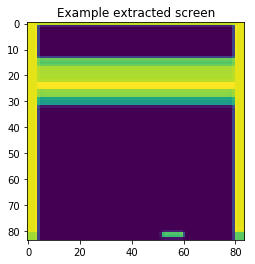

In [7]:
# Тут блок с кодом, генерирующим 1 кадр игры
# Обратите внимание, что выходным тензора является torch.ByteTensor со значениями 0-255
# Это сделанно намеренно для экономии места(4х экономия по сравнению с FloatTensor)
# Подумайте, где и как необходимо совершать преобразование ByteTensort -> FloatTensor, чтобы его можно было подавать в сеть. 

resize = T.Compose([T.ToPILImage(),
                    T.Resize( (STATE_W, STATE_H), interpolation=Image.CUBIC),
                    T.ToTensor()])

def get_screen():
    screen = env.render(mode='rgb_array')
    screen = np.dot(screen[...,:3], [0.299, 0.587, 0.114])
    screen = screen[30:195,:]
    screen = np.ascontiguousarray(screen, dtype=np.uint8).reshape(screen.shape[0],screen.shape[1],1)
    return resize(screen).mul(255).type(torch.ByteTensor).to(device).detach()

env.reset()
plt.figure()
plt.imshow(get_screen().cpu().reshape(-1,84).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [8]:
# Далее стандартный метод для выбора нового действия из лекции

policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)

memory = ReplayMemory()
state_holder = StateHolder()

def select_action(state, eps_threshold):
    global steps_done
    sample = random.random()
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(ACTIONS_NUM)]], device=device, dtype=torch.long)

train_rewards = []

mean_size = 100
mean_step = 1

def plot_rewards(rewards = train_rewards, name = "Train"):
    plt.figure(2)
    plt.clf()
    plt.title(name)
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(rewards)
    # Строим график среднего вознаграждения по 100 последним эпизодам
    if len(rewards) > mean_size:
        means = np.array([rewards[i:i+mean_size:] for i in range(0, len(rewards) - mean_size, mean_step)]).mean(1)
        means = np.concatenate((np.zeros(mean_size - 1), means))
        plt.plot(means)

In [9]:
# Еще немного методов из лекции

BATCH_SIZE = 32
GAMMA = 0.99

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    # выбираем новый батч
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Для всех состояний считаем маску не финальнсти и конкантенируем их
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)

    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Считаем Q(s_t, a) - модель дает Q(s_t), затем мы выбираем
    # колонки, которые соответствуют нашим действиям на щаге
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Подсчитываем ценность состяония V(s_{t+1}) для всех последующмх состояний.
    next_state_values = torch.zeros(BATCH_SIZE, device=device).detach()
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach() # берем значение максимума
    
    # Считаем ожидаемое значение функции оценки ценности действия  Q-values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Считаем ошибку Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Оптимизация модели
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    
    del non_final_mask
    del non_final_next_states
    del state_batch
    del action_batch
    del reward_batch
    del state_action_values
    del next_state_values
    del expected_state_action_values
    del loss

  0%|          | 0/100000 [00:00<?, ?it/s]

1 0


  0%|          | 1/100000 [00:00<15:13:02,  1.83it/s]

Episode score : 1.0
Mean score : 1.0
0.9997885248493035 236


  0%|          | 2/100000 [00:01<15:28:01,  1.80it/s]

Episode score : 1.0
Mean score : 1.0
0.9995708023717722 478


  0%|          | 3/100000 [00:02<18:23:26,  1.51it/s]

Episode score : 2.0
Mean score : 1.3333333333333333
0.9993153605383559 762


  0%|          | 4/100000 [00:02<19:00:50,  1.46it/s]

Episode score : 1.0
Mean score : 1.25
0.9991139364579346 986


  0%|          | 5/100000 [00:03<23:14:59,  1.19it/s]

Episode score : 5.0
Mean score : 2.0
0.9986977430615608 1449


  0%|          | 6/100000 [00:04<21:14:15,  1.31it/s]

Episode score : 1.0
Mean score : 1.8333333333333333
0.9985000513049778 1669


  0%|          | 7/100000 [00:05<21:20:46,  1.30it/s]

Episode score : 3.0
Mean score : 2.0
0.9982143737138072 1987


  0%|          | 8/100000 [00:06<20:35:18,  1.35it/s]

Episode score : 2.0
Mean score : 2.0
0.9979611129718627 2269


  0%|          | 9/100000 [00:06<19:17:25,  1.44it/s]

Episode score : 0.0
Mean score : 1.7777777777777777
0.9978048813307526 2443


  0%|          | 10/100000 [00:07<19:46:07,  1.40it/s]

Episode score : 2.0
Mean score : 1.8
0.9975625067348362 2713


  0%|          | 11/100000 [00:07<18:31:25,  1.50it/s]

Episode score : 0.0
Mean score : 1.6363636363636365
0.9974090366682492 2884


  0%|          | 12/100000 [00:09<22:26:39,  1.24it/s]

Episode score : 4.0
Mean score : 1.8333333333333333
0.9970375862226162 3298


  0%|          | 13/100000 [00:09<19:50:02,  1.40it/s]

Episode score : 0.0
Mean score : 1.6923076923076923
0.9968653715392002 3490


  0%|          | 14/100000 [00:10<19:24:58,  1.43it/s]

Episode score : 0.0
Mean score : 1.5714285714285714
0.9967021568945632 3672


  0%|          | 15/100000 [00:10<18:50:29,  1.47it/s]

Episode score : 0.0
Mean score : 1.4666666666666666
0.996549730484503 3842


  0%|          | 16/100000 [00:11<17:24:03,  1.60it/s]

Episode score : 0.0
Mean score : 1.375
0.996391055225382 4019


  0%|          | 17/100000 [00:11<16:09:12,  1.72it/s]

Episode score : 0.0
Mean score : 1.2941176470588236
0.9962368892225396 4191


  0%|          | 18/100000 [00:12<17:08:11,  1.62it/s]

Episode score : 1.0
Mean score : 1.2777777777777777
0.996009273961039 4445


  0%|          | 19/100000 [00:13<17:32:11,  1.58it/s]

Episode score : 2.0
Mean score : 1.3157894736842106
0.9957575307266369 4726


  0%|          | 20/100000 [00:13<18:57:15,  1.47it/s]

Episode score : 3.0
Mean score : 1.4
0.9954548158429486 5064


  0%|          | 21/100000 [00:14<21:27:41,  1.29it/s]

Episode score : 4.0
Mean score : 1.5238095238095237
0.9950707481153698 5493


  0%|          | 22/100000 [00:15<20:33:40,  1.35it/s]

Episode score : 2.0
Mean score : 1.5454545454545454
0.9948201633893964 5773


  0%|          | 23/100000 [00:16<19:41:15,  1.41it/s]

Episode score : 2.0
Mean score : 1.565217391304348
0.9945803837175192 6041


  0%|          | 24/100000 [00:17<20:42:03,  1.34it/s]

Episode score : 1.0
Mean score : 1.5416666666666667
0.9943594496492216 6288


  0%|          | 25/100000 [00:17<21:42:44,  1.28it/s]

Episode score : 3.0
Mean score : 1.6
0.9940268098087984 6660


  0%|          | 26/100000 [00:18<18:59:43,  1.46it/s]

Episode score : 0.0
Mean score : 1.5384615384615385
0.9938721565485942 6833


  0%|          | 27/100000 [00:19<20:34:04,  1.35it/s]

Episode score : 3.0
Mean score : 1.5925925925925926
0.9935745466752576 7166


  0%|          | 28/100000 [00:19<19:43:43,  1.41it/s]

Episode score : 1.0
Mean score : 1.5714285714285714
0.9933717282739218 7393


  0%|          | 29/100000 [00:20<19:58:08,  1.39it/s]

Episode score : 2.0
Mean score : 1.5862068965517242
0.9930957190555055 7702


  0%|          | 30/100000 [00:21<20:32:28,  1.35it/s]

Episode score : 3.0
Mean score : 1.6333333333333333
0.9927947965064813 8039


  0%|          | 31/100000 [00:22<19:04:03,  1.46it/s]

Episode score : 1.0
Mean score : 1.6129032258064515
0.9925850143796676 8274


  0%|          | 32/100000 [00:22<17:36:37,  1.58it/s]

Episode score : 1.0
Mean score : 1.59375
0.9923940216235442 8488


  0%|          | 33/100000 [00:23<16:56:29,  1.64it/s]

Episode score : 1.0
Mean score : 1.5757575757575757
0.9922146684507955 8689


  0%|          | 34/100000 [00:23<18:25:48,  1.51it/s]

Episode score : 2.0
Mean score : 1.588235294117647
0.9919755869580018 8957


  0%|          | 35/100000 [00:24<16:58:23,  1.64it/s]

Episode score : 0.0
Mean score : 1.542857142857143
0.9918016686761285 9152


  0%|          | 36/100000 [00:24<16:25:13,  1.69it/s]

Episode score : 1.0
Mean score : 1.5277777777777777
0.9916063854949773 9371


  0%|          | 37/100000 [00:25<15:22:01,  1.81it/s]

Episode score : 0.0
Mean score : 1.4864864864864864
0.9914414535703342 9556


  0%|          | 38/100000 [00:25<15:36:42,  1.78it/s]

Episode score : 1.0
Mean score : 1.4736842105263157
0.9912284245209163 9795
Target net updated!
Episode score : 1.0
Mean score : 1.4615384615384615


  0%|          | 39/100000 [00:26<16:15:28,  1.71it/s]

0.9910118823247 10038


  0%|          | 40/100000 [00:27<20:48:35,  1.33it/s]

Episode score : 4.0
Mean score : 1.525
0.9906439703963428 10451


  0%|          | 41/100000 [00:28<22:04:05,  1.26it/s]

Episode score : 3.0
Mean score : 1.5609756097560976
0.9903456546369396 10786


  0%|          | 42/100000 [00:29<19:41:33,  1.41it/s]

Episode score : 1.0
Mean score : 1.5476190476190477
0.9901569213645902 10998


  0%|          | 43/100000 [00:30<21:02:25,  1.32it/s]

Episode score : 3.0
Mean score : 1.5813953488372092
0.9898338530425828 11361


  0%|          | 44/100000 [00:30<20:10:02,  1.38it/s]

Episode score : 2.0
Mean score : 1.5909090909090908
0.9895945199278615 11630


  0%|          | 45/100000 [00:31<17:46:50,  1.56it/s]

Episode score : 0.0
Mean score : 1.5555555555555556
0.9894450806017685 11798


  0%|          | 46/100000 [00:31<19:42:00,  1.41it/s]

Episode score : 2.0
Mean score : 1.565217391304348
0.9891738412182937 12103


  0%|          | 47/100000 [00:32<19:49:37,  1.40it/s]

Episode score : 1.0
Mean score : 1.553191489361702
0.9889515755423561 12353


  0%|          | 48/100000 [00:34<24:42:55,  1.12it/s]

Episode score : 5.0
Mean score : 1.625
0.98854364039746 12812


  0%|          | 49/100000 [00:34<22:56:26,  1.21it/s]

Episode score : 2.0
Mean score : 1.6326530612244898
0.9882895532525 13098


  0%|          | 50/100000 [00:35<19:31:18,  1.42it/s]

Episode score : 0.0
Mean score : 1.6
0.9881447738551613 13261


  0%|          | 51/100000 [00:35<21:03:13,  1.32it/s]

Episode score : 3.0
Mean score : 1.6274509803921569
0.9878721552586834 13568


  0%|          | 52/100000 [00:36<21:02:41,  1.32it/s]

Episode score : 1.0
Mean score : 1.6153846153846154
0.9876750695175427 13790


  0%|          | 53/100000 [00:37<22:58:55,  1.21it/s]

Episode score : 2.0
Mean score : 1.6226415094339623
0.987400820294749 14099


  0%|          | 54/100000 [00:38<22:39:38,  1.23it/s]

Episode score : 1.0
Mean score : 1.6111111111111112
0.9871931927961647 14333


  0%|          | 55/100000 [00:38<19:44:46,  1.41it/s]

Episode score : 0.0
Mean score : 1.5818181818181818
0.987031738327878 14515


  0%|          | 56/100000 [00:39<18:29:04,  1.50it/s]

Episode score : 1.0
Mean score : 1.5714285714285714
0.986825970834538 14747


  0%|          | 57/100000 [00:40<16:44:28,  1.66it/s]

Episode score : 0.0
Mean score : 1.543859649122807
0.9866636965304271 14930


  0%|          | 58/100000 [00:40<16:06:02,  1.72it/s]

Episode score : 1.0
Mean score : 1.5344827586206897
0.9864721978545781 15146


  0%|          | 59/100000 [00:41<16:21:53,  1.70it/s]

Episode score : 1.0
Mean score : 1.5254237288135593
0.9862461762631028 15401


  0%|          | 60/100000 [00:41<15:08:45,  1.83it/s]

Episode score : 0.0
Mean score : 1.5
0.9860937550293875 15573


  0%|          | 61/100000 [00:42<19:21:01,  1.43it/s]

Episode score : 3.0
Mean score : 1.5245901639344261
0.9857633036917672 15946


  0%|          | 62/100000 [00:43<20:59:54,  1.32it/s]

Episode score : 3.0
Mean score : 1.5483870967741935
0.9854241213040268 16329


  0%|          | 63/100000 [00:44<21:49:58,  1.27it/s]

Episode score : 2.0
Mean score : 1.5555555555555556
0.9851337498157663 16657


  0%|          | 64/100000 [00:45<21:55:57,  1.27it/s]

Episode score : 3.0
Mean score : 1.578125
0.9848363948342627 16993


  0%|          | 65/100000 [00:46<22:25:30,  1.24it/s]

Episode score : 1.0
Mean score : 1.5692307692307692
0.9846090210995667 17250


  0%|          | 66/100000 [00:46<22:13:58,  1.25it/s]

Episode score : 3.0
Mean score : 1.5909090909090908
0.9843144953368016 17583


  0%|          | 67/100000 [00:47<20:39:55,  1.34it/s]

Episode score : 1.0
Mean score : 1.5820895522388059
0.9841014012222976 17824


  0%|          | 68/100000 [00:48<23:58:51,  1.16it/s]

Episode score : 3.0
Mean score : 1.6029411764705883
0.9837778793175703 18190


  0%|          | 69/100000 [00:49<21:39:44,  1.28it/s]

Episode score : 0.0
Mean score : 1.5797101449275361
0.983626766220745 18361


  0%|          | 70/100000 [00:49<19:19:11,  1.44it/s]

Episode score : 0.0
Mean score : 1.5571428571428572
0.983459776542951 18550


  0%|          | 71/100000 [00:50<17:02:40,  1.63it/s]

Episode score : 0.0
Mean score : 1.5352112676056338
0.9833149010197155 18714


  0%|          | 72/100000 [00:50<15:37:44,  1.78it/s]

Episode score : 0.0
Mean score : 1.5138888888888888
0.9831603344370075 18889


  0%|          | 73/100000 [00:51<17:25:15,  1.59it/s]

Episode score : 3.0
Mean score : 1.5342465753424657
0.9828636424116882 19225


  0%|          | 74/100000 [00:51<15:43:22,  1.77it/s]

Episode score : 0.0
Mean score : 1.5135135135135136
0.9827153337780371 19393


  0%|          | 75/100000 [00:52<15:13:58,  1.82it/s]

Episode score : 0.0
Mean score : 1.4933333333333334
0.9825661674915348 19562


  0%|          | 76/100000 [00:53<22:39:14,  1.23it/s]

Episode score : 4.0
Mean score : 1.5263157894736843
0.982212329407648 19963
Target net updated!


  0%|          | 77/100000 [00:54<22:17:22,  1.25it/s]

Episode score : 1.0
Mean score : 1.5194805194805194
0.9820103259144964 20192


  0%|          | 78/100000 [00:55<20:49:27,  1.33it/s]

Episode score : 1.0
Mean score : 1.5128205128205128
0.9818013142361169 20429


  0%|          | 79/100000 [00:55<22:03:29,  1.26it/s]

Episode score : 3.0
Mean score : 1.5316455696202531
0.9814680563290482 20807


  0%|          | 80/100000 [00:56<19:10:36,  1.45it/s]

Episode score : 0.0
Mean score : 1.5125
0.9813120502900197 20984


  0%|          | 81/100000 [00:57<19:00:16,  1.46it/s]

Episode score : 2.0
Mean score : 1.5185185185185186
0.9810661985259047 21263


  0%|          | 82/100000 [00:57<19:20:32,  1.43it/s]

Episode score : 2.0
Mean score : 1.524390243902439
0.9807922295425482 21574


  0%|          | 83/100000 [00:58<17:58:17,  1.54it/s]

Episode score : 0.0
Mean score : 1.5060240963855422
0.9805993571645746 21793


  0%|          | 84/100000 [00:59<19:36:12,  1.42it/s]

Episode score : 2.0
Mean score : 1.5119047619047619
0.9803537042141058 22072


  0%|          | 85/100000 [00:59<19:48:28,  1.40it/s]

Episode score : 1.0
Mean score : 1.5058823529411764
0.9801442049639025 22310
Episode score : 7.0
Mean score : 1.569767441860465


  0%|          | 86/100000 [01:01<27:59:16,  1.01s/it]

0.9797077616851212 22806


  0%|          | 87/100000 [01:02<24:49:48,  1.12it/s]

Episode score : 0.0
Mean score : 1.5517241379310345
0.9795485489894398 22987


  0%|          | 88/100000 [01:02<22:20:00,  1.24it/s]

Episode score : 0.0
Mean score : 1.5340909090909092
0.9793928826731442 23164


  0%|          | 89/100000 [01:03<19:34:44,  1.42it/s]

Episode score : 0.0
Mean score : 1.5168539325842696
0.979226693123726 23353


  0%|          | 90/100000 [01:03<18:38:21,  1.49it/s]

Episode score : 1.0
Mean score : 1.511111111111111
0.9790174620702455 23591


  0%|          | 91/100000 [01:04<17:46:08,  1.56it/s]

Episode score : 1.0
Mean score : 1.5054945054945055
0.9788091596165507 23828


  0%|          | 92/100000 [01:04<16:18:45,  1.70it/s]

Episode score : 0.0
Mean score : 1.4891304347826086
0.978650109553125 24009


  0%|          | 93/100000 [01:05<15:05:42,  1.84it/s]

Episode score : 0.0
Mean score : 1.4731182795698925
0.9784981162319738 24182


  0%|          | 94/100000 [01:06<16:05:56,  1.72it/s]

Episode score : 2.0
Mean score : 1.4787234042553192
0.9782565624651751 24457


  0%|          | 95/100000 [01:06<16:40:49,  1.66it/s]

Episode score : 2.0
Mean score : 1.4842105263157894
0.9780177091657061 24729


  0%|          | 96/100000 [01:07<15:29:12,  1.79it/s]

Episode score : 0.0
Mean score : 1.46875
0.9778623137840806 24906


  0%|          | 97/100000 [01:07<17:22:33,  1.60it/s]

Episode score : 1.0
Mean score : 1.4639175257731958
0.9776577956922519 25139


  0%|          | 98/100000 [01:08<17:48:23,  1.56it/s]

Episode score : 1.0
Mean score : 1.4591836734693877
0.9774533252475874 25372


  0%|          | 99/100000 [01:09<18:12:51,  1.52it/s]

Episode score : 2.0
Mean score : 1.4646464646464648
0.9772322348681829 25624


  0%|          | 100/100000 [01:10<18:32:15,  1.50it/s]

Episode score : 3.0
Mean score : 1.48
0.9769717355804861 25921


  0%|          | 101/100000 [01:10<16:59:59,  1.63it/s]

Episode score : 0.0
Mean score : 1.47
0.9768016195655704 26115


  0%|          | 102/100000 [01:10<15:35:29,  1.78it/s]

Episode score : 0.0
Mean score : 1.46
0.9766464394127561 26292


  0%|          | 103/100000 [01:11<15:16:43,  1.82it/s]

Episode score : 1.0
Mean score : 1.45
0.9764562277741127 26509


  0%|          | 104/100000 [01:11<14:20:13,  1.94it/s]

Episode score : 0.0
Mean score : 1.44
0.9763028613542054 26684


  0%|          | 105/100000 [01:12<17:40:48,  1.57it/s]

Episode score : 4.0
Mean score : 1.43
0.9759471546058515 27090


  0%|          | 106/100000 [01:13<17:50:34,  1.56it/s]

Episode score : 2.0
Mean score : 1.44
0.9757001723343898 27372


  0%|          | 107/100000 [01:14<18:05:25,  1.53it/s]

Episode score : 2.0
Mean score : 1.43
0.9754523842492869 27655


  0%|          | 108/100000 [01:14<18:33:10,  1.50it/s]

Episode score : 3.0
Mean score : 1.44
0.9751924134987323 27952


  0%|          | 109/100000 [01:15<20:07:24,  1.38it/s]

Episode score : 3.0
Mean score : 1.47
0.974926395441822 28256


  0%|          | 110/100000 [01:16<18:30:35,  1.50it/s]

Episode score : 0.0
Mean score : 1.45
0.9747767958193337 28427


  0%|          | 111/100000 [01:17<19:45:53,  1.40it/s]

Episode score : 1.0
Mean score : 1.46
0.9745633763193917 28671


  0%|          | 112/100000 [01:17<18:12:19,  1.52it/s]

Episode score : 0.0
Mean score : 1.42
0.9744120899419374 28844


  0%|          | 113/100000 [01:18<19:04:26,  1.45it/s]

Episode score : 1.0
Mean score : 1.43
0.974202256221405 29084


  0%|          | 114/100000 [01:18<18:06:02,  1.53it/s]

Episode score : 1.0
Mean score : 1.44
0.9740003388225753 29315


  0%|          | 115/100000 [01:19<16:54:53,  1.64it/s]

Episode score : 1.0
Mean score : 1.45
0.9738211871167939 29520


  0%|          | 116/100000 [01:19<16:10:19,  1.72it/s]

Episode score : 1.0
Mean score : 1.46
0.9736350830247275 29733


  0%|          | 117/100000 [01:20<14:56:48,  1.86it/s]

Episode score : 0.0
Mean score : 1.46
0.9734857041977839 29904
Target net updated!


  0%|          | 118/100000 [01:21<16:20:12,  1.70it/s]

Episode score : 2.0
Mean score : 1.47
0.9732263174644737 30201


  0%|          | 119/100000 [01:21<17:05:07,  1.62it/s]

Episode score : 2.0
Mean score : 1.47
0.9729818483228607 30481


  0%|          | 120/100000 [01:22<16:53:56,  1.64it/s]

Episode score : 1.0
Mean score : 1.45
0.9727662484340074 30728


  0%|          | 121/100000 [01:23<18:27:34,  1.50it/s]

Episode score : 3.0
Mean score : 1.44
0.9724756656579963 31061


  0%|          | 122/100000 [01:23<17:51:20,  1.55it/s]

Episode score : 0.0
Mean score : 1.42
0.9723256127484232 31233


  0%|          | 123/100000 [01:24<17:49:37,  1.56it/s]

Episode score : 0.0
Mean score : 1.4
0.9721799465345616 31400


  0%|          | 124/100000 [01:25<19:33:21,  1.42it/s]

Episode score : 1.0
Mean score : 1.4
0.9719907040197191 31617


  0%|          | 125/100000 [01:25<19:28:08,  1.42it/s]

Episode score : 2.0
Mean score : 1.39
0.9717500677947363 31893


  0%|          | 126/100000 [01:26<19:07:24,  1.45it/s]

Episode score : 2.0
Mean score : 1.41
0.971509497976187 32169


  0%|          | 127/100000 [01:27<18:33:16,  1.50it/s]

Episode score : 1.0
Mean score : 1.39
0.9712977468969769 32412


  0%|          | 128/100000 [01:28<20:49:52,  1.33it/s]

Episode score : 3.0
Mean score : 1.41
0.9710137501254774 32738


  0%|          | 129/100000 [01:28<19:26:49,  1.43it/s]

Episode score : 0.0
Mean score : 1.39
0.9708552400478092 32920


  0%|          | 130/100000 [01:29<17:52:27,  1.55it/s]

Episode score : 1.0
Mean score : 1.37
0.9706767330211947 33125


  0%|          | 131/100000 [01:30<18:54:44,  1.47it/s]

Episode score : 3.0
Mean score : 1.39
0.9703999018385849 33443


  0%|          | 132/100000 [01:30<17:03:33,  1.63it/s]

Episode score : 0.0
Mean score : 1.38
0.9702423737130775 33624


  0%|          | 133/100000 [01:31<17:02:22,  1.63it/s]

Episode score : 2.0
Mean score : 1.39
0.9700257103377327 33873


  0%|          | 134/100000 [01:31<17:53:08,  1.55it/s]

Episode score : 2.0
Mean score : 1.39
0.9697673510700128 34170


  0%|          | 135/100000 [01:32<16:11:57,  1.71it/s]

Episode score : 0.0
Mean score : 1.39
0.9696195031877569 34340


  0%|          | 136/100000 [01:32<15:58:33,  1.74it/s]

Episode score : 0.0
Mean score : 1.38
0.9694682025577388 34514


  0%|          | 137/100000 [01:33<16:09:46,  1.72it/s]

Episode score : 1.0
Mean score : 1.39
0.9692517319270139 34763


  0%|          | 138/100000 [01:34<18:26:49,  1.50it/s]

Episode score : 2.0
Mean score : 1.4
0.9690014234743662 35051


  0%|          | 139/100000 [01:35<19:29:43,  1.42it/s]

Episode score : 3.0
Mean score : 1.42
0.9687051445073963 35392


  0%|          | 140/100000 [01:35<17:14:34,  1.61it/s]

Episode score : 0.0
Mean score : 1.38
0.9685574771849081 35562


  0%|          | 141/100000 [01:36<18:43:26,  1.48it/s]

Episode score : 2.0
Mean score : 1.37
0.9683351549292116 35818


  0%|          | 142/100000 [01:36<16:46:30,  1.65it/s]

Episode score : 0.0
Mean score : 1.36
0.9681814732080227 35995


  0%|          | 143/100000 [01:37<17:23:58,  1.59it/s]

Episode score : 2.0
Mean score : 1.35
0.9679314729455046 36283


  0%|          | 144/100000 [01:38<18:45:22,  1.48it/s]

Episode score : 3.0
Mean score : 1.36
0.9676364264054572 36623


  0%|          | 145/100000 [01:38<19:02:47,  1.46it/s]

Episode score : 3.0
Mean score : 1.39
0.9673709702758363 36929


  0%|          | 146/100000 [01:39<17:56:23,  1.55it/s]

Episode score : 1.0
Mean score : 1.38
0.9671732322376064 37157


  0%|          | 147/100000 [01:39<16:28:20,  1.68it/s]

Episode score : 0.0
Mean score : 1.37
0.9670145540556034 37340


  0%|          | 148/100000 [01:40<17:16:10,  1.61it/s]

Episode score : 1.0
Mean score : 1.33
0.9667986943072976 37589


  0%|          | 149/100000 [01:41<19:05:54,  1.45it/s]

Episode score : 3.0
Mean score : 1.34
0.9664901688929064 37945


  0%|          | 150/100000 [01:42<18:20:22,  1.51it/s]

Episode score : 1.0
Mean score : 1.35
0.9662779048049401 38190


  0%|          | 151/100000 [01:42<16:33:45,  1.67it/s]

Episode score : 0.0
Mean score : 1.32
0.9661211226933796 38371


  0%|          | 152/100000 [01:42<15:12:05,  1.82it/s]

Episode score : 0.0
Mean score : 1.31
0.9659704307286121 38545


  0%|          | 153/100000 [01:43<16:33:39,  1.67it/s]

Episode score : 2.0
Mean score : 1.31
0.9657063500215949 38850


  0%|          | 154/100000 [01:44<19:36:37,  1.41it/s]

Episode score : 4.0
Mean score : 1.34
0.9653376376577951 39276


  0%|          | 155/100000 [01:45<19:53:36,  1.39it/s]

Episode score : 2.0
Mean score : 1.36
0.9650642341643223 39592


  0%|          | 156/100000 [01:46<19:33:01,  1.42it/s]

Episode score : 2.0
Mean score : 1.37
0.964815996352947 39879
Target net updated!


  0%|          | 157/100000 [01:46<19:33:31,  1.42it/s]

Episode score : 2.0
Mean score : 1.39
0.9645635069472592 40171


  0%|          | 158/100000 [01:47<19:39:07,  1.41it/s]

Episode score : 2.0
Mean score : 1.4
0.9643015838880016 40474


  0%|          | 159/100000 [01:48<20:14:48,  1.37it/s]

Episode score : 3.0
Mean score : 1.42
0.96401295536263 40808


  0%|          | 160/100000 [01:48<20:14:09,  1.37it/s]

Episode score : 2.0
Mean score : 1.44
0.9637434253694221 41120


  0%|          | 161/100000 [01:49<20:20:27,  1.36it/s]

Episode score : 2.0
Mean score : 1.43
0.9635180177523742 41381


  0%|          | 162/100000 [01:50<21:35:07,  1.28it/s]

Episode score : 2.0
Mean score : 1.42
0.9632641807710198 41675


  0%|          | 163/100000 [01:51<20:11:47,  1.37it/s]

Episode score : 0.0
Mean score : 1.4
0.9631062178799841 41858


  0%|          | 164/100000 [01:52<21:23:11,  1.30it/s]

Episode score : 2.0
Mean score : 1.39
0.9628688963032794 42133


  0%|          | 165/100000 [01:52<20:45:20,  1.34it/s]

Episode score : 2.0
Mean score : 1.4
0.9626161127512615 42426


  0%|          | 166/100000 [01:53<19:06:32,  1.45it/s]

Episode score : 1.0
Mean score : 1.38
0.9624185962779407 42655


  0%|          | 167/100000 [01:53<16:58:52,  1.63it/s]

Episode score : 0.0
Mean score : 1.37
0.962274584397689 42822


  0%|          | 168/100000 [01:54<15:40:07,  1.77it/s]

Episode score : 0.0
Mean score : 1.34
0.9621202510603276 43001


  0%|          | 169/100000 [01:54<14:55:58,  1.86it/s]

Episode score : 0.0
Mean score : 1.34
0.9619521540013667 43196


  0%|          | 170/100000 [01:55<15:45:46,  1.76it/s]

Episode score : 2.0
Mean score : 1.36
0.9617306607608889 43453


  0%|          | 171/100000 [01:55<15:30:26,  1.79it/s]

Episode score : 0.0
Mean score : 1.36
0.9615807326700387 43627


  0%|          | 172/100000 [01:56<16:35:09,  1.67it/s]

Episode score : 0.0
Mean score : 1.36
0.9614359992648965 43795


  0%|          | 173/100000 [01:57<18:14:21,  1.52it/s]

Episode score : 3.0
Mean score : 1.36
0.9611672731565788 44107


  0%|          | 174/100000 [01:58<18:17:35,  1.52it/s]

Episode score : 2.0
Mean score : 1.38
0.9609235973000354 44390


  0%|          | 175/100000 [01:58<20:00:40,  1.39it/s]

Episode score : 3.0
Mean score : 1.41
0.9606283511437719 44733


  0%|          | 176/100000 [01:59<17:44:02,  1.56it/s]

Episode score : 0.0
Mean score : 1.37
0.9604768938826006 44909


  0%|          | 177/100000 [01:59<15:58:01,  1.74it/s]

Episode score : 0.0
Mean score : 1.36
0.9603357872430646 45073


  0%|          | 178/100000 [02:00<16:44:33,  1.66it/s]

Episode score : 2.0
Mean score : 1.37
0.9600957870400089 45352


  0%|          | 179/100000 [02:01<18:40:40,  1.48it/s]

Episode score : 3.0
Mean score : 1.37
0.9597836289294381 45715


  0%|          | 180/100000 [02:01<17:37:20,  1.57it/s]

Episode score : 1.0
Mean score : 1.38
0.9595927781490363 45937


  0%|          | 181/100000 [02:02<19:26:46,  1.43it/s]

Episode score : 3.0
Mean score : 1.39
0.9592773654812203 46304


  0%|          | 182/100000 [02:03<20:58:16,  1.32it/s]

Episode score : 3.0
Mean score : 1.4
0.958945748424354 46690


  0%|          | 183/100000 [02:04<22:14:00,  1.25it/s]

Episode score : 4.0
Mean score : 1.44
0.9586030974341512 47089


  0%|          | 184/100000 [02:04<19:16:51,  1.44it/s]

Episode score : 0.0
Mean score : 1.42
0.9584494212341407 47268


  0%|          | 185/100000 [02:05<17:03:17,  1.63it/s]

Episode score : 0.0
Mean score : 1.41
0.9583060721507762 47435


  0%|          | 186/100000 [02:06<19:46:11,  1.40it/s]

Episode score : 4.0
Mean score : 1.38
0.95795080698187 47849


  0%|          | 187/100000 [02:06<18:47:05,  1.48it/s]

Episode score : 1.0
Mean score : 1.39
0.9577389193017511 48096


  0%|          | 188/100000 [02:07<16:44:40,  1.66it/s]

Episode score : 0.0
Mean score : 1.39
0.9575931160790949 48266


  0%|          | 189/100000 [02:08<19:24:43,  1.43it/s]

Episode score : 2.0
Mean score : 1.41
0.9573393060824682 48562


  0%|          | 190/100000 [02:09<20:36:42,  1.35it/s]

Episode score : 3.0
Mean score : 1.43
0.957062430204465 48885


  0%|          | 191/100000 [02:09<18:36:16,  1.49it/s]

Episode score : 0.0
Mean score : 1.42
0.9569133143150681 49059


  0%|          | 192/100000 [02:10<16:58:29,  1.63it/s]

Episode score : 0.0
Mean score : 1.42
0.9567642243695786 49233


  0%|          | 193/100000 [02:11<20:35:24,  1.35it/s]

Episode score : 3.0
Mean score : 1.45
0.9564695481636087 49577
Target net updated!
Episode score : 5.0
Mean score : 1.48


  0%|          | 194/100000 [02:12<24:09:44,  1.15it/s]

0.9560705263334718 50043


  0%|          | 195/100000 [02:13<27:10:52,  1.02it/s]

Episode score : 3.0
Mean score : 1.49
0.9557529830761186 50414


  0%|          | 196/100000 [02:14<26:52:32,  1.03it/s]

Episode score : 2.0
Mean score : 1.51
0.955522816482466 50683


  0%|          | 197/100000 [02:15<30:10:58,  1.09s/it]

Episode score : 4.0
Mean score : 1.54
0.9551935035949187 51068


  0%|          | 198/100000 [02:16<25:40:16,  1.08it/s]

Episode score : 0.0
Mean score : 1.53
0.9550489881047141 51237


  0%|          | 199/100000 [02:16<23:14:54,  1.19it/s]

Episode score : 0.0
Mean score : 1.51
0.9548985127250295 51413


  0%|          | 200/100000 [02:17<22:26:53,  1.23it/s]

Episode score : 0.0
Mean score : 1.48
0.954745499586336 51592


  0%|          | 201/100000 [02:18<22:32:13,  1.23it/s]

Episode score : 1.0
Mean score : 1.49
0.9545344035193758 51839


  0%|          | 202/100000 [02:19<20:50:48,  1.33it/s]

Episode score : 0.0
Mean score : 1.49
0.9543746205260931 52026


  0%|          | 203/100000 [02:19<20:44:08,  1.34it/s]

Episode score : 1.0
Mean score : 1.49
0.9541747202541341 52260


  0%|          | 204/100000 [02:20<21:46:02,  1.27it/s]

Episode score : 2.0
Mean score : 1.51
0.9539398545015852 52535


  0%|          | 205/100000 [02:21<21:02:57,  1.32it/s]

Episode score : 0.0
Mean score : 1.47
0.9537895743122375 52711


  0%|          | 206/100000 [02:22<20:42:43,  1.34it/s]

Episode score : 1.0
Mean score : 1.46
0.9535966396708787 52937


  0%|          | 207/100000 [02:23<25:16:36,  1.10it/s]

Episode score : 4.0
Mean score : 1.48
0.9532262591076573 53371


  0%|          | 208/100000 [02:24<23:20:58,  1.19it/s]

Episode score : 0.0
Mean score : 1.45
0.9530633084544505 53562


  0%|          | 209/100000 [02:25<24:37:19,  1.13it/s]

Episode score : 2.0
Mean score : 1.44
0.9528449521982796 53818


  0%|          | 210/100000 [02:25<21:51:05,  1.27it/s]

Episode score : 0.0
Mean score : 1.44
0.9526999808793171 53988


  0%|          | 211/100000 [02:26<20:09:32,  1.38it/s]

Episode score : 0.0
Mean score : 1.43
0.9525465086956697 54168


  0%|          | 212/100000 [02:27<21:54:25,  1.27it/s]

Episode score : 2.0
Mean score : 1.45
0.9522950445683869 54463


  0%|          | 213/100000 [02:28<23:18:11,  1.19it/s]

Episode score : 3.0
Mean score : 1.47
0.9520325781165683 54771


  0%|          | 214/100000 [02:29<23:56:21,  1.16it/s]

Episode score : 2.0
Mean score : 1.48
0.9517744513535784 55074


  0%|          | 215/100000 [02:29<22:19:11,  1.24it/s]

Episode score : 1.0
Mean score : 1.48
0.9515973006920043 55282


  0%|          | 216/100000 [02:30<24:08:32,  1.15it/s]

Episode score : 3.0
Mean score : 1.5
0.9513163199471488 55612


  0%|          | 217/100000 [02:31<23:39:04,  1.17it/s]

Episode score : 2.0
Mean score : 1.52
0.9510984108627951 55868


  0%|          | 218/100000 [02:33<28:34:36,  1.03s/it]

Episode score : 4.0
Mean score : 1.54
0.9507835627012777 56238


  0%|          | 219/100000 [02:34<28:18:00,  1.02s/it]

Episode score : 2.0
Mean score : 1.54
0.9505453766513245 56518


  0%|          | 220/100000 [02:34<27:22:32,  1.01it/s]

Episode score : 1.0
Mean score : 1.54
0.9503642297789245 56731


  0%|          | 221/100000 [02:36<29:45:36,  1.07s/it]

Episode score : 2.0
Mean score : 1.53
0.9501176599066482 57021


  0%|          | 222/100000 [02:37<28:51:58,  1.04s/it]

Episode score : 1.0
Mean score : 1.54
0.9499323544558166 57239


  0%|          | 223/100000 [02:37<26:19:38,  1.05it/s]

Episode score : 0.0
Mean score : 1.54
0.9497878782363857 57409


  0%|          | 224/100000 [02:39<29:11:54,  1.05s/it]

Episode score : 2.0
Mean score : 1.55
0.9495448736545217 57695


  0%|          | 225/100000 [02:39<26:29:50,  1.05it/s]

Episode score : 0.0
Mean score : 1.53
0.9493919693390651 57875


  0%|          | 226/100000 [02:40<24:15:43,  1.14it/s]

Episode score : 0.0
Mean score : 1.51
0.9492509819744298 58041


  0%|          | 227/100000 [02:41<23:30:36,  1.18it/s]

Episode score : 0.0
Mean score : 1.5
0.949082846925918 58239


  0%|          | 228/100000 [02:42<22:14:08,  1.25it/s]

Episode score : 0.0
Mean score : 1.47
0.9489427598136798 58404


  0%|          | 229/100000 [02:42<22:30:52,  1.23it/s]

Episode score : 1.0
Mean score : 1.48
0.9487636517879203 58615


  0%|          | 230/100000 [02:43<20:58:30,  1.32it/s]

Episode score : 0.0
Mean score : 1.47
0.9486151311447927 58790


  0%|          | 231/100000 [02:44<24:46:04,  1.12it/s]

Episode score : 2.0
Mean score : 1.46
0.9483639782384378 59086


  0%|          | 232/100000 [02:45<25:52:17,  1.07it/s]

Episode score : 1.0
Mean score : 1.47
0.9481476730040765 59341


  0%|          | 233/100000 [02:46<26:12:33,  1.06it/s]

Episode score : 2.0
Mean score : 1.47
0.9478856358599419 59650


  0%|          | 234/100000 [02:47<24:06:38,  1.15it/s]

Episode score : 0.0
Mean score : 1.45
0.9477491372610006 59811
Target net updated!
Episode score : 1.0
Mean score : 1.46


  0%|          | 235/100000 [02:48<24:42:42,  1.12it/s]

0.9475397690821317 60058


  0%|          | 236/100000 [02:49<22:14:03,  1.25it/s]

Episode score : 0.0
Mean score : 1.46
0.9473855308802608 60240


  0%|          | 237/100000 [02:50<25:09:04,  1.10it/s]

Episode score : 3.0
Mean score : 1.48
0.9470949274845003 60583


  0%|          | 238/100000 [02:51<25:47:13,  1.07it/s]

Episode score : 1.0
Mean score : 1.47
0.9469060463766976 60806


  0%|          | 239/100000 [02:52<26:44:18,  1.04it/s]

Episode score : 1.0
Mean score : 1.45
0.9467019666121201 61047


  0%|          | 240/100000 [02:53<28:42:52,  1.04s/it]

Episode score : 2.0
Mean score : 1.47
0.9464420690046943 61354


  0%|          | 241/100000 [02:54<29:05:06,  1.05s/it]

Episode score : 2.0
Mean score : 1.47
0.946205944608327 61633


  0%|          | 242/100000 [02:55<27:21:45,  1.01it/s]

Episode score : 0.0
Mean score : 1.47
0.9460578715247931 61808


  0%|          | 243/100000 [02:56<24:56:46,  1.11it/s]

Episode score : 1.0
Mean score : 1.46
0.9458785262672988 62020


  0%|          | 244/100000 [02:56<25:06:33,  1.10it/s]

Episode score : 2.0
Mean score : 1.45
0.9456434047204059 62298


  0%|          | 245/100000 [02:57<24:09:35,  1.15it/s]

Episode score : 1.0
Mean score : 1.43
0.9454616109319236 62513


  0%|          | 246/100000 [02:59<28:28:05,  1.03s/it]

Episode score : 3.0
Mean score : 1.45
0.9451716673275447 62856


  0%|          | 247/100000 [02:59<26:09:01,  1.06it/s]

Episode score : 0.0
Mean score : 1.45
0.9450170150635375 63039


  0%|          | 248/100000 [03:00<25:40:13,  1.08it/s]

Episode score : 2.0
Mean score : 1.46
0.9447872016914757 63311


  0%|          | 249/100000 [03:01<24:31:36,  1.13it/s]

Episode score : 1.0
Mean score : 1.44
0.9445827879237298 63553


  0%|          | 250/100000 [03:02<21:57:39,  1.26it/s]

Episode score : 0.0
Mean score : 1.43
0.9444392210533126 63723


  0%|          | 251/100000 [03:03<22:26:26,  1.23it/s]

Episode score : 2.0
Mean score : 1.45
0.9442180069577085 63985


  0%|          | 252/100000 [03:03<21:23:47,  1.29it/s]

Episode score : 1.0
Mean score : 1.46
0.9440390517101599 64197


  0%|          | 253/100000 [03:04<21:31:07,  1.29it/s]

Episode score : 1.0
Mean score : 1.45
0.9438289121497452 64446


  0%|          | 254/100000 [03:05<21:14:55,  1.30it/s]

Episode score : 1.0
Mean score : 1.42
0.9436323229167493 64679


  0%|          | 255/100000 [03:06<22:05:11,  1.25it/s]

Episode score : 2.0
Mean score : 1.42
0.9434011993256481 64953


  0%|          | 256/100000 [03:07<26:31:07,  1.04it/s]

Episode score : 3.0
Mean score : 1.43
0.9431296678583776 65275


  0%|          | 257/100000 [03:08<25:08:23,  1.10it/s]

Episode score : 0.0
Mean score : 1.41
0.9429686454699443 65466


  0%|          | 258/100000 [03:08<22:42:00,  1.22it/s]

Episode score : 0.0
Mean score : 1.39
0.9428270386328127 65634


  0%|          | 259/100000 [03:10<29:08:39,  1.05s/it]

Episode score : 5.0
Mean score : 1.41
0.9424267908558346 66109


  0%|          | 260/100000 [03:11<27:50:47,  1.01s/it]

Episode score : 2.0
Mean score : 1.41
0.9421917865658087 66388


  0%|          | 261/100000 [03:12<28:07:50,  1.02s/it]

Episode score : 3.0
Mean score : 1.42
0.9419096995695191 66723


  0%|          | 262/100000 [03:13<27:49:18,  1.00s/it]

Episode score : 2.0
Mean score : 1.42
0.9416529562664945 67028


  0%|          | 263/100000 [03:14<29:12:35,  1.05s/it]

Episode score : 3.0
Mean score : 1.45
0.9413357129061128 67405


  0%|          | 264/100000 [03:15<26:38:00,  1.04it/s]

Episode score : 1.0
Mean score : 1.44
0.9411413868019607 67636


  0%|          | 265/100000 [03:16<25:07:44,  1.10it/s]

Episode score : 1.0
Mean score : 1.43
0.9409361733406414 67880


  0%|          | 266/100000 [03:17<27:41:12,  1.00it/s]

Episode score : 4.0
Mean score : 1.46
0.9406057503568876 68273


  0%|          | 267/100000 [03:17<24:12:29,  1.14it/s]

Episode score : 0.0
Mean score : 1.46
0.9404620190629525 68444


  0%|          | 268/100000 [03:18<24:21:17,  1.14it/s]

Episode score : 2.0
Mean score : 1.48
0.9402317640161112 68718


  0%|          | 269/100000 [03:19<24:08:33,  1.15it/s]

Episode score : 2.0
Mean score : 1.5
0.940009972108231 68982


  0%|          | 270/100000 [03:20<25:40:02,  1.08it/s]

Episode score : 2.0
Mean score : 1.5
0.9397538081337299 69287


  0%|          | 271/100000 [03:21<23:56:58,  1.16it/s]

Episode score : 0.0
Mean score : 1.5
0.9396077036825704 69461


  0%|          | 272/100000 [03:22<25:48:30,  1.07it/s]

Episode score : 2.0
Mean score : 1.52
0.9393776826860771 69735


  0%|          | 273/100000 [03:23<23:39:44,  1.17it/s]

Episode score : 0.0
Mean score : 1.49
0.9392198945142849 69923
Target net updated!


  0%|          | 274/100000 [03:24<29:18:10,  1.06s/it]

Episode score : 5.0
Mean score : 1.52
0.9388297479794351 70388


  0%|          | 275/100000 [03:25<28:25:09,  1.03s/it]

Episode score : 1.0
Mean score : 1.5
0.9386460643787161 70607


  0%|          | 276/100000 [03:26<26:30:56,  1.04it/s]

Episode score : 1.0
Mean score : 1.51
0.9384406212607528 70852


  0%|          | 277/100000 [03:27<25:20:03,  1.09it/s]

Episode score : 1.0
Mean score : 1.52
0.9382419343788396 71089


  0%|          | 278/100000 [03:27<23:58:34,  1.16it/s]

Episode score : 0.0
Mean score : 1.5
0.9380986072628784 71260


  0%|          | 279/100000 [03:28<25:07:25,  1.10it/s]

Episode score : 2.0
Mean score : 1.49
0.9378706754418359 71532


  0%|          | 280/100000 [03:29<24:01:59,  1.15it/s]

Episode score : 1.0
Mean score : 1.49
0.9376771496688961 71763


  0%|          | 281/100000 [03:30<23:39:12,  1.17it/s]

Episode score : 0.0
Mean score : 1.46
0.9375288939344243 71940


  0%|          | 282/100000 [03:31<26:41:27,  1.04it/s]

Episode score : 2.0
Mean score : 1.45
0.9372952559670287 72219


  0%|          | 283/100000 [03:32<24:45:22,  1.12it/s]

Episode score : 0.0
Mean score : 1.41
0.9371537650250915 72388


  0%|          | 284/100000 [03:34<31:36:08,  1.14s/it]

Episode score : 8.0
Mean score : 1.49
0.9367863351789977 72827


  0%|          | 285/100000 [03:35<31:34:22,  1.14s/it]

Episode score : 2.0
Mean score : 1.51
0.9365529043565967 73106


  0%|          | 286/100000 [03:36<31:18:58,  1.13s/it]

Episode score : 2.0
Mean score : 1.49
0.9363161933808467 73389


  0%|          | 287/100000 [03:37<27:34:59,  1.00it/s]

Episode score : 0.0
Mean score : 1.48
0.9361832296769937 73548


  0%|          | 288/100000 [03:38<27:58:05,  1.01s/it]

Episode score : 2.0
Mean score : 1.5
0.9359641783677929 73810


  0%|          | 289/100000 [03:38<25:50:42,  1.07it/s]

Episode score : 0.0
Mean score : 1.48
0.9358212407148095 73981


  0%|          | 290/100000 [03:40<29:08:27,  1.05s/it]

Episode score : 3.0
Mean score : 1.48
0.9355396164130488 74318


  0%|          | 291/100000 [03:41<27:52:36,  1.01s/it]

Episode score : 1.0
Mean score : 1.49
0.9353574886293206 74536


  0%|          | 292/100000 [03:41<25:59:02,  1.07it/s]

Episode score : 0.0
Mean score : 1.49
0.9352004561829708 74724


  0%|          | 293/100000 [03:43<27:15:15,  1.02it/s]

Episode score : 3.0
Mean score : 1.49
0.9349248855040931 75054


  0%|          | 294/100000 [03:44<28:21:19,  1.02s/it]

Episode score : 3.0
Mean score : 1.47
0.9346510750490172 75382


  0%|          | 295/100000 [03:44<24:39:38,  1.12it/s]

Episode score : 0.0
Mean score : 1.44
0.9345025203794163 75560


  0%|          | 296/100000 [03:45<27:41:30,  1.00it/s]

Episode score : 4.0
Mean score : 1.46
0.9341496004611208 75983


  0%|          | 297/100000 [03:46<24:27:34,  1.13it/s]

Episode score : 0.0
Mean score : 1.42
0.9340028030499908 76159


  0%|          | 298/100000 [03:47<24:31:26,  1.13it/s]

Episode score : 2.0
Mean score : 1.44
0.933789325658682 76415


  0%|          | 299/100000 [03:48<25:11:59,  1.10it/s]

Episode score : 2.0
Mean score : 1.46
0.9335650664942897 76684


  0%|          | 300/100000 [03:49<28:13:24,  1.02s/it]

Episode score : 4.0
Mean score : 1.5
0.9332308739127163 77085


  0%|          | 301/100000 [03:50<27:33:49,  1.00it/s]

Episode score : 1.0
Mean score : 1.5
0.9330350876631321 77320


  0%|          | 302/100000 [03:51<26:05:07,  1.06it/s]

Episode score : 0.0
Mean score : 1.5
0.932882656189995 77503


  0%|          | 303/100000 [03:52<26:46:23,  1.03it/s]

Episode score : 1.0
Mean score : 1.5
0.9326744615513617 77753


  0%|          | 304/100000 [03:53<24:23:17,  1.14it/s]

Episode score : 0.0
Mean score : 1.48
0.9325187659850408 77940


  0%|          | 305/100000 [03:53<22:13:09,  1.25it/s]

Episode score : 0.0
Mean score : 1.48
0.9323664289901257 78123


  0%|          | 306/100000 [03:54<21:19:09,  1.30it/s]

Episode score : 1.0
Mean score : 1.48
0.9321924825844993 78332


  0%|          | 307/100000 [03:55<19:29:30,  1.42it/s]

Episode score : 0.0
Mean score : 1.44
0.9320560142080682 78496


  0%|          | 308/100000 [03:55<20:44:46,  1.33it/s]

Episode score : 2.0
Mean score : 1.46
0.9318297257488292 78768


  0%|          | 309/100000 [03:56<21:11:06,  1.31it/s]

Episode score : 1.0
Mean score : 1.45
0.9316284473108712 79010


  0%|          | 310/100000 [03:57<20:44:58,  1.33it/s]

Episode score : 1.0
Mean score : 1.46
0.9314488349650838 79226


  0%|          | 311/100000 [03:58<22:30:05,  1.23it/s]

Episode score : 2.0
Mean score : 1.48
0.9311969441314778 79529
Episode score : 1.0
Mean score : 1.47


  0%|          | 312/100000 [03:59<25:07:32,  1.10it/s]

0.9309916638394371 79776
Target net updated!
Episode score : 2.0
Mean score : 1.46


  0%|          | 313/100000 [04:00<25:25:37,  1.09it/s]

0.9307540342062364 80062


  0%|          | 314/100000 [04:01<29:18:56,  1.06s/it]

Episode score : 3.0
Mean score : 1.47
0.9304641516357492 80411


  0%|          | 315/100000 [04:02<25:41:57,  1.08it/s]

Episode score : 0.0
Mean score : 1.46
0.9303121906008587 80594


  0%|          | 316/100000 [04:03<22:52:51,  1.21it/s]

Episode score : 0.0
Mean score : 1.43
0.9301735400426722 80761


  0%|          | 317/100000 [04:03<20:41:18,  1.34it/s]

Episode score : 0.0
Mean score : 1.41
0.9300332525690304 80930


  0%|          | 318/100000 [04:04<19:14:08,  1.44it/s]

Episode score : 0.0
Mean score : 1.37
0.9298946485896058 81097


  0%|          | 319/100000 [04:05<23:17:56,  1.19it/s]

Episode score : 3.0
Mean score : 1.38
0.9295859851952812 81469


  0%|          | 320/100000 [04:06<24:39:52,  1.12it/s]

Episode score : 2.0
Mean score : 1.39
0.9293247067634581 81784


  0%|          | 321/100000 [04:07<24:43:39,  1.12it/s]

Episode score : 2.0
Mean score : 1.39
0.9290966738250643 82059


  0%|          | 322/100000 [04:08<27:49:08,  1.00s/it]

Episode score : 2.0
Mean score : 1.4
0.9288529552313486 82353


  0%|          | 323/100000 [04:09<29:57:47,  1.08s/it]

Episode score : 3.0
Mean score : 1.43
0.9285769931474935 82686


  0%|          | 324/100000 [04:11<33:50:44,  1.22s/it]

Episode score : 3.0
Mean score : 1.44
0.9282928399738992 83029


  0%|          | 325/100000 [04:12<34:15:04,  1.24s/it]

Episode score : 2.0
Mean score : 1.46
0.9280592943245107 83311


  0%|          | 326/100000 [04:13<30:03:50,  1.09s/it]

Episode score : 0.0
Mean score : 1.46
0.9279077733382425 83494


  0%|          | 327/100000 [04:14<29:28:52,  1.06s/it]

Episode score : 1.0
Mean score : 1.47
0.9277057884847022 83738


  0%|          | 328/100000 [04:15<31:07:05,  1.12s/it]

Episode score : 2.0
Mean score : 1.49
0.9274624787511712 84032


  0%|          | 329/100000 [04:16<27:50:21,  1.01s/it]

Episode score : 0.0
Mean score : 1.48
0.9273259587053907 84197
Episode score : 0.0
Mean score : 1.48


  0%|          | 330/100000 [04:17<26:49:27,  1.03it/s]

0.927181189330307 84372


  0%|          | 331/100000 [04:18<25:13:48,  1.10it/s]

Episode score : 0.0
Mean score : 1.46
0.9270414075212057 84541


  0%|          | 332/100000 [04:19<27:47:04,  1.00s/it]

Episode score : 2.0
Mean score : 1.47
0.9268016002867542 84831


  0%|          | 333/100000 [04:20<32:10:18,  1.16s/it]

Episode score : 3.0
Mean score : 1.48
0.9265089643198748 85185


  0%|          | 334/100000 [04:21<30:11:28,  1.09s/it]

Episode score : 1.0
Mean score : 1.49
0.9263097996597792 85426


  0%|          | 335/100000 [04:22<28:04:08,  1.01s/it]

Episode score : 0.0
Mean score : 1.48
0.9261676865963117 85598


  0%|          | 336/100000 [04:23<28:00:46,  1.01s/it]

Episode score : 1.0
Mean score : 1.49
0.9259842977268049 85820


  0%|          | 337/100000 [04:24<29:32:59,  1.07s/it]

Episode score : 2.0
Mean score : 1.48
0.9257646151226913 86086


  0%|          | 338/100000 [04:25<28:52:45,  1.04s/it]

Episode score : 1.0
Mean score : 1.48
0.9255771878288611 86313


  0%|          | 339/100000 [04:26<28:58:01,  1.05s/it]

Episode score : 1.0
Mean score : 1.48
0.9253774223220077 86555


  0%|          | 340/100000 [04:27<29:00:30,  1.05s/it]

Episode score : 2.0
Mean score : 1.48
0.9251620269251037 86816


  0%|          | 341/100000 [04:28<28:00:23,  1.01s/it]

Episode score : 1.0
Mean score : 1.47
0.9249697865697013 87049


  0%|          | 342/100000 [04:29<28:33:18,  1.03s/it]

Episode score : 1.0
Mean score : 1.48
0.924760270853535 87303


  0%|          | 343/100000 [04:30<28:30:48,  1.03s/it]

Episode score : 1.0
Mean score : 1.48
0.9245549311119512 87552


  0%|          | 344/100000 [04:31<27:07:36,  1.02it/s]

Episode score : 1.0
Mean score : 1.47
0.9243867390621768 87756


  0%|          | 345/100000 [04:32<25:07:29,  1.10it/s]

Episode score : 0.0
Mean score : 1.46
0.9242400112817836 87934


  0%|          | 346/100000 [04:33<23:49:22,  1.16it/s]

Episode score : 0.0
Mean score : 1.43
0.9240941337103327 88111


  0%|          | 347/100000 [04:34<30:03:18,  1.09s/it]

Episode score : 4.0
Mean score : 1.47
0.9237579718854543 88519


  0%|          | 348/100000 [04:35<28:06:06,  1.02s/it]

Episode score : 0.0
Mean score : 1.45
0.9236162976986193 88691


  0%|          | 349/100000 [04:36<29:44:12,  1.07s/it]

Episode score : 2.0
Mean score : 1.46
0.92335607606573 89007


  0%|          | 350/100000 [04:37<26:39:02,  1.04it/s]

Episode score : 0.0
Mean score : 1.46
0.9232185870816767 89174


  0%|          | 351/100000 [04:38<25:00:23,  1.11it/s]

Episode score : 0.0
Mean score : 1.44
0.9230712441421756 89353


  0%|          | 352/100000 [04:39<24:52:52,  1.11it/s]

Episode score : 1.0
Mean score : 1.44
0.9228901883853278 89573


  0%|          | 353/100000 [04:40<25:38:07,  1.08it/s]

Episode score : 1.0
Mean score : 1.44
0.9226869596085838 89820


  0%|          | 354/100000 [04:40<23:57:04,  1.16it/s]

Episode score : 0.0
Mean score : 1.43
0.9225413569029526 89997
Target net updated!


  0%|          | 355/100000 [04:41<22:50:56,  1.21it/s]

Episode score : 0.0
Mean score : 1.41
0.9224081159959392 90159


  0%|          | 356/100000 [04:42<26:30:16,  1.04it/s]

Episode score : 2.0
Mean score : 1.4
0.9221375882300342 90488


  0%|          | 357/100000 [04:44<29:27:49,  1.06s/it]

Episode score : 3.0
Mean score : 1.43
0.9218581089642035 90828


  0%|          | 358/100000 [04:44<26:12:55,  1.06it/s]

Episode score : 0.0
Mean score : 1.43
0.9217011490555398 91019


  0%|          | 359/100000 [04:46<27:42:28,  1.00s/it]

Episode score : 2.0
Mean score : 1.4
0.9214784982146974 91290


  0%|          | 360/100000 [04:46<26:35:53,  1.04it/s]

Episode score : 1.0
Mean score : 1.39
0.9213109336932239 91494


  0%|          | 361/100000 [04:48<29:01:32,  1.05s/it]

Episode score : 2.0
Mean score : 1.38
0.921052261492121 91809


  0%|          | 362/100000 [04:49<30:58:40,  1.12s/it]

Episode score : 3.0
Mean score : 1.39
0.9207928499666692 92125


  0%|          | 363/100000 [04:50<30:21:12,  1.10s/it]

Episode score : 2.0
Mean score : 1.38
0.9205778304087701 92387


  0%|          | 364/100000 [04:51<30:35:18,  1.11s/it]

Episode score : 2.0
Mean score : 1.39
0.9203472804322139 92668


  0%|          | 365/100000 [04:52<27:50:47,  1.01s/it]

Episode score : 0.0
Mean score : 1.38
0.9202037322189732 92843
Episode score : 1.0
Mean score : 1.35


  0%|          | 366/100000 [04:53<28:56:46,  1.05s/it]

0.920001986916537 93089


  0%|          | 367/100000 [04:54<26:21:09,  1.05it/s]

Episode score : 0.0
Mean score : 1.35
0.9198543998421272 93269


  0%|          | 368/100000 [04:55<31:17:05,  1.13s/it]

Episode score : 5.0
Mean score : 1.38
0.919503577240387 93697


  0%|          | 369/100000 [04:56<28:10:00,  1.02s/it]

Episode score : 0.0
Mean score : 1.36
0.9193552605159749 93878


  0%|          | 370/100000 [04:57<25:25:53,  1.09it/s]

Episode score : 1.0
Mean score : 1.35
0.9191848523448518 94086


  0%|          | 371/100000 [04:57<22:34:43,  1.23it/s]

Episode score : 0.0
Mean score : 1.35
0.9190398694573508 94263


  0%|          | 372/100000 [04:58<20:30:40,  1.35it/s]

Episode score : 0.0
Mean score : 1.33
0.9188990067143473 94435


  0%|          | 373/100000 [04:59<21:34:38,  1.28it/s]

Episode score : 2.0
Mean score : 1.35
0.9186689284209747 94716


  0%|          | 374/100000 [05:00<21:25:06,  1.29it/s]

Episode score : 1.0
Mean score : 1.31
0.9184741084005127 94954


  0%|          | 375/100000 [05:01<26:38:02,  1.04it/s]

Episode score : 5.0
Mean score : 1.35
0.9180862436043494 95428


  0%|          | 376/100000 [05:02<23:36:20,  1.17it/s]

Episode score : 0.0
Mean score : 1.34
0.9179349116479202 95613


  0%|          | 377/100000 [05:02<24:06:49,  1.15it/s]

Episode score : 2.0
Mean score : 1.35
0.9176887502886574 95914


  0%|          | 378/100000 [05:03<24:02:59,  1.15it/s]

Episode score : 2.0
Mean score : 1.37
0.9174606469492224 96193


  0%|          | 379/100000 [05:04<21:57:30,  1.26it/s]

Episode score : 0.0
Mean score : 1.35
0.917306161486285 96382


  0%|          | 380/100000 [05:05<22:55:39,  1.21it/s]

Episode score : 2.0
Mean score : 1.36
0.9170667258600016 96675


  0%|          | 381/100000 [05:06<22:09:35,  1.25it/s]

Episode score : 1.0
Mean score : 1.37
0.9168739208645831 96911


  0%|          | 382/100000 [05:06<21:24:10,  1.29it/s]

Episode score : 1.0
Mean score : 1.36
0.9166901449079589 97136


  0%|          | 383/100000 [05:07<22:26:55,  1.23it/s]

Episode score : 1.0
Mean score : 1.37
0.9165104928385315 97356


  0%|          | 384/100000 [05:08<23:45:19,  1.16it/s]

Episode score : 1.0
Mean score : 1.3
0.916343125343254 97561


  0%|          | 385/100000 [05:10<29:26:15,  1.06s/it]

Episode score : 4.0
Mean score : 1.32
0.9160182854267986 97959


  0%|          | 386/100000 [05:11<31:54:20,  1.15s/it]

Episode score : 3.0
Mean score : 1.33
0.9157384391512772 98302


  0%|          | 387/100000 [05:12<28:57:10,  1.05s/it]

Episode score : 0.0
Mean score : 1.33
0.915595697414692 98477


  0%|          | 388/100000 [05:13<26:14:51,  1.05it/s]

Episode score : 0.0
Mean score : 1.31
0.9154578733882872 98646


  0%|          | 389/100000 [05:14<25:47:28,  1.07it/s]

Episode score : 1.0
Mean score : 1.32
0.9152833840744046 98860


  0%|          | 390/100000 [05:15<32:17:37,  1.17s/it]

Episode score : 4.0
Mean score : 1.33
0.9149516312533649 99267


  0%|          | 391/100000 [05:16<29:36:21,  1.07s/it]

Episode score : 1.0
Mean score : 1.33
0.9147625844051964 99499


  0%|          | 392/100000 [05:17<25:56:17,  1.07it/s]

Episode score : 0.0
Mean score : 1.33
0.9146159403383655 99679


  0%|          | 393/100000 [05:17<23:49:30,  1.16it/s]

Episode score : 1.0
Mean score : 1.31
0.9144457033972148 99888
Target net updated!
Episode score : 0.0

  0%|          | 394/100000 [05:18<21:42:47,  1.27it/s]


Mean score : 1.28
0.9143007449636933 100066


  0%|          | 395/100000 [05:19<20:04:59,  1.38it/s]

Episode score : 0.0
Mean score : 1.28
0.9141574406437298 100242


  0%|          | 396/100000 [05:19<19:26:07,  1.42it/s]

Episode score : 0.0
Mean score : 1.24
0.9140027654246187 100432


  0%|          | 397/100000 [05:20<19:15:09,  1.44it/s]

Episode score : 1.0
Mean score : 1.25
0.9138334704566974 100640


  0%|          | 398/100000 [05:20<18:15:40,  1.52it/s]

Episode score : 0.0
Mean score : 1.23
0.9136959442214844 100809


  0%|          | 399/100000 [05:21<18:02:40,  1.53it/s]

Episode score : 0.0
Mean score : 1.21
0.913544610850299 100995


  0%|          | 400/100000 [05:22<20:15:41,  1.37it/s]

Episode score : 2.0
Mean score : 1.19
0.9133209168416511 101270


  0%|          | 401/100000 [05:23<20:04:16,  1.38it/s]

Episode score : 1.0
Mean score : 1.19
0.9131452584953976 101486


  0%|          | 402/100000 [05:24<26:09:39,  1.06it/s]

Episode score : 5.0
Mean score : 1.24
0.9127851149235752 101929


  0%|          | 403/100000 [05:25<24:32:49,  1.13it/s]

Episode score : 1.0
Mean score : 1.24
0.9125949454573783 102163


  0%|          | 404/100000 [05:26<22:14:35,  1.24it/s]

Episode score : 0.0
Mean score : 1.24
0.9124470666346861 102345


  0%|          | 405/100000 [05:26<21:52:27,  1.26it/s]

Episode score : 1.0
Mean score : 1.25
0.9122561640059644 102580


  0%|          | 406/100000 [05:27<20:05:53,  1.38it/s]

Episode score : 0.0
Mean score : 1.24
0.9121156558438979 102753


  0%|          | 407/100000 [05:27<18:45:41,  1.47it/s]

Episode score : 0.0
Mean score : 1.24
0.9119776079168107 102923


  0%|          | 408/100000 [05:28<21:19:07,  1.30it/s]

Episode score : 3.0
Mean score : 1.25
0.9117259338698491 103233


  0%|          | 409/100000 [05:29<21:48:05,  1.27it/s]

Episode score : 1.0
Mean score : 1.25
0.9115165355924502 103491


  0%|          | 410/100000 [05:30<21:38:46,  1.28it/s]

Episode score : 1.0
Mean score : 1.25
0.9113234176389271 103729


  0%|          | 411/100000 [05:31<21:34:31,  1.28it/s]

Episode score : 1.0
Mean score : 1.24
0.9111335901698797 103963


  0%|          | 412/100000 [05:31<20:18:39,  1.36it/s]

Episode score : 0.0
Mean score : 1.23
0.910993276196289 104136


  0%|          | 413/100000 [05:32<18:53:32,  1.46it/s]

Episode score : 0.0
Mean score : 1.21
0.9108586624856876 104302


  0%|          | 414/100000 [05:33<21:52:01,  1.27it/s]

Episode score : 3.0
Mean score : 1.21
0.9106008504253073 104620


  0%|          | 415/100000 [05:34<23:33:56,  1.17it/s]

Episode score : 2.0
Mean score : 1.23
0.9103544652192268 104924


  0%|          | 416/100000 [05:35<21:41:30,  1.28it/s]

Episode score : 0.0
Mean score : 1.23
0.9102013226977245 105113


  0%|          | 417/100000 [05:36<26:40:12,  1.04it/s]

Episode score : 3.0
Mean score : 1.26
0.9099267109986428 105452


  0%|          | 418/100000 [05:37<29:37:06,  1.07s/it]

Episode score : 2.0
Mean score : 1.28
0.9096886275455918 105746


  0%|          | 419/100000 [05:38<29:39:24,  1.07s/it]

Episode score : 1.0
Mean score : 1.26
0.9095169917505892 105958
Episode score : 1.0
Mean score : 1.25


  0%|          | 420/100000 [05:40<31:15:01,  1.13s/it]

0.9093283962637387 106191


  0%|          | 421/100000 [05:41<34:00:55,  1.23s/it]

Episode score : 3.0
Mean score : 1.26
0.9090743070414076 106505


  0%|          | 422/100000 [05:42<30:31:28,  1.10s/it]

Episode score : 0.0
Mean score : 1.24
0.9089359671633 106676


  0%|          | 423/100000 [05:43<28:49:56,  1.04s/it]

Episode score : 0.0
Mean score : 1.21
0.9087911805839634 106855


  0%|          | 424/100000 [05:44<26:48:10,  1.03it/s]

Episode score : 0.0
Mean score : 1.18
0.9086488458620035 107031


  0%|          | 425/100000 [05:45<25:54:22,  1.07it/s]

Episode score : 0.0
Mean score : 1.16
0.9085073446956908 107206


  0%|          | 426/100000 [05:45<24:12:16,  1.14it/s]

Episode score : 0.0
Mean score : 1.16
0.9083610181092565 107387


  0%|          | 427/100000 [05:46<22:59:45,  1.20it/s]

Episode score : 1.0
Mean score : 1.16
0.9081937046960435 107594


  0%|          | 428/100000 [05:47<28:29:04,  1.03s/it]

Episode score : 5.0
Mean score : 1.19
0.9078648367873914 108001


  0%|          | 429/100000 [05:49<30:37:15,  1.11s/it]

Episode score : 2.0
Mean score : 1.21
0.9076297823219697 108292


  0%|          | 430/100000 [05:50<28:31:23,  1.03s/it]

Episode score : 0.0
Mean score : 1.21
0.9074698874551842 108490


  0%|          | 431/100000 [05:51<29:24:21,  1.06s/it]

Episode score : 1.0
Mean score : 1.22
0.9072736961107463 108733


  0%|          | 432/100000 [05:52<26:57:21,  1.03it/s]

Episode score : 0.0
Mean score : 1.2
0.9071300141809097 108911


  0%|          | 433/100000 [05:53<32:47:40,  1.19s/it]

Episode score : 5.0
Mean score : 1.22
0.9068023859081921 109317


  0%|          | 434/100000 [05:54<29:25:39,  1.06s/it]

Episode score : 1.0
Mean score : 1.22
0.9066265221579093 109535


  0%|          | 435/100000 [05:55<26:06:22,  1.06it/s]

Episode score : 0.0
Mean score : 1.22
0.9064748906255542 109723


  0%|          | 436/100000 [05:55<24:22:43,  1.13it/s]

Episode score : 1.0
Mean score : 1.22
0.9062999045609632 109940
Target net updated!


  0%|          | 437/100000 [05:56<25:31:45,  1.08it/s]

Episode score : 3.0
Mean score : 1.23
0.906048378230888 110252


  0%|          | 438/100000 [05:57<25:13:23,  1.10it/s]

Episode score : 1.0
Mean score : 1.23
0.9058686494830428 110475


  0%|          | 439/100000 [05:58<26:30:07,  1.04it/s]

Episode score : 3.0
Mean score : 1.25
0.9055995342988529 110809


  0%|          | 440/100000 [05:59<24:10:48,  1.14it/s]

Episode score : 0.0
Mean score : 1.23
0.9054408468218258 111006


  0%|          | 441/100000 [06:01<28:56:09,  1.05s/it]

Episode score : 5.0
Mean score : 1.27
0.9050704292348645 111466


  0%|          | 442/100000 [06:01<26:48:27,  1.03it/s]

Episode score : 1.0
Mean score : 1.27
0.9048836745596619 111698


  0%|          | 443/100000 [06:02<26:40:06,  1.04it/s]

Episode score : 2.0
Mean score : 1.28
0.9046567293642126 111980


  0%|          | 444/100000 [06:03<26:16:22,  1.05it/s]

Episode score : 2.0
Mean score : 1.29
0.9044354791869311 112255


  0%|          | 445/100000 [06:04<27:26:21,  1.01it/s]

Episode score : 2.0
Mean score : 1.31
0.9042078561564992 112538


  0%|          | 446/100000 [06:05<29:16:03,  1.06s/it]

Episode score : 3.0
Mean score : 1.34
0.9039272365856641 112887


  0%|          | 447/100000 [06:06<27:34:39,  1.00it/s]

Episode score : 2.0
Mean score : 1.32
0.903703775876371 113165


  0%|          | 448/100000 [06:07<26:55:43,  1.03it/s]

Episode score : 2.0
Mean score : 1.34
0.9034683251652528 113458


  0%|          | 449/100000 [06:08<23:33:14,  1.17it/s]

Episode score : 0.0
Mean score : 1.32
0.9033301404975465 113630


  0%|          | 450/100000 [06:09<24:18:42,  1.14it/s]

Episode score : 2.0
Mean score : 1.34
0.90308676833772 113933


  0%|          | 451/100000 [06:10<25:26:32,  1.09it/s]

Episode score : 2.0
Mean score : 1.36
0.9028627383829857 114212


  0%|          | 452/100000 [06:10<23:37:37,  1.17it/s]

Episode score : 1.0
Mean score : 1.36
0.9026853253226682 114433


  0%|          | 453/100000 [06:11<21:08:00,  1.31it/s]

Episode score : 0.0
Mean score : 1.35
0.9025512880657618 114600


  0%|          | 454/100000 [06:12<22:22:26,  1.24it/s]

Episode score : 2.0
Mean score : 1.37
0.9023153726683332 114894


  0%|          | 455/100000 [06:13<24:46:29,  1.12it/s]

Episode score : 3.0
Mean score : 1.4
0.9020578707649732 115215


  0%|          | 456/100000 [06:14<24:32:55,  1.13it/s]

Episode score : 1.0
Mean score : 1.39
0.9018886544071953 115426


  0%|          | 457/100000 [06:15<26:28:26,  1.04it/s]

Episode score : 1.0
Mean score : 1.37
0.9016970259193086 115665


  0%|          | 458/100000 [06:16<30:24:05,  1.10s/it]

Episode score : 3.0
Mean score : 1.4
0.9014333109812672 115994


  0%|          | 459/100000 [06:17<29:24:35,  1.06s/it]

Episode score : 1.0
Mean score : 1.39
0.9012522075184475 116220


  0%|          | 460/100000 [06:18<27:04:44,  1.02it/s]

Episode score : 0.0
Mean score : 1.38
0.9011071939930065 116401


  0%|          | 461/100000 [06:19<26:11:26,  1.06it/s]

Episode score : 1.0
Mean score : 1.37
0.900943784793737 116605


  0%|          | 462/100000 [06:21<30:34:34,  1.11s/it]

Episode score : 3.0
Mean score : 1.37
0.9006490917077865 116973


  0%|          | 463/100000 [06:21<27:37:21,  1.00it/s]

Episode score : 0.0
Mean score : 1.35
0.9005089903759618 117148


  0%|          | 464/100000 [06:22<27:50:20,  1.01s/it]

Episode score : 2.0
Mean score : 1.35
0.900292081832005 117419


  0%|          | 465/100000 [06:23<25:45:45,  1.07it/s]

Episode score : 1.0
Mean score : 1.36
0.9001072357116507 117650


  0%|          | 466/100000 [06:24<28:42:21,  1.04s/it]

Episode score : 3.0
Mean score : 1.38
0.8998416442000249 117982


  0%|          | 467/100000 [06:26<36:56:40,  1.34s/it]

Episode score : 5.0
Mean score : 1.43
0.899455413967986 118465


  0%|          | 468/100000 [06:27<34:45:21,  1.26s/it]

Episode score : 1.0
Mean score : 1.39
0.8992427871084965 118731


  0%|          | 469/100000 [06:28<29:12:37,  1.06s/it]

Episode score : 0.0
Mean score : 1.39
0.8991077264904188 118900


  0%|          | 470/100000 [06:29<28:31:47,  1.03s/it]

Episode score : 1.0
Mean score : 1.39
0.898920757158685 119134


  0%|          | 471/100000 [06:30<28:34:14,  1.03s/it]

Episode score : 1.0
Mean score : 1.4
0.8987346303068874 119367


  0%|          | 472/100000 [06:31<25:45:37,  1.07it/s]

Episode score : 1.0
Mean score : 1.41
0.8985637193841227 119581


  0%|          | 473/100000 [06:32<24:17:02,  1.14it/s]

Episode score : 1.0
Mean score : 1.4
0.8984040226104555 119781


  0%|          | 474/100000 [06:32<23:24:42,  1.18it/s]

Target net updated!
Episode score : 1.0
Mean score : 1.4
0.8982108322139647 120023


  0%|          | 475/100000 [06:33<21:24:19,  1.29it/s]

Episode score : 0.0
Mean score : 1.35
0.8980647729964955 120206


  0%|          | 476/100000 [06:34<22:44:15,  1.22it/s]

Episode score : 2.0
Mean score : 1.37
0.8978253894739203 120506


  0%|          | 477/100000 [06:34<20:51:36,  1.33it/s]

Episode score : 0.0
Mean score : 1.35
0.8976817938278109 120686


  0%|          | 478/100000 [06:35<21:36:01,  1.28it/s]

Episode score : 2.0
Mean score : 1.35
0.8974664488163621 120956


  0%|          | 479/100000 [06:36<20:42:12,  1.34it/s]

Episode score : 1.0
Mean score : 1.36
0.8973013903455982 121163


  0%|          | 480/100000 [06:37<19:03:25,  1.45it/s]

Episode score : 0.0
Mean score : 1.34
0.8971682521307609 121330


  0%|          | 481/100000 [06:37<18:51:45,  1.47it/s]

Episode score : 1.0
Mean score : 1.34
0.8970032553803226 121537


  0%|          | 482/100000 [06:38<20:12:35,  1.37it/s]

Episode score : 2.0
Mean score : 1.35
0.8967880935495243 121807


  0%|          | 483/100000 [06:39<21:12:10,  1.30it/s]

Episode score : 2.0
Mean score : 1.36
0.8965721932319866 122078


  0%|          | 484/100000 [06:40<24:31:35,  1.13it/s]

Episode score : 3.0
Mean score : 1.38
0.8962743309354393 122452


  0%|          | 485/100000 [06:41<21:59:08,  1.26it/s]

Episode score : 0.0
Mean score : 1.34
0.8961365873913476 122625


  0%|          | 486/100000 [06:41<20:02:56,  1.38it/s]

Episode score : 0.0
Mean score : 1.31
0.8960012556750129 122795


  0%|          | 487/100000 [06:42<21:05:51,  1.31it/s]

Episode score : 1.0
Mean score : 1.32
0.8958110341072894 123034


  0%|          | 488/100000 [06:43<22:01:31,  1.26it/s]

Episode score : 2.0
Mean score : 1.34
0.8955953985369858 123305


  0%|          | 489/100000 [06:44<21:13:16,  1.30it/s]

Episode score : 1.0
Mean score : 1.34
0.895423568489215 123521


  0%|          | 490/100000 [06:45<22:21:43,  1.24it/s]

Episode score : 2.0
Mean score : 1.32
0.8951969050732665 123806


  0%|          | 491/100000 [06:46<26:15:11,  1.05it/s]

Episode score : 4.0
Mean score : 1.35
0.8948947876552836 124186


  0%|          | 492/100000 [06:46<23:12:48,  1.19it/s]

Episode score : 0.0
Mean score : 1.35
0.8947548984832645 124362


  0%|          | 493/100000 [06:47<23:04:25,  1.20it/s]

Episode score : 1.0
Mean score : 1.35
0.8945498781682137 124620


  0%|          | 494/100000 [06:48<23:18:48,  1.19it/s]

Episode score : 2.0
Mean score : 1.37
0.8943353786598451 124890


  0%|          | 495/100000 [06:49<24:11:38,  1.14it/s]

Episode score : 3.0
Mean score : 1.4
0.8940955255951255 125192


  0%|          | 496/100000 [06:50<23:33:02,  1.17it/s]

Episode score : 1.0
Mean score : 1.41
0.8938970265271441 125442


  0%|          | 497/100000 [06:51<23:57:47,  1.15it/s]

Episode score : 2.0
Mean score : 1.42
0.8936652424375222 125734


  0%|          | 498/100000 [06:51<21:48:48,  1.27it/s]

Episode score : 0.0
Mean score : 1.42
0.893517634430399 125920


  0%|          | 499/100000 [06:52<20:10:42,  1.37it/s]

Episode score : 0.0
Mean score : 1.42
0.8933748141104159 126100


  0%|          | 500/100000 [06:53<20:06:12,  1.37it/s]

Episode score : 1.0
Mean score : 1.41
0.8931939452726297 126328


  1%|          | 501/100000 [06:53<20:51:14,  1.33it/s]

Episode score : 2.0
Mean score : 1.42
0.8929853626948343 126591


  1%|          | 502/100000 [06:55<24:42:37,  1.12it/s]

Episode score : 2.0
Mean score : 1.39
0.8927435390391946 126896


  1%|          | 503/100000 [06:56<27:44:49,  1.00s/it]

Episode score : 2.0
Mean score : 1.4
0.8925097141860395 127191


  1%|          | 504/100000 [06:57<25:50:04,  1.07it/s]

Episode score : 1.0
Mean score : 1.41
0.8923353812262473 127411


  1%|          | 505/100000 [06:58<26:34:14,  1.04it/s]

Episode score : 3.0
Mean score : 1.43
0.8920715774700622 127744


  1%|          | 506/100000 [06:58<24:47:00,  1.12it/s]

Episode score : 1.0
Mean score : 1.44
0.8918854625187199 127979


  1%|          | 507/100000 [06:59<22:14:05,  1.24it/s]

Episode score : 0.0
Mean score : 1.44
0.8917429359632414 128159
Episode score : 0.0
Mean score : 1.41


  1%|          | 508/100000 [07:00<21:58:28,  1.26it/s]

0.8915948938765828 128346


  1%|          | 509/100000 [07:01<26:35:27,  1.04it/s]

Episode score : 3.0
Mean score : 1.43
0.8913218407425693 128691


  1%|          | 510/100000 [07:02<24:08:45,  1.14it/s]

Episode score : 0.0
Mean score : 1.42
0.8911802068096916 128870


  1%|          | 511/100000 [07:03<25:45:50,  1.07it/s]

Episode score : 3.0
Mean score : 1.44
0.8909333970894855 129182


  1%|          | 512/100000 [07:03<22:40:36,  1.22it/s]

Episode score : 0.0
Mean score : 1.44
0.8908013222407284 129349


  1%|          | 513/100000 [07:04<20:42:49,  1.33it/s]

Episode score : 0.0
Mean score : 1.44
0.8906629441177751 129524


  1%|          | 514/100000 [07:05<20:36:21,  1.34it/s]

Episode score : 1.0
Mean score : 1.42
0.8904803220713423 129755


  1%|          | 515/100000 [07:06<21:05:08,  1.31it/s]

Target net updated!
Episode score : 1.0
Mean score : 1.41
0.8902756141787422 130014


  1%|          | 516/100000 [07:06<20:19:25,  1.36it/s]

Episode score : 0.0
Mean score : 1.41
0.8901420688848413 130183


  1%|          | 517/100000 [07:08<27:08:30,  1.02it/s]

Episode score : 4.0
Mean score : 1.42
0.8898355532299963 130571


  1%|          | 518/100000 [07:09<25:22:41,  1.09it/s]

Episode score : 0.0
Mean score : 1.4
0.8896926059319824 130752


  1%|          | 519/100000 [07:09<24:28:53,  1.13it/s]

Episode score : 1.0
Mean score : 1.4
0.8895062604666123 130988


  1%|          | 520/100000 [07:11<27:07:39,  1.02it/s]

Episode score : 4.0
Mean score : 1.43
0.889202359061107 131373


  1%|          | 521/100000 [07:11<23:53:14,  1.16it/s]

Episode score : 0.0
Mean score : 1.4
0.8890611044814971 131552


  1%|          | 522/100000 [07:12<21:23:56,  1.29it/s]

Episode score : 0.0
Mean score : 1.4
0.8889293422794988 131719


  1%|          | 523/100000 [07:13<23:55:01,  1.16it/s]

Episode score : 3.0
Mean score : 1.43
0.8886382810562959 132088


  1%|          | 524/100000 [07:13<21:06:59,  1.31it/s]

Episode score : 0.0
Mean score : 1.43
0.8885065894599139 132255


  1%|          | 525/100000 [07:14<22:13:14,  1.24it/s]

Episode score : 2.0
Mean score : 1.45
0.8882937214192383 132525


  1%|          | 526/100000 [07:15<22:25:21,  1.23it/s]

Episode score : 2.0
Mean score : 1.47
0.888073030075471 132805


  1%|          | 527/100000 [07:16<23:17:16,  1.19it/s]

Episode score : 2.0
Mean score : 1.48
0.8878295531283034 133114


  1%|          | 528/100000 [07:17<22:35:24,  1.22it/s]

Episode score : 2.0
Mean score : 1.45
0.8876357708944257 133360


  1%|          | 529/100000 [07:18<23:44:20,  1.16it/s]

Episode score : 2.0
Mean score : 1.45
0.8873955786154875 133665


  1%|          | 530/100000 [07:18<21:38:01,  1.28it/s]

Episode score : 0.0
Mean score : 1.45
0.8872491366573892 133851


  1%|          | 531/100000 [07:20<25:29:13,  1.08it/s]

Episode score : 5.0
Mean score : 1.49
0.8869232829711803 134265


  1%|          | 532/100000 [07:20<22:26:19,  1.23it/s]

Episode score : 0.0
Mean score : 1.49
0.8867910909640807 134433


  1%|          | 533/100000 [07:21<23:15:20,  1.19it/s]

Episode score : 2.0
Mean score : 1.46
0.8865598083835425 134727


  1%|          | 534/100000 [07:22<22:32:57,  1.23it/s]

Episode score : 1.0
Mean score : 1.46
0.8863718430520906 134966


  1%|          | 535/100000 [07:22<20:22:11,  1.36it/s]

Episode score : 0.0
Mean score : 1.46
0.8862389574397654 135135


  1%|          | 536/100000 [07:23<20:33:17,  1.34it/s]

Episode score : 1.0
Mean score : 1.46
0.8860479245845395 135378


  1%|          | 537/100000 [07:24<20:30:33,  1.35it/s]

Episode score : 1.0
Mean score : 1.44
0.8858592957190085 135618


  1%|          | 538/100000 [07:25<22:42:47,  1.22it/s]

Episode score : 3.0
Mean score : 1.46
0.8855929345685255 135957


  1%|          | 539/100000 [07:26<21:53:20,  1.26it/s]

Episode score : 1.0
Mean score : 1.44
0.8854138397970237 136185


  1%|          | 540/100000 [07:26<21:02:42,  1.31it/s]

Episode score : 1.0
Mean score : 1.45
0.8852402825172144 136406


  1%|          | 541/100000 [07:27<20:51:32,  1.32it/s]

Episode score : 1.0
Mean score : 1.41
0.8850518474625214 136646


  1%|          | 542/100000 [07:28<22:14:46,  1.24it/s]

Episode score : 2.0
Mean score : 1.42
0.8848406969165756 136915


  1%|          | 543/100000 [07:29<21:22:31,  1.29it/s]

Episode score : 1.0
Mean score : 1.41
0.8846602043137298 137145


  1%|          | 544/100000 [07:29<20:58:49,  1.32it/s]

Episode score : 1.0
Mean score : 1.4
0.8844679861113641 137390


  1%|          | 545/100000 [07:30<21:40:58,  1.27it/s]

Episode score : 1.0
Mean score : 1.39
0.8842805206656967 137629


  1%|          | 546/100000 [07:31<21:56:29,  1.26it/s]

Episode score : 1.0
Mean score : 1.37
0.8840946682066853 137866


  1%|          | 547/100000 [07:32<22:56:59,  1.20it/s]

Episode score : 2.0
Mean score : 1.37
0.8838657459878395 138158


  1%|          | 548/100000 [07:33<21:55:34,  1.26it/s]

Episode score : 1.0
Mean score : 1.36
0.8836862612837912 138387


  1%|          | 549/100000 [07:34<22:44:42,  1.21it/s]

Episode score : 2.0
Mean score : 1.38
0.8834558913890077 138681


  1%|          | 550/100000 [07:34<23:00:12,  1.20it/s]

Episode score : 2.0
Mean score : 1.38
0.8832365544480234 138961


  1%|          | 551/100000 [07:35<20:38:53,  1.34it/s]

Episode score : 0.0
Mean score : 1.36
0.8831010662441715 139134


  1%|          | 552/100000 [07:36<20:43:27,  1.33it/s]

Episode score : 1.0
Mean score : 1.36
0.8829053154474796 139384


  1%|          | 553/100000 [07:36<20:18:18,  1.36it/s]

Episode score : 1.0
Mean score : 1.37
0.8827362261616432 139600


  1%|          | 554/100000 [07:37<20:19:52,  1.36it/s]

Episode score : 1.0
Mean score : 1.36
0.8825499571067135 139838
Target net updated!


  1%|          | 555/100000 [07:38<21:56:33,  1.26it/s]

Episode score : 2.0
Mean score : 1.35
0.8823097511433837 140145


  1%|          | 556/100000 [07:39<22:51:14,  1.21it/s]

Episode score : 2.0
Mean score : 1.36
0.882074311343757 140446


  1%|          | 557/100000 [07:40<24:36:05,  1.12it/s]

Episode score : 3.0
Mean score : 1.38
0.8817959424415233 140802


  1%|          | 558/100000 [07:41<25:28:31,  1.08it/s]

Episode score : 2.0
Mean score : 1.37
0.8815794149559081 141079


  1%|          | 559/100000 [07:42<24:31:38,  1.13it/s]

Episode score : 2.0
Mean score : 1.38
0.8813691983686835 141348


  1%|          | 560/100000 [07:43<24:41:31,  1.12it/s]

Episode score : 2.0
Mean score : 1.4
0.8811293548426494 141655


  1%|          | 561/100000 [07:43<22:47:19,  1.21it/s]

Episode score : 1.0
Mean score : 1.4
0.8809590872031408 141873


  1%|          | 562/100000 [07:44<20:39:08,  1.34it/s]

Episode score : 0.0
Mean score : 1.37
0.8808200888568384 142051


  1%|          | 563/100000 [07:44<18:42:51,  1.48it/s]

Episode score : 0.0
Mean score : 1.37
0.8806936062478116 142213


  1%|          | 564/100000 [07:45<19:06:55,  1.44it/s]

Episode score : 1.0
Mean score : 1.36
0.8805078232785749 142451


  1%|          | 565/100000 [07:46<22:07:33,  1.25it/s]

Episode score : 3.0
Mean score : 1.38
0.8802261108065319 142812


  1%|          | 566/100000 [07:47<22:41:53,  1.22it/s]

Episode score : 2.0
Mean score : 1.37
0.8799990980402467 143103


  1%|          | 567/100000 [07:48<21:21:59,  1.29it/s]

Episode score : 1.0
Mean score : 1.33
0.8798337557583633 143315


  1%|          | 568/100000 [07:48<20:27:48,  1.35it/s]

Episode score : 1.0
Mean score : 1.33
0.8796684485253283 143527


  1%|          | 569/100000 [07:49<20:19:39,  1.36it/s]

Episode score : 1.0
Mean score : 1.34
0.8794805710693765 143768


  1%|          | 570/100000 [07:50<19:02:15,  1.45it/s]

Episode score : 0.0
Mean score : 1.33
0.8793379391760872 143951


  1%|          | 571/100000 [07:50<19:13:22,  1.44it/s]

Episode score : 1.0
Mean score : 1.33
0.879154816278164 144186


  1%|          | 572/100000 [07:51<18:52:09,  1.46it/s]

Episode score : 1.0
Mean score : 1.33
0.8789896529650428 144398


  1%|          | 573/100000 [07:52<17:51:44,  1.55it/s]

Episode score : 0.0
Mean score : 1.32
0.8788517839982315 144575


  1%|          | 574/100000 [07:52<17:45:16,  1.56it/s]

Episode score : 1.0
Mean score : 1.32
0.8786921357470167 144780


  1%|          | 575/100000 [07:53<17:35:33,  1.57it/s]

Episode score : 0.0
Mean score : 1.32
0.8785636621439822 144945


  1%|          | 576/100000 [07:54<18:09:14,  1.52it/s]

Episode score : 1.0
Mean score : 1.31
0.8783861698639022 145173


  1%|          | 577/100000 [07:54<18:02:43,  1.53it/s]

Episode score : 1.0
Mean score : 1.32
0.8782250606021242 145380


  1%|          | 578/100000 [07:55<17:13:50,  1.60it/s]

Episode score : 0.0
Mean score : 1.3
0.878086548869247 145558


  1%|          | 579/100000 [07:55<16:42:18,  1.65it/s]

Episode score : 0.0
Mean score : 1.29
0.8779457279485795 145739


  1%|          | 580/100000 [07:56<18:11:39,  1.52it/s]

Episode score : 1.0
Mean score : 1.3
0.8777427106085003 146000


  1%|          | 581/100000 [07:57<17:03:05,  1.62it/s]

Episode score : 0.0
Mean score : 1.29
0.8776143936476902 146165


  1%|          | 582/100000 [07:57<16:24:30,  1.68it/s]

Episode score : 0.0
Mean score : 1.27
0.8774822104366614 146335


  1%|          | 583/100000 [07:58<16:56:21,  1.63it/s]

Episode score : 1.0
Mean score : 1.26
0.8773181789961848 146546


  1%|          | 584/100000 [07:59<22:29:47,  1.23it/s]

Episode score : 5.0
Mean score : 1.28
0.8769754572549457 146987


  1%|          | 585/100000 [08:00<22:47:49,  1.21it/s]

Episode score : 2.0
Mean score : 1.3
0.8767571578239637 147268


  1%|          | 586/100000 [08:01<20:29:28,  1.35it/s]

Episode score : 0.0
Mean score : 1.3
0.8766227904587723 147441


  1%|          | 587/100000 [08:01<20:08:42,  1.37it/s]

Episode score : 1.0
Mean score : 1.3
0.8764449642016409 147670


  1%|          | 588/100000 [08:02<19:33:44,  1.41it/s]

Episode score : 1.0
Mean score : 1.29
0.8762772702009773 147886


  1%|          | 589/100000 [08:03<18:15:07,  1.51it/s]

Episode score : 0.0
Mean score : 1.28
0.8761437619925379 148058


  1%|          | 590/100000 [08:03<20:03:57,  1.38it/s]

Episode score : 2.0
Mean score : 1.28
0.8759163851826034 148351


  1%|          | 591/100000 [08:04<21:36:33,  1.28it/s]

Episode score : 3.0
Mean score : 1.27
0.875676664058403 148660


  1%|          | 592/100000 [08:05<20:34:20,  1.34it/s]

Episode score : 0.0
Mean score : 1.27
0.8755393814387349 148837


  1%|          | 593/100000 [08:06<19:43:12,  1.40it/s]

Episode score : 1.0
Mean score : 1.27
0.8753780860227005 149045


  1%|          | 594/100000 [08:06<19:10:52,  1.44it/s]

Episode score : 1.0
Mean score : 1.26
0.8752144985056396 149256


  1%|          | 595/100000 [08:07<19:08:58,  1.44it/s]

Episode score : 1.0
Mean score : 1.24
0.8750424199883935 149478


  1%|          | 596/100000 [08:08<22:36:16,  1.22it/s]

Episode score : 3.0
Mean score : 1.26
0.8747495093172425 149856
Target net updated!
Episode score : 0.0
Mean score : 1.24


  1%|          | 597/100000 [08:09<21:01:13,  1.31it/s]

0.8745953495042985 150055


  1%|          | 598/100000 [08:10<23:28:06,  1.18it/s]

Episode score : 3.0
Mean score : 1.27
0.8743196426386088 150411


  1%|          | 599/100000 [08:10<22:39:31,  1.22it/s]

Episode score : 1.0
Mean score : 1.28
0.8741291834339624 150657


  1%|          | 600/100000 [08:11<24:05:52,  1.15it/s]

Episode score : 3.0
Mean score : 1.3
0.873869119721479 150993


  1%|          | 601/100000 [08:12<21:26:00,  1.29it/s]

Episode score : 0.0
Mean score : 1.28
0.8737344782087987 151167


  1%|          | 602/100000 [08:13<24:53:25,  1.11it/s]

Episode score : 4.0
Mean score : 1.3
0.8734142184331681 151581


  1%|          | 603/100000 [08:14<22:15:29,  1.24it/s]

Episode score : 0.0
Mean score : 1.28
0.8732672836909083 151771


  1%|          | 604/100000 [08:14<19:58:56,  1.38it/s]

Episode score : 0.0
Mean score : 1.27
0.8731366125619859 151940


  1%|          | 605/100000 [08:15<18:37:33,  1.48it/s]

Episode score : 0.0
Mean score : 1.24
0.8730013254927514 152115


  1%|          | 606/100000 [08:16<20:43:02,  1.33it/s]

Episode score : 3.0
Mean score : 1.26
0.8727586411799778 152429


  1%|          | 607/100000 [08:17<22:07:42,  1.25it/s]

Episode score : 2.0
Mean score : 1.28
0.8725168055745351 152742


  1%|          | 608/100000 [08:18<22:02:48,  1.25it/s]

Episode score : 2.0
Mean score : 1.3
0.8723182942652983 152999


  1%|          | 609/100000 [08:18<21:17:19,  1.30it/s]

Episode score : 1.0
Mean score : 1.28
0.8721383650653003 153232


  1%|          | 610/100000 [08:19<23:29:46,  1.18it/s]

Episode score : 3.0
Mean score : 1.31
0.8718959516795631 153546


  1%|          | 611/100000 [08:20<21:19:54,  1.29it/s]

Episode score : 0.0
Mean score : 1.28
0.8717523923839791 153732


  1%|          | 612/100000 [08:21<20:32:29,  1.34it/s]

Episode score : 1.0
Mean score : 1.29
0.871581082368985 153954


  1%|          | 613/100000 [08:21<20:29:12,  1.35it/s]

Episode score : 1.0
Mean score : 1.3
0.8713951537334347 154195


  1%|          | 614/100000 [08:22<20:57:21,  1.32it/s]

Episode score : 2.0
Mean score : 1.31
0.8711907611009152 154460


  1%|          | 615/100000 [08:23<21:37:11,  1.28it/s]

Episode score : 2.0
Mean score : 1.32
0.8709756288909069 154739


  1%|          | 616/100000 [08:24<19:57:10,  1.38it/s]

Episode score : 0.0
Mean score : 1.32
0.8708337824254659 154923


  1%|          | 617/100000 [08:24<18:42:59,  1.47it/s]

Episode score : 0.0
Mean score : 1.28
0.870694274136728 155104


  1%|          | 618/100000 [08:25<17:38:41,  1.56it/s]

Episode score : 0.0
Mean score : 1.28
0.8705609555596917 155277


  1%|          | 619/100000 [08:25<18:09:02,  1.52it/s]

Episode score : 1.0
Mean score : 1.28
0.8703868284608385 155503


  1%|          | 620/100000 [08:26<17:18:45,  1.59it/s]

Episode score : 0.0
Mean score : 1.24
0.8702535630673037 155676


  1%|          | 621/100000 [08:27<18:18:35,  1.51it/s]

Episode score : 1.0
Mean score : 1.25
0.8700641039952105 155922


  1%|          | 622/100000 [08:27<18:00:25,  1.53it/s]

Episode score : 1.0
Mean score : 1.26
0.8699085667559935 156124


  1%|          | 623/100000 [08:28<18:03:27,  1.53it/s]

Episode score : 1.0
Mean score : 1.24
0.8697445936950254 156337


  1%|          | 624/100000 [08:28<17:06:09,  1.61it/s]

Episode score : 0.0
Mean score : 1.24
0.8696160570809843 156504


  1%|          | 625/100000 [08:29<17:26:45,  1.58it/s]

Episode score : 1.0
Mean score : 1.23
0.8694536852237736 156715


  1%|          | 626/100000 [08:30<18:46:59,  1.47it/s]

Episode score : 2.0
Mean score : 1.23
0.8692505762624371 156979


  1%|          | 627/100000 [08:31<18:04:37,  1.53it/s]

Episode score : 0.0
Mean score : 1.21
0.8691044325370407 157169


  1%|          | 628/100000 [08:31<20:20:04,  1.36it/s]

Episode score : 2.0
Mean score : 1.21
0.8688898823315083 157448


  1%|          | 629/100000 [08:32<19:17:08,  1.43it/s]

Episode score : 0.0
Mean score : 1.19
0.8687399634220224 157643


  1%|          | 630/100000 [08:33<19:49:36,  1.39it/s]

Episode score : 2.0
Mean score : 1.21
0.868549339549431 157891


  1%|          | 631/100000 [08:33<18:28:08,  1.49it/s]

Episode score : 0.0
Mean score : 1.16
0.8684148551827351 158066


  1%|          | 632/100000 [08:34<17:19:43,  1.59it/s]

Episode score : 0.0
Mean score : 1.16
0.8682880771911019 158231


  1%|          | 633/100000 [08:35<20:56:36,  1.32it/s]

Episode score : 4.0
Mean score : 1.18
0.8680123112743341 158590


  1%|          | 634/100000 [08:36<23:27:11,  1.18it/s]

Episode score : 3.0
Mean score : 1.2
0.8677358766035016 158950


  1%|          | 635/100000 [08:37<22:24:56,  1.23it/s]

Episode score : 1.0
Mean score : 1.21
0.8675539447605215 159187


  1%|          | 636/100000 [08:37<20:46:57,  1.33it/s]

Episode score : 0.0
Mean score : 1.2
0.867401216722458 159386


  1%|          | 637/100000 [08:38<21:23:54,  1.29it/s]

Episode score : 2.0
Mean score : 1.21
0.8671909775931521 159660
Target net updated!
Episode score : 5.0
Mean score : 1.23

  1%|          | 638/100000 [08:39<24:37:24,  1.12it/s]


0.8668864632251492 160057


  1%|          | 639/100000 [08:40<21:42:17,  1.27it/s]

Episode score : 0.0
Mean score : 1.22
0.8667561036072824 160227


  1%|          | 640/100000 [08:41<21:48:02,  1.27it/s]

Episode score : 1.0
Mean score : 1.22
0.8665544732675856 160490


  1%|          | 641/100000 [08:41<20:42:55,  1.33it/s]

Episode score : 1.0
Mean score : 1.22
0.8663919809440477 160702


  1%|          | 642/100000 [08:42<23:34:21,  1.17it/s]

Episode score : 4.0
Mean score : 1.24
0.8661069361487556 161074


  1%|          | 643/100000 [08:43<22:25:10,  1.23it/s]

Episode score : 1.0
Mean score : 1.24
0.8659292199554446 161306


  1%|          | 644/100000 [08:44<23:03:11,  1.20it/s]

Episode score : 2.0
Mean score : 1.25
0.8657270413301291 161570


  1%|          | 645/100000 [08:45<23:32:31,  1.17it/s]

Episode score : 2.0
Mean score : 1.26
0.8654965921750265 161871


  1%|          | 646/100000 [08:47<29:30:23,  1.07s/it]

Episode score : 6.0
Mean score : 1.31
0.8650741546596267 162423


  1%|          | 647/100000 [08:47<25:22:17,  1.09it/s]

Episode score : 0.0
Mean score : 1.29
0.8649402783970759 162598


  1%|          | 648/100000 [08:48<22:42:21,  1.22it/s]

Episode score : 0.0
Mean score : 1.28
0.8647934239621006 162790


  1%|          | 649/100000 [08:48<21:10:05,  1.30it/s]

Episode score : 1.0
Mean score : 1.27
0.864635892743037 162996


  1%|          | 650/100000 [08:49<22:40:05,  1.22it/s]

Episode score : 3.0
Mean score : 1.28
0.864392012794172 163315


  1%|          | 651/100000 [08:50<22:16:47,  1.24it/s]

Episode score : 1.0
Mean score : 1.29
0.8642009386762334 163565


  1%|          | 652/100000 [08:51<21:42:33,  1.27it/s]

Episode score : 1.0
Mean score : 1.29
0.8640175524581775 163805


  1%|          | 653/100000 [08:51<19:57:13,  1.38it/s]

Episode score : 0.0
Mean score : 1.28
0.863879277795417 163986


  1%|          | 654/100000 [08:52<19:54:41,  1.39it/s]

Episode score : 1.0
Mean score : 1.28
0.8637013146572013 164219


  1%|          | 655/100000 [08:53<20:14:46,  1.36it/s]

Episode score : 1.0
Mean score : 1.27
0.8635119402145679 164467


  1%|          | 656/100000 [08:54<23:44:59,  1.16it/s]

Episode score : 3.0
Mean score : 1.28
0.8632096493437856 164863


  1%|          | 657/100000 [08:55<22:44:07,  1.21it/s]

Episode score : 1.0
Mean score : 1.26
0.8630280270611509 165101


  1%|          | 658/100000 [08:56<23:38:59,  1.17it/s]

Episode score : 2.0
Mean score : 1.26
0.86278771108438 165416


  1%|          | 659/100000 [08:56<21:16:48,  1.30it/s]

Episode score : 0.0
Mean score : 1.24
0.862651946955173 165594


  1%|          | 660/100000 [08:57<22:17:48,  1.24it/s]

Episode score : 2.0
Mean score : 1.24
0.8624247105348886 165892


  1%|          | 661/100000 [08:58<21:03:26,  1.31it/s]

Episode score : 0.0
Mean score : 1.23
0.8622943470557822 166063


  1%|          | 662/100000 [08:58<19:39:02,  1.40it/s]

Episode score : 0.0
Mean score : 1.23
0.8621571464217397 166243


  1%|          | 663/100000 [08:59<20:27:11,  1.35it/s]

Episode score : 2.0
Mean score : 1.25
0.8619529156746412 166511


  1%|          | 664/100000 [09:00<21:23:55,  1.29it/s]

Episode score : 2.0
Mean score : 1.26
0.8617403604639986 166790


  1%|          | 665/100000 [09:01<23:08:21,  1.19it/s]

Episode score : 3.0
Mean score : 1.26
0.8614882661285992 167121


  1%|          | 666/100000 [09:02<20:52:47,  1.32it/s]

Episode score : 0.0
Mean score : 1.24
0.861354255986999 167297


  1%|          | 667/100000 [09:02<20:51:35,  1.32it/s]

Episode score : 1.0
Mean score : 1.24
0.8611669858751944 167543


  1%|          | 668/100000 [09:03<20:50:32,  1.32it/s]

Episode score : 2.0
Mean score : 1.25
0.8609805228063134 167788


  1%|          | 669/100000 [09:04<19:20:32,  1.43it/s]

Episode score : 0.0
Mean score : 1.24
0.8608405152712054 167972


  1%|          | 670/100000 [09:04<19:29:29,  1.42it/s]

Episode score : 1.0
Mean score : 1.25
0.8606617387571798 168207


  1%|          | 671/100000 [09:06<24:00:41,  1.15it/s]

Episode score : 5.0
Mean score : 1.29
0.860335484857718 168636


  1%|          | 672/100000 [09:06<21:23:19,  1.29it/s]

Episode score : 0.0
Mean score : 1.28
0.8602039581962219 168809


  1%|          | 673/100000 [09:07<19:30:04,  1.41it/s]

Episode score : 0.0
Mean score : 1.28
0.8600724542868701 168982


  1%|          | 674/100000 [09:07<19:44:26,  1.40it/s]

Episode score : 1.0
Mean score : 1.28
0.8598968978274816 169213


  1%|          | 675/100000 [09:08<21:02:22,  1.31it/s]

Episode score : 2.0
Mean score : 1.3
0.8596841564812683 169493


  1%|          | 676/100000 [09:09<23:25:16,  1.18it/s]

Episode score : 3.0
Mean score : 1.32
0.8594213512310558 169839


  1%|          | 677/100000 [09:10<21:17:29,  1.30it/s]

Target net updated!
Episode score : 0.0
Mean score : 1.31
0.8592808712758746 170024


  1%|          | 678/100000 [09:11<23:21:14,  1.18it/s]

Episode score : 2.0
Mean score : 1.33
0.8590447716403041 170335


  1%|          | 679/100000 [09:12<24:46:11,  1.11it/s]

Episode score : 3.0
Mean score : 1.36
0.8587852227137994 170677


  1%|          | 680/100000 [09:13<22:46:23,  1.21it/s]

Episode score : 1.0
Mean score : 1.36
0.858632722210848 170878


  1%|          | 681/100000 [09:13<21:46:41,  1.27it/s]

Episode score : 1.0
Mean score : 1.37
0.858459773667067 171106


  1%|          | 682/100000 [09:14<22:33:05,  1.22it/s]

Episode score : 2.0
Mean score : 1.39
0.8582368192695113 171400


  1%|          | 683/100000 [09:15<20:17:06,  1.36it/s]

Episode score : 0.0
Mean score : 1.38
0.8581079299661367 171570


  1%|          | 684/100000 [09:16<21:53:28,  1.26it/s]

Episode score : 2.0
Mean score : 1.35
0.8578714371867793 171882


  1%|          | 685/100000 [09:16<19:57:48,  1.38it/s]

Episode score : 0.0
Mean score : 1.33
0.8577380635510586 172058


  1%|          | 686/100000 [09:17<18:56:44,  1.46it/s]

Episode score : 0.0
Mean score : 1.33
0.8575933494015616 172249


  1%|          | 687/100000 [09:18<19:15:56,  1.43it/s]

Episode score : 1.0
Mean score : 1.33
0.8574160932975746 172483


  1%|          | 688/100000 [09:18<20:25:46,  1.35it/s]

Episode score : 2.0
Mean score : 1.34
0.8572063180949381 172760


  1%|          | 689/100000 [09:19<18:50:15,  1.46it/s]

Episode score : 0.0
Mean score : 1.34
0.857074575657514 172934


  1%|          | 690/100000 [09:20<18:54:08,  1.46it/s]

Episode score : 1.0
Mean score : 1.33
0.856905766850024 173157


  1%|          | 691/100000 [09:20<18:40:24,  1.48it/s]

Episode score : 1.0
Mean score : 1.31
0.8567445630904947 173370


  1%|          | 692/100000 [09:21<19:52:19,  1.39it/s]

Episode score : 2.0
Mean score : 1.33
0.8565387565602911 173642


  1%|          | 693/100000 [09:22<18:17:58,  1.51it/s]

Episode score : 0.0
Mean score : 1.32
0.8564124251369131 173809


  1%|          | 694/100000 [09:22<18:55:36,  1.46it/s]

Episode score : 1.0
Mean score : 1.32
0.8562558639695496 174016


  1%|          | 695/100000 [09:23<20:33:28,  1.34it/s]

Episode score : 2.0
Mean score : 1.33
0.8560343134601411 174309


  1%|          | 696/100000 [09:24<19:50:06,  1.39it/s]

Episode score : 1.0
Mean score : 1.31
0.855876318799645 174518


  1%|          | 697/100000 [09:25<20:03:59,  1.37it/s]

Episode score : 1.0
Mean score : 1.32
0.8556903960946506 174764


  1%|          | 698/100000 [09:26<20:39:00,  1.34it/s]

Episode score : 2.0
Mean score : 1.31
0.8554909201620634 175028


  1%|          | 699/100000 [09:26<18:49:37,  1.47it/s]

Episode score : 0.0
Mean score : 1.3
0.8553700512846054 175188


  1%|          | 700/100000 [09:27<17:43:46,  1.56it/s]

Episode score : 0.0
Mean score : 1.27
0.8552408940490941 175359


  1%|          | 701/100000 [09:27<17:10:02,  1.61it/s]

Episode score : 0.0
Mean score : 1.27
0.8551072282406205 175536


  1%|          | 702/100000 [09:28<16:44:15,  1.65it/s]

Episode score : 0.0
Mean score : 1.23
0.8549713211715403 175716


  1%|          | 703/100000 [09:29<18:29:22,  1.49it/s]

Episode score : 2.0
Mean score : 1.25
0.8547690159675746 175984


  1%|          | 704/100000 [09:30<20:57:57,  1.32it/s]

Episode score : 3.0
Mean score : 1.28
0.8545245104184389 176308


  1%|          | 705/100000 [09:31<22:58:36,  1.20it/s]

Episode score : 3.0
Mean score : 1.31
0.8542695242290111 176646


  1%|          | 706/100000 [09:31<20:54:19,  1.32it/s]

Episode score : 0.0
Mean score : 1.28
0.8541307514040444 176830


  1%|          | 707/100000 [09:32<19:25:18,  1.42it/s]

Episode score : 0.0
Mean score : 1.26
0.8539942660903338 177011


  1%|          | 708/100000 [09:32<19:05:01,  1.45it/s]

Episode score : 1.0
Mean score : 1.25
0.8538412207889411 177214


  1%|          | 709/100000 [09:34<22:33:36,  1.22it/s]

Episode score : 3.0
Mean score : 1.27
0.8535638582575267 177582


  1%|          | 710/100000 [09:34<22:42:10,  1.21it/s]

Episode score : 2.0
Mean score : 1.26
0.8533551499762208 177859


  1%|          | 711/100000 [09:35<21:29:32,  1.28it/s]

Episode score : 0.0
Mean score : 1.26
0.8532218179149105 178036


  1%|          | 712/100000 [09:36<21:48:58,  1.26it/s]

Episode score : 2.0
Mean score : 1.27
0.8530199815149949 178304


  1%|          | 713/100000 [09:37<22:25:40,  1.23it/s]

Episode score : 2.0
Mean score : 1.28
0.8528061542051598 178588


  1%|          | 714/100000 [09:37<21:16:55,  1.30it/s]

Episode score : 1.0
Mean score : 1.27
0.8526428129928599 178805


  1%|          | 715/100000 [09:38<21:08:29,  1.30it/s]

Episode score : 1.0
Mean score : 1.26
0.8524546758077397 179055


  1%|          | 716/100000 [09:39<19:27:35,  1.42it/s]

Episode score : 0.0
Mean score : 1.26
0.8523207507951256 179233


  1%|          | 717/100000 [09:39<18:19:15,  1.51it/s]

Episode score : 0.0
Mean score : 1.26
0.8521853452468474 179413


  1%|          | 718/100000 [09:40<18:47:36,  1.47it/s]

Episode score : 1.0
Mean score : 1.27
0.8520123625112178 179643


  1%|          | 719/100000 [09:41<18:18:31,  1.51it/s]

Episode score : 0.0
Mean score : 1.26
0.8518627269403112 179842
Target net updated!
Episode score : 1.0
Mean score : 1.27


  1%|          | 720/100000 [09:41<18:38:13,  1.48it/s]

0.8516958319409609 180064


  1%|          | 721/100000 [09:42<18:58:17,  1.45it/s]

Episode score : 1.0
Mean score : 1.27
0.8515199556946099 180298


  1%|          | 722/100000 [09:43<18:48:17,  1.47it/s]

Episode score : 1.0
Mean score : 1.27
0.8513598989906911 180511


  1%|          | 723/100000 [09:44<23:07:31,  1.19it/s]

Episode score : 4.0
Mean score : 1.3
0.8510534066805858 180919


  1%|          | 724/100000 [09:45<26:22:14,  1.05it/s]

Episode score : 4.0
Mean score : 1.34
0.8507380304834175 181339


  1%|          | 725/100000 [09:46<23:29:12,  1.17it/s]

Episode score : 0.0
Mean score : 1.33
0.8505946532125603 181530


  1%|          | 726/100000 [09:46<22:34:51,  1.22it/s]

Episode score : 1.0
Mean score : 1.32
0.8504122808709667 181773


  1%|          | 727/100000 [09:47<24:06:12,  1.14it/s]

Episode score : 3.0
Mean score : 1.35
0.8501849403936843 182076


  1%|          | 728/100000 [09:49<25:19:42,  1.09it/s]

Episode score : 3.0
Mean score : 1.36
0.8499284210113844 182418


  1%|          | 729/100000 [09:50<27:57:33,  1.01s/it]

Episode score : 4.0
Mean score : 1.4
0.8496135172089873 182838


  1%|          | 730/100000 [09:50<24:51:25,  1.11it/s]

Episode score : 1.0
Mean score : 1.39
0.8494598621881371 183043


  1%|          | 731/100000 [09:51<22:09:04,  1.24it/s]

Episode score : 0.0
Mean score : 1.39
0.8493249715534645 183223


  1%|          | 732/100000 [09:52<22:31:17,  1.22it/s]

Episode score : 2.0
Mean score : 1.41
0.849117437281168 183500


  1%|          | 733/100000 [09:53<25:32:55,  1.08it/s]

Episode score : 4.0
Mean score : 1.41
0.8488148549622503 183904


  1%|          | 734/100000 [09:54<23:17:57,  1.18it/s]

Episode score : 1.0
Mean score : 1.39
0.8486606149893907 184110


  1%|          | 735/100000 [09:55<25:27:39,  1.08it/s]

Episode score : 3.0
Mean score : 1.41
0.8483829134180564 184481


  1%|          | 736/100000 [09:55<23:11:47,  1.19it/s]

Episode score : 1.0
Mean score : 1.42
0.8482280141876023 184688


  1%|          | 737/100000 [09:57<26:05:52,  1.06it/s]

Episode score : 5.0
Mean score : 1.45
0.8479280349037792 185089


  1%|          | 738/100000 [09:57<22:39:17,  1.22it/s]

Episode score : 0.0
Mean score : 1.4
0.8478061325694001 185252


  1%|          | 739/100000 [09:58<22:29:41,  1.23it/s]

Episode score : 2.0
Mean score : 1.42
0.8476109806372345 185513


  1%|          | 740/100000 [09:59<25:07:48,  1.10it/s]

Episode score : 3.0
Mean score : 1.44
0.8473291844194589 185890


  1%|          | 741/100000 [10:00<23:00:22,  1.20it/s]

Episode score : 1.0
Mean score : 1.44
0.8471737561142038 186098


  1%|          | 742/100000 [10:00<21:23:17,  1.29it/s]

Episode score : 0.0
Mean score : 1.4
0.8470512296656444 186262


  1%|          | 743/100000 [10:01<21:07:05,  1.31it/s]

Episode score : 1.0
Mean score : 1.4
0.8468712120122935 186503


  1%|          | 744/100000 [10:02<20:51:12,  1.32it/s]

Episode score : 1.0
Mean score : 1.39
0.8466979579893504 186735


  1%|          | 745/100000 [10:02<19:09:11,  1.44it/s]

Episode score : 0.0
Mean score : 1.37
0.8465717766970698 186904


  1%|          | 746/100000 [10:03<21:35:27,  1.28it/s]

Episode score : 3.0
Mean score : 1.34
0.8463291802936941 187229


  1%|          | 747/100000 [10:04<22:29:47,  1.23it/s]

Episode score : 2.0
Mean score : 1.36
0.8461127762115175 187519


  1%|          | 748/100000 [10:05<20:44:46,  1.33it/s]

Episode score : 0.0
Mean score : 1.36
0.8459710282505201 187709


  1%|          | 749/100000 [10:06<23:19:20,  1.18it/s]

Episode score : 3.0
Mean score : 1.38
0.8457062555354287 188064


  1%|          | 750/100000 [10:07<25:42:36,  1.07it/s]

Episode score : 3.0
Mean score : 1.38
0.8454236864148115 188443


  1%|          | 751/100000 [10:08<22:32:37,  1.22it/s]

Episode score : 0.0
Mean score : 1.37
0.8452984657543238 188611


  1%|          | 752/100000 [10:08<22:29:44,  1.23it/s]

Episode score : 2.0
Mean score : 1.38
0.8451009878278798 188876


  1%|          | 753/100000 [10:09<20:28:37,  1.35it/s]

Episode score : 0.0
Mean score : 1.38
0.8449698615934692 189052


  1%|          | 754/100000 [10:10<18:52:46,  1.46it/s]

Episode score : 0.0
Mean score : 1.37
0.8448462068600715 189218


  1%|          | 755/100000 [10:10<20:05:49,  1.37it/s]

Episode score : 2.0
Mean score : 1.38
0.8446436362426585 189490


  1%|          | 756/100000 [10:11<21:19:37,  1.29it/s]

Episode score : 2.0
Mean score : 1.37
0.8444284653254794 189779
Target net updated!
Episode score : 2.0


  1%|          | 757/100000 [10:12<22:05:31,  1.25it/s]

Mean score : 1.38
0.8442148450119124 190066


  1%|          | 758/100000 [10:13<22:36:19,  1.22it/s]

Episode score : 2.0
Mean score : 1.38
0.8440280705269928 190317


  1%|          | 759/100000 [10:14<22:05:54,  1.25it/s]

Episode score : 1.0
Mean score : 1.39
0.8438480375187979 190559


  1%|          | 760/100000 [10:14<21:01:29,  1.31it/s]

Episode score : 1.0
Mean score : 1.38
0.8436903584494158 190771


  1%|          | 761/100000 [10:15<21:43:09,  1.27it/s]

Episode score : 2.0
Mean score : 1.4
0.8434784368975133 191056


  1%|          | 762/100000 [10:16<19:49:23,  1.39it/s]

Episode score : 0.0
Mean score : 1.4
0.8433461095132322 191234


  1%|          | 763/100000 [10:17<22:13:53,  1.24it/s]

Episode score : 3.0
Mean score : 1.41
0.8430963871761377 191570


  1%|          | 764/100000 [10:18<21:43:24,  1.27it/s]

Episode score : 2.0
Mean score : 1.41
0.8429158366918262 191813


  1%|          | 765/100000 [10:19<24:52:26,  1.11it/s]

Episode score : 4.0
Mean score : 1.42
0.8426283838887315 192200


  1%|          | 766/100000 [10:19<22:00:23,  1.25it/s]

Episode score : 0.0
Mean score : 1.42
0.8424999202907405 192373


  1%|          | 767/100000 [10:20<23:24:43,  1.18it/s]

Episode score : 2.0
Mean score : 1.43
0.8422675541828823 192686


  1%|          | 768/100000 [10:21<25:41:37,  1.07it/s]

Episode score : 4.0
Mean score : 1.45
0.841989998023855 193060


  1%|          | 769/100000 [10:22<25:08:57,  1.10it/s]

Episode score : 2.0
Mean score : 1.47
0.84178004456423 193343


  1%|          | 770/100000 [10:23<25:16:56,  1.09it/s]

Episode score : 2.0
Mean score : 1.48
0.8415530945957094 193649


  1%|          | 771/100000 [10:24<22:14:56,  1.24it/s]

Episode score : 0.0
Mean score : 1.43
0.8414285241400286 193817


  1%|          | 772/100000 [10:25<22:58:09,  1.20it/s]

Episode score : 2.0
Mean score : 1.45
0.8412083525654562 194114


  1%|          | 773/100000 [10:26<26:44:41,  1.03it/s]

Episode score : 4.0
Mean score : 1.49
0.8409045194309532 194524


  1%|          | 774/100000 [10:27<28:03:13,  1.02s/it]

Episode score : 3.0
Mean score : 1.51
0.840625251072521 194901


  1%|          | 775/100000 [10:28<25:45:36,  1.07it/s]

Episode score : 1.0
Mean score : 1.5
0.8404497436864635 195138


  1%|          | 776/100000 [10:29<29:58:00,  1.09s/it]

Episode score : 5.0
Mean score : 1.52
0.8400862721018897 195629


  1%|          | 777/100000 [10:30<25:36:06,  1.08it/s]

Episode score : 0.0
Mean score : 1.52
0.8399582482511984 195802


  1%|          | 778/100000 [10:31<23:57:02,  1.15it/s]

Episode score : 1.0
Mean score : 1.51
0.8397858580635926 196035


  1%|          | 779/100000 [10:32<25:27:21,  1.08it/s]

Episode score : 3.0
Mean score : 1.51
0.8395328945593598 196377


  1%|          | 780/100000 [10:32<23:37:59,  1.17it/s]

Episode score : 1.0
Mean score : 1.51
0.8393679971106219 196600


  1%|          | 781/100000 [10:33<21:18:34,  1.29it/s]

Episode score : 0.0
Mean score : 1.5
0.8392341836136318 196781


  1%|          | 782/100000 [10:34<21:04:28,  1.31it/s]

Episode score : 1.0
Mean score : 1.49
0.8390597449308731 197017


  1%|          | 783/100000 [10:35<23:00:00,  1.20it/s]

Episode score : 2.0
Mean score : 1.51
0.8388181119034338 197344


  1%|          | 784/100000 [10:35<23:05:38,  1.19it/s]

Episode score : 2.0
Mean score : 1.51
0.8386149648566595 197619


  1%|          | 785/100000 [10:36<21:19:21,  1.29it/s]

Episode score : 0.0
Mean score : 1.51
0.838471687451835 197813


  1%|          | 786/100000 [10:37<20:58:00,  1.31it/s]

Episode score : 1.0
Mean score : 1.52
0.8382966903998786 198050


  1%|          | 787/100000 [10:38<21:42:40,  1.27it/s]

Episode score : 3.0
Mean score : 1.54
0.8380929486309857 198326


  1%|          | 788/100000 [10:39<22:15:20,  1.24it/s]

Episode score : 2.0
Mean score : 1.54
0.8378900009766936 198601


  1%|          | 789/100000 [10:39<22:20:18,  1.23it/s]

Episode score : 1.0
Mean score : 1.55
0.8377188303530272 198833


  1%|          | 790/100000 [10:40<22:26:08,  1.23it/s]

Episode score : 1.0
Mean score : 1.55
0.8375484369844074 199064


  1%|          | 791/100000 [10:41<20:52:30,  1.32it/s]

Episode score : 0.0
Mean score : 1.54
0.8374186398819783 199240


  1%|          | 792/100000 [10:42<22:03:13,  1.25it/s]

Episode score : 1.0
Mean score : 1.53
0.8372586373980212 199457


  1%|          | 793/100000 [10:42<22:16:52,  1.24it/s]

Episode score : 0.0
Mean score : 1.53
0.8371259427861629 199637


  1%|          | 794/100000 [10:44<24:13:35,  1.14it/s]

Episode score : 1.0
Mean score : 1.53
0.8369409473924168 199888
Target net updated!


  1%|          | 795/100000 [10:44<23:23:57,  1.18it/s]

Episode score : 1.0
Mean score : 1.52
0.8367714704651102 200118


  1%|          | 796/100000 [10:45<22:56:20,  1.20it/s]

Episode score : 1.0
Mean score : 1.52
0.8365961397203258 200356


  1%|          | 797/100000 [10:46<20:55:39,  1.32it/s]

Episode score : 0.0
Mean score : 1.51
0.8364679831419601 200530


  1%|          | 798/100000 [10:46<19:25:29,  1.42it/s]

Episode score : 0.0
Mean score : 1.49
0.836338376182674 200706


  1%|          | 799/100000 [10:47<21:58:17,  1.25it/s]

Episode score : 2.0
Mean score : 1.51
0.836142536222479 200972


  1%|          | 800/100000 [10:48<21:36:47,  1.27it/s]

Episode score : 0.0
Mean score : 1.51
0.8360063624497402 201157


  1%|          | 801/100000 [10:49<24:23:46,  1.13it/s]

Episode score : 3.0
Mean score : 1.54
0.8357377691487053 201522


  1%|          | 802/100000 [10:50<23:04:37,  1.19it/s]

Episode score : 0.0
Mean score : 1.54
0.8356038770592701 201704


  1%|          | 803/100000 [10:51<23:40:47,  1.16it/s]

Episode score : 2.0
Mean score : 1.54
0.8353979368066743 201984


  1%|          | 804/100000 [10:52<22:22:48,  1.23it/s]

Episode score : 1.0
Mean score : 1.52
0.8352354318201024 202205


  1%|          | 805/100000 [10:53<24:42:29,  1.12it/s]

Episode score : 2.0
Mean score : 1.51
0.8350031341286156 202521


  1%|          | 806/100000 [10:53<21:42:34,  1.27it/s]

Episode score : 0.0
Mean score : 1.51
0.8348840732650771 202683


  1%|          | 807/100000 [10:54<19:38:55,  1.40it/s]

Episode score : 0.0
Mean score : 1.51
0.8347650316878362 202845


  1%|          | 808/100000 [10:54<18:16:46,  1.51it/s]

Episode score : 0.0
Mean score : 1.5
0.8346416015309361 203013


  1%|          | 809/100000 [10:55<20:32:42,  1.34it/s]

Episode score : 2.0
Mean score : 1.49
0.8344168355918102 203319


  1%|          | 810/100000 [10:56<19:10:29,  1.44it/s]

Episode score : 0.0
Mean score : 1.47
0.8342846524582426 203499


  1%|          | 811/100000 [10:57<20:07:16,  1.37it/s]

Episode score : 2.0
Mean score : 1.49
0.8340922950792156 203761


  1%|          | 812/100000 [10:57<19:33:42,  1.41it/s]

Episode score : 1.0
Mean score : 1.48
0.8339403537006095 203968


  1%|          | 813/100000 [10:58<20:29:51,  1.34it/s]

Episode score : 1.0
Mean score : 1.47
0.8337928465144844 204169


  1%|          | 814/100000 [10:59<22:10:37,  1.24it/s]

Episode score : 1.0
Mean score : 1.47
0.8336174909799885 204408


  1%|          | 815/100000 [11:00<20:18:15,  1.36it/s]

Episode score : 0.0
Mean score : 1.46
0.8334957205837084 204574


  1%|          | 816/100000 [11:01<22:30:50,  1.22it/s]

Episode score : 3.0
Mean score : 1.49
0.8332735050477253 204877


  1%|          | 817/100000 [11:01<22:13:45,  1.24it/s]

Episode score : 0.0
Mean score : 1.49
0.8331385951348892 205061


  1%|          | 818/100000 [11:02<21:55:56,  1.26it/s]

Episode score : 1.0
Mean score : 1.49
0.8329802542997657 205277


  1%|          | 819/100000 [11:03<19:53:19,  1.39it/s]

Episode score : 0.0
Mean score : 1.49
0.8328615211162167 205439


  1%|          | 820/100000 [11:04<20:48:53,  1.32it/s]

Episode score : 1.0
Mean score : 1.49
0.8326951804313054 205666


  1%|          | 821/100000 [11:04<22:37:51,  1.22it/s]

Episode score : 2.0
Mean score : 1.5
0.8324951819480828 205939


  1%|          | 822/100000 [11:05<21:10:26,  1.30it/s]

Episode score : 0.0
Mean score : 1.49
0.8323699359808051 206110


  1%|          | 823/100000 [11:06<20:56:17,  1.32it/s]

Episode score : 1.0
Mean score : 1.46
0.8321949204812908 206349


  1%|          | 824/100000 [11:07<21:24:42,  1.29it/s]

Episode score : 0.0
Mean score : 1.42
0.8320602090097579 206533


  1%|          | 825/100000 [11:08<22:38:35,  1.22it/s]

Episode score : 1.0
Mean score : 1.43
0.8318903907409484 206765


  1%|          | 826/100000 [11:08<22:26:29,  1.23it/s]

Episode score : 0.0
Mean score : 1.42
0.8317476860289156 206960


  1%|          | 827/100000 [11:09<21:46:15,  1.27it/s]

Episode score : 0.0
Mean score : 1.39
0.8316145200685283 207142


  1%|          | 828/100000 [11:10<20:45:24,  1.33it/s]

Episode score : 1.0
Mean score : 1.37
0.8314630915362679 207349


  1%|          | 829/100000 [11:11<20:44:52,  1.33it/s]

Episode score : 1.0
Mean score : 1.34
0.8312963369621414 207577


  1%|          | 830/100000 [11:11<19:27:27,  1.42it/s]

Episode score : 0.0
Mean score : 1.33
0.831168371300495 207752


  1%|          | 831/100000 [11:12<21:05:37,  1.31it/s]

Episode score : 2.0
Mean score : 1.35
0.8309658657099639 208029


  1%|          | 832/100000 [11:13<20:20:31,  1.35it/s]

Episode score : 0.0
Mean score : 1.33
0.8308233412627357 208224


  1%|          | 833/100000 [11:13<19:15:08,  1.43it/s]

Episode score : 0.0
Mean score : 1.29
0.8306954583680944 208399


  1%|          | 834/100000 [11:14<18:34:48,  1.48it/s]

Episode score : 0.0
Mean score : 1.28
0.8305573699762269 208588


  1%|          | 835/100000 [11:16<26:47:05,  1.03it/s]

Episode score : 4.0
Mean score : 1.29
0.8302644752001939 208989
Episode score : 2.0
Mean score : 1.3


  1%|          | 836/100000 [11:17<30:03:42,  1.09s/it]

0.8300644101441533 209263


  1%|          | 837/100000 [11:19<34:46:52,  1.26s/it]

Episode score : 5.0
Mean score : 1.3
0.8297614962729193 209678


  1%|          | 838/100000 [11:19<29:31:41,  1.07s/it]

Episode score : 0.0
Mean score : 1.3
0.8296345288190565 209852


  1%|          | 839/100000 [11:20<25:58:49,  1.06it/s]

Target net updated!
Episode score : 0.0
Mean score : 1.28
0.8295024769203977 210033


  1%|          | 840/100000 [11:21<26:23:00,  1.04it/s]

Episode score : 2.0
Mean score : 1.27
0.8292894932942597 210325


  1%|          | 841/100000 [11:22<25:19:55,  1.09it/s]

Episode score : 1.0
Mean score : 1.27
0.8291159430481542 210563


  1%|          | 842/100000 [11:22<22:49:25,  1.21it/s]

Episode score : 0.0
Mean score : 1.27
0.8289898169002331 210736


  1%|          | 843/100000 [11:23<22:47:38,  1.21it/s]

Episode score : 1.0
Mean score : 1.27
0.8288141515228885 210977


  1%|          | 844/100000 [11:24<20:58:33,  1.31it/s]

Episode score : 0.0
Mean score : 1.26
0.8286888062688273 211149


  1%|          | 845/100000 [11:25<21:57:17,  1.25it/s]

Episode score : 1.0
Mean score : 1.27
0.8285226841596381 211377


  1%|          | 846/100000 [11:26<25:04:38,  1.10it/s]

Episode score : 2.0
Mean score : 1.26
0.8283019752254299 211680


  1%|          | 847/100000 [11:27<27:13:25,  1.01it/s]

Episode score : 2.0
Mean score : 1.26
0.8281009916172815 211956


  1%|          | 848/100000 [11:28<28:12:02,  1.02s/it]

Episode score : 2.0
Mean score : 1.28
0.8278956960856758 212238


  1%|          | 849/100000 [11:29<25:12:15,  1.09it/s]

Episode score : 0.0
Mean score : 1.25
0.8277574090411047 212428


  1%|          | 850/100000 [11:31<32:05:31,  1.17s/it]

Episode score : 8.0
Mean score : 1.3
0.8273761640536773 212952


  1%|          | 851/100000 [11:31<28:23:50,  1.03s/it]

Episode score : 0.0
Mean score : 1.3
0.827250338861489 213125


  1%|          | 852/100000 [11:32<26:09:40,  1.05it/s]

Episode score : 1.0
Mean score : 1.29
0.8270859988560264 213351


  1%|          | 853/100000 [11:33<23:28:24,  1.17it/s]

Episode score : 0.0
Mean score : 1.29
0.8269522273395938 213535


  1%|          | 854/100000 [11:34<24:09:37,  1.14it/s]

Episode score : 1.0
Mean score : 1.3
0.8267865011252667 213763


  1%|          | 855/100000 [11:34<23:30:47,  1.17it/s]

Episode score : 0.0
Mean score : 1.28
0.8266556913282992 213943


  1%|          | 856/100000 [11:35<24:39:31,  1.12it/s]

Episode score : 1.0
Mean score : 1.27
0.8264849473040455 214178


  1%|          | 857/100000 [11:36<23:37:15,  1.17it/s]

Episode score : 1.0
Mean score : 1.26
0.8263294961591883 214392


  1%|          | 858/100000 [11:37<21:38:32,  1.27it/s]

Episode score : 0.0
Mean score : 1.24
0.8261936852421231 214579


  1%|          | 859/100000 [11:38<23:27:57,  1.17it/s]

Episode score : 2.0
Mean score : 1.25
0.8259635183272848 214896


  1%|          | 860/100000 [11:39<23:55:46,  1.15it/s]

Episode score : 1.0
Mean score : 1.25
0.8257922111520013 215132


  1%|          | 861/100000 [11:39<21:27:48,  1.28it/s]

Episode score : 0.0
Mean score : 1.23
0.8256695626324083 215301


  1%|          | 862/100000 [11:40<19:43:50,  1.40it/s]

Episode score : 0.0
Mean score : 1.23
0.8255447582011244 215473


  1%|          | 863/100000 [11:41<20:22:36,  1.35it/s]

Episode score : 1.0
Mean score : 1.21
0.8253691976133276 215715


  1%|          | 864/100000 [11:42<22:49:11,  1.21it/s]

Episode score : 2.0
Mean score : 1.21
0.8251697485094928 215990


  1%|          | 865/100000 [11:43<23:31:00,  1.17it/s]

Episode score : 1.0
Mean score : 1.18
0.8249993536407741 216225


  1%|          | 866/100000 [11:43<22:57:27,  1.20it/s]

Episode score : 1.0
Mean score : 1.19
0.824820300914347 216472
Episode score : 0.0
Mean score : 1.17


  1%|          | 867/100000 [11:44<22:07:53,  1.24it/s]

0.8247079624741592 216627


  1%|          | 868/100000 [11:45<23:43:40,  1.16it/s]

Episode score : 1.0
Mean score : 1.14
0.8245449215253972 216852


  1%|          | 869/100000 [11:46<23:19:03,  1.18it/s]

Episode score : 1.0
Mean score : 1.13
0.8243768466010484 217084


  1%|          | 870/100000 [11:46<21:21:36,  1.29it/s]

Episode score : 0.0
Mean score : 1.11
0.8242500917442666 217259


  1%|          | 871/100000 [11:47<22:06:09,  1.25it/s]

Episode score : 2.0
Mean score : 1.13
0.824064707450982 217515


  1%|          | 872/100000 [11:48<21:06:29,  1.30it/s]

Episode score : 1.0
Mean score : 1.12
0.8239184611514505 217717


  1%|          | 873/100000 [11:49<25:33:34,  1.08it/s]

Episode score : 3.0
Mean score : 1.11
0.8236636866960599 218069


  1%|          | 874/100000 [11:50<22:55:55,  1.20it/s]

Episode score : 0.0
Mean score : 1.08
0.8235334389551031 218249


  1%|          | 875/100000 [11:51<22:22:29,  1.23it/s]

Episode score : 1.0
Mean score : 1.08
0.8233619818485404 218486


  1%|          | 876/100000 [11:52<24:37:41,  1.12it/s]

Episode score : 3.0
Mean score : 1.06
0.8231059570260332 218840


  1%|          | 877/100000 [11:53<24:04:08,  1.14it/s]

Episode score : 2.0
Mean score : 1.08
0.8229150822499574 219104


  1%|          | 878/100000 [11:53<22:15:25,  1.24it/s]

Episode score : 0.0
Mean score : 1.07
0.8227914743396701 219275


  1%|          | 879/100000 [11:54<24:18:01,  1.13it/s]

Episode score : 2.0
Mean score : 1.06
0.8226014051771092 219538


  1%|          | 880/100000 [11:55<23:00:59,  1.20it/s]

Episode score : 1.0
Mean score : 1.06
0.8224475074684944 219751


  1%|          | 881/100000 [11:56<21:52:42,  1.26it/s]

Episode score : 1.0
Mean score : 1.07
0.8222943648306043 219963
Target net updated!


  1%|          | 882/100000 [11:57<23:28:51,  1.17it/s]

Episode score : 2.0
Mean score : 1.08
0.822093594905494 220241


  1%|          | 883/100000 [11:58<25:50:57,  1.07it/s]

Episode score : 3.0
Mean score : 1.09
0.8218611181986929 220563


  1%|          | 884/100000 [11:59<23:07:25,  1.19it/s]

Episode score : 0.0
Mean score : 1.07
0.8217304731600317 220744


  1%|          | 885/100000 [12:00<25:00:06,  1.10it/s]

Episode score : 3.0
Mean score : 1.1
0.821483683541641 221086


  1%|          | 886/100000 [12:00<24:34:43,  1.12it/s]

Episode score : 2.0
Mean score : 1.11
0.8212881879542498 221357


  1%|          | 887/100000 [12:01<23:00:11,  1.20it/s]

Episode score : 1.0
Mean score : 1.09
0.8211316853986051 221574


  1%|          | 888/100000 [12:02<20:59:18,  1.31it/s]

Episode score : 0.0
Mean score : 1.07
0.8210091034318499 221744


  1%|          | 889/100000 [12:03<22:19:51,  1.23it/s]

Episode score : 2.0
Mean score : 1.08
0.8208014827088805 222032


  1%|          | 890/100000 [12:04<24:21:25,  1.13it/s]

Episode score : 3.0
Mean score : 1.1
0.8205600546536302 222367


  1%|          | 891/100000 [12:04<22:19:45,  1.23it/s]

Episode score : 0.0
Mean score : 1.1
0.8204238816720528 222556


  1%|          | 892/100000 [12:05<24:18:33,  1.13it/s]

Episode score : 3.0
Mean score : 1.12
0.820181859909744 222892


  1%|          | 893/100000 [12:07<27:07:15,  1.02it/s]

Episode score : 3.0
Mean score : 1.15
0.8199406393933666 223227


  1%|          | 894/100000 [12:07<26:02:35,  1.06it/s]

Episode score : 1.0
Mean score : 1.15
0.8197973854603664 223426


  1%|          | 895/100000 [12:08<24:41:47,  1.11it/s]

Episode score : 0.0
Mean score : 1.14
0.819679348368457 223590


  1%|          | 896/100000 [12:09<23:50:20,  1.15it/s]

Episode score : 0.0
Mean score : 1.13
0.8195498177438567 223770


  1%|          | 897/100000 [12:10<21:38:31,  1.27it/s]

Episode score : 0.0
Mean score : 1.13
0.8194282240996104 223939


  1%|          | 898/100000 [12:10<21:22:19,  1.29it/s]

Episode score : 0.0
Mean score : 1.13
0.8192980193749313 224120


  1%|          | 899/100000 [12:12<24:11:15,  1.14it/s]

Episode score : 3.0
Mean score : 1.14
0.8190534996190578 224460


  1%|          | 900/100000 [12:12<22:21:25,  1.23it/s]

Episode score : 0.0
Mean score : 1.14
0.818916173515691 224651


  1%|          | 901/100000 [12:13<23:01:24,  1.20it/s]

Episode score : 1.0
Mean score : 1.12
0.8187393418881881 224897


  1%|          | 902/100000 [12:14<25:47:24,  1.07it/s]

Episode score : 2.0
Mean score : 1.14
0.8185359674332764 225180


  1%|          | 903/100000 [12:15<27:11:59,  1.01it/s]

Episode score : 3.0
Mean score : 1.15
0.8182780593182445 225539


  1%|          | 904/100000 [12:17<28:36:51,  1.04s/it]

Episode score : 3.0
Mean score : 1.17
0.818026705986882 225889


  1%|          | 905/100000 [12:17<26:06:03,  1.05it/s]

Episode score : 1.0
Mean score : 1.16
0.8178680396181385 226110


  1%|          | 906/100000 [12:18<23:07:46,  1.19it/s]

Episode score : 0.0
Mean score : 1.16
0.8177445769334194 226282


  1%|          | 907/100000 [12:19<22:29:06,  1.22it/s]

Episode score : 1.0
Mean score : 1.17
0.8175816674053864 226509


  1%|          | 908/100000 [12:19<20:58:33,  1.31it/s]

Episode score : 0.0
Mean score : 1.17
0.8174474921793563 226696


  1%|          | 909/100000 [12:20<20:28:48,  1.34it/s]

Episode score : 1.0
Mean score : 1.16
0.817299713217723 226902


  1%|          | 910/100000 [12:21<20:34:48,  1.34it/s]

Episode score : 1.0
Mean score : 1.17
0.8171369046622927 227129


  1%|          | 911/100000 [12:22<23:31:30,  1.17it/s]

Episode score : 1.0
Mean score : 1.16
0.8169640954926104 227370


  1%|          | 912/100000 [12:23<23:03:49,  1.19it/s]

Episode score : 0.0
Mean score : 1.15
0.8168357704049554 227549


  1%|          | 913/100000 [12:23<22:23:13,  1.23it/s]

Episode score : 0.0
Mean score : 1.14
0.8167053181662554 227731


  1%|          | 914/100000 [12:24<21:54:25,  1.26it/s]

Episode score : 0.0
Mean score : 1.13
0.8165842052018191 227900


  1%|          | 915/100000 [12:25<22:52:17,  1.20it/s]

Episode score : 2.0
Mean score : 1.15
0.8163835897118418 228180


  1%|          | 916/100000 [12:26<20:59:30,  1.31it/s]

Episode score : 0.0
Mean score : 1.12
0.8162560847811486 228358


  1%|          | 917/100000 [12:27<24:37:26,  1.12it/s]

Episode score : 4.0
Mean score : 1.16
0.8159760833958372 228749


  1%|          | 918/100000 [12:28<25:46:37,  1.07it/s]

Episode score : 2.0
Mean score : 1.17
0.8157620385482013 229048


  1%|          | 919/100000 [12:29<24:20:35,  1.13it/s]

Episode score : 0.0
Mean score : 1.17
0.815639653703812 229219


  1%|          | 920/100000 [12:30<29:51:41,  1.08s/it]

Episode score : 5.0
Mean score : 1.21
0.8152955138026617 229700


  1%|          | 921/100000 [12:31<27:10:15,  1.01it/s]

Episode score : 0.0
Mean score : 1.19
0.8151717783821962 229873
Target net updated!
Episode score : 0.0

  1%|          | 922/100000 [12:32<24:24:10,  1.13it/s]


Mean score : 1.19
0.8150323334817314 230068


  1%|          | 923/100000 [12:33<25:18:07,  1.09it/s]

Episode score : 1.0
Mean score : 1.19
0.8148743287961928 230289


  1%|          | 924/100000 [12:33<24:05:11,  1.14it/s]

Episode score : 0.0
Mean score : 1.19
0.8147428040203447 230473


  1%|          | 925/100000 [12:34<21:52:08,  1.26it/s]

Episode score : 0.0
Mean score : 1.18
0.8146113034428292 230657


  1%|          | 926/100000 [12:35<21:51:52,  1.26it/s]

Episode score : 1.0
Mean score : 1.19
0.814433387379741 230906


  1%|          | 927/100000 [12:36<24:26:37,  1.13it/s]

Episode score : 4.0
Mean score : 1.23
0.8141790943606768 231262


  1%|          | 928/100000 [12:37<23:09:51,  1.19it/s]

Episode score : 1.0
Mean score : 1.23
0.8140191361595275 231486


  1%|          | 929/100000 [12:38<25:24:36,  1.08it/s]

Episode score : 3.0
Mean score : 1.25
0.8137685594215256 231837


  1%|          | 930/100000 [12:38<23:09:28,  1.19it/s]

Episode score : 0.0
Mean score : 1.25
0.813655792897927 231995


  1%|          | 931/100000 [12:39<24:56:28,  1.10it/s]

Episode score : 3.0
Mean score : 1.26
0.8134174716649605 232329


  1%|          | 932/100000 [12:40<24:59:41,  1.10it/s]

Episode score : 2.0
Mean score : 1.28
0.8132177427362491 232609


  1%|          | 933/100000 [12:41<22:16:23,  1.24it/s]

Episode score : 0.0
Mean score : 1.28
0.8130993584171252 232775


  1%|          | 934/100000 [12:42<24:29:24,  1.12it/s]

Episode score : 3.0
Mean score : 1.31
0.8128562329911461 233116


  1%|          | 935/100000 [12:43<23:21:03,  1.18it/s]

Episode score : 1.0
Mean score : 1.28
0.8126901568374824 233349


  1%|          | 936/100000 [12:43<22:31:59,  1.22it/s]

Episode score : 1.0
Mean score : 1.27
0.8125283945325965 233576


  1%|          | 937/100000 [12:44<22:52:10,  1.20it/s]

Episode score : 1.0
Mean score : 1.23
0.8123616823943568 233810


  1%|          | 938/100000 [12:45<22:45:36,  1.21it/s]

Episode score : 0.0
Mean score : 1.23
0.8122377422447258 233984


  1%|          | 939/100000 [12:46<22:42:22,  1.21it/s]

Episode score : 0.0
Mean score : 1.23
0.8121138236588049 234158


  1%|          | 940/100000 [12:47<24:28:27,  1.12it/s]

Episode score : 2.0
Mean score : 1.23
0.8119109001370375 234443


  1%|          | 941/100000 [12:48<23:46:39,  1.16it/s]

Episode score : 1.0
Mean score : 1.23
0.8117486029543881 234671


  1%|          | 942/100000 [12:48<21:58:12,  1.25it/s]

Episode score : 0.0
Mean score : 1.23
0.8116162300253027 234857


  1%|          | 943/100000 [12:49<22:03:08,  1.25it/s]

Episode score : 1.0
Mean score : 1.23
0.8114454626230045 235097


  1%|          | 944/100000 [12:51<25:43:44,  1.07it/s]

Episode score : 4.0
Mean score : 1.27
0.8111730311847706 235480


  1%|          | 945/100000 [12:51<23:03:13,  1.19it/s]

Episode score : 0.0
Mean score : 1.26
0.8110485867935151 235655
Episode score : 3.0
Mean score : 1.27


  1%|          | 946/100000 [12:53<28:08:03,  1.02s/it]

0.8108104254111982 235990


  1%|          | 947/100000 [12:53<27:06:43,  1.01it/s]

Episode score : 1.0
Mean score : 1.26
0.8106426939438928 236226


  1%|          | 948/100000 [12:54<24:23:49,  1.13it/s]

Episode score : 0.0
Mean score : 1.24
0.8105126582295317 236409


  1%|          | 949/100000 [12:55<22:24:50,  1.23it/s]

Episode score : 0.0
Mean score : 1.24
0.8103861982316406 236587


  1%|          | 950/100000 [12:56<22:23:21,  1.23it/s]

Episode score : 1.0
Mean score : 1.17
0.8102228281943219 236817


  1%|          | 951/100000 [12:57<26:47:05,  1.03it/s]

Episode score : 3.0
Mean score : 1.2
0.8099600943566472 237187


  1%|          | 952/100000 [12:58<25:57:10,  1.06it/s]

Episode score : 1.0
Mean score : 1.2
0.809795402719725 237419


  1%|          | 953/100000 [12:59<28:21:53,  1.03s/it]

Episode score : 2.0
Mean score : 1.22
0.8095966878283466 237699


  1%|          | 954/100000 [13:00<25:51:51,  1.06it/s]

Episode score : 0.0
Mean score : 1.21
0.8094746476937926 237871


  1%|          | 955/100000 [13:01<24:26:30,  1.13it/s]

Episode score : 1.0
Mean score : 1.22
0.8093008476964766 238116


  1%|          | 956/100000 [13:01<22:13:31,  1.24it/s]

Episode score : 0.0
Mean score : 1.21
0.8091731850338756 238296


  1%|          | 957/100000 [13:02<21:28:21,  1.28it/s]

Episode score : 1.0
Mean score : 1.21
0.8090193111486436 238513


  1%|          | 958/100000 [13:03<23:03:19,  1.19it/s]

Episode score : 2.0
Mean score : 1.23
0.8087988404278506 238824


  1%|          | 959/100000 [13:03<20:56:48,  1.31it/s]

Episode score : 0.0
Mean score : 1.21
0.8086748114836247 238999


  1%|          | 960/100000 [13:04<21:45:27,  1.26it/s]

Episode score : 2.0
Mean score : 1.22
0.8084877460271198 239263


  1%|          | 961/100000 [13:05<21:47:14,  1.26it/s]

Episode score : 1.0
Mean score : 1.23
0.8083120628517192 239511


  1%|          | 962/100000 [13:06<22:24:36,  1.23it/s]

Episode score : 1.0
Mean score : 1.24
0.8081470453663584 239744


  1%|          | 963/100000 [13:07<20:37:11,  1.33it/s]

Episode score : 0.0
Mean score : 1.23
0.808016758296789 239928
Target net updated!


  1%|          | 964/100000 [13:08<22:15:57,  1.24it/s]

Episode score : 2.0
Mean score : 1.23
0.8078050929316073 240227


  1%|          | 965/100000 [13:08<20:23:40,  1.35it/s]

Episode score : 0.0
Mean score : 1.22
0.8076840686085905 240398


  1%|          | 966/100000 [13:09<19:59:26,  1.38it/s]

Episode score : 1.0
Mean score : 1.22
0.8075333479542963 240611


  1%|          | 967/100000 [13:09<18:50:30,  1.46it/s]

Episode score : 0.0
Mean score : 1.22
0.80740883304269 240787


  1%|          | 968/100000 [13:10<17:44:31,  1.55it/s]

Episode score : 0.0
Mean score : 1.21
0.807292827506785 240951


  1%|          | 969/100000 [13:11<24:10:01,  1.14it/s]

Episode score : 4.0
Mean score : 1.24
0.8069873429947075 241383


  1%|          | 970/100000 [13:12<26:17:15,  1.05it/s]

Episode score : 2.0
Mean score : 1.26
0.8067660905841588 241696


  1%|          | 971/100000 [13:13<23:10:19,  1.19it/s]

Episode score : 0.0
Mean score : 1.24
0.8066410040566097 241873


  1%|          | 972/100000 [13:15<28:02:19,  1.02s/it]

Episode score : 5.0
Mean score : 1.28
0.8063082545123681 242344


  1%|          | 973/100000 [13:15<26:31:15,  1.04it/s]

Episode score : 2.0
Mean score : 1.27
0.8061189892628351 242612


  1%|          | 974/100000 [13:16<24:32:53,  1.12it/s]

Episode score : 1.0
Mean score : 1.28
0.8059566005707202 242842


  1%|          | 975/100000 [13:17<24:42:36,  1.11it/s]

Episode score : 2.0
Mean score : 1.29
0.8057455511006175 243141


  1%|          | 976/100000 [13:18<23:14:18,  1.18it/s]

Episode score : 1.0
Mean score : 1.27
0.8055874818015935 243365


  1%|          | 977/100000 [13:19<25:49:05,  1.07it/s]

Episode score : 4.0
Mean score : 1.29
0.8053151775917116 243751


  1%|          | 978/100000 [13:20<26:02:43,  1.06it/s]

Episode score : 2.0
Mean score : 1.31
0.8051226528290548 244024


  1%|          | 979/100000 [13:21<24:21:55,  1.13it/s]

Episode score : 1.0
Mean score : 1.3
0.8049604932679685 244254


  1%|          | 980/100000 [13:21<23:36:51,  1.16it/s]

Episode score : 1.0
Mean score : 1.3
0.8047899134695857 244496


  1%|          | 981/100000 [13:22<23:36:53,  1.16it/s]

Episode score : 2.0
Mean score : 1.31
0.8045989412809359 244767


  1%|          | 982/100000 [13:23<21:31:15,  1.28it/s]

Episode score : 0.0
Mean score : 1.29
0.8044721248853233 244947


  1%|          | 983/100000 [13:23<19:49:43,  1.39it/s]

Episode score : 0.0
Mean score : 1.26
0.8043481487015677 245123


  1%|          | 984/100000 [13:24<19:04:21,  1.44it/s]

Episode score : 0.0
Mean score : 1.26
0.8042136310520102 245314


  1%|          | 985/100000 [13:25<20:22:18,  1.35it/s]

Episode score : 2.0
Mean score : 1.25
0.8040298552780872 245575


  1%|          | 986/100000 [13:26<20:55:52,  1.31it/s]

Episode score : 2.0
Mean score : 1.25
0.8038545736675892 245824


  1%|          | 987/100000 [13:26<19:16:49,  1.43it/s]

Episode score : 0.0
Mean score : 1.24
0.8037377435055322 245990


  1%|          | 988/100000 [13:27<18:02:44,  1.52it/s]

Episode score : 0.0
Mean score : 1.24
0.8036195254952141 246158


  1%|          | 989/100000 [13:27<17:20:37,  1.59it/s]

Episode score : 0.0
Mean score : 1.22
0.8034992168430374 246329


  1%|          | 990/100000 [13:28<21:15:52,  1.29it/s]

Episode score : 3.0
Mean score : 1.22
0.8032452994606021 246690


  1%|          | 991/100000 [13:29<19:34:56,  1.40it/s]

Episode score : 0.0
Mean score : 1.22
0.8031257579210126 246860


  1%|          | 992/100000 [13:30<23:33:40,  1.17it/s]

Episode score : 4.0
Mean score : 1.23
0.8028565123195528 247243


  1%|          | 993/100000 [13:32<28:16:58,  1.03s/it]

Episode score : 4.0
Mean score : 1.24
0.802536785349849 247698


  1%|          | 994/100000 [13:32<25:25:01,  1.08it/s]

Episode score : 0.0
Mean score : 1.23
0.8024201739224971 247864


  1%|          | 995/100000 [13:33<26:06:59,  1.05it/s]

Episode score : 3.0
Mean score : 1.26
0.8021926266507948 248188


  1%|          | 996/100000 [13:34<22:44:50,  1.21it/s]

Episode score : 0.0
Mean score : 1.26
0.8020795827381831 248349


  1%|          | 997/100000 [13:35<20:57:01,  1.31it/s]

Episode score : 0.0
Mean score : 1.26
0.8019525178334284 248530


  1%|          | 998/100000 [13:35<19:20:57,  1.42it/s]

Episode score : 0.0
Mean score : 1.26
0.8018324942151906 248701


  1%|          | 999/100000 [13:36<19:11:31,  1.43it/s]

Episode score : 1.0
Mean score : 1.24
0.8016844231809547 248912


  1%|          | 1000/100000 [13:36<18:01:23,  1.53it/s]

Episode score : 0.0
Mean score : 1.24
0.8015658485332771 249081


  1%|          | 1001/100000 [13:37<18:42:00,  1.47it/s]

Episode score : 1.0
Mean score : 1.24
0.8014059097535252 249309


  1%|          | 1002/100000 [13:38<20:51:06,  1.32it/s]

Episode score : 2.0
Mean score : 1.24
0.8011948183455401 249610


  1%|          | 1003/100000 [13:39<22:07:36,  1.24it/s]

Episode score : 2.0
Mean score : 1.23
0.8009943053022253 249896
Target net updated!


  1%|          | 1004/100000 [13:40<21:39:29,  1.27it/s]

Episode score : 1.0
Mean score : 1.21
0.8008373001630696 250120


  1%|          | 1005/100000 [13:41<22:13:59,  1.24it/s]

Episode score : 2.0
Mean score : 1.22
0.8006480996352463 250390


  1%|          | 1006/100000 [13:41<20:08:45,  1.36it/s]

Episode score : 0.0
Mean score : 1.22
0.8005304006414998 250558


  1%|          | 1007/100000 [13:42<22:58:51,  1.20it/s]

Episode score : 3.0
Mean score : 1.24
0.8002964625575203 250892


  1%|          | 1008/100000 [13:43<23:18:24,  1.18it/s]

Episode score : 1.0
Mean score : 1.25
0.800125611065386 251136


  1%|          | 1009/100000 [13:44<22:37:14,  1.22it/s]

Episode score : 1.0
Mean score : 1.25
0.7999569011234838 251377


  1%|          | 1010/100000 [13:44<20:25:27,  1.35it/s]

Episode score : 0.0
Mean score : 1.24
0.7998421176042054 251541


  1%|          | 1011/100000 [13:46<24:16:57,  1.13it/s]

Episode score : 4.0
Mean score : 1.27
0.7995608376139945 251943


  1%|          | 1012/100000 [13:47<27:15:40,  1.01it/s]

Episode score : 4.0
Mean score : 1.31
0.7992852649353572 252337


  1%|          | 1013/100000 [13:47<23:53:35,  1.15it/s]

Episode score : 0.0
Mean score : 1.31
0.7991656973783707 252508


  1%|          | 1014/100000 [13:48<21:15:53,  1.29it/s]

Episode score : 0.0
Mean score : 1.31
0.7990524417093524 252670


  1%|          | 1015/100000 [13:49<21:05:57,  1.30it/s]

Episode score : 1.0
Mean score : 1.3
0.7988846892544419 252910


  1%|          | 1016/100000 [13:49<19:29:59,  1.41it/s]

Episode score : 0.0
Mean score : 1.3
0.7987637926610578 253083


  1%|          | 1017/100000 [13:50<18:21:55,  1.50it/s]

Episode score : 0.0
Mean score : 1.26
0.7986478074985109 253249


  1%|          | 1018/100000 [13:51<19:24:06,  1.42it/s]

Episode score : 1.0
Mean score : 1.25
0.7984780567068451 253492


  1%|          | 1019/100000 [13:51<20:47:37,  1.32it/s]

Episode score : 2.0
Mean score : 1.27
0.7982825102287517 253772


  1%|          | 1020/100000 [13:53<23:57:04,  1.15it/s]

Episode score : 4.0
Mean score : 1.26
0.7980290796779665 254135


  1%|          | 1021/100000 [13:54<25:17:28,  1.09it/s]

Episode score : 3.0
Mean score : 1.29
0.7977952791000578 254470


  1%|          | 1022/100000 [13:55<26:23:36,  1.04it/s]

Episode score : 3.0
Mean score : 1.32
0.7975559763620922 254813


  1%|          | 1023/100000 [13:55<23:10:17,  1.19it/s]

Episode score : 0.0
Mean score : 1.31
0.7974367044881701 254984


  1%|          | 1024/100000 [13:56<24:08:42,  1.14it/s]

Episode score : 2.0
Mean score : 1.33
0.7972449357638439 255259


  1%|          | 1025/100000 [13:57<24:07:50,  1.14it/s]

Episode score : 2.0
Mean score : 1.35
0.7970511286121439 255537


  1%|          | 1026/100000 [13:58<21:31:27,  1.28it/s]

Episode score : 0.0
Mean score : 1.34
0.796932639992098 255707


  1%|          | 1027/100000 [13:59<22:51:21,  1.20it/s]

Episode score : 2.0
Mean score : 1.32
0.796723591558933 256007


  1%|          | 1028/100000 [14:00<25:52:21,  1.06it/s]

Episode score : 4.0
Mean score : 1.35
0.7964512258855927 256398


  1%|          | 1029/100000 [14:01<24:34:02,  1.12it/s]

Episode score : 1.0
Mean score : 1.33
0.7962813125167506 256642


  1%|          | 1030/100000 [14:01<23:25:34,  1.17it/s]

Episode score : 1.0
Mean score : 1.34
0.7961170095155133 256878


  1%|          | 1031/100000 [14:02<20:57:31,  1.31it/s]

Episode score : 0.0
Mean score : 1.31
0.7959986796822165 257048


  1%|          | 1032/100000 [14:03<19:37:18,  1.40it/s]

Episode score : 0.0
Mean score : 1.29
0.7958748029425899 257226


  1%|          | 1033/100000 [14:03<18:26:56,  1.49it/s]

Episode score : 0.0
Mean score : 1.29
0.7957551227692738 257398


  1%|          | 1034/100000 [14:04<18:03:58,  1.52it/s]

Episode score : 0.0
Mean score : 1.26
0.7956201593673298 257592


  1%|          | 1035/100000 [14:05<20:49:25,  1.32it/s]

Episode score : 3.0
Mean score : 1.28
0.7953975965282858 257912


  1%|          | 1036/100000 [14:06<22:02:53,  1.25it/s]

Episode score : 2.0
Mean score : 1.29
0.7951973508572464 258200


  1%|          | 1037/100000 [14:06<22:14:26,  1.24it/s]

Episode score : 2.0
Mean score : 1.3
0.795015928025382 258461


  1%|          | 1038/100000 [14:07<23:20:47,  1.18it/s]

Episode score : 3.0
Mean score : 1.33
0.7947998116795998 258772


  1%|          | 1039/100000 [14:08<21:52:37,  1.26it/s]

Episode score : 1.0
Mean score : 1.34
0.7946518350797794 258985


  1%|          | 1040/100000 [14:09<23:46:51,  1.16it/s]

Episode score : 2.0
Mean score : 1.34
0.7944448596737929 259283


  1%|          | 1041/100000 [14:10<21:18:39,  1.29it/s]

Episode score : 0.0
Mean score : 1.33
0.7943247311044901 259456


  1%|          | 1042/100000 [14:11<22:19:39,  1.23it/s]

Episode score : 2.0
Mean score : 1.35
0.7941206296379312 259750


  1%|          | 1043/100000 [14:11<21:09:52,  1.30it/s]

Episode score : 1.0
Mean score : 1.35
0.7939727976884797 259963
Target net updated!


  1%|          | 1044/100000 [14:12<19:54:52,  1.38it/s]

Episode score : 0.0
Mean score : 1.31
0.7938478938265807 260143


  1%|          | 1045/100000 [14:13<22:12:25,  1.24it/s]

Episode score : 3.0
Mean score : 1.34
0.7936210426574869 260470


  1%|          | 1046/100000 [14:13<20:48:52,  1.32it/s]

Episode score : 1.0
Mean score : 1.32
0.7934795583966702 260674


  1%|          | 1047/100000 [14:14<22:46:50,  1.21it/s]

Episode score : 3.0
Mean score : 1.34
0.7932500546478066 261005


  1%|          | 1048/100000 [14:15<20:33:21,  1.34it/s]

Episode score : 0.0
Mean score : 1.34
0.7931322121554121 261175


  1%|          | 1049/100000 [14:16<21:56:47,  1.25it/s]

Episode score : 3.0
Mean score : 1.37
0.7929229178323747 261477


  1%|          | 1050/100000 [14:17<20:41:17,  1.33it/s]

Episode score : 1.0
Mean score : 1.37
0.792780883193267 261682


  1%|          | 1051/100000 [14:17<19:19:01,  1.42it/s]

Episode score : 0.0
Mean score : 1.34
0.7926548085456667 261864


  1%|          | 1052/100000 [14:18<19:28:16,  1.41it/s]

Episode score : 1.0
Mean score : 1.34
0.792496208754879 262093


  1%|          | 1053/100000 [14:19<19:35:08,  1.40it/s]

Episode score : 1.0
Mean score : 1.33
0.7923383376172765 262321


  1%|          | 1054/100000 [14:20<21:17:19,  1.29it/s]

Episode score : 3.0
Mean score : 1.36
0.7921292830081508 262623


  1%|          | 1055/100000 [14:20<22:32:56,  1.22it/s]

Episode score : 2.0
Mean score : 1.37
0.791918215766224 262928


  1%|          | 1056/100000 [14:21<23:35:55,  1.16it/s]

Episode score : 2.0
Mean score : 1.39
0.7917286561459579 263202


  1%|          | 1057/100000 [14:22<23:00:35,  1.19it/s]

Episode score : 1.0
Mean score : 1.39
0.7915557455966407 263452


  1%|          | 1058/100000 [14:23<20:43:55,  1.33it/s]

Episode score : 0.0
Mean score : 1.37
0.7914381911123035 263622


  1%|          | 1059/100000 [14:24<20:34:02,  1.34it/s]

Episode score : 1.0
Mean score : 1.38
0.7912771047810607 263855


  1%|          | 1060/100000 [14:24<20:55:50,  1.31it/s]

Episode score : 1.0
Mean score : 1.37
0.791102924898243 264107


  1%|          | 1061/100000 [14:25<21:01:37,  1.31it/s]

Episode score : 1.0
Mean score : 1.37
0.7909343163556465 264351


  1%|          | 1062/100000 [14:26<21:39:55,  1.27it/s]

Episode score : 2.0
Mean score : 1.38
0.7907464077783227 264623


  1%|          | 1063/100000 [14:27<26:33:54,  1.03it/s]

Episode score : 4.0
Mean score : 1.42
0.7904377131324392 265070


  1%|          | 1064/100000 [14:28<25:42:27,  1.07it/s]

Episode score : 2.0
Mean score : 1.42
0.790252700618104 265338


  1%|          | 1065/100000 [14:29<25:23:04,  1.08it/s]

Episode score : 2.0
Mean score : 1.44
0.7900573867420461 265621


  1%|          | 1066/100000 [14:30<23:27:17,  1.17it/s]

Episode score : 1.0
Mean score : 1.44
0.7899173193098629 265824


  1%|          | 1067/100000 [14:30<21:27:13,  1.28it/s]

Episode score : 0.0
Mean score : 1.44
0.7897952147509173 266001


  1%|          | 1068/100000 [14:31<21:33:57,  1.27it/s]

Episode score : 1.0
Mean score : 1.45
0.7896234771246661 266250


  1%|          | 1069/100000 [14:32<20:01:10,  1.37it/s]

Episode score : 0.0
Mean score : 1.41
0.7894986665710023 266431


  1%|          | 1070/100000 [14:32<20:10:37,  1.36it/s]

Episode score : 1.0
Mean score : 1.4
0.7893401001135326 266661


  1%|          | 1071/100000 [14:33<21:32:31,  1.28it/s]

Episode score : 2.0
Mean score : 1.42
0.7891374639130803 266955


  1%|          | 1072/100000 [14:34<20:39:02,  1.33it/s]

Episode score : 0.0
Mean score : 1.37
0.7890189424624242 267127


  1%|          | 1073/100000 [14:35<20:40:45,  1.33it/s]

Episode score : 1.0
Mean score : 1.36
0.7888563531782933 267363


  1%|          | 1074/100000 [14:36<20:57:32,  1.31it/s]

Episode score : 1.0
Mean score : 1.36
0.7886848492994709 267612


  1%|          | 1075/100000 [14:37<23:10:06,  1.19it/s]

Episode score : 3.0
Mean score : 1.37
0.7884528016074892 267949


  1%|          | 1076/100000 [14:37<20:58:55,  1.31it/s]

Episode score : 0.0
Mean score : 1.36
0.7883295795847014 268128


  1%|          | 1077/100000 [14:38<19:27:35,  1.41it/s]

Episode score : 0.0
Mean score : 1.32
0.788209132447706 268303


  1%|          | 1078/100000 [14:38<18:24:29,  1.49it/s]

Episode score : 0.0
Mean score : 1.3
0.7880887063871153 268478


  1%|          | 1079/100000 [14:39<17:58:42,  1.53it/s]

Episode score : 0.0
Mean score : 1.29
0.7879579819521164 268668


  1%|          | 1080/100000 [14:40<17:44:52,  1.55it/s]

Episode score : 0.0
Mean score : 1.28
0.7878245310487738 268862


  1%|          | 1081/100000 [14:40<17:01:07,  1.61it/s]

Episode score : 0.0
Mean score : 1.26
0.7877117370750404 269026


  1%|          | 1082/100000 [14:41<16:36:30,  1.65it/s]

Episode score : 0.0
Mean score : 1.26
0.7875927732351953 269199


  1%|          | 1083/100000 [14:42<19:07:51,  1.44it/s]

Episode score : 2.0
Mean score : 1.28
0.7873947750296137 269487


  1%|          | 1084/100000 [14:42<18:34:06,  1.48it/s]

Episode score : 0.0
Mean score : 1.28
0.7872634951652092 269678


  1%|          | 1085/100000 [14:43<17:48:38,  1.54it/s]

Episode score : 0.0
Mean score : 1.26
0.7871501060433668 269843
Target net updated!


  1%|          | 1086/100000 [14:44<20:32:04,  1.34it/s]

Episode score : 3.0
Mean score : 1.27
0.7869309401183626 270162


  1%|          | 1087/100000 [14:44<19:16:45,  1.43it/s]

Episode score : 0.0
Mean score : 1.27
0.7868079904844019 270341


  1%|          | 1088/100000 [14:45<20:32:05,  1.34it/s]

Episode score : 1.0
Mean score : 1.28
0.7866438629886932 270580


  1%|          | 1089/100000 [14:46<20:22:27,  1.35it/s]

Episode score : 1.0
Mean score : 1.29
0.7864838936057735 270813


  1%|          | 1090/100000 [14:47<18:51:59,  1.46it/s]

Episode score : 0.0
Mean score : 1.26
0.7863678876305352 270982


  1%|          | 1091/100000 [14:47<19:28:14,  1.41it/s]

Episode score : 1.0
Mean score : 1.27
0.7862004342960909 271226


  1%|          | 1092/100000 [14:48<20:03:19,  1.37it/s]

Episode score : 1.0
Mean score : 1.24
0.7860474286600054 271449


  1%|          | 1093/100000 [14:49<23:41:50,  1.16it/s]

Episode score : 3.0
Mean score : 1.23
0.7857977528397292 271813


  1%|          | 1094/100000 [14:50<22:14:40,  1.24it/s]

Episode score : 1.0
Mean score : 1.24
0.7856510078228983 272027


  1%|          | 1095/100000 [14:51<22:37:48,  1.21it/s]

Episode score : 2.0
Mean score : 1.23
0.7854617942574125 272303


  1%|          | 1096/100000 [14:52<22:57:26,  1.20it/s]

Episode score : 2.0
Mean score : 1.25
0.785269891822615 272583


  1%|          | 1097/100000 [14:52<20:50:36,  1.32it/s]

Episode score : 0.0
Mean score : 1.25
0.7851465543427931 272763


  1%|          | 1098/100000 [14:53<19:35:30,  1.40it/s]

Episode score : 0.0
Mean score : 1.25
0.78501638886358 272953


  1%|          | 1099/100000 [14:53<18:28:08,  1.49it/s]

Episode score : 0.0
Mean score : 1.24
0.7848930970101844 273133


  1%|          | 1100/100000 [14:55<21:38:20,  1.27it/s]

Episode score : 3.0
Mean score : 1.27
0.7846547956792612 273481


  1%|          | 1101/100000 [14:55<20:55:16,  1.31it/s]

Episode score : 1.0
Mean score : 1.27
0.7845117177791257 273690


  1%|          | 1102/100000 [14:56<21:27:07,  1.28it/s]

Episode score : 2.0
Mean score : 1.27
0.7843248715858379 273963


  1%|          | 1103/100000 [14:57<24:17:38,  1.13it/s]

Episode score : 4.0
Mean score : 1.29
0.7840682978695717 274338


  1%|          | 1104/100000 [14:58<22:34:17,  1.22it/s]

Episode score : 0.0
Mean score : 1.28
0.7839485963916294 274513


  1%|          | 1105/100000 [14:58<20:36:11,  1.33it/s]

Episode score : 0.0
Mean score : 1.26
0.7838261805494199 274692


  1%|          | 1106/100000 [15:00<23:51:02,  1.15it/s]

Episode score : 3.0
Mean score : 1.29
0.783565692400774 275073


  1%|          | 1107/100000 [15:00<21:19:28,  1.29it/s]

Episode score : 0.0
Mean score : 1.26
0.7834453954253559 275249


  1%|          | 1108/100000 [15:01<23:36:09,  1.16it/s]

Episode score : 3.0
Mean score : 1.28
0.7832110138534624 275592


  1%|          | 1109/100000 [15:02<21:22:02,  1.29it/s]

Episode score : 0.0
Mean score : 1.27
0.7830900962055378 275769


  1%|          | 1110/100000 [15:03<26:15:13,  1.05it/s]

Episode score : 5.0
Mean score : 1.32
0.782779360909405 276224


  1%|          | 1111/100000 [15:04<24:21:17,  1.13it/s]

Episode score : 1.0
Mean score : 1.29
0.7826243875846165 276451


  1%|          | 1112/100000 [15:05<26:11:16,  1.05it/s]

Episode score : 4.0
Mean score : 1.29
0.7823698161685679 276824


  1%|          | 1113/100000 [15:06<24:30:31,  1.12it/s]

Episode score : 1.0
Mean score : 1.3
0.7822053848576402 277065


  1%|          | 1114/100000 [15:07<24:13:40,  1.13it/s]

Episode score : 2.0
Mean score : 1.32
0.7820130300624112 277347


  1%|          | 1115/100000 [15:08<24:38:38,  1.11it/s]

Episode score : 2.0
Mean score : 1.33
0.7818016387904319 277657


  1%|          | 1116/100000 [15:08<21:51:23,  1.26it/s]

Episode score : 0.0
Mean score : 1.33
0.7816843789931915 277829


  1%|          | 1117/100000 [15:09<21:43:38,  1.26it/s]

Episode score : 1.0
Mean score : 1.34
0.7815119346604342 278082


  1%|          | 1118/100000 [15:10<22:58:20,  1.20it/s]

Episode score : 3.0
Mean score : 1.36
0.7812986548049242 278395


  1%|          | 1119/100000 [15:10<20:58:34,  1.31it/s]

Episode score : 0.0
Mean score : 1.34
0.7811733073847563 278579


  1%|          | 1120/100000 [15:11<20:02:51,  1.37it/s]

Episode score : 0.0
Mean score : 1.3
0.7810568367077202 278750


  1%|          | 1121/100000 [15:12<20:58:45,  1.31it/s]

Episode score : 1.0
Mean score : 1.28
0.7808709335682322 279023


  1%|          | 1122/100000 [15:12<19:25:47,  1.41it/s]

Episode score : 0.0
Mean score : 1.25
0.7807504300778642 279200


  1%|          | 1123/100000 [15:13<19:42:56,  1.39it/s]

Episode score : 1.0
Mean score : 1.26
0.7805870695786894 279440


  1%|          | 1124/100000 [15:14<18:11:01,  1.51it/s]

Episode score : 0.0
Mean score : 1.24
0.7804761429271159 279603


  1%|          | 1125/100000 [15:15<21:34:13,  1.27it/s]

Episode score : 3.0
Mean score : 1.25
0.7802332563019331 279960
Target net updated!


  1%|          | 1126/100000 [15:16<22:55:59,  1.20it/s]

Episode score : 3.0
Mean score : 1.28
0.7800203766101202 280273


  1%|          | 1127/100000 [15:17<23:32:11,  1.17it/s]

Episode score : 2.0
Mean score : 1.28
0.7798225194701368 280564


  1%|          | 1128/100000 [15:18<23:51:06,  1.15it/s]

Episode score : 2.0
Mean score : 1.26
0.779619962541816 280862


  1%|          | 1129/100000 [15:18<24:18:13,  1.13it/s]

Episode score : 2.0
Mean score : 1.27
0.7794174659664669 281160


  1%|          | 1130/100000 [15:20<25:21:42,  1.08it/s]

Episode score : 3.0
Mean score : 1.29
0.7791871824807605 281499


  1%|          | 1131/100000 [15:20<24:35:30,  1.12it/s]

Episode score : 2.0
Mean score : 1.31
0.7790017896872109 281772


  1%|          | 1132/100000 [15:21<23:46:07,  1.16it/s]

Episode score : 1.0
Mean score : 1.32
0.7788259509957755 282031


  1%|          | 1133/100000 [15:22<25:35:05,  1.07it/s]

Episode score : 4.0
Mean score : 1.36
0.7785789033150187 282395


  1%|          | 1134/100000 [15:23<23:44:07,  1.16it/s]

Episode score : 1.0
Mean score : 1.37
0.7784275970908503 282618


  1%|          | 1135/100000 [15:24<22:25:38,  1.22it/s]

Episode score : 1.0
Mean score : 1.35
0.7782763246042083 282841


  1%|          | 1136/100000 [15:25<24:07:15,  1.14it/s]

Episode score : 2.0
Mean score : 1.35
0.7780776187529279 283134


  1%|          | 1137/100000 [15:26<25:41:45,  1.07it/s]

Episode score : 3.0
Mean score : 1.36
0.7778389774344631 283486


  1%|          | 1138/100000 [15:26<24:06:42,  1.14it/s]

Episode score : 1.0
Mean score : 1.34
0.7776810593508919 283719


  1%|          | 1139/100000 [15:27<21:29:35,  1.28it/s]

Episode score : 0.0
Mean score : 1.33
0.7775645082323672 283891


  1%|          | 1140/100000 [15:28<23:41:11,  1.16it/s]

Episode score : 3.0
Mean score : 1.34
0.7773328207913623 284233


  1%|          | 1141/100000 [15:29<22:42:38,  1.21it/s]

Episode score : 1.0
Mean score : 1.35
0.7771790836908639 284460


  1%|          | 1142/100000 [15:30<22:48:53,  1.20it/s]

Episode score : 2.0
Mean score : 1.35
0.776995593023292 284731


  1%|          | 1143/100000 [15:30<21:21:05,  1.29it/s]

Episode score : 1.0
Mean score : 1.35
0.7768581768661201 284934


  1%|          | 1144/100000 [15:31<19:43:59,  1.39it/s]

Episode score : 0.0
Mean score : 1.35
0.7767397370489548 285109


  1%|          | 1145/100000 [15:31<18:38:18,  1.47it/s]

Episode score : 0.0
Mean score : 1.32
0.776619288096035 285287


  1%|          | 1146/100000 [15:32<21:19:01,  1.29it/s]

Episode score : 3.0
Mean score : 1.34
0.7764000989572498 285611


  1%|          | 1147/100000 [15:33<19:27:26,  1.41it/s]

Episode score : 0.0
Mean score : 1.31
0.7762864732854486 285779


  1%|          | 1148/100000 [15:34<20:58:00,  1.31it/s]

Episode score : 3.0
Mean score : 1.34
0.7760924069174716 286066


  1%|          | 1149/100000 [15:35<19:45:23,  1.39it/s]

Episode score : 0.0
Mean score : 1.31
0.7759673413911098 286251


  1%|          | 1150/100000 [15:35<21:36:40,  1.27it/s]

Episode score : 2.0
Mean score : 1.32
0.7757632300763696 286553


  1%|          | 1151/100000 [15:36<20:35:04,  1.33it/s]

Episode score : 1.0
Mean score : 1.33
0.7756193078366259 286766


  1%|          | 1152/100000 [15:37<20:30:59,  1.34it/s]

Episode score : 1.0
Mean score : 1.33
0.7754794691137109 286973


  1%|          | 1153/100000 [15:38<20:16:15,  1.35it/s]

Episode score : 1.0
Mean score : 1.33
0.7753234513770879 287204


  1%|          | 1154/100000 [15:38<19:41:07,  1.39it/s]

Episode score : 1.0
Mean score : 1.31
0.7751836738901219 287411


  1%|          | 1155/100000 [15:39<18:42:06,  1.47it/s]

Episode score : 0.0
Mean score : 1.29
0.7750587764638204 287596


  1%|          | 1156/100000 [15:40<21:33:02,  1.27it/s]

Episode score : 3.0
Mean score : 1.3
0.7748272710089484 287939


  1%|          | 1157/100000 [15:40<19:36:51,  1.40it/s]

Episode score : 0.0
Mean score : 1.29
0.7747125601235785 288109


  1%|          | 1158/100000 [15:41<19:39:08,  1.40it/s]

Episode score : 1.0
Mean score : 1.3
0.774560092314502 288335


  1%|          | 1159/100000 [15:42<18:15:19,  1.50it/s]

Episode score : 0.0
Mean score : 1.29
0.7744454268456494 288505


  1%|          | 1160/100000 [15:43<19:59:53,  1.37it/s]

Episode score : 2.0
Mean score : 1.3
0.7742559343056546 288786


  1%|          | 1161/100000 [15:43<18:49:32,  1.46it/s]

Episode score : 0.0
Mean score : 1.29
0.774137949841093 288961


  1%|          | 1162/100000 [15:44<19:32:54,  1.40it/s]

Episode score : 1.0
Mean score : 1.28
0.7739788720568472 289197


  1%|          | 1163/100000 [15:45<20:04:07,  1.37it/s]

Episode score : 1.0
Mean score : 1.25
0.7738205056306978 289432


  1%|          | 1164/100000 [15:45<18:54:22,  1.45it/s]

Episode score : 0.0
Mean score : 1.23
0.7737073132941743 289600


  1%|          | 1165/100000 [15:46<18:33:02,  1.48it/s]

Episode score : 0.0
Mean score : 1.21
0.773578647485311 289791
Target net updated!


  1%|          | 1166/100000 [15:47<21:21:35,  1.29it/s]

Episode score : 3.0
Mean score : 1.23
0.7733631368016641 290111


  1%|          | 1167/100000 [15:48<24:37:22,  1.11it/s]

Episode score : 4.0
Mean score : 1.27
0.7731079805279844 290490


  1%|          | 1168/100000 [15:49<23:02:25,  1.19it/s]

Episode score : 0.0
Mean score : 1.26
0.7729834670694368 290675


  1%|          | 1169/100000 [15:50<26:17:01,  1.04it/s]

Episode score : 4.0
Mean score : 1.3
0.7727170183768004 291071


  1%|          | 1170/100000 [15:51<27:18:38,  1.01it/s]

Episode score : 3.0
Mean score : 1.32
0.7724836260673311 291418


  1%|          | 1171/100000 [15:52<25:46:23,  1.07it/s]

Episode score : 1.0
Mean score : 1.31
0.7723121646049497 291673


  1%|          | 1172/100000 [15:53<25:01:59,  1.10it/s]

Episode score : 2.0
Mean score : 1.33
0.7721273041791569 291948


  1%|          | 1173/100000 [15:54<24:32:09,  1.12it/s]

Episode score : 2.0
Mean score : 1.34
0.7719418226408331 292224


  1%|          | 1174/100000 [15:54<22:01:22,  1.25it/s]

Episode score : 0.0
Mean score : 1.33
0.7718222276406738 292402


  1%|          | 1175/100000 [15:55<21:36:36,  1.27it/s]

Episode score : 1.0
Mean score : 1.31
0.7716596663322964 292644


  1%|          | 1176/100000 [15:56<19:51:49,  1.38it/s]

Episode score : 0.0
Mean score : 1.31
0.7715414646330765 292820


  1%|          | 1177/100000 [15:56<18:55:10,  1.45it/s]

Episode score : 0.0
Mean score : 1.31
0.7714145552895717 293009


  1%|          | 1178/100000 [15:57<17:38:17,  1.56it/s]

Episode score : 0.0
Mean score : 1.31
0.7713057949414408 293171


  1%|          | 1179/100000 [15:58<19:31:01,  1.41it/s]

Episode score : 2.0
Mean score : 1.33
0.7711151711655349 293455


  1%|          | 1180/100000 [15:58<18:21:23,  1.50it/s]

Episode score : 0.0
Mean score : 1.33
0.7709990782832471 293628


  1%|          | 1181/100000 [15:59<17:28:26,  1.57it/s]

Episode score : 0.0
Mean score : 1.33
0.7708843472506436 293799


  1%|          | 1182/100000 [15:59<17:42:04,  1.55it/s]

Episode score : 1.0
Mean score : 1.34
0.7707454885631326 294006


  1%|          | 1183/100000 [16:01<24:52:32,  1.10it/s]

Episode score : 5.0
Mean score : 1.37
0.7704289713964584 294478


  1%|          | 1184/100000 [16:02<24:38:40,  1.11it/s]

Episode score : 2.0
Mean score : 1.39
0.770241947804443 294757


  1%|          | 1185/100000 [16:02<21:58:00,  1.25it/s]

Episode score : 0.0
Mean score : 1.39
0.7701253358510592 294931


  1%|          | 1186/100000 [16:03<21:29:50,  1.28it/s]

Episode score : 1.0
Mean score : 1.37
0.7699678748995207 295166


  1%|          | 1187/100000 [16:04<23:21:23,  1.18it/s]

Episode score : 3.0
Mean score : 1.4
0.7697441429946122 295500


  1%|          | 1188/100000 [16:05<23:14:15,  1.18it/s]

Episode score : 2.0
Mean score : 1.41
0.7695633364859807 295770


  1%|          | 1189/100000 [16:06<20:42:06,  1.33it/s]

Episode score : 0.0
Mean score : 1.4
0.7694528676493902 295935


  1%|          | 1190/100000 [16:06<19:27:17,  1.41it/s]

Episode score : 0.0
Mean score : 1.4
0.769334384977842 296112


  1%|          | 1191/100000 [16:07<22:04:41,  1.24it/s]

Episode score : 2.0
Mean score : 1.41
0.7691282617318783 296420


  1%|          | 1192/100000 [16:08<23:28:15,  1.17it/s]

Episode score : 3.0
Mean score : 1.43
0.7689235398078401 296726


  1%|          | 1193/100000 [16:09<22:22:56,  1.23it/s]

Episode score : 1.0
Mean score : 1.41
0.7687730489422406 296951


  1%|          | 1194/100000 [16:10<21:46:38,  1.26it/s]

Episode score : 1.0
Mean score : 1.41
0.7686172429739372 297184


  1%|          | 1195/100000 [16:11<24:18:27,  1.13it/s]

Episode score : 3.0
Mean score : 1.42
0.7683705687254776 297553


  1%|          | 1196/100000 [16:11<23:04:48,  1.19it/s]

Episode score : 1.0
Mean score : 1.41
0.7682135200957638 297788


  1%|          | 1197/100000 [16:13<26:05:24,  1.05it/s]

Episode score : 4.0
Mean score : 1.45
0.7679683307288896 298155


  1%|          | 1198/100000 [16:14<28:54:14,  1.05s/it]

Episode score : 4.0
Mean score : 1.49
0.7676791630510041 298588


  1%|          | 1199/100000 [16:15<26:12:57,  1.05it/s]

Episode score : 1.0
Mean score : 1.5
0.7675229444051447 298822


  1%|          | 1200/100000 [16:16<27:16:23,  1.01it/s]

Episode score : 2.0
Mean score : 1.49
0.7673427375391769 299092


  1%|          | 1201/100000 [16:17<29:43:06,  1.08s/it]

Episode score : 3.0
Mean score : 1.51
0.7671358933530452 299402


  1%|          | 1202/100000 [16:18<29:11:04,  1.06s/it]

Episode score : 1.0
Mean score : 1.5
0.766977133903551 299640


  1%|          | 1203/100000 [16:19<27:57:47,  1.02s/it]

Episode score : 1.0
Mean score : 1.47
0.7668330824007503 299856
Target net updated!


  1%|          | 1204/100000 [16:20<28:00:38,  1.02s/it]

Episode score : 2.0
Mean score : 1.49
0.7666270628099544 300165


  1%|          | 1205/100000 [16:21<25:31:12,  1.08it/s]

Episode score : 1.0
Mean score : 1.5
0.7664844198818508 300379


  1%|          | 1206/100000 [16:21<24:20:32,  1.13it/s]

Episode score : 1.0
Mean score : 1.48
0.7663231501666619 300621


  1%|          | 1207/100000 [16:22<21:56:36,  1.25it/s]

Episode score : 0.0
Mean score : 1.48
0.7662072200247477 300795


  1%|          | 1208/100000 [16:23<21:27:16,  1.28it/s]

Episode score : 1.0
Mean score : 1.46
0.7660613366183785 301014


  1%|          | 1209/100000 [16:24<25:25:17,  1.08it/s]

Episode score : 3.0
Mean score : 1.49
0.7658315850916623 301359


  1%|          | 1210/100000 [16:25<22:43:38,  1.21it/s]

Episode score : 0.0
Mean score : 1.44
0.7657164061907036 301532


  1%|          | 1211/100000 [16:26<25:07:31,  1.09it/s]

Episode score : 1.0
Mean score : 1.44
0.7655420113390048 301794


  1%|          | 1212/100000 [16:27<24:28:19,  1.12it/s]

Episode score : 1.0
Mean score : 1.41
0.7653823004223601 302034


  1%|          | 1213/100000 [16:27<23:13:24,  1.18it/s]

Episode score : 0.0
Mean score : 1.4
0.7652678645084581 302206


  1%|          | 1214/100000 [16:28<21:06:02,  1.30it/s]

Episode score : 0.0
Mean score : 1.38
0.765158104366275 302371


  1%|          | 1215/100000 [16:29<22:38:31,  1.21it/s]

Episode score : 2.0
Mean score : 1.38
0.7649692262865918 302655


  1%|          | 1216/100000 [16:30<21:03:59,  1.30it/s]

Episode score : 0.0
Mean score : 1.38
0.7648522020012045 302831


  1%|          | 1217/100000 [16:30<19:36:32,  1.40it/s]

Episode score : 0.0
Mean score : 1.37
0.7647438399240276 302994


  1%|          | 1218/100000 [16:31<18:58:57,  1.45it/s]

Episode score : 0.0
Mean score : 1.34
0.7646235321771809 303175


  1%|          | 1219/100000 [16:32<20:42:51,  1.32it/s]

Episode score : 2.0
Mean score : 1.36
0.7644427791599534 303447


  1%|          | 1220/100000 [16:32<20:55:45,  1.31it/s]

Episode score : 1.0
Mean score : 1.37
0.7642906391842179 303676


  1%|          | 1221/100000 [16:33<20:40:45,  1.33it/s]

Episode score : 1.0
Mean score : 1.37
0.7641531452530196 303883


  1%|          | 1222/100000 [16:34<24:39:48,  1.11it/s]

Episode score : 2.0
Mean score : 1.39
0.7639672084047222 304163


  1%|          | 1223/100000 [16:35<25:54:48,  1.06it/s]

Episode score : 1.0
Mean score : 1.39
0.7638158411377302 304391


  1%|          | 1224/100000 [16:36<24:08:55,  1.14it/s]

Episode score : 1.0
Mean score : 1.4
0.7636731360732297 304606


  1%|          | 1225/100000 [16:37<22:38:27,  1.21it/s]

Episode score : 1.0
Mean score : 1.38
0.7635370970248135 304811


  1%|          | 1226/100000 [16:38<20:49:49,  1.32it/s]

Episode score : 0.0
Mean score : 1.35
0.7634203247719968 304987


  1%|          | 1227/100000 [16:38<19:18:46,  1.42it/s]

Episode score : 0.0
Mean score : 1.33
0.7633095428283098 305154


  1%|          | 1228/100000 [16:39<19:16:35,  1.42it/s]

Episode score : 1.0
Mean score : 1.32
0.7631709256198614 305363


  1%|          | 1229/100000 [16:40<23:17:49,  1.18it/s]

Episode score : 3.0
Mean score : 1.33
0.7629408452299277 305710


  1%|          | 1230/100000 [16:41<23:49:46,  1.15it/s]

Episode score : 2.0
Mean score : 1.32
0.7627572360468449 305987


  1%|          | 1231/100000 [16:42<24:35:24,  1.12it/s]

Episode score : 2.0
Mean score : 1.32
0.7625604263754218 306284


  1%|          | 1232/100000 [16:43<26:00:02,  1.06it/s]

Episode score : 3.0
Mean score : 1.34
0.762335194122107 306624


  1%|          | 1233/100000 [16:44<25:57:14,  1.06it/s]

Episode score : 2.0
Mean score : 1.32
0.7621345369593833 306927


  1%|          | 1234/100000 [16:45<24:26:00,  1.12it/s]

Episode score : 1.0
Mean score : 1.32
0.761981601546066 307158


  1%|          | 1235/100000 [16:46<26:31:51,  1.03it/s]

Episode score : 3.0
Mean score : 1.34
0.7617406840927398 307522


  1%|          | 1236/100000 [16:46<23:28:12,  1.17it/s]

Episode score : 0.0
Mean score : 1.32
0.7616209198679084 307703


  1%|          | 1237/100000 [16:47<22:04:01,  1.24it/s]

Episode score : 1.0
Mean score : 1.3
0.7614819940624562 307913


  1%|          | 1238/100000 [16:48<21:29:29,  1.28it/s]

Episode score : 1.0
Mean score : 1.3
0.7613311933597433 308141


  1%|          | 1239/100000 [16:49<22:18:10,  1.23it/s]

Episode score : 2.0
Mean score : 1.32
0.761146046547366 308421


  1%|          | 1240/100000 [16:50<23:07:24,  1.19it/s]

Episode score : 2.0
Mean score : 1.31
0.7609576467723431 308706


  1%|          | 1241/100000 [16:50<22:43:54,  1.21it/s]

Episode score : 1.0
Mean score : 1.31
0.7607963927803177 308950


  1%|          | 1242/100000 [16:51<20:48:15,  1.32it/s]

Episode score : 0.0
Mean score : 1.29
0.7606807635294357 309125


  1%|          | 1243/100000 [16:52<20:45:34,  1.32it/s]

Episode score : 1.0
Mean score : 1.29
0.7605281638989962 309356


  1%|          | 1244/100000 [16:53<21:49:27,  1.26it/s]

Episode score : 1.0
Mean score : 1.3
0.7603683354233584 309598


  1%|          | 1245/100000 [16:53<21:55:16,  1.25it/s]

Episode score : 1.0
Mean score : 1.31
0.7602045843821418 309846
Target net updated!


  1%|          | 1246/100000 [16:54<23:42:01,  1.16it/s]

Episode score : 3.0
Mean score : 1.31
0.7599920327286234 310168


  1%|          | 1247/100000 [16:55<25:19:47,  1.08it/s]

Episode score : 3.0
Mean score : 1.34
0.759765034515296 310512


  1%|          | 1248/100000 [16:56<22:40:17,  1.21it/s]

Episode score : 0.0
Mean score : 1.31
0.7596469471432529 310691


  1%|          | 1249/100000 [16:57<20:41:58,  1.33it/s]

Episode score : 0.0
Mean score : 1.31
0.7595308594965682 310867


  1%|▏         | 1250/100000 [16:57<20:44:04,  1.32it/s]

Episode score : 1.0
Mean score : 1.3
0.7593758879544559 311102


  1%|▏         | 1251/100000 [16:59<24:58:32,  1.10it/s]

Episode score : 3.0
Mean score : 1.32
0.7591649214267552 311422


  1%|▏         | 1252/100000 [17:00<25:19:09,  1.08it/s]

Episode score : 1.0
Mean score : 1.32
0.7590087178512318 311659


  1%|▏         | 1253/100000 [17:01<26:12:53,  1.05it/s]

Episode score : 1.0
Mean score : 1.32
0.758848598188121 311902


  1%|▏         | 1254/100000 [17:02<26:11:47,  1.05it/s]

Episode score : 1.0
Mean score : 1.32
0.7586970804357471 312132


  1%|▏         | 1255/100000 [17:03<25:39:38,  1.07it/s]

Episode score : 1.0
Mean score : 1.33
0.7585581100136704 312343


  1%|▏         | 1256/100000 [17:03<23:58:45,  1.14it/s]

Episode score : 0.0
Mean score : 1.3
0.7584389217826182 312524


  1%|▏         | 1257/100000 [17:04<23:52:08,  1.15it/s]

Episode score : 2.0
Mean score : 1.32
0.7582644585857403 312789


  1%|▏         | 1258/100000 [17:05<23:34:24,  1.16it/s]

Episode score : 0.0
Mean score : 1.31
0.7581538794456057 312957


  1%|▏         | 1259/100000 [17:06<27:02:06,  1.01it/s]

Episode score : 3.0
Mean score : 1.34
0.7579314610251837 313295


  1%|▏         | 1260/100000 [17:07<26:12:05,  1.05it/s]

Episode score : 2.0
Mean score : 1.34
0.757755159019153 313563


  1%|▏         | 1261/100000 [17:08<23:16:47,  1.18it/s]

Episode score : 0.0
Mean score : 1.34
0.7576407195780037 313737


  1%|▏         | 1262/100000 [17:09<23:50:23,  1.15it/s]

Episode score : 2.0
Mean score : 1.35
0.7574592357853157 314013


  1%|▏         | 1263/100000 [17:10<24:28:22,  1.12it/s]

Episode score : 1.0
Mean score : 1.35
0.7573054083226569 314247


  1%|▏         | 1264/100000 [17:11<24:49:50,  1.10it/s]

Episode score : 2.0
Mean score : 1.37
0.7571279598190359 314517


  1%|▏         | 1265/100000 [17:11<22:43:28,  1.21it/s]

Episode score : 0.0
Mean score : 1.37
0.7570044313746275 314705


  1%|▏         | 1266/100000 [17:12<20:50:00,  1.32it/s]

Episode score : 0.0
Mean score : 1.34
0.7568960345864316 314870


  1%|▏         | 1267/100000 [17:12<19:34:53,  1.40it/s]

Episode score : 0.0
Mean score : 1.3
0.7567843717521617 315040


  1%|▏         | 1268/100000 [17:13<18:47:36,  1.46it/s]

Episode score : 0.0
Mean score : 1.3
0.7566668178710044 315219


  1%|▏         | 1269/100000 [17:14<17:51:56,  1.54it/s]

Episode score : 0.0
Mean score : 1.26
0.7565578202262926 315385


  1%|▏         | 1270/100000 [17:14<18:59:01,  1.44it/s]

Episode score : 1.0
Mean score : 1.24
0.7564212704013596 315593


  1%|▏         | 1271/100000 [17:15<20:01:44,  1.37it/s]

Episode score : 1.0
Mean score : 1.24
0.7562821238420909 315805


  1%|▏         | 1272/100000 [17:16<19:57:20,  1.37it/s]

Episode score : 1.0
Mean score : 1.23
0.7561449752107392 316014


  1%|▏         | 1273/100000 [17:17<20:01:44,  1.37it/s]

Episode score : 0.0
Mean score : 1.21
0.756032784012599 316185


  1%|▏         | 1274/100000 [17:17<18:58:34,  1.45it/s]

Episode score : 0.0
Mean score : 1.21
0.7559193001576012 316358


  1%|▏         | 1275/100000 [17:18<20:43:04,  1.32it/s]

Episode score : 2.0
Mean score : 1.22
0.7557435373384288 316626


  1%|▏         | 1276/100000 [17:19<24:01:53,  1.14it/s]

Episode score : 3.0
Mean score : 1.25
0.7555107896978243 316981


  1%|▏         | 1277/100000 [17:20<23:41:21,  1.16it/s]

Episode score : 1.0
Mean score : 1.26
0.7553528306323389 317222


  1%|▏         | 1278/100000 [17:21<23:16:49,  1.18it/s]

Episode score : 0.0
Mean score : 1.26
0.7552342225043539 317403


  1%|▏         | 1279/100000 [17:23<30:08:42,  1.10s/it]

Episode score : 4.0
Mean score : 1.28
0.7549767660484169 317796


  1%|▏         | 1280/100000 [17:24<30:38:06,  1.12s/it]

Episode score : 2.0
Mean score : 1.3
0.7547796477096347 318097


  1%|▏         | 1281/100000 [17:25<27:49:28,  1.01s/it]

Episode score : 0.0
Mean score : 1.3
0.7546709633091696 318263


  1%|▏         | 1282/100000 [17:25<25:44:44,  1.07it/s]

Episode score : 0.0
Mean score : 1.29
0.7545609878255329 318431


  1%|▏         | 1283/100000 [17:26<25:39:56,  1.07it/s]

Episode score : 1.0
Mean score : 1.25
0.7544215811824607 318644


  1%|▏         | 1284/100000 [17:27<27:27:10,  1.00s/it]

Episode score : 1.0
Mean score : 1.24
0.7542547249543324 318899


  1%|▏         | 1285/100000 [17:28<25:25:27,  1.08it/s]

Episode score : 0.0
Mean score : 1.24
0.7541435111045353 319069


  1%|▏         | 1286/100000 [17:29<26:17:22,  1.04it/s]

Episode score : 2.0
Mean score : 1.25
0.7539669161979222 319339


  1%|▏         | 1287/100000 [17:30<23:28:18,  1.17it/s]

Episode score : 0.0
Mean score : 1.22
0.7538492127466351 319519


  1%|▏         | 1288/100000 [17:31<24:55:10,  1.10it/s]

Episode score : 1.0
Mean score : 1.21
0.7537112651167321 319730


  1%|▏         | 1289/100000 [17:32<23:39:36,  1.16it/s]

Episode score : 1.0
Mean score : 1.22
0.7535589681352474 319963
Target net updated!


  1%|▏         | 1290/100000 [17:32<22:36:49,  1.21it/s]

Episode score : 1.0
Mean score : 1.23
0.7534106270868266 320190


  1%|▏         | 1291/100000 [17:33<22:56:13,  1.20it/s]

Episode score : 2.0
Mean score : 1.23
0.7532348832667438 320459


  1%|▏         | 1292/100000 [17:34<23:31:59,  1.17it/s]

Episode score : 2.0
Mean score : 1.22
0.7530474317558248 320746


  1%|▏         | 1293/100000 [17:35<25:14:36,  1.09it/s]

Episode score : 3.0
Mean score : 1.24
0.7528430598955499 321059


  1%|▏         | 1294/100000 [17:36<24:44:15,  1.11it/s]

Episode score : 1.0
Mean score : 1.24
0.7526818275727672 321306


  1%|▏         | 1295/100000 [17:37<22:36:07,  1.21it/s]

Episode score : 0.0
Mean score : 1.21
0.7525682708144941 321480


  1%|▏         | 1296/100000 [17:37<21:13:52,  1.29it/s]

Episode score : 0.0
Mean score : 1.2
0.7524462519569705 321667


  1%|▏         | 1297/100000 [17:38<23:45:35,  1.15it/s]

Episode score : 3.0
Mean score : 1.19
0.7522296757549596 321999


  1%|▏         | 1298/100000 [17:39<21:54:11,  1.25it/s]

Episode score : 0.0
Mean score : 1.15
0.7521083723168387 322185


  1%|▏         | 1299/100000 [17:41<28:59:13,  1.06s/it]

Episode score : 6.0
Mean score : 1.2
0.7518006497933336 322657


  1%|▏         | 1300/100000 [17:42<28:31:04,  1.04s/it]

Episode score : 1.0
Mean score : 1.19
0.7516487979333605 322890


  1%|▏         | 1301/100000 [17:42<26:19:32,  1.04it/s]

Episode score : 0.0
Mean score : 1.16
0.7515354209066074 323064


  1%|▏         | 1302/100000 [17:44<26:43:10,  1.03it/s]

Episode score : 1.0
Mean score : 1.16
0.7513810253084536 323301


  1%|▏         | 1303/100000 [17:45<27:33:22,  1.01s/it]

Episode score : 2.0
Mean score : 1.17
0.7511849891247615 323602


  1%|▏         | 1304/100000 [17:46<27:15:19,  1.01it/s]

Episode score : 1.0
Mean score : 1.16
0.7510384889840923 323827


  1%|▏         | 1305/100000 [17:46<25:41:34,  1.07it/s]

Episode score : 0.0
Mean score : 1.15
0.7509278218479382 323997


  1%|▏         | 1306/100000 [17:47<24:35:59,  1.11it/s]

Episode score : 1.0
Mean score : 1.15
0.7507865858352587 324214


  1%|▏         | 1307/100000 [17:48<23:37:00,  1.16it/s]

Episode score : 0.0
Mean score : 1.15
0.7506668521193047 324398


  1%|▏         | 1308/100000 [17:49<23:06:17,  1.19it/s]

Episode score : 0.0
Mean score : 1.14
0.7505386833744732 324595


  1%|▏         | 1309/100000 [17:50<24:07:45,  1.14it/s]

Episode score : 1.0
Mean score : 1.12
0.7503715164147203 324852


  1%|▏         | 1310/100000 [17:51<25:45:51,  1.06it/s]

Episode score : 2.0
Mean score : 1.14
0.7502089438580329 325102


  1%|▏         | 1311/100000 [17:51<22:57:03,  1.19it/s]

Episode score : 0.0
Mean score : 1.13
0.7501029684374155 325265


  1%|▏         | 1312/100000 [17:52<21:57:05,  1.25it/s]

Episode score : 1.0
Mean score : 1.13
0.7499638612871659 325479


  1%|▏         | 1313/100000 [17:53<21:48:59,  1.26it/s]

Episode score : 1.0
Mean score : 1.14
0.749809838104509 325716


  1%|▏         | 1314/100000 [17:54<26:07:48,  1.05it/s]

Episode score : 4.0
Mean score : 1.18
0.7495382743529593 326134


  1%|▏         | 1315/100000 [17:55<24:45:17,  1.11it/s]

Episode score : 1.0
Mean score : 1.17
0.7493824038723205 326374


  1%|▏         | 1316/100000 [17:56<22:10:54,  1.24it/s]

Episode score : 0.0
Mean score : 1.17
0.7492681226262836 326550


  1%|▏         | 1317/100000 [17:56<21:13:41,  1.29it/s]

Episode score : 1.0
Mean score : 1.18
0.749133738034185 326757


  1%|▏         | 1318/100000 [17:57<22:10:54,  1.24it/s]

Episode score : 1.0
Mean score : 1.19
0.7489792625878403 326995


  1%|▏         | 1319/100000 [17:58<22:46:08,  1.20it/s]

Episode score : 2.0
Mean score : 1.19
0.7488053594495281 327263


  1%|▏         | 1320/100000 [17:59<20:52:41,  1.31it/s]

Episode score : 0.0
Mean score : 1.18
0.7486924771380298 327437


  1%|▏         | 1321/100000 [17:59<19:51:03,  1.38it/s]

Episode score : 0.0
Mean score : 1.17
0.7485698858450928 327626


  1%|▏         | 1322/100000 [18:00<19:04:06,  1.44it/s]

Episode score : 0.0
Mean score : 1.15
0.7484641775691586 327789


  1%|▏         | 1323/100000 [18:01<21:48:47,  1.26it/s]

Episode score : 2.0
Mean score : 1.16
0.7483046750010968 328035


  1%|▏         | 1324/100000 [18:02<21:38:14,  1.27it/s]

Episode score : 0.0
Mean score : 1.15
0.7481873424738357 328216


  1%|▏         | 1325/100000 [18:02<20:45:05,  1.32it/s]

Episode score : 0.0
Mean score : 1.14
0.7480687350430738 328399


  1%|▏         | 1326/100000 [18:03<19:17:09,  1.42it/s]

Episode score : 0.0
Mean score : 1.14
0.7479611645616537 328565


  1%|▏         | 1327/100000 [18:04<19:25:39,  1.41it/s]

Episode score : 0.0
Mean score : 1.14
0.7478503726754898 328736


  1%|▏         | 1328/100000 [18:05<24:12:26,  1.13it/s]

Episode score : 3.0
Mean score : 1.16
0.7476411507962681 329059


  1%|▏         | 1329/100000 [18:06<22:04:01,  1.24it/s]

Episode score : 0.0
Mean score : 1.13
0.7475232908324053 329241


  1%|▏         | 1330/100000 [18:06<20:33:44,  1.33it/s]

Episode score : 0.0
Mean score : 1.11
0.747405452317104 329423


  1%|▏         | 1331/100000 [18:07<19:31:09,  1.40it/s]

Episode score : 0.0
Mean score : 1.09
0.7472882825344198 329604
Target net updated!


  1%|▏         | 1332/100000 [18:08<27:12:36,  1.01it/s]

Episode score : 5.0
Mean score : 1.11
0.7469834815396151 330075
Episode score : 2.0
Mean score : 1.11


  1%|▏         | 1333/100000 [18:10<30:42:13,  1.12s/it]

0.7467887688174065 330376


  1%|▏         | 1334/100000 [18:11<29:48:28,  1.09s/it]

Episode score : 1.0
Mean score : 1.11
0.7466367913147904 330611


  1%|▏         | 1335/100000 [18:12<27:28:26,  1.00s/it]

Episode score : 1.0
Mean score : 1.09
0.746484203038165 330847


  1%|▏         | 1336/100000 [18:12<23:56:51,  1.14it/s]

Episode score : 0.0
Mean score : 1.09
0.7463788347008224 331010


  1%|▏         | 1337/100000 [18:13<23:21:12,  1.17it/s]

Episode score : 1.0
Mean score : 1.09
0.7462211375049957 331254


  1%|▏         | 1338/100000 [18:14<24:28:00,  1.12it/s]

Episode score : 2.0
Mean score : 1.1
0.7460440971689531 331528


  1%|▏         | 1339/100000 [18:15<24:27:22,  1.12it/s]

Episode score : 0.0
Mean score : 1.08
0.7459265278424015 331710


  1%|▏         | 1340/100000 [18:16<25:46:14,  1.06it/s]

Episode score : 1.0
Mean score : 1.07
0.7457850854213146 331929


  1%|▏         | 1341/100000 [18:17<25:22:30,  1.08it/s]

Episode score : 1.0
Mean score : 1.07
0.7456378632058088 332157


  1%|▏         | 1342/100000 [18:18<22:31:42,  1.22it/s]

Episode score : 0.0
Mean score : 1.07
0.7455268230430652 332329


  1%|▏         | 1343/100000 [18:18<23:44:38,  1.15it/s]

Episode score : 1.0
Mean score : 1.07
0.7453641707787043 332581


  1%|▏         | 1344/100000 [18:19<24:43:08,  1.11it/s]

Episode score : 1.0
Mean score : 1.07
0.7452183349561771 332807


  1%|▏         | 1345/100000 [18:20<25:02:49,  1.09it/s]

Episode score : 1.0
Mean score : 1.07
0.7450783377677359 333024


  1%|▏         | 1346/100000 [18:21<25:34:41,  1.07it/s]

Episode score : 2.0
Mean score : 1.06
0.7448977411178718 333304


  1%|▏         | 1347/100000 [18:22<24:18:14,  1.13it/s]

Episode score : 1.0
Mean score : 1.04
0.7447442737188307 333542


  1%|▏         | 1348/100000 [18:23<23:05:11,  1.19it/s]

Episode score : 0.0
Mean score : 1.04
0.7446275855658839 333723
Episode score : 1.0
Mean score : 1.05


  1%|▏         | 1349/100000 [18:24<25:57:09,  1.06it/s]

0.7444728935091374 333963


  1%|▏         | 1350/100000 [18:26<30:55:02,  1.13s/it]

Episode score : 3.0
Mean score : 1.07
0.7442505887106595 334308


  1%|▏         | 1351/100000 [18:26<27:52:49,  1.02s/it]

Episode score : 0.0
Mean score : 1.04
0.7441417195608696 334477


  1%|▏         | 1352/100000 [18:27<25:40:59,  1.07it/s]

Episode score : 0.0
Mean score : 1.03
0.744026428511925 334656


  1%|▏         | 1353/100000 [18:28<26:55:33,  1.02it/s]

Episode score : 2.0
Mean score : 1.04
0.7438467702018698 334935


  1%|▏         | 1354/100000 [18:29<25:57:02,  1.06it/s]

Episode score : 1.0
Mean score : 1.04
0.7436903344444251 335178


  1%|▏         | 1355/100000 [18:30<23:09:24,  1.18it/s]

Episode score : 0.0
Mean score : 1.03
0.7435776984918306 335353


  1%|▏         | 1356/100000 [18:30<21:08:24,  1.30it/s]

Episode score : 0.0
Mean score : 1.03
0.7434663691802547 335526


  1%|▏         | 1357/100000 [18:31<21:01:26,  1.30it/s]

Episode score : 1.0
Mean score : 1.02
0.7433216055337101 335751


  1%|▏         | 1358/100000 [18:32<20:10:17,  1.36it/s]

Episode score : 0.0
Mean score : 1.02
0.7431993860398782 335941


  1%|▏         | 1359/100000 [18:32<18:58:27,  1.44it/s]

Episode score : 0.0
Mean score : 0.99
0.743091337619345 336109


  1%|▏         | 1360/100000 [18:33<22:26:27,  1.22it/s]

Episode score : 4.0
Mean score : 1.01
0.7428630807124883 336464


  1%|▏         | 1361/100000 [18:34<20:31:13,  1.34it/s]

Episode score : 0.0
Mean score : 1.01
0.7427499467663622 336640


  1%|▏         | 1362/100000 [18:35<20:43:13,  1.32it/s]

Episode score : 1.0
Mean score : 1.0
0.7425886367749747 336891


  1%|▏         | 1363/100000 [18:36<24:34:20,  1.12it/s]

Episode score : 3.0
Mean score : 1.02
0.7423528500147952 337258


  1%|▏         | 1364/100000 [18:37<22:00:15,  1.25it/s]

Episode score : 0.0
Mean score : 1.0
0.7422391636218851 337435


  1%|▏         | 1365/100000 [18:37<20:01:41,  1.37it/s]

Episode score : 0.0
Mean score : 1.0
0.7421293501142283 337606


  1%|▏         | 1366/100000 [18:38<19:54:13,  1.38it/s]

Episode score : 1.0
Mean score : 1.01
0.7419913071441048 337821


  1%|▏         | 1367/100000 [18:39<21:03:56,  1.30it/s]

Episode score : 2.0
Mean score : 1.03
0.7418109329305612 338102


  1%|▏         | 1368/100000 [18:39<19:26:56,  1.41it/s]

Episode score : 0.0
Mean score : 1.03
0.7417005509432201 338274


  1%|▏         | 1369/100000 [18:40<18:26:12,  1.49it/s]

Episode score : 0.0
Mean score : 1.03
0.741590829530457 338445


  1%|▏         | 1370/100000 [18:41<23:21:50,  1.17it/s]

Episode score : 3.0
Mean score : 1.05
0.7413861946968281 338764


  1%|▏         | 1371/100000 [18:42<24:13:15,  1.13it/s]

Episode score : 0.0
Mean score : 1.04
0.7412681904937235 338948


  1%|▏         | 1372/100000 [18:43<25:20:52,  1.08it/s]

Episode score : 1.0
Mean score : 1.04
0.7411296915230042 339164


  1%|▏         | 1373/100000 [18:45<29:22:27,  1.07s/it]

Episode score : 2.0
Mean score : 1.06
0.7409335358507466 339470


  1%|▏         | 1374/100000 [18:45<26:40:52,  1.03it/s]

Episode score : 0.0
Mean score : 1.06
0.7408207414746331 339646


  1%|▏         | 1375/100000 [18:46<25:16:33,  1.08it/s]

Episode score : 0.0
Mean score : 1.04
0.7407086076568703 339821
Target net updated!


  1%|▏         | 1376/100000 [18:47<27:39:46,  1.01s/it]

Episode score : 2.0
Mean score : 1.03
0.7405375612943315 340088
Episode score : 0.0
Mean score : 1.02


  1%|▏         | 1377/100000 [18:48<26:58:15,  1.02it/s]

0.7404280387357957 340259


  1%|▏         | 1378/100000 [18:49<25:40:15,  1.07it/s]

Episode score : 0.0
Mean score : 1.02
0.7403191752228714 340429


  1%|▏         | 1379/100000 [18:50<26:00:48,  1.05it/s]

Episode score : 2.0
Mean score : 1.0
0.7401424715167431 340705


  1%|▏         | 1380/100000 [18:51<24:17:57,  1.13it/s]

Episode score : 1.0
Mean score : 0.99
0.7400054956847752 340919


  1%|▏         | 1381/100000 [18:51<22:15:06,  1.23it/s]

Episode score : 0.0
Mean score : 0.99
0.7398883853949834 341102


  1%|▏         | 1382/100000 [18:52<23:52:13,  1.15it/s]

Episode score : 2.0
Mean score : 1.01
0.7396881316716972 341415


  1%|▏         | 1383/100000 [18:54<28:05:21,  1.03s/it]

Episode score : 4.0
Mean score : 1.04
0.7394105672583862 341849


  1%|▏         | 1384/100000 [18:55<26:44:24,  1.02it/s]

Episode score : 1.0
Mean score : 1.04
0.7392833372153109 342048


  1%|▏         | 1385/100000 [18:55<24:25:59,  1.12it/s]

Episode score : 0.0
Mean score : 1.04
0.7391759466357201 342216


  1%|▏         | 1386/100000 [18:56<24:49:24,  1.10it/s]

Episode score : 2.0
Mean score : 1.04
0.7390008364175373 342490


  1%|▏         | 1387/100000 [18:57<24:27:12,  1.12it/s]

Episode score : 0.0
Mean score : 1.04
0.7388871043911056 342668


  1%|▏         | 1388/100000 [18:58<23:13:32,  1.18it/s]

Episode score : 0.0
Mean score : 1.03
0.7387804191531375 342835


  1%|▏         | 1389/100000 [18:59<24:25:02,  1.12it/s]

Episode score : 1.0
Mean score : 1.03
0.7386316006535034 343068


  1%|▏         | 1390/100000 [19:00<23:54:53,  1.15it/s]

Episode score : 0.0
Mean score : 1.02
0.7385121877096394 343255


  1%|▏         | 1391/100000 [19:01<22:59:25,  1.19it/s]

Episode score : 0.0
Mean score : 1.0
0.7384023730576841 343427


  1%|▏         | 1392/100000 [19:01<23:16:05,  1.18it/s]

Episode score : 1.0
Mean score : 0.99
0.7382753436252933 343626


  1%|▏         | 1393/100000 [19:02<22:55:53,  1.19it/s]

Episode score : 1.0
Mean score : 0.97
0.7381170709666952 343874


  1%|▏         | 1394/100000 [19:03<26:07:57,  1.05it/s]

Episode score : 3.0
Mean score : 0.99
0.7379211990937793 344181


  1%|▏         | 1395/100000 [19:04<24:25:24,  1.12it/s]

Episode score : 0.0
Mean score : 0.99
0.7378082970336667 344358


  1%|▏         | 1396/100000 [19:05<22:45:42,  1.20it/s]

Episode score : 1.0
Mean score : 1.0
0.7376769220565651 344564


  1%|▏         | 1397/100000 [19:06<23:21:51,  1.17it/s]

Episode score : 2.0
Mean score : 0.99
0.7374939350398277 344851


  1%|▏         | 1398/100000 [19:06<21:38:06,  1.27it/s]

Episode score : 0.0
Mean score : 0.99
0.7373734600713484 345040


  1%|▏         | 1399/100000 [19:07<20:10:29,  1.36it/s]

Episode score : 0.0
Mean score : 0.93
0.7372549196323777 345226


  1%|▏         | 1400/100000 [19:08<20:58:44,  1.31it/s]

Episode score : 2.0
Mean score : 0.94
0.7370854323665612 345492


  1%|▏         | 1401/100000 [19:09<20:50:02,  1.31it/s]

Episode score : 1.0
Mean score : 0.95
0.7369344610099028 345729


  1%|▏         | 1402/100000 [19:09<21:34:27,  1.27it/s]

Episode score : 2.0
Mean score : 0.96
0.7367637854458993 345997


  1%|▏         | 1403/100000 [19:11<25:22:12,  1.08it/s]

Episode score : 4.0
Mean score : 0.98
0.7365014928022903 346409


  1%|▏         | 1404/100000 [19:11<24:09:04,  1.13it/s]

Episode score : 1.0
Mean score : 0.98
0.7363468417304055 346652


  1%|▏         | 1405/100000 [19:12<23:22:49,  1.17it/s]

Episode score : 1.0
Mean score : 0.99
0.7362106780763059 346866


  1%|▏         | 1406/100000 [19:13<21:21:40,  1.28it/s]

Episode score : 0.0
Mean score : 0.98
0.7360961704602468 347046


  1%|▏         | 1407/100000 [19:14<23:06:35,  1.19it/s]

Episode score : 2.0
Mean score : 1.0
0.7359193603026094 347324


  1%|▏         | 1408/100000 [19:15<24:28:07,  1.12it/s]

Episode score : 2.0
Mean score : 1.02
0.7357495924984191 347591


  1%|▏         | 1409/100000 [19:16<27:06:23,  1.01it/s]

Episode score : 4.0
Mean score : 1.05
0.7355023340018327 347980


  1%|▏         | 1410/100000 [19:17<23:49:40,  1.15it/s]

Episode score : 0.0
Mean score : 1.03
0.7353936723935507 348151


  1%|▏         | 1411/100000 [19:17<22:18:11,  1.23it/s]

Episode score : 1.0
Mean score : 1.04
0.735264065304755 348355


  1%|▏         | 1412/100000 [19:18<22:37:11,  1.21it/s]

Episode score : 2.0
Mean score : 1.05
0.7351027287227808 348609


  1%|▏         | 1413/100000 [19:19<21:50:13,  1.25it/s]

Episode score : 1.0
Mean score : 1.05
0.7349642914181337 348827


  1%|▏         | 1414/100000 [19:20<21:04:21,  1.30it/s]

Episode score : 1.0
Mean score : 1.02
0.734827153942568 349043


  1%|▏         | 1415/100000 [19:20<19:58:17,  1.37it/s]

Episode score : 0.0
Mean score : 1.01
0.7347141647655013 349221


  1%|▏         | 1416/100000 [19:21<18:56:01,  1.45it/s]

Episode score : 0.0
Mean score : 1.01
0.734603099505161 349396


  1%|▏         | 1417/100000 [19:22<22:16:24,  1.23it/s]

Episode score : 3.0
Mean score : 1.03
0.7343867367401777 349737


  1%|▏         | 1418/100000 [19:23<22:00:28,  1.24it/s]

Episode score : 1.0
Mean score : 1.03
0.7342319652593017 349981
Target net updated!


  1%|▏         | 1419/100000 [19:24<22:54:19,  1.20it/s]

Episode score : 3.0
Mean score : 1.04
0.7340499668033 350268


  1%|▏         | 1420/100000 [19:24<21:43:59,  1.26it/s]

Episode score : 0.0
Mean score : 1.04
0.7339447232442677 350434


  1%|▏         | 1421/100000 [19:25<23:05:31,  1.19it/s]

Episode score : 2.0
Mean score : 1.06
0.733752033338751 350738


  1%|▏         | 1422/100000 [19:26<23:37:33,  1.16it/s]

Episode score : 3.0
Mean score : 1.09
0.7335701726034467 351025


  1%|▏         | 1423/100000 [19:27<23:24:20,  1.17it/s]

Episode score : 2.0
Mean score : 1.09
0.733404198961721 351287


  1%|▏         | 1424/100000 [19:28<23:37:28,  1.16it/s]

Episode score : 2.0
Mean score : 1.11
0.7332243377107225 351571


  1%|▏         | 1425/100000 [19:29<22:07:47,  1.24it/s]

Episode score : 1.0
Mean score : 1.12
0.7330913745614226 351781


  1%|▏         | 1426/100000 [19:30<23:29:13,  1.17it/s]

Episode score : 2.0
Mean score : 1.14
0.7328938808631783 352093


  1%|▏         | 1427/100000 [19:31<26:47:40,  1.02it/s]

Episode score : 4.0
Mean score : 1.18
0.7326414065766836 352492


  1%|▏         | 1428/100000 [19:32<25:04:54,  1.09it/s]

Episode score : 2.0
Mean score : 1.17
0.7324883258798035 352734


  1%|▏         | 1429/100000 [19:33<24:33:19,  1.12it/s]

Episode score : 2.0
Mean score : 1.19
0.7323169447666797 353005


  1%|▏         | 1430/100000 [19:34<26:41:22,  1.03it/s]

Episode score : 4.0
Mean score : 1.23
0.7320805024468069 353379


  1%|▏         | 1431/100000 [19:34<24:48:00,  1.10it/s]

Episode score : 1.0
Mean score : 1.24
0.731934508713667 353610


  1%|▏         | 1432/100000 [19:35<23:43:05,  1.15it/s]

Episode score : 1.0
Mean score : 1.2
0.7317803355034375 353854


  1%|▏         | 1433/100000 [19:36<22:19:40,  1.23it/s]

Episode score : 0.0
Mean score : 1.18
0.7316685202799926 354031


  1%|▏         | 1434/100000 [19:37<22:50:54,  1.20it/s]

Episode score : 2.0
Mean score : 1.19
0.7314916778534092 354311


  1%|▏         | 1435/100000 [19:37<21:16:33,  1.29it/s]

Episode score : 1.0
Mean score : 1.19
0.7313679176134498 354507


  1%|▏         | 1436/100000 [19:38<19:40:23,  1.39it/s]

Episode score : 0.0
Mean score : 1.19
0.7312549128704231 354686


  1%|▏         | 1437/100000 [19:39<21:54:33,  1.25it/s]

Episode score : 3.0
Mean score : 1.21
0.7310497883582789 355011


  1%|▏         | 1438/100000 [19:40<20:40:43,  1.32it/s]

Episode score : 0.0
Mean score : 1.19
0.7309254837943739 355208


  1%|▏         | 1439/100000 [19:41<22:51:45,  1.20it/s]

Episode score : 3.0
Mean score : 1.22
0.7307135284423122 355544


  1%|▏         | 1440/100000 [19:41<21:54:04,  1.25it/s]

Episode score : 1.0
Mean score : 1.22
0.7305697421500875 355772


  1%|▏         | 1441/100000 [19:42<19:48:42,  1.38it/s]

Episode score : 0.0
Mean score : 1.21
0.7304657067257914 355937


  1%|▏         | 1442/100000 [19:43<19:26:33,  1.41it/s]

Episode score : 1.0
Mean score : 1.22
0.730328910510358 356154


  1%|▏         | 1443/100000 [19:44<22:51:09,  1.20it/s]

Episode score : 4.0
Mean score : 1.25
0.7300932115762753 356528


  1%|▏         | 1444/100000 [19:44<20:37:26,  1.33it/s]

Episode score : 0.0
Mean score : 1.24
0.7299848448636885 356700


  1%|▏         | 1445/100000 [19:45<19:14:07,  1.42it/s]

Episode score : 0.0
Mean score : 1.23
0.7298720876685281 356879


  1%|▏         | 1446/100000 [19:45<17:48:57,  1.54it/s]

Episode score : 0.0
Mean score : 1.21
0.7297725757403257 357037


  1%|▏         | 1447/100000 [19:46<17:17:03,  1.58it/s]

Episode score : 0.0
Mean score : 1.2
0.7296573379035489 357220


  1%|▏         | 1448/100000 [19:47<19:48:34,  1.38it/s]

Episode score : 2.0
Mean score : 1.22
0.7294879828589277 357489


  1%|▏         | 1449/100000 [19:48<23:37:08,  1.16it/s]

Episode score : 4.0
Mean score : 1.25
0.7292412719281486 357881


  1%|▏         | 1450/100000 [19:49<24:47:59,  1.10it/s]

Episode score : 3.0
Mean score : 1.25
0.7290336565668311 358211


  1%|▏         | 1451/100000 [19:50<22:41:07,  1.21it/s]

Episode score : 1.0
Mean score : 1.26
0.7289059756945949 358414


  1%|▏         | 1452/100000 [19:50<20:29:34,  1.34it/s]

Episode score : 0.0
Mean score : 1.26
0.7287959267784093 358589


  1%|▏         | 1453/100000 [19:51<18:57:07,  1.44it/s]

Episode score : 0.0
Mean score : 1.24
0.728688411867717 358760


  1%|▏         | 1454/100000 [19:52<20:10:31,  1.36it/s]

Episode score : 2.0
Mean score : 1.25
0.7285136607807444 359038


  1%|▏         | 1455/100000 [19:52<19:46:53,  1.38it/s]

Episode score : 1.0
Mean score : 1.26
0.7283766597363507 359256


  1%|▏         | 1456/100000 [19:53<19:14:01,  1.42it/s]

Episode score : 1.0
Mean score : 1.27
0.728245970983227 359464


  1%|▏         | 1457/100000 [19:54<18:42:04,  1.46it/s]

Episode score : 1.0
Mean score : 1.27
0.7281215905950371 359662


  1%|▏         | 1458/100000 [19:55<21:00:48,  1.30it/s]

Episode score : 3.0
Mean score : 1.3
0.7279262751534874 359973
Target net updated!


  1%|▏         | 1459/100000 [19:56<21:41:17,  1.26it/s]

Episode score : 2.0
Mean score : 1.32
0.7277536191691062 360248


  1%|▏         | 1460/100000 [19:56<20:04:59,  1.36it/s]

Episode score : 0.0
Mean score : 1.28
0.7276381231291406 360432


  1%|▏         | 1461/100000 [19:57<19:22:23,  1.41it/s]

Episode score : 0.0
Mean score : 1.28
0.7275351989169635 360596


  1%|▏         | 1462/100000 [19:57<18:00:10,  1.52it/s]

Episode score : 0.0
Mean score : 1.27
0.7274329190155785 360759


  1%|▏         | 1463/100000 [19:58<18:03:54,  1.52it/s]

Episode score : 1.0
Mean score : 1.25
0.7273011719365127 360969


  1%|▏         | 1464/100000 [19:59<21:40:13,  1.26it/s]

Episode score : 4.0
Mean score : 1.29
0.7270728758623339 361333


  1%|▏         | 1465/100000 [20:00<21:59:06,  1.24it/s]

Episode score : 2.0
Mean score : 1.31
0.7269054697541887 361600


  1%|▏         | 1466/100000 [20:01<20:57:33,  1.31it/s]

Episode score : 1.0
Mean score : 1.31
0.7267719531091584 361813


  1%|▏         | 1467/100000 [20:01<20:55:50,  1.31it/s]

Episode score : 1.0
Mean score : 1.3
0.7266196660281827 362056


  1%|▏         | 1468/100000 [20:02<21:26:41,  1.28it/s]

Episode score : 2.0
Mean score : 1.32
0.7264498751063981 362327


  1%|▏         | 1469/100000 [20:03<20:40:17,  1.32it/s]

Episode score : 1.0
Mean score : 1.33
0.72631207129285 362547


  1%|▏         | 1470/100000 [20:04<23:19:03,  1.17it/s]

Episode score : 3.0
Mean score : 1.33
0.726086639527337 362907


  1%|▏         | 1471/100000 [20:05<22:16:42,  1.23it/s]

Episode score : 1.0
Mean score : 1.34
0.7259414042749074 363139


  1%|▏         | 1472/100000 [20:05<22:02:58,  1.24it/s]

Episode score : 1.0
Mean score : 1.34
0.7257818095660075 363394


  1%|▏         | 1473/100000 [20:06<21:21:12,  1.28it/s]

Episode score : 1.0
Mean score : 1.33
0.7256385219386763 363623


  1%|▏         | 1474/100000 [20:07<21:25:01,  1.28it/s]

Episode score : 1.0
Mean score : 1.34
0.7254796299342428 363877


  1%|▏         | 1475/100000 [20:08<21:15:57,  1.29it/s]

Episode score : 2.0
Mean score : 1.36
0.7253264061955833 364122


  1%|▏         | 1476/100000 [20:09<21:38:43,  1.26it/s]

Episode score : 1.0
Mean score : 1.35
0.7251819724784887 364353


  1%|▏         | 1477/100000 [20:09<20:26:48,  1.34it/s]

Episode score : 1.0
Mean score : 1.36
0.7250569485867989 364553


  1%|▏         | 1478/100000 [20:10<18:48:49,  1.45it/s]

Episode score : 0.0
Mean score : 1.36
0.724951947839746 364721


  1%|▏         | 1479/100000 [20:11<20:42:00,  1.32it/s]

Episode score : 2.0
Mean score : 1.36
0.7247607417997232 365027


  1%|▏         | 1480/100000 [20:11<20:34:47,  1.33it/s]

Episode score : 1.0
Mean score : 1.36
0.7246145648895076 365261


  1%|▏         | 1481/100000 [20:12<18:59:50,  1.44it/s]

Episode score : 0.0
Mean score : 1.36
0.7245071404231155 365433


  1%|▏         | 1482/100000 [20:13<17:51:24,  1.53it/s]

Episode score : 0.0
Mean score : 1.34
0.7244016076341558 365602


  1%|▏         | 1483/100000 [20:13<19:47:25,  1.38it/s]

Episode score : 2.0
Mean score : 1.32
0.7242224300859729 365889


  1%|▏         | 1484/100000 [20:14<22:34:23,  1.21it/s]

Episode score : 3.0
Mean score : 1.34
0.7240046144689088 366238


  1%|▏         | 1485/100000 [20:15<20:40:03,  1.32it/s]

Episode score : 0.0
Mean score : 1.34
0.723891055963213 366420


  1%|▏         | 1486/100000 [20:16<19:44:16,  1.39it/s]

Episode score : 1.0
Mean score : 1.33
0.7237656664630313 366621


  1%|▏         | 1487/100000 [20:16<18:33:59,  1.47it/s]

Episode score : 0.0
Mean score : 1.33
0.7236527750943786 366802


  1%|▏         | 1488/100000 [20:17<22:01:49,  1.24it/s]

Episode score : 4.0
Mean score : 1.37
0.7234251833694857 367167


  1%|▏         | 1489/100000 [20:18<22:31:26,  1.21it/s]

Episode score : 2.0
Mean score : 1.38
0.7232712163649013 367414


  1%|▏         | 1490/100000 [20:19<24:27:08,  1.12it/s]

Episode score : 3.0
Mean score : 1.41
0.7230587171133024 367755


  1%|▏         | 1491/100000 [20:20<22:03:43,  1.24it/s]

Episode score : 0.0
Mean score : 1.41
0.7229428389689209 367941


  1%|▏         | 1492/100000 [20:21<20:24:02,  1.34it/s]

Episode score : 0.0
Mean score : 1.4
0.7228276052031636 368126


  1%|▏         | 1493/100000 [20:21<20:13:08,  1.35it/s]

Episode score : 1.0
Mean score : 1.4
0.7226849940111768 368355


  1%|▏         | 1494/100000 [20:22<23:22:07,  1.17it/s]

Episode score : 3.0
Mean score : 1.4
0.7224546431809241 368725


  1%|▏         | 1495/100000 [20:23<23:28:26,  1.17it/s]

Episode score : 2.0
Mean score : 1.42
0.7222778911622354 369009


  1%|▏         | 1496/100000 [20:24<21:18:15,  1.28it/s]

Episode score : 0.0
Mean score : 1.41
0.7221646468915851 369191


  1%|▏         | 1497/100000 [20:25<21:50:06,  1.25it/s]

Episode score : 2.0
Mean score : 1.41
0.7219966851127849 369461


  1%|▏         | 1498/100000 [20:25<19:59:23,  1.37it/s]

Episode score : 0.0
Mean score : 1.41
0.7218872233291246 369637


  1%|▏         | 1499/100000 [20:26<19:58:33,  1.37it/s]

Episode score : 1.0
Mean score : 1.42
0.7217423404855956 369870
Target net updated!


  2%|▏         | 1500/100000 [20:27<19:30:26,  1.40it/s]

Episode score : 1.0
Mean score : 1.41
0.7216117883025526 370080


  2%|▏         | 1501/100000 [20:27<19:44:07,  1.39it/s]

Episode score : 1.0
Mean score : 1.41
0.7214657266952126 370315


  2%|▏         | 1502/100000 [20:28<18:21:29,  1.49it/s]

Episode score : 0.0
Mean score : 1.39
0.7213613292227611 370483


  2%|▏         | 1503/100000 [20:29<23:01:22,  1.19it/s]

Episode score : 4.0
Mean score : 1.39
0.7211084866187275 370890


  2%|▏         | 1504/100000 [20:30<25:00:06,  1.09it/s]

Episode score : 3.0
Mean score : 1.41
0.7209178355797674 371197


  2%|▏         | 1505/100000 [20:32<27:49:35,  1.02s/it]

Episode score : 4.0
Mean score : 1.44
0.7206713801236874 371594


  2%|▏         | 1506/100000 [20:32<24:11:10,  1.13it/s]

Episode score : 0.0
Mean score : 1.44
0.7205658749572594 371764


  2%|▏         | 1507/100000 [20:33<25:56:35,  1.05it/s]

Episode score : 3.0
Mean score : 1.45
0.7203462335163534 372118


  2%|▏         | 1508/100000 [20:34<24:39:21,  1.11it/s]

Episode score : 1.0
Mean score : 1.44
0.7201905461513225 372369


  2%|▏         | 1509/100000 [20:35<25:41:34,  1.06it/s]

Episode score : 3.0
Mean score : 1.43
0.7199803371886094 372708


  2%|▏         | 1510/100000 [20:36<23:28:28,  1.17it/s]

Episode score : 1.0
Mean score : 1.44
0.7198520145406637 372915


  2%|▏         | 1511/100000 [20:36<22:31:26,  1.21it/s]

Episode score : 1.0
Mean score : 1.44
0.7197038876110616 373154


  2%|▏         | 1512/100000 [20:37<20:18:28,  1.35it/s]

Episode score : 0.0
Mean score : 1.42
0.7195985469043815 373324


  2%|▏         | 1513/100000 [20:38<20:52:51,  1.31it/s]

Episode score : 2.0
Mean score : 1.43
0.7194356139131732 373587


  2%|▏         | 1514/100000 [20:39<21:16:18,  1.29it/s]

Episode score : 1.0
Mean score : 1.43
0.7192752008635563 373846


  2%|▏         | 1515/100000 [20:40<23:23:31,  1.17it/s]

Episode score : 3.0
Mean score : 1.46
0.7190677784164667 374181


  2%|▏         | 1516/100000 [20:41<25:59:29,  1.05it/s]

Episode score : 4.0
Mean score : 1.5
0.7188288643673759 374567


  2%|▏         | 1517/100000 [20:42<25:24:50,  1.08it/s]

Episode score : 2.0
Mean score : 1.49
0.7186543792311848 374849


  2%|▏         | 1518/100000 [20:42<23:55:30,  1.14it/s]

Episode score : 1.0
Mean score : 1.49
0.7185288051384024 375052


  2%|▏         | 1519/100000 [20:43<21:22:13,  1.28it/s]

Episode score : 0.0
Mean score : 1.46
0.7184224273326723 375224


  2%|▏         | 1520/100000 [20:44<19:30:19,  1.40it/s]

Episode score : 0.0
Mean score : 1.46
0.7183203960499747 375389


  2%|▏         | 1521/100000 [20:44<19:30:54,  1.40it/s]

Episode score : 1.0
Mean score : 1.45
0.7181837623410285 375610


  2%|▏         | 1522/100000 [20:45<18:15:56,  1.50it/s]

Episode score : 0.0
Mean score : 1.42
0.7180780619553088 375781


  2%|▏         | 1523/100000 [20:45<17:28:47,  1.56it/s]

Episode score : 0.0
Mean score : 1.4
0.7179729976154983 375951


  2%|▏         | 1524/100000 [20:46<17:56:37,  1.52it/s]

Episode score : 1.0
Mean score : 1.39
0.7178376763472403 376170


  2%|▏         | 1525/100000 [20:47<20:47:14,  1.32it/s]

Episode score : 3.0
Mean score : 1.41
0.7176338235516069 376500


  2%|▏         | 1526/100000 [20:48<22:28:31,  1.22it/s]

Episode score : 2.0
Mean score : 1.41
0.7174386820973382 376816


  2%|▏         | 1527/100000 [20:49<21:49:58,  1.25it/s]

Episode score : 1.0
Mean score : 1.38
0.7172905145944464 377056


  2%|▏         | 1528/100000 [20:50<21:30:29,  1.27it/s]

Episode score : 1.0
Mean score : 1.37
0.7171399140828949 377300


  2%|▏         | 1529/100000 [20:50<21:19:06,  1.28it/s]

Episode score : 1.0
Mean score : 1.36
0.716988116335919 377546


  2%|▏         | 1530/100000 [20:51<23:35:50,  1.16it/s]

Episode score : 3.0
Mean score : 1.35
0.716770974738132 377898


  2%|▏         | 1531/100000 [20:52<25:11:10,  1.09it/s]

Episode score : 3.0
Mean score : 1.37
0.716575489325215 378215


  2%|▏         | 1532/100000 [20:53<22:14:50,  1.23it/s]

Episode score : 0.0
Mean score : 1.36
0.7164682145232508 378389


  2%|▏         | 1533/100000 [20:54<20:19:07,  1.35it/s]

Episode score : 0.0
Mean score : 1.36
0.7163603420248282 378564


  2%|▏         | 1534/100000 [20:54<19:32:48,  1.40it/s]

Episode score : 1.0
Mean score : 1.35
0.716234617339409 378768


  2%|▏         | 1535/100000 [20:55<19:52:42,  1.38it/s]

Episode score : 1.0
Mean score : 1.35
0.716083658351392 379013


  2%|▏         | 1536/100000 [20:56<18:32:28,  1.48it/s]

Episode score : 0.0
Mean score : 1.35
0.7159770850973495 379186


  2%|▏         | 1537/100000 [20:56<18:53:55,  1.45it/s]

Episode score : 1.0
Mean score : 1.33
0.7158354266591219 379416


  2%|▏         | 1538/100000 [20:57<17:49:37,  1.53it/s]

Episode score : 0.0
Mean score : 1.33
0.7157288963454478 379589


  2%|▏         | 1539/100000 [20:58<21:29:51,  1.27it/s]

Episode score : 4.0
Mean score : 1.34
0.7155158909993621 379935
Target net updated!


  2%|▏         | 1540/100000 [20:59<22:52:07,  1.20it/s]

Episode score : 2.0
Mean score : 1.35
0.7153300332662106 380237


  2%|▏         | 1541/100000 [21:00<22:12:57,  1.23it/s]

Episode score : 1.0
Mean score : 1.36
0.715187908444575 380468


  2%|▏         | 1542/100000 [21:00<20:46:40,  1.32it/s]

Episode score : 0.0
Mean score : 1.35
0.7150716489167505 380657


  2%|▏         | 1543/100000 [21:01<20:47:18,  1.32it/s]

Episode score : 1.0
Mean score : 1.32
0.7149246643580137 380896


  2%|▏         | 1544/100000 [21:02<22:46:54,  1.20it/s]

Episode score : 2.0
Mean score : 1.34
0.7147365261973267 381202


  2%|▏         | 1545/100000 [21:03<27:30:49,  1.01s/it]

Episode score : 4.0
Mean score : 1.38
0.7144833069152875 381614


  2%|▏         | 1546/100000 [21:04<25:32:41,  1.07it/s]

Episode score : 1.0
Mean score : 1.39
0.7143389203042537 381849


  2%|▏         | 1547/100000 [21:05<22:44:33,  1.20it/s]

Episode score : 0.0
Mean score : 1.39
0.7142369485073764 382015


  2%|▏         | 1548/100000 [21:05<21:09:25,  1.29it/s]

Episode score : 0.0
Mean score : 1.37
0.7141202545734349 382205


  2%|▏         | 1549/100000 [21:06<19:58:21,  1.37it/s]

Episode score : 0.0
Mean score : 1.33
0.7140048108176281 382393


  2%|▏         | 1550/100000 [21:07<18:57:37,  1.44it/s]

Episode score : 0.0
Mean score : 1.3
0.7138967554800729 382569


  2%|▏         | 1551/100000 [21:08<20:14:32,  1.35it/s]

Episode score : 1.0
Mean score : 1.3
0.7137353218628328 382832


  2%|▏         | 1552/100000 [21:08<18:58:43,  1.44it/s]

Episode score : 0.0
Mean score : 1.3
0.7136303820954001 383003


  2%|▏         | 1553/100000 [21:09<21:43:51,  1.26it/s]

Episode score : 2.0
Mean score : 1.32
0.7134420264821627 383310


  2%|▏         | 1554/100000 [21:10<21:39:52,  1.26it/s]

Episode score : 1.0
Mean score : 1.31
0.7132978845432806 383545


  2%|▏         | 1555/100000 [21:11<22:49:16,  1.20it/s]

Episode score : 2.0
Mean score : 1.32
0.7131218933063672 383832


  2%|▏         | 1556/100000 [21:11<20:54:55,  1.31it/s]

Episode score : 0.0
Mean score : 1.31
0.7130158323933588 384005


  2%|▏         | 1557/100000 [21:13<24:25:59,  1.12it/s]

Episode score : 4.0
Mean score : 1.34
0.7127866073398006 384379


  2%|▏         | 1558/100000 [21:14<24:57:50,  1.10it/s]

Episode score : 3.0
Mean score : 1.34
0.7125972855298585 384688


  2%|▏         | 1559/100000 [21:14<22:57:20,  1.19it/s]

Episode score : 0.0
Mean score : 1.32
0.7124900903847396 384863


  2%|▏         | 1560/100000 [21:15<20:53:31,  1.31it/s]

Episode score : 0.0
Mean score : 1.32
0.7123835263803499 385037


  2%|▏         | 1561/100000 [21:16<22:27:18,  1.22it/s]

Episode score : 2.0
Mean score : 1.34
0.71219126813919 385351


  2%|▏         | 1562/100000 [21:17<22:35:53,  1.21it/s]

Episode score : 2.0
Mean score : 1.36
0.7120229386868122 385626


  2%|▏         | 1563/100000 [21:17<21:16:56,  1.28it/s]

Episode score : 1.0
Mean score : 1.36
0.7118962630498848 385833


  2%|▏         | 1564/100000 [21:18<19:25:56,  1.41it/s]

Episode score : 0.0
Mean score : 1.32
0.7117922495265663 386003


  2%|▏         | 1565/100000 [21:18<18:17:54,  1.49it/s]

Episode score : 0.0
Mean score : 1.3
0.7116827485145341 386182


  2%|▏         | 1566/100000 [21:19<20:36:42,  1.33it/s]

Episode score : 3.0
Mean score : 1.32
0.7114925447579632 386493


  2%|▏         | 1567/100000 [21:20<19:02:02,  1.44it/s]

Episode score : 0.0
Mean score : 1.31
0.7113867656978726 386666


  2%|▏         | 1568/100000 [21:21<17:46:03,  1.54it/s]

Episode score : 0.0
Mean score : 1.29
0.7112852839179875 386832


  2%|▏         | 1569/100000 [21:21<17:24:06,  1.57it/s]

Episode score : 0.0
Mean score : 1.28
0.7111697619165 387021


  2%|▏         | 1570/100000 [21:22<21:58:43,  1.24it/s]

Episode score : 4.0
Mean score : 1.29
0.7109253428987958 387421


  2%|▏         | 1571/100000 [21:23<21:32:04,  1.27it/s]

Episode score : 1.0
Mean score : 1.29
0.7107775168534873 387663


  2%|▏         | 1572/100000 [21:24<22:07:38,  1.24it/s]

Episode score : 1.0
Mean score : 1.29
0.7106285053195215 387907


  2%|▏         | 1573/100000 [21:25<23:01:57,  1.19it/s]

Episode score : 2.0
Mean score : 1.3
0.7104447337984218 388208


  2%|▏         | 1574/100000 [21:26<21:41:01,  1.26it/s]

Episode score : 1.0
Mean score : 1.3
0.710313502288548 388423


  2%|▏         | 1575/100000 [21:27<25:42:33,  1.06it/s]

Episode score : 3.0
Mean score : 1.31
0.7101121320607078 388753


  2%|▏         | 1576/100000 [21:28<24:13:13,  1.13it/s]

Episode score : 1.0
Mean score : 1.31
0.7099724323786899 388982


  2%|▏         | 1577/100000 [21:28<23:39:08,  1.16it/s]

Episode score : 2.0
Mean score : 1.32
0.7098175190556906 389236


  2%|▏         | 1578/100000 [21:29<22:50:00,  1.20it/s]

Episode score : 1.0
Mean score : 1.33
0.7096748384505134 389470


  2%|▏         | 1579/100000 [21:30<20:58:49,  1.30it/s]

Episode score : 0.0
Mean score : 1.31
0.7095626686001811 389654


  2%|▏         | 1580/100000 [21:31<22:31:26,  1.21it/s]

Episode score : 2.0
Mean score : 1.32
0.7093773897127446 389958
Target net updated!


  2%|▏         | 1581/100000 [21:32<23:11:39,  1.18it/s]

Episode score : 2.0
Mean score : 1.34
0.7092013050925708 390247


  2%|▏         | 1582/100000 [21:32<23:29:11,  1.16it/s]

Episode score : 2.0
Mean score : 1.36
0.7090283164874691 390531


  2%|▏         | 1583/100000 [21:33<21:06:49,  1.29it/s]

Episode score : 0.0
Mean score : 1.34
0.7089223547793363 390705


  2%|▏         | 1584/100000 [21:34<21:08:43,  1.29it/s]

Episode score : 1.0
Mean score : 1.32
0.7087908417546219 390921


  2%|▏         | 1585/100000 [21:35<23:16:29,  1.17it/s]

Episode score : 3.0
Mean score : 1.35
0.7085857138069511 391258


  2%|▏         | 1586/100000 [21:35<21:11:04,  1.29it/s]

Episode score : 0.0
Mean score : 1.34
0.7084786121465437 391434


  2%|▏         | 1587/100000 [21:37<25:38:30,  1.07it/s]

Episode score : 5.0
Mean score : 1.39
0.7082182390243678 391862


  2%|▏         | 1588/100000 [21:38<26:49:59,  1.02it/s]

Episode score : 3.0
Mean score : 1.38
0.7080072239086662 392209


  2%|▏         | 1589/100000 [21:39<24:47:23,  1.10it/s]

Episode score : 1.0
Mean score : 1.37
0.7078692219326558 392436


  2%|▏         | 1590/100000 [21:39<22:46:53,  1.20it/s]

Episode score : 1.0
Mean score : 1.35
0.7077458370045974 392639


  2%|▏         | 1591/100000 [21:40<24:16:24,  1.13it/s]

Episode score : 3.0
Mean score : 1.38
0.7075489592493266 392963


  2%|▏         | 1592/100000 [21:41<21:51:29,  1.25it/s]

Episode score : 0.0
Mean score : 1.38
0.7074396102783643 393143


  2%|▏         | 1593/100000 [21:42<21:13:02,  1.29it/s]

Episode score : 1.0
Mean score : 1.38
0.7073005225337652 393372


  2%|▏         | 1594/100000 [21:42<20:42:22,  1.32it/s]

Episode score : 1.0
Mean score : 1.36
0.7071638952873367 393597


  2%|▏         | 1595/100000 [21:43<19:57:33,  1.37it/s]

Episode score : 1.0
Mean score : 1.35
0.7070364042563531 393807


  2%|▏         | 1596/100000 [21:44<21:04:37,  1.30it/s]

Episode score : 2.0
Mean score : 1.37
0.7068700990664384 394081


  2%|▏         | 1597/100000 [21:44<19:39:19,  1.39it/s]

Episode score : 0.0
Mean score : 1.35
0.7067602655187433 394262


  2%|▏         | 1598/100000 [21:45<18:24:48,  1.48it/s]

Episode score : 0.0
Mean score : 1.35
0.7066559117277573 394434


  2%|▏         | 1599/100000 [21:46<17:20:38,  1.58it/s]

Episode score : 0.0
Mean score : 1.34
0.7065564283160968 394598


  2%|▏         | 1600/100000 [21:47<20:12:34,  1.35it/s]

Episode score : 2.0
Mean score : 1.35
0.7063854035189414 394880


  2%|▏         | 1601/100000 [21:47<21:12:03,  1.29it/s]

Episode score : 2.0
Mean score : 1.36
0.7062180642414527 395156


  2%|▏         | 1602/100000 [21:48<22:19:13,  1.22it/s]

Episode score : 2.0
Mean score : 1.38
0.7060392562879713 395451


  2%|▏         | 1603/100000 [21:49<20:43:50,  1.32it/s]

Episode score : 0.0
Mean score : 1.34
0.7059229079205647 395643


  2%|▏         | 1604/100000 [21:50<20:40:09,  1.32it/s]

Episode score : 1.0
Mean score : 1.32
0.7057817443292163 395876


  2%|▏         | 1605/100000 [21:50<20:46:48,  1.32it/s]

Episode score : 1.0
Mean score : 1.29
0.7056375854296555 396114


  2%|▏         | 1606/100000 [21:51<21:34:35,  1.27it/s]

Episode score : 2.0
Mean score : 1.31
0.705472874408133 396386


  2%|▏         | 1607/100000 [21:52<23:50:01,  1.15it/s]

Episode score : 3.0
Mean score : 1.31
0.7052628117686891 396733


  2%|▏         | 1608/100000 [21:53<21:37:44,  1.26it/s]

Episode score : 0.0
Mean score : 1.3
0.7051502433548872 396919


  2%|▏         | 1609/100000 [21:54<22:57:57,  1.19it/s]

Episode score : 3.0
Mean score : 1.3
0.7049638857804734 397227


  2%|▏         | 1610/100000 [21:55<23:31:52,  1.16it/s]

Episode score : 2.0
Mean score : 1.31
0.7047878669017004 397518


  2%|▏         | 1611/100000 [21:55<21:01:43,  1.30it/s]

Episode score : 0.0
Mean score : 1.3
0.7046874804481009 397684


  2%|▏         | 1612/100000 [21:56<20:29:34,  1.33it/s]

Episode score : 1.0
Mean score : 1.31
0.7045593002898227 397896


  2%|▏         | 1613/100000 [21:57<22:37:57,  1.21it/s]

Episode score : 2.0
Mean score : 1.31
0.704367080996818 398214


  2%|▏         | 1614/100000 [21:58<24:00:58,  1.14it/s]

Episode score : 2.0
Mean score : 1.32
0.7042021113030936 398487


  2%|▏         | 1615/100000 [21:59<24:01:58,  1.14it/s]

Episode score : 2.0
Mean score : 1.31
0.7040335624277015 398766


  2%|▏         | 1616/100000 [22:00<23:47:48,  1.15it/s]

Episode score : 2.0
Mean score : 1.29
0.703869287641105 399038


  2%|▏         | 1617/100000 [22:01<23:27:42,  1.16it/s]

Episode score : 2.0
Mean score : 1.29
0.7037110946119347 399300


  2%|▏         | 1618/100000 [22:02<24:11:34,  1.13it/s]

Episode score : 2.0
Mean score : 1.3
0.7035251802270792 399608


  2%|▏         | 1619/100000 [22:03<24:42:58,  1.11it/s]

Episode score : 3.0
Mean score : 1.33
0.7033357030699584 399922
Target net updated!


  2%|▏         | 1620/100000 [22:03<23:24:15,  1.17it/s]

Episode score : 1.0
Mean score : 1.34
0.7031945390322766 400156


  2%|▏         | 1621/100000 [22:04<24:03:29,  1.14it/s]

Episode score : 3.0
Mean score : 1.36
0.7030099897408143 400462


  2%|▏         | 1622/100000 [22:05<26:52:56,  1.02it/s]

Episode score : 5.0
Mean score : 1.41
0.7027640118479025 400870


  2%|▏         | 1623/100000 [22:06<23:30:43,  1.16it/s]

Episode score : 0.0
Mean score : 1.41
0.7026603453534388 401042


  2%|▏         | 1624/100000 [22:07<21:06:19,  1.29it/s]

Episode score : 0.0
Mean score : 1.4
0.7025572992450766 401213


  2%|▏         | 1625/100000 [22:07<21:36:54,  1.26it/s]

Episode score : 1.0
Mean score : 1.38
0.7023964379221205 401480


  2%|▏         | 1626/100000 [22:08<20:50:13,  1.31it/s]

Episode score : 0.0
Mean score : 1.36
0.7022874140338161 401661


  2%|▏         | 1627/100000 [22:09<21:40:03,  1.26it/s]

Episode score : 2.0
Mean score : 1.37
0.7021212056453554 401937


  2%|▏         | 1628/100000 [22:10<20:05:40,  1.36it/s]

Episode score : 0.0
Mean score : 1.36
0.7020110275463258 402120


  2%|▏         | 1629/100000 [22:10<20:44:22,  1.32it/s]

Episode score : 1.0
Mean score : 1.36
0.7018587380217938 402373


  2%|▏         | 1630/100000 [22:11<19:07:57,  1.43it/s]

Episode score : 0.0
Mean score : 1.33
0.7017588377632331 402539


  2%|▏         | 1631/100000 [22:12<20:58:44,  1.30it/s]

Episode score : 2.0
Mean score : 1.32
0.7015867593440197 402825


  2%|▏         | 1632/100000 [22:13<20:44:20,  1.32it/s]

Episode score : 1.0
Mean score : 1.33
0.7014490117488316 403054


  2%|▏         | 1633/100000 [22:13<20:09:34,  1.36it/s]

Episode score : 0.0
Mean score : 1.33
0.7013401593291462 403235


  2%|▏         | 1634/100000 [22:14<19:49:26,  1.38it/s]

Episode score : 0.0
Mean score : 1.32
0.7012343327741142 403411


  2%|▏         | 1635/100000 [22:15<24:11:58,  1.13it/s]

Episode score : 2.0
Mean score : 1.33
0.7010678139278608 403688


  2%|▏         | 1636/100000 [22:16<25:36:05,  1.07it/s]

Episode score : 1.0
Mean score : 1.34
0.7009181666740489 403937


  2%|▏         | 1637/100000 [22:17<22:45:44,  1.20it/s]

Episode score : 0.0
Mean score : 1.33
0.7008154184527711 404108


  2%|▏         | 1638/100000 [22:18<21:42:05,  1.26it/s]

Episode score : 0.0
Mean score : 1.33
0.7007126877999368 404279


  2%|▏         | 1639/100000 [22:18<19:48:04,  1.38it/s]

Episode score : 0.0
Mean score : 1.29
0.7006159808423199 404440


  2%|▏         | 1640/100000 [22:19<19:56:14,  1.37it/s]

Episode score : 1.0
Mean score : 1.28
0.7004784555299562 404669


  2%|▏         | 1641/100000 [22:20<21:24:52,  1.28it/s]

Episode score : 2.0
Mean score : 1.29
0.7003121460327032 404946


  2%|▏         | 1642/100000 [22:21<22:51:44,  1.20it/s]

Episode score : 2.0
Mean score : 1.31
0.7001278784903863 405253


  2%|▏         | 1643/100000 [22:21<21:34:17,  1.27it/s]

Episode score : 1.0
Mean score : 1.31
0.7000042648800563 405459


  2%|▏         | 1644/100000 [22:23<24:14:30,  1.13it/s]

Episode score : 3.0
Mean score : 1.32
0.6997937003393221 405810


  2%|▏         | 1645/100000 [22:24<27:47:21,  1.02s/it]

Episode score : 4.0
Mean score : 1.32
0.6995406407970978 406232


  2%|▏         | 1646/100000 [22:25<25:16:43,  1.08it/s]

Episode score : 1.0
Mean score : 1.32
0.699409355772998 406451


  2%|▏         | 1647/100000 [22:25<23:26:41,  1.17it/s]

Episode score : 1.0
Mean score : 1.33
0.699279298054568 406668


  2%|▏         | 1648/100000 [22:26<21:40:35,  1.26it/s]

Episode score : 0.0
Mean score : 1.33
0.6991648466390978 406859


  2%|▏         | 1649/100000 [22:27<23:12:49,  1.18it/s]

Episode score : 2.0
Mean score : 1.35
0.6989827282091234 407163


  2%|▏         | 1650/100000 [22:28<21:05:04,  1.30it/s]

Episode score : 0.0
Mean score : 1.35
0.6988785142812897 407337


  2%|▏         | 1651/100000 [22:28<21:45:36,  1.26it/s]

Episode score : 2.0
Mean score : 1.36
0.6987192337817364 407603


  2%|▏         | 1652/100000 [22:29<23:02:36,  1.19it/s]

Episode score : 2.0
Mean score : 1.38
0.6985408420317604 407901


  2%|▏         | 1653/100000 [22:30<24:10:46,  1.13it/s]

Episode score : 2.0
Mean score : 1.38
0.6983541264181968 408213


  2%|▏         | 1654/100000 [22:31<23:21:55,  1.17it/s]

Episode score : 1.0
Mean score : 1.38
0.6982296817026009 408421


  2%|▏         | 1655/100000 [22:32<22:21:57,  1.22it/s]

Episode score : 1.0
Mean score : 1.37
0.6980950951657711 408646


  2%|▏         | 1656/100000 [22:33<23:03:33,  1.18it/s]

Episode score : 2.0
Mean score : 1.39
0.6979276519822644 408926


  2%|▏         | 1657/100000 [22:34<24:58:17,  1.09it/s]

Episode score : 3.0
Mean score : 1.38
0.6977249888615821 409265


  2%|▏         | 1658/100000 [22:35<27:14:48,  1.00it/s]

Episode score : 4.0
Mean score : 1.39
0.6974996890124714 409642


  2%|▏         | 1659/100000 [22:36<23:46:59,  1.15it/s]

Episode score : 0.0
Mean score : 1.39
0.6973993174961607 409810


  2%|▏         | 1660/100000 [22:36<21:27:40,  1.27it/s]

Episode score : 0.0
Mean score : 1.39
0.6972959763535004 409983
Target net updated!


  2%|▏         | 1661/100000 [22:37<21:17:07,  1.28it/s]

Episode score : 1.0
Mean score : 1.38
0.6971568226030515 410216


  2%|▏         | 1662/100000 [22:38<22:31:46,  1.21it/s]

Episode score : 2.0
Mean score : 1.38
0.6969818812841836 410509


  2%|▏         | 1663/100000 [22:39<22:01:31,  1.24it/s]

Episode score : 1.0
Mean score : 1.38
0.6968398165028175 410747


  2%|▏         | 1664/100000 [22:39<21:46:58,  1.25it/s]

Episode score : 1.0
Mean score : 1.39
0.6966953987424777 410989


  2%|▏         | 1665/100000 [22:40<20:32:20,  1.33it/s]

Episode score : 0.0
Mean score : 1.39
0.6965796510630096 411183


  2%|▏         | 1666/100000 [22:41<19:12:37,  1.42it/s]

Episode score : 0.0
Mean score : 1.36
0.6964758552342236 411357


  2%|▏         | 1667/100000 [22:41<19:16:03,  1.42it/s]

Episode score : 1.0
Mean score : 1.37
0.6963440486353825 411578


  2%|▏         | 1668/100000 [22:42<19:48:28,  1.38it/s]

Episode score : 1.0
Mean score : 1.38
0.6962027318425572 411815


  2%|▏         | 1669/100000 [22:43<21:15:18,  1.29it/s]

Episode score : 1.0
Mean score : 1.39
0.6960620445995901 412051


  2%|▏         | 1670/100000 [22:44<21:35:27,  1.27it/s]

Episode score : 1.0
Mean score : 1.36
0.695909472246267 412307


  2%|▏         | 1671/100000 [22:44<20:06:13,  1.36it/s]

Episode score : 0.0
Mean score : 1.35
0.6958010265911722 412489


  2%|▏         | 1672/100000 [22:45<19:01:37,  1.44it/s]

Episode score : 0.0
Mean score : 1.34
0.6956943877518732 412668


  2%|▏         | 1673/100000 [22:46<20:25:43,  1.34it/s]

Episode score : 2.0
Mean score : 1.34
0.6955335719782866 412938


  2%|▏         | 1674/100000 [22:47<18:52:43,  1.45it/s]

Episode score : 0.0
Mean score : 1.33
0.695435317045165 413103


  2%|▏         | 1675/100000 [22:47<17:52:27,  1.53it/s]

Episode score : 0.0
Mean score : 1.3
0.6953364829859895 413269


  2%|▏         | 1676/100000 [22:48<20:11:57,  1.35it/s]

Episode score : 2.0
Mean score : 1.31
0.6951614797867224 413563


  2%|▏         | 1677/100000 [22:49<19:34:22,  1.40it/s]

Episode score : 0.0
Mean score : 1.29
0.6950472197519177 413755


  2%|▏         | 1678/100000 [22:50<21:34:40,  1.27it/s]

Episode score : 2.0
Mean score : 1.3
0.6948675426241645 414057


  2%|▏         | 1679/100000 [22:51<23:01:59,  1.19it/s]

Episode score : 2.0
Mean score : 1.32
0.6946849463185459 414364


  2%|▏         | 1680/100000 [22:51<21:02:06,  1.30it/s]

Episode score : 0.0
Mean score : 1.3
0.694580290977934 414540


  2%|▏         | 1681/100000 [22:52<22:25:31,  1.22it/s]

Episode score : 2.0
Mean score : 1.3
0.6944108597401035 414825


  2%|▏         | 1682/100000 [22:53<20:52:11,  1.31it/s]

Episode score : 0.0
Mean score : 1.28
0.6943003096016734 415011


  2%|▏         | 1683/100000 [22:54<20:38:32,  1.32it/s]

Episode score : 0.0
Mean score : 1.28
0.6941909684044054 415195


  2%|▏         | 1684/100000 [22:54<21:01:44,  1.30it/s]

Episode score : 1.0
Mean score : 1.28
0.6940477856352366 415436


  2%|▏         | 1685/100000 [22:55<20:50:30,  1.31it/s]

Episode score : 1.0
Mean score : 1.26
0.6939076068995681 415672


  2%|▏         | 1686/100000 [22:56<19:43:46,  1.38it/s]

Episode score : 0.0
Mean score : 1.26
0.6937935875852479 415864


  2%|▏         | 1687/100000 [22:57<21:17:25,  1.28it/s]

Episode score : 2.0
Mean score : 1.23
0.6936202251698175 416156


  2%|▏         | 1688/100000 [22:57<20:51:24,  1.31it/s]

Episode score : 1.0
Mean score : 1.21
0.6934843017020845 416385


  2%|▏         | 1689/100000 [22:58<20:18:36,  1.34it/s]

Episode score : 1.0
Mean score : 1.21
0.693363243252919 416589


  2%|▏         | 1690/100000 [22:59<19:58:50,  1.37it/s]

Episode score : 1.0
Mean score : 1.21
0.6932374635784659 416801


  2%|▏         | 1691/100000 [23:00<21:39:27,  1.26it/s]

Episode score : 2.0
Mean score : 1.2
0.693064263527539 417093


  2%|▏         | 1692/100000 [23:01<22:38:44,  1.21it/s]

Episode score : 1.0
Mean score : 1.21
0.6929077152272528 417357


  2%|▏         | 1693/100000 [23:02<24:05:23,  1.13it/s]

Episode score : 1.0
Mean score : 1.21
0.6927719549056158 417586


  2%|▏         | 1694/100000 [23:03<24:54:38,  1.10it/s]

Episode score : 1.0
Mean score : 1.21
0.6926243730635462 417835


  2%|▏         | 1695/100000 [23:03<22:59:21,  1.19it/s]

Episode score : 0.0
Mean score : 1.2
0.692508230068811 418031


  2%|▏         | 1696/100000 [23:04<21:58:17,  1.24it/s]

Episode score : 0.0
Mean score : 1.18
0.6924092894561606 418198


  2%|▏         | 1697/100000 [23:05<21:54:44,  1.25it/s]

Episode score : 1.0
Mean score : 1.19
0.6922677205541383 418437


  2%|▏         | 1698/100000 [23:06<22:23:14,  1.22it/s]

Episode score : 1.0
Mean score : 1.2
0.6921285539925195 418672


  2%|▏         | 1699/100000 [23:06<21:30:42,  1.27it/s]

Episode score : 1.0
Mean score : 1.21
0.6920071800802021 418877


  2%|▏         | 1700/100000 [23:07<19:53:49,  1.37it/s]

Episode score : 0.0
Mean score : 1.19
0.6919100988635463 419041


  2%|▏         | 1701/100000 [23:08<21:18:49,  1.28it/s]

Episode score : 2.0
Mean score : 1.19
0.6917514882118275 419309


  2%|▏         | 1702/100000 [23:09<23:10:07,  1.18it/s]

Episode score : 3.0
Mean score : 1.2
0.6915716231002933 419613


  2%|▏         | 1703/100000 [23:10<22:26:17,  1.22it/s]

Episode score : 1.0
Mean score : 1.21
0.6914403087763943 419835


  2%|▏         | 1704/100000 [23:10<21:21:09,  1.28it/s]

Target net updated!
Episode score : 0.0
Mean score : 1.2
0.6913184846211052 420041


  2%|▏         | 1705/100000 [23:11<19:51:07,  1.38it/s]

Episode score : 0.0
Mean score : 1.19
0.6912150129403326 420216


  2%|▏         | 1706/100000 [23:12<20:30:34,  1.33it/s]

Episode score : 1.0
Mean score : 1.18
0.6910755026601393 420452


  2%|▏         | 1707/100000 [23:12<20:17:26,  1.35it/s]

Episode score : 0.0
Mean score : 1.15
0.690975028365244 420622


  2%|▏         | 1708/100000 [23:14<28:21:45,  1.04s/it]

Episode score : 4.0
Mean score : 1.19
0.6907091494297269 421072


  2%|▏         | 1709/100000 [23:15<24:56:26,  1.09it/s]

Episode score : 0.0
Mean score : 1.16
0.6906034219548703 421251


  2%|▏         | 1710/100000 [23:16<25:45:29,  1.06it/s]

Episode score : 2.0
Mean score : 1.16
0.6904469327837832 421516


  2%|▏         | 1711/100000 [23:17<25:22:38,  1.08it/s]

Episode score : 2.0
Mean score : 1.18
0.6902857627718408 421789


  2%|▏         | 1712/100000 [23:17<23:56:26,  1.14it/s]

Episode score : 1.0
Mean score : 1.18
0.6901535535689635 422013


  2%|▏         | 1713/100000 [23:18<24:14:48,  1.13it/s]

Episode score : 2.0
Mean score : 1.18
0.6899906936638792 422289


  2%|▏         | 1714/100000 [23:19<25:11:38,  1.08it/s]

Episode score : 2.0
Mean score : 1.18
0.6898325973438304 422557


  2%|▏         | 1715/100000 [23:20<26:47:55,  1.02it/s]

Episode score : 2.0
Mean score : 1.18
0.6896763124142021 422822


  2%|▏         | 1716/100000 [23:21<24:51:31,  1.10it/s]

Episode score : 1.0
Mean score : 1.17
0.6895460083482882 423043


  2%|▏         | 1717/100000 [23:22<22:18:02,  1.22it/s]

Episode score : 0.0
Mean score : 1.15
0.6894422573811718 423219


  2%|▏         | 1718/100000 [23:22<20:23:46,  1.34it/s]

Episode score : 0.0
Mean score : 1.13
0.689342060714375 423389


  2%|▏         | 1719/100000 [23:23<18:53:37,  1.44it/s]

Episode score : 0.0
Mean score : 1.1
0.6892454165414565 423553


  2%|▏         | 1720/100000 [23:24<19:59:56,  1.37it/s]

Episode score : 1.0
Mean score : 1.1
0.6890939999272738 423810


  2%|▏         | 1721/100000 [23:24<19:06:04,  1.43it/s]

Episode score : 0.0
Mean score : 1.07
0.6889856166028588 423994


  2%|▏         | 1722/100000 [23:25<18:20:50,  1.49it/s]

Episode score : 0.0
Mean score : 1.02
0.6888790198535506 424175


  2%|▏         | 1723/100000 [23:26<20:53:29,  1.31it/s]

Episode score : 2.0
Mean score : 1.04
0.6887000278396797 424479


  2%|▏         | 1724/100000 [23:27<22:08:19,  1.23it/s]

Episode score : 2.0
Mean score : 1.06
0.6885328607706206 424763


  2%|▏         | 1725/100000 [23:28<27:20:11,  1.00s/it]

Episode score : 4.0
Mean score : 1.09
0.6883127906363726 425137


  2%|▏         | 1726/100000 [23:29<27:37:42,  1.01s/it]

Episode score : 2.0
Mean score : 1.11
0.6881463216730919 425420


  2%|▏         | 1727/100000 [23:30<25:15:51,  1.08it/s]

Episode score : 1.0
Mean score : 1.1
0.6880239999600831 425628


  2%|▏         | 1728/100000 [23:31<22:33:33,  1.21it/s]

Episode score : 0.0
Mean score : 1.1
0.6879269840041261 425793


  2%|▏         | 1729/100000 [23:32<23:34:30,  1.16it/s]

Episode score : 2.0
Mean score : 1.11
0.6877570976555086 426082


  2%|▏         | 1730/100000 [23:33<25:22:10,  1.08it/s]

Episode score : 3.0
Mean score : 1.14
0.6875637573765998 426411


  2%|▏         | 1731/100000 [23:34<24:17:28,  1.12it/s]

Episode score : 1.0
Mean score : 1.13
0.6874256961164498 426646


  2%|▏         | 1732/100000 [23:34<23:17:05,  1.17it/s]

Episode score : 1.0
Mean score : 1.13
0.6872929529096748 426872


  2%|▏         | 1733/100000 [23:35<22:47:02,  1.20it/s]

Episode score : 1.0
Mean score : 1.14
0.6871543681264358 427108


  2%|▏         | 1734/100000 [23:36<26:27:01,  1.03it/s]

Episode score : 2.0
Mean score : 1.16
0.6869776612573476 427409


  2%|▏         | 1735/100000 [23:37<25:21:40,  1.08it/s]

Episode score : 0.0
Mean score : 1.14
0.6868614511855955 427607


  2%|▏         | 1736/100000 [23:38<26:11:27,  1.04it/s]

Episode score : 1.0
Mean score : 1.14
0.6867147541606913 427857


  2%|▏         | 1737/100000 [23:39<23:10:23,  1.18it/s]

Episode score : 0.0
Mean score : 1.14
0.6866132612876081 428030


  2%|▏         | 1738/100000 [23:40<23:00:48,  1.19it/s]

Episode score : 2.0
Mean score : 1.16
0.6864625210504074 428287


  2%|▏         | 1739/100000 [23:41<24:39:02,  1.11it/s]

Episode score : 3.0
Mean score : 1.19
0.6862713654286042 428613


  2%|▏         | 1740/100000 [23:41<22:14:07,  1.23it/s]

Episode score : 0.0
Mean score : 1.18
0.686168190747927 428789


  2%|▏         | 1741/100000 [23:42<23:01:59,  1.18it/s]

Episode score : 1.0
Mean score : 1.17
0.686027527262441 429029


  2%|▏         | 1742/100000 [23:43<22:59:33,  1.19it/s]

Episode score : 1.0
Mean score : 1.16
0.6858792810519799 429282


  2%|▏         | 1743/100000 [23:44<26:46:10,  1.02it/s]

Episode score : 4.0
Mean score : 1.19
0.6856379485061047 429694


  2%|▏         | 1744/100000 [23:45<23:41:04,  1.15it/s]

Episode score : 0.0
Mean score : 1.16
0.6855342997624037 429871
Target net updated!


  2%|▏         | 1745/100000 [23:46<22:52:06,  1.19it/s]

Episode score : 1.0
Mean score : 1.13
0.6853973007657669 430105


  2%|▏         | 1746/100000 [23:46<20:30:38,  1.33it/s]

Episode score : 0.0
Mean score : 1.12
0.6853042299942675 430264


  2%|▏         | 1747/100000 [23:47<19:29:41,  1.40it/s]

Episode score : 0.0
Mean score : 1.11
0.6851982995156362 430445


  2%|▏         | 1748/100000 [23:48<19:14:29,  1.42it/s]

Episode score : 1.0
Mean score : 1.12
0.6850771760043524 430652


  2%|▏         | 1749/100000 [23:48<19:38:31,  1.39it/s]

Episode score : 1.0
Mean score : 1.11
0.6849426237279762 430882


  2%|▏         | 1750/100000 [23:49<19:16:06,  1.42it/s]

Episode score : 0.0
Mean score : 1.11
0.6848437767773689 431051


  2%|▏         | 1751/100000 [23:50<23:20:06,  1.17it/s]

Episode score : 2.0
Mean score : 1.11
0.6846712733087321 431346


  2%|▏         | 1752/100000 [23:51<22:20:56,  1.22it/s]

Episode score : 0.0
Mean score : 1.09
0.6845736413585842 431513


  2%|▏         | 1753/100000 [23:52<25:06:35,  1.09it/s]

Episode score : 2.0
Mean score : 1.09
0.6843994643671202 431811


  2%|▏         | 1754/100000 [23:53<22:15:49,  1.23it/s]

Episode score : 0.0
Mean score : 1.08
0.6843024621074455 431977


  2%|▏         | 1755/100000 [23:54<24:42:43,  1.10it/s]

Episode score : 1.0
Mean score : 1.08
0.6841569889065459 432226


  2%|▏         | 1756/100000 [23:55<23:36:49,  1.16it/s]

Episode score : 1.0
Mean score : 1.07
0.6840197281429242 432461


  2%|▏         | 1757/100000 [23:56<25:34:25,  1.07it/s]

Episode score : 3.0
Mean score : 1.07
0.6838176922712081 432807


  2%|▏         | 1758/100000 [23:56<23:32:01,  1.16it/s]

Episode score : 0.0
Mean score : 1.03
0.6837172842634738 432979


  2%|▏         | 1759/100000 [23:57<24:02:11,  1.14it/s]

Episode score : 1.0
Mean score : 1.04
0.6835970508873783 433185


  2%|▏         | 1760/100000 [23:58<22:45:53,  1.20it/s]

Episode score : 0.0
Mean score : 1.04
0.6834960973303094 433358


  2%|▏         | 1761/100000 [23:59<24:24:46,  1.12it/s]

Episode score : 3.0
Mean score : 1.06
0.6833181581577268 433663


  2%|▏         | 1762/100000 [24:00<23:35:53,  1.16it/s]

Episode score : 1.0
Mean score : 1.05
0.6831851767781202 433891


  2%|▏         | 1763/100000 [24:01<25:34:19,  1.07it/s]

Episode score : 3.0
Mean score : 1.07
0.6829915914363747 434223


  2%|▏         | 1764/100000 [24:02<29:24:03,  1.08s/it]

Episode score : 4.0
Mean score : 1.1
0.6827689311792627 434605


  2%|▏         | 1765/100000 [24:04<35:34:24,  1.30s/it]

Episode score : 5.0
Mean score : 1.15
0.682503831630297 435060


  2%|▏         | 1766/100000 [24:05<33:33:57,  1.23s/it]

Episode score : 2.0
Mean score : 1.17
0.6823570591588344 435312


  2%|▏         | 1767/100000 [24:07<36:59:23,  1.36s/it]

Episode score : 4.0
Mean score : 1.2
0.6821375519272446 435689


  2%|▏         | 1768/100000 [24:08<32:01:19,  1.17s/it]

Episode score : 1.0
Mean score : 1.2
0.6820089137433115 435910


  2%|▏         | 1769/100000 [24:09<31:06:39,  1.14s/it]

Episode score : 3.0
Mean score : 1.22
0.6818192097608604 436236


  2%|▏         | 1770/100000 [24:09<27:52:50,  1.02s/it]

Episode score : 1.0
Mean score : 1.22
0.6816900602324215 436458


  2%|▏         | 1771/100000 [24:10<24:11:50,  1.13it/s]

Episode score : 0.0
Mean score : 1.22
0.6815958340751888 436620


  2%|▏         | 1772/100000 [24:11<24:20:44,  1.12it/s]

Episode score : 2.0
Mean score : 1.24
0.6814370800833921 436893


  2%|▏         | 1773/100000 [24:12<24:19:01,  1.12it/s]

Episode score : 2.0
Mean score : 1.24
0.6812836009543864 437157


  2%|▏         | 1774/100000 [24:13<24:26:31,  1.12it/s]

Episode score : 2.0
Mean score : 1.26
0.6811237699418955 437432


  2%|▏         | 1775/100000 [24:13<22:08:44,  1.23it/s]

Episode score : 0.0
Mean score : 1.26
0.6810197580964138 437611


  2%|▏         | 1776/100000 [24:14<20:14:21,  1.35it/s]

Episode score : 0.0
Mean score : 1.24
0.680923316821417 437777


  2%|▏         | 1777/100000 [24:15<19:08:48,  1.42it/s]

Episode score : 0.0
Mean score : 1.24
0.6808234066034489 437949


  2%|▏         | 1778/100000 [24:15<19:19:12,  1.41it/s]

Episode score : 0.0
Mean score : 1.22
0.6807211906791518 438125


  2%|▏         | 1779/100000 [24:16<19:13:00,  1.42it/s]

Episode score : 1.0
Mean score : 1.21
0.6806027356390781 438329


  2%|▏         | 1780/100000 [24:17<21:30:12,  1.27it/s]

Episode score : 3.0
Mean score : 1.24
0.6804280005146063 438630


  2%|▏         | 1781/100000 [24:18<24:13:05,  1.13it/s]

Episode score : 3.0
Mean score : 1.25
0.6802243060368979 438981


  2%|▏         | 1782/100000 [24:19<24:05:18,  1.13it/s]

Episode score : 2.0
Mean score : 1.27
0.6800705669671244 439246


  2%|▏         | 1783/100000 [24:20<22:14:30,  1.23it/s]

Episode score : 0.0
Mean score : 1.27
0.6799586241505291 439439


  2%|▏         | 1784/100000 [24:21<23:41:49,  1.15it/s]

Episode score : 2.0
Mean score : 1.28
0.6797968382645716 439718


  2%|▏         | 1785/100000 [24:22<25:37:14,  1.06it/s]

Episode score : 2.0
Mean score : 1.29
0.6796432124587499 439983
Target net updated!


  2%|▏         | 1786/100000 [24:23<24:53:17,  1.10it/s]

Episode score : 0.0
Mean score : 1.29
0.6795371474561136 440166


  2%|▏         | 1787/100000 [24:24<25:21:29,  1.08it/s]

Episode score : 1.0
Mean score : 1.28
0.67940444864394 440395


  2%|▏         | 1788/100000 [24:25<31:01:10,  1.14s/it]

Episode score : 5.0
Mean score : 1.32
0.6791680998473265 440803


  2%|▏         | 1789/100000 [24:27<35:06:44,  1.29s/it]

Episode score : 5.0
Mean score : 1.36
0.678913321938644 441243


  2%|▏         | 1790/100000 [24:28<32:54:05,  1.21s/it]

Episode score : 3.0
Mean score : 1.38
0.6787280993128244 441563


  2%|▏         | 1791/100000 [24:29<28:56:19,  1.06s/it]

Episode score : 1.0
Mean score : 1.37
0.6786025289401516 441780


  2%|▏         | 1792/100000 [24:29<26:38:36,  1.02it/s]

Episode score : 0.0
Mean score : 1.36
0.6785012823569215 441955


  2%|▏         | 1793/100000 [24:30<27:03:16,  1.01it/s]

Episode score : 1.0
Mean score : 1.36
0.6783497348745311 442217


  2%|▏         | 1794/100000 [24:31<24:51:35,  1.10it/s]

Episode score : 1.0
Mean score : 1.36
0.6782242465980338 442434


  2%|▏         | 1795/100000 [24:32<28:55:51,  1.06s/it]

Episode score : 3.0
Mean score : 1.39
0.6780328860443287 442765


  2%|▏         | 1796/100000 [24:33<28:40:31,  1.05s/it]

Episode score : 1.0
Mean score : 1.4
0.6778999537683361 442995


  2%|▏         | 1797/100000 [24:35<30:16:11,  1.11s/it]

Episode score : 2.0
Mean score : 1.41
0.6777318093479893 443286


  2%|▏         | 1798/100000 [24:36<30:41:10,  1.12s/it]

Episode score : 2.0
Mean score : 1.42
0.6775793082813479 443550


  2%|▏         | 1799/100000 [24:37<33:38:40,  1.23s/it]

Episode score : 3.0
Mean score : 1.44
0.6773812325505372 443893


  2%|▏         | 1800/100000 [24:39<33:29:06,  1.23s/it]

Episode score : 2.0
Mean score : 1.46
0.6772115074189842 444187


  2%|▏         | 1801/100000 [24:39<28:42:30,  1.05s/it]

Episode score : 0.0
Mean score : 1.44
0.6771110813540143 444361


  2%|▏         | 1802/100000 [24:40<28:09:41,  1.03s/it]

Episode score : 1.0
Mean score : 1.42
0.6769737452602954 444599


  2%|▏         | 1803/100000 [24:42<34:07:32,  1.25s/it]

Episode score : 5.0
Mean score : 1.46
0.6767170490627946 445044


  2%|▏         | 1804/100000 [24:43<35:55:26,  1.32s/it]

Episode score : 3.0
Mean score : 1.49
0.6765060092454801 445410


  2%|▏         | 1805/100000 [24:45<35:27:19,  1.30s/it]

Episode score : 2.0
Mean score : 1.51
0.6763336597162544 445709


  2%|▏         | 1806/100000 [24:46<32:14:25,  1.18s/it]

Episode score : 1.0
Mean score : 1.51
0.6762091850894992 445925


  2%|▏         | 1807/100000 [24:47<30:07:05,  1.10s/it]

Episode score : 1.0
Mean score : 1.52
0.6760928025891395 446127


  2%|▏         | 1808/100000 [24:47<28:01:43,  1.03s/it]

Episode score : 2.0
Mean score : 1.5
0.6759487973898921 446377


  2%|▏         | 1809/100000 [24:48<27:15:05,  1.00it/s]

Episode score : 2.0
Mean score : 1.52
0.6757864027277517 446659


  2%|▏         | 1810/100000 [24:49<25:04:47,  1.09it/s]

Episode score : 1.0
Mean score : 1.51
0.6756620462957407 446875


  2%|▏         | 1811/100000 [24:50<23:24:11,  1.17it/s]

Episode score : 1.0
Mean score : 1.5
0.675540594417596 447086


  2%|▏         | 1812/100000 [24:51<24:28:15,  1.11it/s]

Episode score : 1.0
Mean score : 1.5
0.675416866491025 447301


  2%|▏         | 1813/100000 [24:52<26:04:43,  1.05it/s]

Episode score : 1.0
Mean score : 1.49
0.675275331351404 447547


  2%|▏         | 1814/100000 [24:53<26:14:03,  1.04it/s]

Episode score : 2.0
Mean score : 1.49
0.6751044999477118 447844


  2%|▏         | 1815/100000 [24:54<25:17:20,  1.08it/s]

Episode score : 1.0
Mean score : 1.48
0.6749601668327887 448095


  2%|▏         | 1816/100000 [24:55<25:20:01,  1.08it/s]

Episode score : 3.0
Mean score : 1.5
0.6747969013302069 448379


  2%|▏         | 1817/100000 [24:55<24:13:47,  1.13it/s]

Episode score : 1.0
Mean score : 1.51
0.6746595412859682 448618


  2%|▏         | 1818/100000 [24:56<21:37:59,  1.26it/s]

Episode score : 0.0
Mean score : 1.51
0.6745653048487963 448782


  2%|▏         | 1819/100000 [24:57<20:45:44,  1.31it/s]

Episode score : 0.0
Mean score : 1.51
0.6744498288282506 448983


  2%|▏         | 1820/100000 [24:58<22:16:21,  1.22it/s]

Episode score : 2.0
Mean score : 1.52
0.674288431103792 449264


  2%|▏         | 1821/100000 [24:59<24:00:47,  1.14it/s]

Episode score : 1.0
Mean score : 1.53
0.6741477476725957 449509


  2%|▏         | 1822/100000 [25:00<24:37:15,  1.11it/s]

Episode score : 2.0
Mean score : 1.55
0.6739904527401233 449783


  2%|▏         | 1823/100000 [25:00<22:23:18,  1.22it/s]

Episode score : 0.0
Mean score : 1.53
0.6738848482127335 449967
Target net updated!


  2%|▏         | 1824/100000 [25:01<20:25:38,  1.34it/s]

Episode score : 0.0
Mean score : 1.51
0.6737895912344782 450133


  2%|▏         | 1825/100000 [25:01<19:10:34,  1.42it/s]

Episode score : 0.0
Mean score : 1.47
0.6736920552947581 450303


  2%|▏         | 1826/100000 [25:02<21:23:03,  1.28it/s]

Episode score : 2.0
Mean score : 1.47
0.6735193999720439 450604


  2%|▏         | 1827/100000 [25:03<23:12:46,  1.17it/s]

Episode score : 2.0
Mean score : 1.48
0.673343356540302 450911


  2%|▏         | 1828/100000 [25:04<23:57:02,  1.14it/s]

Episode score : 2.0
Mean score : 1.5
0.6731776842510607 451200


  2%|▏         | 1829/100000 [25:05<21:38:06,  1.26it/s]

Episode score : 0.0
Mean score : 1.48
0.6730796792467204 451371


  2%|▏         | 1830/100000 [25:06<20:07:31,  1.35it/s]

Episode score : 0.0
Mean score : 1.45
0.6729788260985103 451547


  2%|▏         | 1831/100000 [25:06<20:37:09,  1.32it/s]

Episode score : 1.0
Mean score : 1.45
0.6728470561226358 451777


  2%|▏         | 1832/100000 [25:07<22:37:18,  1.21it/s]

Episode score : 2.0
Mean score : 1.46
0.6727084439078086 452019


  2%|▏         | 1833/100000 [25:08<21:57:17,  1.24it/s]

Episode score : 0.0
Mean score : 1.45
0.6726110917475124 452189
Episode score : 2.0
Mean score : 1.45


  2%|▏         | 1834/100000 [25:09<26:11:01,  1.04it/s]

0.6724404790647239 452487


  2%|▏         | 1835/100000 [25:10<22:57:55,  1.19it/s]

Episode score : 0.0
Mean score : 1.45
0.6723454618318478 452653


  2%|▏         | 1836/100000 [25:11<23:40:03,  1.15it/s]

Episode score : 2.0
Mean score : 1.46
0.6721755004701953 452950


  2%|▏         | 1837/100000 [25:12<23:12:05,  1.18it/s]

Episode score : 2.0
Mean score : 1.48
0.6720359066792156 453194


  2%|▏         | 1838/100000 [25:13<24:36:05,  1.11it/s]

Episode score : 3.0
Mean score : 1.49
0.6718557437457634 453509


  2%|▏         | 1839/100000 [25:14<23:39:46,  1.15it/s]

Episode score : 1.0
Mean score : 1.47
0.6717208017140254 453745


  2%|▏         | 1840/100000 [25:15<25:12:44,  1.08it/s]

Episode score : 2.0
Mean score : 1.49
0.6715636001097653 454020


  2%|▏         | 1841/100000 [25:15<22:49:19,  1.19it/s]

Episode score : 0.0
Mean score : 1.48
0.6714692998957289 454185


  2%|▏         | 1842/100000 [25:16<20:59:30,  1.30it/s]

Episode score : 0.0
Mean score : 1.47
0.6713681587809001 454362


  2%|▏         | 1843/100000 [25:17<20:41:15,  1.32it/s]

Episode score : 1.0
Mean score : 1.44
0.6712419003698777 454583


  2%|▏         | 1844/100000 [25:17<19:15:22,  1.42it/s]

Episode score : 0.0
Mean score : 1.44
0.6711447975007926 454753


  2%|▏         | 1845/100000 [25:18<19:31:34,  1.40it/s]

Episode score : 1.0
Mean score : 1.44
0.6710157333613546 454979


  2%|▏         | 1846/100000 [25:19<21:56:15,  1.24it/s]

Episode score : 2.0
Mean score : 1.46
0.6708564421938977 455258


  2%|▏         | 1847/100000 [25:20<25:51:38,  1.05it/s]

Episode score : 2.0
Mean score : 1.48
0.670685210947211 455558


  2%|▏         | 1848/100000 [25:21<24:49:50,  1.10it/s]

Episode score : 0.0
Mean score : 1.47
0.6705824968537861 455738


  2%|▏         | 1849/100000 [25:22<27:01:45,  1.01it/s]

Episode score : 2.0
Mean score : 1.48
0.6704278899473208 456009


  2%|▏         | 1850/100000 [25:24<30:39:19,  1.12s/it]

Episode score : 3.0
Mean score : 1.51
0.6702391095606258 456340


  2%|▏         | 1851/100000 [25:24<28:25:27,  1.04s/it]

Episode score : 0.0
Mean score : 1.49
0.6701341952168823 456524


  2%|▏         | 1852/100000 [25:26<28:31:25,  1.05s/it]

Episode score : 2.0
Mean score : 1.51
0.669967170368019 456817


  2%|▏         | 1853/100000 [25:26<26:28:10,  1.03it/s]

Episode score : 0.0
Mean score : 1.49
0.6698719937980324 456984


  2%|▏         | 1854/100000 [25:27<27:58:10,  1.03s/it]

Episode score : 2.0
Mean score : 1.51
0.6697266949660023 457239


  2%|▏         | 1855/100000 [25:29<30:18:48,  1.11s/it]

Episode score : 3.0
Mean score : 1.53
0.6695495375132797 457550


  2%|▏         | 1856/100000 [25:30<28:12:55,  1.03s/it]

Episode score : 0.0
Mean score : 1.52
0.6694458889297594 457732


  2%|▏         | 1857/100000 [25:31<34:10:38,  1.25s/it]

Episode score : 5.0
Mean score : 1.54
0.6691885575492363 458184


  2%|▏         | 1858/100000 [25:32<29:46:21,  1.09s/it]

Episode score : 1.0
Mean score : 1.55
0.6690673332973195 458397


  2%|▏         | 1859/100000 [25:33<27:52:52,  1.02s/it]

Episode score : 1.0
Mean score : 1.55
0.6689228085500819 458651


  2%|▏         | 1860/100000 [25:34<24:31:43,  1.11it/s]

Episode score : 0.0
Mean score : 1.55
0.6688226869467366 458827


  2%|▏         | 1861/100000 [25:35<26:11:34,  1.04it/s]

Episode score : 3.0
Mean score : 1.55
0.6686441046619213 459141


  2%|▏         | 1862/100000 [25:36<27:22:51,  1.00s/it]

Episode score : 3.0
Mean score : 1.57
0.668446250942043 459489


  2%|▏         | 1863/100000 [25:37<25:08:42,  1.08it/s]

Episode score : 1.0
Mean score : 1.55
0.6683206382013039 459710


  2%|▏         | 1864/100000 [25:37<25:16:30,  1.08it/s]

Target net updated!
Episode score : 2.0
Mean score : 1.53
0.6681535764929473 460004


  2%|▏         | 1865/100000 [25:38<23:14:32,  1.17it/s]

Episode score : 1.0
Mean score : 1.49
0.6680388210611844 460206


  2%|▏         | 1866/100000 [25:39<22:20:15,  1.22it/s]

Episode score : 1.0
Mean score : 1.48
0.6679127304394857 460428


  2%|▏         | 1867/100000 [25:40<21:13:49,  1.28it/s]

Episode score : 1.0
Mean score : 1.45
0.6677917779098038 460641


  2%|▏         | 1868/100000 [25:40<19:51:37,  1.37it/s]

Episode score : 0.0
Mean score : 1.44
0.6676856107742712 460828


  2%|▏         | 1869/100000 [25:41<19:01:00,  1.43it/s]

Episode score : 0.0
Mean score : 1.41
0.6675766255999142 461020


  2%|▏         | 1870/100000 [25:41<18:01:18,  1.51it/s]

Episode score : 0.0
Mean score : 1.4
0.6674773083809442 461195


  2%|▏         | 1871/100000 [25:42<17:17:57,  1.58it/s]

Episode score : 0.0
Mean score : 1.4
0.6673791432981189 461368


  2%|▏         | 1872/100000 [25:43<18:33:30,  1.47it/s]

Episode score : 1.0
Mean score : 1.39
0.6672367490043825 461619


  2%|▏         | 1873/100000 [25:43<18:59:30,  1.44it/s]

Episode score : 1.0
Mean score : 1.38
0.6671074337681067 461847


  2%|▏         | 1874/100000 [25:44<18:42:18,  1.46it/s]

Episode score : 1.0
Mean score : 1.37
0.6669923226432262 462050


  2%|▏         | 1875/100000 [25:45<17:36:19,  1.55it/s]

Episode score : 0.0
Mean score : 1.37
0.6668976428313291 462217


  2%|▏         | 1876/100000 [25:45<17:55:25,  1.52it/s]

Episode score : 1.0
Mean score : 1.38
0.6667763397156594 462431


  2%|▏         | 1877/100000 [25:46<20:54:13,  1.30it/s]

Episode score : 3.0
Mean score : 1.41
0.6665916007430007 462757


  2%|▏         | 1878/100000 [25:47<22:28:30,  1.21it/s]

Episode score : 1.0
Mean score : 1.42
0.6664465718577 463013


  2%|▏         | 1879/100000 [25:49<27:54:15,  1.02s/it]

Episode score : 5.0
Mean score : 1.46
0.6661781398060616 463487


  2%|▏         | 1880/100000 [25:50<25:59:43,  1.05it/s]

Episode score : 1.0
Mean score : 1.44
0.6660434054428128 463725


  2%|▏         | 1881/100000 [25:50<22:53:02,  1.19it/s]

Episode score : 0.0
Mean score : 1.41
0.6659494500360239 463891


  2%|▏         | 1882/100000 [25:51<21:28:56,  1.27it/s]

Episode score : 0.0
Mean score : 1.39
0.6658391006526814 464086


  2%|▏         | 1883/100000 [25:52<23:07:05,  1.18it/s]

Episode score : 2.0
Mean score : 1.41
0.6656637177172385 464396


  2%|▏         | 1884/100000 [25:52<21:06:05,  1.29it/s]

Episode score : 0.0
Mean score : 1.39
0.6655664319246093 464568


  2%|▏         | 1885/100000 [25:54<24:40:22,  1.10it/s]

Episode score : 4.0
Mean score : 1.41
0.6653532535664191 464945


  2%|▏         | 1886/100000 [25:55<25:08:23,  1.08it/s]

Episode score : 3.0
Mean score : 1.44
0.6651848033971781 465243


  2%|▏         | 1887/100000 [25:55<23:36:14,  1.15it/s]

Episode score : 1.0
Mean score : 1.44
0.665061041477659 465462


  2%|▏         | 1888/100000 [25:56<24:22:27,  1.12it/s]

Episode score : 2.0
Mean score : 1.41
0.664894373055224 465757


  2%|▏         | 1889/100000 [25:57<22:04:52,  1.23it/s]

Episode score : 0.0
Mean score : 1.36
0.6647943955994591 465934


  2%|▏         | 1890/100000 [25:58<24:28:07,  1.11it/s]

Episode score : 4.0
Mean score : 1.37
0.6646018335442561 466275


  2%|▏         | 1891/100000 [25:59<24:57:30,  1.09it/s]

Episode score : 2.0
Mean score : 1.38
0.6644341716987099 466572


  2%|▏         | 1892/100000 [26:00<25:39:29,  1.06it/s]

Episode score : 2.0
Mean score : 1.4
0.6642817950441253 466842


  2%|▏         | 1893/100000 [26:01<25:09:33,  1.08it/s]

Episode score : 2.0
Mean score : 1.41
0.6641288953965064 467113


  2%|▏         | 1894/100000 [26:01<22:28:33,  1.21it/s]

Episode score : 0.0
Mean score : 1.4
0.664034129702621 467281


  2%|▏         | 1895/100000 [26:03<24:55:05,  1.09it/s]

Episode score : 3.0
Mean score : 1.4
0.6638322416243096 467639


  2%|▏         | 1896/100000 [26:03<23:37:23,  1.15it/s]

Episode score : 1.0
Mean score : 1.4
0.6636975018206094 467878


  2%|▏         | 1897/100000 [26:05<27:38:13,  1.01s/it]

Episode score : 6.0
Mean score : 1.44
0.6634444584547786 468327


  2%|▏         | 1898/100000 [26:05<24:03:51,  1.13it/s]

Episode score : 0.0
Mean score : 1.42
0.6633486810381525 468497


  2%|▏         | 1899/100000 [26:06<23:42:34,  1.15it/s]

Episode score : 2.0
Mean score : 1.41
0.663200539816464 468760


  2%|▏         | 1900/100000 [26:07<23:59:02,  1.14it/s]

Episode score : 2.0
Mean score : 1.41
0.6630377983777276 469049


  2%|▏         | 1901/100000 [26:08<23:00:19,  1.18it/s]

Episode score : 1.0
Mean score : 1.42
0.6629032484232754 469288


  2%|▏         | 1902/100000 [26:08<20:51:34,  1.31it/s]

Episode score : 0.0
Mean score : 1.41
0.6628053117787849 469462


  2%|▏         | 1903/100000 [26:09<19:16:33,  1.41it/s]

Episode score : 0.0
Mean score : 1.36
0.6627079548814615 469635


  2%|▏         | 1904/100000 [26:10<19:13:26,  1.42it/s]

Episode score : 1.0
Mean score : 1.34
0.6625869856758176 469850


  2%|▏         | 1905/100000 [26:10<18:28:34,  1.47it/s]

Target net updated!
Episode score : 0.0
Mean score : 1.32
0.6624812292639248 470038


  2%|▏         | 1906/100000 [26:11<18:30:34,  1.47it/s]

Episode score : 0.0
Mean score : 1.31
0.6623844908122368 470210


  2%|▏         | 1907/100000 [26:12<17:45:59,  1.53it/s]

Episode score : 0.0
Mean score : 1.3
0.6622843952816387 470388


  2%|▏         | 1908/100000 [26:12<19:00:58,  1.43it/s]

Episode score : 2.0
Mean score : 1.3
0.6621415931818716 470642


  2%|▏         | 1909/100000 [26:13<20:12:06,  1.35it/s]

Episode score : 2.0
Mean score : 1.3
0.6619920834037673 470908


  2%|▏         | 1910/100000 [26:14<22:46:26,  1.20it/s]

Episode score : 3.0
Mean score : 1.32
0.661802162178072 471246


  2%|▏         | 1911/100000 [26:15<20:43:12,  1.32it/s]

Episode score : 0.0
Mean score : 1.31
0.6617021702927461 471424


  2%|▏         | 1912/100000 [26:16<23:07:56,  1.18it/s]

Episode score : 3.0
Mean score : 1.33
0.6615089779771488 471768


  2%|▏         | 1913/100000 [26:17<21:42:33,  1.26it/s]

Episode score : 1.0
Mean score : 1.33
0.661393319040965 471974


  2%|▏         | 1914/100000 [26:17<19:56:32,  1.37it/s]

Episode score : 0.0
Mean score : 1.31
0.6612950838059666 472149


  2%|▏         | 1915/100000 [26:18<18:29:32,  1.47it/s]

Episode score : 0.0
Mean score : 1.3
0.661203038960106 472313


  2%|▏         | 1916/100000 [26:19<24:09:08,  1.13it/s]

Episode score : 5.0
Mean score : 1.32
0.6609539201192829 472757


  2%|▏         | 1917/100000 [26:20<21:22:47,  1.27it/s]

Episode score : 0.0
Mean score : 1.31
0.660862492081891 472920


  2%|▏         | 1918/100000 [26:20<20:31:42,  1.33it/s]

Episode score : 0.0
Mean score : 1.31
0.6607637889694133 473096


  2%|▏         | 1919/100000 [26:21<21:11:17,  1.29it/s]

Episode score : 1.0
Mean score : 1.32
0.6606247367929313 473344


  2%|▏         | 1920/100000 [26:22<24:19:44,  1.12it/s]

Episode score : 2.0
Mean score : 1.32
0.6604750699696177 473611


  2%|▏         | 1921/100000 [26:23<25:41:32,  1.06it/s]

Episode score : 2.0
Mean score : 1.33
0.6603047114441549 473915


  2%|▏         | 1922/100000 [26:25<28:11:29,  1.03s/it]

Episode score : 4.0
Mean score : 1.35
0.660083434788151 474310


  2%|▏         | 1923/100000 [26:25<26:14:56,  1.04it/s]

Episode score : 1.0
Mean score : 1.36
0.6599490308929143 474550


  2%|▏         | 1924/100000 [26:26<23:26:39,  1.16it/s]

Episode score : 0.0
Mean score : 1.36
0.6598471294426052 474732


  2%|▏         | 1925/100000 [26:27<22:52:38,  1.19it/s]

Episode score : 0.0
Mean score : 1.36
0.6597570013102743 474893


  2%|▏         | 1926/100000 [26:28<22:50:42,  1.19it/s]

Episode score : 0.0
Mean score : 1.34
0.659664089359962 475059


  2%|▏         | 1927/100000 [26:29<23:40:52,  1.15it/s]

Episode score : 1.0
Mean score : 1.33
0.6595493699807814 475264


  2%|▏         | 1928/100000 [26:30<24:48:51,  1.10it/s]

Episode score : 1.0
Mean score : 1.32
0.6594167724935188 475501


  2%|▏         | 1929/100000 [26:30<24:34:12,  1.11it/s]

Episode score : 0.0
Mean score : 1.32
0.6593121713375754 475688


  2%|▏         | 1930/100000 [26:31<24:37:40,  1.11it/s]

Episode score : 1.0
Mean score : 1.33
0.6591807484201087 475923


  2%|▏         | 1931/100000 [26:32<25:52:31,  1.05it/s]

Episode score : 2.0
Mean score : 1.34
0.6590398526251227 476175


  2%|▏         | 1932/100000 [26:33<26:18:47,  1.04it/s]

Episode score : 1.0
Mean score : 1.33
0.6589073758791649 476412


  2%|▏         | 1933/100000 [26:34<24:38:43,  1.11it/s]

Episode score : 0.0
Mean score : 1.33
0.6588045463826069 476596


  2%|▏         | 1934/100000 [26:36<30:13:58,  1.11s/it]

Episode score : 5.0
Mean score : 1.36
0.6585553751242413 477042


  2%|▏         | 1935/100000 [26:37<29:45:42,  1.09s/it]

Episode score : 3.0
Mean score : 1.39
0.6583716406318068 477371


  2%|▏         | 1936/100000 [26:38<30:48:34,  1.13s/it]

Episode score : 4.0
Mean score : 1.41
0.6581583833998099 477753


  2%|▏         | 1937/100000 [26:39<28:52:21,  1.06s/it]

Episode score : 2.0
Mean score : 1.41
0.6580071429719121 478024


  2%|▏         | 1938/100000 [26:40<25:53:28,  1.05it/s]

Episode score : 1.0
Mean score : 1.39
0.6578927632319268 478229


  2%|▏         | 1939/100000 [26:41<25:03:10,  1.09it/s]

Episode score : 2.0
Mean score : 1.4
0.657751076465047 478483


  2%|▏         | 1940/100000 [26:42<27:54:02,  1.02s/it]

Episode score : 3.0
Mean score : 1.41
0.6575453042851335 478852


  2%|▏         | 1941/100000 [26:43<25:39:52,  1.06it/s]

Episode score : 1.0
Mean score : 1.42
0.6574198707034765 479077


  2%|▏         | 1942/100000 [26:43<22:45:06,  1.20it/s]

Episode score : 0.0
Mean score : 1.42
0.657326232031067 479245


  2%|▏         | 1943/100000 [26:44<22:05:08,  1.23it/s]

Episode score : 0.0
Mean score : 1.41
0.6572303801626547 479417


  2%|▏         | 1944/100000 [26:45<24:22:58,  1.12it/s]

Episode score : 1.0
Mean score : 1.42
0.6570938754420259 479662


  2%|▏         | 1945/100000 [26:46<22:50:55,  1.19it/s]

Episode score : 0.0
Mean score : 1.41
0.6570019625356013 479827


  2%|▏         | 1946/100000 [26:46<20:45:35,  1.31it/s]

Episode score : 0.0
Mean score : 1.39
0.6569072802501925 479997
Target net updated!


  2%|▏         | 1947/100000 [26:47<23:57:35,  1.14it/s]

Episode score : 2.0
Mean score : 1.39
0.6567419033476438 480294


  2%|▏         | 1948/100000 [26:48<24:03:37,  1.13it/s]

Episode score : 0.0
Mean score : 1.39
0.6566467086215525 480465


  2%|▏         | 1949/100000 [26:50<26:47:56,  1.02it/s]

Episode score : 2.0
Mean score : 1.39
0.6564875304264536 480751


  2%|▏         | 1950/100000 [26:50<26:31:48,  1.03it/s]

Episode score : 2.0
Mean score : 1.38
0.6563478695844854 481002


  2%|▏         | 1951/100000 [26:51<23:28:47,  1.16it/s]

Episode score : 0.0
Mean score : 1.38
0.656247735980255 481182


  2%|▏         | 1952/100000 [26:52<22:11:09,  1.23it/s]

Episode score : 0.0
Mean score : 1.36
0.6561453958124188 481366


  2%|▏         | 1953/100000 [26:52<21:02:39,  1.29it/s]

Episode score : 1.0
Mean score : 1.37
0.6560313976914839 481571


  2%|▏         | 1954/100000 [26:53<22:32:38,  1.21it/s]

Episode score : 2.0
Mean score : 1.37
0.6558662808874287 481868


  2%|▏         | 1955/100000 [26:54<24:35:59,  1.11it/s]

Episode score : 3.0
Mean score : 1.37
0.6556778741549533 482207


  2%|▏         | 1956/100000 [26:55<23:09:37,  1.18it/s]

Episode score : 0.0
Mean score : 1.37
0.6555828613622982 482378


  2%|▏         | 1957/100000 [26:56<25:54:23,  1.05it/s]

Episode score : 3.0
Mean score : 1.35
0.6553862198369794 482732


  2%|▏         | 1958/100000 [26:57<23:56:21,  1.14it/s]

Episode score : 1.0
Mean score : 1.35
0.6552729326038232 482936


  2%|▏         | 1959/100000 [26:58<21:50:42,  1.25it/s]

Episode score : 0.0
Mean score : 1.34
0.6551768786953854 483109


  2%|▏         | 1960/100000 [26:59<28:16:18,  1.04s/it]

Episode score : 4.0
Mean score : 1.38
0.6549753860615446 483472


  2%|▏         | 1961/100000 [27:00<26:17:18,  1.04it/s]

Episode score : 1.0
Mean score : 1.36
0.6548582986082463 483683


  2%|▏         | 1962/100000 [27:01<23:29:58,  1.16it/s]

Episode score : 0.0
Mean score : 1.33
0.6547673093086012 483847


  2%|▏         | 1963/100000 [27:02<25:27:55,  1.07it/s]

Episode score : 2.0
Mean score : 1.34
0.6546081139364582 484134


  2%|▏         | 1964/100000 [27:03<24:18:38,  1.12it/s]

Episode score : 1.0
Mean score : 1.33
0.6544850046008062 484356


  2%|▏         | 1965/100000 [27:03<22:10:40,  1.23it/s]

Episode score : 0.0
Mean score : 1.32
0.6543901957714053 484527


  2%|▏         | 1966/100000 [27:04<20:50:41,  1.31it/s]

Episode score : 0.0
Mean score : 1.31
0.6542987289353246 484692


  2%|▏         | 1967/100000 [27:05<21:18:34,  1.28it/s]

Episode score : 1.0
Mean score : 1.31
0.6541762424514848 484913


  2%|▏         | 1968/100000 [27:06<22:24:11,  1.22it/s]

Episode score : 2.0
Mean score : 1.33
0.6540310672947386 485175


  2%|▏         | 1969/100000 [27:07<23:15:09,  1.17it/s]

Episode score : 1.0
Mean score : 1.34
0.6539075321414134 485398


  2%|▏         | 1970/100000 [27:08<25:22:56,  1.07it/s]

Episode score : 1.0
Mean score : 1.35
0.6537729489636214 485641


  2%|▏         | 1971/100000 [27:09<27:56:14,  1.03s/it]

Episode score : 2.0
Mean score : 1.37
0.6536256649488394 485907


  2%|▏         | 1972/100000 [27:10<24:20:56,  1.12it/s]

Episode score : 0.0
Mean score : 1.36
0.6535310030539558 486078


  2%|▏         | 1973/100000 [27:10<23:30:43,  1.16it/s]

Episode score : 2.0
Mean score : 1.37
0.6533954045697002 486323


  2%|▏         | 1974/100000 [27:12<26:36:50,  1.02it/s]

Episode score : 6.0
Mean score : 1.42
0.6532045160852806 486668


  2%|▏         | 1975/100000 [27:12<25:45:35,  1.06it/s]

Episode score : 2.0
Mean score : 1.44
0.6530595954874936 486930


  2%|▏         | 1976/100000 [27:13<23:53:59,  1.14it/s]

Episode score : 1.0
Mean score : 1.44
0.6529412533971146 487144


  2%|▏         | 1977/100000 [27:14<23:06:04,  1.18it/s]

Episode score : 1.0
Mean score : 1.42
0.6528124330932212 487377


  2%|▏         | 1978/100000 [27:15<23:30:41,  1.16it/s]

Episode score : 1.0
Mean score : 1.42
0.6527002235589564 487580


  2%|▏         | 1979/100000 [27:16<25:32:43,  1.07it/s]

Episode score : 1.0
Mean score : 1.38
0.652572011980209 487812


  2%|▏         | 1980/100000 [27:17<27:23:22,  1.01s/it]

Episode score : 2.0
Mean score : 1.39
0.6524322289444776 488065


  2%|▏         | 1981/100000 [27:18<23:59:56,  1.13it/s]

Episode score : 0.0
Mean score : 1.39
0.6523366664352656 488238


  2%|▏         | 1982/100000 [27:18<22:57:43,  1.19it/s]

Episode score : 0.0
Mean score : 1.39
0.6522400159758012 488413


  2%|▏         | 1983/100000 [27:19<22:04:36,  1.23it/s]

Episode score : 0.0
Mean score : 1.37
0.6521489038901189 488578


  2%|▏         | 1984/100000 [27:20<23:37:17,  1.15it/s]

Episode score : 1.0
Mean score : 1.38
0.6520307566668903 488792


  2%|▏         | 1985/100000 [27:21<26:25:53,  1.03it/s]

Episode score : 3.0
Mean score : 1.37
0.651826543068769 489162


  2%|▏         | 1986/100000 [27:22<25:19:25,  1.08it/s]

Episode score : 1.0
Mean score : 1.35
0.6516913621260587 489407


  2%|▏         | 1987/100000 [27:23<26:31:49,  1.03it/s]

Episode score : 3.0
Mean score : 1.37
0.6515054734610216 489744


  2%|▏         | 1988/100000 [27:24<25:15:01,  1.08it/s]

Episode score : 1.0
Mean score : 1.36
0.6513725766566257 489985
Target net updated!


  2%|▏         | 1989/100000 [27:25<28:24:41,  1.04s/it]

Episode score : 3.0
Mean score : 1.39
0.6511884489670583 490319


  2%|▏         | 1990/100000 [27:27<29:47:10,  1.09s/it]

Episode score : 2.0
Mean score : 1.37
0.6510247703051993 490616


  2%|▏         | 1991/100000 [27:28<28:57:20,  1.06s/it]

Episode score : 2.0
Mean score : 1.37
0.6508683014900563 490900


  2%|▏         | 1992/100000 [27:29<27:32:42,  1.01s/it]

Episode score : 0.0
Mean score : 1.35
0.650775212613336 491069


  2%|▏         | 1993/100000 [27:30<32:31:47,  1.19s/it]

Episode score : 3.0
Mean score : 1.36
0.6505610027221546 491458


  2%|▏         | 1994/100000 [27:31<29:05:35,  1.07s/it]

Episode score : 1.0
Mean score : 1.37
0.6504338378186374 491689


  2%|▏         | 1995/100000 [27:33<34:01:36,  1.25s/it]

Episode score : 4.0
Mean score : 1.38
0.6501983025441953 492117


  2%|▏         | 1996/100000 [27:33<29:00:50,  1.07s/it]

Episode score : 0.0
Mean score : 1.37
0.6500992757624151 492297


  2%|▏         | 1997/100000 [27:34<27:14:11,  1.00s/it]

Episode score : 1.0
Mean score : 1.32
0.6499760673245045 492521


  2%|▏         | 1998/100000 [27:35<24:26:21,  1.11it/s]

Episode score : 0.0
Mean score : 1.32
0.6498781802967247 492699


  2%|▏         | 1999/100000 [27:35<22:07:35,  1.23it/s]

Episode score : 0.0
Mean score : 1.3
0.6497885574577962 492862


  2%|▏         | 2000/100000 [27:36<20:46:21,  1.31it/s]

Episode score : 0.0
Mean score : 1.28
0.6496940019579196 493034


  2%|▏         | 2001/100000 [27:37<25:36:18,  1.06it/s]

Episode score : 4.0
Mean score : 1.31
0.6495027417264486 493382


  2%|▏         | 2002/100000 [27:39<27:39:52,  1.02s/it]

Episode score : 1.0
Mean score : 1.32
0.6493554947236456 493650


  2%|▏         | 2003/100000 [27:40<28:17:48,  1.04s/it]

Episode score : 3.0
Mean score : 1.35
0.649170393113297 493987


  2%|▏         | 2004/100000 [27:40<25:41:33,  1.06it/s]

Episode score : 1.0
Mean score : 1.35
0.6490545303842978 494198


  2%|▏         | 2005/100000 [27:41<24:26:07,  1.11it/s]

Episode score : 0.0
Mean score : 1.35
0.6489540625983203 494381
Episode score : 1.0
Mean score : 1.36


  2%|▏         | 2006/100000 [27:42<26:47:08,  1.02it/s]

0.6488179388708357 494629


  2%|▏         | 2007/100000 [27:43<26:18:41,  1.03it/s]

Episode score : 1.0
Mean score : 1.37
0.6486922739520168 494858


  2%|▏         | 2008/100000 [27:45<28:25:02,  1.04s/it]

Episode score : 3.0
Mean score : 1.38
0.6485084928253002 495193


  2%|▏         | 2009/100000 [27:46<28:34:00,  1.05s/it]

Episode score : 2.0
Mean score : 1.38
0.6483417715863936 495497


  2%|▏         | 2010/100000 [27:46<25:17:29,  1.08it/s]

Episode score : 0.0
Mean score : 1.35
0.648246368418454 495671


  2%|▏         | 2011/100000 [27:47<25:07:32,  1.08it/s]

Episode score : 1.0
Mean score : 1.36
0.6481339894321678 495876


  2%|▏         | 2012/100000 [27:48<25:51:53,  1.05it/s]

Episode score : 2.0
Mean score : 1.35
0.6479673820249895 496180


  2%|▏         | 2013/100000 [27:49<28:29:09,  1.05s/it]

Episode score : 4.0
Mean score : 1.38
0.6477553596771163 496567


  2%|▏         | 2014/100000 [27:50<25:45:18,  1.06it/s]

Episode score : 1.0
Mean score : 1.39
0.6476408907693613 496776


  2%|▏         | 2015/100000 [27:51<25:14:27,  1.08it/s]

Episode score : 2.0
Mean score : 1.41
0.647494142675758 497044


  2%|▏         | 2016/100000 [27:52<26:11:00,  1.04it/s]

Episode score : 3.0
Mean score : 1.39
0.6473222565024993 497358


  2%|▏         | 2017/100000 [27:53<28:29:25,  1.05s/it]

Episode score : 3.0
Mean score : 1.42
0.6471290858425812 497711


  2%|▏         | 2018/100000 [27:54<26:14:24,  1.04it/s]

Episode score : 1.0
Mean score : 1.43
0.6470021666178651 497943


  2%|▏         | 2019/100000 [27:55<24:42:01,  1.10it/s]

Episode score : 1.0
Mean score : 1.43
0.6468741830855338 498177


  2%|▏         | 2020/100000 [27:55<21:53:22,  1.24it/s]

Episode score : 0.0
Mean score : 1.41
0.6467866902158563 498337


  2%|▏         | 2021/100000 [27:56<21:43:59,  1.25it/s]

Episode score : 1.0
Mean score : 1.4
0.6466593037581346 498570


  2%|▏         | 2022/100000 [27:57<24:21:47,  1.12it/s]

Episode score : 3.0
Mean score : 1.39
0.6464641812181388 498927


  2%|▏         | 2023/100000 [27:58<24:49:11,  1.10it/s]

Episode score : 2.0
Mean score : 1.4
0.6463013591538282 499225


  2%|▏         | 2024/100000 [27:59<25:20:33,  1.07it/s]

Episode score : 3.0
Mean score : 1.43
0.6461342165120557 499531


  2%|▏         | 2025/100000 [28:00<25:17:59,  1.08it/s]

Episode score : 2.0
Mean score : 1.45
0.6460026140246129 499772
Target net updated!


  2%|▏         | 2026/100000 [28:01<25:45:38,  1.06it/s]

Episode score : 2.0
Mean score : 1.47
0.6458393836471771 500071


  2%|▏         | 2027/100000 [28:02<25:28:53,  1.07it/s]

Episode score : 2.0
Mean score : 1.48
0.6456876613888942 500349


  2%|▏         | 2028/100000 [28:03<23:33:57,  1.15it/s]

Episode score : 0.0
Mean score : 1.47
0.6455965391583602 500516


  2%|▏         | 2029/100000 [28:04<26:04:12,  1.04it/s]

Episode score : 2.0
Mean score : 1.49
0.6454454298466192 500793


  2%|▏         | 2030/100000 [28:05<26:48:56,  1.01it/s]

Episode score : 1.0
Mean score : 1.49
0.6453129027098659 501036


  2%|▏         | 2031/100000 [28:06<25:23:14,  1.07it/s]

Episode score : 0.0
Mean score : 1.47
0.6452174813015084 501211


  2%|▏         | 2032/100000 [28:07<24:35:18,  1.11it/s]

Episode score : 1.0
Mean score : 1.47
0.645102997651639 501421


  2%|▏         | 2033/100000 [28:08<26:49:02,  1.01it/s]

Episode score : 3.0
Mean score : 1.5
0.6449035264599533 501787


  2%|▏         | 2034/100000 [28:09<25:05:10,  1.08it/s]

Episode score : 1.0
Mean score : 1.46
0.6447793026179766 502015


  2%|▏         | 2035/100000 [28:10<25:26:11,  1.07it/s]

Episode score : 2.0
Mean score : 1.45
0.6446229733924421 502302


  2%|▏         | 2036/100000 [28:11<27:39:34,  1.02s/it]

Episode score : 3.0
Mean score : 1.44
0.6444225890112212 502670


  2%|▏         | 2037/100000 [28:12<31:36:23,  1.16s/it]

Episode score : 5.0
Mean score : 1.47
0.6441896260007649 503098


  2%|▏         | 2038/100000 [28:13<28:58:18,  1.06s/it]

Episode score : 1.0
Mean score : 1.47
0.644060668341489 503335


  2%|▏         | 2039/100000 [28:15<33:56:09,  1.25s/it]

Episode score : 5.0
Mean score : 1.5
0.6438039323005039 503807


  2%|▏         | 2040/100000 [28:16<32:18:06,  1.19s/it]

Episode score : 3.0
Mean score : 1.5
0.6436419028722622 504105


  2%|▏         | 2041/100000 [28:17<29:53:31,  1.10s/it]

Episode score : 1.0
Mean score : 1.5
0.6435168796128276 504335


  2%|▏         | 2042/100000 [28:18<27:53:26,  1.02s/it]

Episode score : 1.0
Mean score : 1.51
0.6433897115422427 504569


  2%|▏         | 2043/100000 [28:18<24:19:23,  1.12it/s]

Episode score : 0.0
Mean score : 1.51
0.6432995163365358 504735


  2%|▏         | 2044/100000 [28:19<22:48:40,  1.19it/s]

Episode score : 1.0
Mean score : 1.51
0.6431903241079387 504936


  2%|▏         | 2045/100000 [28:20<22:19:38,  1.22it/s]

Episode score : 1.0
Mean score : 1.52
0.6430632324424024 505170


  2%|▏         | 2046/100000 [28:21<28:09:21,  1.03s/it]

Episode score : 5.0
Mean score : 1.57
0.6427988250366319 505657


  2%|▏         | 2047/100000 [28:22<26:26:30,  1.03it/s]

Episode score : 1.0
Mean score : 1.56
0.6426631422914226 505907


  2%|▏         | 2048/100000 [28:23<23:33:50,  1.15it/s]

Episode score : 0.0
Mean score : 1.56
0.6425681845505663 506082


  2%|▏         | 2049/100000 [28:23<23:22:19,  1.16it/s]

Episode score : 2.0
Mean score : 1.56
0.6424303897323732 506336


  2%|▏         | 2050/100000 [28:24<22:58:50,  1.18it/s]

Episode score : 1.0
Mean score : 1.55
0.6423170336270447 506545


  2%|▏         | 2051/100000 [28:25<23:55:34,  1.14it/s]

Episode score : 2.0
Mean score : 1.57
0.6421717121359823 506813


  2%|▏         | 2052/100000 [28:26<24:23:05,  1.12it/s]

Episode score : 2.0
Mean score : 1.59
0.6420264295858611 507081


  2%|▏         | 2053/100000 [28:28<29:13:40,  1.07s/it]

Episode score : 4.0
Mean score : 1.62
0.6418037024968534 507492


  2%|▏         | 2054/100000 [28:29<28:02:58,  1.03s/it]

Episode score : 1.0
Mean score : 1.61
0.6416758519100267 507728


  2%|▏         | 2055/100000 [28:29<26:25:30,  1.03it/s]

Episode score : 0.0
Mean score : 1.58
0.6415756511462799 507913


  2%|▏         | 2056/100000 [28:31<28:13:27,  1.04s/it]

Episode score : 2.0
Mean score : 1.6
0.6414164513083658 508207


  2%|▏         | 2057/100000 [28:31<24:45:45,  1.10it/s]

Episode score : 0.0
Mean score : 1.57
0.6413184637988161 508388


  2%|▏         | 2058/100000 [28:32<27:25:37,  1.01s/it]

Episode score : 4.0
Mean score : 1.6
0.641101438611291 508789


  2%|▏         | 2059/100000 [28:33<24:50:45,  1.09it/s]

Episode score : 0.0
Mean score : 1.6
0.6410018851057899 508973


  2%|▏         | 2060/100000 [28:34<22:28:16,  1.21it/s]

Episode score : 0.0
Mean score : 1.56
0.6409099226023562 509143


  2%|▏         | 2061/100000 [28:35<23:17:25,  1.17it/s]

Episode score : 1.0
Mean score : 1.56
0.6407822829226967 509379


  2%|▏         | 2062/100000 [28:35<21:35:15,  1.26it/s]

Episode score : 0.0
Mean score : 1.56
0.6406844101872374 509560


  2%|▏         | 2063/100000 [28:36<20:11:19,  1.35it/s]

Episode score : 0.0
Mean score : 1.54
0.6405919610577212 509731


  2%|▏         | 2064/100000 [28:37<19:11:42,  1.42it/s]

Episode score : 0.0
Mean score : 1.53
0.6404995277356547 509902
Target net updated!


  2%|▏         | 2065/100000 [28:37<20:08:36,  1.35it/s]

Episode score : 1.0
Mean score : 1.54
0.6403698234141393 510142


  2%|▏         | 2066/100000 [28:38<19:06:29,  1.42it/s]

Episode score : 0.0
Mean score : 1.54
0.6402768877972042 510314


  2%|▏         | 2067/100000 [28:39<22:53:03,  1.19it/s]

Episode score : 2.0
Mean score : 1.55
0.6401310327288193 510584


  2%|▏         | 2068/100000 [28:40<21:53:16,  1.24it/s]

Episode score : 1.0
Mean score : 1.54
0.6400165370868476 510796


  2%|▏         | 2069/100000 [28:41<23:43:16,  1.15it/s]

Episode score : 2.0
Mean score : 1.55
0.639869132693838 511069


  2%|▏         | 2070/100000 [28:42<23:40:21,  1.15it/s]

Episode score : 1.0
Mean score : 1.55
0.6397622491873809 511267


  2%|▏         | 2071/100000 [28:43<24:38:05,  1.10it/s]

Episode score : 0.0
Mean score : 1.53
0.6396667197238818 511444
Episode score : 1.0
Mean score : 1.54


  2%|▏         | 2072/100000 [28:44<27:25:23,  1.01s/it]

0.6395453083712332 511669


  2%|▏         | 2073/100000 [28:45<25:52:31,  1.05it/s]

Episode score : 0.0
Mean score : 1.52
0.6394568301960691 511833


  2%|▏         | 2074/100000 [28:45<23:19:42,  1.17it/s]

Episode score : 0.0
Mean score : 1.46
0.6393608154258622 512011


  2%|▏         | 2075/100000 [28:46<21:07:44,  1.29it/s]

Episode score : 0.0
Mean score : 1.44
0.6392696711499635 512180


  2%|▏         | 2076/100000 [28:48<29:52:05,  1.10s/it]

Episode score : 5.0
Mean score : 1.48
0.6390405302356181 512605


  2%|▏         | 2077/100000 [28:49<28:50:13,  1.06s/it]

Episode score : 1.0
Mean score : 1.48
0.6389316550452749 512807


  2%|▏         | 2078/100000 [28:51<35:38:25,  1.31s/it]

Episode score : 6.0
Mean score : 1.53
0.6386708752380371 513291


  2%|▏         | 2079/100000 [28:52<33:54:38,  1.25s/it]

Episode score : 1.0
Mean score : 1.53
0.6385459180905715 513523


  2%|▏         | 2080/100000 [28:53<32:35:19,  1.20s/it]

Episode score : 1.0
Mean score : 1.52
0.6384215283510606 513754


  2%|▏         | 2081/100000 [28:54<31:05:08,  1.14s/it]

Episode score : 2.0
Mean score : 1.54
0.6382815569507598 514014


  2%|▏         | 2082/100000 [28:55<28:15:04,  1.04s/it]

Episode score : 2.0
Mean score : 1.56
0.6381491559737379 514260


  2%|▏         | 2083/100000 [28:56<26:13:58,  1.04it/s]

Episode score : 1.0
Mean score : 1.57
0.6380366945527672 514469


  2%|▏         | 2084/100000 [28:56<24:29:36,  1.11it/s]

Episode score : 1.0
Mean score : 1.57
0.637913498256229 514698


  2%|▏         | 2085/100000 [28:58<27:53:15,  1.03s/it]

Episode score : 3.0
Mean score : 1.57
0.6377301010243288 515039


  2%|▏         | 2086/100000 [28:59<27:36:38,  1.02s/it]

Episode score : 3.0
Mean score : 1.59
0.6375639680919721 515348


  2%|▏         | 2087/100000 [28:59<25:48:42,  1.05it/s]

Episode score : 1.0
Mean score : 1.57
0.6374408800373993 515577


  2%|▏         | 2088/100000 [29:00<23:08:26,  1.18it/s]

Episode score : 0.0
Mean score : 1.56
0.6373452240743858 515755


  2%|▏         | 2089/100000 [29:01<22:44:58,  1.20it/s]

Episode score : 1.0
Mean score : 1.54
0.6372162766949125 515995


  2%|▏         | 2090/100000 [29:02<23:16:42,  1.17it/s]

Episode score : 2.0
Mean score : 1.54
0.6370717849514924 516264


  2%|▏         | 2091/100000 [29:03<23:12:40,  1.17it/s]

Episode score : 1.0
Mean score : 1.53
0.6369396815417799 516510


  2%|▏         | 2092/100000 [29:03<22:45:07,  1.20it/s]

Episode score : 1.0
Mean score : 1.54
0.6368124419157458 516747


  2%|▏         | 2093/100000 [29:05<24:59:02,  1.09it/s]

Episode score : 3.0
Mean score : 1.54
0.6366304933399624 517086


  2%|▏         | 2094/100000 [29:05<24:18:26,  1.12it/s]

Episode score : 1.0
Mean score : 1.54
0.6364958159888486 517337


  2%|▏         | 2095/100000 [29:06<24:29:18,  1.11it/s]

Episode score : 1.0
Mean score : 1.51
0.636370827025503 517570


  2%|▏         | 2096/100000 [29:07<23:15:43,  1.17it/s]

Episode score : 1.0
Mean score : 1.52
0.6362533746758862 517789


  2%|▏         | 2097/100000 [29:08<23:40:38,  1.15it/s]

Episode score : 2.0
Mean score : 1.53
0.6361069974859952 518062


  2%|▏         | 2098/100000 [29:09<23:54:13,  1.14it/s]

Episode score : 2.0
Mean score : 1.55
0.6359617321740152 518333


  2%|▏         | 2099/100000 [29:10<24:51:40,  1.09it/s]

Episode score : 2.0
Mean score : 1.57
0.6358009677702293 518633


  2%|▏         | 2100/100000 [29:11<23:18:09,  1.17it/s]

Episode score : 1.0
Mean score : 1.58
0.6356873900047306 518845


  2%|▏         | 2101/100000 [29:11<23:08:50,  1.17it/s]

Episode score : 1.0
Mean score : 1.55
0.6355550915589301 519092


  2%|▏         | 2102/100000 [29:12<23:45:15,  1.14it/s]

Episode score : 2.0
Mean score : 1.56
0.6354094403834839 519364


  2%|▏         | 2103/100000 [29:13<25:35:29,  1.06it/s]

Episode score : 3.0
Mean score : 1.56
0.635230643491139 519698


  2%|▏         | 2104/100000 [29:14<26:38:40,  1.02it/s]

Target net updated!
Episode score : 3.0
Mean score : 1.58
0.6350572568528001 520022


  2%|▏         | 2105/100000 [29:15<23:57:44,  1.13it/s]

Episode score : 0.0
Mean score : 1.58
0.6349652349187346 520194


  2%|▏         | 2106/100000 [29:16<25:06:46,  1.08it/s]

Episode score : 2.0
Mean score : 1.59
0.634820278982488 520465
Episode score : 1.0
Mean score : 1.59


  2%|▏         | 2107/100000 [29:17<27:07:18,  1.00it/s]

0.6347106520624398 520670


  2%|▏         | 2108/100000 [29:18<25:57:29,  1.05it/s]

Episode score : 0.0
Mean score : 1.56
0.6346144128068615 520850


  2%|▏         | 2109/100000 [29:19<26:01:08,  1.05it/s]

Episode score : 2.0
Mean score : 1.56
0.6344690174612415 521122


  2%|▏         | 2110/100000 [29:20<25:46:06,  1.06it/s]

Episode score : 1.0
Mean score : 1.57
0.6343546533289033 521336


  2%|▏         | 2111/100000 [29:21<22:54:08,  1.19it/s]

Episode score : 0.0
Mean score : 1.56
0.6342654235526911 521503


  2%|▏         | 2112/100000 [29:22<25:46:02,  1.06it/s]

Episode score : 4.0
Mean score : 1.58
0.634068850048567 521871


  2%|▏         | 2113/100000 [29:23<26:32:36,  1.02it/s]

Episode score : 1.0
Mean score : 1.55
0.6339337477206698 522124


  2%|▏         | 2114/100000 [29:24<26:22:45,  1.03it/s]

Episode score : 2.0
Mean score : 1.56
0.6337901388587909 522393


  2%|▏         | 2115/100000 [29:24<23:14:53,  1.17it/s]

Episode score : 0.0
Mean score : 1.54
0.6337015370498938 522559


  2%|▏         | 2116/100000 [29:25<21:13:02,  1.28it/s]

Episode score : 0.0
Mean score : 1.51
0.6336097482795817 522731


  2%|▏         | 2117/100000 [29:26<22:13:39,  1.22it/s]

Episode score : 2.0
Mean score : 1.5
0.6334635592373665 523005


  2%|▏         | 2118/100000 [29:27<25:33:23,  1.06it/s]

Episode score : 3.0
Mean score : 1.52
0.6332619481188768 523383


  2%|▏         | 2119/100000 [29:28<26:11:31,  1.04it/s]

Episode score : 2.0
Mean score : 1.53
0.6331217186675027 523646


  2%|▏         | 2120/100000 [29:29<26:17:02,  1.03it/s]

Episode score : 1.0
Mean score : 1.54
0.6329969827800025 523880


  2%|▏         | 2121/100000 [29:30<24:13:43,  1.12it/s]

Episode score : 0.0
Mean score : 1.53
0.6329122429967318 524039


  2%|▏         | 2122/100000 [29:31<24:58:05,  1.09it/s]

Episode score : 1.0
Mean score : 1.51
0.6327934168161551 524262


  2%|▏         | 2123/100000 [29:32<23:04:33,  1.18it/s]

Episode score : 0.0
Mean score : 1.49
0.6326858034152776 524464


  2%|▏         | 2124/100000 [29:33<24:24:43,  1.11it/s]

Episode score : 3.0
Mean score : 1.49
0.632520696409127 524774


  2%|▏         | 2125/100000 [29:33<21:53:09,  1.24it/s]

Episode score : 0.0
Mean score : 1.47
0.6324328377427588 524939


  2%|▏         | 2126/100000 [29:34<22:43:27,  1.20it/s]

Episode score : 2.0
Mean score : 1.47
0.632290697151695 525206


  2%|▏         | 2127/100000 [29:35<23:17:06,  1.17it/s]

Episode score : 2.0
Mean score : 1.47
0.6321469980637138 525476


  2%|▏         | 2128/100000 [29:36<24:38:46,  1.10it/s]

Episode score : 2.0
Mean score : 1.49
0.6319820580613353 525786


  2%|▏         | 2129/100000 [29:37<22:00:25,  1.24it/s]

Episode score : 0.0
Mean score : 1.47
0.6318932244754499 525953


  2%|▏         | 2130/100000 [29:37<20:14:58,  1.34it/s]

Episode score : 0.0
Mean score : 1.46
0.6318028103127107 526123


  2%|▏         | 2131/100000 [29:38<20:04:02,  1.35it/s]

Episode score : 1.0
Mean score : 1.47
0.6316890166876559 526337


  2%|▏         | 2132/100000 [29:39<21:17:27,  1.28it/s]

Episode score : 1.0
Mean score : 1.47
0.6315678054104618 526565


  2%|▏         | 2133/100000 [29:40<22:21:06,  1.22it/s]

Episode score : 2.0
Mean score : 1.46
0.6314211129406605 526841


  2%|▏         | 2134/100000 [29:40<22:17:52,  1.22it/s]

Episode score : 0.0
Mean score : 1.45
0.6313212151621131 527029


  2%|▏         | 2135/100000 [29:42<25:27:31,  1.07it/s]

Episode score : 2.0
Mean score : 1.45
0.6311714037038458 527311


  2%|▏         | 2136/100000 [29:43<24:52:18,  1.09it/s]

Episode score : 1.0
Mean score : 1.43
0.6310604004807127 527520


  2%|▏         | 2137/100000 [29:44<31:53:32,  1.17s/it]

Episode score : 7.0
Mean score : 1.45
0.6307572515492946 528091


  2%|▏         | 2138/100000 [29:45<30:04:13,  1.11s/it]

Episode score : 1.0
Mean score : 1.45
0.6306229869498406 528344


  2%|▏         | 2139/100000 [29:46<29:15:47,  1.08s/it]

Episode score : 1.0
Mean score : 1.41
0.6304972442030375 528581


  2%|▏         | 2140/100000 [29:47<27:03:32,  1.00it/s]

Episode score : 1.0
Mean score : 1.39
0.6303911553634346 528781


  2%|▏         | 2141/100000 [29:48<24:17:09,  1.12it/s]

Episode score : 0.0
Mean score : 1.38
0.6302903906168695 528971


  2%|▏         | 2142/100000 [29:49<23:29:07,  1.16it/s]

Episode score : 1.0
Mean score : 1.38
0.6301641965215958 529209


  2%|▏         | 2143/100000 [29:49<22:29:34,  1.21it/s]

Episode score : 1.0
Mean score : 1.39
0.6300486333236004 529427


  2%|▏         | 2144/100000 [29:50<21:22:43,  1.27it/s]

Episode score : 0.0
Mean score : 1.38
0.629958532714704 529597


  2%|▏         | 2145/100000 [29:51<19:43:42,  1.38it/s]

Episode score : 0.0
Mean score : 1.37
0.6298689772903218 529766


  2%|▏         | 2146/100000 [29:51<20:12:54,  1.34it/s]

Target net updated!
Episode score : 1.0
Mean score : 1.33
0.6297428834794854 530004


  2%|▏         | 2147/100000 [29:52<22:03:10,  1.23it/s]

Episode score : 2.0
Mean score : 1.34
0.62958822113931 530296


  2%|▏         | 2148/100000 [29:53<24:42:22,  1.10it/s]

Episode score : 3.0
Mean score : 1.37
0.629398662489165 530654


  2%|▏         | 2149/100000 [29:54<22:06:00,  1.23it/s]

Episode score : 0.0
Mean score : 1.35
0.6293081430575114 530825


  2%|▏         | 2150/100000 [29:55<21:12:05,  1.28it/s]

Episode score : 1.0
Mean score : 1.35
0.6291975292151616 531034


  2%|▏         | 2151/100000 [29:55<19:38:42,  1.38it/s]

Episode score : 0.0
Mean score : 1.33
0.6291081023895038 531203


  2%|▏         | 2152/100000 [29:56<20:51:47,  1.30it/s]

Episode score : 2.0
Mean score : 1.33
0.6289663204176962 531471


  2%|▏         | 2153/100000 [29:57<23:38:25,  1.15it/s]

Episode score : 2.0
Mean score : 1.31
0.6288187594000189 531750


  2%|▏         | 2154/100000 [29:58<21:37:02,  1.26it/s]

Episode score : 0.0
Mean score : 1.3
0.628722523143573 531932


  2%|▏         | 2155/100000 [29:59<20:43:55,  1.31it/s]

Episode score : 1.0
Mean score : 1.31
0.6286167892126898 532132


  2%|▏         | 2156/100000 [30:00<22:47:15,  1.19it/s]

Episode score : 2.0
Mean score : 1.31
0.6284730249988434 532404


  2%|▏         | 2157/100000 [30:01<24:07:19,  1.13it/s]

Episode score : 2.0
Mean score : 1.33
0.6283134502422948 532706


  2%|▏         | 2158/100000 [30:01<22:40:46,  1.20it/s]

Episode score : 1.0
Mean score : 1.3
0.6282056852908442 532910


  2%|▏         | 2159/100000 [30:02<20:29:59,  1.33it/s]

Episode score : 0.0
Mean score : 1.3
0.6281201229005678 533072


  2%|▏         | 2160/100000 [30:03<19:33:30,  1.39it/s]

Episode score : 0.0
Mean score : 1.3
0.6280255978588122 533251


  2%|▏         | 2161/100000 [30:04<24:00:54,  1.13it/s]

Episode score : 4.0
Mean score : 1.33
0.6278139020419188 533652


  2%|▏         | 2162/100000 [30:05<23:53:32,  1.14it/s]

Episode score : 2.0
Mean score : 1.35
0.6276745775634202 533916


  2%|▏         | 2163/100000 [30:05<22:20:52,  1.22it/s]

Episode score : 1.0
Mean score : 1.36
0.6275690532006956 534116


  2%|▏         | 2164/100000 [30:06<22:05:50,  1.23it/s]

Episode score : 1.0
Mean score : 1.37
0.6274440341504295 534353


  2%|▏         | 2165/100000 [30:07<22:46:33,  1.19it/s]

Episode score : 2.0
Mean score : 1.38
0.6272995342824583 534627


  2%|▏         | 2166/100000 [30:08<21:52:41,  1.24it/s]

Episode score : 0.0
Mean score : 1.38
0.6272120098244983 534793


  2%|▏         | 2167/100000 [30:09<22:25:52,  1.21it/s]

Episode score : 0.0
Mean score : 1.36
0.627110794835562 534985


  2%|▏         | 2168/100000 [30:10<24:13:33,  1.12it/s]

Episode score : 2.0
Mean score : 1.37
0.6269616435865206 535268


  2%|▏         | 2169/100000 [30:11<23:16:49,  1.17it/s]

Episode score : 1.0
Mean score : 1.36
0.6268351879673413 535508


  2%|▏         | 2170/100000 [30:12<26:43:50,  1.02it/s]

Episode score : 4.0
Mean score : 1.39
0.6266165967251547 535923


  2%|▏         | 2171/100000 [30:13<26:04:15,  1.04it/s]

Episode score : 2.0
Mean score : 1.41
0.6264686382506142 536204


  2%|▏         | 2172/100000 [30:13<23:03:54,  1.18it/s]

Episode score : 0.0
Mean score : 1.4
0.6263775670540825 536377


  2%|▏         | 2173/100000 [30:14<21:17:12,  1.28it/s]

Episode score : 0.0
Mean score : 1.4
0.6262812487727032 536560


  2%|▏         | 2174/100000 [30:15<22:25:52,  1.21it/s]

Episode score : 2.0
Mean score : 1.42
0.6261265448281582 536854


  2%|▏         | 2175/100000 [30:16<22:09:51,  1.23it/s]

Episode score : 1.0
Mean score : 1.43
0.626010283709078 537075


  2%|▏         | 2176/100000 [30:17<24:14:26,  1.12it/s]

Episode score : 3.0
Mean score : 1.41
0.6258367289535637 537405


  2%|▏         | 2177/100000 [30:17<23:13:29,  1.17it/s]

Episode score : 1.0
Mean score : 1.41
0.6257163261292829 537634


  2%|▏         | 2178/100000 [30:19<26:52:28,  1.01it/s]

Episode score : 5.0
Mean score : 1.4
0.6255045051346501 538037


  2%|▏         | 2179/100000 [30:19<24:14:34,  1.12it/s]

Episode score : 0.0
Mean score : 1.39
0.6254104482465734 538216


  2%|▏         | 2180/100000 [30:20<24:03:37,  1.13it/s]

Episode score : 1.0
Mean score : 1.39
0.6252864660112665 538452


  2%|▏         | 2181/100000 [30:21<23:11:10,  1.17it/s]

Episode score : 1.0
Mean score : 1.38
0.6251640885222169 538685


  2%|▏         | 2182/100000 [30:22<22:23:58,  1.21it/s]

Episode score : 1.0
Mean score : 1.37
0.6250448898036889 538912


  2%|▏         | 2183/100000 [30:23<24:04:55,  1.13it/s]

Episode score : 1.0
Mean score : 1.37
0.6249199439890574 539150


  2%|▏         | 2184/100000 [30:24<23:44:26,  1.14it/s]

Episode score : 0.0
Mean score : 1.36
0.6248165449452316 539347


  2%|▏         | 2185/100000 [30:25<25:12:26,  1.08it/s]

Episode score : 2.0
Mean score : 1.35
0.6246769623095898 539613
Target net updated!
Episode score : 4.0
Mean score : 1.36

  2%|▏         | 2186/100000 [30:27<31:56:58,  1.18s/it]


0.6244524486190784 540041


  2%|▏         | 2187/100000 [30:28<30:47:26,  1.13s/it]

Episode score : 1.0
Mean score : 1.36
0.6243271194612894 540280


  2%|▏         | 2188/100000 [30:28<27:10:33,  1.00s/it]

Episode score : 0.0
Mean score : 1.36
0.6242364187154632 540453


  2%|▏         | 2189/100000 [30:29<27:08:04,  1.00it/s]

Episode score : 2.0
Mean score : 1.37
0.6240817917805366 540748


  2%|▏         | 2190/100000 [30:30<24:23:08,  1.11it/s]

Episode score : 0.0
Mean score : 1.35
0.6239827496816631 540937


  2%|▏         | 2191/100000 [30:31<22:40:36,  1.20it/s]

Episode score : 0.0
Mean score : 1.34
0.6238800591267287 541133


  2%|▏         | 2192/100000 [30:31<23:14:18,  1.17it/s]

Episode score : 2.0
Mean score : 1.35
0.6237381068661054 541404


  2%|▏         | 2193/100000 [30:32<21:41:36,  1.25it/s]

Episode score : 0.0
Mean score : 1.32
0.6236511735560301 541570
Episode score : 0.0
Mean score : 1.31


  2%|▏         | 2194/100000 [30:33<22:48:44,  1.19it/s]

0.6235590190593177 541746


  2%|▏         | 2195/100000 [30:34<24:20:25,  1.12it/s]

Episode score : 1.0
Mean score : 1.31
0.6234407080906533 541972


  2%|▏         | 2196/100000 [30:35<23:10:46,  1.17it/s]

Episode score : 0.0
Mean score : 1.3
0.6233517307335675 542142


  2%|▏         | 2197/100000 [30:36<25:44:07,  1.06it/s]

Episode score : 2.0
Mean score : 1.3
0.6232062591739073 542420


  2%|▏         | 2198/100000 [30:37<23:29:08,  1.16it/s]

Episode score : 0.0
Mean score : 1.28
0.6231120905226888 542600


  2%|▏         | 2199/100000 [30:37<21:40:09,  1.25it/s]

Episode score : 0.0
Mean score : 1.26
0.623015846752731 542784


  2%|▏         | 2200/100000 [30:38<22:31:48,  1.21it/s]

Episode score : 2.0
Mean score : 1.27
0.6228715142978223 543060


  2%|▏         | 2201/100000 [30:39<23:01:06,  1.18it/s]

Episode score : 2.0
Mean score : 1.28
0.6227240853192534 543342


  2%|▏         | 2202/100000 [30:40<23:02:58,  1.18it/s]

Episode score : 2.0
Mean score : 1.28
0.6225866269613807 543605


  2%|▏         | 2203/100000 [30:41<25:42:22,  1.06it/s]

Episode score : 4.0
Mean score : 1.29
0.6223875593812905 543986


  2%|▏         | 2204/100000 [30:42<27:49:59,  1.02s/it]

Episode score : 4.0
Mean score : 1.3
0.6221823014062876 544379


  2%|▏         | 2205/100000 [30:43<23:56:29,  1.13it/s]

Episode score : 0.0
Mean score : 1.3
0.6220971926277122 544542


  2%|▏         | 2206/100000 [30:44<21:41:18,  1.25it/s]

Episode score : 0.0
Mean score : 1.28
0.6220032235905063 544722


  2%|▏         | 2207/100000 [30:44<20:07:11,  1.35it/s]

Episode score : 0.0
Mean score : 1.27
0.6219097933757373 544901


  2%|▏         | 2208/100000 [30:45<21:55:23,  1.24it/s]

Episode score : 2.0
Mean score : 1.29
0.6217511569125153 545205


  2%|▏         | 2209/100000 [30:46<22:25:42,  1.21it/s]

Episode score : 2.0
Mean score : 1.29
0.621609259896704 545477


  2%|▏         | 2210/100000 [30:47<23:22:01,  1.16it/s]

Episode score : 2.0
Mean score : 1.3
0.621473659117996 545737


  2%|▏         | 2211/100000 [30:48<21:41:55,  1.25it/s]

Episode score : 1.0
Mean score : 1.31
0.6213683320772434 545939


  2%|▏         | 2212/100000 [30:49<24:38:08,  1.10it/s]

Episode score : 4.0
Mean score : 1.31
0.6211775461836514 546305


  2%|▏         | 2213/100000 [30:50<28:34:43,  1.05s/it]

Episode score : 5.0
Mean score : 1.35
0.6209378596445373 546765


  2%|▏         | 2214/100000 [30:51<29:11:34,  1.07s/it]

Episode score : 4.0
Mean score : 1.37
0.6207482727705312 547129


  2%|▏         | 2215/100000 [30:52<24:59:46,  1.09it/s]

Episode score : 0.0
Mean score : 1.37
0.620661835731724 547295


  2%|▏         | 2216/100000 [30:53<23:42:51,  1.15it/s]

Episode score : 1.0
Mean score : 1.38
0.6205384534980277 547532


  2%|▏         | 2217/100000 [30:54<26:01:52,  1.04it/s]

Episode score : 4.0
Mean score : 1.4
0.6203516137329665 547891


  2%|▏         | 2218/100000 [30:54<22:47:41,  1.19it/s]

Episode score : 0.0
Mean score : 1.37
0.6202647222691122 548058


  2%|▏         | 2219/100000 [30:55<22:55:35,  1.18it/s]

Episode score : 2.0
Mean score : 1.37
0.620126350257282 548324


  2%|▏         | 2220/100000 [30:56<22:14:37,  1.22it/s]

Episode score : 1.0
Mean score : 1.37
0.6200020549134558 548563


  2%|▏         | 2221/100000 [30:57<24:39:14,  1.10it/s]

Episode score : 4.0
Mean score : 1.41
0.6198247644424736 548904


  2%|▏         | 2222/100000 [30:58<25:08:43,  1.08it/s]

Episode score : 2.0
Mean score : 1.42
0.6196807929236989 549181


  2%|▏         | 2223/100000 [30:59<28:11:07,  1.04s/it]

Episode score : 4.0
Mean score : 1.46
0.6194745205966744 549578


  2%|▏         | 2224/100000 [31:00<26:43:19,  1.02it/s]

Episode score : 1.0
Mean score : 1.44
0.6193441488543427 549829
Target net updated!


  2%|▏         | 2225/100000 [31:01<25:39:55,  1.06it/s]

Episode score : 2.0
Mean score : 1.46
0.619211213768653 550085


  2%|▏         | 2226/100000 [31:02<29:07:47,  1.07s/it]

Episode score : 4.0
Mean score : 1.48
0.6190092798851837 550474


  2%|▏         | 2227/100000 [31:03<28:17:32,  1.04s/it]

Episode score : 2.0
Mean score : 1.48
0.6188556758728532 550770


  2%|▏         | 2228/100000 [31:04<26:41:37,  1.02it/s]

Episode score : 1.0
Mean score : 1.47
0.6187389464783309 550995


  2%|▏         | 2229/100000 [31:06<31:59:27,  1.18s/it]

Episode score : 4.0
Mean score : 1.51
0.6185361591977548 551386


  2%|▏         | 2230/100000 [31:07<34:26:50,  1.27s/it]

Episode score : 3.0
Mean score : 1.54
0.6183438179641975 551757


  2%|▏         | 2231/100000 [31:08<29:24:12,  1.08s/it]

Episode score : 0.0
Mean score : 1.53
0.6182510427244136 551936


  2%|▏         | 2232/100000 [31:09<25:34:33,  1.06it/s]

Episode score : 0.0
Mean score : 1.52
0.6181613930489428 552109


  2%|▏         | 2233/100000 [31:10<30:41:57,  1.13s/it]

Episode score : 3.0
Mean score : 1.53
0.6179811042562312 552457


  2%|▏         | 2234/100000 [31:11<32:06:37,  1.18s/it]

Episode score : 3.0
Mean score : 1.56
0.6178086452645296 552790


  2%|▏         | 2235/100000 [31:12<28:20:57,  1.04s/it]

Episode score : 1.0
Mean score : 1.55
0.6176999168659054 553000


  2%|▏         | 2236/100000 [31:13<29:45:21,  1.10s/it]

Episode score : 4.0
Mean score : 1.58
0.6175021932652748 553382


  2%|▏         | 2237/100000 [31:14<28:39:24,  1.06s/it]

Episode score : 2.0
Mean score : 1.53
0.6173578302929248 553661


  2%|▏         | 2238/100000 [31:15<28:20:14,  1.04s/it]

Episode score : 2.0
Mean score : 1.54
0.6171990258167593 553968


  2%|▏         | 2239/100000 [31:16<26:24:46,  1.03it/s]

Episode score : 1.0
Mean score : 1.54
0.6170790495605537 554200


  2%|▏         | 2240/100000 [31:17<29:03:17,  1.07s/it]

Episode score : 4.0
Mean score : 1.57
0.6168732930470908 554598


  2%|▏         | 2241/100000 [31:18<25:18:07,  1.07it/s]

Episode score : 0.0
Mean score : 1.57
0.616783881701698 554771


  2%|▏         | 2242/100000 [31:19<23:15:51,  1.17it/s]

Episode score : 1.0
Mean score : 1.57
0.6166805352603463 554971


  2%|▏         | 2243/100000 [31:19<22:08:33,  1.23it/s]

Episode score : 0.0
Mean score : 1.56
0.6165906406682673 555145


  2%|▏         | 2244/100000 [31:20<21:33:39,  1.26it/s]

Episode score : 1.0
Mean score : 1.57
0.6164795856193691 555360


  2%|▏         | 2245/100000 [31:21<21:23:56,  1.27it/s]

Episode score : 0.0
Mean score : 1.57
0.6163928243371369 555528


  2%|▏         | 2246/100000 [31:22<26:42:44,  1.02it/s]

Episode score : 3.0
Mean score : 1.59
0.6162260563893495 555851


  2%|▏         | 2247/100000 [31:23<27:20:51,  1.01s/it]

Episode score : 1.0
Mean score : 1.58
0.6161063058358685 556083


  2%|▏         | 2248/100000 [31:25<31:51:42,  1.17s/it]

Episode score : 3.0
Mean score : 1.58
0.6159231206145973 556438


  2%|▏         | 2249/100000 [31:26<31:58:43,  1.18s/it]

Episode score : 2.0
Mean score : 1.6
0.6157822928265372 556711


  2%|▏         | 2250/100000 [31:27<31:14:22,  1.15s/it]

Episode score : 1.0
Mean score : 1.6
0.615661098228646 556946


  2%|▏         | 2251/100000 [31:28<30:00:26,  1.11s/it]

Episode score : 2.0
Mean score : 1.62
0.6155110626802925 557237


  2%|▏         | 2252/100000 [31:29<30:21:34,  1.12s/it]

Episode score : 3.0
Mean score : 1.63
0.6153301500493159 557588


  2%|▏         | 2253/100000 [31:30<27:35:40,  1.02s/it]

Episode score : 1.0
Mean score : 1.62
0.6152131833814738 557815


  2%|▏         | 2254/100000 [31:32<29:46:17,  1.10s/it]

Episode score : 4.0
Mean score : 1.66
0.6150081693349895 558213


  2%|▏         | 2255/100000 [31:33<30:04:14,  1.11s/it]

Episode score : 3.0
Mean score : 1.68
0.6148289776732184 558561


  2%|▏         | 2256/100000 [31:34<29:45:32,  1.10s/it]

Episode score : 2.0
Mean score : 1.68
0.614694110149485 558823


  2%|▏         | 2257/100000 [31:35<27:28:51,  1.01s/it]

Episode score : 1.0
Mean score : 1.67
0.6145870649076651 559031


  2%|▏         | 2258/100000 [31:36<28:10:32,  1.04s/it]

Episode score : 3.0
Mean score : 1.69
0.6144136782840783 559368


  2%|▏         | 2259/100000 [31:36<24:50:35,  1.09it/s]

Episode score : 0.0
Mean score : 1.69
0.614321606476338 559547


  2%|▏         | 2260/100000 [31:37<25:53:44,  1.05it/s]

Episode score : 2.0
Mean score : 1.71
0.6141837867544699 559815
Target net updated!


  2%|▏         | 2261/100000 [31:38<25:44:38,  1.05it/s]

Episode score : 2.0
Mean score : 1.69
0.6140382933311089 560098


  2%|▏         | 2262/100000 [31:39<26:40:08,  1.02it/s]

Episode score : 3.0
Mean score : 1.7
0.6138753690169911 560415


  2%|▏         | 2263/100000 [31:40<24:15:24,  1.12it/s]

Episode score : 1.0
Mean score : 1.7
0.613773117992871 560614


  2%|▏         | 2264/100000 [31:41<21:45:25,  1.25it/s]

Episode score : 0.0
Mean score : 1.69
0.6136873250460767 560781


  2%|▏         | 2265/100000 [31:42<24:03:30,  1.13it/s]

Episode score : 3.0
Mean score : 1.7
0.6135137280697528 561119


  2%|▏         | 2266/100000 [31:43<24:29:45,  1.11it/s]

Episode score : 2.0
Mean score : 1.72
0.6133617505000342 561415


  2%|▏         | 2267/100000 [31:43<22:00:03,  1.23it/s]

Episode score : 0.0
Mean score : 1.72
0.6132739731458763 561586


  2%|▏         | 2268/100000 [31:44<22:03:10,  1.23it/s]

Episode score : 1.0
Mean score : 1.71
0.6131466969834326 561834


  2%|▏         | 2269/100000 [31:45<20:26:10,  1.33it/s]

Episode score : 0.0
Mean score : 1.7
0.613053825836371 562015


  2%|▏         | 2270/100000 [31:46<22:31:35,  1.21it/s]

Episode score : 3.0
Mean score : 1.69
0.6128886490993335 562337


  2%|▏         | 2271/100000 [31:46<20:36:30,  1.32it/s]

Episode score : 0.0
Mean score : 1.67
0.6127978758421132 562514


  2%|▏         | 2272/100000 [31:47<20:13:02,  1.34it/s]

Episode score : 1.0
Mean score : 1.68
0.6126886615262963 562727


  2%|▏         | 2273/100000 [31:48<20:28:01,  1.33it/s]

Episode score : 1.0
Mean score : 1.69
0.6125702441232204 562958


  2%|▏         | 2274/100000 [31:48<20:04:15,  1.35it/s]

Episode score : 1.0
Mean score : 1.68
0.6124631281362092 563167


  2%|▏         | 2275/100000 [31:49<20:33:30,  1.32it/s]

Episode score : 1.0
Mean score : 1.68
0.612336565374704 563414


  2%|▏         | 2276/100000 [31:50<19:35:48,  1.39it/s]

Episode score : 0.0
Mean score : 1.65
0.6122438408481939 563595


  2%|▏         | 2277/100000 [31:51<21:20:09,  1.27it/s]

Episode score : 2.0
Mean score : 1.66
0.6121137474351814 563849


  2%|▏         | 2278/100000 [31:52<21:34:42,  1.26it/s]

Episode score : 1.0
Mean score : 1.62
0.6119836870616996 564103


  2%|▏         | 2279/100000 [31:53<23:23:30,  1.16it/s]

Episode score : 3.0
Mean score : 1.65
0.611823973068015 564415


  2%|▏         | 2280/100000 [31:54<25:06:11,  1.08it/s]

Episode score : 3.0
Mean score : 1.67
0.6116545873678093 564746


  2%|▏         | 2281/100000 [31:54<23:30:59,  1.15it/s]

Episode score : 1.0
Mean score : 1.67
0.6115445934562944 564961


  2%|▏         | 2282/100000 [31:55<22:12:26,  1.22it/s]

Episode score : 1.0
Mean score : 1.67
0.61143871468428 565168


  2%|▏         | 2283/100000 [31:56<22:06:22,  1.23it/s]

Episode score : 1.0
Mean score : 1.67
0.6113175180712657 565405


  2%|▏         | 2284/100000 [31:57<22:22:46,  1.21it/s]

Episode score : 1.0
Mean score : 1.68
0.6111881711022752 565658


  2%|▏         | 2285/100000 [31:58<25:29:02,  1.07it/s]

Episode score : 4.0
Mean score : 1.7
0.6109980444683716 566030


  2%|▏         | 2286/100000 [31:59<22:36:46,  1.20it/s]

Episode score : 0.0
Mean score : 1.66
0.610911693095753 566199


  2%|▏         | 2287/100000 [32:00<25:19:40,  1.07it/s]

Episode score : 3.0
Mean score : 1.68
0.6107308623653248 566553


  2%|▏         | 2288/100000 [32:00<22:49:27,  1.19it/s]

Episode score : 0.0
Mean score : 1.68
0.6106379178065857 566735


  2%|▏         | 2289/100000 [32:01<22:05:15,  1.23it/s]

Episode score : 1.0
Mean score : 1.67
0.6105255898211998 566955


  2%|▏         | 2290/100000 [32:02<23:25:36,  1.16it/s]

Episode score : 2.0
Mean score : 1.69
0.6103739862352697 567252


  2%|▏         | 2291/100000 [32:03<22:15:51,  1.22it/s]

Episode score : 1.0
Mean score : 1.7
0.6102678394857775 567460


  2%|▏         | 2292/100000 [32:03<20:53:54,  1.30it/s]

Episode score : 0.0
Mean score : 1.68
0.6101708978060263 567650


  2%|▏         | 2293/100000 [32:04<21:05:44,  1.29it/s]

Episode score : 1.0
Mean score : 1.69
0.6100515317823091 567884


  2%|▏         | 2294/100000 [32:05<23:05:17,  1.18it/s]

Episode score : 2.0
Mean score : 1.71
0.6099133265448516 568155


  2%|▏         | 2295/100000 [32:06<23:58:49,  1.13it/s]

Episode score : 2.0
Mean score : 1.72
0.6097603754906934 568455


  2%|▏         | 2296/100000 [32:07<26:33:49,  1.02it/s]

Episode score : 4.0
Mean score : 1.76
0.609565684215657 568837


  2%|▏         | 2297/100000 [32:09<30:49:30,  1.14s/it]

Episode score : 6.0
Mean score : 1.8
0.6093328659010074 569294


  2%|▏         | 2298/100000 [32:10<29:56:17,  1.10s/it]

Episode score : 2.0
Mean score : 1.82
0.609171432970988 569611


  2%|▏         | 2299/100000 [32:11<28:55:55,  1.07s/it]

Episode score : 2.0
Mean score : 1.84
0.6090171773976973 569914
Target net updated!


  2%|▏         | 2300/100000 [32:12<31:14:41,  1.15s/it]

Episode score : 3.0
Mean score : 1.85
0.6088446498196363 570253


  2%|▏         | 2301/100000 [32:14<33:12:42,  1.22s/it]

Episode score : 2.0
Mean score : 1.85
0.6086930367054659 570551


  2%|▏         | 2302/100000 [32:15<33:56:46,  1.25s/it]

Episode score : 3.0
Mean score : 1.86
0.6085440114789731 570844


  2%|▏         | 2303/100000 [32:16<34:25:36,  1.27s/it]

Episode score : 4.0
Mean score : 1.86
0.6083645271237735 571197


  2%|▏         | 2304/100000 [32:17<31:00:45,  1.14s/it]

Episode score : 1.0
Mean score : 1.83
0.6082501579721827 571422


  2%|▏         | 2305/100000 [32:18<28:53:27,  1.06s/it]

Episode score : 2.0
Mean score : 1.85
0.6081190463455529 571680


  2%|▏         | 2306/100000 [32:19<27:19:01,  1.01s/it]

Episode score : 1.0
Mean score : 1.86
0.6080108285142896 571893


  2%|▏         | 2307/100000 [32:20<24:51:57,  1.09it/s]

Episode score : 0.0
Mean score : 1.86
0.6079249819385105 572062


  2%|▏         | 2308/100000 [32:20<22:57:25,  1.18it/s]

Episode score : 0.0
Mean score : 1.84
0.6078325480035411 572244


  2%|▏         | 2309/100000 [32:21<21:33:45,  1.26it/s]

Episode score : 0.0
Mean score : 1.82
0.6077396231501399 572427


  2%|▏         | 2310/100000 [32:22<23:09:33,  1.17it/s]

Episode score : 1.0
Mean score : 1.81
0.6076309784961782 572641
Episode score : 0.0
Mean score : 1.8


  2%|▏         | 2311/100000 [32:23<24:11:37,  1.12it/s]

0.6075451961096282 572810


  2%|▏         | 2312/100000 [32:24<23:49:03,  1.14it/s]

Episode score : 0.0
Mean score : 1.76
0.6074599356787586 572978


  2%|▏         | 2313/100000 [32:25<27:23:31,  1.01s/it]

Episode score : 2.0
Mean score : 1.73
0.607320910703674 573252


  2%|▏         | 2314/100000 [32:26<26:19:50,  1.03it/s]

Episode score : 1.0
Mean score : 1.7
0.607216413359665 573458


  2%|▏         | 2315/100000 [32:27<24:25:49,  1.11it/s]

Episode score : 1.0
Mean score : 1.71
0.6071053451275545 573677


  2%|▏         | 2316/100000 [32:28<23:26:56,  1.16it/s]

Episode score : 0.0
Mean score : 1.7
0.6070084972559013 573868


  2%|▏         | 2317/100000 [32:29<27:00:00,  1.00it/s]

Episode score : 3.0
Mean score : 1.69
0.6068366505050016 574207


  2%|▏         | 2318/100000 [32:30<27:23:09,  1.01s/it]

Episode score : 2.0
Mean score : 1.71
0.606676008749855 574524


  2%|▏         | 2319/100000 [32:30<23:56:14,  1.13it/s]

Episode score : 0.0
Mean score : 1.69
0.6065919075129983 574690


  2%|▏         | 2320/100000 [32:31<24:27:46,  1.11it/s]

Episode score : 2.0
Mean score : 1.7
0.6064460300509974 574978


  2%|▏         | 2321/100000 [32:32<24:12:35,  1.12it/s]

Episode score : 2.0
Mean score : 1.68
0.6063118396340493 575243


  2%|▏         | 2322/100000 [32:33<23:53:41,  1.14it/s]

Episode score : 2.0
Mean score : 1.68
0.6061807218480704 575502


  2%|▏         | 2323/100000 [32:34<24:02:03,  1.13it/s]

Episode score : 2.0
Mean score : 1.66
0.6060455896362901 575769


  2%|▏         | 2324/100000 [32:35<23:27:03,  1.16it/s]

Episode score : 2.0
Mean score : 1.67
0.6059201058906879 576017


  2%|▏         | 2325/100000 [32:36<25:11:59,  1.08it/s]

Episode score : 3.0
Mean score : 1.68
0.605749639540196 576354


  2%|▏         | 2326/100000 [32:37<29:26:09,  1.08s/it]

Episode score : 5.0
Mean score : 1.69
0.6055195757976758 576809


  2%|▏         | 2327/100000 [32:38<25:38:15,  1.06it/s]

Episode score : 0.0
Mean score : 1.67
0.6054316230435984 576983


  2%|▏         | 2328/100000 [32:39<27:08:34,  1.00s/it]

Episode score : 3.0
Mean score : 1.69
0.6052754687991512 577292


  2%|▏         | 2329/100000 [32:40<24:54:36,  1.09it/s]

Episode score : 1.0
Mean score : 1.66
0.6051678565854046 577505


  2%|▏         | 2330/100000 [32:41<27:48:48,  1.03s/it]

Episode score : 4.0
Mean score : 1.67
0.604967344750573 577902


  2%|▏         | 2331/100000 [32:42<24:10:08,  1.12it/s]

Episode score : 0.0
Mean score : 1.67
0.6048845368964635 578066


  2%|▏         | 2332/100000 [32:43<25:50:03,  1.05it/s]

Episode score : 3.0
Mean score : 1.7
0.6047134100460956 578405


  2%|▏         | 2333/100000 [32:44<26:54:11,  1.01it/s]

Episode score : 3.0
Mean score : 1.7
0.604545368461027 578738


  2%|▏         | 2334/100000 [32:44<23:49:31,  1.14it/s]

Episode score : 0.0
Mean score : 1.67
0.6044575852042796 578912


  2%|▏         | 2335/100000 [32:46<27:54:11,  1.03s/it]

Episode score : 3.0
Mean score : 1.69
0.6042835773554639 579257


  2%|▏         | 2336/100000 [32:47<24:43:44,  1.10it/s]

Episode score : 0.0
Mean score : 1.65
0.6041933186735103 579436


  2%|▏         | 2337/100000 [32:47<25:09:42,  1.08it/s]

Episode score : 2.0
Mean score : 1.65
0.6040446035810564 579731
Target net updated!


  2%|▏         | 2338/100000 [32:49<26:39:51,  1.02it/s]

Episode score : 3.0
Mean score : 1.66
0.6038717459288101 580074


  2%|▏         | 2339/100000 [32:49<23:30:21,  1.15it/s]

Episode score : 0.0
Mean score : 1.65
0.6037855912266933 580245


  2%|▏         | 2340/100000 [32:50<25:46:42,  1.05it/s]

Episode score : 3.0
Mean score : 1.64
0.6036057718702902 580602


  2%|▏         | 2341/100000 [32:51<24:06:03,  1.13it/s]

Episode score : 1.0
Mean score : 1.65
0.6035005292622049 580811


  2%|▏         | 2342/100000 [32:52<25:32:24,  1.06it/s]

Episode score : 3.0
Mean score : 1.67
0.6033364148417695 581137


  2%|▏         | 2343/100000 [32:53<23:40:31,  1.15it/s]

Episode score : 1.0
Mean score : 1.68
0.6032332414523606 581342


  2%|▏         | 2344/100000 [32:54<23:00:51,  1.18it/s]

Episode score : 1.0
Mean score : 1.68
0.6031170079990659 581573


  2%|▏         | 2345/100000 [32:54<22:08:32,  1.23it/s]

Episode score : 0.0
Mean score : 1.68
0.6030274611415488 581751


  2%|▏         | 2346/100000 [32:55<20:26:13,  1.33it/s]

Episode score : 0.0
Mean score : 1.65
0.6029424566836948 581920


  2%|▏         | 2347/100000 [32:56<18:58:33,  1.43it/s]

Episode score : 0.0
Mean score : 1.64
0.6028599808839992 582084


  2%|▏         | 2348/100000 [32:56<20:42:45,  1.31it/s]

Episode score : 2.0
Mean score : 1.63
0.6027237242927816 582355


  2%|▏         | 2349/100000 [32:57<20:48:35,  1.30it/s]

Episode score : 0.0
Mean score : 1.61
0.6026332421660446 582535


  2%|▏         | 2350/100000 [32:58<23:15:19,  1.17it/s]

Episode score : 3.0
Mean score : 1.63
0.6024804648837496 582839


  2%|▏         | 2351/100000 [33:00<27:14:28,  1.00s/it]

Episode score : 3.0
Mean score : 1.64
0.6023126644327137 583173


  2%|▏         | 2352/100000 [33:01<29:33:04,  1.09s/it]

Episode score : 2.0
Mean score : 1.63
0.6021645040514368 583468


  2%|▏         | 2353/100000 [33:03<33:38:58,  1.24s/it]

Episode score : 5.0
Mean score : 1.67
0.6019280402616225 583939


  2%|▏         | 2354/100000 [33:04<32:11:03,  1.19s/it]

Episode score : 3.0
Mean score : 1.66
0.601775979103852 584242


  2%|▏         | 2355/100000 [33:04<28:34:26,  1.05s/it]

Episode score : 1.0
Mean score : 1.64
0.6016716205538639 584450


  2%|▏         | 2356/100000 [33:05<25:12:39,  1.08it/s]

Episode score : 0.0
Mean score : 1.62
0.6015833341180807 584626


  2%|▏         | 2357/100000 [33:06<28:40:39,  1.06s/it]

Episode score : 4.0
Mean score : 1.65
0.6013802339983132 585031


  2%|▏         | 2358/100000 [33:07<25:06:25,  1.08it/s]

Episode score : 0.0
Mean score : 1.62
0.6012960091940831 585199


  2%|▏         | 2359/100000 [33:08<23:44:26,  1.14it/s]

Episode score : 1.0
Mean score : 1.63
0.6011882421374801 585414


  2%|▏         | 2360/100000 [33:09<27:24:20,  1.01s/it]

Episode score : 5.0
Mean score : 1.66
0.6009898108855747 585810


  2%|▏         | 2361/100000 [33:10<29:03:34,  1.07s/it]

Episode score : 3.0
Mean score : 1.67
0.6008129926925792 586163


  2%|▏         | 2362/100000 [33:11<30:13:59,  1.11s/it]

Episode score : 3.0
Mean score : 1.67
0.6006497542662707 586489


  2%|▏         | 2363/100000 [33:12<27:17:11,  1.01s/it]

Episode score : 1.0
Mean score : 1.67
0.600542626681918 586703


  2%|▏         | 2364/100000 [33:13<26:32:14,  1.02it/s]

Episode score : 2.0
Mean score : 1.69
0.600412002103603 586964


  2%|▏         | 2365/100000 [33:14<25:24:37,  1.07it/s]

Episode score : 1.0
Mean score : 1.67
0.6002924179259786 587203


  2%|▏         | 2366/100000 [33:15<25:23:05,  1.07it/s]

Episode score : 2.0
Mean score : 1.67
0.6001568570500491 587474


  2%|▏         | 2367/100000 [33:16<28:33:42,  1.05s/it]

Episode score : 4.0
Mean score : 1.71
0.5999593341048642 587869


  2%|▏         | 2368/100000 [33:18<30:22:21,  1.12s/it]

Episode score : 3.0
Mean score : 1.73
0.5997968737225222 588194


  2%|▏         | 2369/100000 [33:19<32:47:28,  1.21s/it]

Episode score : 3.0
Mean score : 1.76
0.5996184780841194 588551


  2%|▏         | 2370/100000 [33:20<33:25:42,  1.23s/it]

Episode score : 4.0
Mean score : 1.77
0.5994236648687129 588941


  2%|▏         | 2371/100000 [33:21<29:31:36,  1.09s/it]

Episode score : 1.0
Mean score : 1.78
0.5993158010068177 589157


  2%|▏         | 2372/100000 [33:22<29:58:32,  1.11s/it]

Episode score : 2.0
Mean score : 1.79
0.5991705212479549 589448


  2%|▏         | 2373/100000 [33:23<25:45:24,  1.05it/s]

Episode score : 0.0
Mean score : 1.78
0.599086168557867 589617


  2%|▏         | 2374/100000 [33:24<28:33:57,  1.05s/it]

Episode score : 3.0
Mean score : 1.8
0.5989175059384829 589955
Target net updated!


  2%|▏         | 2375/100000 [33:25<27:48:12,  1.03s/it]

Episode score : 2.0
Mean score : 1.81
0.598786307887721 590218


  2%|▏         | 2376/100000 [33:26<24:28:51,  1.11it/s]

Episode score : 0.0
Mean score : 1.81
0.5986975318262209 590396


  2%|▏         | 2377/100000 [33:26<21:55:27,  1.24it/s]

Episode score : 0.0
Mean score : 1.79
0.5986122618390702 590567


  2%|▏         | 2378/100000 [33:27<21:24:04,  1.27it/s]

Episode score : 1.0
Mean score : 1.79
0.5985010837015032 590790


  2%|▏         | 2379/100000 [33:28<22:53:37,  1.18it/s]

Episode score : 2.0
Mean score : 1.78
0.5983704935256335 591052


  2%|▏         | 2380/100000 [33:29<23:51:32,  1.14it/s]

Episode score : 2.0
Mean score : 1.77
0.5982220012450115 591350


  2%|▏         | 2381/100000 [33:29<21:27:41,  1.26it/s]

Episode score : 0.0
Mean score : 1.76
0.5981388051178737 591517


  2%|▏         | 2382/100000 [33:31<24:03:42,  1.13it/s]

Episode score : 1.0
Mean score : 1.76
0.5980093058641754 591777


  2%|▏         | 2383/100000 [33:32<24:42:50,  1.10it/s]

Episode score : 2.0
Mean score : 1.77
0.5978668955683414 592063


  2%|▏         | 2384/100000 [33:32<23:25:08,  1.16it/s]

Episode score : 1.0
Mean score : 1.77
0.5977528971025786 592292


  2%|▏         | 2385/100000 [33:33<21:01:26,  1.29it/s]

Episode score : 0.0
Mean score : 1.73
0.5976702769793195 592458


  2%|▏         | 2386/100000 [33:34<21:26:52,  1.26it/s]

Episode score : 1.0
Mean score : 1.74
0.5975498553438962 592700


  2%|▏         | 2387/100000 [33:35<25:01:36,  1.08it/s]

Episode score : 2.0
Mean score : 1.73
0.5974190169379453 592963


  2%|▏         | 2388/100000 [33:37<31:45:00,  1.17s/it]

Episode score : 3.0
Mean score : 1.76
0.5972315253129516 593340


  2%|▏         | 2389/100000 [33:38<29:58:19,  1.11s/it]

Episode score : 2.0
Mean score : 1.77
0.5970893374305486 593626


  2%|▏         | 2390/100000 [33:38<25:48:57,  1.05it/s]

Episode score : 0.0
Mean score : 1.75
0.5970058334363921 593794


  2%|▏         | 2391/100000 [33:39<23:51:04,  1.14it/s]

Episode score : 1.0
Mean score : 1.75
0.5969034607794498 594000


  2%|▏         | 2392/100000 [33:40<27:32:01,  1.02s/it]

Episode score : 5.0
Mean score : 1.8
0.5966953018417261 594419


  2%|▏         | 2393/100000 [33:41<24:24:15,  1.11it/s]

Episode score : 0.0
Mean score : 1.79
0.5966044149178962 594602


  2%|▏         | 2394/100000 [33:42<23:44:22,  1.14it/s]

Episode score : 2.0
Mean score : 1.79
0.5964827617393642 594847


  2%|▏         | 2395/100000 [33:42<21:10:41,  1.28it/s]

Episode score : 0.0
Mean score : 1.77
0.5964028344490439 595008


  2%|▏         | 2396/100000 [33:43<22:23:20,  1.21it/s]

Episode score : 2.0
Mean score : 1.75
0.5962817269331561 595252


  2%|▏         | 2397/100000 [33:44<24:21:06,  1.11it/s]

Episode score : 3.0
Mean score : 1.72
0.59611897321979 595580


  2%|▏         | 2398/100000 [33:45<23:04:41,  1.17it/s]

Episode score : 1.0
Mean score : 1.71
0.5960143031595204 595791


  2%|▏         | 2399/100000 [33:46<23:12:00,  1.17it/s]

Episode score : 1.0
Mean score : 1.7
0.5959146143036509 595992


  2%|▏         | 2400/100000 [33:47<24:21:39,  1.11it/s]

Episode score : 3.0
Mean score : 1.7
0.5957688368373832 596286


  2%|▏         | 2401/100000 [33:48<23:31:22,  1.15it/s]

Episode score : 1.0
Mean score : 1.69
0.5956538318083362 596518


  2%|▏         | 2402/100000 [33:48<22:20:48,  1.21it/s]

Episode score : 1.0
Mean score : 1.67
0.5955512420835547 596725


  2%|▏         | 2403/100000 [33:49<20:28:11,  1.32it/s]

Episode score : 0.0
Mean score : 1.63
0.5954694828739312 596890


  2%|▏         | 2404/100000 [33:50<19:19:20,  1.40it/s]

Episode score : 0.0
Mean score : 1.62
0.5953817925362863 597067


  2%|▏         | 2405/100000 [33:50<18:33:12,  1.46it/s]

Episode score : 0.0
Mean score : 1.6
0.5952956036030397 597241


  2%|▏         | 2406/100000 [33:51<21:45:59,  1.25it/s]

Episode score : 3.0
Mean score : 1.62
0.5951336684185071 597568


  2%|▏         | 2407/100000 [33:52<23:17:43,  1.16it/s]

Episode score : 2.0
Mean score : 1.64
0.5949831706601262 597872


  2%|▏         | 2408/100000 [33:53<26:14:11,  1.03it/s]

Episode score : 3.0
Mean score : 1.67
0.5947961023797491 598250


  2%|▏         | 2409/100000 [33:55<28:49:57,  1.06s/it]

Episode score : 2.0
Mean score : 1.69
0.5946531269671035 598539


  2%|▏         | 2410/100000 [33:56<33:41:03,  1.24s/it]

Episode score : 4.0
Mean score : 1.72
0.5944691502256673 598911


  2%|▏         | 2411/100000 [33:57<32:13:30,  1.19s/it]

Episode score : 1.0
Mean score : 1.73
0.5943524692751078 599147


  2%|▏         | 2412/100000 [33:59<33:46:25,  1.25s/it]

Episode score : 4.0
Mean score : 1.77
0.594160697723116 599535
Episode score : 4.0
Mean score : 1.79


  2%|▏         | 2413/100000 [34:01<37:42:41,  1.39s/it]

0.5939660367589412 599929
Target net updated!


  2%|▏         | 2414/100000 [34:01<32:57:31,  1.22s/it]

Episode score : 0.0
Mean score : 1.78
0.5938815757882742 600100


  2%|▏         | 2415/100000 [34:03<33:43:39,  1.24s/it]

Episode score : 3.0
Mean score : 1.8
0.5936924553636205 600483


  2%|▏         | 2416/100000 [34:04<34:38:14,  1.28s/it]

Episode score : 4.0
Mean score : 1.84
0.5934935373887731 600886


  2%|▏         | 2417/100000 [34:05<33:13:01,  1.23s/it]

Episode score : 3.0
Mean score : 1.84
0.5933336713823506 601210


  2%|▏         | 2418/100000 [34:06<31:51:30,  1.18s/it]

Episode score : 3.0
Mean score : 1.85
0.5931807616464557 601520


  2%|▏         | 2419/100000 [34:08<37:43:29,  1.39s/it]

Episode score : 7.0
Mean score : 1.92
0.5928967713248117 602096


  2%|▏         | 2420/100000 [34:09<32:51:15,  1.21s/it]

Episode score : 1.0
Mean score : 1.91
0.5927888387509399 602315


  2%|▏         | 2421/100000 [34:10<31:47:42,  1.17s/it]

Episode score : 2.0
Mean score : 1.91
0.5926326494463685 602632


  2%|▏         | 2422/100000 [34:11<30:55:57,  1.14s/it]

Episode score : 2.0
Mean score : 1.91
0.5924981790891086 602905


  2%|▏         | 2423/100000 [34:12<28:52:01,  1.07s/it]

Episode score : 2.0
Mean score : 1.91
0.5923666996285809 603172


  2%|▏         | 2424/100000 [34:13<27:21:23,  1.01s/it]

Episode score : 2.0
Mean score : 1.91
0.5922362397398779 603437


  2%|▏         | 2425/100000 [34:14<26:14:34,  1.03it/s]

Episode score : 2.0
Mean score : 1.9
0.5921048302078207 603704


  2%|▏         | 2426/100000 [34:14<24:20:11,  1.11it/s]

Episode score : 1.0
Mean score : 1.86
0.5920000230413458 603917


  2%|▏         | 2427/100000 [34:16<27:12:38,  1.00s/it]

Episode score : 4.0
Mean score : 1.9
0.591804737798884 604314


  2%|▏         | 2428/100000 [34:16<25:08:42,  1.08it/s]

Episode score : 1.0
Mean score : 1.88
0.5916931107935481 604541


  2%|▏         | 2429/100000 [34:17<23:26:57,  1.16it/s]

Episode score : 0.0
Mean score : 1.87
0.59160608881461 604718


  2%|▏         | 2430/100000 [34:18<21:26:16,  1.26it/s]

Episode score : 0.0
Mean score : 1.83
0.591519082237199 604895


  2%|▏         | 2431/100000 [34:19<22:47:13,  1.19it/s]

Episode score : 2.0
Mean score : 1.85
0.5913687004076278 605201


  2%|▏         | 2432/100000 [34:19<21:45:40,  1.25it/s]

Episode score : 1.0
Mean score : 1.83
0.5912596286635489 605423


  2%|▏         | 2433/100000 [34:20<21:44:24,  1.25it/s]

Episode score : 1.0
Mean score : 1.81
0.5911363379703835 605674


  2%|▏         | 2434/100000 [34:21<23:02:47,  1.18it/s]

Episode score : 3.0
Mean score : 1.84
0.5909855822568127 605981


  2%|▏         | 2435/100000 [34:23<26:36:10,  1.02it/s]

Episode score : 6.0
Mean score : 1.87
0.5907828470790366 606394


  2%|▏         | 2436/100000 [34:23<23:07:56,  1.17it/s]

Episode score : 0.0
Mean score : 1.87
0.5907023652918025 606558


  2%|▏         | 2437/100000 [34:24<21:12:44,  1.28it/s]

Episode score : 0.0
Mean score : 1.85
0.5906111031395015 606744


  2%|▏         | 2438/100000 [34:25<21:46:12,  1.24it/s]

Episode score : 2.0
Mean score : 1.84
0.5904786560228192 607014


  2%|▏         | 2439/100000 [34:25<21:25:53,  1.26it/s]

Episode score : 1.0
Mean score : 1.85
0.5903643878087299 607247


  2%|▏         | 2440/100000 [34:27<26:29:04,  1.02it/s]

Episode score : 5.0
Mean score : 1.87
0.5901349509676439 607715


  2%|▏         | 2441/100000 [34:27<23:07:19,  1.17it/s]

Episode score : 0.0
Mean score : 1.86
0.5900526152122784 607883


  2%|▏         | 2442/100000 [34:28<23:18:20,  1.16it/s]

Episode score : 2.0
Mean score : 1.85
0.5899168894367524 608160


  2%|▏         | 2443/100000 [34:29<22:28:21,  1.21it/s]

Episode score : 1.0
Mean score : 1.85
0.5898003030913919 608398


  2%|▏         | 2444/100000 [34:29<20:12:24,  1.34it/s]

Episode score : 0.0
Mean score : 1.84
0.5897199824281593 608562


  2%|▏         | 2445/100000 [34:30<18:52:06,  1.44it/s]

Episode score : 0.0
Mean score : 1.84
0.5896367371071992 608732


  2%|▏         | 2446/100000 [34:31<20:38:34,  1.31it/s]

Episode score : 2.0
Mean score : 1.86
0.5895138537086969 608983


  2%|▏         | 2447/100000 [34:32<19:37:29,  1.38it/s]

Episode score : 0.0
Mean score : 1.86
0.5894198760709267 609175


  2%|▏         | 2448/100000 [34:33<21:13:08,  1.28it/s]

Episode score : 3.0
Mean score : 1.87
0.5892769863300316 609467


  2%|▏         | 2449/100000 [34:33<21:58:52,  1.23it/s]

Episode score : 2.0
Mean score : 1.89
0.5891409862327213 609745
Target net updated!
Episode score : 2.0


  2%|▏         | 2450/100000 [34:34<23:20:59,  1.16it/s]

Mean score : 1.88
0.5889888870386535 610056


  2%|▏         | 2451/100000 [34:36<27:41:47,  1.02s/it]

Episode score : 6.0
Mean score : 1.91
0.5887605825416556 610523


  2%|▏         | 2452/100000 [34:37<26:00:36,  1.04it/s]

Episode score : 1.0
Mean score : 1.9
0.5886364531187941 610777


  2%|▏         | 2453/100000 [34:37<23:38:40,  1.15it/s]

Episode score : 1.0
Mean score : 1.86
0.588535315841068 610984


  2%|▏         | 2454/100000 [34:38<23:19:38,  1.16it/s]

Episode score : 2.0
Mean score : 1.85
0.588408313170012 611244


  2%|▏         | 2455/100000 [34:39<24:51:53,  1.09it/s]

Episode score : 2.0
Mean score : 1.86
0.5882627891768392 611542


  2%|▏         | 2456/100000 [34:40<27:18:21,  1.01s/it]

Episode score : 3.0
Mean score : 1.89
0.5880904628296495 611895


  2%|▏         | 2457/100000 [34:41<24:09:51,  1.12it/s]

Episode score : 0.0
Mean score : 1.85
0.588008470519441 612063


  2%|▏         | 2458/100000 [34:42<22:45:50,  1.19it/s]

Episode score : 1.0
Mean score : 1.86
0.5879011204648656 612283


  2%|▏         | 2459/100000 [34:42<20:35:12,  1.32it/s]

Episode score : 0.0
Mean score : 1.85
0.5878181843241584 612453


  2%|▏         | 2460/100000 [34:43<22:37:56,  1.20it/s]

Episode score : 3.0
Mean score : 1.83
0.587664545795435 612768


  2%|▏         | 2461/100000 [34:44<23:24:09,  1.16it/s]

Episode score : 3.0
Mean score : 1.83
0.5875211934927922 613062


  2%|▏         | 2462/100000 [34:45<23:38:33,  1.15it/s]

Episode score : 2.0
Mean score : 1.82
0.5873851940526118 613341


  2%|▏         | 2463/100000 [34:46<25:33:15,  1.06it/s]

Episode score : 2.0
Mean score : 1.83
0.5872487453019936 613621


  2%|▏         | 2464/100000 [34:47<27:09:40,  1.00s/it]

Episode score : 3.0
Mean score : 1.84
0.5870845701398955 613958


  2%|▏         | 2465/100000 [34:49<32:22:54,  1.20s/it]

Episode score : 6.0
Mean score : 1.89
0.5868415755715826 614457


  2%|▏         | 2466/100000 [34:50<29:55:09,  1.10s/it]

Episode score : 2.0
Mean score : 1.89
0.5867043056032466 614739


  2%|▏         | 2467/100000 [34:51<28:31:15,  1.05s/it]

Episode score : 2.0
Mean score : 1.87
0.586559289328675 615037


  2%|▏         | 2468/100000 [34:52<28:16:38,  1.04s/it]

Episode score : 3.0
Mean score : 1.87
0.5864006968523319 615363


  2%|▏         | 2469/100000 [34:53<26:06:00,  1.04it/s]

Episode score : 0.0
Mean score : 1.84
0.5863170431269 615535


  2%|▏         | 2470/100000 [34:53<25:13:25,  1.07it/s]

Episode score : 1.0
Mean score : 1.81
0.5862158997012105 615743


  2%|▏         | 2471/100000 [34:54<26:01:25,  1.04it/s]

Episode score : 2.0
Mean score : 1.82
0.5860627658126584 616058


  2%|▏         | 2472/100000 [34:55<25:55:10,  1.05it/s]

Episode score : 2.0
Mean score : 1.82
0.5859213421259512 616349


  2%|▏         | 2473/100000 [34:57<29:12:23,  1.08s/it]

Episode score : 5.0
Mean score : 1.87
0.5857143837194759 616775


  2%|▏         | 2474/100000 [34:57<25:28:42,  1.06it/s]

Episode score : 0.0
Mean score : 1.84
0.5856298767690267 616949


  2%|▏         | 2475/100000 [34:59<26:43:56,  1.01it/s]

Episode score : 3.0
Mean score : 1.85
0.5854677034746336 617283


  2%|▏         | 2476/100000 [34:59<26:03:15,  1.04it/s]

Episode score : 1.0
Mean score : 1.86
0.585351690557599 617522


  2%|▏         | 2477/100000 [35:01<28:25:43,  1.05s/it]

Episode score : 2.0
Mean score : 1.88
0.5852226041771604 617788


  2%|▏         | 2478/100000 [35:02<31:07:26,  1.15s/it]

Episode score : 3.0
Mean score : 1.9
0.5850625071352467 618118


  2%|▏         | 2479/100000 [35:03<31:42:18,  1.17s/it]

Episode score : 1.0
Mean score : 1.89
0.5849465910485655 618357


  2%|▏         | 2480/100000 [35:04<28:31:36,  1.05s/it]

Episode score : 0.0
Mean score : 1.87
0.5848675511961475 618520


  2%|▏         | 2481/100000 [35:06<31:47:40,  1.17s/it]

Episode score : 5.0
Mean score : 1.92
0.584666372909783 618935


  2%|▏         | 2482/100000 [35:06<29:01:22,  1.07s/it]

Episode score : 1.0
Mean score : 1.92
0.5845515205899408 619172


  2%|▏         | 2483/100000 [35:08<29:51:42,  1.10s/it]

Episode score : 4.0
Mean score : 1.94
0.5843790509500282 619528


  2%|▏         | 2484/100000 [35:09<30:08:11,  1.11s/it]

Episode score : 3.0
Mean score : 1.96
0.5842202006741859 619856
Target net updated!


  2%|▏         | 2485/100000 [35:10<30:16:04,  1.12s/it]

Episode score : 3.0
Mean score : 1.99
0.5840580140747323 620191


  2%|▏         | 2486/100000 [35:11<31:01:09,  1.15s/it]

Episode score : 2.0
Mean score : 2.0
0.583931207487433 620453


  2%|▏         | 2487/100000 [35:12<31:49:48,  1.18s/it]

Episode score : 3.0
Mean score : 2.01
0.5837637962534561 620799


  2%|▏         | 2488/100000 [35:13<32:11:52,  1.19s/it]

Episode score : 3.0
Mean score : 2.01
0.5835925741776777 621153


  2%|▏         | 2489/100000 [35:15<34:31:29,  1.27s/it]

Episode score : 3.0
Mean score : 2.02
0.5834542864775466 621439


  2%|▏         | 2490/100000 [35:16<32:34:19,  1.20s/it]

Episode score : 1.0
Mean score : 2.03
0.5833527717368072 621649


  2%|▏         | 2491/100000 [35:18<36:33:25,  1.35s/it]

Episode score : 5.0
Mean score : 2.07
0.583165750405107 622036


  2%|▏         | 2492/100000 [35:19<32:42:53,  1.21s/it]

Episode score : 1.0
Mean score : 2.03
0.5830517367421528 622272


  2%|▏         | 2493/100000 [35:19<28:38:23,  1.06s/it]

Episode score : 0.0
Mean score : 2.03
0.5829691419572253 622443


  2%|▏         | 2494/100000 [35:21<31:37:07,  1.17s/it]

Episode score : 4.0
Mean score : 2.05
0.582800615136323 622792
Episode score : 6.0
Mean score : 2.11


  2%|▏         | 2495/100000 [35:23<38:42:46,  1.43s/it]

0.5825655484801282 623279


  2%|▏         | 2496/100000 [35:24<33:54:15,  1.25s/it]

Episode score : 0.0
Mean score : 2.09
0.5824844842775673 623447


  2%|▏         | 2497/100000 [35:25<33:40:47,  1.24s/it]

Episode score : 2.0
Mean score : 2.08
0.5823518192866632 623722


  2%|▏         | 2498/100000 [35:25<28:43:20,  1.06s/it]

Episode score : 0.0
Mean score : 2.07
0.5822751314442417 623881


  2%|▏         | 2499/100000 [35:26<26:40:53,  1.02it/s]

Episode score : 1.0
Mean score : 2.07
0.5821661495799498 624107


  2%|▎         | 2500/100000 [35:27<27:07:19,  1.00s/it]

Episode score : 2.0
Mean score : 2.06
0.5820268236962811 624396


  3%|▎         | 2501/100000 [35:29<32:03:24,  1.18s/it]

Episode score : 6.0
Mean score : 2.11
0.581785870527745 624896


  3%|▎         | 2502/100000 [35:30<32:10:16,  1.19s/it]

Episode score : 3.0
Mean score : 2.13
0.5816061979090646 625269


  3%|▎         | 2503/100000 [35:31<33:29:56,  1.24s/it]

Episode score : 5.0
Mean score : 2.18
0.5814078170247945 625681


  3%|▎         | 2504/100000 [35:32<30:38:16,  1.13s/it]

Episode score : 2.0
Mean score : 2.2
0.5812778544599335 625951


  3%|▎         | 2505/100000 [35:33<26:23:49,  1.03it/s]

Episode score : 0.0
Mean score : 2.2
0.5811946005927792 626124


  3%|▎         | 2506/100000 [35:34<27:19:15,  1.01s/it]

Episode score : 3.0
Mean score : 2.2
0.5810343894674146 626457


  3%|▎         | 2507/100000 [35:35<28:05:41,  1.04s/it]

Episode score : 3.0
Mean score : 2.21
0.5808708655756325 626797


  3%|▎         | 2508/100000 [35:36<27:20:55,  1.01s/it]

Episode score : 2.0
Mean score : 2.2
0.5807328754397441 627084


  3%|▎         | 2509/100000 [35:37<24:42:43,  1.10it/s]

Episode score : 1.0
Mean score : 2.19
0.5806376997531109 627282


  3%|▎         | 2510/100000 [35:38<24:39:58,  1.10it/s]

Episode score : 2.0
Mean score : 2.17
0.5805060230639087 627556


  3%|▎         | 2511/100000 [35:38<23:43:12,  1.14it/s]

Episode score : 1.0
Mean score : 2.17
0.5803926370225448 627792


  3%|▎         | 2512/100000 [35:40<25:57:25,  1.04it/s]

Episode score : 3.0
Mean score : 2.16
0.5802398964510096 628110


  3%|▎         | 2513/100000 [35:41<28:26:23,  1.05s/it]

Episode score : 4.0
Mean score : 2.16
0.5800516793045717 628502


  3%|▎         | 2514/100000 [35:42<27:59:25,  1.03s/it]

Episode score : 2.0
Mean score : 2.18
0.5799120045895507 628793


  3%|▎         | 2515/100000 [35:43<27:44:03,  1.02s/it]

Episode score : 3.0
Mean score : 2.18
0.579770931199006 629087


  3%|▎         | 2516/100000 [35:44<30:05:57,  1.11s/it]

Episode score : 3.0
Mean score : 2.17
0.5796097552451998 629423


  3%|▎         | 2517/100000 [35:46<33:35:40,  1.24s/it]

Episode score : 3.0
Mean score : 2.17
0.579440962320651 629775
Target net updated!


  3%|▎         | 2518/100000 [35:47<35:12:12,  1.30s/it]

Episode score : 4.0
Mean score : 2.18
0.5792362847315152 630202


  3%|▎         | 2519/100000 [35:48<33:43:22,  1.25s/it]

Episode score : 3.0
Mean score : 2.14
0.5790867863336419 630514


  3%|▎         | 2520/100000 [35:49<33:41:53,  1.24s/it]

Episode score : 3.0
Mean score : 2.16
0.5789239245143665 630854


  3%|▎         | 2521/100000 [35:51<33:41:48,  1.24s/it]

Episode score : 2.0
Mean score : 2.16
0.5787802688864339 631154


  3%|▎         | 2522/100000 [35:52<30:53:19,  1.14s/it]

Episode score : 1.0
Mean score : 2.15
0.5786797355863337 631364


  3%|▎         | 2523/100000 [35:52<26:50:04,  1.01it/s]

Episode score : 0.0
Mean score : 2.13
0.5785921452094852 631547


  3%|▎         | 2524/100000 [35:53<28:37:08,  1.06s/it]

Episode score : 2.0
Mean score : 2.13
0.5784442830824906 631856


  3%|▎         | 2525/100000 [35:55<28:19:23,  1.05s/it]

Episode score : 2.0
Mean score : 2.13
0.5782988581261469 632160


  3%|▎         | 2526/100000 [35:56<28:13:07,  1.04s/it]

Episode score : 3.0
Mean score : 2.15
0.5781486958614047 632474


  3%|▎         | 2527/100000 [35:57<33:32:26,  1.24s/it]

Episode score : 5.0
Mean score : 2.16
0.5779287980416845 632934


  3%|▎         | 2528/100000 [35:58<30:44:33,  1.14s/it]

Episode score : 1.0
Mean score : 2.16
0.5778188870583825 633164


  3%|▎         | 2529/100000 [35:59<28:39:49,  1.06s/it]

Episode score : 2.0
Mean score : 2.18
0.5776903710639401 633433


  3%|▎         | 2530/100000 [36:00<30:05:32,  1.11s/it]

Episode score : 4.0
Mean score : 2.22
0.5775036306389861 633824


  3%|▎         | 2531/100000 [36:01<30:59:53,  1.14s/it]

Episode score : 4.0
Mean score : 2.24
0.5773207817662457 634207


  3%|▎         | 2532/100000 [36:02<29:23:51,  1.09s/it]

Episode score : 2.0
Mean score : 2.25
0.5771838103582161 634494


  3%|▎         | 2533/100000 [36:04<30:56:36,  1.14s/it]

Episode score : 4.0
Mean score : 2.28
0.5769924980109516 634895


  3%|▎         | 2534/100000 [36:05<30:27:30,  1.13s/it]

Episode score : 3.0
Mean score : 2.28
0.5768308249592564 635234


  3%|▎         | 2535/100000 [36:06<29:48:37,  1.10s/it]

Episode score : 3.0
Mean score : 2.25
0.5766796935433395 635551


  3%|▎         | 2536/100000 [36:07<31:28:26,  1.16s/it]

Episode score : 4.0
Mean score : 2.29
0.5764857243834689 635958


  3%|▎         | 2537/100000 [36:08<29:11:54,  1.08s/it]

Episode score : 2.0
Mean score : 2.31
0.576360425115532 636221


  3%|▎         | 2538/100000 [36:09<25:17:27,  1.07it/s]

Episode score : 0.0
Mean score : 2.29
0.5762789744470679 636392


  3%|▎         | 2539/100000 [36:09<24:07:34,  1.12it/s]

Episode score : 1.0
Mean score : 2.29
0.5761765854747707 636607


  3%|▎         | 2540/100000 [36:10<25:22:49,  1.07it/s]

Episode score : 2.0
Mean score : 2.26
0.5760589843824911 636854


  3%|▎         | 2541/100000 [36:11<23:42:55,  1.14it/s]

Episode score : 1.0
Mean score : 2.27
0.575956166746569 637070


  3%|▎         | 2542/100000 [36:13<28:13:07,  1.04s/it]

Episode score : 5.0
Mean score : 2.3
0.575740607430904 637523


  3%|▎         | 2543/100000 [36:13<26:36:05,  1.02it/s]

Episode score : 2.0
Mean score : 2.31
0.5756216871447014 637773


  3%|▎         | 2544/100000 [36:14<26:36:33,  1.02it/s]

Episode score : 2.0
Mean score : 2.33
0.5754970905855316 638035


  3%|▎         | 2545/100000 [36:15<24:17:24,  1.11it/s]

Episode score : 1.0
Mean score : 2.34
0.5754010498736718 638237


  3%|▎         | 2546/100000 [36:16<24:19:48,  1.11it/s]

Episode score : 2.0
Mean score : 2.34
0.5752712831010266 638510


  3%|▎         | 2547/100000 [36:17<26:56:15,  1.00it/s]

Episode score : 4.0
Mean score : 2.38
0.5750921395979697 638887


  3%|▎         | 2548/100000 [36:18<23:46:33,  1.14it/s]

Episode score : 0.0
Mean score : 2.35
0.5750094807572074 639061


  3%|▎         | 2549/100000 [36:19<26:36:30,  1.02it/s]

Episode score : 4.0
Mean score : 2.37
0.5748280617887872 639443


  3%|▎         | 2550/100000 [36:20<27:19:37,  1.01s/it]

Episode score : 2.0
Mean score : 2.37
0.5747008249187299 639711


  3%|▎         | 2551/100000 [36:21<27:21:10,  1.01s/it]

Target net updated!
Episode score : 2.0
Mean score : 2.33
0.5745579614724566 640012


  3%|▎         | 2552/100000 [36:22<25:50:06,  1.05it/s]

Episode score : 1.0
Mean score : 2.33
0.5744436067840352 640253


  3%|▎         | 2553/100000 [36:23<22:51:13,  1.18it/s]

Episode score : 0.0
Mean score : 2.32
0.5743662787785331 640416


  3%|▎         | 2554/100000 [36:24<24:06:49,  1.12it/s]

Episode score : 3.0
Mean score : 2.33
0.5742230417922156 640718


  3%|▎         | 2555/100000 [36:24<23:08:19,  1.17it/s]

Episode score : 1.0
Mean score : 2.32
0.5741144571490613 640947


  3%|▎         | 2556/100000 [36:25<21:04:36,  1.28it/s]

Episode score : 0.0
Mean score : 2.29
0.5740329164751307 641119


  3%|▎         | 2557/100000 [36:26<23:34:46,  1.15it/s]

Episode score : 3.0
Mean score : 2.32
0.5738760375446726 641450


  3%|▎         | 2558/100000 [36:28<28:20:04,  1.05s/it]

Episode score : 5.0
Mean score : 2.36
0.5736614203141378 641903


  3%|▎         | 2559/100000 [36:28<25:37:16,  1.06it/s]

Episode score : 1.0
Mean score : 2.37
0.5735624354215737 642112


  3%|▎         | 2560/100000 [36:29<27:13:38,  1.01s/it]

Episode score : 4.0
Mean score : 2.38
0.5733943505938213 642467


  3%|▎         | 2561/100000 [36:30<25:19:29,  1.07it/s]

Episode score : 1.0
Mean score : 2.36
0.5732902152919939 642687


  3%|▎         | 2562/100000 [36:31<26:41:35,  1.01it/s]

Episode score : 3.0
Mean score : 2.37
0.5731482495233363 642987


  3%|▎         | 2563/100000 [36:32<27:58:26,  1.03s/it]

Episode score : 4.0
Mean score : 2.39
0.5729807846860301 643341


  3%|▎         | 2564/100000 [36:34<30:31:02,  1.13s/it]

Episode score : 5.0
Mean score : 2.41
0.5727817016855892 643762


  3%|▎         | 2565/100000 [36:34<27:26:52,  1.01s/it]

Episode score : 1.0
Mean score : 2.36
0.572678173829634 643981


  3%|▎         | 2566/100000 [36:35<26:45:35,  1.01it/s]

Episode score : 2.0
Mean score : 2.36
0.5725444248328161 644264


  3%|▎         | 2567/100000 [36:37<28:37:49,  1.06s/it]

Episode score : 4.0
Mean score : 2.38
0.5723639473359264 644646


  3%|▎         | 2568/100000 [36:38<27:36:29,  1.02s/it]

Episode score : 1.0
Mean score : 2.36
0.572264761321882 644856


  3%|▎         | 2569/100000 [36:39<29:36:05,  1.09s/it]

Episode score : 3.0
Mean score : 2.39
0.57210846755393 645187


  3%|▎         | 2570/100000 [36:40<30:02:52,  1.11s/it]

Episode score : 3.0
Mean score : 2.41
0.5719526974631158 645517


  3%|▎         | 2571/100000 [36:41<29:09:05,  1.08s/it]

Episode score : 2.0
Mean score : 2.41
0.5718149073937856 645809


  3%|▎         | 2572/100000 [36:42<27:30:15,  1.02s/it]

Episode score : 2.0
Mean score : 2.41
0.5716974401071288 646058


  3%|▎         | 2573/100000 [36:43<26:16:32,  1.03it/s]

Episode score : 1.0
Mean score : 2.37
0.5715847178897846 646297


  3%|▎         | 2574/100000 [36:43<24:26:34,  1.11it/s]

Episode score : 1.0
Mean score : 2.38
0.571491353359036 646495


  3%|▎         | 2575/100000 [36:45<29:00:27,  1.07s/it]

Episode score : 4.0
Mean score : 2.39
0.5712886556602201 646925


  3%|▎         | 2576/100000 [36:46<26:54:17,  1.01it/s]

Episode score : 1.0
Mean score : 2.39
0.5711802717340476 647155


  3%|▎         | 2577/100000 [36:47<25:42:43,  1.05it/s]

Episode score : 2.0
Mean score : 2.39
0.5710676731051754 647394


  3%|▎         | 2578/100000 [36:47<25:08:40,  1.08it/s]

Episode score : 2.0
Mean score : 2.38
0.5709518047099884 647640


  3%|▎         | 2579/100000 [36:49<27:24:14,  1.01s/it]

Episode score : 2.0
Mean score : 2.39
0.5708048906667013 647952


  3%|▎         | 2580/100000 [36:50<27:06:28,  1.00s/it]

Episode score : 2.0
Mean score : 2.41
0.5706886162191921 648199


  3%|▎         | 2581/100000 [36:51<30:53:15,  1.14s/it]

Episode score : 5.0
Mean score : 2.41
0.570477794946617 648647


  3%|▎         | 2582/100000 [36:52<29:16:18,  1.08s/it]

Episode score : 2.0
Mean score : 2.42
0.5703446685689181 648930


  3%|▎         | 2583/100000 [36:54<34:05:04,  1.26s/it]

Episode score : 5.0
Mean score : 2.43
0.5701245987643788 649398


  3%|▎         | 2584/100000 [36:54<29:40:20,  1.10s/it]

Episode score : 1.0
Mean score : 2.41
0.5700240028643885 649612


  3%|▎         | 2585/100000 [36:56<30:01:08,  1.11s/it]

Episode score : 3.0
Mean score : 2.41
0.5698548246772581 649972
Target net updated!


  3%|▎         | 2586/100000 [36:57<33:53:22,  1.25s/it]

Episode score : 5.0
Mean score : 2.44
0.5696448465042452 650419


  3%|▎         | 2587/100000 [36:58<34:15:05,  1.27s/it]

Episode score : 3.0
Mean score : 2.44
0.5694917672375611 650745


  3%|▎         | 2588/100000 [36:59<29:49:00,  1.10s/it]

Episode score : 0.0
Mean score : 2.41
0.5694030416783826 650934


  3%|▎         | 2589/100000 [37:00<27:58:55,  1.03s/it]

Episode score : 2.0
Mean score : 2.4
0.5692791356316974 651198


  3%|▎         | 2590/100000 [37:01<24:22:17,  1.11it/s]

Episode score : 0.0
Mean score : 2.39
0.5692021801639746 651362


  3%|▎         | 2591/100000 [37:02<25:10:34,  1.07it/s]

Episode score : 3.0
Mean score : 2.37
0.5690600334397012 651665


  3%|▎         | 2592/100000 [37:02<22:38:50,  1.19it/s]

Episode score : 0.0
Mean score : 2.36
0.5689765481841571 651843


  3%|▎         | 2593/100000 [37:03<20:53:06,  1.30it/s]

Episode score : 0.0
Mean score : 2.36
0.5688940155747594 652019


  3%|▎         | 2594/100000 [37:04<21:29:04,  1.26it/s]

Episode score : 2.0
Mean score : 2.34
0.5687810257328286 652260


  3%|▎         | 2595/100000 [37:05<21:35:01,  1.25it/s]

Episode score : 1.0
Mean score : 2.29
0.5686727498222336 652491


  3%|▎         | 2596/100000 [37:06<25:45:09,  1.05it/s]

Episode score : 4.0
Mean score : 2.33
0.5684937510227489 652873


  3%|▎         | 2597/100000 [37:07<25:22:44,  1.07it/s]

Episode score : 1.0
Mean score : 2.32
0.5683789841132688 653118
Episode score : 2.0
Mean score : 2.34


  3%|▎         | 2598/100000 [37:08<29:14:51,  1.08s/it]

0.5682389597317071 653417


  3%|▎         | 2599/100000 [37:09<30:41:19,  1.13s/it]

Episode score : 2.0
Mean score : 2.35
0.5681102117214436 653692


  3%|▎         | 2600/100000 [37:11<31:34:19,  1.17s/it]

Episode score : 3.0
Mean score : 2.36
0.567952017206261 654030


  3%|▎         | 2601/100000 [37:13<38:08:01,  1.41s/it]

Episode score : 6.0
Mean score : 2.36
0.5677064068755808 654555


  3%|▎         | 2602/100000 [37:14<39:54:22,  1.48s/it]

Episode score : 5.0
Mean score : 2.38
0.5675114139627616 654972


  3%|▎         | 2603/100000 [37:16<38:02:12,  1.41s/it]

Episode score : 2.0
Mean score : 2.35
0.5673781921947859 655257


  3%|▎         | 2604/100000 [37:17<34:48:03,  1.29s/it]

Episode score : 1.0
Mean score : 2.34
0.567272109386012 655484


  3%|▎         | 2605/100000 [37:18<34:12:28,  1.26s/it]

Episode score : 2.0
Mean score : 2.36
0.5671445615112267 655757


  3%|▎         | 2606/100000 [37:19<36:31:32,  1.35s/it]

Episode score : 3.0
Mean score : 2.36
0.5669778206677788 656114


  3%|▎         | 2607/100000 [37:21<35:50:05,  1.32s/it]

Episode score : 3.0
Mean score : 2.36
0.5668190751970109 656454


  3%|▎         | 2608/100000 [37:21<30:55:46,  1.14s/it]

Episode score : 1.0
Mean score : 2.35
0.5667187198844262 656669


  3%|▎         | 2609/100000 [37:23<32:06:27,  1.19s/it]

Episode score : 4.0
Mean score : 2.38
0.5665311366657858 657071


  3%|▎         | 2610/100000 [37:23<28:19:06,  1.05s/it]

Episode score : 1.0
Mean score : 2.37
0.5664313096844074 657285


  3%|▎         | 2611/100000 [37:24<28:10:47,  1.04s/it]

Episode score : 2.0
Mean score : 2.38
0.5663133174896992 657538


  3%|▎         | 2612/100000 [37:26<32:27:47,  1.20s/it]

Episode score : 3.0
Mean score : 2.38
0.5661342875517311 657922


  3%|▎         | 2613/100000 [37:27<29:18:17,  1.08s/it]

Episode score : 2.0
Mean score : 2.36
0.5660219627241165 658163


  3%|▎         | 2614/100000 [37:27<26:50:23,  1.01it/s]

Episode score : 1.0
Mean score : 2.35
0.5659147899980259 658393


  3%|▎         | 2615/100000 [37:29<28:45:27,  1.06s/it]

Episode score : 2.0
Mean score : 2.34
0.5657731734286757 658697


  3%|▎         | 2616/100000 [37:29<26:13:08,  1.03it/s]

Episode score : 0.0
Mean score : 2.31
0.5656958614989543 658863


  3%|▎         | 2617/100000 [37:31<27:41:50,  1.02s/it]

Episode score : 2.0
Mean score : 2.3
0.5655841079031625 659103


  3%|▎         | 2618/100000 [37:32<32:50:04,  1.21s/it]

Episode score : 6.0
Mean score : 2.32
0.5653574236447109 659590


  3%|▎         | 2619/100000 [37:33<27:52:41,  1.03s/it]

Episode score : 0.0
Mean score : 2.29
0.5652778543286379 659761
Target net updated!


  3%|▎         | 2620/100000 [37:34<28:06:23,  1.04s/it]

Episode score : 4.0
Mean score : 2.3
0.56512945436416 660080


  3%|▎         | 2621/100000 [37:35<28:27:56,  1.05s/it]

Episode score : 3.0
Mean score : 2.31
0.5649759869677329 660410


  3%|▎         | 2622/100000 [37:36<29:48:31,  1.10s/it]

Episode score : 4.0
Mean score : 2.34
0.5648002592592883 660788


  3%|▎         | 2623/100000 [37:37<28:39:36,  1.06s/it]

Episode score : 1.0
Mean score : 2.35
0.5646938321862829 661017


  3%|▎         | 2624/100000 [37:38<27:13:26,  1.01s/it]

Episode score : 2.0
Mean score : 2.35
0.5645720983500789 661279


  3%|▎         | 2625/100000 [37:39<26:47:49,  1.01it/s]

Episode score : 2.0
Mean score : 2.35
0.5644392497282092 661565


  3%|▎         | 2626/100000 [37:40<28:43:10,  1.06s/it]

Episode score : 3.0
Mean score : 2.35
0.5642581537368291 661955


  3%|▎         | 2627/100000 [37:42<30:42:16,  1.14s/it]

Episode score : 5.0
Mean score : 2.35
0.5640618140665662 662378


  3%|▎         | 2628/100000 [37:42<26:06:09,  1.04it/s]

Episode score : 0.0
Mean score : 2.34
0.5639857141694214 662542


  3%|▎         | 2629/100000 [37:43<26:24:23,  1.02it/s]

Episode score : 3.0
Mean score : 2.35
0.5638405093666234 662855


  3%|▎         | 2630/100000 [37:44<25:09:06,  1.08it/s]

Episode score : 2.0
Mean score : 2.33
0.5637227088385447 663109


  3%|▎         | 2631/100000 [37:45<25:24:39,  1.06it/s]

Episode score : 2.0
Mean score : 2.31
0.5635850036442532 663406


  3%|▎         | 2632/100000 [37:46<25:04:28,  1.08it/s]

Episode score : 2.0
Mean score : 2.31
0.5634584622119498 663679


  3%|▎         | 2633/100000 [37:47<23:18:57,  1.16it/s]

Episode score : 1.0
Mean score : 2.28
0.5633634629649519 663884


  3%|▎         | 2634/100000 [37:48<25:41:25,  1.05it/s]

Episode score : 3.0
Mean score : 2.28
0.5632221586587497 664189


  3%|▎         | 2635/100000 [37:49<26:24:57,  1.02it/s]

Episode score : 3.0
Mean score : 2.28
0.5630771928114281 664502


  3%|▎         | 2636/100000 [37:50<25:00:51,  1.08it/s]

Episode score : 1.0
Mean score : 2.25
0.5629706973045343 664732


  3%|▎         | 2637/100000 [37:51<26:49:43,  1.01it/s]

Episode score : 3.0
Mean score : 2.26
0.562810537152571 665078


  3%|▎         | 2638/100000 [37:52<25:39:24,  1.05it/s]

Episode score : 1.0
Mean score : 2.27
0.562696237066536 665325


  3%|▎         | 2639/100000 [37:52<24:59:21,  1.08it/s]

Episode score : 2.0
Mean score : 2.28
0.5625745639569028 665588


  3%|▎         | 2640/100000 [37:54<31:20:58,  1.16s/it]

Episode score : 6.0
Mean score : 2.32
0.5623322383802353 666112


  3%|▎         | 2641/100000 [37:56<37:00:43,  1.37s/it]

Episode score : 7.0
Mean score : 2.38
0.5620586186945322 666704


  3%|▎         | 2642/100000 [37:57<38:20:59,  1.42s/it]

Episode score : 5.0
Mean score : 2.38
0.5618341127652065 667190


  3%|▎         | 2643/100000 [37:58<34:42:36,  1.28s/it]

Episode score : 2.0
Mean score : 2.38
0.5617002002907518 667480


  3%|▎         | 2644/100000 [37:59<30:05:32,  1.11s/it]

Episode score : 1.0
Mean score : 2.37
0.5616041766358976 667688


  3%|▎         | 2645/100000 [38:00<27:45:40,  1.03s/it]

Episode score : 2.0
Mean score : 2.38
0.5614934049266419 667928


  3%|▎         | 2646/100000 [38:01<24:31:19,  1.10it/s]

Episode score : 0.0
Mean score : 2.36
0.5614158805468444 668096


  3%|▎         | 2647/100000 [38:01<23:45:14,  1.14it/s]

Episode score : 1.0
Mean score : 2.33
0.5613056153286122 668335


  3%|▎         | 2648/100000 [38:02<24:20:40,  1.11it/s]

Episode score : 2.0
Mean score : 2.35
0.5611686279044991 668632


  3%|▎         | 2649/100000 [38:03<23:24:16,  1.16it/s]

Episode score : 1.0
Mean score : 2.32
0.5610593438903528 668869


  3%|▎         | 2650/100000 [38:04<25:49:00,  1.05it/s]

Episode score : 3.0
Mean score : 2.33
0.5608910879384121 669234


  3%|▎         | 2651/100000 [38:05<26:06:37,  1.04it/s]

Episode score : 2.0
Mean score : 2.33
0.5607685072129798 669500


  3%|▎         | 2652/100000 [38:06<26:34:26,  1.02it/s]

Episode score : 2.0
Mean score : 2.34
0.5606312186548414 669798
Target net updated!
Episode score : 2.0


  3%|▎         | 2653/100000 [38:07<26:35:45,  1.02it/s]

Mean score : 2.36
0.5605096280637808 670062


  3%|▎         | 2654/100000 [38:09<29:04:09,  1.08s/it]

Episode score : 3.0
Mean score : 2.36
0.560342953748293 670424


  3%|▎         | 2655/100000 [38:10<28:35:51,  1.06s/it]

Episode score : 2.0
Mean score : 2.37
0.560208093020906 670717


  3%|▎         | 2656/100000 [38:11<27:42:28,  1.02s/it]

Episode score : 2.0
Mean score : 2.39
0.5600778725576459 671000


  3%|▎         | 2657/100000 [38:12<29:00:07,  1.07s/it]

Episode score : 4.0
Mean score : 2.4
0.5599108945982405 671363


  3%|▎         | 2658/100000 [38:13<27:19:00,  1.01s/it]

Episode score : 2.0
Mean score : 2.37
0.5597917931008493 671622


  3%|▎         | 2659/100000 [38:14<29:32:14,  1.09s/it]

Episode score : 4.0
Mean score : 2.4
0.5596235400967523 671988


  3%|▎         | 2660/100000 [38:15<28:50:54,  1.07s/it]

Episode score : 2.0
Mean score : 2.38
0.5594953230161798 672267


  3%|▎         | 2661/100000 [38:16<25:47:18,  1.05it/s]

Episode score : 0.0
Mean score : 2.37
0.5594130807142655 672446


  3%|▎         | 2662/100000 [38:16<25:08:06,  1.08it/s]

Episode score : 1.0
Mean score : 2.35
0.5593055906302087 672680


  3%|▎         | 2663/100000 [38:17<25:42:52,  1.05it/s]

Episode score : 3.0
Mean score : 2.34
0.5591714929769548 672972


  3%|▎         | 2664/100000 [38:19<31:38:47,  1.17s/it]

Episode score : 5.0
Mean score : 2.34
0.5589814353235112 673386


  3%|▎         | 2665/100000 [38:20<29:45:08,  1.10s/it]

Episode score : 2.0
Mean score : 2.35
0.558855232782442 673661


  3%|▎         | 2666/100000 [38:21<29:29:11,  1.09s/it]

Episode score : 3.0
Mean score : 2.36
0.5587056703565549 673987


  3%|▎         | 2667/100000 [38:22<27:01:56,  1.00it/s]

Episode score : 1.0
Mean score : 2.33
0.5585969699941822 674224


  3%|▎         | 2668/100000 [38:23<29:32:06,  1.09s/it]

Episode score : 4.0
Mean score : 2.36
0.5584245699467044 674600


  3%|▎         | 2669/100000 [38:25<33:56:41,  1.26s/it]

Episode score : 6.0
Mean score : 2.39
0.5581821274808886 675129


  3%|▎         | 2670/100000 [38:26<31:40:45,  1.17s/it]

Episode score : 2.0
Mean score : 2.38
0.5580424032410366 675434


  3%|▎         | 2671/100000 [38:27<30:00:06,  1.11s/it]

Episode score : 2.0
Mean score : 2.38
0.5579031795135302 675738


  3%|▎         | 2672/100000 [38:28<28:16:00,  1.05s/it]

Episode score : 2.0
Mean score : 2.38
0.5577749845713958 676018


  3%|▎         | 2673/100000 [38:28<25:41:18,  1.05it/s]

Episode score : 1.0
Mean score : 2.38
0.557673827478076 676239


  3%|▎         | 2674/100000 [38:29<26:00:01,  1.04it/s]

Episode score : 3.0
Mean score : 2.4
0.5575315130487711 676550


  3%|▎         | 2675/100000 [38:31<28:40:19,  1.06s/it]

Episode score : 4.0
Mean score : 2.4
0.5573375608080191 676974


  3%|▎         | 2676/100000 [38:32<31:40:19,  1.17s/it]

Episode score : 5.0
Mean score : 2.44
0.5571226626594602 677444


  3%|▎         | 2677/100000 [38:33<31:54:43,  1.18s/it]

Episode score : 4.0
Mean score : 2.46
0.5569471612554252 677828


  3%|▎         | 2678/100000 [38:34<29:03:21,  1.07s/it]

Episode score : 1.0
Mean score : 2.45
0.5568292840946288 678086


  3%|▎         | 2679/100000 [38:35<27:44:10,  1.03s/it]

Episode score : 2.0
Mean score : 2.45
0.5566981929025796 678373


  3%|▎         | 2680/100000 [38:36<26:40:44,  1.01it/s]

Episode score : 2.0
Mean score : 2.45
0.5565858589647664 678619


  3%|▎         | 2681/100000 [38:37<27:53:26,  1.03s/it]

Episode score : 4.0
Mean score : 2.44
0.5564196919563336 678983


  3%|▎         | 2682/100000 [38:38<28:34:16,  1.06s/it]

Episode score : 3.0
Mean score : 2.45
0.556255866695315 679342


  3%|▎         | 2683/100000 [38:39<26:08:56,  1.03it/s]

Episode score : 1.0
Mean score : 2.41
0.5561486591640199 679577


  3%|▎         | 2684/100000 [38:40<27:38:21,  1.02s/it]

Episode score : 4.0
Mean score : 2.44
0.5559803713597977 679946
Target net updated!


  3%|▎         | 2685/100000 [38:41<29:34:16,  1.09s/it]

Episode score : 4.0
Mean score : 2.45
0.5557925461414494 680358


  3%|▎         | 2686/100000 [38:43<34:11:20,  1.26s/it]

Episode score : 7.0
Mean score : 2.47
0.555539195923682 680914


  3%|▎         | 2687/100000 [38:45<37:16:32,  1.38s/it]

Episode score : 6.0
Mean score : 2.5
0.555296913524283 681446


  3%|▎         | 2688/100000 [38:46<36:28:10,  1.35s/it]

Episode score : 4.0
Mean score : 2.54
0.5551139209490182 681848


  3%|▎         | 2689/100000 [38:47<32:08:29,  1.19s/it]

Episode score : 1.0
Mean score : 2.53
0.5550042517097437 682089


  3%|▎         | 2690/100000 [38:48<31:26:54,  1.16s/it]

Episode score : 3.0
Mean score : 2.56
0.5548532153715955 682421


  3%|▎         | 2691/100000 [38:49<30:41:12,  1.14s/it]

Episode score : 2.0
Mean score : 2.55
0.5547163251567795 682722


  3%|▎         | 2692/100000 [38:50<27:35:43,  1.02s/it]

Episode score : 1.0
Mean score : 2.56
0.5546149347217233 682945


  3%|▎         | 2693/100000 [38:51<29:03:27,  1.08s/it]

Episode score : 4.0
Mean score : 2.6
0.554445394972201 683318


  3%|▎         | 2694/100000 [38:52<27:31:53,  1.02s/it]

Episode score : 2.0
Mean score : 2.6
0.5543227112786024 683588


  3%|▎         | 2695/100000 [38:53<27:19:15,  1.01s/it]

Episode score : 3.0
Mean score : 2.62
0.5541855265357352 683890


  3%|▎         | 2696/100000 [38:54<26:17:56,  1.03it/s]

Episode score : 2.0
Mean score : 2.6
0.5540629129971432 684160


  3%|▎         | 2697/100000 [38:55<24:55:49,  1.08it/s]

Episode score : 1.0
Mean score : 2.6
0.5539557667934251 684396


  3%|▎         | 2698/100000 [38:56<25:23:53,  1.06it/s]

Episode score : 3.0
Mean score : 2.61
0.5538205081294626 684694


  3%|▎         | 2699/100000 [38:56<25:16:21,  1.07it/s]

Episode score : 1.0
Mean score : 2.6
0.5537152339838496 684926


  3%|▎         | 2700/100000 [38:58<30:18:00,  1.12s/it]

Episode score : 5.0
Mean score : 2.62
0.5535269812268951 685341


  3%|▎         | 2701/100000 [38:59<32:09:29,  1.19s/it]

Episode score : 5.0
Mean score : 2.61
0.5533447000214191 685743


  3%|▎         | 2702/100000 [39:01<32:03:58,  1.19s/it]

Episode score : 3.0
Mean score : 2.59
0.5532028253348591 686056


  3%|▎         | 2703/100000 [39:02<33:51:44,  1.25s/it]

Episode score : 5.0
Mean score : 2.62
0.553015238198387 686470


  3%|▎         | 2704/100000 [39:03<35:05:53,  1.30s/it]

Episode score : 6.0
Mean score : 2.67
0.55280554069182 686933


  3%|▎         | 2705/100000 [39:04<31:40:16,  1.17s/it]

Episode score : 2.0
Mean score : 2.67
0.5526810362882698 687208


  3%|▎         | 2706/100000 [39:05<27:50:27,  1.03s/it]

Episode score : 1.0
Mean score : 2.65
0.5525846254956543 687421


  3%|▎         | 2707/100000 [39:05<24:05:54,  1.12it/s]

Episode score : 0.0
Mean score : 2.62
0.5525085976650876 687589


  3%|▎         | 2708/100000 [39:06<23:58:10,  1.13it/s]

Episode score : 2.0
Mean score : 2.63
0.5523850796788974 687862


  3%|▎         | 2709/100000 [39:07<25:50:18,  1.05it/s]

Episode score : 3.0
Mean score : 2.62
0.5522231548066538 688220


  3%|▎         | 2710/100000 [39:09<27:30:25,  1.02s/it]

Episode score : 4.0
Mean score : 2.65
0.5520549590794107 688592


  3%|▎         | 2711/100000 [39:09<24:06:13,  1.12it/s]

Episode score : 0.0
Mean score : 2.63
0.5519745004577243 688770


  3%|▎         | 2712/100000 [39:10<24:42:23,  1.09it/s]

Episode score : 3.0
Mean score : 2.63
0.551835313747437 689078


  3%|▎         | 2713/100000 [39:11<22:00:14,  1.23it/s]

Episode score : 0.0
Mean score : 2.61
0.5517585082727502 689248


  3%|▎         | 2714/100000 [39:12<22:25:55,  1.20it/s]

Episode score : 2.0
Mean score : 2.62
0.5516351950330148 689521


  3%|▎         | 2715/100000 [39:13<23:17:30,  1.16it/s]

Episode score : 3.0
Mean score : 2.63
0.5515024338025324 689815
Target net updated!


  3%|▎         | 2716/100000 [39:14<26:25:48,  1.02it/s]

Episode score : 4.0
Mean score : 2.67
0.5513363114752761 690183


  3%|▎         | 2717/100000 [39:15<25:11:41,  1.07it/s]

Episode score : 2.0
Mean score : 2.67
0.5512203329471062 690440


  3%|▎         | 2718/100000 [39:16<25:42:55,  1.05it/s]

Episode score : 3.0
Mean score : 2.64
0.5510764166167711 690759


  3%|▎         | 2719/100000 [39:17<28:16:56,  1.05s/it]

Episode score : 5.0
Mean score : 2.69
0.5508910623024623 691170


  3%|▎         | 2720/100000 [39:18<27:50:28,  1.03s/it]

Episode score : 3.0
Mean score : 2.68
0.5507477017401877 691488


  3%|▎         | 2721/100000 [39:19<27:54:35,  1.03s/it]

Episode score : 3.0
Mean score : 2.68
0.550598528940372 691819


  3%|▎         | 2722/100000 [39:21<32:59:47,  1.22s/it]

Episode score : 7.0
Mean score : 2.71
0.5503494168397123 692372


  3%|▎         | 2723/100000 [39:22<31:43:28,  1.17s/it]

Episode score : 4.0
Mean score : 2.74
0.5501954236734854 692714


  3%|▎         | 2724/100000 [39:23<29:44:19,  1.10s/it]

Episode score : 3.0
Mean score : 2.75
0.5500630856735645 693008


  3%|▎         | 2725/100000 [39:24<28:25:50,  1.05s/it]

Episode score : 2.0
Mean score : 2.75
0.5499289868557502 693306


  3%|▎         | 2726/100000 [39:25<30:52:39,  1.14s/it]

Episode score : 6.0
Mean score : 2.78
0.5497292627276237 693750


  3%|▎         | 2727/100000 [39:26<28:05:38,  1.04s/it]

Episode score : 1.0
Mean score : 2.74
0.5496213406557358 693990
Episode score : 5.0
Mean score : 2.79


  3%|▎         | 2728/100000 [39:28<35:14:39,  1.30s/it]

0.5494361348184078 694402


  3%|▎         | 2729/100000 [39:28<31:03:50,  1.15s/it]

Episode score : 0.0
Mean score : 2.76
0.5493570410191383 694578


  3%|▎         | 2730/100000 [39:30<35:48:13,  1.33s/it]

Episode score : 6.0
Mean score : 2.8
0.5491158010668353 695115


  3%|▎         | 2731/100000 [39:31<30:39:50,  1.13s/it]

Episode score : 1.0
Mean score : 2.79
0.5490237417640176 695320


  3%|▎         | 2732/100000 [39:31<26:14:06,  1.03it/s]

Episode score : 0.0
Mean score : 2.77
0.5489483121116695 695488


  3%|▎         | 2733/100000 [39:33<28:21:49,  1.05s/it]

Episode score : 3.0
Mean score : 2.79
0.5488073644716039 695802


  3%|▎         | 2734/100000 [39:34<28:23:50,  1.05s/it]

Episode score : 2.0
Mean score : 2.78
0.5486884462773757 696067


  3%|▎         | 2735/100000 [39:35<32:40:04,  1.21s/it]

Episode score : 4.0
Mean score : 2.79
0.5485058672370958 696474


  3%|▎         | 2736/100000 [39:36<32:09:45,  1.19s/it]

Episode score : 1.0
Mean score : 2.79
0.5483968935521961 696717


  3%|▎         | 2737/100000 [39:37<29:29:46,  1.09s/it]

Episode score : 1.0
Mean score : 2.77
0.5483036366973864 696925


  3%|▎         | 2738/100000 [39:39<32:49:28,  1.21s/it]

Episode score : 5.0
Mean score : 2.81
0.5480876064119794 697407


  3%|▎         | 2739/100000 [39:40<30:44:08,  1.14s/it]

Episode score : 2.0
Mean score : 2.81
0.5479536482454062 697706


  3%|▎         | 2740/100000 [39:41<29:20:54,  1.09s/it]

Episode score : 2.0
Mean score : 2.77
0.5478188344877727 698007


  3%|▎         | 2741/100000 [39:42<29:19:07,  1.09s/it]

Episode score : 2.0
Mean score : 2.72
0.5476957012398861 698282


  3%|▎         | 2742/100000 [39:43<29:36:07,  1.10s/it]

Episode score : 4.0
Mean score : 2.71
0.547540825322336 698628


  3%|▎         | 2743/100000 [39:44<28:43:03,  1.06s/it]

Episode score : 2.0
Mean score : 2.71
0.5474052409943263 698931


  3%|▎         | 2744/100000 [39:45<26:30:13,  1.02it/s]

Episode score : 1.0
Mean score : 2.71
0.5472992185163705 699168


  3%|▎         | 2745/100000 [39:46<25:40:07,  1.05it/s]

Episode score : 2.0
Mean score : 2.71
0.547178911208648 699437


  3%|▎         | 2746/100000 [39:47<28:02:33,  1.04s/it]

Episode score : 4.0
Mean score : 2.75
0.5470054394467971 699825
Target net updated!


  3%|▎         | 2747/100000 [39:48<27:45:27,  1.03s/it]

Episode score : 3.0
Mean score : 2.77
0.5468673361040733 700134


  3%|▎         | 2748/100000 [39:49<25:10:42,  1.07it/s]

Episode score : 1.0
Mean score : 2.76
0.5467761844652914 700338


  3%|▎         | 2749/100000 [39:50<26:43:13,  1.01it/s]

Episode score : 3.0
Mean score : 2.78
0.5466243063833103 700678


  3%|▎         | 2750/100000 [39:50<23:37:19,  1.14it/s]

Episode score : 0.0
Mean score : 2.75
0.5465488332531906 700847


  3%|▎         | 2751/100000 [39:51<25:47:18,  1.05it/s]

Episode score : 4.0
Mean score : 2.77
0.5463925685094773 701197


  3%|▎         | 2752/100000 [39:53<33:11:57,  1.23s/it]

Episode score : 6.0
Mean score : 2.81
0.5461819209338794 701669


  3%|▎         | 2753/100000 [39:54<31:58:54,  1.18s/it]

Episode score : 2.0
Mean score : 2.81
0.5460463022450006 701973


  3%|▎         | 2754/100000 [39:55<31:21:23,  1.16s/it]

Episode score : 3.0
Mean score : 2.81
0.5459031443600498 702294


  3%|▎         | 2755/100000 [39:57<33:15:02,  1.23s/it]

Episode score : 5.0
Mean score : 2.84
0.5457239273210555 702696


  3%|▎         | 2756/100000 [39:58<30:18:18,  1.12s/it]

Episode score : 2.0
Mean score : 2.84
0.5456165207975769 702937


  3%|▎         | 2757/100000 [39:59<28:42:36,  1.06s/it]

Episode score : 2.0
Mean score : 2.82
0.5454988935635645 703201


  3%|▎         | 2758/100000 [40:00<34:30:27,  1.28s/it]

Episode score : 5.0
Mean score : 2.85
0.5452957923786891 703657


  3%|▎         | 2759/100000 [40:01<30:12:45,  1.12s/it]

Episode score : 0.0
Mean score : 2.81
0.5452214341904433 703824


  3%|▎         | 2760/100000 [40:02<30:27:48,  1.13s/it]

Episode score : 2.0
Mean score : 2.81
0.5451030210385961 704090


  3%|▎         | 2761/100000 [40:03<28:50:28,  1.07s/it]

Episode score : 2.0
Mean score : 2.83
0.5449939841560051 704335


  3%|▎         | 2762/100000 [40:04<27:02:32,  1.00s/it]

Episode score : 0.0
Mean score : 2.82
0.5449147822760018 704513


  3%|▎         | 2763/100000 [40:05<29:20:52,  1.09s/it]

Episode score : 5.0
Mean score : 2.84
0.5447408546012081 704904
Episode score : 1.0
Mean score : 2.8


  3%|▎         | 2764/100000 [40:06<27:31:36,  1.02s/it]

0.544652804629232 705102


  3%|▎         | 2765/100000 [40:07<29:17:39,  1.08s/it]

Episode score : 4.0
Mean score : 2.82
0.5444985368730293 705449


  3%|▎         | 2766/100000 [40:09<29:24:17,  1.09s/it]

Episode score : 1.0
Mean score : 2.8
0.5443834266593953 705708


  3%|▎         | 2767/100000 [40:10<28:35:09,  1.06s/it]

Episode score : 1.0
Mean score : 2.8
0.5442798973826127 705941


  3%|▎         | 2768/100000 [40:10<26:05:11,  1.04it/s]

Episode score : 0.0
Mean score : 2.76
0.5442052646291793 706109


  3%|▎         | 2769/100000 [40:11<27:25:06,  1.02s/it]

Episode score : 2.0
Mean score : 2.72
0.5440729111819629 706407


  3%|▎         | 2770/100000 [40:12<26:54:44,  1.00it/s]

Episode score : 2.0
Mean score : 2.72
0.5439419289939869 706702


  3%|▎         | 2771/100000 [40:13<25:54:21,  1.04it/s]

Episode score : 2.0
Mean score : 2.72
0.5438216370315265 706973


  3%|▎         | 2772/100000 [40:14<27:16:06,  1.01s/it]

Episode score : 4.0
Mean score : 2.74
0.5436654393077037 707325


  3%|▎         | 2773/100000 [40:16<27:56:24,  1.03s/it]

Episode score : 4.0
Mean score : 2.77
0.5435124011317458 707670


  3%|▎         | 2774/100000 [40:16<25:52:40,  1.04it/s]

Episode score : 1.0
Mean score : 2.75
0.5434081879630068 707905


  3%|▎         | 2775/100000 [40:17<26:27:58,  1.02it/s]

Episode score : 3.0
Mean score : 2.74
0.5432672065764631 708223


  3%|▎         | 2776/100000 [40:18<24:17:57,  1.11it/s]

Episode score : 1.0
Mean score : 2.7
0.5431732438890656 708435


  3%|▎         | 2777/100000 [40:19<28:00:26,  1.04s/it]

Episode score : 4.0
Mean score : 2.7
0.542997782028227 708831


  3%|▎         | 2778/100000 [40:20<26:56:23,  1.00it/s]

Episode score : 2.0
Mean score : 2.71
0.5428750886364244 709108


  3%|▎         | 2779/100000 [40:22<29:58:00,  1.11s/it]

Episode score : 4.0
Mean score : 2.73
0.542712140588086 709476


  3%|▎         | 2780/100000 [40:23<32:21:11,  1.20s/it]

Episode score : 5.0
Mean score : 2.76
0.5425213727689108 709907
Target net updated!


  3%|▎         | 2781/100000 [40:24<31:42:35,  1.17s/it]

Episode score : 3.0
Mean score : 2.75
0.542370941077006 710247


  3%|▎         | 2782/100000 [40:25<31:42:25,  1.17s/it]

Episode score : 4.0
Mean score : 2.76
0.5422139272645244 710602


  3%|▎         | 2783/100000 [40:26<31:01:05,  1.15s/it]

Episode score : 2.0
Mean score : 2.77
0.542071115231403 710925


  3%|▎         | 2784/100000 [40:28<30:21:46,  1.12s/it]

Episode score : 3.0
Mean score : 2.76
0.5419354202292755 711232


  3%|▎         | 2785/100000 [40:29<30:08:45,  1.12s/it]

Episode score : 3.0
Mean score : 2.75
0.5417865130849213 711569


  3%|▎         | 2786/100000 [40:30<31:01:44,  1.15s/it]

Episode score : 3.0
Mean score : 2.71
0.5416420725124632 711896


  3%|▎         | 2787/100000 [40:31<32:25:53,  1.20s/it]

Episode score : 2.0
Mean score : 2.67
0.5415104827826981 712194


  3%|▎         | 2788/100000 [40:33<33:47:21,  1.25s/it]

Episode score : 3.0
Mean score : 2.66
0.5413718702544101 712508


  3%|▎         | 2789/100000 [40:34<32:53:49,  1.22s/it]

Episode score : 2.0
Mean score : 2.67
0.5412518334314489 712780


  3%|▎         | 2790/100000 [40:35<30:44:12,  1.14s/it]

Episode score : 2.0
Mean score : 2.66
0.54113844628113 713037


  3%|▎         | 2791/100000 [40:37<39:17:00,  1.45s/it]

Episode score : 6.0
Mean score : 2.7
0.5408989731276445 713580


  3%|▎         | 2792/100000 [40:38<36:03:18,  1.34s/it]

Episode score : 3.0
Mean score : 2.72
0.5407623156289816 713890


  3%|▎         | 2793/100000 [40:38<30:08:33,  1.12s/it]

Episode score : 0.0
Mean score : 2.68
0.5406851889725258 714065


  3%|▎         | 2794/100000 [40:40<30:46:13,  1.14s/it]

Episode score : 3.0
Mean score : 2.69
0.5405195224887229 714441


  3%|▎         | 2795/100000 [40:41<30:32:19,  1.13s/it]

Episode score : 3.0
Mean score : 2.69
0.5403794595517587 714759


  3%|▎         | 2796/100000 [40:42<29:56:20,  1.11s/it]

Episode score : 2.0
Mean score : 2.69
0.5402570510775696 715037


  3%|▎         | 2797/100000 [40:43<29:31:09,  1.09s/it]

Episode score : 3.0
Mean score : 2.71
0.540116631476393 715356


  3%|▎         | 2798/100000 [40:44<26:53:16,  1.00it/s]

Episode score : 1.0
Mean score : 2.69
0.5400176163739275 715581


  3%|▎         | 2799/100000 [40:45<29:17:50,  1.09s/it]

Episode score : 4.0
Mean score : 2.72
0.539870235160174 715916
Episode score : 6.0
Mean score : 2.73


  3%|▎         | 2800/100000 [40:47<36:35:26,  1.36s/it]

0.5396512343187998 716414


  3%|▎         | 2801/100000 [40:48<33:24:26,  1.24s/it]

Episode score : 2.0
Mean score : 2.7
0.5395347421775957 716679


  3%|▎         | 2802/100000 [40:49<31:43:15,  1.17s/it]

Episode score : 3.0
Mean score : 2.7
0.5394125685021981 716957


  3%|▎         | 2803/100000 [40:50<28:40:53,  1.06s/it]

Episode score : 1.0
Mean score : 2.66
0.539317226319834 717174


  3%|▎         | 2804/100000 [40:51<28:15:23,  1.05s/it]

Episode score : 3.0
Mean score : 2.63
0.5391823766318401 717481


  3%|▎         | 2805/100000 [40:52<30:31:13,  1.13s/it]

Episode score : 4.0
Mean score : 2.65
0.5390089338502749 717876


  3%|▎         | 2806/100000 [40:53<26:10:55,  1.03it/s]

Episode score : 0.0
Mean score : 2.64
0.5389356254797413 718043


  3%|▎         | 2807/100000 [40:54<27:41:56,  1.03s/it]

Episode score : 3.0
Mean score : 2.67
0.5387850963774186 718386


  3%|▎         | 2808/100000 [40:55<30:59:07,  1.15s/it]

Episode score : 5.0
Mean score : 2.7
0.5385898804482964 718831


  3%|▎         | 2809/100000 [40:56<29:40:00,  1.10s/it]

Episode score : 3.0
Mean score : 2.7
0.5384552540212126 719138


  3%|▎         | 2810/100000 [40:57<28:05:57,  1.04s/it]

Episode score : 2.0
Mean score : 2.68
0.538335133738841 719412


  3%|▎         | 2811/100000 [40:58<25:36:37,  1.05it/s]

Episode score : 1.0
Mean score : 2.69
0.538241778298062 719625
Target net updated!


  3%|▎         | 2812/100000 [41:00<31:43:57,  1.18s/it]

Episode score : 6.0
Mean score : 2.72
0.5380196460317527 720132


  3%|▎         | 2813/100000 [41:01<33:04:09,  1.22s/it]

Episode score : 5.0
Mean score : 2.77
0.5378361542442793 720551


  3%|▎         | 2814/100000 [41:02<31:07:55,  1.15s/it]

Episode score : 3.0
Mean score : 2.78
0.5377056985091845 720849


  3%|▎         | 2815/100000 [41:03<32:00:54,  1.19s/it]

Episode score : 4.0
Mean score : 2.79
0.5375367767135638 721235


  3%|▎         | 2816/100000 [41:04<30:24:53,  1.13s/it]

Episode score : 2.0
Mean score : 2.77
0.537409034626016 721527


  3%|▎         | 2817/100000 [41:05<29:39:34,  1.10s/it]

Episode score : 3.0
Mean score : 2.78
0.5372717097502772 721841


  3%|▎         | 2818/100000 [41:06<28:50:29,  1.07s/it]

Episode score : 3.0
Mean score : 2.78
0.5371366136653843 722150


  3%|▎         | 2819/100000 [41:07<28:03:37,  1.04s/it]

Episode score : 2.0
Mean score : 2.75
0.5370072403759308 722446


  3%|▎         | 2820/100000 [41:08<26:57:59,  1.00it/s]

Episode score : 2.0
Mean score : 2.74
0.5368883905708548 722718


  3%|▎         | 2821/100000 [41:09<25:00:30,  1.08it/s]

Episode score : 1.0
Mean score : 2.72
0.5367892281615545 722945


  3%|▎         | 2822/100000 [41:10<23:18:44,  1.16it/s]

Episode score : 1.0
Mean score : 2.66
0.5366957652676143 723159


  3%|▎         | 2823/100000 [41:11<25:08:57,  1.07it/s]

Episode score : 2.0
Mean score : 2.64
0.5365931538200938 723394


  3%|▎         | 2824/100000 [41:12<27:55:46,  1.03s/it]

Episode score : 3.0
Mean score : 2.64
0.5364587038350777 723702
Episode score : 3.0
Mean score : 2.65


  3%|▎         | 2825/100000 [41:13<30:21:24,  1.12s/it]

0.5363273495350371 724003


  3%|▎         | 2826/100000 [41:14<26:53:53,  1.00it/s]

Episode score : 1.0
Mean score : 2.6
0.5362387840727801 724206


  3%|▎         | 2827/100000 [41:15<25:14:38,  1.07it/s]

Episode score : 1.0
Mean score : 2.6
0.536136716139721 724440


  3%|▎         | 2828/100000 [41:15<22:25:22,  1.20it/s]

Episode score : 0.0
Mean score : 2.55
0.536064323453601 724606


  3%|▎         | 2829/100000 [41:17<26:14:38,  1.03it/s]

Episode score : 4.0
Mean score : 2.59
0.5358868813858656 725013


  3%|▎         | 2830/100000 [41:17<24:42:02,  1.09it/s]

Episode score : 1.0
Mean score : 2.54
0.5357870747183279 725242


  3%|▎         | 2831/100000 [41:18<25:32:01,  1.06it/s]

Episode score : 2.0
Mean score : 2.55
0.5356550512372557 725545


  3%|▎         | 2832/100000 [41:20<26:49:41,  1.01it/s]

Episode score : 3.0
Mean score : 2.58
0.53550346965615 725893


  3%|▎         | 2833/100000 [41:21<29:44:52,  1.10s/it]

Episode score : 4.0
Mean score : 2.59
0.5353179846891795 726319


  3%|▎         | 2834/100000 [41:22<33:24:46,  1.24s/it]

Episode score : 5.0
Mean score : 2.62
0.5351116928594629 726793


  3%|▎         | 2835/100000 [41:23<29:17:23,  1.09s/it]

Episode score : 1.0
Mean score : 2.59
0.5350211990390317 727001


  3%|▎         | 2836/100000 [41:25<31:25:29,  1.16s/it]

Episode score : 5.0
Mean score : 2.63
0.534841137537932 727415


  3%|▎         | 2837/100000 [41:26<30:57:19,  1.15s/it]

Episode score : 3.0
Mean score : 2.65
0.5346959248498633 727749


  3%|▎         | 2838/100000 [41:27<30:07:36,  1.12s/it]

Episode score : 3.0
Mean score : 2.63
0.5345763999059626 728024


  3%|▎         | 2839/100000 [41:28<30:04:35,  1.11s/it]

Episode score : 3.0
Mean score : 2.64
0.5344317100569907 728357


  3%|▎         | 2840/100000 [41:29<32:33:24,  1.21s/it]

Episode score : 5.0
Mean score : 2.67
0.5342462473159096 728784


  3%|▎         | 2841/100000 [41:30<29:11:31,  1.08s/it]

Episode score : 1.0
Mean score : 2.66
0.5341463821639597 729014


  3%|▎         | 2842/100000 [41:31<27:14:41,  1.01s/it]

Episode score : 2.0
Mean score : 2.64
0.5340417654926735 729255


  3%|▎         | 2843/100000 [41:32<26:17:09,  1.03it/s]

Episode score : 2.0
Mean score : 2.64
0.5339254578854369 729523


  3%|▎         | 2844/100000 [41:32<24:22:10,  1.11it/s]

Episode score : 1.0
Mean score : 2.64
0.533833475438849 729735


  3%|▎         | 2845/100000 [41:33<23:25:59,  1.15it/s]

Episode score : 1.0
Mean score : 2.63
0.5337345726817917 729963
Target net updated!


  3%|▎         | 2846/100000 [41:34<22:54:20,  1.18it/s]

Episode score : 1.0
Mean score : 2.6
0.5336339579326917 730195


  3%|▎         | 2847/100000 [41:35<23:36:53,  1.14it/s]

Episode score : 2.0
Mean score : 2.59
0.5335121239089946 730476


  3%|▎         | 2848/100000 [41:37<29:40:32,  1.10s/it]

Episode score : 6.0
Mean score : 2.64
0.5332923889696868 730983


  3%|▎         | 2849/100000 [41:39<38:53:56,  1.44s/it]

Episode score : 8.0
Mean score : 2.69
0.5330008812952453 731656


  3%|▎         | 2850/100000 [41:40<37:18:19,  1.38s/it]

Episode score : 4.0
Mean score : 2.73
0.5328398349238858 732028


  3%|▎         | 2851/100000 [41:41<31:59:08,  1.19s/it]

Episode score : 1.0
Mean score : 2.7
0.5327502463507937 732235


  3%|▎         | 2852/100000 [41:42<30:52:32,  1.14s/it]

Episode score : 3.0
Mean score : 2.67
0.5326143841049285 732549


  3%|▎         | 2853/100000 [41:44<35:41:41,  1.32s/it]

Episode score : 10.0
Mean score : 2.75
0.5323778087460824 733096


  3%|▎         | 2854/100000 [41:44<32:12:57,  1.19s/it]

Episode score : 2.0
Mean score : 2.74
0.5322641083346418 733359


  3%|▎         | 2855/100000 [41:45<29:37:38,  1.10s/it]

Episode score : 2.0
Mean score : 2.71
0.5321530307328829 733616


  3%|▎         | 2856/100000 [41:47<33:56:08,  1.26s/it]

Episode score : 6.0
Mean score : 2.75
0.5319262099374168 734141


  3%|▎         | 2857/100000 [41:48<31:13:59,  1.16s/it]

Episode score : 2.0
Mean score : 2.75
0.5317996740963111 734434


  3%|▎         | 2858/100000 [41:49<26:52:29,  1.00it/s]

Episode score : 0.0
Mean score : 2.7
0.5317228205944865 734612


  3%|▎         | 2859/100000 [41:49<25:03:48,  1.08it/s]

Episode score : 1.0
Mean score : 2.71
0.5316205144097674 734849


  3%|▎         | 2860/100000 [41:51<27:10:00,  1.01s/it]

Episode score : 4.0
Mean score : 2.73
0.5314565297733459 735229


  3%|▎         | 2861/100000 [41:52<29:38:54,  1.10s/it]

Episode score : 4.0
Mean score : 2.75
0.531290450981602 735614


  3%|▎         | 2862/100000 [41:53<26:22:14,  1.02it/s]

Episode score : 1.0
Mean score : 2.76
0.5312003206962898 735823


  3%|▎         | 2863/100000 [41:54<28:51:46,  1.07s/it]

Episode score : 3.0
Mean score : 2.74
0.5310438233858573 736186


  3%|▎         | 2864/100000 [41:54<24:53:17,  1.08it/s]

Episode score : 0.0
Mean score : 2.73
0.53097270702226 736351


  3%|▎         | 2865/100000 [41:55<26:25:17,  1.02it/s]

Episode score : 3.0
Mean score : 2.72
0.530824908732607 736694


  3%|▎         | 2866/100000 [41:57<28:25:37,  1.05s/it]

Episode score : 4.0
Mean score : 2.75
0.5306659636684525 737063


  3%|▎         | 2867/100000 [41:58<27:34:58,  1.02s/it]

Episode score : 2.0
Mean score : 2.76
0.5305471162641763 737339


  3%|▎         | 2868/100000 [41:59<28:28:17,  1.06s/it]

Episode score : 3.0
Mean score : 2.79
0.5303990335278724 737683


  3%|▎         | 2869/100000 [42:00<31:53:50,  1.18s/it]

Episode score : 5.0
Mean score : 2.82
0.5302019559047373 738141


  3%|▎         | 2870/100000 [42:02<33:59:51,  1.26s/it]

Episode score : 5.0
Mean score : 2.85
0.5300131386945052 738580


  3%|▎         | 2871/100000 [42:03<32:48:53,  1.22s/it]

Episode score : 3.0
Mean score : 2.86
0.5298635201573748 738928


  3%|▎         | 2872/100000 [42:04<28:49:22,  1.07s/it]

Episode score : 1.0
Mean score : 2.83
0.5297702498936904 739145


  3%|▎         | 2873/100000 [42:04<27:24:31,  1.02s/it]

Episode score : 2.0
Mean score : 2.81
0.5296546572443773 739414


  3%|▎         | 2874/100000 [42:05<26:14:07,  1.03it/s]

Episode score : 1.0
Mean score : 2.81
0.5295618618606748 739630


  3%|▎         | 2875/100000 [42:06<26:11:55,  1.03it/s]

Episode score : 2.0
Mean score : 2.8
0.5294373069820655 739920
Target net updated!


  3%|▎         | 2876/100000 [42:08<31:08:41,  1.15s/it]

Episode score : 6.0
Mean score : 2.85
0.5292183497943334 740430


  3%|▎         | 2877/100000 [42:09<30:56:07,  1.15s/it]

Episode score : 3.0
Mean score : 2.84
0.5290655752572877 740786


  3%|▎         | 2878/100000 [42:10<30:57:37,  1.15s/it]

Episode score : 3.0
Mean score : 2.85
0.5289128550982973 741142


  3%|▎         | 2879/100000 [42:11<31:53:02,  1.18s/it]

Episode score : 4.0
Mean score : 2.85
0.5287421817482179 741540


  3%|▎         | 2880/100000 [42:12<30:13:46,  1.12s/it]

Episode score : 2.0
Mean score : 2.82
0.5286182931604558 741829


  3%|▎         | 2881/100000 [42:14<31:18:05,  1.16s/it]

Episode score : 2.0
Mean score : 2.81
0.5285150085980937 742070


  3%|▎         | 2882/100000 [42:14<28:13:59,  1.05s/it]

Episode score : 0.0
Mean score : 2.77
0.5284400250328425 742245


  3%|▎         | 2883/100000 [42:15<27:38:59,  1.02s/it]

Episode score : 2.0
Mean score : 2.77
0.5283217919028559 742521


  3%|▎         | 2884/100000 [42:17<28:46:01,  1.07s/it]

Episode score : 4.0
Mean score : 2.78
0.5281714773356477 742872


  3%|▎         | 2885/100000 [42:17<27:30:07,  1.02s/it]

Episode score : 2.0
Mean score : 2.77
0.5280546024764793 743145
Episode score : 2.0
Mean score : 2.76


  3%|▎         | 2886/100000 [42:19<27:38:40,  1.02s/it]

0.5279403271540525 743412


  3%|▎         | 2887/100000 [42:19<26:39:16,  1.01it/s]

Episode score : 2.0
Mean score : 2.76
0.5278235153902707 743685


  3%|▎         | 2888/100000 [42:20<26:08:37,  1.03it/s]

Episode score : 2.0
Mean score : 2.75
0.5277063078052262 743959


  3%|▎         | 2889/100000 [42:22<29:37:20,  1.10s/it]

Episode score : 5.0
Mean score : 2.78
0.527522433628651 744389


  3%|▎         | 2890/100000 [42:23<32:46:07,  1.21s/it]

Episode score : 6.0
Mean score : 2.82
0.5273194086949166 744864


  3%|▎         | 2891/100000 [42:24<32:59:40,  1.22s/it]

Episode score : 3.0
Mean score : 2.79
0.5271852514643738 745178


  3%|▎         | 2892/100000 [42:25<29:12:31,  1.08s/it]

Episode score : 0.0
Mean score : 2.76
0.5271130632569517 745347


  3%|▎         | 2893/100000 [42:26<28:04:15,  1.04s/it]

Episode score : 1.0
Mean score : 2.77
0.5270233789308515 745557


  3%|▎         | 2894/100000 [42:27<29:11:43,  1.08s/it]

Episode score : 3.0
Mean score : 2.77
0.5268833382304926 745885


  3%|▎         | 2895/100000 [42:28<28:50:32,  1.07s/it]

Episode score : 2.0
Mean score : 2.76
0.5267527319127798 746191


  3%|▎         | 2896/100000 [42:29<26:04:41,  1.03it/s]

Episode score : 1.0
Mean score : 2.75
0.5266635499116538 746400


  3%|▎         | 2897/100000 [42:30<29:07:53,  1.08s/it]

Episode score : 4.0
Mean score : 2.76
0.5265091256590618 746762


  3%|▎         | 2898/100000 [42:32<31:00:42,  1.15s/it]

Episode score : 4.0
Mean score : 2.79
0.5263385561249793 747162


  3%|▎         | 2899/100000 [42:33<30:23:53,  1.13s/it]

Episode score : 3.0
Mean score : 2.78
0.5262021496132252 747482


  3%|▎         | 2900/100000 [42:34<32:12:04,  1.19s/it]

Episode score : 5.0
Mean score : 2.77
0.5260257384429172 747896


  3%|▎         | 2901/100000 [42:36<33:37:46,  1.25s/it]

Episode score : 4.0
Mean score : 2.79
0.52585025199137 748308


  3%|▎         | 2902/100000 [42:37<37:22:58,  1.39s/it]

Episode score : 7.0
Mean score : 2.83
0.5256233342859993 748841


  3%|▎         | 2903/100000 [42:39<38:43:39,  1.44s/it]

Episode score : 5.0
Mean score : 2.87
0.5254190841095059 749321


  3%|▎         | 2904/100000 [42:40<33:41:03,  1.25s/it]

Episode score : 1.0
Mean score : 2.85
0.5253174210976176 749560
Target net updated!
Episode score : 6.0
Mean score : 2.87


  3%|▎         | 2905/100000 [42:41<36:27:05,  1.35s/it]

0.5251069410722783 750055


  3%|▎         | 2906/100000 [42:42<32:46:33,  1.22s/it]

Episode score : 2.0
Mean score : 2.89
0.5249930276771476 750323


  3%|▎         | 2907/100000 [42:44<35:04:28,  1.30s/it]

Episode score : 6.0
Mean score : 2.92
0.5247963014509688 750786


  3%|▎         | 2908/100000 [42:45<33:06:46,  1.23s/it]

Episode score : 3.0
Mean score : 2.9
0.5246637856784516 751098


  3%|▎         | 2909/100000 [42:46<30:44:44,  1.14s/it]

Episode score : 1.0
Mean score : 2.88
0.5245644259781411 751332


  3%|▎         | 2910/100000 [42:47<34:04:09,  1.26s/it]

Episode score : 7.0
Mean score : 2.93
0.5243606839556689 751812


  3%|▎         | 2911/100000 [42:48<30:19:35,  1.12s/it]

Episode score : 1.0
Mean score : 2.93
0.5242609709116809 752047


  3%|▎         | 2912/100000 [42:49<29:17:51,  1.09s/it]

Episode score : 3.0
Mean score : 2.9
0.5241332875767424 752348


  3%|▎         | 2913/100000 [42:50<31:38:15,  1.17s/it]

Episode score : 4.0
Mean score : 2.89
0.5239539171356202 752771


  3%|▎         | 2914/100000 [42:51<30:24:55,  1.13s/it]

Episode score : 3.0
Mean score : 2.89
0.5238254785581553 753074


  3%|▎         | 2915/100000 [42:52<29:39:05,  1.10s/it]

Episode score : 3.0
Mean score : 2.88
0.5236932656351336 753386


  3%|▎         | 2916/100000 [42:53<29:24:07,  1.09s/it]

Episode score : 3.0
Mean score : 2.89
0.5235577054809119 753706


  3%|▎         | 2917/100000 [42:54<28:27:58,  1.06s/it]

Episode score : 3.0
Mean score : 2.89
0.5234331978190236 754000


  3%|▎         | 2918/100000 [42:55<27:33:17,  1.02s/it]

Episode score : 2.0
Mean score : 2.88
0.5233159230665309 754277


  3%|▎         | 2919/100000 [42:57<28:23:35,  1.05s/it]

Episode score : 2.0
Mean score : 2.88
0.5231986807946457 754554


  3%|▎         | 2920/100000 [42:57<27:19:18,  1.01s/it]

Episode score : 2.0
Mean score : 2.88
0.523081894076055 754830


  3%|▎         | 2921/100000 [42:58<26:40:55,  1.01it/s]

Episode score : 2.0
Mean score : 2.89
0.5229655625515018 755105
Episode score : 4.0
Mean score : 2.92


  3%|▎         | 2922/100000 [43:00<29:18:58,  1.09s/it]

0.5228145907957327 755462


  3%|▎         | 2923/100000 [43:01<31:49:30,  1.18s/it]

Episode score : 5.0
Mean score : 2.95
0.5226332422383282 755891


  3%|▎         | 2924/100000 [43:02<28:08:29,  1.04s/it]

Episode score : 1.0
Mean score : 2.93
0.5225461887572435 756097


  3%|▎         | 2925/100000 [43:03<27:12:32,  1.01s/it]

Episode score : 2.0
Mean score : 2.92
0.5224308493922525 756370


  3%|▎         | 2926/100000 [43:04<28:16:29,  1.05s/it]

Episode score : 3.0
Mean score : 2.94
0.5222855581715843 756714


  3%|▎         | 2927/100000 [43:05<29:28:14,  1.09s/it]

Episode score : 3.0
Mean score : 2.96
0.5221306078068664 757081


  3%|▎         | 2928/100000 [43:06<27:44:07,  1.03s/it]

Episode score : 2.0
Mean score : 2.98
0.5220196020549094 757344


  3%|▎         | 2929/100000 [43:07<28:47:45,  1.07s/it]

Episode score : 3.0
Mean score : 2.97
0.5218736085309346 757690


  3%|▎         | 2930/100000 [43:09<31:46:08,  1.18s/it]

Episode score : 4.0
Mean score : 3.0
0.5216901334199534 758125


  3%|▎         | 2931/100000 [43:10<30:59:38,  1.15s/it]

Episode score : 3.0
Mean score : 3.01
0.5215501555332729 758457


  3%|▎         | 2932/100000 [43:11<29:30:55,  1.09s/it]

Episode score : 2.0
Mean score : 3.0
0.5214426739480964 758712


  3%|▎         | 2933/100000 [43:12<31:56:24,  1.18s/it]

Episode score : 5.0
Mean score : 3.01
0.5212593862528929 759147


  3%|▎         | 2934/100000 [43:13<30:40:38,  1.14s/it]

Episode score : 3.0
Mean score : 2.99
0.521129658341051 759455


  3%|▎         | 2935/100000 [43:14<29:57:46,  1.11s/it]

Episode score : 3.0
Mean score : 3.01
0.5209957604005995 759773
Target net updated!


  3%|▎         | 2936/100000 [43:15<29:55:19,  1.11s/it]

Episode score : 3.0
Mean score : 2.99
0.5208547504413522 760108


  3%|▎         | 2937/100000 [43:16<29:44:13,  1.10s/it]

Episode score : 3.0
Mean score : 2.99
0.5207129462857957 760445


  3%|▎         | 2938/100000 [43:18<31:31:53,  1.17s/it]

Episode score : 4.0
Mean score : 3.0
0.5205379660985432 760861


  3%|▎         | 2939/100000 [43:19<32:45:24,  1.21s/it]

Episode score : 5.0
Mean score : 3.02
0.5203651605084579 761272


  3%|▎         | 2940/100000 [43:20<32:35:47,  1.21s/it]

Episode score : 4.0
Mean score : 3.01
0.5202092339600726 761643


  3%|▎         | 2941/100000 [43:21<29:24:05,  1.09s/it]

Episode score : 1.0
Mean score : 3.01
0.5201079757367942 761884


  3%|▎         | 2942/100000 [43:22<28:56:38,  1.07s/it]

Episode score : 3.0
Mean score : 3.02
0.5199723027729943 762207


  3%|▎         | 2943/100000 [43:23<29:00:28,  1.08s/it]

Episode score : 3.0
Mean score : 3.03
0.51983163561463 762542
Episode score : 2.0
Mean score : 3.04


  3%|▎         | 2944/100000 [43:24<28:00:49,  1.04s/it]

0.5197292091920718 762786


  3%|▎         | 2945/100000 [43:25<28:19:32,  1.05s/it]

Episode score : 3.0
Mean score : 3.06
0.5195932389566611 763110


  3%|▎         | 2946/100000 [43:26<26:22:30,  1.02it/s]

Episode score : 1.0
Mean score : 3.06
0.5194896122250671 763357


  3%|▎         | 2947/100000 [43:27<27:57:36,  1.04s/it]

Episode score : 4.0
Mean score : 3.08
0.5193293977961012 763739


  3%|▎         | 2948/100000 [43:28<29:47:50,  1.11s/it]

Episode score : 5.0
Mean score : 3.07
0.5191583462986787 764147


  3%|▎         | 2949/100000 [43:29<29:24:36,  1.09s/it]

Episode score : 3.0
Mean score : 3.02
0.5190166947180954 764485


  3%|▎         | 2950/100000 [43:30<27:43:23,  1.03s/it]

Episode score : 2.0
Mean score : 3.0
0.518901062068393 764761


  3%|▎         | 2951/100000 [43:31<28:22:29,  1.05s/it]

Episode score : 3.0
Mean score : 3.02
0.5187511223289872 765119


  3%|▎         | 2952/100000 [43:33<30:37:03,  1.14s/it]

Episode score : 5.0
Mean score : 3.04
0.5185710980543787 765549


  3%|▎         | 2953/100000 [43:34<31:16:17,  1.16s/it]

Episode score : 4.0
Mean score : 2.98
0.5184066319325531 765942


  3%|▎         | 2954/100000 [43:35<29:51:58,  1.11s/it]

Episode score : 2.0
Mean score : 2.98
0.5182756911500597 766255


  3%|▎         | 2955/100000 [43:36<32:55:16,  1.22s/it]

Episode score : 5.0
Mean score : 3.01
0.5180716224096009 766743


  3%|▎         | 2956/100000 [43:37<30:48:08,  1.14s/it]

Episode score : 2.0
Mean score : 2.97
0.5179437120644245 767049


  3%|▎         | 2957/100000 [43:39<31:29:13,  1.17s/it]

Episode score : 4.0
Mean score : 2.99
0.5177945327893024 767406


  3%|▎         | 2958/100000 [43:39<27:28:45,  1.02s/it]

Episode score : 0.0
Mean score : 2.99
0.5177097291070113 767609


  3%|▎         | 2959/100000 [43:40<29:00:20,  1.08s/it]

Episode score : 4.0
Mean score : 3.02
0.5175514471160116 767988


  3%|▎         | 2960/100000 [43:41<27:01:01,  1.00s/it]

Episode score : 2.0
Mean score : 3.0
0.5174458199622897 768241


  3%|▎         | 2961/100000 [43:42<23:41:35,  1.14it/s]

Episode score : 0.0
Mean score : 2.96
0.5173731907085445 768415


  3%|▎         | 2962/100000 [43:43<28:00:56,  1.04s/it]

Episode score : 5.0
Mean score : 3.0
0.5171866665835455 768862


  3%|▎         | 2963/100000 [43:44<26:04:33,  1.03it/s]

Episode score : 2.0
Mean score : 2.99
0.5170836342019223 769109


  3%|▎         | 2964/100000 [43:45<29:06:35,  1.08s/it]

Episode score : 5.0
Mean score : 3.04
0.5169034929852514 769541


  3%|▎         | 2965/100000 [43:47<29:22:48,  1.09s/it]

Episode score : 4.0
Mean score : 3.05
0.5167571855376728 769892
Target net updated!


  3%|▎         | 2966/100000 [43:48<32:02:49,  1.19s/it]

Episode score : 5.0
Mean score : 3.06
0.5165671875838933 770348


  3%|▎         | 2967/100000 [43:49<30:13:57,  1.12s/it]

Episode score : 2.0
Mean score : 3.06
0.5164476499555269 770635


  3%|▎         | 2968/100000 [43:50<31:09:51,  1.16s/it]

Episode score : 4.0
Mean score : 3.07
0.5163027513871556 770983


  3%|▎         | 2969/100000 [43:52<34:05:49,  1.27s/it]

Episode score : 6.0
Mean score : 3.08
0.5161008935072257 771468


  3%|▎         | 2970/100000 [43:52<30:09:50,  1.12s/it]

Episode score : 1.0
Mean score : 3.04
0.5160072813379504 771693


  3%|▎         | 2971/100000 [43:54<33:13:52,  1.23s/it]

Episode score : 6.0
Mean score : 3.07
0.515806398338214 772176


  3%|▎         | 2972/100000 [43:55<29:42:24,  1.10s/it]

Episode score : 2.0
Mean score : 3.08
0.5157028754341642 772425


  3%|▎         | 2973/100000 [43:56<28:22:34,  1.05s/it]

Episode score : 3.0
Mean score : 3.09
0.5155802611724039 772720


  3%|▎         | 2974/100000 [43:57<27:52:18,  1.03s/it]

Episode score : 3.0
Mean score : 3.11
0.5154551903378959 773021


  3%|▎         | 2975/100000 [43:58<26:44:59,  1.01it/s]

Episode score : 2.0
Mean score : 3.11
0.5153446939539366 773287


  3%|▎         | 2976/100000 [43:59<28:22:21,  1.05s/it]

Episode score : 4.0
Mean score : 3.09
0.5151914600352643 773656


  3%|▎         | 2977/100000 [44:00<30:36:00,  1.14s/it]

Episode score : 5.0
Mean score : 3.11
0.5150204363870206 774068


  3%|▎         | 2978/100000 [44:02<33:00:33,  1.22s/it]

Episode score : 5.0
Mean score : 3.13
0.5148345488734312 774516


  3%|▎         | 2979/100000 [44:03<31:52:13,  1.18s/it]

Episode score : 3.0
Mean score : 3.12
0.514696846663037 774848


  3%|▎         | 2980/100000 [44:04<31:40:57,  1.18s/it]

Episode score : 4.0
Mean score : 3.14
0.5145496554104648 775203


  3%|▎         | 2981/100000 [44:05<30:24:10,  1.13s/it]

Episode score : 2.0
Mean score : 3.14
0.514435669928949 775478


  3%|▎         | 2982/100000 [44:06<27:08:52,  1.01s/it]

Episode score : 1.0
Mean score : 3.15
0.5143478188794643 775690


  3%|▎         | 2983/100000 [44:07<29:52:33,  1.11s/it]

Episode score : 5.0
Mean score : 3.18
0.5141759002102205 776105


  3%|▎         | 2984/100000 [44:08<28:19:43,  1.05s/it]

Episode score : 2.0
Mean score : 3.16
0.5140636737486359 776376


  3%|▎         | 2985/100000 [44:09<29:02:33,  1.08s/it]

Episode score : 3.0
Mean score : 3.17
0.5139225021070205 776717


  3%|▎         | 2986/100000 [44:10<27:49:57,  1.03s/it]

Episode score : 2.0
Mean score : 3.17
0.5138082752604689 776993


  3%|▎         | 2987/100000 [44:11<25:45:43,  1.05it/s]

Episode score : 1.0
Mean score : 3.16
0.5137151788722718 777218


  3%|▎         | 2988/100000 [44:11<22:44:57,  1.18it/s]

Episode score : 0.0
Mean score : 3.14
0.5136481624417718 777380


  3%|▎         | 2989/100000 [44:12<23:27:49,  1.15it/s]

Episode score : 2.0
Mean score : 3.11
0.5135311165745723 777663


  3%|▎         | 2990/100000 [44:13<21:16:30,  1.27it/s]

Episode score : 0.0
Mean score : 3.05
0.5134612357209696 777832


  3%|▎         | 2991/100000 [44:14<24:37:26,  1.09it/s]

Episode score : 4.0
Mean score : 3.06
0.5133078700536076 778203


  3%|▎         | 2992/100000 [44:15<28:58:55,  1.08s/it]

Episode score : 6.0
Mean score : 3.12
0.5131210971102084 778655


  3%|▎         | 2993/100000 [44:17<32:39:19,  1.21s/it]

Episode score : 5.0
Mean score : 3.16
0.5129430802827359 779086


  3%|▎         | 2994/100000 [44:18<31:15:16,  1.16s/it]

Episode score : 2.0
Mean score : 3.15
0.5128134365106646 779400


  3%|▎         | 2995/100000 [44:19<31:16:52,  1.16s/it]

Episode score : 4.0
Mean score : 3.17
0.5126673264171522 779754
Target net updated!


  3%|▎         | 2996/100000 [44:21<33:25:06,  1.24s/it]

Episode score : 8.0
Mean score : 3.24
0.5124816678965646 780204


  3%|▎         | 2997/100000 [44:22<33:42:02,  1.25s/it]

Episode score : 4.0
Mean score : 3.24
0.5123167082235399 780604


  3%|▎         | 2998/100000 [44:23<33:05:51,  1.23s/it]

Episode score : 3.0
Mean score : 3.23
0.5121683009234963 780964


  3%|▎         | 2999/100000 [44:24<31:58:33,  1.19s/it]

Episode score : 3.0
Mean score : 3.23
0.5120339559568147 781290


  3%|▎         | 3000/100000 [44:25<31:28:57,  1.17s/it]

Episode score : 3.0
Mean score : 3.21
0.5118918287603607 781635


  3%|▎         | 3001/100000 [44:27<34:36:11,  1.28s/it]

Episode score : 6.0
Mean score : 3.23
0.5116945798192772 782114


  3%|▎         | 3002/100000 [44:28<30:58:26,  1.15s/it]

Episode score : 2.0
Mean score : 3.18
0.5115937270021961 782359


  3%|▎         | 3003/100000 [44:29<34:05:26,  1.27s/it]

Episode score : 6.0
Mean score : 3.19
0.511395798025243 782840


  3%|▎         | 3004/100000 [44:30<34:17:01,  1.27s/it]

Episode score : 3.0
Mean score : 3.21
0.5112460772056042 783204


  3%|▎         | 3005/100000 [44:32<32:45:54,  1.22s/it]

Episode score : 3.0
Mean score : 3.18
0.5111095661700578 783536


  3%|▎         | 3006/100000 [44:33<32:32:19,  1.21s/it]

Episode score : 4.0
Mean score : 3.2
0.5109562508969523 783909


  3%|▎         | 3007/100000 [44:34<31:19:19,  1.16s/it]

Episode score : 3.0
Mean score : 3.17
0.510821068529126 784238


  3%|▎         | 3008/100000 [44:35<28:13:50,  1.05s/it]

Episode score : 1.0
Mean score : 3.15
0.5107249476456722 784472


  3%|▎         | 3009/100000 [44:35<27:16:05,  1.01s/it]

Episode score : 2.0
Mean score : 3.16
0.5106062652862295 784761


  3%|▎         | 3010/100000 [44:37<32:35:20,  1.21s/it]

Episode score : 7.0
Mean score : 3.16
0.5103837769902192 785303


  3%|▎         | 3011/100000 [44:38<30:43:32,  1.14s/it]

Episode score : 2.0
Mean score : 3.17
0.5102606803225455 785603


  3%|▎         | 3012/100000 [44:39<29:53:41,  1.11s/it]

Episode score : 3.0
Mean score : 3.17
0.5101281875215407 785926


  3%|▎         | 3013/100000 [44:40<27:37:13,  1.03s/it]

Episode score : 1.0
Mean score : 3.14
0.5100277184235649 786171


  3%|▎         | 3014/100000 [44:41<27:49:11,  1.03s/it]

Episode score : 3.0
Mean score : 3.14
0.5098932513857217 786499


  3%|▎         | 3015/100000 [44:42<28:10:29,  1.05s/it]

Episode score : 3.0
Mean score : 3.14
0.5097543211235119 786838


  3%|▎         | 3016/100000 [44:43<30:36:20,  1.14s/it]

Episode score : 4.0
Mean score : 3.15
0.5095925001284186 787233


  3%|▎         | 3017/100000 [44:45<33:41:51,  1.25s/it]

Episode score : 6.0
Mean score : 3.18
0.5093943053253679 787717


  3%|▎         | 3018/100000 [44:46<31:26:19,  1.17s/it]

Episode score : 6.0
Mean score : 3.22
0.5092768260188264 788004


  3%|▎         | 3019/100000 [44:47<30:24:35,  1.13s/it]

Episode score : 4.0
Mean score : 3.24
0.5091446509514448 788327


  3%|▎         | 3020/100000 [44:48<26:48:05,  1.01it/s]

Episode score : 1.0
Mean score : 3.23
0.5090616030169522 788530


  3%|▎         | 3021/100000 [44:49<25:53:36,  1.04it/s]

Episode score : 2.0
Mean score : 3.23
0.5089507623421244 788801


  3%|▎         | 3022/100000 [44:50<26:15:43,  1.03it/s]

Episode score : 4.0
Mean score : 3.23
0.5088207366748764 789119


  3%|▎         | 3023/100000 [44:51<27:00:54,  1.00s/it]

Episode score : 3.0
Mean score : 3.21
0.5086846220339092 789452


  3%|▎         | 3024/100000 [44:51<25:38:05,  1.05it/s]

Episode score : 2.0
Mean score : 3.22
0.5085840979818542 789698


  3%|▎         | 3025/100000 [44:52<24:23:49,  1.10it/s]

Episode score : 1.0
Mean score : 3.21
0.5084893174660874 789930
Target net updated!


  3%|▎         | 3026/100000 [44:54<31:36:27,  1.17s/it]

Episode score : 13.0
Mean score : 3.31
0.5082610357483085 790489


  3%|▎         | 3027/100000 [44:56<36:46:19,  1.37s/it]

Episode score : 8.0
Mean score : 3.36
0.5080316575075409 791051


  3%|▎         | 3028/100000 [44:57<34:42:17,  1.29s/it]

Episode score : 3.0
Mean score : 3.37
0.5078974371726767 791380


  3%|▎         | 3029/100000 [44:58<34:51:55,  1.29s/it]

Episode score : 4.0
Mean score : 3.38
0.5077485817758711 791745


  3%|▎         | 3030/100000 [44:59<30:40:32,  1.14s/it]

Episode score : 1.0
Mean score : 3.35
0.5076576639798461 791968


  3%|▎         | 3031/100000 [45:01<33:36:25,  1.25s/it]

Episode score : 5.0
Mean score : 3.37
0.50746122033253 792450


  3%|▎         | 3032/100000 [45:02<32:25:45,  1.20s/it]

Episode score : 4.0
Mean score : 3.39
0.507318633859502 792800


  3%|▎         | 3033/100000 [45:03<33:59:27,  1.26s/it]

Episode score : 5.0
Mean score : 3.39
0.5071345674391423 793252


  3%|▎         | 3034/100000 [45:04<30:56:59,  1.15s/it]

Episode score : 2.0
Mean score : 3.38
0.5070218067820337 793529


  3%|▎         | 3035/100000 [45:05<30:10:57,  1.12s/it]

Episode score : 3.0
Mean score : 3.38
0.5068879186334105 793858


  3%|▎         | 3036/100000 [45:06<29:39:28,  1.10s/it]

Episode score : 3.0
Mean score : 3.38
0.5067544812810209 794186


  3%|▎         | 3037/100000 [45:08<34:11:47,  1.27s/it]

Episode score : 8.0
Mean score : 3.43
0.506536519298084 794722


  3%|▎         | 3038/100000 [45:09<31:01:39,  1.15s/it]

Episode score : 2.0
Mean score : 3.41
0.5064267692547961 794992


  3%|▎         | 3039/100000 [45:10<32:44:44,  1.22s/it]

Episode score : 4.0
Mean score : 3.4
0.506263824792873 795393


  3%|▎         | 3040/100000 [45:11<33:24:34,  1.24s/it]

Episode score : 5.0
Mean score : 3.41
0.5060981029619099 795801


  3%|▎         | 3041/100000 [45:12<30:49:04,  1.14s/it]

Episode score : 2.0
Mean score : 3.42
0.5059856293657017 796078


  3%|▎         | 3042/100000 [45:13<30:49:51,  1.14s/it]

Episode score : 4.0
Mean score : 3.43
0.5058459943278034 796422


  3%|▎         | 3043/100000 [45:14<29:43:33,  1.10s/it]

Episode score : 3.0
Mean score : 3.43
0.5057222301745262 796727


  3%|▎         | 3044/100000 [45:16<31:06:11,  1.15s/it]

Episode score : 5.0
Mean score : 3.46
0.5055636237920964 797118


  3%|▎         | 3045/100000 [45:17<32:23:41,  1.20s/it]

Episode score : 5.0
Mean score : 3.48
0.5053985929832607 797525


  3%|▎         | 3046/100000 [45:18<31:35:49,  1.17s/it]

Episode score : 3.0
Mean score : 3.5
0.505261996675196 797862


  3%|▎         | 3047/100000 [45:19<27:39:06,  1.03s/it]

Episode score : 1.0
Mean score : 3.47
0.5051825731076116 798058


  3%|▎         | 3048/100000 [45:20<27:47:14,  1.03s/it]

Episode score : 3.0
Mean score : 3.45
0.5050537455340333 798376


  3%|▎         | 3049/100000 [45:21<29:49:03,  1.11s/it]

Episode score : 5.0
Mean score : 3.47
0.5048925662201218 798774


  3%|▎         | 3050/100000 [45:22<25:36:03,  1.05it/s]

Episode score : 0.0
Mean score : 3.45
0.5048261692839592 798938


  3%|▎         | 3051/100000 [45:23<26:47:07,  1.01it/s]

Episode score : 3.0
Mean score : 3.45
0.5047079772993979 799230


  3%|▎         | 3052/100000 [45:24<25:36:12,  1.05it/s]

Episode score : 2.0
Mean score : 3.42
0.5046060037383268 799482


  3%|▎         | 3053/100000 [45:25<29:34:36,  1.10s/it]

Episode score : 5.0
Mean score : 3.43
0.5044276118289853 799923
Target net updated!


  3%|▎         | 3054/100000 [45:26<32:23:26,  1.20s/it]

Episode score : 8.0
Mean score : 3.49
0.5042468730846166 800370


  3%|▎         | 3055/100000 [45:28<32:33:04,  1.21s/it]

Episode score : 4.0
Mean score : 3.48
0.5040965212150107 800742


  3%|▎         | 3056/100000 [45:29<31:32:40,  1.17s/it]

Episode score : 2.0
Mean score : 3.48
0.5039906617946419 801004


  3%|▎         | 3057/100000 [45:31<41:06:06,  1.53s/it]

Episode score : 7.0
Mean score : 3.51
0.503760856493889 801573


  3%|▎         | 3058/100000 [45:33<40:24:12,  1.50s/it]

Episode score : 4.0
Mean score : 3.55
0.5036110889997178 801944


  3%|▎         | 3059/100000 [45:34<38:59:37,  1.45s/it]

Episode score : 5.0
Mean score : 3.56
0.5034452389266636 802355


  3%|▎         | 3060/100000 [45:35<38:57:34,  1.45s/it]

Episode score : 5.0
Mean score : 3.59
0.5032669555345901 802797


  3%|▎         | 3061/100000 [45:36<36:16:46,  1.35s/it]

Episode score : 3.0
Mean score : 3.62
0.5031310774673153 803134


  3%|▎         | 3062/100000 [45:37<32:15:11,  1.20s/it]

Episode score : 2.0
Mean score : 3.59
0.5030331285167702 803377


  3%|▎         | 3063/100000 [45:39<35:45:17,  1.33s/it]

Episode score : 7.0
Mean score : 3.64
0.5028260227194622 803891


  3%|▎         | 3064/100000 [45:40<35:39:33,  1.32s/it]

Episode score : 4.0
Mean score : 3.63
0.5026749912811069 804266


  3%|▎         | 3065/100000 [45:41<30:39:57,  1.14s/it]

Episode score : 1.0
Mean score : 3.6
0.5025920487762744 804472


  3%|▎         | 3066/100000 [45:42<30:07:05,  1.12s/it]

Episode score : 3.0
Mean score : 3.58
0.5024620325432717 804795


  3%|▎         | 3067/100000 [45:44<37:24:50,  1.39s/it]

Episode score : 11.0
Mean score : 3.67
0.5022238455303182 805387


  3%|▎         | 3068/100000 [45:45<35:09:15,  1.31s/it]

Episode score : 3.0
Mean score : 3.66
0.5020899272883814 805720


  3%|▎         | 3069/100000 [45:46<31:30:19,  1.17s/it]

Episode score : 2.0
Mean score : 3.62
0.5019902213504612 805968


  3%|▎         | 3070/100000 [45:48<34:34:14,  1.28s/it]

Episode score : 7.0
Mean score : 3.68
0.5017989195385416 806444


  3%|▎         | 3071/100000 [45:49<34:02:02,  1.26s/it]

Episode score : 4.0
Mean score : 3.66
0.5016534946531611 806806


  3%|▎         | 3072/100000 [45:50<30:45:09,  1.14s/it]

Episode score : 2.0
Mean score : 3.66
0.5015551016006121 807051


  3%|▎         | 3073/100000 [45:51<32:31:34,  1.21s/it]

Episode score : 5.0
Mean score : 3.68
0.501389293585363 807464


  3%|▎         | 3074/100000 [45:52<32:56:13,  1.22s/it]

Episode score : 4.0
Mean score : 3.69
0.5012508381640096 807809


  3%|▎         | 3075/100000 [45:53<31:55:55,  1.19s/it]

Episode score : 3.0
Mean score : 3.7
0.5011196505902672 808136


  3%|▎         | 3076/100000 [45:55<32:29:32,  1.21s/it]

Episode score : 4.0
Mean score : 3.7
0.5009664521465075 808518


  3%|▎         | 3077/100000 [45:56<31:46:41,  1.18s/it]

Episode score : 3.0
Mean score : 3.68
0.5008305475563594 808857


  3%|▎         | 3078/100000 [45:57<32:22:08,  1.20s/it]

Episode score : 3.0
Mean score : 3.66
0.5006982952984885 809187


  3%|▎         | 3079/100000 [45:58<33:29:48,  1.24s/it]

Episode score : 4.0
Mean score : 3.67
0.5005468599659467 809565


  3%|▎         | 3080/100000 [45:59<30:49:47,  1.15s/it]

Episode score : 2.0
Mean score : 3.65
0.5004383264738483 809836
Target net updated!


  3%|▎         | 3081/100000 [46:00<29:20:40,  1.09s/it]

Episode score : 2.0
Mean score : 3.65
0.5003218158739589 810127


  3%|▎         | 3082/100000 [46:01<26:16:25,  1.02it/s]

Episode score : 1.0
Mean score : 3.65
0.5002409590339681 810329


  3%|▎         | 3083/100000 [46:02<24:25:31,  1.10it/s]

Episode score : 1.0
Mean score : 3.61
0.5001565171005492 810540


  3%|▎         | 3084/100000 [46:03<28:34:31,  1.06s/it]

Episode score : 4.0
Mean score : 3.63
0.5000128866941107 810899


  3%|▎         | 3085/100000 [46:05<32:20:35,  1.20s/it]

Episode score : 3.0
Mean score : 3.63
0.4998873023654601 811213
Episode score : 1.0
Mean score : 3.62


  3%|▎         | 3086/100000 [46:06<30:39:35,  1.14s/it]

0.49980533387053294 811418


  3%|▎         | 3087/100000 [46:07<30:34:12,  1.14s/it]

Episode score : 3.0
Mean score : 3.64
0.49967142151525823 811753


  3%|▎         | 3088/100000 [46:08<32:25:46,  1.20s/it]

Episode score : 3.0
Mean score : 3.67
0.49953675493880023 812090


  3%|▎         | 3089/100000 [46:09<31:01:38,  1.15s/it]

Episode score : 3.0
Mean score : 3.68
0.49941451539539294 812396


  3%|▎         | 3090/100000 [46:10<28:03:54,  1.04s/it]

Episode score : 1.0
Mean score : 3.69
0.49932465723885067 812621


  3%|▎         | 3091/100000 [46:11<29:10:28,  1.08s/it]

Episode score : 4.0
Mean score : 3.69
0.4991833213281204 812975


  3%|▎         | 3092/100000 [46:12<29:21:47,  1.09s/it]

Episode score : 3.0
Mean score : 3.66
0.4990508144627962 813307


  3%|▎         | 3093/100000 [46:13<26:25:45,  1.02it/s]

Episode score : 1.0
Mean score : 3.62
0.4989662246569663 813519


  3%|▎         | 3094/100000 [46:15<31:50:34,  1.18s/it]

Episode score : 6.0
Mean score : 3.66
0.4987620062343193 814031


  3%|▎         | 3095/100000 [46:16<30:32:47,  1.13s/it]

Episode score : 3.0
Mean score : 3.65
0.4986400037277471 814337


  3%|▎         | 3096/100000 [46:16<28:03:11,  1.04s/it]

Episode score : 1.0
Mean score : 3.58
0.49854394306262373 814578


  3%|▎         | 3097/100000 [46:17<28:22:16,  1.05s/it]

Episode score : 3.0
Mean score : 3.57
0.49841085161315024 814912


  3%|▎         | 3098/100000 [46:18<25:32:40,  1.05it/s]

Episode score : 1.0
Mean score : 3.55
0.4983299824187737 815115


  3%|▎         | 3099/100000 [46:20<30:35:48,  1.14s/it]

Episode score : 6.0
Mean score : 3.58
0.498146792763712 815575


  3%|▎         | 3100/100000 [46:21<30:05:04,  1.12s/it]

Episode score : 3.0
Mean score : 3.58
0.49801303791341656 815911


  3%|▎         | 3101/100000 [46:22<30:21:10,  1.13s/it]

Episode score : 3.0
Mean score : 3.55
0.4978673917964055 816277


  3%|▎         | 3102/100000 [46:23<27:23:27,  1.02s/it]

Episode score : 1.0
Mean score : 3.54
0.4977786772600733 816500


  3%|▎         | 3103/100000 [46:24<28:51:58,  1.07s/it]

Episode score : 4.0
Mean score : 3.52
0.49762993585115534 816874


  3%|▎         | 3104/100000 [46:25<28:59:07,  1.08s/it]

Episode score : 3.0
Mean score : 3.52
0.4974947646533717 817214


  3%|▎         | 3105/100000 [46:26<28:39:10,  1.06s/it]

Episode score : 3.0
Mean score : 3.52
0.4973659972110761 817538


  3%|▎         | 3106/100000 [46:27<28:07:44,  1.05s/it]

Episode score : 3.0
Mean score : 3.51
0.49724243560076986 817849


  3%|▎         | 3107/100000 [46:28<29:06:36,  1.08s/it]

Episode score : 4.0
Mean score : 3.52
0.4970970714725981 818215


  3%|▎         | 3108/100000 [46:29<29:52:23,  1.11s/it]

Episode score : 4.0
Mean score : 3.55
0.49695334834818006 818577


  3%|▎         | 3109/100000 [46:30<27:26:38,  1.02s/it]

Episode score : 1.0
Mean score : 3.54
0.4968580909759184 818817


  3%|▎         | 3110/100000 [46:32<29:26:53,  1.09s/it]

Episode score : 4.0
Mean score : 3.51
0.4967168346406504 819173


  3%|▎         | 3111/100000 [46:33<35:06:08,  1.30s/it]

Episode score : 8.0
Mean score : 3.57
0.49648878803041574 819748
Target net updated!


  3%|▎         | 3112/100000 [46:35<35:49:58,  1.33s/it]

Episode score : 5.0
Mean score : 3.59
0.496315560283066 820185


  3%|▎         | 3113/100000 [46:36<31:41:06,  1.18s/it]

Episode score : 1.0
Mean score : 3.59
0.49621887108291896 820429


  3%|▎         | 3114/100000 [46:37<34:01:32,  1.26s/it]

Episode score : 5.0
Mean score : 3.61
0.49603625627929615 820890


  3%|▎         | 3115/100000 [46:39<38:24:35,  1.43s/it]

Episode score : 6.0
Mean score : 3.64
0.4958307667914219 821409


  3%|▎         | 3116/100000 [46:40<37:46:49,  1.40s/it]

Episode score : 5.0
Mean score : 3.65
0.4956665311044657 821824


  3%|▎         | 3117/100000 [46:42<37:56:14,  1.41s/it]

Episode score : 5.0
Mean score : 3.64
0.49550394557379684 822235


  3%|▎         | 3118/100000 [46:43<35:39:48,  1.33s/it]

Episode score : 2.0
Mean score : 3.6
0.4953999417132181 822498


  3%|▎         | 3119/100000 [46:44<33:13:08,  1.23s/it]

Episode score : 3.0
Mean score : 3.59
0.49527857256223007 822805


  3%|▎         | 3120/100000 [46:45<33:59:37,  1.26s/it]

Episode score : 4.0
Mean score : 3.62
0.4951129855332317 823224


  3%|▎         | 3121/100000 [46:46<35:18:12,  1.31s/it]

Episode score : 4.0
Mean score : 3.64
0.49497551013637253 823572


  3%|▎         | 3122/100000 [46:48<36:34:43,  1.36s/it]

Episode score : 5.0
Mean score : 3.65
0.49481320855696576 823983


  3%|▎         | 3123/100000 [46:49<34:17:34,  1.27s/it]

Episode score : 3.0
Mean score : 3.65
0.4946935982766455 824286


  3%|▎         | 3124/100000 [46:50<33:11:02,  1.23s/it]

Episode score : 2.0
Mean score : 3.65
0.4945752079565985 824586


  3%|▎         | 3125/100000 [46:51<31:38:31,  1.18s/it]

Episode score : 1.0
Mean score : 3.65
0.494484860579146 824815


  3%|▎         | 3126/100000 [46:52<31:16:51,  1.16s/it]

Episode score : 1.0
Mean score : 3.53
0.4943898011828638 825056


  3%|▎         | 3127/100000 [46:53<30:45:28,  1.14s/it]

Episode score : 3.0
Mean score : 3.48
0.4942659822258859 825370


  3%|▎         | 3128/100000 [46:55<30:41:41,  1.14s/it]

Episode score : 3.0
Mean score : 3.48
0.4941331369755577 825707


  3%|▎         | 3129/100000 [46:56<29:32:12,  1.10s/it]

Episode score : 3.0
Mean score : 3.47
0.49401846091887336 825998


  3%|▎         | 3130/100000 [46:57<33:37:07,  1.25s/it]

Episode score : 6.0
Mean score : 3.52
0.4938278021269381 826482


  3%|▎         | 3131/100000 [46:58<32:24:40,  1.20s/it]

Episode score : 3.0
Mean score : 3.5
0.4936986477903097 826810


  3%|▎         | 3132/100000 [46:59<31:11:27,  1.16s/it]

Episode score : 3.0
Mean score : 3.49
0.4935738650980618 827127


  3%|▎         | 3133/100000 [47:01<37:24:48,  1.39s/it]

Episode score : 8.0
Mean score : 3.52
0.49333425158393773 827736


  3%|▎         | 3134/100000 [47:03<37:12:55,  1.38s/it]

Episode score : 4.0
Mean score : 3.54
0.4931832402273656 828120


  3%|▎         | 3135/100000 [47:04<34:21:20,  1.28s/it]

Episode score : 2.0
Mean score : 3.53
0.49308692213295835 828365


  3%|▎         | 3136/100000 [47:05<38:06:04,  1.42s/it]

Episode score : 5.0
Mean score : 3.55
0.4929367916054599 828747


  3%|▎         | 3137/100000 [47:07<38:57:47,  1.45s/it]

Episode score : 5.0
Mean score : 3.52
0.4927910390945368 829118


  3%|▎         | 3138/100000 [47:09<44:27:12,  1.65s/it]

Episode score : 7.0
Mean score : 3.57
0.4925821298365284 829650
Target net updated!
Episode score : 5.0

  3%|▎         | 3139/100000 [47:10<42:51:07,  1.59s/it]


Mean score : 3.58
0.49242041931369085 830062


  3%|▎         | 3140/100000 [47:12<41:27:18,  1.54s/it]

Episode score : 5.0
Mean score : 3.58
0.4922458310758603 830507


  3%|▎         | 3141/100000 [47:13<35:11:36,  1.31s/it]

Episode score : 1.0
Mean score : 3.57
0.492157977849628 830731


  3%|▎         | 3142/100000 [47:14<32:48:58,  1.22s/it]

Episode score : 3.0
Mean score : 3.56
0.4920376038287858 831038


  3%|▎         | 3143/100000 [47:15<33:23:02,  1.24s/it]

Episode score : 3.0
Mean score : 3.56
0.49190590132115963 831374


  3%|▎         | 3144/100000 [47:16<32:47:22,  1.22s/it]

Episode score : 4.0
Mean score : 3.55
0.4917671911852346 831728


  3%|▎         | 3145/100000 [47:17<32:52:30,  1.22s/it]

Episode score : 4.0
Mean score : 3.54
0.4916226557601131 832097
Episode score : 2.0
Mean score : 3.53


  3%|▎         | 3146/100000 [47:19<32:24:04,  1.20s/it]

0.49150283756057 832403


  3%|▎         | 3147/100000 [47:21<41:15:21,  1.53s/it]

Episode score : 10.0
Mean score : 3.62
0.4912492259008828 833051


  3%|▎         | 3148/100000 [47:22<36:09:44,  1.34s/it]

Episode score : 2.0
Mean score : 3.61
0.49115338158194566 833296


  3%|▎         | 3149/100000 [47:23<32:38:46,  1.21s/it]

Episode score : 2.0
Mean score : 3.58
0.4910489575702892 833563


  3%|▎         | 3150/100000 [47:23<27:44:56,  1.03s/it]

Episode score : 0.0
Mean score : 3.58
0.49098209391555014 833734


  3%|▎         | 3151/100000 [47:25<30:59:20,  1.15s/it]

Episode score : 4.0
Mean score : 3.59
0.49083120395093527 834120


  3%|▎         | 3152/100000 [47:26<33:17:06,  1.24s/it]

Episode score : 4.0
Mean score : 3.61
0.49069053004033625 834480


  3%|▎         | 3153/100000 [47:27<33:58:00,  1.26s/it]

Episode score : 4.0
Mean score : 3.6
0.4905338945453057 834881


  3%|▎         | 3154/100000 [47:29<34:40:55,  1.29s/it]

Episode score : 5.0
Mean score : 3.57
0.49037497959161247 835288


  3%|▎         | 3155/100000 [47:30<31:21:01,  1.17s/it]

Episode score : 1.0
Mean score : 3.54
0.4902754466628044 835543


  3%|▎         | 3156/100000 [47:31<31:58:21,  1.19s/it]

Episode score : 4.0
Mean score : 3.56
0.4901287306791926 835919


  3%|▎         | 3157/100000 [47:32<29:15:24,  1.09s/it]

Episode score : 1.0
Mean score : 3.5
0.4900312106870297 836169


  3%|▎         | 3158/100000 [47:33<29:09:42,  1.08s/it]

Episode score : 3.0
Mean score : 3.49
0.48990603076085226 836490


  3%|▎         | 3159/100000 [47:34<30:08:54,  1.12s/it]

Episode score : 3.0
Mean score : 3.47
0.48977855233265244 836817


  3%|▎         | 3160/100000 [47:35<31:17:27,  1.16s/it]

Episode score : 4.0
Mean score : 3.46
0.4896304646212132 837197


  3%|▎         | 3161/100000 [47:37<32:57:57,  1.23s/it]

Episode score : 5.0
Mean score : 3.48
0.48947035940412975 837608


  3%|▎         | 3162/100000 [47:39<38:00:27,  1.41s/it]

Episode score : 8.0
Mean score : 3.54
0.4892418073897383 838195


  3%|▎         | 3163/100000 [47:40<41:51:59,  1.56s/it]

Episode score : 8.0
Mean score : 3.55
0.48900522030060867 838803


  3%|▎         | 3164/100000 [47:41<37:04:11,  1.38s/it]

Episode score : 3.0
Mean score : 3.54
0.4888943696097967 839088


  3%|▎         | 3165/100000 [47:43<35:32:02,  1.32s/it]

Episode score : 4.0
Mean score : 3.57
0.4887528378196073 839452
Target net updated!


  3%|▎         | 3166/100000 [47:45<40:31:28,  1.51s/it]

Episode score : 9.0
Mean score : 3.63
0.48851033171858016 840076


  3%|▎         | 3167/100000 [47:46<37:59:24,  1.41s/it]

Episode score : 4.0
Mean score : 3.56
0.4883677745876731 840443


  3%|▎         | 3168/100000 [47:47<37:35:49,  1.40s/it]

Episode score : 6.0
Mean score : 3.59
0.48820314155591704 840867


  3%|▎         | 3169/100000 [47:48<33:57:12,  1.26s/it]

Episode score : 3.0
Mean score : 3.6
0.48809329561079107 841150


  3%|▎         | 3170/100000 [47:50<35:58:44,  1.34s/it]

Episode score : 6.0
Mean score : 3.59
0.4879117104426889 841618
Episode score : 5.0
Mean score : 3.6


  3%|▎         | 3171/100000 [47:51<37:29:29,  1.39s/it]

0.4877437810314085 842051


  3%|▎         | 3172/100000 [47:52<36:40:20,  1.36s/it]

Episode score : 3.0
Mean score : 3.61
0.48761197055490857 842391


  3%|▎         | 3173/100000 [47:54<35:33:06,  1.32s/it]

Episode score : 3.0
Mean score : 3.59
0.48750074188143744 842678


  3%|▎         | 3174/100000 [47:55<39:55:35,  1.48s/it]

Episode score : 5.0
Mean score : 3.6
0.48733376504777903 843109


  3%|▎         | 3175/100000 [47:57<38:36:08,  1.44s/it]

Episode score : 3.0
Mean score : 3.6
0.4872230034306416 843395


  3%|▎         | 3176/100000 [47:58<34:47:53,  1.29s/it]

Episode score : 2.0
Mean score : 3.58
0.4871200158096899 843661


  3%|▎         | 3177/100000 [47:59<35:38:50,  1.33s/it]

Episode score : 5.0
Mean score : 3.6
0.4869597812939781 844075


  3%|▎         | 3178/100000 [48:01<38:25:36,  1.43s/it]

Episode score : 6.0
Mean score : 3.63
0.4867864621383481 844523


  3%|▎         | 3179/100000 [48:03<43:12:56,  1.61s/it]

Episode score : 9.0
Mean score : 3.68
0.4865648969800228 845096


  3%|▎         | 3180/100000 [48:04<43:29:07,  1.62s/it]

Episode score : 6.0
Mean score : 3.72
0.48637475382975914 845588
Episode score : 8.0
Mean score : 3.78


  3%|▎         | 3181/100000 [48:07<51:14:27,  1.91s/it]

0.48614338465420115 846187


  3%|▎         | 3182/100000 [48:09<50:23:39,  1.87s/it]

Episode score : 8.0
Mean score : 3.85
0.4859245034137979 846754


  3%|▎         | 3183/100000 [48:10<46:46:44,  1.74s/it]

Episode score : 6.0
Mean score : 3.9
0.48575396247561275 847196


  3%|▎         | 3184/100000 [48:12<44:23:55,  1.65s/it]

Episode score : 6.0
Mean score : 3.92
0.4855792555047279 847649


  3%|▎         | 3185/100000 [48:12<37:09:53,  1.38s/it]

Episode score : 1.0
Mean score : 3.9
0.4854917389472334 847876


  3%|▎         | 3186/100000 [48:14<38:38:03,  1.44s/it]

Episode score : 5.0
Mean score : 3.94
0.4853021236608567 848368


  3%|▎         | 3187/100000 [48:15<34:08:48,  1.27s/it]

Episode score : 2.0
Mean score : 3.93
0.4851992617265185 848635


  3%|▎         | 3188/100000 [48:16<30:35:54,  1.14s/it]

Episode score : 2.0
Mean score : 3.92
0.48510297394756086 848885


  3%|▎         | 3189/100000 [48:17<30:30:50,  1.13s/it]

Episode score : 4.0
Mean score : 3.93
0.4849659016891452 849241


  3%|▎         | 3190/100000 [48:18<30:43:20,  1.14s/it]

Episode score : 4.0
Mean score : 3.96
0.4848277237348656 849600


  3%|▎         | 3191/100000 [48:19<30:15:07,  1.12s/it]

Episode score : 3.0
Mean score : 3.95
0.4846980586417623 849937
Target net updated!


  3%|▎         | 3192/100000 [48:21<34:40:28,  1.29s/it]

Episode score : 7.0
Mean score : 3.99
0.484495760671947 850463


  3%|▎         | 3193/100000 [48:23<39:40:14,  1.48s/it]

Episode score : 7.0
Mean score : 4.05
0.48427704481468703 851032


  3%|▎         | 3194/100000 [48:24<38:57:53,  1.45s/it]

Episode score : 6.0
Mean score : 4.05
0.4841095365426047 851468


  3%|▎         | 3195/100000 [48:25<37:03:47,  1.38s/it]

Episode score : 4.0
Mean score : 4.06
0.4839659064364419 851842


  3%|▎         | 3196/100000 [48:26<34:48:02,  1.29s/it]

Episode score : 3.0
Mean score : 4.08
0.4838365317268357 852179


  3%|▎         | 3197/100000 [48:27<32:58:25,  1.23s/it]

Episode score : 3.0
Mean score : 4.08
0.4837098865689662 852509


  3%|▎         | 3198/100000 [48:29<32:37:18,  1.21s/it]

Episode score : 4.0
Mean score : 4.11
0.48357024158718365 852873


  3%|▎         | 3199/100000 [48:30<33:38:02,  1.25s/it]

Episode score : 5.0
Mean score : 4.1
0.48340879250289237 853294


  3%|▎         | 3200/100000 [48:31<34:22:01,  1.28s/it]

Episode score : 5.0
Mean score : 4.12
0.4832454951420935 853720


  3%|▎         | 3201/100000 [48:32<30:40:50,  1.14s/it]

Episode score : 2.0
Mean score : 4.11
0.4831527609535585 853962


  3%|▎         | 3202/100000 [48:33<30:23:37,  1.13s/it]

Episode score : 3.0
Mean score : 4.13
0.48302404325166304 854298


  3%|▎         | 3203/100000 [48:34<29:01:43,  1.08s/it]

Episode score : 3.0
Mean score : 4.12
0.4829141311243944 854585


  3%|▎         | 3204/100000 [48:36<33:31:55,  1.25s/it]

Episode score : 7.0
Mean score : 4.16
0.48271736383452213 855099


  3%|▎         | 3205/100000 [48:37<33:38:50,  1.25s/it]

Episode score : 5.0
Mean score : 4.18
0.4825692808706199 855486
Episode score : 7.0
Mean score : 4.22


  3%|▎         | 3206/100000 [48:39<39:44:01,  1.48s/it]

0.4823654257761246 856019


  3%|▎         | 3207/100000 [48:41<41:24:36,  1.54s/it]

Episode score : 5.0
Mean score : 4.23
0.48219913298721573 856454


  3%|▎         | 3208/100000 [48:43<44:53:45,  1.67s/it]

Episode score : 7.0
Mean score : 4.26
0.4819805775959479 857026


  3%|▎         | 3209/100000 [48:44<38:52:47,  1.45s/it]

Episode score : 2.0
Mean score : 4.27
0.48188662193088005 857272


  3%|▎         | 3210/100000 [48:45<39:31:27,  1.47s/it]

Episode score : 6.0
Mean score : 4.29
0.48170641397775116 857744


  3%|▎         | 3211/100000 [48:46<35:42:40,  1.33s/it]

Episode score : 3.0
Mean score : 4.24
0.48159382719299504 858039


  3%|▎         | 3212/100000 [48:48<37:29:42,  1.39s/it]

Episode score : 5.0
Mean score : 4.24
0.48141032469800316 858520


  3%|▎         | 3213/100000 [48:49<37:04:42,  1.38s/it]

Episode score : 4.0
Mean score : 4.27
0.4812688477131436 858891


  3%|▎         | 3214/100000 [48:51<42:52:43,  1.59s/it]

Episode score : 6.0
Mean score : 4.28
0.4810824528238766 859380


  3%|▎         | 3215/100000 [48:52<39:55:14,  1.48s/it]

Episode score : 3.0
Mean score : 4.25
0.4809795744508195 859650
Episode score : 2.0
Mean score : 4.22


  3%|▎         | 3216/100000 [48:54<37:55:31,  1.41s/it]

0.4808858650022394 859896
Target net updated!


  3%|▎         | 3217/100000 [48:55<36:02:33,  1.34s/it]

Episode score : 2.0
Mean score : 4.19
0.4807864667635081 860157


  3%|▎         | 3218/100000 [48:57<39:58:35,  1.49s/it]

Episode score : 4.0
Mean score : 4.21
0.4806288537944039 860571


  3%|▎         | 3219/100000 [49:00<51:01:47,  1.90s/it]

Episode score : 11.0
Mean score : 4.29
0.48034196780825134 861325


  3%|▎         | 3220/100000 [49:00<43:13:01,  1.61s/it]

Episode score : 2.0
Mean score : 4.27
0.4802377683850447 861599


  3%|▎         | 3221/100000 [49:01<38:32:34,  1.43s/it]

Episode score : 3.0
Mean score : 4.26
0.480121433428075 861905


  3%|▎         | 3222/100000 [49:03<41:32:54,  1.55s/it]

Episode score : 7.0
Mean score : 4.28
0.47990786520078155 862467


  3%|▎         | 3223/100000 [49:05<42:21:04,  1.58s/it]

Episode score : 10.0
Mean score : 4.35
0.47971833846689915 862966


  3%|▎         | 3224/100000 [49:06<38:53:25,  1.45s/it]

Episode score : 4.0
Mean score : 4.37
0.47958849699929995 863308


  3%|▎         | 3225/100000 [49:08<40:04:10,  1.49s/it]

Episode score : 6.0
Mean score : 4.42
0.47940216479557274 863799


  3%|▎         | 3226/100000 [49:10<43:37:54,  1.62s/it]

Episode score : 6.0
Mean score : 4.47
0.4792075813999409 864312


  3%|▎         | 3227/100000 [49:11<39:43:08,  1.48s/it]

Episode score : 2.0
Mean score : 4.46
0.479096489854297 864605


  3%|▎         | 3228/100000 [49:12<34:09:05,  1.27s/it]

Episode score : 1.0
Mean score : 4.44
0.479009307687964 864835


  3%|▎         | 3229/100000 [49:13<38:15:02,  1.42s/it]

Episode score : 13.0
Mean score : 4.54
0.47880507671631145 865374


  3%|▎         | 3230/100000 [49:14<34:23:11,  1.28s/it]

Episode score : 2.0
Mean score : 4.5
0.47869978354141374 865652


  3%|▎         | 3231/100000 [49:15<31:12:14,  1.16s/it]

Episode score : 2.0
Mean score : 4.49
0.4786017129981601 865911


  3%|▎         | 3232/100000 [49:17<34:59:09,  1.30s/it]

Episode score : 5.0
Mean score : 4.51
0.4784268394056652 866373


  3%|▎         | 3233/100000 [49:18<37:05:27,  1.38s/it]

Episode score : 5.0
Mean score : 4.48
0.4782531813439521 866832


  3%|▎         | 3234/100000 [49:19<31:51:39,  1.19s/it]

Episode score : 1.0
Mean score : 4.45
0.4781748910387401 867039


  3%|▎         | 3235/100000 [49:20<31:42:41,  1.18s/it]

Episode score : 3.0
Mean score : 4.46
0.4780440651606227 867385


  3%|▎         | 3236/100000 [49:21<29:52:14,  1.11s/it]

Episode score : 2.0
Mean score : 4.43
0.4779393614567057 867662


  3%|▎         | 3237/100000 [49:22<30:01:19,  1.12s/it]

Episode score : 4.0
Mean score : 4.42
0.47781012829521785 868004


  3%|▎         | 3238/100000 [49:23<27:42:34,  1.03s/it]

Episode score : 2.0
Mean score : 4.37
0.47771946474448823 868244


  3%|▎         | 3239/100000 [49:25<32:08:57,  1.20s/it]

Episode score : 6.0
Mean score : 4.38
0.4775370702948222 868727


  3%|▎         | 3240/100000 [49:26<34:44:30,  1.29s/it]

Episode score : 5.0
Mean score : 4.38
0.47737891539813326 869146


  3%|▎         | 3241/100000 [49:28<34:33:57,  1.29s/it]

Episode score : 5.0
Mean score : 4.42
0.47723402971445195 869530


  3%|▎         | 3242/100000 [49:29<33:58:36,  1.26s/it]

Episode score : 4.0
Mean score : 4.43
0.4770941018476522 869901
Target net updated!


  3%|▎         | 3243/100000 [49:31<38:18:23,  1.43s/it]

Episode score : 7.0
Mean score : 4.47
0.47689391803307757 870432


  3%|▎         | 3244/100000 [49:32<36:19:10,  1.35s/it]

Episode score : 3.0
Mean score : 4.46
0.4767706938701294 870759


  3%|▎         | 3245/100000 [49:34<40:02:36,  1.49s/it]

Episode score : 6.0
Mean score : 4.48
0.47659214688021445 871233


  3%|▎         | 3246/100000 [49:35<37:42:24,  1.40s/it]

Episode score : 2.0
Mean score : 4.48
0.476492363183215 871498


  3%|▎         | 3247/100000 [49:35<32:32:24,  1.21s/it]

Episode score : 1.0
Mean score : 4.39
0.4764182014928343 871695


  3%|▎         | 3248/100000 [49:37<36:27:39,  1.36s/it]

Episode score : 5.0
Mean score : 4.42
0.4762646541924045 872103


  3%|▎         | 3249/100000 [49:39<36:54:01,  1.37s/it]

Episode score : 5.0
Mean score : 4.45
0.4760998863606575 872541


  3%|▎         | 3250/100000 [49:40<35:06:51,  1.31s/it]

Episode score : 2.0
Mean score : 4.47
0.4759949691289973 872820


  3%|▎         | 3251/100000 [49:42<40:38:26,  1.51s/it]

Episode score : 6.0
Mean score : 4.49
0.4758318227177274 873254


  3%|▎         | 3252/100000 [49:42<33:30:44,  1.25s/it]

Episode score : 0.0
Mean score : 4.45
0.4757664336695866 873428


  3%|▎         | 3253/100000 [49:44<34:04:14,  1.27s/it]

Episode score : 4.0
Mean score : 4.45
0.47561615715342564 873828


  3%|▎         | 3254/100000 [49:45<32:49:10,  1.22s/it]

Episode score : 3.0
Mean score : 4.43
0.4754888448568042 874167


  3%|▎         | 3255/100000 [49:47<37:59:59,  1.41s/it]

Episode score : 9.0
Mean score : 4.51
0.47526399438817346 874766


  3%|▎         | 3256/100000 [49:48<35:36:41,  1.33s/it]

Episode score : 4.0
Mean score : 4.51
0.47513530091029144 875109


  3%|▎         | 3257/100000 [49:49<32:53:26,  1.22s/it]

Episode score : 2.0
Mean score : 4.52
0.4750201520491665 875416


  3%|▎         | 3258/100000 [49:50<33:41:29,  1.25s/it]

Episode score : 5.0
Mean score : 4.54
0.4748649258402605 875830


  3%|▎         | 3259/100000 [49:51<34:12:33,  1.27s/it]

Episode score : 7.0
Mean score : 4.58
0.4747146351402979 876231


  3%|▎         | 3260/100000 [49:52<30:42:27,  1.14s/it]

Episode score : 2.0
Mean score : 4.56
0.47462396517010275 876473


  3%|▎         | 3261/100000 [49:54<31:50:47,  1.19s/it]

Episode score : 4.0
Mean score : 4.55
0.47447452002428914 876872


  3%|▎         | 3262/100000 [49:55<36:11:48,  1.35s/it]

Episode score : 6.0
Mean score : 4.53
0.47428396099498393 877381


  3%|▎         | 3263/100000 [49:56<35:00:54,  1.30s/it]

Episode score : 4.0
Mean score : 4.49
0.47414550154599344 877751


  3%|▎         | 3264/100000 [49:58<35:02:31,  1.30s/it]

Episode score : 4.0
Mean score : 4.5
0.47399923925103105 878142


  3%|▎         | 3265/100000 [49:59<32:52:52,  1.22s/it]

Episode score : 2.0
Mean score : 4.48
0.4738844391073046 878449


  3%|▎         | 3266/100000 [50:00<35:16:40,  1.31s/it]

Episode score : 7.0
Mean score : 4.46
0.47370651246419015 878925


  3%|▎         | 3267/100000 [50:02<37:17:16,  1.39s/it]

Episode score : 6.0
Mean score : 4.48
0.4735260558024619 879408


  3%|▎         | 3268/100000 [50:04<39:17:50,  1.46s/it]

Episode score : 7.0
Mean score : 4.49
0.47333485941234366 879920
Target net updated!


  3%|▎         | 3269/100000 [50:04<34:30:43,  1.28s/it]

Episode score : 2.0
Mean score : 4.48
0.47323705849165776 880182


  3%|▎         | 3270/100000 [50:06<35:43:47,  1.33s/it]

Episode score : 5.0
Mean score : 4.47
0.47306988573894615 880630


  3%|▎         | 3271/100000 [50:07<31:22:40,  1.17s/it]

Episode score : 1.0
Mean score : 4.43
0.472982970581578 880863


  3%|▎         | 3272/100000 [50:08<33:40:17,  1.25s/it]

Episode score : 6.0
Mean score : 4.46
0.47281292911939266 881319


  3%|▎         | 3273/100000 [50:09<34:20:18,  1.28s/it]

Episode score : 4.0
Mean score : 4.47
0.4726753865267166 881688


  3%|▎         | 3274/100000 [50:11<37:03:58,  1.38s/it]

Episode score : 4.0
Mean score : 4.46
0.47254087499297304 882049


  3%|▎         | 3275/100000 [50:12<36:44:03,  1.37s/it]

Episode score : 5.0
Mean score : 4.48
0.4723959847755752 882438


  3%|▎         | 3276/100000 [50:13<34:13:16,  1.27s/it]

Episode score : 3.0
Mean score : 4.49
0.4722850273055962 882736


  3%|▎         | 3277/100000 [50:15<37:57:15,  1.41s/it]

Episode score : 10.0
Mean score : 4.54
0.4720959545402734 883244


  3%|▎         | 3278/100000 [50:17<38:32:45,  1.43s/it]

Episode score : 5.0
Mean score : 4.53
0.4719367315478812 883672


  3%|▎         | 3279/100000 [50:18<35:50:20,  1.33s/it]

Episode score : 3.0
Mean score : 4.47
0.4718229363195854 883978


  3%|▎         | 3280/100000 [50:19<36:34:20,  1.36s/it]

Episode score : 4.0
Mean score : 4.45
0.4716827854926837 884355


  3%|▎         | 3281/100000 [50:20<35:00:35,  1.30s/it]

Episode score : 4.0
Mean score : 4.41
0.4715646091579302 884673


  3%|▎         | 3282/100000 [50:22<35:18:14,  1.31s/it]

Episode score : 5.0
Mean score : 4.38
0.47141155607005825 885085


  3%|▎         | 3283/100000 [50:23<38:22:38,  1.43s/it]

Episode score : 6.0
Mean score : 4.38
0.47122144202669847 885597


  3%|▎         | 3284/100000 [50:25<42:02:30,  1.56s/it]

Episode score : 6.0
Mean score : 4.38
0.47103661977313005 886095


  3%|▎         | 3285/100000 [50:26<38:23:58,  1.43s/it]

Episode score : 3.0
Mean score : 4.4
0.47092235809144223 886403
Episode score : 3.0
Mean score : 4.38


  3%|▎         | 3286/100000 [50:27<35:37:21,  1.33s/it]

0.47081517701836484 886692


  3%|▎         | 3287/100000 [50:29<34:45:27,  1.29s/it]

Episode score : 4.0
Mean score : 4.4
0.47068467304610095 887044


  3%|▎         | 3288/100000 [50:30<36:03:44,  1.34s/it]

Episode score : 6.0
Mean score : 4.44
0.4705216076669748 887484


  3%|▎         | 3289/100000 [50:32<36:50:26,  1.37s/it]

Episode score : 5.0
Mean score : 4.45
0.4703597250983419 887921


  3%|▎         | 3290/100000 [50:33<38:16:22,  1.42s/it]

Episode score : 6.0
Mean score : 4.47
0.47018162490709936 888402


  3%|▎         | 3291/100000 [50:34<38:00:47,  1.42s/it]

Episode score : 4.0
Mean score : 4.48
0.47001989087847407 888839


  3%|▎         | 3292/100000 [50:36<40:46:40,  1.52s/it]

Episode score : 6.0
Mean score : 4.47
0.46983159867844704 889348


  3%|▎         | 3293/100000 [50:37<36:18:23,  1.35s/it]

Episode score : 2.0
Mean score : 4.42
0.46972953924206184 889624
Target net updated!


  3%|▎         | 3294/100000 [50:39<37:07:10,  1.38s/it]

Episode score : 6.0
Mean score : 4.42
0.46955617674484074 890093


  3%|▎         | 3295/100000 [50:40<33:46:39,  1.26s/it]

Episode score : 3.0
Mean score : 4.41
0.4694449570750405 890394


  3%|▎         | 3296/100000 [50:41<31:00:11,  1.15s/it]

Episode score : 2.0
Mean score : 4.4
0.4693537154394489 890641


  3%|▎         | 3297/100000 [50:42<30:33:40,  1.14s/it]

Episode score : 4.0
Mean score : 4.41
0.469228525750766 890980


  3%|▎         | 3298/100000 [50:43<33:18:19,  1.24s/it]

Episode score : 5.0
Mean score : 4.42
0.4690694225453711 891411


  3%|▎         | 3299/100000 [50:44<31:09:23,  1.16s/it]

Episode score : 2.0
Mean score : 4.39
0.4689635148195863 891698


  3%|▎         | 3300/100000 [50:45<31:48:14,  1.18s/it]

Episode score : 4.0
Mean score : 4.38
0.4688181718291967 892092


  3%|▎         | 3301/100000 [50:47<34:26:36,  1.28s/it]

Episode score : 6.0
Mean score : 4.42
0.46863712655708 892583


  3%|▎         | 3302/100000 [50:48<31:22:46,  1.17s/it]

Episode score : 3.0
Mean score : 4.42
0.46853465967945307 892861


  3%|▎         | 3303/100000 [50:49<29:44:35,  1.11s/it]

Episode score : 3.0
Mean score : 4.42
0.4684244842882507 893160


  3%|▎         | 3304/100000 [50:50<29:50:57,  1.11s/it]

Episode score : 4.0
Mean score : 4.39
0.4682951899867429 893511


  3%|▎         | 3305/100000 [50:51<34:05:18,  1.27s/it]

Episode score : 7.0
Mean score : 4.41
0.46810225386086945 894035


  3%|▎         | 3306/100000 [50:53<32:37:10,  1.21s/it]

Episode score : 3.0
Mean score : 4.37
0.46797969621731395 894368


  3%|▎         | 3307/100000 [50:54<34:29:20,  1.28s/it]

Episode score : 5.0
Mean score : 4.37
0.4678093610535986 894831


  3%|▎         | 3308/100000 [50:55<33:07:50,  1.23s/it]

Episode score : 4.0
Mean score : 4.34
0.46767881190426963 895186


  3%|▎         | 3309/100000 [50:57<38:21:58,  1.43s/it]

Episode score : 7.0
Mean score : 4.39
0.4674667224235004 895763


  3%|▎         | 3310/100000 [50:58<36:06:33,  1.34s/it]

Episode score : 4.0
Mean score : 4.37
0.4673333562106927 896126


  3%|▎         | 3311/100000 [50:59<33:07:52,  1.23s/it]

Episode score : 3.0
Mean score : 4.37
0.46722133662090426 896431


  3%|▎         | 3312/100000 [51:00<31:24:49,  1.17s/it]

Episode score : 3.0
Mean score : 4.35
0.4671053130112278 896747


  3%|▎         | 3313/100000 [51:02<35:43:26,  1.33s/it]

Episode score : 7.0
Mean score : 4.38
0.46690639584299787 897289


  3%|▎         | 3314/100000 [51:03<36:26:05,  1.36s/it]

Episode score : 5.0
Mean score : 4.37
0.46673949140652804 897744


  3%|▎         | 3315/100000 [51:05<38:05:11,  1.42s/it]

Episode score : 6.0
Mean score : 4.4
0.4665565340519726 898243


  3%|▎         | 3316/100000 [51:06<37:11:30,  1.38s/it]

Episode score : 5.0
Mean score : 4.43
0.4664033454393893 898661


  3%|▎         | 3317/100000 [51:08<37:42:46,  1.40s/it]

Episode score : 6.0
Mean score : 4.47
0.466234106191073 899123


  3%|▎         | 3318/100000 [51:09<37:31:12,  1.40s/it]

Episode score : 5.0
Mean score : 4.48
0.46607299863061136 899563


  3%|▎         | 3319/100000 [51:10<35:51:19,  1.34s/it]

Episode score : 3.0
Mean score : 4.4
0.4659503847150477 899898
Target net updated!


  3%|▎         | 3320/100000 [51:11<34:13:04,  1.27s/it]

Episode score : 4.0
Mean score : 4.42
0.4658201295648816 900254


  3%|▎         | 3321/100000 [51:12<32:13:39,  1.20s/it]

Episode score : 3.0
Mean score : 4.42
0.46570418296231697 900571


  3%|▎         | 3322/100000 [51:14<32:31:13,  1.21s/it]

Episode score : 4.0
Mean score : 4.39
0.4655608550167084 900963


  3%|▎         | 3323/100000 [51:14<28:45:19,  1.07s/it]

Episode score : 1.0
Mean score : 4.3
0.46547970951437867 901185


  3%|▎         | 3324/100000 [51:15<29:38:12,  1.10s/it]

Episode score : 5.0
Mean score : 4.31
0.4653412189500924 901564


  3%|▎         | 3325/100000 [51:17<29:54:33,  1.11s/it]

Episode score : 3.0
Mean score : 4.28
0.4652108154133435 901921


  3%|▎         | 3326/100000 [51:18<33:14:50,  1.24s/it]

Episode score : 6.0
Mean score : 4.28
0.46503154091846577 902412


  3%|▎         | 3327/100000 [51:19<33:29:11,  1.25s/it]

Episode score : 4.0
Mean score : 4.3
0.4648830033107655 902819


  3%|▎         | 3328/100000 [51:20<30:08:47,  1.12s/it]

Episode score : 2.0
Mean score : 4.31
0.4647899700071716 903074


  3%|▎         | 3329/100000 [51:22<34:32:36,  1.29s/it]

Episode score : 7.0
Mean score : 4.25
0.46459413038092356 903611


  3%|▎         | 3330/100000 [51:23<32:41:26,  1.22s/it]

Episode score : 3.0
Mean score : 4.26
0.4644716473314202 903947
Episode score : 4.0
Mean score : 4.28


  3%|▎         | 3331/100000 [51:25<36:56:31,  1.38s/it]

0.46432005865876036 904363


  3%|▎         | 3332/100000 [51:26<38:05:44,  1.42s/it]

Episode score : 4.0
Mean score : 4.27
0.4641969392872797 904701


  3%|▎         | 3333/100000 [51:28<37:44:46,  1.41s/it]

Episode score : 4.0
Mean score : 4.26
0.4640618472839202 905072


  3%|▎         | 3334/100000 [51:29<34:42:46,  1.29s/it]

Episode score : 2.0
Mean score : 4.27
0.46395410092437206 905368


  3%|▎         | 3335/100000 [51:31<40:43:23,  1.52s/it]

Episode score : 7.0
Mean score : 4.31
0.4637317928907275 905979


  3%|▎         | 3336/100000 [51:32<41:31:41,  1.55s/it]

Episode score : 6.0
Mean score : 4.35
0.46355906131610114 906454


  3%|▎         | 3337/100000 [51:34<41:30:29,  1.55s/it]

Episode score : 5.0
Mean score : 4.36
0.4633918626065472 906914


  3%|▎         | 3338/100000 [51:35<40:55:06,  1.52s/it]

Episode score : 6.0
Mean score : 4.4
0.4632360009322085 907343


  3%|▎         | 3339/100000 [51:37<38:26:47,  1.43s/it]

Episode score : 3.0
Mean score : 4.37
0.46310961679599927 907691


  3%|▎         | 3340/100000 [51:38<38:22:54,  1.43s/it]

Episode score : 5.0
Mean score : 4.37
0.4629607723683057 908101


  3%|▎         | 3341/100000 [51:39<38:42:22,  1.44s/it]

Episode score : 5.0
Mean score : 4.37
0.46280436998255026 908532


  3%|▎         | 3342/100000 [51:41<42:02:07,  1.57s/it]

Episode score : 7.0
Mean score : 4.4
0.4626179364539006 909046


  3%|▎         | 3343/100000 [51:44<47:45:05,  1.78s/it]

Episode score : 8.0
Mean score : 4.41
0.46239173344423223 909670
Target net updated!


  3%|▎         | 3344/100000 [51:46<50:46:21,  1.89s/it]

Episode score : 12.0
Mean score : 4.5
0.4621689310469237 910285


  3%|▎         | 3345/100000 [51:48<50:23:41,  1.88s/it]

Episode score : 8.0
Mean score : 4.52
0.4619629155421273 910854


  3%|▎         | 3346/100000 [51:49<50:48:41,  1.89s/it]

Episode score : 9.0
Mean score : 4.59
0.4617483351625815 911447


  3%|▎         | 3347/100000 [51:51<46:12:49,  1.72s/it]

Episode score : 4.0
Mean score : 4.62
0.46160257995515797 911850


  3%|▎         | 3348/100000 [51:52<45:28:25,  1.69s/it]

Episode score : 6.0
Mean score : 4.63
0.4614203781735664 912354


  3%|▎         | 3349/100000 [51:54<42:06:23,  1.57s/it]

Episode score : 4.0
Mean score : 4.62
0.4612830645211067 912734


  3%|▎         | 3350/100000 [51:55<39:49:59,  1.48s/it]

Episode score : 5.0
Mean score : 4.65
0.46114183045593804 913125


  3%|▎         | 3351/100000 [51:56<38:29:31,  1.43s/it]

Episode score : 3.0
Mean score : 4.62
0.4610219512692728 913457


  3%|▎         | 3352/100000 [51:58<37:04:57,  1.38s/it]

Episode score : 2.0
Mean score : 4.64
0.4609201574326204 913739
Episode score : 5.0
Mean score : 4.65


  3%|▎         | 3353/100000 [52:00<41:49:48,  1.56s/it]

0.46076643819007745 914165


  3%|▎         | 3354/100000 [52:01<40:06:21,  1.49s/it]

Episode score : 4.0
Mean score : 4.66
0.4606254060863182 914556


  3%|▎         | 3355/100000 [52:02<34:10:50,  1.27s/it]

Episode score : 1.0
Mean score : 4.58
0.46055004325213666 914765


  3%|▎         | 3356/100000 [52:03<36:39:38,  1.37s/it]

Episode score : 5.0
Mean score : 4.59
0.4603806245483223 915235


  3%|▎         | 3357/100000 [52:04<35:15:51,  1.31s/it]

Episode score : 3.0
Mean score : 4.6
0.4602609980400715 915567


  3%|▎         | 3358/100000 [52:06<34:43:27,  1.29s/it]

Episode score : 4.0
Mean score : 4.59
0.4601331280840273 915922


  3%|▎         | 3359/100000 [52:08<39:40:08,  1.48s/it]

Episode score : 7.0
Mean score : 4.59
0.4599289904788837 916489


  3%|▎         | 3360/100000 [52:09<41:53:00,  1.56s/it]

Episode score : 6.0
Mean score : 4.63
0.45974835146984805 916991


  3%|▎         | 3361/100000 [52:10<36:25:47,  1.36s/it]

Episode score : 2.0
Mean score : 4.61
0.45966130290209384 917233


  3%|▎         | 3362/100000 [52:11<33:19:41,  1.24s/it]

Episode score : 2.0
Mean score : 4.57
0.4595620500800124 917509


  3%|▎         | 3363/100000 [52:13<35:02:11,  1.31s/it]

Episode score : 4.0
Mean score : 4.57
0.45943514707603206 917862


  3%|▎         | 3364/100000 [52:14<35:47:30,  1.33s/it]

Episode score : 2.0
Mean score : 4.55
0.4593334413214527 918145


  3%|▎         | 3365/100000 [52:15<34:49:12,  1.30s/it]

Episode score : 3.0
Mean score : 4.56
0.45920518217852013 918502


  3%|▎         | 3366/100000 [52:16<32:56:19,  1.23s/it]

Episode score : 2.0
Mean score : 4.51
0.4591035414947987 918785


  3%|▎         | 3367/100000 [52:18<35:47:31,  1.33s/it]

Episode score : 5.0
Mean score : 4.5
0.4589348024870692 919255


  3%|▎         | 3368/100000 [52:19<34:08:01,  1.27s/it]

Episode score : 3.0
Mean score : 4.46
0.4588178088124635 919581


  3%|▎         | 3369/100000 [52:20<35:09:13,  1.31s/it]

Episode score : 5.0
Mean score : 4.49
0.45866785431105406 919999
Target net updated!


  3%|▎         | 3370/100000 [52:22<34:22:02,  1.28s/it]

Episode score : 4.0
Mean score : 4.48
0.4585383985838124 920360


  3%|▎         | 3371/100000 [52:23<37:23:16,  1.39s/it]

Episode score : 7.0
Mean score : 4.54
0.45835881583535665 920861


  3%|▎         | 3372/100000 [52:25<36:01:48,  1.34s/it]

Episode score : 4.0
Mean score : 4.52
0.4582219489109546 921243


  3%|▎         | 3373/100000 [52:26<36:13:07,  1.35s/it]

Episode score : 5.0
Mean score : 4.53
0.4580708111408265 921665


  3%|▎         | 3374/100000 [52:27<35:26:02,  1.32s/it]

Episode score : 4.0
Mean score : 4.53
0.45793441214744013 922046


  3%|▎         | 3375/100000 [52:28<33:50:12,  1.26s/it]

Episode score : 3.0
Mean score : 4.51
0.45781309294648853 922385


  3%|▎         | 3376/100000 [52:29<33:36:54,  1.25s/it]

Episode score : 3.0
Mean score : 4.51
0.457689668721325 922730


  3%|▎         | 3377/100000 [52:31<33:43:47,  1.26s/it]

Episode score : 5.0
Mean score : 4.46
0.4575476941066684 923127


  3%|▎         | 3378/100000 [52:32<37:42:46,  1.41s/it]

Episode score : 6.0
Mean score : 4.47
0.4573661060053451 923635


  3%|▎         | 3379/100000 [52:34<39:17:18,  1.46s/it]

Episode score : 6.0
Mean score : 4.5
0.45718711042837235 924136


  3%|▎         | 3380/100000 [52:36<42:03:49,  1.57s/it]

Episode score : 7.0
Mean score : 4.53
0.45698535671177243 924701


  3%|▎         | 3381/100000 [52:37<38:44:56,  1.44s/it]

Episode score : 4.0
Mean score : 4.53
0.45685829254354693 925057


  3%|▎         | 3382/100000 [52:38<37:08:55,  1.38s/it]

Episode score : 4.0
Mean score : 4.52
0.45672449577230556 925432


  3%|▎         | 3383/100000 [52:40<37:05:24,  1.38s/it]

Episode score : 5.0
Mean score : 4.51
0.4565707806426177 925863


  3%|▎         | 3384/100000 [52:41<36:19:29,  1.35s/it]

Episode score : 4.0
Mean score : 4.49
0.45643103228907267 926255


  3%|▎         | 3385/100000 [52:42<36:30:00,  1.36s/it]

Episode score : 6.0
Mean score : 4.52
0.45627886872751755 926682
Episode score : 2.0
Mean score : 4.51


  3%|▎         | 3386/100000 [52:43<33:49:55,  1.26s/it]

0.4561823302356489 926953


  3%|▎         | 3387/100000 [52:45<34:01:59,  1.27s/it]

Episode score : 4.0
Mean score : 4.51
0.45603952975463435 927354


  3%|▎         | 3388/100000 [52:46<35:31:47,  1.32s/it]

Episode score : 6.0
Mean score : 4.51
0.45587828037339784 927807


  3%|▎         | 3389/100000 [52:48<39:16:05,  1.46s/it]

Episode score : 7.0
Mean score : 4.53
0.45567762161435643 928371


  3%|▎         | 3390/100000 [52:50<45:29:22,  1.70s/it]

Episode score : 10.0
Mean score : 4.57
0.4554223367402742 929089


  3%|▎         | 3391/100000 [52:51<40:33:48,  1.51s/it]

Episode score : 2.0
Mean score : 4.55
0.4553054220250119 929418


  3%|▎         | 3392/100000 [52:52<36:08:36,  1.35s/it]

Episode score : 3.0
Mean score : 4.52
0.4552027535943495 929707
Target net updated!


  3%|▎         | 3393/100000 [52:54<36:41:29,  1.37s/it]

Episode score : 5.0
Mean score : 4.55
0.45504685380802845 930146


  3%|▎         | 3394/100000 [52:55<36:42:07,  1.37s/it]

Episode score : 5.0
Mean score : 4.54
0.4548942164802683 930576


  3%|▎         | 3395/100000 [52:56<36:52:09,  1.37s/it]

Episode score : 4.0
Mean score : 4.55
0.45473916158962757 931013


  3%|▎         | 3396/100000 [52:58<36:51:50,  1.37s/it]

Episode score : 4.0
Mean score : 4.57
0.45458594736847535 931445


  3%|▎         | 3397/100000 [52:59<32:21:02,  1.21s/it]

Episode score : 1.0
Mean score : 4.54
0.4545150372702479 931645


  3%|▎         | 3398/100000 [53:00<36:05:49,  1.35s/it]

Episode score : 6.0
Mean score : 4.55
0.4543268397563194 932176


  3%|▎         | 3399/100000 [53:02<39:23:31,  1.47s/it]

Episode score : 7.0
Mean score : 4.6
0.45412988879085703 932732


  3%|▎         | 3400/100000 [53:03<34:38:07,  1.29s/it]

Episode score : 2.0
Mean score : 4.58
0.4540367648764365 932995


  3%|▎         | 3401/100000 [53:04<32:39:50,  1.22s/it]

Episode score : 3.0
Mean score : 4.55
0.4539249069332214 933311


  3%|▎         | 3402/100000 [53:05<33:23:04,  1.24s/it]

Episode score : 4.0
Mean score : 4.56
0.4537826577146429 933713


  3%|▎         | 3403/100000 [53:07<34:40:15,  1.29s/it]

Episode score : 5.0
Mean score : 4.58
0.4536287957259457 934148


  3%|▎         | 3404/100000 [53:08<33:28:52,  1.25s/it]

Episode score : 3.0
Mean score : 4.57
0.45350292628075795 934504


  3%|▎         | 3405/100000 [53:09<30:44:33,  1.15s/it]

Episode score : 2.0
Mean score : 4.52
0.4534074933746841 934774


  3%|▎         | 3406/100000 [53:10<31:55:04,  1.19s/it]

Episode score : 4.0
Mean score : 4.53
0.45326580538018246 935175


  3%|▎         | 3407/100000 [53:12<36:01:05,  1.34s/it]

Episode score : 7.0
Mean score : 4.55
0.45307403411847047 935718


  3%|▎         | 3408/100000 [53:13<36:27:44,  1.36s/it]

Episode score : 5.0
Mean score : 4.56
0.45293283274698015 936118


  3%|▎         | 3409/100000 [53:14<33:22:41,  1.24s/it]

Episode score : 3.0
Mean score : 4.52
0.4528287329167997 936413


  3%|▎         | 3410/100000 [53:15<29:48:20,  1.11s/it]

Episode score : 1.0
Mean score : 4.49
0.4527454751606329 936649


  3%|▎         | 3411/100000 [53:16<32:49:59,  1.22s/it]

Episode score : 7.0
Mean score : 4.53
0.4525832495568085 937109


  3%|▎         | 3412/100000 [53:18<33:16:46,  1.24s/it]

Episode score : 4.0
Mean score : 4.54
0.4524468262388448 937496


  3%|▎         | 3413/100000 [53:18<30:04:57,  1.12s/it]

Episode score : 2.0
Mean score : 4.49
0.4523583731867812 937747


  3%|▎         | 3414/100000 [53:20<31:32:22,  1.18s/it]

Episode score : 5.0
Mean score : 4.49
0.4522164013716291 938150


  3%|▎         | 3415/100000 [53:21<34:26:45,  1.28s/it]

Episode score : 5.0
Mean score : 4.48
0.45204420965566416 938639


  3%|▎         | 3416/100000 [53:22<31:41:59,  1.18s/it]

Episode score : 2.0
Mean score : 4.45
0.45194529913033066 938920


  3%|▎         | 3417/100000 [53:24<32:59:02,  1.23s/it]

Episode score : 5.0
Mean score : 4.44
0.45179680954760315 939342


  3%|▎         | 3418/100000 [53:25<33:12:04,  1.24s/it]

Episode score : 4.0
Mean score : 4.43
0.4516582289068204 939736
Target net updated!


  3%|▎         | 3419/100000 [53:26<35:40:03,  1.33s/it]

Episode score : 4.0
Mean score : 4.44
0.4515031818182683 940177


  3%|▎         | 3420/100000 [53:28<36:34:03,  1.36s/it]

Episode score : 6.0
Mean score : 4.46
0.45134433828143017 940629


  3%|▎         | 3421/100000 [53:29<36:47:51,  1.37s/it]

Episode score : 5.0
Mean score : 4.48
0.4511929414999809 941060


  3%|▎         | 3422/100000 [53:30<35:59:21,  1.34s/it]

Episode score : 4.0
Mean score : 4.48
0.451054598736344 941454


  3%|▎         | 3423/100000 [53:32<35:36:41,  1.33s/it]

Episode score : 5.0
Mean score : 4.52
0.4509124504108347 941859


  3%|▎         | 3424/100000 [53:33<35:52:59,  1.34s/it]

Episode score : 5.0
Mean score : 4.52
0.4507633443067016 942284


  3%|▎         | 3425/100000 [53:34<35:39:04,  1.33s/it]

Episode score : 5.0
Mean score : 4.54
0.45062236578087245 942686


  3%|▎         | 3426/100000 [53:36<35:20:02,  1.32s/it]

Episode score : 4.0
Mean score : 4.52
0.45047969151418243 943093


  3%|▎         | 3427/100000 [53:37<35:59:51,  1.34s/it]

Episode score : 6.0
Mean score : 4.54
0.4503244633964083 943536


  3%|▎         | 3428/100000 [53:39<37:07:46,  1.38s/it]

Episode score : 6.0
Mean score : 4.58
0.4501616003895127 944001


  3%|▎         | 3429/100000 [53:40<35:52:54,  1.34s/it]

Episode score : 4.0
Mean score : 4.55
0.45002506399168896 944391


  3%|▎         | 3430/100000 [53:41<36:02:34,  1.34s/it]

Episode score : 4.0
Mean score : 4.56
0.44988998038980066 944777


  3%|▎         | 3431/100000 [53:43<38:14:19,  1.43s/it]

Episode score : 7.0
Mean score : 4.59
0.4497133305575406 945282


  3%|▎         | 3432/100000 [53:44<33:56:31,  1.27s/it]

Episode score : 2.0
Mean score : 4.57
0.4496192703232893 945551


  3%|▎         | 3433/100000 [53:45<30:20:58,  1.13s/it]

Episode score : 2.0
Mean score : 4.55
0.44953502223144426 945792


  3%|▎         | 3434/100000 [53:45<26:45:23,  1.00it/s]

Episode score : 1.0
Mean score : 4.54
0.4494658211481757 945990


  3%|▎         | 3435/100000 [53:46<28:29:41,  1.06s/it]

Episode score : 4.0
Mean score : 4.51
0.4493340973650961 946367


  3%|▎         | 3436/100000 [53:47<28:04:23,  1.05s/it]

Episode score : 3.0
Mean score : 4.48
0.449225820578682 946677


  3%|▎         | 3437/100000 [53:48<27:36:42,  1.03s/it]

Episode score : 3.0
Mean score : 4.46
0.4491221159108756 946974


  3%|▎         | 3438/100000 [53:50<33:33:03,  1.25s/it]

Episode score : 8.0
Mean score : 4.48
0.4489259644054694 947536


  3%|▎         | 3439/100000 [53:52<37:13:39,  1.39s/it]

Episode score : 7.0
Mean score : 4.52
0.44873096929757705 948095


  3%|▎         | 3440/100000 [53:53<38:40:50,  1.44s/it]

Episode score : 7.0
Mean score : 4.54
0.44855246474236243 948607


  3%|▎         | 3441/100000 [53:55<41:46:37,  1.56s/it]

Episode score : 11.0
Mean score : 4.6
0.44835593657839956 949171


  3%|▎         | 3442/100000 [53:57<40:58:40,  1.53s/it]

Episode score : 6.0
Mean score : 4.59
0.44818946223125367 949649


  3%|▎         | 3443/100000 [53:58<36:18:44,  1.35s/it]

Episode score : 3.0
Mean score : 4.54
0.4480874576632189 949942
Target net updated!


  3%|▎         | 3444/100000 [53:59<34:59:03,  1.30s/it]

Episode score : 4.0
Mean score : 4.46
0.44795555751342175 950321


  3%|▎         | 3445/100000 [54:00<34:57:49,  1.30s/it]

Episode score : 5.0
Mean score : 4.43
0.44781083810522015 950737


  3%|▎         | 3446/100000 [54:01<32:24:54,  1.21s/it]

Episode score : 3.0
Mean score : 4.37
0.44770407656665656 951044


  3%|▎         | 3447/100000 [54:02<28:52:00,  1.08s/it]

Episode score : 1.0
Mean score : 4.34
0.44762307095433684 951277


  3%|▎         | 3448/100000 [54:04<33:13:47,  1.24s/it]

Episode score : 7.0
Mean score : 4.35
0.44743818466470275 951809


  3%|▎         | 3449/100000 [54:05<33:07:58,  1.24s/it]

Episode score : 4.0
Mean score : 4.35
0.4473016682853552 952202


  3%|▎         | 3450/100000 [54:06<33:53:24,  1.26s/it]

Episode score : 6.0
Mean score : 4.36
0.44715340213007426 952629


  3%|▎         | 3451/100000 [54:07<34:02:52,  1.27s/it]

Episode score : 5.0
Mean score : 4.38
0.44701318048229377 953033


  3%|▎         | 3452/100000 [54:08<30:47:57,  1.15s/it]

Episode score : 1.0
Mean score : 4.37
0.44693511129979757 953258


  3%|▎         | 3453/100000 [54:09<29:43:33,  1.11s/it]

Episode score : 3.0
Mean score : 4.35
0.4468261907762666 953572


  3%|▎         | 3454/100000 [54:11<34:50:39,  1.30s/it]

Episode score : 9.0
Mean score : 4.4
0.44662820955035243 954143


  3%|▎         | 3455/100000 [54:12<35:14:20,  1.31s/it]

Episode score : 5.0
Mean score : 4.44
0.4464784985037411 954575


  3%|▎         | 3456/100000 [54:14<34:08:28,  1.27s/it]

Episode score : 4.0
Mean score : 4.43
0.4463492861234063 954948


  3%|▎         | 3457/100000 [54:15<32:40:37,  1.22s/it]

Episode score : 3.0
Mean score : 4.43
0.4462350097156299 955278


  3%|▎         | 3458/100000 [54:16<33:24:50,  1.25s/it]

Episode score : 5.0
Mean score : 4.44
0.4460961973104812 955679


  3%|▎         | 3459/100000 [54:17<29:59:47,  1.12s/it]

Episode score : 2.0
Mean score : 4.39
0.44601210615202436 955922


  3%|▎         | 3460/100000 [54:19<35:04:47,  1.31s/it]

Episode score : 7.0
Mean score : 4.4
0.4458201227134422 956477


  3%|▎         | 3461/100000 [54:20<36:11:26,  1.35s/it]

Episode score : 6.0
Mean score : 4.44
0.44566764966210437 956918


  3%|▎         | 3462/100000 [54:22<38:23:51,  1.43s/it]

Episode score : 5.0
Mean score : 4.47
0.4455263005012664 957327


  3%|▎         | 3463/100000 [54:24<42:38:28,  1.59s/it]

Episode score : 10.0
Mean score : 4.53
0.4453197375420471 957925


  3%|▎         | 3464/100000 [54:25<45:16:43,  1.69s/it]

Episode score : 8.0
Mean score : 4.59
0.4451136431840216 958522


  3%|▎         | 3465/100000 [54:26<38:17:06,  1.43s/it]

Episode score : 1.0
Mean score : 4.57
0.4450318609421654 958759


  3%|▎         | 3466/100000 [54:28<41:09:17,  1.53s/it]

Episode score : 8.0
Mean score : 4.63
0.4448397317085795 959316


  3%|▎         | 3467/100000 [54:30<42:53:02,  1.60s/it]

Episode score : 7.0
Mean score : 4.65
0.4446511559555053 959863
Target net updated!


  3%|▎         | 3468/100000 [54:32<47:00:46,  1.75s/it]

Episode score : 13.0
Mean score : 4.75
0.4444213502831946 960530


  3%|▎         | 3469/100000 [54:34<47:51:09,  1.78s/it]

Episode score : 8.0
Mean score : 4.78
0.44421716896821983 961123


  3%|▎         | 3470/100000 [54:35<44:36:28,  1.66s/it]

Episode score : 5.0
Mean score : 4.79
0.4440684992661934 961555


  3%|▎         | 3471/100000 [54:37<45:07:24,  1.68s/it]

Episode score : 11.0
Mean score : 4.83
0.44388206466793123 962097


  3%|▎         | 3472/100000 [54:38<40:42:43,  1.52s/it]

Episode score : 3.0
Mean score : 4.82
0.44377547774971005 962407


  3%|▎         | 3473/100000 [54:39<40:11:23,  1.50s/it]

Episode score : 6.0
Mean score : 4.83
0.4436166901617469 962869


  3%|▎         | 3474/100000 [54:41<43:26:19,  1.62s/it]

Episode score : 6.0
Mean score : 4.85
0.44342947008771294 963414


  3%|▎         | 3475/100000 [54:43<45:18:39,  1.69s/it]

Episode score : 9.0
Mean score : 4.91
0.4432251903322647 964009


  3%|▎         | 3476/100000 [54:45<45:18:18,  1.69s/it]

Episode score : 6.0
Mean score : 4.94
0.44306219708081873 964484


  3%|▎         | 3477/100000 [54:47<45:31:41,  1.70s/it]

Episode score : 4.0
Mean score : 4.93
0.44292774305427396 964876


  3%|▎         | 3478/100000 [54:48<40:33:55,  1.51s/it]

Episode score : 1.0
Mean score : 4.88
0.44284716450300676 965111


  3%|▎         | 3479/100000 [54:49<38:24:54,  1.43s/it]

Episode score : 4.0
Mean score : 4.86
0.4427292453616729 965455


  3%|▎         | 3480/100000 [54:50<34:24:29,  1.28s/it]

Episode score : 2.0
Mean score : 4.81
0.44263911942222334 965718


  3%|▎         | 3481/100000 [54:52<37:46:29,  1.41s/it]

Episode score : 7.0
Mean score : 4.84
0.44246715775026424 966220


  3%|▎         | 3482/100000 [54:53<35:50:17,  1.34s/it]

Episode score : 3.0
Mean score : 4.83
0.4423524504669606 966555


  3%|▎         | 3483/100000 [54:54<36:33:56,  1.36s/it]

Episode score : 5.0
Mean score : 4.83
0.4422223812504995 966935


  3%|▎         | 3484/100000 [54:56<37:52:57,  1.41s/it]

Episode score : 4.0
Mean score : 4.83
0.4420885984556714 967326


  3%|▎         | 3485/100000 [54:58<41:18:06,  1.54s/it]

Episode score : 7.0
Mean score : 4.84
0.4419179388281602 967825


  3%|▎         | 3486/100000 [54:59<41:04:04,  1.53s/it]

Episode score : 6.0
Mean score : 4.88
0.4417589839464793 968290


  3%|▎         | 3487/100000 [55:00<38:05:57,  1.42s/it]

Episode score : 2.0
Mean score : 4.86
0.4416581799155407 968585


  3%|▎         | 3488/100000 [55:01<34:49:25,  1.30s/it]

Episode score : 3.0
Mean score : 4.83
0.44155330695313 968892


  3%|▎         | 3489/100000 [55:03<36:32:56,  1.36s/it]

Episode score : 3.0
Mean score : 4.79
0.4414402715169252 969223


  3%|▎         | 3490/100000 [55:04<34:50:17,  1.30s/it]

Episode score : 2.0
Mean score : 4.71
0.44133990283201885 969517


  3%|▎         | 3491/100000 [55:05<36:28:37,  1.36s/it]

Episode score : 4.0
Mean score : 4.73
0.44121090073168134 969895
Target net updated!


  3%|▎         | 3492/100000 [55:07<35:20:24,  1.32s/it]

Episode score : 2.0
Mean score : 4.72
0.4411041184320541 970208


  3%|▎         | 3493/100000 [55:07<30:52:06,  1.15s/it]

Episode score : 1.0
Mean score : 4.68
0.441026696584882 970435


  3%|▎         | 3494/100000 [55:09<32:53:08,  1.23s/it]

Episode score : 4.0
Mean score : 4.67
0.4408913358572202 970832


  3%|▎         | 3495/100000 [55:10<35:24:04,  1.32s/it]

Episode score : 6.0
Mean score : 4.69
0.4407311545749173 971302


  3%|▎         | 3496/100000 [55:12<35:49:57,  1.34s/it]

Episode score : 5.0
Mean score : 4.7
0.44058978048292186 971717


  3%|▎         | 3497/100000 [55:12<30:47:59,  1.15s/it]

Episode score : 1.0
Mean score : 4.7
0.4405216693381667 971917


  3%|▎         | 3498/100000 [55:14<30:12:15,  1.13s/it]

Episode score : 3.0
Mean score : 4.67
0.44041442190468283 972232


  3%|▎         | 3499/100000 [55:15<30:57:16,  1.15s/it]

Episode score : 4.0
Mean score : 4.64
0.44029223506106974 972591


  4%|▎         | 3500/100000 [55:16<35:33:36,  1.33s/it]

Episode score : 6.0
Mean score : 4.68
0.4401068263214323 973136


  4%|▎         | 3501/100000 [55:18<34:46:16,  1.30s/it]

Episode score : 4.0
Mean score : 4.69
0.43997897019319376 973512


  4%|▎         | 3502/100000 [55:20<39:47:47,  1.48s/it]

Episode score : 8.0
Mean score : 4.73
0.4397787815410955 974101


  4%|▎         | 3503/100000 [55:21<40:39:18,  1.52s/it]

Episode score : 5.0
Mean score : 4.73
0.43962999102228284 974539


  4%|▎         | 3504/100000 [55:22<38:24:53,  1.43s/it]

Episode score : 4.0
Mean score : 4.74
0.43951385742533033 974881


  4%|▎         | 3505/100000 [55:24<37:08:39,  1.39s/it]

Episode score : 5.0
Mean score : 4.77
0.4393828303662134 975267


  4%|▎         | 3506/100000 [55:25<36:41:16,  1.37s/it]

Episode score : 4.0
Mean score : 4.77
0.43924642588754337 975669


  4%|▎         | 3507/100000 [55:26<34:31:42,  1.29s/it]

Episode score : 3.0
Mean score : 4.73
0.4391355104419419 975996


  4%|▎         | 3508/100000 [55:28<36:04:34,  1.35s/it]

Episode score : 6.0
Mean score : 4.74
0.43898056092233184 976453


  4%|▎         | 3509/100000 [55:29<35:37:58,  1.33s/it]

Episode score : 4.0
Mean score : 4.75
0.43884499581279235 976853


  4%|▎         | 3510/100000 [55:31<39:36:19,  1.48s/it]

Episode score : 7.0
Mean score : 4.81
0.43865190920009145 977423


  4%|▎         | 3511/100000 [55:32<40:50:32,  1.52s/it]

Episode score : 7.0
Mean score : 4.81
0.43848127164213135 977927


  4%|▎         | 3512/100000 [55:34<38:54:50,  1.45s/it]

Episode score : 5.0
Mean score : 4.82
0.43834827463799897 978320


  4%|▎         | 3513/100000 [55:35<39:23:49,  1.47s/it]

Episode score : 5.0
Mean score : 4.85
0.4381940229968112 978776


  4%|▎         | 3514/100000 [55:37<41:30:01,  1.55s/it]

Episode score : 7.0
Mean score : 4.87
0.4380266583815874 979271


  4%|▎         | 3515/100000 [55:38<39:53:28,  1.49s/it]

Episode score : 5.0
Mean score : 4.87
0.437889785303612 979676


  4%|▎         | 3516/100000 [55:39<37:07:01,  1.38s/it]

Target net updated!
Episode score : 3.0
Mean score : 4.88
0.4377722201158555 980024


  4%|▎         | 3517/100000 [55:41<38:37:00,  1.44s/it]

Episode score : 7.0
Mean score : 4.9
0.43760911552646875 980507


  4%|▎         | 3518/100000 [55:43<45:12:37,  1.69s/it]

Episode score : 11.0
Mean score : 4.97
0.4373657870846185 981228


  4%|▎         | 3519/100000 [55:45<42:34:17,  1.59s/it]

Episode score : 5.0
Mean score : 4.98
0.43722580933037136 981643


  4%|▎         | 3520/100000 [55:46<41:22:25,  1.54s/it]

Episode score : 5.0
Mean score : 4.97
0.43707779969056826 982082


  4%|▎         | 3521/100000 [55:47<38:28:48,  1.44s/it]

Episode score : 4.0
Mean score : 4.96
0.4369578213512899 982438


  4%|▎         | 3522/100000 [55:49<40:40:30,  1.52s/it]

Episode score : 7.0
Mean score : 4.99
0.4367775971311446 982973


  4%|▎         | 3523/100000 [55:51<41:23:16,  1.54s/it]

Episode score : 6.0
Mean score : 5.0
0.4366146362138563 983457


  4%|▎         | 3524/100000 [55:52<42:30:47,  1.59s/it]

Episode score : 6.0
Mean score : 5.01
0.43645209060249024 983940


  4%|▎         | 3525/100000 [55:53<37:31:32,  1.40s/it]

Episode score : 3.0
Mean score : 4.99
0.4363545336426584 984230


  4%|▎         | 3526/100000 [55:56<47:23:06,  1.77s/it]

Episode score : 9.0
Mean score : 5.04
0.436131940627804 984892


  4%|▎         | 3527/100000 [55:58<47:20:55,  1.77s/it]

Episode score : 8.0
Mean score : 5.06
0.43596257281400186 985396


  4%|▎         | 3528/100000 [55:58<40:11:33,  1.50s/it]

Episode score : 2.0
Mean score : 5.02
0.4358809438271316 985639


  4%|▎         | 3529/100000 [56:00<40:40:44,  1.52s/it]

Episode score : 4.0
Mean score : 5.02
0.4357439323542913 986047


  4%|▎         | 3530/100000 [56:01<39:58:24,  1.49s/it]

Episode score : 3.0
Mean score : 5.01
0.4356297988210909 986387


  4%|▎         | 3531/100000 [56:02<34:40:02,  1.29s/it]

Episode score : 1.0
Mean score : 4.95
0.43555529727573017 986609


  4%|▎         | 3532/100000 [56:04<35:12:01,  1.31s/it]

Episode score : 5.0
Mean score : 4.98
0.4354157353029665 987025


  4%|▎         | 3533/100000 [56:05<39:34:38,  1.48s/it]

Episode score : 10.0
Mean score : 5.06
0.4352232619160492 987599


  4%|▎         | 3534/100000 [56:07<36:59:29,  1.38s/it]

Episode score : 3.0
Mean score : 5.08
0.435108635162766 987941


  4%|▎         | 3535/100000 [56:08<39:13:09,  1.46s/it]

Episode score : 4.0
Mean score : 5.08
0.4349776332989508 988332


  4%|▎         | 3536/100000 [56:10<37:38:08,  1.40s/it]

Episode score : 3.0
Mean score : 5.08
0.43486643918393986 988664


  4%|▎         | 3537/100000 [56:12<44:41:43,  1.67s/it]

Episode score : 6.0
Mean score : 5.11
0.434697039627415 989170


  4%|▎         | 3538/100000 [56:13<41:52:45,  1.56s/it]

Episode score : 3.0
Mean score : 5.06
0.43459363421912856 989479


  4%|▎         | 3539/100000 [56:14<36:03:13,  1.35s/it]

Episode score : 2.0
Mean score : 5.01
0.4345116688199162 989724
Target net updated!


  4%|▎         | 3540/100000 [56:16<40:50:09,  1.52s/it]

Episode score : 9.0
Mean score : 5.03
0.43430233004510765 990350


  4%|▎         | 3541/100000 [56:18<43:36:50,  1.63s/it]

Episode score : 8.0
Mean score : 5.0
0.4340994701049907 990957


  4%|▎         | 3542/100000 [56:19<37:09:44,  1.39s/it]

Episode score : 2.0
Mean score : 4.96
0.43401528764595965 991209


  4%|▎         | 3543/100000 [56:20<36:23:20,  1.36s/it]

Episode score : 5.0
Mean score : 4.98
0.4338800388441941 991614


  4%|▎         | 3544/100000 [56:21<35:25:45,  1.32s/it]

Episode score : 5.0
Mean score : 4.99
0.43375051851769075 992002


  4%|▎         | 3545/100000 [56:23<35:38:27,  1.33s/it]

Episode score : 4.0
Mean score : 4.98
0.4336207148144444 992391


  4%|▎         | 3546/100000 [56:23<32:56:15,  1.23s/it]

Episode score : 3.0
Mean score : 4.98
0.433518308975097 992698


  4%|▎         | 3547/100000 [56:25<35:33:12,  1.33s/it]

Episode score : 7.0
Mean score : 5.04
0.4333515915034507 993198


  4%|▎         | 3548/100000 [56:26<32:55:30,  1.23s/it]

Episode score : 3.0
Mean score : 5.0
0.43325093452278574 993500


  4%|▎         | 3549/100000 [56:28<41:35:13,  1.55s/it]

Episode score : 7.0
Mean score : 5.03
0.4330790213979726 994016


  4%|▎         | 3550/100000 [56:30<42:21:11,  1.58s/it]

Episode score : 6.0
Mean score : 5.03
0.432914188081992 994511


  4%|▎         | 3551/100000 [56:31<39:32:41,  1.48s/it]

Episode score : 4.0
Mean score : 5.02
0.432792030992163 994878


  4%|▎         | 3552/100000 [56:33<38:28:14,  1.44s/it]

Episode score : 8.0
Mean score : 5.09
0.4326559468825847 995287


  4%|▎         | 3553/100000 [56:34<35:35:21,  1.33s/it]

Episode score : 4.0
Mean score : 5.1
0.4325498465594304 995606


  4%|▎         | 3554/100000 [56:36<42:38:33,  1.59s/it]

Episode score : 9.0
Mean score : 5.1
0.4323241218558258 996285


  4%|▎         | 3555/100000 [56:37<41:16:21,  1.54s/it]

Episode score : 4.0
Mean score : 5.09
0.4321925475570014 996681


  4%|▎         | 3556/100000 [56:39<41:24:22,  1.55s/it]

Episode score : 6.0
Mean score : 5.11
0.43203446153182323 997157


  4%|▎         | 3557/100000 [56:40<41:27:53,  1.55s/it]

Episode score : 6.0
Mean score : 5.14
0.4318774463685322 997630


  4%|▎         | 3558/100000 [56:42<42:14:20,  1.58s/it]

Episode score : 8.0
Mean score : 5.17
0.4317128759719656 998126


  4%|▎         | 3559/100000 [56:44<42:55:52,  1.60s/it]

Episode score : 6.0
Mean score : 5.21
0.43154540326001867 998631


  4%|▎         | 3560/100000 [56:46<51:43:50,  1.93s/it]

Episode score : 10.0
Mean score : 5.24
0.43132433621010124 999298


  4%|▎         | 3561/100000 [56:48<49:17:13,  1.84s/it]

Episode score : 5.0
Mean score : 5.23
0.43117196206418507 999758
Target net updated!


  4%|▎         | 3562/100000 [56:49<44:24:46,  1.66s/it]

Episode score : 3.0
Mean score : 5.21
0.43105574110347233 1000109


  4%|▎         | 3563/100000 [56:51<42:39:42,  1.59s/it]

Episode score : 3.0
Mean score : 5.14
0.430943863171415 1000447


  4%|▎         | 3564/100000 [56:52<37:13:33,  1.39s/it]

Episode score : 2.0
Mean score : 5.08
0.4308565055232546 1000711


  4%|▎         | 3565/100000 [56:54<42:41:53,  1.59s/it]

Episode score : 9.0
Mean score : 5.16
0.4306527606757081 1001327


  4%|▎         | 3566/100000 [56:56<44:40:59,  1.67s/it]

Episode score : 8.0
Mean score : 5.16
0.4304610376795597 1001907


  4%|▎         | 3567/100000 [56:57<43:25:41,  1.62s/it]

Episode score : 6.0
Mean score : 5.15
0.43030476656976835 1002380


  4%|▎         | 3568/100000 [56:59<46:19:29,  1.73s/it]

Episode score : 6.0
Mean score : 5.08
0.4301360239514619 1002891


  4%|▎         | 3569/100000 [57:01<49:17:32,  1.84s/it]

Episode score : 9.0
Mean score : 5.09
0.4299162265601659 1003557


  4%|▎         | 3570/100000 [57:03<51:25:47,  1.92s/it]

Episode score : 9.0
Mean score : 5.13
0.42969855369058474 1004217


  4%|▎         | 3571/100000 [57:05<50:04:07,  1.87s/it]

Episode score : 6.0
Mean score : 5.08
0.42953143889104495 1004724


  4%|▎         | 3572/100000 [57:07<48:26:36,  1.81s/it]

Episode score : 5.0
Mean score : 5.1
0.4294022878822512 1005116


  4%|▎         | 3573/100000 [57:08<45:23:02,  1.69s/it]

Episode score : 4.0
Mean score : 5.08
0.42926462649914987 1005534


  4%|▎         | 3574/100000 [57:09<40:19:45,  1.51s/it]

Episode score : 2.0
Mean score : 5.04
0.4291747495248809 1005807


  4%|▎         | 3575/100000 [57:11<40:50:39,  1.52s/it]

Episode score : 9.0
Mean score : 5.04
0.42901546749547137 1006291


  4%|▎         | 3576/100000 [57:13<44:08:12,  1.65s/it]

Episode score : 9.0
Mean score : 5.07
0.4288154868914982 1006899


  4%|▎         | 3577/100000 [57:14<40:46:47,  1.52s/it]

Episode score : 4.0
Mean score : 5.07
0.4286915468171121 1007276


  4%|▎         | 3578/100000 [57:15<36:34:08,  1.37s/it]

Episode score : 3.0
Mean score : 5.09
0.4285929541427075 1007576


  4%|▎         | 3579/100000 [57:16<34:20:53,  1.28s/it]

Episode score : 3.0
Mean score : 5.08
0.4284842078733867 1007907


  4%|▎         | 3580/100000 [57:18<36:51:22,  1.38s/it]

Episode score : 7.0
Mean score : 5.13
0.4283216484272715 1008402


  4%|▎         | 3581/100000 [57:19<40:51:59,  1.53s/it]

Episode score : 8.0
Mean score : 5.14
0.4281332458777789 1008976


  4%|▎         | 3582/100000 [57:21<41:01:13,  1.53s/it]

Episode score : 6.0
Mean score : 5.17
0.4279777475752419 1009450


  4%|▎         | 3583/100000 [57:22<37:26:41,  1.40s/it]

Episode score : 3.0
Mean score : 5.15
0.42787313935966287 1009769
Target net updated!


  4%|▎         | 3584/100000 [57:23<36:10:19,  1.35s/it]

Episode score : 4.0
Mean score : 5.15
0.4277616814412004 1010109


  4%|▎         | 3585/100000 [57:25<41:49:15,  1.56s/it]

Episode score : 12.0
Mean score : 5.2
0.42754968822051 1010756


  4%|▎         | 3586/100000 [57:27<39:27:14,  1.47s/it]

Episode score : 4.0
Mean score : 5.18
0.42741967680326043 1011153


  4%|▎         | 3587/100000 [57:28<37:33:28,  1.40s/it]

Episode score : 4.0
Mean score : 5.2
0.4272913534429754 1011545


  4%|▎         | 3588/100000 [57:29<39:05:17,  1.46s/it]

Episode score : 7.0
Mean score : 5.24
0.4271267672890814 1012048


  4%|▎         | 3589/100000 [57:31<40:20:26,  1.51s/it]

Episode score : 8.0
Mean score : 5.29
0.4269557247213195 1012571


  4%|▎         | 3590/100000 [57:32<37:37:01,  1.40s/it]

Episode score : 4.0
Mean score : 5.31
0.426834773480532 1012941


  4%|▎         | 3591/100000 [57:33<35:09:06,  1.31s/it]

Episode score : 3.0
Mean score : 5.3
0.42672203493219896 1013286


  4%|▎         | 3592/100000 [57:35<35:27:13,  1.32s/it]

Episode score : 5.0
Mean score : 5.33
0.42658059491504696 1013719


  4%|▎         | 3593/100000 [57:36<35:29:49,  1.33s/it]

Episode score : 5.0
Mean score : 5.37
0.4264408483283262 1014147


  4%|▎         | 3594/100000 [57:38<37:50:34,  1.41s/it]

Episode score : 6.0
Mean score : 5.39
0.42628158405798444 1014635


  4%|▎         | 3595/100000 [57:39<40:07:36,  1.50s/it]

Episode score : 7.0
Mean score : 5.4
0.42610641788367254 1015172


  4%|▎         | 3596/100000 [57:41<40:03:15,  1.50s/it]

Episode score : 6.0
Mean score : 5.41
0.42595285792705795 1015643


  4%|▎         | 3597/100000 [57:42<41:21:21,  1.54s/it]

Episode score : 7.0
Mean score : 5.47
0.42578112602626084 1016170


  4%|▎         | 3598/100000 [57:44<42:25:44,  1.58s/it]

Episode score : 7.0
Mean score : 5.51
0.42560297247976153 1016717


  4%|▎         | 3599/100000 [57:46<46:23:17,  1.73s/it]

Episode score : 9.0
Mean score : 5.56
0.4253796854368527 1017403


  4%|▎         | 3600/100000 [57:48<48:37:03,  1.82s/it]

Episode score : 9.0
Mean score : 5.59
0.4251653308617397 1018062


  4%|▎         | 3601/100000 [57:50<44:43:08,  1.67s/it]

Episode score : 5.0
Mean score : 5.6
0.4250284650697176 1018483


  4%|▎         | 3602/100000 [57:51<42:15:18,  1.58s/it]

Episode score : 5.0
Mean score : 5.57
0.42488905776320807 1018912


  4%|▎         | 3603/100000 [57:52<39:40:21,  1.48s/it]

Episode score : 4.0
Mean score : 5.56
0.4247708196668214 1019276


  4%|▎         | 3604/100000 [57:54<39:39:45,  1.48s/it]

Episode score : 6.0
Mean score : 5.58
0.4246165901598874 1019751
Target net updated!


  4%|▎         | 3605/100000 [57:55<37:24:23,  1.40s/it]

Episode score : 3.0
Mean score : 5.56
0.4244984512236599 1020115


  4%|▎         | 3606/100000 [57:56<37:50:04,  1.41s/it]

Episode score : 4.0
Mean score : 5.56
0.42435018931187796 1020572


  4%|▎         | 3607/100000 [57:58<39:54:59,  1.49s/it]

Episode score : 7.0
Mean score : 5.6
0.424175087491396 1021112


  4%|▎         | 3608/100000 [57:59<40:01:24,  1.49s/it]

Episode score : 6.0
Mean score : 5.6
0.424019196769037 1021593


  4%|▎         | 3609/100000 [58:01<36:42:25,  1.37s/it]

Episode score : 4.0
Mean score : 5.6
0.423910992428447 1021927


  4%|▎         | 3610/100000 [58:02<35:42:20,  1.33s/it]

Episode score : 4.0
Mean score : 5.57
0.42378113015960817 1022328


  4%|▎         | 3611/100000 [58:03<35:12:36,  1.32s/it]

Episode score : 5.0
Mean score : 5.55
0.4236490544037894 1022736


  4%|▎         | 3612/100000 [58:05<39:11:34,  1.46s/it]

Episode score : 8.0
Mean score : 5.58
0.4234588046986947 1023324


  4%|▎         | 3613/100000 [58:07<41:15:17,  1.54s/it]

Episode score : 7.0
Mean score : 5.6
0.4232903265538145 1023845


  4%|▎         | 3614/100000 [58:08<37:53:55,  1.42s/it]

Episode score : 4.0
Mean score : 5.57
0.42318074970743746 1024184


  4%|▎         | 3615/100000 [58:09<38:30:11,  1.44s/it]

Episode score : 6.0
Mean score : 5.58
0.4230288904447972 1024654


  4%|▎         | 3616/100000 [58:12<46:10:32,  1.72s/it]

Episode score : 11.0
Mean score : 5.66
0.42284061948798446 1025237


  4%|▎         | 3617/100000 [58:14<52:12:24,  1.95s/it]

Episode score : 7.0
Mean score : 5.66
0.42265955669331423 1025798


  4%|▎         | 3618/100000 [58:16<53:28:09,  2.00s/it]

Episode score : 8.0
Mean score : 5.63
0.4224598922302477 1026417


  4%|▎         | 3619/100000 [58:18<50:31:42,  1.89s/it]

Episode score : 7.0
Mean score : 5.65
0.4222919343832141 1026938


  4%|▎         | 3620/100000 [58:19<46:35:22,  1.74s/it]

Episode score : 5.0
Mean score : 5.65
0.4221710975661397 1027313


  4%|▎         | 3621/100000 [58:21<46:12:59,  1.73s/it]

Episode score : 5.0
Mean score : 5.66
0.4220222888965137 1027775


  4%|▎         | 3622/100000 [58:23<49:32:38,  1.85s/it]

Episode score : 6.0
Mean score : 5.65
0.4218568119712338 1028289
Episode score : 2.0
Mean score : 5.61


  4%|▎         | 3623/100000 [58:24<44:58:00,  1.68s/it]

0.4217692788234255 1028561


  4%|▎         | 3624/100000 [58:26<46:41:28,  1.74s/it]

Episode score : 6.0
Mean score : 5.61
0.4216235503501097 1029014


  4%|▎         | 3625/100000 [58:27<41:47:39,  1.56s/it]

Episode score : 3.0
Mean score : 5.61
0.42151550299016505 1029350


  4%|▎         | 3626/100000 [58:29<44:40:01,  1.67s/it]

Episode score : 10.0
Mean score : 5.62
0.42132168758308 1029953
Target net updated!


  4%|▎         | 3627/100000 [58:31<46:48:27,  1.75s/it]

Episode score : 8.0
Mean score : 5.62
0.42112798901145587 1030556


  4%|▎         | 3628/100000 [58:33<49:23:22,  1.84s/it]

Episode score : 9.0
Mean score : 5.69
0.42092285377416605 1031195


  4%|▎         | 3629/100000 [58:35<46:57:01,  1.75s/it]

Episode score : 5.0
Mean score : 5.7
0.42078777368908016 1031616


  4%|▎         | 3630/100000 [58:36<44:00:37,  1.64s/it]

Episode score : 4.0
Mean score : 5.71
0.4206556363484816 1032028


  4%|▎         | 3631/100000 [58:38<41:16:44,  1.54s/it]

Episode score : 3.0
Mean score : 5.73
0.42053028450255214 1032419


  4%|▎         | 3632/100000 [58:40<47:46:14,  1.78s/it]

Episode score : 10.0
Mean score : 5.78
0.420320726229512 1033073
Episode score : 5.0
Mean score : 5.73


  4%|▎         | 3633/100000 [58:42<51:17:20,  1.92s/it]

0.4201657285104907 1033557


  4%|▎         | 3634/100000 [58:45<56:22:22,  2.11s/it]

Episode score : 10.0
Mean score : 5.8
0.4199420108646882 1034256


  4%|▎         | 3635/100000 [58:46<46:21:55,  1.73s/it]

Episode score : 2.0
Mean score : 5.78
0.41986107577466003 1034509


  4%|▎         | 3636/100000 [58:47<43:25:01,  1.62s/it]

Episode score : 5.0
Mean score : 5.8
0.419729959614242 1034919


  4%|▎         | 3637/100000 [58:48<40:10:07,  1.50s/it]

Episode score : 4.0
Mean score : 5.78
0.419612640248484 1035286


  4%|▎         | 3638/100000 [58:50<42:34:11,  1.59s/it]

Episode score : 7.0
Mean score : 5.82
0.4194573462448228 1035772


  4%|▎         | 3639/100000 [58:51<42:07:55,  1.57s/it]

Episode score : 6.0
Mean score : 5.86
0.419308194493771 1036239


  4%|▎         | 3640/100000 [58:53<43:28:37,  1.62s/it]

Episode score : 7.0
Mean score : 5.84
0.4191390059896033 1036769


  4%|▎         | 3641/100000 [58:55<45:37:52,  1.70s/it]

Episode score : 5.0
Mean score : 5.81
0.41900754780138194 1037181


  4%|▎         | 3642/100000 [58:57<50:04:35,  1.87s/it]

Episode score : 7.0
Mean score : 5.86
0.4188334172222564 1037727


  4%|▎         | 3643/100000 [58:59<50:58:25,  1.90s/it]

Episode score : 7.0
Mean score : 5.88
0.41867690844045047 1038218


  4%|▎         | 3644/100000 [59:01<47:17:32,  1.77s/it]

Episode score : 5.0
Mean score : 5.88
0.4185335360928498 1038668


  4%|▎         | 3645/100000 [59:02<46:34:39,  1.74s/it]

Episode score : 6.0
Mean score : 5.9
0.4183905466386789 1039117


  4%|▎         | 3646/100000 [59:04<42:46:41,  1.60s/it]

Episode score : 4.0
Mean score : 5.91
0.41826989948558246 1039496


  4%|▎         | 3647/100000 [59:06<45:05:29,  1.68s/it]

Target net updated!
Episode score : 6.0
Mean score : 5.9
0.41810953187227495 1040000


  4%|▎         | 3648/100000 [59:07<44:26:57,  1.66s/it]

Episode score : 4.0
Mean score : 5.91
0.4179994850134515 1040346


  4%|▎         | 3649/100000 [59:10<53:28:28,  2.00s/it]

Episode score : 8.0
Mean score : 5.92
0.4177744210601029 1041054


  4%|▎         | 3650/100000 [59:12<53:43:21,  2.01s/it]

Episode score : 9.0
Mean score : 5.95
0.41757619167536164 1041678


  4%|▎         | 3651/100000 [59:14<51:10:38,  1.91s/it]

Episode score : 6.0
Mean score : 5.97
0.41741680843568085 1042180


  4%|▎         | 3652/100000 [59:15<44:56:19,  1.68s/it]

Episode score : 3.0
Mean score : 5.92
0.41731049161391687 1042515


  4%|▎         | 3653/100000 [59:16<42:48:43,  1.60s/it]

Episode score : 4.0
Mean score : 5.92
0.4171835927987263 1042915


  4%|▎         | 3654/100000 [59:18<45:30:13,  1.70s/it]

Episode score : 8.0
Mean score : 5.91
0.4169920717538539 1043519


  4%|▎         | 3655/100000 [59:21<50:48:32,  1.90s/it]

Episode score : 7.0
Mean score : 5.94
0.4168225263529044 1044054


  4%|▎         | 3656/100000 [59:22<49:40:15,  1.86s/it]

Episode score : 5.0
Mean score : 5.93
0.416691072283074 1044469


  4%|▎         | 3657/100000 [59:24<48:30:54,  1.81s/it]

Episode score : 5.0
Mean score : 5.92
0.41655175886246965 1044909


  4%|▎         | 3658/100000 [59:25<43:42:35,  1.63s/it]

Episode score : 4.0
Mean score : 5.88
0.41644256734228235 1045254


  4%|▎         | 3659/100000 [59:27<44:26:59,  1.66s/it]

Episode score : 7.0
Mean score : 5.89
0.41627584604421364 1045781


  4%|▎         | 3660/100000 [59:29<47:28:38,  1.77s/it]

Episode score : 8.0
Mean score : 5.87
0.4160763389364719 1046412


  4%|▎         | 3661/100000 [59:31<50:59:06,  1.91s/it]

Episode score : 8.0
Mean score : 5.9
0.4158861182426057 1047014


  4%|▎         | 3662/100000 [59:32<45:45:56,  1.71s/it]

Episode score : 4.0
Mean score : 5.91
0.4157683146922292 1047387


  4%|▎         | 3663/100000 [59:34<44:51:52,  1.68s/it]

Episode score : 6.0
Mean score : 5.94
0.4156287759374717 1047829


  4%|▎         | 3664/100000 [59:35<40:16:13,  1.50s/it]

Episode score : 3.0
Mean score : 5.95
0.4155293685305399 1048144


  4%|▎         | 3665/100000 [59:36<37:34:28,  1.40s/it]

Episode score : 2.0
Mean score : 5.88
0.4154527042090793 1048387


  4%|▎         | 3666/100000 [59:38<39:07:30,  1.46s/it]

Episode score : 4.0
Mean score : 5.84
0.4153356929627461 1048758


  4%|▎         | 3667/100000 [59:40<42:36:57,  1.59s/it]

Episode score : 8.0
Mean score : 5.86
0.41515663314694506 1049326


  4%|▎         | 3668/100000 [59:41<42:08:24,  1.57s/it]

Episode score : 5.0
Mean score : 5.85
0.41501074940049143 1049789
Target net updated!


  4%|▎         | 3669/100000 [59:43<46:33:35,  1.74s/it]

Episode score : 13.0
Mean score : 5.89
0.4148066885577335 1050437


  4%|▎         | 3670/100000 [59:45<47:40:46,  1.78s/it]

Episode score : 8.0
Mean score : 5.88
0.4146247828675559 1051015


  4%|▎         | 3671/100000 [59:47<48:15:55,  1.80s/it]

Episode score : 7.0
Mean score : 5.89
0.4144454978424076 1051585


  4%|▎         | 3672/100000 [59:49<49:09:02,  1.84s/it]

Episode score : 9.0
Mean score : 5.93
0.4142644293883714 1052161


  4%|▎         | 3673/100000 [59:51<47:05:21,  1.76s/it]

Episode score : 6.0
Mean score : 5.95
0.4141170739285446 1052630
Episode score : 4.0
Mean score : 5.97


  4%|▎         | 3674/100000 [59:52<45:49:43,  1.71s/it]

0.41400778020502826 1052978


  4%|▎         | 3675/100000 [59:54<44:40:34,  1.67s/it]

Episode score : 6.0
Mean score : 5.94
0.4138574064956887 1053457


  4%|▎         | 3676/100000 [59:56<50:56:11,  1.90s/it]

Episode score : 9.0
Mean score : 5.94
0.4136412332228574 1054146


  4%|▎         | 3677/100000 [59:58<46:22:49,  1.73s/it]

Episode score : 4.0
Mean score : 5.94
0.4135264615359978 1054512


  4%|▎         | 3678/100000 [59:59<43:46:43,  1.64s/it]

Episode score : 6.0
Mean score : 5.97
0.4133929277081082 1054938


  4%|▎         | 3679/100000 [1:00:02<52:24:25,  1.96s/it]

Episode score : 11.0
Mean score : 6.05
0.41314325305329114 1055735


  4%|▎         | 3680/100000 [1:00:04<52:38:59,  1.97s/it]

Episode score : 6.0
Mean score : 6.04
0.4129945453289713 1056210


  4%|▎         | 3681/100000 [1:00:06<51:30:00,  1.92s/it]

Episode score : 5.0
Mean score : 6.01
0.4128646795416745 1056625


  4%|▎         | 3682/100000 [1:00:08<56:26:48,  2.11s/it]

Episode score : 11.0
Mean score : 6.06
0.412687022862968 1057193


  4%|▎         | 3683/100000 [1:00:09<49:58:08,  1.87s/it]

Episode score : 5.0
Mean score : 6.08
0.41256666153020904 1057578


  4%|▎         | 3684/100000 [1:00:11<49:36:00,  1.85s/it]

Episode score : 6.0
Mean score : 6.1
0.4124032319068004 1058101


  4%|▎         | 3685/100000 [1:00:12<40:39:25,  1.52s/it]

Episode score : 1.0
Mean score : 5.99
0.4123391958081839 1058306


  4%|▎         | 3686/100000 [1:00:14<44:35:30,  1.67s/it]

Episode score : 6.0
Mean score : 6.01
0.4121846261654015 1058801


  4%|▎         | 3687/100000 [1:00:17<54:45:19,  2.05s/it]

Episode score : 12.0
Mean score : 6.09
0.41194464847113 1059570


  4%|▎         | 3688/100000 [1:00:18<47:22:35,  1.77s/it]

Episode score : 2.0
Mean score : 6.04
0.41186137036810966 1059837
Target net updated!


  4%|▎         | 3689/100000 [1:00:19<40:34:31,  1.52s/it]

Episode score : 2.0
Mean score : 5.98
0.411779361612327 1060100


  4%|▎         | 3690/100000 [1:00:20<38:24:36,  1.44s/it]

Episode score : 3.0
Mean score : 5.97
0.4116792964985594 1060421


  4%|▎         | 3691/100000 [1:00:22<38:15:24,  1.43s/it]

Episode score : 6.0
Mean score : 6.0
0.41154343394547477 1060857


  4%|▎         | 3692/100000 [1:00:23<40:10:46,  1.50s/it]

Episode score : 7.0
Mean score : 6.02
0.4113814734731954 1061377


  4%|▎         | 3693/100000 [1:00:25<43:03:31,  1.61s/it]

Episode score : 7.0
Mean score : 6.04
0.4112046590163221 1061945


  4%|▎         | 3694/100000 [1:00:27<43:45:52,  1.64s/it]

Episode score : 5.0
Mean score : 6.03
0.41105718296253435 1062419


  4%|▎         | 3695/100000 [1:00:29<44:41:45,  1.67s/it]

Episode score : 7.0
Mean score : 6.03
0.41089423169562245 1062943


  4%|▎         | 3696/100000 [1:00:30<45:27:37,  1.70s/it]

Episode score : 6.0
Mean score : 6.03
0.4107341623876838 1063458


  4%|▎         | 3697/100000 [1:00:33<49:24:31,  1.85s/it]

Episode score : 8.0
Mean score : 6.04
0.410555541602708 1064033


  4%|▎         | 3698/100000 [1:00:34<48:52:41,  1.83s/it]

Episode score : 7.0
Mean score : 6.04
0.410386024559357 1064579


  4%|▎         | 3699/100000 [1:00:36<43:06:47,  1.61s/it]

Episode score : 4.0
Mean score : 5.99
0.4102808215299525 1064918


  4%|▎         | 3700/100000 [1:00:38<49:37:18,  1.86s/it]

Episode score : 10.0
Mean score : 6.0
0.410087886867861 1065540


  4%|▎         | 3701/100000 [1:00:39<42:32:03,  1.59s/it]

Episode score : 1.0
Mean score : 5.96
0.4100243253663296 1065745


  4%|▎         | 3702/100000 [1:00:40<40:15:00,  1.50s/it]

Episode score : 4.0
Mean score : 5.95
0.4099176953398196 1066089


  4%|▎         | 3703/100000 [1:00:42<42:51:29,  1.60s/it]

Episode score : 8.0
Mean score : 5.99
0.40975286297519553 1066621


  4%|▎         | 3704/100000 [1:00:44<41:51:41,  1.56s/it]

Episode score : 5.0
Mean score : 5.98
0.4096311540174229 1067014


  4%|▎         | 3705/100000 [1:00:46<46:19:56,  1.73s/it]

Episode score : 7.0
Mean score : 6.02
0.40946028478465224 1067566


  4%|▎         | 3706/100000 [1:00:48<50:50:16,  1.90s/it]

Episode score : 8.0
Mean score : 6.06
0.4092873448266793 1068125


  4%|▎         | 3707/100000 [1:00:50<55:44:49,  2.08s/it]

Episode score : 7.0
Mean score : 6.06
0.4091182109114021 1068672


  4%|▎         | 3708/100000 [1:00:53<57:53:15,  2.16s/it]

Episode score : 8.0
Mean score : 6.08
0.4089380475171731 1069255


  4%|▎         | 3709/100000 [1:00:54<50:44:05,  1.90s/it]

Episode score : 4.0
Mean score : 6.08
0.40883024695088255 1069604
Target net updated!


  4%|▎         | 3710/100000 [1:00:56<52:43:07,  1.97s/it]

Episode score : 10.0
Mean score : 6.14
0.40864037474069703 1070219


  4%|▎         | 3711/100000 [1:00:59<57:41:10,  2.16s/it]

Episode score : 9.0
Mean score : 6.18
0.4084521615229728 1070829


  4%|▎         | 3712/100000 [1:01:01<60:17:50,  2.25s/it]

Episode score : 9.0
Mean score : 6.19
0.4082501915095754 1071484


  4%|▎         | 3713/100000 [1:01:03<52:49:52,  1.98s/it]

Episode score : 5.0
Mean score : 6.17
0.40812352671226393 1071895


  4%|▎         | 3714/100000 [1:01:04<49:03:16,  1.83s/it]

Episode score : 5.0
Mean score : 6.18
0.4079916780604552 1072323


  4%|▎         | 3715/100000 [1:01:05<44:47:02,  1.67s/it]

Episode score : 4.0
Mean score : 6.16
0.40786912176290824 1072721


  4%|▎         | 3716/100000 [1:01:07<46:00:03,  1.72s/it]

Episode score : 7.0
Mean score : 6.12
0.40770137880565527 1073266


  4%|▎         | 3717/100000 [1:01:09<49:18:54,  1.84s/it]

Episode score : 5.0
Mean score : 6.1
0.40756017628124186 1073725


  4%|▎         | 3718/100000 [1:01:12<52:02:28,  1.95s/it]

Episode score : 7.0
Mean score : 6.09
0.40740182356978016 1074240


  4%|▎         | 3719/100000 [1:01:13<48:59:05,  1.83s/it]

Episode score : 5.0
Mean score : 6.07
0.4072773510386233 1074645


  4%|▎         | 3720/100000 [1:01:15<48:19:08,  1.81s/it]

Episode score : 4.0
Mean score : 6.06
0.40715630760943555 1075039


  4%|▎         | 3721/100000 [1:01:16<44:57:14,  1.68s/it]

Episode score : 3.0
Mean score : 6.04
0.4070546556959366 1075370


  4%|▎         | 3722/100000 [1:01:18<45:23:12,  1.70s/it]

Episode score : 5.0
Mean score : 6.03
0.4069097600964995 1075842


  4%|▎         | 3723/100000 [1:01:20<45:13:35,  1.69s/it]

Episode score : 10.0
Mean score : 6.11
0.40675695708707893 1076340
Episode score : 7.0
Mean score : 6.12


  4%|▎         | 3724/100000 [1:01:21<46:00:48,  1.72s/it]

0.40660239053475 1076844


  4%|▎         | 3725/100000 [1:01:23<42:27:49,  1.59s/it]

Episode score : 4.0
Mean score : 6.13
0.40648498430390356 1077227


  4%|▎         | 3726/100000 [1:01:24<40:32:03,  1.52s/it]

Episode score : 5.0
Mean score : 6.08
0.4063611893785035 1077631


  4%|▎         | 3727/100000 [1:01:26<43:18:16,  1.62s/it]

Episode score : 6.0
Mean score : 6.06
0.40620008576685473 1078157


  4%|▎         | 3728/100000 [1:01:27<42:08:46,  1.58s/it]

Episode score : 4.0
Mean score : 6.01
0.4060987503104092 1078488


  4%|▎         | 3729/100000 [1:01:29<40:58:41,  1.53s/it]

Episode score : 3.0
Mean score : 5.99
0.405986432680591 1078855


  4%|▎         | 3730/100000 [1:01:30<38:58:05,  1.46s/it]

Episode score : 4.0
Mean score : 5.99
0.4058769091435742 1079213


  4%|▎         | 3731/100000 [1:01:31<33:30:14,  1.25s/it]

Episode score : 1.0
Mean score : 5.97
0.4058151282480077 1079415


  4%|▎         | 3732/100000 [1:01:33<36:21:18,  1.36s/it]

Episode score : 6.0
Mean score : 5.93
0.40567448563929365 1079875
Target net updated!


  4%|▎         | 3733/100000 [1:01:34<38:21:03,  1.43s/it]

Episode score : 6.0
Mean score : 5.94
0.40553849075429027 1080320


  4%|▎         | 3734/100000 [1:01:36<38:47:31,  1.45s/it]

Episode score : 4.0
Mean score : 5.88
0.40540927530369564 1080743
Episode score : 5.0
Mean score : 5.91


  4%|▎         | 3735/100000 [1:01:37<40:57:04,  1.53s/it]

0.4052679035393191 1081206


  4%|▎         | 3736/100000 [1:01:39<41:40:54,  1.56s/it]

Episode score : 6.0
Mean score : 5.92
0.4051265972149187 1081669


  4%|▎         | 3737/100000 [1:01:40<41:14:11,  1.54s/it]

Episode score : 3.0
Mean score : 5.91
0.4050143312853416 1082037


  4%|▎         | 3738/100000 [1:01:43<46:18:22,  1.73s/it]

Episode score : 9.0
Mean score : 5.93
0.404831987241536 1082635


  4%|▎         | 3739/100000 [1:01:44<47:20:36,  1.77s/it]

Episode score : 5.0
Mean score : 5.92
0.40470642233094023 1083047


  4%|▎         | 3740/100000 [1:01:46<45:14:29,  1.69s/it]

Episode score : 4.0
Mean score : 5.89
0.404585782475965 1083443


  4%|▎         | 3741/100000 [1:01:48<46:13:59,  1.73s/it]

Episode score : 5.0
Mean score : 5.89
0.4044463141282806 1083901


  4%|▎         | 3742/100000 [1:01:49<44:26:46,  1.66s/it]

Episode score : 6.0
Mean score : 5.88
0.4043078225645722 1084356


  4%|▎         | 3743/100000 [1:01:51<45:17:32,  1.69s/it]

Episode score : 5.0
Mean score : 5.86
0.4041687856620122 1084813


  4%|▎         | 3744/100000 [1:01:52<42:15:25,  1.58s/it]

Episode score : 4.0
Mean score : 5.85
0.4040532234816656 1085193


  4%|▎         | 3745/100000 [1:01:55<47:48:36,  1.79s/it]

Episode score : 9.0
Mean score : 5.88
0.40385109530311847 1085858


  4%|▎         | 3746/100000 [1:01:56<44:29:13,  1.66s/it]

Episode score : 5.0
Mean score : 5.89
0.4037244158108869 1086275


  4%|▎         | 3747/100000 [1:01:58<48:36:05,  1.82s/it]

Episode score : 7.0
Mean score : 5.9
0.4035467889885488 1086860


  4%|▎         | 3748/100000 [1:02:00<44:41:29,  1.67s/it]

Episode score : 4.0
Mean score : 5.9
0.4034463316280038 1087191


  4%|▎         | 3749/100000 [1:02:02<47:27:01,  1.77s/it]

Episode score : 7.0
Mean score : 5.89
0.4032910068727408 1087703


  4%|▍         | 3750/100000 [1:02:03<48:05:15,  1.80s/it]

Episode score : 5.0
Mean score : 5.85
0.40317244326974844 1088094


  4%|▍         | 3751/100000 [1:02:05<45:43:49,  1.71s/it]

Episode score : 3.0
Mean score : 5.82
0.4030784743782655 1088404


  4%|▍         | 3752/100000 [1:02:06<42:10:19,  1.58s/it]

Episode score : 4.0
Mean score : 5.83
0.40296575015380254 1088776


  4%|▍         | 3753/100000 [1:02:07<39:45:22,  1.49s/it]

Episode score : 4.0
Mean score : 5.83
0.4028573078275821 1089134


  4%|▍         | 3754/100000 [1:02:10<48:05:49,  1.80s/it]

Episode score : 9.0
Mean score : 5.84
0.40266384382621156 1089773
Target net updated!
Episode score : 7.0
Mean score : 5.84


  4%|▍         | 3755/100000 [1:02:13<54:37:40,  2.04s/it]

0.4024950045119061 1090331


  4%|▍         | 3756/100000 [1:02:14<52:17:49,  1.96s/it]

Episode score : 4.0
Mean score : 5.83
0.4023891497859846 1090681


  4%|▍         | 3757/100000 [1:02:17<59:35:49,  2.23s/it]

Episode score : 15.0
Mean score : 5.93
0.40219628703817967 1091319


  4%|▍         | 3758/100000 [1:02:19<59:29:55,  2.23s/it]

Episode score : 7.0
Mean score : 5.96
0.4020419041836819 1091830


  4%|▍         | 3759/100000 [1:02:22<64:11:23,  2.40s/it]

Episode score : 10.0
Mean score : 5.99
0.40182028676955184 1092564


  4%|▍         | 3760/100000 [1:02:24<59:10:20,  2.21s/it]

Episode score : 5.0
Mean score : 5.96
0.4016965658165048 1092974


  4%|▍         | 3761/100000 [1:02:25<52:01:14,  1.95s/it]

Episode score : 4.0
Mean score : 5.92
0.40158405398221686 1093347


  4%|▍         | 3762/100000 [1:02:27<52:19:01,  1.96s/it]

Episode score : 10.0
Mean score : 5.98
0.4014064732770728 1093936


  4%|▍         | 3763/100000 [1:02:29<47:11:55,  1.77s/it]

Episode score : 4.0
Mean score : 5.96
0.4012943709213447 1094308


  4%|▍         | 3764/100000 [1:02:30<42:04:26,  1.57s/it]

Episode score : 3.0
Mean score : 5.96
0.4011991769415746 1094624


  4%|▍         | 3765/100000 [1:02:32<48:14:57,  1.80s/it]

Episode score : 8.0
Mean score : 6.02
0.40099864507425553 1095290


  4%|▍         | 3766/100000 [1:02:35<53:49:15,  2.01s/it]

Episode score : 8.0
Mean score : 6.06
0.4008105796976362 1095915


  4%|▍         | 3767/100000 [1:02:37<57:49:09,  2.16s/it]

Episode score : 7.0
Mean score : 6.05
0.4006418722892785 1096476


  4%|▍         | 3768/100000 [1:02:38<50:26:03,  1.89s/it]

Episode score : 4.0
Mean score : 6.04
0.40052765008140256 1096856


  4%|▍         | 3769/100000 [1:02:41<52:31:13,  1.96s/it]

Episode score : 6.0
Mean score : 5.97
0.40036691079020337 1097391


  4%|▍         | 3770/100000 [1:02:42<49:28:27,  1.85s/it]

Episode score : 5.0
Mean score : 5.94
0.40023327725056956 1097836


  4%|▍         | 3771/100000 [1:02:44<51:15:11,  1.92s/it]

Episode score : 7.0
Mean score : 5.94
0.4000684944183852 1098385


  4%|▍         | 3772/100000 [1:02:46<48:36:17,  1.82s/it]

Episode score : 5.0
Mean score : 5.9
0.3999454915529842 1098795


  4%|▍         | 3773/100000 [1:02:47<43:40:32,  1.63s/it]

Episode score : 3.0
Mean score : 5.87
0.39984652587100733 1099125


  4%|▍         | 3774/100000 [1:02:49<50:08:30,  1.88s/it]

Episode score : 10.0
Mean score : 5.93
0.39963430966409264 1099833
Target net updated!


  4%|▍         | 3775/100000 [1:02:51<48:35:38,  1.82s/it]

Episode score : 5.0
Mean score : 5.92
0.39948932174812113 1100317


  4%|▍         | 3776/100000 [1:02:53<50:41:43,  1.90s/it]

Episode score : 9.0
Mean score : 5.92
0.39929142471861934 1100978


  4%|▍         | 3777/100000 [1:02:55<52:55:58,  1.98s/it]

Episode score : 7.0
Mean score : 5.95
0.39913373969144683 1101505


  4%|▍         | 3778/100000 [1:02:57<50:43:32,  1.90s/it]

Episode score : 4.0
Mean score : 5.93
0.39902487482480686 1101869


  4%|▍         | 3779/100000 [1:02:58<43:34:56,  1.63s/it]

Episode score : 3.0
Mean score : 5.85
0.3989348818821019 1102170


  4%|▍         | 3780/100000 [1:03:00<42:17:34,  1.58s/it]

Episode score : 5.0
Mean score : 5.84
0.39879829985245263 1102627


  4%|▍         | 3781/100000 [1:03:02<45:40:55,  1.71s/it]

Episode score : 8.0
Mean score : 5.87
0.39861190787369016 1103251


  4%|▍         | 3782/100000 [1:03:04<52:11:32,  1.95s/it]

Episode score : 8.0
Mean score : 5.84
0.3984333913345467 1103849


  4%|▍         | 3783/100000 [1:03:06<52:42:07,  1.97s/it]

Episode score : 5.0
Mean score : 5.84
0.3982913708438298 1104325


  4%|▍         | 3784/100000 [1:03:08<50:14:10,  1.88s/it]

Episode score : 4.0
Mean score : 5.82
0.39818609257263005 1104678


  4%|▍         | 3785/100000 [1:03:09<47:43:56,  1.79s/it]

Episode score : 3.0
Mean score : 5.84
0.39808889974974226 1105004


  4%|▍         | 3786/100000 [1:03:11<46:43:51,  1.75s/it]

Episode score : 6.0
Mean score : 5.84
0.3979407863757889 1105501


  4%|▍         | 3787/100000 [1:03:14<55:37:25,  2.08s/it]

Episode score : 14.0
Mean score : 5.86
0.39772783485277186 1106216


  4%|▍         | 3788/100000 [1:03:15<50:38:09,  1.89s/it]

Episode score : 5.0
Mean score : 5.89
0.3976007322056361 1106643


  4%|▍         | 3789/100000 [1:03:18<55:37:06,  2.08s/it]

Episode score : 7.0
Mean score : 5.94
0.39743560962501656 1107198


  4%|▍         | 3790/100000 [1:03:20<56:58:39,  2.13s/it]

Episode score : 7.0
Mean score : 5.98
0.3972913883308393 1107683


  4%|▍         | 3791/100000 [1:03:23<64:31:42,  2.41s/it]

Episode score : 16.0
Mean score : 6.08
0.39707117701045647 1108424


  4%|▍         | 3792/100000 [1:03:25<59:51:33,  2.24s/it]

Episode score : 5.0
Mean score : 6.06
0.3969565296644918 1108810


  4%|▍         | 3793/100000 [1:03:27<56:19:46,  2.11s/it]

Episode score : 7.0
Mean score : 6.06
0.3967864223134042 1109383
Episode score : 5.0
Mean score : 6.06


  4%|▍         | 3794/100000 [1:03:29<54:12:48,  2.03s/it]

0.39666476482174584 1109793
Target net updated!


  4%|▍         | 3795/100000 [1:03:31<57:21:07,  2.15s/it]

Episode score : 12.0
Mean score : 6.11
0.3964598402788375 1110484


  4%|▍         | 3796/100000 [1:03:33<54:34:23,  2.04s/it]

Episode score : 4.0
Mean score : 6.09
0.3963463179009339 1110867


  4%|▍         | 3797/100000 [1:03:35<58:53:51,  2.20s/it]

Episode score : 10.0
Mean score : 6.11
0.3961306562918524 1111595


  4%|▍         | 3798/100000 [1:03:36<49:43:52,  1.86s/it]

Episode score : 2.0
Mean score : 6.06
0.39605248811724436 1111859


  4%|▍         | 3799/100000 [1:03:39<52:37:38,  1.97s/it]

Episode score : 13.0
Mean score : 6.15
0.3958432529814815 1112566


  4%|▍         | 3800/100000 [1:03:40<49:06:32,  1.84s/it]

Episode score : 5.0
Mean score : 6.1
0.39570128229574075 1113046


  4%|▍         | 3801/100000 [1:03:41<41:35:32,  1.56s/it]

Episode score : 2.0
Mean score : 6.11
0.39562115810555687 1113317


  4%|▍         | 3802/100000 [1:03:43<40:32:02,  1.52s/it]

Episode score : 6.0
Mean score : 6.13
0.39548934046656037 1113763


  4%|▍         | 3803/100000 [1:03:45<44:17:02,  1.66s/it]

Episode score : 9.0
Mean score : 6.14
0.39530176429710073 1114398


  4%|▍         | 3804/100000 [1:03:46<43:22:08,  1.62s/it]

Episode score : 5.0
Mean score : 6.14
0.3951692035670423 1114847


  4%|▍         | 3805/100000 [1:03:48<43:44:56,  1.64s/it]

Episode score : 7.0
Mean score : 6.14
0.39501487043520855 1115370


  4%|▍         | 3806/100000 [1:03:49<41:07:21,  1.54s/it]

Episode score : 5.0
Mean score : 6.11
0.39489570849988453 1115774


  4%|▍         | 3807/100000 [1:03:51<43:07:35,  1.61s/it]

Episode score : 7.0
Mean score : 6.11
0.3947320867908912 1116329


  4%|▍         | 3808/100000 [1:03:52<43:02:31,  1.61s/it]

Episode score : 6.0
Mean score : 6.09
0.3945865250967152 1116823


  4%|▍         | 3809/100000 [1:03:53<38:08:45,  1.43s/it]

Episode score : 2.0
Mean score : 6.07
0.3944984568925639 1117122


  4%|▍         | 3810/100000 [1:03:55<41:09:54,  1.54s/it]

Episode score : 7.0
Mean score : 6.04
0.39433270092601636 1117685


  4%|▍         | 3811/100000 [1:03:56<38:24:16,  1.44s/it]

Episode score : 4.0
Mean score : 5.99
0.3942252890940301 1118050


  4%|▍         | 3812/100000 [1:03:58<40:32:16,  1.52s/it]

Episode score : 8.0
Mean score : 5.98
0.3940696850769906 1118579


  4%|▍         | 3813/100000 [1:03:59<36:53:22,  1.38s/it]

Episode score : 4.0
Mean score : 5.97
0.39397500988192025 1118901


  4%|▍         | 3814/100000 [1:04:01<37:26:37,  1.40s/it]

Episode score : 5.0
Mean score : 5.97
0.3938553863979285 1119308


  4%|▍         | 3815/100000 [1:04:02<37:51:13,  1.42s/it]

Episode score : 6.0
Mean score : 5.99
0.3937255310172938 1119750
Target net updated!


  4%|▍         | 3816/100000 [1:04:04<41:27:38,  1.55s/it]

Episode score : 9.0
Mean score : 6.01
0.3935581551712618 1120320


  4%|▍         | 3817/100000 [1:04:06<46:00:35,  1.72s/it]

Episode score : 9.0
Mean score : 6.05
0.3933644707117512 1120980


  4%|▍         | 3818/100000 [1:04:08<44:09:51,  1.65s/it]

Episode score : 6.0
Mean score : 6.04
0.39323189993424223 1121432


  4%|▍         | 3819/100000 [1:04:09<41:25:21,  1.55s/it]

Episode score : 4.0
Mean score : 6.03
0.393118148026365 1121820


  4%|▍         | 3820/100000 [1:04:11<43:51:27,  1.64s/it]

Episode score : 8.0
Mean score : 6.07
0.39295082533901526 1122391


  4%|▍         | 3821/100000 [1:04:12<39:46:24,  1.49s/it]

Episode score : 3.0
Mean score : 6.07
0.3928553389350843 1122717


  4%|▍         | 3822/100000 [1:04:13<38:47:35,  1.45s/it]

Episode score : 5.0
Mean score : 6.07
0.3927358783284197 1123125


  4%|▍         | 3823/100000 [1:04:15<38:55:44,  1.46s/it]

Episode score : 6.0
Mean score : 6.03
0.39260242119844013 1123581


  4%|▍         | 3824/100000 [1:04:17<44:27:42,  1.66s/it]

Episode score : 11.0
Mean score : 6.07
0.39241813972784345 1124211


  4%|▍         | 3825/100000 [1:04:18<42:55:36,  1.61s/it]

Episode score : 6.0
Mean score : 6.09
0.3922845351689548 1124668


  4%|▍         | 3826/100000 [1:04:20<40:20:55,  1.51s/it]

Episode score : 4.0
Mean score : 6.08
0.3921691055764084 1125063


  4%|▍         | 3827/100000 [1:04:22<50:17:41,  1.88s/it]

Episode score : 10.0
Mean score : 6.12
0.39195706778479167 1125789


  4%|▍         | 3828/100000 [1:04:25<54:27:32,  2.04s/it]

Episode score : 7.0
Mean score : 6.15
0.3917927422176164 1126352


  4%|▍         | 3829/100000 [1:04:26<50:27:02,  1.89s/it]

Episode score : 4.0
Mean score : 6.16
0.3916740067358435 1126759


  4%|▍         | 3830/100000 [1:04:28<45:10:34,  1.69s/it]

Episode score : 4.0
Mean score : 6.16
0.3915681482858694 1127122


  4%|▍         | 3831/100000 [1:04:29<46:43:47,  1.75s/it]

Episode score : 7.0
Mean score : 6.22
0.3913993791913797 1127701


  4%|▍         | 3832/100000 [1:04:30<39:45:17,  1.49s/it]

Episode score : 2.0
Mean score : 6.18
0.3913268297787377 1127950


  4%|▍         | 3833/100000 [1:04:32<44:52:40,  1.68s/it]

Episode score : 9.0
Mean score : 6.21
0.3911346175081104 1128610


  4%|▍         | 3834/100000 [1:04:34<43:05:28,  1.61s/it]

Episode score : 4.0
Mean score : 6.21
0.3910219702097928 1128997


  4%|▍         | 3835/100000 [1:04:36<47:36:05,  1.78s/it]

Episode score : 10.0
Mean score : 6.26
0.39084624601383555 1129601
Target net updated!


  4%|▍         | 3836/100000 [1:04:38<51:18:54,  1.92s/it]

Episode score : 9.0
Mean score : 6.29
0.3906895221281156 1130140


  4%|▍         | 3837/100000 [1:04:41<53:55:28,  2.02s/it]

Episode score : 5.0
Mean score : 6.31
0.39054770024867014 1130628


  4%|▍         | 3838/100000 [1:04:42<51:53:15,  1.94s/it]

Episode score : 7.0
Mean score : 6.29
0.3904021723086386 1131129


  4%|▍         | 3839/100000 [1:04:43<44:18:31,  1.66s/it]

Episode score : 3.0
Mean score : 6.27
0.3903185485254165 1131417


  4%|▍         | 3840/100000 [1:04:45<42:56:03,  1.61s/it]

Episode score : 6.0
Mean score : 6.29
0.390188224757004 1131866


  4%|▍         | 3841/100000 [1:04:46<38:16:47,  1.43s/it]

Episode score : 2.0
Mean score : 6.26
0.3901017615496841 1132164


  4%|▍         | 3842/100000 [1:04:47<38:58:38,  1.46s/it]

Episode score : 5.0
Mean score : 6.25
0.38996979527278375 1132619


  4%|▍         | 3843/100000 [1:04:49<38:18:33,  1.43s/it]

Episode score : 3.0
Mean score : 6.23
0.3898703526883833 1132962


  4%|▍         | 3844/100000 [1:04:51<44:57:35,  1.68s/it]

Episode score : 8.0
Mean score : 6.27
0.38971096782925885 1133512


  4%|▍         | 3845/100000 [1:04:53<45:00:32,  1.69s/it]

Episode score : 7.0
Mean score : 6.25
0.389563252906173 1134022


  4%|▍         | 3846/100000 [1:04:54<45:14:42,  1.69s/it]

Episode score : 7.0
Mean score : 6.27
0.3894089568159348 1134555


  4%|▍         | 3847/100000 [1:04:57<50:46:38,  1.90s/it]

Episode score : 7.0
Mean score : 6.27
0.3892368097054735 1135150


  4%|▍         | 3848/100000 [1:04:59<51:09:54,  1.92s/it]

Episode score : 5.0
Mean score : 6.28
0.38910436957773264 1135608


  4%|▍         | 3849/100000 [1:05:00<45:54:19,  1.72s/it]

Episode score : 2.0
Mean score : 6.23
0.3890199634257139 1135900


  4%|▍         | 3850/100000 [1:05:01<42:24:34,  1.59s/it]

Episode score : 4.0
Mean score : 6.22
0.38890842324847075 1136286


  4%|▍         | 3851/100000 [1:05:02<39:01:26,  1.46s/it]

Episode score : 3.0
Mean score : 6.22
0.38880790060913395 1136634


  4%|▍         | 3852/100000 [1:05:04<38:27:03,  1.44s/it]

Episode score : 5.0
Mean score : 6.23
0.38868691544694023 1137053


  4%|▍         | 3853/100000 [1:05:06<40:09:23,  1.50s/it]

Episode score : 6.0
Mean score : 6.25
0.38853943411783565 1137564


  4%|▍         | 3854/100000 [1:05:07<41:06:41,  1.54s/it]

Episode score : 6.0
Mean score : 6.22
0.38840587128202153 1138027


  4%|▍         | 3855/100000 [1:05:09<41:47:38,  1.56s/it]

Episode score : 3.0
Mean score : 6.18
0.388301487251267 1138389


  4%|▍         | 3856/100000 [1:05:11<48:02:17,  1.80s/it]

Episode score : 8.0
Mean score : 6.22
0.388145846474943 1138929


  4%|▍         | 3857/100000 [1:05:13<50:32:11,  1.89s/it]

Episode score : 7.0
Mean score : 6.14
0.3880069936431627 1139411
Target net updated!


  4%|▍         | 3858/100000 [1:05:16<58:06:13,  2.18s/it]

Episode score : 9.0
Mean score : 6.16
0.38781323014517133 1140084


  4%|▍         | 3859/100000 [1:05:18<56:33:48,  2.12s/it]

Episode score : 6.0
Mean score : 6.12
0.38768144186758413 1140542


  4%|▍         | 3860/100000 [1:05:20<59:13:04,  2.22s/it]

Episode score : 8.0
Mean score : 6.15
0.38750859726602715 1141143


  4%|▍         | 3861/100000 [1:05:22<51:52:02,  1.94s/it]

Episode score : 4.0
Mean score : 6.15
0.3874045379896822 1141505


  4%|▍         | 3862/100000 [1:05:23<45:18:30,  1.70s/it]

Episode score : 3.0
Mean score : 6.08
0.3873145944461903 1141818


  4%|▍         | 3863/100000 [1:05:24<42:47:00,  1.60s/it]

Episode score : 4.0
Mean score : 6.08
0.38720256360179095 1142208


  4%|▍         | 3864/100000 [1:05:26<46:40:20,  1.75s/it]

Episode score : 7.0
Mean score : 6.12
0.38703890478773095 1142778


  4%|▍         | 3865/100000 [1:05:29<55:12:46,  2.07s/it]

Episode score : 12.0
Mean score : 6.16
0.38680506338364473 1143593


  4%|▍         | 3866/100000 [1:05:30<46:41:09,  1.75s/it]

Episode score : 2.0
Mean score : 6.1
0.3867259161089772 1143869


  4%|▍         | 3867/100000 [1:05:33<52:57:29,  1.98s/it]

Episode score : 14.0
Mean score : 6.17
0.3865126713642737 1144613


  4%|▍         | 3868/100000 [1:05:34<46:39:32,  1.75s/it]

Episode score : 4.0
Mean score : 6.17
0.38641756494591983 1144945


  4%|▍         | 3869/100000 [1:05:36<47:54:43,  1.79s/it]

Episode score : 7.0
Mean score : 6.18
0.3862586473011005 1145500


  4%|▍         | 3870/100000 [1:05:38<50:38:34,  1.90s/it]

Episode score : 9.0
Mean score : 6.22
0.3860803637049385 1146123


  4%|▍         | 3871/100000 [1:05:39<41:41:28,  1.56s/it]

Episode score : 1.0
Mean score : 6.16
0.3860202931361909 1146333


  4%|▍         | 3872/100000 [1:05:40<41:56:45,  1.57s/it]

Episode score : 8.0
Mean score : 6.19
0.38588846816904476 1146794


  4%|▍         | 3873/100000 [1:05:42<39:01:47,  1.46s/it]

Episode score : 3.0
Mean score : 6.19
0.3857909968212083 1147135


  4%|▍         | 3874/100000 [1:05:43<40:26:24,  1.51s/it]

Episode score : 4.0
Mean score : 6.13
0.38566841877844216 1147564


  4%|▍         | 3875/100000 [1:05:44<34:46:12,  1.30s/it]

Episode score : 1.0
Mean score : 6.09
0.385611005196526 1147765


  4%|▍         | 3876/100000 [1:05:45<36:03:39,  1.35s/it]

Episode score : 4.0
Mean score : 6.04
0.38550963128461535 1148120


  4%|▍         | 3877/100000 [1:05:47<36:31:01,  1.37s/it]

Episode score : 5.0
Mean score : 6.02
0.3853940232961428 1148525


  4%|▍         | 3878/100000 [1:05:49<40:45:44,  1.53s/it]

Episode score : 8.0
Mean score : 6.06
0.38523139505631554 1149095


  4%|▍         | 3879/100000 [1:05:50<40:13:23,  1.51s/it]

Episode score : 5.0
Mean score : 6.08
0.3851093421404187 1149523
Target net updated!


  4%|▍         | 3880/100000 [1:05:52<45:05:53,  1.69s/it]

Episode score : 7.0
Mean score : 6.1
0.38494260195152696 1150108


  4%|▍         | 3881/100000 [1:05:55<54:20:56,  2.04s/it]

Episode score : 13.0
Mean score : 6.15
0.3847022118543707 1150952


  4%|▍         | 3882/100000 [1:05:56<45:24:00,  1.70s/it]

Episode score : 2.0
Mean score : 6.09
0.3846247833834957 1151224


  4%|▍         | 3883/100000 [1:05:58<48:30:15,  1.82s/it]

Episode score : 9.0
Mean score : 6.13
0.3844509307582341 1151835
Episode score : 7.0
Mean score : 6.16


  4%|▍         | 3884/100000 [1:06:01<54:46:41,  2.05s/it]

0.3842985059128555 1152371


  4%|▍         | 3885/100000 [1:06:03<58:17:09,  2.18s/it]

Episode score : 11.0
Mean score : 6.24
0.3840850778871696 1153122


  4%|▍         | 3886/100000 [1:06:05<52:10:19,  1.95s/it]

Episode score : 4.0
Mean score : 6.22
0.3839649353111697 1153545


  4%|▍         | 3887/100000 [1:06:07<52:54:20,  1.98s/it]

Episode score : 7.0
Mean score : 6.15
0.3838192986583504 1154058


  4%|▍         | 3888/100000 [1:06:09<51:49:03,  1.94s/it]

Episode score : 9.0
Mean score : 6.19
0.38366210631319364 1154612


  4%|▍         | 3889/100000 [1:06:11<52:50:34,  1.98s/it]

Episode score : 6.0
Mean score : 6.18
0.38352711528100314 1155088


  4%|▍         | 3890/100000 [1:06:12<49:36:14,  1.86s/it]

Episode score : 3.0
Mean score : 6.14
0.38342506388985453 1155448


  4%|▍         | 3891/100000 [1:06:15<55:20:53,  2.07s/it]

Episode score : 9.0
Mean score : 6.07
0.3832445796145013 1156085


  4%|▍         | 3892/100000 [1:06:17<54:18:15,  2.03s/it]

Episode score : 7.0
Mean score : 6.09
0.38309421666762145 1156616


  4%|▍         | 3893/100000 [1:06:18<48:11:12,  1.80s/it]

Episode score : 4.0
Mean score : 6.06
0.38298751026335875 1156993


  4%|▍         | 3894/100000 [1:06:20<45:50:55,  1.72s/it]

Episode score : 5.0
Mean score : 6.06
0.38287462076971535 1157392


  4%|▍         | 3895/100000 [1:06:21<43:55:10,  1.65s/it]

Episode score : 5.0
Mean score : 5.99
0.38275018331482435 1157832


  4%|▍         | 3896/100000 [1:06:23<43:40:02,  1.64s/it]

Episode score : 6.0
Mean score : 6.01
0.38261364795222763 1158315


  4%|▍         | 3897/100000 [1:06:24<44:47:12,  1.68s/it]

Episode score : 8.0
Mean score : 5.99
0.38246418486893197 1158844


  4%|▍         | 3898/100000 [1:06:26<41:29:41,  1.55s/it]

Episode score : 4.0
Mean score : 6.01
0.38235912773399927 1159216


  4%|▍         | 3899/100000 [1:06:27<40:22:54,  1.51s/it]

Episode score : 5.0
Mean score : 5.93
0.3822405618009399 1159636


  4%|▍         | 3900/100000 [1:06:28<37:16:44,  1.40s/it]

Episode score : 4.0
Mean score : 5.92
0.3821468734875426 1159968
Target net updated!


  4%|▍         | 3901/100000 [1:06:30<40:46:25,  1.53s/it]

Episode score : 8.0
Mean score : 5.98
0.3819908894000793 1160521


  4%|▍         | 3902/100000 [1:06:32<41:06:56,  1.54s/it]

Episode score : 6.0
Mean score : 5.98
0.3818592303994989 1160988


  4%|▍         | 3903/100000 [1:06:34<47:33:00,  1.78s/it]

Episode score : 11.0
Mean score : 6.0
0.3816586180539244 1161700
Episode score : 6.0
Mean score : 6.01


  4%|▍         | 3904/100000 [1:06:36<48:55:44,  1.83s/it]

0.381508534011452 1162233


  4%|▍         | 3905/100000 [1:06:37<45:48:15,  1.72s/it]

Episode score : 6.0
Mean score : 6.0
0.38138779275121326 1162662


  4%|▍         | 3906/100000 [1:06:39<49:01:23,  1.84s/it]

Episode score : 6.0
Mean score : 6.01
0.38124938400852226 1163154


  4%|▍         | 3907/100000 [1:06:42<50:43:56,  1.90s/it]

Episode score : 7.0
Mean score : 6.01
0.38110626449906715 1163663


  4%|▍         | 3908/100000 [1:06:44<53:42:43,  2.01s/it]

Episode score : 14.0
Mean score : 6.09
0.3809109635201917 1164358


  4%|▍         | 3909/100000 [1:06:45<50:53:05,  1.91s/it]

Episode score : 5.0
Mean score : 6.12
0.38079019777237455 1164788


  4%|▍         | 3910/100000 [1:06:47<47:18:11,  1.77s/it]

Episode score : 6.0
Mean score : 6.11
0.38066751926315456 1165225


  4%|▍         | 3911/100000 [1:06:48<43:57:40,  1.65s/it]

Episode score : 5.0
Mean score : 6.12
0.3805577997146923 1165616


  4%|▍         | 3912/100000 [1:06:50<42:23:43,  1.59s/it]

Episode score : 6.0
Mean score : 6.1
0.38043690535762065 1166047


  4%|▍         | 3913/100000 [1:06:52<44:20:56,  1.66s/it]

Episode score : 7.0
Mean score : 6.13
0.3802779427024544 1166614


  4%|▍         | 3914/100000 [1:06:53<40:55:32,  1.53s/it]

Episode score : 4.0
Mean score : 6.12
0.38018490587044584 1166946


  4%|▍         | 3915/100000 [1:06:54<40:00:53,  1.50s/it]

Episode score : 4.0
Mean score : 6.1
0.3800840574581359 1167306


  4%|▍         | 3916/100000 [1:06:56<41:24:19,  1.55s/it]

Episode score : 7.0
Mean score : 6.08
0.3799474097828409 1167794


  4%|▍         | 3917/100000 [1:06:57<40:56:44,  1.53s/it]

Episode score : 5.0
Mean score : 6.04
0.3798284574128523 1168219


  4%|▍         | 3918/100000 [1:07:00<46:02:50,  1.73s/it]

Episode score : 10.0
Mean score : 6.08
0.3796415944224878 1168887


  4%|▍         | 3919/100000 [1:07:01<43:54:10,  1.64s/it]

Episode score : 5.0
Mean score : 6.09
0.37951885870499746 1169326
Target net updated!


  4%|▍         | 3920/100000 [1:07:04<52:06:40,  1.95s/it]

Episode score : 11.0
Mean score : 6.12
0.3792936572732498 1170132


  4%|▍         | 3921/100000 [1:07:06<53:56:07,  2.02s/it]

Episode score : 10.0
Mean score : 6.19
0.3790996156187305 1170827


  4%|▍         | 3922/100000 [1:07:08<52:44:45,  1.98s/it]

Episode score : 8.0
Mean score : 6.22
0.37893360074176097 1171422


  4%|▍         | 3923/100000 [1:07:09<48:09:46,  1.80s/it]

Episode score : 9.0
Mean score : 6.25
0.3788120122000659 1171858


  4%|▍         | 3924/100000 [1:07:10<43:53:34,  1.64s/it]

Episode score : 4.0
Mean score : 6.18
0.37871360892895833 1172211


  4%|▍         | 3925/100000 [1:07:12<40:32:10,  1.52s/it]

Episode score : 4.0
Mean score : 6.16
0.37861468315815183 1172566


  4%|▍         | 3926/100000 [1:07:13<42:59:50,  1.61s/it]

Episode score : 7.0
Mean score : 6.19
0.37846427184395626 1173106


  4%|▍         | 3927/100000 [1:07:16<53:29:12,  2.00s/it]

Episode score : 18.0
Mean score : 6.27
0.378219331074479 1173986


  4%|▍         | 3928/100000 [1:07:18<51:47:23,  1.94s/it]

Episode score : 7.0
Mean score : 6.27
0.3780735823345007 1174510


  4%|▍         | 3929/100000 [1:07:21<59:26:02,  2.23s/it]

Episode score : 13.0
Mean score : 6.36
0.3778309300302646 1175383


  4%|▍         | 3930/100000 [1:07:23<55:26:41,  2.08s/it]

Episode score : 7.0
Mean score : 6.39
0.3776909385223527 1175887


  4%|▍         | 3931/100000 [1:07:25<55:49:49,  2.09s/it]

Episode score : 8.0
Mean score : 6.4
0.37751549329573786 1176519


  4%|▍         | 3932/100000 [1:07:26<49:51:45,  1.87s/it]

Episode score : 4.0
Mean score : 6.42
0.37740756076308446 1176908


  4%|▍         | 3933/100000 [1:07:29<53:56:37,  2.02s/it]

Episode score : 10.0
Mean score : 6.43
0.37722148272597555 1177579


  4%|▍         | 3934/100000 [1:07:30<48:39:01,  1.82s/it]

Episode score : 5.0
Mean score : 6.44
0.37711449588343227 1177965


  4%|▍         | 3935/100000 [1:07:31<45:31:44,  1.71s/it]

Episode score : 6.0
Mean score : 6.4
0.3769989632288816 1178382


  4%|▍         | 3936/100000 [1:07:33<43:38:23,  1.64s/it]

Episode score : 5.0
Mean score : 6.36
0.3768815405638367 1178806


  4%|▍         | 3937/100000 [1:07:35<48:01:31,  1.80s/it]

Episode score : 8.0
Mean score : 6.39
0.376700519236734 1179460


  4%|▍         | 3938/100000 [1:07:36<44:09:02,  1.65s/it]

Episode score : 5.0
Mean score : 6.37
0.3765962228020949 1179837
Target net updated!


  4%|▍         | 3939/100000 [1:07:38<42:34:02,  1.60s/it]

Episode score : 6.0
Mean score : 6.4
0.37648145918472986 1180252


  4%|▍         | 3940/100000 [1:07:39<38:39:21,  1.45s/it]

Episode score : 3.0
Mean score : 6.37
0.3763952104249704 1180564


  4%|▍         | 3941/100000 [1:07:41<41:47:34,  1.57s/it]

Episode score : 8.0
Mean score : 6.43
0.3762473785359495 1181099


  4%|▍         | 3942/100000 [1:07:42<41:41:48,  1.56s/it]

Episode score : 6.0
Mean score : 6.44
0.3761228190585032 1181550


  4%|▍         | 3943/100000 [1:07:44<43:44:30,  1.64s/it]

Episode score : 7.0
Mean score : 6.48
0.37598506814350463 1182049


  4%|▍         | 3944/100000 [1:07:46<49:07:35,  1.84s/it]

Episode score : 13.0
Mean score : 6.53
0.375796634699309 1182732


  4%|▍         | 3945/100000 [1:07:48<44:10:52,  1.66s/it]

Episode score : 3.0
Mean score : 6.49
0.375703982596475 1183068


  4%|▍         | 3946/100000 [1:07:49<42:11:00,  1.58s/it]

Episode score : 4.0
Mean score : 6.46
0.37560226659465334 1183437


  4%|▍         | 3947/100000 [1:07:50<39:34:35,  1.48s/it]

Episode score : 4.0
Mean score : 6.43
0.37550472065892815 1183791


  4%|▍         | 3948/100000 [1:07:53<47:22:41,  1.78s/it]

Episode score : 10.0
Mean score : 6.48
0.37530808049726916 1184505


  4%|▍         | 3949/100000 [1:07:54<43:56:24,  1.65s/it]

Episode score : 5.0
Mean score : 6.51
0.37520155688376555 1184892


  4%|▍         | 3950/100000 [1:07:56<46:58:59,  1.76s/it]

Episode score : 8.0
Mean score : 6.55
0.37505133784723577 1185438


  4%|▍         | 3951/100000 [1:07:58<43:32:34,  1.63s/it]

Episode score : 5.0
Mean score : 6.57
0.3749523371867989 1185798


  4%|▍         | 3952/100000 [1:07:59<40:54:58,  1.53s/it]

Episode score : 4.0
Mean score : 6.56
0.37485419672153864 1186155


  4%|▍         | 3953/100000 [1:08:00<38:10:29,  1.43s/it]

Episode score : 4.0
Mean score : 6.54
0.3747643340925513 1186482
Episode score : 6.0
Mean score : 6.54


  4%|▍         | 3954/100000 [1:08:02<42:26:13,  1.59s/it]

0.3746283594036873 1186977


  4%|▍         | 3955/100000 [1:08:04<43:45:16,  1.64s/it]

Episode score : 7.0
Mean score : 6.58
0.3744858642658436 1187496


  4%|▍         | 3956/100000 [1:08:05<43:48:53,  1.64s/it]

Episode score : 6.0
Mean score : 6.56
0.3743456378201121 1188007


  4%|▍         | 3957/100000 [1:08:07<39:46:02,  1.49s/it]

Episode score : 4.0
Mean score : 6.53
0.3742507306493136 1188353


  4%|▍         | 3958/100000 [1:08:08<40:23:52,  1.51s/it]

Episode score : 7.0
Mean score : 6.51
0.3741169289430285 1188841


  4%|▍         | 3959/100000 [1:08:10<42:36:21,  1.60s/it]

Episode score : 8.0
Mean score : 6.53
0.3739618226604654 1189407


  4%|▍         | 3960/100000 [1:08:11<42:15:57,  1.58s/it]

Episode score : 6.0
Mean score : 6.51
0.3738306263714307 1189886
Target net updated!


  4%|▍         | 3961/100000 [1:08:13<39:58:39,  1.50s/it]

Episode score : 3.0
Mean score : 6.5
0.37374712076563965 1190191


  4%|▍         | 3962/100000 [1:08:14<41:33:13,  1.56s/it]

Episode score : 5.0
Mean score : 6.52
0.3736354547217893 1190599


  4%|▍         | 3963/100000 [1:08:16<38:25:26,  1.44s/it]

Episode score : 3.0
Mean score : 6.51
0.3735435286534471 1190935


  4%|▍         | 3964/100000 [1:08:18<43:49:19,  1.64s/it]

Episode score : 8.0
Mean score : 6.52
0.3733723439908997 1191561


  4%|▍         | 3965/100000 [1:08:20<48:13:27,  1.81s/it]

Episode score : 12.0
Mean score : 6.52
0.37318815311034936 1192235


  4%|▍         | 3966/100000 [1:08:21<44:21:17,  1.66s/it]

Episode score : 5.0
Mean score : 6.55
0.3730794458595893 1192633


  4%|▍         | 3967/100000 [1:08:23<47:33:12,  1.78s/it]

Episode score : 13.0
Mean score : 6.54
0.3729009102894921 1193287


  4%|▍         | 3968/100000 [1:08:25<43:23:29,  1.63s/it]

Episode score : 5.0
Mean score : 6.55
0.37279586366180406 1193672


  4%|▍         | 3969/100000 [1:08:26<43:18:17,  1.62s/it]

Episode score : 6.0
Mean score : 6.54
0.3726578638716824 1194178


  4%|▍         | 3970/100000 [1:08:27<40:03:06,  1.50s/it]

Episode score : 4.0
Mean score : 6.49
0.372557816795403 1194545


  4%|▍         | 3971/100000 [1:08:29<37:15:25,  1.40s/it]

Episode score : 4.0
Mean score : 6.52
0.37246325564028426 1194892


  4%|▍         | 3972/100000 [1:08:30<35:15:25,  1.32s/it]

Episode score : 4.0
Mean score : 6.48
0.37236981676928205 1195235


  4%|▍         | 3973/100000 [1:08:31<32:53:59,  1.23s/it]

Episode score : 3.0
Mean score : 6.48
0.372285395212101 1195545


  4%|▍         | 3974/100000 [1:08:32<30:14:32,  1.13s/it]

Episode score : 2.0
Mean score : 6.46
0.372211071444864 1195818


  4%|▍         | 3975/100000 [1:08:34<37:17:10,  1.40s/it]

Episode score : 9.0
Mean score : 6.54
0.37204888198354336 1196414


  4%|▍         | 3976/100000 [1:08:36<41:19:44,  1.55s/it]

Episode score : 7.0
Mean score : 6.57
0.37188787670767287 1197006


  4%|▍         | 3977/100000 [1:08:37<39:00:35,  1.46s/it]

Episode score : 4.0
Mean score : 6.56
0.37178240467440804 1197394


  4%|▍         | 3978/100000 [1:08:38<37:53:13,  1.42s/it]

Episode score : 5.0
Mean score : 6.53
0.371672898432314 1197797


  4%|▍         | 3979/100000 [1:08:39<34:36:09,  1.30s/it]

Episode score : 3.0
Mean score : 6.51
0.3715897792432783 1198103


  4%|▍         | 3980/100000 [1:08:41<36:48:03,  1.38s/it]

Episode score : 7.0
Mean score : 6.51
0.3714578186795804 1198589


  4%|▍         | 3981/100000 [1:08:42<37:31:32,  1.41s/it]

Episode score : 5.0
Mean score : 6.43
0.371334876136307 1199042


  4%|▍         | 3982/100000 [1:08:44<40:07:07,  1.50s/it]

Episode score : 7.0
Mean score : 6.48
0.37119002199194895 1199576
Target net updated!


  4%|▍         | 3983/100000 [1:08:46<44:31:59,  1.67s/it]

Episode score : 9.0
Mean score : 6.48
0.3710162448893636 1200217


  4%|▍         | 3984/100000 [1:08:47<40:12:50,  1.51s/it]

Episode score : 3.0
Mean score : 6.44
0.37092736613795196 1200545


  4%|▍         | 3985/100000 [1:08:48<38:24:20,  1.44s/it]

Episode score : 3.0
Mean score : 6.36
0.3708341831523929 1200889


  4%|▍         | 3986/100000 [1:08:50<40:23:40,  1.51s/it]

Episode score : 6.0
Mean score : 6.38
0.3706941980689652 1201406


  4%|▍         | 3987/100000 [1:08:51<39:04:34,  1.47s/it]

Episode score : 4.0
Mean score : 6.35
0.37058269503056407 1201818


  4%|▍         | 3988/100000 [1:08:53<37:30:33,  1.41s/it]

Episode score : 5.0
Mean score : 6.31
0.3704790817015864 1202201


  4%|▍         | 3989/100000 [1:08:54<33:32:05,  1.26s/it]

Episode score : 2.0
Mean score : 6.27
0.37041336326984575 1202444


  4%|▍         | 3990/100000 [1:08:56<39:33:10,  1.48s/it]

Episode score : 8.0
Mean score : 6.32
0.3702595418324942 1203013


  4%|▍         | 3991/100000 [1:08:58<43:34:09,  1.63s/it]

Episode score : 6.0
Mean score : 6.29
0.37012255497388813 1203520


  4%|▍         | 3992/100000 [1:08:59<41:20:57,  1.55s/it]

Episode score : 4.0
Mean score : 6.26
0.37001938786406063 1203902


  4%|▍         | 3993/100000 [1:09:00<37:44:13,  1.42s/it]

Episode score : 3.0
Mean score : 6.25
0.36993758438339097 1204205
Episode score : 8.0
Mean score : 6.28


  4%|▍         | 3994/100000 [1:09:02<44:21:57,  1.66s/it]

0.36977081449344584 1204823


  4%|▍         | 3995/100000 [1:09:04<48:21:48,  1.81s/it]

Episode score : 8.0
Mean score : 6.31
0.3696001036035683 1205456


  4%|▍         | 3996/100000 [1:09:07<57:24:49,  2.15s/it]

Episode score : 13.0
Mean score : 6.38
0.36936915529026726 1206313


  4%|▍         | 3997/100000 [1:09:10<57:53:24,  2.17s/it]

Episode score : 7.0
Mean score : 6.37
0.369227504372042 1206839


  4%|▍         | 3998/100000 [1:09:12<57:30:58,  2.16s/it]

Episode score : 6.0
Mean score : 6.39
0.36909453883007515 1207333


  4%|▍         | 3999/100000 [1:09:13<53:32:43,  2.01s/it]

Episode score : 7.0
Mean score : 6.41
0.36897320455599825 1207784


  4%|▍         | 4000/100000 [1:09:15<50:09:58,  1.88s/it]

Episode score : 6.0
Mean score : 6.43
0.368850043034453 1208242


  4%|▍         | 4001/100000 [1:09:17<51:53:50,  1.95s/it]

Episode score : 7.0
Mean score : 6.42
0.3687065154367518 1208776


  4%|▍         | 4002/100000 [1:09:19<47:50:43,  1.79s/it]

Episode score : 3.0
Mean score : 6.39
0.36861302183820943 1209124


  4%|▍         | 4003/100000 [1:09:20<42:35:24,  1.60s/it]

Episode score : 2.0
Mean score : 6.3
0.3685439971616479 1209381
Target net updated!


  4%|▍         | 4004/100000 [1:09:22<49:12:59,  1.85s/it]

Episode score : 11.0
Mean score : 6.35
0.36835769228288817 1210075


  4%|▍         | 4005/100000 [1:09:24<46:38:16,  1.75s/it]

Episode score : 6.0
Mean score : 6.35
0.36823186203470726 1210544


  4%|▍         | 4006/100000 [1:09:25<40:35:54,  1.52s/it]

Episode score : 2.0
Mean score : 6.31
0.36815381791882473 1210835


  4%|▍         | 4007/100000 [1:09:26<40:00:11,  1.50s/it]

Episode score : 5.0
Mean score : 6.29
0.368033443880573 1211284


  4%|▍         | 4008/100000 [1:09:27<37:42:26,  1.41s/it]

Episode score : 4.0
Mean score : 6.19
0.36793321811594804 1211658


  4%|▍         | 4009/100000 [1:09:28<35:34:24,  1.33s/it]

Episode score : 3.0
Mean score : 6.17
0.36783865438143415 1212011


  4%|▍         | 4010/100000 [1:09:29<33:15:35,  1.25s/it]

Episode score : 3.0
Mean score : 6.14
0.36775590502266464 1212320


  4%|▍         | 4011/100000 [1:09:32<43:37:52,  1.64s/it]

Episode score : 9.0
Mean score : 6.18
0.36757496319609717 1212996


  4%|▍         | 4012/100000 [1:09:35<51:15:34,  1.92s/it]

Episode score : 9.0
Mean score : 6.21
0.3674131293030525 1213601


  4%|▍         | 4013/100000 [1:09:37<56:25:44,  2.12s/it]

Episode score : 10.0
Mean score : 6.24
0.36725192779322247 1214204
Episode score : 5.0
Mean score : 6.25


  4%|▍         | 4014/100000 [1:09:39<54:30:58,  2.04s/it]

0.36715012420354853 1214585


  4%|▍         | 4015/100000 [1:09:41<51:27:00,  1.93s/it]

Episode score : 6.0
Mean score : 6.27
0.3670168495463635 1215084


  4%|▍         | 4016/100000 [1:09:42<49:16:22,  1.85s/it]

Episode score : 6.0
Mean score : 6.26
0.3668847089133428 1215579


  4%|▍         | 4017/100000 [1:09:44<47:07:49,  1.77s/it]

Episode score : 6.0
Mean score : 6.27
0.3667590358137829 1216050


  4%|▍         | 4018/100000 [1:09:45<42:49:29,  1.61s/it]

Episode score : 3.0
Mean score : 6.2
0.366662486519295 1216412


  4%|▍         | 4019/100000 [1:09:47<42:37:18,  1.60s/it]

Episode score : 6.0
Mean score : 6.21
0.36653665152505266 1216884


  4%|▍         | 4020/100000 [1:09:48<41:04:16,  1.54s/it]

Episode score : 5.0
Mean score : 6.15
0.3664268610430166 1217296


  4%|▍         | 4021/100000 [1:09:49<37:51:51,  1.42s/it]

Episode score : 3.0
Mean score : 6.08
0.3663381556685539 1217629


  4%|▍         | 4022/100000 [1:09:51<40:35:31,  1.52s/it]

Episode score : 7.0
Mean score : 6.07
0.3661978324389351 1218156


  4%|▍         | 4023/100000 [1:09:52<39:24:29,  1.48s/it]

Episode score : 5.0
Mean score : 6.03
0.3660881815216104 1218568
Episode score : 2.0
Mean score : 6.01


  4%|▍         | 4024/100000 [1:09:54<37:40:27,  1.41s/it]

0.36600331292896515 1218887


  4%|▍         | 4025/100000 [1:09:56<43:33:06,  1.63s/it]

Episode score : 9.0
Mean score : 6.06
0.36582621370314283 1219553
Target net updated!


  4%|▍         | 4026/100000 [1:09:58<44:44:00,  1.68s/it]

Episode score : 8.0
Mean score : 6.07
0.3656835033475442 1220090


  4%|▍         | 4027/100000 [1:09:59<42:16:48,  1.59s/it]

Episode score : 4.0
Mean score : 5.93
0.3655740642901588 1220502


  4%|▍         | 4028/100000 [1:10:01<48:21:57,  1.81s/it]

Episode score : 10.0
Mean score : 5.96
0.3653821236365844 1221225


  4%|▍         | 4029/100000 [1:10:03<44:20:34,  1.66s/it]

Episode score : 4.0
Mean score : 5.87
0.36527731839814515 1221620


  4%|▍         | 4030/100000 [1:10:04<44:28:53,  1.67s/it]

Episode score : 7.0
Mean score : 5.87
0.36513887977356596 1222142


  4%|▍         | 4031/100000 [1:10:06<44:33:09,  1.67s/it]

Episode score : 7.0
Mean score : 5.86
0.36500422342824845 1222650


  4%|▍         | 4032/100000 [1:10:08<44:20:53,  1.66s/it]

Episode score : 6.0
Mean score : 5.88
0.3648704300810808 1223155


  4%|▍         | 4033/100000 [1:10:09<39:19:48,  1.48s/it]

Episode score : 3.0
Mean score : 5.81
0.3647883329734647 1223465
Episode score : 9.0
Mean score : 5.85


  4%|▍         | 4034/100000 [1:10:11<46:04:30,  1.73s/it]

0.3646117780429864 1224132


  4%|▍         | 4035/100000 [1:10:13<47:56:36,  1.80s/it]

Episode score : 9.0
Mean score : 5.88
0.36445305859675603 1224732


  4%|▍         | 4036/100000 [1:10:15<49:16:22,  1.85s/it]

Episode score : 9.0
Mean score : 5.92
0.364294962943027 1225330


  4%|▍         | 4037/100000 [1:10:16<46:41:50,  1.75s/it]

Episode score : 6.0
Mean score : 5.9
0.364173943565552 1225788


  4%|▍         | 4038/100000 [1:10:18<44:31:31,  1.67s/it]

Episode score : 6.0
Mean score : 5.91
0.36405614825702814 1226234


  4%|▍         | 4039/100000 [1:10:19<40:54:52,  1.53s/it]

Episode score : 3.0
Mean score : 5.88
0.3639605772307585 1226596


  4%|▍         | 4040/100000 [1:10:21<41:43:30,  1.57s/it]

Episode score : 6.0
Mean score : 5.91
0.3638281022749845 1227098


  4%|▍         | 4041/100000 [1:10:22<40:08:13,  1.51s/it]

Episode score : 4.0
Mean score : 5.87
0.36372048236521093 1227506


  4%|▍         | 4042/100000 [1:10:23<35:54:07,  1.35s/it]

Episode score : 2.0
Mean score : 5.83
0.36364586002826027 1227789


  4%|▍         | 4043/100000 [1:10:25<38:58:35,  1.46s/it]

Episode score : 6.0
Mean score : 5.82
0.3635177592712918 1228275


  4%|▍         | 4044/100000 [1:10:27<46:25:06,  1.74s/it]

Episode score : 8.0
Mean score : 5.77
0.36334389493171615 1228935


  4%|▍         | 4045/100000 [1:10:29<44:01:22,  1.65s/it]

Episode score : 5.0
Mean score : 5.79
0.3632356828300094 1229346
Target net updated!


  4%|▍         | 4046/100000 [1:10:31<53:16:16,  2.00s/it]

Episode score : 13.0
Mean score : 5.88
0.36305121927837425 1230047


  4%|▍         | 4047/100000 [1:10:34<57:59:03,  2.18s/it]

Episode score : 9.0
Mean score : 5.93
0.36289369878012556 1230646


  4%|▍         | 4048/100000 [1:10:36<57:10:57,  2.15s/it]

Episode score : 6.0
Mean score : 5.89
0.36277069331462053 1231114


  4%|▍         | 4049/100000 [1:10:39<63:30:51,  2.38s/it]

Episode score : 11.0
Mean score : 5.95
0.36258209167291233 1231832


  4%|▍         | 4050/100000 [1:10:41<58:30:30,  2.20s/it]

Episode score : 6.0
Mean score : 5.93
0.3624382361067008 1232380


  4%|▍         | 4051/100000 [1:10:43<57:57:23,  2.17s/it]

Episode score : 8.0
Mean score : 5.96
0.36226534628256046 1233039


  4%|▍         | 4052/100000 [1:10:45<55:10:41,  2.07s/it]

Episode score : 8.0
Mean score : 6.0
0.36211563551632453 1233610
Episode score : 7.0
Mean score : 6.03

  4%|▍         | 4053/100000 [1:10:47<54:20:06,  2.04s/it]


0.3619733453615124 1234153


  4%|▍         | 4054/100000 [1:10:48<49:48:17,  1.87s/it]

Episode score : 5.0
Mean score : 6.02
0.3618583643030876 1234592


  4%|▍         | 4055/100000 [1:10:50<49:32:00,  1.86s/it]

Episode score : 8.0
Mean score : 6.03
0.3617128115199584 1235148


  4%|▍         | 4056/100000 [1:10:53<58:21:10,  2.19s/it]

Episode score : 12.0
Mean score : 6.09
0.36150195598007073 1235954


  4%|▍         | 4057/100000 [1:10:55<53:38:23,  2.01s/it]

Episode score : 6.0
Mean score : 6.11
0.36137489690732005 1236440


  4%|▍         | 4058/100000 [1:10:57<53:44:05,  2.02s/it]

Episode score : 9.0
Mean score : 6.13
0.3612094989515535 1237073


  4%|▍         | 4059/100000 [1:10:58<47:19:19,  1.78s/it]

Episode score : 3.0
Mean score : 6.08
0.3611160026877587 1237431


  4%|▍         | 4060/100000 [1:10:59<45:21:38,  1.70s/it]

Episode score : 6.0
Mean score : 6.08
0.36099043609165316 1237912
Episode score : 6.0
Mean score : 6.11


  4%|▍         | 4061/100000 [1:11:01<45:35:55,  1.71s/it]

0.3608597126321321 1238413


  4%|▍         | 4062/100000 [1:11:03<50:41:12,  1.90s/it]

Episode score : 11.0
Mean score : 6.17
0.36068160627864776 1239096


  4%|▍         | 4063/100000 [1:11:05<51:02:22,  1.92s/it]

Episode score : 6.0
Mean score : 6.2
0.3605322785047431 1239669
Target net updated!
Episode score : 4.0
Mean score : 6.16


  4%|▍         | 4064/100000 [1:11:07<46:47:23,  1.76s/it]

0.36043016986616994 1240061


  4%|▍         | 4065/100000 [1:11:09<49:55:23,  1.87s/it]

Episode score : 8.0
Mean score : 6.12
0.3602645889384515 1240697


  4%|▍         | 4066/100000 [1:11:10<42:32:40,  1.60s/it]

Episode score : 2.0
Mean score : 6.09
0.3601964085481707 1240959


  4%|▍         | 4067/100000 [1:11:11<42:09:30,  1.58s/it]

Episode score : 6.0
Mean score : 6.02
0.360080126744469 1241406


  4%|▍         | 4068/100000 [1:11:13<44:56:47,  1.69s/it]

Episode score : 5.0
Mean score : 6.02
0.35996207716620887 1241860


  4%|▍         | 4069/100000 [1:11:15<43:08:28,  1.62s/it]

Episode score : 4.0
Mean score : 6.0
0.35986850766195044 1242220


  4%|▍         | 4070/100000 [1:11:16<40:31:17,  1.52s/it]

Episode score : 2.0
Mean score : 5.98
0.3597988722334613 1242488
Episode score : 7.0
Mean score : 6.01


  4%|▍         | 4071/100000 [1:11:18<44:46:25,  1.68s/it]

0.3596653699261655 1243002


  4%|▍         | 4072/100000 [1:11:20<42:14:44,  1.59s/it]

Episode score : 5.0
Mean score : 6.02
0.35955529514681905 1243426


  4%|▍         | 4073/100000 [1:11:21<44:40:24,  1.68s/it]

Episode score : 12.0
Mean score : 6.11
0.3594003868803348 1244023


  4%|▍         | 4074/100000 [1:11:23<44:14:41,  1.66s/it]

Episode score : 6.0
Mean score : 6.15
0.3592751267462292 1244506


  4%|▍         | 4075/100000 [1:11:25<42:41:42,  1.60s/it]

Episode score : 5.0
Mean score : 6.11
0.3591623665932059 1244941


  4%|▍         | 4076/100000 [1:11:26<41:50:27,  1.57s/it]

Episode score : 4.0
Mean score : 6.08
0.3590631264125085 1245324


  4%|▍         | 4077/100000 [1:11:27<39:19:28,  1.48s/it]

Episode score : 3.0
Mean score : 6.07
0.3589869730484362 1245618


  4%|▍         | 4078/100000 [1:11:29<37:49:47,  1.42s/it]

Episode score : 5.0
Mean score : 6.07
0.3588862467084637 1246007


  4%|▍         | 4079/100000 [1:11:30<36:55:49,  1.39s/it]

Episode score : 5.0
Mean score : 6.09
0.3587850419728158 1246398


  4%|▍         | 4080/100000 [1:11:32<41:36:18,  1.56s/it]

Episode score : 9.0
Mean score : 6.11
0.3586264553538512 1247011
Episode score : 8.0
Mean score : 6.14


  4%|▍         | 4081/100000 [1:11:34<43:41:28,  1.64s/it]

0.35849614046246403 1247515


  4%|▍         | 4082/100000 [1:11:35<44:12:48,  1.66s/it]

Episode score : 7.0
Mean score : 6.14
0.3583602072461507 1248041


  4%|▍         | 4083/100000 [1:11:37<42:25:20,  1.59s/it]

Episode score : 3.0
Mean score : 6.08
0.3582716048912379 1248384


  4%|▍         | 4084/100000 [1:11:39<44:10:30,  1.66s/it]

Episode score : 5.0
Mean score : 6.1
0.3581530854268906 1248843


  4%|▍         | 4085/100000 [1:11:40<40:51:22,  1.53s/it]

Episode score : 4.0
Mean score : 6.11
0.3580562961689757 1249218


  4%|▍         | 4086/100000 [1:11:42<42:07:40,  1.58s/it]

Episode score : 7.0
Mean score : 6.12
0.3579231734687629 1249734
Target net updated!


  4%|▍         | 4087/100000 [1:11:43<41:37:26,  1.56s/it]

Episode score : 6.0
Mean score : 6.14
0.35780429828862814 1250195


  4%|▍         | 4088/100000 [1:11:45<42:10:35,  1.58s/it]

Episode score : 7.0
Mean score : 6.16
0.3576751706843513 1250696


  4%|▍         | 4089/100000 [1:11:46<41:58:14,  1.58s/it]

Episode score : 5.0
Mean score : 6.19
0.35756671226959147 1251117


  4%|▍         | 4090/100000 [1:11:48<41:54:00,  1.57s/it]

Episode score : 4.0
Mean score : 6.15
0.3574670532372096 1251504


  4%|▍         | 4091/100000 [1:11:50<45:42:56,  1.72s/it]

Episode score : 10.0
Mean score : 6.19
0.3573054146875936 1252132


  4%|▍         | 4092/100000 [1:11:52<46:32:27,  1.75s/it]

Episode score : 8.0
Mean score : 6.23
0.35716419278388967 1252681


  4%|▍         | 4093/100000 [1:11:53<39:33:51,  1.49s/it]

Episode score : 2.0
Mean score : 6.22
0.3571004239717388 1252929


  4%|▍         | 4094/100000 [1:11:55<44:48:09,  1.68s/it]

Episode score : 9.0
Mean score : 6.23
0.3569297659549534 1253593


  4%|▍         | 4095/100000 [1:11:56<41:04:41,  1.54s/it]

Episode score : 4.0
Mean score : 6.19
0.35683780156135014 1253951


  4%|▍         | 4096/100000 [1:11:57<38:18:23,  1.44s/it]

Episode score : 4.0
Mean score : 6.1
0.3567458700851073 1254309


  4%|▍         | 4097/100000 [1:11:58<37:08:27,  1.39s/it]

Episode score : 4.0
Mean score : 6.07
0.35664704195076113 1254694


  4%|▍         | 4098/100000 [1:12:00<40:38:08,  1.53s/it]

Episode score : 6.0
Mean score : 6.07
0.3565138766953616 1255213


  4%|▍         | 4099/100000 [1:12:02<44:57:29,  1.69s/it]

Episode score : 8.0
Mean score : 6.08
0.35636744908083096 1255784


  4%|▍         | 4100/100000 [1:12:04<45:39:15,  1.71s/it]

Episode score : 7.0
Mean score : 6.09
0.35622981671827125 1256321


  4%|▍         | 4101/100000 [1:12:06<48:07:15,  1.81s/it]

Episode score : 7.0
Mean score : 6.09
0.35610557538812093 1256806


  4%|▍         | 4102/100000 [1:12:08<49:34:21,  1.86s/it]

Episode score : 7.0
Mean score : 6.13
0.3559857460210982 1257274


  4%|▍         | 4103/100000 [1:12:09<45:17:30,  1.70s/it]

Episode score : 4.0
Mean score : 6.15
0.3558856751595324 1257665


  4%|▍         | 4104/100000 [1:12:11<44:44:49,  1.68s/it]

Episode score : 5.0
Mean score : 6.09
0.35577566797245397 1258095


  4%|▍         | 4105/100000 [1:12:13<47:14:22,  1.77s/it]

Episode score : 7.0
Mean score : 6.1
0.35565982783463457 1258548


  4%|▍         | 4106/100000 [1:12:15<51:07:40,  1.92s/it]

Episode score : 8.0
Mean score : 6.16
0.35551414325681796 1259118


  4%|▍         | 4107/100000 [1:12:18<58:27:49,  2.19s/it]

Episode score : 13.0
Mean score : 6.24
0.3552932190863797 1259983
Target net updated!
Episode score : 3.0
Mean score : 6.23


  4%|▍         | 4108/100000 [1:12:20<53:34:20,  2.01s/it]

0.35520541332247124 1260327


  4%|▍         | 4109/100000 [1:12:23<59:32:50,  2.24s/it]

Episode score : 11.0
Mean score : 6.31
0.3550546314836197 1260918


  4%|▍         | 4110/100000 [1:12:25<58:31:19,  2.20s/it]

Episode score : 7.0
Mean score : 6.35
0.35491617441322076 1261461


  4%|▍         | 4111/100000 [1:12:26<49:32:17,  1.86s/it]

Episode score : 3.0
Mean score : 6.29
0.354845572411737 1261738


  4%|▍         | 4112/100000 [1:12:27<45:39:19,  1.71s/it]

Episode score : 5.0
Mean score : 6.25
0.3547487494917404 1262118


  4%|▍         | 4113/100000 [1:12:29<49:21:24,  1.85s/it]

Episode score : 8.0
Mean score : 6.23
0.354596455280052 1262716


  4%|▍         | 4114/100000 [1:12:31<51:35:38,  1.94s/it]

Episode score : 8.0
Mean score : 6.26
0.3544447610020903 1263312


  4%|▍         | 4115/100000 [1:12:33<52:41:30,  1.98s/it]

Episode score : 7.0
Mean score : 6.27
0.3542979887228668 1263889


  4%|▍         | 4116/100000 [1:12:34<44:55:21,  1.69s/it]

Episode score : 2.0
Mean score : 6.23
0.3542306086841046 1264154


  4%|▍         | 4117/100000 [1:12:37<48:29:36,  1.82s/it]

Episode score : 8.0
Mean score : 6.25
0.354075575302796 1264764
Episode score : 10.0
Mean score : 6.32


  4%|▍         | 4118/100000 [1:12:39<52:06:24,  1.96s/it]

0.3539221599914012 1265368


  4%|▍         | 4119/100000 [1:12:41<54:42:36,  2.05s/it]

Episode score : 9.0
Mean score : 6.35
0.35375716421684267 1266018


  4%|▍         | 4120/100000 [1:12:44<58:57:37,  2.21s/it]

Episode score : 18.0
Mean score : 6.48
0.3535702140864001 1266755


  4%|▍         | 4121/100000 [1:12:46<62:04:40,  2.33s/it]

Episode score : 12.0
Mean score : 6.57
0.35338010772463213 1267505


  4%|▍         | 4122/100000 [1:12:48<55:20:32,  2.08s/it]

Episode score : 4.0
Mean score : 6.54
0.3532840948593917 1267884


  4%|▍         | 4123/100000 [1:12:50<52:12:50,  1.96s/it]

Episode score : 7.0
Mean score : 6.56
0.35315014300659997 1268413


  4%|▍         | 4124/100000 [1:12:52<53:31:30,  2.01s/it]

Episode score : 10.0
Mean score : 6.64
0.3529778064464715 1269094


  4%|▍         | 4125/100000 [1:12:53<52:01:44,  1.95s/it]

Episode score : 9.0
Mean score : 6.64
0.3528321331878843 1269670
Episode score : 3.0
Mean score : 6.59


  4%|▍         | 4126/100000 [1:12:55<48:29:24,  1.82s/it]

0.35275376737392483 1269980
Target net updated!


  4%|▍         | 4127/100000 [1:12:57<52:21:33,  1.97s/it]

Episode score : 7.0
Mean score : 6.62
0.35261984337021257 1270510


  4%|▍         | 4128/100000 [1:12:58<46:01:07,  1.73s/it]

Episode score : 3.0
Mean score : 6.55
0.3525276539529746 1270875


  4%|▍         | 4129/100000 [1:13:01<49:37:06,  1.86s/it]

Episode score : 10.0
Mean score : 6.61
0.35235321761878735 1271566


  4%|▍         | 4130/100000 [1:13:02<43:23:43,  1.63s/it]

Episode score : 3.0
Mean score : 6.57
0.3522724775082561 1271886


  4%|▍         | 4131/100000 [1:13:03<40:09:14,  1.51s/it]

Episode score : 4.0
Mean score : 6.54
0.352178649599696 1272258


  4%|▍         | 4132/100000 [1:13:04<36:39:34,  1.38s/it]

Episode score : 3.0
Mean score : 6.51
0.3520984695384287 1272576


  4%|▍         | 4133/100000 [1:13:05<35:39:43,  1.34s/it]

Episode score : 4.0
Mean score : 6.52
0.35200218631433167 1272958


  4%|▍         | 4134/100000 [1:13:06<34:53:49,  1.31s/it]

Episode score : 3.0
Mean score : 6.46
0.3519258412187445 1273261


  4%|▍         | 4135/100000 [1:13:09<41:40:59,  1.57s/it]

Episode score : 8.0
Mean score : 6.45
0.35176365320714476 1273905


  4%|▍         | 4136/100000 [1:13:10<42:53:21,  1.61s/it]

Episode score : 6.0
Mean score : 6.42
0.35163956431653853 1274398


  4%|▍         | 4137/100000 [1:13:12<39:34:36,  1.49s/it]

Episode score : 4.0
Mean score : 6.4
0.351551254328773 1274749


  4%|▍         | 4138/100000 [1:13:13<41:27:46,  1.56s/it]

Episode score : 6.0
Mean score : 6.4
0.3514222416298889 1275262


  4%|▍         | 4139/100000 [1:13:16<47:35:44,  1.79s/it]

Episode score : 11.0
Mean score : 6.48
0.35124052904620495 1275985


  4%|▍         | 4140/100000 [1:13:18<50:43:14,  1.90s/it]

Episode score : 13.0
Mean score : 6.55
0.35107702468823887 1276636


  4%|▍         | 4141/100000 [1:13:20<50:50:26,  1.91s/it]

Episode score : 8.0
Mean score : 6.59
0.3509286820062284 1277227


  4%|▍         | 4142/100000 [1:13:21<43:53:02,  1.65s/it]

Episode score : 3.0
Mean score : 6.6
0.3508519095763154 1277533


  4%|▍         | 4143/100000 [1:13:23<46:18:03,  1.74s/it]

Episode score : 8.0
Mean score : 6.62
0.35069968867092116 1278140


  4%|▍         | 4144/100000 [1:13:24<44:18:37,  1.66s/it]

Episode score : 6.0
Mean score : 6.6
0.35058589684496355 1278594


  4%|▍         | 4145/100000 [1:13:26<43:19:04,  1.63s/it]

Episode score : 5.0
Mean score : 6.6
0.35047791759462343 1279025


  4%|▍         | 4146/100000 [1:13:27<39:52:55,  1.50s/it]

Episode score : 3.0
Mean score : 6.5
0.35038751138567426 1279386


  4%|▍         | 4147/100000 [1:13:28<34:59:02,  1.31s/it]

Episode score : 2.0
Mean score : 6.43
0.35032742559352514 1279626
Target net updated!


  4%|▍         | 4148/100000 [1:13:30<39:08:48,  1.47s/it]

Episode score : 6.0
Mean score : 6.43
0.3501997911560205 1280136


  4%|▍         | 4149/100000 [1:13:31<41:13:14,  1.55s/it]

Episode score : 5.0
Mean score : 6.37
0.3500917281895224 1280568


  4%|▍         | 4150/100000 [1:13:33<44:38:52,  1.68s/it]

Episode score : 5.0
Mean score : 6.36
0.3499817120344481 1281008


  4%|▍         | 4151/100000 [1:13:34<40:04:32,  1.51s/it]

Episode score : 2.0
Mean score : 6.3
0.3499042297140975 1281318


  4%|▍         | 4152/100000 [1:13:36<43:46:13,  1.64s/it]

Episode score : 8.0
Mean score : 6.3
0.3497585780097715 1281901


  4%|▍         | 4153/100000 [1:13:39<49:32:45,  1.86s/it]

Episode score : 12.0
Mean score : 6.35
0.3495848065189703 1282597


  4%|▍         | 4154/100000 [1:13:42<57:17:02,  2.15s/it]

Episode score : 10.0
Mean score : 6.4
0.34941265240247266 1283287
Episode score : 3.0
Mean score : 6.35


  4%|▍         | 4155/100000 [1:13:43<52:12:19,  1.96s/it]

0.34934157992484705 1283572


  4%|▍         | 4156/100000 [1:13:44<46:36:41,  1.75s/it]

Episode score : 4.0
Mean score : 6.27
0.3492548241514133 1283920


  4%|▍         | 4157/100000 [1:13:46<42:51:08,  1.61s/it]

Episode score : 4.0
Mean score : 6.25
0.34916461023477463 1284282


  4%|▍         | 4158/100000 [1:13:47<44:08:45,  1.66s/it]

Episode score : 8.0
Mean score : 6.24
0.3490385648341715 1284788


  4%|▍         | 4159/100000 [1:13:50<53:18:16,  2.00s/it]

Episode score : 12.0
Mean score : 6.33
0.34883468574945364 1285607


  4%|▍         | 4160/100000 [1:13:52<54:44:16,  2.06s/it]

Episode score : 9.0
Mean score : 6.36
0.3486762285286142 1286244


  4%|▍         | 4161/100000 [1:13:54<49:49:32,  1.87s/it]

Episode score : 5.0
Mean score : 6.35
0.34857404359913036 1286655


  4%|▍         | 4162/100000 [1:13:56<48:06:52,  1.81s/it]

Episode score : 4.0
Mean score : 6.28
0.348483827596499 1287018
Episode score : 7.0
Mean score : 6.29


  4%|▍         | 4163/100000 [1:13:58<52:42:31,  1.98s/it]

0.3483601134577333 1287516


  4%|▍         | 4164/100000 [1:14:01<60:24:02,  2.27s/it]

Episode score : 11.0
Mean score : 6.36
0.34818880408797676 1288206


  4%|▍         | 4165/100000 [1:14:03<58:13:48,  2.19s/it]

Episode score : 5.0
Mean score : 6.33
0.34807416734361507 1288668


  4%|▍         | 4166/100000 [1:14:05<58:45:18,  2.21s/it]

Episode score : 11.0
Mean score : 6.42
0.347905038440998 1289350


  4%|▍         | 4167/100000 [1:14:06<47:53:07,  1.80s/it]

Episode score : 2.0
Mean score : 6.38
0.3478462919086266 1289587


  4%|▍         | 4168/100000 [1:14:07<44:50:25,  1.68s/it]

Target net updated!
Episode score : 5.0
Mean score : 6.38
0.3477417228390666 1290009


  4%|▍         | 4169/100000 [1:14:10<52:22:26,  1.97s/it]

Episode score : 13.0
Mean score : 6.47
0.34753890543312604 1290828


  4%|▍         | 4170/100000 [1:14:12<50:19:43,  1.89s/it]

Episode score : 8.0
Mean score : 6.53
0.34741120830661454 1291344


  4%|▍         | 4171/100000 [1:14:13<48:39:16,  1.83s/it]

Episode score : 6.0
Mean score : 6.52
0.34728555533135264 1291852


  4%|▍         | 4172/100000 [1:14:15<44:23:38,  1.67s/it]

Episode score : 4.0
Mean score : 6.51
0.3471943237946892 1292221


  4%|▍         | 4173/100000 [1:14:16<42:15:16,  1.59s/it]

Episode score : 4.0
Mean score : 6.43
0.34710016069653254 1292602


  4%|▍         | 4174/100000 [1:14:18<48:31:50,  1.82s/it]

Episode score : 15.0
Mean score : 6.52
0.34691836188842795 1293338


  4%|▍         | 4175/100000 [1:14:20<48:51:49,  1.84s/it]

Episode score : 7.0
Mean score : 6.54
0.34677913919681247 1293902


  4%|▍         | 4176/100000 [1:14:24<61:02:22,  2.29s/it]

Episode score : 14.0
Mean score : 6.64
0.3465273062782742 1294923


  4%|▍         | 4177/100000 [1:14:25<56:00:32,  2.10s/it]

Episode score : 6.0
Mean score : 6.67
0.34640407343591295 1295423


  4%|▍         | 4178/100000 [1:14:27<54:16:42,  2.04s/it]

Episode score : 8.0
Mean score : 6.7
0.3462624318195545 1295998


  4%|▍         | 4179/100000 [1:14:29<50:13:14,  1.89s/it]

Episode score : 5.0
Mean score : 6.7
0.3461577925234567 1296423


  4%|▍         | 4180/100000 [1:14:31<50:48:17,  1.91s/it]

Episode score : 5.0
Mean score : 6.66
0.34605319768961074 1296848
Episode score : 9.0
Mean score : 6.67


  4%|▍         | 4181/100000 [1:14:33<56:52:42,  2.14s/it]

0.34589724940310607 1297482


  4%|▍         | 4182/100000 [1:14:35<51:21:29,  1.93s/it]

Episode score : 4.0
Mean score : 6.64
0.3458170999648689 1297808


  4%|▍         | 4183/100000 [1:14:36<46:06:49,  1.73s/it]

Episode score : 3.0
Mean score : 6.64
0.34574533185033385 1298100


  4%|▍         | 4184/100000 [1:14:38<44:46:40,  1.68s/it]

Episode score : 6.0
Mean score : 6.65
0.34562912179421357 1298573


  4%|▍         | 4185/100000 [1:14:40<51:48:55,  1.95s/it]

Episode score : 14.0
Mean score : 6.75
0.34543760578016935 1299353


  4%|▍         | 4186/100000 [1:14:42<48:37:32,  1.83s/it]

Episode score : 9.0
Mean score : 6.77
0.34532595707154684 1299808
Target net updated!
Episode score : 2.0


  4%|▍         | 4187/100000 [1:14:43<41:21:55,  1.55s/it]

Mean score : 6.73
0.3452638974552802 1300061


  4%|▍         | 4188/100000 [1:14:45<43:44:56,  1.64s/it]

Episode score : 7.0
Mean score : 6.73
0.3451295296596133 1300609


  4%|▍         | 4189/100000 [1:14:46<43:29:10,  1.63s/it]

Episode score : 5.0
Mean score : 6.73
0.345014590865457 1301078


  4%|▍         | 4190/100000 [1:14:49<49:28:11,  1.86s/it]

Episode score : 11.0
Mean score : 6.8
0.3448367748275206 1301804
Episode score : 9.0
Mean score : 6.79


  4%|▍         | 4191/100000 [1:14:51<53:45:02,  2.02s/it]

0.3446718104405303 1302478


  4%|▍         | 4192/100000 [1:14:53<50:52:54,  1.91s/it]

Episode score : 6.0
Mean score : 6.77
0.3445521951735412 1302967


  4%|▍         | 4193/100000 [1:14:54<45:26:34,  1.71s/it]

Episode score : 4.0
Mean score : 6.79
0.34446515008700407 1303323


  4%|▍         | 4194/100000 [1:14:56<52:32:30,  1.97s/it]

Episode score : 10.0
Mean score : 6.8
0.34429286289456407 1304028


  4%|▍         | 4195/100000 [1:14:59<58:21:42,  2.19s/it]

Episode score : 10.0
Mean score : 6.86
0.3441165471052134 1304750


  4%|▍         | 4196/100000 [1:15:01<55:28:07,  2.08s/it]

Episode score : 7.0
Mean score : 6.89
0.3439786602128141 1305315


  4%|▍         | 4197/100000 [1:15:03<51:39:42,  1.94s/it]

Episode score : 5.0
Mean score : 6.9
0.34387840558720345 1305726


  4%|▍         | 4198/100000 [1:15:05<52:42:06,  1.98s/it]

Episode score : 7.0
Mean score : 6.91
0.3437423593973027 1306284
Episode score : 8.0
Mean score : 6.91


  4%|▍         | 4199/100000 [1:15:07<58:34:03,  2.20s/it]

0.34360176062257786 1306861


  4%|▍         | 4200/100000 [1:15:10<60:42:07,  2.28s/it]

Episode score : 8.0
Mean score : 6.92
0.3434661122234972 1307418


  4%|▍         | 4201/100000 [1:15:13<65:30:29,  2.46s/it]

Episode score : 9.0
Mean score : 6.94
0.34331375013155563 1308044


  4%|▍         | 4202/100000 [1:15:14<59:26:31,  2.23s/it]

Episode score : 5.0
Mean score : 6.92
0.34321984914806064 1308430


  4%|▍         | 4203/100000 [1:15:17<63:36:36,  2.39s/it]

Episode score : 14.0
Mean score : 7.02
0.34304673825025994 1309142


  4%|▍         | 4204/100000 [1:15:18<54:11:29,  2.04s/it]

Episode score : 4.0
Mean score : 7.01
0.34295974309102906 1309500


  4%|▍         | 4205/100000 [1:15:20<51:42:57,  1.94s/it]

Episode score : 5.0
Mean score : 6.99
0.34285723571002324 1309922
Target net updated!


  4%|▍         | 4206/100000 [1:15:22<52:16:49,  1.96s/it]

Episode score : 7.0
Mean score : 6.98
0.34274433334725174 1310387


  4%|▍         | 4207/100000 [1:15:24<53:21:29,  2.01s/it]

Episode score : 7.0
Mean score : 6.92
0.3426256603861487 1310876


  4%|▍         | 4208/100000 [1:15:26<52:23:14,  1.97s/it]

Episode score : 7.0
Mean score : 6.96
0.342488373118332 1311442


  4%|▍         | 4209/100000 [1:15:28<52:58:39,  1.99s/it]

Episode score : 7.0
Mean score : 6.92
0.3423448624847848 1312034


  4%|▍         | 4210/100000 [1:15:29<47:08:40,  1.77s/it]

Episode score : 4.0
Mean score : 6.89
0.34225496921703513 1312405


  4%|▍         | 4211/100000 [1:15:31<47:35:36,  1.79s/it]

Episode score : 7.0
Mean score : 6.93
0.34212200774019996 1312954


  4%|▍         | 4212/100000 [1:15:33<50:50:31,  1.91s/it]

Episode score : 11.0
Mean score : 6.99
0.34196153405197416 1313617


  4%|▍         | 4213/100000 [1:15:35<48:02:57,  1.81s/it]

Episode score : 6.0
Mean score : 6.97
0.34185049919229393 1314076


  4%|▍         | 4214/100000 [1:15:37<51:10:58,  1.92s/it]

Episode score : 11.0
Mean score : 7.0
0.34169189729193483 1314732


  4%|▍         | 4215/100000 [1:15:39<50:00:45,  1.88s/it]

Episode score : 9.0
Mean score : 7.02
0.3415633513988149 1315264


  4%|▍         | 4216/100000 [1:15:40<46:41:13,  1.75s/it]

Episode score : 6.0
Mean score : 7.06
0.3414592600276638 1315695
Episode score : 5.0
Mean score : 7.03


  4%|▍         | 4217/100000 [1:15:42<45:03:09,  1.69s/it]

0.34135762707442996 1316116


  4%|▍         | 4218/100000 [1:15:43<43:33:05,  1.64s/it]

Episode score : 6.0
Mean score : 6.99
0.34125000557413326 1316562


  4%|▍         | 4219/100000 [1:15:45<45:14:13,  1.70s/it]

Episode score : 8.0
Mean score : 6.98
0.3411168723192153 1317114


  4%|▍         | 4220/100000 [1:15:47<47:20:32,  1.78s/it]

Episode score : 7.0
Mean score : 6.87
0.34097465532268634 1317704


  4%|▍         | 4221/100000 [1:15:49<49:44:04,  1.87s/it]

Episode score : 9.0
Mean score : 6.84
0.34082409321866836 1318329


  4%|▍         | 4222/100000 [1:15:52<52:50:35,  1.99s/it]

Episode score : 10.0
Mean score : 6.9
0.3406572599364769 1319022


  4%|▍         | 4223/100000 [1:15:54<52:31:49,  1.97s/it]

Episode score : 9.0
Mean score : 6.92
0.34051483300112695 1319614
Target net updated!


  4%|▍         | 4224/100000 [1:15:55<51:27:34,  1.93s/it]

Episode score : 7.0
Mean score : 6.89
0.3403799420202712 1320175


  4%|▍         | 4225/100000 [1:15:57<51:14:00,  1.93s/it]

Episode score : 8.0
Mean score : 6.88
0.3402396011176636 1320759


  4%|▍         | 4226/100000 [1:16:00<57:58:46,  2.18s/it]

Episode score : 12.0
Mean score : 6.97
0.34004580596642253 1321566
Episode score : 10.0
Mean score : 7.0


  4%|▍         | 4227/100000 [1:16:03<61:03:35,  2.30s/it]

0.3398744744335984 1322280


  4%|▍         | 4228/100000 [1:16:05<58:58:52,  2.22s/it]

Episode score : 11.0
Mean score : 7.08
0.33972723671290206 1322894


  4%|▍         | 4229/100000 [1:16:06<52:37:08,  1.98s/it]

Episode score : 5.0
Mean score : 7.03
0.33962872906332175 1323305


  4%|▍         | 4230/100000 [1:16:08<50:08:00,  1.88s/it]

Episode score : 7.0
Mean score : 7.07
0.3395096631753014 1323802


  4%|▍         | 4231/100000 [1:16:09<45:57:12,  1.73s/it]

Episode score : 4.0
Mean score : 7.07
0.33941411788224796 1324201


  4%|▍         | 4232/100000 [1:16:11<43:33:30,  1.64s/it]

Episode score : 5.0
Mean score : 7.09
0.33931573889806443 1324612


  4%|▍         | 4233/100000 [1:16:12<43:47:46,  1.65s/it]

Episode score : 6.0
Mean score : 7.11
0.33920065570738067 1325093


  4%|▍         | 4234/100000 [1:16:14<45:34:28,  1.71s/it]

Episode score : 8.0
Mean score : 7.16
0.33906721897380687 1325651


  4%|▍         | 4235/100000 [1:16:16<44:44:20,  1.68s/it]

Episode score : 6.0
Mean score : 7.14
0.3389527331974509 1326130
Episode score : 13.0
Mean score : 7.21


  4%|▍         | 4236/100000 [1:16:18<49:31:39,  1.86s/it]

0.3387984195804701 1326776


  4%|▍         | 4237/100000 [1:16:21<57:43:12,  2.17s/it]

Episode score : 10.0
Mean score : 7.27
0.3386413419046088 1327434


  4%|▍         | 4238/100000 [1:16:23<56:00:01,  2.11s/it]

Episode score : 6.0
Mean score : 7.27
0.33853350039208585 1327886


  4%|▍         | 4239/100000 [1:16:25<54:01:22,  2.03s/it]

Episode score : 5.0
Mean score : 7.21
0.33843190676189844 1328312


  4%|▍         | 4240/100000 [1:16:27<52:19:05,  1.97s/it]

Episode score : 4.0
Mean score : 7.12
0.3383315480561415 1328733


  4%|▍         | 4241/100000 [1:16:28<51:53:43,  1.95s/it]

Episode score : 6.0
Mean score : 7.1
0.3382226554225418 1329190


  4%|▍         | 4242/100000 [1:16:30<49:02:13,  1.84s/it]

Episode score : 6.0
Mean score : 7.13
0.3381085740952536 1329669


  4%|▍         | 4243/100000 [1:16:31<43:25:22,  1.63s/it]

Target net updated!
Episode score : 3.0
Mean score : 7.08
0.33802715488639135 1330011


  4%|▍         | 4244/100000 [1:16:33<42:11:12,  1.59s/it]

Episode score : 6.0
Mean score : 7.08
0.3379188771659674 1330466


  4%|▍         | 4245/100000 [1:16:35<49:53:54,  1.88s/it]

Episode score : 11.0
Mean score : 7.14
0.33773503693732065 1331239


  4%|▍         | 4246/100000 [1:16:37<51:59:33,  1.95s/it]

Episode score : 10.0
Mean score : 7.21
0.33757770842435164 1331901


  4%|▍         | 4247/100000 [1:16:39<48:35:12,  1.83s/it]

Episode score : 5.0
Mean score : 7.24
0.33747058503599203 1332352


  4%|▍         | 4248/100000 [1:16:40<46:44:56,  1.76s/it]

Episode score : 7.0
Mean score : 7.25
0.33735781329350917 1332827


  4%|▍         | 4249/100000 [1:16:42<46:00:06,  1.73s/it]

Episode score : 5.0
Mean score : 7.25
0.3372391640516447 1333327


  4%|▍         | 4250/100000 [1:16:44<43:59:48,  1.65s/it]

Episode score : 5.0
Mean score : 7.25
0.33713598745781836 1333762


  4%|▍         | 4251/100000 [1:16:45<43:01:24,  1.62s/it]

Episode score : 7.0
Mean score : 7.3
0.33702953729929885 1334211


  4%|▍         | 4252/100000 [1:16:47<46:03:32,  1.73s/it]

Episode score : 7.0
Mean score : 7.29
0.336886177799854 1334816


  4%|▍         | 4253/100000 [1:16:50<51:26:38,  1.93s/it]

Episode score : 14.0
Mean score : 7.31
0.33671094687172193 1335556


  4%|▍         | 4254/100000 [1:16:52<52:21:15,  1.97s/it]

Episode score : 10.0
Mean score : 7.31
0.33657085546232246 1336148


  4%|▍         | 4255/100000 [1:16:54<54:28:29,  2.05s/it]

Episode score : 11.0
Mean score : 7.39
0.33640862350739803 1336834


  4%|▍         | 4256/100000 [1:16:55<48:14:18,  1.81s/it]

Episode score : 4.0
Mean score : 7.39
0.33632069585501057 1337206


  4%|▍         | 4257/100000 [1:16:57<47:17:32,  1.78s/it]

Episode score : 6.0
Mean score : 7.41
0.3362011478311087 1337712


  4%|▍         | 4258/100000 [1:16:59<52:12:57,  1.96s/it]

Episode score : 10.0
Mean score : 7.43
0.33602901994257817 1338441


  4%|▍         | 4259/100000 [1:17:01<51:20:35,  1.93s/it]

Episode score : 8.0
Mean score : 7.39
0.33589688069385326 1339001


  4%|▍         | 4260/100000 [1:17:04<57:38:27,  2.17s/it]

Episode score : 13.0
Mean score : 7.43
0.3356981034198211 1339844
Target net updated!


  4%|▍         | 4261/100000 [1:17:05<52:30:47,  1.97s/it]

Episode score : 5.0
Mean score : 7.43
0.3355892360463407 1340306


  4%|▍         | 4262/100000 [1:17:06<43:50:19,  1.65s/it]

Episode score : 2.0
Mean score : 7.41
0.33553034609887933 1340556


  4%|▍         | 4263/100000 [1:17:08<48:27:42,  1.82s/it]

Episode score : 8.0
Mean score : 7.42
0.3353780072518846 1341203


  4%|▍         | 4264/100000 [1:17:10<50:21:37,  1.89s/it]

Episode score : 9.0
Mean score : 7.4
0.33523164765392754 1341825


  4%|▍         | 4265/100000 [1:17:11<42:45:35,  1.61s/it]

Episode score : 2.0
Mean score : 7.37
0.3351674381791101 1342098


  4%|▍         | 4266/100000 [1:17:14<48:14:57,  1.81s/it]

Episode score : 11.0
Mean score : 7.37
0.3350021735673875 1342801


  4%|▍         | 4267/100000 [1:17:15<46:38:35,  1.75s/it]

Episode score : 6.0
Mean score : 7.41
0.3348884600362753 1343285


  4%|▍         | 4268/100000 [1:17:17<43:48:24,  1.65s/it]

Episode score : 5.0
Mean score : 7.41
0.3347898275973221 1343705


  4%|▍         | 4269/100000 [1:17:19<46:56:18,  1.77s/it]

Episode score : 8.0
Mean score : 7.36
0.3346440683773062 1344326


  4%|▍         | 4270/100000 [1:17:20<46:20:12,  1.74s/it]

Episode score : 7.0
Mean score : 7.35
0.33452443041270796 1344836


  4%|▍         | 4271/100000 [1:17:22<47:32:07,  1.79s/it]

Episode score : 12.0
Mean score : 7.41
0.3343896176276107 1345411


  4%|▍         | 4272/100000 [1:17:24<49:15:43,  1.85s/it]

Episode score : 8.0
Mean score : 7.45
0.3342539453199276 1345990


  4%|▍         | 4273/100000 [1:17:26<46:25:55,  1.75s/it]

Episode score : 5.0
Mean score : 7.46
0.334149725504889 1346435


  4%|▍         | 4274/100000 [1:17:28<47:16:29,  1.78s/it]

Episode score : 9.0
Mean score : 7.4
0.3340184043479094 1346996


  4%|▍         | 4275/100000 [1:17:30<48:27:23,  1.82s/it]

Episode score : 8.0
Mean score : 7.41
0.3338815436170327 1347581


  4%|▍         | 4276/100000 [1:17:31<48:09:48,  1.81s/it]

Episode score : 7.0
Mean score : 7.34
0.33375785299951216 1348110


  4%|▍         | 4277/100000 [1:17:33<48:48:36,  1.84s/it]

Episode score : 8.0
Mean score : 7.36
0.33362511623981683 1348678


  4%|▍         | 4278/100000 [1:17:35<50:59:31,  1.92s/it]

Episode score : 10.0
Mean score : 7.38
0.3334758774774023 1349317


  4%|▍         | 4279/100000 [1:17:37<50:11:49,  1.89s/it]

Episode score : 8.0
Mean score : 7.41
0.3333458676247526 1349874
Target net updated!


  4%|▍         | 4280/100000 [1:17:38<43:06:55,  1.62s/it]

Episode score : 3.0
Mean score : 7.39
0.333279840087552 1350157


  4%|▍         | 4281/100000 [1:17:40<42:22:22,  1.59s/it]

Episode score : 5.0
Mean score : 7.35
0.3331842149576073 1350567


  4%|▍         | 4282/100000 [1:17:42<45:20:27,  1.71s/it]

Episode score : 9.0
Mean score : 7.4
0.3330469098953076 1351156


  4%|▍         | 4283/100000 [1:17:44<47:37:24,  1.79s/it]

Episode score : 9.0
Mean score : 7.46
0.33290712368942577 1351756


  4%|▍         | 4284/100000 [1:17:45<43:59:02,  1.65s/it]

Episode score : 5.0
Mean score : 7.45
0.3328156091735961 1352149


  4%|▍         | 4285/100000 [1:17:46<41:42:17,  1.57s/it]

Episode score : 4.0
Mean score : 7.35
0.33272250155269223 1352549


  4%|▍         | 4286/100000 [1:17:50<56:02:03,  2.11s/it]

Episode score : 17.0
Mean score : 7.43
0.3324843156830805 1353573


  4%|▍         | 4287/100000 [1:17:52<57:31:46,  2.16s/it]

Episode score : 11.0
Mean score : 7.52
0.3323218659292214 1354272


  4%|▍         | 4288/100000 [1:17:55<64:33:27,  2.43s/it]

Episode score : 19.0
Mean score : 7.64
0.33210567492456944 1355203


  4%|▍         | 4289/100000 [1:17:57<61:25:11,  2.31s/it]

Episode score : 8.0
Mean score : 7.67
0.3319625098940947 1355820


  4%|▍         | 4290/100000 [1:17:59<61:16:57,  2.31s/it]

Episode score : 10.0
Mean score : 7.66
0.33180042475503446 1356519


  4%|▍         | 4291/100000 [1:18:02<60:47:29,  2.29s/it]

Episode score : 9.0
Mean score : 7.66
0.3316472553023524 1357180


  4%|▍         | 4292/100000 [1:18:04<57:07:33,  2.15s/it]

Episode score : 8.0
Mean score : 7.68
0.3315194213028553 1357732


  4%|▍         | 4293/100000 [1:18:05<52:54:41,  1.99s/it]

Episode score : 6.0
Mean score : 7.7
0.3314076244234858 1358215


  4%|▍         | 4294/100000 [1:18:06<45:12:40,  1.70s/it]

Episode score : 3.0
Mean score : 7.63
0.33133867522534843 1358513


  4%|▍         | 4295/100000 [1:18:09<51:04:58,  1.92s/it]

Episode score : 10.0
Mean score : 7.63
0.33116801026614795 1359251
Target net updated!


  4%|▍         | 4296/100000 [1:18:11<58:22:20,  2.20s/it]

Episode score : 13.0
Mean score : 7.69
0.3309660576913061 1360125


  4%|▍         | 4297/100000 [1:18:13<50:33:14,  1.90s/it]

Episode score : 4.0
Mean score : 7.68
0.3308845410614728 1360478


  4%|▍         | 4298/100000 [1:18:15<53:23:46,  2.01s/it]

Episode score : 9.0
Mean score : 7.7
0.3307462826339099 1361077


  4%|▍         | 4299/100000 [1:18:17<53:49:57,  2.03s/it]

Episode score : 8.0
Mean score : 7.7
0.3306113355344442 1361662
Episode score : 4.0
Mean score : 7.66


  4%|▍         | 4300/100000 [1:18:19<50:26:08,  1.90s/it]

0.3305193399659023 1362061


  4%|▍         | 4301/100000 [1:18:20<46:24:59,  1.75s/it]

Episode score : 5.0
Mean score : 7.62
0.33043060710218775 1362446


  4%|▍         | 4302/100000 [1:18:21<40:49:59,  1.54s/it]

Episode score : 3.0
Mean score : 7.6
0.3303658651982556 1362727


  4%|▍         | 4303/100000 [1:18:22<40:05:30,  1.51s/it]

Episode score : 6.0
Mean score : 7.52
0.3302735070053664 1363128


  4%|▍         | 4304/100000 [1:18:25<44:36:20,  1.68s/it]

Episode score : 9.0
Mean score : 7.57
0.3301360747492944 1363725


  4%|▍         | 4305/100000 [1:18:26<43:36:35,  1.64s/it]

Episode score : 5.0
Mean score : 7.57
0.33003598732737105 1364160


  4%|▍         | 4306/100000 [1:18:28<48:12:52,  1.81s/it]

Episode score : 11.0
Mean score : 7.61
0.3298888113968028 1364800


  4%|▍         | 4307/100000 [1:18:30<49:02:09,  1.84s/it]

Episode score : 7.0
Mean score : 7.61
0.3297649347152248 1365339


  4%|▍         | 4308/100000 [1:18:32<49:25:36,  1.86s/it]

Episode score : 9.0
Mean score : 7.63
0.3296659273659789 1365770
Episode score : 7.0
Mean score : 7.63


  4%|▍         | 4309/100000 [1:18:35<53:45:38,  2.02s/it]

0.32954377758734227 1366302


  4%|▍         | 4310/100000 [1:18:37<55:34:57,  2.09s/it]

Episode score : 6.0
Mean score : 7.65
0.32942582240274176 1366816


  4%|▍         | 4311/100000 [1:18:39<55:16:27,  2.08s/it]

Episode score : 18.0
Mean score : 7.76
0.3293175589667485 1367288


  4%|▍         | 4312/100000 [1:18:41<56:17:59,  2.12s/it]

Episode score : 9.0
Mean score : 7.74
0.32917015517173165 1367931


  4%|▍         | 4313/100000 [1:18:43<53:48:31,  2.02s/it]

Episode score : 8.0
Mean score : 7.76
0.3290462076486118 1368472


  4%|▍         | 4314/100000 [1:18:44<46:51:51,  1.76s/it]

Episode score : 3.0
Mean score : 7.68
0.3289692610505942 1368808


  4%|▍         | 4315/100000 [1:18:46<48:40:56,  1.83s/it]

Episode score : 8.0
Mean score : 7.67
0.3288312342054569 1369411
Target net updated!
Episode score : 9.0


  4%|▍         | 4316/100000 [1:18:48<51:02:43,  1.92s/it]

Mean score : 7.7
0.32868368564891914 1370056


  4%|▍         | 4317/100000 [1:18:50<50:38:40,  1.91s/it]

Episode score : 8.0
Mean score : 7.73
0.32855383019790996 1370624


  4%|▍         | 4318/100000 [1:18:52<52:35:39,  1.98s/it]

Episode score : 10.0
Mean score : 7.77
0.32841148550667193 1371247


  4%|▍         | 4319/100000 [1:18:55<55:47:12,  2.10s/it]

Episode score : 11.0
Mean score : 7.8
0.32824389299028783 1371981


  4%|▍         | 4320/100000 [1:18:56<54:18:20,  2.04s/it]

Episode score : 7.0
Mean score : 7.8
0.3281113218041193 1372562


  4%|▍         | 4321/100000 [1:19:00<62:50:16,  2.36s/it]

Episode score : 12.0
Mean score : 7.83
0.32793414814795663 1373339


  4%|▍         | 4322/100000 [1:19:02<61:07:27,  2.30s/it]

Episode score : 6.0
Mean score : 7.79
0.32782112084356396 1373835


  4%|▍         | 4323/100000 [1:19:03<52:49:50,  1.99s/it]

Episode score : 3.0
Mean score : 7.73
0.32775779537461747 1374113


  4%|▍         | 4324/100000 [1:19:06<59:50:49,  2.25s/it]

Episode score : 10.0
Mean score : 7.76
0.3276029727194313 1374793


  4%|▍         | 4325/100000 [1:19:08<57:37:38,  2.17s/it]

Episode score : 5.0
Mean score : 7.73
0.327498981924605 1375250


  4%|▍         | 4326/100000 [1:19:10<56:56:20,  2.14s/it]

Episode score : 6.0
Mean score : 7.67
0.32738935383780876 1375732


  4%|▍         | 4327/100000 [1:19:11<48:16:27,  1.82s/it]

Episode score : 1.0
Mean score : 7.58
0.3273368329634667 1375963
Episode score : 9.0
Mean score : 7.56


  4%|▍         | 4328/100000 [1:19:14<54:57:30,  2.07s/it]

0.327201834983056 1376557


  4%|▍         | 4329/100000 [1:19:16<56:52:26,  2.14s/it]

Episode score : 6.0
Mean score : 7.57
0.32707963327104317 1377095


  4%|▍         | 4330/100000 [1:19:17<52:37:44,  1.98s/it]

Episode score : 4.0
Mean score : 7.54
0.3269969913262789 1377459


  4%|▍         | 4331/100000 [1:19:19<50:47:16,  1.91s/it]

Episode score : 4.0
Mean score : 7.54
0.32690961430577403 1377844


  4%|▍         | 4332/100000 [1:19:21<50:21:28,  1.89s/it]

Episode score : 6.0
Mean score : 7.55
0.32679686824718035 1378341


  4%|▍         | 4333/100000 [1:19:22<45:24:13,  1.71s/it]

Episode score : 4.0
Mean score : 7.53
0.3267111552317634 1378719


  4%|▍         | 4334/100000 [1:19:24<47:04:38,  1.77s/it]

Episode score : 10.0
Mean score : 7.55
0.326579021149091 1379302


  4%|▍         | 4335/100000 [1:19:27<55:48:48,  2.10s/it]

Target net updated!
Episode score : 10.0
Mean score : 7.59
0.32641956565312236 1380006


  4%|▍         | 4336/100000 [1:19:29<53:35:16,  2.02s/it]

Episode score : 6.0
Mean score : 7.52
0.3262986898817669 1380540
Episode score : 9.0
Mean score : 7.51


  4%|▍         | 4337/100000 [1:19:31<53:55:15,  2.03s/it]

0.32616679619631095 1381123


  4%|▍         | 4338/100000 [1:19:33<51:38:36,  1.94s/it]

Episode score : 7.0
Mean score : 7.52
0.32604695955384233 1381653


  4%|▍         | 4339/100000 [1:19:34<47:14:30,  1.78s/it]

Episode score : 5.0
Mean score : 7.52
0.3259549771609906 1382060


  4%|▍         | 4340/100000 [1:19:37<54:52:03,  2.06s/it]

Episode score : 14.0
Mean score : 7.62
0.32576231974554154 1382913


  4%|▍         | 4341/100000 [1:19:39<56:55:46,  2.14s/it]

Episode score : 8.0
Mean score : 7.64
0.32562983615158986 1383500


  4%|▍         | 4342/100000 [1:19:41<50:59:51,  1.92s/it]

Episode score : 5.0
Mean score : 7.63
0.32553531705337624 1383919


  4%|▍         | 4343/100000 [1:19:42<47:13:02,  1.78s/it]

Episode score : 5.0
Mean score : 7.65
0.3254401612288709 1384341


  4%|▍         | 4344/100000 [1:19:44<46:20:39,  1.74s/it]

Episode score : 7.0
Mean score : 7.66
0.3253254413854823 1384850


  4%|▍         | 4345/100000 [1:19:45<44:55:06,  1.69s/it]

Episode score : 6.0
Mean score : 7.61
0.32521798677990227 1385327


  4%|▍         | 4346/100000 [1:19:46<39:46:22,  1.50s/it]

Episode score : 3.0
Mean score : 7.54
0.32514975606738294 1385630
Episode score : 7.0
Mean score : 7.56


  4%|▍         | 4347/100000 [1:19:48<43:41:04,  1.64s/it]

0.32502865807689907 1386168


  4%|▍         | 4348/100000 [1:19:51<49:54:23,  1.88s/it]

Episode score : 10.0
Mean score : 7.59
0.32486197360548763 1386909


  4%|▍         | 4349/100000 [1:19:53<50:00:45,  1.88s/it]

Episode score : 5.0
Mean score : 7.59
0.3247637303907279 1387346


  4%|▍         | 4350/100000 [1:19:54<45:48:50,  1.72s/it]

Episode score : 3.0
Mean score : 7.57
0.32469631138496724 1387646


  4%|▍         | 4351/100000 [1:19:57<55:04:13,  2.07s/it]

Episode score : 11.0
Mean score : 7.61
0.32454334528778184 1388327


  4%|▍         | 4352/100000 [1:19:59<54:04:10,  2.04s/it]

Episode score : 5.0
Mean score : 7.59
0.3244416501880456 1388780


  4%|▍         | 4353/100000 [1:20:01<53:24:24,  2.01s/it]

Episode score : 6.0
Mean score : 7.51
0.3243413471898018 1389227


  4%|▍         | 4354/100000 [1:20:03<58:12:16,  2.19s/it]

Episode score : 8.0
Mean score : 7.49
0.3242056617237441 1389832
Target net updated!


  4%|▍         | 4355/100000 [1:20:06<64:56:01,  2.44s/it]

Episode score : 15.0
Mean score : 7.53
0.32404473983649723 1390550
Episode score : 6.0
Mean score : 7.55


  4%|▍         | 4356/100000 [1:20:09<62:34:40,  2.36s/it]

0.32394058325075625 1391015


  4%|▍         | 4357/100000 [1:20:11<61:33:23,  2.32s/it]

Episode score : 6.0
Mean score : 7.55
0.3238259550194631 1391527


  4%|▍         | 4358/100000 [1:20:13<62:03:40,  2.34s/it]

Episode score : 6.0
Mean score : 7.51
0.32370154237839155 1392083


  4%|▍         | 4359/100000 [1:20:16<66:47:40,  2.51s/it]

Episode score : 8.0
Mean score : 7.51
0.32354612382064335 1392778


  4%|▍         | 4360/100000 [1:20:17<57:06:44,  2.15s/it]

Episode score : 4.0
Mean score : 7.42
0.3234616393544092 1393156


  4%|▍         | 4361/100000 [1:20:18<47:01:37,  1.77s/it]

Episode score : 2.0
Mean score : 7.39
0.3234055575214957 1393407


  4%|▍         | 4362/100000 [1:20:20<43:37:32,  1.64s/it]

Episode score : 4.0
Mean score : 7.41
0.3233171064351882 1393803


  4%|▍         | 4363/100000 [1:20:22<51:03:31,  1.92s/it]

Episode score : 11.0
Mean score : 7.44
0.32315704545859136 1394520


  4%|▍         | 4364/100000 [1:20:24<47:10:55,  1.78s/it]

Episode score : 3.0
Mean score : 7.38
0.3230847542876648 1394844
Episode score : 8.0
Mean score : 7.44


  4%|▍         | 4365/100000 [1:20:26<55:27:05,  2.09s/it]

0.32295027473049076 1395447


  4%|▍         | 4366/100000 [1:20:29<60:10:14,  2.27s/it]

Episode score : 8.0
Mean score : 7.41
0.3228132024655733 1396062


  4%|▍         | 4367/100000 [1:20:31<60:43:30,  2.29s/it]

Episode score : 7.0
Mean score : 7.42
0.3226933612028371 1396600


  4%|▍         | 4368/100000 [1:20:34<58:56:13,  2.22s/it]

Episode score : 6.0
Mean score : 7.43
0.32258738438738754 1397076


  4%|▍         | 4369/100000 [1:20:36<61:49:27,  2.33s/it]

Episode score : 9.0
Mean score : 7.44
0.3224512025840249 1397688


  4%|▍         | 4370/100000 [1:20:40<71:59:43,  2.71s/it]

Episode score : 13.0
Mean score : 7.5
0.32225997678868046 1398548


  4%|▍         | 4371/100000 [1:20:43<73:40:55,  2.77s/it]

Episode score : 11.0
Mean score : 7.49
0.3221071145153016 1399236


  4%|▍         | 4372/100000 [1:20:45<68:44:31,  2.59s/it]

Episode score : 7.0
Mean score : 7.48
0.3219900949033281 1399763
Target net updated!


  4%|▍         | 4373/100000 [1:20:46<58:31:26,  2.20s/it]

Episode score : 4.0
Mean score : 7.47
0.321906864224467 1400138


  4%|▍         | 4374/100000 [1:20:47<51:06:53,  1.92s/it]

Episode score : 4.0
Mean score : 7.42
0.32183298154082984 1400471


  4%|▍         | 4375/100000 [1:20:49<50:22:29,  1.90s/it]

Episode score : 7.0
Mean score : 7.41
0.3217103418150473 1401024


  4%|▍         | 4376/100000 [1:20:52<54:23:24,  2.05s/it]

Episode score : 10.0
Mean score : 7.44
0.32154655839787244 1401763


  4%|▍         | 4377/100000 [1:20:54<55:56:01,  2.11s/it]

Episode score : 11.0
Mean score : 7.47
0.3213952937612403 1402446


  4%|▍         | 4378/100000 [1:20:56<54:18:04,  2.04s/it]

Episode score : 8.0
Mean score : 7.45
0.32126780679180583 1403022


  4%|▍         | 4379/100000 [1:20:57<49:09:33,  1.85s/it]

Episode score : 8.0
Mean score : 7.45
0.32117710558603896 1403432


  4%|▍         | 4380/100000 [1:20:59<46:29:55,  1.75s/it]

Episode score : 6.0
Mean score : 7.48
0.321077156124594 1403884


  4%|▍         | 4381/100000 [1:21:00<45:18:30,  1.71s/it]

Episode score : 6.0
Mean score : 7.49
0.3209730533021985 1404355


  4%|▍         | 4382/100000 [1:21:02<47:56:57,  1.81s/it]

Episode score : 9.0
Mean score : 7.49
0.320836092471396 1404975


  4%|▍         | 4383/100000 [1:21:04<45:56:01,  1.73s/it]

Episode score : 6.0
Mean score : 7.46
0.3207318824312537 1405447


  4%|▍         | 4384/100000 [1:21:06<45:53:56,  1.73s/it]

Episode score : 5.0
Mean score : 7.46
0.32062617717799835 1405926


  4%|▍         | 4385/100000 [1:21:08<49:53:28,  1.88s/it]

Episode score : 11.0
Mean score : 7.53
0.32047598189863735 1406607


  4%|▍         | 4386/100000 [1:21:09<47:38:15,  1.79s/it]

Episode score : 6.0
Mean score : 7.42
0.3203723825349025 1407077


  4%|▍         | 4387/100000 [1:21:11<44:07:43,  1.66s/it]

Episode score : 4.0
Mean score : 7.35
0.3202846917782718 1407475


  4%|▍         | 4388/100000 [1:21:13<48:10:45,  1.81s/it]

Episode score : 9.0
Mean score : 7.25
0.32013935184915054 1408135


  4%|▍         | 4389/100000 [1:21:15<51:01:25,  1.92s/it]

Episode score : 12.0
Mean score : 7.29
0.31999344783140105 1408798


  4%|▍         | 4390/100000 [1:21:17<50:06:44,  1.89s/it]

Episode score : 7.0
Mean score : 7.26
0.31987380394186926 1409342


  4%|▍         | 4391/100000 [1:21:18<43:33:58,  1.64s/it]

Episode score : 3.0
Mean score : 7.2
0.31980631304444196 1409649
Target net updated!


  4%|▍         | 4392/100000 [1:21:20<46:58:14,  1.77s/it]

Episode score : 8.0
Mean score : 7.2
0.3196775442779314 1410235


  4%|▍         | 4393/100000 [1:21:21<43:59:35,  1.66s/it]

Episode score : 4.0
Mean score : 7.18
0.319586397011422 1410650


  4%|▍         | 4394/100000 [1:21:23<46:18:22,  1.74s/it]

Episode score : 12.0
Mean score : 7.27
0.3194581959939081 1411234


  4%|▍         | 4395/100000 [1:21:25<45:19:24,  1.71s/it]

Episode score : 7.0
Mean score : 7.24
0.3193531006903616 1411713


  4%|▍         | 4396/100000 [1:21:26<40:20:55,  1.52s/it]

Episode score : 3.0
Mean score : 7.14
0.31928598891017645 1412019


  4%|▍         | 4397/100000 [1:21:28<44:26:12,  1.67s/it]

Episode score : 9.0
Mean score : 7.19
0.3191544567804152 1412619


  4%|▍         | 4398/100000 [1:21:30<42:25:14,  1.60s/it]

Episode score : 5.0
Mean score : 7.15
0.3190644028060379 1413030


  4%|▍         | 4399/100000 [1:21:31<39:47:55,  1.50s/it]

Episode score : 4.0
Mean score : 7.11
0.31898402092118616 1413397


  4%|▍         | 4400/100000 [1:21:32<37:58:52,  1.43s/it]

Episode score : 2.0
Mean score : 7.09
0.3189268735497821 1413658


  4%|▍         | 4401/100000 [1:21:35<51:02:14,  1.92s/it]

Episode score : 15.0
Mean score : 7.19
0.3187620836651771 1414411


  4%|▍         | 4402/100000 [1:21:37<52:40:44,  1.98s/it]

Episode score : 6.0
Mean score : 7.22
0.318671972250933 1414823


  4%|▍         | 4403/100000 [1:21:39<50:01:20,  1.88s/it]

Episode score : 7.0
Mean score : 7.23
0.31856484923181316 1415313


  4%|▍         | 4404/100000 [1:21:40<47:15:42,  1.78s/it]

Episode score : 6.0
Mean score : 7.2
0.3184654248461757 1415768


  4%|▍         | 4405/100000 [1:21:42<43:49:23,  1.65s/it]

Episode score : 5.0
Mean score : 7.2
0.3183798031825784 1416160


  4%|▍         | 4406/100000 [1:21:43<43:35:40,  1.64s/it]

Episode score : 6.0
Mean score : 7.15
0.3182741329321015 1416644


  4%|▍         | 4407/100000 [1:21:46<50:32:50,  1.90s/it]

Episode score : 16.0
Mean score : 7.24
0.3181054722231073 1417417


  4%|▍         | 4408/100000 [1:21:47<45:43:52,  1.72s/it]

Episode score : 4.0
Mean score : 7.19
0.318021517778569 1417802


  4%|▍         | 4409/100000 [1:21:49<45:32:37,  1.72s/it]

Episode score : 6.0
Mean score : 7.18
0.31792016134000023 1418267


  4%|▍         | 4410/100000 [1:21:51<46:41:42,  1.76s/it]

Episode score : 5.0
Mean score : 7.17
0.31782059457900563 1418724
Episode score : 7.0
Mean score : 7.06


  4%|▍         | 4411/100000 [1:21:53<48:29:25,  1.83s/it]

0.31770126159340073 1419272


  4%|▍         | 4412/100000 [1:21:55<52:45:18,  1.99s/it]

Episode score : 7.0
Mean score : 7.04
0.31758395223111513 1419811
Target net updated!


  4%|▍         | 4413/100000 [1:21:57<52:16:58,  1.97s/it]

Episode score : 5.0
Mean score : 7.01
0.3174873663999658 1420255


  4%|▍         | 4414/100000 [1:21:59<54:28:41,  2.05s/it]

Episode score : 7.0
Mean score : 7.05
0.31737321549983893 1420780


  4%|▍         | 4415/100000 [1:22:02<62:28:48,  2.35s/it]

Episode score : 11.0
Mean score : 7.08
0.3172161114649847 1421503


  4%|▍         | 4416/100000 [1:22:04<59:12:25,  2.23s/it]

Episode score : 6.0
Mean score : 7.05
0.3171238142321633 1421928


  4%|▍         | 4417/100000 [1:22:07<60:06:17,  2.26s/it]

Episode score : 8.0
Mean score : 7.05
0.31700833508316906 1422460


  4%|▍         | 4418/100000 [1:22:10<65:23:31,  2.46s/it]

Episode score : 14.0
Mean score : 7.09
0.3168580004039393 1423153


  4%|▍         | 4419/100000 [1:22:11<58:32:31,  2.20s/it]

Episode score : 5.0
Mean score : 7.03
0.3167554508246357 1423626


  4%|▍         | 4420/100000 [1:22:13<54:12:28,  2.04s/it]

Episode score : 5.0
Mean score : 7.01
0.3166564162147408 1424083


  4%|▍         | 4421/100000 [1:22:15<55:50:48,  2.10s/it]

Episode score : 11.0
Mean score : 7.0
0.31650632533080203 1424776


  4%|▍         | 4422/100000 [1:22:18<60:11:27,  2.27s/it]

Episode score : 16.0
Mean score : 7.1
0.3163533094562785 1425483


  4%|▍         | 4423/100000 [1:22:20<57:52:16,  2.18s/it]

Episode score : 9.0
Mean score : 7.16
0.3162226715139971 1426087


  4%|▍         | 4424/100000 [1:22:22<57:13:20,  2.16s/it]

Episode score : 8.0
Mean score : 7.14
0.3160854137015533 1426722


  4%|▍         | 4425/100000 [1:22:24<55:41:58,  2.10s/it]

Episode score : 10.0
Mean score : 7.19
0.3159558013409289 1427322


  4%|▍         | 4426/100000 [1:22:25<52:25:22,  1.97s/it]

Episode score : 7.0
Mean score : 7.2
0.3158452602715709 1427834


  4%|▍         | 4427/100000 [1:22:28<55:38:01,  2.10s/it]

Episode score : 15.0
Mean score : 7.34
0.31568688798027283 1428568


  4%|▍         | 4428/100000 [1:22:30<53:59:37,  2.03s/it]

Episode score : 8.0
Mean score : 7.33
0.31556311923160124 1429142


  4%|▍         | 4429/100000 [1:22:31<51:16:54,  1.93s/it]

Episode score : 6.0
Mean score : 7.33
0.3154611819862637 1429615
Target net updated!


  4%|▍         | 4430/100000 [1:22:33<50:48:12,  1.91s/it]

Episode score : 7.0
Mean score : 7.36
0.31534012682167495 1430177


  4%|▍         | 4431/100000 [1:22:35<48:01:31,  1.81s/it]

Episode score : 5.0
Mean score : 7.37
0.3152434608078761 1430626


  4%|▍         | 4432/100000 [1:22:37<50:12:16,  1.89s/it]

Episode score : 8.0
Mean score : 7.39
0.3151100512234199 1431246


  4%|▍         | 4433/100000 [1:22:39<49:51:26,  1.88s/it]

Episode score : 8.0
Mean score : 7.43
0.31499155823301256 1431797


  4%|▍         | 4434/100000 [1:22:40<47:07:09,  1.77s/it]

Episode score : 6.0
Mean score : 7.39
0.3148950486913794 1432246


  4%|▍         | 4435/100000 [1:22:42<49:21:28,  1.86s/it]

Episode score : 9.0
Mean score : 7.38
0.3147642174488833 1432855


  4%|▍         | 4436/100000 [1:22:44<50:52:13,  1.92s/it]

Episode score : 9.0
Mean score : 7.41
0.3146330365918548 1433466


  4%|▍         | 4437/100000 [1:22:46<48:05:17,  1.81s/it]

Episode score : 5.0
Mean score : 7.37
0.31453475716880164 1433924


  4%|▍         | 4438/100000 [1:22:48<49:21:11,  1.86s/it]

Episode score : 7.0
Mean score : 7.37
0.3144161522453711 1434477


  4%|▍         | 4439/100000 [1:22:50<52:08:21,  1.96s/it]

Episode score : 9.0
Mean score : 7.41
0.3142759699264175 1435131


  4%|▍         | 4440/100000 [1:22:53<58:11:27,  2.19s/it]

Episode score : 12.0
Mean score : 7.39
0.3140999074507291 1435953


  4%|▍         | 4441/100000 [1:22:54<50:36:52,  1.91s/it]

Episode score : 4.0
Mean score : 7.35
0.31402391547295816 1436308


  4%|▍         | 4442/100000 [1:22:56<52:09:49,  1.97s/it]

Episode score : 9.0
Mean score : 7.39
0.31389104788110667 1436929


  4%|▍         | 4443/100000 [1:22:58<53:22:58,  2.01s/it]

Episode score : 8.0
Mean score : 7.42
0.31375655271515346 1437558


  4%|▍         | 4444/100000 [1:23:01<56:35:11,  2.13s/it]

Episode score : 10.0
Mean score : 7.45
0.3136007809739224 1438287


  4%|▍         | 4445/100000 [1:23:03<58:41:12,  2.21s/it]

Episode score : 10.0
Mean score : 7.49
0.31344618997719087 1439011


  4%|▍         | 4446/100000 [1:23:05<53:11:50,  2.00s/it]

Episode score : 5.0
Mean score : 7.51
0.313350374150154 1439460
Target net updated!


  4%|▍         | 4447/100000 [1:23:08<61:45:02,  2.33s/it]

Episode score : 15.0
Mean score : 7.59
0.31315801887794004 1440362


  4%|▍         | 4448/100000 [1:23:10<57:41:12,  2.17s/it]

Episode score : 7.0
Mean score : 7.56
0.31304443592642367 1440895


  4%|▍         | 4449/100000 [1:23:12<58:25:22,  2.20s/it]

Episode score : 10.0
Mean score : 7.61
0.31289940205519595 1441576


  4%|▍         | 4450/100000 [1:23:13<53:10:15,  2.00s/it]

Episode score : 6.0
Mean score : 7.64
0.3128042572889168 1442023


  4%|▍         | 4451/100000 [1:23:16<53:44:33,  2.02s/it]

Episode score : 8.0
Mean score : 7.61
0.31267469895074607 1442632


  4%|▍         | 4452/100000 [1:23:18<58:13:22,  2.19s/it]

Episode score : 15.0
Mean score : 7.71
0.31250866485561923 1443413


  4%|▍         | 4453/100000 [1:23:20<53:48:21,  2.03s/it]

Episode score : 6.0
Mean score : 7.71
0.3124060479544705 1443896


  4%|▍         | 4454/100000 [1:23:23<60:32:12,  2.28s/it]

Episode score : 15.0
Mean score : 7.78
0.3122219717194725 1444763
Episode score : 11.0
Mean score : 7.74


  4%|▍         | 4455/100000 [1:23:25<64:02:46,  2.41s/it]

0.31205798752339065 1445536


  4%|▍         | 4456/100000 [1:23:28<68:44:04,  2.59s/it]

Episode score : 10.0
Mean score : 7.78
0.3119176515919686 1446198


  4%|▍         | 4457/100000 [1:23:30<65:12:21,  2.46s/it]

Episode score : 10.0
Mean score : 7.82
0.31181341375199667 1446690


  4%|▍         | 4458/100000 [1:23:32<59:34:51,  2.25s/it]

Episode score : 4.0
Mean score : 7.8
0.3117291287871439 1447088


  4%|▍         | 4459/100000 [1:23:35<66:13:19,  2.50s/it]

Episode score : 10.0
Mean score : 7.82
0.3115663716752368 1447857


  4%|▍         | 4460/100000 [1:23:38<69:15:33,  2.61s/it]

Episode score : 19.0
Mean score : 7.97
0.311379218263904 1448742


  4%|▍         | 4461/100000 [1:23:40<66:10:18,  2.49s/it]

Episode score : 9.0
Mean score : 8.04
0.31123658543557103 1449417


  4%|▍         | 4462/100000 [1:23:43<63:41:56,  2.40s/it]

Episode score : 8.0
Mean score : 8.08
0.3111267709653813 1449937
Target net updated!


  4%|▍         | 4463/100000 [1:23:45<59:54:27,  2.26s/it]

Episode score : 5.0
Mean score : 8.02
0.3110332625194936 1450380
Episode score : 10.0
Mean score : 8.09


  4%|▍         | 4464/100000 [1:23:48<67:11:17,  2.53s/it]

0.3108817950203439 1451098


  4%|▍         | 4465/100000 [1:23:50<66:29:54,  2.51s/it]

Episode score : 8.0
Mean score : 8.09
0.3107628912219755 1451662


  4%|▍         | 4466/100000 [1:23:52<58:09:23,  2.19s/it]

Episode score : 4.0
Mean score : 8.05
0.3106933509426494 1451992


  4%|▍         | 4467/100000 [1:23:56<75:33:22,  2.85s/it]

Episode score : 17.0
Mean score : 8.15
0.31047223902822935 1453042


  4%|▍         | 4468/100000 [1:23:58<65:11:43,  2.46s/it]

Episode score : 5.0
Mean score : 8.14
0.3103813346577269 1453474


  4%|▍         | 4469/100000 [1:23:59<59:09:18,  2.23s/it]

Episode score : 8.0
Mean score : 8.13
0.3102732264379055 1453988


  4%|▍         | 4470/100000 [1:24:01<57:14:52,  2.16s/it]

Episode score : 10.0
Mean score : 8.1
0.31014689019665953 1454589


  4%|▍         | 4471/100000 [1:24:03<55:38:17,  2.10s/it]

Episode score : 8.0
Mean score : 8.07
0.3100277706834913 1455156


  4%|▍         | 4472/100000 [1:24:06<60:06:43,  2.27s/it]

Episode score : 12.0
Mean score : 8.12
0.3098692595621032 1455911


  4%|▍         | 4473/100000 [1:24:08<60:06:43,  2.27s/it]

Episode score : 9.0
Mean score : 8.17
0.30973100128115894 1456570


  4%|▍         | 4474/100000 [1:24:10<57:12:49,  2.16s/it]

Episode score : 8.0
Mean score : 8.21
0.30961232712238884 1457136


  4%|▍         | 4475/100000 [1:24:13<60:48:57,  2.29s/it]

Episode score : 11.0
Mean score : 8.25
0.3094459609907483 1457930


  4%|▍         | 4476/100000 [1:24:14<50:21:10,  1.90s/it]

Episode score : 2.0
Mean score : 8.17
0.30938753371861527 1458209


  4%|▍         | 4477/100000 [1:24:15<49:53:48,  1.88s/it]

Episode score : 7.0
Mean score : 8.13
0.30927282078435225 1458757


  4%|▍         | 4478/100000 [1:24:17<48:43:43,  1.84s/it]

Episode score : 12.0
Mean score : 8.17
0.3091650730290767 1459272


  4%|▍         | 4479/100000 [1:24:18<43:42:06,  1.65s/it]

Episode score : 4.0
Mean score : 8.13
0.30909292352538664 1459617
Target net updated!


  4%|▍         | 4480/100000 [1:24:20<44:17:53,  1.67s/it]

Episode score : 10.0
Mean score : 8.17
0.3089871492692265 1460123


  4%|▍         | 4481/100000 [1:24:22<50:00:32,  1.88s/it]

Episode score : 17.0
Mean score : 8.28
0.3088390298949175 1460832


  4%|▍         | 4482/100000 [1:24:24<49:24:33,  1.86s/it]

Episode score : 6.0
Mean score : 8.25
0.30873421901164305 1461334


  4%|▍         | 4483/100000 [1:24:27<56:37:49,  2.13s/it]

Episode score : 13.0
Mean score : 8.32
0.3085602072459799 1462168


  4%|▍         | 4484/100000 [1:24:29<53:37:57,  2.02s/it]

Episode score : 7.0
Mean score : 8.34
0.30845095032519615 1462692


  4%|▍         | 4485/100000 [1:24:31<51:50:50,  1.95s/it]

Episode score : 7.0
Mean score : 8.3
0.3083390422148884 1463229


  4%|▍         | 4486/100000 [1:24:32<47:49:35,  1.80s/it]

Episode score : 6.0
Mean score : 8.3
0.30825030868448877 1463655


  4%|▍         | 4487/100000 [1:24:34<50:51:17,  1.92s/it]

Episode score : 10.0
Mean score : 8.36
0.30811228448990735 1464318


  4%|▍         | 4488/100000 [1:24:37<54:07:36,  2.04s/it]

Episode score : 11.0
Mean score : 8.38
0.30796374535356363 1465032


  4%|▍         | 4489/100000 [1:24:38<46:54:11,  1.77s/it]

Episode score : 3.0
Mean score : 8.29
0.3078961681182193 1465357


  4%|▍         | 4490/100000 [1:24:40<49:51:16,  1.88s/it]

Episode score : 7.0
Mean score : 8.29
0.30776876681965026 1465970


  4%|▍         | 4491/100000 [1:24:42<52:24:05,  1.98s/it]

Episode score : 9.0
Mean score : 8.35
0.3076312694126788 1466632


  4%|▍         | 4492/100000 [1:24:44<53:02:15,  2.00s/it]

Episode score : 10.0
Mean score : 8.37
0.30750195541732683 1467255


  4%|▍         | 4493/100000 [1:24:46<52:24:48,  1.98s/it]

Episode score : 7.0
Mean score : 8.4
0.30738080965336934 1467839


  4%|▍         | 4494/100000 [1:24:48<55:27:45,  2.09s/it]

Episode score : 14.0
Mean score : 8.42
0.307229891364864 1468567


  4%|▍         | 4495/100000 [1:24:50<51:25:19,  1.94s/it]

Episode score : 6.0
Mean score : 8.41
0.30713127340950974 1469043


  4%|▍         | 4496/100000 [1:24:52<51:23:03,  1.94s/it]

Episode score : 8.0
Mean score : 8.46
0.3070107580817476 1469625
Target net updated!


  4%|▍         | 4497/100000 [1:24:53<48:00:09,  1.81s/it]

Episode score : 5.0
Mean score : 8.42
0.3069178311150341 1470074


  4%|▍         | 4498/100000 [1:24:55<43:27:38,  1.64s/it]

Episode score : 3.0
Mean score : 8.4
0.30684790470634604 1470412


  4%|▍         | 4499/100000 [1:24:57<50:11:41,  1.89s/it]

Episode score : 13.0
Mean score : 8.49
0.30670915631757834 1471083


  4%|▍         | 4500/100000 [1:24:58<44:50:01,  1.69s/it]

Episode score : 3.0
Mean score : 8.5
0.30663620086279353 1471436


  5%|▍         | 4501/100000 [1:25:01<56:22:52,  2.13s/it]

Episode score : 13.0
Mean score : 8.48
0.3064383381737277 1472394


  5%|▍         | 4502/100000 [1:25:05<64:23:11,  2.43s/it]

Episode score : 12.0
Mean score : 8.54
0.3062579898898442 1473268


  5%|▍         | 4503/100000 [1:25:06<57:54:50,  2.18s/it]

Episode score : 7.0
Mean score : 8.54
0.30616086525125397 1473739


  5%|▍         | 4504/100000 [1:25:08<58:00:22,  2.19s/it]

Episode score : 10.0
Mean score : 8.58
0.30602298975689607 1474408


  5%|▍         | 4505/100000 [1:25:11<59:07:02,  2.23s/it]

Episode score : 10.0
Mean score : 8.63
0.30587738298119826 1475115


  5%|▍         | 4506/100000 [1:25:13<57:12:04,  2.16s/it]

Episode score : 8.0
Mean score : 8.65
0.30575163032154645 1475726


  5%|▍         | 4507/100000 [1:25:14<53:20:29,  2.01s/it]

Episode score : 6.0
Mean score : 8.55
0.3056565950231822 1476188


  5%|▍         | 4508/100000 [1:25:16<52:33:55,  1.98s/it]

Episode score : 8.0
Mean score : 8.59
0.3055375543202729 1476767


  5%|▍         | 4509/100000 [1:25:18<49:55:15,  1.88s/it]

Episode score : 6.0
Mean score : 8.59
0.30543666015264676 1477258


  5%|▍         | 4510/100000 [1:25:20<48:09:32,  1.82s/it]

Episode score : 6.0
Mean score : 8.6
0.3053343781662192 1477756


  5%|▍         | 4511/100000 [1:25:21<48:07:03,  1.81s/it]

Episode score : 7.0
Mean score : 8.6
0.30522229619690255 1478302


  5%|▍         | 4512/100000 [1:25:23<44:50:06,  1.69s/it]

Episode score : 5.0
Mean score : 8.58
0.3051371466137415 1478717


  5%|▍         | 4513/100000 [1:25:25<51:32:19,  1.94s/it]

Episode score : 15.0
Mean score : 8.68
0.3049769970487816 1479498


  5%|▍         | 4514/100000 [1:25:27<47:02:25,  1.77s/it]

Episode score : 4.0
Mean score : 8.65
0.3048933834923111 1479906
Target net updated!


  5%|▍         | 4515/100000 [1:25:29<49:17:02,  1.86s/it]

Episode score : 9.0
Mean score : 8.63
0.3047665937334082 1480525


  5%|▍         | 4516/100000 [1:25:31<53:28:34,  2.02s/it]

Episode score : 10.0
Mean score : 8.67
0.30462453501743336 1481219


  5%|▍         | 4517/100000 [1:25:33<50:41:22,  1.91s/it]

Episode score : 6.0
Mean score : 8.65
0.30452306641435856 1481715


  5%|▍         | 4518/100000 [1:25:35<53:32:52,  2.02s/it]

Episode score : 8.0
Mean score : 8.59
0.30439977618105174 1482318


  5%|▍         | 4519/100000 [1:25:37<51:57:44,  1.96s/it]

Episode score : 7.0
Mean score : 8.61
0.3042939245149384 1482836


  5%|▍         | 4520/100000 [1:25:39<52:44:52,  1.99s/it]

Episode score : 7.0
Mean score : 8.63
0.30418771928994226 1483356


  5%|▍         | 4521/100000 [1:25:41<52:52:29,  1.99s/it]

Episode score : 8.0
Mean score : 8.6
0.30408524277861515 1483858


  5%|▍         | 4522/100000 [1:25:44<57:56:06,  2.18s/it]

Episode score : 13.0
Mean score : 8.57
0.30393570310864293 1484591


  5%|▍         | 4523/100000 [1:25:45<50:11:09,  1.89s/it]

Episode score : 4.0
Mean score : 8.52
0.30386515356114285 1484937


  5%|▍         | 4524/100000 [1:25:47<54:04:08,  2.04s/it]

Episode score : 13.0
Mean score : 8.57
0.30371516401104703 1485673
Episode score : 8.0
Mean score : 8.55


  5%|▍         | 4525/100000 [1:25:49<53:18:23,  2.01s/it]

0.3036045767041601 1486216


  5%|▍         | 4526/100000 [1:25:51<49:54:21,  1.88s/it]

Episode score : 5.0
Mean score : 8.53
0.30350788749573054 1486691


  5%|▍         | 4527/100000 [1:25:53<52:25:42,  1.98s/it]

Episode score : 8.0
Mean score : 8.46
0.30338703970590497 1487285


  5%|▍         | 4528/100000 [1:25:55<49:21:34,  1.86s/it]

Episode score : 10.0
Mean score : 8.48
0.3032886241971616 1487769


  5%|▍         | 4529/100000 [1:25:56<48:52:25,  1.84s/it]

Episode score : 8.0
Mean score : 8.5
0.3031772525497201 1488317


  5%|▍         | 4530/100000 [1:26:00<59:41:59,  2.25s/it]

Episode score : 15.0
Mean score : 8.58
0.3029896034755873 1489241


  5%|▍         | 4531/100000 [1:26:02<59:57:50,  2.26s/it]

Episode score : 8.0
Mean score : 8.61
0.30286662904089817 1489847
Target net updated!


  5%|▍         | 4532/100000 [1:26:04<59:26:12,  2.24s/it]

Episode score : 10.0
Mean score : 8.63
0.3027291320831442 1490525


  5%|▍         | 4533/100000 [1:26:06<61:21:25,  2.31s/it]

Episode score : 12.0
Mean score : 8.67
0.30258686617359853 1491227
Episode score : 13.0
Mean score : 8.74


  5%|▍         | 4534/100000 [1:26:10<70:39:43,  2.66s/it]

0.30242283725267916 1492037


  5%|▍         | 4535/100000 [1:26:12<63:44:20,  2.40s/it]

Episode score : 6.0
Mean score : 8.71
0.30232670923719523 1492512


  5%|▍         | 4536/100000 [1:26:14<62:00:33,  2.34s/it]

Episode score : 10.0
Mean score : 8.72
0.30220069895361945 1493135


  5%|▍         | 4537/100000 [1:26:15<53:02:12,  2.00s/it]

Episode score : 4.0
Mean score : 8.71
0.3021289304451549 1493490


  5%|▍         | 4538/100000 [1:26:17<53:56:13,  2.03s/it]

Episode score : 10.0
Mean score : 8.74
0.3020024373311717 1494116


  5%|▍         | 4539/100000 [1:26:19<47:28:51,  1.79s/it]

Episode score : 3.0
Mean score : 8.68
0.3019309411239318 1494470


  5%|▍         | 4540/100000 [1:26:20<46:24:53,  1.75s/it]

Episode score : 6.0
Mean score : 8.62
0.3018316155369968 1494962


  5%|▍         | 4541/100000 [1:26:22<47:39:02,  1.80s/it]

Episode score : 6.0
Mean score : 8.64
0.3017379873907974 1495426


  5%|▍         | 4542/100000 [1:26:25<56:34:51,  2.13s/it]

Episode score : 9.0
Mean score : 8.64
0.30159198194827436 1496150
Episode score : 7.0
Mean score : 8.63


  5%|▍         | 4543/100000 [1:26:27<53:57:27,  2.03s/it]

0.30149322607428475 1496640


  5%|▍         | 4544/100000 [1:26:30<60:18:35,  2.27s/it]

Episode score : 15.0
Mean score : 8.68
0.30131900979313486 1497505


  5%|▍         | 4545/100000 [1:26:32<61:26:27,  2.32s/it]

Episode score : 7.0
Mean score : 8.65
0.3012046930645967 1498073


  5%|▍         | 4546/100000 [1:26:35<67:51:13,  2.56s/it]

Episode score : 10.0
Mean score : 8.7
0.3010564598364623 1498810


  5%|▍         | 4547/100000 [1:26:37<61:02:26,  2.30s/it]

Episode score : 6.0
Mean score : 8.61
0.3009547510022902 1499316


  5%|▍         | 4548/100000 [1:26:38<53:35:02,  2.02s/it]

Episode score : 4.0
Mean score : 8.58
0.3008753895505628 1499711
Target net updated!


  5%|▍         | 4549/100000 [1:26:40<54:24:17,  2.05s/it]

Episode score : 9.0
Mean score : 8.57
0.3007472719258977 1500349


  5%|▍         | 4550/100000 [1:26:42<47:13:11,  1.78s/it]

Episode score : 3.0
Mean score : 8.54
0.3006814376181227 1500677


  5%|▍         | 4551/100000 [1:26:44<49:22:41,  1.86s/it]

Episode score : 9.0
Mean score : 8.55
0.30055925982952597 1501286


  5%|▍         | 4552/100000 [1:26:46<54:42:24,  2.06s/it]

Episode score : 13.0
Mean score : 8.53
0.300415510380564 1502003


  5%|▍         | 4553/100000 [1:26:48<53:55:47,  2.03s/it]

Episode score : 8.0
Mean score : 8.55
0.30029830159390414 1502588


  5%|▍         | 4554/100000 [1:26:50<52:03:03,  1.96s/it]

Episode score : 7.0
Mean score : 8.47
0.3001921716209865 1503118


  5%|▍         | 4555/100000 [1:26:52<52:55:44,  2.00s/it]

Episode score : 8.0
Mean score : 8.44
0.30007009163447906 1503728


  5%|▍         | 4556/100000 [1:26:54<53:26:13,  2.02s/it]

Episode score : 8.0
Mean score : 8.42
0.2999464865157646 1504346


  5%|▍         | 4557/100000 [1:26:56<51:08:12,  1.93s/it]

Episode score : 13.0
Mean score : 8.45
0.2998439402735421 1504859


  5%|▍         | 4558/100000 [1:26:58<55:26:22,  2.09s/it]

Episode score : 11.0
Mean score : 8.52
0.2996935144289543 1505612


  5%|▍         | 4559/100000 [1:27:00<56:52:17,  2.15s/it]

Episode score : 12.0
Mean score : 8.54
0.2995589663480259 1506286


  5%|▍         | 4560/100000 [1:27:02<52:02:23,  1.96s/it]

Episode score : 6.0
Mean score : 8.41
0.299469384484769 1506735


  5%|▍         | 4561/100000 [1:27:04<51:38:14,  1.95s/it]

Episode score : 8.0
Mean score : 8.4
0.2993595071279096 1507286


  5%|▍         | 4562/100000 [1:27:06<54:45:40,  2.07s/it]

Episode score : 12.0
Mean score : 8.44
0.29921721524406775 1508000


  5%|▍         | 4563/100000 [1:27:08<51:01:15,  1.92s/it]

Episode score : 7.0
Mean score : 8.46
0.29912260953746095 1508475


  5%|▍         | 4564/100000 [1:27:09<48:04:32,  1.81s/it]

Episode score : 7.0
Mean score : 8.43
0.29903043710880894 1508938


  5%|▍         | 4565/100000 [1:27:11<45:31:40,  1.72s/it]

Episode score : 5.0
Mean score : 8.4
0.2989426840370184 1509379


  5%|▍         | 4566/100000 [1:27:13<48:15:04,  1.82s/it]

Episode score : 8.0
Mean score : 8.44
0.2988203719011726 1509994
Target net updated!


  5%|▍         | 4567/100000 [1:27:15<52:27:43,  1.98s/it]

Episode score : 10.0
Mean score : 8.37
0.29867945821729847 1510703


  5%|▍         | 4568/100000 [1:27:18<55:45:49,  2.10s/it]

Episode score : 15.0
Mean score : 8.47
0.29853467367263664 1511432


  5%|▍         | 4569/100000 [1:27:19<51:28:13,  1.94s/it]

Episode score : 5.0
Mean score : 8.44
0.29844178118389564 1511900


  5%|▍         | 4570/100000 [1:27:22<54:05:51,  2.04s/it]

Episode score : 9.0
Mean score : 8.43
0.2983088697208146 1512570


  5%|▍         | 4571/100000 [1:27:23<51:49:13,  1.95s/it]

Episode score : 7.0
Mean score : 8.42
0.2982045866841845 1513096


  5%|▍         | 4572/100000 [1:27:24<44:30:54,  1.68s/it]

Episode score : 3.0
Mean score : 8.33
0.29814612495464177 1513391


  5%|▍         | 4573/100000 [1:27:26<46:17:32,  1.75s/it]

Episode score : 9.0
Mean score : 8.33
0.29803242171486943 1513965


  5%|▍         | 4574/100000 [1:27:28<47:13:34,  1.78s/it]

Episode score : 8.0
Mean score : 8.33
0.29791858580334435 1514540


  5%|▍         | 4575/100000 [1:27:30<46:55:27,  1.77s/it]

Episode score : 8.0
Mean score : 8.3
0.2978129254923393 1515074


  5%|▍         | 4576/100000 [1:27:32<50:45:56,  1.92s/it]

Episode score : 10.0
Mean score : 8.38
0.2976792491424033 1515750


  5%|▍         | 4577/100000 [1:27:34<52:40:24,  1.99s/it]

Episode score : 11.0
Mean score : 8.42
0.2975525773463509 1516391


  5%|▍         | 4578/100000 [1:27:36<52:36:43,  1.98s/it]

Episode score : 8.0
Mean score : 8.38
0.2974362531391358 1516980


  5%|▍         | 4579/100000 [1:27:38<50:37:49,  1.91s/it]

Episode score : 6.0
Mean score : 8.4
0.2973407171141995

  5%|▍         | 4580/100000 [1:27:40<47:55:34,  1.81s/it]

 1517464
Episode score : 6.0
Mean score : 8.36
0.2972491722615068 1517928


  5%|▍         | 4581/100000 [1:27:41<48:36:05,  1.83s/it]

Episode score : 8.0
Mean score : 8.27
0.29713578658896134 1518503


  5%|▍         | 4582/100000 [1:27:44<50:54:41,  1.92s/it]

Episode score : 9.0
Mean score : 8.3
0.29700926603141575 1519145


  5%|▍         | 4583/100000 [1:27:45<49:40:20,  1.87s/it]

Episode score : 7.0
Mean score : 8.24
0.2969048787854828 1519675
Target net updated!


  5%|▍         | 4584/100000 [1:27:47<51:24:36,  1.94s/it]

Episode score : 10.0
Mean score : 8.27
0.2967808677794165 1520305


  5%|▍         | 4585/100000 [1:27:49<51:59:41,  1.96s/it]

Episode score : 8.0
Mean score : 8.28
0.29666165469875394 1520911


  5%|▍         | 4586/100000 [1:27:52<55:43:46,  2.10s/it]

Episode score : 9.0
Mean score : 8.31
0.2965163754232355 1521650


  5%|▍         | 4587/100000 [1:27:54<56:41:00,  2.14s/it]

Episode score : 8.0
Mean score : 8.29
0.296384949934805 1522319


  5%|▍         | 4588/100000 [1:27:56<53:49:42,  2.03s/it]

Episode score : 6.0
Mean score : 8.24
0.2962871745778221 1522817


  5%|▍         | 4589/100000 [1:27:58<53:54:33,  2.03s/it]

Episode score : 9.0
Mean score : 8.3
0.2961664950782065 1523432


  5%|▍         | 4590/100000 [1:28:00<50:51:53,  1.92s/it]

Episode score : 6.0
Mean score : 8.29
0.29606941669202563 1523927


  5%|▍         | 4591/100000 [1:28:02<53:48:20,  2.03s/it]

Episode score : 11.0
Mean score : 8.31
0.2959355470021281 1524610


  5%|▍         | 4592/100000 [1:28:03<47:46:59,  1.80s/it]

Episode score : 4.0
Mean score : 8.25
0.2958622808091814 1524984


  5%|▍         | 4593/100000 [1:28:05<52:06:56,  1.97s/it]

Episode score : 13.0
Mean score : 8.31
0.2957230722220432 1525695


  5%|▍         | 4594/100000 [1:28:07<52:25:35,  1.98s/it]

Episode score : 8.0
Mean score : 8.25
0.29560547799624226 1526296


  5%|▍         | 4595/100000 [1:28:09<52:48:10,  1.99s/it]

Episode score : 9.0
Mean score : 8.28
0.2954863905259578 1526905


  5%|▍         | 4596/100000 [1:28:11<51:05:25,  1.93s/it]

Episode score : 8.0
Mean score : 8.28
0.2953830055731006 1527434


  5%|▍         | 4597/100000 [1:28:13<46:10:31,  1.74s/it]

Episode score : 4.0
Mean score : 8.27
0.2953148288016942 1527783


  5%|▍         | 4598/100000 [1:28:15<52:08:55,  1.97s/it]

Episode score : 18.0
Mean score : 8.42
0.2951674217591096 1528538


  5%|▍         | 4599/100000 [1:28:17<49:33:35,  1.87s/it]

Episode score : 6.0
Mean score : 8.35
0.29507434909852476 1529015


  5%|▍         | 4600/100000 [1:28:19<51:29:43,  1.94s/it]

Episode score : 9.0
Mean score : 8.41
0.2949514909629689 1529645
Target net updated!


  5%|▍         | 4601/100000 [1:28:21<53:38:37,  2.02s/it]

Episode score : 8.0
Mean score : 8.36
0.2948226706072603 1530306


  5%|▍         | 4602/100000 [1:28:23<52:39:39,  1.99s/it]

Episode score : 8.0
Mean score : 8.32
0.294713211027402 1530868


  5%|▍         | 4603/100000 [1:28:24<47:30:33,  1.79s/it]

Episode score : 4.0
Mean score : 8.29
0.2946386501468986 1531251


  5%|▍         | 4604/100000 [1:28:26<46:39:51,  1.76s/it]

Episode score : 7.0
Mean score : 8.26
0.29454232785680945 1531746


  5%|▍         | 4605/100000 [1:28:29<54:05:51,  2.04s/it]

Episode score : 12.0
Mean score : 8.28
0.2943824797698754 1532568


  5%|▍         | 4606/100000 [1:28:30<52:04:25,  1.97s/it]

Episode score : 7.0
Mean score : 8.27
0.2942866728257011 1533061


  5%|▍         | 4607/100000 [1:28:33<57:15:36,  2.16s/it]

Episode score : 12.0
Mean score : 8.33
0.2941328586992574 1533853


  5%|▍         | 4608/100000 [1:28:35<57:30:47,  2.17s/it]

Episode score : 11.0
Mean score : 8.36
0.29400419127190514 1534516


  5%|▍         | 4609/100000 [1:28:37<52:40:14,  1.99s/it]

Episode score : 6.0
Mean score : 8.36
0.2939138063800879 1534982


  5%|▍         | 4610/100000 [1:28:39<54:49:31,  2.07s/it]

Episode score : 10.0
Mean score : 8.4
0.29378063334528 1535669


  5%|▍         | 4611/100000 [1:28:41<53:40:55,  2.03s/it]

Episode score : 8.0
Mean score : 8.41
0.29366807949736534 1536250


  5%|▍         | 4612/100000 [1:28:43<56:32:33,  2.13s/it]

Episode score : 14.0
Mean score : 8.5
0.2935284951382561 1536971


  5%|▍         | 4613/100000 [1:28:46<60:45:07,  2.29s/it]

Episode score : 14.0
Mean score : 8.49
0.29337044692921277 1537788


  5%|▍         | 4614/100000 [1:28:49<66:10:00,  2.50s/it]

Episode score : 16.0
Mean score : 8.61
0.29319340069937816 1538704


  5%|▍         | 4615/100000 [1:28:51<59:31:56,  2.25s/it]

Episode score : 6.0
Mean score : 8.58
0.29310358665143743 1539169


  5%|▍         | 4616/100000 [1:28:53<61:47:11,  2.33s/it]

Episode score : 20.0
Mean score : 8.68
0.29295437525658985 1539942
Target net updated!


  5%|▍         | 4617/100000 [1:28:55<58:45:11,  2.22s/it]

Episode score : 9.0
Mean score : 8.71
0.29284095143381084 1540530


  5%|▍         | 4618/100000 [1:28:57<56:25:42,  2.13s/it]

Episode score : 12.0
Mean score : 8.75
0.2927289433825175 1541111


  5%|▍         | 4619/100000 [1:28:59<54:31:05,  2.06s/it]

Episode score : 8.0
Mean score : 8.76
0.29262123800962303 1541670


  5%|▍         | 4620/100000 [1:29:01<54:11:24,  2.05s/it]

Episode score : 10.0
Mean score : 8.79
0.2925045449009722 1542276


  5%|▍         | 4621/100000 [1:29:03<53:59:58,  2.04s/it]

Episode score : 9.0
Mean score : 8.8
0.29238753771146253 1542884


  5%|▍         | 4622/100000 [1:29:05<52:22:23,  1.98s/it]

Episode score : 8.0
Mean score : 8.75
0.29228213822289417 1543432
Episode score : 10.0
Mean score : 8.81


  5%|▍         | 4623/100000 [1:29:07<55:09:52,  2.08s/it]

0.29215277587918154 1544105


  5%|▍         | 4624/100000 [1:29:09<54:29:05,  2.06s/it]

Episode score : 8.0
Mean score : 8.76
0.2920357904643455 1544714


  5%|▍         | 4625/100000 [1:29:11<52:41:46,  1.99s/it]

Episode score : 7.0
Mean score : 8.75
0.2919313514043328 1545258


  5%|▍         | 4626/100000 [1:29:14<56:45:26,  2.14s/it]

Episode score : 12.0
Mean score : 8.82
0.2917851554223059 1546020


  5%|▍         | 4627/100000 [1:29:15<53:18:24,  2.01s/it]

Episode score : 6.0
Mean score : 8.8
0.2916875616179262 1546529


  5%|▍         | 4628/100000 [1:29:17<51:44:34,  1.95s/it]

Episode score : 6.0
Mean score : 8.76
0.2915836951098957 1547071


  5%|▍         | 4629/100000 [1:29:19<51:37:25,  1.95s/it]

Episode score : 11.0
Mean score : 8.79
0.29147126848130983 1547658


  5%|▍         | 4630/100000 [1:29:20<47:22:29,  1.79s/it]

Episode score : 5.0
Mean score : 8.69
0.29139163299895043 1548074


  5%|▍         | 4631/100000 [1:29:23<52:22:16,  1.98s/it]

Episode score : 12.0
Mean score : 8.73
0.29125254184751986 1548801


  5%|▍         | 4632/100000 [1:29:25<56:03:25,  2.12s/it]

Episode score : 10.0
Mean score : 8.73
0.2911171829705884 1549509


  5%|▍         | 4633/100000 [1:29:26<46:44:10,  1.76s/it]

Episode score : 2.0
Mean score : 8.63
0.29106597042833954 1549777
Target net updated!


  5%|▍         | 4634/100000 [1:29:28<46:30:36,  1.76s/it]

Episode score : 6.0
Mean score : 8.56
0.2909670238850248 1550295


  5%|▍         | 4635/100000 [1:29:30<49:09:48,  1.86s/it]

Episode score : 9.0
Mean score : 8.59
0.29084732509054245 1550922


  5%|▍         | 4636/100000 [1:29:32<46:45:07,  1.76s/it]

Episode score : 7.0
Mean score : 8.56
0.29075936475009195 1551383


  5%|▍         | 4637/100000 [1:29:34<50:38:34,  1.91s/it]

Episode score : 10.0
Mean score : 8.62
0.2906285487009084 1552069


  5%|▍         | 4638/100000 [1:29:36<50:56:44,  1.92s/it]

Episode score : 9.0
Mean score : 8.61
0.29051744464699436 1552652


  5%|▍         | 4639/100000 [1:29:37<48:58:52,  1.85s/it]

Episode score : 6.0
Mean score : 8.64
0.29042220973538285 1553152


  5%|▍         | 4640/100000 [1:29:40<56:03:28,  2.12s/it]

Episode score : 16.0
Mean score : 8.74
0.2902632735553435 1553987
Episode score : 7.0
Mean score : 8.75


  5%|▍         | 4641/100000 [1:29:42<56:39:56,  2.14s/it]

0.29016036896255226 1554528


  5%|▍         | 4642/100000 [1:29:43<46:53:32,  1.77s/it]

Episode score : 2.0
Mean score : 8.68
0.2901153062952451 1554765


  5%|▍         | 4643/100000 [1:29:45<49:34:40,  1.87s/it]

Episode score : 9.0
Mean score : 8.7
0.2899974713379535 1555385


  5%|▍         | 4644/100000 [1:29:47<49:10:22,  1.86s/it]

Episode score : 7.0
Mean score : 8.62
0.2898950902950721 1555924


  5%|▍         | 4645/100000 [1:29:49<51:20:42,  1.94s/it]

Episode score : 9.0
Mean score : 8.64
0.28977283722663527 1556568


  5%|▍         | 4646/100000 [1:29:51<49:00:05,  1.85s/it]

Episode score : 6.0
Mean score : 8.6
0.2896808197166303 1557053


  5%|▍         | 4647/100000 [1:29:53<48:16:27,  1.82s/it]

Episode score : 7.0
Mean score : 8.61
0.2895816425849991 1557576


  5%|▍         | 4648/100000 [1:29:55<54:42:58,  2.07s/it]

Episode score : 13.0
Mean score : 8.7
0.2894302273510149 1558375


  5%|▍         | 4649/100000 [1:29:57<54:34:02,  2.06s/it]

Episode score : 8.0
Mean score : 8.69
0.2893171712558886 1558972


  5%|▍         | 4650/100000 [1:30:00<58:29:27,  2.21s/it]

Episode score : 9.0
Mean score : 8.75
0.2891792093312745 1559701
Target net updated!


  5%|▍         | 4651/100000 [1:30:04<72:24:05,  2.73s/it]

Episode score : 18.0
Mean score : 8.84
0.28900713455668003 1560611


  5%|▍         | 4652/100000 [1:30:08<81:06:13,  3.06s/it]

Episode score : 16.0
Mean score : 8.87
0.2888412591225108 1561489


  5%|▍         | 4653/100000 [1:30:11<84:52:06,  3.20s/it]

Episode score : 17.0
Mean score : 8.96
0.2886826990693935 1562329


  5%|▍         | 4654/100000 [1:30:14<81:39:45,  3.08s/it]

Episode score : 13.0
Mean score : 9.02
0.28852728856328214 1563153


  5%|▍         | 4655/100000 [1:30:16<71:24:06,  2.70s/it]

Episode score : 7.0
Mean score : 9.01
0.28842607658717145 1563690


  5%|▍         | 4656/100000 [1:30:17<61:36:57,  2.33s/it]

Episode score : 5.0
Mean score : 8.98
0.2883446941019683 1564122


  5%|▍         | 4657/100000 [1:30:19<58:14:56,  2.20s/it]

Episode score : 8.0
Mean score : 8.93
0.2882371799798391 1564693


  5%|▍         | 4658/100000 [1:30:21<57:56:45,  2.19s/it]

Episode score : 10.0
Mean score : 8.92
0.28811467745457064 1565344
Episode score : 7.0
Mean score : 8.87


  5%|▍         | 4659/100000 [1:30:23<54:55:11,  2.07s/it]

0.2880200795651746 1565847


  5%|▍         | 4660/100000 [1:30:25<52:06:13,  1.97s/it]

Episode score : 7.0
Mean score : 8.88
0.2879242137724514 1566357


  5%|▍         | 4661/100000 [1:30:27<53:59:33,  2.04s/it]

Episode score : 13.0
Mean score : 8.93
0.2878002247122523 1567017


  5%|▍         | 4662/100000 [1:30:29<48:46:56,  1.84s/it]

Episode score : 5.0
Mean score : 8.86
0.2877238055731441 1567424


  5%|▍         | 4663/100000 [1:30:31<49:42:54,  1.88s/it]

Episode score : 9.0
Mean score : 8.88
0.2876143944909244 1568007


  5%|▍         | 4664/100000 [1:30:33<50:54:29,  1.92s/it]

Episode score : 16.0
Mean score : 8.97
0.2874999846088466 1568617


  5%|▍         | 4665/100000 [1:30:34<49:33:24,  1.87s/it]

Episode score : 7.0
Mean score : 8.99
0.287401385550768 1569143
Target net updated!


  5%|▍         | 4666/100000 [1:30:37<58:22:49,  2.20s/it]

Episode score : 16.0
Mean score : 9.07
0.2872273705060947 1570072
Episode score : 10.0
Mean score : 9.07


  5%|▍         | 4667/100000 [1:30:40<59:28:42,  2.25s/it]

0.2871044025230779 1570729


  5%|▍         | 4668/100000 [1:30:43<69:16:52,  2.62s/it]

Episode score : 15.0
Mean score : 9.07
0.28695926582704123 1571505


  5%|▍         | 4669/100000 [1:30:46<71:53:43,  2.72s/it]

Episode score : 9.0
Mean score : 9.11
0.2868329240716667 1572181


  5%|▍         | 4670/100000 [1:30:49<70:35:22,  2.67s/it]

Episode score : 8.0
Mean score : 9.1
0.2867188040222843 1572792


  5%|▍         | 4671/100000 [1:30:50<63:44:29,  2.41s/it]

Episode score : 8.0
Mean score : 9.11
0.2866185629416633 1573329


  5%|▍         | 4672/100000 [1:30:52<56:29:21,  2.13s/it]

Episode score : 5.0
Mean score : 9.13
0.2865347900153319 1573778


  5%|▍         | 4673/100000 [1:30:54<56:17:27,  2.13s/it]

Episode score : 6.0
Mean score : 9.1
0.28644415613320173 1574264


  5%|▍         | 4674/100000 [1:30:56<53:24:01,  2.02s/it]

Episode score : 6.0
Mean score : 9.08
0.28635487076796606 1574743


  5%|▍         | 4675/100000 [1:30:58<55:56:02,  2.11s/it]

Episode score : 14.0
Mean score : 9.14
0.28622502667896244 1575440
Episode score : 8.0
Mean score : 9.12


  5%|▍         | 4676/100000 [1:31:00<55:11:33,  2.08s/it]

0.2861211421005684 1575998


  5%|▍         | 4677/100000 [1:31:02<54:23:07,  2.05s/it]

Episode score : 8.0
Mean score : 9.09
0.28601192104967 1576585


  5%|▍         | 4678/100000 [1:31:04<56:06:31,  2.12s/it]

Episode score : 10.0
Mean score : 9.11
0.28588510416898594 1577267


  5%|▍         | 4679/100000 [1:31:06<54:09:54,  2.05s/it]

Episode score : 7.0
Mean score : 9.12
0.2857801087491296 1577832


  5%|▍         | 4680/100000 [1:31:08<55:14:19,  2.09s/it]

Episode score : 7.0
Mean score : 9.13
0.2856844566256598 1578347


  5%|▍         | 4681/100000 [1:31:10<54:40:06,  2.06s/it]

Episode score : 6.0
Mean score : 9.11
0.28559887581904686 1578808


  5%|▍         | 4682/100000 [1:31:13<61:21:44,  2.32s/it]

Episode score : 14.0
Mean score : 9.16
0.2854723405391733 1579490


  5%|▍         | 4683/100000 [1:31:16<60:43:19,  2.29s/it]

Target net updated!
Episode score : 8.0
Mean score : 9.17
0.28537629074581816 1580008


  5%|▍         | 4684/100000 [1:31:18<65:16:48,  2.47s/it]

Episode score : 15.0
Mean score : 9.22
0.2852165652347808 1580870


  5%|▍         | 4685/100000 [1:31:20<56:10:57,  2.12s/it]

Episode score : 4.0
Mean score : 9.18
0.28514564087317806 1581253


  5%|▍         | 4686/100000 [1:31:22<59:34:44,  2.25s/it]

Episode score : 11.0
Mean score : 9.2
0.2850109038968326 1581981


  5%|▍         | 4687/100000 [1:31:25<65:02:24,  2.46s/it]

Episode score : 11.0
Mean score : 9.23
0.2848781137452038 1582699


  5%|▍         | 4688/100000 [1:31:28<67:51:42,  2.56s/it]

Episode score : 15.0
Mean score : 9.32
0.28471918691571474 1583559


  5%|▍         | 4689/100000 [1:31:30<64:26:49,  2.43s/it]

Episode score : 9.0
Mean score : 9.32
0.2846000814557942 1584204


  5%|▍         | 4690/100000 [1:31:33<66:02:06,  2.49s/it]

Episode score : 13.0
Mean score : 9.39
0.28445282935219596 1585002


  5%|▍         | 4691/100000 [1:31:36<68:04:54,  2.57s/it]

Episode score : 18.0
Mean score : 9.46
0.28429813833032735 1585841


  5%|▍         | 4692/100000 [1:31:38<70:18:09,  2.66s/it]

Episode score : 14.0
Mean score : 9.56
0.28413547490065477 1586724


  5%|▍         | 4693/100000 [1:31:40<62:42:59,  2.37s/it]

Episode score : 6.0
Mean score : 9.49
0.2840419578347511 1587232


  5%|▍         | 4694/100000 [1:31:43<65:13:08,  2.46s/it]

Episode score : 12.0
Mean score : 9.53
0.2838975415886435 1588017


  5%|▍         | 4695/100000 [1:31:45<66:45:18,  2.52s/it]

Episode score : 11.0
Mean score : 9.55
0.2837662856079105 1588731


  5%|▍         | 4696/100000 [1:31:48<65:39:15,  2.48s/it]

Episode score : 9.0
Mean score : 9.56
0.28364705998145157 1589380


  5%|▍         | 4697/100000 [1:31:49<57:51:47,  2.19s/it]

Episode score : 4.0
Mean score : 9.56
0.28357122940577095 1589793
Target net updated!


  5%|▍         | 4698/100000 [1:31:52<58:21:50,  2.20s/it]

Episode score : 9.0
Mean score : 9.47
0.28346332125098694 1590381


  5%|▍         | 4699/100000 [1:31:55<68:49:59,  2.60s/it]

Episode score : 19.0
Mean score : 9.6
0.28329919503590434 1591276


  5%|▍         | 4700/100000 [1:31:58<69:46:42,  2.64s/it]

Episode score : 12.0
Mean score : 9.63
0.2831832033606848 1591909


  5%|▍         | 4701/100000 [1:32:00<64:35:42,  2.44s/it]

Episode score : 5.0
Mean score : 9.6
0.28310060636299217 1592360


  5%|▍         | 4702/100000 [1:32:03<66:55:56,  2.53s/it]

Episode score : 9.0
Mean score : 9.61
0.28298437438551016 1592995
Episode score : 4.0
Mean score : 9.61


  5%|▍         | 4703/100000 [1:32:04<61:41:27,  2.33s/it]

0.28291210983081705 1593390


  5%|▍         | 4704/100000 [1:32:07<62:17:13,  2.35s/it]

Episode score : 16.0
Mean score : 9.7
0.282778632715715 1594120


  5%|▍         | 4705/100000 [1:32:09<63:42:06,  2.41s/it]

Episode score : 13.0
Mean score : 9.71
0.28263886053136456 1594885


  5%|▍         | 4706/100000 [1:32:11<57:59:19,  2.19s/it]

Episode score : 7.0
Mean score : 9.71
0.2825477464748071 1595384


  5%|▍         | 4707/100000 [1:32:13<59:26:37,  2.25s/it]

Episode score : 13.0
Mean score : 9.72
0.2824180011569898 1596095


  5%|▍         | 4708/100000 [1:32:16<58:56:48,  2.23s/it]

Episode score : 10.0
Mean score : 9.71
0.2822958220307924 1596765


  5%|▍         | 4709/100000 [1:32:18<56:38:49,  2.14s/it]

Episode score : 8.0
Mean score : 9.73
0.28218902797279743 1597351


  5%|▍         | 4710/100000 [1:32:20<58:33:46,  2.21s/it]

Episode score : 8.0
Mean score : 9.71
0.2820883052927163 1597904


  5%|▍         | 4711/100000 [1:32:22<60:55:50,  2.30s/it]

Episode score : 8.0
Mean score : 9.71
0.28199000415155506 1598444
Episode score : 7.0
Mean score : 9.64


  5%|▍         | 4712/100000 [1:32:25<65:37:33,  2.48s/it]

0.281883207367041 1599031


  5%|▍         | 4713/100000 [1:32:28<64:01:55,  2.42s/it]

Episode score : 6.0
Mean score : 9.56
0.28179410642694414 1599521
Target net updated!


  5%|▍         | 4714/100000 [1:32:31<72:22:07,  2.73s/it]

Episode score : 12.0
Mean score : 9.52
0.2816554504277309 1600284


  5%|▍         | 4715/100000 [1:32:34<73:05:27,  2.76s/it]

Episode score : 9.0
Mean score : 9.55
0.2815428589554288 1600904


  5%|▍         | 4716/100000 [1:32:37<75:54:30,  2.87s/it]

Episode score : 9.0
Mean score : 9.44
0.2814223545089861 1601568


  5%|▍         | 4717/100000 [1:32:40<77:38:33,  2.93s/it]

Episode score : 11.0
Mean score : 9.46
0.2813050122099459 1602215


  5%|▍         | 4718/100000 [1:32:42<72:38:40,  2.74s/it]

Episode score : 9.0
Mean score : 9.43
0.28119281913472705 1602834


  5%|▍         | 4719/100000 [1:32:44<65:59:29,  2.49s/it]

Episode score : 8.0
Mean score : 9.43
0.28108902538911085 1603407


  5%|▍         | 4720/100000 [1:32:47<65:58:59,  2.49s/it]

Episode score : 14.0
Mean score : 9.47
0.2809516309666197 1604166
Episode score : 17.0
Mean score : 9.55


  5%|▍         | 4721/100000 [1:32:49<65:57:41,  2.49s/it]

0.2808241050249647 1604871


  5%|▍         | 4722/100000 [1:32:51<60:58:58,  2.30s/it]

Episode score : 8.0
Mean score : 9.55
0.28072576346316114 1605415


  5%|▍         | 4723/100000 [1:32:54<68:34:03,  2.59s/it]

Episode score : 18.0
Mean score : 9.63
0.2805640862661995 1606310


  5%|▍         | 4724/100000 [1:32:56<61:38:14,  2.33s/it]

Episode score : 4.0
Mean score : 9.59
0.28050053889282767 1606662


  5%|▍         | 4725/100000 [1:32:58<57:21:18,  2.17s/it]

Episode score : 6.0
Mean score : 9.58
0.2804180689923612 1607119


  5%|▍         | 4726/100000 [1:33:01<66:16:41,  2.50s/it]

Episode score : 14.0
Mean score : 9.6
0.2802801019487048 1607884


  5%|▍         | 4727/100000 [1:33:04<65:23:56,  2.47s/it]

Episode score : 11.0
Mean score : 9.65
0.280149266093852 1608610


  5%|▍         | 4728/100000 [1:33:05<59:02:53,  2.23s/it]

Episode score : 6.0
Mean score : 9.65
0.2800655161584874 1609075


  5%|▍         | 4729/100000 [1:33:07<57:21:24,  2.17s/it]

Episode score : 4.0
Mean score : 9.58
0.27999026450142517 1609493
Target net updated!
Episode score : 18.0
Mean score : 9.71


  5%|▍         | 4730/100000 [1:33:11<70:28:45,  2.66s/it]

0.2798249294314493 1610412


  5%|▍         | 4731/100000 [1:33:13<64:16:46,  2.43s/it]

Episode score : 6.0
Mean score : 9.65
0.27975175557706017 1610819


  5%|▍         | 4732/100000 [1:33:16<72:36:19,  2.74s/it]

Episode score : 12.0
Mean score : 9.67
0.2796098077669218 1611609


  5%|▍         | 4733/100000 [1:33:20<79:49:28,  3.02s/it]

Episode score : 14.0
Mean score : 9.79
0.27946097293684385 1612438


  5%|▍         | 4734/100000 [1:33:22<70:52:55,  2.68s/it]

Episode score : 5.0
Mean score : 9.78
0.27938435945954126 1612865


  5%|▍         | 4735/100000 [1:33:23<59:14:19,  2.24s/it]

Episode score : 2.0
Mean score : 9.71
0.27933682890236144 1613130


  5%|▍         | 4736/100000 [1:33:25<58:46:13,  2.22s/it]

Episode score : 7.0
Mean score : 9.71
0.27924825838760203 1613624


  5%|▍         | 4737/100000 [1:33:28<60:03:25,  2.27s/it]

Episode score : 7.0
Mean score : 9.68
0.2791486240568492 1614180


  5%|▍         | 4738/100000 [1:33:29<52:57:14,  2.00s/it]

Episode score : 4.0
Mean score : 9.63
0.2790830676579972 1614546


  5%|▍         | 4739/100000 [1:33:31<54:40:53,  2.07s/it]

Episode score : 12.0
Mean score : 9.69
0.27896365907905735 1615213


  5%|▍         | 4740/100000 [1:33:33<53:40:01,  2.03s/it]

Episode score : 8.0
Mean score : 9.61
0.2788593536737942 1615796


  5%|▍         | 4741/100000 [1:33:35<53:55:25,  2.04s/it]

Episode score : 9.0
Mean score : 9.63
0.2787465290215474 1616427


  5%|▍         | 4742/100000 [1:33:38<55:58:21,  2.12s/it]

Episode score : 9.0
Mean score : 9.7
0.2786221647211453 1617123


  5%|▍         | 4743/100000 [1:33:39<51:35:02,  1.95s/it]

Episode score : 6.0
Mean score : 9.67
0.2785384105677753 1617592


  5%|▍         | 4744/100000 [1:33:41<50:44:33,  1.92s/it]

Episode score : 8.0
Mean score : 9.68
0.2784388139247261 1618150


  5%|▍         | 4745/100000 [1:33:44<58:25:35,  2.21s/it]

Episode score : 9.0
Mean score : 9.68
0.27832803782081905 1618771


  5%|▍         | 4746/100000 [1:33:46<60:43:38,  2.30s/it]

Episode score : 9.0
Mean score : 9.71
0.27823390546997717 1619299
Episode score : 10.0
Mean score : 9.74

  5%|▍         | 4747/100000 [1:33:49<66:02:04,  2.50s/it]


0.27812949099780004 1619885
Target net updated!


  5%|▍         | 4748/100000 [1:33:51<57:17:17,  2.17s/it]

Episode score : 3.0
Mean score : 9.64
0.27807837516935596 1620172


  5%|▍         | 4749/100000 [1:33:54<62:17:54,  2.35s/it]

Episode score : 9.0
Mean score : 9.65
0.2779697804852487 1620782


  5%|▍         | 4750/100000 [1:33:55<57:05:32,  2.16s/it]

Episode score : 7.0
Mean score : 9.63
0.27788437548945444 1621262


  5%|▍         | 4751/100000 [1:33:57<51:42:35,  1.95s/it]

Episode score : 9.0
Mean score : 9.54
0.2778055901633509 1621705


  5%|▍         | 4752/100000 [1:33:59<55:10:47,  2.09s/it]

Episode score : 12.0
Mean score : 9.5
0.2776751287453686 1622439


  5%|▍         | 4753/100000 [1:34:01<52:34:12,  1.99s/it]

Episode score : 6.0
Mean score : 9.39
0.2775820513663091 1622963


  5%|▍         | 4754/100000 [1:34:02<48:07:45,  1.82s/it]

Episode score : 5.0
Mean score : 9.31
0.2775074825652796 1623383


  5%|▍         | 4755/100000 [1:34:05<55:29:50,  2.10s/it]

Episode score : 17.0
Mean score : 9.41
0.27736624283003 1624179


  5%|▍         | 4756/100000 [1:34:08<58:26:33,  2.21s/it]

Episode score : 12.0
Mean score : 9.48
0.2772314956958759 1624939


  5%|▍         | 4757/100000 [1:34:10<55:54:38,  2.11s/it]

Episode score : 8.0
Mean score : 9.48
0.2771306796597073 1625508


  5%|▍         | 4758/100000 [1:34:12<55:20:19,  2.09s/it]

Episode score : 7.0
Mean score : 9.45
0.27703399270655327 1626054


  5%|▍         | 4759/100000 [1:34:14<58:21:00,  2.21s/it]

Episode score : 9.0
Mean score : 9.47
0.2769279810985684 1626653


  5%|▍         | 4760/100000 [1:34:17<64:17:20,  2.43s/it]

Episode score : 19.0
Mean score : 9.59
0.2767659892714656 1627569


  5%|▍         | 4761/100000 [1:34:19<59:13:18,  2.24s/it]

Episode score : 8.0
Mean score : 9.54
0.276670914746578 1628107


  5%|▍         | 4762/100000 [1:34:21<60:56:08,  2.30s/it]

Episode score : 12.0
Mean score : 9.61
0.27655470352236045 1628765


  5%|▍         | 4763/100000 [1:34:23<58:48:20,  2.22s/it]

Episode score : 7.0
Mean score : 9.59
0.2764546253802977 1629332


  5%|▍         | 4764/100000 [1:34:25<52:16:31,  1.98s/it]

Episode score : 5.0
Mean score : 9.48
0.2763819410486415 1629744
Target net updated!


  5%|▍         | 4765/100000 [1:34:26<50:49:54,  1.92s/it]

Episode score : 7.0
Mean score : 9.48
0.27629165660961325 1630256


  5%|▍         | 4766/100000 [1:34:29<58:14:53,  2.20s/it]

Episode score : 10.0
Mean score : 9.42
0.27617534250412795 1630916


  5%|▍         | 4767/100000 [1:34:32<61:37:49,  2.33s/it]

Episode score : 12.0
Mean score : 9.44
0.27603199412603463 1631730


  5%|▍         | 4768/100000 [1:34:34<61:17:39,  2.32s/it]

Episode score : 14.0
Mean score : 9.43
0.27590635214175463 1632444


  5%|▍         | 4769/100000 [1:34:37<64:18:10,  2.43s/it]

Episode score : 10.0
Mean score : 9.44
0.27577763580791254 1633176


  5%|▍         | 4770/100000 [1:34:39<59:42:56,  2.26s/it]

Episode score : 8.0
Mean score : 9.44
0.2756781738164441 1633742
Episode score : 15.0
Mean score : 9.51


  5%|▍         | 4771/100000 [1:34:42<68:09:38,  2.58s/it]

0.27550591803320623 1634723


  5%|▍         | 4772/100000 [1:34:44<60:43:40,  2.30s/it]

Episode score : 7.0
Mean score : 9.53
0.27541976577956095 1635214


  5%|▍         | 4773/100000 [1:34:46<58:28:00,  2.21s/it]

Episode score : 9.0
Mean score : 9.56
0.27531261703994303 1635825


  5%|▍         | 4774/100000 [1:34:48<59:29:18,  2.25s/it]

Episode score : 12.0
Mean score : 9.62
0.2751867877590259 1636543


  5%|▍         | 4775/100000 [1:34:50<58:56:51,  2.23s/it]

Episode score : 8.0
Mean score : 9.56
0.27506962699266113 1637212


  5%|▍         | 4776/100000 [1:34:53<61:21:47,  2.32s/it]

Episode score : 12.0
Mean score : 9.6
0.2749364496869117 1637973


  5%|▍         | 4777/100000 [1:34:54<56:07:06,  2.12s/it]

Episode score : 7.0
Mean score : 9.59
0.27484935302383673 1638471


  5%|▍         | 4778/100000 [1:34:57<63:23:01,  2.40s/it]

Episode score : 16.0
Mean score : 9.65
0.27468297564795474 1639423
Target net updated!


  5%|▍         | 4779/100000 [1:35:00<64:01:05,  2.42s/it]

Episode score : 10.0
Mean score : 9.68
0.2745575982872982 1640141


  5%|▍         | 4780/100000 [1:35:02<59:12:01,  2.24s/it]

Episode score : 6.0
Mean score : 9.67
0.27447644787302816 1640606


  5%|▍         | 4781/100000 [1:35:04<56:26:39,  2.13s/it]

Episode score : 8.0
Mean score : 9.69
0.2743768502591175 1641177


  5%|▍         | 4782/100000 [1:35:06<56:22:28,  2.13s/it]

Episode score : 16.0
Mean score : 9.71
0.2742645877199682 1641821


  5%|▍         | 4783/100000 [1:35:08<57:30:38,  2.17s/it]

Episode score : 9.0
Mean score : 9.72
0.2741429934790665 1642519


  5%|▍         | 4784/100000 [1:35:10<54:11:32,  2.05s/it]

Episode score : 7.0
Mean score : 9.64
0.2740491556971353 1643058


  5%|▍         | 4785/100000 [1:35:11<49:26:33,  1.87s/it]

Episode score : 6.0
Mean score : 9.66
0.27397363475279307 1643492


  5%|▍         | 4786/100000 [1:35:14<52:43:58,  1.99s/it]

Episode score : 13.0
Mean score : 9.68
0.27385206967404563 1644191


  5%|▍         | 4787/100000 [1:35:15<47:15:42,  1.79s/it]

Episode score : 4.0
Mean score : 9.61
0.27378462815551274 1644579
Episode score : 14.0
Mean score : 9.6


  5%|▍         | 4788/100000 [1:35:17<52:44:04,  1.99s/it]

0.273657811670608 1645309


  5%|▍         | 4789/100000 [1:35:20<54:34:26,  2.06s/it]

Episode score : 11.0
Mean score : 9.62
0.27353941742007704 1645991


  5%|▍         | 4790/100000 [1:35:21<47:53:54,  1.81s/it]

Episode score : 4.0
Mean score : 9.53
0.27347643404372796 1646354


  5%|▍         | 4791/100000 [1:35:23<47:53:19,  1.81s/it]

Episode score : 6.0
Mean score : 9.41
0.27339422569890814 1646828


  5%|▍         | 4792/100000 [1:35:26<57:39:19,  2.18s/it]

Episode score : 10.0
Mean score : 9.37
0.2732782637555106 1647497


  5%|▍         | 4793/100000 [1:35:29<63:30:49,  2.40s/it]

Episode score : 12.0
Mean score : 9.43
0.27315510669750276 1648208


  5%|▍         | 4794/100000 [1:35:30<58:41:59,  2.22s/it]

Episode score : 4.0
Mean score : 9.35
0.27308412765545476 1648618


  5%|▍         | 4795/100000 [1:35:32<57:06:58,  2.16s/it]

Episode score : 5.0
Mean score : 9.29
0.2730031432355444 1649086


  5%|▍         | 4796/100000 [1:35:34<52:30:01,  1.99s/it]

Episode score : 6.0
Mean score : 9.26
0.27292807616211334 1649520
Target net updated!


  5%|▍         | 4797/100000 [1:35:36<54:14:45,  2.05s/it]

Episode score : 10.0
Mean score : 9.32
0.27280896975450697 1650209


  5%|▍         | 4798/100000 [1:35:38<53:14:19,  2.01s/it]

Episode score : 7.0
Mean score : 9.3
0.27270635170705015 1650803


  5%|▍         | 4799/100000 [1:35:39<45:53:06,  1.74s/it]

Episode score : 4.0
Mean score : 9.15
0.27265109451612596 1651123


  5%|▍         | 4800/100000 [1:35:41<49:21:36,  1.87s/it]

Episode score : 10.0
Mean score : 9.13
0.2725349394200906 1651796


  5%|▍         | 4801/100000 [1:35:45<60:30:09,  2.29s/it]

Episode score : 14.0
Mean score : 9.22
0.27237231566137077 1652739


  5%|▍         | 4802/100000 [1:35:47<59:42:02,  2.26s/it]

Episode score : 12.0
Mean score : 9.25
0.27225583135211606 1653415


  5%|▍         | 4803/100000 [1:35:49<59:50:39,  2.26s/it]

Episode score : 13.0
Mean score : 9.34
0.27213770437399454 1654101


  5%|▍         | 4804/100000 [1:35:53<75:25:03,  2.85s/it]

Episode score : 25.0
Mean score : 9.43
0.2719128673573745 1655408


  5%|▍         | 4805/100000 [1:35:55<70:00:21,  2.65s/it]

Episode score : 10.0
Mean score : 9.4
0.2717982397074181 1656075


  5%|▍         | 4806/100000 [1:35:58<66:00:07,  2.50s/it]

Episode score : 11.0
Mean score : 9.44
0.2716850619636135 1656734


  5%|▍         | 4807/100000 [1:35:59<60:39:55,  2.29s/it]

Episode score : 7.0
Mean score : 9.38
0.2715892884223408 1657292


  5%|▍         | 4808/100000 [1:36:02<64:47:54,  2.45s/it]

Episode score : 13.0
Mean score : 9.41
0.2714434994962531 1658142


  5%|▍         | 4809/100000 [1:36:06<75:06:22,  2.84s/it]

Episode score : 14.0
Mean score : 9.47
0.27128687172750776 1659056


  5%|▍         | 4810/100000 [1:36:10<84:49:27,  3.21s/it]

Target net updated!
Episode score : 14.0
Mean score : 9.53
0.2711223441119589 1660017


  5%|▍         | 4811/100000 [1:36:12<75:52:27,  2.87s/it]

Episode score : 9.0
Mean score : 9.54
0.2710195304817382 1660618


  5%|▍         | 4812/100000 [1:36:13<61:27:01,  2.32s/it]

Episode score : 3.0
Mean score : 9.5
0.27097045491917005 1660905


  5%|▍         | 4813/100000 [1:36:15<59:15:39,  2.24s/it]

Episode score : 7.0
Mean score : 9.51
0.27087508001739746 1661463


  5%|▍         | 4814/100000 [1:36:17<55:39:21,  2.10s/it]

Episode score : 7.0
Mean score : 9.46
0.2707874435820161 1661976


  5%|▍         | 4815/100000 [1:36:19<56:00:55,  2.12s/it]

Episode score : 9.0
Mean score : 9.46
0.27068107614156256 1662599


  5%|▍         | 4816/100000 [1:36:22<59:14:18,  2.24s/it]

Episode score : 13.0
Mean score : 9.5
0.2705566949794974 1663328


  5%|▍         | 4817/100000 [1:36:25<68:24:56,  2.59s/it]

Episode score : 13.0
Mean score : 9.52
0.27042422389917775 1664105


  5%|▍         | 4818/100000 [1:36:27<60:36:32,  2.29s/it]

Episode score : 10.0
Mean score : 9.53
0.2703405661449026 1664596


  5%|▍         | 4819/100000 [1:36:28<50:47:14,  1.92s/it]

Episode score : 3.0
Mean score : 9.48
0.2702882796174887 1664903


  5%|▍         | 4820/100000 [1:36:30<50:17:19,  1.90s/it]

Episode score : 8.0
Mean score : 9.42
0.27019515739978645 1665450
Episode score : 12.0
Mean score : 9.37


  5%|▍         | 4821/100000 [1:36:33<60:03:06,  2.27s/it]

0.27007997427211483 1666127


  5%|▍         | 4822/100000 [1:36:36<67:50:56,  2.57s/it]

Episode score : 16.0
Mean score : 9.45
0.26994464448099664 1666923


  5%|▍         | 4823/100000 [1:36:38<65:15:12,  2.47s/it]

Episode score : 7.0
Mean score : 9.34
0.2698600331180232 1667421


  5%|▍         | 4824/100000 [1:36:42<72:41:50,  2.75s/it]

Episode score : 15.0
Mean score : 9.45
0.26972708476816315 1668204


  5%|▍         | 4825/100000 [1:36:43<61:48:46,  2.34s/it]

Episode score : 3.0
Mean score : 9.42
0.26967566525192854 1668507


  5%|▍         | 4826/100000 [1:36:45<58:44:22,  2.22s/it]

Episode score : 6.0
Mean score : 9.34
0.26959932837964956 1668957


  5%|▍         | 4827/100000 [1:36:47<59:56:50,  2.27s/it]

Episode score : 11.0
Mean score : 9.34
0.2694977688020803 1669556
Target net updated!


  5%|▍         | 4828/100000 [1:36:51<69:14:32,  2.62s/it]

Episode score : 20.0
Mean score : 9.48
0.26932124411232394 1670598


  5%|▍         | 4829/100000 [1:36:54<72:35:55,  2.75s/it]

Episode score : 13.0
Mean score : 9.57
0.2691817808739206 1671422
Episode score : 14.0
Mean score : 9.53


  5%|▍         | 4830/100000 [1:36:57<78:27:13,  2.97s/it]

0.26903854457465637 1672269


  5%|▍         | 4831/100000 [1:36:59<69:38:20,  2.63s/it]

Episode score : 8.0
Mean score : 9.55
0.2689449231564893 1672823


  5%|▍         | 4832/100000 [1:37:01<64:33:43,  2.44s/it]

Episode score : 9.0
Mean score : 9.52
0.2688452750509088 1673413


  5%|▍         | 4833/100000 [1:37:02<55:09:09,  2.09s/it]

Episode score : 4.0
Mean score : 9.42
0.26878517683110853 1673769


  5%|▍         | 4834/100000 [1:37:05<58:30:17,  2.21s/it]

Episode score : 9.0
Mean score : 9.46
0.26865678017266503 1674530


  5%|▍         | 4835/100000 [1:37:07<59:06:28,  2.24s/it]

Episode score : 10.0
Mean score : 9.54
0.2685414583795763 1675214


  5%|▍         | 4836/100000 [1:37:09<56:47:23,  2.15s/it]

Episode score : 9.0
Mean score : 9.56
0.26844575401382964 1675782


  5%|▍         | 4837/100000 [1:37:11<52:13:46,  1.98s/it]

Episode score : 5.0
Mean score : 9.54
0.26836980210721173 1676233


  5%|▍         | 4838/100000 [1:37:13<53:28:25,  2.02s/it]

Episode score : 9.0
Mean score : 9.59
0.26826140686167 1676877


  5%|▍         | 4839/100000 [1:37:16<58:40:07,  2.22s/it]

Episode score : 11.0
Mean score : 9.58
0.2681334086405486 1677638


  5%|▍         | 4840/100000 [1:37:17<51:54:52,  1.96s/it]

Episode score : 5.0
Mean score : 9.55
0.2680668409919913 1678034


  5%|▍         | 4841/100000 [1:37:18<46:43:47,  1.77s/it]

Episode score : 5.0
Mean score : 9.51
0.2680050037732523 1678402


  5%|▍         | 4842/100000 [1:37:20<46:55:17,  1.78s/it]

Episode score : 8.0
Mean score : 9.5
0.26791615262945584 1678931


  5%|▍         | 4843/100000 [1:37:22<51:43:18,  1.96s/it]

Episode score : 11.0
Mean score : 9.55
0.267796303287785 1679645
Target net updated!


  5%|▍         | 4844/100000 [1:37:24<51:35:22,  1.95s/it]

Episode score : 13.0
Mean score : 9.6
0.267700686648242 1680215


  5%|▍         | 4845/100000 [1:37:26<52:21:22,  1.98s/it]

Episode score : 8.0
Mean score : 9.59
0.26759925841795323 1680820


  5%|▍         | 4846/100000 [1:37:28<52:27:29,  1.98s/it]

Episode score : 8.0
Mean score : 9.58
0.26749923152167715 1681417
Episode score : 19.0
Mean score : 9.67


  5%|▍         | 4847/100000 [1:37:32<64:44:25,  2.45s/it]

0.26732964071239296 1682430


  5%|▍         | 4848/100000 [1:37:35<69:06:18,  2.61s/it]

Episode score : 14.0
Mean score : 9.78
0.26717844306882066 1683334


  5%|▍         | 4849/100000 [1:37:36<60:32:53,  2.29s/it]

Episode score : 5.0
Mean score : 9.74
0.26710289548759314 1683786


  5%|▍         | 4850/100000 [1:37:39<60:49:41,  2.30s/it]

Episode score : 14.0
Mean score : 9.81
0.266988469199662 1684471


  5%|▍         | 4851/100000 [1:37:41<61:47:47,  2.34s/it]

Episode score : 15.0
Mean score : 9.87
0.26687645752094996 1685142


  5%|▍         | 4852/100000 [1:37:44<61:40:26,  2.33s/it]

Episode score : 11.0
Mean score : 9.86
0.2667598516356475 1685841


  5%|▍         | 4853/100000 [1:37:46<64:07:25,  2.43s/it]

Episode score : 11.0
Mean score : 9.91
0.2666261638506033 1686643


  5%|▍         | 4854/100000 [1:37:49<70:22:33,  2.66s/it]

Episode score : 20.0
Mean score : 10.06
0.266461452037972 1687632


  5%|▍         | 4855/100000 [1:37:52<68:22:14,  2.59s/it]

Episode score : 11.0
Mean score : 10.0
0.26634746498834766 1688317
Episode score : 8.0
Mean score : 9.96


  5%|▍         | 4856/100000 [1:37:54<66:06:15,  2.50s/it]

0.2662445277698757 1688936


  5%|▍         | 4857/100000 [1:37:57<70:29:12,  2.67s/it]

Episode score : 12.0
Mean score : 10.0
0.266100124027757 1689805
Target net updated!


  5%|▍         | 4858/100000 [1:38:00<68:52:46,  2.61s/it]

Episode score : 9.0
Mean score : 10.02
0.2659935219710529 1690447


  5%|▍         | 4859/100000 [1:38:02<66:12:21,  2.51s/it]

Episode score : 10.0
Mean score : 10.03
0.2658871542179763 1691088


  5%|▍         | 4860/100000 [1:38:04<66:05:19,  2.50s/it]

Episode score : 8.0
Mean score : 9.92
0.26580008631933516 1691613


  5%|▍         | 4861/100000 [1:38:07<70:42:08,  2.68s/it]

Episode score : 18.0
Mean score : 10.02
0.2656527555408315 1692502


  5%|▍         | 4862/100000 [1:38:11<76:23:16,  2.89s/it]

Episode score : 15.0
Mean score : 10.05
0.2655032386196279 1693405


  5%|▍         | 4863/100000 [1:38:13<70:48:45,  2.68s/it]

Episode score : 9.0
Mean score : 10.07
0.26539685424343773 1694048
Episode score : 9.0
Mean score : 10.11


  5%|▍         | 4864/100000 [1:38:15<67:21:58,  2.55s/it]

0.265290042379543 1694694


  5%|▍         | 4865/100000 [1:38:19<77:34:45,  2.94s/it]

Episode score : 30.0
Mean score : 10.34
0.2650875209585839 1695920


  5%|▍         | 4866/100000 [1:38:22<75:11:03,  2.85s/it]

Episode score : 12.0
Mean score : 10.36
0.26495566871132525 1696719


  5%|▍         | 4867/100000 [1:38:24<67:50:12,  2.57s/it]

Episode score : 8.0
Mean score : 10.32
0.2648598573037131 1697300


  5%|▍         | 4868/100000 [1:38:26<63:43:57,  2.41s/it]

Episode score : 8.0
Mean score : 10.26
0.264758170145471 1697917


  5%|▍         | 4869/100000 [1:38:28<62:00:19,  2.35s/it]

Episode score : 10.0
Mean score : 10.26
0.2646468312592361 1698593


  5%|▍         | 4870/100000 [1:38:30<58:52:10,  2.23s/it]

Episode score : 7.0
Mean score : 10.25
0.26456781974451227 1699073


  5%|▍         | 4871/100000 [1:38:33<63:45:31,  2.41s/it]

Episode score : 13.0
Mean score : 10.23
0.2644240503064518 1699947
Target net updated!


  5%|▍         | 4872/100000 [1:38:36<67:37:57,  2.56s/it]

Episode score : 22.0
Mean score : 10.38
0.2642813921533811 1700815


  5%|▍         | 4873/100000 [1:38:38<65:22:18,  2.47s/it]

Episode score : 6.0
Mean score : 10.35
0.26419730160961474 1701327


  5%|▍         | 4874/100000 [1:38:39<57:11:20,  2.16s/it]

Episode score : 2.0
Mean score : 10.25
0.2641454234594855 1701643


  5%|▍         | 4875/100000 [1:38:43<68:33:37,  2.59s/it]

Episode score : 19.0
Mean score : 10.36
0.26400628714252805 1702491


  5%|▍         | 4876/100000 [1:38:46<73:10:05,  2.77s/it]

Episode score : 10.0
Mean score : 10.34
0.2638864423552333 1703222


  5%|▍         | 4877/100000 [1:38:49<71:18:25,  2.70s/it]

Episode score : 8.0
Mean score : 10.35
0.2637925623229616 1703795


  5%|▍         | 4878/100000 [1:38:52<74:51:58,  2.83s/it]

Episode score : 11.0
Mean score : 10.3
0.2636727100386289 1704527


  5%|▍         | 4879/100000 [1:38:56<86:12:12,  3.26s/it]

Episode score : 26.0
Mean score : 10.46
0.26348802782172376 1705656
Episode score : 14.0
Mean score : 10.54


  5%|▍         | 4880/100000 [1:38:59<84:18:28,  3.19s/it]

0.2633479786015429 1706513


  5%|▍         | 4881/100000 [1:39:00<67:56:23,  2.57s/it]

Episode score : 3.0
Mean score : 10.49
0.26329555231528096 1706834


  5%|▍         | 4882/100000 [1:39:03<71:05:12,  2.69s/it]

Episode score : 20.0
Mean score : 10.53
0.26314865243305996 1707734


  5%|▍         | 4883/100000 [1:39:05<62:46:07,  2.38s/it]

Episode score : 5.0
Mean score : 10.49
0.26307068601265593 1708212


  5%|▍         | 4884/100000 [1:39:06<56:39:21,  2.14s/it]

Episode score : 4.0
Mean score : 10.46
0.2630113390847435 1708576


  5%|▍         | 4885/100000 [1:39:09<60:52:27,  2.30s/it]

Episode score : 15.0
Mean score : 10.55
0.26289010375359995 1709320
Target net updated!


  5%|▍         | 4886/100000 [1:39:12<65:46:48,  2.49s/it]

Episode score : 15.0
Mean score : 10.57
0.262750729485484 1710176


  5%|▍         | 4887/100000 [1:39:15<70:50:08,  2.68s/it]

Episode score : 15.0
Mean score : 10.68
0.262605295352068 1711070


  5%|▍         | 4888/100000 [1:39:17<61:59:54,  2.35s/it]

Episode score : 6.0
Mean score : 10.6
0.262540428780964 1711469
Episode score : 9.0
Mean score : 10.58


  5%|▍         | 4889/100000 [1:39:19<63:40:30,  2.41s/it]

0.26244618266628633 1712049


  5%|▍         | 4890/100000 [1:39:22<68:29:43,  2.59s/it]

Episode score : 11.0
Mean score : 10.65
0.2623214718930653 1712817


  5%|▍         | 4891/100000 [1:39:24<59:50:00,  2.26s/it]

Episode score : 6.0
Mean score : 10.65
0.26225152641301314 1713248


  5%|▍         | 4892/100000 [1:39:26<56:57:02,  2.16s/it]

Episode score : 6.0
Mean score : 10.61
0.2621705830983696 1713747


  5%|▍         | 4893/100000 [1:39:29<68:40:44,  2.60s/it]

Episode score : 15.0
Mean score : 10.64
0.26202177881470157 1714665


  5%|▍         | 4894/100000 [1:39:31<60:01:54,  2.27s/it]

Episode score : 6.0
Mean score : 10.66
0.2619479137260822 1715121


  5%|▍         | 4895/100000 [1:39:32<49:26:22,  1.87s/it]

Episode score : 2.0
Mean score : 10.63
0.26190516511992284 1715385


  5%|▍         | 4896/100000 [1:39:33<45:28:05,  1.72s/it]

Episode score : 7.0
Mean score : 10.64
0.26183928312561433 1715792


  5%|▍         | 4897/100000 [1:39:36<53:48:05,  2.04s/it]

Episode score : 10.0
Mean score : 10.64
0.26172231561276554 1716515
Episode score : 6.0
Mean score : 10.63


  5%|▍         | 4898/100000 [1:39:38<52:45:35,  2.00s/it]

0.26163921170207527 1717029


  5%|▍         | 4899/100000 [1:39:41<60:29:36,  2.29s/it]

Episode score : 15.0
Mean score : 10.74
0.261493963349672 1717928


  5%|▍         | 4900/100000 [1:39:43<59:03:20,  2.24s/it]

Episode score : 10.0
Mean score : 10.74
0.2613943523074519 1718545


  5%|▍         | 4901/100000 [1:39:45<57:21:32,  2.17s/it]

Episode score : 8.0
Mean score : 10.68
0.26130609373765923 1719092


  5%|▍         | 4902/100000 [1:39:48<62:09:45,  2.35s/it]

Episode score : 14.0
Mean score : 10.7
0.26118918920271395 1719817
Target net updated!


  5%|▍         | 4903/100000 [1:39:49<55:33:02,  2.10s/it]

Episode score : 5.0
Mean score : 10.62
0.2611210205943583 1720240


  5%|▍         | 4904/100000 [1:39:52<57:32:36,  2.18s/it]

Episode score : 10.0
Mean score : 10.47
0.2610121395903622 1720916


  5%|▍         | 4905/100000 [1:39:54<56:15:57,  2.13s/it]

Episode score : 8.0
Mean score : 10.45
0.2609192623834696 1721493


  5%|▍         | 4906/100000 [1:39:56<54:57:38,  2.08s/it]

Episode score : 8.0
Mean score : 10.42
0.2608343194398416 1722021


  5%|▍         | 4907/100000 [1:39:57<48:25:50,  1.83s/it]

Episode score : 4.0
Mean score : 10.39
0.2607786803914259 1722367


  5%|▍         | 4908/100000 [1:40:00<56:52:01,  2.15s/it]

Episode score : 14.0
Mean score : 10.4
0.26064255850489115 1723214


  5%|▍         | 4909/100000 [1:40:02<54:53:20,  2.08s/it]

Episode score : 8.0
Mean score : 10.34
0.2605559954966835 1723753


  5%|▍         | 4910/100000 [1:40:04<57:06:44,  2.16s/it]

Episode score : 9.0
Mean score : 10.29
0.26044910080356665 1724419


  5%|▍         | 4911/100000 [1:40:06<55:06:50,  2.09s/it]

Episode score : 8.0
Mean score : 10.28
0.26036216095375875 1724961


  5%|▍         | 4912/100000 [1:40:08<58:03:24,  2.20s/it]

Episode score : 9.0
Mean score : 10.34
0.2602509082232196 1725655


  5%|▍         | 4913/100000 [1:40:10<55:40:24,  2.11s/it]

Episode score : 11.0
Mean score : 10.38
0.26016439609315645 1726195


  5%|▍         | 4914/100000 [1:40:12<51:54:50,  1.97s/it]

Episode score : 6.0
Mean score : 10.37
0.26008945669297223 1726663
Episode score : 19.0
Mean score : 10.47


  5%|▍         | 4915/100000 [1:40:15<61:34:28,  2.33s/it]

0.25994656062073773 1727556


  5%|▍         | 4916/100000 [1:40:18<64:06:25,  2.43s/it]

Episode score : 13.0
Mean score : 10.47
0.2598236089965789 1728325


  5%|▍         | 4917/100000 [1:40:21<71:32:20,  2.71s/it]

Episode score : 21.0
Mean score : 10.55
0.2596843035555333 1729197


  5%|▍         | 4918/100000 [1:40:23<66:37:45,  2.52s/it]

Episode score : 8.0
Mean score : 10.53
0.259581499970351 1729841
Target net updated!


  5%|▍         | 4919/100000 [1:40:26<70:07:27,  2.66s/it]

Episode score : 17.0
Mean score : 10.67
0.2594489428289961 1730672


  5%|▍         | 4920/100000 [1:40:29<73:13:40,  2.77s/it]

Episode score : 9.0
Mean score : 10.68
0.2593419884755564 1731343


  5%|▍         | 4921/100000 [1:40:33<77:50:22,  2.95s/it]

Episode score : 24.0
Mean score : 10.8
0.2591741304963978 1732397


  5%|▍         | 4922/100000 [1:40:36<81:53:55,  3.10s/it]

Episode score : 14.0
Mean score : 10.78
0.2590407984489724 1733235
Episode score : 12.0
Mean score : 10.83


  5%|▍         | 4923/100000 [1:40:39<79:26:14,  3.01s/it]

0.2589369787084196 1733888


  5%|▍         | 4924/100000 [1:40:42<78:57:28,  2.99s/it]

Episode score : 14.0
Mean score : 10.82
0.2588073390339741 1734704


  5%|▍         | 4925/100000 [1:40:45<78:58:25,  2.99s/it]

Episode score : 11.0
Mean score : 10.9
0.25869653018811456 1735402


  5%|▍         | 4926/100000 [1:40:48<77:32:42,  2.94s/it]

Episode score : 10.0
Mean score : 10.94
0.25859293518135257 1736055


  5%|▍         | 4927/100000 [1:40:51<81:06:24,  3.07s/it]

Episode score : 11.0
Mean score : 10.94
0.25846627003560696 1736854


  5%|▍         | 4928/100000 [1:40:53<75:43:53,  2.87s/it]

Episode score : 10.0
Mean score : 10.84
0.258352373738077 1737573


  5%|▍         | 4929/100000 [1:40:56<74:03:51,  2.80s/it]

Episode score : 15.0
Mean score : 10.86
0.2582249513716014 1738378


  5%|▍         | 4930/100000 [1:40:59<74:29:50,  2.82s/it]

Episode score : 14.0
Mean score : 10.86
0.25808751361421406 1739247
Episode score : 8.0
Mean score : 10.86


  5%|▍         | 4931/100000 [1:41:01<69:33:32,  2.63s/it]

0.25799174160281424 1739853
Target net updated!


  5%|▍         | 4932/100000 [1:41:03<67:43:08,  2.56s/it]

Episode score : 12.0
Mean score : 10.89
0.25787866000387005 1740569


  5%|▍         | 4933/100000 [1:41:05<62:40:31,  2.37s/it]

Episode score : 9.0
Mean score : 10.94
0.2577885370215679 1741140


  5%|▍         | 4934/100000 [1:41:07<54:42:26,  2.07s/it]

Episode score : 4.0
Mean score : 10.89
0.25772622285730207 1741535


  5%|▍         | 4935/100000 [1:41:09<57:22:06,  2.17s/it]

Episode score : 19.0
Mean score : 10.98
0.2576123856245852 1742257


  5%|▍         | 4936/100000 [1:41:12<62:35:04,  2.37s/it]

Episode score : 12.0
Mean score : 11.01
0.2574820940646596 1743084


  5%|▍         | 4937/100000 [1:41:14<57:24:02,  2.17s/it]

Episode score : 6.0
Mean score : 11.02
0.2574085670966147 1743551


  5%|▍         | 4938/100000 [1:41:16<54:50:35,  2.08s/it]

Episode score : 9.0
Mean score : 11.02
0.2573228028004406 1744096
Episode score : 9.0
Mean score : 11.0


  5%|▍         | 4939/100000 [1:41:18<55:51:06,  2.12s/it]

0.25722843743120205 1744696


  5%|▍         | 4940/100000 [1:41:20<59:32:39,  2.25s/it]

Episode score : 12.0
Mean score : 11.07
0.25711778756457354 1745400


  5%|▍         | 4941/100000 [1:41:25<75:27:40,  2.86s/it]

Episode score : 22.0
Mean score : 11.24
0.2569565104267303 1746427


  5%|▍         | 4942/100000 [1:41:26<65:34:21,  2.48s/it]

Episode score : 6.0
Mean score : 11.22
0.25688699409161636 1746870


  5%|▍         | 4943/100000 [1:41:28<60:38:38,  2.30s/it]

Episode score : 8.0
Mean score : 11.19
0.256804650036924 1747395


  5%|▍         | 4944/100000 [1:41:31<64:48:45,  2.45s/it]

Episode score : 17.0
Mean score : 11.23
0.25667596625116584 1748216


  5%|▍         | 4945/100000 [1:41:33<62:07:39,  2.35s/it]

Episode score : 8.0
Mean score : 11.23
0.2565829283622013 1748810


  5%|▍         | 4946/100000 [1:41:35<61:02:47,  2.31s/it]

Episode score : 12.0
Mean score : 11.27
0.25648352976508587 1749445
Target net updated!
Episode score : 9.0
Mean score : 11.17


  5%|▍         | 4947/100000 [1:41:38<61:22:49,  2.32s/it]

0.25638403788192776 1750081


  5%|▍         | 4948/100000 [1:41:40<60:14:49,  2.28s/it]

Episode score : 9.0
Mean score : 11.12
0.2562863283956467 1750706


  5%|▍         | 4949/100000 [1:41:43<65:06:31,  2.47s/it]

Episode score : 18.0
Mean score : 11.25
0.2561551030021757 1751546


  5%|▍         | 4950/100000 [1:41:45<64:14:36,  2.43s/it]

Episode score : 9.0
Mean score : 11.2
0.2560575365554899 1752171


  5%|▍         | 4951/100000 [1:41:48<68:18:01,  2.59s/it]

Episode score : 12.0
Mean score : 11.17
0.25595753572824703 1752812


  5%|▍         | 4952/100000 [1:41:50<66:31:39,  2.52s/it]

Episode score : 8.0
Mean score : 11.14
0.2558613396082574 1753429


  5%|▍         | 4953/100000 [1:41:52<59:52:07,  2.27s/it]

Episode score : 7.0
Mean score : 11.1
0.25578311685132876 1753931


  5%|▍         | 4954/100000 [1:41:55<64:21:50,  2.44s/it]

Episode score : 15.0
Mean score : 11.05
0.2556674129848175 1754674


  5%|▍         | 4955/100000 [1:41:57<64:58:10,  2.46s/it]

Episode score : 9.0
Mean score : 11.03
0.2555861757999893 1755196


  5%|▍         | 4956/100000 [1:42:00<70:34:02,  2.67s/it]

Episode score : 17.0
Mean score : 11.12
0.2554606684051639 1756003


  5%|▍         | 4957/100000 [1:42:03<68:09:07,  2.58s/it]

Episode score : 11.0
Mean score : 11.11
0.2553461361028869 1756740


  5%|▍         | 4958/100000 [1:42:06<69:35:14,  2.64s/it]

Episode score : 11.0
Mean score : 11.13
0.25523696614694213 1757443


  5%|▍         | 4959/100000 [1:42:09<73:17:43,  2.78s/it]

Episode score : 11.0
Mean score : 11.14
0.2551275626550708 1758148


  5%|▍         | 4960/100000 [1:42:13<82:46:08,  3.14s/it]

Episode score : 24.0
Mean score : 11.3
0.25496507412826813 1759196


  5%|▍         | 4961/100000 [1:42:16<80:19:58,  3.04s/it]

Episode score : 12.0
Mean score : 11.24
0.2548465711797171 1759961
Target net updated!


  5%|▍         | 4962/100000 [1:42:18<78:14:08,  2.96s/it]

Episode score : 16.0
Mean score : 11.25
0.25471531694701677 1760809
Episode score : 36.0
Mean score : 11.52


  5%|▍         | 4963/100000 [1:42:23<89:54:28,  3.41s/it]

0.25451339062967027 1762115


  5%|▍         | 4964/100000 [1:42:26<90:43:22,  3.44s/it]

Episode score : 18.0
Mean score : 11.61
0.25437917681756056 1762984


  5%|▍         | 4965/100000 [1:42:29<83:01:04,  3.14s/it]

Episode score : 7.0
Mean score : 11.38
0.25429907481306047 1763503


  5%|▍         | 4966/100000 [1:42:31<79:54:10,  3.03s/it]

Episode score : 9.0
Mean score : 11.35
0.2542102241374192 1764079


  5%|▍         | 4967/100000 [1:42:35<81:47:42,  3.10s/it]

Episode score : 15.0
Mean score : 11.42
0.25410139014209915 1764785


  5%|▍         | 4968/100000 [1:42:37<74:32:53,  2.82s/it]

Episode score : 5.0
Mean score : 11.39
0.2540299036832142 1765249


  5%|▍         | 4969/100000 [1:42:40<75:56:43,  2.88s/it]

Episode score : 12.0
Mean score : 11.41
0.25393104822104834 1765891


  5%|▍         | 4970/100000 [1:42:43<81:28:59,  3.09s/it]

Episode score : 15.0
Mean score : 11.49
0.25381010595368414 1766677
Episode score : 14.0
Mean score : 11.5


  5%|▍         | 4971/100000 [1:42:48<88:59:18,  3.37s/it]

0.25368049867151005 1767520


  5%|▍         | 4972/100000 [1:42:51<90:44:05,  3.44s/it]

Episode score : 16.0
Mean score : 11.44
0.25355837122715763 1768315


  5%|▍         | 4973/100000 [1:42:54<89:39:11,  3.40s/it]

Episode score : 11.0
Mean score : 11.49
0.2534463145218355 1769045


  5%|▍         | 4974/100000 [1:42:58<92:41:36,  3.51s/it]

Episode score : 13.0
Mean score : 11.6
0.25331793369145317 1769882
Target net updated!


  5%|▍         | 4975/100000 [1:43:02<93:11:40,  3.53s/it]

Episode score : 15.0
Mean score : 11.56
0.2531967071573183 1770673


  5%|▍         | 4976/100000 [1:43:04<86:33:19,  3.28s/it]

Episode score : 9.0
Mean score : 11.55
0.25310772572206985 1771254


  5%|▍         | 4977/100000 [1:43:07<77:20:34,  2.93s/it]

Episode score : 9.0
Mean score : 11.56
0.2530180308779528 1771840


  5%|▍         | 4978/100000 [1:43:08<63:39:50,  2.41s/it]

Episode score : 4.0
Mean score : 11.49
0.25296830809830684 1772165


  5%|▍         | 4979/100000 [1:43:10<60:11:02,  2.28s/it]

Episode score : 8.0
Mean score : 11.31
0.2528878679258671 1772691


  5%|▍         | 4980/100000 [1:43:12<58:10:26,  2.20s/it]

Episode score : 8.0
Mean score : 11.25
0.25279891307510677 1773273


  5%|▍         | 4981/100000 [1:43:14<61:38:18,  2.34s/it]

Episode score : 11.0
Mean score : 11.33
0.25268237197051574 1774036


  5%|▍         | 4982/100000 [1:43:17<61:33:44,  2.33s/it]

Episode score : 10.0
Mean score : 11.23
0.25258178743363224 1774695


  5%|▍         | 4983/100000 [1:43:21<73:57:33,  2.80s/it]

Episode score : 16.0
Mean score : 11.34
0.25243751331513753 1775641


  5%|▍         | 4984/100000 [1:43:23<73:48:54,  2.80s/it]

Episode score : 8.0
Mean score : 11.38
0.2523387658041582 1776289


  5%|▍         | 4985/100000 [1:43:28<86:44:45,  3.29s/it]

Episode score : 18.0
Mean score : 11.41
0.25216291610240615 1777444


  5%|▍         | 4986/100000 [1:43:30<78:54:17,  2.99s/it]

Episode score : 13.0
Mean score : 11.39
0.2520606969722598 1778116
Episode score : 10.0
Mean score : 11.34


  5%|▍         | 4987/100000 [1:43:33<76:55:23,  2.91s/it]

0.25194775783649404 1778859


  5%|▍         | 4988/100000 [1:43:34<66:17:58,  2.51s/it]

Episode score : 7.0
Mean score : 11.35
0.25187757418604517 1779321
Target net updated!


  5%|▍         | 4989/100000 [1:43:38<71:12:23,  2.70s/it]

Episode score : 20.0
Mean score : 11.46
0.2517329038042321 1780274


  5%|▍         | 4990/100000 [1:43:39<63:19:12,  2.40s/it]

Episode score : 7.0
Mean score : 11.42
0.2516564496887702 1780778


  5%|▍         | 4991/100000 [1:43:42<66:56:57,  2.54s/it]

Episode score : 19.0
Mean score : 11.55
0.25152168701588046 1781667


  5%|▍         | 4992/100000 [1:43:45<66:01:51,  2.50s/it]

Episode score : 8.0
Mean score : 11.57
0.2514380701250327 1782219


  5%|▍         | 4993/100000 [1:43:47<64:51:59,  2.46s/it]

Episode score : 7.0
Mean score : 11.49
0.2513567697124901 1782756


  5%|▍         | 4994/100000 [1:43:49<63:40:56,  2.41s/it]

Episode score : 10.0
Mean score : 11.53
0.25127747954099994 1783280
Episode score : 24.0
Mean score : 11.75


  5%|▍         | 4995/100000 [1:43:55<88:36:00,  3.36s/it]

0.25108714103748764 1784539


  5%|▍         | 4996/100000 [1:43:59<92:31:20,  3.51s/it]

Episode score : 15.0
Mean score : 11.83
0.25094971427780277 1785449


  5%|▍         | 4997/100000 [1:44:01<84:19:26,  3.20s/it]

Episode score : 10.0
Mean score : 11.83
0.2508433322333138 1786154


  5%|▍         | 4998/100000 [1:44:03<76:59:46,  2.92s/it]

Episode score : 9.0
Mean score : 11.86
0.25074154734032233 1786829


  5%|▍         | 4999/100000 [1:44:06<72:32:46,  2.75s/it]

Episode score : 13.0
Mean score : 11.84
0.25063531200180433 1787534


  5%|▌         | 5000/100000 [1:44:07<64:12:54,  2.43s/it]

Episode score : 7.0
Mean score : 11.81
0.25055986261214175 1788035


  5%|▌         | 5001/100000 [1:44:10<65:52:03,  2.50s/it]

Episode score : 11.0
Mean score : 11.84
0.25044021508755776 1788830


  5%|▌         | 5002/100000 [1:44:12<59:45:57,  2.26s/it]

Episode score : 7.0
Mean score : 11.77
0.25036441232305495 1789334
Target net updated!


  5%|▌         | 5003/100000 [1:44:15<64:21:02,  2.44s/it]

Episode score : 14.0
Mean score : 11.86
0.25023455357786395 1790198
Episode score : 14.0
Mean score : 11.9


  5%|▌         | 5004/100000 [1:44:18<73:08:22,  2.77s/it]

0.2501088598666755 1791035


  5%|▌         | 5005/100000 [1:44:21<74:06:07,  2.81s/it]

Episode score : 24.0
Mean score : 12.06
0.24997532241437503 1791925


  5%|▌         | 5006/100000 [1:44:23<66:17:38,  2.51s/it]

Episode score : 8.0
Mean score : 12.06
0.24989315845267362 1792473


  5%|▌         | 5007/100000 [1:44:25<65:11:28,  2.47s/it]

Episode score : 11.0
Mean score : 12.13
0.24978497465132266 1793195


  5%|▌         | 5008/100000 [1:44:28<68:26:47,  2.59s/it]

Episode score : 14.0
Mean score : 12.13
0.24965037846916008 1794094


  5%|▌         | 5009/100000 [1:44:30<61:18:21,  2.32s/it]

Episode score : 7.0
Mean score : 12.12
0.24957527283226064 1794596


  5%|▌         | 5010/100000 [1:44:33<65:52:33,  2.50s/it]

Episode score : 18.0
Mean score : 12.21
0.24944086508731816 1795495


  5%|▌         | 5011/100000 [1:44:36<72:25:42,  2.74s/it]

Episode score : 32.0
Mean score : 12.45
0.24928791596478436 1796519
Episode score : 16.0
Mean score : 12.52


  5%|▌         | 5012/100000 [1:44:40<77:40:19,  2.94s/it]

0.24913601819541478 1797537


  5%|▌         | 5013/100000 [1:44:43<83:14:05,  3.15s/it]

Episode score : 29.0
Mean score : 12.7
0.2489663979389398 1798675


  5%|▌         | 5014/100000 [1:44:45<74:53:29,  2.84s/it]

Episode score : 16.0
Mean score : 12.8
0.2488728764098679 1799303


  5%|▌         | 5015/100000 [1:44:47<63:33:31,  2.41s/it]

Episode score : 6.0
Mean score : 12.67
0.24881066055154885 1799721
Target net updated!


  5%|▌         | 5016/100000 [1:44:50<68:17:13,  2.59s/it]

Episode score : 14.0
Mean score : 12.68
0.2486715876106648 1800656


  5%|▌         | 5017/100000 [1:44:53<75:40:39,  2.87s/it]

Episode score : 22.0
Mean score : 12.69
0.24850620818437708 1801769


  5%|▌         | 5018/100000 [1:44:56<77:35:16,  2.94s/it]

Episode score : 23.0
Mean score : 12.84
0.24836148519531923 1802744


  5%|▌         | 5019/100000 [1:44:58<66:52:30,  2.53s/it]

Episode score : 4.0
Mean score : 12.71
0.24829651709385656 1803182
Episode score : 13.0
Mean score : 12.75


  5%|▌         | 5020/100000 [1:45:01<70:54:56,  2.69s/it]

0.2481837063742712 1803943


  5%|▌         | 5021/100000 [1:45:04<70:30:24,  2.67s/it]

Episode score : 11.0
Mean score : 12.62
0.24807305447923778 1804690


  5%|▌         | 5022/100000 [1:45:05<63:55:25,  2.42s/it]

Episode score : 8.0
Mean score : 12.56
0.24799607650691596 1805210


  5%|▌         | 5023/100000 [1:45:08<63:50:46,  2.42s/it]

Episode score : 12.0
Mean score : 12.56
0.24789502969807506 1805893


  5%|▌         | 5024/100000 [1:45:11<69:36:09,  2.64s/it]

Episode score : 15.0
Mean score : 12.57
0.2477866623627868 1806626


  5%|▌         | 5025/100000 [1:45:14<72:56:09,  2.76s/it]

Episode score : 14.0
Mean score : 12.6
0.24766213070388404 1807469


  5%|▌         | 5026/100000 [1:45:17<73:12:59,  2.78s/it]

Episode score : 12.0
Mean score : 12.62
0.24754640896226238 1808253


  5%|▌         | 5027/100000 [1:45:20<79:45:30,  3.02s/it]

Episode score : 13.0
Mean score : 12.64
0.24743004075888417 1809042


  5%|▌         | 5028/100000 [1:45:23<72:13:57,  2.74s/it]

Episode score : 7.0
Mean score : 12.61
0.24735000797761866 1809585
Target net updated!


  5%|▌         | 5029/100000 [1:45:24<66:00:58,  2.50s/it]

Episode score : 8.0
Mean score : 12.54
0.2472626553255091 1810178


  5%|▌         | 5030/100000 [1:45:27<68:16:46,  2.59s/it]

Episode score : 12.0
Mean score : 12.52
0.24715784163301974 1810890


  5%|▌         | 5031/100000 [1:45:29<60:22:07,  2.29s/it]

Episode score : 5.0
Mean score : 12.49
0.24708795825685984 1811365


  5%|▌         | 5032/100000 [1:45:32<67:15:08,  2.55s/it]

Episode score : 16.0
Mean score : 12.53
0.2469430010056873 1812351


  5%|▌         | 5033/100000 [1:45:34<64:44:35,  2.45s/it]

Episode score : 10.0
Mean score : 12.54
0.24684135162373386 1813043


  5%|▌         | 5034/100000 [1:45:36<61:43:02,  2.34s/it]

Episode score : 9.0
Mean score : 12.59
0.24674784346825895 1813680


  5%|▌         | 5035/100000 [1:45:38<58:37:26,  2.22s/it]

Episode score : 8.0
Mean score : 12.48
0.24665938119270417 1814283


  5%|▌         | 5036/100000 [1:45:40<54:48:37,  2.08s/it]

Episode score : 6.0
Mean score : 12.42
0.2465854834883688 1814787


  5%|▌         | 5037/100000 [1:45:43<58:20:39,  2.21s/it]

Episode score : 13.0
Mean score : 12.49
0.24647016609620928 1815574


  5%|▌         | 5038/100000 [1:45:45<63:22:34,  2.40s/it]

Episode score : 16.0
Mean score : 12.56
0.24634001198062608 1816463


  5%|▌         | 5039/100000 [1:45:48<64:21:17,  2.44s/it]

Episode score : 11.0
Mean score : 12.58
0.24622664240772496 1817238


  5%|▌         | 5040/100000 [1:45:51<68:21:51,  2.59s/it]

Episode score : 15.0
Mean score : 12.61
0.24609451325436388 1818142


  5%|▌         | 5041/100000 [1:45:54<73:16:08,  2.78s/it]

Episode score : 17.0
Mean score : 12.56
0.2459668824325732 1819016


  5%|▌         | 5042/100000 [1:45:58<79:07:02,  3.00s/it]

Episode score : 14.0
Mean score : 12.64
0.24584782203975492 1819832
Target net updated!


  5%|▌         | 5043/100000 [1:46:01<85:44:41,  3.25s/it]

Episode score : 15.0
Mean score : 12.71
0.24571574375348512 1820738


  5%|▌         | 5044/100000 [1:46:04<77:45:22,  2.95s/it]

Episode score : 12.0
Mean score : 12.66
0.24561931185360092 1821400


  5%|▌         | 5045/100000 [1:46:05<68:18:53,  2.59s/it]

Episode score : 10.0
Mean score : 12.68
0.24554055311204864 1821941


  5%|▌         | 5046/100000 [1:46:07<61:50:28,  2.34s/it]

Episode score : 11.0
Mean score : 12.67
0.24546096419904853 1822488


  5%|▌         | 5047/100000 [1:46:09<57:24:34,  2.18s/it]

Episode score : 7.0
Mean score : 12.65
0.24538490800520074 1823011


  5%|▌         | 5048/100000 [1:46:12<62:10:11,  2.36s/it]

Episode score : 14.0
Mean score : 12.7
0.24525862339875282 1823880


  5%|▌         | 5049/100000 [1:46:13<56:36:53,  2.15s/it]

Episode score : 7.0
Mean score : 12.59
0.2451857218696214 1824382


  5%|▌         | 5050/100000 [1:46:16<61:14:15,  2.32s/it]

Episode score : 10.0
Mean score : 12.6
0.2450926876425583 1825023


  5%|▌         | 5051/100000 [1:46:20<70:46:00,  2.68s/it]

Episode score : 13.0
Mean score : 12.61
0.2449798494313281 1825801


  5%|▌         | 5052/100000 [1:46:23<73:36:11,  2.79s/it]

Episode score : 10.0
Mean score : 12.63
0.24488289034848806 1826470


  5%|▌         | 5053/100000 [1:46:26<74:46:42,  2.84s/it]

Episode score : 12.0
Mean score : 12.68
0.2447648588972037 1827285


  5%|▌         | 5054/100000 [1:46:28<73:26:58,  2.78s/it]

Episode score : 10.0
Mean score : 12.63
0.24466977962187025 1827942


  5%|▌         | 5055/100000 [1:46:31<68:54:11,  2.61s/it]

Episode score : 7.0
Mean score : 12.61
0.2445973182153777 1828443


  5%|▌         | 5056/100000 [1:46:33<65:43:40,  2.49s/it]

Episode score : 7.0
Mean score : 12.51
0.24452518215303262 1828942
Target net updated!
Episode score : 17.0
Mean score : 12.57


  5%|▌         | 5057/100000 [1:46:37<82:44:36,  3.14s/it]

0.24436730242592777 1830035


  5%|▌         | 5058/100000 [1:46:41<84:31:58,  3.21s/it]

Episode score : 17.0
Mean score : 12.63
0.24425329729496725 1830825


  5%|▌         | 5059/100000 [1:46:43<76:03:25,  2.88s/it]

Episode score : 11.0
Mean score : 12.63
0.24416259050124592 1831454


  5%|▌         | 5060/100000 [1:46:45<69:51:53,  2.65s/it]

Episode score : 9.0
Mean score : 12.48
0.24406963561154718 1832099


  5%|▌         | 5061/100000 [1:46:47<68:00:53,  2.58s/it]

Episode score : 10.0
Mean score : 12.46
0.24396752644187658 1832808


  5%|▌         | 5062/100000 [1:46:49<61:37:55,  2.34s/it]

Episode score : 6.0
Mean score : 12.36
0.24389138776084554 1833337


  5%|▌         | 5063/100000 [1:46:52<63:59:19,  2.43s/it]

Episode score : 8.0
Mean score : 12.08
0.24380910542203868 1833909


  5%|▌         | 5064/100000 [1:46:55<71:04:18,  2.70s/it]

Episode score : 11.0
Mean score : 12.01
0.24369755284422925 1834685


  5%|▌         | 5065/100000 [1:46:59<80:18:34,  3.05s/it]

Episode score : 14.0
Mean score : 12.08
0.24356699111798846 1835594


  5%|▌         | 5066/100000 [1:47:02<78:10:29,  2.96s/it]

Episode score : 13.0
Mean score : 12.12
0.24345462216213032 1836377


  5%|▌         | 5067/100000 [1:47:04<74:23:03,  2.82s/it]

Episode score : 13.0
Mean score : 12.1
0.2433644175771064 1837006


  5%|▌         | 5068/100000 [1:47:07<75:55:38,  2.88s/it]

Episode score : 10.0
Mean score : 12.15
0.2432655302490297 1837696
Episode score : 13.0
Mean score : 12.16


  5%|▌         | 5069/100000 [1:47:10<77:59:44,  2.96s/it]

0.2431677133001602 1838379


  5%|▌         | 5070/100000 [1:47:12<70:49:08,  2.69s/it]

Episode score : 7.0
Mean score : 12.08
0.2430858447847801 1838951


  5%|▌         | 5071/100000 [1:47:15<66:12:54,  2.51s/it]

Episode score : 9.0
Mean score : 12.03
0.2429980170419585 1839565
Target net updated!


  5%|▌         | 5072/100000 [1:47:17<63:39:26,  2.41s/it]

Episode score : 9.0
Mean score : 11.96
0.242904812722757 1840217


  5%|▌         | 5073/100000 [1:47:19<63:39:52,  2.41s/it]

Episode score : 18.0
Mean score : 12.03
0.24280095867942647 1840944


  5%|▌         | 5074/100000 [1:47:22<68:22:42,  2.59s/it]

Episode score : 17.0
Mean score : 12.07
0.24267106891583412 1841854


  5%|▌         | 5075/100000 [1:47:25<68:13:07,  2.59s/it]

Episode score : 12.0
Mean score : 12.04
0.2425722321159821 1842547


  5%|▌         | 5076/100000 [1:47:29<80:19:33,  3.05s/it]

Episode score : 20.0
Mean score : 12.15
0.24241249819137217 1843668


  5%|▌         | 5077/100000 [1:47:32<80:31:02,  3.05s/it]

Episode score : 23.0
Mean score : 12.29
0.24228410003427786 1844570


  5%|▌         | 5078/100000 [1:47:34<69:43:30,  2.64s/it]

Episode score : 9.0
Mean score : 12.34
0.242212549128522 1845073


  5%|▌         | 5079/100000 [1:47:36<69:48:11,  2.65s/it]

Episode score : 14.0
Mean score : 12.4
0.24209541425423595 1845897


  5%|▌         | 5080/100000 [1:47:39<69:10:05,  2.62s/it]

Episode score : 9.0
Mean score : 12.41
0.2420035082560099 1846544


  5%|▌         | 5081/100000 [1:47:42<71:28:08,  2.71s/it]

Episode score : 15.0
Mean score : 12.45
0.24190030922290165 1847271


  5%|▌         | 5082/100000 [1:47:44<69:04:50,  2.62s/it]

Episode score : 14.0
Mean score : 12.49
0.2418015809691003 1847967


  5%|▌         | 5083/100000 [1:47:47<73:24:53,  2.78s/it]

Episode score : 19.0
Mean score : 12.52
0.2416633918058197 1848942


  5%|▌         | 5084/100000 [1:47:50<70:37:51,  2.68s/it]

Episode score : 9.0
Mean score : 12.53
0.2415669518775226 1849623
Target net updated!


  5%|▌         | 5085/100000 [1:47:52<69:26:36,  2.63s/it]

Episode score : 14.0
Mean score : 12.49
0.24146223108460538 1850363


  5%|▌         | 5086/100000 [1:47:55<66:39:03,  2.53s/it]

Episode score : 9.0
Mean score : 12.45
0.24137327931951602 1850992


  5%|▌         | 5087/100000 [1:47:57<66:49:01,  2.53s/it]

Episode score : 14.0
Mean score : 12.49
0.24129498021362797 1851546


  5%|▌         | 5088/100000 [1:48:00<68:33:35,  2.60s/it]

Episode score : 11.0
Mean score : 12.53
0.2411930020564584 1852268


  5%|▌         | 5089/100000 [1:48:03<75:44:09,  2.87s/it]

Episode score : 15.0
Mean score : 12.48
0.24107332114259394 1853116


  5%|▌         | 5090/100000 [1:48:05<66:26:38,  2.52s/it]

Episode score : 7.0
Mean score : 12.48
0.24100407114417877 1853607


  5%|▌         | 5091/100000 [1:48:07<59:45:32,  2.27s/it]

Episode score : 7.0
Mean score : 12.36
0.24093203647025077 1854118


  5%|▌         | 5092/100000 [1:48:08<55:28:45,  2.10s/it]

Episode score : 8.0
Mean score : 12.36
0.2408577848540503 1854645
Episode score : 7.0
Mean score : 12.36


  5%|▌         | 5093/100000 [1:48:10<54:10:21,  2.05s/it]

0.240779489693743 1855201


  5%|▌         | 5094/100000 [1:48:12<53:06:12,  2.01s/it]

Episode score : 6.0
Mean score : 12.32
0.24071418316281198 1855665


  5%|▌         | 5095/100000 [1:48:14<53:37:48,  2.03s/it]

Episode score : 7.0
Mean score : 12.15
0.24064693785616884 1856143


  5%|▌         | 5096/100000 [1:48:18<63:44:35,  2.42s/it]

Episode score : 13.0
Mean score : 12.13
0.2405382597826929 1856916


  5%|▌         | 5097/100000 [1:48:20<64:31:41,  2.45s/it]

Episode score : 9.0
Mean score : 12.12
0.2404496081133132 1857547


  5%|▌         | 5098/100000 [1:48:23<66:13:05,  2.51s/it]

Episode score : 9.0
Mean score : 12.12
0.2403541348443865 1858227


  5%|▌         | 5099/100000 [1:48:25<60:50:51,  2.31s/it]

Episode score : 7.0
Mean score : 12.06
0.24028187107445956 1858742


  5%|▌         | 5100/100000 [1:48:26<53:06:05,  2.01s/it]

Episode score : 4.0
Mean score : 12.03
0.2402301166133184 1859111
Episode score : 2.0
Mean score : 11.94


  5%|▌         | 5101/100000 [1:48:27<47:14:20,  1.79s/it]

0.2401853903403386 1859430


  5%|▌         | 5102/100000 [1:48:29<46:52:56,  1.78s/it]

Episode score : 6.0
Mean score : 11.93
0.24011769714602663 1859913
Target net updated!


  5%|▌         | 5103/100000 [1:48:32<53:55:59,  2.05s/it]

Episode score : 17.0
Mean score : 11.96
0.24001124815193714 1860673


  5%|▌         | 5104/100000 [1:48:34<55:45:41,  2.12s/it]

Episode score : 10.0
Mean score : 11.92
0.23992097001470822 1861318


  5%|▌         | 5105/100000 [1:48:37<64:42:37,  2.45s/it]

Episode score : 20.0
Mean score : 11.88
0.2397883877890386 1862266


  5%|▌         | 5106/100000 [1:48:39<62:11:01,  2.36s/it]

Episode score : 12.0
Mean score : 11.92
0.2397041208002523 1862869


  5%|▌         | 5107/100000 [1:48:43<69:25:47,  2.63s/it]

Episode score : 15.0
Mean score : 11.96
0.23957313977464623 1863807


  5%|▌         | 5108/100000 [1:48:45<69:39:21,  2.64s/it]

Episode score : 10.0
Mean score : 11.92
0.23946877810222617 1864555
Episode score : 9.0
Mean score : 11.94


  5%|▌         | 5109/100000 [1:48:48<66:28:09,  2.52s/it]

0.23938372809047465 1865165


  5%|▌         | 5110/100000 [1:48:50<68:38:20,  2.60s/it]

Episode score : 14.0
Mean score : 11.9
0.23927254424371353 1865963


  5%|▌         | 5111/100000 [1:48:53<67:28:31,  2.56s/it]

Episode score : 11.0
Mean score : 11.69
0.23917550510244492 1866660


  5%|▌         | 5112/100000 [1:48:54<56:54:33,  2.16s/it]

Episode score : 4.0
Mean score : 11.57
0.23912930650414257 1866992


  5%|▌         | 5113/100000 [1:48:57<66:00:38,  2.50s/it]

Episode score : 19.0
Mean score : 11.47
0.23901081881792294 1867844


  5%|▌         | 5114/100000 [1:49:00<66:32:59,  2.52s/it]

Episode score : 16.0
Mean score : 11.47
0.23890784995585376 1868585


  5%|▌         | 5115/100000 [1:49:02<62:16:36,  2.36s/it]

Episode score : 9.0
Mean score : 11.5
0.2388277232452083 1869162


  5%|▌         | 5116/100000 [1:49:04<57:26:07,  2.18s/it]

Episode score : 8.0
Mean score : 11.44
0.2387655423547539 1869610


  5%|▌         | 5117/100000 [1:49:05<52:39:11,  2.00s/it]

Episode score : 3.0
Mean score : 11.25
0.238718231371792 1869951
Target net updated!


  5%|▌         | 5118/100000 [1:49:08<57:55:15,  2.20s/it]

Episode score : 6.0
Mean score : 11.08
0.23864875094417512 1870452


  5%|▌         | 5119/100000 [1:49:11<63:30:28,  2.41s/it]

Episode score : 12.0
Mean score : 11.16
0.23853870752894257 1871246


  5%|▌         | 5120/100000 [1:49:14<66:18:35,  2.52s/it]

Episode score : 18.0
Mean score : 11.21
0.23841947703785224 1872107


  5%|▌         | 5121/100000 [1:49:17<73:13:36,  2.78s/it]

Episode score : 22.0
Mean score : 11.32
0.23827269185602398 1873168


  5%|▌         | 5122/100000 [1:49:19<65:09:49,  2.47s/it]

Episode score : 8.0
Mean score : 11.32
0.23819915034773229 1873700


  5%|▌         | 5123/100000 [1:49:22<67:31:37,  2.56s/it]

Episode score : 13.0
Mean score : 11.33
0.2381103168570866 1874343


  5%|▌         | 5124/100000 [1:49:25<75:01:49,  2.85s/it]

Episode score : 12.0
Mean score : 11.3
0.2379975268092228 1875160


  5%|▌         | 5125/100000 [1:49:28<77:38:29,  2.95s/it]

Episode score : 13.0
Mean score : 11.29
0.2378953085184111 1875901
Episode score : 5.0
Mean score : 11.22


  5%|▌         | 5126/100000 [1:49:31<72:37:57,  2.76s/it]

0.23782941031186533 1876379


  5%|▌         | 5127/100000 [1:49:32<65:58:36,  2.50s/it]

Episode score : 8.0
Mean score : 11.17
0.23775197194548922 1876941


  5%|▌         | 5128/100000 [1:49:35<66:08:15,  2.51s/it]

Episode score : 15.0
Mean score : 11.25
0.2376480084578255 1877696


  5%|▌         | 5129/100000 [1:49:37<65:33:13,  2.49s/it]

Episode score : 15.0
Mean score : 11.32
0.23754756207904015 1878426


  5%|▌         | 5130/100000 [1:49:39<61:52:32,  2.35s/it]

Episode score : 12.0
Mean score : 11.32
0.23746808255995225 1879004


  5%|▌         | 5131/100000 [1:49:42<61:29:26,  2.33s/it]

Episode score : 11.0
Mean score : 11.38
0.2373773835594252 1879664
Target net updated!


  5%|▌         | 5132/100000 [1:49:45<66:50:18,  2.54s/it]

Episode score : 15.0
Mean score : 11.37
0.237249681983152 1880594


  5%|▌         | 5133/100000 [1:49:47<64:28:34,  2.45s/it]

Episode score : 10.0
Mean score : 11.37
0.23715693255097148 1881270


  5%|▌         | 5134/100000 [1:49:48<55:58:52,  2.12s/it]

Episode score : 4.0
Mean score : 11.32
0.237104548608707 1881652


  5%|▌         | 5135/100000 [1:49:51<58:36:03,  2.22s/it]

Episode score : 14.0
Mean score : 11.38
0.23699819674884515 1882428


  5%|▌         | 5136/100000 [1:49:53<56:29:08,  2.14s/it]

Episode score : 12.0
Mean score : 11.44
0.23691492716174145 1883036


  5%|▌         | 5137/100000 [1:49:55<55:35:41,  2.11s/it]

Episode score : 9.0
Mean score : 11.4
0.23682801378091264 1883671


  5%|▌         | 5138/100000 [1:49:57<55:18:22,  2.10s/it]

Episode score : 9.0
Mean score : 11.33
0.23674006164769268 1884314


  5%|▌         | 5139/100000 [1:49:59<54:35:00,  2.07s/it]

Episode score : 8.0
Mean score : 11.3
0.23665448915608558 1884940


  5%|▌         | 5140/100000 [1:50:01<53:05:49,  2.02s/it]

Episode score : 8.0
Mean score : 11.23
0.23657511595803268 1885521


  5%|▌         | 5141/100000 [1:50:03<57:23:07,  2.18s/it]

Episode score : 11.0
Mean score : 11.17
0.2364888277546916 1886153
Episode score : 13.0
Mean score : 11.16


  5%|▌         | 5142/100000 [1:50:06<64:40:36,  2.45s/it]

0.23637490715198708 1886988


  5%|▌         | 5143/100000 [1:50:09<66:34:36,  2.53s/it]

Episode score : 17.0
Mean score : 11.18
0.23626176294039417 1887818


  5%|▌         | 5144/100000 [1:50:11<64:07:20,  2.43s/it]

Episode score : 11.0
Mean score : 11.17
0.23617008962546587 1888491


  5%|▌         | 5145/100000 [1:50:15<72:18:21,  2.74s/it]

Episode score : 16.0
Mean score : 11.23
0.23603874887108361 1889456


  5%|▌         | 5146/100000 [1:50:17<67:26:01,  2.56s/it]

Episode score : 7.0
Mean score : 11.19
0.23596653147084973 1889987
Target net updated!


  5%|▌         | 5147/100000 [1:50:18<57:46:13,  2.19s/it]

Episode score : 5.0
Mean score : 11.17
0.235912427558717 1890385


  5%|▌         | 5148/100000 [1:50:20<53:21:39,  2.03s/it]

Episode score : 7.0
Mean score : 11.1
0.2358453034005351 1890879


  5%|▌         | 5149/100000 [1:50:21<49:39:21,  1.88s/it]

Episode score : 6.0
Mean score : 11.09
0.235782285800971 1891343


  5%|▌         | 5150/100000 [1:50:24<52:27:36,  1.99s/it]

Episode score : 9.0
Mean score : 11.08
0.23569283475198605 1892002


  5%|▌         | 5151/100000 [1:50:25<47:14:36,  1.79s/it]

Episode score : 4.0
Mean score : 10.99
0.23563911102742377 1892398


  5%|▌         | 5152/100000 [1:50:28<53:43:11,  2.04s/it]

Episode score : 13.0
Mean score : 11.02
0.23552874571582325 1893212


  5%|▌         | 5153/100000 [1:50:30<54:52:26,  2.08s/it]

Episode score : 9.0
Mean score : 10.99
0.23543783643092395 1893883


  5%|▌         | 5154/100000 [1:50:31<46:24:56,  1.76s/it]

Episode score : 2.0
Mean score : 10.91
0.23539842975447203 1894174


  5%|▌         | 5155/100000 [1:50:33<47:30:48,  1.80s/it]

Episode score : 7.0
Mean score : 10.91
0.23532100399852973 1894746


  5%|▌         | 5156/100000 [1:50:36<59:26:50,  2.26s/it]

Episode score : 21.0
Mean score : 11.05
0.2351829117615303 1895767


  5%|▌         | 5157/100000 [1:50:39<64:31:44,  2.45s/it]

Episode score : 15.0
Mean score : 11.03
0.235062787556095 1896656
Episode score : 14.0
Mean score : 11.0


  5%|▌         | 5158/100000 [1:50:42<68:27:45,  2.60s/it]

0.23496071867560078 1897412


  5%|▌         | 5159/100000 [1:50:43<59:44:55,  2.27s/it]

Episode score : 5.0
Mean score : 10.94
0.23490472159754777 1897827


  5%|▌         | 5160/100000 [1:50:47<66:39:27,  2.53s/it]

Episode score : 14.0
Mean score : 10.99
0.23478282283576538 1898731


  5%|▌         | 5161/100000 [1:50:48<61:42:45,  2.34s/it]

Episode score : 10.0
Mean score : 10.99
0.23470979033938277 1899273


  5%|▌         | 5162/100000 [1:50:51<63:19:05,  2.40s/it]

Target net updated!
Episode score : 16.0
Mean score : 11.09
0.23461068041062072 1900009


  5%|▌         | 5163/100000 [1:50:55<75:36:46,  2.87s/it]

Episode score : 23.0
Mean score : 11.24
0.23446080760729404 1901123


  5%|▌         | 5164/100000 [1:50:57<70:09:11,  2.66s/it]

Episode score : 10.0
Mean score : 11.23
0.23436967407749396 1901801


  5%|▌         | 5165/100000 [1:50:59<67:21:58,  2.56s/it]

Episode score : 12.0
Mean score : 11.21
0.23427255991413634 1902524
Episode score : 3.0
Mean score : 11.11


  5%|▌         | 5166/100000 [1:51:01<58:38:03,  2.23s/it]

0.23422745191257383 1902860


  5%|▌         | 5167/100000 [1:51:03<59:30:50,  2.26s/it]

Episode score : 10.0
Mean score : 11.08
0.23413003814796055 1903586


  5%|▌         | 5168/100000 [1:51:06<67:03:27,  2.55s/it]

Episode score : 19.0
Mean score : 11.17
0.23399249130241853 1904612


  5%|▌         | 5169/100000 [1:51:10<72:10:47,  2.74s/it]

Episode score : 12.0
Mean score : 11.16
0.23388721458342537 1905398


  5%|▌         | 5170/100000 [1:51:13<76:04:24,  2.89s/it]

Episode score : 19.0
Mean score : 11.28
0.2337497829972471 1906425


  5%|▌         | 5171/100000 [1:51:14<65:55:48,  2.50s/it]

Episode score : 6.0
Mean score : 11.25
0.23368426165761763 1906915


  5%|▌         | 5172/100000 [1:51:17<66:17:25,  2.52s/it]

Episode score : 9.0
Mean score : 11.25
0.23360220471501916 1907529


  5%|▌         | 5173/100000 [1:51:20<69:01:04,  2.62s/it]

Episode score : 14.0
Mean score : 11.21
0.2334840190687087 1908414


  5%|▌         | 5174/100000 [1:51:22<69:07:02,  2.62s/it]

Episode score : 15.0
Mean score : 11.19
0.23337994212911825 1909194


  5%|▌         | 5175/100000 [1:51:24<60:05:35,  2.28s/it]

Episode score : 5.0
Mean score : 11.12
0.23332166782826996 1909631
Target net updated!


  5%|▌         | 5176/100000 [1:51:26<57:45:57,  2.19s/it]

Episode score : 11.0
Mean score : 11.03
0.2332426315158305 1910224


  5%|▌         | 5177/100000 [1:51:29<62:59:25,  2.39s/it]

Episode score : 24.0
Mean score : 11.04
0.23312556270200943 1911103


  5%|▌         | 5178/100000 [1:51:31<58:40:26,  2.23s/it]

Episode score : 7.0
Mean score : 11.02
0.23305023495328397 1911669


  5%|▌         | 5179/100000 [1:51:33<62:15:41,  2.36s/it]

Episode score : 18.0
Mean score : 11.06
0.23294144436251002 1912487


  5%|▌         | 5180/100000 [1:51:37<74:08:54,  2.82s/it]

Episode score : 28.0
Mean score : 11.25
0.2327776285747981 1913720


  5%|▌         | 5181/100000 [1:51:40<71:59:09,  2.73s/it]

Episode score : 19.0
Mean score : 11.29
0.23267105093570148 1914523


  5%|▌         | 5182/100000 [1:51:41<62:40:49,  2.38s/it]

Episode score : 5.0
Mean score : 11.2
0.23261282112671897 1914962


  5%|▌         | 5183/100000 [1:51:43<57:01:32,  2.17s/it]

Episode score : 7.0
Mean score : 11.08
0.23254507328617066 1915473


  5%|▌         | 5184/100000 [1:51:45<54:34:28,  2.07s/it]

Episode score : 9.0
Mean score : 11.08
0.23247007400149047 1916039


  5%|▌         | 5185/100000 [1:51:47<53:38:34,  2.04s/it]

Episode score : 10.0
Mean score : 11.04
0.23239008623553062 1916643


  5%|▌         | 5186/100000 [1:51:50<63:17:51,  2.40s/it]

Episode score : 15.0
Mean score : 11.1
0.23227231147632296 1917533


  5%|▌         | 5187/100000 [1:51:52<59:12:54,  2.25s/it]

Episode score : 10.0
Mean score : 11.06
0.23219640895564297 1918107


  5%|▌         | 5188/100000 [1:51:54<58:32:44,  2.22s/it]

Episode score : 11.0
Mean score : 11.06
0.23210826335069673 1918774


  5%|▌         | 5189/100000 [1:51:56<57:00:41,  2.16s/it]

Episode score : 6.0
Mean score : 10.97
0.23203852859924204 1919302


  5%|▌         | 5190/100000 [1:51:59<60:32:58,  2.30s/it]

Episode score : 10.0
Mean score : 11.0
0.23194864097147708 1919983
Target net updated!


  5%|▌         | 5191/100000 [1:52:01<63:16:07,  2.40s/it]

Episode score : 16.0
Mean score : 11.09
0.23184523377787197 1920767


  5%|▌         | 5192/100000 [1:52:05<73:49:10,  2.80s/it]

Episode score : 25.0
Mean score : 11.26
0.2316917235176097 1921932


  5%|▌         | 5193/100000 [1:52:08<75:58:34,  2.88s/it]

Episode score : 21.0
Mean score : 11.4
0.23157509632404916 1922818


  5%|▌         | 5194/100000 [1:52:10<69:42:21,  2.65s/it]

Episode score : 11.0
Mean score : 11.45
0.23149183564286174 1923451


  5%|▌         | 5195/100000 [1:52:12<66:16:06,  2.52s/it]

Episode score : 13.0
Mean score : 11.51
0.2314029771995049 1924127


  5%|▌         | 5196/100000 [1:52:14<57:36:29,  2.19s/it]

Episode score : 4.0
Mean score : 11.42
0.23135830778148844 1924467


  5%|▌         | 5197/100000 [1:52:17<65:17:10,  2.48s/it]

Episode score : 18.0
Mean score : 11.51
0.23126113859076486 1925207


  5%|▌         | 5198/100000 [1:52:21<76:01:23,  2.89s/it]

Episode score : 14.0
Mean score : 11.56
0.23114541730711577 1926089
Episode score : 11.0
Mean score : 11.6


  5%|▌         | 5199/100000 [1:52:24<81:11:52,  3.08s/it]

0.23105194395178688 1926802


  5%|▌         | 5200/100000 [1:52:29<90:30:39,  3.44s/it]

Episode score : 20.0
Mean score : 11.76
0.23093116974492836 1927724


  5%|▌         | 5201/100000 [1:52:31<83:48:42,  3.18s/it]

Episode score : 8.0
Mean score : 11.82
0.23085943911989448 1928272


  5%|▌         | 5202/100000 [1:52:34<83:42:03,  3.18s/it]

Episode score : 10.0
Mean score : 11.86
0.23077035417871916 1928953


  5%|▌         | 5203/100000 [1:52:37<76:58:15,  2.92s/it]

Episode score : 6.0
Mean score : 11.75
0.23070550816618704 1929449
Target net updated!


  5%|▌         | 5204/100000 [1:52:41<84:45:17,  3.22s/it]

Episode score : 16.0
Mean score : 11.81
0.23059550044805974 1930291


  5%|▌         | 5205/100000 [1:52:44<84:36:46,  3.21s/it]

Episode score : 11.0
Mean score : 11.72
0.2305050291181858 1930984


  5%|▌         | 5206/100000 [1:52:47<80:58:25,  3.08s/it]

Episode score : 8.0
Mean score : 11.68
0.23042753214976783 1931578
Episode score : 6.0
Mean score : 11.59


  5%|▌         | 5207/100000 [1:52:49<78:20:41,  2.98s/it]

0.23035581673063354 1932128


  5%|▌         | 5208/100000 [1:52:52<76:26:34,  2.90s/it]

Episode score : 7.0
Mean score : 11.56
0.2302791900408505 1932716


  5%|▌         | 5209/100000 [1:52:56<85:15:01,  3.24s/it]

Episode score : 15.0
Mean score : 11.62
0.23016459478292325 1933596


  5%|▌         | 5210/100000 [1:52:57<69:30:06,  2.64s/it]

Episode score : 1.0
Mean score : 11.49
0.23013205770153217 1933846


  5%|▌         | 5211/100000 [1:53:00<70:34:58,  2.68s/it]

Episode score : 9.0
Mean score : 11.47
0.2300540018859976 1934446


  5%|▌         | 5212/100000 [1:53:04<78:27:00,  2.98s/it]

Episode score : 23.0
Mean score : 11.66
0.2299510398948344 1935238


  5%|▌         | 5213/100000 [1:53:08<84:15:55,  3.20s/it]

Episode score : 17.0
Mean score : 11.64
0.2298450430988545 1936054


  5%|▌         | 5214/100000 [1:53:12<93:07:09,  3.54s/it]

Episode score : 16.0
Mean score : 11.64
0.22972226776996973 1937000
Episode score : 15.0
Mean score : 11.7


  5%|▌         | 5215/100000 [1:53:16<94:32:58,  3.59s/it]

0.229620475748366 1937785


  5%|▌         | 5216/100000 [1:53:18<86:08:05,  3.27s/it]

Episode score : 6.0
Mean score : 11.68
0.2295510177897607 1938321


  5%|▌         | 5217/100000 [1:53:22<90:39:04,  3.44s/it]

Episode score : 15.0
Mean score : 11.8
0.22944237006992682 1939160


  5%|▌         | 5218/100000 [1:53:24<77:15:57,  2.93s/it]

Episode score : 4.0
Mean score : 11.78
0.22939513222628222 1939525
Target net updated!


  5%|▌         | 5219/100000 [1:53:27<79:22:11,  3.01s/it]

Episode score : 10.0
Mean score : 11.76
0.22930510454751915 1940221


  5%|▌         | 5220/100000 [1:53:31<87:24:02,  3.32s/it]

Episode score : 21.0
Mean score : 11.79
0.22919110772529694 1941103


  5%|▌         | 5221/100000 [1:53:35<90:39:38,  3.44s/it]

Episode score : 11.0
Mean score : 11.68
0.2290854726098301 1941921


  5%|▌         | 5222/100000 [1:53:38<87:12:50,  3.31s/it]

Episode score : 8.0
Mean score : 11.68
0.2290014653145026 1942572
Episode score : 20.0
Mean score : 11.75


  5%|▌         | 5223/100000 [1:53:42<93:02:50,  3.53s/it]

0.2288913450911521 1943426


  5%|▌         | 5224/100000 [1:53:46<98:18:15,  3.73s/it]

Episode score : 15.0
Mean score : 11.78
0.22877230449351346 1944350


  5%|▌         | 5225/100000 [1:53:50<97:04:04,  3.69s/it]

Episode score : 13.0
Mean score : 11.78
0.22867009986435285 1945144


  5%|▌         | 5226/100000 [1:53:51<80:58:54,  3.08s/it]

Episode score : 4.0
Mean score : 11.77
0.2286240442130549 1945502


  5%|▌         | 5227/100000 [1:53:53<72:55:28,  2.77s/it]

Episode score : 5.0
Mean score : 11.74
0.22856489075905437 1945962


  5%|▌         | 5228/100000 [1:53:55<64:47:52,  2.46s/it]

Episode score : 8.0
Mean score : 11.67
0.22849869688669863 1946477


  5%|▌         | 5229/100000 [1:53:57<58:59:56,  2.24s/it]

Episode score : 7.0
Mean score : 11.59
0.22843202336628957 1946996


  5%|▌         | 5230/100000 [1:53:59<58:18:21,  2.21s/it]

Episode score : 9.0
Mean score : 11.56
0.22834792793524492 1947651


  5%|▌         | 5231/100000 [1:54:01<59:31:31,  2.26s/it]

Episode score : 10.0
Mean score : 11.55
0.22825516592085673 1948374
Episode score : 9.0
Mean score : 11.49


  5%|▌         | 5232/100000 [1:54:03<58:36:56,  2.23s/it]

0.22817964587096728 1948963


  5%|▌         | 5233/100000 [1:54:05<56:04:34,  2.13s/it]

Episode score : 7.0
Mean score : 11.46
0.22810609186625624 1949537
Target net updated!


  5%|▌         | 5234/100000 [1:54:07<54:38:22,  2.08s/it]

Episode score : 11.0
Mean score : 11.53
0.2280304035340685 1950128


  5%|▌         | 5235/100000 [1:54:08<46:31:21,  1.77s/it]

Episode score : 3.0
Mean score : 11.42
0.2279930241138975 1950420


  5%|▌         | 5236/100000 [1:54:10<49:40:22,  1.89s/it]

Episode score : 9.0
Mean score : 11.39
0.22791062314232888 1951064


  5%|▌         | 5237/100000 [1:54:13<55:44:47,  2.12s/it]

Episode score : 12.0
Mean score : 11.42
0.22780680187347696 1951876


  5%|▌         | 5238/100000 [1:54:16<58:35:45,  2.23s/it]

Episode score : 12.0
Mean score : 11.45
0.227711238130971 1952624


  5%|▌         | 5239/100000 [1:54:18<62:33:41,  2.38s/it]

Episode score : 13.0
Mean score : 11.5
0.22760464375647635 1953459
Episode score : 13.0
Mean score : 11.55


  5%|▌         | 5240/100000 [1:54:21<64:52:42,  2.46s/it]

0.22750821110193276 1954215


  5%|▌         | 5241/100000 [1:54:23<65:00:52,  2.47s/it]

Episode score : 12.0
Mean score : 11.56
0.2274109594430879 1954978


  5%|▌         | 5242/100000 [1:54:26<61:41:07,  2.34s/it]

Episode score : 9.0
Mean score : 11.52
0.22733211646361223 1955597


  5%|▌         | 5243/100000 [1:54:27<52:59:10,  2.01s/it]

Episode score : 3.0
Mean score : 11.38
0.22728692158483327 1955952


  5%|▌         | 5244/100000 [1:54:29<57:03:32,  2.17s/it]

Episode score : 12.0
Mean score : 11.39
0.22718945713654864 1956718


  5%|▌         | 5245/100000 [1:54:32<61:04:43,  2.32s/it]

Episode score : 13.0
Mean score : 11.36
0.22708456910667243 1957543


  5%|▌         | 5246/100000 [1:54:34<62:25:15,  2.37s/it]

Episode score : 11.0
Mean score : 11.4
0.22698852947998083 1958299


  5%|▌         | 5247/100000 [1:54:37<61:58:38,  2.35s/it]

Episode score : 11.0
Mean score : 11.46
0.22689966861427632 1958999
Episode score : 7.0
Mean score : 11.46


  5%|▌         | 5248/100000 [1:54:39<58:14:42,  2.21s/it]

0.22683598096756874 1959501
Target net updated!


  5%|▌         | 5249/100000 [1:54:42<67:46:47,  2.58s/it]

Episode score : 12.0
Mean score : 11.52
0.22674190357671914 1960243


  5%|▌         | 5250/100000 [1:54:45<72:24:44,  2.75s/it]

Episode score : 10.0
Mean score : 11.53
0.22665511510121553 1960928


  5%|▌         | 5251/100000 [1:54:49<82:40:30,  3.14s/it]

Episode score : 23.0
Mean score : 11.72
0.22651081053922867 1962068


  5%|▌         | 5252/100000 [1:54:52<78:18:27,  2.98s/it]

Episode score : 16.0
Mean score : 11.75
0.2264148252650489 1962827


  5%|▌         | 5253/100000 [1:54:55<76:38:45,  2.91s/it]

Episode score : 10.0
Mean score : 11.76
0.22632434464608617 1963543


  5%|▌         | 5254/100000 [1:54:58<83:27:29,  3.17s/it]

Episode score : 18.0
Mean score : 11.92
0.22621878162545278 1964379


  5%|▌         | 5255/100000 [1:55:00<73:50:30,  2.81s/it]

Episode score : 6.0
Mean score : 11.91
0.2261616174660361 1964832
Episode score : 35.0
Mean score : 12.05


  5%|▌         | 5256/100000 [1:55:05<89:33:32,  3.40s/it]

0.2260075421286969 1966054


  5%|▌         | 5257/100000 [1:55:08<83:15:00,  3.16s/it]

Episode score : 11.0
Mean score : 12.01
0.22592226389261583 1966731


  5%|▌         | 5258/100000 [1:55:10<76:56:43,  2.92s/it]

Episode score : 25.0
Mean score : 12.12
0.22583024835348736 1967462


  5%|▌         | 5259/100000 [1:55:13<78:55:53,  3.00s/it]

Episode score : 19.0
Mean score : 12.26
0.2257067437003138 1968444


  5%|▌         | 5260/100000 [1:55:16<72:43:20,  2.76s/it]

Episode score : 13.0
Mean score : 12.25
0.22562166903585196 1969121


  5%|▌         | 5261/100000 [1:55:17<63:43:44,  2.42s/it]

Episode score : 7.0
Mean score : 12.22
0.2255627662868485 1969590
Target net updated!


  5%|▌         | 5262/100000 [1:55:20<63:16:11,  2.40s/it]

Episode score : 12.0
Mean score : 12.18
0.22547289552375968 1970306


  5%|▌         | 5263/100000 [1:55:21<58:31:57,  2.22s/it]

Episode score : 7.0
Mean score : 12.02
0.22540603629001413 1970839


  5%|▌         | 5264/100000 [1:55:24<63:51:29,  2.43s/it]

Episode score : 16.0
Mean score : 12.08
0.2253026189755828 1971664


  5%|▌         | 5265/100000 [1:55:27<68:55:11,  2.62s/it]

Episode score : 15.0
Mean score : 12.11
0.22518551578111523 1972599


  5%|▌         | 5266/100000 [1:55:29<61:23:17,  2.33s/it]

Episode score : 7.0
Mean score : 12.15
0.22512306379180766 1973098


  5%|▌         | 5267/100000 [1:55:31<62:26:02,  2.37s/it]

Episode score : 12.0
Mean score : 12.17
0.2250285065027399 1973854


  5%|▌         | 5268/100000 [1:55:34<60:53:07,  2.31s/it]

Episode score : 10.0
Mean score : 12.08
0.224945765021887 1974516


  5%|▌         | 5269/100000 [1:55:36<63:39:16,  2.42s/it]

Episode score : 11.0
Mean score : 12.07
0.2248432266465667 1975337


  5%|▌         | 5270/100000 [1:55:39<67:02:07,  2.55s/it]

Episode score : 18.0
Mean score : 12.06
0.22473802815389823 1976180


  5%|▌         | 5271/100000 [1:55:41<63:10:57,  2.40s/it]

Episode score : 9.0
Mean score : 12.09
0.22466420509501256 1976772
Episode score : 11.0
Mean score : 12.11


  5%|▌         | 5272/100000 [1:55:44<69:02:09,  2.62s/it]

0.2245749774714657 1977488


  5%|▌         | 5273/100000 [1:55:46<62:37:30,  2.38s/it]

Episode score : 4.0
Mean score : 12.01
0.22452465934551305 1977892


  5%|▌         | 5274/100000 [1:55:48<61:23:00,  2.33s/it]

Episode score : 6.0
Mean score : 11.92
0.22446054565664203 1978407


  5%|▌         | 5275/100000 [1:55:52<69:04:12,  2.62s/it]

Episode score : 23.0
Mean score : 12.1
0.22433552564133757 1979412
Target net updated!


  5%|▌         | 5276/100000 [1:55:55<71:14:50,  2.71s/it]

Episode score : 11.0
Mean score : 12.1
0.22424032109669206 1980178


  5%|▌         | 5277/100000 [1:55:57<69:54:07,  2.66s/it]

Episode score : 11.0
Mean score : 11.97
0.22414469287103933 1980948


  5%|▌         | 5278/100000 [1:56:00<68:55:47,  2.62s/it]

Episode score : 15.0
Mean score : 12.05
0.22404802181355832 1981727


  5%|▌         | 5279/100000 [1:56:03<77:49:12,  2.96s/it]

Episode score : 18.0
Mean score : 12.05
0.22392862106923767 1982690
Episode score : 15.0
Mean score : 11.92


  5%|▌         | 5280/100000 [1:56:07<83:47:51,  3.18s/it]

0.22382679359954238 1983512


  5%|▌         | 5281/100000 [1:56:10<82:05:33,  3.12s/it]

Episode score : 11.0
Mean score : 11.84
0.223741630065161 1984200


  5%|▌         | 5282/100000 [1:56:14<87:01:03,  3.31s/it]

Episode score : 15.0
Mean score : 11.94
0.22363476346980188 1985064


  5%|▌         | 5283/100000 [1:56:18<93:18:19,  3.55s/it]

Episode score : 15.0
Mean score : 12.02
0.22351538995498055 1986030


  5%|▌         | 5284/100000 [1:56:21<91:23:48,  3.47s/it]

Episode score : 13.0
Mean score : 12.06
0.22341340836707185 1986856


  5%|▌         | 5285/100000 [1:56:24<86:44:45,  3.30s/it]

Episode score : 15.0
Mean score : 12.11
0.22330744176845457 1987715


  5%|▌         | 5286/100000 [1:56:26<77:27:48,  2.94s/it]

Episode score : 9.0
Mean score : 12.05
0.22322928962721994 1988349


  5%|▌         | 5287/100000 [1:56:30<83:19:29,  3.17s/it]

Episode score : 25.0
Mean score : 12.2
0.22309098080990492 1989472
Target net updated!


  5%|▌         | 5288/100000 [1:56:33<81:17:24,  3.09s/it]

Episode score : 16.0
Mean score : 12.25
0.22298898067171236 1990301


  5%|▌         | 5289/100000 [1:56:36<79:13:22,  3.01s/it]

Episode score : 12.0
Mean score : 12.31
0.22288374715063008 1991157


  5%|▌         | 5290/100000 [1:56:37<69:45:46,  2.65s/it]

Episode score : 9.0
Mean score : 12.3
0.22281777629317073 1991694


  5%|▌         | 5291/100000 [1:56:41<76:03:50,  2.89s/it]

Episode score : 15.0
Mean score : 12.29
0.22269514260038248 1992693


  5%|▌         | 5292/100000 [1:56:44<77:47:05,  2.96s/it]

Episode score : 10.0
Mean score : 12.14
0.22261051215285033 1993383


  5%|▌         | 5293/100000 [1:56:46<74:05:39,  2.82s/it]

Episode score : 9.0
Mean score : 12.02
0.2225280230388718 1994056


  5%|▌         | 5294/100000 [1:56:49<74:09:33,  2.82s/it]

Episode score : 14.0
Mean score : 12.05
0.22242220454713735 1994920


  5%|▌         | 5295/100000 [1:56:52<74:14:45,  2.82s/it]

Episode score : 18.0
Mean score : 12.1
0.2223146427096936 1995799
Episode score : 19.0
Mean score : 12.25


  5%|▌         | 5296/100000 [1:56:56<83:28:40,  3.17s/it]

0.22219629942294222 1996767


  5%|▌         | 5297/100000 [1:56:59<78:45:32,  2.99s/it]

Episode score : 10.0
Mean score : 12.17
0.22210920451447824 1997480


  5%|▌         | 5298/100000 [1:57:01<75:42:43,  2.88s/it]

Episode score : 16.0
Mean score : 12.19
0.22201058012684885 1998288


  5%|▌         | 5299/100000 [1:57:03<66:52:41,  2.54s/it]

Episode score : 7.0
Mean score : 12.15
0.22194593165274054 1998818


  5%|▌         | 5300/100000 [1:57:05<63:55:29,  2.43s/it]

Episode score : 9.0
Mean score : 12.04
0.2218652301611274 1999480
Target net updated!


  5%|▌         | 5301/100000 [1:57:08<63:49:34,  2.43s/it]

Episode score : 14.0
Mean score : 12.1
0.22177593567784554 2000213


  5%|▌         | 5302/100000 [1:57:10<66:18:00,  2.52s/it]

Episode score : 10.0
Mean score : 12.1
0.22168585481947223 2000953


  5%|▌         | 5303/100000 [1:57:14<78:23:44,  2.98s/it]

Episode score : 24.0
Mean score : 12.28
0.2215438087121183 2002121
Episode score : 6.0
Mean score : 12.18


  5%|▌         | 5304/100000 [1:57:17<75:37:32,  2.88s/it]

0.2214811082849243 2002637


  5%|▌         | 5305/100000 [1:57:21<85:29:17,  3.25s/it]

Episode score : 28.0
Mean score : 12.35
0.22134027190020933 2003797


  5%|▌         | 5306/100000 [1:57:24<83:34:10,  3.18s/it]

Episode score : 10.0
Mean score : 12.37
0.22124808832775983 2004557


  5%|▌         | 5307/100000 [1:57:27<79:04:12,  3.01s/it]

Episode score : 12.0
Mean score : 12.43
0.22115258246840808 2005345


  5%|▌         | 5308/100000 [1:57:29<75:59:38,  2.89s/it]

Episode score : 15.0
Mean score : 12.51
0.22105533599437074 2006148


  5%|▌         | 5309/100000 [1:57:31<67:29:05,  2.57s/it]

Episode score : 6.0
Mean score : 12.42
0.22098792694738426 2006705


  5%|▌         | 5310/100000 [1:57:34<70:24:04,  2.68s/it]

Episode score : 18.0
Mean score : 12.59
0.2208790867985453 2007605


  5%|▌         | 5311/100000 [1:57:38<75:35:42,  2.87s/it]

Episode score : 16.0
Mean score : 12.66
0.22076527231381965 2008547
Episode score : 10.0
Mean score : 12.53


  5%|▌         | 5312/100000 [1:57:40<72:31:09,  2.76s/it]

0.22067835261260102 2009267
Target net updated!


  5%|▌         | 5313/100000 [1:57:44<80:09:51,  3.05s/it]

Episode score : 15.0
Mean score : 12.51
0.22055050133198154 2010327


  5%|▌         | 5314/100000 [1:57:46<77:19:54,  2.94s/it]

Episode score : 24.0
Mean score : 12.59
0.22045181089064286 2011146


  5%|▌         | 5315/100000 [1:57:49<76:34:42,  2.91s/it]

Episode score : 14.0
Mean score : 12.58
0.22034682269305295 2012018


  5%|▌         | 5316/100000 [1:57:51<67:37:31,  2.57s/it]

Episode score : 6.0
Mean score : 12.58
0.22028341662645978 2012545


  5%|▌         | 5317/100000 [1:57:54<68:39:08,  2.61s/it]

Episode score : 15.0
Mean score : 12.58
0.22018314207729253 2013379


  5%|▌         | 5318/100000 [1:57:56<66:22:56,  2.52s/it]

Episode score : 10.0
Mean score : 12.64
0.22009772223362847 2014090


  5%|▌         | 5319/100000 [1:57:59<73:14:52,  2.79s/it]

Episode score : 20.0
Mean score : 12.74
0.21998008411793113 2015070
Episode score : 13.0
Mean score : 12.66


  5%|▌         | 5320/100000 [1:58:03<78:09:32,  2.97s/it]

0.21988869411784542 2015832


  5%|▌         | 5321/100000 [1:58:06<77:43:57,  2.96s/it]

Episode score : 15.0
Mean score : 12.7
0.21980012910169638 2016571


  5%|▌         | 5322/100000 [1:58:09<80:03:56,  3.04s/it]

Episode score : 13.0
Mean score : 12.75
0.21969642709934234 2017437


  5%|▌         | 5323/100000 [1:58:12<82:16:49,  3.13s/it]

Episode score : 11.0
Mean score : 12.66
0.2196015454581955 2018230


  5%|▌         | 5324/100000 [1:58:15<79:57:34,  3.04s/it]

Episode score : 11.0
Mean score : 12.62
0.21951689753291248 2018938


  5%|▌         | 5325/100000 [1:58:18<78:07:59,  2.97s/it]

Episode score : 17.0
Mean score : 12.66
0.21943648972113644 2019611
Target net updated!


  5%|▌         | 5326/100000 [1:58:21<79:01:50,  3.01s/it]

Episode score : 13.0
Mean score : 12.75
0.21934742332570056 2020357


  5%|▌         | 5327/100000 [1:58:24<75:06:53,  2.86s/it]

Episode score : 9.0
Mean score : 12.79
0.21927416649992554 2020971


  5%|▌         | 5328/100000 [1:58:26<68:02:14,  2.59s/it]

Episode score : 8.0
Mean score : 12.79
0.21920774928809575 2021528


  5%|▌         | 5329/100000 [1:58:27<61:47:09,  2.35s/it]

Episode score : 8.0
Mean score : 12.8
0.21914256047999958 2022075


  5%|▌         | 5330/100000 [1:58:31<75:46:52,  2.88s/it]

Episode score : 29.0
Mean score : 13.0
0.21899110748759287 2023347


  5%|▌         | 5331/100000 [1:58:34<75:45:57,  2.88s/it]

Episode score : 15.0
Mean score : 13.05
0.21888430143616355 2024245


  5%|▌         | 5332/100000 [1:58:36<65:09:44,  2.48s/it]

Episode score : 3.0
Mean score : 12.99
0.21884258036883508 2024596


  5%|▌         | 5333/100000 [1:58:39<72:32:00,  2.76s/it]

Episode score : 26.0
Mean score : 13.18
0.21872391591381088 2025595


  5%|▌         | 5334/100000 [1:58:42<69:34:49,  2.65s/it]

Episode score : 10.0
Mean score : 13.17
0.2186387027373759 2026313


  5%|▌         | 5335/100000 [1:58:44<69:02:57,  2.63s/it]

Episode score : 13.0
Mean score : 13.27
0.21854655626888786 2027090
Episode score : 19.0
Mean score : 13.37


  5%|▌         | 5336/100000 [1:58:47<73:50:54,  2.81s/it]

0.21843955704599693 2027993


  5%|▌         | 5337/100000 [1:58:51<79:41:50,  3.03s/it]

Episode score : 12.0
Mean score : 13.37
0.21834626343755392 2028781


  5%|▌         | 5338/100000 [1:58:54<82:05:55,  3.12s/it]

Episode score : 16.0
Mean score : 13.41
0.2182543441061477 2029558
Target net updated!


  5%|▌         | 5339/100000 [1:58:58<89:55:57,  3.42s/it]

Episode score : 20.0
Mean score : 13.48
0.21813886603218074 2030535


  5%|▌         | 5340/100000 [1:59:00<75:30:13,  2.87s/it]

Episode score : 5.0
Mean score : 13.4
0.21808689636529172 2030975


  5%|▌         | 5341/100000 [1:59:02<71:42:58,  2.73s/it]

Episode score : 9.0
Mean score : 13.37
0.21801689159421317 2031568


  5%|▌         | 5342/100000 [1:59:04<66:00:12,  2.51s/it]

Episode score : 13.0
Mean score : 13.41
0.2179433899688836 2032191


  5%|▌         | 5343/100000 [1:59:07<64:20:04,  2.45s/it]

Episode score : 10.0
Mean score : 13.48
0.2178613299296715 2032887


  5%|▌         | 5344/100000 [1:59:10<68:38:24,  2.61s/it]

Episode score : 14.0
Mean score : 13.5
0.2177595417194511 2033751


  5%|▌         | 5345/100000 [1:59:12<63:34:21,  2.42s/it]

Episode score : 9.0
Mean score : 13.46
0.21768902487586425 2034350


  5%|▌         | 5346/100000 [1:59:14<63:46:06,  2.43s/it]

Episode score : 11.0
Mean score : 13.46
0.2176019672127642 2035090


  5%|▌         | 5347/100000 [1:59:19<80:23:22,  3.06s/it]

Episode score : 30.0
Mean score : 13.65
0.2174766703108293 2036156


  5%|▌         | 5348/100000 [1:59:23<91:08:58,  3.47s/it]

Episode score : 21.0
Mean score : 13.79
0.2173559663462174 2037184


  5%|▌         | 5349/100000 [1:59:28<100:27:54,  3.82s/it]

Episode score : 22.0
Mean score : 13.89
0.21722893863258716 2038267


  5%|▌         | 5350/100000 [1:59:31<94:17:44,  3.59s/it] 

Episode score : 16.0
Mean score : 13.95
0.21713905851008924 2039034


  5%|▌         | 5351/100000 [1:59:34<90:38:54,  3.45s/it]

Episode score : 11.0
Mean score : 13.83
0.2170467892908302 2039822
Target net updated!
Episode score : 13.0
Mean score : 13.8


  5%|▌         | 5352/100000 [1:59:37<88:28:32,  3.37s/it]

0.21696523610328194 2040519


  5%|▌         | 5353/100000 [1:59:40<85:37:12,  3.26s/it]

Episode score : 22.0
Mean score : 13.92
0.2168589630121016 2041428


  5%|▌         | 5354/100000 [1:59:43<79:21:50,  3.02s/it]

Episode score : 11.0
Mean score : 13.85
0.21677357032496947 2042159


  5%|▌         | 5355/100000 [1:59:44<66:33:08,  2.53s/it]

Episode score : 5.0
Mean score : 13.84
0.2167273371458944 2042555


  5%|▌         | 5356/100000 [1:59:46<65:16:43,  2.48s/it]

Episode score : 10.0
Mean score : 13.59
0.21664449015068438 2043265


  5%|▌         | 5357/100000 [1:59:50<72:05:46,  2.74s/it]

Episode score : 23.0
Mean score : 13.71
0.21652475775240992 2044292


  5%|▌         | 5358/100000 [1:59:53<77:17:22,  2.94s/it]

Episode score : 19.0
Mean score : 13.65
0.2164013069496769 2045352


  5%|▌         | 5359/100000 [1:59:56<74:07:34,  2.82s/it]

Episode score : 13.0
Mean score : 13.59
0.21631299187751168 2046111
Episode score : 10.0
Mean score : 13.56


  5%|▌         | 5360/100000 [1:59:58<73:27:52,  2.79s/it]

0.2162230004529725 2046885


  5%|▌         | 5361/100000 [2:00:00<65:29:59,  2.49s/it]

Episode score : 11.0
Mean score : 13.6
0.21616165090643885 2047413


  5%|▌         | 5362/100000 [2:00:03<70:00:59,  2.66s/it]

Episode score : 16.0
Mean score : 13.64
0.2160554116077508 2048328


  5%|▌         | 5363/100000 [2:00:07<77:36:36,  2.95s/it]

Episode score : 22.0
Mean score : 13.79
0.21593025535256838 2049407
Target net updated!


  5%|▌         | 5364/100000 [2:00:10<75:43:55,  2.88s/it]

Episode score : 12.0
Mean score : 13.75
0.21583673737607767 2050214


  5%|▌         | 5365/100000 [2:00:12<74:30:36,  2.83s/it]

Episode score : 16.0
Mean score : 13.76
0.21574294760878676 2051024


  5%|▌         | 5366/100000 [2:00:15<77:01:32,  2.93s/it]

Episode score : 14.0
Mean score : 13.83
0.21563281275517146 2051976


  5%|▌         | 5367/100000 [2:00:19<83:30:00,  3.18s/it]

Episode score : 19.0
Mean score : 13.9
0.21552081882943186 2052945
Episode score : 24.0
Mean score : 14.04


  5%|▌         | 5368/100000 [2:00:23<85:05:40,  3.24s/it]

0.2154128573436862 2053880


  5%|▌         | 5369/100000 [2:00:26<84:36:20,  3.22s/it]

Episode score : 16.0
Mean score : 14.09
0.21530707226337412 2054797


  5%|▌         | 5370/100000 [2:00:28<79:38:20,  3.03s/it]

Episode score : 13.0
Mean score : 14.04
0.21522177659318953 2055537


  5%|▌         | 5371/100000 [2:00:32<83:32:29,  3.18s/it]

Episode score : 17.0
Mean score : 14.12
0.2151036196752689 2056563


  5%|▌         | 5372/100000 [2:00:35<81:02:51,  3.08s/it]

Episode score : 10.0
Mean score : 14.11
0.21501617415782134 2057323


  5%|▌         | 5373/100000 [2:00:37<73:04:46,  2.78s/it]

Episode score : 7.0
Mean score : 14.14
0.21495350742114225 2057868


  5%|▌         | 5374/100000 [2:00:40<79:54:30,  3.04s/it]

Episode score : 15.0
Mean score : 14.23
0.2148538859223682 2058735


  5%|▌         | 5375/100000 [2:00:43<74:54:45,  2.85s/it]

Episode score : 9.0
Mean score : 14.09
0.21478820828521555 2059307
Target net updated!
Episode score : 18.0
Mean score : 14.16


  5%|▌         | 5376/100000 [2:00:47<86:39:33,  3.30s/it]

0.2146690052734953 2060346


  5%|▌         | 5377/100000 [2:00:51<87:24:25,  3.33s/it]

Episode score : 21.0
Mean score : 14.26
0.21455290438618096 2061359


  5%|▌         | 5378/100000 [2:00:53<81:58:26,  3.12s/it]

Episode score : 11.0
Mean score : 14.22
0.21446347349516404 2062140


  5%|▌         | 5379/100000 [2:00:55<68:14:00,  2.60s/it]

Episode score : 4.0
Mean score : 14.08
0.2144183837698661 2062534


  5%|▌         | 5380/100000 [2:00:57<66:23:04,  2.53s/it]

Episode score : 10.0
Mean score : 14.03
0.21433626085597346 2063252


  5%|▌         | 5381/100000 [2:01:00<68:17:11,  2.60s/it]

Episode score : 13.0
Mean score : 14.05
0.21424882706410808 2064017


  5%|▌         | 5382/100000 [2:01:03<73:34:27,  2.80s/it]

Episode score : 17.0
Mean score : 14.07
0.21413520601702418 2065012


  5%|▌         | 5383/100000 [2:01:06<73:28:49,  2.80s/it]

Episode score : 16.0
Mean score : 14.08
0.21404153946826376 2065833
Episode score : 12.0
Mean score : 14.07

  5%|▌         | 5384/100000 [2:01:09<74:12:23,  2.82s/it]


0.21394840558089165 2066650


  5%|▌         | 5385/100000 [2:01:11<71:04:58,  2.70s/it]

Episode score : 9.0
Mean score : 14.01
0.2138793737658622 2067256


  5%|▌         | 5386/100000 [2:01:14<69:45:11,  2.65s/it]

Episode score : 11.0
Mean score : 14.03
0.2137975239246685 2067975


  5%|▌         | 5387/100000 [2:01:15<62:36:50,  2.38s/it]

Episode score : 6.0
Mean score : 13.84
0.21374791901889262 2068411


  5%|▌         | 5388/100000 [2:01:19<70:10:49,  2.67s/it]

Episode score : 12.0
Mean score : 13.8
0.2136590029169469 2069193
Target net updated!


  5%|▌         | 5389/100000 [2:01:22<78:02:31,  2.97s/it]

Episode score : 18.0
Mean score : 13.86
0.21356118463224985 2070054


  5%|▌         | 5390/100000 [2:01:25<78:45:30,  3.00s/it]

Episode score : 12.0
Mean score : 13.89
0.21348035784654196 2070766


  5%|▌         | 5391/100000 [2:01:29<79:51:42,  3.04s/it]

Episode score : 11.0
Mean score : 13.85
0.21339664023804844 2071504
Episode score : 14.0
Mean score : 13.89


  5%|▌         | 5392/100000 [2:01:31<75:00:00,  2.85s/it]

0.21332046329412832 2072176


  5%|▌         | 5393/100000 [2:01:34<73:48:33,  2.81s/it]

Episode score : 15.0
Mean score : 13.95
0.21322746537463352 2072997


  5%|▌         | 5394/100000 [2:01:38<82:36:29,  3.14s/it]

Episode score : 24.0
Mean score : 14.05
0.21309178699908973 2074196


  5%|▌         | 5395/100000 [2:01:40<79:27:44,  3.02s/it]

Episode score : 17.0
Mean score : 14.04
0.21299649079564276 2075039


  5%|▌         | 5396/100000 [2:01:43<76:13:23,  2.90s/it]

Episode score : 13.0
Mean score : 13.98
0.21291008153594 2075804


  5%|▌         | 5397/100000 [2:01:45<70:38:26,  2.69s/it]

Episode score : 10.0
Mean score : 13.98
0.21283716517778722 2076450


  5%|▌         | 5398/100000 [2:01:48<71:41:42,  2.73s/it]

Episode score : 14.0
Mean score : 13.96
0.21274275998461822 2077287


  5%|▌         | 5399/100000 [2:01:50<64:08:42,  2.44s/it]

Episode score : 6.0
Mean score : 13.95
0.21268459972710305 2077803
Episode score : 9.0
Mean score : 13.95


  5%|▌         | 5400/100000 [2:01:52<63:47:59,  2.43s/it]

0.21260890111366926 2078475


  5%|▌         | 5401/100000 [2:01:54<59:14:16,  2.25s/it]

Episode score : 7.0
Mean score : 13.88
0.2125473208884871 2079022


  5%|▌         | 5402/100000 [2:01:56<54:56:01,  2.09s/it]

Episode score : 13.0
Mean score : 13.91
0.21249241119494847 2079510
Target net updated!


  5%|▌         | 5403/100000 [2:01:58<58:28:44,  2.23s/it]

Episode score : 12.0
Mean score : 13.79
0.2124082983335066 2080258


  5%|▌         | 5404/100000 [2:02:01<65:12:05,  2.48s/it]

Episode score : 28.0
Mean score : 14.01
0.2123045933413611 2081181


  5%|▌         | 5405/100000 [2:02:03<56:32:31,  2.15s/it]

Episode score : 4.0
Mean score : 13.77
0.21226001726674087 2081578


  5%|▌         | 5406/100000 [2:02:06<62:29:03,  2.38s/it]

Episode score : 18.0
Mean score : 13.85
0.21216104758355775 2082460


  5%|▌         | 5407/100000 [2:02:10<77:36:31,  2.95s/it]

Episode score : 31.0
Mean score : 14.04
0.21201074042222443 2083801


  5%|▌         | 5408/100000 [2:02:12<72:32:23,  2.76s/it]

Episode score : 9.0
Mean score : 13.98
0.21193706159801812 2084459


  5%|▌         | 5409/100000 [2:02:15<71:11:15,  2.71s/it]

Episode score : 12.0
Mean score : 14.04
0.21185023213240797 2085235


  5%|▌         | 5410/100000 [2:02:19<80:23:11,  3.06s/it]

Episode score : 26.0
Mean score : 14.12
0.21171776810776644 2086420


  5%|▌         | 5411/100000 [2:02:22<84:57:15,  3.23s/it]

Episode score : 20.0
Mean score : 14.16
0.21159338380901213 2087534


  5%|▌         | 5412/100000 [2:02:24<72:06:17,  2.74s/it]

Episode score : 6.0
Mean score : 14.12
0.21154117032429792 2088002


  5%|▌         | 5413/100000 [2:02:26<64:10:49,  2.44s/it]

Episode score : 6.0
Mean score : 14.03
0.21148418734665295 2088513


  5%|▌         | 5414/100000 [2:02:28<62:43:15,  2.39s/it]

Episode score : 10.0
Mean score : 13.89
0.21140929513935602 2089185


  5%|▌         | 5415/100000 [2:02:29<53:50:18,  2.05s/it]

Episode score : 4.0
Mean score : 13.79
0.21136919501156193 2089545
Target net updated!


  5%|▌         | 5416/100000 [2:02:32<57:48:23,  2.20s/it]

Episode score : 11.0
Mean score : 13.84
0.2112888154732686 2090267


  5%|▌         | 5417/100000 [2:02:36<70:05:10,  2.67s/it]

Episode score : 18.0
Mean score : 13.87
0.21118303011866235 2091218


  5%|▌         | 5418/100000 [2:02:38<69:19:52,  2.64s/it]

Episode score : 8.0
Mean score : 13.85
0.21111856265856419 2091798


  5%|▌         | 5419/100000 [2:02:42<77:55:15,  2.97s/it]

Episode score : 23.0
Mean score : 13.88
0.21101194002546447 2092758


  5%|▌         | 5420/100000 [2:02:44<70:34:07,  2.69s/it]

Episode score : 12.0
Mean score : 13.87
0.21094368867179125 2093373


  5%|▌         | 5421/100000 [2:02:47<72:44:24,  2.77s/it]

Episode score : 14.0
Mean score : 13.86
0.21084410595869418 2094271


  5%|▌         | 5422/100000 [2:02:49<65:59:25,  2.51s/it]

Episode score : 13.0
Mean score : 13.86
0.21078205063646926 2094831


  5%|▌         | 5423/100000 [2:02:52<71:30:51,  2.72s/it]

Episode score : 20.0
Mean score : 13.95
0.2106745334733316 2095802


  5%|▌         | 5424/100000 [2:02:56<85:06:09,  3.24s/it]

Episode score : 31.0
Mean score : 14.15
0.21052853946638966 2097122


  5%|▌         | 5425/100000 [2:03:00<91:51:28,  3.50s/it]

Episode score : 24.0
Mean score : 14.22
0.21039388726397154 2098341


  5%|▌         | 5426/100000 [2:03:03<81:11:32,  3.09s/it]

Episode score : 9.0
Mean score : 14.18
0.21032458166700493 2098969


  5%|▌         | 5427/100000 [2:03:05<75:05:27,  2.86s/it]

Episode score : 10.0
Mean score : 14.19
0.21024925570447078 2099652
Target net updated!


  5%|▌         | 5428/100000 [2:03:09<84:24:10,  3.21s/it]

Episode score : 27.0
Mean score : 14.38
0.21011560443318483 2100865


  5%|▌         | 5429/100000 [2:03:12<84:59:06,  3.24s/it]

Episode score : 20.0
Mean score : 14.5
0.21000719396373957 2101850


  5%|▌         | 5430/100000 [2:03:16<86:49:14,  3.31s/it]

Episode score : 27.0
Mean score : 14.48
0.2098935053123431 2102884


  5%|▌         | 5431/100000 [2:03:19<83:22:27,  3.17s/it]

Episode score : 14.0
Mean score : 14.47
0.20979881792689004 2103746


  5%|▌         | 5432/100000 [2:03:21<75:48:08,  2.89s/it]

Episode score : 9.0
Mean score : 14.53
0.2097296664565964 2104376


  5%|▌         | 5433/100000 [2:03:25<83:07:09,  3.16s/it]

Episode score : 28.0
Mean score : 14.55
0.20960344026761207 2105527


  5%|▌         | 5434/100000 [2:03:27<80:26:43,  3.06s/it]

Episode score : 16.0
Mean score : 14.61
0.20951020741614917 2106378


  5%|▌         | 5435/100000 [2:03:31<82:05:48,  3.13s/it]

Episode score : 26.0
Mean score : 14.74
0.2094032681918211 2107355


  5%|▌         | 5436/100000 [2:03:34<80:46:14,  3.07s/it]

Episode score : 18.0
Mean score : 14.73
0.20930517746052307 2108252


  5%|▌         | 5437/100000 [2:03:36<77:15:06,  2.94s/it]

Episode score : 13.0
Mean score : 14.74
0.2092185328139398 2109045


  5%|▌         | 5438/100000 [2:03:39<77:21:49,  2.95s/it]

Episode score : 21.0
Mean score : 14.79
0.20912115332038067 2109937
Target net updated!


  5%|▌         | 5439/100000 [2:03:41<70:38:52,  2.69s/it]

Episode score : 12.0
Mean score : 14.71
0.2090529739078412 2110562


  5%|▌         | 5440/100000 [2:03:45<75:55:24,  2.89s/it]

Episode score : 15.0
Mean score : 14.81
0.20894659012903607 2111538


  5%|▌         | 5441/100000 [2:03:47<71:57:21,  2.74s/it]

Episode score : 12.0
Mean score : 14.84
0.20886915663432373 2112249


  5%|▌         | 5442/100000 [2:03:49<66:27:20,  2.53s/it]

Episode score : 10.0
Mean score : 14.81
0.2088032019117027 2112855


  5%|▌         | 5443/100000 [2:03:53<78:33:24,  2.99s/it]

Episode score : 24.0
Mean score : 14.95
0.20866793488206126 2114099


  5%|▌         | 5444/100000 [2:03:55<72:21:10,  2.75s/it]

Episode score : 10.0
Mean score : 14.91
0.2085966720935288 2114755


  5%|▌         | 5445/100000 [2:03:58<70:31:12,  2.68s/it]

Episode score : 11.0
Mean score : 14.93
0.20851514660943754 2115506


  5%|▌         | 5446/100000 [2:04:00<67:13:00,  2.56s/it]

Episode score : 9.0
Mean score : 14.91
0.20844257425451526 2116175


  5%|▌         | 5447/100000 [2:04:03<71:29:23,  2.72s/it]

Episode score : 13.0
Mean score : 14.74
0.2083442614312715 2117082


  5%|▌         | 5448/100000 [2:04:06<74:01:56,  2.82s/it]

Episode score : 19.0
Mean score : 14.72
0.20824398108215347 2118008


  5%|▌         | 5449/100000 [2:04:10<82:41:37,  3.15s/it]

Episode score : 22.0
Mean score : 14.72
0.20811859898104212 2119167


  5%|▌         | 5450/100000 [2:04:13<80:23:27,  3.06s/it]

Episode score : 12.0
Mean score : 14.68
0.20803386721863193 2119951
Target net updated!


  5%|▌         | 5451/100000 [2:04:15<71:41:27,  2.73s/it]

Episode score : 8.0
Mean score : 14.65
0.20797154965759207 2120528


  5%|▌         | 5452/100000 [2:04:18<70:26:02,  2.68s/it]

Episode score : 11.0
Mean score : 14.63
0.20788844356430775 2121298


  5%|▌         | 5453/100000 [2:04:20<70:35:28,  2.69s/it]

Episode score : 15.0
Mean score : 14.56
0.2078001191028326 2122117


  5%|▌         | 5454/100000 [2:04:24<75:06:57,  2.86s/it]

Episode score : 21.0
Mean score : 14.66
0.2076945267348231 2123097


  5%|▌         | 5455/100000 [2:04:27<77:50:54,  2.96s/it]

Episode score : 19.0
Mean score : 14.8
0.20759409460025569 2124030


  5%|▌         | 5456/100000 [2:04:31<83:48:22,  3.19s/it]

Episode score : 31.0
Mean score : 15.01
0.20747075492257655 2125177


  5%|▌         | 5457/100000 [2:04:33<76:27:59,  2.91s/it]

Episode score : 14.0
Mean score : 14.92
0.20739769965083665 2125857


  5%|▌         | 5458/100000 [2:04:37<89:01:09,  3.39s/it]

Episode score : 37.0
Mean score : 15.1
0.20725002204161308 2127233


  5%|▌         | 5459/100000 [2:04:39<78:33:51,  2.99s/it]

Episode score : 10.0
Mean score : 15.07
0.20718408355622 2127848


  5%|▌         | 5460/100000 [2:04:42<75:23:55,  2.87s/it]

Episode score : 11.0
Mean score : 15.08
0.20710061966853474 2128627


  5%|▌         | 5461/100000 [2:04:44<71:52:58,  2.74s/it]

Episode score : 11.0
Mean score : 15.08
0.20702289283690928 2129353
Target net updated!


  5%|▌         | 5462/100000 [2:04:47<73:52:13,  2.81s/it]

Episode score : 20.0
Mean score : 15.12
0.20692682941807225 2130251


  5%|▌         | 5463/100000 [2:04:50<70:15:59,  2.68s/it]

Episode score : 10.0
Mean score : 15.0
0.20685563985843458 2130917


  5%|▌         | 5464/100000 [2:04:53<73:15:01,  2.79s/it]

Episode score : 20.0
Mean score : 15.08
0.20675865897342802 2131825


  5%|▌         | 5465/100000 [2:04:55<70:00:38,  2.67s/it]

Episode score : 10.0
Mean score : 15.02
0.20668256717952804 2132538


  5%|▌         | 5466/100000 [2:04:59<76:11:12,  2.90s/it]

Episode score : 24.0
Mean score : 15.12
0.20657092898448443 2133585


  5%|▌         | 5467/100000 [2:05:03<89:09:34,  3.40s/it]

Episode score : 27.0
Mean score : 15.2
0.20642279187551194 2134976


  5%|▌         | 5468/100000 [2:05:06<85:07:01,  3.24s/it]

Episode score : 17.0
Mean score : 15.13
0.20633024431060837 2135846


  5%|▌         | 5469/100000 [2:05:09<83:05:11,  3.16s/it]

Episode score : 19.0
Mean score : 15.16
0.20623289040171727 2136762


  5%|▌         | 5470/100000 [2:05:13<90:48:57,  3.46s/it]

Episode score : 30.0
Mean score : 15.33
0.20609943954991422 2138019


  5%|▌         | 5471/100000 [2:05:17<91:59:35,  3.50s/it]

Episode score : 22.0
Mean score : 15.38
0.20598533795062762 2139095


  5%|▌         | 5472/100000 [2:05:20<85:56:07,  3.27s/it]

Episode score : 13.0
Mean score : 15.41
0.20589920688789493 2139908
Target net updated!


  5%|▌         | 5473/100000 [2:05:22<80:40:06,  3.07s/it]

Episode score : 11.0
Mean score : 15.45
0.20581684934617403 2140686


  5%|▌         | 5474/100000 [2:05:26<87:18:57,  3.33s/it]

Episode score : 22.0
Mean score : 15.52
0.20569068511683042 2141879


  5%|▌         | 5475/100000 [2:05:29<83:16:03,  3.17s/it]

Episode score : 13.0
Mean score : 15.56
0.2056001470008093 2142736


  5%|▌         | 5476/100000 [2:05:31<76:41:11,  2.92s/it]

Episode score : 11.0
Mean score : 15.49
0.20553068495960056 2143394


  5%|▌         | 5477/100000 [2:05:36<92:36:00,  3.53s/it]

Episode score : 23.0
Mean score : 15.51
0.20541308382068926 2144509


  5%|▌         | 5478/100000 [2:05:39<89:54:02,  3.42s/it]

Episode score : 19.0
Mean score : 15.59
0.20531772813478766 2145414
Episode score : 16.0
Mean score : 15.71

  5%|▌         | 5479/100000 [2:05:42<83:51:24,  3.19s/it]


0.20524508396749452 2146104


  5%|▌         | 5480/100000 [2:05:45<84:10:07,  3.21s/it]

Episode score : 16.0
Mean score : 15.77
0.20514872361036152 2147020


  5%|▌         | 5481/100000 [2:05:47<72:15:17,  2.75s/it]

Episode score : 6.0
Mean score : 15.7
0.20510057652147295 2147478


  5%|▌         | 5482/100000 [2:05:50<72:23:17,  2.76s/it]

Episode score : 13.0
Mean score : 15.66
0.20501852501649306 2148259


  5%|▌         | 5483/100000 [2:05:53<74:38:25,  2.84s/it]

Episode score : 11.0
Mean score : 15.61
0.20493727212705487 2149033


  5%|▌         | 5484/100000 [2:05:57<85:07:46,  3.24s/it]

Target net updated!
Episode score : 20.0
Mean score : 15.69
0.20483542748939304 2150004


  5%|▌         | 5485/100000 [2:06:01<91:08:49,  3.47s/it]

Episode score : 21.0
Mean score : 15.81
0.20471765866737182 2151128


  5%|▌         | 5486/100000 [2:06:04<85:09:03,  3.24s/it]

Episode score : 12.0
Mean score : 15.82
0.20463548756169658 2151913


  5%|▌         | 5487/100000 [2:06:07<89:50:08,  3.42s/it]

Episode score : 21.0
Mean score : 15.97
0.2045204518066434 2153013


  5%|▌         | 5488/100000 [2:06:10<79:16:01,  3.02s/it]

Episode score : 19.0
Mean score : 16.04
0.20445566921120306 2153633


  5%|▌         | 5489/100000 [2:06:14<91:43:41,  3.49s/it]

Episode score : 48.0
Mean score : 16.34
0.20430692588736554 2155058


  5%|▌         | 5490/100000 [2:06:17<87:46:00,  3.34s/it]

Episode score : 18.0
Mean score : 16.4
0.20421194554799554 2155969


  5%|▌         | 5491/100000 [2:06:19<78:27:46,  2.99s/it]

Episode score : 11.0
Mean score : 16.4
0.20414412564921602 2156620


  5%|▌         | 5492/100000 [2:06:22<77:37:45,  2.96s/it]

Episode score : 16.0
Mean score : 16.42
0.2040524150789571 2157501


  5%|▌         | 5493/100000 [2:06:26<81:11:57,  3.09s/it]

Episode score : 20.0
Mean score : 16.47
0.20395537944984846 2158434


  5%|▌         | 5494/100000 [2:06:29<82:10:44,  3.13s/it]

Episode score : 18.0
Mean score : 16.41
0.2038566687343848 2159384
Target net updated!


  5%|▌         | 5495/100000 [2:06:32<79:37:11,  3.03s/it]

Episode score : 22.0
Mean score : 16.46
0.20376801300067213 2160238


  5%|▌         | 5496/100000 [2:06:35<82:02:03,  3.12s/it]

Episode score : 17.0
Mean score : 16.5
0.20366097964996382 2161270


  5%|▌         | 5497/100000 [2:06:39<89:30:49,  3.41s/it]

Episode score : 27.0
Mean score : 16.67
0.20353044906714124 2162530


  5%|▌         | 5498/100000 [2:06:42<87:49:27,  3.35s/it]

Episode score : 18.0
Mean score : 16.71
0.20342903892614073 2163510


  5%|▌         | 5499/100000 [2:06:46<89:54:35,  3.43s/it]

Episode score : 18.0
Mean score : 16.83
0.2033387847768265 2164383


  6%|▌         | 5500/100000 [2:06:49<90:56:05,  3.46s/it]

Episode score : 13.0
Mean score : 16.87
0.2032603803974068 2165142


  6%|▌         | 5501/100000 [2:06:52<81:36:31,  3.11s/it]

Episode score : 6.0
Mean score : 16.86
0.2032109305193877 2165621
Episode score : 14.0
Mean score : 16.87


  6%|▌         | 5502/100000 [2:06:56<88:07:51,  3.36s/it]

0.2031218979094464 2166484


  6%|▌         | 5503/100000 [2:06:59<92:00:01,  3.50s/it]

Episode score : 21.0
Mean score : 16.96
0.2030303663101476 2167372


  6%|▌         | 5504/100000 [2:07:03<94:09:00,  3.59s/it]

Episode score : 23.0
Mean score : 16.91
0.20294025416943715 2168247


  6%|▌         | 5505/100000 [2:07:06<85:14:22,  3.25s/it]

Episode score : 8.0
Mean score : 16.95
0.20287922869455624 2168840


  6%|▌         | 5506/100000 [2:07:07<72:06:07,  2.75s/it]

Episode score : 3.0
Mean score : 16.8
0.20284322726513088 2169190


  6%|▌         | 5507/100000 [2:07:10<74:25:19,  2.84s/it]

Episode score : 12.0
Mean score : 16.61
0.2027650961060105 2169950
Target net updated!


  6%|▌         | 5508/100000 [2:07:13<72:09:48,  2.75s/it]

Episode score : 15.0
Mean score : 16.67
0.20268681893016932 2170712
Episode score : 7.0
Mean score : 16.62


  6%|▌         | 5509/100000 [2:07:15<65:57:38,  2.51s/it]

0.2026339488336387 2171227


  6%|▌         | 5510/100000 [2:07:18<73:59:28,  2.82s/it]

Episode score : 22.0
Mean score : 16.58
0.20252541953789382 2172285


  6%|▌         | 5511/100000 [2:07:21<71:47:03,  2.73s/it]

Episode score : 8.0
Mean score : 16.46
0.20246269317736074 2172897


  6%|▌         | 5512/100000 [2:07:24<72:35:18,  2.77s/it]

Episode score : 17.0
Mean score : 16.57
0.20237502264034407 2173753


  6%|▌         | 5513/100000 [2:07:25<63:53:36,  2.43s/it]

Episode score : 7.0
Mean score : 16.58
0.20232487116736458 2174243


  6%|▌         | 5514/100000 [2:07:28<64:18:29,  2.45s/it]

Episode score : 13.0
Mean score : 16.61
0.20224887202526481 2174986


  6%|▌         | 5515/100000 [2:07:33<82:03:29,  3.13s/it]

Episode score : 29.0
Mean score : 16.86
0.20211787295967115 2176268


  6%|▌         | 5516/100000 [2:07:36<83:50:57,  3.19s/it]

Episode score : 13.0
Mean score : 16.88
0.2020402928603937 2177028
Episode score : 24.0
Mean score : 16.94


  6%|▌         | 5517/100000 [2:07:40<91:28:03,  3.49s/it]

0.20194584728425546 2177954


  6%|▌         | 5518/100000 [2:07:44<93:48:52,  3.57s/it]

Episode score : 16.0
Mean score : 17.02
0.20185678553938086 2178828


  6%|▌         | 5519/100000 [2:07:48<97:30:54,  3.72s/it]

Episode score : 24.0
Mean score : 17.03
0.2017616957155475 2179762
Target net updated!


  6%|▌         | 5520/100000 [2:07:51<93:11:50,  3.55s/it]

Episode score : 10.0
Mean score : 17.01
0.20168743678548234 2180492


  6%|▌         | 5521/100000 [2:07:54<91:55:13,  3.50s/it]

Episode score : 14.0
Mean score : 17.01
0.20160886276961681 2181265


  6%|▌         | 5522/100000 [2:07:58<92:24:17,  3.52s/it]

Episode score : 17.0
Mean score : 17.05
0.20152466392762292 2182094


  6%|▌         | 5523/100000 [2:08:02<98:08:34,  3.74s/it]

Episode score : 20.0
Mean score : 17.05
0.20142542134383548 2183072


  6%|▌         | 5524/100000 [2:08:07<104:18:46,  3.97s/it]

Episode score : 19.0
Mean score : 16.93
0.2013183726305648 2184128


  6%|▌         | 5525/100000 [2:08:11<103:40:40,  3.95s/it]

Episode score : 12.0
Mean score : 16.81
0.20122975782914254 2185003


  6%|▌         | 5526/100000 [2:08:15<103:21:22,  3.94s/it]

Episode score : 16.0
Mean score : 16.88
0.20113848975566978 2185905


  6%|▌         | 5527/100000 [2:08:18<98:56:07,  3.77s/it] 

Episode score : 16.0
Mean score : 16.94
0.20104760711124905 2186804


  6%|▌         | 5528/100000 [2:08:22<101:49:33,  3.88s/it]

Episode score : 27.0
Mean score : 16.94
0.20091895442894903 2188078


  6%|▌         | 5529/100000 [2:08:26<99:33:01,  3.79s/it] 

Episode score : 25.0
Mean score : 16.99
0.20080901269775014 2189168


  6%|▌         | 5530/100000 [2:08:28<91:28:13,  3.49s/it]

Episode score : 14.0
Mean score : 16.86
0.20072557738222382 2189996
Target net updated!


  6%|▌         | 5531/100000 [2:08:31<86:22:22,  3.29s/it]

Episode score : 13.0
Mean score : 16.85
0.2006396950987181 2190849
Episode score : 22.0
Mean score : 16.98


  6%|▌         | 5532/100000 [2:08:35<87:40:37,  3.34s/it]

0.20054393169959467 2191801


  6%|▌         | 5533/100000 [2:08:37<81:29:51,  3.11s/it]

Episode score : 19.0
Mean score : 16.89
0.2004672459390459 2192564


  6%|▌         | 5534/100000 [2:08:40<79:09:28,  3.02s/it]

Episode score : 22.0
Mean score : 16.95
0.20038298927031806 2193403


  6%|▌         | 5535/100000 [2:08:43<75:25:37,  2.87s/it]

Episode score : 14.0
Mean score : 16.83
0.20030672718173703 2194163


  6%|▌         | 5536/100000 [2:08:45<67:04:17,  2.56s/it]

Episode score : 7.0
Mean score : 16.72
0.2002525761711476 2194703


  6%|▌         | 5537/100000 [2:08:48<75:09:40,  2.86s/it]

Episode score : 20.0
Mean score : 16.79
0.20014326025322116 2195794


  6%|▌         | 5538/100000 [2:08:52<79:34:07,  3.03s/it]

Episode score : 25.0
Mean score : 16.83
0.20004006575780348 2196825


  6%|▌         | 5539/100000 [2:08:55<80:18:15,  3.06s/it]

Episode score : 17.0
Mean score : 16.88
0.19994637211851343 2197762


  6%|▌         | 5540/100000 [2:08:57<78:12:29,  2.98s/it]

Episode score : 12.0
Mean score : 16.85
0.19986624726243638 2198564


  6%|▌         | 5541/100000 [2:09:00<75:52:49,  2.89s/it]

Episode score : 19.0
Mean score : 16.92
0.1997858872826216 2199369


  6%|▌         | 5542/100000 [2:09:02<69:38:35,  2.65s/it]

Episode score : 14.0
Mean score : 16.96
0.19972334114155968 2199996
Target net updated!


  6%|▌         | 5543/100000 [2:09:05<69:10:21,  2.64s/it]

Episode score : 13.0
Mean score : 16.85
0.19964538797244863 2200778


  6%|▌         | 5544/100000 [2:09:08<73:29:52,  2.80s/it]

Episode score : 19.0
Mean score : 16.94
0.19955047115275915 2201731


  6%|▌         | 5545/100000 [2:09:11<71:25:42,  2.72s/it]

Episode score : 12.0
Mean score : 16.95
0.199474642588093 2202493


  6%|▌         | 5546/100000 [2:09:14<80:07:51,  3.05s/it]

Episode score : 25.0
Mean score : 17.11
0.19935872274923463 2203659


  6%|▌         | 5547/100000 [2:09:17<73:35:58,  2.81s/it]

Episode score : 10.0
Mean score : 17.08
0.19929694083985033 2204281


  6%|▌         | 5548/100000 [2:09:19<70:33:14,  2.69s/it]

Episode score : 13.0
Mean score : 17.02
0.1992247781981583 2205008


  6%|▌         | 5549/100000 [2:09:21<67:22:35,  2.57s/it]

Episode score : 10.0
Mean score : 16.9
0.19915663418568463 2205695


  6%|▌         | 5550/100000 [2:09:24<69:08:42,  2.64s/it]

Episode score : 14.0
Mean score : 16.92
0.19907288221998665 2206540


  6%|▌         | 5551/100000 [2:09:27<74:16:56,  2.83s/it]

Episode score : 25.0
Mean score : 17.09
0.19897366091017998 2207542


  6%|▌         | 5552/100000 [2:09:31<77:33:17,  2.96s/it]

Episode score : 23.0
Mean score : 17.21
0.19887612097561258 2208528


  6%|▌         | 5553/100000 [2:09:34<77:34:44,  2.96s/it]

Episode score : 15.0
Mean score : 17.21
0.19878776522436598 2209422
Target net updated!


  6%|▌         | 5554/100000 [2:09:36<74:54:08,  2.86s/it]

Episode score : 20.0
Mean score : 17.2
0.19870985241824785 2210211
Episode score : 21.0
Mean score : 17.22


  6%|▌         | 5555/100000 [2:09:40<80:14:11,  3.06s/it]

0.19860833222120866 2211240


  6%|▌         | 5556/100000 [2:09:44<87:05:59,  3.32s/it]

Episode score : 22.0
Mean score : 17.13
0.1985154869092638 2212182


  6%|▌         | 5557/100000 [2:09:47<87:46:15,  3.35s/it]

Episode score : 15.0
Mean score : 17.14
0.19841928428118966 2213159


  6%|▌         | 5558/100000 [2:09:50<83:16:04,  3.17s/it]

Episode score : 17.0
Mean score : 16.94
0.19834146540874475 2213950


  6%|▌         | 5559/100000 [2:09:53<85:31:06,  3.26s/it]

Episode score : 19.0
Mean score : 17.03
0.19824376255848952 2214944


  6%|▌         | 5560/100000 [2:09:56<77:38:23,  2.96s/it]

Episode score : 8.0
Mean score : 17.0
0.19818100484743878 2215583


  6%|▌         | 5561/100000 [2:09:58<75:58:42,  2.90s/it]

Episode score : 16.0
Mean score : 17.05
0.1981055326774797 2216352


  6%|▌         | 5562/100000 [2:10:02<78:21:28,  2.99s/it]

Episode score : 18.0
Mean score : 17.03
0.19801610121862176 2217264
Episode score : 14.0
Mean score : 17.07


  6%|▌         | 5563/100000 [2:10:05<80:19:01,  3.06s/it]

0.19793076636318474 2218135


  6%|▌         | 5564/100000 [2:10:08<78:18:44,  2.99s/it]

Episode score : 13.0
Mean score : 17.0
0.19785186596662724 2218941


  6%|▌         | 5565/100000 [2:10:11<80:27:14,  3.07s/it]

Episode score : 12.0
Mean score : 17.02
0.19777674458386824 2219709
Target net updated!


  6%|▌         | 5566/100000 [2:10:14<81:59:16,  3.13s/it]

Episode score : 20.0
Mean score : 16.98
0.19767989582647097 2220700


  6%|▌         | 5567/100000 [2:10:17<78:04:40,  2.98s/it]

Episode score : 11.0
Mean score : 16.82
0.1976054920972722 2221462


  6%|▌         | 5568/100000 [2:10:20<79:18:34,  3.02s/it]

Episode score : 18.0
Mean score : 16.83
0.19751290842317368 2222411


  6%|▌         | 5569/100000 [2:10:24<90:34:47,  3.45s/it]

Episode score : 26.0
Mean score : 16.9
0.1973994694320701 2223575
Episode score : 27.0
Mean score : 16.87


  6%|▌         | 5570/100000 [2:10:29<100:09:41,  3.82s/it]

0.19727050059579504 2224900


  6%|▌         | 5571/100000 [2:10:32<96:49:22,  3.69s/it] 

Episode score : 14.0
Mean score : 16.79
0.19719679749334817 2225658


  6%|▌         | 5572/100000 [2:10:35<90:52:05,  3.46s/it]

Episode score : 10.0
Mean score : 16.76
0.19713150318677686 2226330


  6%|▌         | 5573/100000 [2:10:38<83:25:05,  3.18s/it]

Episode score : 8.0
Mean score : 16.73
0.1970751832492892 2226910


  6%|▌         | 5574/100000 [2:10:42<89:36:32,  3.42s/it]

Episode score : 17.0
Mean score : 16.68
0.19697476241137424 2227945


  6%|▌         | 5575/100000 [2:10:45<86:08:30,  3.28s/it]

Episode score : 15.0
Mean score : 16.7
0.19688859015683302 2228834


  6%|▌         | 5576/100000 [2:10:48<82:11:44,  3.13s/it]

Episode score : 16.0
Mean score : 16.75
0.19680704429954463 2229676
Target net updated!


  6%|▌         | 5577/100000 [2:10:51<87:03:18,  3.32s/it]

Episode score : 24.0
Mean score : 16.76
0.19669694054405104 2230814


  6%|▌         | 5578/100000 [2:10:55<86:21:49,  3.29s/it]

Episode score : 17.0
Mean score : 16.74
0.1966073440145742 2231741


  6%|▌         | 5579/100000 [2:10:57<79:16:44,  3.02s/it]

Episode score : 18.0
Mean score : 16.76
0.1965392598395356 2232446


  6%|▌         | 5580/100000 [2:11:00<76:56:32,  2.93s/it]

Episode score : 12.0
Mean score : 16.72
0.19646225224030228 2233244


  6%|▌         | 5581/100000 [2:11:02<69:55:06,  2.67s/it]

Episode score : 8.0
Mean score : 16.74
0.19640574191963053 2233830


  6%|▌         | 5582/100000 [2:11:04<65:01:16,  2.48s/it]

Episode score : 12.0
Mean score : 16.73
0.19634859026181353 2234423


  6%|▌         | 5583/100000 [2:11:07<72:06:31,  2.75s/it]

Episode score : 21.0
Mean score : 16.83
0.1962517123177863 2235429


  6%|▌         | 5584/100000 [2:11:09<62:11:33,  2.37s/it]

Episode score : 6.0
Mean score : 16.69
0.1962111988755785 2235850


  6%|▌         | 5585/100000 [2:11:12<66:48:41,  2.55s/it]

Episode score : 15.0
Mean score : 16.63
0.19612714702377093 2236724


  6%|▌         | 5586/100000 [2:11:14<66:09:24,  2.52s/it]

Episode score : 11.0
Mean score : 16.62
0.19606113035308842 2237411


  6%|▌         | 5587/100000 [2:11:16<64:58:42,  2.48s/it]

Episode score : 11.0
Mean score : 16.52
0.19599458305105716 2238104


  6%|▌         | 5588/100000 [2:11:19<63:14:14,  2.41s/it]

Episode score : 10.0
Mean score : 16.43
0.19593239871114215 2238752


  6%|▌         | 5589/100000 [2:11:22<72:16:48,  2.76s/it]

Episode score : 19.0
Mean score : 16.14
0.19583162672505153 2239803
Target net updated!


  6%|▌         | 5590/100000 [2:11:25<74:43:17,  2.85s/it]

Episode score : 14.0
Mean score : 16.1
0.19574254474174008 2240733


  6%|▌         | 5591/100000 [2:11:28<75:55:07,  2.89s/it]

Episode score : 19.0
Mean score : 16.18
0.19565526734547767 2241645


  6%|▌         | 5592/100000 [2:11:30<69:00:28,  2.63s/it]

Episode score : 8.0
Mean score : 16.1
0.1955981781936798 2242242


  6%|▌         | 5593/100000 [2:11:32<58:12:32,  2.22s/it]

Episode score : 3.0
Mean score : 15.93
0.19556730496841757 2242565


  6%|▌         | 5594/100000 [2:11:35<69:08:30,  2.64s/it]

Episode score : 18.0
Mean score : 15.93
0.1954632888203791 2243654


  6%|▌         | 5595/100000 [2:11:36<58:04:46,  2.21s/it]

Episode score : 4.0
Mean score : 15.75
0.19543026423602983 2244000


  6%|▌         | 5596/100000 [2:11:39<63:36:46,  2.43s/it]

Episode score : 16.0
Mean score : 15.74
0.19534708531689543 2244872


  6%|▌         | 5597/100000 [2:11:42<64:11:18,  2.45s/it]

Episode score : 11.0
Mean score : 15.58
0.19527626874411957 2245615


  6%|▌         | 5598/100000 [2:11:44<58:45:18,  2.24s/it]

Episode score : 7.0
Mean score : 15.47
0.1952272140983719 2246130


  6%|▌         | 5599/100000 [2:11:45<54:20:12,  2.07s/it]

Episode score : 7.0
Mean score : 15.36
0.19518056419362373 2246620


  6%|▌         | 5600/100000 [2:11:47<51:06:57,  1.95s/it]

Episode score : 9.0
Mean score : 15.32
0.19513450794706474 2247104


  6%|▌         | 5601/100000 [2:11:49<51:33:17,  1.97s/it]

Episode score : 9.0
Mean score : 15.35
0.19508191310798334 2247657


  6%|▌         | 5602/100000 [2:11:51<53:56:17,  2.06s/it]

Episode score : 10.0
Mean score : 15.31
0.19501889469250594 2248320


  6%|▌         | 5603/100000 [2:11:54<60:08:06,  2.29s/it]

Episode score : 23.0
Mean score : 15.33
0.19493863763987096 2249165
Target net updated!


  6%|▌         | 5604/100000 [2:11:57<66:37:15,  2.54s/it]

Episode score : 19.0
Mean score : 15.29
0.19485019604977344 2250097


  6%|▌         | 5605/100000 [2:12:00<72:28:43,  2.76s/it]

Episode score : 16.0
Mean score : 15.37
0.1947573831471695 2251076


  6%|▌         | 5606/100000 [2:12:03<72:19:39,  2.76s/it]

Episode score : 14.0
Mean score : 15.48
0.19468037670203236 2251889


  6%|▌         | 5607/100000 [2:12:07<77:34:23,  2.96s/it]

Episode score : 21.0
Mean score : 15.57
0.19458262237170348 2252922


  6%|▌         | 5608/100000 [2:12:10<84:43:29,  3.23s/it]

Episode score : 20.0
Mean score : 15.62
0.19447174199971334 2254095
Episode score : 10.0
Mean score : 15.65


  6%|▌         | 5609/100000 [2:12:13<78:51:17,  3.01s/it]

0.19440525729870617 2254799


  6%|▌         | 5610/100000 [2:12:15<73:47:08,  2.81s/it]

Episode score : 13.0
Mean score : 15.56
0.19433929108173315 2255498


  6%|▌         | 5611/100000 [2:12:18<74:52:34,  2.86s/it]

Episode score : 20.0
Mean score : 15.68
0.19425593199856006 2256382


  6%|▌         | 5612/100000 [2:12:21<71:54:25,  2.74s/it]

Episode score : 11.0
Mean score : 15.62
0.19418667934201012 2257117


  6%|▌         | 5613/100000 [2:12:24<77:41:34,  2.96s/it]

Episode score : 22.0
Mean score : 15.77
0.19408774114315244 2258168


  6%|▌         | 5614/100000 [2:12:26<66:09:39,  2.52s/it]

Episode score : 5.0
Mean score : 15.69
0.19404738615896505 2258597


  6%|▌         | 5615/100000 [2:12:28<61:36:57,  2.35s/it]

Episode score : 8.0
Mean score : 15.48
0.19399294848360682 2259176


  6%|▌         | 5616/100000 [2:12:30<61:40:57,  2.35s/it]

Episode score : 10.0
Mean score : 15.45
0.19392604932321378 2259888
Target net updated!


  6%|▌         | 5617/100000 [2:12:32<58:46:28,  2.24s/it]

Episode score : 10.0
Mean score : 15.31
0.19387384095506138 2260444


  6%|▌         | 5618/100000 [2:12:35<61:31:30,  2.35s/it]

Episode score : 20.0
Mean score : 15.35
0.1938006479081156 2261224


  6%|▌         | 5619/100000 [2:12:39<75:01:37,  2.86s/it]

Episode score : 25.0
Mean score : 15.36
0.19368571877973156 2262450


  6%|▌         | 5620/100000 [2:12:42<75:37:20,  2.88s/it]

Episode score : 12.0
Mean score : 15.38
0.19360340521503577 2263329


  6%|▌         | 5621/100000 [2:12:44<69:33:20,  2.65s/it]

Episode score : 8.0
Mean score : 15.32
0.19354538909065944 2263949


  6%|▌         | 5622/100000 [2:12:46<65:56:01,  2.52s/it]

Episode score : 10.0
Mean score : 15.25
0.19348488479916676 2264596


  6%|▌         | 5623/100000 [2:12:48<62:59:29,  2.40s/it]

Episode score : 9.0
Mean score : 15.14
0.19342582101809444 2265228


  6%|▌         | 5624/100000 [2:12:51<64:46:24,  2.47s/it]

Episode score : 12.0
Mean score : 15.07
0.1933562447018318 2265973


  6%|▌         | 5625/100000 [2:12:53<63:01:49,  2.40s/it]

Episode score : 10.0
Mean score : 15.05
0.1932939035546323 2266641


  6%|▌         | 5626/100000 [2:12:55<62:38:29,  2.39s/it]

Episode score : 14.0
Mean score : 15.03
0.19322890036009965 2267338


  6%|▌         | 5627/100000 [2:12:59<70:27:12,  2.69s/it]

Episode score : 21.0
Mean score : 15.08
0.19313245836556836 2268373


  6%|▌         | 5628/100000 [2:13:00<63:38:57,  2.43s/it]

Episode score : 7.0
Mean score : 14.88
0.1930827389090775 2268907


  6%|▌         | 5629/100000 [2:13:03<63:34:40,  2.43s/it]

Episode score : 11.0
Mean score : 14.74
0.1930161155220374 2269623
Target net updated!


  6%|▌         | 5630/100000 [2:13:06<67:41:08,  2.58s/it]

Episode score : 14.0
Mean score : 14.74
0.19293439027999945 2270502


  6%|▌         | 5631/100000 [2:13:08<65:52:18,  2.51s/it]

Episode score : 12.0
Mean score : 14.73
0.19286963757891207 2271199
Episode score : 11.0
Mean score : 14.62


  6%|▌         | 5632/100000 [2:13:11<66:55:41,  2.55s/it]

0.19280121787177545 2271936


  6%|▌         | 5633/100000 [2:13:13<60:37:58,  2.31s/it]

Episode score : 6.0
Mean score : 14.49
0.19275417957952914 2272443


  6%|▌         | 5634/100000 [2:13:16<65:37:18,  2.50s/it]

Episode score : 21.0
Mean score : 14.48
0.19267231378802652 2273326


  6%|▌         | 5635/100000 [2:13:19<72:14:26,  2.76s/it]

Episode score : 15.0
Mean score : 14.49
0.19257839168839752 2274340


  6%|▌         | 5636/100000 [2:13:21<70:19:24,  2.68s/it]

Episode score : 14.0
Mean score : 14.56
0.1925070412575313 2275111


  6%|▌         | 5637/100000 [2:13:25<74:37:20,  2.85s/it]

Episode score : 22.0
Mean score : 14.58
0.19241735293338103 2276081


  6%|▌         | 5638/100000 [2:13:27<71:29:48,  2.73s/it]

Episode score : 15.0
Mean score : 14.48
0.1923494511359424 2276816


  6%|▌         | 5639/100000 [2:13:29<64:53:58,  2.48s/it]

Episode score : 12.0
Mean score : 14.43
0.19229793451668203 2277374


  6%|▌         | 5640/100000 [2:13:32<72:28:34,  2.77s/it]

Episode score : 15.0
Mean score : 14.46
0.19220439184523155 2278388


  6%|▌         | 5641/100000 [2:13:36<81:50:27,  3.12s/it]

Episode score : 16.0
Mean score : 14.43
0.19211674715024468 2279339


  6%|▌         | 5642/100000 [2:13:38<73:42:12,  2.81s/it]

Episode score : 7.0
Mean score : 14.36
0.19206490001793633 2279902
Target net updated!


  6%|▌         | 5643/100000 [2:13:41<71:25:17,  2.72s/it]

Episode score : 11.0
Mean score : 14.34
0.19199523326081724 2280659


  6%|▌         | 5644/100000 [2:13:44<75:51:14,  2.89s/it]

Episode score : 19.0
Mean score : 14.34
0.19190319210660628 2281660


  6%|▌         | 5645/100000 [2:13:48<81:34:50,  3.11s/it]

Episode score : 18.0
Mean score : 14.4
0.19180077715435367 2282775


  6%|▌         | 5646/100000 [2:13:50<75:41:27,  2.89s/it]

Episode score : 11.0
Mean score : 14.26
0.19173543826442485 2283487
Episode score : 11.0
Mean score : 14.27


  6%|▌         | 5647/100000 [2:13:53<70:45:21,  2.70s/it]

0.19167766313939355 2284117


  6%|▌         | 5648/100000 [2:13:55<66:37:21,  2.54s/it]

Episode score : 13.0
Mean score : 14.27
0.19161836687575218 2284764


  6%|▌         | 5649/100000 [2:13:58<73:59:35,  2.82s/it]

Episode score : 23.0
Mean score : 14.4
0.19152139438122934 2285823


  6%|▌         | 5650/100000 [2:14:00<68:24:02,  2.61s/it]

Episode score : 8.0
Mean score : 14.34
0.1914639369890674 2286451


  6%|▌         | 5651/100000 [2:14:03<69:09:20,  2.64s/it]

Episode score : 12.0
Mean score : 14.21
0.19139097788190562 2287249


  6%|▌         | 5652/100000 [2:14:05<64:21:38,  2.46s/it]

Episode score : 8.0
Mean score : 14.06
0.19133670776086542 2287843


  6%|▌         | 5653/100000 [2:14:08<67:04:32,  2.56s/it]

Episode score : 14.0
Mean score : 14.05
0.1912612035288504 2288670


  6%|▌         | 5654/100000 [2:14:10<61:31:37,  2.35s/it]

Episode score : 7.0
Mean score : 13.92
0.19121257426821875 2289203


  6%|▌         | 5655/100000 [2:14:12<61:22:32,  2.34s/it]

Episode score : 9.0
Mean score : 13.8
0.1911541257428665 2289844
Target net updated!


  6%|▌         | 5656/100000 [2:14:15<62:37:50,  2.39s/it]

Episode score : 10.0
Mean score : 13.68
0.19108715207628302 2290579


  6%|▌         | 5657/100000 [2:14:17<62:44:49,  2.39s/it]

Episode score : 15.0
Mean score : 13.68
0.19102359542798444 2291277


  6%|▌         | 5658/100000 [2:14:20<71:40:13,  2.73s/it]

Episode score : 19.0
Mean score : 13.7
0.19092816174010108 2292326


  6%|▌         | 5659/100000 [2:14:22<65:49:04,  2.51s/it]

Episode score : 9.0
Mean score : 13.6
0.19087525694675653 2292908


  6%|▌         | 5660/100000 [2:14:24<59:39:25,  2.28s/it]

Episode score : 7.0
Mean score : 13.59
0.19083037565641628 2293402


  6%|▌         | 5661/100000 [2:14:27<64:49:21,  2.47s/it]

Episode score : 18.0
Mean score : 13.61
0.1907519321043434 2294266


  6%|▌         | 5662/100000 [2:14:29<61:25:05,  2.34s/it]

Episode score : 8.0
Mean score : 13.51
0.1906978600678767 2294862


  6%|▌         | 5663/100000 [2:14:32<67:29:03,  2.58s/it]

Episode score : 17.0
Mean score : 13.54
0.19061626871543164 2295762


  6%|▌         | 5664/100000 [2:14:36<75:48:40,  2.89s/it]

Episode score : 24.0
Mean score : 13.65
0.19051709820695062 2296857


  6%|▌         | 5665/100000 [2:14:38<72:08:16,  2.75s/it]

Episode score : 11.0
Mean score : 13.64
0.19045149709402748 2297582


  6%|▌         | 5666/100000 [2:14:41<72:36:38,  2.77s/it]

Episode score : 18.0
Mean score : 13.62
0.19037536898790464 2298424


  6%|▌         | 5667/100000 [2:14:43<67:00:13,  2.56s/it]

Episode score : 9.0
Mean score : 13.6
0.1903211600308253 2299024


  6%|▌         | 5668/100000 [2:14:45<64:54:53,  2.48s/it]

Episode score : 17.0
Mean score : 13.59
0.19026120668727767 2299688
Target net updated!


  6%|▌         | 5669/100000 [2:14:48<64:29:01,  2.46s/it]

Episode score : 16.0
Mean score : 13.49
0.19019651259768555 2300405


  6%|▌         | 5670/100000 [2:14:54<94:02:44,  3.59s/it]

Episode score : 52.0
Mean score : 13.74
0.19002494182490698 2302309


  6%|▌         | 5671/100000 [2:14:57<91:30:03,  3.49s/it]

Episode score : 17.0
Mean score : 13.77
0.18993990843948513 2303254


  6%|▌         | 5672/100000 [2:15:01<91:30:45,  3.49s/it]

Episode score : 16.0
Mean score : 13.83
0.18985810035113088 2304164


  6%|▌         | 5673/100000 [2:15:03<80:37:41,  3.08s/it]

Episode score : 8.0
Mean score : 13.83
0.1898060875701807 2304743


  6%|▌         | 5674/100000 [2:15:07<84:39:53,  3.23s/it]

Episode score : 23.0
Mean score : 13.89
0.18971408349056723 2305768


  6%|▌         | 5675/100000 [2:15:10<86:04:24,  3.29s/it]

Episode score : 16.0
Mean score : 13.9
0.18962808892548438 2306727


  6%|▌         | 5676/100000 [2:15:13<83:58:07,  3.20s/it]

Episode score : 19.0
Mean score : 13.93
0.18955175831517723 2307579


  6%|▌         | 5677/100000 [2:15:17<91:35:29,  3.50s/it]

Episode score : 29.0
Mean score : 13.98
0.18944400287995478 2308783
Episode score : 7.0
Mean score : 13.88


  6%|▌         | 5678/100000 [2:15:19<79:45:32,  3.04s/it]

0.18939920265790458 2309284


  6%|▌         | 5679/100000 [2:15:22<75:21:12,  2.88s/it]

Episode score : 9.0
Mean score : 13.79
0.189346115300032 2309878
Target net updated!


  6%|▌         | 5680/100000 [2:15:25<78:47:43,  3.01s/it]

Episode score : 19.0
Mean score : 13.86
0.18927913083587095 2310628


  6%|▌         | 5681/100000 [2:15:28<78:31:49,  3.00s/it]

Episode score : 10.0
Mean score : 13.88
0.18921951229128342 2311296


  6%|▌         | 5682/100000 [2:15:32<86:12:08,  3.29s/it]

Episode score : 16.0
Mean score : 13.92
0.1891381811886938 2312208


  6%|▌         | 5683/100000 [2:15:35<87:39:03,  3.35s/it]

Episode score : 14.0
Mean score : 13.85
0.18906583036397873 2313020


  6%|▌         | 5684/100000 [2:15:36<69:43:11,  2.66s/it]

Episode score : 3.0
Mean score : 13.82
0.18903893654437995 2313322


  6%|▌         | 5685/100000 [2:15:39<67:27:25,  2.57s/it]

Episode score : 9.0
Mean score : 13.76
0.18898223680258622 2313959
Episode score : 19.0
Mean score : 13.84


  6%|▌         | 5686/100000 [2:15:42<75:42:41,  2.89s/it]

0.18890352235929464 2314844


  6%|▌         | 5687/100000 [2:15:45<75:57:52,  2.90s/it]

Episode score : 14.0
Mean score : 13.87
0.18882656523617536 2315710


  6%|▌         | 5688/100000 [2:15:49<80:17:06,  3.06s/it]

Episode score : 21.0
Mean score : 13.98
0.18873352375805807 2316758


  6%|▌         | 5689/100000 [2:15:51<77:08:05,  2.94s/it]

Episode score : 12.0
Mean score : 13.91
0.188667707904131 2317500


  6%|▌         | 5690/100000 [2:15:55<84:34:42,  3.23s/it]

Episode score : 20.0
Mean score : 13.97
0.18858732275323864 2318407


  6%|▌         | 5691/100000 [2:16:01<103:31:57,  3.95s/it]

Episode score : 25.0
Mean score : 14.03
0.18846913758351658 2319742
Target net updated!


  6%|▌         | 5692/100000 [2:16:03<91:57:50,  3.51s/it] 

Episode score : 7.0
Mean score : 14.02
0.18841907821978063 2320308


  6%|▌         | 5693/100000 [2:16:07<93:44:50,  3.58s/it]

Episode score : 19.0
Mean score : 14.18
0.18834218707422765 2321178
Episode score : 20.0
Mean score : 14.2


  6%|▌         | 5694/100000 [2:16:12<102:18:50,  3.91s/it]

0.18824806447906284 2322244


  6%|▌         | 5695/100000 [2:16:17<112:51:39,  4.31s/it]

Episode score : 22.0
Mean score : 14.38
0.188139145390812 2323479


  6%|▌         | 5696/100000 [2:16:20<101:39:09,  3.88s/it]

Episode score : 16.0
Mean score : 14.38
0.18807297774168563 2324230


  6%|▌         | 5697/100000 [2:16:22<90:06:34,  3.44s/it] 

Episode score : 12.0
Mean score : 14.39
0.1880102921002701 2324942


  6%|▌         | 5698/100000 [2:16:25<85:53:37,  3.28s/it]

Episode score : 14.0
Mean score : 14.46
0.1879338443777812 2325811


  6%|▌         | 5699/100000 [2:16:31<101:09:35,  3.86s/it]

Episode score : 27.0
Mean score : 14.66
0.18781942901296697 2327113


  6%|▌         | 5700/100000 [2:16:33<87:23:40,  3.34s/it] 

Episode score : 6.0
Mean score : 14.63
0.18777807580134767 2327584
Episode score : 7.0
Mean score : 14.61


  6%|▌         | 5701/100000 [2:16:35<79:57:52,  3.05s/it]

0.18773288173078206 2328099


  6%|▌         | 5702/100000 [2:16:39<82:58:20,  3.17s/it]

Episode score : 15.0
Mean score : 14.66
0.1876462444494965 2329087
Target net updated!


  6%|▌         | 5703/100000 [2:16:42<88:16:12,  3.37s/it]

Episode score : 28.0
Mean score : 14.71
0.18754419602945943 2330252


  6%|▌         | 5704/100000 [2:16:45<81:01:25,  3.09s/it]

Episode score : 11.0
Mean score : 14.63
0.1874876607416884 2330898


  6%|▌         | 5705/100000 [2:16:48<80:16:00,  3.06s/it]

Episode score : 15.0
Mean score : 14.62
0.1874081705918208 2331807


  6%|▌         | 5706/100000 [2:16:50<70:36:58,  2.70s/it]

Episode score : 8.0
Mean score : 14.56
0.18736107028254545 2332346


  6%|▌         | 5707/100000 [2:16:52<67:14:43,  2.57s/it]

Episode score : 11.0
Mean score : 14.46
0.1873024706667556 2333017


  6%|▌         | 5708/100000 [2:16:56<76:10:36,  2.91s/it]

Episode score : 22.0
Mean score : 14.48
0.1872047466352819 2334137


  6%|▌         | 5709/100000 [2:16:58<73:03:45,  2.79s/it]

Episode score : 14.0
Mean score : 14.52
0.187143027525807 2334845


  6%|▌         | 5710/100000 [2:17:01<70:03:22,  2.67s/it]

Episode score : 10.0
Mean score : 14.49
0.18708135209799648 2335553


  6%|▌         | 5711/100000 [2:17:04<74:48:14,  2.86s/it]

Episode score : 17.0
Mean score : 14.46
0.18699605417574902 2336533


  6%|▌         | 5712/100000 [2:17:06<69:23:13,  2.65s/it]

Episode score : 8.0
Mean score : 14.43
0.1869403075737171 2337174


  6%|▌         | 5713/100000 [2:17:08<64:01:03,  2.44s/it]

Episode score : 9.0
Mean score : 14.3
0.18689024437613966 2337750


  6%|▌         | 5714/100000 [2:17:12<76:11:02,  2.91s/it]

Episode score : 24.0
Mean score : 14.49
0.18678473683803148 2338965


  6%|▌         | 5715/100000 [2:17:15<74:00:54,  2.83s/it]

Episode score : 14.0
Mean score : 14.55
0.18671611725381598 2339756
Target net updated!


  6%|▌         | 5716/100000 [2:17:18<81:19:16,  3.11s/it]

Episode score : 25.0
Mean score : 14.7
0.1866205221069004 2340859


  6%|▌         | 5717/100000 [2:17:21<81:07:04,  3.10s/it]

Episode score : 16.0
Mean score : 14.76
0.18654095441403895 2341778


  6%|▌         | 5718/100000 [2:17:23<72:52:01,  2.78s/it]

Episode score : 6.0
Mean score : 14.62
0.18648895892664516 2342379


  6%|▌         | 5719/100000 [2:17:26<72:29:09,  2.77s/it]

Episode score : 13.0
Mean score : 14.5
0.18641875839726885 2343191


  6%|▌         | 5720/100000 [2:17:30<83:12:50,  3.18s/it]

Episode score : 25.0
Mean score : 14.63
0.18631097505758246 2344439


  6%|▌         | 5721/100000 [2:17:34<89:44:43,  3.43s/it]

Episode score : 25.0
Mean score : 14.8
0.18622074097832286 2345485


  6%|▌         | 5722/100000 [2:17:38<91:51:00,  3.51s/it]

Episode score : 17.0
Mean score : 14.87
0.1861405929638164 2346415


  6%|▌         | 5723/100000 [2:17:41<86:40:35,  3.31s/it]

Episode score : 12.0
Mean score : 14.9
0.1860719662625974 2347212
Episode score : 14.0
Mean score : 14.92


  6%|▌         | 5724/100000 [2:17:44<85:38:47,  3.27s/it]

0.1859996101689726 2348053


  6%|▌         | 5725/100000 [2:17:47<83:42:35,  3.20s/it]

Episode score : 15.0
Mean score : 14.97
0.18592636970597634 2348905


  6%|▌         | 5726/100000 [2:17:50<82:50:28,  3.16s/it]

Episode score : 14.0
Mean score : 14.97
0.18585181797720257 2349773
Target net updated!


  6%|▌         | 5727/100000 [2:17:53<82:53:46,  3.17s/it]

Episode score : 14.0
Mean score : 14.9
0.1857777598189799 2350636


  6%|▌         | 5728/100000 [2:17:57<89:33:55,  3.42s/it]

Episode score : 24.0
Mean score : 15.07
0.1856831134265614 2351740


  6%|▌         | 5729/100000 [2:18:01<90:50:59,  3.47s/it]

Episode score : 22.0
Mean score : 15.18
0.18559216626159486 2352802


  6%|▌         | 5730/100000 [2:18:05<98:31:17,  3.76s/it]

Episode score : 20.0
Mean score : 15.24
0.18550550529836046 2353815
Episode score : 16.0
Mean score : 15.28


  6%|▌         | 5731/100000 [2:18:09<95:06:35,  3.63s/it]

0.18542884124907433 2354712


  6%|▌         | 5732/100000 [2:18:13<103:40:13,  3.96s/it]

Episode score : 32.0
Mean score : 15.49
0.1853074477680388 2356134


  6%|▌         | 5733/100000 [2:18:16<90:16:31,  3.45s/it] 

Episode score : 12.0
Mean score : 15.55
0.1852503961713689 2356803


  6%|▌         | 5734/100000 [2:18:18<84:29:20,  3.23s/it]

Episode score : 13.0
Mean score : 15.47
0.18518060468042122 2357622


  6%|▌         | 5735/100000 [2:18:21<76:42:10,  2.93s/it]

Episode score : 11.0
Mean score : 15.43
0.18512406353265187 2358286


  6%|▌         | 5736/100000 [2:18:24<77:12:54,  2.95s/it]

Episode score : 14.0
Mean score : 15.43
0.18504723119830166 2359189


  6%|▌         | 5737/100000 [2:18:25<64:31:47,  2.46s/it]

Episode score : 5.0
Mean score : 15.26
0.18501500440504057 2359568
Target net updated!


  6%|▌         | 5738/100000 [2:18:28<66:47:46,  2.55s/it]

Episode score : 14.0
Mean score : 15.25
0.1849453206756621 2360388


  6%|▌         | 5739/100000 [2:18:30<67:42:39,  2.59s/it]

Episode score : 17.0
Mean score : 15.3
0.18488078675794356 2361148


  6%|▌         | 5740/100000 [2:18:33<65:51:22,  2.52s/it]

Episode score : 11.0
Mean score : 15.26
0.18482071242974057 2361856


  6%|▌         | 5741/100000 [2:18:35<67:51:34,  2.59s/it]

Episode score : 16.0
Mean score : 15.26
0.18475042519721957 2362685


  6%|▌         | 5742/100000 [2:18:39<77:41:58,  2.97s/it]

Episode score : 35.0
Mean score : 15.54
0.1846517484422351 2363850


  6%|▌         | 5743/100000 [2:18:42<73:19:55,  2.80s/it]

Episode score : 9.0
Mean score : 15.52
0.18459124407498778 2364565


  6%|▌         | 5744/100000 [2:18:45<77:47:39,  2.97s/it]

Episode score : 19.0
Mean score : 15.52
0.18450517400561783 2365583


  6%|▌         | 5745/100000 [2:18:48<75:44:07,  2.89s/it]

Episode score : 21.0
Mean score : 15.55
0.18443649921923458 2366396


  6%|▌         | 5746/100000 [2:18:50<73:39:50,  2.81s/it]

Episode score : 12.0
Mean score : 15.56
0.18437041131713605 2367179
Episode score : 9.0
Mean score : 15.54


  6%|▌         | 5747/100000 [2:18:52<67:35:45,  2.58s/it]

0.1843219965973939 2367753


  6%|▌         | 5748/100000 [2:18:55<70:03:57,  2.68s/it]

Episode score : 25.0
Mean score : 15.66
0.18424849986559316 2368625


  6%|▌         | 5749/100000 [2:18:57<64:20:41,  2.46s/it]

Episode score : 8.0
Mean score : 15.51
0.18419973410322155 2369204


  6%|▌         | 5750/100000 [2:19:00<63:05:34,  2.41s/it]

Episode score : 11.0
Mean score : 15.54
0.1841419928931262 2369890
Target net updated!


  6%|▌         | 5751/100000 [2:19:03<71:43:29,  2.74s/it]

Episode score : 20.0
Mean score : 15.62
0.1840520091106394 2370960


  6%|▌         | 5752/100000 [2:19:06<76:16:47,  2.91s/it]

Episode score : 20.0
Mean score : 15.74
0.18396757927458215 2371965


  6%|▌         | 5753/100000 [2:19:10<82:38:29,  3.16s/it]

Episode score : 28.0
Mean score : 15.88
0.18387342048359576 2373087


  6%|▌         | 5754/100000 [2:19:14<90:51:57,  3.47s/it]

Episode score : 29.0
Mean score : 16.1
0.18376914682018006 2374331


  6%|▌         | 5755/100000 [2:19:18<89:49:17,  3.43s/it]

Episode score : 16.0
Mean score : 16.17
0.18368541954397527 2375331


  6%|▌         | 5756/100000 [2:19:20<78:05:21,  2.98s/it]

Episode score : 7.0
Mean score : 16.14
0.18363764880925837 2375902


  6%|▌         | 5757/100000 [2:19:22<75:00:15,  2.87s/it]

Episode score : 12.0
Mean score : 16.11
0.18357277116956222 2376678


  6%|▌         | 5758/100000 [2:19:25<74:55:47,  2.86s/it]

Episode score : 15.0
Mean score : 16.07
0.18350134698840076 2377533


  6%|▌         | 5759/100000 [2:19:27<65:24:26,  2.50s/it]

Episode score : 6.0
Mean score : 16.04
0.18346144288238142 2378011


  6%|▌         | 5760/100000 [2:19:31<76:51:19,  2.94s/it]

Episode score : 26.0
Mean score : 16.23
0.18336143258052268 2379210
Target net updated!


  6%|▌         | 5761/100000 [2:19:34<77:01:10,  2.94s/it]

Episode score : 19.0
Mean score : 16.24
0.18328694076259966 2380104


  6%|▌         | 5762/100000 [2:19:37<77:16:38,  2.95s/it]

Episode score : 16.0
Mean score : 16.32
0.18321492870854347 2380969


  6%|▌         | 5763/100000 [2:19:41<90:00:09,  3.44s/it]

Episode score : 31.0
Mean score : 16.46
0.18309834312408557 2382371


  6%|▌         | 5764/100000 [2:19:44<82:49:27,  3.16s/it]

Episode score : 19.0
Mean score : 16.41
0.18303595969630854 2383122


  6%|▌         | 5765/100000 [2:19:47<82:01:12,  3.13s/it]

Episode score : 17.0
Mean score : 16.47
0.1829586891928319 2384053


  6%|▌         | 5766/100000 [2:19:50<82:54:38,  3.17s/it]

Episode score : 15.0
Mean score : 16.44
0.18287792676724413 2385027


  6%|▌         | 5767/100000 [2:19:52<74:57:14,  2.86s/it]

Episode score : 11.0
Mean score : 16.46
0.1828251503389704 2385664


  6%|▌         | 5768/100000 [2:19:55<73:53:58,  2.82s/it]

Episode score : 18.0
Mean score : 16.47
0.18275701328248609 2386487


  6%|▌         | 5769/100000 [2:19:58<74:22:57,  2.84s/it]

Episode score : 18.0
Mean score : 16.49
0.1826874438923445 2387328


  6%|▌         | 5770/100000 [2:20:00<68:33:03,  2.62s/it]

Episode score : 9.0
Mean score : 16.06
0.18263611093022175 2387949


  6%|▌         | 5771/100000 [2:20:02<64:31:00,  2.46s/it]

Episode score : 9.0
Mean score : 15.98
0.18258480983597253 2388570


  6%|▌         | 5772/100000 [2:20:05<65:57:54,  2.52s/it]

Episode score : 13.0
Mean score : 15.95
0.18251984115915926 2389357
Target net updated!


  6%|▌         | 5773/100000 [2:20:08<70:00:53,  2.67s/it]

Episode score : 14.0
Mean score : 16.01
0.18244461737128326 2390269


  6%|▌         | 5774/100000 [2:20:11<78:01:39,  2.98s/it]

Episode score : 18.0
Mean score : 15.96
0.18235249579461896 2391387


  6%|▌         | 5775/100000 [2:20:14<78:08:31,  2.99s/it]

Episode score : 18.0
Mean score : 15.98
0.18227816505629557 2392290


  6%|▌         | 5776/100000 [2:20:17<78:29:27,  3.00s/it]

Episode score : 16.0
Mean score : 15.95
0.18220316157654964 2393202
Episode score : 15.0
Mean score : 15.81


  6%|▌         | 5777/100000 [2:20:21<82:11:39,  3.14s/it]

0.18211894650353178 2394227


  6%|▌         | 5778/100000 [2:20:24<79:53:49,  3.05s/it]

Episode score : 24.0
Mean score : 15.98
0.18204958530297066 2395072


  6%|▌         | 5779/100000 [2:20:26<76:54:47,  2.94s/it]

Episode score : 16.0
Mean score : 16.05
0.18198339799780083 2395879


  6%|▌         | 5780/100000 [2:20:30<78:40:04,  3.01s/it]

Episode score : 20.0
Mean score : 16.06
0.18190489551121397 2396837


  6%|▌         | 5781/100000 [2:20:31<63:53:44,  2.44s/it]

Episode score : 4.0
Mean score : 16.0
0.18187885389527775 2397155


  6%|▌         | 5782/100000 [2:20:34<69:18:23,  2.65s/it]

Episode score : 17.0
Mean score : 16.01
0.18180126952258813 2398103


  6%|▌         | 5783/100000 [2:20:37<74:44:12,  2.86s/it]

Episode score : 24.0
Mean score : 16.11
0.18171844679335664 2399116
Target net updated!


  6%|▌         | 5784/100000 [2:20:42<88:37:06,  3.39s/it]

Episode score : 36.0
Mean score : 16.44
0.18160550829641342 2400499


  6%|▌         | 5785/100000 [2:20:44<82:33:00,  3.15s/it]

Episode score : 17.0
Mean score : 16.52
0.18154114694425982 2401288


  6%|▌         | 5786/100000 [2:20:48<87:31:04,  3.34s/it]

Episode score : 22.0
Mean score : 16.55
0.1814480801057288 2402430


  6%|▌         | 5787/100000 [2:20:51<81:00:59,  3.10s/it]

Episode score : 13.0
Mean score : 16.54
0.18138652862655957 2403186


  6%|▌         | 5788/100000 [2:20:54<83:35:52,  3.19s/it]

Episode score : 26.0
Mean score : 16.59
0.18130201193733975 2404225


  6%|▌         | 5789/100000 [2:20:56<76:23:14,  2.92s/it]

Episode score : 16.0
Mean score : 16.63
0.1812465016221171 2404908


  6%|▌         | 5790/100000 [2:20:59<70:17:30,  2.69s/it]

Episode score : 9.0
Mean score : 16.52
0.18119500766539784 2405542


  6%|▌         | 5791/100000 [2:21:02<78:16:50,  2.99s/it]

Episode score : 27.0
Mean score : 16.54
0.18110452568492913 2406657


  6%|▌         | 5792/100000 [2:21:05<75:46:59,  2.90s/it]

Episode score : 12.0
Mean score : 16.59
0.18104177506966979 2407431


  6%|▌         | 5793/100000 [2:21:07<71:55:26,  2.75s/it]

Episode score : 10.0
Mean score : 16.5
0.18098385091084945 2408146


  6%|▌         | 5794/100000 [2:21:10<73:31:10,  2.81s/it]

Episode score : 14.0
Mean score : 16.44
0.18091205008346606 2409033


  6%|▌         | 5795/100000 [2:21:13<75:16:41,  2.88s/it]

Episode score : 21.0
Mean score : 16.43
0.18083821109436754 2409946
Target net updated!


  6%|▌         | 5796/100000 [2:21:16<73:30:38,  2.81s/it]

Episode score : 16.0
Mean score : 16.43
0.18077235479241396 2410761


  6%|▌         | 5797/100000 [2:21:18<70:02:13,  2.68s/it]

Episode score : 12.0
Mean score : 16.43
0.18071478462964888 2411474


  6%|▌         | 5798/100000 [2:21:21<71:49:09,  2.74s/it]

Episode score : 20.0
Mean score : 16.49
0.18064548040008013 2412333


  6%|▌         | 5799/100000 [2:21:26<84:12:55,  3.22s/it]

Episode score : 26.0
Mean score : 16.48
0.18054497816219006 2413580
Episode score : 25.0
Mean score : 16.67


  6%|▌         | 5800/100000 [2:21:29<86:51:02,  3.32s/it]

0.180461737697507 2414614


  6%|▌         | 5801/100000 [2:21:32<81:04:10,  3.10s/it]

Episode score : 12.0
Mean score : 16.72
0.18039980600624103 2415384


  6%|▌         | 5802/100000 [2:21:35<79:30:46,  3.04s/it]

Episode score : 13.0
Mean score : 16.7
0.18032972793388363 2416256


  6%|▌         | 5803/100000 [2:21:37<77:04:26,  2.95s/it]

Episode score : 14.0
Mean score : 16.56
0.18026227929481353 2417096


  6%|▌         | 5804/100000 [2:21:39<70:16:03,  2.69s/it]

Episode score : 10.0
Mean score : 16.55
0.1802130133815097 2417710


  6%|▌         | 5805/100000 [2:21:42<70:47:17,  2.71s/it]

Episode score : 24.0
Mean score : 16.64
0.18014726567078232 2418530


  6%|▌         | 5806/100000 [2:21:46<76:23:38,  2.92s/it]

Episode score : 23.0
Mean score : 16.79
0.18006243464239452 2419589
Target net updated!
Episode score : 5.0
Mean score : 16.73


  6%|▌         | 5807/100000 [2:21:47<66:38:14,  2.55s/it]

0.1800259344948637 2420045


  6%|▌         | 5808/100000 [2:21:49<59:20:44,  2.27s/it]

Episode score : 6.0
Mean score : 16.57
0.17998817116662869 2420517


  6%|▌         | 5809/100000 [2:21:53<76:33:50,  2.93s/it]

Episode score : 38.0
Mean score : 16.81
0.17987962095246185 2421875


  6%|▌         | 5810/100000 [2:21:57<84:52:12,  3.24s/it]

Episode score : 24.0
Mean score : 16.95
0.179782466584187 2423092


  6%|▌         | 5811/100000 [2:22:01<86:29:02,  3.31s/it]

Episode score : 20.0
Mean score : 16.98
0.17969802167354645 2424151


  6%|▌         | 5812/100000 [2:22:04<88:38:11,  3.39s/it]

Episode score : 24.0
Mean score : 17.14
0.17961239233426352 2425226


  6%|▌         | 5813/100000 [2:22:06<75:06:24,  2.87s/it]

Episode score : 5.0
Mean score : 17.1
0.17957355096486938 2425714


  6%|▌         | 5814/100000 [2:22:08<65:16:04,  2.49s/it]

Episode score : 9.0
Mean score : 16.95
0.17953552389670147 2426192


  6%|▌         | 5815/100000 [2:22:10<65:36:35,  2.51s/it]

Episode score : 14.0
Mean score : 16.95
0.17947724571924661 2426925


  6%|▌         | 5816/100000 [2:22:13<71:15:13,  2.72s/it]

Episode score : 15.0
Mean score : 16.85
0.17940471610871037 2427838


  6%|▌         | 5817/100000 [2:22:16<72:19:18,  2.76s/it]

Episode score : 13.0
Mean score : 16.82
0.1793430426075519 2428615


  6%|▌         | 5818/100000 [2:22:21<88:40:06,  3.39s/it]

Episode score : 26.0
Mean score : 17.02
0.17924757106965133 2429819
Target net updated!


  6%|▌         | 5819/100000 [2:22:24<86:31:45,  3.31s/it]

Episode score : 13.0
Mean score : 17.02
0.17918372326149237 2430625


  6%|▌         | 5820/100000 [2:22:27<81:39:56,  3.12s/it]

Episode score : 14.0
Mean score : 16.91
0.1791276018990739 2431334


  6%|▌         | 5821/100000 [2:22:30<82:12:32,  3.14s/it]

Episode score : 15.0
Mean score : 16.81
0.179070097038043 2432061
Episode score : 15.0
Mean score : 16.79


  6%|▌         | 5822/100000 [2:22:33<81:44:36,  3.12s/it]

0.17900765632871055 2432851


  6%|▌         | 5823/100000 [2:22:35<74:30:04,  2.85s/it]

Episode score : 9.0
Mean score : 16.76
0.17895623908257008 2433502


  6%|▌         | 5824/100000 [2:22:39<79:38:29,  3.04s/it]

Episode score : 16.0
Mean score : 16.78
0.1788784265986933 2434488


  6%|▌         | 5825/100000 [2:22:43<84:26:52,  3.23s/it]

Episode score : 27.0
Mean score : 16.9
0.17880518256750333 2435417


  6%|▌         | 5826/100000 [2:22:45<80:22:02,  3.07s/it]

Episode score : 14.0
Mean score : 16.9
0.1787408250269808 2436234


  6%|▌         | 5827/100000 [2:22:49<84:02:02,  3.21s/it]

Episode score : 18.0
Mean score : 16.94
0.17865646009023722 2437306


  6%|▌         | 5828/100000 [2:22:51<75:40:42,  2.89s/it]

Episode score : 14.0
Mean score : 16.84
0.17860613606118647 2437946


  6%|▌         | 5829/100000 [2:22:55<83:05:47,  3.18s/it]

Episode score : 23.0
Mean score : 16.85
0.17851461323507284 2439111
Target net updated!


  6%|▌         | 5830/100000 [2:22:59<94:07:22,  3.60s/it]

Episode score : 30.0
Mean score : 16.95
0.17840720027050405 2440480


  6%|▌         | 5831/100000 [2:23:03<91:59:14,  3.52s/it]

Episode score : 11.0
Mean score : 16.9
0.17835006225084543 2441209


  6%|▌         | 5832/100000 [2:23:06<89:10:16,  3.41s/it]

Episode score : 12.0
Mean score : 16.7
0.17829257440577345 2441943


  6%|▌         | 5833/100000 [2:23:09<86:12:31,  3.30s/it]

Episode score : 23.0
Mean score : 16.81
0.1782213605702737 2442853


  6%|▌         | 5834/100000 [2:23:11<75:35:47,  2.89s/it]

Episode score : 9.0
Mean score : 16.77
0.1781763962164364 2443428


  6%|▌         | 5835/100000 [2:23:15<85:40:42,  3.28s/it]

Episode score : 31.0
Mean score : 16.97
0.17807748752124097 2444694


  6%|▌         | 5836/100000 [2:23:17<78:42:55,  3.01s/it]

Episode score : 15.0
Mean score : 16.98
0.17802183811400954 2445407


  6%|▌         | 5837/100000 [2:23:20<73:13:27,  2.80s/it]

Episode score : 10.0
Mean score : 17.03
0.17797090648470787 2446060


  6%|▌         | 5838/100000 [2:23:23<74:30:59,  2.85s/it]

Episode score : 22.0
Mean score : 17.11
0.1779020106598166 2446944


  6%|▌         | 5839/100000 [2:23:25<73:33:50,  2.81s/it]

Episode score : 15.0
Mean score : 17.09
0.17783807935645596 2447765


  6%|▌         | 5840/100000 [2:23:28<69:47:21,  2.67s/it]

Episode score : 10.0
Mean score : 17.08
0.17778392290185624 2448461


  6%|▌         | 5841/100000 [2:23:30<66:38:36,  2.55s/it]

Episode score : 14.0
Mean score : 17.06
0.17773104781385035 2449141


  6%|▌         | 5842/100000 [2:23:33<68:03:12,  2.60s/it]

Episode score : 18.0
Mean score : 16.89
0.17766733448067967 2449961
Target net updated!


  6%|▌         | 5843/100000 [2:23:37<81:17:25,  3.11s/it]

Episode score : 30.0
Mean score : 17.1
0.17756503636310234 2451279


  6%|▌         | 5844/100000 [2:23:41<90:58:16,  3.48s/it]

Episode score : 28.0
Mean score : 17.19
0.17746101389898816 2452621
Episode score : 18.0
Mean score : 17.16


  6%|▌         | 5845/100000 [2:23:45<95:00:41,  3.63s/it]

0.17738157965546297 2453647


  6%|▌         | 5846/100000 [2:23:49<94:08:19,  3.60s/it]

Episode score : 22.0
Mean score : 17.26
0.177303231805158 2454660


  6%|▌         | 5847/100000 [2:23:53<94:28:19,  3.61s/it]

Episode score : 28.0
Mean score : 17.45
0.17722697115618746 2455647


  6%|▌         | 5848/100000 [2:23:58<108:38:00,  4.15s/it]

Episode score : 22.0
Mean score : 17.42
0.1771275668474553 2456935


  6%|▌         | 5849/100000 [2:24:01<103:02:44,  3.94s/it]

Episode score : 15.0
Mean score : 17.49
0.1770611885923391 2457796


  6%|▌         | 5850/100000 [2:24:04<93:10:48,  3.56s/it] 

Episode score : 14.0
Mean score : 17.52
0.17699887130151085 2458605


  6%|▌         | 5851/100000 [2:24:07<91:57:25,  3.52s/it]

Episode score : 17.0
Mean score : 17.49
0.1769195263745372 2459636
Target net updated!


  6%|▌         | 5852/100000 [2:24:10<85:29:21,  3.27s/it]

Episode score : 16.0
Mean score : 17.45
0.17685770792967695 2460440


  6%|▌         | 5853/100000 [2:24:13<82:38:36,  3.16s/it]

Episode score : 16.0
Mean score : 17.33
0.17679401929239086 2461269


  6%|▌         | 5854/100000 [2:24:17<85:32:34,  3.27s/it]

Episode score : 22.0
Mean score : 17.26
0.17671189363680923 2462339


  6%|▌         | 5855/100000 [2:24:21<95:32:02,  3.65s/it]

Episode score : 31.0
Mean score : 17.41
0.17660549138868392 2463727


  6%|▌         | 5856/100000 [2:24:25<94:09:01,  3.60s/it]

Episode score : 24.0
Mean score : 17.58
0.1765257865657065 2464768


  6%|▌         | 5857/100000 [2:24:27<86:17:18,  3.30s/it]

Episode score : 11.0
Mean score : 17.57
0.17646680792345254 2465539


  6%|▌         | 5858/100000 [2:24:29<77:00:20,  2.94s/it]

Episode score : 13.0
Mean score : 17.55
0.17641910751938217 2466163


  6%|▌         | 5859/100000 [2:24:33<82:05:02,  3.14s/it]

Episode score : 22.0
Mean score : 17.71
0.17633608508037896 2467250


  6%|▌         | 5860/100000 [2:24:35<75:03:37,  2.87s/it]

Episode score : 12.0
Mean score : 17.57
0.17628770334106994 2467884


  6%|▌         | 5861/100000 [2:24:39<84:50:50,  3.24s/it]

Episode score : 35.0
Mean score : 17.73
0.17619202232577236 2469139
Target net updated!


  6%|▌         | 5862/100000 [2:24:42<84:09:21,  3.22s/it]

Episode score : 18.0
Mean score : 17.75
0.17611959815569175 2470090


  6%|▌         | 5863/100000 [2:24:45<82:02:10,  3.14s/it]

Episode score : 19.0
Mean score : 17.63
0.17605249026904685 2470972


  6%|▌         | 5864/100000 [2:24:48<81:07:11,  3.10s/it]

Episode score : 21.0
Mean score : 17.65
0.17598323799961 2471883


  6%|▌         | 5865/100000 [2:24:52<84:20:46,  3.23s/it]

Episode score : 22.0
Mean score : 17.7
0.17590228302457023 2472949


  6%|▌         | 5866/100000 [2:24:57<97:22:38,  3.72s/it]

Episode score : 40.0
Mean score : 17.95
0.17578859073597558 2474448


  6%|▌         | 5867/100000 [2:25:01<99:58:09,  3.82s/it]

Episode score : 46.0
Mean score : 18.3
0.1756933086338378 2475706
Episode score : 18.0
Mean score : 18.3


  6%|▌         | 5868/100000 [2:25:04<93:48:38,  3.59s/it]

0.17562619843685198 2476593


  6%|▌         | 5869/100000 [2:25:07<88:20:03,  3.38s/it]

Episode score : 13.0
Mean score : 18.25
0.17555944997741402 2477476


  6%|▌         | 5870/100000 [2:25:10<85:22:02,  3.26s/it]

Episode score : 19.0
Mean score : 18.35
0.1754904201915524 2478390


  6%|▌         | 5871/100000 [2:25:12<77:40:47,  2.97s/it]

Episode score : 11.0
Mean score : 18.37
0.17543842520636974 2479079
Target net updated!


  6%|▌         | 5872/100000 [2:25:16<82:57:51,  3.17s/it]

Episode score : 24.0
Mean score : 18.48
0.17535383075964736 2480201


  6%|▌         | 5873/100000 [2:25:18<72:34:28,  2.78s/it]

Episode score : 8.0
Mean score : 18.42
0.17531284942364814 2480745


  6%|▌         | 5874/100000 [2:25:23<91:18:46,  3.49s/it]

Episode score : 43.0
Mean score : 18.67
0.17519379868981966 2482327
Episode score : 38.0
Mean score : 18.87


  6%|▌         | 5875/100000 [2:25:28<105:07:18,  4.02s/it]

0.17507598720181847 2483895


  6%|▌         | 5876/100000 [2:25:30<88:11:36,  3.37s/it] 

Episode score : 8.0
Mean score : 18.79
0.1750347817967633 2484444


  6%|▌         | 5877/100000 [2:25:32<76:22:57,  2.92s/it]

Episode score : 8.0
Mean score : 18.72
0.1749936740009035 2484992


  6%|▌         | 5878/100000 [2:25:35<80:54:05,  3.09s/it]

Episode score : 15.0
Mean score : 18.63
0.1749230632228925 2485934


  6%|▌         | 5879/100000 [2:25:40<90:33:31,  3.46s/it]

Episode score : 24.0
Mean score : 18.71
0.17484757882569146 2486942


  6%|▌         | 5880/100000 [2:25:43<91:29:23,  3.50s/it]

Episode score : 13.0
Mean score : 18.64
0.17478645332695714 2487759


  6%|▌         | 5881/100000 [2:25:48<100:47:02,  3.85s/it]

Episode score : 26.0
Mean score : 18.86
0.17470505520860385 2488848


  6%|▌         | 5882/100000 [2:25:51<95:15:53,  3.64s/it] 

Episode score : 12.0
Mean score : 18.81
0.17465166018512532 2489563
Target net updated!
Episode score : 17.0
Mean score : 18.74


  6%|▌         | 5883/100000 [2:25:56<103:12:29,  3.95s/it]

0.174574435687405 2490598


  6%|▌         | 5884/100000 [2:26:00<104:30:31,  4.00s/it]

Episode score : 15.0
Mean score : 18.53
0.17450697635306095 2491503


  6%|▌         | 5885/100000 [2:26:04<106:01:11,  4.06s/it]

Episode score : 19.0
Mean score : 18.55
0.1744372704506459 2492439


  6%|▌         | 5886/100000 [2:26:07<98:41:35,  3.78s/it] 

Episode score : 10.0
Mean score : 18.43
0.17438466189975138 2493146


  6%|▌         | 5887/100000 [2:26:11<103:42:57,  3.97s/it]

Episode score : 20.0
Mean score : 18.5
0.17430882822636184 2494166


  6%|▌         | 5888/100000 [2:26:15<101:57:41,  3.90s/it]

Episode score : 17.0
Mean score : 18.41
0.17424502435060335 2495025


  6%|▌         | 5889/100000 [2:26:19<101:16:44,  3.87s/it]

Episode score : 19.0
Mean score : 18.44
0.17418045926930115 2495895


  6%|▌         | 5890/100000 [2:26:23<103:26:32,  3.96s/it]

Episode score : 20.0
Mean score : 18.55
0.17411002129633 2496845
Episode score : 11.0
Mean score : 18.39


  6%|▌         | 5891/100000 [2:26:26<97:16:36,  3.72s/it] 

0.17405882896060315 2497536


  6%|▌         | 5892/100000 [2:26:31<102:33:24,  3.92s/it]

Episode score : 19.0
Mean score : 18.46
0.17398495511847922 2498534


  6%|▌         | 5893/100000 [2:26:34<98:41:26,  3.78s/it] 

Episode score : 16.0
Mean score : 18.52
0.17392948720520793 2499284
Target net updated!


  6%|▌         | 5894/100000 [2:26:37<91:07:22,  3.49s/it]

Episode score : 17.0
Mean score : 18.55
0.173870736619332 2500079


  6%|▌         | 5895/100000 [2:26:40<87:44:34,  3.36s/it]

Episode score : 20.0
Mean score : 18.54
0.1738027329913832 2501000


  6%|▌         | 5896/100000 [2:26:42<78:21:25,  3.00s/it]

Episode score : 10.0
Mean score : 18.48
0.17375507182208594 2501646


  6%|▌         | 5897/100000 [2:26:45<77:19:29,  2.96s/it]

Episode score : 15.0
Mean score : 18.51
0.17369078543239652 2502518
Episode score : 19.0
Mean score : 18.5


  6%|▌         | 5898/100000 [2:26:48<78:13:53,  2.99s/it]

0.173625671562645 2503402


  6%|▌         | 5899/100000 [2:26:51<80:59:18,  3.10s/it]

Episode score : 19.0
Mean score : 18.43
0.1735567901755804 2504338


  6%|▌         | 5900/100000 [2:26:55<85:14:24,  3.26s/it]

Episode score : 13.0
Mean score : 18.31
0.1734965718272063 2505157


  6%|▌         | 5901/100000 [2:26:58<79:43:18,  3.05s/it]

Episode score : 8.0
Mean score : 18.27
0.17345351545286533 2505743


  6%|▌         | 5902/100000 [2:27:01<78:21:49,  3.00s/it]

Episode score : 12.0
Mean score : 18.26
0.17340468510298002 2506408


  6%|▌         | 5903/100000 [2:27:03<77:09:12,  2.95s/it]

Episode score : 14.0
Mean score : 18.26
0.17334209760395045 2507261


  6%|▌         | 5904/100000 [2:27:06<72:56:21,  2.79s/it]

Episode score : 10.0
Mean score : 18.26
0.17328931029938566 2507981


  6%|▌         | 5905/100000 [2:27:09<75:14:05,  2.88s/it]

Episode score : 19.0
Mean score : 18.21
0.17322162225336218 2508905


  6%|▌         | 5906/100000 [2:27:12<75:20:50,  2.88s/it]

Episode score : 20.0
Mean score : 18.18
0.17316021507620458 2509744
Target net updated!


  6%|▌         | 5907/100000 [2:27:15<76:15:55,  2.92s/it]

Episode score : 17.0
Mean score : 18.3
0.1730946928818229 2510640


  6%|▌         | 5908/100000 [2:27:17<74:09:54,  2.84s/it]

Episode score : 13.0
Mean score : 18.37
0.17303733606340727 2511425


  6%|▌         | 5909/100000 [2:27:21<80:54:18,  3.10s/it]

Episode score : 19.0
Mean score : 18.18
0.172956820294339 2512528


  6%|▌         | 5910/100000 [2:27:23<75:16:22,  2.88s/it]

Episode score : 12.0
Mean score : 18.06
0.17290591420206658 2513226


  6%|▌         | 5911/100000 [2:27:25<68:11:13,  2.61s/it]

Episode score : 11.0
Mean score : 17.97
0.17286378675966146 2513804


  6%|▌         | 5912/100000 [2:27:28<66:53:13,  2.56s/it]

Episode score : 12.0
Mean score : 17.85
0.17281105247016373 2514528
Episode score : 7.0
Mean score : 17.87


  6%|▌         | 5913/100000 [2:27:30<62:21:54,  2.39s/it]

0.172771672344062 2515069


  6%|▌         | 5914/100000 [2:27:33<70:23:14,  2.69s/it]

Episode score : 20.0
Mean score : 17.98
0.17269770117400368 2516086


  6%|▌         | 5915/100000 [2:27:37<76:17:22,  2.92s/it]

Episode score : 19.0
Mean score : 18.03
0.17262286109105368 2517116


  6%|▌         | 5916/100000 [2:27:39<67:04:20,  2.57s/it]

Episode score : 7.0
Mean score : 17.95
0.17258626839119875 2517620


  6%|▌         | 5917/100000 [2:27:41<70:05:26,  2.68s/it]

Episode score : 18.0
Mean score : 18.0
0.17252256561716134 2518498


  6%|▌         | 5918/100000 [2:27:45<74:02:41,  2.83s/it]

Episode score : 26.0
Mean score : 18.0
0.1724537743490102 2519447
Target net updated!


  6%|▌         | 5919/100000 [2:27:48<74:16:20,  2.84s/it]

Episode score : 13.0
Mean score : 18.0
0.17239221480732514 2520297


  6%|▌         | 5920/100000 [2:27:50<71:42:39,  2.74s/it]

Episode score : 18.0
Mean score : 18.04
0.17233823035378365 2521043
Episode score : 28.0
Mean score : 18.17


  6%|▌         | 5921/100000 [2:27:54<79:40:29,  3.05s/it]

0.17225819623983724 2522150


  6%|▌         | 5922/100000 [2:27:57<81:13:35,  3.11s/it]

Episode score : 19.0
Mean score : 18.21
0.17218828414878823 2523118


  6%|▌         | 5923/100000 [2:28:00<80:20:21,  3.07s/it]

Episode score : 18.0
Mean score : 18.3
0.17212392090959983 2524010


  6%|▌         | 5924/100000 [2:28:02<73:09:35,  2.80s/it]

Episode score : 10.0
Mean score : 18.24
0.17207828091424654 2524643


  6%|▌         | 5925/100000 [2:28:05<75:51:23,  2.90s/it]

Episode score : 18.0
Mean score : 18.15
0.172010487153873 2525584


  6%|▌         | 5926/100000 [2:28:08<71:39:45,  2.74s/it]

Episode score : 11.0
Mean score : 18.12
0.17196016941145217 2526283


  6%|▌         | 5927/100000 [2:28:10<69:53:25,  2.67s/it]

Episode score : 11.0
Mean score : 18.05
0.17190679477018966 2527025


  6%|▌         | 5928/100000 [2:28:12<66:20:07,  2.54s/it]

Episode score : 6.0
Mean score : 17.97
0.17186215451287185 2527646


  6%|▌         | 5929/100000 [2:28:15<67:28:41,  2.58s/it]

Episode score : 11.0
Mean score : 17.85
0.17180461597436808 2528447


  6%|▌         | 5930/100000 [2:28:18<69:46:01,  2.67s/it]

Episode score : 21.0
Mean score : 17.76
0.17174360798285948 2529297
Target net updated!


  6%|▌         | 5931/100000 [2:28:21<71:23:48,  2.73s/it]

Episode score : 13.0
Mean score : 17.78
0.17168279519155777 2530145


  6%|▌         | 5932/100000 [2:28:25<80:15:17,  3.07s/it]

Episode score : 27.0
Mean score : 17.93
0.17159940496048467 2531309


  6%|▌         | 5933/100000 [2:28:27<72:02:15,  2.76s/it]

Episode score : 16.0
Mean score : 17.86
0.1715573168854746 2531897


  6%|▌         | 5934/100000 [2:28:29<65:09:20,  2.49s/it]

Episode score : 7.0
Mean score : 17.84
0.1715182572547047 2532443


  6%|▌         | 5935/100000 [2:28:32<69:26:39,  2.66s/it]

Episode score : 17.0
Mean score : 17.7
0.17145356251067642 2533348


  6%|▌         | 5936/100000 [2:28:35<75:02:47,  2.87s/it]

Episode score : 20.0
Mean score : 17.75
0.17138407200696598 2534321


  6%|▌         | 5937/100000 [2:28:38<74:36:04,  2.86s/it]

Episode score : 15.0
Mean score : 17.8
0.17132463383441998 2535154


  6%|▌         | 5938/100000 [2:28:40<72:17:17,  2.77s/it]

Episode score : 11.0
Mean score : 17.69
0.17127066151770662 2535911


  6%|▌         | 5939/100000 [2:28:44<81:45:16,  3.13s/it]

Episode score : 34.0
Mean score : 17.88
0.17118597105961678 2537100


  6%|▌         | 5940/100000 [2:28:48<82:51:41,  3.17s/it]

Episode score : 17.0
Mean score : 17.95
0.17111602963190886 2538083


  6%|▌         | 5941/100000 [2:28:52<88:23:28,  3.38s/it]

Episode score : 19.0
Mean score : 18.0
0.17103280150079114 2539254
Target net updated!


  6%|▌         | 5942/100000 [2:28:55<85:13:40,  3.26s/it]

Episode score : 15.0
Mean score : 17.97
0.17096961043165237 2540144


  6%|▌         | 5943/100000 [2:28:56<69:37:14,  2.66s/it]

Episode score : 4.0
Mean score : 17.71
0.17094413691427734 2540503


  6%|▌         | 5944/100000 [2:28:59<72:53:58,  2.79s/it]

Episode score : 17.0
Mean score : 17.6
0.17088059943664288 2541399


  6%|▌         | 5945/100000 [2:29:03<79:33:13,  3.04s/it]

Episode score : 20.0
Mean score : 17.62
0.17080224882953846 2542505


  6%|▌         | 5946/100000 [2:29:05<78:35:31,  3.01s/it]

Episode score : 14.0
Mean score : 17.54
0.1707408191418957 2543373


  6%|▌         | 5947/100000 [2:29:08<78:49:57,  3.02s/it]

Episode score : 26.0
Mean score : 17.52
0.17067612089634215 2544288


  6%|▌         | 5948/100000 [2:29:11<72:36:04,  2.78s/it]

Episode score : 10.0
Mean score : 17.4
0.17062956067594912 2544947


  6%|▌         | 5949/100000 [2:29:15<85:05:18,  3.26s/it]

Episode score : 27.0
Mean score : 17.52
0.17053596794418746 2546273


  6%|▌         | 5950/100000 [2:29:18<80:05:10,  3.07s/it]

Episode score : 12.0
Mean score : 17.5
0.17048202856315395 2547038
Episode score : 12.0
Mean score : 17.45


  6%|▌         | 5951/100000 [2:29:20<76:18:49,  2.92s/it]

0.17043045459662032 2547770


  6%|▌         | 5952/100000 [2:29:24<78:55:14,  3.02s/it]

Episode score : 20.0
Mean score : 17.49
0.1703622405411636 2548739


  6%|▌         | 5953/100000 [2:29:26<76:35:11,  2.93s/it]

Episode score : 22.0
Mean score : 17.55
0.17030555142407056 2549545
Target net updated!


  6%|▌         | 5954/100000 [2:29:28<69:49:27,  2.67s/it]

Episode score : 8.0
Mean score : 17.41
0.17026309969272388 2550149


  6%|▌         | 5955/100000 [2:29:30<62:26:12,  2.39s/it]

Episode score : 6.0
Mean score : 17.16
0.17022797692430136 2550649


  6%|▌         | 5956/100000 [2:29:32<56:08:52,  2.15s/it]

Episode score : 4.0
Mean score : 16.96
0.17019617085537317 2551102


  6%|▌         | 5957/100000 [2:29:35<69:18:21,  2.65s/it]

Episode score : 26.0
Mean score : 17.11
0.1701154215428627 2552253


  6%|▌         | 5958/100000 [2:29:39<74:28:13,  2.85s/it]

Episode score : 28.0
Mean score : 17.26
0.17004625176270166 2553240


  6%|▌         | 5959/100000 [2:29:43<88:23:16,  3.38s/it]

Episode score : 28.0
Mean score : 17.32
0.16995126346319722 2554597


  6%|▌         | 5960/100000 [2:29:45<77:43:28,  2.98s/it]

Episode score : 7.0
Mean score : 17.27
0.16990979466067874 2555190


  6%|▌         | 5961/100000 [2:29:48<72:11:47,  2.76s/it]

Episode score : 9.0
Mean score : 17.01
0.1698629707860057 2555860


  6%|▌         | 5962/100000 [2:29:51<76:18:11,  2.92s/it]

Episode score : 16.0
Mean score : 16.99
0.16979418964005694 2556845


  6%|▌         | 5963/100000 [2:29:53<70:54:38,  2.71s/it]

Episode score : 9.0
Mean score : 16.89
0.16974807092461952 2557506


  6%|▌         | 5964/100000 [2:29:58<84:48:14,  3.25s/it]

Episode score : 20.0
Mean score : 16.88
0.16967842739450112 2558505


  6%|▌         | 5965/100000 [2:30:02<92:09:09,  3.53s/it]

Episode score : 14.0
Mean score : 16.8
0.16961463117813558 2559421
Target net updated!
Episode score : 10.0
Mean score : 16.5


  6%|▌         | 5966/100000 [2:30:05<89:57:01,  3.44s/it]

0.169567935428791 2560092


  6%|▌         | 5967/100000 [2:30:10<103:36:04,  3.97s/it]

Episode score : 28.0
Mean score : 16.32
0.16948228050660888 2561324


  6%|▌         | 5968/100000 [2:30:14<98:28:38,  3.77s/it] 

Episode score : 16.0
Mean score : 16.3
0.16941359650102705 2562313


  6%|▌         | 5969/100000 [2:30:16<88:42:52,  3.40s/it]

Episode score : 13.0
Mean score : 16.3
0.16936127837567716 2563067


  6%|▌         | 5970/100000 [2:30:19<81:54:19,  3.14s/it]

Episode score : 12.0
Mean score : 16.23
0.16930879175663852 2563824


  6%|▌         | 5971/100000 [2:30:20<71:02:39,  2.72s/it]

Episode score : 5.0
Mean score : 16.17
0.169273591831964 2564332


  6%|▌         | 5972/100000 [2:30:23<70:47:46,  2.71s/it]

Episode score : 13.0
Mean score : 16.06
0.1692184027750345 2565129


  6%|▌         | 5973/100000 [2:30:25<65:40:24,  2.51s/it]

Episode score : 9.0
Mean score : 16.07
0.16917619242480741 2565739
Episode score : 13.0
Mean score : 15.77


  6%|▌         | 5974/100000 [2:30:28<67:45:40,  2.59s/it]

0.16912080448050826 2566540


  6%|▌         | 5975/100000 [2:30:30<65:40:19,  2.51s/it]

Episode score : 15.0
Mean score : 15.54
0.16907257499303013 2567238


  6%|▌         | 5976/100000 [2:30:32<59:57:25,  2.30s/it]

Episode score : 7.0
Mean score : 15.53
0.1690356310487951 2567773


  6%|▌         | 5977/100000 [2:30:34<60:34:11,  2.32s/it]

Episode score : 11.0
Mean score : 15.56
0.1689862192285068 2568489


  6%|▌         | 5978/100000 [2:30:37<60:01:10,  2.30s/it]

Episode score : 13.0
Mean score : 15.54
0.1689405654644407 2569151
Target net updated!


  6%|▌         | 5979/100000 [2:30:40<67:35:29,  2.59s/it]

Episode score : 26.0
Mean score : 15.56
0.16887324342415372 2570128


  6%|▌         | 5980/100000 [2:30:43<68:09:13,  2.61s/it]

Episode score : 13.0
Mean score : 15.56
0.16881823568117754 2570927
Episode score : 21.0
Mean score : 15.51


  6%|▌         | 5981/100000 [2:30:46<76:13:00,  2.92s/it]

0.1687447082946245 2571996


  6%|▌         | 5982/100000 [2:30:49<75:10:06,  2.88s/it]

Episode score : 17.0
Mean score : 15.56
0.16868787992263554 2572823


  6%|▌         | 5983/100000 [2:30:53<81:45:53,  3.13s/it]

Episode score : 30.0
Mean score : 15.69
0.16861064950797622 2573948


  6%|▌         | 5984/100000 [2:30:57<89:05:33,  3.41s/it]

Episode score : 25.0
Mean score : 15.79
0.1685354248937107 2575045


  6%|▌         | 5985/100000 [2:31:00<85:21:43,  3.27s/it]

Episode score : 15.0
Mean score : 15.75
0.168474113129538 2575940


  6%|▌         | 5986/100000 [2:31:03<84:07:47,  3.22s/it]

Episode score : 22.0
Mean score : 15.87
0.1684092304295502 2576888


  6%|▌         | 5987/100000 [2:31:06<80:29:23,  3.08s/it]

Episode score : 13.0
Mean score : 15.8
0.1683527477357793 2577714


  6%|▌         | 5988/100000 [2:31:09<83:43:55,  3.21s/it]

Episode score : 16.0
Mean score : 15.79
0.16829050673767126 2578625


  6%|▌         | 5989/100000 [2:31:11<76:13:13,  2.92s/it]

Episode score : 9.0
Mean score : 15.69
0.16824845273948208 2579241


  6%|▌         | 5990/100000 [2:31:14<73:59:21,  2.83s/it]

Target net updated!
Episode score : 15.0
Mean score : 15.64
0.16819619444216677 2580007


  6%|▌         | 5991/100000 [2:31:17<71:30:19,  2.74s/it]

Episode score : 13.0
Mean score : 15.66
0.16814636124028387 2580738


  6%|▌         | 5992/100000 [2:31:20<79:52:01,  3.06s/it]

Episode score : 21.0
Mean score : 15.68
0.1680746408892897 2581791


  6%|▌         | 5993/100000 [2:31:24<82:08:59,  3.15s/it]

Episode score : 13.0
Mean score : 15.65
0.1680205430565205 2582586


  6%|▌         | 5994/100000 [2:31:26<78:49:47,  3.02s/it]

Episode score : 14.0
Mean score : 15.62
0.16796526482865995 2583399


  6%|▌         | 5995/100000 [2:31:30<82:58:25,  3.18s/it]

Episode score : 25.0
Mean score : 15.67
0.16789088359483012 2584494


  6%|▌         | 5996/100000 [2:31:33<83:47:39,  3.21s/it]

Episode score : 21.0
Mean score : 15.78
0.16782248406332198 2585502
Episode score : 29.0
Mean score : 15.92


  6%|▌         | 5997/100000 [2:31:37<88:42:45,  3.40s/it]

0.16774595568721162 2586631


  6%|▌         | 5998/100000 [2:31:40<82:19:03,  3.15s/it]

Episode score : 12.0
Mean score : 15.85
0.1676934729112566 2587406


  6%|▌         | 5999/100000 [2:31:42<76:33:22,  2.93s/it]

Episode score : 10.0
Mean score : 15.76
0.1676445482187493 2588129


  6%|▌         | 6000/100000 [2:31:47<92:59:32,  3.56s/it]

Episode score : 42.0
Mean score : 16.05
0.16755160088088733 2589504
Target net updated!


  6%|▌         | 6001/100000 [2:31:50<90:45:12,  3.48s/it]

Episode score : 21.0
Mean score : 16.18
0.16748469040403163 2590495


  6%|▌         | 6002/100000 [2:31:53<85:12:51,  3.26s/it]

Episode score : 15.0
Mean score : 16.21
0.16742890363607554 2591322


  6%|▌         | 6003/100000 [2:31:56<83:20:54,  3.19s/it]

Episode score : 11.0
Mean score : 16.18
0.1673801027778854 2592046
Episode score : 26.0
Mean score : 16.34


  6%|▌         | 6004/100000 [2:32:00<84:30:08,  3.24s/it]

0.16731491039659951 2593014


  6%|▌         | 6005/100000 [2:32:03<84:18:11,  3.23s/it]

Episode score : 19.0
Mean score : 16.34
0.16724937759352912 2593988


  6%|▌         | 6006/100000 [2:32:05<79:21:21,  3.04s/it]

Episode score : 13.0
Mean score : 16.27
0.16719674194042078 2594771


  6%|▌         | 6007/100000 [2:32:09<85:47:41,  3.29s/it]

Episode score : 25.0
Mean score : 16.35
0.16711890603113422 2595930


  6%|▌         | 6008/100000 [2:32:11<77:40:35,  2.98s/it]

Episode score : 11.0
Mean score : 16.33
0.16707381727779919 2596602


  6%|▌         | 6009/100000 [2:32:15<81:21:08,  3.12s/it]

Episode score : 22.0
Mean score : 16.36
0.1670035607381491 2597650


  6%|▌         | 6010/100000 [2:32:18<80:54:08,  3.10s/it]

Episode score : 18.0
Mean score : 16.42
0.1669415441590132 2598576


  6%|▌         | 6011/100000 [2:32:21<79:09:30,  3.03s/it]

Episode score : 14.0
Mean score : 16.45
0.16688292904349877 2599452
Episode score : 5.0
Mean score : 16.38


  6%|▌         | 6012/100000 [2:32:22<68:02:44,  2.61s/it]

0.16685537895244135 2599864
Target net updated!


  6%|▌         | 6013/100000 [2:32:25<69:25:34,  2.66s/it]

Episode score : 14.0
Mean score : 16.45
0.16679944441212877 2600701


  6%|▌         | 6014/100000 [2:32:29<75:57:20,  2.91s/it]

Episode score : 22.0
Mean score : 16.47
0.16672847433000015 2601764


  6%|▌         | 6015/100000 [2:32:31<73:07:47,  2.80s/it]

Episode score : 19.0
Mean score : 16.47
0.16667858009397193 2602512


  6%|▌         | 6016/100000 [2:32:35<79:00:42,  3.03s/it]

Episode score : 24.0
Mean score : 16.64
0.1666117350065529 2603515


  6%|▌         | 6017/100000 [2:32:37<72:29:52,  2.78s/it]

Episode score : 5.0
Mean score : 16.51
0.16658130039849253 2603972


  6%|▌         | 6018/100000 [2:32:39<64:29:56,  2.47s/it]

Episode score : 4.0
Mean score : 16.29
0.1665572023297619 2604334
Episode score : 12.0
Mean score : 16.28


  6%|▌         | 6019/100000 [2:32:42<69:28:30,  2.66s/it]

0.1665088328281124 2605061


  6%|▌         | 6020/100000 [2:32:45<75:13:07,  2.88s/it]

Episode score : 25.0
Mean score : 16.35
0.16644607811480758 2606005


  6%|▌         | 6021/100000 [2:32:49<80:40:32,  3.09s/it]

Episode score : 20.0
Mean score : 16.27
0.16638822877781306 2606876


  6%|▌         | 6022/100000 [2:32:52<79:10:06,  3.03s/it]

Episode score : 13.0
Mean score : 16.21
0.16633129210684644 2607734


  6%|▌         | 6023/100000 [2:32:55<77:51:05,  2.98s/it]

Episode score : 24.0
Mean score : 16.27
0.16627500073891466 2608583


  6%|▌         | 6024/100000 [2:32:58<77:17:54,  2.96s/it]

Episode score : 18.0
Mean score : 16.35
0.1662180949578121 2609442
Target net updated!


  6%|▌         | 6025/100000 [2:33:02<88:52:06,  3.40s/it]

Episode score : 31.0
Mean score : 16.48
0.16614218634480718 2610589


  6%|▌         | 6026/100000 [2:33:07<104:33:11,  4.01s/it]

Episode score : 34.0
Mean score : 16.71
0.16605804091152188 2611862
Episode score : 37.0
Mean score : 16.97


  6%|▌         | 6027/100000 [2:33:12<111:29:46,  4.27s/it]

0.16596377734930204 2613290


  6%|▌         | 6028/100000 [2:33:14<93:17:43,  3.57s/it] 

Episode score : 7.0
Mean score : 16.98
0.16592618870999284 2613860


  6%|▌         | 6029/100000 [2:33:17<90:19:22,  3.46s/it]

Episode score : 17.0
Mean score : 17.04
0.16586253476150603 2614826


  6%|▌         | 6030/100000 [2:33:20<83:15:27,  3.19s/it]

Episode score : 10.0
Mean score : 16.93
0.1658118401296777 2615596


  6%|▌         | 6031/100000 [2:33:24<88:40:00,  3.40s/it]

Episode score : 23.0
Mean score : 17.03
0.16574461478706654 2616618


  6%|▌         | 6032/100000 [2:33:27<90:33:13,  3.47s/it]

Episode score : 20.0
Mean score : 16.96
0.16567154740841508 2617730


  6%|▌         | 6033/100000 [2:33:30<83:05:04,  3.18s/it]

Episode score : 12.0
Mean score : 16.92
0.1656208685383766 2618502


  6%|▌         | 6034/100000 [2:33:33<78:46:18,  3.02s/it]

Episode score : 17.0
Mean score : 17.02
0.1655703599179165 2619272
Target net updated!


  6%|▌         | 6035/100000 [2:33:36<77:54:38,  2.98s/it]

Episode score : 14.0
Mean score : 16.99
0.1655116351880378 2620168


  6%|▌         | 6036/100000 [2:33:38<71:49:22,  2.75s/it]

Episode score : 8.0
Mean score : 16.87
0.16547633393121478 2620707


  6%|▌         | 6037/100000 [2:33:44<99:20:25,  3.81s/it]

Episode score : 45.0
Mean score : 17.17
0.16538048133117855 2622172


  6%|▌         | 6038/100000 [2:33:48<101:54:41,  3.90s/it]

Episode score : 21.0
Mean score : 17.27
0.16531395786737146 2623190


  6%|▌         | 6039/100000 [2:33:53<106:28:25,  4.08s/it]

Episode score : 37.0
Mean score : 17.3
0.16523451912892384 2624407


  6%|▌         | 6040/100000 [2:33:57<110:34:34,  4.24s/it]

Episode score : 39.0
Mean score : 17.52
0.16514325470214863 2625807


  6%|▌         | 6041/100000 [2:34:01<107:31:29,  4.12s/it]

Episode score : 21.0
Mean score : 17.54
0.1650751504824466 2626853
Episode score : 12.0
Mean score : 17.51


  6%|▌         | 6042/100000 [2:34:04<97:55:40,  3.75s/it] 

0.16502441165578513 2627633


  6%|▌         | 6043/100000 [2:34:08<97:44:44,  3.75s/it]

Episode score : 16.0
Mean score : 17.63
0.16496630580894844 2628527


  6%|▌         | 6044/100000 [2:34:12<103:33:39,  3.97s/it]

Episode score : 29.0
Mean score : 17.75
0.16488073662037453 2629845
Target net updated!


  6%|▌         | 6045/100000 [2:34:16<105:01:19,  4.02s/it]

Episode score : 32.0
Mean score : 17.87
0.16479864957987356 2631111


  6%|▌         | 6046/100000 [2:34:22<114:19:30,  4.38s/it]

Episode score : 26.0
Mean score : 17.99
0.1647177665884912 2632360


  6%|▌         | 6047/100000 [2:34:26<111:29:10,  4.27s/it]

Episode score : 21.0
Mean score : 17.94
0.16464752124410204 2633446


  6%|▌         | 6048/100000 [2:34:29<101:31:49,  3.89s/it]

Episode score : 14.0
Mean score : 17.98
0.164592335828486 2634300


  6%|▌         | 6049/100000 [2:34:31<92:07:05,  3.53s/it] 

Episode score : 11.0
Mean score : 17.82
0.1645430061302572 2635064
Episode score : 22.0
Mean score : 17.92


  6%|▌         | 6050/100000 [2:34:35<93:20:33,  3.58s/it]

0.16447720582786346 2636084


  6%|▌         | 6051/100000 [2:34:37<82:37:04,  3.17s/it]

Episode score : 10.0
Mean score : 17.9
0.16443795116377274 2636693


  6%|▌         | 6052/100000 [2:34:40<80:18:29,  3.08s/it]

Episode score : 16.0
Mean score : 17.86
0.16438564878506728 2637505


  6%|▌         | 6053/100000 [2:34:44<87:33:07,  3.35s/it]

Episode score : 20.0
Mean score : 17.84
0.1643115835360433 2638656


  6%|▌         | 6054/100000 [2:34:47<85:25:21,  3.27s/it]

Episode score : 16.0
Mean score : 17.92
0.16425527125724493 2639532
Target net updated!


  6%|▌         | 6055/100000 [2:34:50<79:40:20,  3.05s/it]

Episode score : 11.0
Mean score : 17.97
0.16420928094951964 2640248


  6%|▌         | 6056/100000 [2:34:53<79:45:33,  3.06s/it]

Episode score : 18.0
Mean score : 18.11
0.1641533790146394 2641119


  6%|▌         | 6057/100000 [2:34:57<91:14:39,  3.50s/it]

Episode score : 35.0
Mean score : 18.2
0.1640730451703979 2642372


  6%|▌         | 6058/100000 [2:35:03<108:53:04,  4.17s/it]

Episode score : 40.0
Mean score : 18.32
0.16398334168607742 2643773


  6%|▌         | 6059/100000 [2:35:06<97:07:22,  3.72s/it] 

Episode score : 9.0
Mean score : 18.13
0.16394470741642297 2644377


  6%|▌         | 6060/100000 [2:35:10<105:51:45,  4.06s/it]

Episode score : 19.0
Mean score : 18.25
0.16387325718165496 2645495


  6%|▌         | 6061/100000 [2:35:13<96:26:14,  3.70s/it] 

Episode score : 14.0
Mean score : 18.3
0.16381905179974826 2646344


  6%|▌         | 6062/100000 [2:35:16<91:55:39,  3.52s/it]

Episode score : 23.0
Mean score : 18.37
0.16375985519115277 2647272


  6%|▌         | 6063/100000 [2:35:19<85:21:31,  3.27s/it]

Episode score : 16.0
Mean score : 18.44
0.16371052415680784 2648046


  6%|▌         | 6064/100000 [2:35:23<89:35:50,  3.43s/it]

Episode score : 18.0
Mean score : 18.42
0.16363939923199036 2649163


  6%|▌         | 6065/100000 [2:35:24<73:45:30,  2.83s/it]

Episode score : 4.0
Mean score : 18.32
0.16361553893136432 2649538
Target net updated!


  6%|▌         | 6066/100000 [2:35:27<74:54:28,  2.87s/it]

Episode score : 17.0
Mean score : 18.39
0.16356161582098072 2650386


  6%|▌         | 6067/100000 [2:35:31<80:32:20,  3.09s/it]

Episode score : 24.0
Mean score : 18.35
0.16349878445816407 2651375


  6%|▌         | 6068/100000 [2:35:36<94:14:20,  3.61s/it]

Episode score : 27.0
Mean score : 18.46
0.16341996792306693 2652617


  6%|▌         | 6069/100000 [2:35:39<93:12:32,  3.57s/it]

Episode score : 20.0
Mean score : 18.53
0.1633591139684326 2653577


  6%|▌         | 6070/100000 [2:35:42<89:41:41,  3.44s/it]

Episode score : 13.0
Mean score : 18.54
0.16330901672535528 2654368


  6%|▌         | 6071/100000 [2:35:44<77:40:16,  2.98s/it]

Episode score : 5.0
Mean score : 18.54
0.1632815465735506 2654802
Episode score : 30.0
Mean score : 18.71


  6%|▌         | 6072/100000 [2:35:49<88:44:34,  3.40s/it]

0.16319844922826512 2656116


  6%|▌         | 6073/100000 [2:35:53<95:14:30,  3.65s/it]

Episode score : 26.0
Mean score : 18.88
0.1631187430904906 2657378


  6%|▌         | 6074/100000 [2:35:55<86:51:06,  3.33s/it]

Episode score : 14.0
Mean score : 18.89
0.16306971887548327 2658155


  6%|▌         | 6075/100000 [2:35:59<84:51:12,  3.25s/it]

Episode score : 13.0
Mean score : 18.87
0.16301758177963388 2658982


  6%|▌         | 6076/100000 [2:36:01<81:36:30,  3.13s/it]

Episode score : 19.0
Mean score : 18.99
0.16296498406145127 2659817
Target net updated!


  6%|▌         | 6077/100000 [2:36:07<99:43:55,  3.82s/it]

Episode score : 24.0
Mean score : 19.12
0.1628801015640693 2661166


  6%|▌         | 6078/100000 [2:36:11<104:38:06,  4.01s/it]

Episode score : 18.0
Mean score : 19.17
0.1628157452961004 2662190


  6%|▌         | 6079/100000 [2:36:16<106:45:05,  4.09s/it]

Episode score : 25.0
Mean score : 19.16
0.1627365218260609 2663452


  6%|▌         | 6080/100000 [2:36:19<99:12:50,  3.80s/it] 

Episode score : 17.0
Mean score : 19.2
0.16267776523687077 2664389


  6%|▌         | 6081/100000 [2:36:21<85:41:59,  3.28s/it]

Episode score : 9.0
Mean score : 19.08
0.1626382906805624 2665019


  6%|▌         | 6082/100000 [2:36:24<88:42:55,  3.40s/it]

Episode score : 25.0
Mean score : 19.16
0.16256686114919294 2666160


  6%|▌         | 6083/100000 [2:36:27<80:10:09,  3.07s/it]

Episode score : 11.0
Mean score : 18.97
0.16252264201166747 2666867


  6%|▌         | 6084/100000 [2:36:29<74:18:59,  2.85s/it]

Episode score : 12.0
Mean score : 18.84
0.16247770438907233 2667586


  6%|▌         | 6085/100000 [2:36:31<65:49:38,  2.52s/it]

Episode score : 8.0
Mean score : 18.77
0.16245321792861162 2667978


  6%|▌         | 6086/100000 [2:36:35<78:37:34,  3.01s/it]

Episode score : 21.0
Mean score : 18.76
0.16239029680251477 2668986


  6%|▌         | 6087/100000 [2:36:37<69:12:13,  2.65s/it]

Episode score : 6.0
Mean score : 18.69
0.1623587976568332 2669491
Target net updated!


  6%|▌         | 6088/100000 [2:36:40<75:55:23,  2.91s/it]

Episode score : 22.0
Mean score : 18.75
0.16229098818002707 2670579


  6%|▌         | 6089/100000 [2:36:43<71:57:00,  2.76s/it]

Episode score : 10.0
Mean score : 18.76
0.16224559459761495 2671308


  6%|▌         | 6090/100000 [2:36:47<80:40:47,  3.09s/it]

Episode score : 27.0
Mean score : 18.88
0.16217100685398034 2672507


  6%|▌         | 6091/100000 [2:36:50<81:17:18,  3.12s/it]

Episode score : 21.0
Mean score : 18.96
0.1621104817738035 2673481


  6%|▌         | 6092/100000 [2:36:53<84:56:36,  3.26s/it]

Episode score : 27.0
Mean score : 19.02
0.16204139126359043 2674594


  6%|▌         | 6093/100000 [2:36:57<85:18:11,  3.27s/it]

Episode score : 18.0
Mean score : 19.07
0.16197801735130432 2675616


  6%|▌         | 6094/100000 [2:37:00<88:43:43,  3.40s/it]

Episode score : 33.0
Mean score : 19.26
0.1619090122829343 2676730


  6%|▌         | 6095/100000 [2:37:05<95:28:03,  3.66s/it]

Episode score : 33.0
Mean score : 19.34
0.161826789854516 2678059


  6%|▌         | 6096/100000 [2:37:06<81:05:10,  3.11s/it]

Episode score : 7.0
Mean score : 19.2
0.16179335060733666 2678600


  6%|▌         | 6097/100000 [2:37:09<77:57:19,  2.99s/it]

Episode score : 13.0
Mean score : 19.04
0.16174202166311213 2679431
Target net updated!


  6%|▌         | 6098/100000 [2:37:12<79:27:46,  3.05s/it]

Episode score : 14.0
Mean score : 19.06
0.16168154412071825 2680411


  6%|▌         | 6099/100000 [2:37:17<92:17:32,  3.54s/it]

Episode score : 18.0
Mean score : 19.14
0.16161484078299296 2681493


  6%|▌         | 6100/100000 [2:37:21<95:20:03,  3.65s/it]

Episode score : 25.0
Mean score : 18.97
0.1615551033647652 2682463


  6%|▌         | 6101/100000 [2:37:25<98:09:10,  3.76s/it]

Episode score : 31.0
Mean score : 19.07
0.16148122006142854 2683664
Episode score : 23.0
Mean score : 19.15


  6%|▌         | 6102/100000 [2:37:29<103:36:13,  3.97s/it]

0.16140183761721066 2684956


  6%|▌         | 6103/100000 [2:37:34<109:08:16,  4.18s/it]

Episode score : 29.0
Mean score : 19.33
0.161314770198575 2686375


  6%|▌         | 6104/100000 [2:37:37<101:31:52,  3.89s/it]

Episode score : 17.0
Mean score : 19.24
0.16125648756989866 2687326


  6%|▌         | 6105/100000 [2:37:41<101:43:41,  3.90s/it]

Episode score : 23.0
Mean score : 19.28
0.16118492057498804 2688495


  6%|▌         | 6106/100000 [2:37:44<93:54:44,  3.60s/it] 

Episode score : 15.0
Mean score : 19.3
0.16113183510635531 2689363
Target net updated!


  6%|▌         | 6107/100000 [2:37:48<99:21:27,  3.81s/it]

Episode score : 30.0
Mean score : 19.35
0.16105186588547496 2690672


  6%|▌         | 6108/100000 [2:37:52<95:15:39,  3.65s/it]

Episode score : 20.0
Mean score : 19.44
0.1609989568571303 2691539
Episode score : 19.0
Mean score : 19.41


  6%|▌         | 6109/100000 [2:37:57<108:40:43,  4.17s/it]

0.16092909209272827 2692685


  6%|▌         | 6110/100000 [2:38:00<97:18:33,  3.73s/it] 

Episode score : 12.0
Mean score : 19.35
0.1608823773964693 2693452


  6%|▌         | 6111/100000 [2:38:04<97:23:40,  3.73s/it]

Episode score : 28.0
Mean score : 19.49
0.16081696400676448 2694527


  6%|▌         | 6112/100000 [2:38:08<104:11:03,  3.99s/it]

Episode score : 30.0
Mean score : 19.74
0.1607360097382196 2695859


  6%|▌         | 6113/100000 [2:38:13<107:22:57,  4.12s/it]

Episode score : 24.0
Mean score : 19.84
0.16066062243932816 2697101


  6%|▌         | 6114/100000 [2:38:17<106:32:35,  4.09s/it]

Episode score : 23.0
Mean score : 19.85
0.16059199346605427 2698233


  6%|▌         | 6115/100000 [2:38:20<98:47:30,  3.79s/it] 

Episode score : 21.0
Mean score : 19.87
0.16053918027764852 2699105
Target net updated!


  6%|▌         | 6116/100000 [2:38:24<102:56:15,  3.95s/it]

Episode score : 28.0
Mean score : 19.91
0.16046385589735915 2700350


  6%|▌         | 6117/100000 [2:38:27<97:28:06,  3.74s/it] 

Episode score : 15.0
Mean score : 20.01
0.1604104898771671 2701233


  6%|▌         | 6118/100000 [2:38:31<95:04:46,  3.65s/it]

Episode score : 18.0
Mean score : 20.15
0.16034709215242626 2702283


  6%|▌         | 6119/100000 [2:38:33<85:31:26,  3.28s/it]

Episode score : 21.0
Mean score : 20.24
0.1603028739418325 2703016


  6%|▌         | 6120/100000 [2:38:38<100:47:29,  3.87s/it]

Episode score : 27.0
Mean score : 20.26
0.16022706062298953 2704274


  6%|▌         | 6121/100000 [2:38:43<108:06:37,  4.15s/it]

Episode score : 39.0
Mean score : 20.45
0.16013787022555503 2705756


  6%|▌         | 6122/100000 [2:38:46<99:56:48,  3.83s/it] 

Episode score : 20.0
Mean score : 20.52
0.16008046597438236 2706711


  6%|▌         | 6123/100000 [2:38:50<99:43:54,  3.82s/it]

Episode score : 26.0
Mean score : 20.54
0.16000949281699986 2707893


  6%|▌         | 6124/100000 [2:38:54<99:40:02,  3.82s/it]

Episode score : 20.0
Mean score : 20.56
0.15994016192428018 2709049


  6%|▌         | 6125/100000 [2:38:57<97:09:38,  3.73s/it]

Episode score : 14.0
Mean score : 20.39
0.15989300757451624 2709836
Target net updated!


  6%|▌         | 6126/100000 [2:39:01<93:32:05,  3.59s/it]

Episode score : 17.0
Mean score : 20.22
0.1598324863424962 2710847


  6%|▌         | 6127/100000 [2:39:05<99:03:14,  3.80s/it]

Episode score : 37.0
Mean score : 20.22
0.15975266326698706 2712182


  6%|▌         | 6128/100000 [2:39:08<97:30:03,  3.74s/it]

Episode score : 18.0
Mean score : 20.33
0.15969771609635555 2713102


  6%|▌         | 6129/100000 [2:39:12<96:01:30,  3.68s/it]

Episode score : 19.0
Mean score : 20.35
0.15963566274495114 2714142


  6%|▌         | 6130/100000 [2:39:16<99:15:34,  3.81s/it]

Episode score : 20.0
Mean score : 20.45
0.1595761760423337 2715140


  6%|▌         | 6131/100000 [2:39:21<104:00:13,  3.99s/it]

Episode score : 47.0
Mean score : 20.69
0.1595150822321982 2716166
Episode score : 10.0
Mean score : 20.59

  6%|▌         | 6132/100000 [2:39:24<97:35:58,  3.74s/it] 


0.159475101531958 2716838


  6%|▌         | 6133/100000 [2:39:27<96:49:10,  3.71s/it]

Episode score : 19.0
Mean score : 20.66
0.1594255794012129 2717671


  6%|▌         | 6134/100000 [2:39:30<90:15:58,  3.46s/it]

Episode score : 10.0
Mean score : 20.59
0.15938702471253127 2718320


  6%|▌         | 6135/100000 [2:39:34<96:21:53,  3.70s/it]

Episode score : 29.0
Mean score : 20.74
0.15931865025131375 2719472
Target net updated!


  6%|▌         | 6136/100000 [2:39:37<90:01:17,  3.45s/it]

Episode score : 13.0
Mean score : 20.79
0.15926967327648145 2720298


  6%|▌         | 6137/100000 [2:39:41<89:46:38,  3.44s/it]

Episode score : 19.0
Mean score : 20.53
0.15920948586881303 2721314


  6%|▌         | 6138/100000 [2:39:45<96:35:21,  3.70s/it]

Episode score : 26.0
Mean score : 20.58
0.15913256354752564 2722614


  6%|▌         | 6139/100000 [2:39:48<92:13:47,  3.54s/it]

Episode score : 19.0
Mean score : 20.4
0.15908031345929122 2723498


  6%|▌         | 6140/100000 [2:39:54<108:03:57,  4.14s/it]

Episode score : 27.0
Mean score : 20.28
0.15900692225174623 2724741


  6%|▌         | 6141/100000 [2:40:00<121:31:14,  4.66s/it]

Episode score : 33.0
Mean score : 20.4
0.15892572563650512 2726118


  6%|▌         | 6142/100000 [2:40:03<111:04:34,  4.26s/it]

Episode score : 17.0
Mean score : 20.45
0.15886918408418155 2727078


  6%|▌         | 6143/100000 [2:40:06<100:58:49,  3.87s/it]

Episode score : 17.0
Mean score : 20.46
0.1588175784421214 2727955


  6%|▌         | 6144/100000 [2:40:13<126:18:44,  4.84s/it]

Episode score : 62.0
Mean score : 20.79
0.15871514869635245 2729698
Target net updated!


  6%|▌         | 6145/100000 [2:40:18<123:26:10,  4.73s/it]

Episode score : 18.0
Mean score : 20.65
0.15865376476021142 2730744
Episode score : 17.0
Mean score : 20.56


  6%|▌         | 6146/100000 [2:40:21<114:11:56,  4.38s/it]

0.15859613643841275 2731727


  6%|▌         | 6147/100000 [2:40:23<98:00:44,  3.76s/it] 

Episode score : 11.0
Mean score : 20.46
0.15856596719739333 2732242


  6%|▌         | 6148/100000 [2:40:27<98:26:05,  3.78s/it]

Episode score : 20.0
Mean score : 20.52
0.1585142762732596 2733125


  6%|▌         | 6149/100000 [2:40:33<112:24:44,  4.31s/it]

Episode score : 32.0
Mean score : 20.73
0.1584408869179896 2734380


  6%|▌         | 6150/100000 [2:40:37<112:48:42,  4.33s/it]

Episode score : 29.0
Mean score : 20.8
0.1583703329497692 2735588


  6%|▌         | 6151/100000 [2:40:40<99:31:56,  3.82s/it] 

Episode score : 18.0
Mean score : 20.88
0.15832435524499963 2736376


  6%|▌         | 6152/100000 [2:40:44<100:23:36,  3.85s/it]

Episode score : 23.0
Mean score : 20.95
0.15825475752294557 2737570


  6%|▌         | 6153/100000 [2:40:48<100:22:56,  3.85s/it]

Episode score : 26.0
Mean score : 21.01
0.1581869302474907 2738735
Episode score : 36.0
Mean score : 21.21


  6%|▌         | 6154/100000 [2:40:51<99:29:35,  3.82s/it] 

0.15812441290656593 2739810
Target net updated!


  6%|▌         | 6155/100000 [2:40:55<96:53:06,  3.72s/it]

Episode score : 32.0
Mean score : 21.42
0.15806294979742883 2740868


  6%|▌         | 6156/100000 [2:40:56<81:01:48,  3.11s/it]

Episode score : 8.0
Mean score : 21.32
0.15803444788686993 2741359


  6%|▌         | 6157/100000 [2:41:00<82:32:23,  3.17s/it]

Episode score : 16.0
Mean score : 21.13
0.15797632649376808 2742361


  6%|▌         | 6158/100000 [2:41:03<80:25:00,  3.08s/it]

Episode score : 14.0
Mean score : 20.87
0.15792579317279554 2743233


  6%|▌         | 6159/100000 [2:41:06<85:08:57,  3.27s/it]

Episode score : 22.0
Mean score : 21.0
0.157860894741016 2744354


  6%|▌         | 6160/100000 [2:41:10<85:29:20,  3.28s/it]

Episode score : 25.0
Mean score : 21.06
0.15780369860426882 2745343
Episode score : 14.0
Mean score : 21.06


  6%|▌         | 6161/100000 [2:41:13<83:05:48,  3.19s/it]

0.157754759600145 2746190


  6%|▌         | 6162/100000 [2:41:17<88:30:46,  3.40s/it]

Episode score : 24.0
Mean score : 21.07
0.15769420662291375 2747239


  6%|▌         | 6163/100000 [2:41:19<81:51:14,  3.14s/it]

Episode score : 14.0
Mean score : 21.05
0.15764933798632394 2748017


  6%|▌         | 6164/100000 [2:41:21<74:55:10,  2.87s/it]

Episode score : 11.0
Mean score : 20.98
0.15760968888264498 2748705


  6%|▌         | 6165/100000 [2:41:24<73:43:09,  2.83s/it]

Episode score : 14.0
Mean score : 21.08
0.15756200780294127 2749533
Target net updated!


  6%|▌         | 6166/100000 [2:41:27<74:38:19,  2.86s/it]

Episode score : 16.0
Mean score : 21.07
0.15750988024122295 2750439


  6%|▌         | 6167/100000 [2:41:31<81:26:38,  3.12s/it]

Episode score : 21.0
Mean score : 21.04
0.15744315001465498 2751600
Episode score : 35.0
Mean score : 21.12


  6%|▌         | 6168/100000 [2:41:36<95:48:33,  3.68s/it]

0.15735762345424378 2753090


  6%|▌         | 6169/100000 [2:41:39<90:40:41,  3.48s/it]

Episode score : 23.0
Mean score : 21.15
0.15730419105255136 2754022


  6%|▌         | 6170/100000 [2:41:42<89:02:15,  3.42s/it]

Episode score : 19.0
Mean score : 21.21
0.15724806045380554 2755002


  6%|▌         | 6171/100000 [2:41:45<87:32:47,  3.36s/it]

Episode score : 22.0
Mean score : 21.38
0.1571907838170306 2756003


  6%|▌         | 6172/100000 [2:41:49<89:08:13,  3.42s/it]

Episode score : 27.0
Mean score : 21.35
0.15712836556766918 2757095


  6%|▌         | 6173/100000 [2:41:52<89:25:48,  3.43s/it]

Episode score : 25.0
Mean score : 21.34
0.15706755624505153 2758160


  6%|▌         | 6174/100000 [2:41:56<91:53:48,  3.53s/it]

Episode score : 20.0
Mean score : 21.4
0.15700099725164002 2759327
Target net updated!


  6%|▌         | 6175/100000 [2:42:00<97:32:53,  3.74s/it]

Episode score : 27.0
Mean score : 21.54
0.15692586249852786 2760646
Episode score : 18.0
Mean score : 21.53


  6%|▌         | 6176/100000 [2:42:03<93:30:38,  3.59s/it]

0.1568724342021526 2761585


  6%|▌         | 6177/100000 [2:42:07<93:01:19,  3.57s/it]

Episode score : 19.0
Mean score : 21.48
0.15681081788555462 2762669


  6%|▌         | 6178/100000 [2:42:09<78:14:04,  3.00s/it]

Episode score : 10.0
Mean score : 21.4
0.15678241957678068 2763169


  6%|▌         | 6179/100000 [2:42:12<84:09:44,  3.23s/it]

Episode score : 18.0
Mean score : 21.33
0.1567250982851332 2764179


  6%|▌         | 6180/100000 [2:42:15<80:32:21,  3.09s/it]

Episode score : 16.0
Mean score : 21.32
0.15668126672723848 2764952


  6%|▌         | 6181/100000 [2:42:17<72:56:25,  2.80s/it]

Episode score : 9.0
Mean score : 21.32
0.15664579535796416 2765578


  6%|▌         | 6182/100000 [2:42:20<73:31:52,  2.82s/it]

Episode score : 25.0
Mean score : 21.32
0.15659687452761686 2766442


  6%|▌         | 6183/100000 [2:42:25<88:41:37,  3.40s/it]

Episode score : 42.0
Mean score : 21.63
0.15651662051634951 2767861


  6%|▌         | 6184/100000 [2:42:28<85:55:11,  3.30s/it]

Episode score : 17.0
Mean score : 21.68
0.15646470560065254 2768780


  6%|▌         | 6185/100000 [2:42:30<76:35:40,  2.94s/it]

Episode score : 13.0
Mean score : 21.73
0.15642999048270106 2769395
Target net updated!


  6%|▌         | 6186/100000 [2:42:33<73:41:07,  2.83s/it]

Episode score : 12.0
Mean score : 21.64
0.15639067248324923 2770092


  6%|▌         | 6187/100000 [2:42:35<70:20:07,  2.70s/it]

Episode score : 9.0
Mean score : 21.67
0.1563561155937857 2770705


  6%|▌         | 6188/100000 [2:42:38<74:45:02,  2.87s/it]

Episode score : 26.0
Mean score : 21.71
0.1563044044187315 2771623


  6%|▌         | 6189/100000 [2:42:41<75:24:37,  2.89s/it]

Episode score : 14.0
Mean score : 21.75
0.15625330322297307 2772531
Episode score : 23.0
Mean score : 21.71


  6%|▌         | 6190/100000 [2:42:45<82:39:29,  3.17s/it]

0.15619033479226685 2773651


  6%|▌         | 6191/100000 [2:42:48<78:45:26,  3.02s/it]

Episode score : 14.0
Mean score : 21.64
0.15614438989243268 2774469


  6%|▌         | 6192/100000 [2:42:50<69:31:51,  2.67s/it]

Episode score : 8.0
Mean score : 21.45
0.156113743422799 2775015


  6%|▌         | 6193/100000 [2:42:52<65:09:39,  2.50s/it]

Episode score : 8.0
Mean score : 21.35
0.15607761780573196 2775659


  6%|▌         | 6194/100000 [2:42:55<71:21:28,  2.74s/it]

Episode score : 14.0
Mean score : 21.16
0.1560242012929742 2776612


  6%|▌         | 6195/100000 [2:42:57<66:38:18,  2.56s/it]

Episode score : 6.0
Mean score : 20.89
0.155998324090071 2777074


  6%|▌         | 6196/100000 [2:43:00<72:03:40,  2.77s/it]

Episode score : 22.0
Mean score : 21.04
0.15594112303756757 2778096


  6%|▌         | 6197/100000 [2:43:03<70:21:38,  2.70s/it]

Episode score : 10.0
Mean score : 21.01
0.1559062266655925 2778720


  6%|▌         | 6198/100000 [2:43:07<80:45:45,  3.10s/it]

Episode score : 25.0
Mean score : 21.12
0.15584917553772376 2779741
Target net updated!


  6%|▌         | 6199/100000 [2:43:09<70:42:04,  2.71s/it]

Episode score : 8.0
Mean score : 21.02
0.15581852275531222 2780290


  6%|▌         | 6200/100000 [2:43:11<69:33:17,  2.67s/it]

Episode score : 13.0
Mean score : 20.9
0.15577438776150399 2781081


  6%|▌         | 6201/100000 [2:43:15<80:32:04,  3.09s/it]

Episode score : 25.0
Mean score : 20.84
0.1557140725103813 2782163


  6%|▌         | 6202/100000 [2:43:20<94:13:22,  3.62s/it]

Episode score : 33.0
Mean score : 20.94
0.15564647666533352 2783377


  6%|▌         | 6203/100000 [2:43:22<82:43:10,  3.17s/it]

Episode score : 10.0
Mean score : 20.75
0.15560992893740766 2784034


  6%|▌         | 6204/100000 [2:43:26<83:03:14,  3.19s/it]

Episode score : 23.0
Mean score : 20.81
0.1555550134603303 2785022
Episode score : 17.0
Mean score : 20.75


  6%|▌         | 6205/100000 [2:43:29<83:16:29,  3.20s/it]

0.15550237226343963 2785970


  6%|▌         | 6206/100000 [2:43:31<75:39:20,  2.90s/it]

Episode score : 12.0
Mean score : 20.72
0.15546492080345153 2786645


  6%|▌         | 6207/100000 [2:43:34<75:55:23,  2.91s/it]

Episode score : 14.0
Mean score : 20.56
0.15541447068380632 2787555


  6%|▌         | 6208/100000 [2:43:38<82:27:11,  3.16s/it]

Episode score : 32.0
Mean score : 20.68
0.15535089137296837 2788703


  6%|▌         | 6209/100000 [2:43:40<76:46:34,  2.95s/it]

Episode score : 15.0
Mean score : 20.64
0.155310334035672 2789436
Target net updated!


  6%|▌         | 6210/100000 [2:43:44<84:05:59,  3.23s/it]

Episode score : 22.0
Mean score : 20.74
0.15524383571058936 2790639


  6%|▌         | 6211/100000 [2:43:46<73:24:43,  2.82s/it]

Episode score : 8.0
Mean score : 20.54
0.15521290782320815 2791199
Episode score : 33.0
Mean score : 20.57


  6%|▌         | 6212/100000 [2:43:50<84:55:39,  3.26s/it]

0.15514068140936865 2792508


  6%|▌         | 6213/100000 [2:43:53<79:38:06,  3.06s/it]

Episode score : 15.0
Mean score : 20.48
0.15509719257033971 2793297


  6%|▌         | 6214/100000 [2:43:55<75:56:09,  2.91s/it]

Episode score : 24.0
Mean score : 20.49
0.15505379308423756 2794085


  6%|▌         | 6215/100000 [2:44:00<85:50:32,  3.30s/it]

Episode score : 20.0
Mean score : 20.48
0.15500030679590684 2795057


  6%|▌         | 6216/100000 [2:44:03<85:08:10,  3.27s/it]

Episode score : 19.0
Mean score : 20.39
0.15495027928269342 2795967


  6%|▌         | 6217/100000 [2:44:06<86:08:23,  3.31s/it]

Episode score : 17.0
Mean score : 20.41
0.15489343516554088 2797002


  6%|▌         | 6218/100000 [2:44:10<86:13:54,  3.31s/it]

Episode score : 21.0
Mean score : 20.44
0.1548375272450304 2798021


  6%|▌         | 6219/100000 [2:44:12<78:52:34,  3.03s/it]

Episode score : 12.0
Mean score : 20.35
0.15479751045804585 2798751


  6%|▌         | 6220/100000 [2:44:14<73:44:13,  2.83s/it]

Episode score : 12.0
Mean score : 20.2
0.1547600417766424 2799435
Target net updated!


  6%|▌         | 6221/100000 [2:44:17<76:11:25,  2.92s/it]

Episode score : 15.0
Mean score : 19.96
0.15470656734234137 2800412


  6%|▌         | 6222/100000 [2:44:21<82:08:47,  3.15s/it]

Episode score : 21.0
Mean score : 19.97
0.15464363630708872 2801563


  6%|▌         | 6223/100000 [2:44:24<77:33:33,  2.98s/it]

Episode score : 10.0
Mean score : 19.81
0.15460146769903665 2802335


  6%|▌         | 6224/100000 [2:44:28<92:02:19,  3.53s/it]

Episode score : 41.0
Mean score : 20.02
0.154520335653194 2803822


  6%|▌         | 6225/100000 [2:44:31<82:49:33,  3.18s/it]

Episode score : 14.0
Mean score : 20.02
0.15448131306462012 2804538


  6%|▌         | 6226/100000 [2:44:33<75:03:49,  2.88s/it]

Episode score : 16.0
Mean score : 20.01
0.15444547615226079 2805196
Episode score : 15.0
Mean score : 19.79


  6%|▌         | 6227/100000 [2:44:36<74:38:37,  2.87s/it]

0.15440008755482576 2806030


  6%|▌         | 6228/100000 [2:44:39<78:03:31,  3.00s/it]

Episode score : 17.0
Mean score : 19.78
0.15434495382357094 2807044


  6%|▌         | 6229/100000 [2:44:42<76:03:27,  2.92s/it]

Episode score : 15.0
Mean score : 19.74
0.15429937752924194 2807883


  6%|▌         | 6230/100000 [2:44:45<77:58:47,  2.99s/it]

Episode score : 16.0
Mean score : 19.7
0.15424694965728783 2808849


  6%|▌         | 6231/100000 [2:44:48<78:15:02,  3.00s/it]

Episode score : 15.0
Mean score : 19.38
0.154196089875476 2809787
Target net updated!


  6%|▌         | 6232/100000 [2:44:52<85:23:16,  3.28s/it]

Episode score : 25.0
Mean score : 19.53
0.15412990270224736 2811009


  6%|▌         | 6233/100000 [2:44:54<78:43:09,  3.02s/it]

Episode score : 11.0
Mean score : 19.45
0.15409007775123823 2811745


  6%|▌         | 6234/100000 [2:44:58<80:11:27,  3.08s/it]

Episode score : 16.0
Mean score : 19.51
0.15403860850046966 2812697


  6%|▌         | 6235/100000 [2:45:01<81:14:12,  3.12s/it]

Episode score : 22.0
Mean score : 19.44
0.1539849208108224 2813691


  6%|▌         | 6236/100000 [2:45:04<78:44:15,  3.02s/it]

Episode score : 20.0
Mean score : 19.51
0.15393905312466144 2814541


  6%|▌         | 6237/100000 [2:45:06<75:31:50,  2.90s/it]

Episode score : 16.0
Mean score : 19.48
0.15389667368620658 2815327


  6%|▌         | 6238/100000 [2:45:09<73:10:35,  2.81s/it]

Episode score : 14.0
Mean score : 19.36
0.15385368129684981 2816125


  6%|▌         | 6239/100000 [2:45:13<83:36:28,  3.21s/it]

Episode score : 32.0
Mean score : 19.49
0.15378414726926865 2817417


  6%|▌         | 6240/100000 [2:45:15<75:56:30,  2.92s/it]

Episode score : 10.0
Mean score : 19.32
0.15374833895268034 2818083


  6%|▌         | 6241/100000 [2:45:17<65:21:48,  2.51s/it]

Episode score : 6.0
Mean score : 19.05
0.15372388902123807 2818538


  6%|▌         | 6242/100000 [2:45:20<69:17:47,  2.66s/it]

Episode score : 14.0
Mean score : 19.02
0.1536766864713483 2819417
Target net updated!


  6%|▌         | 6243/100000 [2:45:25<87:53:08,  3.37s/it]

Episode score : 39.0
Mean score : 19.24
0.15359151553685207 2821005


  6%|▌         | 6244/100000 [2:45:29<94:08:03,  3.61s/it]

Episode score : 17.0
Mean score : 18.79
0.1535350063018235 2822060


  6%|▌         | 6245/100000 [2:45:32<86:00:37,  3.30s/it]

Episode score : 13.0
Mean score : 18.74
0.15349465612100174 2822814


  6%|▌         | 6246/100000 [2:45:35<83:10:50,  3.19s/it]

Episode score : 14.0
Mean score : 18.71
0.1534476015306716 2823694


  6%|▌         | 6247/100000 [2:45:37<80:49:22,  3.10s/it]

Episode score : 14.0
Mean score : 18.74
0.15340133594363667 2824560


  6%|▌         | 6248/100000 [2:45:41<85:39:04,  3.29s/it]

Episode score : 33.0
Mean score : 18.87
0.15334209334646337 2825670
Episode score : 34.0
Mean score : 18.89


  6%|▌         | 6249/100000 [2:45:45<92:29:39,  3.55s/it]

0.15327828106000035 2826867


  6%|▋         | 6250/100000 [2:45:48<88:53:24,  3.41s/it]

Episode score : 19.0
Mean score : 18.79
0.15322886174928343 2827795


  6%|▋         | 6251/100000 [2:45:51<84:19:02,  3.24s/it]

Episode score : 16.0
Mean score : 18.77
0.1531840619110692 2828637


  6%|▋         | 6252/100000 [2:45:54<77:58:20,  2.99s/it]

Episode score : 11.0
Mean score : 18.65
0.15314610204414986 2829351
Target net updated!


  6%|▋         | 6253/100000 [2:45:56<75:34:25,  2.90s/it]

Episode score : 17.0
Mean score : 18.56
0.15310323044081886 2830158


  6%|▋         | 6254/100000 [2:46:00<83:21:53,  3.20s/it]

Episode score : 25.0
Mean score : 18.45
0.15304092382941853 2831332


  6%|▋         | 6255/100000 [2:46:04<89:10:55,  3.42s/it]

Episode score : 23.0
Mean score : 18.36
0.15297789564866415 2832521
Episode score : 39.0
Mean score : 18.67


  6%|▋         | 6256/100000 [2:46:10<104:16:27,  4.00s/it]

0.15289520877092438 2834083


  6%|▋         | 6257/100000 [2:46:13<99:48:21,  3.83s/it] 

Episode score : 20.0
Mean score : 18.71
0.15284133600602215 2835102


  6%|▋         | 6258/100000 [2:46:15<83:21:53,  3.20s/it]

Episode score : 7.0
Mean score : 18.64
0.15281529164783297 2835595


  6%|▋         | 6259/100000 [2:46:17<76:32:21,  2.94s/it]

Episode score : 10.0
Mean score : 18.52
0.15277965335524757 2836270


  6%|▋         | 6260/100000 [2:46:20<79:26:44,  3.05s/it]

Episode score : 26.0
Mean score : 18.53
0.15272721644527418 2837264


  6%|▋         | 6261/100000 [2:46:23<78:24:52,  3.01s/it]

Episode score : 20.0
Mean score : 18.59
0.15268178516839181 2838126


  6%|▋         | 6262/100000 [2:46:25<70:39:02,  2.71s/it]

Episode score : 9.0
Mean score : 18.44
0.152651765107376 2838696


  6%|▋         | 6263/100000 [2:46:28<73:41:56,  2.83s/it]

Episode score : 29.0
Mean score : 18.59
0.15260303213973286 2839622
Target net updated!
Episode score : 14.0
Mean score : 18.62


  6%|▋         | 6264/100000 [2:46:31<73:33:24,  2.83s/it]

0.15256170240118608 2840408


  6%|▋         | 6265/100000 [2:46:33<67:00:50,  2.57s/it]

Episode score : 11.0
Mean score : 18.59
0.15253106785952275 2840991


  6%|▋         | 6266/100000 [2:46:36<70:24:16,  2.70s/it]

Episode score : 20.0
Mean score : 18.63
0.1524835487487508 2841896


  6%|▋         | 6267/100000 [2:46:38<67:00:18,  2.57s/it]

Episode score : 11.0
Mean score : 18.53
0.15244897348392644 2842555


  6%|▋         | 6268/100000 [2:46:42<75:54:17,  2.92s/it]

Episode score : 25.0
Mean score : 18.43
0.15239083981341117 2843664


  6%|▋         | 6269/100000 [2:46:46<84:47:31,  3.26s/it]

Episode score : 28.0
Mean score : 18.48
0.1523269096353152 2844885


  6%|▋         | 6270/100000 [2:46:50<86:30:10,  3.32s/it]

Episode score : 22.0
Mean score : 18.51
0.15227215203153474 2845932
Episode score : 26.0
Mean score : 18.55


  6%|▋         | 6271/100000 [2:46:55<98:42:58,  3.79s/it]

0.1522082622661552 2847155


  6%|▋         | 6272/100000 [2:46:59<101:57:10,  3.92s/it]

Episode score : 34.0
Mean score : 18.62
0.1521458063635376 2848352


  6%|▋         | 6273/100000 [2:47:02<96:56:48,  3.72s/it] 

Episode score : 21.0
Mean score : 18.58
0.15209702072402237 2849288
Target net updated!


  6%|▋         | 6274/100000 [2:47:06<95:01:26,  3.65s/it]

Episode score : 21.0
Mean score : 18.59
0.15204599065253196 2850268


  6%|▋         | 6275/100000 [2:47:09<97:21:41,  3.74s/it]

Episode score : 30.0
Mean score : 18.62
0.15198825165398022 2851378


  6%|▋         | 6276/100000 [2:47:14<102:20:05,  3.93s/it]

Episode score : 27.0
Mean score : 18.71
0.15192304732243073 2852633


  6%|▋         | 6277/100000 [2:47:17<96:53:11,  3.72s/it] 

Episode score : 18.0
Mean score : 18.7
0.15187519633549418 2853555
Episode score : 22.0
Mean score : 18.82


  6%|▋         | 6278/100000 [2:47:21<98:32:19,  3.79s/it]

0.15181997866002817 2854620


  6%|▋         | 6279/100000 [2:47:26<106:06:49,  4.08s/it]

Episode score : 24.0
Mean score : 18.88
0.15176140339472016 2855751


  6%|▋         | 6280/100000 [2:47:29<100:11:06,  3.85s/it]

Episode score : 13.0
Mean score : 18.85
0.15172161417642485 2856520


  6%|▋         | 6281/100000 [2:47:32<91:13:50,  3.50s/it] 

Episode score : 14.0
Mean score : 18.9
0.15167963327226736 2857332


  6%|▋         | 6282/100000 [2:47:35<85:22:10,  3.28s/it]

Episode score : 17.0
Mean score : 18.82
0.15163680860955991 2858161


  6%|▋         | 6283/100000 [2:47:40<101:38:35,  3.90s/it]

Episode score : 37.0
Mean score : 18.77
0.1515520905423906 2859803
Target net updated!


  6%|▋         | 6284/100000 [2:47:44<101:37:34,  3.90s/it]

Episode score : 23.0
Mean score : 18.83
0.15149865873367924 2860840


  6%|▋         | 6285/100000 [2:47:50<116:14:28,  4.47s/it]

Episode score : 44.0
Mean score : 19.14
0.15142702247112794 2862232


  6%|▋         | 6286/100000 [2:47:56<128:30:29,  4.94s/it]

Episode score : 31.0
Mean score : 19.33
0.15135682111687337 2863598


  6%|▋         | 6287/100000 [2:47:59<113:44:33,  4.37s/it]

Episode score : 20.0
Mean score : 19.44
0.1513090301665529 2864529


  6%|▋         | 6288/100000 [2:48:00<92:19:02,  3.55s/it] 

Episode score : 6.0
Mean score : 19.24
0.15128461287996886 2865005


  6%|▋         | 6289/100000 [2:48:03<89:05:15,  3.42s/it]

Episode score : 17.0
Mean score : 19.27
0.1512356082180163 2865961


  6%|▋         | 6290/100000 [2:48:05<73:30:54,  2.82s/it]

Episode score : 5.0
Mean score : 19.09
0.15121404256684456 2866382


  6%|▋         | 6291/100000 [2:48:08<76:04:33,  2.92s/it]

Episode score : 22.0
Mean score : 19.17
0.151164030881943 2867359


  6%|▋         | 6292/100000 [2:48:10<72:09:42,  2.77s/it]

Episode score : 11.0
Mean score : 19.2
0.1511267970222303 2868087
Episode score : 24.0
Mean score : 19.36

  6%|▋         | 6293/100000 [2:48:14<78:26:07,  3.01s/it]


0.1510725802576694 2869148
Target net updated!


  6%|▋         | 6294/100000 [2:48:17<80:33:45,  3.10s/it]

Episode score : 28.0
Mean score : 19.5
0.15102051278473205 2870168


  6%|▋         | 6295/100000 [2:48:22<90:25:10,  3.47s/it]

Episode score : 24.0
Mean score : 19.68
0.15096100657493905 2871335


  6%|▋         | 6296/100000 [2:48:24<84:31:03,  3.25s/it]

Episode score : 13.0
Mean score : 19.59
0.15092152709511794 2872110


  6%|▋         | 6297/100000 [2:48:29<94:18:40,  3.62s/it]

Episode score : 39.0
Mean score : 19.88
0.15085038853767674 2873508


  6%|▋         | 6298/100000 [2:48:32<88:27:59,  3.40s/it]

Episode score : 22.0
Mean score : 19.85
0.1508052026303785 2874397


  6%|▋         | 6299/100000 [2:48:35<85:27:15,  3.28s/it]

Episode score : 16.0
Mean score : 19.93
0.1507583818212631 2875319


  6%|▋         | 6300/100000 [2:48:38<85:22:30,  3.28s/it]

Episode score : 27.0
Mean score : 20.07
0.15070861226465532 2876300


  6%|▋         | 6301/100000 [2:48:41<86:30:26,  3.32s/it]

Episode score : 25.0
Mean score : 20.07
0.15065494026860496 2877359


  6%|▋         | 6302/100000 [2:48:44<81:48:39,  3.14s/it]

Episode score : 12.0
Mean score : 19.86
0.15061255982229113 2878196


  6%|▋         | 6303/100000 [2:48:47<80:13:41,  3.08s/it]

Episode score : 18.0
Mean score : 19.94
0.15056677617587677 2879101
Target net updated!


  6%|▋         | 6304/100000 [2:48:50<81:43:18,  3.14s/it]

Episode score : 22.0
Mean score : 19.93
0.15051663880615723 2880093


  6%|▋         | 6305/100000 [2:48:53<74:14:57,  2.85s/it]

Episode score : 10.0
Mean score : 19.86
0.1504840660799607 2880738


  6%|▋         | 6306/100000 [2:48:58<91:41:00,  3.52s/it]

Episode score : 40.0
Mean score : 20.14
0.15040335615938732 2882338


  6%|▋         | 6307/100000 [2:49:01<93:30:49,  3.59s/it]

Episode score : 31.0
Mean score : 20.31
0.15034522423495109 2883492
Episode score : 13.0
Mean score : 20.12


  6%|▋         | 6308/100000 [2:49:04<87:54:01,  3.38s/it]

0.1503024992788858 2884341


  6%|▋         | 6309/100000 [2:49:07<82:05:38,  3.15s/it]

Episode score : 14.0
Mean score : 20.11
0.15026187127539226 2885149


  6%|▋         | 6310/100000 [2:49:10<82:53:13,  3.18s/it]

Episode score : 17.0
Mean score : 20.06
0.15021173495004708 2886147


  6%|▋         | 6311/100000 [2:49:14<89:59:09,  3.46s/it]

Episode score : 26.0
Mean score : 20.24
0.15014760534033 2887425


  6%|▋         | 6312/100000 [2:49:18<88:26:08,  3.40s/it]

Episode score : 15.0
Mean score : 20.06
0.15009698182811337 2888435


  6%|▋         | 6313/100000 [2:49:21<86:27:23,  3.32s/it]

Episode score : 19.0
Mean score : 20.1
0.15004856146170586 2889402
Target net updated!


  6%|▋         | 6314/100000 [2:49:24<89:25:23,  3.44s/it]

Episode score : 25.0
Mean score : 20.11
0.14999098870693983 2890553


  6%|▋         | 6315/100000 [2:49:27<86:21:11,  3.32s/it]

Episode score : 19.0
Mean score : 20.1
0.14994536776338016 2891466


  6%|▋         | 6316/100000 [2:49:31<88:35:55,  3.40s/it]

Episode score : 26.0
Mean score : 20.17
0.14988931059737187 2892589


  6%|▋         | 6317/100000 [2:49:34<88:18:22,  3.39s/it]

Episode score : 24.0
Mean score : 20.24
0.14983720349849863 2893634


  6%|▋         | 6318/100000 [2:49:37<84:26:04,  3.24s/it]

Episode score : 17.0
Mean score : 20.2
0.1497953578252032 2894474


  6%|▋         | 6319/100000 [2:49:41<88:19:46,  3.39s/it]

Episode score : 14.0
Mean score : 20.22
0.14975300000150424 2895325


  6%|▋         | 6320/100000 [2:49:45<93:17:00,  3.58s/it]

Episode score : 18.0
Mean score : 20.28
0.14970704946192143 2896249


  6%|▋         | 6321/100000 [2:49:49<99:36:23,  3.83s/it]

Episode score : 22.0
Mean score : 20.35
0.1496521038557377 2897355
Episode score : 19.0
Mean score : 20.33


  6%|▋         | 6322/100000 [2:49:53<100:25:43,  3.86s/it]

0.14959697100032615 2898466


  6%|▋         | 6323/100000 [2:49:57<96:30:20,  3.71s/it] 

Episode score : 25.0
Mean score : 20.48
0.14954784474814328 2899457
Target net updated!


  6%|▋         | 6324/100000 [2:49:59<86:19:13,  3.32s/it]

Episode score : 18.0
Mean score : 20.25
0.14951361901377538 2900148


  6%|▋         | 6325/100000 [2:50:02<83:12:21,  3.20s/it]

Episode score : 14.0
Mean score : 20.25
0.14947070931013484 2901015


  6%|▋         | 6326/100000 [2:50:05<80:32:15,  3.10s/it]

Episode score : 18.0
Mean score : 20.27
0.14942892421745574 2901860


  6%|▋         | 6327/100000 [2:50:08<79:22:34,  3.05s/it]

Episode score : 16.0
Mean score : 20.28
0.1493863842297972 2902721


  6%|▋         | 6328/100000 [2:50:11<79:02:11,  3.04s/it]

Episode score : 11.0
Mean score : 20.22
0.14935054272688617 2903447


  6%|▋         | 6329/100000 [2:50:13<74:25:23,  2.86s/it]

Episode score : 12.0
Mean score : 20.19
0.1493138395783617 2904191


  6%|▋         | 6330/100000 [2:50:18<86:46:55,  3.34s/it]

Episode score : 35.0
Mean score : 20.38
0.14924721231742913 2905543


  6%|▋         | 6331/100000 [2:50:21<85:35:13,  3.29s/it]

Episode score : 19.0
Mean score : 20.42
0.14919897369014612 2906523


  6%|▋         | 6332/100000 [2:50:25<88:27:11,  3.40s/it]

Episode score : 18.0
Mean score : 20.35
0.14914748932146268 2907570


  6%|▋         | 6333/100000 [2:50:28<85:08:36,  3.27s/it]

Episode score : 16.0
Mean score : 20.4
0.1491028345523368 2908479


  6%|▋         | 6334/100000 [2:50:31<88:44:41,  3.41s/it]

Episode score : 23.0
Mean score : 20.47
0.14904708540379707 2909615
Target net updated!


  6%|▋         | 6335/100000 [2:50:34<80:37:30,  3.10s/it]

Episode score : 11.0
Mean score : 20.36
0.14901183322406902 2910334


  6%|▋         | 6336/100000 [2:50:37<85:16:57,  3.28s/it]

Episode score : 24.0
Mean score : 20.4
0.14895579574640944 2911478


  6%|▋         | 6337/100000 [2:50:40<80:29:29,  3.09s/it]

Episode score : 11.0
Mean score : 20.35
0.14891811429290608 2912248


  6%|▋         | 6338/100000 [2:50:43<76:52:37,  2.95s/it]

Episode score : 17.0
Mean score : 20.38
0.14887928872594733 2913042


  6%|▋         | 6339/100000 [2:50:47<89:57:32,  3.46s/it]

Episode score : 36.0
Mean score : 20.42
0.1488097829631692 2914465


  6%|▋         | 6340/100000 [2:50:51<89:23:17,  3.44s/it]

Episode score : 32.0
Mean score : 20.64
0.14875938849059464 2915498


  6%|▋         | 6341/100000 [2:50:54<89:15:03,  3.43s/it]

Episode score : 16.0
Mean score : 20.74
0.1487213222749756 2916279


  6%|▋         | 6342/100000 [2:50:59<103:10:47,  3.97s/it]

Episode score : 26.0
Mean score : 20.86
0.14866186984357338 2917500


  6%|▋         | 6343/100000 [2:51:04<107:09:07,  4.12s/it]

Episode score : 29.0
Mean score : 20.76
0.14860351062229696 2918700
Episode score : 21.0
Mean score : 20.8


  6%|▋         | 6344/100000 [2:51:09<113:14:23,  4.35s/it]

0.14855201819684424 2919760
Target net updated!


  6%|▋         | 6345/100000 [2:51:11<97:53:49,  3.76s/it] 

Episode score : 10.0
Mean score : 20.77
0.14851809219464376 2920459


  6%|▋         | 6346/100000 [2:51:14<94:32:41,  3.63s/it]

Episode score : 29.0
Mean score : 20.92
0.1484702769325379 2921445


  6%|▋         | 6347/100000 [2:51:18<94:47:58,  3.64s/it]

Episode score : 21.0
Mean score : 20.99
0.14841665002394389 2922552


  6%|▋         | 6348/100000 [2:51:20<77:27:19,  2.98s/it]

Episode score : 4.0
Mean score : 20.7
0.148397142045106 2922955


  6%|▋         | 6349/100000 [2:51:24<85:40:07,  3.29s/it]

Episode score : 26.0
Mean score : 20.62
0.14833885861176266 2924160


  6%|▋         | 6350/100000 [2:51:26<81:01:31,  3.11s/it]

Episode score : 13.0
Mean score : 20.56
0.1483005410917882 2924953


  6%|▋         | 6351/100000 [2:51:30<89:01:34,  3.42s/it]

Episode score : 25.0
Mean score : 20.65
0.14824015489432424 2926204
Episode score : 28.0
Mean score : 20.82


  6%|▋         | 6352/100000 [2:51:34<92:36:52,  3.56s/it]

0.14818577067806787 2927332


  6%|▋         | 6353/100000 [2:51:39<98:00:18,  3.77s/it]

Episode score : 31.0
Mean score : 20.96
0.1481274530282407 2928543


  6%|▋         | 6354/100000 [2:51:41<91:21:12,  3.51s/it]

Episode score : 14.0
Mean score : 20.85
0.14809584367641027 2929200
Target net updated!


  6%|▋         | 6355/100000 [2:51:45<94:09:54,  3.62s/it]

Episode score : 18.0
Mean score : 20.8
0.14804887698410352 2930177


  6%|▋         | 6356/100000 [2:51:47<81:21:52,  3.13s/it]

Episode score : 15.0
Mean score : 20.56
0.14802101671571158 2930757


  6%|▋         | 6357/100000 [2:51:51<86:25:40,  3.32s/it]

Episode score : 28.0
Mean score : 20.64
0.14796702344881363 2931882


  6%|▋         | 6358/100000 [2:51:54<81:24:40,  3.13s/it]

Episode score : 16.0
Mean score : 20.73
0.14792890481933474 2932677
Episode score : 15.0
Mean score : 20.78


  6%|▋         | 6359/100000 [2:51:57<78:45:46,  3.03s/it]

0.14789206165953922 2933446


  6%|▋         | 6360/100000 [2:52:00<84:24:04,  3.24s/it]

Episode score : 14.0
Mean score : 20.66
0.1478530455305189 2934261


  6%|▋         | 6361/100000 [2:52:04<91:21:53,  3.51s/it]

Episode score : 17.0
Mean score : 20.63
0.14780569445809194 2935251


  6%|▋         | 6362/100000 [2:52:08<93:40:07,  3.60s/it]

Episode score : 22.0
Mean score : 20.76
0.14775375790084874 2936338


  6%|▋         | 6363/100000 [2:52:13<103:15:15,  3.97s/it]

Episode score : 28.0
Mean score : 20.75
0.14768795085309133 2937717


  6%|▋         | 6364/100000 [2:52:17<106:30:10,  4.09s/it]

Episode score : 23.0
Mean score : 20.84
0.147628711555032 2938960
Target net updated!


  6%|▋         | 6365/100000 [2:52:22<106:17:30,  4.09s/it]

Episode score : 18.0
Mean score : 20.91
0.14757634877712922 2940060
Episode score : 18.0
Mean score : 20.89


  6%|▋         | 6366/100000 [2:52:25<100:16:31,  3.86s/it]

0.14753568838371994 2940915


  6%|▋         | 6367/100000 [2:52:29<99:39:09,  3.83s/it] 

Episode score : 14.0
Mean score : 20.92
0.1474988149982581 2941691


  6%|▋         | 6368/100000 [2:52:31<90:44:02,  3.49s/it]

Episode score : 11.0
Mean score : 20.78
0.14746415351628955 2942421


  6%|▋         | 6369/100000 [2:52:35<93:12:11,  3.58s/it]

Episode score : 18.0
Mean score : 20.68
0.14742344673827756 2943279


  6%|▋         | 6370/100000 [2:52:39<97:44:59,  3.76s/it]

Episode score : 23.0
Mean score : 20.69
0.14737661551133577 2944267


  6%|▋         | 6371/100000 [2:52:42<92:08:30,  3.54s/it]

Episode score : 19.0
Mean score : 20.62
0.147336457170925 2945115


  6%|▋         | 6372/100000 [2:52:46<90:27:57,  3.48s/it]

Episode score : 20.0
Mean score : 20.48
0.14729240743763142 2946046


  6%|▋         | 6373/100000 [2:52:52<110:29:53,  4.25s/it]

Episode score : 52.0
Mean score : 20.79
0.14721042624997258 2947781
Episode score : 11.0
Mean score : 20.69


  6%|▋         | 6374/100000 [2:52:54<98:15:37,  3.78s/it] 

0.14717781511387895 2948472


  6%|▋         | 6375/100000 [2:52:57<91:42:37,  3.53s/it]

Episode score : 12.0
Mean score : 20.51
0.14713881518947128 2949299
Target net updated!


  6%|▋         | 6376/100000 [2:53:01<95:06:58,  3.66s/it]

Episode score : 31.0
Mean score : 20.55
0.14708600218486353 2950420


  6%|▋         | 6377/100000 [2:53:07<107:21:52,  4.13s/it]

Episode score : 35.0
Mean score : 20.72
0.14701678959399062 2951891


  6%|▋         | 6378/100000 [2:53:10<101:45:37,  3.91s/it]

Episode score : 14.0
Mean score : 20.64
0.14697129936248782 2952859


  6%|▋         | 6379/100000 [2:53:14<103:36:48,  3.98s/it]

Episode score : 27.0
Mean score : 20.67
0.14691651582854126 2954026


  6%|▋         | 6380/100000 [2:53:18<106:36:14,  4.10s/it]

Episode score : 27.0
Mean score : 20.81
0.1468659202092077 2955105
Episode score : 35.0
Mean score : 21.02

  6%|▋         | 6381/100000 [2:53:23<112:34:08,  4.33s/it]


0.1467976862839483 2956562


  6%|▋         | 6382/100000 [2:53:26<97:15:38,  3.74s/it] 

Episode score : 12.0
Mean score : 20.97
0.14676484583652266 2957264


  6%|▋         | 6383/100000 [2:53:29<94:54:52,  3.65s/it]

Episode score : 21.0
Mean score : 20.81
0.146715394793842 2958322


  6%|▋         | 6384/100000 [2:53:34<102:09:38,  3.93s/it]

Episode score : 35.0
Mean score : 20.93
0.14664905936032774 2959743
Target net updated!


  6%|▋         | 6385/100000 [2:53:37<97:38:01,  3.75s/it] 

Episode score : 13.0
Mean score : 20.62
0.1466138526127303 2960498


  6%|▋         | 6386/100000 [2:53:42<103:24:56,  3.98s/it]

Episode score : 19.0
Mean score : 20.5
0.14656572536498447 2961531


  6%|▋         | 6387/100000 [2:53:47<113:51:56,  4.38s/it]

Episode score : 26.0
Mean score : 20.56
0.1465075080650665 2962782
Episode score : 18.0
Mean score : 20.68


  6%|▋         | 6388/100000 [2:53:50<102:49:17,  3.95s/it]

0.14646957341792635 2963598


  6%|▋         | 6389/100000 [2:53:53<99:38:34,  3.83s/it] 

Episode score : 22.0
Mean score : 20.73
0.14641969188725223 2964672


  6%|▋         | 6390/100000 [2:53:57<97:09:06,  3.74s/it]

Episode score : 24.0
Mean score : 20.92
0.14637079130713582 2965726


  6%|▋         | 6391/100000 [2:53:59<84:09:53,  3.24s/it]

Episode score : 10.0
Mean score : 20.8
0.1463427454631183 2966331


  6%|▋         | 6392/100000 [2:54:03<88:42:26,  3.41s/it]

Episode score : 24.0
Mean score : 20.93
0.14628934306999508 2967484


  6%|▋         | 6393/100000 [2:54:05<78:28:14,  3.02s/it]

Episode score : 10.0
Mean score : 20.79
0.14626083761524541 2968100


  6%|▋         | 6394/100000 [2:54:08<80:13:03,  3.09s/it]

Episode score : 17.0
Mean score : 20.68
0.14621640230488353 2969061
Target net updated!


  6%|▋         | 6395/100000 [2:54:14<101:36:20,  3.91s/it]

Episode score : 40.0
Mean score : 20.84
0.14613716296532608 2970777


  6%|▋         | 6396/100000 [2:54:17<93:06:24,  3.58s/it] 

Episode score : 14.0
Mean score : 20.85
0.14609842402106962 2971617


  6%|▋         | 6397/100000 [2:54:19<82:20:54,  3.17s/it]

Episode score : 9.0
Mean score : 20.55
0.14606865405588607 2972263


  6%|▋         | 6398/100000 [2:54:22<80:17:48,  3.09s/it]

Episode score : 18.0
Mean score : 20.51
0.14602882190001876 2973128


  6%|▋         | 6399/100000 [2:54:23<66:45:54,  2.57s/it]

Episode score : 4.0
Mean score : 20.39
0.1460113342705568 2973508


  6%|▋         | 6400/100000 [2:54:26<72:01:15,  2.77s/it]

Episode score : 14.0
Mean score : 20.26
0.14596718458489685 2974468


  6%|▋         | 6401/100000 [2:54:30<81:34:58,  3.14s/it]

Episode score : 27.0
Mean score : 20.28
0.145912332519702 2975662


  6%|▋         | 6402/100000 [2:54:32<67:54:08,  2.61s/it]

Episode score : 4.0
Mean score : 20.2
0.14589424662384468 2976056
Episode score : 41.0
Mean score : 20.43


  6%|▋         | 6403/100000 [2:54:37<86:14:21,  3.32s/it]

0.14582728991406577 2977516


  6%|▋         | 6404/100000 [2:54:40<81:40:47,  3.14s/it]

Episode score : 15.0
Mean score : 20.36
0.1457897727290105 2978335


  6%|▋         | 6405/100000 [2:54:42<75:17:43,  2.90s/it]

Episode score : 15.0
Mean score : 20.41
0.14575828020004514 2979023
Target net updated!


  6%|▋         | 6406/100000 [2:54:47<90:02:23,  3.46s/it]

Episode score : 26.0
Mean score : 20.27
0.14570070677534902 2980282


  6%|▋         | 6407/100000 [2:54:51<94:14:09,  3.62s/it]

Episode score : 15.0
Mean score : 20.11
0.14565840750845815 2981208


  6%|▋         | 6408/100000 [2:54:55<97:08:06,  3.74s/it]

Episode score : 16.0
Mean score : 20.14
0.14561674040632944 2982121


  6%|▋         | 6409/100000 [2:55:00<110:54:01,  4.27s/it]

Episode score : 27.0
Mean score : 20.27
0.145558661683054 2983395


  6%|▋         | 6410/100000 [2:55:03<100:16:43,  3.86s/it]

Episode score : 15.0
Mean score : 20.25
0.14552159202184295 2984209


  6%|▋         | 6411/100000 [2:55:07<103:24:42,  3.98s/it]

Episode score : 25.0
Mean score : 20.24
0.14546413454315504 2985472


  6%|▋         | 6412/100000 [2:55:12<107:04:19,  4.12s/it]

Episode score : 37.0
Mean score : 20.46
0.1454036166298215 2986804


  6%|▋         | 6413/100000 [2:55:18<120:24:04,  4.63s/it]

Episode score : 46.0
Mean score : 20.73
0.14533175423112524 2988388


  6%|▋         | 6414/100000 [2:55:20<105:30:29,  4.06s/it]

Episode score : 12.0
Mean score : 20.6
0.1452978134596118 2989137


  6%|▋         | 6415/100000 [2:55:23<96:44:51,  3.72s/it] 

Episode score : 17.0
Mean score : 20.58
0.14526050343516217 2989961
Target net updated!


  6%|▋         | 6416/100000 [2:55:25<85:18:33,  3.28s/it]

Episode score : 10.0
Mean score : 20.42
0.14523226969086298 2990585


  6%|▋         | 6417/100000 [2:55:28<77:10:35,  2.97s/it]

Episode score : 8.0
Mean score : 20.26
0.14520644943725344 2991156


  6%|▋         | 6418/100000 [2:55:31<76:00:36,  2.92s/it]

Episode score : 16.0
Mean score : 20.25
0.14517237662144356 2991910


  6%|▋         | 6419/100000 [2:55:34<79:34:10,  3.06s/it]

Episode score : 23.0
Mean score : 20.34
0.14512596327882224 2992938


  6%|▋         | 6420/100000 [2:55:37<76:37:28,  2.95s/it]

Episode score : 14.0
Mean score : 20.3
0.14509014748473073 2993732


  6%|▋         | 6421/100000 [2:55:39<69:23:14,  2.67s/it]

Episode score : 10.0
Mean score : 20.18
0.14506377746243573 2994317


  6%|▋         | 6422/100000 [2:55:44<89:32:10,  3.44s/it]

Episode score : 36.0
Mean score : 20.35
0.14499326281430963 2995883


  6%|▋         | 6423/100000 [2:55:47<86:27:46,  3.33s/it]

Episode score : 16.0
Mean score : 20.26
0.14495260728379397 2996787
Episode score : 18.0
Mean score : 20.26


  6%|▋         | 6424/100000 [2:55:50<84:09:53,  3.24s/it]

0.14491369517726022 2997653


  6%|▋         | 6425/100000 [2:55:55<95:21:33,  3.67s/it]

Episode score : 35.0
Mean score : 20.47
0.14485305774488424 2999004


  6%|▋         | 6426/100000 [2:55:56<79:38:21,  3.06s/it]

Episode score : 6.0
Mean score : 20.35
0.1448314437804351 2999486
Target net updated!


  6%|▋         | 6427/100000 [2:56:00<83:35:16,  3.22s/it]

Episode score : 21.0
Mean score : 20.4
0.14478349979019908 3000556


  6%|▋         | 6428/100000 [2:56:04<90:20:21,  3.48s/it]

Episode score : 24.0
Mean score : 20.53
0.1447280026657874 3001796


  6%|▋         | 6429/100000 [2:56:06<82:19:37,  3.17s/it]

Episode score : 14.0
Mean score : 20.55
0.1446959441822158 3002513


  6%|▋         | 6430/100000 [2:56:10<83:40:58,  3.22s/it]

Episode score : 24.0
Mean score : 20.44
0.14465122592730995 3003514


  6%|▋         | 6431/100000 [2:56:14<89:37:58,  3.45s/it]

Episode score : 28.0
Mean score : 20.53
0.1445991483398354 3004681


  6%|▋         | 6432/100000 [2:56:16<83:47:45,  3.22s/it]

Episode score : 16.0
Mean score : 20.51
0.14456317134579474 3005488


  6%|▋         | 6433/100000 [2:56:21<91:11:21,  3.51s/it]

Episode score : 32.0
Mean score : 20.67
0.14450652302781114 3006760


  6%|▋         | 6434/100000 [2:56:22<78:41:09,  3.03s/it]

Episode score : 9.0
Mean score : 20.53
0.14448169531553756 3007318


  6%|▋         | 6435/100000 [2:56:27<86:20:09,  3.32s/it]

Episode score : 30.0
Mean score : 20.72
0.14442781615817993 3008530


  6%|▋         | 6436/100000 [2:56:30<88:42:26,  3.41s/it]

Episode score : 21.0
Mean score : 20.69
0.14437910556649886 3009627
Target net updated!


  6%|▋         | 6437/100000 [2:56:33<85:18:09,  3.28s/it]

Episode score : 25.0
Mean score : 20.83
0.14433935969671996 3010523


  6%|▋         | 6438/100000 [2:56:36<85:53:32,  3.30s/it]

Episode score : 25.0
Mean score : 20.91
0.14429606129700867 3011500


  6%|▋         | 6439/100000 [2:56:40<85:57:42,  3.31s/it]

Episode score : 21.0
Mean score : 20.76
0.14425187588002472 3012498


  6%|▋         | 6440/100000 [2:56:44<95:37:08,  3.68s/it]

Episode score : 28.0
Mean score : 20.72
0.1441902317409953 3013892


  6%|▋         | 6441/100000 [2:56:47<84:26:46,  3.25s/it]

Episode score : 11.0
Mean score : 20.67
0.14416054588083152 3014564


  6%|▋         | 6442/100000 [2:56:49<76:23:43,  2.94s/it]

Episode score : 10.0
Mean score : 20.51
0.144131453668033 3015223


  6%|▋         | 6443/100000 [2:56:52<81:52:51,  3.15s/it]

Episode score : 29.0
Mean score : 20.51
0.14408324434037084 3016316


  6%|▋         | 6444/100000 [2:56:56<84:45:52,  3.26s/it]

Episode score : 22.0
Mean score : 20.52
0.1440362326038813 3017383
Episode score : 15.0
Mean score : 20.57


  6%|▋         | 6445/100000 [2:56:59<83:47:40,  3.22s/it]

0.1439968378075019 3018278


  6%|▋         | 6446/100000 [2:57:03<89:51:49,  3.46s/it]

Episode score : 18.0
Mean score : 20.46
0.1439569507671177 3019185
Target net updated!


  6%|▋         | 6447/100000 [2:57:08<102:31:37,  3.95s/it]

Episode score : 38.0
Mean score : 20.63
0.1438932593759233 3020635


  6%|▋         | 6448/100000 [2:57:12<105:04:43,  4.04s/it]

Episode score : 26.0
Mean score : 20.85
0.14384241655741123 3021794


  6%|▋         | 6449/100000 [2:57:15<96:00:56,  3.69s/it] 

Episode score : 15.0
Mean score : 20.74
0.14380577961354557 3022630


  6%|▋         | 6450/100000 [2:57:20<103:06:15,  3.97s/it]

Episode score : 31.0
Mean score : 20.92
0.1437445381762401 3024029


  6%|▋         | 6451/100000 [2:57:23<99:28:10,  3.83s/it] 

Episode score : 22.0
Mean score : 20.89
0.1436982372309891 3025088


  6%|▋         | 6452/100000 [2:57:27<98:18:19,  3.78s/it]

Episode score : 24.0
Mean score : 20.85
0.14364962814892315 3026201


  6%|▋         | 6453/100000 [2:57:32<103:38:21,  3.99s/it]

Episode score : 34.0
Mean score : 20.88
0.14359183069089765 3027526


  6%|▋         | 6454/100000 [2:57:35<97:13:25,  3.74s/it] 

Episode score : 24.0
Mean score : 20.98
0.14355048166678716 3028475


  6%|▋         | 6455/100000 [2:57:39<102:19:55,  3.94s/it]

Episode score : 25.0
Mean score : 21.05
0.14349220659570233 3029814
Target net updated!


  6%|▋         | 6456/100000 [2:57:42<90:34:50,  3.49s/it] 

Episode score : 14.0
Mean score : 21.04
0.14346077309491342 3030537


  6%|▋         | 6457/100000 [2:57:46<97:20:41,  3.75s/it]

Episode score : 27.0
Mean score : 21.03
0.14340331251066657 3031860


  6%|▋         | 6458/100000 [2:57:49<89:40:44,  3.45s/it]

Episode score : 15.0
Mean score : 21.02
0.1433678664860181 3032677


  6%|▋         | 6459/100000 [2:57:52<84:44:23,  3.26s/it]

Episode score : 12.0
Mean score : 20.99
0.14333132277990662 3033520


  6%|▋         | 6460/100000 [2:57:56<96:29:59,  3.71s/it]

Episode score : 39.0
Mean score : 21.24
0.14327005231724851 3034935


  6%|▋         | 6461/100000 [2:58:01<102:58:09,  3.96s/it]

Episode score : 33.0
Mean score : 21.4
0.1432102079866706 3036319


  6%|▋         | 6462/100000 [2:58:04<96:37:19,  3.72s/it] 

Episode score : 26.0
Mean score : 21.44
0.1431688324294757 3037277


  6%|▋         | 6463/100000 [2:58:09<103:25:23,  3.98s/it]

Episode score : 38.0
Mean score : 21.54
0.14310882632748564 3038668


  6%|▋         | 6464/100000 [2:58:13<106:49:29,  4.11s/it]

Target net updated!
Episode score : 37.0
Mean score : 21.68
0.14305032427321837 3040026


  6%|▋         | 6465/100000 [2:58:17<108:00:58,  4.16s/it]

Episode score : 32.0
Mean score : 21.82
0.14299473916996627 3041318


  6%|▋         | 6466/100000 [2:58:21<101:15:29,  3.90s/it]

Episode score : 21.0
Mean score : 21.85
0.14295206658441564 3042311
Episode score : 40.0
Mean score : 22.11


  6%|▋         | 6467/100000 [2:58:25<108:59:39,  4.20s/it]

0.14288978832960225 3043762


  6%|▋         | 6468/100000 [2:58:29<106:46:45,  4.11s/it]

Episode score : 28.0
Mean score : 22.28
0.14283783739477268 3044974


  6%|▋         | 6469/100000 [2:58:33<104:25:00,  4.02s/it]

Episode score : 22.0
Mean score : 22.32
0.14278945797803505 3046104


  6%|▋         | 6470/100000 [2:58:37<102:56:38,  3.96s/it]

Episode score : 24.0
Mean score : 22.33
0.14274083401227683 3047241


  6%|▋         | 6471/100000 [2:58:40<98:49:23,  3.80s/it] 

Episode score : 25.0
Mean score : 22.39
0.14269687631419256 3048270


  6%|▋         | 6472/100000 [2:58:46<110:50:52,  4.27s/it]

Episode score : 36.0
Mean score : 22.55
0.14262810439463347 3049882
Target net updated!


  6%|▋         | 6473/100000 [2:58:50<107:39:08,  4.14s/it]

Episode score : 35.0
Mean score : 22.38
0.1425779606311546 3051059
Episode score : 32.0
Mean score : 22.59


  6%|▋         | 6474/100000 [2:58:54<108:43:32,  4.19s/it]

0.14252366580085776 3052335


  6%|▋         | 6475/100000 [2:58:58<104:15:06,  4.01s/it]

Episode score : 25.0
Mean score : 22.72
0.14247823229065448 3053404


  6%|▋         | 6476/100000 [2:59:00<95:50:04,  3.69s/it] 

Episode score : 21.0
Mean score : 22.62
0.1424409103298758 3054283


  6%|▋         | 6477/100000 [2:59:03<88:54:42,  3.42s/it]

Episode score : 17.0
Mean score : 22.44
0.14240557177212376 3055116


  6%|▋         | 6478/100000 [2:59:08<96:37:54,  3.72s/it]

Episode score : 36.0
Mean score : 22.66
0.14234827817828455 3056468


  6%|▋         | 6479/100000 [2:59:10<86:13:25,  3.32s/it]

Episode score : 12.0
Mean score : 22.51
0.14231847548222692 3057172


  6%|▋         | 6480/100000 [2:59:13<81:55:02,  3.15s/it]

Episode score : 14.0
Mean score : 22.38
0.14228260462641046 3058020


  6%|▋         | 6481/100000 [2:59:16<82:18:34,  3.17s/it]

Episode score : 19.0
Mean score : 22.22
0.14224334232687438 3058949


  6%|▋         | 6482/100000 [2:59:19<77:43:57,  2.99s/it]

Episode score : 16.0
Mean score : 22.26
0.14221108073883254 3059713
Target net updated!


  6%|▋         | 6483/100000 [2:59:23<92:39:02,  3.57s/it]

Episode score : 29.0
Mean score : 22.34
0.14214873884350993 3061191


  6%|▋         | 6484/100000 [2:59:27<90:18:59,  3.48s/it]

Episode score : 21.0
Mean score : 22.2
0.14210690591932262 3062184


  6%|▋         | 6485/100000 [2:59:30<88:49:53,  3.42s/it]

Episode score : 19.0
Mean score : 22.26
0.142064567671677 3063190


  6%|▋         | 6486/100000 [2:59:34<93:48:12,  3.61s/it]

Episode score : 33.0
Mean score : 22.4
0.1420128180473019 3064421


  6%|▋         | 6487/100000 [2:59:37<88:56:15,  3.42s/it]

Episode score : 12.0
Mean score : 22.26
0.14197464574763552 3065330


  6%|▋         | 6488/100000 [2:59:40<83:54:14,  3.23s/it]

Episode score : 17.0
Mean score : 22.25
0.14194124722399631 3066126


  6%|▋         | 6489/100000 [2:59:42<76:48:28,  2.96s/it]

Episode score : 13.0
Mean score : 22.16
0.14191244348237153 3066813


  6%|▋         | 6490/100000 [2:59:45<74:14:04,  2.86s/it]

Episode score : 15.0
Mean score : 22.07
0.14187959700418326 3067597


  6%|▋         | 6491/100000 [2:59:49<85:41:07,  3.30s/it]

Episode score : 32.0
Mean score : 22.29
0.14182514707583938 3068898
Target net updated!


  6%|▋         | 6492/100000 [2:59:54<94:07:55,  3.62s/it]

Episode score : 33.0
Mean score : 22.38
0.14176997430373994 3070218


  6%|▋         | 6493/100000 [2:59:59<110:40:52,  4.26s/it]

Episode score : 38.0
Mean score : 22.66
0.1417069075315125 3071729


  6%|▋         | 6494/100000 [3:00:03<103:38:05,  3.99s/it]

Episode score : 17.0
Mean score : 22.66
0.14166813813807044 3072659


  6%|▋         | 6495/100000 [3:00:05<87:21:12,  3.36s/it] 

Episode score : 9.0
Mean score : 22.35
0.14164472722352 3073221
Episode score : 18.0
Mean score : 22.39


  6%|▋         | 6496/100000 [3:00:07<83:49:29,  3.23s/it]

0.14160967712136158 3074063


  6%|▋         | 6497/100000 [3:00:12<97:27:47,  3.75s/it]

Episode score : 27.0
Mean score : 22.57
0.1415465200017904 3075582


  6%|▋         | 6498/100000 [3:00:16<92:15:19,  3.55s/it]

Episode score : 15.0
Mean score : 22.54
0.14150819025572775 3076505


  6%|▋         | 6499/100000 [3:00:20<99:05:24,  3.82s/it]

Episode score : 21.0
Mean score : 22.71
0.14145306251137807 3077834


  6%|▋         | 6500/100000 [3:00:24<97:32:57,  3.76s/it]

Episode score : 22.0
Mean score : 22.79
0.14140773765820586 3078928


  7%|▋         | 6501/100000 [3:00:27<91:57:57,  3.54s/it]

Episode score : 15.0
Mean score : 22.67
0.14136953594914817 3079851
Target net updated!


  7%|▋         | 6502/100000 [3:00:30<91:24:08,  3.52s/it]

Episode score : 17.0
Mean score : 22.8
0.14132822841928153 3080850


  7%|▋         | 6503/100000 [3:00:32<82:51:43,  3.19s/it]

Episode score : 10.0
Mean score : 22.49
0.14130186941896525 3081488


  7%|▋         | 6504/100000 [3:00:38<98:38:45,  3.80s/it]

Episode score : 49.0
Mean score : 22.83
0.14123484961783705 3083112


  7%|▋         | 6505/100000 [3:00:40<83:18:36,  3.21s/it]

Episode score : 7.0
Mean score : 22.75
0.1412125475974343 3083653


  7%|▋         | 6506/100000 [3:00:43<87:37:36,  3.37s/it]

Episode score : 22.0
Mean score : 22.71
0.14116563322852582 3084792


  7%|▋         | 6507/100000 [3:00:49<102:11:27,  3.93s/it]

Episode score : 26.0
Mean score : 22.82
0.14111017933925224 3086140


  7%|▋         | 6508/100000 [3:00:54<112:33:25,  4.33s/it]

Episode score : 26.0
Mean score : 22.92
0.14105796149278305 3087411


  7%|▋         | 6509/100000 [3:00:59<117:22:12,  4.52s/it]

Episode score : 25.0
Mean score : 22.9
0.1410140529692351 3088481
Episode score : 16.0
Mean score : 22.91


  7%|▋         | 6510/100000 [3:01:03<118:50:12,  4.58s/it]

0.14097453447314826 3089445
Target net updated!


  7%|▋         | 6511/100000 [3:01:10<134:54:43,  5.20s/it]

Episode score : 46.0
Mean score : 23.12
0.14091270961560848 3090955


  7%|▋         | 6512/100000 [3:01:15<135:31:39,  5.22s/it]

Episode score : 36.0
Mean score : 23.11
0.1408537968578886 3092396


  7%|▋         | 6513/100000 [3:01:19<126:52:20,  4.89s/it]

Episode score : 39.0
Mean score : 23.04
0.14080361838253933 3093625


  7%|▋         | 6514/100000 [3:01:22<109:40:26,  4.22s/it]

Episode score : 16.0
Mean score : 23.08
0.14077151856780618 3094412


  7%|▋         | 6515/100000 [3:01:27<110:47:53,  4.27s/it]

Episode score : 24.0
Mean score : 23.15
0.1407171656235109 3095746


  7%|▋         | 6516/100000 [3:01:31<113:27:43,  4.37s/it]

Episode score : 31.0
Mean score : 23.36
0.1406669922965097 3096979
Episode score : 23.0
Mean score : 23.51


  7%|▋         | 6517/100000 [3:01:35<112:24:11,  4.33s/it]

0.14061923664250242 3098154


  7%|▋         | 6518/100000 [3:01:39<108:09:08,  4.16s/it]

Episode score : 32.0
Mean score : 23.67
0.14057198335779753 3099318
Target net updated!


  7%|▋         | 6519/100000 [3:01:43<103:30:01,  3.99s/it]

Episode score : 21.0
Mean score : 23.65
0.14052818926883592 3100398


  7%|▋         | 6520/100000 [3:01:46<100:21:34,  3.86s/it]

Episode score : 29.0
Mean score : 23.8
0.1404838351898766 3101493


  7%|▋         | 6521/100000 [3:01:49<88:57:37,  3.43s/it] 

Episode score : 10.0
Mean score : 23.8
0.1404546568647549 3102214


  7%|▋         | 6522/100000 [3:01:51<83:30:56,  3.22s/it]

Episode score : 13.0
Mean score : 23.57
0.1404215380647825 3103033


  7%|▋         | 6523/100000 [3:01:54<81:12:57,  3.13s/it]

Episode score : 16.0
Mean score : 23.57
0.14038557890010672 3103923
Episode score : 15.0
Mean score : 23.54


  7%|▋         | 6524/100000 [3:01:57<78:55:26,  3.04s/it]

0.14035219383298433 3104750


  7%|▋         | 6525/100000 [3:02:02<95:41:02,  3.69s/it]

Episode score : 31.0
Mean score : 23.5
0.14029445084526215 3106182


  7%|▋         | 6526/100000 [3:02:06<95:45:56,  3.69s/it]

Episode score : 21.0
Mean score : 23.65
0.1402489840810757 3107311


  7%|▋         | 6527/100000 [3:02:10<100:40:29,  3.88s/it]

Episode score : 37.0
Mean score : 23.81
0.14019528753774507 3108646


  7%|▋         | 6528/100000 [3:02:15<105:47:14,  4.07s/it]

Episode score : 21.0
Mean score : 23.78
0.14014696168066834 3109849
Target net updated!


  7%|▋         | 6529/100000 [3:02:18<98:44:41,  3.80s/it] 

Episode score : 14.0
Mean score : 23.78
0.14010928137732123 3110788


  7%|▋         | 6530/100000 [3:02:23<106:17:47,  4.09s/it]

Episode score : 26.0
Mean score : 23.8
0.1400619002145169 3111970
Episode score : 33.0
Mean score : 23.85


  7%|▋         | 6531/100000 [3:02:28<115:34:24,  4.45s/it]

0.1400005323719577 3113503


  7%|▋         | 6532/100000 [3:02:33<118:53:12,  4.58s/it]

Episode score : 32.0
Mean score : 24.01
0.13995124210923465 3114736


  7%|▋         | 6533/100000 [3:02:36<107:24:38,  4.14s/it]

Episode score : 17.0
Mean score : 23.86
0.13991390515560842 3115671


  7%|▋         | 6534/100000 [3:02:40<107:07:51,  4.13s/it]

Episode score : 22.0
Mean score : 23.99
0.1398674723991142 3116835


  7%|▋         | 6535/100000 [3:02:45<112:52:01,  4.35s/it]

Episode score : 28.0
Mean score : 23.97
0.13982292547134464 3117953


  7%|▋         | 6536/100000 [3:02:49<108:48:45,  4.19s/it]

Episode score : 26.0
Mean score : 24.02
0.139777195207046 3119102
Target net updated!


  7%|▋         | 6537/100000 [3:02:54<119:09:32,  4.59s/it]

Episode score : 40.0
Mean score : 24.17
0.13971868624885916 3120574


  7%|▋         | 6538/100000 [3:02:58<109:21:06,  4.21s/it]

Episode score : 22.0
Mean score : 24.14
0.13967866998470568 3121582
Episode score : 20.0
Mean score : 24.13


  7%|▋         | 6539/100000 [3:03:01<102:59:20,  3.97s/it]

0.13963905078647548 3122581


  7%|▋         | 6540/100000 [3:03:05<104:33:24,  4.03s/it]

Episode score : 26.0
Mean score : 24.11
0.13959285858854326 3123747


  7%|▋         | 6541/100000 [3:03:08<95:15:18,  3.67s/it] 

Episode score : 18.0
Mean score : 24.18
0.13955906072105217 3124601


  7%|▋         | 6542/100000 [3:03:14<111:11:43,  4.28s/it]

Episode score : 40.0
Mean score : 24.48
0.13948890566930008 3126376


  7%|▋         | 6543/100000 [3:03:18<106:06:15,  4.09s/it]

Episode score : 25.0
Mean score : 24.44
0.13944521563761836 3127483


  7%|▋         | 6544/100000 [3:03:20<94:49:00,  3.65s/it] 

Episode score : 13.0
Mean score : 24.35
0.1394139479808822 3128276


  7%|▋         | 6545/100000 [3:03:22<79:11:20,  3.05s/it]

Episode score : 6.0
Mean score : 24.26
0.13939720061205826 3128701
Episode score : 9.0
Mean score : 24.17


  7%|▋         | 6546/100000 [3:03:24<75:23:24,  2.90s/it]

0.13937620749929358 3129234
Target net updated!


  7%|▋         | 6547/100000 [3:03:29<85:15:06,  3.28s/it]

Episode score : 16.0
Mean score : 23.95
0.13934153233713842 3130115


  7%|▋         | 6548/100000 [3:03:32<90:04:21,  3.47s/it]

Episode score : 14.0
Mean score : 23.83
0.1393086565600941 3130951


  7%|▋         | 6549/100000 [3:03:39<110:21:12,  4.25s/it]

Episode score : 36.0
Mean score : 24.04
0.13924965927599273 3132453


  7%|▋         | 6550/100000 [3:03:42<102:32:11,  3.95s/it]

Episode score : 19.0
Mean score : 23.92
0.13921097818485834 3133439


  7%|▋         | 6551/100000 [3:03:44<91:27:13,  3.52s/it] 

Episode score : 13.0
Mean score : 23.83
0.13918146343198418 3134192


  7%|▋         | 6552/100000 [3:03:49<99:05:53,  3.82s/it]

Episode score : 41.0
Mean score : 24.0
0.13912723466721905 3135577


  7%|▋         | 6553/100000 [3:03:52<97:07:51,  3.74s/it]

Episode score : 22.0
Mean score : 23.88
0.13908605537381744 3136630


  7%|▋         | 6554/100000 [3:03:57<102:34:25,  3.95s/it]

Episode score : 36.0
Mean score : 24.0
0.13903309060096222 3137986


  7%|▋         | 6555/100000 [3:04:02<113:32:27,  4.37s/it]

Episode score : 23.0
Mean score : 23.98
0.1389836280079914 3139254


  7%|▋         | 6556/100000 [3:04:05<104:28:40,  4.03s/it]

Episode score : 11.0
Mean score : 23.95
0.13895712815191819 3139934
Target net updated!


  7%|▋         | 6557/100000 [3:04:10<112:55:57,  4.35s/it]

Episode score : 29.0
Mean score : 23.97
0.13891106911860426 3141117


  7%|▋         | 6558/100000 [3:04:16<121:58:08,  4.70s/it]

Episode score : 32.0
Mean score : 24.14
0.13885954609356413 3142442


  7%|▋         | 6559/100000 [3:04:19<109:13:22,  4.21s/it]

Episode score : 19.0
Mean score : 24.21
0.13882400587101992 3143357


  7%|▋         | 6560/100000 [3:04:21<92:57:44,  3.58s/it] 

Episode score : 8.0
Mean score : 23.9
0.13880060205244016 3143960


  7%|▋         | 6561/100000 [3:04:25<91:55:58,  3.54s/it]

Episode score : 18.0
Mean score : 23.75
0.13875895257560836 3145034


  7%|▋         | 6562/100000 [3:04:30<109:10:32,  4.21s/it]

Episode score : 53.0
Mean score : 24.02
0.13868890101114267 3146843


  7%|▋         | 6563/100000 [3:04:35<115:47:22,  4.46s/it]

Episode score : 38.0
Mean score : 24.02
0.13862820709374737 3148413


  7%|▋         | 6564/100000 [3:04:41<120:40:01,  4.65s/it]

Target net updated!
Episode score : 46.0
Mean score : 24.11
0.13856683704658493 3150003


  7%|▋         | 6565/100000 [3:04:44<110:10:21,  4.24s/it]

Episode score : 23.0
Mean score : 24.02
0.1385295994706428 3150969


  7%|▋         | 6566/100000 [3:04:49<113:46:13,  4.38s/it]

Episode score : 34.0
Mean score : 24.15
0.13847923569962192 3152277


  7%|▋         | 6567/100000 [3:04:52<105:03:15,  4.05s/it]

Episode score : 30.0
Mean score : 24.05
0.1384426208986465 3153229


  7%|▋         | 6568/100000 [3:04:54<94:25:31,  3.64s/it] 

Episode score : 21.0
Mean score : 23.98
0.13841141816050292 3154041


  7%|▋         | 6569/100000 [3:04:57<88:13:04,  3.40s/it]

Episode score : 18.0
Mean score : 23.94
0.13837839854135625 3154901


  7%|▋         | 6570/100000 [3:05:02<96:06:16,  3.70s/it]

Episode score : 24.0
Mean score : 23.94
0.13833589882496325 3156009


  7%|▋         | 6571/100000 [3:05:06<96:45:01,  3.73s/it]

Episode score : 27.0
Mean score : 23.96
0.13829153154773535 3157167


  7%|▋         | 6572/100000 [3:05:07<82:56:08,  3.20s/it]

Episode score : 10.0
Mean score : 23.7
0.13826952024595113 3157742


  7%|▋         | 6573/100000 [3:05:13<99:44:46,  3.84s/it]

Episode score : 29.0
Mean score : 23.64
0.13822270700871583 3158966
Target net updated!


  7%|▋         | 6574/100000 [3:05:19<116:59:42,  4.51s/it]

Episode score : 50.0
Mean score : 23.82
0.1381575546613131 3160672


  7%|▋         | 6575/100000 [3:05:24<119:21:34,  4.60s/it]

Episode score : 27.0
Mean score : 23.84
0.13810527649874155 3162043


  7%|▋         | 6576/100000 [3:05:27<110:27:32,  4.26s/it]

Episode score : 16.0
Mean score : 23.79
0.13807739364271482 3162775


  7%|▋         | 6577/100000 [3:05:33<123:06:13,  4.74s/it]

Episode score : 34.0
Mean score : 23.96
0.13802564358537614 3164135


  7%|▋         | 6578/100000 [3:05:37<120:13:09,  4.63s/it]

Episode score : 18.0
Mean score : 23.78
0.13798296475627758 3165258


  7%|▋         | 6579/100000 [3:05:44<134:15:05,  5.17s/it]

Episode score : 70.0
Mean score : 24.36
0.1379080224307905 3167233


  7%|▋         | 6580/100000 [3:05:47<121:05:56,  4.67s/it]

Episode score : 19.0
Mean score : 24.41
0.1378685807124163 3168274


  7%|▋         | 6581/100000 [3:05:51<114:28:14,  4.41s/it]

Episode score : 27.0
Mean score : 24.49
0.1378247542763553 3169432
Target net updated!


  7%|▋         | 6582/100000 [3:05:55<106:39:20,  4.11s/it]

Episode score : 17.0
Mean score : 24.5
0.13778770417467953 3170412


  7%|▋         | 6583/100000 [3:05:58<101:17:39,  3.90s/it]

Episode score : 19.0
Mean score : 24.4
0.13774853863629183 3171449


  7%|▋         | 6584/100000 [3:06:00<86:10:42,  3.32s/it] 

Episode score : 9.0
Mean score : 24.28
0.1377264999256581 3172033


  7%|▋         | 6585/100000 [3:06:06<106:16:45,  4.10s/it]

Episode score : 51.0
Mean score : 24.6
0.13765869096474026 3173832


  7%|▋         | 6586/100000 [3:06:10<104:49:40,  4.04s/it]

Episode score : 15.0
Mean score : 24.42
0.1376231955578752 3174775


  7%|▋         | 6587/100000 [3:06:14<108:51:19,  4.20s/it]

Episode score : 33.0
Mean score : 24.63
0.1375707853616614 3176169


  7%|▋         | 6588/100000 [3:06:17<98:35:07,  3.80s/it] 

Episode score : 20.0
Mean score : 24.66
0.1375375874630348 3177053
Episode score : 18.0
Mean score : 24.71


  7%|▋         | 6589/100000 [3:06:20<92:53:43,  3.58s/it]

0.13750423137675732 3177942


  7%|▋         | 6590/100000 [3:06:24<91:23:11,  3.52s/it]

Episode score : 15.0
Mean score : 24.71
0.13746805725030198 3178907
Target net updated!


  7%|▋         | 6591/100000 [3:06:28<99:48:14,  3.85s/it]

Episode score : 22.0
Mean score : 24.61
0.13742506860078468 3180055


  7%|▋         | 6592/100000 [3:06:32<95:39:09,  3.69s/it]

Episode score : 17.0
Mean score : 24.45
0.13739072815248654 3180973


  7%|▋         | 6593/100000 [3:06:37<107:56:24,  4.16s/it]

Episode score : 26.0
Mean score : 24.33
0.1373456247689742 3182180


  7%|▋         | 6594/100000 [3:06:43<124:51:37,  4.81s/it]

Episode score : 46.0
Mean score : 24.62
0.1372901703833805 3183666


  7%|▋         | 6595/100000 [3:06:47<114:45:18,  4.42s/it]

Episode score : 20.0
Mean score : 24.73
0.13725368117095904 3184645


  7%|▋         | 6596/100000 [3:06:51<111:27:17,  4.30s/it]

Episode score : 22.0
Mean score : 24.77
0.13720922682016967 3185839


  7%|▋         | 6597/100000 [3:06:55<111:04:53,  4.28s/it]

Episode score : 34.0
Mean score : 24.84
0.13716110921946617 3187133


  7%|▋         | 6598/100000 [3:06:58<100:25:21,  3.87s/it]

Episode score : 17.0
Mean score : 24.86
0.13712831044281634 3188016


  7%|▋         | 6599/100000 [3:07:01<95:38:06,  3.69s/it] 

Episode score : 28.0
Mean score : 24.93
0.13709186833796347 3188998
Target net updated!


  7%|▋         | 6600/100000 [3:07:05<97:55:05,  3.77s/it]

Episode score : 23.0
Mean score : 24.94
0.13704753298125943 3190194


  7%|▋         | 6601/100000 [3:07:08<92:33:43,  3.57s/it]

Episode score : 16.0
Mean score : 24.95
0.13701327985776368 3191119


  7%|▋         | 6602/100000 [3:07:11<86:10:50,  3.32s/it]

Episode score : 14.0
Mean score : 24.92
0.1369827195117616 3191945


  7%|▋         | 6603/100000 [3:07:14<85:43:49,  3.30s/it]

Episode score : 27.0
Mean score : 25.09
0.1369473809264436 3192901


  7%|▋         | 6604/100000 [3:07:18<87:02:45,  3.36s/it]

Episode score : 29.0
Mean score : 24.89
0.13690853271944864 3193953


  7%|▋         | 6605/100000 [3:07:20<79:17:31,  3.06s/it]

Episode score : 15.0
Mean score : 24.97
0.13688259513907458 3194656


  7%|▋         | 6606/100000 [3:07:25<93:22:57,  3.60s/it]

Episode score : 37.0
Mean score : 25.12
0.136827828304534 3196142


  7%|▋         | 6607/100000 [3:07:28<92:19:45,  3.56s/it]

Episode score : 29.0
Mean score : 25.15
0.1367888482779265 3197201


  7%|▋         | 6608/100000 [3:07:32<90:21:14,  3.48s/it]

Episode score : 21.0
Mean score : 25.1
0.13675185730613743 3198207


  7%|▋         | 6609/100000 [3:07:35<85:51:45,  3.31s/it]

Episode score : 17.0
Mean score : 25.02
0.13671960333698707 3199085
Target net updated!
Episode score : 28.0
Mean score : 25.14


  7%|▋         | 6610/100000 [3:07:38<88:54:08,  3.43s/it]

0.13667941737716144 3200180


  7%|▋         | 6611/100000 [3:07:41<84:47:54,  3.27s/it]

Episode score : 13.0
Mean score : 24.81
0.13664795993422466 3201038


  7%|▋         | 6612/100000 [3:07:43<73:58:29,  2.85s/it]

Episode score : 9.0
Mean score : 24.54
0.13662766258730533 3201592


  7%|▋         | 6613/100000 [3:07:45<68:50:07,  2.65s/it]

Episode score : 12.0
Mean score : 24.27
0.1366038623425411 3202242


  7%|▋         | 6614/100000 [3:07:50<86:22:39,  3.33s/it]

Episode score : 39.0
Mean score : 24.5
0.13655093485600295 3203689


  7%|▋         | 6615/100000 [3:07:52<77:15:57,  2.98s/it]

Episode score : 11.0
Mean score : 24.37
0.13652733057708893 3204335


  7%|▋         | 6616/100000 [3:07:55<75:07:23,  2.90s/it]

Episode score : 22.0
Mean score : 24.28
0.13649746343800218 3205153
Episode score : 15.0
Mean score : 24.2


  7%|▋         | 6617/100000 [3:07:58<72:42:33,  2.80s/it]

0.13647021001323542 3205900


  7%|▋         | 6618/100000 [3:08:00<66:50:32,  2.58s/it]

Episode score : 10.0
Mean score : 23.98
0.1364479335210787 3206511


  7%|▋         | 6619/100000 [3:08:04<81:31:00,  3.14s/it]

Episode score : 37.0
Mean score : 24.14
0.13639788844925832 3207885


  7%|▋         | 6620/100000 [3:08:08<83:41:11,  3.23s/it]

Episode score : 21.0
Mean score : 24.06
0.13635990888250077 3208929


  7%|▋         | 6621/100000 [3:08:11<82:30:39,  3.18s/it]

Episode score : 22.0
Mean score : 24.18
0.1363257466269268 3209869
Target net updated!


  7%|▋         | 6622/100000 [3:08:13<77:12:44,  2.98s/it]

Episode score : 15.0
Mean score : 24.2
0.13629873032274775 3210613


  7%|▋         | 6623/100000 [3:08:17<86:40:24,  3.34s/it]

Episode score : 21.0
Mean score : 24.25
0.136260310314321 3211672


  7%|▋         | 6624/100000 [3:08:20<82:26:52,  3.18s/it]

Episode score : 13.0
Mean score : 24.23
0.13623287164625925 3212429


  7%|▋         | 6625/100000 [3:08:24<88:43:21,  3.42s/it]

Episode score : 23.0
Mean score : 24.15
0.13619111922015026 3213582


  7%|▋         | 6626/100000 [3:08:26<80:51:15,  3.12s/it]

Episode score : 11.0
Mean score : 24.05
0.1361650709927989 3214302


  7%|▋         | 6627/100000 [3:08:29<79:57:51,  3.08s/it]

Episode score : 17.0
Mean score : 23.85
0.13613633118694612 3215097


  7%|▋         | 6628/100000 [3:08:32<76:58:28,  2.97s/it]

Episode score : 13.0
Mean score : 23.77
0.13610635047577724 3215927


  7%|▋         | 6629/100000 [3:08:36<80:02:20,  3.09s/it]

Episode score : 21.0
Mean score : 23.84
0.13606914401166473 3216958


  7%|▋         | 6630/100000 [3:08:37<71:22:04,  2.75s/it]

Episode score : 10.0
Mean score : 23.68
0.13604804973309598 3217543


  7%|▋         | 6631/100000 [3:08:40<72:35:50,  2.80s/it]

Episode score : 14.0
Mean score : 23.49
0.13601601725742835 3218432


  7%|▋         | 6632/100000 [3:08:45<83:04:07,  3.20s/it]

Episode score : 36.0
Mean score : 23.53
0.135971780761114 3219661
Target net updated!


  7%|▋         | 6633/100000 [3:08:48<82:59:04,  3.20s/it]

Episode score : 20.0
Mean score : 23.56
0.13593715661044536 3220624


  7%|▋         | 6634/100000 [3:08:52<93:45:50,  3.62s/it]

Episode score : 32.0
Mean score : 23.66
0.13589441682929237 3221814


  7%|▋         | 6635/100000 [3:08:56<90:42:07,  3.50s/it]

Episode score : 18.0
Mean score : 23.56
0.13585929339094488 3222793


  7%|▋         | 6636/100000 [3:09:00<95:14:58,  3.67s/it]

Episode score : 29.0
Mean score : 23.59
0.13581478379473416 3224035


  7%|▋         | 6637/100000 [3:09:05<104:38:08,  4.03s/it]

Episode score : 31.0
Mean score : 23.5
0.13576120917400214 3225532


  7%|▋         | 6638/100000 [3:09:07<89:37:09,  3.46s/it] 

Episode score : 10.0
Mean score : 23.38
0.13573872244624896 3226161


  7%|▋         | 6639/100000 [3:09:10<91:14:09,  3.52s/it]

Episode score : 35.0
Mean score : 23.53
0.13570014546132855 3227241


  7%|▋         | 6640/100000 [3:09:14<94:40:57,  3.65s/it]

Episode score : 33.0
Mean score : 23.6
0.13565708138015786 3228448


  7%|▋         | 6641/100000 [3:09:18<99:21:12,  3.83s/it]

Episode score : 33.0
Mean score : 23.75
0.13561100656771874 3229741
Target net updated!


  7%|▋         | 6642/100000 [3:09:22<100:38:30,  3.88s/it]

Episode score : 25.0
Mean score : 23.6
0.1355675520630733 3230962


  7%|▋         | 6643/100000 [3:09:28<114:38:15,  4.42s/it]

Episode score : 33.0
Mean score : 23.68
0.13551793440157894 3232358


  7%|▋         | 6644/100000 [3:09:32<109:43:51,  4.23s/it]

Episode score : 28.0
Mean score : 23.83
0.1354772186857472 3233505


  7%|▋         | 6645/100000 [3:09:35<104:18:59,  4.02s/it]

Episode score : 33.0
Mean score : 24.1
0.1354447364325742 3234421


  7%|▋         | 6646/100000 [3:09:40<108:06:14,  4.17s/it]

Episode score : 36.0
Mean score : 24.37
0.13539713070502374 3235765


  7%|▋         | 6647/100000 [3:09:43<101:21:45,  3.91s/it]

Episode score : 14.0
Mean score : 24.35
0.13536355476228937 3236714


  7%|▋         | 6648/100000 [3:09:47<103:24:35,  3.99s/it]

Episode score : 23.0
Mean score : 24.44
0.13532485286298157 3237809


  7%|▋         | 6649/100000 [3:09:54<121:24:22,  4.68s/it]

Episode score : 52.0
Mean score : 24.6
0.13525575447047772 3239767
Target net updated!


  7%|▋         | 6650/100000 [3:09:58<119:13:53,  4.60s/it]

Episode score : 26.0
Mean score : 24.67
0.1352085081894444 3241108


  7%|▋         | 6651/100000 [3:10:01<106:52:23,  4.12s/it]

Episode score : 17.0
Mean score : 24.71
0.13517658855026116 3242015


  7%|▋         | 6652/100000 [3:10:07<116:10:52,  4.48s/it]

Episode score : 31.0
Mean score : 24.61
0.13513232909245132 3243274
Episode score : 32.0
Mean score : 24.71


  7%|▋         | 6653/100000 [3:10:11<119:22:34,  4.60s/it]

0.135096758062849 3244287


  7%|▋         | 6654/100000 [3:10:15<113:05:07,  4.36s/it]

Episode score : 18.0
Mean score : 24.53
0.13506073219476816 3245314


  7%|▋         | 6655/100000 [3:10:19<110:02:05,  4.24s/it]

Episode score : 23.0
Mean score : 24.53
0.13502239672707134 3246408


  7%|▋         | 6656/100000 [3:10:22<95:21:51,  3.68s/it] 

Episode score : 9.0
Mean score : 24.51
0.13500093457669882 3247021


  7%|▋         | 6657/100000 [3:10:25<96:39:46,  3.73s/it]

Episode score : 29.0
Mean score : 24.51
0.13496381827879084 3248082


  7%|▋         | 6658/100000 [3:10:30<106:07:05,  4.09s/it]

Episode score : 35.0
Mean score : 24.54
0.13492129319370844 3249299
Target net updated!


  7%|▋         | 6659/100000 [3:10:35<109:31:22,  4.22s/it]

Episode score : 23.0
Mean score : 24.58
0.1348845404257038 3250352
Episode score : 49.0
Mean score : 24.99


  7%|▋         | 6660/100000 [3:10:43<136:49:26,  5.28s/it]

0.13482163062341213 3252157


  7%|▋         | 6661/100000 [3:10:46<123:52:19,  4.78s/it]

Episode score : 20.0
Mean score : 25.01
0.13478696554538577 3253153


  7%|▋         | 6662/100000 [3:10:49<110:41:25,  4.27s/it]

Episode score : 22.0
Mean score : 24.7
0.13475626221232564 3254036


  7%|▋         | 6663/100000 [3:10:54<113:01:45,  4.36s/it]

Episode score : 22.0
Mean score : 24.54
0.13471884986808666 3255113


  7%|▋         | 6664/100000 [3:10:59<119:11:47,  4.60s/it]

Episode score : 33.0
Mean score : 24.41
0.13467613725890373 3256344


  7%|▋         | 6665/100000 [3:11:02<104:29:13,  4.03s/it]

Episode score : 10.0
Mean score : 24.28
0.1346550952304893 3256951


  7%|▋         | 6666/100000 [3:11:06<103:56:15,  4.01s/it]

Episode score : 15.0
Mean score : 24.09
0.1346236426856363 3257859


  7%|▋         | 6667/100000 [3:11:09<99:50:53,  3.85s/it] 

Episode score : 22.0
Mean score : 24.01
0.13459000485557968 3258831
Episode score : 13.0
Mean score : 23.93


  7%|▋         | 6668/100000 [3:11:12<92:38:22,  3.57s/it]

0.13456161811594436 3259652
Target net updated!


  7%|▋         | 6669/100000 [3:11:15<88:02:06,  3.40s/it]

Episode score : 22.0
Mean score : 23.97
0.13453107914574342 3260536


  7%|▋         | 6670/100000 [3:11:16<71:50:31,  2.77s/it]

Episode score : 4.0
Mean score : 23.77
0.13451837404649944 3260904


  7%|▋         | 6671/100000 [3:11:19<70:27:07,  2.72s/it]

Episode score : 15.0
Mean score : 23.65
0.13449373672400103 3261618


  7%|▋         | 6672/100000 [3:11:22<71:04:59,  2.74s/it]

Episode score : 16.0
Mean score : 23.71
0.13446508433549964 3262449


  7%|▋         | 6673/100000 [3:11:25<77:03:52,  2.97s/it]

Episode score : 21.0
Mean score : 23.63
0.13442853627319531 3263510


  7%|▋         | 6674/100000 [3:11:28<73:07:22,  2.82s/it]

Episode score : 12.0
Mean score : 23.25
0.1344039974759533 3264223
Episode score : 22.0
Mean score : 23.2


  7%|▋         | 6675/100000 [3:11:31<76:48:02,  2.96s/it]

0.134371294826928 3265174


  7%|▋         | 6676/100000 [3:11:34<76:28:55,  2.95s/it]

Episode score : 15.0
Mean score : 23.19
0.13434126743912916 3266048


  7%|▋         | 6677/100000 [3:11:37<74:16:28,  2.87s/it]

Episode score : 15.0
Mean score : 23.0
0.13431414855122337 3266838


  7%|▋         | 6678/100000 [3:11:40<75:40:59,  2.92s/it]

Episode score : 20.0
Mean score : 23.02
0.13428393109909187 3267719


  7%|▋         | 6679/100000 [3:11:42<74:29:56,  2.87s/it]

Episode score : 13.0
Mean score : 22.45
0.13426093429761413 3268390


  7%|▋         | 6680/100000 [3:11:46<80:00:24,  3.09s/it]

Episode score : 24.0
Mean score : 22.5
0.13423086639903986 3269268
Target net updated!


  7%|▋         | 6681/100000 [3:11:52<100:11:35,  3.87s/it]

Episode score : 33.0
Mean score : 22.56
0.1341816094249582 3270708
Episode score : 22.0
Mean score : 22.61


  7%|▋         | 6682/100000 [3:11:55<97:19:20,  3.75s/it] 

0.13414724001658768 3271714


  7%|▋         | 6683/100000 [3:11:58<86:04:07,  3.32s/it]

Episode score : 6.0
Mean score : 22.48
0.13412894200024525 3272250


  7%|▋         | 6684/100000 [3:12:01<87:17:12,  3.37s/it]

Episode score : 18.0
Mean score : 22.57
0.13409339816423557 3273292


  7%|▋         | 6685/100000 [3:12:05<94:17:28,  3.64s/it]

Episode score : 26.0
Mean score : 22.32
0.13405162527010264 3274518


  7%|▋         | 6686/100000 [3:12:09<91:31:31,  3.53s/it]

Episode score : 10.0
Mean score : 22.27
0.1340281377527916 3275208


  7%|▋         | 6687/100000 [3:12:10<78:32:33,  3.03s/it]

Episode score : 8.0
Mean score : 22.02
0.13400976751881466 3275748


  7%|▋         | 6688/100000 [3:12:13<77:31:47,  2.99s/it]

Episode score : 13.0
Mean score : 21.95
0.13398325024323188 3276528
Episode score : 41.0
Mean score : 22.18


  7%|▋         | 6689/100000 [3:12:19<100:18:39,  3.87s/it]

0.13393251717440743 3278022


  7%|▋         | 6690/100000 [3:12:23<98:39:31,  3.81s/it] 

Episode score : 13.0
Mean score : 22.16
0.13390612794278792 3278800


  7%|▋         | 6691/100000 [3:12:27<104:05:26,  4.02s/it]

Episode score : 20.0
Mean score : 22.14
0.1338731194519162 3279774
Target net updated!


  7%|▋         | 6692/100000 [3:12:31<101:56:42,  3.93s/it]

Episode score : 16.0
Mean score : 22.13
0.13384599794684812 3280575


  7%|▋         | 6693/100000 [3:12:35<101:27:14,  3.91s/it]

Episode score : 12.0
Mean score : 21.99
0.13381808651359128 3281400


  7%|▋         | 6694/100000 [3:12:39<101:08:51,  3.90s/it]

Episode score : 17.0
Mean score : 21.7
0.13378986019747943 3282235


  7%|▋         | 6695/100000 [3:12:45<120:51:13,  4.66s/it]

Episode score : 31.0
Mean score : 21.81
0.1337426549770606 3283633
Episode score : 24.0
Mean score : 21.83


  7%|▋         | 6696/100000 [3:12:51<126:35:22,  4.88s/it]

0.13370417656384104 3284774


  7%|▋         | 6697/100000 [3:12:57<140:46:55,  5.43s/it]

Episode score : 35.0
Mean score : 21.84
0.1336547014768173 3286243


  7%|▋         | 6698/100000 [3:13:02<131:45:14,  5.08s/it]

Episode score : 20.0
Mean score : 21.87
0.13362378701353173 3287162


  7%|▋         | 6699/100000 [3:13:06<128:25:38,  4.96s/it]

Episode score : 22.0
Mean score : 21.81
0.1335901464426459 3288163


  7%|▋         | 6700/100000 [3:13:10<116:00:59,  4.48s/it]

Episode score : 11.0
Mean score : 21.69
0.13356590310981062 3288885


  7%|▋         | 6701/100000 [3:13:14<111:05:07,  4.29s/it]

Episode score : 18.0
Mean score : 21.71
0.1335310797788181 3289923
Target net updated!


  7%|▋         | 6702/100000 [3:13:16<97:52:23,  3.78s/it] 

Episode score : 11.0
Mean score : 21.68
0.13350553882836458 3290685


  7%|▋         | 6703/100000 [3:13:21<102:38:28,  3.96s/it]

Episode score : 26.0
Mean score : 21.67
0.13346227762495363 3291977


  7%|▋         | 6704/100000 [3:13:27<121:50:33,  4.70s/it]

Episode score : 54.0
Mean score : 21.92
0.1334060413819271 3293659


  7%|▋         | 6705/100000 [3:13:31<115:11:08,  4.44s/it]

Episode score : 14.0
Mean score : 21.91
0.13337849276315478 3294484


  7%|▋         | 6706/100000 [3:13:34<107:08:18,  4.13s/it]

Episode score : 12.0
Mean score : 21.66
0.13335390187684304 3295221


  7%|▋         | 6707/100000 [3:13:38<103:23:55,  3.99s/it]

Episode score : 17.0
Mean score : 21.54
0.1333249299262478 3296090


  7%|▋         | 6708/100000 [3:13:43<116:14:22,  4.49s/it]

Episode score : 48.0
Mean score : 21.81
0.133281835355124 3297384


  7%|▋         | 6709/100000 [3:13:47<112:20:56,  4.34s/it]

Episode score : 25.0
Mean score : 21.89
0.13324265243634598 3298562


  7%|▋         | 6710/100000 [3:13:51<102:19:01,  3.95s/it]

Episode score : 20.0
Mean score : 21.81
0.13321241538257494 3299472
Target net updated!
Episode score : 36.0
Mean score : 22.04


  7%|▋         | 6711/100000 [3:13:57<121:34:30,  4.69s/it]

0.13315752745236362 3301126


  7%|▋         | 6712/100000 [3:14:01<116:57:59,  4.51s/it]

Episode score : 20.0
Mean score : 22.15
0.133125048992505 3302106


  7%|▋         | 6713/100000 [3:14:03<100:40:48,  3.89s/it]

Episode score : 9.0
Mean score : 22.12
0.1331012737436641 3302824


  7%|▋         | 6714/100000 [3:14:08<102:10:55,  3.94s/it]

Episode score : 26.0
Mean score : 21.99
0.13306035278287542 3304061


  7%|▋         | 6715/100000 [3:14:13<111:12:46,  4.29s/it]

Episode score : 32.0
Mean score : 22.2
0.13302238825232743 3305210


  7%|▋         | 6716/100000 [3:14:15<99:04:45,  3.82s/it] 

Episode score : 12.0
Mean score : 22.1
0.13299555196110885 3306023


  7%|▋         | 6717/100000 [3:14:20<104:23:22,  4.03s/it]

Episode score : 33.0
Mean score : 22.28
0.13295047785674746 3307390


  7%|▋         | 6718/100000 [3:14:24<107:43:21,  4.16s/it]

Episode score : 37.0
Mean score : 22.55
0.1329070119198062 3308710


  7%|▋         | 6719/100000 [3:14:27<95:14:34,  3.68s/it] 

Episode score : 13.0
Mean score : 22.31
0.13288201209188508 3309470
Target net updated!


  7%|▋         | 6720/100000 [3:14:30<88:30:42,  3.42s/it]

Episode score : 14.0
Mean score : 22.24
0.13285446850812552 3310308


  7%|▋         | 6721/100000 [3:14:34<95:44:31,  3.70s/it]

Episode score : 32.0
Mean score : 22.34
0.13281103078667786 3311631


  7%|▋         | 6722/100000 [3:14:37<89:02:45,  3.44s/it]

Episode score : 24.0
Mean score : 22.43
0.13278354666033595 3312469


  7%|▋         | 6723/100000 [3:14:39<79:20:56,  3.06s/it]

Episode score : 13.0
Mean score : 22.35
0.13276257190311158 3313109


  7%|▋         | 6724/100000 [3:14:43<86:49:34,  3.35s/it]

Episode score : 17.0
Mean score : 22.39
0.13272625835045776 3314218
Episode score : 56.0
Mean score : 22.72

  7%|▋         | 6725/100000 [3:14:49<105:52:14,  4.09s/it]


0.13266975620793883 3315946


  7%|▋         | 6726/100000 [3:14:52<98:14:14,  3.79s/it] 

Episode score : 16.0
Mean score : 22.77
0.13263942009772664 3316875


  7%|▋         | 6727/100000 [3:14:56<99:40:01,  3.85s/it]

Episode score : 16.0
Mean score : 22.76
0.13261230800625964 3317706


  7%|▋         | 6728/100000 [3:15:02<120:13:44,  4.64s/it]

Episode score : 34.0
Mean score : 22.97
0.13256651988719675 3319111


  7%|▋         | 6729/100000 [3:15:05<107:23:04,  4.14s/it]

Episode score : 9.0
Mean score : 22.85
0.1325460419871624 3319740
Target net updated!


  7%|▋         | 6730/100000 [3:15:10<108:07:27,  4.17s/it]

Episode score : 23.0
Mean score : 22.98
0.13251656862657046 3320646


  7%|▋         | 6731/100000 [3:15:15<118:24:24,  4.57s/it]

Episode score : 28.0
Mean score : 23.12
0.13247825418296244 3321825
Episode score : 25.0
Mean score : 23.01


  7%|▋         | 6732/100000 [3:15:21<126:56:37,  4.90s/it]

0.13243933609225483 3323024


  7%|▋         | 6733/100000 [3:15:27<136:09:40,  5.26s/it]

Episode score : 26.0
Mean score : 23.07
0.1323962852460132 3324352


  7%|▋         | 6734/100000 [3:15:31<128:18:39,  4.95s/it]

Episode score : 15.0
Mean score : 22.9
0.13236646200301316 3325273


  7%|▋         | 6735/100000 [3:15:35<121:19:43,  4.68s/it]

Episode score : 14.0
Mean score : 22.86
0.13233808905919092 3326150


  7%|▋         | 6736/100000 [3:15:38<107:34:44,  4.15s/it]

Episode score : 19.0
Mean score : 22.76
0.13231184118895237 3326962


  7%|▋         | 6737/100000 [3:15:41<95:26:47,  3.68s/it] 

Episode score : 10.0
Mean score : 22.55
0.13228839130558684 3327688


  7%|▋         | 6738/100000 [3:15:45<99:23:31,  3.84s/it]

Episode score : 20.0
Mean score : 22.65
0.13224989422283506 3328881
Episode score : 16.0
Mean score : 22.46


  7%|▋         | 6739/100000 [3:15:49<97:31:58,  3.76s/it]

0.132218916961445 3329842
Target net updated!


  7%|▋         | 6740/100000 [3:15:54<114:14:12,  4.41s/it]

Episode score : 39.0
Mean score : 22.52
0.13216483462283438 3331522


  7%|▋         | 6741/100000 [3:15:59<111:52:48,  4.32s/it]

Episode score : 34.0
Mean score : 22.53
0.13212786632386425 3332672


  7%|▋         | 6742/100000 [3:16:02<106:54:31,  4.13s/it]

Episode score : 24.0
Mean score : 22.52
0.1320945028061026 3333711


  7%|▋         | 6743/100000 [3:16:07<111:55:03,  4.32s/it]

Episode score : 28.0
Mean score : 22.47
0.13205633306326467 3334901


  7%|▋         | 6744/100000 [3:16:13<122:20:36,  4.72s/it]

Episode score : 29.0
Mean score : 22.48
0.13201535922163404 3336180


  7%|▋         | 6745/100000 [3:16:15<104:01:52,  4.02s/it]

Episode score : 11.0
Mean score : 22.26
0.1319933722232475 3336867
Episode score : 18.0
Mean score : 22.08


  7%|▋         | 6746/100000 [3:16:19<102:18:02,  3.95s/it]

0.13195867823927515 3337952


  7%|▋         | 6747/100000 [3:16:23<101:28:42,  3.92s/it]

Episode score : 26.0
Mean score : 22.2
0.13192226610494237 3339092
Target net updated!


  7%|▋         | 6748/100000 [3:16:27<106:01:46,  4.09s/it]

Episode score : 28.0
Mean score : 22.25
0.1318810491690089 3340384


  7%|▋         | 6749/100000 [3:16:31<100:06:36,  3.86s/it]

Episode score : 20.0
Mean score : 21.93
0.13185246468995976 3341281


  7%|▋         | 6750/100000 [3:16:33<91:10:44,  3.52s/it] 

Episode score : 12.0
Mean score : 21.79
0.13183412295322564 3341857


  7%|▋         | 6751/100000 [3:16:38<100:27:22,  3.88s/it]

Episode score : 17.0
Mean score : 21.79
0.13180147789285532 3342883


  7%|▋         | 6752/100000 [3:16:43<108:42:28,  4.20s/it]

Episode score : 29.0
Mean score : 21.77
0.13176464133088864 3344042


  7%|▋         | 6753/100000 [3:16:47<107:00:31,  4.13s/it]

Episode score : 27.0
Mean score : 21.72
0.13172898966083357 3345165


  7%|▋         | 6754/100000 [3:16:50<102:25:59,  3.95s/it]

Episode score : 26.0
Mean score : 21.8
0.13169791048225082 3346145


  7%|▋         | 6755/100000 [3:16:55<107:54:13,  4.17s/it]

Episode score : 27.0
Mean score : 21.84
0.13165587525158484 3347472


  7%|▋         | 6756/100000 [3:16:59<108:34:45,  4.19s/it]

Episode score : 23.0
Mean score : 21.98
0.13161731024979725 3348691
Target net updated!


  7%|▋         | 6757/100000 [3:17:06<125:11:00,  4.83s/it]

Episode score : 43.0
Mean score : 22.12
0.13156360648350762 3350391


  7%|▋         | 6758/100000 [3:17:11<125:24:30,  4.84s/it]

Episode score : 31.0
Mean score : 22.08
0.13152133957597228 3351731


  7%|▋         | 6759/100000 [3:17:15<119:04:35,  4.60s/it]

Episode score : 23.0
Mean score : 22.08
0.13148271809345852 3352957


  7%|▋         | 6760/100000 [3:17:17<105:39:36,  4.08s/it]

Episode score : 13.0
Mean score : 21.72
0.13145530858457305 3353828


  7%|▋         | 6761/100000 [3:17:22<110:55:32,  4.28s/it]

Episode score : 39.0
Mean score : 21.91
0.13140998271739843 3355270


  7%|▋         | 6762/100000 [3:17:26<108:30:23,  4.19s/it]

Episode score : 23.0
Mean score : 21.92
0.13137435261092456 3356405


  7%|▋         | 6763/100000 [3:17:30<107:16:17,  4.14s/it]

Episode score : 36.0
Mean score : 22.06
0.13133603656790435 3357627


  7%|▋         | 6764/100000 [3:17:33<99:40:45,  3.85s/it] 

Episode score : 23.0
Mean score : 21.96
0.13130656322687576 3358568
Target net updated!


  7%|▋         | 6765/100000 [3:17:38<108:34:43,  4.19s/it]

Episode score : 46.0
Mean score : 22.32
0.13125873206794134 3360097


  7%|▋         | 6766/100000 [3:17:40<91:38:25,  3.54s/it] 

Episode score : 12.0
Mean score : 22.29
0.13124020113478976 3360690


  7%|▋         | 6767/100000 [3:17:42<80:42:59,  3.12s/it]

Episode score : 8.0
Mean score : 22.15
0.13122052600639106 3361320
Episode score : 13.0
Mean score : 22.15


  7%|▋         | 6768/100000 [3:17:45<76:32:12,  2.96s/it]

0.13119721298196296 3362067


  7%|▋         | 6769/100000 [3:17:50<90:17:28,  3.49s/it]

Episode score : 33.0
Mean score : 22.26
0.13115219671598313 3363511


  7%|▋         | 6770/100000 [3:17:55<104:18:08,  4.03s/it]

Episode score : 31.0
Mean score : 22.53
0.1311031395211822 3365087


  7%|▋         | 6771/100000 [3:18:00<108:40:03,  4.20s/it]

Episode score : 24.0
Mean score : 22.62
0.13107062264653324 3366133


  7%|▋         | 6772/100000 [3:18:03<101:06:47,  3.90s/it]

Episode score : 12.0
Mean score : 22.58
0.13104804251274235 3366860


  7%|▋         | 6773/100000 [3:18:07<102:29:11,  3.96s/it]

Episode score : 25.0
Mean score : 22.62
0.13101400148502335 3367957


  7%|▋         | 6774/100000 [3:18:10<94:56:28,  3.67s/it] 

Episode score : 18.0
Mean score : 22.68
0.13098659722217937 3368841
Episode score : 25.0
Mean score : 22.71


  7%|▋         | 6775/100000 [3:18:14<100:18:37,  3.87s/it]

0.1309550998719218 3369858
Target net updated!


  7%|▋         | 6776/100000 [3:18:17<94:16:19,  3.64s/it] 

Episode score : 16.0
Mean score : 22.72
0.13092644871697245 3370784


  7%|▋         | 6777/100000 [3:18:19<81:21:04,  3.14s/it]

Episode score : 15.0
Mean score : 22.72
0.13090870202919555 3371358


  7%|▋         | 6778/100000 [3:18:22<80:36:59,  3.11s/it]

Episode score : 20.0
Mean score : 22.72
0.13088071142681462 3372264


  7%|▋         | 6779/100000 [3:18:26<82:46:06,  3.20s/it]

Episode score : 23.0
Mean score : 22.82
0.13085160464194515 3373207


  7%|▋         | 6780/100000 [3:18:28<72:00:54,  2.78s/it]

Episode score : 11.0
Mean score : 22.69
0.13083538096510455 3373733


  7%|▋         | 6781/100000 [3:18:31<75:17:52,  2.91s/it]

Episode score : 18.0
Mean score : 22.54
0.13080582400958443 3374692
Episode score : 17.0
Mean score : 22.49


  7%|▋         | 6782/100000 [3:18:35<83:50:33,  3.24s/it]

0.13077965018462775 3375542


  7%|▋         | 6783/100000 [3:18:39<92:28:46,  3.57s/it]

Episode score : 28.0
Mean score : 22.71
0.13074836319252214 3376559


  7%|▋         | 6784/100000 [3:18:44<100:55:10,  3.90s/it]

Episode score : 35.0
Mean score : 22.88
0.1307081092088559 3377869


  7%|▋         | 6785/100000 [3:18:48<98:57:04,  3.82s/it] 

Episode score : 15.0
Mean score : 22.77
0.1306822024988531 3378713


  7%|▋         | 6786/100000 [3:18:49<84:33:35,  3.27s/it]

Episode score : 5.0
Mean score : 22.72
0.13066913466423496 3379139
Target net updated!


  7%|▋         | 6787/100000 [3:18:56<107:03:50,  4.13s/it]

Episode score : 37.0
Mean score : 23.01
0.13062475789377673 3380587


  7%|▋         | 6788/100000 [3:18:59<100:51:12,  3.90s/it]

Episode score : 11.0
Mean score : 22.99
0.1306027772096189 3381305
Episode score : 27.0
Mean score : 22.85


  7%|▋         | 6789/100000 [3:19:03<103:37:21,  4.00s/it]

0.13056552571774144 3382523


  7%|▋         | 6790/100000 [3:19:08<108:28:13,  4.19s/it]

Episode score : 32.0
Mean score : 23.04
0.13052300810506617 3383915


  7%|▋         | 6791/100000 [3:19:12<110:20:02,  4.26s/it]

Episode score : 25.0
Mean score : 23.09
0.13048990860100024 3385000


  7%|▋         | 6792/100000 [3:19:16<105:29:02,  4.07s/it]

Episode score : 21.0
Mean score : 23.14
0.13045943393227316 3386000


  7%|▋         | 6793/100000 [3:19:20<108:54:45,  4.21s/it]

Episode score : 32.0
Mean score : 23.34
0.13041961903730756 3387308


  7%|▋         | 6794/100000 [3:19:24<106:43:19,  4.12s/it]

Episode score : 23.0
Mean score : 23.4
0.1303845046597761 3388463
Target net updated!


  7%|▋         | 6795/100000 [3:19:30<116:24:09,  4.50s/it]

Episode score : 39.0
Mean score : 23.48
0.13033498792455048 3390094
Episode score : 25.0
Mean score : 23.49


  7%|▋         | 6796/100000 [3:19:33<109:42:23,  4.24s/it]

0.1303028801763917 3391153


  7%|▋         | 6797/100000 [3:19:36<100:01:53,  3.86s/it]

Episode score : 18.0
Mean score : 23.32
0.1302756804045187 3392051


  7%|▋         | 6798/100000 [3:19:41<107:32:42,  4.15s/it]

Episode score : 40.0
Mean score : 23.52
0.13023090553909333 3393531


  7%|▋         | 6799/100000 [3:19:44<96:04:49,  3.71s/it] 

Episode score : 14.0
Mean score : 23.44
0.13020688152000268 3394326


  7%|▋         | 6800/100000 [3:19:48<98:13:17,  3.79s/it]

Episode score : 21.0
Mean score : 23.54
0.13017062483179648 3395527


  7%|▋         | 6801/100000 [3:19:51<96:36:00,  3.73s/it]

Episode score : 24.0
Mean score : 23.6
0.13013808828422707 3396606


  7%|▋         | 6802/100000 [3:19:54<90:27:27,  3.49s/it]

Episode score : 13.0
Mean score : 23.62
0.13011365620317655 3397417


  7%|▋         | 6803/100000 [3:19:58<93:24:38,  3.61s/it]

Episode score : 26.0
Mean score : 23.62
0.13007934619552505 3398557


  7%|▋         | 6804/100000 [3:20:03<98:43:36,  3.81s/it]

Episode score : 29.0
Mean score : 23.37
0.1300420408796327 3399798
Target net updated!


  7%|▋         | 6805/100000 [3:20:09<116:04:16,  4.48s/it]

Episode score : 41.0
Mean score : 23.64
0.13000205152000704 3401130


  7%|▋         | 6806/100000 [3:20:13<113:00:59,  4.37s/it]

Episode score : 17.0
Mean score : 23.69
0.12997545149916204 3402017


  7%|▋         | 6807/100000 [3:20:19<131:40:34,  5.09s/it]

Episode score : 48.0
Mean score : 24.0
0.1299261824163768 3403662


  7%|▋         | 6808/100000 [3:20:23<120:41:28,  4.66s/it]

Episode score : 19.0
Mean score : 23.71
0.12989546400364008 3404689


  7%|▋         | 6809/100000 [3:20:27<110:55:28,  4.29s/it]

Episode score : 17.0
Mean score : 23.63
0.129866748262856 3405650
Episode score : 29.0
Mean score : 23.72


  7%|▋         | 6810/100000 [3:20:31<112:32:09,  4.35s/it]

0.12982916968747002 3406909


  7%|▋         | 6811/100000 [3:20:35<111:47:08,  4.32s/it]

Episode score : 31.0
Mean score : 23.67
0.12979339615225902 3408109


  7%|▋         | 6812/100000 [3:20:39<105:46:09,  4.09s/it]

Episode score : 18.0
Mean score : 23.65
0.1297637367025492 3409105
Target net updated!


  7%|▋         | 6813/100000 [3:20:43<108:12:42,  4.18s/it]

Episode score : 19.0
Mean score : 23.75
0.12973395810878263 3410106


  7%|▋         | 6814/100000 [3:20:48<115:52:44,  4.48s/it]

Episode score : 28.0
Mean score : 23.77
0.12969473517690927 3411426


  7%|▋         | 6815/100000 [3:20:52<111:09:08,  4.29s/it]

Episode score : 26.0
Mean score : 23.71
0.1296649959541008 3412428


  7%|▋         | 6816/100000 [3:20:56<107:11:11,  4.14s/it]

Episode score : 24.0
Mean score : 23.83
0.12963113786536962 3413570
Episode score : 23.0
Mean score : 23.73


  7%|▋         | 6817/100000 [3:20:59<100:48:50,  3.89s/it]

0.1296036529244156 3414498


  7%|▋         | 6818/100000 [3:21:02<93:20:56,  3.61s/it] 

Episode score : 18.0
Mean score : 23.54
0.12957793852454924 3415367


  7%|▋         | 6819/100000 [3:21:06<91:14:16,  3.52s/it]

Episode score : 23.0
Mean score : 23.64
0.12954855266084964 3416361


  7%|▋         | 6820/100000 [3:21:09<89:41:18,  3.47s/it]

Episode score : 17.0
Mean score : 23.67
0.12951934358853515 3417350


  7%|▋         | 6821/100000 [3:21:12<87:12:50,  3.37s/it]

Episode score : 18.0
Mean score : 23.53
0.12949166742639837 3418288


  7%|▋         | 6822/100000 [3:21:14<79:11:44,  3.06s/it]

Episode score : 9.0
Mean score : 23.38
0.12947153149474955 3418971
Target net updated!


  7%|▋         | 6823/100000 [3:21:18<85:21:44,  3.30s/it]

Episode score : 23.0
Mean score : 23.48
0.12943745265122275 3420128
Episode score : 20.0


  7%|▋         | 6824/100000 [3:21:22<90:02:43,  3.48s/it]

Mean score : 23.51
0.12940479520701453 3421238


  7%|▋         | 6825/100000 [3:21:28<104:46:15,  4.05s/it]

Episode score : 40.0
Mean score : 23.35
0.1293569631462794 3422866


  7%|▋         | 6826/100000 [3:21:33<117:15:52,  4.53s/it]

Episode score : 50.0
Mean score : 23.69
0.12930610228129752 3424600


  7%|▋         | 6827/100000 [3:21:36<101:17:14,  3.91s/it]

Episode score : 11.0
Mean score : 23.64
0.12928448235654744 3425338


  7%|▋         | 6828/100000 [3:21:40<101:02:18,  3.90s/it]

Episode score : 20.0
Mean score : 23.5
0.12925015179755242 3426511


  7%|▋         | 6829/100000 [3:21:44<101:58:41,  3.94s/it]

Episode score : 21.0
Mean score : 23.62
0.12921618286093803 3427673


  7%|▋         | 6830/100000 [3:21:47<96:15:20,  3.72s/it] 

Episode score : 19.0
Mean score : 23.58
0.12918852823230215 3428620


  7%|▋         | 6831/100000 [3:21:49<84:41:05,  3.27s/it]

Episode score : 20.0
Mean score : 23.5
0.12917084534265005 3429226


  7%|▋         | 6832/100000 [3:21:51<76:04:19,  2.94s/it]

Episode score : 17.0
Mean score : 23.42
0.12915247349782297 3429856
Target net updated!


  7%|▋         | 6833/100000 [3:21:54<74:05:45,  2.86s/it]

Episode score : 16.0
Mean score : 23.32
0.1291293064914974 3430651


  7%|▋         | 6834/100000 [3:21:57<72:44:35,  2.81s/it]

Episode score : 15.0
Mean score : 23.32
0.12910560488387632 3431465


  7%|▋         | 6835/100000 [3:22:02<91:12:04,  3.52s/it]

Episode score : 50.0
Mean score : 23.68
0.12905956715981753 3433048


  7%|▋         | 6836/100000 [3:22:03<76:52:13,  2.97s/it]

Episode score : 6.0
Mean score : 23.55
0.12904556382352164 3433530


  7%|▋         | 6837/100000 [3:22:07<82:08:38,  3.17s/it]

Episode score : 23.0
Mean score : 23.68
0.12901368929676096 3434628
Episode score : 30.0
Mean score : 23.78


  7%|▋         | 6838/100000 [3:22:11<88:22:25,  3.41s/it]

0.1289804876340954 3435773


  7%|▋         | 6839/100000 [3:22:18<118:42:21,  4.59s/it]

Episode score : 46.0
Mean score : 24.08
0.12893346151771956 3437397


  7%|▋         | 6840/100000 [3:22:22<114:03:48,  4.41s/it]

Episode score : 16.0
Mean score : 23.85
0.12890720185835103 3438305


  7%|▋         | 6841/100000 [3:22:26<106:37:27,  4.12s/it]

Episode score : 16.0
Mean score : 23.67
0.128883940924637 3439110


  7%|▋         | 6842/100000 [3:22:29<98:31:43,  3.81s/it] 

Target net updated!
Episode score : 16.0
Mean score : 23.59
0.1288577839250693 3440016


  7%|▋         | 6843/100000 [3:22:32<93:20:30,  3.61s/it]

Episode score : 15.0
Mean score : 23.46
0.1288306703535548 3440956


  7%|▋         | 6844/100000 [3:22:35<91:32:25,  3.54s/it]

Episode score : 25.0
Mean score : 23.42
0.1288034382392713 3441901


  7%|▋         | 6845/100000 [3:22:40<96:22:55,  3.72s/it]

Episode score : 26.0
Mean score : 23.57
0.12876797425366132 3443133


  7%|▋         | 6846/100000 [3:22:43<94:00:28,  3.63s/it]

Episode score : 22.0
Mean score : 23.61
0.12873824354170998 3444167


  7%|▋         | 6847/100000 [3:22:47<93:29:42,  3.61s/it]

Episode score : 22.0
Mean score : 23.57
0.12870725170003391 3445246


  7%|▋         | 6848/100000 [3:22:50<95:53:43,  3.71s/it]

Episode score : 36.0
Mean score : 23.65
0.1286743720332332 3446392


  7%|▋         | 6849/100000 [3:22:54<97:44:31,  3.78s/it]

Episode score : 19.0
Mean score : 23.64
0.1286474021404746 3447333


  7%|▋         | 6850/100000 [3:22:58<99:08:57,  3.83s/it]

Episode score : 20.0
Mean score : 23.72
0.1286224611166029 3448204


  7%|▋         | 6851/100000 [3:23:02<100:47:39,  3.90s/it]

Episode score : 15.0
Mean score : 23.7
0.12859619775402567 3449122
Target net updated!


  7%|▋         | 6852/100000 [3:23:09<119:11:32,  4.61s/it]

Episode score : 33.0
Mean score : 23.74
0.12855810441726914 3450455


  7%|▋         | 6853/100000 [3:23:15<133:58:21,  5.18s/it]

Episode score : 62.0
Mean score : 24.09
0.12850412356570004 3452347


  7%|▋         | 6854/100000 [3:23:21<138:59:56,  5.37s/it]

Episode score : 37.0
Mean score : 24.2
0.12846279407420355 3453798


  7%|▋         | 6855/100000 [3:23:24<121:56:25,  4.71s/it]

Episode score : 15.0
Mean score : 24.08
0.12843571038812499 3454750


  7%|▋         | 6856/100000 [3:23:28<117:59:53,  4.56s/it]

Episode score : 29.0
Mean score : 24.14
0.12840439149515678 3455852


  7%|▋         | 6857/100000 [3:23:31<105:49:05,  4.09s/it]

Episode score : 22.0
Mean score : 23.93
0.12837844174217383 3456766


  7%|▋         | 6858/100000 [3:23:35<101:51:33,  3.94s/it]

Episode score : 20.0
Mean score : 23.82
0.12834724261892114 3457866
Episode score : 33.0
Mean score : 23.92


  7%|▋         | 6859/100000 [3:23:39<104:03:55,  4.02s/it]

0.1283118873264241 3459114
Target net updated!


  7%|▋         | 6860/100000 [3:23:44<110:48:14,  4.28s/it]

Episode score : 38.0
Mean score : 24.17
0.1282692251756822 3460622


  7%|▋         | 6861/100000 [3:23:46<93:26:57,  3.61s/it] 

Episode score : 13.0
Mean score : 23.91
0.12825181669533642 3461238


  7%|▋         | 6862/100000 [3:23:49<84:37:37,  3.27s/it]

Episode score : 11.0
Mean score : 23.79
0.1282305793154372 3461990


  7%|▋         | 6863/100000 [3:23:51<77:45:19,  3.01s/it]

Episode score : 11.0
Mean score : 23.54
0.12821020419347556 3462712


  7%|▋         | 6864/100000 [3:23:54<79:36:09,  3.08s/it]

Episode score : 24.0
Mean score : 23.55
0.12818214900007638 3463707


  7%|▋         | 6865/100000 [3:23:58<83:30:45,  3.23s/it]

Episode score : 22.0
Mean score : 23.31
0.12815122198251408 3464805
Episode score : 24.0
Mean score : 23.43


  7%|▋         | 6866/100000 [3:24:02<89:28:19,  3.46s/it]

0.12812066635015254 3465891


  7%|▋         | 6867/100000 [3:24:05<90:43:50,  3.51s/it]

Episode score : 20.0
Mean score : 23.55
0.12809022815375373 3466974


  7%|▋         | 6868/100000 [3:24:10<99:39:51,  3.85s/it]

Episode score : 50.0
Mean score : 23.92
0.12805031223626254 3468396


  7%|▋         | 6869/100000 [3:24:13<92:55:09,  3.59s/it]

Episode score : 12.0
Mean score : 23.71
0.12802995510011358 3469122
Target net updated!


  7%|▋         | 6870/100000 [3:24:18<102:02:04,  3.94s/it]

Episode score : 29.0
Mean score : 23.69
0.1279956114321311 3470348


  7%|▋         | 6871/100000 [3:24:20<88:15:03,  3.41s/it] 

Episode score : 12.0
Mean score : 23.57
0.12797800772948514 3470977


  7%|▋         | 6872/100000 [3:24:22<80:30:10,  3.11s/it]

Episode score : 12.0
Mean score : 23.57
0.12795806651986005 3471690
Episode score : 24.0
Mean score : 23.56


  7%|▋         | 6873/100000 [3:24:27<89:19:40,  3.45s/it]

0.1279247882837582 3472881


  7%|▋         | 6874/100000 [3:24:30<85:55:28,  3.32s/it]

Episode score : 22.0
Mean score : 23.6
0.12789894189853068 3473807


  7%|▋         | 6875/100000 [3:24:35<97:59:55,  3.79s/it]

Episode score : 37.0
Mean score : 23.72
0.12785840631352194 3475261


  7%|▋         | 6876/100000 [3:24:39<99:17:43,  3.84s/it]

Episode score : 34.0
Mean score : 23.9
0.12782666582584 3476401


  7%|▋         | 6877/100000 [3:24:41<89:16:29,  3.45s/it]

Episode score : 13.0
Mean score : 23.88
0.12780613732241003 3477139


  7%|▋         | 6878/100000 [3:24:44<88:53:17,  3.44s/it]

Episode score : 21.0
Mean score : 23.89
0.12777798396738424 3478152


  7%|▋         | 6879/100000 [3:24:48<87:12:57,  3.37s/it]

Episode score : 18.0
Mean score : 23.84
0.12775119114247294 3479117
Target net updated!
Episode score : 35.0
Mean score : 24.08


  7%|▋         | 6880/100000 [3:24:53<101:47:41,  3.94s/it]

0.12770834865650038 3480662


  7%|▋         | 6881/100000 [3:24:56<98:47:03,  3.82s/it] 

Episode score : 35.0
Mean score : 24.25
0.1276799344697492 3481688


  7%|▋         | 6882/100000 [3:25:01<100:58:49,  3.90s/it]

Episode score : 22.0
Mean score : 24.3
0.12764596437212913 3482916


  7%|▋         | 6883/100000 [3:25:05<106:28:54,  4.12s/it]

Episode score : 30.0
Mean score : 24.32
0.12760770121482662 3484301


  7%|▋         | 6884/100000 [3:25:08<96:06:40,  3.72s/it] 

Episode score : 14.0
Mean score : 24.11
0.1275847411601231 3485133


  7%|▋         | 6885/100000 [3:25:13<105:44:12,  4.09s/it]

Episode score : 32.0
Mean score : 24.28
0.1275432573490751 3486638


  7%|▋         | 6886/100000 [3:25:16<100:03:48,  3.87s/it]

Episode score : 25.0
Mean score : 24.48
0.12751556276489343 3487644
Episode score : 12.0
Mean score : 24.23


  7%|▋         | 6887/100000 [3:25:20<96:18:23,  3.72s/it] 

0.12749567620287286 3488367


  7%|▋         | 6888/100000 [3:25:23<93:18:36,  3.61s/it]

Episode score : 26.0
Mean score : 24.38
0.12746830414292343 3489363
Target net updated!


  7%|▋         | 6889/100000 [3:25:26<90:06:08,  3.48s/it]

Episode score : 25.0
Mean score : 24.36
0.12744235885658697 3490308


  7%|▋         | 6890/100000 [3:25:30<89:40:59,  3.47s/it]

Episode score : 25.0
Mean score : 24.29
0.12741408036467333 3491339


  7%|▋         | 6891/100000 [3:25:34<92:49:05,  3.59s/it]

Episode score : 24.0
Mean score : 24.28
0.12738180559157736 3492517


  7%|▋         | 6892/100000 [3:25:38<98:13:44,  3.80s/it]

Episode score : 28.0
Mean score : 24.35
0.12734653318212155 3493806


  7%|▋         | 6893/100000 [3:25:42<102:44:57,  3.97s/it]

Episode score : 36.0
Mean score : 24.39
0.1273130268760028 3495032
Episode score : 61.0


  7%|▋         | 6894/100000 [3:25:49<122:31:27,  4.74s/it]

Mean score : 24.77
0.1272632260590219 3496857


  7%|▋         | 6895/100000 [3:25:53<120:40:32,  4.67s/it]

Episode score : 28.0
Mean score : 24.66
0.12722837868254006 3498136


  7%|▋         | 6896/100000 [3:25:57<116:07:02,  4.49s/it]

Episode score : 23.0
Mean score : 24.64
0.12719760079442666 3499267
Target net updated!


  7%|▋         | 6897/100000 [3:26:03<125:20:23,  4.85s/it]

Episode score : 47.0
Mean score : 24.93
0.12715357635056737 3500887


  7%|▋         | 6898/100000 [3:26:06<114:38:31,  4.43s/it]

Episode score : 18.0
Mean score : 24.71
0.1271270873887653 3501863


  7%|▋         | 6899/100000 [3:26:10<109:38:34,  4.24s/it]

Episode score : 21.0
Mean score : 24.78
0.12710181672127924 3502795


  7%|▋         | 6900/100000 [3:26:14<103:59:29,  4.02s/it]

Episode score : 16.0
Mean score : 24.73
0.1270735913362351 3503837
Episode score : 35.0
Mean score : 24.84


  7%|▋         | 6901/100000 [3:26:19<115:33:59,  4.47s/it]

0.12702922703511413 3505477


  7%|▋         | 6902/100000 [3:26:23<107:06:30,  4.14s/it]

Episode score : 21.0
Mean score : 24.92
0.1270023193272501 3506473


  7%|▋         | 6903/100000 [3:26:27<106:56:43,  4.14s/it]

Episode score : 34.0
Mean score : 25.0
0.12697058326418384 3507649


  7%|▋         | 6904/100000 [3:26:31<109:32:11,  4.24s/it]

Episode score : 25.0
Mean score : 24.96
0.12694184794107258 3508715


  7%|▋         | 6905/100000 [3:26:34<95:43:56,  3.70s/it] 

Episode score : 12.0
Mean score : 24.67
0.1269224567922063 3509435
Target net updated!


  7%|▋         | 6906/100000 [3:26:38<96:53:13,  3.75s/it]

Episode score : 23.0
Mean score : 24.73
0.12689145997957374 3510587


  7%|▋         | 6907/100000 [3:26:42<103:00:00,  3.98s/it]

Episode score : 40.0
Mean score : 24.65
0.12685429479607016 3511970
Episode score : 24.0
Mean score : 24.7


  7%|▋         | 6908/100000 [3:26:46<99:58:33,  3.87s/it] 

0.12682662228576572 3513001


  7%|▋         | 6909/100000 [3:26:49<96:37:31,  3.74s/it]

Episode score : 22.0
Mean score : 24.75
0.12679948747654182 3514013


  7%|▋         | 6910/100000 [3:26:53<100:40:15,  3.89s/it]

Episode score : 34.0
Mean score : 24.8
0.12676766858958083 3515201


  7%|▋         | 6911/100000 [3:26:58<105:34:05,  4.08s/it]

Episode score : 29.0
Mean score : 24.78
0.12673099526125547 3516572


  7%|▋         | 6912/100000 [3:27:02<105:18:20,  4.07s/it]

Episode score : 24.0
Mean score : 24.84
0.12669853682450635 3517787


  7%|▋         | 6913/100000 [3:27:06<106:59:20,  4.14s/it]

Episode score : 34.0
Mean score : 24.99
0.12666433123076773 3519069


  7%|▋         | 6914/100000 [3:27:08<91:15:23,  3.53s/it] 

Episode score : 8.0
Mean score : 24.79
0.1266482308375126 3519673
Target net updated!
Episode score : 30.0
Mean score : 24.83


  7%|▋         | 6915/100000 [3:27:13<96:47:02,  3.74s/it]

0.12661555350991516 3520900


  7%|▋         | 6916/100000 [3:27:18<108:04:59,  4.18s/it]

Episode score : 23.0
Mean score : 24.82
0.12658392642282115 3522089


  7%|▋         | 6917/100000 [3:27:23<116:12:16,  4.49s/it]

Episode score : 32.0
Mean score : 24.91
0.12654726590593232 3523469


  7%|▋         | 6918/100000 [3:27:27<113:56:55,  4.41s/it]

Episode score : 32.0
Mean score : 25.05
0.12651423512580662 3524714


  7%|▋         | 6919/100000 [3:27:31<110:08:29,  4.26s/it]

Episode score : 25.0
Mean score : 25.07
0.1264833905111685 3525878


  7%|▋         | 6920/100000 [3:27:34<102:19:42,  3.96s/it]

Episode score : 17.0
Mean score : 25.07
0.1264582432370294 3526828


  7%|▋         | 6921/100000 [3:27:38<97:44:30,  3.78s/it] 

Episode score : 22.0
Mean score : 25.11
0.12643187751401896 3527825


  7%|▋         | 6922/100000 [3:27:42<103:44:57,  4.01s/it]

Episode score : 41.0
Mean score : 25.43
0.12639735361638987 3529132
Target net updated!


  7%|▋         | 6923/100000 [3:27:48<117:34:23,  4.55s/it]

Episode score : 56.0
Mean score : 25.76
0.1263547562968935 3530747


  7%|▋         | 6924/100000 [3:27:53<119:57:15,  4.64s/it]

Episode score : 25.0
Mean score : 25.81
0.126321859754446 3531996


  7%|▋         | 6925/100000 [3:27:58<120:55:15,  4.68s/it]

Episode score : 42.0
Mean score : 25.83
0.12628340531253157 3533458


  7%|▋         | 6926/100000 [3:28:01<111:34:27,  4.32s/it]

Episode score : 22.0
Mean score : 25.55
0.1262558484764462 3534507


  7%|▋         | 6927/100000 [3:28:07<120:58:48,  4.68s/it]

Episode score : 48.0
Mean score : 25.92
0.12621408242027363 3536099
Episode score : 37.0
Mean score : 26.09


  7%|▋         | 6928/100000 [3:28:11<119:44:39,  4.63s/it]

0.1261791885069952 3537431


  7%|▋         | 6929/100000 [3:28:15<109:23:50,  4.23s/it]

Episode score : 27.0
Mean score : 26.15
0.126153388548597 3538417


  7%|▋         | 6930/100000 [3:28:17<94:37:04,  3.66s/it] 

Episode score : 12.0
Mean score : 26.08
0.12613503531257544 3539119
Target net updated!


  7%|▋         | 6931/100000 [3:28:22<109:03:23,  4.22s/it]

Episode score : 51.0
Mean score : 26.39
0.12609137404452447 3540791


  7%|▋         | 6932/100000 [3:28:27<109:39:01,  4.24s/it]

Episode score : 34.0
Mean score : 26.56
0.12605726883694243 3542099


  7%|▋         | 6933/100000 [3:28:31<109:39:36,  4.24s/it]

Episode score : 22.0
Mean score : 26.62
0.12602523809921498 3543329


  7%|▋         | 6934/100000 [3:28:34<103:33:30,  4.01s/it]

Episode score : 23.0
Mean score : 26.7
0.12599769196032284 3544388
Episode score : 40.0
Mean score : 26.6


  7%|▋         | 6935/100000 [3:28:40<112:55:24,  4.37s/it]

0.12595950342858878 3545858


  7%|▋         | 6936/100000 [3:28:43<106:07:44,  4.11s/it]

Episode score : 22.0
Mean score : 26.76
0.1259317934786742 3546926


  7%|▋         | 6937/100000 [3:28:46<98:14:56,  3.80s/it] 

Episode score : 30.0
Mean score : 26.83
0.12590719588006952 3547875


  7%|▋         | 6938/100000 [3:28:50<99:04:32,  3.83s/it]

Episode score : 28.0
Mean score : 26.81
0.12587578950328537 3549088


  7%|▋         | 6939/100000 [3:28:52<86:19:46,  3.34s/it]

Episode score : 11.0
Mean score : 26.46
0.12585876883420644 3549746
Target net updated!


  7%|▋         | 6940/100000 [3:28:55<78:50:07,  3.05s/it]

Episode score : 14.0
Mean score : 26.44
0.12584051898636384 3550452


  7%|▋         | 6941/100000 [3:28:57<75:21:40,  2.92s/it]

Episode score : 16.0
Mean score : 26.44
0.12582044870142686 3551229
Episode score : 30.0
Mean score : 26.58


  7%|▋         | 6942/100000 [3:29:02<87:41:53,  3.39s/it]

0.12578917327433803 3552441


  7%|▋         | 6943/100000 [3:29:07<105:32:55,  4.08s/it]

Episode score : 25.0
Mean score : 26.68
0.12575319670593446 3553837


  7%|▋         | 6944/100000 [3:29:11<98:37:18,  3.82s/it] 

Episode score : 15.0
Mean score : 26.58
0.12573468681260694 3554556


  7%|▋         | 6945/100000 [3:29:15<104:14:30,  4.03s/it]

Episode score : 43.0
Mean score : 26.75
0.12569945443136546 3555926


  7%|▋         | 6946/100000 [3:29:19<102:32:51,  3.97s/it]

Episode score : 32.0
Mean score : 26.85
0.1256697116875063 3557084


  7%|▋         | 6947/100000 [3:29:22<92:14:28,  3.57s/it] 

Episode score : 13.0
Mean score : 26.76
0.12564969711908647 3557864


  7%|▋         | 6948/100000 [3:29:26<100:33:06,  3.89s/it]

Episode score : 35.0
Mean score : 26.75
0.12561376144052247 3559266
Target net updated!


  7%|▋         | 6949/100000 [3:29:31<105:48:32,  4.09s/it]

Episode score : 42.0
Mean score : 26.98
0.12557910387599802 3560620


  7%|▋         | 6950/100000 [3:29:35<108:05:14,  4.18s/it]

Episode score : 34.0
Mean score : 27.12
0.12554456983965573 3561971


  7%|▋         | 6951/100000 [3:29:41<117:17:06,  4.54s/it]

Episode score : 43.0
Mean score : 27.4
0.1255023285408875 3563626


  7%|▋         | 6952/100000 [3:29:43<101:26:38,  3.92s/it]

Episode score : 19.0
Mean score : 27.26
0.12548356573264183 3564362


  7%|▋         | 6953/100000 [3:29:46<92:13:56,  3.57s/it] 

Episode score : 17.0
Mean score : 26.81
0.12546265231130949 3565183


  7%|▋         | 6954/100000 [3:29:48<80:40:30,  3.12s/it]

Episode score : 9.0
Mean score : 26.53
0.12544720117125194 3565790


  7%|▋         | 6955/100000 [3:29:53<93:28:05,  3.62s/it]

Episode score : 32.0
Mean score : 26.7
0.12541002454587463 3567252


  7%|▋         | 6956/100000 [3:29:56<93:37:48,  3.62s/it]

Episode score : 17.0
Mean score : 26.58
0.12538348493958362 3568297


  7%|▋         | 6957/100000 [3:29:59<89:39:55,  3.47s/it]

Episode score : 16.0
Mean score : 26.52
0.12535991463217774 3569226
Target net updated!


  7%|▋         | 6958/100000 [3:30:03<88:13:45,  3.41s/it]

Episode score : 15.0
Mean score : 26.47
0.12533499808458382 3570209


  7%|▋         | 6959/100000 [3:30:05<79:22:17,  3.07s/it]

Episode score : 13.0
Mean score : 26.27
0.12531820654786327 3570872


  7%|▋         | 6960/100000 [3:30:08<77:22:05,  2.99s/it]

Episode score : 19.0
Mean score : 26.08
0.1252972770465898 3571699


  7%|▋         | 6961/100000 [3:30:13<93:11:06,  3.61s/it]

Episode score : 35.0
Mean score : 26.3
0.1252664584536187 3572918


  7%|▋         | 6962/100000 [3:30:16<88:57:10,  3.44s/it]

Episode score : 19.0
Mean score : 26.38
0.1252434511913666 3573829


  7%|▋         | 6963/100000 [3:30:18<79:51:16,  3.09s/it]

Episode score : 8.0
Mean score : 26.35
0.1252278555580774 3574447


  7%|▋         | 6964/100000 [3:30:22<86:44:06,  3.36s/it]

Episode score : 27.0
Mean score : 26.38
0.12519757509061255 3575648


  7%|▋         | 6965/100000 [3:30:26<90:00:36,  3.48s/it]

Episode score : 26.0
Mean score : 26.42
0.12516894172888537 3576785


  7%|▋         | 6966/100000 [3:30:30<93:42:13,  3.63s/it]

Episode score : 27.0
Mean score : 26.45
0.12513928503264476 3577964


  7%|▋         | 6967/100000 [3:30:33<91:07:29,  3.53s/it]

Episode score : 20.0
Mean score : 26.45
0.12511443457032667 3578953


  7%|▋         | 6968/100000 [3:30:36<89:43:46,  3.47s/it]

Episode score : 19.0
Mean score : 26.14
0.12508925742090377 3579956
Target net updated!


  7%|▋         | 6969/100000 [3:30:39<81:23:24,  3.15s/it]

Episode score : 10.0
Mean score : 26.12
0.12507162587115275 3580659


  7%|▋         | 6970/100000 [3:30:43<86:20:58,  3.34s/it]

Episode score : 20.0
Mean score : 26.03
0.12504401215739352 3581761


  7%|▋         | 6971/100000 [3:30:47<93:19:09,  3.61s/it]

Episode score : 41.0
Mean score : 26.32
0.12501207637724154 3583037


  7%|▋         | 6972/100000 [3:30:49<78:36:47,  3.04s/it]

Episode score : 8.0
Mean score : 26.28
0.1249996734635353 3583533


  7%|▋         | 6973/100000 [3:30:51<71:48:52,  2.78s/it]

Episode score : 10.0
Mean score : 26.14
0.12498380371006594 3584168


  7%|▋         | 6974/100000 [3:30:55<83:53:42,  3.25s/it]

Episode score : 28.0
Mean score : 26.2
0.12495127101348641 3585471


  7%|▋         | 6975/100000 [3:31:00<93:03:50,  3.60s/it]

Episode score : 31.0
Mean score : 26.14
0.12491800820917764 3586805


  7%|▋         | 6976/100000 [3:31:03<93:28:50,  3.62s/it]

Episode score : 20.0
Mean score : 26.0
0.12489028989414452 3587918


  7%|▋         | 6977/100000 [3:31:08<103:19:49,  4.00s/it]

Episode score : 49.0
Mean score : 26.36
0.12485407600216959 3589374
Target net updated!


  7%|▋         | 6978/100000 [3:31:12<100:39:26,  3.90s/it]

Episode score : 23.0
Mean score : 26.38
0.12482687568383932 3590469


  7%|▋         | 6979/100000 [3:31:15<97:17:15,  3.77s/it] 

Episode score : 27.0
Mean score : 26.47
0.12480126756419611 3591501


  7%|▋         | 6980/100000 [3:31:20<103:20:02,  4.00s/it]

Episode score : 29.0
Mean score : 26.41
0.12476721402270331 3592875


  7%|▋         | 6981/100000 [3:31:23<100:03:08,  3.87s/it]

Episode score : 26.0
Mean score : 26.32
0.12474070253592032 3593946


  7%|▋         | 6982/100000 [3:31:26<90:16:44,  3.49s/it] 

Episode score : 12.0
Mean score : 26.22
0.12472133814798192 3594729


  7%|▋         | 6983/100000 [3:31:30<93:37:39,  3.62s/it]

Episode score : 23.0
Mean score : 26.15
0.12469206071258304 3595914


  7%|▋         | 6984/100000 [3:31:33<87:26:15,  3.38s/it]

Episode score : 15.0
Mean score : 26.16
0.12467231496336577 3596714


  7%|▋         | 6985/100000 [3:31:38<104:08:00,  4.03s/it]

Episode score : 35.0
Mean score : 26.19
0.1246398429120983 3598031


  7%|▋         | 6986/100000 [3:31:42<100:28:20,  3.89s/it]

Episode score : 22.0
Mean score : 26.16
0.12461484615954048 3599046


  7%|▋         | 6987/100000 [3:31:44<89:37:06,  3.47s/it] 

Episode score : 11.0
Mean score : 26.15
0.12459781857822069 3599738
Target net updated!


  7%|▋         | 6988/100000 [3:31:49<96:31:44,  3.74s/it]

Episode score : 18.0
Mean score : 26.07
0.12457139013108456 3600813


  7%|▋         | 6989/100000 [3:31:53<103:24:44,  4.00s/it]

Episode score : 35.0
Mean score : 26.17
0.12454685556939762 3601812
Episode score : 36.0
Mean score : 26.28


  7%|▋         | 6990/100000 [3:32:00<120:48:23,  4.68s/it]

0.12451192572301992 3603236


  7%|▋         | 6991/100000 [3:32:03<107:46:48,  4.17s/it]

Episode score : 11.0
Mean score : 26.15
0.12449592466043831 3603889


  7%|▋         | 6992/100000 [3:32:07<106:56:11,  4.14s/it]

Episode score : 29.0
Mean score : 26.16
0.12446975250848388 3604958


  7%|▋         | 6993/100000 [3:32:10<99:46:41,  3.86s/it] 

Episode score : 14.0
Mean score : 25.94
0.12445028233564398 3605754


  7%|▋         | 6994/100000 [3:32:15<107:15:48,  4.15s/it]

Episode score : 33.0
Mean score : 25.66
0.12441715022144705 3607110


  7%|▋         | 6995/100000 [3:32:20<114:08:38,  4.42s/it]

Episode score : 30.0
Mean score : 25.68
0.12438428246150471 3608457
Target net updated!


  7%|▋         | 6996/100000 [3:32:27<140:28:11,  5.44s/it]

Episode score : 62.0
Mean score : 26.07
0.12433600067672027 3610439
Episode score : 21.0
Mean score : 25.81


  7%|▋         | 6997/100000 [3:32:32<133:21:01,  5.16s/it]

0.12430939164977156 3611533


  7%|▋         | 6998/100000 [3:32:35<117:09:40,  4.54s/it]

Episode score : 12.0
Mean score : 25.75
0.12429276971123415 3612217


  7%|▋         | 6999/100000 [3:32:39<113:42:42,  4.40s/it]

Episode score : 21.0
Mean score : 25.75
0.12427038209983518 3613139


  7%|▋         | 7000/100000 [3:32:43<109:47:29,  4.25s/it]

Episode score : 14.0
Mean score : 25.73
0.1242495185438443 3613999


  7%|▋         | 7001/100000 [3:32:48<114:47:20,  4.44s/it]

Episode score : 22.0
Mean score : 25.6
0.12421755451379693 3615318


  7%|▋         | 7002/100000 [3:32:51<101:20:13,  3.92s/it]

Episode score : 17.0
Mean score : 25.56
0.12419765586345233 3616140


  7%|▋         | 7003/100000 [3:32:53<91:27:33,  3.54s/it] 

Episode score : 28.0
Mean score : 25.5
0.12417820876691849 3616944
Episode score : 16.0
Mean score : 25.41


  7%|▋         | 7004/100000 [3:32:56<88:41:02,  3.43s/it]

0.12415595088797074 3617865


  7%|▋         | 7005/100000 [3:33:00<91:48:32,  3.55s/it]

Episode score : 23.0
Mean score : 25.52
0.12412818751145083 3619015
Target net updated!
Episode score : 22.0
Mean score : 25.51


  7%|▋         | 7006/100000 [3:33:04<90:30:44,  3.50s/it]

0.12410330006606965 3620047


  7%|▋         | 7007/100000 [3:33:08<93:10:04,  3.61s/it]

Episode score : 27.0
Mean score : 25.38
0.12407501939579374 3621221


  7%|▋         | 7008/100000 [3:33:10<83:54:33,  3.25s/it]

Episode score : 11.0
Mean score : 25.25
0.12405757133241903 3621946


  7%|▋         | 7009/100000 [3:33:15<99:14:34,  3.84s/it]

Episode score : 44.0
Mean score : 25.47
0.1240185335438393 3623570


  7%|▋         | 7010/100000 [3:33:18<87:20:12,  3.38s/it]

Episode score : 11.0
Mean score : 25.24
0.12400184646245878 3624265
Episode score : 24.0
Mean score : 25.19


  7%|▋         | 7011/100000 [3:33:21<90:41:19,  3.51s/it]

0.12397795252453853 3625261


  7%|▋         | 7012/100000 [3:33:25<94:18:58,  3.65s/it]

Episode score : 36.0
Mean score : 25.31
0.1239487891058559 3626478


  7%|▋         | 7013/100000 [3:33:30<99:37:03,  3.86s/it]

Episode score : 32.0
Mean score : 25.29
0.12391698230543463 3627807


  7%|▋         | 7014/100000 [3:33:33<95:53:53,  3.71s/it]

Episode score : 33.0
Mean score : 25.54
0.12389240828083742 3628835


  7%|▋         | 7015/100000 [3:33:37<101:10:18,  3.92s/it]

Episode score : 29.0
Mean score : 25.53
0.12386604561696342 3629939
Target net updated!


  7%|▋         | 7016/100000 [3:33:41<98:59:24,  3.83s/it] 

Episode score : 14.0
Mean score : 25.44
0.12384514811544499 3630815


  7%|▋         | 7017/100000 [3:33:46<104:58:26,  4.06s/it]

Episode score : 43.0
Mean score : 25.55
0.12381190732466613 3632210
Episode score : 60.0
Mean score : 25.83


  7%|▋         | 7018/100000 [3:33:52<124:33:06,  4.82s/it]

0.12376537675567081 3634166


  7%|▋         | 7019/100000 [3:33:56<112:37:59,  4.36s/it]

Episode score : 27.0
Mean score : 25.85
0.12374216932125824 3635143


  7%|▋         | 7020/100000 [3:33:59<103:25:26,  4.00s/it]

Episode score : 18.0
Mean score : 25.86
0.12371969612964674 3636090


  7%|▋         | 7021/100000 [3:34:03<108:58:04,  4.22s/it]

Episode score : 45.0
Mean score : 26.09
0.12368589594822288 3637516


  7%|▋         | 7022/100000 [3:34:06<93:31:59,  3.62s/it] 

Episode score : 10.0
Mean score : 25.78
0.12367045777745521 3638168


  7%|▋         | 7023/100000 [3:34:10<98:39:40,  3.82s/it]

Episode score : 30.0
Mean score : 25.52
0.12363987165373921 3639461
Target net updated!


  7%|▋         | 7024/100000 [3:34:15<108:32:57,  4.20s/it]

Episode score : 41.0
Mean score : 25.68
0.12360375390903296 3640990
Episode score : 25.0
Mean score : 25.51


  7%|▋         | 7025/100000 [3:34:19<108:19:14,  4.19s/it]

0.1235751634885898 3642202


  7%|▋         | 7026/100000 [3:34:25<117:09:59,  4.54s/it]

Episode score : 45.0
Mean score : 25.74
0.12353707325348334 3643819


  7%|▋         | 7027/100000 [3:34:29<115:42:39,  4.48s/it]

Episode score : 34.0
Mean score : 25.6
0.12350621286221822 3645131


  7%|▋         | 7028/100000 [3:34:32<105:47:17,  4.10s/it]

Episode score : 31.0
Mean score : 25.54
0.1234842683091065 3646065


  7%|▋         | 7029/100000 [3:34:36<108:11:25,  4.19s/it]

Episode score : 30.0
Mean score : 25.57
0.12345303154066796 3647396


  7%|▋         | 7030/100000 [3:34:39<95:09:37,  3.68s/it] 

Episode score : 11.0
Mean score : 25.56
0.12343603425506153 3648121


  7%|▋         | 7031/100000 [3:34:44<102:47:19,  3.98s/it]

Episode score : 39.0
Mean score : 25.44
0.12340387865989685 3649494
Target net updated!


  7%|▋         | 7032/100000 [3:34:48<108:38:12,  4.21s/it]

Episode score : 29.0
Mean score : 25.39
0.12337029480911721 3650930


  7%|▋         | 7033/100000 [3:34:52<101:01:26,  3.91s/it]

Episode score : 20.0
Mean score : 25.37
0.12334777670039346 3651894


  7%|▋         | 7034/100000 [3:34:57<110:11:00,  4.27s/it]

Episode score : 42.0
Mean score : 25.56
0.12331203529139824 3653426


  7%|▋         | 7035/100000 [3:35:02<120:23:18,  4.66s/it]

Episode score : 52.0
Mean score : 25.68
0.12327225231945002 3655134


  7%|▋         | 7036/100000 [3:35:05<103:35:39,  4.01s/it]

Episode score : 10.0
Mean score : 25.56
0.12325506047815371 3655873


  7%|▋         | 7037/100000 [3:35:08<95:38:26,  3.70s/it] 

Episode score : 14.0
Mean score : 25.4
0.12323437268176311 3656763
Episode score : 15.0
Mean score : 25.27


  7%|▋         | 7038/100000 [3:35:11<92:23:21,  3.58s/it]

0.1232127283342564 3657695


  7%|▋         | 7039/100000 [3:35:14<84:41:00,  3.28s/it]

Episode score : 12.0
Mean score : 25.28
0.12319495419271764 3658461
Target net updated!
Episode score : 45.0
Mean score : 25.59


  7%|▋         | 7040/100000 [3:35:19<99:13:52,  3.84s/it]

0.12315831194346945 3660042


  7%|▋         | 7041/100000 [3:35:21<86:12:04,  3.34s/it]

Episode score : 10.0
Mean score : 25.53
0.12314386566452451 3660666


  7%|▋         | 7042/100000 [3:35:25<92:16:23,  3.57s/it]

Episode score : 30.0
Mean score : 25.53
0.12311536997897239 3661898


  7%|▋         | 7043/100000 [3:35:28<89:10:38,  3.45s/it]

Episode score : 17.0
Mean score : 25.45
0.12309344389843313 3662847


  7%|▋         | 7044/100000 [3:35:33<101:11:53,  3.92s/it]

Episode score : 36.0
Mean score : 25.66
0.12305820711972765 3664374


  7%|▋         | 7045/100000 [3:35:36<94:57:48,  3.68s/it] 

Episode score : 20.0
Mean score : 25.43
0.12303755621913341 3665270


  7%|▋         | 7046/100000 [3:35:40<95:44:55,  3.71s/it]

Episode score : 27.0
Mean score : 25.38
0.12301149246036404 3666402


  7%|▋         | 7047/100000 [3:35:43<88:55:14,  3.44s/it]

Episode score : 15.0
Mean score : 25.4
0.12299207895437943 3667246


  7%|▋         | 7048/100000 [3:35:46<86:49:59,  3.36s/it]

Episode score : 17.0
Mean score : 25.22
0.1229702468512637 3668196


  7%|▋         | 7049/100000 [3:35:50<92:05:53,  3.57s/it]

Episode score : 31.0
Mean score : 25.11
0.12294217141099577 3669419
Target net updated!


  7%|▋         | 7050/100000 [3:35:53<88:04:08,  3.41s/it]

Episode score : 15.0
Mean score : 24.92
0.12292146398102335 3670322


  7%|▋         | 7051/100000 [3:35:57<91:59:29,  3.56s/it]

Episode score : 29.0
Mean score : 24.78
0.12289443260517405 3671502


  7%|▋         | 7052/100000 [3:36:01<90:27:47,  3.50s/it]

Episode score : 25.0
Mean score : 24.84
0.12287209853974823 3672478


  7%|▋         | 7053/100000 [3:36:02<76:11:16,  2.95s/it]

Episode score : 7.0
Mean score : 24.74
0.12286116828918422 3672956


  7%|▋         | 7054/100000 [3:36:07<88:23:12,  3.42s/it]

Episode score : 35.0
Mean score : 25.0
0.12283023521373859 3674310


  7%|▋         | 7055/100000 [3:36:11<97:46:15,  3.79s/it]

Episode score : 37.0
Mean score : 25.05
0.12279815845827138 3675716


  7%|▋         | 7056/100000 [3:36:15<93:20:10,  3.62s/it]

Episode score : 16.0
Mean score : 25.04
0.12277616884705299 3676681


  7%|▋         | 7057/100000 [3:36:18<88:22:40,  3.42s/it]

Episode score : 18.0
Mean score : 25.06
0.12275606636651235 3677564


  7%|▋         | 7058/100000 [3:36:21<86:44:35,  3.36s/it]

Episode score : 17.0
Mean score : 25.08
0.12273423102544115 3678524
Episode score : 17.0
Mean score : 25.12


  7%|▋         | 7059/100000 [3:36:25<90:04:32,  3.49s/it]

0.12270905544731085 3679632
Target net updated!


  7%|▋         | 7060/100000 [3:36:26<76:19:51,  2.96s/it]

Episode score : 7.0
Mean score : 25.0
0.12269783994437719 3680126


  7%|▋         | 7061/100000 [3:36:30<84:45:20,  3.28s/it]

Episode score : 24.0
Mean score : 24.89
0.1226701427943562 3681347


  7%|▋         | 7062/100000 [3:36:32<76:03:47,  2.95s/it]

Episode score : 11.0
Mean score : 24.81
0.12265593307003822 3681974


  7%|▋         | 7063/100000 [3:36:35<75:04:44,  2.91s/it]

Episode score : 15.0
Mean score : 24.88
0.1226368195295758 3682818


  7%|▋         | 7064/100000 [3:36:38<75:56:29,  2.94s/it]

Episode score : 22.0
Mean score : 24.83
0.12261629724252654 3683725


  7%|▋         | 7065/100000 [3:36:41<76:42:18,  2.97s/it]

Episode score : 17.0
Mean score : 24.74
0.12259572577347386 3684635


  7%|▋         | 7066/100000 [3:36:44<76:42:06,  2.97s/it]

Episode score : 13.0
Mean score : 24.6
0.12257666302653185 3685479


  7%|▋         | 7067/100000 [3:36:46<68:48:45,  2.67s/it]

Episode score : 9.0
Mean score : 24.49
0.12256379799548889 3686049


  7%|▋         | 7068/100000 [3:36:50<77:08:56,  2.99s/it]

Episode score : 22.0
Mean score : 24.52
0.12253833784251272 3687178


  7%|▋         | 7069/100000 [3:36:53<75:00:44,  2.91s/it]

Episode score : 15.0
Mean score : 24.57
0.12252013422078953 3687986


  7%|▋         | 7070/100000 [3:36:57<82:19:05,  3.19s/it]

Episode score : 26.0
Mean score : 24.63
0.12249413848119403 3689141


  7%|▋         | 7071/100000 [3:36:59<78:03:42,  3.02s/it]

Episode score : 14.0
Mean score : 24.36
0.12247644255846829 3689928
Target net updated!


  7%|▋         | 7072/100000 [3:37:01<71:51:34,  2.78s/it]

Episode score : 11.0
Mean score : 24.39
0.12246248902066138 3690549


  7%|▋         | 7073/100000 [3:37:05<81:33:00,  3.16s/it]

Episode score : 23.0
Mean score : 24.52
0.12243492201375047 3691777


  7%|▋         | 7074/100000 [3:37:09<80:38:16,  3.12s/it]

Episode score : 22.0
Mean score : 24.46
0.12241476208210716 3692676


  7%|▋         | 7075/100000 [3:37:11<77:51:48,  3.02s/it]

Episode score : 16.0
Mean score : 24.31
0.12239629992560459 3693500


  7%|▋         | 7076/100000 [3:37:14<76:22:43,  2.96s/it]

Episode score : 13.0
Mean score : 24.24
0.12237774108666788 3694329


  7%|▋         | 7077/100000 [3:37:17<78:38:55,  3.05s/it]

Episode score : 17.0
Mean score : 23.92
0.1223558439985176 3695308


  7%|▋         | 7078/100000 [3:37:19<71:25:40,  2.77s/it]

Episode score : 10.0
Mean score : 23.79
0.12234209938136151 3695923
Episode score : 25.0
Mean score : 23.77


  7%|▋         | 7079/100000 [3:37:23<78:20:39,  3.04s/it]

0.12231834002983624 3696987


  7%|▋         | 7080/100000 [3:37:26<80:03:52,  3.10s/it]

Episode score : 20.0
Mean score : 23.68
0.12229643417746082 3697969


  7%|▋         | 7081/100000 [3:37:30<87:25:20,  3.39s/it]

Episode score : 28.0
Mean score : 23.7
0.12226909322982665 3699196
Target net updated!


  7%|▋         | 7082/100000 [3:37:35<96:57:53,  3.76s/it]

Episode score : 35.0
Mean score : 23.93
0.12223787159912057 3700599


  7%|▋         | 7083/100000 [3:37:37<80:18:08,  3.11s/it]

Episode score : 6.0
Mean score : 23.76
0.12222762230295765 3701060


  7%|▋         | 7084/100000 [3:37:40<81:57:04,  3.18s/it]

Episode score : 20.0
Mean score : 23.81
0.12220531696931665 3702064


  7%|▋         | 7085/100000 [3:37:44<84:53:08,  3.29s/it]

Episode score : 23.0
Mean score : 23.69
0.12218165871351805 3703130


  7%|▋         | 7086/100000 [3:37:49<99:22:51,  3.85s/it]

Episode score : 43.0
Mean score : 23.9
0.12214759169128853 3704667


  7%|▋         | 7087/100000 [3:37:51<90:06:22,  3.49s/it]

Episode score : 11.0
Mean score : 23.9
0.12213025691444503 3705450


  7%|▋         | 7088/100000 [3:37:53<78:35:25,  3.05s/it]

Episode score : 8.0
Mean score : 23.8
0.12211729238287192 3706036


  7%|▋         | 7089/100000 [3:37:57<86:39:34,  3.36s/it]

Episode score : 31.0
Mean score : 23.76
0.1220899943867613 3707271


  7%|▋         | 7090/100000 [3:38:01<84:38:35,  3.28s/it]

Episode score : 18.0
Mean score : 23.58
0.1220695926589977 3708195


  7%|▋         | 7091/100000 [3:38:07<106:07:43,  4.11s/it]

Episode score : 52.0
Mean score : 23.99
0.12203444175101563 3709789
Target net updated!


  7%|▋         | 7092/100000 [3:38:11<106:49:40,  4.14s/it]

Episode score : 34.0
Mean score : 24.04
0.12200803828739576 3710988
Episode score : 49.0
Mean score : 24.39


  7%|▋         | 7093/100000 [3:38:17<119:15:07,  4.62s/it]

0.12197305133797891 3712579


  7%|▋         | 7094/100000 [3:38:21<120:37:35,  4.67s/it]

Episode score : 40.0
Mean score : 24.46
0.12194294692588449 3713950


  7%|▋         | 7095/100000 [3:38:23<99:10:51,  3.84s/it] 

Episode score : 7.0
Mean score : 24.23
0.12193149569662004 3714472


  7%|▋         | 7096/100000 [3:38:28<106:08:11,  4.11s/it]

Episode score : 34.0
Mean score : 23.95
0.12190468987248572 3715695


  7%|▋         | 7097/100000 [3:38:34<122:41:22,  4.75s/it]

Episode score : 57.0
Mean score : 24.31
0.12186940795727506 3717307


  7%|▋         | 7098/100000 [3:38:37<107:31:50,  4.17s/it]

Episode score : 17.0
Mean score : 24.36
0.12185115462345816 3718142


  7%|▋         | 7099/100000 [3:38:40<97:56:48,  3.80s/it] 

Episode score : 18.0
Mean score : 24.33
0.12183197772958712 3719020
Target net updated!
Episode score : 24.0
Mean score : 24.43


  7%|▋         | 7100/100000 [3:38:44<98:04:36,  3.80s/it]

0.12180751779490709 3720141


  7%|▋         | 7101/100000 [3:38:47<90:00:23,  3.49s/it]

Episode score : 22.0
Mean score : 24.43
0.12178964295999915 3720961


  7%|▋         | 7102/100000 [3:38:53<111:45:49,  4.33s/it]

Episode score : 48.0
Mean score : 24.74
0.12174775999128012 3722885


  7%|▋         | 7103/100000 [3:38:57<110:34:51,  4.29s/it]

Episode score : 26.0
Mean score : 24.72
0.12172170005310551 3724084


  7%|▋         | 7104/100000 [3:39:02<117:28:26,  4.55s/it]

Episode score : 50.0
Mean score : 25.06
0.12168673456658158 3725695


  7%|▋         | 7105/100000 [3:39:06<109:39:12,  4.25s/it]

Episode score : 24.0
Mean score : 25.07
0.12166297892596563 3726791


  7%|▋         | 7106/100000 [3:39:10<111:13:27,  4.31s/it]

Episode score : 28.0
Mean score : 25.13
0.12163399160852378 3728130


  7%|▋         | 7107/100000 [3:39:15<112:38:15,  4.37s/it]

Episode score : 36.0
Mean score : 25.22
0.12160374681542915 3729529
Target net updated!


  7%|▋         | 7108/100000 [3:39:20<117:42:31,  4.56s/it]

Episode score : 37.0
Mean score : 25.48
0.12157449356204922 3730884


  7%|▋         | 7109/100000 [3:39:24<114:16:04,  4.43s/it]

Episode score : 24.0
Mean score : 25.28
0.12154784396085277 3732120


  7%|▋         | 7110/100000 [3:39:29<121:57:30,  4.73s/it]

Episode score : 32.0
Mean score : 25.49
0.12151726773668535 3733540


  7%|▋         | 7111/100000 [3:39:35<127:02:33,  4.92s/it]

Episode score : 35.0
Mean score : 25.6
0.1214849945449023 3735041


  7%|▋         | 7112/100000 [3:39:39<124:02:17,  4.81s/it]

Episode score : 24.0
Mean score : 25.48
0.12145633121421515 3736376


  7%|▋         | 7113/100000 [3:39:44<121:55:33,  4.73s/it]

Episode score : 30.0
Mean score : 25.46
0.12142708472907623 3737740


  7%|▋         | 7114/100000 [3:39:46<105:12:15,  4.08s/it]

Episode score : 17.0
Mean score : 25.3
0.12141039952980118 3738519


  7%|▋         | 7115/100000 [3:39:52<114:30:55,  4.44s/it]

Episode score : 37.0
Mean score : 25.38
0.12138127979651453 3739880
Target net updated!


  7%|▋         | 7116/100000 [3:39:56<111:42:00,  4.33s/it]

Episode score : 30.0
Mean score : 25.54
0.12135439905806004 3741138


  7%|▋         | 7117/100000 [3:40:00<111:56:39,  4.34s/it]

Episode score : 28.0
Mean score : 25.39
0.12132565404664031 3742485


  7%|▋         | 7118/100000 [3:40:07<129:44:21,  5.03s/it]

Episode score : 45.0
Mean score : 25.24
0.12129153899090073 3744086


  7%|▋         | 7119/100000 [3:40:10<114:06:06,  4.42s/it]

Episode score : 15.0
Mean score : 25.12
0.12127208741498739 3745000
Episode score : 19.0
Mean score : 25.13


  7%|▋         | 7120/100000 [3:40:13<107:31:49,  4.17s/it]

0.12124969969614202 3746053


  7%|▋         | 7121/100000 [3:40:16<94:44:23,  3.67s/it] 

Episode score : 13.0
Mean score : 24.81
0.1212335772932985 3746812


  7%|▋         | 7122/100000 [3:40:20<100:58:52,  3.91s/it]

Episode score : 20.0
Mean score : 24.91
0.12120936359814688 3747953


  7%|▋         | 7123/100000 [3:40:24<97:25:03,  3.78s/it] 

Episode score : 21.0
Mean score : 24.82
0.12118693595777386 3749011


  7%|▋         | 7124/100000 [3:40:27<92:27:29,  3.58s/it]

Episode score : 19.0
Mean score : 24.6
0.12116673325908965 3749965
Target net updated!


  7%|▋         | 7125/100000 [3:40:30<87:04:52,  3.38s/it]

Episode score : 19.0
Mean score : 24.54
0.12114809357907305 3750846


  7%|▋         | 7126/100000 [3:40:34<92:34:37,  3.59s/it]

Episode score : 31.0
Mean score : 24.4
0.12112146376147165 3752106
Episode score : 22.0
Mean score : 24.28


  7%|▋         | 7127/100000 [3:40:37<92:29:59,  3.59s/it]

0.12109902357456559 3753169


  7%|▋         | 7128/100000 [3:40:41<93:28:28,  3.62s/it]

Episode score : 27.0
Mean score : 24.24
0.12107519514352541 3754299


  7%|▋         | 7129/100000 [3:40:44<87:36:57,  3.40s/it]

Episode score : 18.0
Mean score : 24.12
0.12105754152789319 3755137


  7%|▋         | 7130/100000 [3:40:47<85:05:24,  3.30s/it]

Episode score : 16.0
Mean score : 24.17
0.12104002893958893 3755969


  7%|▋         | 7131/100000 [3:40:51<89:29:30,  3.47s/it]

Episode score : 30.0
Mean score : 24.08
0.12101443879912836 3757186


  7%|▋         | 7132/100000 [3:40:54<87:11:00,  3.38s/it]

Episode score : 19.0
Mean score : 23.98
0.1209936238058111 3758177


  7%|▋         | 7133/100000 [3:40:58<94:29:47,  3.66s/it]

Episode score : 34.0
Mean score : 24.12
0.1209655111895708 3759517
Target net updated!


  7%|▋         | 7134/100000 [3:41:03<101:31:05,  3.94s/it]

Episode score : 35.0
Mean score : 24.05
0.12093538445079682 3760955


  7%|▋         | 7135/100000 [3:41:06<92:03:20,  3.57s/it] 

Episode score : 14.0
Mean score : 23.67
0.12091780611179415 3761795


  7%|▋         | 7136/100000 [3:41:09<89:31:44,  3.47s/it]

Episode score : 29.0
Mean score : 23.86
0.12089675248332062 3762802


  7%|▋         | 7137/100000 [3:41:12<84:55:08,  3.29s/it]

Episode score : 19.0
Mean score : 23.91
0.1208785384576245 3763674


  7%|▋         | 7138/100000 [3:41:15<85:24:11,  3.31s/it]

Episode score : 22.0
Mean score : 23.98
0.12085714891971631 3764699


  7%|▋         | 7139/100000 [3:41:18<84:52:53,  3.29s/it]

Episode score : 16.0
Mean score : 24.02
0.12083646888698006 3765691
Episode score : 12.0
Mean score : 23.69


  7%|▋         | 7140/100000 [3:41:21<79:57:53,  3.10s/it]

0.12082034769976581 3766465


  7%|▋         | 7141/100000 [3:41:24<81:59:23,  3.18s/it]

Episode score : 25.0
Mean score : 23.84
0.1207989553798668 3767493


  7%|▋         | 7142/100000 [3:41:27<75:07:05,  2.91s/it]

Episode score : 10.0
Mean score : 23.64
0.12078469218930993 3768179


  7%|▋         | 7143/100000 [3:41:29<68:38:21,  2.66s/it]

Episode score : 10.0
Mean score : 23.57
0.12077176813056711 3768801


  7%|▋         | 7144/100000 [3:41:30<61:04:40,  2.37s/it]

Episode score : 4.0
Mean score : 23.25
0.12076414629035644 3769168


  7%|▋         | 7145/100000 [3:41:32<57:15:45,  2.22s/it]

Episode score : 8.0
Mean score : 23.13
0.12075299893713073 3769705
Target net updated!


  7%|▋         | 7146/100000 [3:41:35<61:42:50,  2.39s/it]

Episode score : 17.0
Mean score : 23.03
0.12073544932456275 3770551


  7%|▋         | 7147/100000 [3:41:38<66:19:51,  2.57s/it]

Episode score : 23.0
Mean score : 23.11
0.1207199657277607 3771298


  7%|▋         | 7148/100000 [3:41:42<73:30:37,  2.85s/it]

Episode score : 26.0
Mean score : 23.2
0.12069822118163105 3772348


  7%|▋         | 7149/100000 [3:41:44<73:08:32,  2.84s/it]

Episode score : 14.0
Mean score : 23.03
0.12068071789144709 3773194


  7%|▋         | 7150/100000 [3:41:47<70:27:32,  2.73s/it]

Episode score : 12.0
Mean score : 23.0
0.12066535782502505 3773937


  7%|▋         | 7151/100000 [3:41:49<67:40:27,  2.62s/it]

Episode score : 15.0
Mean score : 22.86
0.12065079388215148 3774642


  7%|▋         | 7152/100000 [3:41:53<75:11:45,  2.92s/it]

Episode score : 22.0
Mean score : 22.83
0.12062839992170978 3775727


  7%|▋         | 7153/100000 [3:41:55<69:51:01,  2.71s/it]

Episode score : 10.0
Mean score : 22.86
0.12061460413736656 3776396
Episode score : 20.0
Mean score : 22.71


  7%|▋         | 7154/100000 [3:41:59<75:56:34,  2.94s/it]

0.12059338202636845 3777426


  7%|▋         | 7155/100000 [3:42:01<73:16:30,  2.84s/it]

Episode score : 16.0
Mean score : 22.5
0.12057744891558934 3778200


  7%|▋         | 7156/100000 [3:42:04<71:48:06,  2.78s/it]

Episode score : 17.0
Mean score : 22.51
0.12056124027288781 3778988


  7%|▋         | 7157/100000 [3:42:07<76:27:45,  2.96s/it]

Target net updated!
Episode score : 21.0
Mean score : 22.54
0.12054009363845633 3780017


  7%|▋         | 7158/100000 [3:42:10<78:18:12,  3.04s/it]

Episode score : 12.0
Mean score : 22.49
0.120522375184259 3780880


  7%|▋         | 7159/100000 [3:42:14<81:38:50,  3.17s/it]

Episode score : 20.0
Mean score : 22.52
0.12050075599612836 3781934


  7%|▋         | 7160/100000 [3:42:16<75:13:38,  2.92s/it]

Episode score : 12.0
Mean score : 22.57
0.12048684070758209 3782613
Episode score : 15.0


  7%|▋         | 7161/100000 [3:42:19<76:52:56,  2.98s/it]

Mean score : 22.48
0.12046855412500455 3783506


  7%|▋         | 7162/100000 [3:42:23<82:08:03,  3.18s/it]

Episode score : 27.0
Mean score : 22.64
0.12044576485169131 3784620


  7%|▋         | 7163/100000 [3:42:27<88:53:15,  3.45s/it]

Episode score : 27.0
Mean score : 22.76
0.12042234742591912 3785766


  7%|▋         | 7164/100000 [3:42:30<81:26:41,  3.16s/it]

Episode score : 12.0
Mean score : 22.66
0.12040673030444887 3786531


  7%|▋         | 7165/100000 [3:42:33<86:59:07,  3.37s/it]

Episode score : 20.0
Mean score : 22.69
0.12038225691505398 3787731


  7%|▋         | 7166/100000 [3:42:38<93:46:17,  3.64s/it]

Episode score : 31.0
Mean score : 22.87
0.12035567541797909 3789036
Episode score : 16.0
Mean score : 22.94


  7%|▋         | 7167/100000 [3:42:41<90:30:24,  3.51s/it]

0.12033669242975516 3789969
Target net updated!


  7%|▋         | 7168/100000 [3:42:44<87:11:49,  3.38s/it]

Episode score : 19.0
Mean score : 22.91
0.1203177677798945 3790900


  7%|▋         | 7169/100000 [3:42:48<91:17:48,  3.54s/it]

Episode score : 20.0
Mean score : 22.96
0.12029338078811072 3792101


  7%|▋         | 7170/100000 [3:42:51<90:39:56,  3.52s/it]

Episode score : 20.0
Mean score : 22.9
0.12027257045694756 3793127


  7%|▋         | 7171/100000 [3:42:57<104:55:48,  4.07s/it]

Episode score : 35.0
Mean score : 23.11
0.1202404031626534 3794715


  7%|▋         | 7172/100000 [3:43:00<98:12:24,  3.81s/it] 

Episode score : 14.0
Mean score : 23.14
0.1202239544022093 3795528


  7%|▋         | 7173/100000 [3:43:03<96:24:56,  3.74s/it]

Episode score : 31.0
Mean score : 23.22
0.12020442749527128 3796494


  7%|▋         | 7174/100000 [3:43:07<91:37:54,  3.55s/it]

Episode score : 19.0
Mean score : 23.19
0.1201861103875971 3797401


  7%|▋         | 7175/100000 [3:43:10<88:02:35,  3.41s/it]

Episode score : 18.0
Mean score : 23.21
0.12016714435926262 3798341


  7%|▋         | 7176/100000 [3:43:14<94:26:06,  3.66s/it]

Episode score : 26.0
Mean score : 23.34
0.12014118579822985 3799629
Target net updated!


  7%|▋         | 7177/100000 [3:43:16<84:34:28,  3.28s/it]

Episode score : 16.0
Mean score : 23.33
0.12012678999749617 3800344


  7%|▋         | 7178/100000 [3:43:19<83:34:42,  3.24s/it]

Episode score : 23.0
Mean score : 23.46
0.1201074775505563 3801304


  7%|▋         | 7179/100000 [3:43:24<92:23:54,  3.58s/it]

Episode score : 41.0
Mean score : 23.62
0.12008031060989804 3802656


  7%|▋         | 7180/100000 [3:43:27<88:51:57,  3.45s/it]

Episode score : 16.0
Mean score : 23.58
0.12006148410955499 3803594
Episode score : 21.0
Mean score : 23.51


  7%|▋         | 7181/100000 [3:43:30<83:31:23,  3.24s/it]

0.12004548143115346 3804392


  7%|▋         | 7182/100000 [3:43:32<79:55:52,  3.10s/it]

Episode score : 14.0
Mean score : 23.3
0.12002865029681738 3805232


  7%|▋         | 7183/100000 [3:43:35<74:38:57,  2.90s/it]

Episode score : 11.0
Mean score : 23.35
0.1200141748161696 3805955


  7%|▋         | 7184/100000 [3:43:40<87:54:05,  3.41s/it]

Episode score : 26.0
Mean score : 23.41
0.11999105179776175 3807111


  7%|▋         | 7185/100000 [3:43:45<103:27:43,  4.01s/it]

Episode score : 25.0
Mean score : 23.43
0.1199656792769396 3808381


  7%|▋         | 7186/100000 [3:43:50<110:05:55,  4.27s/it]

Episode score : 44.0
Mean score : 23.44
0.1199390229398237 3809717
Target net updated!


  7%|▋         | 7187/100000 [3:43:53<100:40:19,  3.90s/it]

Episode score : 34.0
Mean score : 23.67
0.11992078707801283 3810632
Episode score : 21.0
Mean score : 23.8


  7%|▋         | 7188/100000 [3:43:56<97:25:36,  3.78s/it] 

0.11990063743892694 3811644


  7%|▋         | 7189/100000 [3:44:01<104:03:51,  4.04s/it]

Episode score : 33.0
Mean score : 23.82
0.11987229922634829 3813069


  7%|▋         | 7190/100000 [3:44:05<106:18:49,  4.12s/it]

Episode score : 23.0
Mean score : 23.87
0.11984582709907222 3814402


  7%|▋         | 7191/100000 [3:44:12<126:30:41,  4.91s/it]

Episode score : 46.0
Mean score : 23.81
0.11981479267043678 3815967


  7%|▋         | 7192/100000 [3:44:16<120:57:52,  4.69s/it]

Episode score : 26.0
Mean score : 23.73
0.11979017818421983 3817210


  7%|▋         | 7193/100000 [3:44:19<107:52:40,  4.18s/it]

Episode score : 14.0
Mean score : 23.38
0.11977257276121121 3818100
Episode score : 13.0
Mean score : 23.11


  7%|▋         | 7194/100000 [3:44:23<100:52:01,  3.91s/it]

0.11975664248832806 3818906
Target net updated!


  7%|▋         | 7195/100000 [3:44:27<108:51:07,  4.22s/it]

Episode score : 44.0
Mean score : 23.48
0.11972693110480731 3820411


  7%|▋         | 7196/100000 [3:44:32<114:04:29,  4.43s/it]

Episode score : 27.0
Mean score : 23.41
0.11970372616568249 3821588


  7%|▋         | 7197/100000 [3:44:38<125:42:48,  4.88s/it]

Episode score : 48.0
Mean score : 23.32
0.11966805534139704 3823400


  7%|▋         | 7198/100000 [3:44:42<117:07:37,  4.54s/it]

Episode score : 21.0
Mean score : 23.36
0.11964546972373193 3824549


  7%|▋         | 7199/100000 [3:44:46<113:19:08,  4.40s/it]

Episode score : 28.0
Mean score : 23.46
0.11962124216557063 3825783


  7%|▋         | 7200/100000 [3:44:49<103:26:44,  4.01s/it]

Episode score : 16.0
Mean score : 23.38
0.119603042098978 3826711
Episode score : 31.0
Mean score : 23.47


  7%|▋         | 7201/100000 [3:44:54<107:18:45,  4.16s/it]

0.11957659584738073 3828061


  7%|▋         | 7202/100000 [3:45:00<120:21:09,  4.67s/it]

Episode score : 42.0
Mean score : 23.41
0.11954719432460136 3829564
Target net updated!


  7%|▋         | 7203/100000 [3:45:04<120:18:24,  4.67s/it]

Episode score : 26.0
Mean score : 23.41
0.11952607522446665 3830645


  7%|▋         | 7204/100000 [3:45:10<130:53:33,  5.08s/it]

Episode score : 27.0
Mean score : 23.18
0.11949867985090393 3832049


  7%|▋         | 7205/100000 [3:45:15<124:57:10,  4.85s/it]

Episode score : 19.0
Mean score : 23.13
0.11947922987556478 3833047


  7%|▋         | 7206/100000 [3:45:19<121:21:46,  4.71s/it]

Episode score : 24.0
Mean score : 23.09
0.11945567426143587 3834257


  7%|▋         | 7207/100000 [3:45:22<110:51:07,  4.30s/it]

Episode score : 22.0
Mean score : 22.95
0.11943609225864776 3835264


  7%|▋         | 7208/100000 [3:45:26<103:06:37,  4.00s/it]

Episode score : 19.0
Mean score : 22.77
0.1194177144094643 3836210


  7%|▋         | 7209/100000 [3:45:28<92:06:13,  3.57s/it] 

Episode score : 12.0
Mean score : 22.65
0.11940286553835841 3836975


  7%|▋         | 7210/100000 [3:45:31<89:04:43,  3.46s/it]

Episode score : 18.0
Mean score : 22.51
0.11938440280002376 3837927


  7%|▋         | 7211/100000 [3:45:36<98:29:55,  3.82s/it]

Episode score : 31.0
Mean score : 22.47
0.11935683841155305 3839350
Target net updated!


  7%|▋         | 7212/100000 [3:45:40<100:08:38,  3.89s/it]

Episode score : 35.0
Mean score : 22.58
0.11933346946843532 3840558


  7%|▋         | 7213/100000 [3:45:44<97:39:09,  3.79s/it] 

Episode score : 21.0
Mean score : 22.49
0.11931263921787061 3841636


  7%|▋         | 7214/100000 [3:45:48<104:48:00,  4.07s/it]

Episode score : 51.0
Mean score : 22.83
0.11928498402554917 3843069


  7%|▋         | 7215/100000 [3:45:51<95:20:16,  3.70s/it] 

Episode score : 13.0
Mean score : 22.59
0.1192692346281052 3843886


  7%|▋         | 7216/100000 [3:45:55<92:51:22,  3.60s/it]

Episode score : 27.0
Mean score : 22.56
0.11924951303102702 3844910


  7%|▋         | 7217/100000 [3:45:58<91:22:19,  3.55s/it]

Episode score : 20.0
Mean score : 22.48
0.11922938856732596 3845956


  7%|▋         | 7218/100000 [3:46:02<96:17:18,  3.74s/it]

Episode score : 29.0
Mean score : 22.32
0.11920500194981543 3847225


  7%|▋         | 7219/100000 [3:46:07<105:40:22,  4.10s/it]

Episode score : 45.0
Mean score : 22.62
0.11917612016087864 3848730
Target net updated!


  7%|▋         | 7220/100000 [3:46:12<112:37:25,  4.37s/it]

Episode score : 40.0
Mean score : 22.83
0.11914697545228355 3850251
Episode score : 10.0
Mean score : 22.8


  7%|▋         | 7221/100000 [3:46:15<98:41:17,  3.83s/it] 

0.11913292672881381 3850985


  7%|▋         | 7222/100000 [3:46:18<92:38:23,  3.59s/it]

Episode score : 18.0
Mean score : 22.78
0.11911516049357676 3851914


  7%|▋         | 7223/100000 [3:46:23<105:14:41,  4.08s/it]

Episode score : 46.0
Mean score : 23.03
0.11908481062291063 3853503


  7%|▋         | 7224/100000 [3:46:28<109:55:31,  4.27s/it]

Episode score : 34.0
Mean score : 23.18
0.11905784377074743 3854917


  7%|▋         | 7225/100000 [3:46:33<115:11:09,  4.47s/it]

Episode score : 36.0
Mean score : 23.35
0.11902901202641632 3856431


  7%|▋         | 7226/100000 [3:46:36<106:13:23,  4.12s/it]

Episode score : 17.0
Mean score : 23.21
0.11901027767775171 3857416


  7%|▋         | 7227/100000 [3:46:39<99:26:50,  3.86s/it] 

Episode score : 19.0
Mean score : 23.18
0.11899199858427938 3858378


  7%|▋         | 7228/100000 [3:46:42<93:07:26,  3.61s/it]

Episode score : 17.0
Mean score : 23.08
0.1189757673653247 3859233
Target net updated!


  7%|▋         | 7229/100000 [3:46:47<100:46:23,  3.91s/it]

Episode score : 36.0
Mean score : 23.26
0.11894975046417482 3860605


  7%|▋         | 7230/100000 [3:46:50<92:45:27,  3.60s/it] 

Episode score : 15.0
Mean score : 23.25
0.11893349855134416 3861463


  7%|▋         | 7231/100000 [3:46:53<89:15:52,  3.46s/it]

Episode score : 29.0
Mean score : 23.24
0.11891572834062408 3862402


  7%|▋         | 7232/100000 [3:46:57<92:50:34,  3.60s/it]

Episode score : 24.0
Mean score : 23.29
0.11889353430599964 3863576


  7%|▋         | 7233/100000 [3:46:59<82:36:18,  3.21s/it]

Episode score : 10.0
Mean score : 23.05
0.11888087987772147 3864246


  7%|▋         | 7234/100000 [3:47:02<83:58:19,  3.26s/it]

Episode score : 28.0
Mean score : 22.98
0.1188617255071331 3865261
Episode score : 34.0
Mean score : 23.18


  7%|▋         | 7235/100000 [3:47:07<93:10:05,  3.62s/it]

0.1188369574759769 3866575


  7%|▋         | 7236/100000 [3:47:10<92:54:03,  3.61s/it]

Episode score : 22.0
Mean score : 23.11
0.11881641756193108 3867666


  7%|▋         | 7237/100000 [3:47:15<100:57:40,  3.92s/it]

Episode score : 32.0
Mean score : 23.24
0.11878934142014275 3869106


  7%|▋         | 7238/100000 [3:47:17<86:27:57,  3.36s/it] 

Episode score : 9.0
Mean score : 23.11
0.11877808997477637 3869705
Target net updated!


  7%|▋         | 7239/100000 [3:47:20<83:11:31,  3.23s/it]

Episode score : 17.0
Mean score : 23.12
0.11876164757078289 3870581


  7%|▋         | 7240/100000 [3:47:22<74:50:30,  2.90s/it]

Episode score : 8.0
Mean score : 23.08
0.11874981270545841 3871212


  7%|▋         | 7241/100000 [3:47:26<81:06:33,  3.15s/it]

Episode score : 22.0
Mean score : 23.05
0.11872878721310982 3872334


  7%|▋         | 7242/100000 [3:47:29<78:48:49,  3.06s/it]

Episode score : 25.0
Mean score : 23.2
0.11871345461593787 3873153


  7%|▋         | 7243/100000 [3:47:34<94:54:47,  3.68s/it]

Episode score : 42.0
Mean score : 23.52
0.11868419096424415 3874718


  7%|▋         | 7244/100000 [3:47:37<89:25:10,  3.47s/it]

Episode score : 16.0
Mean score : 23.64
0.11866745742688442 3875614


  7%|▋         | 7245/100000 [3:47:40<84:26:54,  3.28s/it]

Episode score : 15.0
Mean score : 23.71
0.11865176469490714 3876455


  7%|▋         | 7246/100000 [3:47:42<77:18:28,  3.00s/it]

Episode score : 10.0
Mean score : 23.64
0.1186388807774091 3877146


  7%|▋         | 7247/100000 [3:47:45<73:25:08,  2.85s/it]

Episode score : 12.0
Mean score : 23.53
0.11862505585755181 3877888


  7%|▋         | 7248/100000 [3:47:49<84:31:11,  3.28s/it]

Episode score : 29.0
Mean score : 23.56
0.11860076601222896 3879193
Target net updated!
Episode score : 19.0
Mean score : 23.61


  7%|▋         | 7249/100000 [3:47:53<89:29:37,  3.47s/it]

0.11858165424989732 3880221


  7%|▋         | 7250/100000 [3:47:57<93:18:57,  3.62s/it]

Episode score : 39.0
Mean score : 23.88
0.11855942531643103 3881418


  7%|▋         | 7251/100000 [3:47:59<86:23:32,  3.35s/it]

Episode score : 20.0
Mean score : 23.93
0.1185444539019789 3882225


  7%|▋         | 7252/100000 [3:48:04<95:38:22,  3.71s/it]

Episode score : 35.0
Mean score : 24.06
0.11851913947164103 3883591


  7%|▋         | 7253/100000 [3:48:08<95:30:28,  3.71s/it]

Episode score : 23.0
Mean score : 24.19
0.11849853913562267 3884704


  7%|▋         | 7254/100000 [3:48:12<99:25:23,  3.86s/it]

Episode score : 32.0
Mean score : 24.31
0.11847495005272111 3885980
Episode score : 31.0
Mean score : 24.46


  7%|▋         | 7255/100000 [3:48:16<104:22:09,  4.05s/it]

0.11845030245033596 3887315


  7%|▋         | 7256/100000 [3:48:19<94:23:02,  3.66s/it] 

Episode score : 16.0
Mean score : 24.45
0.11843508722795665 3888140


  7%|▋         | 7257/100000 [3:48:22<84:52:47,  3.29s/it]

Episode score : 16.0
Mean score : 24.4
0.11842180032057098 3888861


  7%|▋         | 7258/100000 [3:48:24<75:08:10,  2.92s/it]

Episode score : 9.0
Mean score : 24.37
0.11841084260962254 3889456
Target net updated!


  7%|▋         | 7259/100000 [3:48:26<73:08:13,  2.84s/it]

Episode score : 13.0
Mean score : 24.3
0.11839623020248381 3890250


  7%|▋         | 7260/100000 [3:48:29<74:25:35,  2.89s/it]

Episode score : 16.0
Mean score : 24.34
0.11837968104354016 3891150


  7%|▋         | 7261/100000 [3:48:31<67:42:39,  2.63s/it]

Episode score : 9.0
Mean score : 24.28
0.11836882186124788 3891741


  7%|▋         | 7262/100000 [3:48:35<73:09:23,  2.84s/it]

Episode score : 20.0
Mean score : 24.21
0.11835106779598206 3892708


  7%|▋         | 7263/100000 [3:48:39<88:15:40,  3.43s/it]

Episode score : 32.0
Mean score : 24.26
0.11832423981325108 3894171


  7%|▋         | 7264/100000 [3:48:44<92:57:54,  3.61s/it]

Episode score : 27.0
Mean score : 24.41
0.11830187957014547 3895392


  7%|▋         | 7265/100000 [3:48:46<84:47:22,  3.29s/it]

Episode score : 15.0
Mean score : 24.36
0.11828819488293807 3896140


  7%|▋         | 7266/100000 [3:48:50<91:01:25,  3.53s/it]

Episode score : 27.0
Mean score : 24.32
0.11826582382628101 3897364


  7%|▋         | 7267/100000 [3:48:55<100:13:25,  3.89s/it]

Episode score : 30.0
Mean score : 24.46
0.11823995948313401 3898781
Target net updated!


  7%|▋         | 7268/100000 [3:49:00<107:18:48,  4.17s/it]

Episode score : 32.0
Mean score : 24.59
0.11821325750646483 3900246
Episode score : 10.0
Mean score : 24.49


  7%|▋         | 7269/100000 [3:49:02<93:02:35,  3.61s/it] 

0.11820138633299371 3900898


  7%|▋         | 7270/100000 [3:49:05<87:32:12,  3.40s/it]

Episode score : 22.0
Mean score : 24.51
0.1181856671268769 3901762


  7%|▋         | 7271/100000 [3:49:08<88:06:27,  3.42s/it]

Episode score : 23.0
Mean score : 24.39
0.11816670936425538 3902805


  7%|▋         | 7272/100000 [3:49:12<87:29:53,  3.40s/it]

Episode score : 16.0
Mean score : 24.41
0.11814838839898818 3903814


  7%|▋         | 7273/100000 [3:49:16<90:47:30,  3.52s/it]

Episode score : 28.0
Mean score : 24.38
0.11812736660131869 3904973


  7%|▋         | 7274/100000 [3:49:18<82:53:34,  3.22s/it]

Episode score : 23.0
Mean score : 24.42
0.1181138667425225 3905718


  7%|▋         | 7275/100000 [3:49:23<93:13:01,  3.62s/it]

Episode score : 47.0
Mean score : 24.71
0.11808886875763258 3907099
Episode score : 32.0
Mean score : 24.77


  7%|▋         | 7276/100000 [3:49:27<99:47:01,  3.87s/it]

0.11806506139806618 3908416


  7%|▋         | 7277/100000 [3:49:30<95:40:56,  3.71s/it]

Episode score : 22.0
Mean score : 24.83
0.11804687903759331 3909423
Target net updated!


  7%|▋         | 7278/100000 [3:49:35<98:47:59,  3.84s/it]

Episode score : 34.0
Mean score : 24.94
0.11802435255639132 3910672


  7%|▋         | 7279/100000 [3:49:40<109:37:14,  4.26s/it]

Episode score : 63.0
Mean score : 25.16
0.11799587856961724 3912253


  7%|▋         | 7280/100000 [3:49:44<110:33:34,  4.29s/it]

Episode score : 38.0
Mean score : 25.38
0.11797190604472149 3913586


  7%|▋         | 7281/100000 [3:49:49<113:40:53,  4.41s/it]

Episode score : 36.0
Mean score : 25.53
0.1179462784244516 3915013
Episode score : 29.0
Mean score : 25.68


  7%|▋         | 7282/100000 [3:49:53<114:23:41,  4.44s/it]

0.1179224795070564 3916340


  7%|▋         | 7283/100000 [3:49:58<112:17:54,  4.36s/it]

Episode score : 35.0
Mean score : 25.92
0.11790014410412912 3917587


  7%|▋         | 7284/100000 [3:50:01<105:22:09,  4.09s/it]

Episode score : 29.0
Mean score : 25.95
0.11788146610529629 3918631


  7%|▋         | 7285/100000 [3:50:04<93:45:16,  3.64s/it] 

Episode score : 13.0
Mean score : 25.83
0.11786777414694917 3919397
Target net updated!


  7%|▋         | 7286/100000 [3:50:07<89:15:28,  3.47s/it]

Episode score : 21.0
Mean score : 25.6
0.11785109343700009 3920331


  7%|▋         | 7287/100000 [3:50:12<102:07:00,  3.97s/it]

Episode score : 43.0
Mean score : 25.69
0.1178228575107213 3921914


  7%|▋         | 7288/100000 [3:50:15<100:01:15,  3.88s/it]

Episode score : 22.0
Mean score : 25.7
0.1178031029176884 3923023


  7%|▋         | 7289/100000 [3:50:19<99:10:55,  3.85s/it] 

Episode score : 23.0
Mean score : 25.6
0.11778344135397892 3924128


  7%|▋         | 7290/100000 [3:50:22<91:23:33,  3.55s/it]

Episode score : 15.0
Mean score : 25.52
0.1177683851563519 3924975


  7%|▋         | 7291/100000 [3:50:26<97:13:41,  3.78s/it]

Episode score : 36.0
Mean score : 25.42
0.1177458336304534 3926245


  7%|▋         | 7292/100000 [3:50:30<92:17:06,  3.58s/it]

Episode score : 20.0
Mean score : 25.36
0.11773034827803383 3927118


  7%|▋         | 7293/100000 [3:50:32<87:03:10,  3.38s/it]

Episode score : 14.0
Mean score : 25.36
0.11771577992016467 3927940


  7%|▋         | 7294/100000 [3:50:37<94:53:07,  3.68s/it]

Episode score : 22.0
Mean score : 25.45
0.11769731199440542 3928983
Target net updated!


  7%|▋         | 7295/100000 [3:50:42<108:17:29,  4.21s/it]

Episode score : 29.0
Mean score : 25.3
0.11767534557687737 3930225
Episode score : 9.0
Mean score : 25.12


  7%|▋         | 7296/100000 [3:50:44<92:07:53,  3.58s/it] 

0.11766552081627317 3930781


  7%|▋         | 7297/100000 [3:50:50<106:10:01,  4.12s/it]

Episode score : 31.0
Mean score : 24.95
0.11764202364890049 3932112


  7%|▋         | 7298/100000 [3:50:54<107:57:20,  4.19s/it]

Episode score : 30.0
Mean score : 25.04
0.11762232851026737 3933229


  7%|▋         | 7299/100000 [3:51:00<123:10:40,  4.78s/it]

Episode score : 49.0
Mean score : 25.25
0.11759199138118612 3934952


  7%|▋         | 7300/100000 [3:51:06<127:02:25,  4.93s/it]

Episode score : 28.0
Mean score : 25.37
0.11757033139309682 3936184


  7%|▋         | 7301/100000 [3:51:09<114:48:59,  4.46s/it]

Episode score : 23.0
Mean score : 25.29
0.11755385814940922 3937122


  7%|▋         | 7302/100000 [3:51:15<130:16:22,  5.06s/it]

Episode score : 41.0
Mean score : 25.28
0.1175261274265876 3938703
Target net updated!
Episode score : 38.0
Mean score : 25.4


  7%|▋         | 7303/100000 [3:51:21<137:54:19,  5.36s/it]

0.11750248311806094 3940053


  7%|▋         | 7304/100000 [3:51:24<114:52:34,  4.46s/it]

Episode score : 5.0
Mean score : 25.18
0.1174933317126913 3940576


  7%|▋         | 7305/100000 [3:51:28<115:20:23,  4.48s/it]

Episode score : 27.0
Mean score : 25.26
0.11747247461169255 3941769


  7%|▋         | 7306/100000 [3:51:32<109:43:37,  4.26s/it]

Episode score : 33.0
Mean score : 25.35
0.11745427777534535 3942811


  7%|▋         | 7307/100000 [3:51:38<119:14:08,  4.63s/it]

Episode score : 41.0
Mean score : 25.54
0.11742710518351689 3944369


  7%|▋         | 7308/100000 [3:51:41<110:32:53,  4.29s/it]

Episode score : 14.0
Mean score : 25.49
0.11741062693745255 3945315
Episode score : 35.0
Mean score : 25.72


  7%|▋         | 7309/100000 [3:51:47<124:07:53,  4.82s/it]

0.11738574753394516 3946745


  7%|▋         | 7310/100000 [3:51:50<111:08:17,  4.32s/it]

Episode score : 18.0
Mean score : 25.72
0.11736953419619417 3947678


  7%|▋         | 7311/100000 [3:51:54<104:42:31,  4.07s/it]

Episode score : 33.0
Mean score : 25.74
0.11735130575689355 3948728


  7%|▋         | 7312/100000 [3:51:57<100:04:35,  3.89s/it]

Episode score : 23.0
Mean score : 25.62
0.11733328711251885 3949767
Target net updated!


  7%|▋         | 7313/100000 [3:52:01<98:43:01,  3.83s/it] 

Episode score : 27.0
Mean score : 25.68
0.11731383275675678 3950890


  7%|▋         | 7314/100000 [3:52:05<100:34:49,  3.91s/it]

Episode score : 28.0
Mean score : 25.45
0.11729263629711195 3952115


  7%|▋         | 7315/100000 [3:52:09<99:40:59,  3.87s/it] 

Episode score : 30.0
Mean score : 25.62
0.11727293392421956 3953255
Episode score : 22.0
Mean score : 25.57


  7%|▋         | 7316/100000 [3:52:13<100:15:55,  3.89s/it]

0.11725311597375464 3954403


  7%|▋         | 7317/100000 [3:52:18<107:42:51,  4.18s/it]

Episode score : 39.0
Mean score : 25.76
0.11723054641994067 3955712


  7%|▋         | 7318/100000 [3:52:22<108:02:54,  4.20s/it]

Episode score : 28.0
Mean score : 25.75
0.11720778268771583 3957034


  7%|▋         | 7319/100000 [3:52:26<107:22:22,  4.17s/it]

Episode score : 28.0
Mean score : 25.58
0.11718750666698993 3958213


  7%|▋         | 7320/100000 [3:52:30<106:06:21,  4.12s/it]

Episode score : 36.0
Mean score : 25.54
0.11716622453323394 3959452
Target net updated!


  7%|▋         | 7321/100000 [3:52:34<104:37:52,  4.06s/it]

Episode score : 34.0
Mean score : 25.78
0.11714539738128975 3960666


  7%|▋         | 7322/100000 [3:52:39<116:20:47,  4.52s/it]

Episode score : 39.0
Mean score : 25.99
0.11711877412538681 3962220
Episode score : 49.0
Mean score : 26.02


  7%|▋         | 7323/100000 [3:52:44<117:04:10,  4.55s/it]

0.11709523489089765 3963596


  7%|▋         | 7324/100000 [3:52:47<102:25:07,  3.98s/it]

Episode score : 14.0
Mean score : 25.82
0.11708164958003599 3964391


  7%|▋         | 7325/100000 [3:52:49<91:15:54,  3.55s/it] 

Episode score : 12.0
Mean score : 25.58
0.1170687065956651 3965149


  7%|▋         | 7326/100000 [3:52:53<96:19:55,  3.74s/it]

Episode score : 29.0
Mean score : 25.7
0.11704717947441197 3966411


  7%|▋         | 7327/100000 [3:52:57<91:47:55,  3.57s/it]

Episode score : 22.0
Mean score : 25.73
0.11703082203494374 3967371


  7%|▋         | 7328/100000 [3:53:01<99:55:47,  3.88s/it]

Episode score : 34.0
Mean score : 25.9
0.11700657039693985 3968796
Target net updated!


  7%|▋         | 7329/100000 [3:53:08<119:55:44,  4.66s/it]

Episode score : 37.0
Mean score : 25.91
0.11698089287332457 3970307
Episode score : 31.0
Mean score : 26.07


  7%|▋         | 7330/100000 [3:53:14<131:56:32,  5.13s/it]

0.11695708538548125 3971710


  7%|▋         | 7331/100000 [3:53:18<125:05:49,  4.86s/it]

Episode score : 24.0
Mean score : 26.02
0.11693805326712797 3972833


  7%|▋         | 7332/100000 [3:53:23<121:59:14,  4.74s/it]

Episode score : 32.0
Mean score : 26.1
0.11691506700199777 3974191


  7%|▋         | 7333/100000 [3:53:28<127:19:15,  4.95s/it]

Episode score : 40.0
Mean score : 26.4
0.11688724770327627 3975837


  7%|▋         | 7334/100000 [3:53:31<114:05:45,  4.43s/it]

Episode score : 24.0
Mean score : 26.36
0.11687094249867667 3976803


  7%|▋         | 7335/100000 [3:53:35<108:37:36,  4.22s/it]

Episode score : 24.0
Mean score : 26.26
0.11685207447265003 3977922


  7%|▋         | 7336/100000 [3:53:41<121:15:06,  4.71s/it]

Episode score : 59.0
Mean score : 26.63
0.11682193624110838 3979712
Target net updated!


  7%|▋         | 7337/100000 [3:53:44<111:55:40,  4.35s/it]

Episode score : 21.0
Mean score : 26.52
0.11680502188259866 3980718


  7%|▋         | 7338/100000 [3:53:48<105:47:44,  4.11s/it]

Episode score : 22.0
Mean score : 26.65
0.11678730193342926 3981773


  7%|▋         | 7339/100000 [3:53:52<103:37:04,  4.03s/it]

Episode score : 24.0
Mean score : 26.72
0.1167678231854857 3982934


  7%|▋         | 7340/100000 [3:53:55<94:04:36,  3.66s/it] 

Episode score : 17.0
Mean score : 26.81
0.11675396192813124 3983761


  7%|▋         | 7341/100000 [3:53:57<87:32:05,  3.40s/it]

Episode score : 16.0
Mean score : 26.75
0.11674014560955559 3984586


  7%|▋         | 7342/100000 [3:54:01<86:01:17,  3.34s/it]

Episode score : 18.0
Mean score : 26.68
0.11672488555640162 3985498
Episode score : 19.0
Mean score : 26.45


  7%|▋         | 7343/100000 [3:54:04<85:03:51,  3.31s/it]

0.11670950573749123 3986418


  7%|▋         | 7344/100000 [3:54:07<86:12:45,  3.35s/it]

Episode score : 21.0
Mean score : 26.5
0.11669257088609408 3987432


  7%|▋         | 7345/100000 [3:54:12<97:18:36,  3.78s/it]

Episode score : 57.0
Mean score : 26.92
0.11666830085618327 3988887
Target net updated!


  7%|▋         | 7346/100000 [3:54:16<102:09:54,  3.97s/it]

Episode score : 31.0
Mean score : 27.13
0.1166463132140895 3990207


  7%|▋         | 7347/100000 [3:54:19<91:00:45,  3.54s/it] 

Episode score : 12.0
Mean score : 27.13
0.1166340161329554 3990946


  7%|▋         | 7348/100000 [3:54:23<91:24:38,  3.55s/it]

Episode score : 30.0
Mean score : 27.14
0.11661607770906803 3992025


  7%|▋         | 7349/100000 [3:54:25<81:22:15,  3.16s/it]

Episode score : 12.0
Mean score : 27.07
0.11660496527060578 3992694


  7%|▋         | 7350/100000 [3:54:30<95:23:28,  3.71s/it]

Episode score : 47.0
Mean score : 27.15
0.11658045784009383 3994171


  7%|▋         | 7351/100000 [3:54:35<103:36:22,  4.03s/it]

Episode score : 31.0
Mean score : 27.26
0.11655673161649738 3995603


  7%|▋         | 7352/100000 [3:54:40<113:48:20,  4.42s/it]

Episode score : 33.0
Mean score : 27.24
0.11652986530570127 3997227


  7%|▋         | 7353/100000 [3:54:44<109:05:09,  4.24s/it]

Episode score : 32.0
Mean score : 27.33
0.11651089990855117 3998375
Target net updated!
Episode score : 38.0
Mean score : 27.39


  7%|▋         | 7354/100000 [3:54:49<118:53:50,  4.62s/it]

0.11648344861691212 4000039


  7%|▋         | 7355/100000 [3:54:53<115:30:03,  4.49s/it]

Episode score : 40.0
Mean score : 27.48
0.11646265962537038 4001301


  7%|▋         | 7356/100000 [3:54:57<110:10:16,  4.28s/it]

Episode score : 22.0
Mean score : 27.54
0.11644411665889684 4002428


  7%|▋         | 7357/100000 [3:55:01<107:37:17,  4.18s/it]

Episode score : 28.0
Mean score : 27.66
0.11642505254289753 4003588


  7%|▋         | 7358/100000 [3:55:04<94:41:37,  3.68s/it] 

Episode score : 14.0
Mean score : 27.71
0.11641272195915155 4004339


  7%|▋         | 7359/100000 [3:55:08<96:10:38,  3.74s/it]

Episode score : 20.0
Mean score : 27.78
0.11639362866524394 4005503


  7%|▋         | 7360/100000 [3:55:11<96:00:49,  3.73s/it]

Episode score : 27.0
Mean score : 27.89
0.11637527807938519 4006623


  7%|▋         | 7361/100000 [3:55:15<93:54:29,  3.65s/it]

Episode score : 19.0
Mean score : 27.99
0.11635830571770736 4007660


  7%|▋         | 7362/100000 [3:55:19<95:37:28,  3.72s/it]

Episode score : 22.0
Mean score : 28.01
0.11633939010278531 4008817
Target net updated!


  7%|▋         | 7363/100000 [3:55:23<99:20:57,  3.86s/it]

Episode score : 22.0
Mean score : 27.91
0.11631886439253764 4010074
Episode score : 35.0
Mean score : 27.99


  7%|▋         | 7364/100000 [3:55:28<108:12:44,  4.21s/it]

0.11629469774741508 4011556


  7%|▋         | 7365/100000 [3:55:32<112:08:27,  4.36s/it]

Episode score : 28.0
Mean score : 28.12
0.11627141298221133 4012986


  7%|▋         | 7366/100000 [3:55:36<102:23:24,  3.98s/it]

Episode score : 13.0
Mean score : 27.98
0.11625638514054781 4013910


  7%|▋         | 7367/100000 [3:55:39<97:01:53,  3.77s/it] 

Episode score : 20.0
Mean score : 27.88
0.11624041296556481 4014893


  7%|▋         | 7368/100000 [3:55:43<101:22:20,  3.94s/it]

Episode score : 43.0
Mean score : 27.99
0.11621941146209058 4016187


  7%|▋         | 7369/100000 [3:55:49<116:58:09,  4.55s/it]

Episode score : 59.0
Mean score : 28.48
0.11619006468945611 4017998
Episode score : 36.0
Mean score : 28.62


  7%|▋         | 7370/100000 [3:55:54<119:15:18,  4.63s/it]

0.11616720428273081 4019411
Target net updated!


  7%|▋         | 7371/100000 [3:55:57<106:59:09,  4.16s/it]

Episode score : 16.0
Mean score : 28.55
0.11615254727640353 4020318


  7%|▋         | 7372/100000 [3:56:01<109:08:03,  4.24s/it]

Episode score : 29.0
Mean score : 28.68
0.11613090122742552 4021659


  7%|▋         | 7373/100000 [3:56:07<115:33:44,  4.49s/it]

Episode score : 38.0
Mean score : 28.78
0.11610607875774269 4023199


  7%|▋         | 7374/100000 [3:56:10<104:30:10,  4.06s/it]

Episode score : 15.0
Mean score : 28.7
0.11609348872749756 4023981


  7%|▋         | 7375/100000 [3:56:13<100:43:27,  3.91s/it]

Episode score : 13.0
Mean score : 28.36
0.11607933268698871 4024861


  7%|▋         | 7376/100000 [3:56:17<102:36:29,  3.99s/it]

Episode score : 29.0
Mean score : 28.33
0.11605921395941607 4026113


  7%|▋         | 7377/100000 [3:56:19<88:18:33,  3.43s/it] 

Episode score : 9.0
Mean score : 28.2
0.11604990231595727 4026693


  7%|▋         | 7378/100000 [3:56:22<84:40:01,  3.29s/it]

Episode score : 20.0
Mean score : 28.06
0.11603570443589624 4027578


  7%|▋         | 7379/100000 [3:56:28<99:15:15,  3.86s/it]

Episode score : 44.0
Mean score : 27.87
0.11601033999702429 4029161
Target net updated!


  7%|▋         | 7380/100000 [3:56:31<99:10:22,  3.85s/it]

Episode score : 25.0
Mean score : 27.74
0.11599189071306382 4030314


  7%|▋         | 7381/100000 [3:56:35<96:28:54,  3.75s/it]

Episode score : 24.0
Mean score : 27.62
0.11597512401537625 4031363


  7%|▋         | 7382/100000 [3:56:40<107:38:26,  4.18s/it]

Episode score : 25.0
Mean score : 27.58
0.11595526331701676 4032607


  7%|▋         | 7383/100000 [3:56:44<107:35:43,  4.18s/it]

Episode score : 22.0
Mean score : 27.45
0.11594092598089298 4033506
Episode score : 22.0
Mean score : 27.38


  7%|▋         | 7384/100000 [3:56:48<106:53:22,  4.15s/it]

0.11592395793181326 4034571


  7%|▋         | 7385/100000 [3:56:53<113:07:48,  4.40s/it]

Episode score : 25.0
Mean score : 27.5
0.1159043835042979 4035801


  7%|▋         | 7386/100000 [3:56:56<100:59:04,  3.93s/it]

Episode score : 17.0
Mean score : 27.46
0.11589114066924537 4036634


  7%|▋         | 7387/100000 [3:56:58<84:31:26,  3.29s/it] 

Episode score : 15.0
Mean score : 27.18
0.11588289530709459 4037153


  7%|▋         | 7388/100000 [3:57:02<86:44:52,  3.37s/it]

Episode score : 18.0
Mean score : 27.14
0.11586610009009614 4038211


  7%|▋         | 7389/100000 [3:57:07<105:22:02,  4.10s/it]

Episode score : 34.0
Mean score : 27.25
0.11584209698949188 4039725
Target net updated!


  7%|▋         | 7390/100000 [3:57:12<107:42:01,  4.19s/it]

Episode score : 27.0
Mean score : 27.37
0.1158259462888202 4040745
Episode score : 36.0
Mean score : 27.37


  7%|▋         | 7391/100000 [3:57:17<114:35:43,  4.45s/it]

0.11580769368058347 4041899


  7%|▋         | 7392/100000 [3:57:19<100:25:19,  3.90s/it]

Episode score : 17.0
Mean score : 27.34
0.11579544746400289 4042674


  7%|▋         | 7393/100000 [3:57:23<98:00:09,  3.81s/it] 

Episode score : 21.0
Mean score : 27.41
0.11577847648151651 4043749


  7%|▋         | 7394/100000 [3:57:27<100:54:47,  3.92s/it]

Episode score : 29.0
Mean score : 27.48
0.11575876570771476 4044999


  7%|▋         | 7395/100000 [3:57:31<101:21:46,  3.94s/it]

Episode score : 29.0
Mean score : 27.48
0.11573985079078099 4046200


  7%|▋         | 7396/100000 [3:57:35<99:45:46,  3.88s/it] 

Episode score : 25.0
Mean score : 27.64
0.11572224774848508 4047319


  7%|▋         | 7397/100000 [3:57:39<98:14:19,  3.82s/it]

Episode score : 20.0
Mean score : 27.53
0.1157054496458275 4048388


  7%|▋         | 7398/100000 [3:57:42<91:51:27,  3.57s/it]

Episode score : 15.0
Mean score : 27.38
0.11569157216309167 4049272
Target net updated!


  7%|▋         | 7399/100000 [3:57:46<101:15:00,  3.94s/it]

Episode score : 37.0
Mean score : 27.26
0.11566885154009407 4050721


  7%|▋         | 7400/100000 [3:57:50<101:42:56,  3.95s/it]

Episode score : 29.0
Mean score : 27.27
0.11565027929768425 4051907


  7%|▋         | 7401/100000 [3:57:56<116:19:39,  4.52s/it]

Episode score : 57.0
Mean score : 27.61
0.11562275903105886 4053667


  7%|▋         | 7402/100000 [3:58:02<128:05:50,  4.98s/it]

Episode score : 54.0
Mean score : 27.74
0.1155940395844353 4055507


  7%|▋         | 7403/100000 [3:58:08<133:36:23,  5.19s/it]

Episode score : 38.0
Mean score : 27.74
0.11556692954812983 4057247
Episode score : 25.0
Mean score : 27.94


  7%|▋         | 7404/100000 [3:58:12<120:39:10,  4.69s/it]

0.11555109047730475 4058265


  7%|▋         | 7405/100000 [3:58:15<114:35:52,  4.46s/it]

Episode score : 25.0
Mean score : 27.92
0.11553275101295349 4059445
Target net updated!


  7%|▋         | 7406/100000 [3:58:19<110:23:17,  4.29s/it]

Episode score : 36.0
Mean score : 27.95
0.11551443317640725 4060625


  7%|▋         | 7407/100000 [3:58:24<115:22:41,  4.49s/it]

Episode score : 40.0
Mean score : 27.94
0.11549088464205205 4062144


  7%|▋         | 7408/100000 [3:58:26<97:27:08,  3.79s/it] 

Episode score : 10.0
Mean score : 27.9
0.11548097364773761 4062784


  7%|▋         | 7409/100000 [3:58:33<120:35:09,  4.69s/it]

Episode score : 62.0
Mean score : 28.17
0.11544903842162425 4064849


  7%|▋         | 7410/100000 [3:58:38<118:25:23,  4.60s/it]

Episode score : 41.0
Mean score : 28.4
0.11542884428921046 4066157
Episode score : 9.0
Mean score : 28.16


  7%|▋         | 7411/100000 [3:58:39<95:38:18,  3.72s/it] 

0.1154221650457938 4066590


  7%|▋         | 7412/100000 [3:58:45<113:28:40,  4.41s/it]

Episode score : 34.0
Mean score : 28.27
0.1154009741409416 4067965


  7%|▋         | 7413/100000 [3:58:49<111:05:39,  4.32s/it]

Episode score : 19.0
Mean score : 28.19
0.11538379624085142 4069081


  7%|▋         | 7414/100000 [3:58:52<100:08:58,  3.89s/it]

Episode score : 21.0
Mean score : 28.12
0.11537063334579206 4069937
Target net updated!


  7%|▋         | 7415/100000 [3:58:56<99:42:24,  3.88s/it] 

Episode score : 23.0
Mean score : 28.05
0.11535307474852778 4071080


  7%|▋         | 7416/100000 [3:58:59<92:59:28,  3.62s/it]

Episode score : 19.0
Mean score : 28.02
0.11533930921524302 4071977


  7%|▋         | 7417/100000 [3:59:03<97:33:31,  3.79s/it]

Episode score : 35.0
Mean score : 27.98
0.1153198712974024 4073245


  7%|▋         | 7418/100000 [3:59:07<99:41:03,  3.88s/it]

Episode score : 29.0
Mean score : 27.99
0.11530163619184806 4074436


  7%|▋         | 7419/100000 [3:59:13<109:56:27,  4.28s/it]

Episode score : 47.0
Mean score : 28.18
0.11527700510161332 4076047


  7%|▋         | 7420/100000 [3:59:16<103:13:17,  4.01s/it]

Episode score : 16.0
Mean score : 27.98
0.11526170520902779 4077049


  7%|▋         | 7421/100000 [3:59:22<115:19:53,  4.48s/it]

Episode score : 45.0
Mean score : 28.09
0.11523652892247102 4078700
Target net updated!


  7%|▋         | 7422/100000 [3:59:27<119:33:52,  4.65s/it]

Episode score : 50.0
Mean score : 28.2
0.1152132652842234 4080228


  7%|▋         | 7423/100000 [3:59:31<114:35:02,  4.46s/it]

Episode score : 30.0
Mean score : 28.01
0.11519464044429377 4081453


  7%|▋         | 7424/100000 [3:59:33<100:55:07,  3.92s/it]

Episode score : 20.0
Mean score : 28.07
0.11518267178389519 4082241
Episode score : 40.0
Mean score : 28.35


  7%|▋         | 7425/100000 [3:59:38<107:05:44,  4.16s/it]

0.11516141575405163 4083642


  7%|▋         | 7426/100000 [3:59:42<102:48:29,  4.00s/it]

Episode score : 33.0
Mean score : 28.39
0.11514492910407513 4084730


  7%|▋         | 7427/100000 [3:59:44<88:24:11,  3.44s/it] 

Episode score : 27.0
Mean score : 28.44
0.11513552702274991 4085351


  7%|▋         | 7428/100000 [3:59:47<87:30:10,  3.40s/it]

Episode score : 25.0
Mean score : 28.35
0.11512039906096871 4086351


  7%|▋         | 7429/100000 [3:59:53<104:15:14,  4.05s/it]

Episode score : 39.0
Mean score : 28.37
0.11509451998913053 4088064


  7%|▋         | 7430/100000 [3:59:56<98:12:55,  3.82s/it] 

Episode score : 16.0
Mean score : 28.22
0.11507979492462152 4089040
Target net updated!


  7%|▋         | 7431/100000 [4:00:00<100:49:45,  3.92s/it]

Episode score : 32.0
Mean score : 28.3
0.11506148409986672 4090255


  7%|▋         | 7432/100000 [4:00:06<113:26:13,  4.41s/it]

Episode score : 42.0
Mean score : 28.4
0.11503630730323036 4091928


  7%|▋         | 7433/100000 [4:00:10<110:58:47,  4.32s/it]

Episode score : 33.0
Mean score : 28.33
0.11501777896139559 4093161


  7%|▋         | 7434/100000 [4:00:15<113:58:35,  4.43s/it]

Episode score : 36.0
Mean score : 28.45
0.11499730867480144 4094525


  7%|▋         | 7435/100000 [4:00:18<109:37:19,  4.26s/it]

Episode score : 23.0
Mean score : 28.44
0.11498026642519307 4095662


  7%|▋         | 7436/100000 [4:00:22<103:14:19,  4.02s/it]

Episode score : 27.0
Mean score : 28.12
0.11496580247503903 4096628


  7%|▋         | 7437/100000 [4:00:29<126:27:42,  4.92s/it]

Episode score : 43.0
Mean score : 28.34
0.11494123385022462 4098271


  7%|▋         | 7438/100000 [4:00:31<108:40:01,  4.23s/it]

Episode score : 13.0
Mean score : 28.25
0.1149301814270764 4099011


  7%|▋         | 7439/100000 [4:00:35<99:48:47,  3.88s/it] 

Episode score : 19.0
Mean score : 28.2
0.11491643706023452 4099932
Target net updated!


  7%|▋         | 7440/100000 [4:00:38<99:04:29,  3.85s/it]

Episode score : 18.0
Mean score : 28.21
0.1148996804039838 4101056


  7%|▋         | 7441/100000 [4:00:43<101:57:50,  3.97s/it]

Episode score : 31.0
Mean score : 28.36
0.11488084422466802 4102321


  7%|▋         | 7442/100000 [4:00:48<111:42:43,  4.34s/it]

Episode score : 41.0
Mean score : 28.59
0.11485721733972644 4103910


  7%|▋         | 7443/100000 [4:00:51<105:34:24,  4.11s/it]

Episode score : 20.0
Mean score : 28.6
0.1148414325088183 4104973


  7%|▋         | 7444/100000 [4:00:56<112:11:58,  4.36s/it]

Episode score : 30.0
Mean score : 28.69
0.11481909813346593 4106479


  7%|▋         | 7445/100000 [4:01:01<111:20:43,  4.33s/it]

Episode score : 28.0
Mean score : 28.4
0.11480086704719945 4107710


  7%|▋         | 7446/100000 [4:01:04<102:54:42,  4.00s/it]

Episode score : 26.0
Mean score : 28.35
0.11478663545959122 4108672


  7%|▋         | 7447/100000 [4:01:08<102:51:24,  4.00s/it]

Episode score : 29.0
Mean score : 28.52
0.11476885783252003 4109875
Target net updated!


  7%|▋         | 7448/100000 [4:01:12<105:02:21,  4.09s/it]

Episode score : 30.0
Mean score : 28.52
0.11474977403967342 4111168


  7%|▋         | 7449/100000 [4:01:17<108:05:04,  4.20s/it]

Episode score : 28.0
Mean score : 28.68
0.114729978388893 4112511


  7%|▋         | 7450/100000 [4:01:20<101:21:36,  3.94s/it]

Episode score : 16.0
Mean score : 28.37
0.11471519691213354 4113515


  7%|▋         | 7451/100000 [4:01:22<89:36:29,  3.49s/it] 

Episode score : 12.0
Mean score : 28.18
0.11470469401152 4114229


  7%|▋         | 7452/100000 [4:01:28<104:50:40,  4.08s/it]

Episode score : 33.0
Mean score : 28.18
0.11468686803132673 4115442


  7%|▋         | 7453/100000 [4:01:29<85:36:09,  3.33s/it] 

Episode score : 6.0
Mean score : 27.92
0.11468027510780275 4115891


  7%|▋         | 7454/100000 [4:01:34<96:37:00,  3.76s/it]

Episode score : 50.0
Mean score : 28.04
0.11466020622170316 4117259


  7%|▋         | 7455/100000 [4:01:39<105:34:18,  4.11s/it]

Episode score : 51.0
Mean score : 28.15
0.11463897896574891 4118708


  7%|▋         | 7456/100000 [4:01:42<98:06:23,  3.82s/it] 

Episode score : 15.0
Mean score : 28.08
0.11462627784509044 4119576
Target net updated!


  7%|▋         | 7457/100000 [4:01:47<102:50:56,  4.00s/it]

Episode score : 36.0
Mean score : 28.16
0.11460704232319581 4120892
Episode score : 13.0
Mean score : 28.15


  7%|▋         | 7458/100000 [4:01:50<97:52:54,  3.81s/it] 

0.11459607655257335 4121643


  7%|▋         | 7459/100000 [4:01:53<95:22:33,  3.71s/it]

Episode score : 20.0
Mean score : 28.15
0.11458455020560335 4122433


  7%|▋         | 7460/100000 [4:01:57<97:50:53,  3.81s/it]

Episode score : 19.0
Mean score : 28.07
0.11457150287272173 4123328


  7%|▋         | 7461/100000 [4:02:02<106:57:25,  4.16s/it]

Episode score : 22.0
Mean score : 28.1
0.1145549881540793 4124462


  7%|▋         | 7462/100000 [4:02:07<107:02:43,  4.16s/it]

Episode score : 22.0
Mean score : 28.1
0.11454116748119197 4125412


  7%|▋         | 7463/100000 [4:02:13<123:01:25,  4.79s/it]

Episode score : 31.0
Mean score : 28.19
0.11452015614786924 4126858


  7%|▋         | 7464/100000 [4:02:20<140:56:19,  5.48s/it]

Episode score : 37.0
Mean score : 28.21
0.11449749336820499 4128420
Episode score : 24.0
Mean score : 28.17


  7%|▋         | 7465/100000 [4:02:26<142:29:51,  5.54s/it]

0.11448032401341553 4129605
Target net updated!


  7%|▋         | 7466/100000 [4:02:30<130:03:45,  5.06s/it]

Episode score : 27.0
Mean score : 28.31
0.11446444780766378 4130702


  7%|▋         | 7467/100000 [4:02:34<124:49:45,  4.86s/it]

Episode score : 31.0
Mean score : 28.42
0.11444663858070116 4131934


  7%|▋         | 7468/100000 [4:02:36<105:49:35,  4.12s/it]

Episode score : 9.0
Mean score : 28.08
0.11443729462863389 4132581


  7%|▋         | 7469/100000 [4:02:41<112:40:23,  4.38s/it]

Episode score : 29.0
Mean score : 27.78
0.11441754349502298 4133950


  7%|▋         | 7470/100000 [4:02:44<102:59:01,  4.01s/it]

Episode score : 15.0
Mean score : 27.57
0.11440506330705766 4134816


  7%|▋         | 7471/100000 [4:02:46<85:21:54,  3.32s/it] 

Episode score : 5.0
Mean score : 27.46
0.11439839530650774 4135279
Episode score : 31.0
Mean score : 27.48


  7%|▋         | 7472/100000 [4:02:50<92:11:55,  3.59s/it]

0.11438207678058308 4136413


  7%|▋         | 7473/100000 [4:02:56<107:35:24,  4.19s/it]

Episode score : 45.0
Mean score : 27.55
0.11435964387216885 4137974


  7%|▋         | 7474/100000 [4:03:01<116:52:44,  4.55s/it]

Episode score : 33.0
Mean score : 27.73
0.11434068730618221 4139295
Target net updated!


  7%|▋         | 7475/100000 [4:03:06<114:41:19,  4.46s/it]

Episode score : 24.0
Mean score : 27.84
0.11432658301032453 4140279


  7%|▋         | 7476/100000 [4:03:11<121:57:58,  4.75s/it]

Episode score : 33.0
Mean score : 27.88
0.11430529521278822 4141766


  7%|▋         | 7477/100000 [4:03:13<103:58:58,  4.05s/it]

Episode score : 11.0
Mean score : 27.9
0.11429515635313282 4142475


  7%|▋         | 7478/100000 [4:03:19<111:37:28,  4.34s/it]

Episode score : 42.0
Mean score : 28.12
0.11427414363677925 4143946


  7%|▋         | 7479/100000 [4:03:22<102:43:20,  4.00s/it]

Episode score : 13.0
Mean score : 27.81
0.11426324235586033 4144710


  7%|▋         | 7480/100000 [4:03:24<87:02:16,  3.39s/it] 

Episode score : 7.0
Mean score : 27.63
0.11425577037469589 4145234


  7%|▋         | 7481/100000 [4:03:26<81:27:14,  3.17s/it]

Episode score : 16.0
Mean score : 27.55
0.11424533896914182 4145966


  7%|▋         | 7482/100000 [4:03:28<73:42:35,  2.87s/it]

Episode score : 8.0
Mean score : 27.38
0.1142374349995684 4146521


  7%|▋         | 7483/100000 [4:03:32<80:26:58,  3.13s/it]

Episode score : 13.0
Mean score : 27.29
0.11422566550817922 4147348


  7%|▋         | 7484/100000 [4:03:36<88:07:09,  3.43s/it]

Episode score : 23.0
Mean score : 27.3
0.1142114327416936 4148349
Episode score : 34.0
Mean score : 27.39


  7%|▋         | 7485/100000 [4:03:41<97:12:43,  3.78s/it]

0.11419213252206731 4149708
Target net updated!


  7%|▋         | 7486/100000 [4:03:44<87:39:29,  3.41s/it]

Episode score : 12.0
Mean score : 27.34
0.11418160586560845 4150450


  7%|▋         | 7487/100000 [4:03:48<97:14:42,  3.78s/it]

Episode score : 39.0
Mean score : 27.58
0.11416186464159242 4151843


  7%|▋         | 7488/100000 [4:03:52<98:34:58,  3.84s/it]

Episode score : 22.0
Mean score : 27.62
0.11414513520662987 4153025


  7%|▋         | 7489/100000 [4:03:56<98:43:59,  3.84s/it]

Episode score : 20.0
Mean score : 27.48
0.11412869397681286 4154188


  7%|▋         | 7490/100000 [4:04:00<101:21:53,  3.94s/it]

Episode score : 27.0
Mean score : 27.48
0.1141110159207262 4155440


  7%|▋         | 7491/100000 [4:04:04<101:11:55,  3.94s/it]

Episode score : 26.0
Mean score : 27.38
0.11409450159210954 4156611


  7%|▋         | 7492/100000 [4:04:07<91:23:36,  3.56s/it] 

Episode score : 23.0
Mean score : 27.44
0.11408375158904246 4157374


  7%|▋         | 7493/100000 [4:04:13<109:52:53,  4.28s/it]

Episode score : 48.0
Mean score : 27.71
0.11405817058882847 4159192
Target net updated!


  7%|▋         | 7494/100000 [4:04:19<121:39:28,  4.73s/it]

Episode score : 48.0
Mean score : 27.9
0.11403314123661544 4160974


  7%|▋         | 7495/100000 [4:04:22<115:20:31,  4.49s/it]

Episode score : 28.0
Mean score : 27.89
0.11401659189598748 4162154


  7%|▋         | 7496/100000 [4:04:25<103:58:04,  4.05s/it]

Episode score : 15.0
Mean score : 27.79
0.11400373056887932 4163072


  7%|▋         | 7497/100000 [4:04:27<85:42:42,  3.34s/it] 

Episode score : 7.0
Mean score : 27.66
0.11399699639417454 4163553
Episode score : 30.0
Mean score : 27.81


  7%|▋         | 7498/100000 [4:04:32<99:46:53,  3.88s/it]

0.11397868631245754 4164862


  7%|▋         | 7499/100000 [4:04:36<101:21:23,  3.94s/it]

Episode score : 21.0
Mean score : 27.65
0.11396391864711135 4165919


  8%|▊         | 7500/100000 [4:04:41<105:43:00,  4.11s/it]

Episode score : 23.0
Mean score : 27.59
0.1139448290666522 4167287


  8%|▊         | 7501/100000 [4:04:45<102:47:06,  4.00s/it]

Episode score : 23.0
Mean score : 27.25
0.11392917781343388 4168410


  8%|▊         | 7502/100000 [4:04:48<94:58:44,  3.70s/it] 

Episode score : 18.0
Mean score : 26.89
0.11391674460989809 4169303
Target net updated!


  8%|▊         | 7503/100000 [4:04:51<90:35:23,  3.53s/it]

Episode score : 24.0
Mean score : 26.75
0.11390375243872088 4170237


  8%|▊         | 7504/100000 [4:04:54<91:00:23,  3.54s/it]

Episode score : 31.0
Mean score : 26.81
0.11388857782790322 4171329
Episode score : 18.0
Mean score : 26.74


  8%|▊         | 7505/100000 [4:04:58<90:21:16,  3.52s/it]

0.11387464069337629 4172333


  8%|▊         | 7506/100000 [4:05:02<92:19:14,  3.59s/it]

Episode score : 23.0
Mean score : 26.61
0.11385887419186257 4173470


  8%|▊         | 7507/100000 [4:05:04<86:16:04,  3.36s/it]

Episode score : 15.0
Mean score : 26.36
0.11384747303062404 4174293


  8%|▊         | 7508/100000 [4:05:08<86:25:14,  3.36s/it]

Episode score : 25.0
Mean score : 26.51
0.11383370164735791 4175288


  8%|▊         | 7509/100000 [4:05:10<79:50:10,  3.11s/it]

Episode score : 15.0
Mean score : 26.04
0.11382375879075875 4176007


  8%|▊         | 7510/100000 [4:05:12<71:24:05,  2.78s/it]

Episode score : 8.0
Mean score : 25.71
0.113815881493491 4176577


  8%|▊         | 7511/100000 [4:05:15<67:26:33,  2.63s/it]

Episode score : 10.0
Mean score : 25.72
0.11380712500072566 4177211


  8%|▊         | 7512/100000 [4:05:17<66:12:52,  2.58s/it]

Episode score : 17.0
Mean score : 25.55
0.11379772554947658 4177892


  8%|▊         | 7513/100000 [4:05:20<67:54:54,  2.64s/it]

Episode score : 18.0
Mean score : 25.54
0.11378626440231115 4178723


  8%|▊         | 7514/100000 [4:05:23<70:00:34,  2.73s/it]

Episode score : 14.0
Mean score : 25.47
0.11377433066539265 4179589
Target net updated!


  8%|▊         | 7515/100000 [4:05:25<69:07:56,  2.69s/it]

Episode score : 12.0
Mean score : 25.36
0.11376368722200915 4180362


  8%|▊         | 7516/100000 [4:05:30<81:49:27,  3.19s/it]

Episode score : 37.0
Mean score : 25.54
0.11374603973458727 4181645


  8%|▊         | 7517/100000 [4:05:34<90:49:08,  3.54s/it]

Episode score : 42.0
Mean score : 25.61
0.11372823640613998 4182941
Episode score : 27.0
Mean score : 25.59


  8%|▊         | 7518/100000 [4:05:38<94:03:55,  3.66s/it]

0.11371247172105528 4184090


  8%|▊         | 7519/100000 [4:05:41<89:33:22,  3.49s/it]

Episode score : 16.0
Mean score : 25.28
0.11369984834855554 4185011


  8%|▊         | 7520/100000 [4:05:45<89:54:57,  3.50s/it]

Episode score : 15.0
Mean score : 25.27
0.11368516998013703 4186083


  8%|▊         | 7521/100000 [4:05:51<111:31:56,  4.34s/it]

Episode score : 56.0
Mean score : 25.38
0.11365897429793245 4187999


  8%|▊         | 7522/100000 [4:05:55<106:16:05,  4.14s/it]

Episode score : 20.0
Mean score : 25.08
0.1136440668389531 4189091


  8%|▊         | 7523/100000 [4:05:57<91:46:13,  3.57s/it] 

Episode score : 9.0
Mean score : 24.87
0.11363491474097642 4189762
Target net updated!


  8%|▊         | 7524/100000 [4:06:00<91:36:14,  3.57s/it]

Episode score : 23.0
Mean score : 24.9
0.11362041490697164 4190826


  8%|▊         | 7525/100000 [4:06:03<85:55:08,  3.34s/it]

Episode score : 20.0
Mean score : 24.7
0.1136093051817919 4191642


  8%|▊         | 7526/100000 [4:06:05<74:39:22,  2.91s/it]

Episode score : 7.0
Mean score : 24.44
0.11360179491835495 4192194


  8%|▊         | 7527/100000 [4:06:08<74:24:10,  2.90s/it]

Episode score : 10.0
Mean score : 24.27
0.1135904557504833 4193028


  8%|▊         | 7528/100000 [4:06:12<83:17:39,  3.24s/it]

Episode score : 24.0
Mean score : 24.26
0.11357403481793486 4194237


  8%|▊         | 7529/100000 [4:06:14<76:55:00,  2.99s/it]

Episode score : 10.0
Mean score : 23.97
0.11356442780256852 4194945


  8%|▊         | 7530/100000 [4:06:19<88:35:17,  3.45s/it]

Episode score : 35.0
Mean score : 24.16
0.1135459114437425 4196311


  8%|▊         | 7531/100000 [4:06:23<96:10:32,  3.74s/it]

Episode score : 44.0
Mean score : 24.28
0.11352788030110639 4197643


  8%|▊         | 7532/100000 [4:06:27<92:32:57,  3.60s/it]

Episode score : 20.0
Mean score : 24.06
0.11351529170544661 4198574


  8%|▊         | 7533/100000 [4:06:29<85:45:56,  3.34s/it]

Episode score : 15.0
Mean score : 23.88
0.1135043082386743 4199387
Target net updated!


  8%|▊         | 7534/100000 [4:06:32<82:15:31,  3.20s/it]

Episode score : 12.0
Mean score : 23.64
0.11349271301875723 4200246


  8%|▊         | 7535/100000 [4:06:36<89:44:58,  3.49s/it]

Episode score : 43.0
Mean score : 23.84
0.11347577680937161 4201502


  8%|▊         | 7536/100000 [4:06:41<97:36:15,  3.80s/it]

Episode score : 29.0
Mean score : 23.86
0.11345732763571234 4202872


  8%|▊         | 7537/100000 [4:06:43<82:12:49,  3.20s/it]

Episode score : 6.0
Mean score : 23.49
0.11345033164445714 4203392


  8%|▊         | 7538/100000 [4:06:45<76:37:40,  2.98s/it]

Episode score : 10.0
Mean score : 23.46
0.11344089282505596 4204094


  8%|▊         | 7539/100000 [4:06:49<82:59:56,  3.23s/it]

Episode score : 35.0
Mean score : 23.62
0.11342553866113322 4205237


  8%|▊         | 7540/100000 [4:06:53<86:38:25,  3.37s/it]

Episode score : 26.0
Mean score : 23.7
0.11341056411733702 4206353


  8%|▊         | 7541/100000 [4:06:55<75:43:56,  2.95s/it]

Episode score : 12.0
Mean score : 23.51
0.11340293567685138 4206922


  8%|▊         | 7542/100000 [4:06:58<78:29:58,  3.06s/it]

Episode score : 16.0
Mean score : 23.26
0.1133897670645144 4207905


  8%|▊         | 7543/100000 [4:07:00<71:49:58,  2.80s/it]

Episode score : 9.0
Mean score : 23.15
0.11338114683053811 4208549
Target net updated!


  8%|▊         | 7544/100000 [4:07:05<90:34:21,  3.53s/it]

Episode score : 42.0
Mean score : 23.27
0.11335986099280641 4210141
Episode score : 28.0
Mean score : 23.27


  8%|▊         | 7545/100000 [4:07:10<95:49:08,  3.73s/it]

0.11334338509206278 4211375


  8%|▊         | 7546/100000 [4:07:13<90:17:19,  3.52s/it]

Episode score : 17.0
Mean score : 23.18
0.11333134145384567 4212278


  8%|▊         | 7547/100000 [4:07:15<80:50:04,  3.15s/it]

Episode score : 11.0
Mean score : 23.0
0.11332242576904215 4212947


  8%|▊         | 7548/100000 [4:07:18<81:42:40,  3.18s/it]

Episode score : 18.0
Mean score : 22.88
0.11330960244844641 4213910


  8%|▊         | 7549/100000 [4:07:21<76:19:44,  2.97s/it]

Episode score : 12.0
Mean score : 22.72
0.11329985008452974 4214643


  8%|▊         | 7550/100000 [4:07:23<73:42:57,  2.87s/it]

Episode score : 14.0
Mean score : 22.7
0.11328965301059266 4215410


  8%|▊         | 7551/100000 [4:07:27<78:25:42,  3.05s/it]

Episode score : 18.0
Mean score : 22.76
0.11327579912855801 4216453
Episode score : 33.0
Mean score : 22.76


  8%|▊         | 7552/100000 [4:07:30<83:49:12,  3.26s/it]

0.11326140269797942 4217538


  8%|▊         | 7553/100000 [4:07:35<95:40:11,  3.73s/it]

Episode score : 47.0
Mean score : 23.17
0.11324210814549399 4218994
Target net updated!


  8%|▊         | 7554/100000 [4:07:39<98:25:29,  3.83s/it]

Episode score : 26.0
Mean score : 22.93
0.11322584359119901 4220223


  8%|▊         | 7555/100000 [4:07:44<103:46:56,  4.04s/it]

Episode score : 30.0
Mean score : 22.72
0.11320777621487509 4221590


  8%|▊         | 7556/100000 [4:07:47<97:28:25,  3.80s/it] 

Episode score : 21.0
Mean score : 22.78
0.11319505005359921 4222554


  8%|▊         | 7557/100000 [4:07:51<100:12:30,  3.90s/it]

Episode score : 32.0
Mean score : 22.74
0.11317852700973081 4223807
Episode score : 42.0
Mean score : 23.03


  8%|▊         | 7558/100000 [4:07:56<107:19:34,  4.18s/it]

0.11316002418056338 4225212


  8%|▊         | 7559/100000 [4:08:00<103:07:31,  4.02s/it]

Episode score : 13.0
Mean score : 22.96
0.11314927683169768 4226029


  8%|▊         | 7560/100000 [4:08:04<105:56:19,  4.13s/it]

Episode score : 33.0
Mean score : 23.1
0.11313602903866074 4227037


  8%|▊         | 7561/100000 [4:08:10<117:35:49,  4.58s/it]

Episode score : 36.0
Mean score : 23.24
0.11311895017708987 4228338


  8%|▊         | 7562/100000 [4:08:15<122:08:28,  4.76s/it]

Episode score : 30.0
Mean score : 23.32
0.11310333480822696 4229529
Target net updated!


  8%|▊         | 7563/100000 [4:08:20<121:58:58,  4.75s/it]

Episode score : 34.0
Mean score : 23.35
0.11308497680479328 4230931


  8%|▊         | 7564/100000 [4:08:22<106:15:09,  4.14s/it]

Episode score : 14.0
Mean score : 23.12
0.11307456530758228 4231727
Episode score : 15.0
Mean score : 23.03


  8%|▊         | 7565/100000 [4:08:25<96:54:27,  3.77s/it] 

0.11306374404812726 4232555


  8%|▊         | 7566/100000 [4:08:29<95:25:03,  3.72s/it]

Episode score : 22.0
Mean score : 22.98
0.1130498385666992 4233620


  8%|▊         | 7567/100000 [4:08:32<90:24:27,  3.52s/it]

Episode score : 14.0
Mean score : 22.81
0.11303803380525658 4234525


  8%|▊         | 7568/100000 [4:08:35<83:49:01,  3.26s/it]

Episode score : 13.0
Mean score : 22.85
0.11302772479826641 4235316


  8%|▊         | 7569/100000 [4:08:37<80:17:54,  3.13s/it]

Episode score : 18.0
Mean score : 22.74
0.1130167210205627 4236161


  8%|▊         | 7570/100000 [4:08:41<83:08:47,  3.24s/it]

Episode score : 25.0
Mean score : 22.84
0.11300325568382022 4237196


  8%|▊         | 7571/100000 [4:08:45<88:54:17,  3.46s/it]

Episode score : 28.0
Mean score : 23.07
0.11298775204954606 4238389


  8%|▊         | 7572/100000 [4:08:48<82:39:56,  3.22s/it]

Episode score : 14.0
Mean score : 22.9
0.11297805382150419 4239136


  8%|▊         | 7573/100000 [4:08:50<79:37:51,  3.10s/it]

Episode score : 23.0
Mean score : 22.68
0.11296728650588646 4239966
Target net updated!


  8%|▊         | 7574/100000 [4:08:55<91:37:50,  3.57s/it]

Episode score : 40.0
Mean score : 22.75
0.11294898961798296 4241378


  8%|▊         | 7575/100000 [4:08:59<93:50:39,  3.66s/it]

Episode score : 23.0
Mean score : 22.74
0.1129361247172176 4242372


  8%|▊         | 7576/100000 [4:09:03<94:43:08,  3.69s/it]

Episode score : 22.0
Mean score : 22.63
0.1129234535248931 4243352


  8%|▊         | 7577/100000 [4:09:07<103:03:21,  4.01s/it]

Episode score : 38.0
Mean score : 22.9
0.11290592829201963 4244709
Episode score : 20.0
Mean score : 22.68


  8%|▊         | 7578/100000 [4:09:11<101:57:39,  3.97s/it]

0.11289467922785376 4245581


  8%|▊         | 7579/100000 [4:09:16<106:11:32,  4.14s/it]

Episode score : 27.0
Mean score : 22.82
0.11288141742729486 4246610


  8%|▊         | 7580/100000 [4:09:20<103:06:50,  4.02s/it]

Episode score : 24.0
Mean score : 22.99
0.11286743580136586 4247696


  8%|▊         | 7581/100000 [4:09:25<113:25:39,  4.42s/it]

Episode score : 33.0
Mean score : 23.16
0.1128468515187629 4249297
Target net updated!


  8%|▊         | 7582/100000 [4:09:31<123:38:53,  4.82s/it]

Episode score : 47.0
Mean score : 23.55
0.11282464567922496 4251027


  8%|▊         | 7583/100000 [4:09:35<117:57:11,  4.59s/it]

Episode score : 25.0
Mean score : 23.67
0.11280881701802127 4252262


  8%|▊         | 7584/100000 [4:09:40<125:47:48,  4.90s/it]

Episode score : 47.0
Mean score : 23.91
0.1127871628242408 4253954


  8%|▊         | 7585/100000 [4:09:44<118:45:49,  4.63s/it]

Episode score : 18.0
Mean score : 23.75
0.11277264485504025 4255090


  8%|▊         | 7586/100000 [4:09:48<112:57:43,  4.40s/it]

Episode score : 14.0
Mean score : 23.77
0.11276207348225258 4255918


  8%|▊         | 7587/100000 [4:09:55<131:42:21,  5.13s/it]

Episode score : 52.0
Mean score : 23.9
0.11273949185205122 4257689


  8%|▊         | 7588/100000 [4:09:58<115:20:36,  4.49s/it]

Episode score : 23.0
Mean score : 23.91
0.11272820966101896 4258575


  8%|▊         | 7589/100000 [4:10:01<104:30:56,  4.07s/it]

Episode score : 15.0
Mean score : 23.86
0.11271630163060387 4259511
Target net updated!


  8%|▊         | 7590/100000 [4:10:04<95:55:56,  3.74s/it] 

Episode score : 15.0
Mean score : 23.74
0.11270488751744343 4260409


  8%|▊         | 7591/100000 [4:10:08<96:18:36,  3.75s/it]

Episode score : 23.0
Mean score : 23.71
0.11269009494183396 4261574
Episode score : 18.0
Mean score : 23.66


  8%|▊         | 7592/100000 [4:10:11<91:36:04,  3.57s/it]

0.11267859024389093 4262481


  8%|▊         | 7593/100000 [4:10:14<89:48:55,  3.50s/it]

Episode score : 22.0
Mean score : 23.4
0.11266596865460289 4263477


  8%|▊         | 7594/100000 [4:10:19<96:01:59,  3.74s/it]

Episode score : 29.0
Mean score : 23.21
0.11264953889251156 4264775


  8%|▊         | 7595/100000 [4:10:23<103:58:18,  4.05s/it]

Episode score : 37.0
Mean score : 23.3
0.11263133666525531 4266215


  8%|▊         | 7596/100000 [4:10:27<97:41:14,  3.81s/it] 

Episode score : 19.0
Mean score : 23.34
0.11261917854312206 4267178


  8%|▊         | 7597/100000 [4:10:31<100:09:15,  3.90s/it]

Episode score : 27.0
Mean score : 23.54
0.1126034270279906 4268427
Episode score : 42.0
Mean score : 23.66


  8%|▊         | 7598/100000 [4:10:36<107:20:13,  4.18s/it]

0.11258517788692274 4269876
Target net updated!


  8%|▊         | 7599/100000 [4:10:38<92:56:04,  3.62s/it] 

Episode score : 22.0
Mean score : 23.67
0.11257666060491855 4270553


  8%|▊         | 7600/100000 [4:10:41<92:18:52,  3.60s/it]

Episode score : 25.0
Mean score : 23.69
0.11256333640774943 4271613


  8%|▊         | 7601/100000 [4:10:46<96:01:58,  3.74s/it]

Episode score : 36.0
Mean score : 23.82
0.11254796829119236 4272837


  8%|▊         | 7602/100000 [4:10:50<102:44:00,  4.00s/it]

Episode score : 35.0
Mean score : 23.99
0.11253046354861097 4274233


  8%|▊         | 7603/100000 [4:10:53<94:34:39,  3.68s/it] 

Episode score : 19.0
Mean score : 23.94
0.11251945411050865 4275112


  8%|▊         | 7604/100000 [4:10:56<90:48:31,  3.54s/it]

Episode score : 23.0
Mean score : 23.86
0.11250754126161125 4276064


  8%|▊         | 7605/100000 [4:11:01<97:41:38,  3.81s/it]

Episode score : 35.0
Mean score : 24.03
0.11249122956596119 4277369


  8%|▊         | 7606/100000 [4:11:04<94:21:04,  3.68s/it]

Episode score : 19.0
Mean score : 23.99
0.11247863227173283 4278378


  8%|▊         | 7607/100000 [4:11:08<95:57:11,  3.74s/it]

Episode score : 29.0
Mean score : 24.13
0.11246399095358121 4279552
Target net updated!


  8%|▊         | 7608/100000 [4:11:12<95:05:28,  3.71s/it]

Episode score : 22.0
Mean score : 24.1
0.11245052465920385 4280633


  8%|▊         | 7609/100000 [4:11:15<89:31:52,  3.49s/it]

Episode score : 17.0
Mean score : 24.12
0.11243949837971891 4281519


  8%|▊         | 7610/100000 [4:11:17<84:23:43,  3.29s/it]

Episode score : 24.0
Mean score : 24.28
0.11242901630140158 4282362
Episode score : 15.0
Mean score : 24.33


  8%|▊         | 7611/100000 [4:11:21<85:43:07,  3.34s/it]

0.11241648174869873 4283371


  8%|▊         | 7612/100000 [4:11:25<93:40:42,  3.65s/it]

Episode score : 35.0
Mean score : 24.51
0.11240015240578176 4284687


  8%|▊         | 7613/100000 [4:11:28<88:53:20,  3.46s/it]

Episode score : 13.0
Mean score : 24.46
0.11238900967817547 4285586


  8%|▊         | 7614/100000 [4:11:32<91:17:41,  3.56s/it]

Episode score : 23.0
Mean score : 24.55
0.11237495612908854 4286721


  8%|▊         | 7615/100000 [4:11:36<94:30:58,  3.68s/it]

Episode score : 29.0
Mean score : 24.72
0.11236016452869836 4287917


  8%|▊         | 7616/100000 [4:11:41<103:39:46,  4.04s/it]

Episode score : 35.0
Mean score : 24.7
0.11234203311888116 4289385
Target net updated!


  8%|▊         | 7617/100000 [4:11:43<92:01:03,  3.59s/it] 

Episode score : 13.0
Mean score : 24.41
0.11233275539883572 4290137
Episode score : 13.0
Mean score : 24.27


  8%|▊         | 7618/100000 [4:11:47<91:49:34,  3.58s/it]

0.11232129126796195 4291067


  8%|▊         | 7619/100000 [4:11:54<121:37:46,  4.74s/it]

Episode score : 41.0
Mean score : 24.52
0.11230028906503169 4292773


  8%|▊         | 7620/100000 [4:12:00<128:32:38,  5.01s/it]

Episode score : 29.0
Mean score : 24.66
0.11228414938350892 4294086


  8%|▊         | 7621/100000 [4:12:04<122:58:49,  4.79s/it]

Episode score : 28.0
Mean score : 24.38
0.11226839892592896 4295369


  8%|▊         | 7622/100000 [4:12:08<116:19:10,  4.53s/it]

Episode score : 22.0
Mean score : 24.4
0.1122541268175577 4296533


  8%|▊         | 7623/100000 [4:12:12<109:47:26,  4.28s/it]

Episode score : 28.0
Mean score : 24.59
0.11224080157782508 4297621
Episode score : 40.0
Mean score : 24.76


  8%|▊         | 7624/100000 [4:12:18<120:31:29,  4.70s/it]

0.1122227719274161 4299095
Target net updated!


  8%|▊         | 7625/100000 [4:12:23<125:21:30,  4.89s/it]

Episode score : 44.0
Mean score : 25.0
0.11220495190604068 4300554


  8%|▊         | 7626/100000 [4:12:26<108:52:16,  4.24s/it]

Episode score : 14.0
Mean score : 25.07
0.11219502111756842 4301368


  8%|▊         | 7627/100000 [4:12:30<112:24:16,  4.38s/it]

Episode score : 44.0
Mean score : 25.41
0.1121774242150959 4302812


  8%|▊         | 7628/100000 [4:12:35<110:35:43,  4.31s/it]

Episode score : 16.0
Mean score : 25.33
0.11216610447507085 4303742


  8%|▊         | 7629/100000 [4:12:38<104:21:25,  4.07s/it]

Episode score : 31.0
Mean score : 25.54
0.11215582845901764 4304587


  8%|▊         | 7630/100000 [4:12:43<114:26:43,  4.46s/it]

Episode score : 29.0
Mean score : 25.48
0.11213905284614256 4305968
Episode score : 28.0
Mean score : 25.32


  8%|▊         | 7631/100000 [4:12:49<125:27:40,  4.89s/it]

0.11212279740890405 4307308


  8%|▊         | 7632/100000 [4:12:52<110:35:41,  4.31s/it]

Episode score : 15.0
Mean score : 25.27
0.1121119644710652 4308202


  8%|▊         | 7633/100000 [4:12:56<109:24:18,  4.26s/it]

Episode score : 24.0
Mean score : 25.36
0.11209751141567788 4309396
Target net updated!


  8%|▊         | 7634/100000 [4:13:00<107:12:50,  4.18s/it]

Episode score : 19.0
Mean score : 25.43
0.1120859275492996 4310354


  8%|▊         | 7635/100000 [4:13:04<102:12:45,  3.98s/it]

Episode score : 19.0
Mean score : 25.19
0.1120756468000344 4311205


  8%|▊         | 7636/100000 [4:13:10<115:54:13,  4.52s/it]

Episode score : 32.0
Mean score : 25.22
0.11205792069789486 4312674
Episode score : 16.0
Mean score : 25.32


  8%|▊         | 7637/100000 [4:13:13<105:15:01,  4.10s/it]

0.11204724211146887 4313560


  8%|▊         | 7638/100000 [4:13:17<102:35:06,  4.00s/it]

Episode score : 22.0
Mean score : 25.44
0.11203384099010624 4314673


  8%|▊         | 7639/100000 [4:13:20<95:54:04,  3.74s/it] 

Episode score : 15.0
Mean score : 25.24
0.11202388109373257 4315501


  8%|▊         | 7640/100000 [4:13:23<93:58:20,  3.66s/it]

Episode score : 13.0
Mean score : 25.11
0.11201410965103303 4316314


  8%|▊         | 7641/100000 [4:13:26<83:40:56,  3.26s/it]

Episode score : 10.0
Mean score : 25.09
0.11200659117192098 4316940


  8%|▊         | 7642/100000 [4:13:29<81:23:49,  3.17s/it]

Episode score : 17.0
Mean score : 25.1
0.11199581409268139 4317838


  8%|▊         | 7643/100000 [4:13:32<80:38:43,  3.14s/it]

Episode score : 17.0
Mean score : 25.18
0.11198475904924611 4318760
Target net updated!
Episode score : 41.0
Mean score : 25.17


  8%|▊         | 7644/100000 [4:13:36<92:15:24,  3.60s/it]

0.11196855463501071 4320113


  8%|▊         | 7645/100000 [4:13:40<93:54:10,  3.66s/it]

Episode score : 35.0
Mean score : 25.24
0.11195490630202684 4321254


  8%|▊         | 7646/100000 [4:13:44<97:16:06,  3.79s/it]

Episode score : 31.0
Mean score : 25.38
0.11194029438862578 4322477


  8%|▊         | 7647/100000 [4:13:49<104:06:43,  4.06s/it]

Episode score : 43.0
Mean score : 25.7
0.11192324389342474 4323906


  8%|▊         | 7648/100000 [4:13:52<95:11:24,  3.71s/it] 

Episode score : 17.0
Mean score : 25.69
0.11191306578980859 4324760


  8%|▊         | 7649/100000 [4:13:57<107:45:28,  4.20s/it]

Episode score : 42.0
Mean score : 25.99
0.11189375845957529 4326382
Episode score : 27.0
Mean score : 26.12


  8%|▊         | 7650/100000 [4:14:01<104:24:11,  4.07s/it]

0.11188084884907548 4327468


  8%|▊         | 7651/100000 [4:14:03<91:43:03,  3.58s/it] 

Episode score : 10.0
Mean score : 26.04
0.1118723570783182 4328183


  8%|▊         | 7652/100000 [4:14:07<90:27:20,  3.53s/it]

Episode score : 24.0
Mean score : 25.95
0.11186032460973334 4329197
Target net updated!


  8%|▊         | 7653/100000 [4:14:10<90:51:52,  3.54s/it]

Episode score : 27.0
Mean score : 25.75
0.11184753422113501 4330276


  8%|▊         | 7654/100000 [4:14:15<98:09:41,  3.83s/it]

Episode score : 29.0
Mean score : 25.78
0.11183145618911733 4331634


  8%|▊         | 7655/100000 [4:14:19<103:17:06,  4.03s/it]

Episode score : 27.0
Mean score : 25.75
0.1118153881608545 4332993


  8%|▊         | 7656/100000 [4:14:24<112:04:26,  4.37s/it]

Episode score : 34.0
Mean score : 25.88
0.11179680536838353 4334567
Episode score : 25.0
Mean score : 25.81


  8%|▊         | 7657/100000 [4:14:28<105:58:32,  4.13s/it]

0.11178464912966658 4335598


  8%|▊         | 7658/100000 [4:14:32<108:22:18,  4.22s/it]

Episode score : 43.0
Mean score : 25.82
0.11176884473765354 4336940


  8%|▊         | 7659/100000 [4:14:36<104:02:58,  4.06s/it]

Episode score : 24.0
Mean score : 25.93
0.11175574154444949 4338054


  8%|▊         | 7660/100000 [4:14:40<99:43:13,  3.89s/it] 

Episode score : 24.0
Mean score : 25.84
0.11174340449391282 4339104
Target net updated!


  8%|▊         | 7661/100000 [4:14:43<96:31:03,  3.76s/it]

Episode score : 19.0
Mean score : 25.67
0.11173112731489619 4340150


  8%|▊         | 7662/100000 [4:14:45<84:51:36,  3.31s/it]

Episode score : 10.0
Mean score : 25.47
0.11172328181533475 4340819
Episode score : 21.0
Mean score : 25.34


  8%|▊         | 7663/100000 [4:14:49<89:05:09,  3.47s/it]

0.11171032303317449 4341925


  8%|▊         | 7664/100000 [4:14:54<99:19:42,  3.87s/it]

Episode score : 33.0
Mean score : 25.53
0.11169342552964827 4343369


  8%|▊         | 7665/100000 [4:14:58<99:37:16,  3.88s/it]

Episode score : 23.0
Mean score : 25.61
0.11167981062113032 4344534


  8%|▊         | 7666/100000 [4:15:01<95:49:28,  3.74s/it]

Episode score : 25.0
Mean score : 25.64
0.11166798496367787 4345547


  8%|▊         | 7667/100000 [4:15:06<103:26:48,  4.03s/it]

Episode score : 44.0
Mean score : 25.94
0.1116516495623643 4346948


  8%|▊         | 7668/100000 [4:15:09<97:20:39,  3.80s/it] 

Episode score : 18.0
Mean score : 25.99
0.11164049262710883 4347906


  8%|▊         | 7669/100000 [4:15:15<108:51:56,  4.24s/it]

Episode score : 33.0
Mean score : 26.14
0.11162380049965479 4349341
Target net updated!
Episode score : 24.0
Mean score : 26.13


  8%|▊         | 7670/100000 [4:15:20<118:28:51,  4.62s/it]

0.11160931465423347 4350588


  8%|▊         | 7671/100000 [4:15:24<113:23:25,  4.42s/it]

Episode score : 22.0
Mean score : 26.07
0.11159548459551817 4351780


  8%|▊         | 7672/100000 [4:15:29<116:38:50,  4.55s/it]

Episode score : 42.0
Mean score : 26.35
0.11157830123647301 4353263


  8%|▊         | 7673/100000 [4:15:33<115:26:48,  4.50s/it]

Episode score : 28.0
Mean score : 26.4
0.11156290076881206 4354594


  8%|▊         | 7674/100000 [4:15:39<126:44:08,  4.94s/it]

Episode score : 39.0
Mean score : 26.39
0.11154185234454864 4356416


  8%|▊         | 7675/100000 [4:15:44<124:09:00,  4.84s/it]

Episode score : 39.0
Mean score : 26.55
0.11152577421144275 4357810
Episode score : 34.0
Mean score : 26.67


  8%|▊         | 7676/100000 [4:15:49<128:10:27,  5.00s/it]

0.11151095008140649 4359097


  8%|▊         | 7677/100000 [4:15:53<118:27:21,  4.62s/it]

Episode score : 14.0
Mean score : 26.43
0.11150065238998794 4359992
Target net updated!


  8%|▊         | 7678/100000 [4:15:57<117:45:33,  4.59s/it]

Episode score : 27.0
Mean score : 26.5
0.11148511401426554 4361344


  8%|▊         | 7679/100000 [4:16:02<120:10:15,  4.69s/it]

Episode score : 44.0
Mean score : 26.67
0.11146796806514142 4362838


  8%|▊         | 7680/100000 [4:16:07<118:47:06,  4.63s/it]

Episode score : 38.0
Mean score : 26.81
0.1114522448015813 4364210


  8%|▊         | 7681/100000 [4:16:11<116:07:32,  4.53s/it]

Episode score : 27.0
Mean score : 26.75
0.11143725218320033 4365520


  8%|▊         | 7682/100000 [4:16:16<116:18:35,  4.54s/it]

Episode score : 55.0
Mean score : 26.83
0.11142158245451063 4366891


  8%|▊         | 7683/100000 [4:16:18<99:40:07,  3.89s/it] 

Episode score : 10.0
Mean score : 26.68
0.11141402386909356 4367553


  8%|▊         | 7684/100000 [4:16:21<94:17:01,  3.68s/it]

Episode score : 30.0
Mean score : 26.51
0.11140312867957962 4368508


  8%|▊         | 7685/100000 [4:16:26<99:52:55,  3.90s/it]

Episode score : 25.0
Mean score : 26.58
0.1113879270476639 4369842
Target net updated!


  8%|▊         | 7686/100000 [4:16:29<91:58:23,  3.59s/it]

Episode score : 23.0
Mean score : 26.67
0.11137820590948201 4370696


  8%|▊         | 7687/100000 [4:16:32<88:21:52,  3.45s/it]

Episode score : 18.0
Mean score : 26.33
0.1113681406517856 4371581


  8%|▊         | 7688/100000 [4:16:36<92:16:00,  3.60s/it]

Episode score : 23.0
Mean score : 26.33
0.11135512022472835 4372727
Episode score : 52.0
Mean score : 26.7


  8%|▊         | 7689/100000 [4:16:42<110:13:15,  4.30s/it]

0.11133645640715735 4374372


  8%|▊         | 7690/100000 [4:16:45<105:09:41,  4.10s/it]

Episode score : 23.0
Mean score : 26.78
0.11132414037401947 4375459


  8%|▊         | 7691/100000 [4:16:48<96:45:22,  3.77s/it] 

Episode score : 17.0
Mean score : 26.72
0.11131397586051323 4376357


  8%|▊         | 7692/100000 [4:16:52<93:19:15,  3.64s/it]

Episode score : 20.0
Mean score : 26.74
0.11130271275051602 4377353


  8%|▊         | 7693/100000 [4:16:56<102:08:43,  3.98s/it]

Episode score : 33.0
Mean score : 26.85
0.11128626797545267 4378809


  8%|▊         | 7694/100000 [4:16:59<95:00:13,  3.71s/it] 

Episode score : 23.0
Mean score : 26.79
0.11127608107554836 4379712
Target net updated!


  8%|▊         | 7695/100000 [4:17:02<85:37:10,  3.34s/it]

Episode score : 20.0
Mean score : 26.62
0.11126778493323163 4380448
Episode score : 21.0
Mean score : 26.64


  8%|▊         | 7696/100000 [4:17:05<86:13:55,  3.36s/it]

0.11125662408947429 4381439


  8%|▊         | 7697/100000 [4:17:08<84:02:47,  3.28s/it]

Episode score : 16.0
Mean score : 26.53
0.11124636272819666 4382351


  8%|▊         | 7698/100000 [4:17:10<74:56:05,  2.92s/it]

Episode score : 14.0
Mean score : 26.25
0.11123953825745705 4382958


  8%|▊         | 7699/100000 [4:17:14<79:29:56,  3.10s/it]

Episode score : 19.0
Mean score : 26.22
0.111227832758217 4384000


  8%|▊         | 7700/100000 [4:17:18<89:04:21,  3.47s/it]

Episode score : 31.0
Mean score : 26.28
0.11121317877976557 4385306


  8%|▊         | 7701/100000 [4:17:22<91:53:43,  3.58s/it]

Episode score : 29.0
Mean score : 26.21
0.11120021263427897 4386463


  8%|▊         | 7702/100000 [4:17:28<107:34:17,  4.20s/it]

Episode score : 42.0
Mean score : 26.28
0.11118230662269334 4388063


  8%|▊         | 7703/100000 [4:17:32<107:46:34,  4.20s/it]

Episode score : 33.0
Mean score : 26.42
0.11116914162120009 4389241


  8%|▊         | 7704/100000 [4:17:33<86:50:30,  3.39s/it] 

Episode score : 5.0
Mean score : 26.24
0.11116464136398947 4389644
Target net updated!


  8%|▊         | 7705/100000 [4:17:38<95:38:14,  3.73s/it]

Episode score : 28.0
Mean score : 26.17
0.11114941202491618 4391009


  8%|▊         | 7706/100000 [4:17:42<96:18:38,  3.76s/it]

Episode score : 19.0
Mean score : 26.17
0.11113682030498966 4392139


  8%|▊         | 7707/100000 [4:17:45<94:14:24,  3.68s/it]

Episode score : 25.0
Mean score : 26.13
0.11112529965893676 4393174


  8%|▊         | 7708/100000 [4:17:50<101:32:19,  3.96s/it]

Episode score : 36.0
Mean score : 26.27
0.11110977957615116 4394570
Episode score : 13.0
Mean score : 26.23


  8%|▊         | 7709/100000 [4:17:53<93:23:38,  3.64s/it] 

0.11110058448595478 4395398


  8%|▊         | 7710/100000 [4:17:56<88:44:26,  3.46s/it]

Episode score : 16.0
Mean score : 26.15
0.11109060954490971 4396297


  8%|▊         | 7711/100000 [4:18:01<98:05:49,  3.83s/it]

Episode score : 31.0
Mean score : 26.31
0.11107510463037296 4397696


  8%|▊         | 7712/100000 [4:18:04<91:58:41,  3.59s/it]

Episode score : 16.0
Mean score : 26.12
0.11106509725980011 4398600


  8%|▊         | 7713/100000 [4:18:07<93:33:10,  3.65s/it]

Episode score : 22.0
Mean score : 26.21
0.11105247918380796 4399741
Target net updated!


  8%|▊         | 7714/100000 [4:18:10<85:26:51,  3.33s/it]

Episode score : 12.0
Mean score : 26.1
0.11104404935857802 4400504


  8%|▊         | 7715/100000 [4:18:13<83:15:30,  3.25s/it]

Episode score : 22.0
Mean score : 26.03
0.11103440107635212 4401378


  8%|▊         | 7716/100000 [4:18:16<82:18:01,  3.21s/it]

Episode score : 13.0
Mean score : 25.81
0.11102423204720255 4402300


  8%|▊         | 7717/100000 [4:18:21<92:59:38,  3.63s/it]

Episode score : 36.0
Mean score : 26.04
0.11100893001860805 4403689


  8%|▊         | 7718/100000 [4:18:25<99:54:11,  3.90s/it]

Episode score : 35.0
Mean score : 26.26
0.11099401202618753 4405045


  8%|▊         | 7719/100000 [4:18:28<89:37:40,  3.50s/it]

Episode score : 15.0
Mean score : 26.0
0.11098573665120151 4405798


  8%|▊         | 7720/100000 [4:18:31<89:42:03,  3.50s/it]

Episode score : 24.0
Mean score : 25.95
0.11097416378474315 4406852


  8%|▊         | 7721/100000 [4:18:34<84:45:10,  3.31s/it]

Episode score : 17.0
Mean score : 25.84
0.11096481777916228 4407704


  8%|▊         | 7722/100000 [4:18:38<86:16:48,  3.37s/it]

Episode score : 24.0
Mean score : 25.86
0.11095369413532066 4408719
Target net updated!


  8%|▊         | 7723/100000 [4:18:43<101:20:22,  3.95s/it]

Episode score : 60.0
Mean score : 26.18
0.11093611662106134 4410325


  8%|▊         | 7724/100000 [4:18:47<103:23:57,  4.03s/it]

Episode score : 29.0
Mean score : 26.07
0.11092199628209011 4411617


  8%|▊         | 7725/100000 [4:18:50<89:57:52,  3.51s/it] 

Episode score : 11.0
Mean score : 25.74
0.11091452819101148 4412301


  8%|▊         | 7726/100000 [4:18:53<86:57:30,  3.39s/it]

Episode score : 16.0
Mean score : 25.76
0.1109043823983187 4413231


  8%|▊         | 7727/100000 [4:18:57<92:09:26,  3.60s/it]

Episode score : 23.0
Mean score : 25.55
0.11089164262314447 4414400


  8%|▊         | 7728/100000 [4:19:02<102:59:55,  4.02s/it]

Episode score : 47.0
Mean score : 25.86
0.11087536090754008 4415896


  8%|▊         | 7729/100000 [4:19:07<114:12:44,  4.46s/it]

Episode score : 38.0
Mean score : 25.93
0.11085802853313563 4417491


  8%|▊         | 7730/100000 [4:19:09<94:51:27,  3.70s/it] 

Episode score : 9.0
Mean score : 25.73
0.1108518412204234 4418061


  8%|▊         | 7731/100000 [4:19:12<87:54:43,  3.43s/it]

Episode score : 17.0
Mean score : 25.62
0.11084267528774408 4418906
Target net updated!


  8%|▊         | 7732/100000 [4:19:16<93:16:46,  3.64s/it]

Episode score : 29.0
Mean score : 25.76
0.11082916289838601 4420153


  8%|▊         | 7733/100000 [4:19:19<90:11:18,  3.52s/it]

Episode score : 22.0
Mean score : 25.74
0.11081876107171891 4421114


  8%|▊         | 7734/100000 [4:19:23<87:52:59,  3.43s/it]

Episode score : 22.0
Mean score : 25.77
0.11080833681134654 4422078


  8%|▊         | 7735/100000 [4:19:26<90:32:46,  3.53s/it]

Episode score : 18.0
Mean score : 25.76
0.11079655134602569 4423169


  8%|▊         | 7736/100000 [4:19:29<84:49:00,  3.31s/it]

Episode score : 20.0
Mean score : 25.64
0.11078762628908226 4423996


  8%|▊         | 7737/100000 [4:19:34<96:40:09,  3.77s/it]

Episode score : 38.0
Mean score : 25.86
0.11077175858468032 4425468


  8%|▊         | 7738/100000 [4:19:37<91:33:58,  3.57s/it]

Episode score : 23.0
Mean score : 25.87
0.1107618854096008 4426385


  8%|▊         | 7739/100000 [4:19:41<91:09:30,  3.56s/it]

Episode score : 20.0
Mean score : 25.92
0.11075052685697957 4427441


  8%|▊         | 7740/100000 [4:19:44<93:39:48,  3.65s/it]

Episode score : 30.0
Mean score : 26.09
0.11073804199987854 4428603
Episode score : 30.0
Mean score : 26.29


  8%|▊         | 7741/100000 [4:19:48<94:15:37,  3.68s/it]

0.11072644044824509 4429684
Target net updated!


  8%|▊         | 7742/100000 [4:19:54<107:51:55,  4.21s/it]

Episode score : 46.0
Mean score : 26.58
0.11070888492069311 4431322


  8%|▊         | 7743/100000 [4:19:57<100:57:44,  3.94s/it]

Episode score : 17.0
Mean score : 26.58
0.11069843814786494 4432298


  8%|▊         | 7744/100000 [4:20:02<109:48:37,  4.29s/it]

Episode score : 35.0
Mean score : 26.52
0.11068210341728733 4433826


  8%|▊         | 7745/100000 [4:20:05<97:24:36,  3.80s/it] 

Episode score : 11.0
Mean score : 26.28
0.11067374260399716 4434609


  8%|▊         | 7746/100000 [4:20:07<88:06:01,  3.44s/it]

Episode score : 13.0
Mean score : 26.1
0.11066561231016826 4435371


  8%|▊         | 7747/100000 [4:20:10<85:58:15,  3.35s/it]

Episode score : 15.0
Mean score : 25.82
0.11065545282340103 4436324


  8%|▊         | 7748/100000 [4:20:14<89:03:36,  3.48s/it]

Episode score : 31.0
Mean score : 25.96
0.11064380213210237 4437418


  8%|▊         | 7749/100000 [4:20:17<82:54:49,  3.24s/it]

Episode score : 16.0
Mean score : 25.7
0.11063537557816958 4438210


  8%|▊         | 7750/100000 [4:20:20<79:46:17,  3.11s/it]

Episode score : 19.0
Mean score : 25.62
0.1106265731319065 4439038
Target net updated!


  8%|▊         | 7751/100000 [4:20:24<91:06:54,  3.56s/it]

Episode score : 27.0
Mean score : 25.79
0.11061185490363401 4440424


  8%|▊         | 7752/100000 [4:20:28<91:48:35,  3.58s/it]

Episode score : 26.0
Mean score : 25.81
0.11060043208819305 4441501


  8%|▊         | 7753/100000 [4:20:33<104:00:32,  4.06s/it]

Episode score : 45.0
Mean score : 25.99
0.11058398239365402 4443054


  8%|▊         | 7754/100000 [4:20:37<105:54:59,  4.13s/it]

Episode score : 33.0
Mean score : 26.03
0.11057065497387569 4444314


  8%|▊         | 7755/100000 [4:20:41<100:21:04,  3.92s/it]

Episode score : 24.0
Mean score : 26.0
0.1105598678429148 4445335


  8%|▊         | 7756/100000 [4:20:45<103:57:56,  4.06s/it]

Episode score : 37.0
Mean score : 26.03
0.11054586419176475 4446662


  8%|▊         | 7757/100000 [4:20:49<100:33:58,  3.92s/it]

Episode score : 24.0
Mean score : 26.02
0.11053454401364657 4447736


  8%|▊         | 7758/100000 [4:20:53<105:05:37,  4.10s/it]

Episode score : 29.0
Mean score : 25.88
0.11052018469089635 4449100
Target net updated!


  8%|▊         | 7759/100000 [4:20:57<98:30:20,  3.84s/it] 

Episode score : 16.0
Mean score : 25.8
0.11051000607935836 4450068


  8%|▊         | 7760/100000 [4:21:00<97:21:46,  3.80s/it]

Episode score : 25.0
Mean score : 25.81
0.11049834644490454 4451178
Episode score : 34.0
Mean score : 25.96


  8%|▊         | 7761/100000 [4:21:04<97:42:22,  3.81s/it]

0.11048673120561114 4452285


  8%|▊         | 7762/100000 [4:21:09<103:27:35,  4.04s/it]

Episode score : 24.0
Mean score : 26.1
0.11047653257858474 4453258


  8%|▊         | 7763/100000 [4:21:12<94:30:03,  3.69s/it] 

Episode score : 7.0
Mean score : 25.96
0.11047017525295307 4453865


  8%|▊         | 7764/100000 [4:21:17<107:18:52,  4.19s/it]

Episode score : 21.0
Mean score : 25.84
0.11045820422119942 4455009


  8%|▊         | 7765/100000 [4:21:21<109:17:44,  4.27s/it]

Episode score : 29.0
Mean score : 25.9
0.11044807512964651 4455978


  8%|▊         | 7766/100000 [4:21:27<117:42:50,  4.59s/it]

Episode score : 31.0
Mean score : 25.96
0.11043330155810493 4457393
Episode score : 22.0
Mean score : 25.74


  8%|▊         | 7767/100000 [4:21:31<118:07:15,  4.61s/it]

0.11042237318553948 4458441


  8%|▊         | 7768/100000 [4:21:37<122:56:03,  4.80s/it]

Episode score : 34.0
Mean score : 25.9
0.11040941581445247 4459685
Target net updated!


  8%|▊         | 7769/100000 [4:21:40<112:34:46,  4.39s/it]

Episode score : 19.0
Mean score : 25.76
0.11040044676423644 4460547


  8%|▊         | 7770/100000 [4:21:42<97:19:07,  3.80s/it] 

Episode score : 15.0
Mean score : 25.67
0.11039314821269926 4461249


  8%|▊         | 7771/100000 [4:21:45<88:26:46,  3.45s/it]

Episode score : 14.0
Mean score : 25.59
0.11038522126512804 4462012


  8%|▊         | 7772/100000 [4:21:49<89:21:17,  3.49s/it]

Episode score : 24.0
Mean score : 25.41
0.11037424988564633 4463069
Episode score : 12.0
Mean score : 25.25


  8%|▊         | 7773/100000 [4:21:52<84:15:07,  3.29s/it]

0.11036623368914383 4463842


  8%|▊         | 7774/100000 [4:21:56<96:00:15,  3.75s/it]

Episode score : 39.0
Mean score : 25.25
0.11035112038202986 4465301


  8%|▊         | 7775/100000 [4:22:01<104:41:17,  4.09s/it]

Episode score : 34.0
Mean score : 25.2
0.11033587406987924 4466775


  8%|▊         | 7776/100000 [4:22:06<111:27:24,  4.35s/it]

Episode score : 39.0
Mean score : 25.25
0.1103202683572447 4468286


  8%|▊         | 7777/100000 [4:22:10<106:18:42,  4.15s/it]

Episode score : 15.0
Mean score : 25.26
0.11031096367223027 4469188
Target net updated!


  8%|▊         | 7778/100000 [4:22:13<101:06:06,  3.95s/it]

Episode score : 20.0
Mean score : 25.19
0.1103006475616691 4470189


  8%|▊         | 7779/100000 [4:22:18<105:37:25,  4.12s/it]

Episode score : 35.0
Mean score : 25.1
0.11028678193000295 4471536
Episode score : 23.0
Mean score : 24.95


  8%|▊         | 7780/100000 [4:22:22<104:08:17,  4.07s/it]

0.11027466096082286 4472715


  8%|▊         | 7781/100000 [4:22:26<102:23:55,  4.00s/it]

Episode score : 25.0
Mean score : 24.93
0.11026252348622778 4473897


  8%|▊         | 7782/100000 [4:22:29<98:53:40,  3.86s/it] 

Episode score : 27.0
Mean score : 24.65
0.11025158946506017 4474963


  8%|▊         | 7783/100000 [4:22:35<116:11:44,  4.54s/it]

Episode score : 47.0
Mean score : 25.02
0.11023385931356941 4476694


  8%|▊         | 7784/100000 [4:22:38<104:00:14,  4.06s/it]

Episode score : 30.0
Mean score : 25.02
0.11022468365766205 4477591


  8%|▊         | 7785/100000 [4:22:41<95:01:25,  3.71s/it] 

Episode score : 22.0
Mean score : 24.99
0.11021560816868753 4478479
Episode score : 30.0
Mean score : 25.06


  8%|▊         | 7786/100000 [4:22:45<95:41:06,  3.74s/it]

0.11020426493034778 4479590
Target net updated!


  8%|▊         | 7787/100000 [4:22:50<106:32:01,  4.16s/it]

Episode score : 40.0
Mean score : 25.28
0.11018798172485433 4481187


  8%|▊         | 7788/100000 [4:22:54<102:27:24,  4.00s/it]

Episode score : 23.0
Mean score : 25.28
0.11017683199045926 4482282


  8%|▊         | 7789/100000 [4:22:58<103:04:59,  4.02s/it]

Episode score : 32.0
Mean score : 25.08
0.11016405791327902 4483538


  8%|▊         | 7790/100000 [4:23:01<98:05:03,  3.83s/it] 

Episode score : 16.0
Mean score : 25.01
0.1101536247841309 4484565


  8%|▊         | 7791/100000 [4:23:06<105:18:03,  4.11s/it]

Episode score : 29.0
Mean score : 25.13
0.11013895325276664 4486011


  8%|▊         | 7792/100000 [4:23:10<107:38:52,  4.20s/it]

Episode score : 27.0
Mean score : 25.2
0.11012686469379526 4487204


  8%|▊         | 7793/100000 [4:23:15<114:28:56,  4.47s/it]

Episode score : 26.0
Mean score : 25.13
0.1101135970730074 4488515


  8%|▊         | 7794/100000 [4:23:19<105:41:59,  4.13s/it]

Episode score : 22.0
Mean score : 25.12
0.11010339760006017 4489524
Target net updated!


  8%|▊         | 7795/100000 [4:23:22<96:12:59,  3.76s/it] 

Episode score : 15.0
Mean score : 25.07
0.11009452061557597 4490403


  8%|▊         | 7796/100000 [4:23:25<92:50:30,  3.62s/it]

Episode score : 25.0
Mean score : 25.11
0.11008427987520607 4491418


  8%|▊         | 7797/100000 [4:23:28<89:22:26,  3.49s/it]

Episode score : 17.0
Mean score : 25.12
0.11007461368648407 4492377


  8%|▊         | 7798/100000 [4:23:31<81:01:36,  3.16s/it]

Episode score : 20.0
Mean score : 25.18
0.11006732230597328 4493101
Episode score : 33.0
Mean score : 25.32


  8%|▊         | 7799/100000 [4:23:35<91:40:14,  3.58s/it]

0.11005353951777977 4494471


  8%|▊         | 7800/100000 [4:23:38<82:51:14,  3.24s/it]

Episode score : 13.0
Mean score : 25.14
0.11004743887102607 4495078


  8%|▊         | 7801/100000 [4:23:42<90:05:48,  3.52s/it]

Episode score : 32.0
Mean score : 25.17
0.11003448603126033 4496368


  8%|▊         | 7802/100000 [4:23:45<90:55:20,  3.55s/it]

Episode score : 24.0
Mean score : 24.99
0.11002335393122414 4497478


  8%|▊         | 7803/100000 [4:23:49<93:01:43,  3.63s/it]

Episode score : 43.0
Mean score : 25.09
0.11001166349987986 4498645


  8%|▊         | 7804/100000 [4:23:53<91:49:52,  3.59s/it]

Episode score : 20.0
Mean score : 25.24
0.1100010367570422 4499707
Target net updated!


  8%|▊         | 7805/100000 [4:23:57<93:58:04,  3.67s/it]

Episode score : 26.0
Mean score : 25.22
0.10998931241859501 4500880


  8%|▊         | 7806/100000 [4:23:59<88:44:57,  3.47s/it]

Episode score : 23.0
Mean score : 25.26
0.10998061551552951 4501751


  8%|▊         | 7807/100000 [4:24:03<90:54:25,  3.55s/it]

Episode score : 18.0
Mean score : 25.19
0.10996997187816479 4502818


  8%|▊         | 7808/100000 [4:24:09<109:23:15,  4.27s/it]

Episode score : 45.0
Mean score : 25.28
0.1099516838033864 4504654


  8%|▊         | 7809/100000 [4:24:13<107:55:11,  4.21s/it]

Episode score : 27.0
Mean score : 25.42
0.10993925197014666 4505904


  8%|▊         | 7810/100000 [4:24:16<98:12:04,  3.83s/it] 

Episode score : 16.0
Mean score : 25.42
0.10993043976244102 4506791


  8%|▊         | 7811/100000 [4:24:19<93:02:01,  3.63s/it]

Episode score : 20.0
Mean score : 25.31
0.10992091111475177 4507751
Episode score : 27.0
Mean score : 25.42


  8%|▊         | 7812/100000 [4:24:24<98:52:40,  3.86s/it]

0.1099081312986858 4509040
Target net updated!


  8%|▊         | 7813/100000 [4:24:30<115:10:33,  4.50s/it]

Episode score : 44.0
Mean score : 25.64
0.10989319120369274 4510549


  8%|▊         | 7814/100000 [4:24:34<116:38:39,  4.56s/it]

Episode score : 29.0
Mean score : 25.81
0.10987895526069835 4511989


  8%|▊         | 7815/100000 [4:24:39<113:09:39,  4.42s/it]

Episode score : 35.0
Mean score : 25.94
0.10986665374787753 4513235


  8%|▊         | 7816/100000 [4:24:42<107:24:04,  4.19s/it]

Episode score : 32.0
Mean score : 26.13
0.10985560928173546 4514355


  8%|▊         | 7817/100000 [4:24:46<102:23:55,  4.00s/it]

Episode score : 24.0
Mean score : 26.01
0.10984506941963582 4515425
Episode score : 41.0
Mean score : 26.07


  8%|▊         | 7818/100000 [4:24:52<116:20:41,  4.54s/it]

0.10983200384490835 4516753


  8%|▊         | 7819/100000 [4:24:55<105:25:05,  4.12s/it]

Episode score : 24.0
Mean score : 26.16
0.10982357160355825 4517611


  8%|▊         | 7820/100000 [4:25:00<118:17:23,  4.62s/it]

Episode score : 48.0
Mean score : 26.4
0.1098069347534039 4519306
Target net updated!


  8%|▊         | 7821/100000 [4:25:06<121:37:34,  4.75s/it]

Episode score : 34.0
Mean score : 26.57
0.10979164786206402 4520866


  8%|▊         | 7822/100000 [4:25:09<108:18:31,  4.23s/it]

Episode score : 15.0
Mean score : 26.48
0.1097827121673313 4521779


  8%|▊         | 7823/100000 [4:25:11<96:15:30,  3.76s/it] 

Episode score : 14.0
Mean score : 26.02
0.10977484025290726 4522584


  8%|▊         | 7824/100000 [4:25:17<108:10:51,  4.23s/it]

Episode score : 42.0
Mean score : 26.15
0.10975874458264562 4524232


  8%|▊         | 7825/100000 [4:25:20<98:31:37,  3.85s/it] 

Episode score : 14.0
Mean score : 26.18
0.10975024841673152 4525103


  8%|▊         | 7826/100000 [4:25:26<115:57:41,  4.53s/it]

Episode score : 55.0
Mean score : 26.57
0.10973185731438434 4526991


  8%|▊         | 7827/100000 [4:25:30<111:04:25,  4.34s/it]

Episode score : 20.0
Mean score : 26.54
0.1097205360227404 4528155


  8%|▊         | 7828/100000 [4:25:35<117:16:18,  4.58s/it]

Episode score : 42.0
Mean score : 26.49
0.10970515088192875 4529739
Target net updated!


  8%|▊         | 7829/100000 [4:25:38<104:21:21,  4.08s/it]

Episode score : 18.0
Mean score : 26.29
0.10969676925295188 4530603


  8%|▊         | 7830/100000 [4:25:40<94:41:58,  3.70s/it] 

Episode score : 17.0
Mean score : 26.37
0.10968862738684192 4531443


  8%|▊         | 7831/100000 [4:25:44<95:54:28,  3.75s/it]

Episode score : 21.0
Mean score : 26.41
0.10967768542126964 4532573


  8%|▊         | 7832/100000 [4:25:48<92:57:25,  3.63s/it]

Episode score : 28.0
Mean score : 26.4
0.10966787722184998 4533587


  8%|▊         | 7833/100000 [4:25:51<89:26:30,  3.49s/it]

Episode score : 17.0
Mean score : 26.35
0.10965865846502652 4534541


  8%|▊         | 7834/100000 [4:25:53<81:59:11,  3.20s/it]

Episode score : 14.0
Mean score : 26.27
0.10965140753558408 4535292


  8%|▊         | 7835/100000 [4:25:57<87:09:47,  3.40s/it]

Episode score : 31.0
Mean score : 26.4
0.10964006415153936 4536468


  8%|▊         | 7836/100000 [4:26:00<82:53:18,  3.24s/it]

Episode score : 22.0
Mean score : 26.42
0.10963187357849724 4537318


  8%|▊         | 7837/100000 [4:26:04<89:15:35,  3.49s/it]

Episode score : 26.0
Mean score : 26.3
0.10961997593701131 4538554
Episode score : 18.0
Mean score : 26.25


  8%|▊         | 7838/100000 [4:26:07<84:16:11,  3.29s/it]

0.10961206195386591 4539377
Target net updated!


  8%|▊         | 7839/100000 [4:26:11<90:43:57,  3.54s/it]

Episode score : 41.0
Mean score : 26.46
0.10959991038298329 4540642


  8%|▊         | 7840/100000 [4:26:15<91:07:03,  3.56s/it]

Episode score : 29.0
Mean score : 26.45
0.10958936587673988 4541741


  8%|▊         | 7841/100000 [4:26:18<90:08:17,  3.52s/it]

Episode score : 22.0
Mean score : 26.37
0.10957935980284397 4542785


  8%|▊         | 7842/100000 [4:26:21<87:55:47,  3.43s/it]

Episode score : 18.0
Mean score : 26.09
0.10956990963914152 4543772


  8%|▊         | 7843/100000 [4:26:26<98:28:40,  3.85s/it]

Episode score : 41.0
Mean score : 26.33
0.10955581398338382 4545246


  8%|▊         | 7844/100000 [4:26:29<88:18:20,  3.45s/it]

Episode score : 15.0
Mean score : 26.13
0.10954889807791973 4545970


  8%|▊         | 7845/100000 [4:26:32<88:26:14,  3.45s/it]

Episode score : 22.0
Mean score : 26.24
0.10953891515251042 4547016


  8%|▊         | 7846/100000 [4:26:35<86:34:45,  3.38s/it]

Episode score : 17.0
Mean score : 26.28
0.10952961924272915 4547991


  8%|▊         | 7847/100000 [4:26:39<88:17:07,  3.45s/it]

Episode score : 24.0
Mean score : 26.37
0.10951899011980804 4549107
Target net updated!


  8%|▊         | 7848/100000 [4:26:43<91:29:59,  3.57s/it]

Episode score : 29.0
Mean score : 26.35
0.10950774532047203 4550289


  8%|▊         | 7849/100000 [4:26:47<96:43:42,  3.78s/it]

Episode score : 25.0
Mean score : 26.44
0.10949538378673139 4551590
Episode score : 44.0
Mean score : 26.69


  8%|▊         | 7850/100000 [4:26:52<106:43:23,  4.17s/it]

0.10948091436219703 4553115


  8%|▊         | 7851/100000 [4:26:55<96:07:04,  3.76s/it] 

Episode score : 22.0
Mean score : 26.64
0.10947287795473623 4553963


  8%|▊         | 7852/100000 [4:26:59<98:40:41,  3.86s/it]

Episode score : 25.0
Mean score : 26.63
0.10946098748880083 4555219


  8%|▊         | 7853/100000 [4:27:05<113:39:18,  4.44s/it]

Episode score : 48.0
Mean score : 26.66
0.10944399191689373 4557017


  8%|▊         | 7854/100000 [4:27:09<114:31:32,  4.47s/it]

Episode score : 43.0
Mean score : 26.76
0.1094307890097889 4558416


  8%|▊         | 7855/100000 [4:27:12<101:31:41,  3.97s/it]

Episode score : 22.0
Mean score : 26.74
0.10942285162754953 4559258
Target net updated!


  8%|▊         | 7856/100000 [4:27:15<93:10:19,  3.64s/it] 

Episode score : 16.0
Mean score : 26.53
0.10941461023850894 4560133


  8%|▊         | 7857/100000 [4:27:19<92:09:45,  3.60s/it]

Episode score : 17.0
Mean score : 26.46
0.10940475829997903 4561180


  8%|▊         | 7858/100000 [4:27:21<87:00:31,  3.40s/it]

Episode score : 21.0
Mean score : 26.38
0.10939647635664847 4562061


  8%|▊         | 7859/100000 [4:27:25<87:29:31,  3.42s/it]

Episode score : 25.0
Mean score : 26.47
0.10938657768808327 4563115


  8%|▊         | 7860/100000 [4:27:30<96:20:31,  3.76s/it]

Episode score : 21.0
Mean score : 26.43
0.10937600497387232 4564242


  8%|▊         | 7861/100000 [4:27:34<98:38:25,  3.85s/it]

Episode score : 28.0
Mean score : 26.37
0.10936535987978023 4565378


  8%|▊         | 7862/100000 [4:27:38<105:11:06,  4.11s/it]

Episode score : 28.0
Mean score : 26.41
0.10935271582156714 4566729
Episode score : 25.0
Mean score : 26.59


  8%|▊         | 7863/100000 [4:27:42<102:36:58,  4.01s/it]

0.10934378824155551 4567684


  8%|▊         | 7864/100000 [4:27:46<99:31:15,  3.89s/it] 

Episode score : 28.0
Mean score : 26.66
0.10933390774130224 4568742


  8%|▊         | 7865/100000 [4:27:49<98:01:01,  3.83s/it]

Episode score : 15.0
Mean score : 26.52
0.1093255483055525 4569638
Target net updated!


  8%|▊         | 7866/100000 [4:27:55<115:43:16,  4.52s/it]

Episode score : 48.0
Mean score : 26.69
0.10931158909225192 4571136


  8%|▊         | 7867/100000 [4:27:59<105:24:32,  4.12s/it]

Episode score : 17.0
Mean score : 26.64
0.10930415210403965 4571935


  8%|▊         | 7868/100000 [4:28:02<98:26:53,  3.85s/it] 

Episode score : 16.0
Mean score : 26.46
0.10929571706395022 4572842


  8%|▊         | 7869/100000 [4:28:08<113:54:38,  4.45s/it]

Episode score : 51.0
Mean score : 26.78
0.10928055882618827 4574474
Episode score : 24.0
Mean score : 26.87


  8%|▊         | 7870/100000 [4:28:13<121:00:44,  4.73s/it]

0.10926771414920605 4575859


  8%|▊         | 7871/100000 [4:28:17<114:13:54,  4.46s/it]

Episode score : 21.0
Mean score : 26.94
0.10925721977526048 4576992


  8%|▊         | 7872/100000 [4:28:21<109:05:02,  4.26s/it]

Episode score : 26.0
Mean score : 26.96
0.10924671879125128 4578127


  8%|▊         | 7873/100000 [4:28:23<91:09:50,  3.56s/it] 

Episode score : 8.0
Mean score : 26.92
0.10924163449422594 4578677


  8%|▊         | 7874/100000 [4:28:26<93:02:58,  3.64s/it]

Episode score : 20.0
Mean score : 26.73
0.10923112349606381 4579815
Target net updated!


  8%|▊         | 7875/100000 [4:28:32<109:26:33,  4.28s/it]

Episode score : 37.0
Mean score : 26.76
0.10921662356985601 4581387
Episode score : 37.0
Mean score : 26.74


  8%|▊         | 7876/100000 [4:28:37<109:13:31,  4.27s/it]

0.10920568072239342 4582575


  8%|▊         | 7877/100000 [4:28:41<113:34:09,  4.44s/it]

Episode score : 31.0
Mean score : 26.9
0.10919370272546096 4583877


  8%|▊         | 7878/100000 [4:28:48<129:33:33,  5.06s/it]

Episode score : 40.0
Mean score : 27.1
0.10918017037037267 4585350


  8%|▊         | 7879/100000 [4:28:53<126:42:41,  4.95s/it]

Episode score : 34.0
Mean score : 27.09
0.1091701327555639 4586444


  8%|▊         | 7880/100000 [4:28:56<117:47:56,  4.60s/it]

Episode score : 21.0
Mean score : 27.07
0.10915944661200332 4587610


  8%|▊         | 7881/100000 [4:29:00<112:46:39,  4.41s/it]

Episode score : 20.0
Mean score : 27.02
0.10914858079901067 4588797
Target net updated!


  8%|▊         | 7882/100000 [4:29:05<117:20:10,  4.59s/it]

Episode score : 40.0
Mean score : 27.15
0.10913465811526862 4590320
Episode score : 57.0
Mean score : 27.25


  8%|▊         | 7883/100000 [4:29:12<130:59:15,  5.12s/it]

0.10911697229094044 4592258


  8%|▊         | 7884/100000 [4:29:16<124:45:45,  4.88s/it]

Episode score : 32.0
Mean score : 27.27
0.10910504598168397 4593567


  8%|▊         | 7885/100000 [4:29:20<116:20:33,  4.55s/it]

Episode score : 23.0
Mean score : 27.28
0.10909469942753347 4594704


  8%|▊         | 7886/100000 [4:29:25<119:03:58,  4.65s/it]

Episode score : 40.0
Mean score : 27.38
0.10908107668588732 4596203


  8%|▊         | 7887/100000 [4:29:29<120:23:27,  4.71s/it]

Episode score : 44.0
Mean score : 27.42
0.10906768290374179 4597679


  8%|▊         | 7888/100000 [4:29:33<111:36:05,  4.36s/it]

Episode score : 21.0
Mean score : 27.4
0.10905941694678288 4598591
Episode score : 27.0
Mean score : 27.35


  8%|▊         | 7889/100000 [4:29:37<111:55:58,  4.37s/it]

0.10904859740949255 4599786
Target net updated!


  8%|▊         | 7890/100000 [4:29:41<105:45:12,  4.13s/it]

Episode score : 27.0
Mean score : 27.46
0.1090388934715659 4600859


  8%|▊         | 7891/100000 [4:29:48<126:01:06,  4.93s/it]

Episode score : 56.0
Mean score : 27.73
0.10902213284395643 4602715


  8%|▊         | 7892/100000 [4:29:55<141:56:03,  5.55s/it]

Episode score : 39.0
Mean score : 27.85
0.10900708746310267 4604384


  8%|▊         | 7893/100000 [4:29:59<134:56:24,  5.27s/it]

Episode score : 37.0
Mean score : 27.96
0.10899424351562888 4605811


  8%|▊         | 7894/100000 [4:30:05<134:19:38,  5.25s/it]

Episode score : 40.0
Mean score : 28.14
0.1089810137286859 4607283
Episode score : 52.0
Mean score : 28.51


  8%|▊         | 7895/100000 [4:30:10<136:27:24,  5.33s/it]

0.10896606381654858 4608949
Target net updated!


  8%|▊         | 7896/100000 [4:30:14<124:44:55,  4.88s/it]

Episode score : 35.0
Mean score : 28.61
0.1089557587696972 4610099


  8%|▊         | 7897/100000 [4:30:19<128:30:38,  5.02s/it]

Episode score : 41.0
Mean score : 28.85
0.10894133371627718 4611711


  8%|▊         | 7898/100000 [4:30:23<116:33:23,  4.56s/it]

Episode score : 20.0
Mean score : 28.85
0.10893269162569777 4612678


  8%|▊         | 7899/100000 [4:30:26<102:55:07,  4.02s/it]

Episode score : 16.0
Mean score : 28.68
0.10892566436297893 4613465


  8%|▊         | 7900/100000 [4:30:32<121:47:52,  4.76s/it]

Episode score : 36.0
Mean score : 28.91
0.10891228590278806 4614965


  8%|▊         | 7901/100000 [4:30:37<119:30:13,  4.67s/it]

Episode score : 24.0
Mean score : 28.83
0.10890129492481215 4616199


  8%|▊         | 7902/100000 [4:30:40<113:10:54,  4.42s/it]

Episode score : 32.0
Mean score : 28.91
0.10889119768633927 4617334


  8%|▊         | 7903/100000 [4:30:46<121:37:00,  4.75s/it]

Episode score : 60.0
Mean score : 29.08
0.10887590909472769 4619055
Target net updated!
Episode score : 23.0
Mean score : 29.11


  8%|▊         | 7904/100000 [4:30:49<111:17:03,  4.35s/it]

0.10886731250453552 4620024


  8%|▊         | 7905/100000 [4:30:55<123:27:30,  4.83s/it]

Episode score : 46.0
Mean score : 29.31
0.10885379130495275 4621550


  8%|▊         | 7906/100000 [4:31:00<120:13:39,  4.70s/it]

Episode score : 35.0
Mean score : 29.43
0.10884211201046042 4622870


  8%|▊         | 7907/100000 [4:31:03<106:38:48,  4.17s/it]

Episode score : 14.0
Mean score : 29.39
0.10883432554022296 4623751
Episode score : 41.0
Mean score : 29.35


  8%|▊         | 7908/100000 [4:31:08<116:57:12,  4.57s/it]

0.10882049299273286 4625318


  8%|▊         | 7909/100000 [4:31:15<134:36:21,  5.26s/it]

Episode score : 55.0
Mean score : 29.63
0.10880700795713681 4626848


  8%|▊         | 7910/100000 [4:31:18<118:23:04,  4.63s/it]

Episode score : 13.0
Mean score : 29.6
0.10880078360307954 4627555


  8%|▊         | 7911/100000 [4:31:23<124:05:42,  4.85s/it]

Episode score : 27.0
Mean score : 29.67
0.10878997408384151 4628784


  8%|▊         | 7912/100000 [4:31:28<123:51:16,  4.84s/it]

Episode score : 25.0
Mean score : 29.65
0.10878031920864906 4629883
Target net updated!


  8%|▊         | 7913/100000 [4:31:33<121:40:41,  4.76s/it]

Episode score : 25.0
Mean score : 29.46
0.10877031534803516 4631023


  8%|▊         | 7914/100000 [4:31:36<109:06:49,  4.27s/it]

Episode score : 20.0
Mean score : 29.37
0.10876272354266996 4631889
Episode score : 21.0


  8%|▊         | 7915/100000 [4:31:40<107:02:16,  4.18s/it]

Mean score : 29.23
0.10875495445298826 4632776


  8%|▊         | 7916/100000 [4:31:45<111:28:24,  4.36s/it]

Episode score : 25.0
Mean score : 29.16
0.10874539926081003 4633868


  8%|▊         | 7917/100000 [4:31:50<114:50:50,  4.49s/it]

Episode score : 25.0
Mean score : 29.17
0.10873449181019743 4635116


  8%|▊         | 7918/100000 [4:31:54<114:04:39,  4.46s/it]

Episode score : 21.0
Mean score : 28.97
0.10872423480948845 4636291


  8%|▊         | 7919/100000 [4:31:59<115:18:10,  4.51s/it]

Episode score : 53.0
Mean score : 29.26
0.10871197715449706 4637697


  8%|▊         | 7920/100000 [4:32:04<121:15:53,  4.74s/it]

Episode score : 42.0
Mean score : 29.2
0.10869797955232086 4639305
Target net updated!
Episode score : 27.0
Mean score : 29.13


  8%|▊         | 7921/100000 [4:32:07<109:04:16,  4.26s/it]

0.10869011144168308 4640210


  8%|▊         | 7922/100000 [4:32:12<116:42:31,  4.56s/it]

Episode score : 31.0
Mean score : 29.29
0.1086768864753256 4641733


  8%|▊         | 7923/100000 [4:32:19<134:05:11,  5.24s/it]

Episode score : 40.0
Mean score : 29.55
0.10866330044165617 4643300


  8%|▊         | 7924/100000 [4:32:22<115:50:46,  4.53s/it]

Episode score : 16.0
Mean score : 29.29
0.10865575799218506 4644171


  8%|▊         | 7925/100000 [4:32:26<108:34:04,  4.24s/it]

Episode score : 25.0
Mean score : 29.4
0.10864615543122103 4645281


  8%|▊         | 7926/100000 [4:32:29<100:46:50,  3.94s/it]

Episode score : 20.0
Mean score : 29.05
0.10863927582994233 4646077
Episode score : 6.0
Mean score : 28.91


  8%|▊         | 7927/100000 [4:32:31<88:28:09,  3.46s/it] 

0.10863534585357712 4646532


  8%|▊         | 7928/100000 [4:32:37<107:34:44,  4.21s/it]

Episode score : 52.0
Mean score : 29.01
0.10862197143535587 4648082


  8%|▊         | 7929/100000 [4:32:40<97:20:07,  3.81s/it] 

Episode score : 17.0
Mean score : 29.0
0.10861464587344069 4648932


  8%|▊         | 7930/100000 [4:32:43<93:04:16,  3.64s/it]

Episode score : 26.0
Mean score : 29.09
0.10860641420734901 4649888
Target net updated!


  8%|▊         | 7931/100000 [4:32:48<102:20:26,  4.00s/it]

Episode score : 39.0
Mean score : 29.27
0.10859387519859333 4651346


  8%|▊         | 7932/100000 [4:32:51<95:18:30,  3.73s/it] 

Episode score : 22.0
Mean score : 29.21
0.1085861012597765 4652251


  8%|▊         | 7933/100000 [4:32:56<102:35:29,  4.01s/it]

Episode score : 29.0
Mean score : 29.33
0.10857402053602805 4653659
Episode score : 24.0
Mean score : 29.43

  8%|▊         | 7934/100000 [4:32:59<99:50:35,  3.90s/it] 


0.10856524523272125 4654683


  8%|▊         | 7935/100000 [4:33:03<101:16:11,  3.96s/it]

Episode score : 24.0
Mean score : 29.36
0.10855487899876595 4655894


  8%|▊         | 7936/100000 [4:33:06<91:19:46,  3.57s/it] 

Episode score : 14.0
Mean score : 29.28
0.10854815750576571 4656680


  8%|▊         | 7937/100000 [4:33:11<99:17:24,  3.88s/it]

Episode score : 39.0
Mean score : 29.41
0.10853694114011607 4657993


  8%|▊         | 7938/100000 [4:33:16<109:35:23,  4.29s/it]

Episode score : 29.0
Mean score : 29.52
0.10852605495008757 4659269
Target net updated!


  8%|▊         | 7939/100000 [4:33:20<109:17:50,  4.27s/it]

Episode score : 22.0
Mean score : 29.33
0.10851517412680063 4660546
Episode score : 51.0
Mean score : 29.55


  8%|▊         | 7940/100000 [4:33:26<116:57:05,  4.57s/it]

0.10850220688497944 4662070


  8%|▊         | 7941/100000 [4:33:30<117:11:13,  4.58s/it]

Episode score : 40.0
Mean score : 29.73
0.10849052438407256 4663445


  8%|▊         | 7942/100000 [4:33:33<104:50:16,  4.10s/it]

Episode score : 11.0
Mean score : 29.66
0.10848302207702532 4664329


  8%|▊         | 7943/100000 [4:33:39<121:44:41,  4.76s/it]

Episode score : 50.0
Mean score : 29.75
0.10846767322662286 4666140


  8%|▊         | 7944/100000 [4:33:45<131:56:43,  5.16s/it]

Episode score : 55.0
Mean score : 30.15
0.10845307062830124 4667866


  8%|▊         | 7945/100000 [4:33:51<132:43:09,  5.19s/it]

Episode score : 27.0
Mean score : 30.2
0.10844197058781936 4669180
Target net updated!


  8%|▊         | 7946/100000 [4:33:57<139:09:56,  5.44s/it]

Episode score : 43.0
Mean score : 30.46
0.10842778312828895 4670862
Episode score : 35.0
Mean score : 30.57


  8%|▊         | 7947/100000 [4:34:01<133:36:45,  5.23s/it]

0.10841658162737763 4672192


  8%|▊         | 7948/100000 [4:34:07<133:27:01,  5.22s/it]

Episode score : 31.0
Mean score : 30.59
0.10840429397993218 4673653


  8%|▊         | 7949/100000 [4:34:10<115:23:57,  4.51s/it]

Episode score : 15.0
Mean score : 30.49
0.1083980519087217 4674396


  8%|▊         | 7950/100000 [4:34:14<111:10:56,  4.35s/it]

Episode score : 37.0
Mean score : 30.42
0.10838792157495417 4675603


  8%|▊         | 7951/100000 [4:34:20<128:24:26,  5.02s/it]

Episode score : 74.0
Mean score : 30.94
0.10837096159098006 4677627


  8%|▊         | 7952/100000 [4:34:23<113:22:43,  4.43s/it]

Episode score : 25.0
Mean score : 30.94
0.10836386602449631 4678475


  8%|▊         | 7953/100000 [4:34:27<107:21:54,  4.20s/it]

Episode score : 29.0
Mean score : 30.75
0.10835508021905406 4679526
Target net updated!


  8%|▊         | 7954/100000 [4:34:30<101:44:35,  3.98s/it]

Episode score : 21.0
Mean score : 30.53
0.10834635372061471 4680571


  8%|▊         | 7955/100000 [4:34:35<110:43:32,  4.33s/it]

Episode score : 44.0
Mean score : 30.75
0.10833355189556795 4682106


  8%|▊         | 7956/100000 [4:34:42<126:51:38,  4.96s/it]

Episode score : 38.0
Mean score : 30.97
0.10832036199852169 4683690


  8%|▊         | 7957/100000 [4:34:45<115:27:26,  4.52s/it]

Episode score : 16.0
Mean score : 30.96
0.10831266922213065 4684615


  8%|▊         | 7958/100000 [4:34:51<126:29:35,  4.95s/it]

Episode score : 43.0
Mean score : 31.18
0.10829893143152196 4686269


  8%|▊         | 7959/100000 [4:34:57<131:15:40,  5.13s/it]

Episode score : 53.0
Mean score : 31.46
0.10828591233184195 4687839
Episode score : 27.0
Mean score : 31.52


  8%|▊         | 7960/100000 [4:35:01<121:49:11,  4.76s/it]

0.10827624831220294 4689006
Target net updated!


  8%|▊         | 7961/100000 [4:35:05<114:39:28,  4.48s/it]

Episode score : 28.0
Mean score : 31.52
0.10826646329942582 4690189


  8%|▊         | 7962/100000 [4:35:11<131:31:44,  5.14s/it]

Episode score : 49.0
Mean score : 31.73
0.10825304120496956 4691814


  8%|▊         | 7963/100000 [4:35:18<139:38:08,  5.46s/it]

Episode score : 48.0
Mean score : 31.96
0.10824050611142252 4693334


  8%|▊         | 7964/100000 [4:35:21<124:43:45,  4.88s/it]

Episode score : 30.0
Mean score : 31.98
0.10823185812099503 4694384


  8%|▊         | 7965/100000 [4:35:24<108:57:36,  4.26s/it]

Episode score : 20.0
Mean score : 32.03
0.10822498738839408 4695219
Episode score : 31.0
Mean score : 31.86


  8%|▊         | 7966/100000 [4:35:28<107:40:24,  4.21s/it]

0.10821544371920812 4696380


  8%|▊         | 7967/100000 [4:35:33<115:06:44,  4.50s/it]

Episode score : 42.0
Mean score : 32.11
0.10820272784787195 4697929


  8%|▊         | 7968/100000 [4:35:37<110:21:14,  4.32s/it]

Episode score : 30.0
Mean score : 32.25
0.10819333290608814 4699075
Target net updated!


  8%|▊         | 7969/100000 [4:35:41<111:40:57,  4.37s/it]

Episode score : 31.0
Mean score : 32.05
0.10818240210459194 4700410


  8%|▊         | 7970/100000 [4:35:45<101:39:29,  3.98s/it]

Episode score : 22.0
Mean score : 32.03
0.10817514753180385 4701297


  8%|▊         | 7971/100000 [4:35:47<92:59:40,  3.64s/it] 

Episode score : 25.0
Mean score : 32.07
0.10816843849011869 4702118
Episode score : 7.0
Mean score : 31.88


  8%|▊         | 7972/100000 [4:35:49<80:06:24,  3.13s/it]

0.10816441244244536 4702611


  8%|▊         | 7973/100000 [4:35:56<105:33:22,  4.13s/it]

Episode score : 54.0
Mean score : 32.34
0.10814876810709428 4704529


  8%|▊         | 7974/100000 [4:36:00<103:20:22,  4.04s/it]

Episode score : 20.0
Mean score : 32.34
0.10813974427215936 4705637


  8%|▊         | 7975/100000 [4:36:03<99:33:39,  3.89s/it] 

Episode score : 29.0
Mean score : 32.26
0.10813151101768537 4706649


  8%|▊         | 7976/100000 [4:36:07<99:56:58,  3.91s/it]

Episode score : 22.0
Mean score : 32.11
0.10812352166976283 4707632


  8%|▊         | 7977/100000 [4:36:13<110:59:27,  4.34s/it]

Episode score : 44.0
Mean score : 32.24
0.10811113462941034 4709158
Target net updated!


  8%|▊         | 7978/100000 [4:36:17<110:55:51,  4.34s/it]

Episode score : 36.0
Mean score : 32.2
0.10810038639254764 4710484


  8%|▊         | 7979/100000 [4:36:21<111:08:51,  4.35s/it]

Episode score : 29.0
Mean score : 32.15
0.10809028341589846 4711732


  8%|▊         | 7980/100000 [4:36:24<97:10:01,  3.80s/it] 

Episode score : 9.0
Mean score : 32.03
0.10808560049763631 4712311


  8%|▊         | 7981/100000 [4:36:28<103:00:02,  4.03s/it]

Episode score : 26.0
Mean score : 32.09
0.10807558864224494 4713550


  8%|▊         | 7982/100000 [4:36:33<104:54:46,  4.10s/it]

Episode score : 32.0
Mean score : 32.01
0.10806773491595349 4714523


  8%|▊         | 7983/100000 [4:36:38<118:50:14,  4.65s/it]

Episode score : 33.0
Mean score : 31.77
0.1080563190876264 4715939


  8%|▊         | 7984/100000 [4:36:44<124:55:52,  4.89s/it]

Episode score : 27.0
Mean score : 31.72
0.10804662511638663 4717143
Episode score : 28.0
Mean score : 31.77


  8%|▊         | 7985/100000 [4:36:49<123:02:03,  4.81s/it]

0.10803853428189165 4718149


  8%|▊         | 7986/100000 [4:36:52<114:05:43,  4.46s/it]

Episode score : 23.0
Mean score : 31.6
0.10802969675571208 4719249
Target net updated!


  8%|▊         | 7987/100000 [4:36:55<104:00:04,  4.07s/it]

Episode score : 19.0
Mean score : 31.35
0.10802208821020806 4720197


  8%|▊         | 7988/100000 [4:36:59<99:31:34,  3.89s/it] 

Episode score : 20.0
Mean score : 31.34
0.10801361334272638 4721254


  8%|▊         | 7989/100000 [4:37:02<93:46:05,  3.67s/it]

Episode score : 18.0
Mean score : 31.25
0.10800613212213815 4722188


  8%|▊         | 7990/100000 [4:37:11<130:50:50,  5.12s/it]

Episode score : 55.0
Mean score : 31.53
0.10799042350955722 4724152


  8%|▊         | 7991/100000 [4:37:16<132:51:44,  5.20s/it]

Episode score : 27.0
Mean score : 31.24
0.10798133557961626 4725290


  8%|▊         | 7992/100000 [4:37:21<129:45:00,  5.08s/it]

Episode score : 20.0
Mean score : 31.05
0.10797358149053066 4726262


  8%|▊         | 7993/100000 [4:37:27<142:38:32,  5.58s/it]

Episode score : 43.0
Mean score : 31.11
0.10796104890630769 4727835


  8%|▊         | 7994/100000 [4:37:30<118:49:16,  4.65s/it]

Episode score : 7.0
Mean score : 30.78
0.10795673518692403 4728377


  8%|▊         | 7995/100000 [4:37:33<108:45:12,  4.26s/it]

Episode score : 18.0
Mean score : 30.44
0.10795008613599828 4729213
Target net updated!


  8%|▊         | 7996/100000 [4:37:37<102:41:03,  4.02s/it]

Episode score : 16.0
Mean score : 30.25
0.10794194941450744 4730237


  8%|▊         | 7997/100000 [4:37:42<114:43:39,  4.49s/it]

Episode score : 47.0
Mean score : 30.31
0.10792842785634445 4731941


  8%|▊         | 7998/100000 [4:37:48<120:09:56,  4.70s/it]

Episode score : 35.0
Mean score : 30.46
0.10791627497165851 4733475


  8%|▊         | 7999/100000 [4:37:53<125:02:23,  4.89s/it]

Episode score : 45.0
Mean score : 30.75
0.1079033187273159 4735113


  8%|▊         | 8000/100000 [4:37:57<120:15:52,  4.71s/it]

Episode score : 33.0
Mean score : 30.72
0.107893216844195 4736392


  8%|▊         | 8001/100000 [4:38:01<116:44:43,  4.57s/it]

Episode score : 25.0
Mean score : 30.73
0.10788319093839885 4737663


  8%|▊         | 8002/100000 [4:38:05<112:47:02,  4.41s/it]

Episode score : 30.0
Mean score : 30.71
0.10787373678290058 4738863
Target net updated!


  8%|▊         | 8003/100000 [4:38:10<110:43:21,  4.33s/it]

Episode score : 32.0
Mean score : 30.43
0.10786410522479434 4740087
Episode score : 21.0
Mean score : 30.41


  8%|▊         | 8004/100000 [4:38:13<106:16:41,  4.16s/it]

0.10785574226671783 4741151


  8%|▊         | 8005/100000 [4:38:20<122:51:59,  4.81s/it]

Episode score : 63.0
Mean score : 30.58
0.10784073643764791 4743063


  8%|▊         | 8006/100000 [4:38:24<121:16:25,  4.75s/it]

Episode score : 31.0
Mean score : 30.54
0.10782969661938566 4744472


  8%|▊         | 8007/100000 [4:38:27<107:31:27,  4.21s/it]

Episode score : 16.0
Mean score : 30.56
0.10782280951713004 4745352


  8%|▊         | 8008/100000 [4:38:31<105:34:43,  4.13s/it]

Episode score : 21.0
Mean score : 30.36
0.10781347465658733 4746546


  8%|▊         | 8009/100000 [4:38:35<103:18:33,  4.04s/it]

Episode score : 25.0
Mean score : 30.06
0.10780462700294369 4747679


  8%|▊         | 8010/100000 [4:38:39<106:28:58,  4.17s/it]

Episode score : 40.0
Mean score : 30.33
0.10779413683584352 4749024
Target net updated!
Episode score : 32.0
Mean score : 30.38


  8%|▊         | 8011/100000 [4:38:44<110:32:17,  4.33s/it]

0.10778325602869722 4750421


  8%|▊         | 8012/100000 [4:38:47<102:50:52,  4.03s/it]

Episode score : 21.0
Mean score : 30.34
0.10777546111206188 4751423


  8%|▊         | 8013/100000 [4:38:50<93:54:33,  3.68s/it] 

Episode score : 16.0
Mean score : 30.25
0.10776883924051225 4752275


  8%|▊         | 8014/100000 [4:38:54<97:36:30,  3.82s/it]

Episode score : 36.0
Mean score : 30.41
0.10775916529493824 4753521


  8%|▊         | 8015/100000 [4:38:57<91:06:34,  3.57s/it]

Episode score : 15.0
Mean score : 30.35
0.10775222394871506 4754416


  8%|▊         | 8016/100000 [4:39:00<81:33:48,  3.19s/it]

Episode score : 11.0
Mean score : 30.21
0.10774700071020274 4755090


  8%|▊         | 8017/100000 [4:39:03<80:48:53,  3.16s/it]

Episode score : 18.0
Mean score : 30.14
0.10774019408852695 4755969


  8%|▊         | 8018/100000 [4:39:07<88:17:52,  3.46s/it]

Episode score : 26.0
Mean score : 30.19
0.10773054035148937 4757217


  8%|▊         | 8019/100000 [4:39:12<98:18:12,  3.85s/it]

Episode score : 33.0
Mean score : 29.99
0.1077194009457443 4758659


  8%|▊         | 8020/100000 [4:39:16<101:05:03,  3.96s/it]

Episode score : 25.0
Mean score : 29.82
0.1077096497869795 4759923
Target net updated!


  8%|▊         | 8021/100000 [4:39:20<105:19:06,  4.12s/it]

Episode score : 27.0
Mean score : 29.82
0.1076993411735648 4761261


  8%|▊         | 8022/100000 [4:39:23<93:20:14,  3.65s/it] 

Episode score : 12.0
Mean score : 29.63
0.10769349189727943 4762021


  8%|▊         | 8023/100000 [4:39:27<95:15:42,  3.73s/it]

Episode score : 32.0
Mean score : 29.55
0.10768445735313426 4763196
Episode score : 41.0
Mean score : 29.8


  8%|▊         | 8024/100000 [4:39:32<105:28:12,  4.13s/it]

0.10767291628901479 4764699


  8%|▊         | 8025/100000 [4:39:37<111:14:06,  4.35s/it]

Episode score : 37.0
Mean score : 29.92
0.10766179096085694 4766150


  8%|▊         | 8026/100000 [4:39:42<115:36:53,  4.53s/it]

Episode score : 29.0
Mean score : 30.01
0.10765112551625529 4767543


  8%|▊         | 8027/100000 [4:39:46<113:27:39,  4.44s/it]

Episode score : 32.0
Mean score : 30.27
0.10764137654751031 4768818
Target net updated!


  8%|▊         | 8028/100000 [4:39:51<120:14:06,  4.71s/it]

Episode score : 33.0
Mean score : 30.08
0.10763083872064765 4770198


  8%|▊         | 8029/100000 [4:39:55<113:22:23,  4.44s/it]

Episode score : 24.0
Mean score : 30.15
0.10762265522193261 4771271
Episode score : 16.0
Mean score : 30.05


  8%|▊         | 8030/100000 [4:39:59<107:26:42,  4.21s/it]

0.10761543236895546 4772219


  8%|▊         | 8031/100000 [4:40:03<107:20:17,  4.20s/it]

Episode score : 24.0
Mean score : 29.9
0.10760830765914248 4773155


  8%|▊         | 8032/100000 [4:40:08<111:17:21,  4.36s/it]

Episode score : 22.0
Mean score : 29.9
0.10760004192195902 4774242


  8%|▊         | 8033/100000 [4:40:12<108:44:09,  4.26s/it]

Episode score : 28.0
Mean score : 29.89
0.1075912158022144 4775404


  8%|▊         | 8034/100000 [4:40:14<96:01:40,  3.76s/it] 

Episode score : 15.0
Mean score : 29.8
0.10758548659733072 4776159


  8%|▊         | 8035/100000 [4:40:18<92:44:52,  3.63s/it]

Episode score : 17.0
Mean score : 29.73
0.10757790490221275 4777159


  8%|▊         | 8036/100000 [4:40:21<88:10:45,  3.45s/it]

Episode score : 18.0
Mean score : 29.77
0.10757103485850224 4778066
Episode score : 34.0
Mean score : 29.72


  8%|▊         | 8037/100000 [4:40:26<99:34:37,  3.90s/it]

0.10756010261358089 4779511
Target net updated!


  8%|▊         | 8038/100000 [4:40:31<107:29:19,  4.21s/it]

Episode score : 40.0
Mean score : 29.83
0.10754893703531294 4780989


  8%|▊         | 8039/100000 [4:40:33<94:56:52,  3.72s/it] 

Episode score : 29.0
Mean score : 29.9
0.10754322465238694 4781746


  8%|▊         | 8040/100000 [4:40:36<91:30:46,  3.58s/it]

Episode score : 24.0
Mean score : 29.63
0.10753591127203703 4782716


  8%|▊         | 8041/100000 [4:40:41<101:44:15,  3.98s/it]

Episode score : 42.0
Mean score : 29.65
0.10752480399654021 4784191


  8%|▊         | 8042/100000 [4:40:46<103:41:36,  4.06s/it]

Episode score : 25.0
Mean score : 29.79
0.10751527610706917 4785458
Episode score : 32.0
Mean score : 29.61


  8%|▊         | 8043/100000 [4:40:49<100:20:41,  3.93s/it]

0.10750741173070451 4786505


  8%|▊         | 8044/100000 [4:40:53<96:20:30,  3.77s/it] 

Episode score : 25.0
Mean score : 29.31
0.10749980307345074 4787519


  8%|▊         | 8045/100000 [4:40:58<105:15:34,  4.12s/it]

Episode score : 36.0
Mean score : 29.4
0.10748871157463571 4788999
Target net updated!


  8%|▊         | 8046/100000 [4:41:01<101:45:18,  3.98s/it]

Episode score : 27.0
Mean score : 29.24
0.10748047104043855 4790100


  8%|▊         | 8047/100000 [4:41:03<82:25:50,  3.23s/it] 

Episode score : 5.0
Mean score : 28.94
0.10747736728902973 4790515


  8%|▊         | 8048/100000 [4:41:08<99:44:46,  3.91s/it]

Episode score : 47.0
Mean score : 29.1
0.10746477853415223 4792200
Episode score : 10.0
Mean score : 29.05


  8%|▊         | 8049/100000 [4:41:11<90:25:53,  3.54s/it]

0.10745913729423778 4792956


  8%|▊         | 8050/100000 [4:41:15<91:10:42,  3.57s/it]

Episode score : 23.0
Mean score : 28.91
0.10745096655814457 4794052


  8%|▊         | 8051/100000 [4:41:19<96:57:28,  3.80s/it]

Episode score : 29.0
Mean score : 28.46
0.10744113777071466 4795372


  8%|▊         | 8052/100000 [4:41:24<104:28:57,  4.09s/it]

Episode score : 35.0
Mean score : 28.56
0.10743046739583872 4796807


  8%|▊         | 8053/100000 [4:41:27<97:49:42,  3.83s/it] 

Episode score : 19.0
Mean score : 28.46
0.10742334499334397 4797766


  8%|▊         | 8054/100000 [4:41:32<107:23:41,  4.20s/it]

Episode score : 46.0
Mean score : 28.71
0.10741175877965298 4799328
Target net updated!


  8%|▊         | 8055/100000 [4:41:37<115:22:47,  4.52s/it]

Episode score : 45.0
Mean score : 28.72
0.10739989464779494 4800930
Episode score : 44.0
Mean score : 28.78


  8%|▊         | 8056/100000 [4:41:43<121:45:15,  4.77s/it]

0.10738815294047731 4802518


  8%|▊         | 8057/100000 [4:41:47<115:56:22,  4.54s/it]

Episode score : 27.0
Mean score : 28.89
0.10737921868173592 4803728


  8%|▊         | 8058/100000 [4:41:49<102:34:12,  4.02s/it]

Episode score : 14.0
Mean score : 28.6
0.1073730890982061 4804559


  8%|▊         | 8059/100000 [4:41:55<112:35:53,  4.41s/it]

Episode score : 31.0
Mean score : 28.38
0.10736111019681847 4806185


  8%|▊         | 8060/100000 [4:41:58<104:42:01,  4.10s/it]

Episode score : 31.0
Mean score : 28.42
0.10735365716778564 4807198


  8%|▊         | 8061/100000 [4:42:01<97:34:28,  3.82s/it] 

Episode score : 23.0
Mean score : 28.37
0.10734675532462758 4808137


  8%|▊         | 8062/100000 [4:42:06<102:20:18,  4.01s/it]

Episode score : 24.0
Mean score : 28.12
0.1073372547714211 4809431
Target net updated!


  8%|▊         | 8063/100000 [4:42:10<107:55:36,  4.23s/it]

Episode score : 21.0
Mean score : 27.85
0.10732969396001978 4810462


  8%|▊         | 8064/100000 [4:42:15<108:52:52,  4.26s/it]

Episode score : 18.0
Mean score : 27.73
0.10732257295885786 4811434


  8%|▊         | 8065/100000 [4:42:18<101:22:43,  3.97s/it]

Episode score : 12.0
Mean score : 27.65
0.10731646847893213 4812268


  8%|▊         | 8066/100000 [4:42:23<109:44:28,  4.30s/it]

Episode score : 33.0
Mean score : 27.67
0.10730758436792058 4813483


  8%|▊         | 8067/100000 [4:42:27<104:53:16,  4.11s/it]

Episode score : 33.0
Mean score : 27.58
0.10729949934790951 4814590


  8%|▊         | 8068/100000 [4:42:30<100:49:25,  3.95s/it]

Episode score : 17.0
Mean score : 27.45
0.10729231288096784 4815575


  8%|▊         | 8069/100000 [4:42:35<103:46:35,  4.06s/it]

Episode score : 28.0
Mean score : 27.42
0.1072831230698186 4816836


  8%|▊         | 8070/100000 [4:42:38<99:25:32,  3.89s/it] 

Episode score : 20.0
Mean score : 27.4
0.10727584358709677 4817836


  8%|▊         | 8071/100000 [4:42:40<84:43:49,  3.32s/it]

Episode score : 9.0
Mean score : 27.24
0.1072717411683045 4818400


  8%|▊         | 8072/100000 [4:42:44<92:32:54,  3.62s/it]

Episode score : 36.0
Mean score : 27.53
0.1072622649976271 4819704
Target net updated!


  8%|▊         | 8073/100000 [4:42:48<94:38:19,  3.71s/it]

Episode score : 19.0
Mean score : 27.18
0.10725559404186795 4820623


  8%|▊         | 8074/100000 [4:42:52<92:00:52,  3.60s/it]

Episode score : 17.0
Mean score : 27.15
0.10724951640094808 4821461
Episode score : 24.0
Mean score : 27.1


  8%|▊         | 8075/100000 [4:42:56<95:11:47,  3.73s/it]

0.10724126390245746 4822600


  8%|▊         | 8076/100000 [4:43:00<101:19:38,  3.97s/it]

Episode score : 22.0
Mean score : 27.1
0.10723299909918176 4823742


  8%|▊         | 8077/100000 [4:43:04<101:00:24,  3.96s/it]

Episode score : 30.0
Mean score : 26.96
0.10722442584719348 4824928


  8%|▊         | 8078/100000 [4:43:09<111:09:11,  4.35s/it]

Episode score : 38.0
Mean score : 26.98
0.107214434157665 4826312


  8%|▊         | 8079/100000 [4:43:14<111:31:13,  4.37s/it]

Episode score : 33.0
Mean score : 27.02
0.1072048597479188 4827640


  8%|▊         | 8080/100000 [4:43:17<99:53:44,  3.91s/it] 

Episode score : 14.0
Mean score : 27.07
0.10719945812896817 4828390
Episode score : 21.0
Mean score : 27.02


  8%|▊         | 8081/100000 [4:43:20<96:10:23,  3.77s/it]

0.10719449221629607 4829080
Target net updated!


  8%|▊         | 8082/100000 [4:43:24<95:57:00,  3.76s/it]

Episode score : 19.0
Mean score : 26.89
0.10718692040325152 4830133


  8%|▊         | 8083/100000 [4:43:27<93:15:18,  3.65s/it]

Episode score : 25.0
Mean score : 26.81
0.10718013197150963 4831078


  8%|▊         | 8084/100000 [4:43:31<92:07:35,  3.61s/it]

Episode score : 21.0
Mean score : 26.75
0.1071740386264568 4831927


  8%|▊         | 8085/100000 [4:43:34<91:46:34,  3.59s/it]

Episode score : 18.0
Mean score : 26.65
0.10716687534052605 4832926


  8%|▊         | 8086/100000 [4:43:37<87:14:56,  3.42s/it]

Episode score : 21.0
Mean score : 26.63
0.1071604495357499 4833823


  8%|▊         | 8087/100000 [4:43:42<95:26:31,  3.74s/it]

Episode score : 37.0
Mean score : 26.81
0.10715156177786662 4835065


  8%|▊         | 8088/100000 [4:43:45<88:14:22,  3.46s/it]

Episode score : 14.0
Mean score : 26.75
0.10714581423301986 4835869


  8%|▊         | 8089/100000 [4:43:48<87:59:21,  3.45s/it]

Episode score : 24.0
Mean score : 26.81
0.10713837931095165 4836910


  8%|▊         | 8090/100000 [4:43:51<82:25:22,  3.23s/it]

Episode score : 14.0
Mean score : 26.4
0.10713245691425818 4837740


  8%|▊         | 8091/100000 [4:43:54<84:22:29,  3.30s/it]

Episode score : 24.0
Mean score : 26.37
0.10712528527054405 4838746
Target net updated!


  8%|▊         | 8092/100000 [4:43:59<94:24:23,  3.70s/it]

Episode score : 35.0
Mean score : 26.52
0.10711548762034101 4840122


  8%|▊         | 8093/100000 [4:44:05<109:35:44,  4.29s/it]

Episode score : 36.0
Mean score : 26.45
0.10710469450418107 4841640


  8%|▊         | 8094/100000 [4:44:07<94:42:25,  3.71s/it] 

Episode score : 8.0
Mean score : 26.46
0.10709997855289939 4842304


  8%|▊         | 8095/100000 [4:44:10<88:49:05,  3.48s/it]

Episode score : 13.0
Mean score : 26.41
0.1070947974598848 4843034


  8%|▊         | 8096/100000 [4:44:16<111:27:28,  4.37s/it]

Episode score : 40.0
Mean score : 26.65
0.10708421991488543 4844526


  8%|▊         | 8097/100000 [4:44:22<121:10:53,  4.75s/it]

Episode score : 43.0
Mean score : 26.61
0.10707294373642173 4846119


  8%|▊         | 8098/100000 [4:44:26<118:04:19,  4.63s/it]

Episode score : 36.0
Mean score : 26.62
0.10706347940254426 4847458


  8%|▊         | 8099/100000 [4:44:30<108:17:02,  4.24s/it]

Episode score : 28.0
Mean score : 26.45
0.10705632772084783 4848471


  8%|▊         | 8100/100000 [4:44:34<108:24:32,  4.25s/it]

Episode score : 30.0
Mean score : 26.42
0.10704704770115946 4849787
Target net updated!
Episode score : 22.0
Mean score : 26.39


  8%|▊         | 8101/100000 [4:44:37<97:22:07,  3.81s/it] 

0.10704233480288763 4850456


  8%|▊         | 8102/100000 [4:44:42<106:46:28,  4.18s/it]

Episode score : 32.0
Mean score : 26.41
0.10703364288776841 4851691


  8%|▊         | 8103/100000 [4:44:45<100:04:16,  3.92s/it]

Episode score : 32.0
Mean score : 26.41
0.1070265284416829 4852703


  8%|▊         | 8104/100000 [4:44:50<105:03:49,  4.12s/it]

Episode score : 21.0
Mean score : 26.41
0.10701830519252974 4853874


  8%|▊         | 8105/100000 [4:44:55<117:14:01,  4.59s/it]

Episode score : 50.0
Mean score : 26.28
0.1070059147973925 4855641


  8%|▊         | 8106/100000 [4:44:59<113:59:43,  4.47s/it]

Episode score : 32.0
Mean score : 26.29
0.1069969669571692 4856919


  8%|▊         | 8107/100000 [4:45:04<117:16:54,  4.59s/it]

Episode score : 40.0
Mean score : 26.53
0.10698679377303272 4858374


  8%|▊         | 8108/100000 [4:45:08<113:19:04,  4.44s/it]

Episode score : 34.0
Mean score : 26.66
0.10697817738692042 4859608
Target net updated!


  8%|▊         | 8109/100000 [4:45:12<108:47:39,  4.26s/it]

Episode score : 20.0
Mean score : 26.61
0.1069705753174492 4860698


  8%|▊         | 8110/100000 [4:45:17<110:32:49,  4.33s/it]

Episode score : 35.0
Mean score : 26.56
0.10696112962294696 4862054


  8%|▊         | 8111/100000 [4:45:21<110:29:35,  4.33s/it]

Episode score : 16.0
Mean score : 26.4
0.10695357393965506 4863140


  8%|▊         | 8112/100000 [4:45:26<116:54:12,  4.58s/it]

Episode score : 31.0
Mean score : 26.5
0.10694342218579118 4864601


  8%|▊         | 8113/100000 [4:45:31<116:23:14,  4.56s/it]

Episode score : 30.0
Mean score : 26.64
0.10693450561840392 4865886
Episode score : 22.0
Mean score : 26.5


  8%|▊         | 8114/100000 [4:45:35<112:05:19,  4.39s/it]

0.10692677102683865 4867002


  8%|▊         | 8115/100000 [4:45:38<101:43:52,  3.99s/it]

Episode score : 18.0
Mean score : 26.53
0.10692084424786297 4867858


  8%|▊         | 8116/100000 [4:45:42<103:47:51,  4.07s/it]

Episode score : 33.0
Mean score : 26.75
0.10691297971978461 4868995
Target net updated!


  8%|▊         | 8117/100000 [4:45:46<100:02:45,  3.92s/it]

Episode score : 27.0
Mean score : 26.84
0.10690556607067933 4870068


  8%|▊         | 8118/100000 [4:45:50<106:02:40,  4.15s/it]

Episode score : 27.0
Mean score : 26.85
0.10689627743140478 4871414


  8%|▊         | 8119/100000 [4:45:56<118:58:54,  4.66s/it]

Episode score : 27.0
Mean score : 26.79
0.10688726988451609 4872721


  8%|▊         | 8120/100000 [4:46:01<123:36:22,  4.84s/it]

Episode score : 34.0
Mean score : 26.88
0.1068775587994907 4874132


  8%|▊         | 8121/100000 [4:46:05<110:11:36,  4.32s/it]

Episode score : 23.0
Mean score : 26.84
0.10687163289823591 4874994


  8%|▊         | 8122/100000 [4:46:10<119:21:37,  4.68s/it]

Episode score : 47.0
Mean score : 27.19
0.10686088720344955 4876559


  8%|▊         | 8123/100000 [4:46:15<124:09:33,  4.86s/it]

Episode score : 42.0
Mean score : 27.29
0.10685063784038824 4878054


  8%|▊         | 8124/100000 [4:46:19<116:33:53,  4.57s/it]

Episode score : 24.0
Mean score : 27.12
0.10684318155646355 4879143
Target net updated!


  8%|▊         | 8125/100000 [4:46:23<109:37:37,  4.30s/it]

Episode score : 19.0
Mean score : 26.94
0.10683617772512338 4880167
Episode score : 35.0
Mean score : 27.0


  8%|▊         | 8126/100000 [4:46:27<110:58:30,  4.35s/it]

0.10682772660137507 4881404


  8%|▊         | 8127/100000 [4:46:34<124:33:31,  4.88s/it]

Episode score : 73.0
Mean score : 27.41
0.10681583623936966 4883147


  8%|▊         | 8128/100000 [4:46:38<122:58:24,  4.82s/it]

Episode score : 34.0
Mean score : 27.42
0.1068068248503732 4884470


  8%|▊         | 8129/100000 [4:46:42<114:31:52,  4.49s/it]

Episode score : 25.0
Mean score : 27.43
0.10679962023837203 4885529


  8%|▊         | 8130/100000 [4:46:44<97:04:34,  3.80s/it] 

Episode score : 11.0
Mean score : 27.38
0.10679542616668912 4886146


  8%|▊         | 8131/100000 [4:46:50<115:54:27,  4.54s/it]

Episode score : 46.0
Mean score : 27.6
0.10678417546930791 4887803


  8%|▊         | 8132/100000 [4:46:57<128:17:49,  5.03s/it]

Episode score : 45.0
Mean score : 27.83
0.10677265216859089 4889503
Target net updated!


  8%|▊         | 8133/100000 [4:47:00<119:46:29,  4.69s/it]

Episode score : 21.0
Mean score : 27.76
0.10676505074920141 4890626


  8%|▊         | 8134/100000 [4:47:04<111:57:11,  4.39s/it]

Episode score : 23.0
Mean score : 27.84
0.106757525436331 4891739


  8%|▊         | 8135/100000 [4:47:09<115:42:07,  4.53s/it]

Episode score : 25.0
Mean score : 27.92
0.10675019074716424 4892825


  8%|▊         | 8136/100000 [4:47:13<107:58:59,  4.23s/it]

Episode score : 29.0
Mean score : 28.03
0.10674391598798465 4893755


  8%|▊         | 8137/100000 [4:47:17<109:53:26,  4.31s/it]

Episode score : 31.0
Mean score : 28.0
0.10673466294500075 4895128


  8%|▊         | 8138/100000 [4:47:20<102:07:11,  4.00s/it]

Episode score : 18.0
Mean score : 27.78
0.10672797201597606 4896122
Episode score : 22.0
Mean score : 27.71


  8%|▊         | 8139/100000 [4:47:24<97:19:19,  3.81s/it] 

0.10672139527589454 4897100


  8%|▊         | 8140/100000 [4:47:27<94:09:25,  3.69s/it]

Episode score : 18.0
Mean score : 27.65
0.10671455637709377 4898118


  8%|▊         | 8141/100000 [4:47:31<92:23:12,  3.62s/it]

Episode score : 21.0
Mean score : 27.44
0.10670751650051503 4899167
Target net updated!


  8%|▊         | 8142/100000 [4:47:35<101:52:38,  3.99s/it]

Episode score : 28.0
Mean score : 27.47
0.10669869521447967 4900483


  8%|▊         | 8143/100000 [4:47:39<95:45:47,  3.75s/it] 

Episode score : 22.0
Mean score : 27.37
0.10669222739936013 4901449


  8%|▊         | 8144/100000 [4:47:43<104:08:24,  4.08s/it]

Episode score : 36.0
Mean score : 27.48
0.10668218990106071 4902950


  8%|▊         | 8145/100000 [4:47:47<98:48:46,  3.87s/it] 

Episode score : 26.0
Mean score : 27.38
0.10667532413944852 4903978
Episode score : 20.0
Mean score : 27.31


  8%|▊         | 8146/100000 [4:47:51<102:45:14,  4.03s/it]

0.10666669185630379 4905272


  8%|▊         | 8147/100000 [4:47:55<101:47:24,  3.99s/it]

Episode score : 24.0
Mean score : 27.5
0.10666005513684984 4906268


  8%|▊         | 8148/100000 [4:47:58<96:54:17,  3.80s/it] 

Episode score : 24.0
Mean score : 27.27
0.10665337845046555 4907271


  8%|▊         | 8149/100000 [4:48:01<90:04:18,  3.53s/it]

Episode score : 9.0
Mean score : 27.26
0.10664904851064262 4907922


  8%|▊         | 8150/100000 [4:48:04<86:42:16,  3.40s/it]

Episode score : 15.0
Mean score : 27.18
0.10664327299731087 4908791
Target net updated!


  8%|▊         | 8151/100000 [4:48:11<110:23:52,  4.33s/it]

Episode score : 56.0
Mean score : 27.45
0.10663132586156361 4910591


  8%|▊         | 8152/100000 [4:48:13<95:49:27,  3.76s/it] 

Episode score : 10.0
Mean score : 27.2
0.10662673857145284 4911283


  8%|▊         | 8153/100000 [4:48:17<98:26:16,  3.86s/it]

Episode score : 32.0
Mean score : 27.33
0.10661851988963252 4912524


  8%|▊         | 8154/100000 [4:48:20<90:20:50,  3.54s/it]

Episode score : 14.0
Mean score : 27.01
0.10661310154095956 4913343


  8%|▊         | 8155/100000 [4:48:23<84:53:25,  3.33s/it]

Episode score : 25.0
Mean score : 26.81
0.10660754886811424 4914183


  8%|▊         | 8156/100000 [4:48:29<108:04:04,  4.24s/it]

Episode score : 59.0
Mean score : 26.96
0.10659550108837285 4916008


  8%|▊         | 8157/100000 [4:48:33<102:30:18,  4.02s/it]

Episode score : 14.0
Mean score : 26.83
0.1065891724455626 4916968


  8%|▊         | 8158/100000 [4:48:38<112:06:08,  4.39s/it]

Episode score : 43.0
Mean score : 27.12
0.10657856583467182 4918579


  8%|▊         | 8159/100000 [4:48:40<94:32:58,  3.71s/it] 

Episode score : 13.0
Mean score : 26.94
0.10657481712063106 4919149
Target net updated!


  8%|▊         | 8160/100000 [4:48:47<116:44:51,  4.58s/it]

Episode score : 54.0
Mean score : 27.17
0.10656200215749016 4921100


  8%|▊         | 8161/100000 [4:48:53<129:58:38,  5.09s/it]

Episode score : 31.0
Mean score : 27.25
0.10655295283997804 4922480


  8%|▊         | 8162/100000 [4:49:00<139:20:39,  5.46s/it]

Episode score : 30.0
Mean score : 27.31
0.10654394217762764 4923856


  8%|▊         | 8163/100000 [4:49:03<120:15:30,  4.71s/it]

Episode score : 13.0
Mean score : 27.23
0.10653847372809754 4924692


  8%|▊         | 8164/100000 [4:49:06<108:30:50,  4.25s/it]

Episode score : 20.0
Mean score : 27.25
0.1065326113468345 4925589
Episode score : 35.0
Mean score : 27.48


  8%|▊         | 8165/100000 [4:49:11<114:14:06,  4.48s/it]

0.1065234525195346 4926992


  8%|▊         | 8166/100000 [4:49:14<103:11:16,  4.05s/it]

Episode score : 17.0
Mean score : 27.32
0.10651804681836863 4927821


  8%|▊         | 8167/100000 [4:49:17<97:31:39,  3.82s/it] 

Episode score : 14.0
Mean score : 27.13
0.10651291913353121 4928608


  8%|▊         | 8168/100000 [4:49:20<87:48:42,  3.44s/it]

Episode score : 19.0
Mean score : 27.15
0.10650805579961983 4929355


  8%|▊         | 8169/100000 [4:49:22<76:15:21,  2.99s/it]

Episode score : 8.0
Mean score : 26.95
0.10650439279543708 4929918
Target net updated!


  8%|▊         | 8170/100000 [4:49:25<82:54:34,  3.25s/it]

Episode score : 19.0
Mean score : 26.94
0.10649851548129625 4930822
Episode score : 24.0
Mean score : 27.09


  8%|▊         | 8171/100000 [4:49:30<94:32:46,  3.71s/it]

0.10649132560498922 4931929


  8%|▊         | 8172/100000 [4:49:35<105:54:35,  4.15s/it]

Episode score : 32.0
Mean score : 27.05
0.10648227651897524 4933324


  8%|▊         | 8173/100000 [4:49:41<115:07:12,  4.51s/it]

Episode score : 28.0
Mean score : 27.14
0.10647340835406467 4934693


  8%|▊         | 8174/100000 [4:49:45<116:22:38,  4.56s/it]

Episode score : 29.0
Mean score : 27.26
0.10646510183166664 4935977


  8%|▊         | 8175/100000 [4:49:49<108:51:55,  4.27s/it]

Episode score : 27.0
Mean score : 27.29
0.10645913083659873 4936901


  8%|▊         | 8176/100000 [4:49:54<116:47:00,  4.58s/it]

Episode score : 37.0
Mean score : 27.44
0.10644880449053998 4938501
Target net updated!


  8%|▊         | 8177/100000 [4:50:01<129:44:29,  5.09s/it]

Episode score : 32.0
Mean score : 27.46
0.10643871356596395 4940067
Episode score : 17.0
Mean score : 27.25


  8%|▊         | 8178/100000 [4:50:05<121:05:10,  4.75s/it]

0.10643215585855959 4941086


  8%|▊         | 8179/100000 [4:50:09<121:16:49,  4.76s/it]

Episode score : 34.0
Mean score : 27.26
0.10642340122553867 4942448


  8%|▊         | 8180/100000 [4:50:16<135:39:05,  5.32s/it]

Episode score : 47.0
Mean score : 27.59
0.1064128690681262 4944089


  8%|▊         | 8181/100000 [4:50:20<126:39:41,  4.97s/it]

Episode score : 13.0
Mean score : 27.51
0.10640672848136964 4945047


  8%|▊         | 8182/100000 [4:50:24<116:46:22,  4.58s/it]

Episode score : 16.0
Mean score : 27.48
0.1064012914772238 4945896


  8%|▊         | 8183/100000 [4:50:30<130:34:00,  5.12s/it]

Episode score : 31.0
Mean score : 27.54
0.10639169673786149 4947396
Episode score : 31.0
Mean score : 27.64


  8%|▊         | 8184/100000 [4:50:36<134:58:27,  5.29s/it]

0.1063837440270126 4948641


  8%|▊         | 8185/100000 [4:50:41<134:52:34,  5.29s/it]

Episode score : 35.0
Mean score : 27.81
0.10637640694101459 4949791
Target net updated!


  8%|▊         | 8186/100000 [4:50:45<122:13:07,  4.79s/it]

Episode score : 29.0
Mean score : 27.89
0.10636944133562487 4950884


  8%|▊         | 8187/100000 [4:50:49<120:57:35,  4.74s/it]

Episode score : 25.0
Mean score : 27.77
0.10636264240355439 4951952


  8%|▊         | 8188/100000 [4:50:54<121:31:27,  4.77s/it]

Episode score : 23.0
Mean score : 27.86
0.10635501181194076 4953152


  8%|▊         | 8189/100000 [4:50:59<118:12:25,  4.64s/it]

Episode score : 29.0
Mean score : 27.91
0.10634774583535896 4954296
Episode score : 24.0
Mean score : 28.01


  8%|▊         | 8190/100000 [4:51:04<122:48:46,  4.82s/it]

0.10634059595551656 4955423


  8%|▊         | 8191/100000 [4:51:07<107:20:31,  4.21s/it]

Episode score : 16.0
Mean score : 27.93
0.10633601969746463 4956145


  8%|▊         | 8192/100000 [4:51:09<96:10:56,  3.77s/it] 

Episode score : 15.0
Mean score : 27.73
0.10633076298295405 4956975


  8%|▊         | 8193/100000 [4:51:13<95:25:29,  3.74s/it]

Episode score : 26.0
Mean score : 27.63
0.10632368282126538 4958094


  8%|▊         | 8194/100000 [4:51:17<96:56:04,  3.80s/it]

Episode score : 33.0
Mean score : 27.88
0.1063162821226364 4959265
Target net updated!


  8%|▊         | 8195/100000 [4:51:21<96:04:38,  3.77s/it]

Episode score : 37.0
Mean score : 28.12
0.10630921815596761 4960384


  8%|▊         | 8196/100000 [4:51:24<92:41:02,  3.63s/it]

Episode score : 23.0
Mean score : 27.95
0.10630286166827442 4961392


  8%|▊         | 8197/100000 [4:51:28<97:12:37,  3.81s/it]

Episode score : 33.0
Mean score : 27.85
0.10629509502895454 4962625


  8%|▊         | 8198/100000 [4:51:34<116:34:00,  4.57s/it]

Episode score : 41.0
Mean score : 27.9
0.10628557775181144 4964138


  8%|▊         | 8199/100000 [4:51:41<132:21:53,  5.19s/it]

Episode score : 48.0
Mean score : 28.1
0.10627626942475728 4965620


  8%|▊         | 8200/100000 [4:51:44<115:03:32,  4.51s/it]

Episode score : 19.0
Mean score : 27.99
0.10627152635817723 4966376


  8%|▊         | 8201/100000 [4:51:48<109:21:23,  4.29s/it]

Episode score : 19.0
Mean score : 27.96
0.1062652892929054 4967371


  8%|▊         | 8202/100000 [4:51:53<114:40:18,  4.50s/it]

Episode score : 31.0
Mean score : 27.95
0.10625666792672195 4968748
Episode score : 25.0
Mean score : 27.88


  8%|▊         | 8203/100000 [4:51:56<104:42:46,  4.11s/it]

0.10625133951587373 4969600
Target net updated!


  8%|▊         | 8204/100000 [4:52:00<106:10:55,  4.16s/it]

Episode score : 24.0
Mean score : 27.91
0.10624465415989502 4970670


  8%|▊         | 8205/100000 [4:52:05<113:49:52,  4.46s/it]

Episode score : 21.0
Mean score : 27.62
0.10623770772622249 4971783


  8%|▊         | 8206/100000 [4:52:11<119:16:05,  4.68s/it]

Episode score : 24.0
Mean score : 27.54
0.10622928004377372 4973135


  8%|▊         | 8207/100000 [4:52:13<102:48:01,  4.03s/it]

Episode score : 13.0
Mean score : 27.27
0.10622494597329474 4973831


  8%|▊         | 8208/100000 [4:52:17<102:46:21,  4.03s/it]

Episode score : 29.0
Mean score : 27.22
0.10621787223190714 4974968


  8%|▊         | 8209/100000 [4:52:22<105:02:21,  4.12s/it]

Episode score : 33.0
Mean score : 27.35
0.10620950860586603 4976314


  8%|▊         | 8210/100000 [4:52:25<101:55:02,  4.00s/it]

Episode score : 22.0
Mean score : 27.22
0.10620263848315384 4977421


  8%|▊         | 8211/100000 [4:52:30<104:10:33,  4.09s/it]

Episode score : 26.0
Mean score : 27.32
0.10619443781837654 4978744
Target net updated!


  8%|▊         | 8212/100000 [4:52:35<112:15:10,  4.40s/it]

Episode score : 29.0
Mean score : 27.3
0.10618535105497534 4980212


  8%|▊         | 8213/100000 [4:52:36<90:31:15,  3.55s/it] 

Episode score : 6.0
Mean score : 27.06
0.1061825126303094 4980671


  8%|▊         | 8214/100000 [4:52:39<84:23:33,  3.31s/it]

Episode score : 18.0
Mean score : 27.02
0.10617738327380366 4981501


  8%|▊         | 8215/100000 [4:52:43<89:14:44,  3.50s/it]

Episode score : 30.0
Mean score : 27.14
0.10616983295202267 4982724
Episode score : 21.0
Mean score : 27.02


  8%|▊         | 8216/100000 [4:52:48<98:27:27,  3.86s/it]

0.10616301905198379 4983829


  8%|▊         | 8217/100000 [4:52:51<91:44:58,  3.60s/it]

Episode score : 14.0
Mean score : 26.89
0.10615777655376993 4984680


  8%|▊         | 8218/100000 [4:52:55<94:57:34,  3.72s/it]

Episode score : 26.0
Mean score : 26.88
0.10615088985563247 4985799


  8%|▊         | 8219/100000 [4:52:58<94:00:07,  3.69s/it]

Episode score : 27.0
Mean score : 26.88
0.10614466830373481 4986811


  8%|▊         | 8220/100000 [4:53:02<92:03:32,  3.61s/it]

Episode score : 26.0
Mean score : 26.8
0.10613860650810727 4987798


  8%|▊         | 8221/100000 [4:53:05<89:22:44,  3.51s/it]

Episode score : 25.0
Mean score : 26.82
0.10613296158718158 4988718
Episode score : 29.0
Mean score : 26.64


  8%|▊         | 8222/100000 [4:53:08<89:13:05,  3.50s/it]

0.10612711353179337 4989672
Target net updated!


  8%|▊         | 8223/100000 [4:53:11<82:51:39,  3.25s/it]

Episode score : 12.0
Mean score : 26.34
0.10612251991946448 4990422


  8%|▊         | 8224/100000 [4:53:14<81:29:49,  3.20s/it]

Episode score : 13.0
Mean score : 26.23
0.10611728740215325 4991277


  8%|▊         | 8225/100000 [4:53:18<89:32:23,  3.51s/it]

Episode score : 25.0
Mean score : 26.29
0.10611042765472598 4992399


  8%|▊         | 8226/100000 [4:53:22<92:22:05,  3.62s/it]

Episode score : 22.0
Mean score : 26.16
0.1061042775511745 4993406


  8%|▊         | 8227/100000 [4:53:26<92:37:10,  3.63s/it]

Episode score : 25.0
Mean score : 25.68
0.10609789581508582 4994452


  8%|▊         | 8228/100000 [4:53:30<97:14:05,  3.81s/it]

Episode score : 22.0
Mean score : 25.56
0.10609094817476403 4995592
Episode score : 18.0
Mean score : 25.49


  8%|▊         | 8229/100000 [4:53:34<93:33:21,  3.67s/it]

0.10608493328980982 4996580


  8%|▊         | 8230/100000 [4:53:37<89:59:59,  3.53s/it]

Episode score : 15.0
Mean score : 25.53
0.10607902160819482 4997552


  8%|▊         | 8231/100000 [4:53:40<89:32:57,  3.51s/it]

Episode score : 17.0
Mean score : 25.24
0.1060733282327109 4998489


  8%|▊         | 8232/100000 [4:53:45<97:11:39,  3.81s/it]

Episode score : 37.0
Mean score : 25.16
0.10606531066288628 4999810
Target net updated!


  8%|▊         | 8233/100000 [4:53:48<91:28:54,  3.59s/it]

Episode score : 15.0
Mean score : 25.1
0.1060605694440061 5000592


  8%|▊         | 8234/100000 [4:53:52<97:31:04,  3.83s/it]

Episode score : 23.0
Mean score : 25.1
0.10605238714307606 5001943
Episode score : 15.0
Mean score : 25.0


  8%|▊         | 8235/100000 [4:53:55<90:28:07,  3.55s/it]

0.10604720851644998 5002799


  8%|▊         | 8236/100000 [4:53:58<82:43:20,  3.25s/it]

Episode score : 14.0
Mean score : 24.85
0.1060426325118393 5003556


  8%|▊         | 8237/100000 [4:54:01<82:02:07,  3.22s/it]

Episode score : 26.0
Mean score : 24.8
0.10603695510607693 5004496


  8%|▊         | 8238/100000 [4:54:03<76:49:25,  3.01s/it]

Episode score : 15.0
Mean score : 24.77
0.10603265832387739 5005208


  8%|▊         | 8239/100000 [4:54:06<75:07:16,  2.95s/it]

Episode score : 13.0
Mean score : 24.68
0.1060282802033843 5005934


  8%|▊         | 8240/100000 [4:54:10<81:37:23,  3.20s/it]

Episode score : 19.0
Mean score : 24.69
0.10602195383109743 5006984
Episode score : 24.0
Mean score : 24.72


  8%|▊         | 8241/100000 [4:54:14<89:18:55,  3.50s/it]

0.10601507467005795 5008127


  8%|▊         | 8242/100000 [4:54:18<89:30:18,  3.51s/it]

Episode score : 30.0
Mean score : 24.74
0.10600850378508637 5009220
Target net updated!


  8%|▊         | 8243/100000 [4:54:20<84:03:54,  3.30s/it]

Episode score : 15.0
Mean score : 24.67
0.10600322463078751 5010099


  8%|▊         | 8244/100000 [4:54:26<102:08:15,  4.01s/it]

Episode score : 45.0
Mean score : 24.76
0.1059924764854636 5011891


  8%|▊         | 8245/100000 [4:54:31<110:46:00,  4.35s/it]

Episode score : 40.0
Mean score : 24.9
0.10598336287347075 5013413


  8%|▊         | 8246/100000 [4:54:34<102:31:35,  4.02s/it]

Episode score : 18.0
Mean score : 24.88
0.10597743032053303 5014405


  8%|▊         | 8247/100000 [4:54:38<100:17:53,  3.94s/it]

Episode score : 24.0
Mean score : 24.88
0.10597060202079336 5015548
Episode score : 13.0
Mean score : 24.77


  8%|▊         | 8248/100000 [4:54:42<98:03:34,  3.85s/it] 

0.1059659944947672 5016320


  8%|▊         | 8249/100000 [4:54:47<108:33:16,  4.26s/it]

Episode score : 35.0
Mean score : 25.03
0.10595791008869836 5017676


  8%|▊         | 8250/100000 [4:54:51<102:49:44,  4.03s/it]

Episode score : 21.0
Mean score : 25.09
0.1059516159047968 5018733
Target net updated!


  8%|▊         | 8251/100000 [4:54:56<115:16:23,  4.52s/it]

Episode score : 42.0
Mean score : 24.95
0.10594202368654612 5020346


  8%|▊         | 8252/100000 [4:55:01<114:42:25,  4.50s/it]

Episode score : 30.0
Mean score : 25.15
0.10593365133704158 5021756


  8%|▊         | 8253/100000 [4:55:05<110:25:07,  4.33s/it]

Episode score : 19.0
Mean score : 25.02
0.10592735907161006 5022817
Episode score : 29.0
Mean score : 25.17


  8%|▊         | 8254/100000 [4:55:10<115:15:27,  4.52s/it]

0.1059203570721843 5023999


  8%|▊         | 8255/100000 [4:55:16<130:26:21,  5.12s/it]

Episode score : 38.0
Mean score : 25.3
0.10591180242236034 5025445


  8%|▊         | 8256/100000 [4:55:21<126:51:20,  4.98s/it]

Episode score : 29.0
Mean score : 25.0
0.10590505499750691 5026587


  8%|▊         | 8257/100000 [4:55:26<131:34:47,  5.16s/it]

Episode score : 37.0
Mean score : 25.23
0.10589603896347492 5028115


  8%|▊         | 8258/100000 [4:55:32<131:34:35,  5.16s/it]

Episode score : 46.0
Mean score : 25.26
0.10588663050390484 5029712
Target net updated!


  8%|▊         | 8259/100000 [4:55:34<113:40:59,  4.46s/it]

Episode score : 19.0
Mean score : 25.32
0.10588161723067317 5030564


  8%|▊         | 8260/100000 [4:55:38<110:41:29,  4.34s/it]

Episode score : 26.0
Mean score : 25.04
0.1058750100068613 5031688


  8%|▊         | 8261/100000 [4:55:43<115:09:47,  4.52s/it]

Episode score : 37.0
Mean score : 25.1
0.10586635075486946 5033163


  8%|▊         | 8262/100000 [4:55:48<118:56:05,  4.67s/it]

Episode score : 31.0
Mean score : 25.11
0.10585922160775145 5034379


  8%|▊         | 8263/100000 [4:55:52<112:04:50,  4.40s/it]

Episode score : 24.0
Mean score : 25.22
0.10585377506469132 5035309


  8%|▊         | 8264/100000 [4:55:57<113:10:38,  4.44s/it]

Episode score : 26.0
Mean score : 25.28
0.10584634548913824 5036579


  8%|▊         | 8265/100000 [4:56:01<115:15:39,  4.52s/it]

Episode score : 21.0
Mean score : 25.14
0.10583951510439915 5037748


  8%|▊         | 8266/100000 [4:56:06<113:49:50,  4.47s/it]

Episode score : 17.0
Mean score : 25.14
0.1058335385014752 5038772


  8%|▊         | 8267/100000 [4:56:10<109:12:07,  4.29s/it]

Episode score : 24.0
Mean score : 25.24
0.10582705521203856 5039884
Target net updated!
Episode score : 34.0
Mean score : 25.39


  8%|▊         | 8268/100000 [4:56:15<117:49:24,  4.62s/it]

0.10581759393668719 5041509


  8%|▊         | 8269/100000 [4:56:19<112:38:22,  4.42s/it]

Episode score : 20.0
Mean score : 25.51
0.10581198266641163 5042474


  8%|▊         | 8270/100000 [4:56:21<92:43:52,  3.64s/it] 

Episode score : 8.0
Mean score : 25.4
0.10580902511999385 5042983


  8%|▊         | 8271/100000 [4:56:25<95:31:11,  3.75s/it]

Episode score : 24.0
Mean score : 25.4
0.10580256907428709 5044095


  8%|▊         | 8272/100000 [4:56:30<108:17:46,  4.25s/it]

Episode score : 43.0
Mean score : 25.51
0.10579294479998151 5045755
Episode score : 41.0
Mean score : 25.64


  8%|▊         | 8273/100000 [4:56:36<116:54:24,  4.59s/it]

0.1057839900426666 5047302


  8%|▊         | 8274/100000 [4:56:39<110:29:43,  4.34s/it]

Episode score : 13.0
Mean score : 25.48
0.1057794398332453 5048089


  8%|▊         | 8275/100000 [4:56:42<94:59:27,  3.73s/it] 

Episode score : 8.0
Mean score : 25.29
0.10577586346698806 5048708
Target net updated!


  8%|▊         | 8276/100000 [4:56:47<106:50:42,  4.19s/it]

Episode score : 33.0
Mean score : 25.25
0.10576778291583991 5050108


  8%|▊         | 8277/100000 [4:56:51<107:00:07,  4.20s/it]

Episode score : 25.0
Mean score : 25.18
0.10576206987424996 5051099


  8%|▊         | 8278/100000 [4:56:54<100:22:03,  3.94s/it]

Episode score : 22.0
Mean score : 25.23
0.10575672515374054 5052027


  8%|▊         | 8279/100000 [4:56:58<95:56:27,  3.77s/it] 

Episode score : 25.0
Mean score : 25.14
0.10575120134944326 5052987
Episode score : 14.0
Mean score : 24.81


  8%|▊         | 8280/100000 [4:57:01<89:47:00,  3.52s/it]

0.10574657349531814 5053792


  8%|▊         | 8281/100000 [4:57:07<113:35:58,  4.46s/it]

Episode score : 64.0
Mean score : 25.32
0.10573541300795171 5055736


  8%|▊         | 8282/100000 [4:57:10<101:24:14,  3.98s/it]

Episode score : 22.0
Mean score : 25.38
0.10573079212753227 5056542


  8%|▊         | 8283/100000 [4:57:15<110:04:52,  4.32s/it]

Episode score : 52.0
Mean score : 25.59
0.10572240266384807 5058007


  8%|▊         | 8284/100000 [4:57:19<105:34:20,  4.14s/it]

Episode score : 23.0
Mean score : 25.51
0.10571670027150715 5059004
Target net updated!
Episode score : 23.0
Mean score : 25.39


  8%|▊         | 8285/100000 [4:57:23<104:16:09,  4.09s/it]

0.10571074086149652 5060047
Episode score : 20.0
Mean score : 25.3


  8%|▊         | 8286/100000 [4:57:26<98:04:59,  3.85s/it] 

0.10570537528730167 5060987


  8%|▊         | 8287/100000 [4:57:31<107:46:47,  4.23s/it]

Episode score : 26.0
Mean score : 25.31
0.10569766113433923 5062340


  8%|▊         | 8288/100000 [4:57:37<117:46:29,  4.62s/it]

Episode score : 47.0
Mean score : 25.55
0.10568871144733306 5063912


  8%|▊         | 8289/100000 [4:57:40<108:47:19,  4.27s/it]

Episode score : 22.0
Mean score : 25.48
0.1056827868972316 5064954


  8%|▊         | 8290/100000 [4:57:45<111:40:51,  4.38s/it]

Episode score : 41.0
Mean score : 25.65
0.10567468901827608 5066380


  8%|▊         | 8291/100000 [4:57:50<112:47:43,  4.43s/it]

Episode score : 26.0
Mean score : 25.75
0.10566799116640552 5067561


  8%|▊         | 8292/100000 [4:57:53<104:15:12,  4.09s/it]

Episode score : 21.0
Mean score : 25.81
0.10566277901249085 5068481


  8%|▊         | 8293/100000 [4:57:57<103:31:43,  4.06s/it]

Episode score : 30.0
Mean score : 25.85
0.1056558067645341 5069713
Target net updated!


  8%|▊         | 8294/100000 [4:58:00<99:40:03,  3.91s/it] 

Episode score : 25.0
Mean score : 25.77
0.10564975263805271 5070784


  8%|▊         | 8295/100000 [4:58:04<99:38:36,  3.91s/it]

Episode score : 22.0
Mean score : 25.62
0.10564306728943662 5071968


  8%|▊         | 8296/100000 [4:58:10<110:25:45,  4.34s/it]

Episode score : 51.0
Mean score : 25.9
0.10563416955141554 5073546


  8%|▊         | 8297/100000 [4:58:14<109:19:55,  4.29s/it]

Episode score : 28.0
Mean score : 25.85
0.10562692866625949 5074832


  8%|▊         | 8298/100000 [4:58:18<110:39:51,  4.34s/it]

Episode score : 30.0
Mean score : 25.74
0.10561970270659674 5076117
Episode score : 20.0
Mean score : 25.46


  8%|▊         | 8299/100000 [4:58:22<106:08:49,  4.17s/it]

0.10561387809547282 5077154


  8%|▊         | 8300/100000 [4:58:29<123:18:33,  4.84s/it]

Episode score : 42.0
Mean score : 25.69
0.10560434261016949 5078854


  8%|▊         | 8301/100000 [4:58:31<108:09:53,  4.25s/it]

Episode score : 22.0
Mean score : 25.72
0.10559940175922289 5079736
Target net updated!


  8%|▊         | 8302/100000 [4:58:35<100:59:45,  3.97s/it]

Episode score : 22.0
Mean score : 25.63
0.10559373803097243 5080748


  8%|▊         | 8303/100000 [4:58:39<105:11:37,  4.13s/it]

Episode score : 33.0
Mean score : 25.71
0.1055859960663476 5082133


  8%|▊         | 8304/100000 [4:58:44<108:29:59,  4.26s/it]

Episode score : 30.0
Mean score : 25.77
0.10557812536204456 5083543
Episode score : 16.0
Mean score : 25.72


  8%|▊         | 8305/100000 [4:58:47<97:16:40,  3.82s/it] 

0.10557408268680393 5084268


  8%|▊         | 8306/100000 [4:58:52<107:25:56,  4.22s/it]

Episode score : 35.0
Mean score : 25.83
0.10556560538581712 5085790
Episode score : 23.0
Mean score : 25.93


  8%|▊         | 8307/100000 [4:58:56<106:46:51,  4.19s/it]

0.10556005368240287 5086788


  8%|▊         | 8308/100000 [4:59:03<126:40:46,  4.97s/it]

Episode score : 35.0
Mean score : 25.99
0.10555030434573553 5088543
Target net updated!


  8%|▊         | 8309/100000 [4:59:08<131:54:00,  5.18s/it]

Episode score : 44.0
Mean score : 26.1
0.10554183549860997 5090070


  8%|▊         | 8310/100000 [4:59:12<120:34:46,  4.73s/it]

Episode score : 21.0
Mean score : 26.09
0.10553615802742494 5091095
Episode score : 35.0
Mean score : 26.18


  8%|▊         | 8311/100000 [4:59:17<121:06:14,  4.75s/it]

0.10552821380981095 5092531


  8%|▊         | 8312/100000 [4:59:23<128:32:01,  5.05s/it]

Episode score : 40.0
Mean score : 26.29
0.10552040795982945 5093944


  8%|▊         | 8313/100000 [4:59:29<142:55:27,  5.61s/it]

Episode score : 51.0
Mean score : 26.74
0.10551165402048535 5095531


  8%|▊         | 8314/100000 [4:59:36<147:18:17,  5.78s/it]

Episode score : 41.0
Mean score : 26.97
0.10550357985550031 5096997


  8%|▊         | 8315/100000 [4:59:40<134:37:40,  5.29s/it]

Episode score : 31.0
Mean score : 26.98
0.10549650680075512 5098283


  8%|▊         | 8316/100000 [4:59:44<128:49:17,  5.06s/it]

Episode score : 35.0
Mean score : 27.12
0.10548930011245382 5099595
Target net updated!
Episode score : 25.0
Mean score : 27.23


  8%|▊         | 8317/100000 [4:59:49<128:19:52,  5.04s/it]

0.10548217962310516 5100893


  8%|▊         | 8318/100000 [4:59:53<118:48:47,  4.67s/it]

Episode score : 19.0
Mean score : 27.16
0.10547705618074012 5101828


  8%|▊         | 8319/100000 [4:59:57<113:00:03,  4.44s/it]

Episode score : 25.0
Mean score : 27.14
0.10547136300327757 5102868


  8%|▊         | 8320/100000 [5:00:02<116:14:39,  4.56s/it]

Episode score : 29.0
Mean score : 27.17
0.1054637193819352 5104266


  8%|▊         | 8321/100000 [5:00:05<102:47:23,  4.04s/it]

Episode score : 15.0
Mean score : 27.07
0.10545948118032972 5105042


  8%|▊         | 8322/100000 [5:00:08<96:51:08,  3.80s/it] 

Episode score : 22.0
Mean score : 27.0
0.10545461349442753 5105934
Episode score : 22.0
Mean score : 27.1


  8%|▊         | 8323/100000 [5:00:13<106:36:37,  4.19s/it]

0.10544741815458394 5107254


  8%|▊         | 8324/100000 [5:00:17<108:26:19,  4.26s/it]

Episode score : 22.0
Mean score : 27.19
0.10544155988496388 5108330


  8%|▊         | 8325/100000 [5:00:21<102:14:32,  4.01s/it]

Episode score : 20.0
Mean score : 27.14
0.10543717575473843 5109136
Target net updated!


  8%|▊         | 8326/100000 [5:00:26<111:31:35,  4.38s/it]

Episode score : 33.0
Mean score : 27.25
0.10542937900303766 5110571


  8%|▊         | 8327/100000 [5:00:29<103:43:55,  4.07s/it]

Episode score : 15.0
Mean score : 27.15
0.1054243754226019 5111493


  8%|▊         | 8328/100000 [5:00:32<89:56:16,  3.53s/it] 

Episode score : 10.0
Mean score : 27.03
0.10542074230829795 5112163


  8%|▊         | 8329/100000 [5:00:37<104:19:51,  4.10s/it]

Episode score : 52.0
Mean score : 27.37
0.10541215723720544 5113748


  8%|▊         | 8330/100000 [5:00:42<113:10:20,  4.44s/it]

Episode score : 41.0
Mean score : 27.63
0.10540428827448392 5115203


  8%|▊         | 8331/100000 [5:00:46<110:04:04,  4.32s/it]

Episode score : 37.0
Mean score : 27.83
0.10539746156949145 5116467


  8%|▊         | 8332/100000 [5:00:51<109:40:24,  4.31s/it]

Episode score : 17.0
Mean score : 27.63
0.10539184034370329 5117509


  8%|▊         | 8333/100000 [5:00:56<119:17:11,  4.68s/it]

Episode score : 46.0
Mean score : 27.94
0.10538313416619394 5119125


  8%|▊         | 8334/100000 [5:00:59<101:38:53,  3.99s/it]

Episode score : 10.0
Mean score : 27.81
0.10537944260250703 5119811
Target net updated!


  8%|▊         | 8335/100000 [5:01:00<85:05:19,  3.34s/it] 

Episode score : 8.0
Mean score : 27.74
0.1053765062285491 5120357
Episode score : 33.0
Mean score : 27.93


  8%|▊         | 8336/100000 [5:01:05<94:12:23,  3.70s/it]

0.10536958037669099 5121646


  8%|▊         | 8337/100000 [5:01:09<98:54:50,  3.88s/it]

Episode score : 30.0
Mean score : 27.97
0.10536275997531545 5122917


  8%|▊         | 8338/100000 [5:01:11<83:09:29,  3.27s/it]

Episode score : 6.0
Mean score : 27.88
0.10536003638509847 5123425


  8%|▊         | 8339/100000 [5:01:16<93:49:48,  3.69s/it]

Episode score : 29.0
Mean score : 28.04
0.10535265534166671 5124803


  8%|▊         | 8340/100000 [5:01:21<107:19:31,  4.22s/it]

Episode score : 47.0
Mean score : 28.32
0.10534479806355355 5126272


  8%|▊         | 8341/100000 [5:01:26<112:08:41,  4.40s/it]

Episode score : 35.0
Mean score : 28.43
0.10533722451081735 5127690
Episode score : 28.0
Mean score : 28.41


  8%|▊         | 8342/100000 [5:01:31<113:15:10,  4.45s/it]

0.10533112754827936 5128833


  8%|▊         | 8343/100000 [5:01:35<109:56:28,  4.32s/it]

Episode score : 21.0
Mean score : 28.47
0.10532518132854324 5129949
Target net updated!


  8%|▊         | 8344/100000 [5:01:38<101:07:33,  3.97s/it]

Episode score : 20.0
Mean score : 28.22
0.10532003436715544 5130916


  8%|▊         | 8345/100000 [5:01:41<94:35:20,  3.72s/it] 

Episode score : 14.0
Mean score : 27.96
0.10531504119954375 5131855


  8%|▊         | 8346/100000 [5:01:44<89:20:22,  3.51s/it]

Episode score : 19.0
Mean score : 27.97
0.10531014830012503 5132776


  8%|▊         | 8347/100000 [5:01:48<91:16:08,  3.58s/it]

Episode score : 27.0
Mean score : 28.0
0.1053039761874312 5133939
Episode score : 31.0
Mean score : 28.18


  8%|▊         | 8348/100000 [5:01:52<94:20:10,  3.71s/it]

0.10529837814486395 5134995


  8%|▊         | 8349/100000 [5:01:55<93:35:13,  3.68s/it]

Episode score : 15.0
Mean score : 27.98
0.10529403525561311 5135815


  8%|▊         | 8350/100000 [5:01:59<96:35:20,  3.79s/it]

Episode score : 28.0
Mean score : 28.05
0.10528850058987055 5136861


  8%|▊         | 8351/100000 [5:02:03<91:34:20,  3.60s/it]

Episode score : 16.0
Mean score : 27.79
0.10528357928704331 5137792


  8%|▊         | 8352/100000 [5:02:06<87:44:06,  3.45s/it]

Episode score : 16.0
Mean score : 27.65
0.10527873646561008 5138709


  8%|▊         | 8353/100000 [5:02:09<85:27:48,  3.36s/it]

Episode score : 18.0
Mean score : 27.64
0.10527384007044874 5139637
Target net updated!
Episode score : 33.0
Mean score : 27.68


  8%|▊         | 8354/100000 [5:02:14<95:48:40,  3.76s/it]

0.10526710967495093 5140914


  8%|▊         | 8355/100000 [5:02:18<98:03:33,  3.85s/it]

Episode score : 25.0
Mean score : 27.55
0.1052611769860454 5142041


  8%|▊         | 8356/100000 [5:02:23<107:30:42,  4.22s/it]

Episode score : 37.0
Mean score : 27.63
0.10525349601878163 5143502


  8%|▊         | 8357/100000 [5:02:27<107:20:58,  4.22s/it]

Episode score : 40.0
Mean score : 27.66
0.10524721659338807 5144698


  8%|▊         | 8358/100000 [5:02:32<116:45:42,  4.59s/it]

Episode score : 35.0
Mean score : 27.55
0.1052390739903863 5146251


  8%|▊         | 8359/100000 [5:02:35<105:51:22,  4.16s/it]

Episode score : 23.0
Mean score : 27.59
0.10523441328885469 5147141


  8%|▊         | 8360/100000 [5:02:39<103:07:06,  4.05s/it]

Episode score : 18.0
Mean score : 27.51
0.10522886252155797 5148202


  8%|▊         | 8361/100000 [5:02:43<103:37:07,  4.07s/it]

Episode score : 29.0
Mean score : 27.43
0.10522261776283119 5149397
Target net updated!


  8%|▊         | 8362/100000 [5:02:47<99:50:08,  3.92s/it] 

Episode score : 22.0
Mean score : 27.34
0.1052173664512144 5150403


  8%|▊         | 8363/100000 [5:02:51<98:44:00,  3.88s/it]

Episode score : 18.0
Mean score : 27.28
0.10521165656168537 5151498


  8%|▊         | 8364/100000 [5:02:56<106:23:21,  4.18s/it]

Episode score : 27.0
Mean score : 27.29
0.1052049378592156 5152788


  8%|▊         | 8365/100000 [5:02:59<102:22:35,  4.02s/it]

Episode score : 26.0
Mean score : 27.34
0.10519917918102191 5153895


  8%|▊         | 8366/100000 [5:03:04<108:48:18,  4.27s/it]

Episode score : 28.0
Mean score : 27.45
0.10519238310025888 5155203
Episode score : 19.0
Mean score : 27.4


  8%|▊         | 8367/100000 [5:03:07<96:19:09,  3.78s/it] 

0.10518845914207817 5155959


  8%|▊         | 8368/100000 [5:03:10<95:03:51,  3.73s/it]

Episode score : 21.0
Mean score : 27.27
0.10518269278220246 5157071


  8%|▊         | 8369/100000 [5:03:14<94:29:02,  3.71s/it]

Episode score : 24.0
Mean score : 27.31
0.10517683964700279 5158201


  8%|▊         | 8370/100000 [5:03:18<97:35:18,  3.83s/it]

Episode score : 19.0
Mean score : 27.42
0.10517104483230014 5159321
Target net updated!


  8%|▊         | 8371/100000 [5:03:21<92:05:57,  3.62s/it]

Episode score : 18.0
Mean score : 27.36
0.10516649631448907 5160201


  8%|▊         | 8372/100000 [5:03:23<79:23:55,  3.12s/it]

Episode score : 9.0
Mean score : 27.02
0.10516351610598845 5160778
Episode score : 21.0
Mean score : 26.82


  8%|▊         | 8373/100000 [5:03:26<77:20:17,  3.04s/it]

0.10515995966872475 5161467


  8%|▊         | 8374/100000 [5:03:29<78:51:04,  3.10s/it]

Episode score : 21.0
Mean score : 26.9
0.10515527139652842 5162376


  8%|▊         | 8375/100000 [5:03:34<87:01:35,  3.42s/it]

Episode score : 30.0
Mean score : 27.12
0.10514913512317128 5163567


  8%|▊         | 8376/100000 [5:03:37<85:15:55,  3.35s/it]

Episode score : 16.0
Mean score : 26.95
0.10514445154156205 5164477


  8%|▊         | 8377/100000 [5:03:41<93:09:19,  3.66s/it]

Episode score : 34.0
Mean score : 27.04
0.10513798902851466 5165734


  8%|▊         | 8378/100000 [5:03:45<95:53:19,  3.77s/it]

Episode score : 36.0
Mean score : 27.18
0.10513217098349024 5166867
Episode score : 16.0
Mean score : 27.09


  8%|▊         | 8379/100000 [5:03:48<90:32:33,  3.56s/it]

0.10512790279304542 5167699


  8%|▊         | 8380/100000 [5:03:52<91:15:21,  3.59s/it]

Episode score : 31.0
Mean score : 27.26
0.10512259815927613 5168734


  8%|▊         | 8381/100000 [5:03:55<86:27:13,  3.40s/it]

Episode score : 25.0
Mean score : 26.87
0.10511838911374392 5169556
Target net updated!


  8%|▊         | 8382/100000 [5:03:58<83:47:15,  3.29s/it]

Episode score : 14.0
Mean score : 26.79
0.10511403521745376 5170407


  8%|▊         | 8383/100000 [5:04:00<75:41:15,  2.97s/it]

Episode score : 11.0
Mean score : 26.38
0.10511108015919217 5170985


  8%|▊         | 8384/100000 [5:04:04<81:59:25,  3.22s/it]

Episode score : 15.0
Mean score : 26.3
0.10510659460026092 5171863
Episode score : 22.0
Mean score : 26.29


  8%|▊         | 8385/100000 [5:04:07<84:49:21,  3.33s/it]

0.1051022711458759 5172710


  8%|▊         | 8386/100000 [5:04:12<97:20:05,  3.82s/it]

Episode score : 30.0
Mean score : 26.39
0.10509553040003579 5174032


  8%|▊         | 8387/100000 [5:04:17<100:46:31,  3.96s/it]

Episode score : 35.0
Mean score : 26.48
0.10508889524766507 5175335


  8%|▊         | 8388/100000 [5:04:20<93:15:34,  3.66s/it] 

Episode score : 14.0
Mean score : 26.15
0.10508430713370216 5176237


  8%|▊         | 8389/100000 [5:04:22<84:09:33,  3.31s/it]

Episode score : 13.0
Mean score : 26.06
0.10508053597708109 5176979


  8%|▊         | 8390/100000 [5:04:27<96:51:20,  3.81s/it]

Episode score : 25.0
Mean score : 25.9
0.10507431105662912 5178205


  8%|▊         | 8391/100000 [5:04:31<94:53:17,  3.73s/it]

Episode score : 16.0
Mean score : 25.8
0.10506978678928983 5179097
Target net updated!
Episode score : 18.0
Mean score : 25.77


  8%|▊         | 8392/100000 [5:04:34<91:58:26,  3.61s/it]

0.10506516018631684 5180010


  8%|▊         | 8393/100000 [5:04:38<98:26:45,  3.87s/it]

Episode score : 33.0
Mean score : 25.8
0.10505870116365193 5181286


  8%|▊         | 8394/100000 [5:04:44<109:10:48,  4.29s/it]

Episode score : 48.0
Mean score : 26.03
0.10505119456745107 5182771


  8%|▊         | 8395/100000 [5:04:46<96:34:40,  3.80s/it] 

Episode score : 13.0
Mean score : 25.94
0.10504749844597319 5183503


  8%|▊         | 8396/100000 [5:04:49<90:31:19,  3.56s/it]

Episode score : 11.0
Mean score : 25.54
0.10504408244597174 5184180


  8%|▊         | 8397/100000 [5:04:53<93:08:46,  3.66s/it]

Episode score : 21.0
Mean score : 25.47
0.10503965568521653 5185058
Episode score : 27.0
Mean score : 25.44


  8%|▊         | 8398/100000 [5:05:00<113:01:24,  4.44s/it]

0.10503262523427648 5186454


  8%|▊         | 8399/100000 [5:05:03<103:44:31,  4.08s/it]

Episode score : 14.0
Mean score : 25.38
0.10502861080131132 5187252


  8%|▊         | 8400/100000 [5:05:08<116:06:52,  4.56s/it]

Episode score : 40.0
Mean score : 25.36
0.10502179160432552 5188609
Target net updated!


  8%|▊         | 8401/100000 [5:05:14<125:44:00,  4.94s/it]

Episode score : 44.0
Mean score : 25.58
0.10501363280607744 5190235


  8%|▊         | 8402/100000 [5:05:19<124:21:27,  4.89s/it]

Episode score : 26.0
Mean score : 25.62
0.10500651349332968 5191656


  8%|▊         | 8403/100000 [5:05:24<121:34:18,  4.78s/it]

Episode score : 30.0
Mean score : 25.59
0.1050004992793774 5192858
Episode score : 55.0
Mean score : 25.84


  8%|▊         | 8404/100000 [5:05:30<137:34:55,  5.41s/it]

0.10499120200401647 5194719


  8%|▊         | 8405/100000 [5:05:35<130:39:21,  5.14s/it]

Episode score : 24.0
Mean score : 25.92
0.1049848023980704 5196002


  8%|▊         | 8406/100000 [5:05:39<124:14:07,  4.88s/it]

Episode score : 39.0
Mean score : 25.96
0.10497877941359889 5197211


  8%|▊         | 8407/100000 [5:05:43<119:06:38,  4.68s/it]

Episode score : 30.0
Mean score : 26.03
0.10497224656598182 5198524
Target net updated!
Episode score : 32.0
Mean score : 26.0


  8%|▊         | 8408/100000 [5:05:48<120:35:58,  4.74s/it]

0.10496467463349336 5200048


  8%|▊         | 8409/100000 [5:05:53<119:21:38,  4.69s/it]

Episode score : 24.0
Mean score : 25.8
0.10495908259688592 5201175
Episode score : 37.0
Mean score : 25.96


  8%|▊         | 8410/100000 [5:05:59<126:03:51,  4.96s/it]

0.10495121382318198 5202763


  8%|▊         | 8411/100000 [5:06:02<111:33:06,  4.38s/it]

Episode score : 26.0
Mean score : 25.87
0.10494656681551355 5203702


  8%|▊         | 8412/100000 [5:06:03<90:29:52,  3.56s/it] 

Episode score : 7.0
Mean score : 25.54
0.1049442029215914 5204180


  8%|▊         | 8413/100000 [5:06:08<96:27:43,  3.79s/it]

Episode score : 23.0
Mean score : 25.26
0.10493880186001595 5205273


  8%|▊         | 8414/100000 [5:06:11<91:18:30,  3.59s/it]

Episode score : 20.0
Mean score : 25.05
0.10493422571206398 5206200


  8%|▊         | 8415/100000 [5:06:16<101:38:57,  4.00s/it]

Episode score : 31.0
Mean score : 25.05
0.10492668704572934 5207729
Episode score : 37.0
Mean score : 25.07


  8%|▊         | 8416/100000 [5:06:20<103:50:15,  4.08s/it]

0.10492038000014892 5209010
Target net updated!


  8%|▊         | 8417/100000 [5:06:25<108:25:10,  4.26s/it]

Episode score : 38.0
Mean score : 25.2
0.10491325061919902 5210460


  8%|▊         | 8418/100000 [5:06:28<106:02:25,  4.17s/it]

Episode score : 25.0
Mean score : 25.26
0.10490732881052064 5211666


  8%|▊         | 8419/100000 [5:06:33<109:33:17,  4.31s/it]

Episode score : 39.0
Mean score : 25.4
0.10490028694361925 5213102


  8%|▊         | 8420/100000 [5:06:38<110:49:24,  4.36s/it]

Episode score : 30.0
Mean score : 25.41
0.104893519424496 5214484


  8%|▊         | 8421/100000 [5:06:43<122:34:20,  4.82s/it]

Episode score : 43.0
Mean score : 25.69
0.10488505118446557 5216216
Episode score : 30.0
Mean score : 25.77


  8%|▊         | 8422/100000 [5:06:48<117:41:19,  4.63s/it]

0.10487900235407226 5217455


  8%|▊         | 8423/100000 [5:06:53<125:19:01,  4.93s/it]

Episode score : 40.0
Mean score : 25.95
0.10487155780283902 5218982


  8%|▊         | 8424/100000 [5:06:56<110:42:31,  4.35s/it]

Episode score : 21.0
Mean score : 25.94
0.10486742360547952 5219831
Target net updated!


  8%|▊         | 8425/100000 [5:07:02<119:27:54,  4.70s/it]

Episode score : 49.0
Mean score : 26.23
0.10485973428876577 5221412


  8%|▊         | 8426/100000 [5:07:07<126:39:16,  4.98s/it]

Episode score : 52.0
Mean score : 26.42
0.10485186789271915 5223032


  8%|▊         | 8427/100000 [5:07:11<114:57:37,  4.52s/it]

Episode score : 19.0
Mean score : 26.46
0.10484706207331429 5224023


  8%|▊         | 8428/100000 [5:07:16<117:34:29,  4.62s/it]

Episode score : 34.0
Mean score : 26.7
0.10484025673297237 5225428


  8%|▊         | 8429/100000 [5:07:20<117:18:45,  4.61s/it]

Episode score : 33.0
Mean score : 26.51
0.1048346694637149 5226583


  8%|▊         | 8430/100000 [5:07:24<109:25:04,  4.30s/it]

Episode score : 27.0
Mean score : 26.37
0.10483005455834511 5227538


  8%|▊         | 8431/100000 [5:07:29<114:41:41,  4.51s/it]

Episode score : 38.0
Mean score : 26.38
0.10482252072486639 5229099


  8%|▊         | 8432/100000 [5:07:32<100:31:50,  3.95s/it]

Episode score : 14.0
Mean score : 26.35
0.10481859197166002 5229914
Target net updated!


  8%|▊         | 8433/100000 [5:07:36<103:21:21,  4.06s/it]

Episode score : 34.0
Mean score : 26.23
0.10481254843185005 5231169


  8%|▊         | 8434/100000 [5:07:41<111:11:50,  4.37s/it]

Episode score : 45.0
Mean score : 26.58
0.10480484009659512 5232772
Episode score : 23.0
Mean score : 26.73


  8%|▊         | 8435/100000 [5:07:44<103:12:11,  4.06s/it]

0.1047999992579703 5233780


  8%|▊         | 8436/100000 [5:07:48<98:23:54,  3.87s/it] 

Episode score : 19.0
Mean score : 26.59
0.10479481805712376 5234860


  8%|▊         | 8437/100000 [5:07:50<84:33:48,  3.32s/it]

Episode score : 9.0
Mean score : 26.38
0.10479181744031105 5235486


  8%|▊         | 8438/100000 [5:07:54<92:20:39,  3.63s/it]

Episode score : 22.0
Mean score : 26.54
0.10478589362677143 5236723


  8%|▊         | 8439/100000 [5:07:58<96:30:01,  3.79s/it]

Episode score : 29.0
Mean score : 26.54
0.10477972380438394 5238013


  8%|▊         | 8440/100000 [5:08:03<105:06:51,  4.13s/it]

Episode score : 50.0
Mean score : 26.57
0.10477254050297886 5239517
Target net updated!
Episode score : 32.0
Mean score : 26.54


  8%|▊         | 8441/100000 [5:08:09<118:55:23,  4.68s/it]

0.10476561580271754 5240969


  8%|▊         | 8442/100000 [5:08:12<105:58:29,  4.17s/it]

Episode score : 14.0
Mean score : 26.4
0.10476242390953334 5241639


  8%|▊         | 8443/100000 [5:08:16<105:20:02,  4.14s/it]

Episode score : 16.0
Mean score : 26.35
0.1047579778822198 5242573


  8%|▊         | 8444/100000 [5:08:23<124:18:45,  4.89s/it]

Episode score : 43.0
Mean score : 26.58
0.1047508225112743 5244078


  8%|▊         | 8445/100000 [5:08:28<129:33:45,  5.09s/it]

Episode score : 40.0
Mean score : 26.84
0.10474291897331424 5245743


  8%|▊         | 8446/100000 [5:08:32<117:40:26,  4.63s/it]

Episode score : 19.0
Mean score : 26.84
0.10473788940494139 5246804
Episode score : 36.0
Mean score : 26.93


  8%|▊         | 8447/100000 [5:08:37<120:34:20,  4.74s/it]

0.10473120895715529 5248215


  8%|▊         | 8448/100000 [5:08:41<115:31:34,  4.54s/it]

Episode score : 31.0
Mean score : 26.93
0.10472532699255312 5249459
Target net updated!


  8%|▊         | 8449/100000 [5:08:45<113:34:15,  4.47s/it]

Episode score : 32.0
Mean score : 27.1
0.10471908895672576 5250780


  8%|▊         | 8450/100000 [5:08:51<123:00:38,  4.84s/it]

Episode score : 55.0
Mean score : 27.37
0.10471072000347086 5252555


  8%|▊         | 8451/100000 [5:08:55<118:08:06,  4.65s/it]

Episode score : 46.0
Mean score : 27.67
0.104704680025181 5253838


  8%|▊         | 8452/100000 [5:08:59<113:45:40,  4.47s/it]

Episode score : 34.0
Mean score : 27.85
0.10469907068854556 5255031
Episode score : 40.0
Mean score : 28.07


  8%|▊         | 8453/100000 [5:09:04<116:40:09,  4.59s/it]

0.10469215405277418 5256504


  8%|▊         | 8454/100000 [5:09:08<113:34:35,  4.47s/it]

Episode score : 48.0
Mean score : 28.22
0.10468616599623663 5257781


  8%|▊         | 8455/100000 [5:09:12<109:40:33,  4.31s/it]

Episode score : 27.0
Mean score : 28.24
0.1046804429988528 5259003


  8%|▊         | 8456/100000 [5:09:16<102:23:25,  4.03s/it]

Target net updated!
Episode score : 32.0
Mean score : 28.19
0.10467569475934815 5260018


  8%|▊         | 8457/100000 [5:09:20<104:03:45,  4.09s/it]

Episode score : 32.0
Mean score : 28.11
0.1046695502616323 5261333


  8%|▊         | 8458/100000 [5:09:24<107:12:29,  4.22s/it]

Episode score : 37.0
Mean score : 28.13
0.10466305943263651 5262724


  8%|▊         | 8459/100000 [5:09:29<107:31:36,  4.23s/it]

Episode score : 27.0
Mean score : 28.17
0.10465696879505675 5264031
Episode score : 16.0
Mean score : 28.15


  8%|▊         | 8460/100000 [5:09:31<96:22:46,  3.79s/it] 

0.10465322609691179 5264835


  8%|▊         | 8461/100000 [5:09:37<109:19:07,  4.30s/it]

Episode score : 44.0
Mean score : 28.3
0.10464534555931988 5266530


  8%|▊         | 8462/100000 [5:09:42<117:46:04,  4.63s/it]

Episode score : 50.0
Mean score : 28.58
0.10463750619287877 5268219


  8%|▊         | 8463/100000 [5:09:47<121:39:35,  4.78s/it]

Episode score : 48.0
Mean score : 28.88
0.10463021249977349 5269793
Target net updated!


  8%|▊         | 8464/100000 [5:09:52<120:03:37,  4.72s/it]

Episode score : 46.0
Mean score : 29.07
0.10462365613494283 5271210


  8%|▊         | 8465/100000 [5:09:57<119:58:02,  4.72s/it]

Episode score : 34.0
Mean score : 29.15
0.10461700286161499 5272650
Episode score : 20.0
Mean score : 29.07


  8%|▊         | 8466/100000 [5:10:00<108:07:52,  4.25s/it]

0.10461270643224903 5273581


  8%|▊         | 8467/100000 [5:10:05<115:02:15,  4.52s/it]

Episode score : 53.0
Mean score : 29.41
0.10460551161452451 5275142


  8%|▊         | 8468/100000 [5:10:11<123:20:14,  4.85s/it]

Episode score : 53.0
Mean score : 29.73
0.10459836480592043 5276695


  8%|▊         | 8469/100000 [5:10:16<128:33:13,  5.06s/it]

Episode score : 51.0
Mean score : 30.0
0.10459050373080504 5278406


  8%|▊         | 8470/100000 [5:10:22<131:46:29,  5.18s/it]

Episode score : 37.0
Mean score : 30.18
0.10458362772056977 5279905
Target net updated!


  8%|▊         | 8471/100000 [5:10:26<123:26:47,  4.86s/it]

Episode score : 32.0
Mean score : 30.32
0.10457793838874724 5281147
Episode score : 16.0
Mean score : 30.39


  8%|▊         | 8472/100000 [5:10:29<112:28:37,  4.42s/it]

0.10457340847242093 5282137


  8%|▊         | 8473/100000 [5:10:32<99:18:53,  3.91s/it] 

Episode score : 12.0
Mean score : 30.3
0.10456978319711395 5282930


  8%|▊         | 8474/100000 [5:10:38<113:48:55,  4.48s/it]

Episode score : 45.0
Mean score : 30.54
0.10456171552009642 5284697


  8%|▊         | 8475/100000 [5:10:42<110:15:53,  4.34s/it]

Episode score : 24.0
Mean score : 30.48
0.10455603971819372 5285942


  8%|▊         | 8476/100000 [5:10:46<110:50:49,  4.36s/it]

Episode score : 38.0
Mean score : 30.7
0.10455050294093922 5287158


  8%|▊         | 8477/100000 [5:10:51<111:49:59,  4.40s/it]

Episode score : 44.0
Mean score : 30.8
0.10454428210893525 5288526


  8%|▊         | 8478/100000 [5:10:54<103:03:43,  4.05s/it]

Episode score : 12.0
Mean score : 30.56
0.10454016685383662 5289432
Target net updated!


  8%|▊         | 8479/100000 [5:11:00<117:23:22,  4.62s/it]

Episode score : 60.0
Mean score : 31.0
0.10453253671193669 5291114


  8%|▊         | 8480/100000 [5:11:04<112:37:13,  4.43s/it]

Episode score : 27.0
Mean score : 30.96
0.10452762610417121 5292198


  8%|▊         | 8481/100000 [5:11:21<210:38:52,  8.29s/it]

Episode score : 39.0
Mean score : 31.1
0.10452068152942601 5293733


  8%|▊         | 8482/100000 [5:11:31<221:29:21,  8.71s/it]

Episode score : 18.0
Mean score : 31.14
0.10451691285278707 5294567


  8%|▊         | 8483/100000 [5:11:47<275:21:05, 10.83s/it]

Episode score : 32.0
Mean score : 31.35
0.10451065223740069 5295954
Episode score : 21.0
Mean score : 31.41


  8%|▊         | 8484/100000 [5:12:00<295:04:04, 11.61s/it]

0.10450552654031775 5297091


  8%|▊         | 8485/100000 [5:12:15<317:56:59, 12.51s/it]

Episode score : 24.0
Mean score : 31.43
0.10449995664967499 5298328


  8%|▊         | 8486/100000 [5:12:25<298:34:53, 11.75s/it]

Episode score : 18.0
Mean score : 31.31
0.10449595796589171 5299217
Target net updated!


  8%|▊         | 8487/100000 [5:12:39<320:00:38, 12.59s/it]

Episode score : 37.0
Mean score : 31.33
0.10449047624170499 5300437


  8%|▊         | 8488/100000 [5:12:51<317:53:58, 12.51s/it]

Episode score : 17.0
Mean score : 31.36
0.10448587137578118 5301463


  8%|▊         | 8489/100000 [5:13:10<361:08:31, 14.21s/it]

Episode score : 48.0
Mean score : 31.71
0.10447883856227753 5303032
Episode score : 17.0
Mean score : 31.63


  8%|▊         | 8490/100000 [5:13:20<328:33:42, 12.93s/it]

0.10447510476812517 5303866


  8%|▊         | 8491/100000 [5:13:37<362:33:18, 14.26s/it]

Episode score : 55.0
Mean score : 32.02
0.10446838820616419 5305368


  8%|▊         | 8492/100000 [5:13:50<350:05:24, 13.77s/it]

Episode score : 22.0
Mean score : 32.06
0.10446382384620272 5306390


  8%|▊         | 8493/100000 [5:14:00<326:42:18, 12.85s/it]

Episode score : 20.0
Mean score : 31.93
0.10445964320219642 5307327


  8%|▊         | 8494/100000 [5:14:18<361:07:15, 14.21s/it]

Episode score : 46.0
Mean score : 31.91
0.10445302109384304 5308813
Target net updated!


  8%|▊         | 8495/100000 [5:14:35<385:50:15, 15.18s/it]

Episode score : 44.0
Mean score : 32.22
0.10444648440822726 5310282
Episode score : 27.0
Mean score : 32.38


  8%|▊         | 8496/100000 [5:14:49<379:28:26, 14.93s/it]

0.10444106300497764 5311502


  8%|▊         | 8497/100000 [5:15:03<371:29:30, 14.62s/it]

Episode score : 28.0
Mean score : 32.45
0.10443584338462211 5312678


  8%|▊         | 8498/100000 [5:15:22<405:11:32, 15.94s/it]

Episode score : 58.0
Mean score : 32.76
0.10442843285141518 5314350


  8%|▊         | 8499/100000 [5:15:33<361:27:55, 14.22s/it]

Episode score : 19.0
Mean score : 32.81
0.10442451099754664 5315236


  8%|▊         | 8500/100000 [5:15:45<349:30:52, 13.75s/it]

Episode score : 24.0
Mean score : 32.65
0.10441948760687955 5316372


  9%|▊         | 8501/100000 [5:15:59<348:00:26, 13.69s/it]

Episode score : 21.0
Mean score : 32.42
0.1044145096499522 5317499


  9%|▊         | 8502/100000 [5:16:08<315:21:25, 12.41s/it]

Episode score : 15.0
Mean score : 32.31
0.10441064423279875 5318375
Episode score : 22.0
Mean score : 32.23


  9%|▊         | 8503/100000 [5:16:20<313:03:13, 12.32s/it]

0.10440625782438719 5319370
Target net updated!


  9%|▊         | 8504/100000 [5:16:33<312:36:49, 12.30s/it]

Episode score : 30.0
Mean score : 31.98
0.1044015280438306 5320444


  9%|▊         | 8505/100000 [5:16:47<329:34:19, 12.97s/it]

Episode score : 22.0
Mean score : 31.96
0.10439620541573696 5321654


  9%|▊         | 8506/100000 [5:16:56<297:36:46, 11.71s/it]

Episode score : 16.0
Mean score : 31.73
0.10439302371493064 5322378


  9%|▊         | 8507/100000 [5:17:10<319:12:31, 12.56s/it]

Episode score : 25.0
Mean score : 31.68
0.10438784300416751 5323558


  9%|▊         | 8508/100000 [5:17:25<331:21:02, 13.04s/it]

Episode score : 32.0
Mean score : 31.68
0.10438264648975046 5324743
Episode score : 28.0
Mean score : 31.72


  9%|▊         | 8509/100000 [5:17:39<342:00:17, 13.46s/it]

0.10437710156996925 5326009


  9%|▊         | 8510/100000 [5:17:54<354:45:42, 13.96s/it]

Episode score : 36.0
Mean score : 31.71
0.10437145437788924 5327300


  9%|▊         | 8511/100000 [5:18:06<338:44:10, 13.33s/it]

Episode score : 21.0
Mean score : 31.66
0.10436715934958804 5328283


  9%|▊         | 8512/100000 [5:18:17<323:27:34, 12.73s/it]

Episode score : 29.0
Mean score : 31.88
0.10436272020621652 5329300
Target net updated!


  9%|▊         | 8513/100000 [5:18:34<355:30:04, 13.99s/it]

Episode score : 40.0
Mean score : 32.05
0.10435636399495986 5330758


  9%|▊         | 8514/100000 [5:18:49<364:00:26, 14.32s/it]

Episode score : 42.0
Mean score : 32.27
0.10435073920707377 5332050
Episode score : 34.0
Mean score : 32.3


  9%|▊         | 8515/100000 [5:19:04<367:49:08, 14.47s/it]

0.10434529983536212 5333301


  9%|▊         | 8516/100000 [5:19:19<369:32:07, 14.54s/it]

Episode score : 29.0
Mean score : 32.22
0.10433986726404994 5334552


  9%|▊         | 8517/100000 [5:19:32<361:00:38, 14.21s/it]

Episode score : 25.0
Mean score : 32.09
0.10433467555079515 5335749


  9%|▊         | 8518/100000 [5:19:52<400:49:20, 15.77s/it]

Episode score : 54.0
Mean score : 32.38
0.10432757250897816 5337389


  9%|▊         | 8519/100000 [5:20:04<370:35:09, 14.58s/it]

Episode score : 22.0
Mean score : 32.21
0.10432322116012957 5338395


  9%|▊         | 8520/100000 [5:20:19<377:27:46, 14.85s/it]

Episode score : 30.0
Mean score : 32.21
0.10431750532039642 5339718
Target net updated!
Episode score : 40.0
Mean score : 32.18


  9%|▊         | 8521/100000 [5:20:34<376:02:14, 14.80s/it]

0.10431199969694237 5340994


  9%|▊         | 8522/100000 [5:20:51<393:46:08, 15.50s/it]

Episode score : 38.0
Mean score : 32.26
0.10430574752243166 5342445


  9%|▊         | 8523/100000 [5:21:04<378:37:23, 14.90s/it]

Episode score : 24.0
Mean score : 32.1
0.10430094068756617 5343562


  9%|▊         | 8524/100000 [5:21:23<404:54:19, 15.93s/it]

Episode score : 40.0
Mean score : 32.29
0.10429391010118907 5345198


  9%|▊         | 8525/100000 [5:21:31<347:33:08, 13.68s/it]

Episode score : 13.0
Mean score : 31.93
0.10429076381833843 5345931


  9%|▊         | 8526/100000 [5:21:46<356:58:28, 14.05s/it]

Episode score : 26.0
Mean score : 31.67
0.10428519801988687 5347229
Episode score : 34.0
Mean score : 31.82


  9%|▊         | 8527/100000 [5:22:01<363:36:32, 14.31s/it]

0.10427954956967046 5348548


  9%|▊         | 8528/100000 [5:22:10<325:47:01, 12.82s/it]

Episode score : 12.0
Mean score : 31.6
0.10427617861294095 5349336
Target net updated!


  9%|▊         | 8529/100000 [5:22:32<392:31:11, 15.45s/it]

Episode score : 42.0
Mean score : 31.69
0.10426841585100617 5351153


  9%|▊         | 8530/100000 [5:22:46<383:31:15, 15.09s/it]

Episode score : 27.0
Mean score : 31.69
0.10426329256072076 5352354


  9%|▊         | 8531/100000 [5:22:57<352:52:48, 13.89s/it]

Episode score : 22.0
Mean score : 31.53
0.10425907398962289 5353344


  9%|▊         | 8532/100000 [5:23:14<373:15:57, 14.69s/it]

Episode score : 41.0
Mean score : 31.8
0.10425327282616603 5354707
Episode score : 55.0
Mean score : 32.01


  9%|▊         | 8533/100000 [5:23:37<434:52:04, 17.12s/it]

0.10424527569436864 5356589


  9%|▊         | 8534/100000 [5:23:54<437:17:31, 17.21s/it]

Episode score : 40.0
Mean score : 31.96
0.10423867942059592 5358144


  9%|▊         | 8535/100000 [5:24:13<452:43:01, 17.82s/it]

Episode score : 39.0
Mean score : 32.12
0.10423175484212872 5359779
Target net updated!


  9%|▊         | 8536/100000 [5:24:32<458:57:58, 18.06s/it]

Episode score : 48.0
Mean score : 32.41
0.10422510774950056 5361351


  9%|▊         | 8537/100000 [5:24:49<452:28:41, 17.81s/it]

Episode score : 43.0
Mean score : 32.75
0.10421898156377861 5362802


  9%|▊         | 8538/100000 [5:25:05<438:31:04, 17.26s/it]

Episode score : 34.0
Mean score : 32.87
0.10421348781075837 5364105
Episode score : 34.0
Mean score : 32.92


  9%|▊         | 8539/100000 [5:25:21<430:31:21, 16.95s/it]

0.10420789180482748 5365434


  9%|▊         | 8540/100000 [5:25:42<458:08:58, 18.03s/it]

Episode score : 52.0
Mean score : 32.94
0.10420036641572941 5367224


  9%|▊         | 8541/100000 [5:25:54<412:00:38, 16.22s/it]

Episode score : 26.0
Mean score : 32.88
0.10419597932547887 5368269


  9%|▊         | 8542/100000 [5:26:08<396:13:24, 15.60s/it]

Episode score : 32.0
Mean score : 33.06
0.10419104775412442 5369445
Target net updated!


  9%|▊         | 8543/100000 [5:26:27<425:21:15, 16.74s/it]

Episode score : 40.0
Mean score : 33.3
0.10418385789938724 5371162


  9%|▊         | 8544/100000 [5:26:42<405:39:30, 15.97s/it]

Episode score : 22.0
Mean score : 33.09
0.10417870238162714 5372395
Episode score : 23.0
Mean score : 32.92


  9%|▊         | 8545/100000 [5:26:53<369:37:08, 14.55s/it]

0.10417476789741666 5373337


  9%|▊         | 8546/100000 [5:27:13<409:30:59, 16.12s/it]

Episode score : 33.0
Mean score : 33.06
0.10416771433037386 5375028


  9%|▊         | 8547/100000 [5:27:27<400:25:18, 15.76s/it]

Episode score : 36.0
Mean score : 33.06
0.10416238723115145 5376307


  9%|▊         | 8548/100000 [5:27:45<413:54:17, 16.29s/it]

Episode score : 47.0
Mean score : 33.22
0.10415626886069916 5377778


  9%|▊         | 8549/100000 [5:28:04<434:58:42, 17.12s/it]

Episode score : 46.0
Mean score : 33.36
0.10414937517773029 5379438
Target net updated!


  9%|▊         | 8550/100000 [5:28:16<398:52:05, 15.70s/it]

Episode score : 19.0
Mean score : 33.0
0.104145082796112 5380473


  9%|▊         | 8551/100000 [5:28:29<376:21:57, 14.82s/it]

Episode score : 19.0
Mean score : 32.73
0.10414052157136847 5381574
Episode score : 53.0
Mean score : 32.92


  9%|▊         | 8552/100000 [5:28:50<425:10:43, 16.74s/it]

0.10413274470336076 5383454


  9%|▊         | 8553/100000 [5:29:03<393:30:19, 15.49s/it]

Episode score : 26.0
Mean score : 32.78
0.10412827962014871 5384535


  9%|▊         | 8554/100000 [5:29:22<421:08:49, 16.58s/it]

Episode score : 53.0
Mean score : 32.83
0.10412128399188257 5386231


  9%|▊         | 8555/100000 [5:29:39<422:20:44, 16.63s/it]

Episode score : 34.0
Mean score : 32.9
0.10411516431191897 5387717


  9%|▊         | 8556/100000 [5:29:55<421:12:22, 16.58s/it]

Episode score : 40.0
Mean score : 32.98
0.10410912768267902 5389185
Target net updated!


  9%|▊         | 8557/100000 [5:30:20<481:49:46, 18.97s/it]

Episode score : 74.0
Mean score : 33.4
0.10410022054334903 5391355
Episode score : 38.0
Mean score : 33.41


  9%|▊         | 8558/100000 [5:30:36<461:14:41, 18.16s/it]

0.10409447196749563 5392758


  9%|▊         | 8559/100000 [5:30:52<442:04:32, 17.40s/it]

Episode score : 46.0
Mean score : 33.6
0.1040888786482208 5394125


  9%|▊         | 8560/100000 [5:31:08<431:59:12, 17.01s/it]

Episode score : 44.0
Mean score : 33.88
0.10408311330885162 5395536


  9%|▊         | 8561/100000 [5:31:20<396:03:17, 15.59s/it]

Episode score : 29.0
Mean score : 33.73
0.10407888539390174 5396572


  9%|▊         | 8562/100000 [5:31:31<356:25:09, 14.03s/it]

Episode score : 21.0
Mean score : 33.44
0.10407522419894058 5397470


  9%|▊         | 8563/100000 [5:31:50<400:51:50, 15.78s/it]

Episode score : 50.0
Mean score : 33.46
0.10406823711085134 5399186
Target net updated!
Episode score : 26.0
Mean score : 33.26


  9%|▊         | 8564/100000 [5:32:04<380:57:32, 15.00s/it]

0.10406358164512215 5400331


  9%|▊         | 8565/100000 [5:32:20<389:53:19, 15.35s/it]

Episode score : 34.0
Mean score : 33.26
0.10405798994396662 5401708


  9%|▊         | 8566/100000 [5:32:38<412:24:36, 16.24s/it]

Episode score : 57.0
Mean score : 33.63
0.10405146993962508 5403316


  9%|▊         | 8567/100000 [5:32:51<384:59:27, 15.16s/it]

Episode score : 20.0
Mean score : 33.3
0.1040472140815637 5404367


  9%|▊         | 8568/100000 [5:33:00<340:27:43, 13.41s/it]

Episode score : 16.0
Mean score : 32.93
0.10404376732369357 5405219


  9%|▊         | 8569/100000 [5:33:18<376:02:10, 14.81s/it]

Episode score : 40.0
Mean score : 32.82
0.10403737110396376 5406802
Episode score : 34.0
Mean score : 32.79


  9%|▊         | 8570/100000 [5:33:34<385:24:49, 15.18s/it]

0.10403176708839017 5408191


  9%|▊         | 8571/100000 [5:33:44<346:54:26, 13.66s/it]

Episode score : 18.0
Mean score : 32.65
0.10402838182604515 5409031
Target net updated!


  9%|▊         | 8572/100000 [5:33:58<350:26:16, 13.80s/it]

Episode score : 38.0
Mean score : 32.87
0.10402344203272755 5410258


  9%|▊         | 8573/100000 [5:34:16<378:40:53, 14.91s/it]

Episode score : 42.0
Mean score : 33.17
0.10401727882139987 5411791


  9%|▊         | 8574/100000 [5:34:31<376:59:36, 14.84s/it]

Episode score : 28.0
Mean score : 33.0
0.10401220017661088 5413056


  9%|▊         | 8575/100000 [5:34:44<362:33:52, 14.28s/it]

Episode score : 24.0
Mean score : 33.0
0.10400772906652105 5414171
Episode score : 20.0
Mean score : 32.82


  9%|▊         | 8576/100000 [5:34:58<361:52:38, 14.25s/it]

0.10400301874734934 5415347


  9%|▊         | 8577/100000 [5:35:18<406:46:41, 16.02s/it]

Episode score : 49.0
Mean score : 32.87
0.1039958078071639 5417150


  9%|▊         | 8578/100000 [5:35:30<376:28:40, 14.82s/it]

Episode score : 23.0
Mean score : 32.98
0.10399175811159009 5418164


  9%|▊         | 8579/100000 [5:35:50<415:42:47, 16.37s/it]

Episode score : 55.0
Mean score : 32.93
0.10398470293363543 5419933
Target net updated!


  9%|▊         | 8580/100000 [5:36:06<412:43:55, 16.25s/it]

Episode score : 33.0
Mean score : 32.99
0.10397910835712398 5421338


  9%|▊         | 8581/100000 [5:36:20<398:17:13, 15.68s/it]

Episode score : 27.0
Mean score : 32.87
0.10397405809710435 5422608
Episode score : 38.0
Mean score : 33.07


  9%|▊         | 8582/100000 [5:36:36<400:57:19, 15.79s/it]

0.10396868086364944 5423962


  9%|▊         | 8583/100000 [5:36:52<403:31:29, 15.89s/it]

Episode score : 34.0
Mean score : 33.09
0.10396322767738664 5425337


  9%|▊         | 8584/100000 [5:37:08<403:17:23, 15.88s/it]

Episode score : 32.0
Mean score : 33.2
0.10395800362609937 5426656


  9%|▊         | 8585/100000 [5:37:16<344:11:20, 13.55s/it]

Episode score : 10.0
Mean score : 33.06
0.10395536056255864 5427324


  9%|▊         | 8586/100000 [5:37:30<346:21:54, 13.64s/it]

Episode score : 31.0
Mean score : 33.19
0.10395077500444397 5428484
Target net updated!


  9%|▊         | 8587/100000 [5:37:49<382:53:14, 15.08s/it]

Episode score : 43.0
Mean score : 33.25
0.10394447065212709 5430081
Episode score : 24.0
Mean score : 33.32


  9%|▊         | 8588/100000 [5:38:01<363:48:08, 14.33s/it]

0.10394051633148632 5431084


  9%|▊         | 8589/100000 [5:38:19<390:41:08, 15.39s/it]

Episode score : 42.0
Mean score : 33.26
0.103934543100053 5432601


  9%|▊         | 8590/100000 [5:38:34<386:10:40, 15.21s/it]

Episode score : 32.0
Mean score : 33.41
0.10392956904978154 5433866


  9%|▊         | 8591/100000 [5:38:56<441:02:22, 17.37s/it]

Episode score : 56.0
Mean score : 33.42
0.10392195699766346 5435805


  9%|▊         | 8592/100000 [5:39:04<369:08:33, 14.54s/it]

Episode score : 23.0
Mean score : 33.43
0.103919287054167 5436486


  9%|▊         | 8593/100000 [5:39:13<325:36:57, 12.82s/it]

Episode score : 20.0
Mean score : 33.43
0.10391634869090034 5437236
Episode score : 35.0
Mean score : 33.32


  9%|▊         | 8594/100000 [5:39:26<326:34:31, 12.86s/it]

0.10391190615675121 5438371


  9%|▊         | 8595/100000 [5:39:41<339:21:58, 13.37s/it]

Episode score : 30.0
Mean score : 33.18
0.10390715998418656 5439585
Target net updated!


  9%|▊         | 8596/100000 [5:39:49<300:55:45, 11.85s/it]

Episode score : 11.0
Mean score : 33.02
0.10390430879820761 5440315


  9%|▊         | 8597/100000 [5:40:08<354:32:54, 13.96s/it]

Episode score : 41.0
Mean score : 33.15
0.10389777845270358 5441989


  9%|▊         | 8598/100000 [5:40:26<384:20:55, 15.14s/it]

Episode score : 44.0
Mean score : 33.01
0.10389183887064564 5443514


  9%|▊         | 8599/100000 [5:40:41<385:07:31, 15.17s/it]

Episode score : 26.0
Mean score : 33.08
0.10388664673227681 5444849
Episode score : 35.0
Mean score : 33.19


  9%|▊         | 8600/100000 [5:40:53<365:48:22, 14.41s/it]

0.10388249412688305 5445918


  9%|▊         | 8601/100000 [5:41:03<328:20:41, 12.93s/it]

Episode score : 24.0
Mean score : 33.22
0.10387930014871892 5446741


  9%|▊         | 8602/100000 [5:41:14<312:57:05, 12.33s/it]

Episode score : 22.0
Mean score : 33.29
0.10387581034923041 5447641


  9%|▊         | 8603/100000 [5:41:22<278:06:07, 10.95s/it]

Episode score : 11.0
Mean score : 33.18
0.10387316794773356 5448323


  9%|▊         | 8604/100000 [5:41:32<274:06:34, 10.80s/it]

Episode score : 16.0
Mean score : 33.04
0.10386971849205284 5449214
Target net updated!


  9%|▊         | 8605/100000 [5:41:44<284:00:06, 11.19s/it]

Episode score : 23.0
Mean score : 33.05
0.10386561876369116 5450274


  9%|▊         | 8606/100000 [5:42:01<329:25:19, 12.98s/it]

Episode score : 43.0
Mean score : 33.32
0.10385988643988212 5451758
Episode score : 43.0
Mean score : 33.5


  9%|▊         | 8607/100000 [5:42:18<355:54:53, 14.02s/it]

0.10385432449476202 5453200


  9%|▊         | 8608/100000 [5:42:34<369:43:16, 14.56s/it]

Episode score : 35.0
Mean score : 33.53
0.10384907847814842 5454562


  9%|▊         | 8609/100000 [5:42:45<347:03:19, 13.67s/it]

Episode score : 24.0
Mean score : 33.49
0.10384536206365573 5455528


  9%|▊         | 8610/100000 [5:42:59<345:29:46, 13.61s/it]

Episode score : 32.0
Mean score : 33.45
0.10384079264521963 5456717


  9%|▊         | 8611/100000 [5:43:13<353:27:09, 13.92s/it]

Episode score : 33.0
Mean score : 33.57
0.10383579518724667 5458019


  9%|▊         | 8612/100000 [5:43:29<368:05:14, 14.50s/it]

Episode score : 35.0
Mean score : 33.63
0.1038304211704602 5459421
Target net updated!
Episode score : 41.0
Mean score : 33.64


  9%|▊         | 8613/100000 [5:43:47<392:54:16, 15.48s/it]

0.10382452303711544 5460962


  9%|▊         | 8614/100000 [5:44:04<407:52:40, 16.07s/it]

Episode score : 37.0
Mean score : 33.59
0.10381872945283764 5462478


  9%|▊         | 8615/100000 [5:44:20<407:54:45, 16.07s/it]

Episode score : 32.0
Mean score : 33.57
0.1038133373985043 5463891


  9%|▊         | 8616/100000 [5:44:39<425:08:34, 16.75s/it]

Episode score : 45.0
Mean score : 33.73
0.10380706961514898 5465536


  9%|▊         | 8617/100000 [5:44:51<394:33:42, 15.54s/it]

Episode score : 25.0
Mean score : 33.73
0.10380297921429706 5466611


  9%|▊         | 8618/100000 [5:45:03<366:45:32, 14.45s/it]

Episode score : 29.0
Mean score : 33.48
0.10379889320826342 5467686
Episode score : 16.0
Mean score : 33.42


  9%|▊         | 8619/100000 [5:45:15<344:39:13, 13.58s/it]

0.10379520627325482 5468657
Target net updated!


  9%|▊         | 8620/100000 [5:45:34<385:13:26, 15.18s/it]

Episode score : 42.0
Mean score : 33.54
0.10378904028216378 5470283


  9%|▊         | 8621/100000 [5:45:52<411:19:34, 16.20s/it]

Episode score : 38.0
Mean score : 33.52
0.10378280486909125 5471930


  9%|▊         | 8622/100000 [5:46:11<426:28:09, 16.80s/it]

Episode score : 43.0
Mean score : 33.57
0.10377686297139226 5473502


  9%|▊         | 8623/100000 [5:46:29<436:25:37, 17.19s/it]

Episode score : 41.0
Mean score : 33.74
0.10377102845248369 5475048


  9%|▊         | 8624/100000 [5:46:45<428:39:05, 16.89s/it]

Episode score : 32.0
Mean score : 33.66
0.10376575647228868 5476447
Episode score : 47.0
Mean score : 34.0


  9%|▊         | 8625/100000 [5:47:04<448:20:41, 17.66s/it]

0.10375924358636415 5478178


  9%|▊         | 8626/100000 [5:47:20<430:31:56, 16.96s/it]

Episode score : 32.0
Mean score : 34.06
0.10375420581929261 5479519
Target net updated!


  9%|▊         | 8627/100000 [5:47:36<425:38:53, 16.77s/it]

Episode score : 38.0
Mean score : 34.1
0.10374884489047276 5480948


  9%|▊         | 8628/100000 [5:47:47<382:13:36, 15.06s/it]

Episode score : 18.0
Mean score : 34.16
0.1037453301226493 5481886


  9%|▊         | 8629/100000 [5:48:05<400:26:17, 15.78s/it]

Episode score : 45.0
Mean score : 34.19
0.10373960040944617 5483417


  9%|▊         | 8630/100000 [5:48:20<398:29:13, 15.70s/it]

Episode score : 41.0
Mean score : 34.33
0.10373435369452705 5484821
Episode score : 23.0
Mean score : 34.34


  9%|▊         | 8631/100000 [5:48:32<367:07:47, 14.47s/it]

0.10373053167355256 5485845


  9%|▊         | 8632/100000 [5:48:41<329:30:50, 12.98s/it]

Episode score : 18.0
Mean score : 34.11
0.10372748134639749 5486663


  9%|▊         | 8633/100000 [5:49:02<388:20:30, 15.30s/it]

Episode score : 54.0
Mean score : 34.1
0.10372090070256945 5488430


  9%|▊         | 8634/100000 [5:49:14<364:03:26, 14.34s/it]

Episode score : 25.0
Mean score : 33.95
0.10371682482938593 5489526
Target net updated!


  9%|▊         | 8635/100000 [5:49:34<409:31:34, 16.14s/it]

Episode score : 58.0
Mean score : 34.14
0.10371042254373604 5491250


  9%|▊         | 8636/100000 [5:49:52<418:48:08, 16.50s/it]

Episode score : 48.0
Mean score : 34.14
0.10370485367234471 5492752
Episode score : 39.0
Mean score : 34.1


  9%|▊         | 8637/100000 [5:50:07<407:01:56, 16.04s/it]

0.10370012559372584 5494029


  9%|▊         | 8638/100000 [5:50:22<403:33:45, 15.90s/it]

Episode score : 37.0
Mean score : 34.13
0.1036950968432438 5495389


  9%|▊         | 8639/100000 [5:50:35<381:14:46, 15.02s/it]

Episode score : 31.0
Mean score : 34.1
0.10369089421478532 5496527


  9%|▊         | 8640/100000 [5:50:46<351:11:35, 13.84s/it]

Episode score : 36.0
Mean score : 33.94
0.1036874632787981 5497457


  9%|▊         | 8641/100000 [5:50:58<331:52:05, 13.08s/it]

Episode score : 24.0
Mean score : 33.92
0.10368376660732011 5498460


  9%|▊         | 8642/100000 [5:51:09<322:41:04, 12.72s/it]

Episode score : 16.0
Mean score : 33.76
0.1036802098069886 5499426
Target net updated!
Episode score : 20.0
Mean score : 33.56


  9%|▊         | 8643/100000 [5:51:22<318:43:37, 12.56s/it]

0.1036762998224887 5500489


  9%|▊         | 8644/100000 [5:51:37<343:09:20, 13.52s/it]

Episode score : 37.0
Mean score : 33.71
0.10367128142527682 5501855


  9%|▊         | 8645/100000 [5:51:54<366:17:11, 14.43s/it]

Episode score : 54.0
Mean score : 34.02
0.10366611589841432 5503263


  9%|▊         | 8646/100000 [5:52:13<399:59:51, 15.76s/it]

Episode score : 39.0
Mean score : 34.08
0.10366031336764883 5504847


  9%|▊         | 8647/100000 [5:52:28<395:35:33, 15.59s/it]

Episode score : 31.0
Mean score : 34.03
0.10365549590793718 5506164


  9%|▊         | 8648/100000 [5:52:45<406:45:34, 16.03s/it]

Episode score : 39.0
Mean score : 33.95
0.10365003867461907 5507658
Episode score : 25.0
Mean score : 33.74


  9%|▊         | 8649/100000 [5:52:59<392:34:26, 15.47s/it]

0.1036455737603663 5508882
Target net updated!


  9%|▊         | 8650/100000 [5:53:16<404:25:44, 15.94s/it]

Episode score : 41.0
Mean score : 33.96
0.1036403533944532 5510315


  9%|▊         | 8651/100000 [5:53:35<422:53:47, 16.67s/it]

Episode score : 41.0
Mean score : 34.18
0.10363442445182121 5511945


  9%|▊         | 8652/100000 [5:53:52<431:56:05, 17.02s/it]

Episode score : 38.0
Mean score : 34.03
0.10362869748136376 5513522


  9%|▊         | 8653/100000 [5:54:14<463:42:23, 18.27s/it]

Episode score : 42.0
Mean score : 34.19
0.10362217894521238 5515320


  9%|▊         | 8654/100000 [5:54:36<493:28:26, 19.45s/it]

Episode score : 65.0
Mean score : 34.31
0.10361520211203437 5517248


  9%|▊         | 8655/100000 [5:54:48<437:16:11, 17.23s/it]

Episode score : 25.0
Mean score : 34.22
0.10361148759385266 5518276
Episode score : 19.0
Mean score : 34.01


  9%|▊         | 8656/100000 [5:55:00<394:49:20, 15.56s/it]

0.10360768669893872 5519329
Target net updated!


  9%|▊         | 8657/100000 [5:55:19<425:40:15, 16.78s/it]

Episode score : 43.0
Mean score : 33.7
0.10360163447523478 5521008


  9%|▊         | 8658/100000 [5:55:33<399:57:11, 15.76s/it]

Episode score : 33.0
Mean score : 33.65
0.10359726834121195 5522221


  9%|▊         | 8659/100000 [5:55:45<374:07:22, 14.75s/it]

Episode score : 33.0
Mean score : 33.52
0.10359327399535485 5523332


  9%|▊         | 8660/100000 [5:55:53<324:45:11, 12.80s/it]

Episode score : 10.0
Mean score : 33.18
0.10359061954681183 5524071


  9%|▊         | 8661/100000 [5:56:11<366:16:29, 14.44s/it]

Episode score : 42.0
Mean score : 33.31
0.10358507632285516 5525616
Episode score : 56.0
Mean score : 33.66


  9%|▊         | 8662/100000 [5:56:34<427:25:22, 16.85s/it]

0.10357824251875344 5527524


  9%|▊         | 8663/100000 [5:56:46<387:30:05, 15.27s/it]

Episode score : 17.0
Mean score : 33.33
0.10357475543252845 5528499


  9%|▊         | 8664/100000 [5:57:00<378:16:47, 14.91s/it]

Episode score : 20.0
Mean score : 33.27
0.10357041474218129 5529714
Target net updated!


  9%|▊         | 8665/100000 [5:57:12<360:12:54, 14.20s/it]

Episode score : 31.0
Mean score : 33.24
0.1035667712090697 5530735


  9%|▊         | 8666/100000 [5:57:29<379:48:37, 14.97s/it]

Episode score : 25.0
Mean score : 32.92
0.10356174560554801 5532145


  9%|▊         | 8667/100000 [5:57:45<385:14:13, 15.18s/it]

Episode score : 31.0
Mean score : 33.03
0.10355689781013133 5533507
Episode score : 39.0
Mean score : 33.26


  9%|▊         | 8668/100000 [5:58:02<400:41:29, 15.79s/it]

0.10355155580824277 5535010


  9%|▊         | 8669/100000 [5:58:18<400:44:09, 15.80s/it]

Episode score : 42.0
Mean score : 33.28
0.10354686020673376 5536333


  9%|▊         | 8670/100000 [5:58:29<369:27:57, 14.56s/it]

Episode score : 21.0
Mean score : 33.15
0.1035433611827621 5537320


  9%|▊         | 8671/100000 [5:58:44<371:54:14, 14.66s/it]

Episode score : 31.0
Mean score : 33.28
0.10353870118639573 5538636


  9%|▊         | 8672/100000 [5:58:55<342:49:02, 13.51s/it]

Episode score : 19.0
Mean score : 33.09
0.10353545414932466 5539554
Target net updated!


  9%|▊         | 8673/100000 [5:59:14<387:06:38, 15.26s/it]

Episode score : 53.0
Mean score : 33.2
0.10352923016405484 5541316
Episode score : 22.0
Mean score : 33.14


  9%|▊         | 8674/100000 [5:59:27<366:20:46, 14.44s/it]

0.10352544885646196 5542388


  9%|▊         | 8675/100000 [5:59:42<368:55:27, 14.54s/it]

Episode score : 38.0
Mean score : 33.28
0.10352080185479161 5543707


  9%|▊         | 8676/100000 [5:59:58<379:44:05, 14.97s/it]

Episode score : 40.0
Mean score : 33.48
0.10351586914922578 5545109


  9%|▊         | 8677/100000 [6:00:07<339:38:36, 13.39s/it]

Episode score : 28.0
Mean score : 33.27
0.10351301542224656 5545921


  9%|▊         | 8678/100000 [6:00:23<357:13:27, 14.08s/it]

Episode score : 37.0
Mean score : 33.41
0.10350816729634989 5547302


  9%|▊         | 8679/100000 [6:00:37<353:51:50, 13.95s/it]

Episode score : 26.0
Mean score : 33.12
0.10350386541482129 5548529
Episode score : 24.0
Mean score : 33.03


  9%|▊         | 8680/100000 [6:00:51<354:28:51, 13.97s/it]

0.10349969479520922 5549720
Target net updated!


  9%|▊         | 8681/100000 [6:01:05<353:26:03, 13.93s/it]

Episode score : 25.0
Mean score : 33.01
0.103495602546731 5550890


  9%|▊         | 8682/100000 [6:01:21<368:39:55, 14.53s/it]

Episode score : 41.0
Mean score : 33.04
0.10349085874024617 5552248


  9%|▊         | 8683/100000 [6:01:30<332:51:54, 13.12s/it]

Episode score : 28.0
Mean score : 32.98
0.10348792067428624 5553090


  9%|▊         | 8684/100000 [6:01:39<297:47:48, 11.74s/it]

Episode score : 14.0
Mean score : 32.8
0.10348531617044585 5553837


  9%|▊         | 8685/100000 [6:01:52<308:27:06, 12.16s/it]

Episode score : 33.0
Mean score : 33.03
0.10348138346891715 5554966
Episode score : 26.0
Mean score : 32.98


  9%|▊         | 8686/100000 [6:02:03<298:27:56, 11.77s/it]

0.10347820989456338 5555878


  9%|▊         | 8687/100000 [6:02:23<363:00:01, 14.31s/it]

Episode score : 55.0
Mean score : 33.1
0.10347207279654214 5557644


  9%|▊         | 8688/100000 [6:02:43<406:43:40, 16.04s/it]

Episode score : 57.0
Mean score : 33.43
0.10346602277873394 5559388
Target net updated!


  9%|▊         | 8689/100000 [6:02:52<351:56:57, 13.88s/it]

Episode score : 13.0
Mean score : 33.14
0.10346323028989846 5560194


  9%|▊         | 8690/100000 [6:03:03<333:08:53, 13.13s/it]

Episode score : 20.0
Mean score : 33.02
0.10345981030812124 5561182


  9%|▊         | 8691/100000 [6:03:21<365:59:24, 14.43s/it]

Episode score : 42.0
Mean score : 32.88
0.10345476612550769 5562641
Episode score : 34.0
Mean score : 32.99


  9%|▊         | 8692/100000 [6:03:33<349:30:47, 13.78s/it]

0.10345100248198924 5563731


  9%|▊         | 8693/100000 [6:03:45<333:07:51, 13.13s/it]

Episode score : 21.0
Mean score : 33.0
0.10344767731858287 5564695


  9%|▊         | 8694/100000 [6:04:04<378:32:17, 14.92s/it]

Episode score : 44.0
Mean score : 33.09
0.1034418178043936 5566396


  9%|▊         | 8695/100000 [6:04:18<375:52:19, 14.82s/it]

Episode score : 24.0
Mean score : 33.03
0.10343771416406113 5567589


  9%|▊         | 8696/100000 [6:04:33<370:48:06, 14.62s/it]

Episode score : 36.0
Mean score : 33.28
0.103433412839119 5568841


  9%|▊         | 8697/100000 [6:04:43<336:23:55, 13.26s/it]

Episode score : 20.0
Mean score : 33.07
0.1034304304993761 5569710
Target net updated!
Episode score : 35.0
Mean score : 32.98


  9%|▊         | 8698/100000 [6:04:57<344:10:39, 13.57s/it]

0.10342613828787596 5570962


  9%|▊         | 8699/100000 [6:05:12<354:35:11, 13.98s/it]

Episode score : 37.0
Mean score : 33.09
0.10342173168415719 5572249


  9%|▊         | 8700/100000 [6:05:31<392:25:05, 15.47s/it]

Episode score : 51.0
Mean score : 33.25
0.10341622371227661 5573860


  9%|▊         | 8701/100000 [6:05:49<412:59:47, 16.28s/it]

Episode score : 49.0
Mean score : 33.5
0.10341098383151562 5575395


  9%|▊         | 8702/100000 [6:05:58<355:58:40, 14.04s/it]

Episode score : 19.0
Mean score : 33.47
0.10340846063717735 5576135


  9%|▊         | 8703/100000 [6:06:11<347:16:03, 13.69s/it]

Episode score : 22.0
Mean score : 33.58
0.10340492108569073 5577174
Episode score : 16.0
Mean score : 33.58


  9%|▊         | 8704/100000 [6:06:22<327:41:20, 12.92s/it]

0.10340161651194672 5578145


  9%|▊         | 8705/100000 [6:06:35<330:04:31, 13.02s/it]

Episode score : 24.0
Mean score : 33.59
0.1033978292210651 5579259
Target net updated!


  9%|▊         | 8706/100000 [6:06:46<313:13:47, 12.35s/it]

Episode score : 16.0
Mean score : 33.32
0.103394636762288 5580199


  9%|▊         | 8707/100000 [6:07:00<327:22:06, 12.91s/it]

Episode score : 30.0
Mean score : 33.19
0.10339068431320855 5581364


  9%|▊         | 8708/100000 [6:07:15<343:57:56, 13.56s/it]

Episode score : 33.0
Mean score : 33.17
0.1033863097641392 5582655


  9%|▊         | 8709/100000 [6:07:29<343:31:06, 13.55s/it]

Episode score : 22.0
Mean score : 33.15
0.10338229936370025 5583840


  9%|▊         | 8710/100000 [6:07:45<362:19:44, 14.29s/it]

Episode score : 46.0
Mean score : 33.29
0.10337757083526729 5585239
Episode score : 39.0
Mean score : 33.35


  9%|▊         | 8711/100000 [6:08:03<396:04:28, 15.62s/it]

0.10337224523149573 5586817


  9%|▊         | 8712/100000 [6:08:19<398:22:23, 15.71s/it]

Episode score : 46.0
Mean score : 33.46
0.1033675711695709 5588204


  9%|▊         | 8713/100000 [6:08:35<400:16:24, 15.79s/it]

Episode score : 31.0
Mean score : 33.36
0.10336285314290067 5589606
Target net updated!


  9%|▊         | 8714/100000 [6:08:51<398:19:54, 15.71s/it]

Episode score : 35.0
Mean score : 33.34
0.10335823575555385 5590980


  9%|▊         | 8715/100000 [6:09:01<355:12:23, 14.01s/it]

Episode score : 17.0
Mean score : 33.19
0.10335517108554378 5591893


  9%|▊         | 8716/100000 [6:09:14<347:36:04, 13.71s/it]

Episode score : 28.0
Mean score : 33.02
0.10335145561473194 5593001
Episode score : 50.0
Mean score : 33.27


  9%|▊         | 8717/100000 [6:09:33<389:43:04, 15.37s/it]

0.1033457094485177 5594717


  9%|▊         | 8718/100000 [6:09:49<397:00:21, 15.66s/it]

Episode score : 43.0
Mean score : 33.41
0.10334095188977832 5596140


  9%|▊         | 8719/100000 [6:09:57<334:16:10, 13.18s/it]

Episode score : 10.0
Mean score : 33.35
0.10333894791989554 5596740


  9%|▊         | 8720/100000 [6:10:15<369:16:24, 14.56s/it]

Episode score : 44.0
Mean score : 33.37
0.10333370655088674 5598311


  9%|▊         | 8721/100000 [6:10:34<405:24:51, 15.99s/it]

Episode score : 49.0
Mean score : 33.48
0.10332813392263042 5599984
Target net updated!


  9%|▊         | 8722/100000 [6:10:45<370:35:18, 14.62s/it]

Episode score : 16.0
Mean score : 33.21
0.10332487727390982 5600963
Episode score : 25.0
Mean score : 33.05


  9%|▊         | 8723/100000 [6:10:59<364:43:33, 14.38s/it]

0.1033210226523848 5602123


  9%|▊         | 8724/100000 [6:11:19<404:15:41, 15.94s/it]

Episode score : 36.0
Mean score : 33.09
0.1033153187183812 5603842


  9%|▊         | 8725/100000 [6:11:37<423:31:56, 16.70s/it]

Episode score : 51.0
Mean score : 33.13
0.10331004493003092 5605434


  9%|▊         | 8726/100000 [6:11:50<390:53:32, 15.42s/it]

Episode score : 23.0
Mean score : 33.04
0.10330653483479496 5606495


  9%|▊         | 8727/100000 [6:12:07<408:25:02, 16.11s/it]

Episode score : 40.0
Mean score : 33.06
0.10330155563956486 5608002


  9%|▊         | 8728/100000 [6:12:24<413:26:58, 16.31s/it]

Episode score : 34.0
Mean score : 33.22
0.10329691032029654 5609410
Target net updated!
Episode score : 28.0
Mean score : 33.05


  9%|▊         | 8729/100000 [6:12:38<393:44:42, 15.53s/it]

0.1032930354326404 5610586


  9%|▊         | 8730/100000 [6:12:48<354:58:47, 14.00s/it]

Episode score : 13.0
Mean score : 32.77
0.10329014212628954 5611465


  9%|▊         | 8731/100000 [6:13:02<350:41:36, 13.83s/it]

Episode score : 20.0
Mean score : 32.74
0.10328640007418131 5612603


  9%|▊         | 8732/100000 [6:13:19<379:23:20, 14.96s/it]

Episode score : 44.0
Mean score : 33.0
0.10328127728687858 5614163


  9%|▊         | 8733/100000 [6:13:34<376:36:53, 14.86s/it]

Episode score : 39.0
Mean score : 32.85
0.10327726346044235 5615387


  9%|▊         | 8734/100000 [6:13:42<326:45:58, 12.89s/it]

Episode score : 13.0
Mean score : 32.73
0.10327493087935592 5616099
Episode score : 12.0
Mean score : 32.27


  9%|▊         | 8735/100000 [6:13:51<291:56:32, 11.52s/it]

0.10327263268463933 5616801


  9%|▊         | 8736/100000 [6:14:06<324:30:37, 12.80s/it]

Episode score : 39.0
Mean score : 32.18
0.10326806727680768 5618197


  9%|▊         | 8737/100000 [6:14:22<346:12:51, 13.66s/it]

Episode score : 38.0
Mean score : 32.17
0.10326381828584849 5619498
Target net updated!


  9%|▊         | 8738/100000 [6:14:32<317:22:49, 12.52s/it]

Episode score : 20.0
Mean score : 32.0
0.10326090499709625 5620391


  9%|▊         | 8739/100000 [6:14:42<298:43:51, 11.78s/it]

Episode score : 23.0
Mean score : 31.92
0.10325813114738418 5621242


  9%|▊         | 8740/100000 [6:14:54<301:57:33, 11.91s/it]

Episode score : 22.0
Mean score : 31.78
0.10325478350954533 5622270
Episode score : 45.0
Mean score : 31.99


  9%|▊         | 8741/100000 [6:15:15<369:20:02, 14.57s/it]

0.10324888468411124 5624084


  9%|▊         | 8742/100000 [6:15:32<389:51:16, 15.38s/it]

Episode score : 44.0
Mean score : 32.27
0.10324399230222793 5625591


  9%|▊         | 8743/100000 [6:15:44<360:53:22, 14.24s/it]

Episode score : 23.0
Mean score : 32.3
0.10324073696840752 5626595


  9%|▊         | 8744/100000 [6:15:52<313:29:04, 12.37s/it]

Episode score : 12.0
Mean score : 32.05
0.10323842390807289 5627309


  9%|▊         | 8745/100000 [6:16:07<337:15:05, 13.30s/it]

Episode score : 38.0
Mean score : 31.89
0.10323397413511927 5628684
Target net updated!


  9%|▊         | 8746/100000 [6:16:24<363:03:36, 14.32s/it]

Episode score : 44.0
Mean score : 31.94
0.10322921076870759 5630158
Episode score : 20.0
Mean score : 31.83


  9%|▊         | 8747/100000 [6:16:35<335:24:20, 13.23s/it]

0.10322626061848901 5631072


  9%|▊         | 8748/100000 [6:16:57<405:37:37, 16.00s/it]

Episode score : 55.0
Mean score : 31.99
0.10321983064458672 5633067


  9%|▊         | 8749/100000 [6:17:15<421:21:50, 16.62s/it]

Episode score : 43.0
Mean score : 32.17
0.10321490485552354 5634598


  9%|▉         | 8750/100000 [6:17:28<394:02:26, 15.55s/it]

Episode score : 29.0
Mean score : 32.05
0.10321127406481989 5635728


  9%|▉         | 8751/100000 [6:17:35<329:22:44, 12.99s/it]

Episode score : 11.0
Mean score : 31.75
0.10320935750635281 5636325


  9%|▉         | 8752/100000 [6:17:51<350:26:38, 13.83s/it]

Episode score : 29.0
Mean score : 31.66
0.10320518805232687 5637625
Episode score : 39.0
Mean score : 31.63


  9%|▉         | 8753/100000 [6:18:08<374:05:14, 14.76s/it]

0.10320028466392037 5639156
Target net updated!


  9%|▉         | 8754/100000 [6:18:19<345:47:46, 13.64s/it]

Episode score : 19.0
Mean score : 31.17
0.10319726502069347 5640100


  9%|▉         | 8755/100000 [6:18:29<315:24:35, 12.44s/it]

Episode score : 19.0
Mean score : 31.11
0.10319457405660092 5640942


  9%|▉         | 8756/100000 [6:18:49<375:10:43, 14.80s/it]

Episode score : 56.0
Mean score : 31.48
0.10318879710727476 5642752


  9%|▉         | 8757/100000 [6:18:58<334:10:56, 13.19s/it]

Episode score : 18.0
Mean score : 31.23
0.1031862215998572 5643560


  9%|▉         | 8758/100000 [6:19:12<335:11:10, 13.22s/it]

Episode score : 25.0
Mean score : 31.15
0.10318257546393653 5644705
Episode score : 14.0
Mean score : 30.96


  9%|▉         | 8759/100000 [6:19:23<323:51:13, 12.78s/it]

0.1031794230939091 5645696


  9%|▉         | 8760/100000 [6:19:35<310:58:50, 12.27s/it]

Episode score : 14.0
Mean score : 31.0
0.10317648348732487 5646621


  9%|▉         | 8761/100000 [6:19:52<346:57:57, 13.69s/it]

Episode score : 31.0
Mean score : 30.89
0.1031718936114822 5648067


  9%|▉         | 8762/100000 [6:20:01<314:46:38, 12.42s/it]

Episode score : 13.0
Mean score : 30.46
0.10316931274063938 5648881


  9%|▉         | 8763/100000 [6:20:10<288:09:43, 11.37s/it]

Episode score : 13.0
Mean score : 30.42
0.10316691764566743 5649637
Target net updated!


  9%|▉         | 8764/100000 [6:20:22<290:04:18, 11.45s/it]

Episode score : 21.0
Mean score : 30.43
0.10316369220023006 5650656


  9%|▉         | 8765/100000 [6:20:32<279:48:09, 11.04s/it]

Episode score : 16.0
Mean score : 30.28
0.10316087460590433 5651547
Episode score : 27.0
Mean score : 30.3


  9%|▉         | 8766/100000 [6:20:44<289:56:53, 11.44s/it]

0.10315728904841541 5652682


  9%|▉         | 8767/100000 [6:20:53<274:30:04, 10.83s/it]

Episode score : 14.0
Mean score : 30.13
0.10315472006084979 5653496


  9%|▉         | 8768/100000 [6:21:04<275:08:45, 10.86s/it]

Episode score : 24.0
Mean score : 29.98
0.10315177492790414 5654430


  9%|▉         | 8769/100000 [6:21:11<241:51:34,  9.54s/it]

Episode score : 8.0
Mean score : 29.64
0.10315001672807775 5654988


  9%|▉         | 8770/100000 [6:21:23<263:19:22, 10.39s/it]

Episode score : 23.0
Mean score : 29.66
0.10314657564069078 5656081


  9%|▉         | 8771/100000 [6:21:35<275:51:37, 10.89s/it]

Episode score : 28.0
Mean score : 29.63
0.10314338034332576 5657097
Episode score : 22.0
Mean score : 29.66


  9%|▉         | 8772/100000 [6:21:46<276:41:02, 10.92s/it]

0.10314031390077807 5658073


  9%|▉         | 8773/100000 [6:21:52<238:12:23,  9.40s/it]

Episode score : 5.0
Mean score : 29.18
0.10313886654970986 5658534


  9%|▉         | 8774/100000 [6:22:04<260:06:13, 10.26s/it]

Episode score : 25.0
Mean score : 29.21
0.10313549408119553 5659609
Target net updated!


  9%|▉         | 8775/100000 [6:22:18<284:09:01, 11.21s/it]

Episode score : 23.0
Mean score : 29.06
0.1031318089074629 5660785


  9%|▉         | 8776/100000 [6:22:28<275:17:44, 10.86s/it]

Episode score : 19.0
Mean score : 28.85
0.10312908541860284 5661655


  9%|▉         | 8777/100000 [6:22:40<287:57:50, 11.36s/it]

Episode score : 21.0
Mean score : 28.78
0.10312576721958956 5662716
Episode score : 18.0
Mean score : 28.59


  9%|▉         | 8778/100000 [6:22:52<289:33:36, 11.43s/it]

0.1031226149110721 5663725


  9%|▉         | 8779/100000 [6:23:07<318:15:04, 12.56s/it]

Episode score : 28.0
Mean score : 28.61
0.103118573741984 5665020


  9%|▉         | 8780/100000 [6:23:23<343:06:03, 13.54s/it]

Episode score : 33.0
Mean score : 28.7
0.1031141703090446 5666433


  9%|▉         | 8781/100000 [6:23:38<351:22:09, 13.87s/it]

Episode score : 26.0
Mean score : 28.71
0.10311015250922344 5667724


  9%|▉         | 8782/100000 [6:23:57<391:19:05, 15.44s/it]

Episode score : 51.0
Mean score : 28.81
0.10310489147574678 5669417
Target net updated!


  9%|▉         | 8783/100000 [6:24:13<401:08:28, 15.83s/it]

Episode score : 46.0
Mean score : 28.99
0.10310028413370345 5670902
Episode score : 26.0
Mean score : 29.11


  9%|▉         | 8784/100000 [6:24:25<372:05:29, 14.69s/it]

0.10309695002204933 5671978


  9%|▉         | 8785/100000 [6:24:37<347:31:33, 13.72s/it]

Episode score : 14.0
Mean score : 28.92
0.10309383605691423 5672984


  9%|▉         | 8786/100000 [6:24:48<324:58:00, 12.83s/it]

Episode score : 15.0
Mean score : 28.81
0.10309099412764444 5673903


  9%|▉         | 8787/100000 [6:24:57<301:12:11, 11.89s/it]

Episode score : 17.0
Mean score : 28.43
0.1030883709873107 5674752


  9%|▉         | 8788/100000 [6:25:10<309:42:46, 12.22s/it]

Episode score : 26.0
Mean score : 28.12
0.10308485533530005 5675891


  9%|▉         | 8789/100000 [6:25:22<304:20:56, 12.01s/it]

Episode score : 19.0
Mean score : 28.18
0.10308168573346985 5676919
Episode score : 32.0
Mean score : 28.3


  9%|▉         | 8790/100000 [6:25:38<332:30:08, 13.12s/it]

0.10307764213530492 5678232


  9%|▉         | 8791/100000 [6:25:44<284:06:27, 11.21s/it]

Episode score : 9.0
Mean score : 27.97
0.10307592836596462 5678789


  9%|▉         | 8792/100000 [6:25:52<256:31:37, 10.13s/it]

Episode score : 11.0
Mean score : 27.74
0.10307392351432267 5679441
Target net updated!


  9%|▉         | 8793/100000 [6:26:00<243:05:55,  9.60s/it]

Episode score : 24.0
Mean score : 27.77
0.10307175409021838 5680147


  9%|▉         | 8794/100000 [6:26:13<269:55:24, 10.65s/it]

Episode score : 23.0
Mean score : 27.56
0.10306828803680583 5681276


  9%|▉         | 8795/100000 [6:26:28<295:46:41, 11.67s/it]

Episode score : 22.0
Mean score : 27.54
0.10306462055790336 5682472
Episode score : 30.0
Mean score : 27.48


  9%|▉         | 8796/100000 [6:26:42<313:44:10, 12.38s/it]

0.10306111663661024 5683616


  9%|▉         | 8797/100000 [6:26:55<324:05:17, 12.79s/it]

Episode score : 26.0
Mean score : 27.54
0.1030574210403028 5684824


  9%|▉         | 8798/100000 [6:27:07<313:57:18, 12.39s/it]

Episode score : 22.0
Mean score : 27.41
0.1030542002161988 5685878


  9%|▉         | 8799/100000 [6:27:18<307:51:36, 12.15s/it]

Episode score : 20.0
Mean score : 27.24
0.1030512299246696 5686851


  9%|▉         | 8800/100000 [6:27:32<316:59:18, 12.51s/it]

Episode score : 35.0
Mean score : 27.08
0.10304767731160627 5688016


  9%|▉         | 8801/100000 [6:27:46<326:59:34, 12.91s/it]

Episode score : 29.0
Mean score : 26.88
0.10304424755826691 5689142
Target net updated!
Episode score : 34.0
Mean score : 27.03


  9%|▉         | 8802/100000 [6:28:00<341:46:33, 13.49s/it]

0.10304044158570372 5690393


  9%|▉         | 8803/100000 [6:28:11<317:22:27, 12.53s/it]

Episode score : 25.0
Mean score : 27.06
0.10303753631248966 5691349


  9%|▉         | 8804/100000 [6:28:23<313:29:11, 12.38s/it]

Episode score : 22.0
Mean score : 27.12
0.10303436981373189 5692392


  9%|▉         | 8805/100000 [6:28:34<309:02:21, 12.20s/it]

Episode score : 18.0
Mean score : 27.06
0.10303123995936675 5693424


  9%|▉         | 8806/100000 [6:28:45<293:28:12, 11.59s/it]

Episode score : 17.0
Mean score : 27.07
0.1030285251847638 5694320


  9%|▉         | 8807/100000 [6:28:57<298:33:34, 11.79s/it]

Episode score : 26.0
Mean score : 27.03
0.10302539833354464 5695353
Episode score : 31.0
Mean score : 27.01


  9%|▉         | 8808/100000 [6:29:13<333:38:44, 13.17s/it]

0.10302115063359399 5696758


  9%|▉         | 8809/100000 [6:29:23<308:26:30, 12.18s/it]

Episode score : 20.0
Mean score : 26.99
0.10301842376593788 5697661


  9%|▉         | 8810/100000 [6:29:33<289:25:35, 11.43s/it]

Episode score : 13.0
Mean score : 26.66
0.1030158803069218 5698504


  9%|▉         | 8811/100000 [6:29:44<288:35:52, 11.39s/it]

Episode score : 24.0
Mean score : 26.51
0.10301304369838662 5699445
Target net updated!


  9%|▉         | 8812/100000 [6:29:55<285:27:12, 11.27s/it]

Episode score : 31.0
Mean score : 26.36
0.10301006226118015 5700435


  9%|▉         | 8813/100000 [6:30:08<294:22:09, 11.62s/it]

Episode score : 17.0
Mean score : 26.22
0.10300693643064093 5701474


  9%|▉         | 8814/100000 [6:30:15<264:24:15, 10.44s/it]

Episode score : 10.0
Mean score : 25.97
0.10300497955205767 5702125
Episode score : 34.0
Mean score : 26.14


  9%|▉         | 8815/100000 [6:30:33<321:25:41, 12.69s/it]

0.10300041845314974 5703644


  9%|▉         | 8816/100000 [6:30:49<347:33:48, 13.72s/it]

Episode score : 34.0
Mean score : 26.2
0.10299626874627012 5705028


  9%|▉         | 8817/100000 [6:31:06<369:42:17, 14.60s/it]

Episode score : 33.0
Mean score : 26.03
0.10299197218413984 5706463


  9%|▉         | 8818/100000 [6:31:16<336:33:53, 13.29s/it]

Episode score : 20.0
Mean score : 25.8
0.10298922980322081 5707380


  9%|▉         | 8819/100000 [6:31:27<320:56:50, 12.67s/it]

Episode score : 27.0
Mean score : 25.97
0.10298631971083753 5708354


  9%|▉         | 8820/100000 [6:31:40<318:30:06, 12.58s/it]

Episode score : 21.0
Mean score : 25.74
0.10298296199023481 5709479
Target net updated!
Episode score : 11.0
Mean score : 25.36


  9%|▉         | 8821/100000 [6:31:48<285:30:59, 11.27s/it]

0.10298087166662367 5710180


  9%|▉         | 8822/100000 [6:32:01<297:09:30, 11.73s/it]

Episode score : 33.0
Mean score : 25.53
0.10297763024190519 5711268


  9%|▉         | 8823/100000 [6:32:18<338:30:08, 13.37s/it]

Episode score : 44.0
Mean score : 25.72
0.10297316714470206 5712768


  9%|▉         | 8824/100000 [6:32:32<340:31:10, 13.45s/it]

Episode score : 34.0
Mean score : 25.7
0.10296966384623872 5713947


  9%|▉         | 8825/100000 [6:32:43<323:53:26, 12.79s/it]

Episode score : 19.0
Mean score : 25.38
0.1029669330118766 5714867


  9%|▉         | 8826/100000 [6:32:54<311:16:03, 12.29s/it]

Episode score : 16.0
Mean score : 25.31
0.1029639705258059 5715866
Episode score : 32.0
Mean score : 25.23


  9%|▉         | 8827/100000 [6:33:10<339:08:54, 13.39s/it]

0.10295983274989078 5717263


  9%|▉         | 8828/100000 [6:33:31<394:23:47, 15.57s/it]

Episode score : 51.0
Mean score : 25.4
0.1029546487082203 5719016


  9%|▉         | 8829/100000 [6:33:41<352:54:01, 13.93s/it]

Episode score : 14.0
Mean score : 25.26
0.10295209699423558 5719880
Target net updated!


  9%|▉         | 8830/100000 [6:33:52<334:22:41, 13.20s/it]

Episode score : 22.0
Mean score : 25.35
0.10294916406772926 5720874


  9%|▉         | 8831/100000 [6:34:01<297:32:37, 11.75s/it]

Episode score : 11.0
Mean score : 25.26
0.102946988387572 5721612


  9%|▉         | 8832/100000 [6:34:12<295:14:32, 11.66s/it]

Episode score : 17.0
Mean score : 24.99
0.10294410175363383 5722592
Episode score : 7.0
Mean score : 24.67


  9%|▉         | 8833/100000 [6:34:19<256:32:48, 10.13s/it]

0.10294261241498096 5723098


  9%|▉         | 8834/100000 [6:34:33<285:30:32, 11.27s/it]

Episode score : 20.0
Mean score : 24.74
0.10293899816573403 5724327


  9%|▉         | 8835/100000 [6:34:48<314:21:17, 12.41s/it]

Episode score : 28.0
Mean score : 24.9
0.10293521810808359 5725614


  9%|▉         | 8836/100000 [6:34:59<306:05:11, 12.09s/it]

Episode score : 19.0
Mean score : 24.7
0.1029324661643616 5726552


  9%|▉         | 8837/100000 [6:35:12<314:28:32, 12.42s/it]

Episode score : 24.0
Mean score : 24.56
0.1029291045539232 5727699


  9%|▉         | 8838/100000 [6:35:32<373:41:57, 14.76s/it]

Episode score : 57.0
Mean score : 24.93
0.10292393632017457 5729465
Target net updated!
Episode score : 24.0
Mean score : 24.94


  9%|▉         | 8839/100000 [6:35:44<353:49:11, 13.97s/it]

0.10292101968736889 5730463


  9%|▉         | 8840/100000 [6:36:04<398:50:58, 15.75s/it]

Episode score : 52.0
Mean score : 25.24
0.10291605525632629 5732164


  9%|▉         | 8841/100000 [6:36:13<341:25:22, 13.48s/it]

Episode score : 8.0
Mean score : 24.87
0.102913994333882 5732871


  9%|▉         | 8842/100000 [6:36:35<413:06:42, 16.31s/it]

Episode score : 50.0
Mean score : 24.93
0.10290848336039006 5734764


  9%|▉         | 8843/100000 [6:36:49<388:27:42, 15.34s/it]

Episode score : 25.0
Mean score : 24.95
0.10290503013378066 5735952


  9%|▉         | 8844/100000 [6:37:04<390:25:26, 15.42s/it]

Episode score : 41.0
Mean score : 25.24
0.10290106747277947 5737317
Episode score : 9.0
Mean score : 24.95


  9%|▉         | 8845/100000 [6:37:11<323:23:19, 12.77s/it]

0.10289942883261678 5737882


  9%|▉         | 8846/100000 [6:37:29<368:08:14, 14.54s/it]

Episode score : 38.0
Mean score : 24.89
0.10289477608706632 5739488
Target net updated!


  9%|▉         | 8847/100000 [6:37:41<346:31:58, 13.69s/it]

Episode score : 21.0
Mean score : 24.9
0.10289175262608884 5740533


  9%|▉         | 8848/100000 [6:37:56<353:24:16, 13.96s/it]

Episode score : 27.0
Mean score : 24.62
0.10288820084512783 5741762


  9%|▉         | 8849/100000 [6:38:09<349:20:53, 13.80s/it]

Episode score : 29.0
Mean score : 24.48
0.10288470823556015 5742972


  9%|▉         | 8850/100000 [6:38:30<400:26:57, 15.82s/it]

Episode score : 57.0
Mean score : 24.76
0.10287930447522692 5744847
Episode score : 42.0
Mean score : 25.07


  9%|▉         | 8851/100000 [6:38:46<402:35:17, 15.90s/it]

0.10287536540430958 5746216


  9%|▉         | 8852/100000 [6:39:00<387:49:54, 15.32s/it]

Episode score : 31.0
Mean score : 25.09
0.10287198021812943 5747394


  9%|▉         | 8853/100000 [6:39:10<351:41:19, 13.89s/it]

Episode score : 19.0
Mean score : 24.89
0.10286919287880987 5748365


  9%|▉         | 8854/100000 [6:39:25<356:40:58, 14.09s/it]

Episode score : 31.0
Mean score : 25.01
0.10286577770423136 5749556
Target net updated!


  9%|▉         | 8855/100000 [6:39:41<375:21:00, 14.83s/it]

Episode score : 39.0
Mean score : 25.21
0.1028616568158053 5750995


  9%|▉         | 8856/100000 [6:39:54<361:30:51, 14.28s/it]

Episode score : 29.0
Mean score : 24.94
0.10285830777691896 5752166
Episode score : 31.0
Mean score : 25.07


  9%|▉         | 8857/100000 [6:40:08<356:32:08, 14.08s/it]

0.10285492839811554 5753349


  9%|▉         | 8858/100000 [6:40:22<357:27:14, 14.12s/it]

Episode score : 22.0
Mean score : 25.04
0.10285157012412288 5754526


  9%|▉         | 8859/100000 [6:40:40<381:56:35, 15.09s/it]

Episode score : 49.0
Mean score : 25.39
0.1028472276410663 5756050


  9%|▉         | 8860/100000 [6:40:47<326:18:49, 12.89s/it]

Episode score : 14.0
Mean score : 25.39
0.10284526088635833 5756741


  9%|▉         | 8861/100000 [6:41:00<326:58:43, 12.92s/it]

Episode score : 33.0
Mean score : 25.41
0.10284210439894907 5757851


  9%|▉         | 8862/100000 [6:41:11<312:06:10, 12.33s/it]

Episode score : 20.0
Mean score : 25.48
0.10283930062579698 5758838
Target net updated!


  9%|▉         | 8863/100000 [6:41:32<378:20:54, 14.95s/it]

Episode score : 64.0
Mean score : 25.99
0.10283414913483006 5760654


  9%|▉         | 8864/100000 [6:41:51<407:48:05, 16.11s/it]

Episode score : 55.0
Mean score : 26.33
0.10282955870063458 5762275


  9%|▉         | 8865/100000 [6:42:12<445:53:07, 17.61s/it]

Episode score : 59.0
Mean score : 26.76
0.10282453221513464 5764053


  9%|▉         | 8866/100000 [6:42:20<374:18:38, 14.79s/it]

Episode score : 24.0
Mean score : 26.73
0.10282263476710002 5764725


  9%|▉         | 8867/100000 [6:42:36<380:52:33, 15.05s/it]

Episode score : 32.0
Mean score : 26.91
0.10281876194886291 5766098


  9%|▉         | 8868/100000 [6:42:55<410:07:10, 16.20s/it]

Episode score : 64.0
Mean score : 27.31
0.10281417110943684 5767728


  9%|▉         | 8869/100000 [6:43:12<413:42:08, 16.34s/it]

Episode score : 42.0
Mean score : 27.65
0.10280989681863445 5769248
Target net updated!
Episode score : 44.0
Mean score : 27.86


  9%|▉         | 8870/100000 [6:43:30<425:22:40, 16.80s/it]

0.10280551399138721 5770809


  9%|▉         | 8871/100000 [6:43:45<414:18:15, 16.37s/it]

Episode score : 42.0
Mean score : 28.0
0.10280177673267302 5772142


  9%|▉         | 8872/100000 [6:43:57<379:35:29, 15.00s/it]

Episode score : 21.0
Mean score : 27.99
0.10279892597524087 5773160


  9%|▉         | 8873/100000 [6:44:08<351:46:22, 13.90s/it]

Episode score : 21.0
Mean score : 28.15
0.10279604736171301 5774189


  9%|▉         | 8874/100000 [6:44:23<361:10:24, 14.27s/it]

Episode score : 35.0
Mean score : 28.25
0.10279241765419558 5775488


  9%|▉         | 8875/100000 [6:44:32<317:55:16, 12.56s/it]

Episode score : 12.0
Mean score : 28.14
0.10279030459392557 5776245
Episode score : 31.0
Mean score : 28.26


  9%|▉         | 8876/100000 [6:44:47<339:58:24, 13.43s/it]

0.10278658202266187 5777580


  9%|▉         | 8877/100000 [6:45:05<376:07:31, 14.86s/it]

Episode score : 46.0
Mean score : 28.51
0.10278195178786552 5779243
Target net updated!


  9%|▉         | 8878/100000 [6:45:20<374:37:25, 14.80s/it]

Episode score : 30.0
Mean score : 28.63
0.10277848485606729 5780490


  9%|▉         | 8879/100000 [6:45:40<416:10:56, 16.44s/it]

Episode score : 51.0
Mean score : 28.86
0.10277357406123558 5782259


  9%|▉         | 8880/100000 [6:45:54<395:03:59, 15.61s/it]

Episode score : 40.0
Mean score : 28.93
0.10277025053878601 5783458


  9%|▉         | 8881/100000 [6:46:10<396:24:44, 15.66s/it]

Episode score : 33.0
Mean score : 29.0
0.10276639703269849 5784850
Episode score : 53.0
Mean score : 29.02


  9%|▉         | 8882/100000 [6:46:32<446:06:44, 17.63s/it]

0.10276121765924792 5786724


  9%|▉         | 8883/100000 [6:46:43<394:40:12, 15.59s/it]

Episode score : 29.0
Mean score : 28.85
0.10275844402948278 5787729


  9%|▉         | 8884/100000 [6:46:57<381:04:32, 15.06s/it]

Episode score : 23.0
Mean score : 28.82
0.10275514690249848 5788925
Target net updated!


  9%|▉         | 8885/100000 [6:47:11<376:52:52, 14.89s/it]

Episode score : 32.0
Mean score : 29.0
0.10275176565861087 5790153


  9%|▉         | 8886/100000 [6:47:21<338:13:45, 13.36s/it]

Episode score : 21.0
Mean score : 29.06
0.10274932867398094 5791039


  9%|▉         | 8887/100000 [6:47:37<356:10:19, 14.07s/it]

Episode score : 26.0
Mean score : 29.15
0.10274569097150703 5792363
Episode score : 51.0
Mean score : 29.4


  9%|▉         | 8888/100000 [6:47:54<384:49:53, 15.21s/it]

0.10274131508510459 5793958


  9%|▉         | 8889/100000 [6:48:10<390:27:19, 15.43s/it]

Episode score : 35.0
Mean score : 29.56
0.10273740328085602 5795386


  9%|▉         | 8890/100000 [6:48:21<351:16:57, 13.88s/it]

Episode score : 17.0
Mean score : 29.41
0.10273503918585747 5796250


  9%|▉         | 8891/100000 [6:48:37<366:46:46, 14.49s/it]

Episode score : 45.0
Mean score : 29.77
0.10273130021029361 5797618


  9%|▉         | 8892/100000 [6:48:51<366:13:53, 14.47s/it]

Episode score : 30.0
Mean score : 29.96
0.1027278036547462 5798899
Target net updated!


  9%|▉         | 8893/100000 [6:49:05<362:03:42, 14.31s/it]

Episode score : 30.0
Mean score : 30.02
0.10272452408000926 5800102
Episode score : 40.0
Mean score : 30.19


  9%|▉         | 8894/100000 [6:49:24<401:30:27, 15.87s/it]

0.10271971681654699 5801868


  9%|▉         | 8895/100000 [6:49:46<447:27:49, 17.68s/it]

Episode score : 58.0
Mean score : 30.55
0.1027143859634299 5803830


  9%|▉         | 8896/100000 [6:50:05<455:55:46, 18.02s/it]

Episode score : 39.0
Mean score : 30.64
0.10270980523505174 5805519


  9%|▉         | 8897/100000 [6:50:18<417:18:17, 16.49s/it]

Episode score : 20.0
Mean score : 30.58
0.10270660684409076 5806700


  9%|▉         | 8898/100000 [6:50:33<407:11:06, 16.09s/it]

Episode score : 33.0
Mean score : 30.69
0.10270303377698013 5808021


  9%|▉         | 8899/100000 [6:50:49<402:46:35, 15.92s/it]

Episode score : 32.0
Mean score : 30.81
0.10269931696025936 5809397
Target net updated!
Episode score : 72.0
Mean score : 31.18


  9%|▉         | 8900/100000 [6:51:10<440:37:11, 17.41s/it]

0.10269422276350508 5811286


  9%|▉         | 8901/100000 [6:51:23<412:06:56, 16.29s/it]

Episode score : 29.0
Mean score : 31.18
0.10269086785248535 5812532


  9%|▉         | 8902/100000 [6:51:47<466:09:37, 18.42s/it]

Episode score : 55.0
Mean score : 31.39
0.10268543241476706 5814554


  9%|▉         | 8903/100000 [6:51:57<404:47:59, 16.00s/it]

Episode score : 21.0
Mean score : 31.35
0.1026829736849453 5815470


  9%|▉         | 8904/100000 [6:52:15<422:55:32, 16.71s/it]

Episode score : 45.0
Mean score : 31.58
0.10267865221540542 5817082


  9%|▉         | 8905/100000 [6:52:27<384:56:08, 15.21s/it]

Episode score : 24.0
Mean score : 31.64
0.10267596955012534 5818084
Episode score : 30.0
Mean score : 31.77


  9%|▉         | 8906/100000 [6:52:42<381:23:23, 15.07s/it]

0.1026725758984936 5819353
Target net updated!


  9%|▉         | 8907/100000 [6:52:57<379:50:06, 15.01s/it]

Episode score : 41.0
Mean score : 31.92
0.10266897302429157 5820702


  9%|▉         | 8908/100000 [6:53:08<348:37:29, 13.78s/it]

Episode score : 22.0
Mean score : 31.83
0.1026662840549513 5821710


  9%|▉         | 8909/100000 [6:53:16<305:43:29, 12.08s/it]

Episode score : 14.0
Mean score : 31.77
0.10266435169957493 5822435


  9%|▉         | 8910/100000 [6:53:29<313:31:40, 12.39s/it]

Episode score : 30.0
Mean score : 31.94
0.10266131074664862 5823577


  9%|▉         | 8911/100000 [6:53:38<288:07:14, 11.39s/it]

Episode score : 19.0
Mean score : 31.89
0.10265927828173865 5824341
Episode score : 14.0
Mean score : 31.72


  9%|▉         | 8912/100000 [6:53:48<275:22:00, 10.88s/it]

0.10265713310985855 5825148


  9%|▉         | 8913/100000 [6:54:06<331:56:01, 13.12s/it]

Episode score : 47.0
Mean score : 32.02
0.1026528293861979 5826769


  9%|▉         | 8914/100000 [6:54:19<328:08:51, 12.97s/it]

Episode score : 23.0
Mean score : 32.15
0.1026499287777715 5827863


  9%|▉         | 8915/100000 [6:54:28<302:40:29, 11.96s/it]

Episode score : 21.0
Mean score : 32.02
0.10264755550497161 5828759


  9%|▉         | 8916/100000 [6:54:42<314:26:25, 12.43s/it]

Episode score : 22.0
Mean score : 31.9
0.10264449934363627 5829914
Target net updated!


  9%|▉         | 8917/100000 [6:54:58<339:36:47, 13.42s/it]

Episode score : 42.0
Mean score : 31.99
0.10264092375545521 5831267
Episode score : 55.0
Mean score : 32.34


  9%|▉         | 8918/100000 [6:55:15<368:39:25, 14.57s/it]

0.10263696797634295 5832766


  9%|▉         | 8919/100000 [6:55:37<430:04:23, 17.00s/it]

Episode score : 60.0
Mean score : 32.67
0.10263163088751943 5834792


  9%|▉         | 8920/100000 [6:55:50<396:41:15, 15.68s/it]

Episode score : 29.0
Mean score : 32.75
0.10262865619549108 5835923


  9%|▉         | 8921/100000 [6:56:05<389:28:24, 15.39s/it]

Episode score : 26.0
Mean score : 32.9
0.10262528316688385 5837207


  9%|▉         | 8922/100000 [6:56:23<412:32:45, 16.31s/it]

Episode score : 38.0
Mean score : 32.95
0.10262110442005454 5838800
Target net updated!


  9%|▉         | 8923/100000 [6:56:39<411:09:06, 16.25s/it]

Episode score : 47.0
Mean score : 32.98
0.10261745576347671 5840193
Episode score : 25.0
Mean score : 32.89


  9%|▉         | 8924/100000 [6:56:55<403:34:51, 15.95s/it]

0.10261399515919613 5841516


  9%|▉         | 8925/100000 [6:57:06<371:56:32, 14.70s/it]

Episode score : 16.0
Mean score : 32.86
0.10261144514453033 5842492


  9%|▉         | 8926/100000 [6:57:22<377:18:28, 14.91s/it]

Episode score : 38.0
Mean score : 33.08
0.10260791946427335 5843843


  9%|▉         | 8927/100000 [6:57:32<345:25:38, 13.65s/it]

Episode score : 19.0
Mean score : 32.95
0.10260552909827492 5844760


  9%|▉         | 8928/100000 [6:57:46<342:14:19, 13.53s/it]

Episode score : 27.0
Mean score : 32.71
0.10260238351943635 5845968


  9%|▉         | 8929/100000 [6:57:57<325:22:38, 12.86s/it]

Episode score : 25.0
Mean score : 32.82
0.10259984483220226 5846944
Episode score : 34.0
Mean score : 32.94


  9%|▉         | 8930/100000 [6:58:14<353:12:41, 13.96s/it]

0.10259597654390246 5848433


  9%|▉         | 8931/100000 [6:58:27<349:42:19, 13.82s/it]

Episode score : 25.0
Mean score : 33.08
0.10259300066579895 5849580
Target net updated!


  9%|▉         | 8932/100000 [6:58:40<345:10:17, 13.64s/it]

Episode score : 38.0
Mean score : 33.29
0.10258998157898283 5850745


  9%|▉         | 8933/100000 [6:58:55<351:06:03, 13.88s/it]

Episode score : 25.0
Mean score : 33.47
0.10258669956357819 5852013


  9%|▉         | 8934/100000 [6:59:08<343:48:01, 13.59s/it]

Episode score : 22.0
Mean score : 33.49
0.1025838841810075 5853102


  9%|▉         | 8935/100000 [6:59:20<333:41:38, 13.19s/it]

Episode score : 20.0
Mean score : 33.41
0.1025811131601998 5854175
Episode score : 45.0
Mean score : 33.67


  9%|▉         | 8936/100000 [6:59:40<387:57:46, 15.34s/it]

0.10257671611181061 5855880


  9%|▉         | 8937/100000 [6:59:51<354:22:21, 14.01s/it]

Episode score : 18.0
Mean score : 33.61
0.10257413810948811 5856881


  9%|▉         | 8938/100000 [7:00:03<341:38:14, 13.51s/it]

Episode score : 27.0
Mean score : 33.31
0.10257145468309005 5857924


  9%|▉         | 8939/100000 [7:00:18<350:52:36, 13.87s/it]

Episode score : 30.0
Mean score : 33.37
0.10256808828292872 5859234
Target net updated!


  9%|▉         | 8940/100000 [7:00:30<337:18:19, 13.34s/it]

Episode score : 23.0
Mean score : 33.08
0.10256536498622491 5860295


  9%|▉         | 8941/100000 [7:00:42<321:47:20, 12.72s/it]

Episode score : 23.0
Mean score : 33.23
0.10256289829177843 5861257
Episode score : 49.0
Mean score : 33.22


  9%|▉         | 8942/100000 [7:01:03<384:08:24, 15.19s/it]

0.10255830201573654 5863052


  9%|▉         | 8943/100000 [7:01:29<472:00:51, 18.66s/it]

Episode score : 72.0
Mean score : 33.69
0.10255260846381754 5865280


  9%|▉         | 8944/100000 [7:01:46<455:07:45, 17.99s/it]

Episode score : 35.0
Mean score : 33.63
0.10254903476332147 5866681


  9%|▉         | 8945/100000 [7:02:00<426:58:56, 16.88s/it]

Episode score : 26.0
Mean score : 33.8
0.10254579699817291 5867952


  9%|▉         | 8946/100000 [7:02:13<397:03:46, 15.70s/it]

Episode score : 25.0
Mean score : 33.67
0.10254301596216694 5869045


  9%|▉         | 8947/100000 [7:02:20<329:38:42, 13.03s/it]

Episode score : 9.0
Mean score : 33.55
0.1025415109422472 5869637
Target net updated!


  9%|▉         | 8948/100000 [7:02:37<358:30:02, 14.17s/it]

Episode score : 37.0
Mean score : 33.65
0.10253782588402628 5871088
Episode score : 77.0
Mean score : 34.13


  9%|▉         | 8949/100000 [7:03:03<452:14:38, 17.88s/it]

0.10253194242055003 5873409


  9%|▉         | 8950/100000 [7:03:15<405:35:23, 16.04s/it]

Episode score : 21.0
Mean score : 33.77
0.1025294471556911 5874395


  9%|▉         | 8951/100000 [7:03:24<354:16:38, 14.01s/it]

Episode score : 17.0
Mean score : 33.52
0.10252743198945842 5875192


  9%|▉         | 8952/100000 [7:03:37<342:09:24, 13.53s/it]

Episode score : 31.0
Mean score : 33.52
0.10252462304714752 5876304


  9%|▉         | 8953/100000 [7:03:50<345:04:22, 13.64s/it]

Episode score : 25.0
Mean score : 33.58
0.10252170626912753 5877460


  9%|▉         | 8954/100000 [7:04:07<366:02:07, 14.47s/it]

Episode score : 43.0
Mean score : 33.7
0.10251817079594631 5878863
Target net updated!
Episode score : 51.0
Mean score : 33.82


  9%|▉         | 8955/100000 [7:04:28<413:52:53, 16.37s/it]

0.10251382315425517 5880591


  9%|▉         | 8956/100000 [7:04:39<375:52:56, 14.86s/it]

Episode score : 18.0
Mean score : 33.71
0.10251127542949151 5881605


  9%|▉         | 8957/100000 [7:04:50<343:29:53, 13.58s/it]

Episode score : 20.0
Mean score : 33.6
0.10250903135250942 5882499


  9%|▉         | 8958/100000 [7:05:03<339:02:20, 13.41s/it]

Episode score : 29.0
Mean score : 33.67
0.10250639574581186 5883550


  9%|▉         | 8959/100000 [7:05:16<340:37:13, 13.47s/it]

Episode score : 24.0
Mean score : 33.42
0.10250342992935862 5884734


  9%|▉         | 8960/100000 [7:05:31<348:01:12, 13.76s/it]

Episode score : 41.0
Mean score : 33.69
0.10250033510108193 5885971
Episode score : 18.0
Mean score : 33.54


  9%|▉         | 8961/100000 [7:05:41<320:04:51, 12.66s/it]

0.10249822570854548 5886815


  9%|▉         | 8962/100000 [7:05:56<338:51:49, 13.40s/it]

Episode score : 32.0
Mean score : 33.66
0.1024949950951363 5888109


  9%|▉         | 8963/100000 [7:06:13<370:21:27, 14.65s/it]

Episode score : 41.0
Mean score : 33.43
0.10249129526836558 5889593
Target net updated!


  9%|▉         | 8964/100000 [7:06:31<392:32:01, 15.52s/it]

Episode score : 43.0
Mean score : 33.31
0.10248762580419947 5891067


  9%|▉         | 8965/100000 [7:06:50<418:28:58, 16.55s/it]

Episode score : 56.0
Mean score : 33.28
0.10248350970493855 5892723


  9%|▉         | 8966/100000 [7:07:09<440:38:38, 17.43s/it]

Episode score : 46.0
Mean score : 33.5
0.10247941529274439 5894373
Episode score : 22.0
Mean score : 33.4


  9%|▉         | 8967/100000 [7:07:20<388:20:15, 15.36s/it]

0.10247717243694977 5895278


  9%|▉         | 8968/100000 [7:07:34<378:32:32, 14.97s/it]

Episode score : 33.0
Mean score : 33.09
0.10247423625194144 5896464


  9%|▉         | 8969/100000 [7:07:54<416:26:17, 16.47s/it]

Episode score : 67.0
Mean score : 33.34
0.10246988542598795 5898224


  9%|▉         | 8970/100000 [7:08:05<374:39:47, 14.82s/it]

Episode score : 24.0
Mean score : 33.14
0.10246757716239605 5899159


  9%|▉         | 8971/100000 [7:08:14<328:42:41, 13.00s/it]

Episode score : 22.0
Mean score : 32.94
0.1024656852563512 5899926
Target net updated!


  9%|▉         | 8972/100000 [7:08:32<368:43:54, 14.58s/it]

Episode score : 46.0
Mean score : 33.19
0.10246167438648779 5901554
Episode score : 13.0
Mean score : 33.11


  9%|▉         | 8973/100000 [7:08:42<331:27:04, 13.11s/it]

0.1024597181330643 5902349


  9%|▉         | 8974/100000 [7:08:56<338:07:45, 13.37s/it]

Episode score : 30.0
Mean score : 33.06
0.10245676332806192 5903551


  9%|▉         | 8975/100000 [7:09:07<325:47:27, 12.88s/it]

Episode score : 28.0
Mean score : 33.22
0.10245432742724704 5904543


  9%|▉         | 8976/100000 [7:09:23<342:54:49, 13.56s/it]

Episode score : 34.0
Mean score : 33.25
0.10245114622802755 5905840


  9%|▉         | 8977/100000 [7:09:32<315:25:07, 12.47s/it]

Episode score : 14.0
Mean score : 32.93
0.10244905384272451 5906694


  9%|▉         | 8978/100000 [7:09:48<341:09:09, 13.49s/it]

Episode score : 34.0
Mean score : 32.97
0.10244570338192752 5908063
Episode score : 27.0
Mean score : 32.73


  9%|▉         | 8979/100000 [7:10:03<353:17:43, 13.97s/it]

0.10244245520102722 5909392
Target net updated!


  9%|▉         | 8980/100000 [7:10:21<381:25:34, 15.09s/it]

Episode score : 37.0
Mean score : 32.7
0.10243876743802506 5910903


  9%|▉         | 8981/100000 [7:10:31<345:32:23, 13.67s/it]

Episode score : 19.0
Mean score : 32.56
0.10243661495683758 5911786


  9%|▉         | 8982/100000 [7:10:48<370:18:28, 14.65s/it]

Episode score : 45.0
Mean score : 32.48
0.10243281436802128 5913347


  9%|▉         | 8983/100000 [7:11:01<356:12:28, 14.09s/it]

Episode score : 18.0
Mean score : 32.37
0.10243018834681052 5914427


  9%|▉         | 8984/100000 [7:11:08<303:01:18, 11.99s/it]

Episode score : 11.0
Mean score : 32.25
0.10242870638396359 5915037
Episode score : 24.0
Mean score : 32.17


  9%|▉         | 8985/100000 [7:11:19<296:04:08, 11.71s/it]

0.10242638079738157 5915995


  9%|▉         | 8986/100000 [7:11:30<286:02:03, 11.31s/it]

Episode score : 20.0
Mean score : 32.16
0.10242396532521221 5916991


  9%|▉         | 8987/100000 [7:11:45<318:22:10, 12.59s/it]

Episode score : 31.0
Mean score : 32.21
0.10242057414813477 5918391


  9%|▉         | 8988/100000 [7:11:55<297:02:01, 11.75s/it]

Episode score : 12.0
Mean score : 31.82
0.10241849334923914 5919251
Target net updated!


  9%|▉         | 8989/100000 [7:12:09<310:39:23, 12.29s/it]

Episode score : 22.0
Mean score : 31.69
0.10241550352255518 5920488


  9%|▉         | 8990/100000 [7:12:25<339:27:25, 13.43s/it]

Episode score : 38.0
Mean score : 31.9
0.10241207352963676 5921909
Episode score : 24.0
Mean score : 31.69


  9%|▉         | 8991/100000 [7:12:36<324:20:39, 12.83s/it]

0.102409701216653 5922893


  9%|▉         | 8992/100000 [7:12:46<302:27:40, 11.96s/it]

Episode score : 16.0
Mean score : 31.55
0.10240762735683023 5923754


  9%|▉         | 8993/100000 [7:13:00<319:02:03, 12.62s/it]

Episode score : 24.0
Mean score : 31.49
0.10240458844295663 5925017


  9%|▉         | 8994/100000 [7:13:13<323:35:21, 12.80s/it]

Episode score : 31.0
Mean score : 31.4
0.10240167584715336 5926229


  9%|▉         | 8995/100000 [7:13:27<332:39:09, 13.16s/it]

Episode score : 33.0
Mean score : 31.15
0.10239879556465191 5927429


  9%|▉         | 8996/100000 [7:13:43<350:13:59, 13.85s/it]

Episode score : 37.0
Mean score : 31.13
0.10239546355510017 5928819
Episode score : 18.0
Mean score : 31.11


  9%|▉         | 8997/100000 [7:13:54<327:36:55, 12.96s/it]

0.10239308604042135 5929812
Target net updated!


  9%|▉         | 8998/100000 [7:14:10<350:37:36, 13.87s/it]

Episode score : 37.0
Mean score : 31.15
0.10238969504919701 5931230


  9%|▉         | 8999/100000 [7:14:27<378:02:33, 14.96s/it]

Episode score : 52.0
Mean score : 31.35
0.10238598434705287 5932784


  9%|▉         | 9000/100000 [7:14:38<345:00:32, 13.65s/it]

Episode score : 15.0
Mean score : 30.78
0.10238378548331685 5933706


  9%|▉         | 9001/100000 [7:14:58<390:37:45, 15.45s/it]

Episode score : 47.0
Mean score : 30.96
0.10237956039662939 5935480


  9%|▉         | 9002/100000 [7:15:06<334:44:50, 13.24s/it]

Episode score : 12.0
Mean score : 30.53
0.10237791431044643 5936172


  9%|▉         | 9003/100000 [7:15:22<354:56:34, 14.04s/it]

Episode score : 36.0
Mean score : 30.68
0.10237471579087114 5937518


  9%|▉         | 9004/100000 [7:15:31<316:28:45, 12.52s/it]

Episode score : 29.0
Mean score : 30.52
0.10237275034000524 5938346


  9%|▉         | 9005/100000 [7:15:46<338:52:07, 13.41s/it]

Episode score : 30.0
Mean score : 30.58
0.10236948768076175 5939722
Target net updated!


  9%|▉         | 9006/100000 [7:15:56<309:29:54, 12.24s/it]

Episode score : 15.0
Mean score : 30.43
0.10236750524933624 5940559


  9%|▉         | 9007/100000 [7:16:06<299:50:41, 11.86s/it]

Episode score : 17.0
Mean score : 30.19
0.10236528320532004 5941498
Episode score : 24.0
Mean score : 30.21


  9%|▉         | 9008/100000 [7:16:19<302:47:27, 11.98s/it]

0.10236267573622813 5942601


  9%|▉         | 9009/100000 [7:16:29<291:07:51, 11.52s/it]

Episode score : 21.0
Mean score : 30.28
0.1023605148766735 5943516


  9%|▉         | 9010/100000 [7:16:40<282:18:13, 11.17s/it]

Episode score : 26.0
Mean score : 30.24
0.10235839372739883 5944415


  9%|▉         | 9011/100000 [7:17:06<398:28:03, 15.77s/it]

Episode score : 77.0
Mean score : 30.82
0.10235295447831194 5946724


  9%|▉         | 9012/100000 [7:17:26<430:28:30, 17.03s/it]

Episode score : 44.0
Mean score : 31.12
0.10234884510652115 5948472


  9%|▉         | 9013/100000 [7:17:42<423:53:32, 16.77s/it]

Episode score : 38.0
Mean score : 31.03
0.10234543705826828 5949924
Target net updated!
Episode score : 45.0
Mean score : 31.25


  9%|▉         | 9014/100000 [7:18:02<447:21:48, 17.70s/it]

0.10234132208479804 5951680


  9%|▉         | 9015/100000 [7:18:19<444:53:15, 17.60s/it]

Episode score : 51.0
Mean score : 31.55
0.10233757428960369 5953282


  9%|▉         | 9016/100000 [7:18:39<463:16:18, 18.33s/it]

Episode score : 52.0
Mean score : 31.85
0.10233345444332954 5955046


  9%|▉         | 9017/100000 [7:18:49<400:06:37, 15.83s/it]

Episode score : 14.0
Mean score : 31.57
0.1023314158951214 5955920


  9%|▉         | 9018/100000 [7:19:00<357:46:21, 14.16s/it]

Episode score : 24.0
Mean score : 31.26
0.10232914387241472 5956895


  9%|▉         | 9019/100000 [7:19:21<411:40:42, 16.29s/it]

Episode score : 58.0
Mean score : 31.24
0.1023247877936474 5958767
Episode score : 35.0
Mean score : 31.3


  9%|▉         | 9020/100000 [7:19:34<386:32:59, 15.30s/it]

0.1023220508060287 5959945
Target net updated!


  9%|▉         | 9021/100000 [7:19:46<362:43:17, 14.35s/it]

Episode score : 23.0
Mean score : 31.27
0.10231963944815857 5960984


  9%|▉         | 9022/100000 [7:20:01<368:50:24, 14.60s/it]

Episode score : 34.0
Mean score : 31.23
0.10231656564463243 5962310


  9%|▉         | 9023/100000 [7:20:13<349:48:53, 13.84s/it]

Episode score : 20.0
Mean score : 30.96
0.10231395403181183 5963438


  9%|▉         | 9024/100000 [7:20:27<345:26:57, 13.67s/it]

Episode score : 22.0
Mean score : 30.93
0.10231130375938753 5964584


  9%|▉         | 9025/100000 [7:20:35<309:06:42, 12.23s/it]

Episode score : 13.0
Mean score : 30.9
0.10230942312364998 5965398


  9%|▉         | 9026/100000 [7:20:51<336:45:34, 13.33s/it]

Episode score : 29.0
Mean score : 30.81
0.10230634440716349 5966732


  9%|▉         | 9027/100000 [7:21:05<342:17:50, 13.55s/it]

Episode score : 35.0
Mean score : 30.97
0.10230348631248352 5967972


  9%|▉         | 9028/100000 [7:21:24<377:30:55, 14.94s/it]

Episode score : 48.0
Mean score : 31.18
0.10229972318955391 5969607
Target net updated!


  9%|▉         | 9029/100000 [7:21:37<365:49:40, 14.48s/it]

Episode score : 29.0
Mean score : 31.22
0.10229698125567754 5970800


  9%|▉         | 9030/100000 [7:21:53<376:26:25, 14.90s/it]

Episode score : 35.0
Mean score : 31.23
0.1022937379131244 5972213


  9%|▉         | 9031/100000 [7:22:04<347:28:21, 13.75s/it]

Episode score : 20.0
Mean score : 31.18
0.10229144761314451 5973212
Episode score : 23.0
Mean score : 31.03


  9%|▉         | 9032/100000 [7:22:14<320:12:31, 12.67s/it]

0.10228934502946921 5974130


  9%|▉         | 9033/100000 [7:22:34<372:33:52, 14.74s/it]

Episode score : 58.0
Mean score : 31.36
0.10228541302588888 5975849


  9%|▉         | 9034/100000 [7:22:52<402:34:10, 15.93s/it]

Episode score : 44.0
Mean score : 31.58
0.10228155165816863 5977540


  9%|▉         | 9035/100000 [7:23:11<424:26:00, 16.80s/it]

Episode score : 47.0
Mean score : 31.85
0.10227773325794413 5979215
Target net updated!


  9%|▉         | 9036/100000 [7:23:21<368:10:43, 14.57s/it]

Episode score : 26.0
Mean score : 31.66
0.10227585945464866 5980038


  9%|▉         | 9037/100000 [7:23:39<394:11:52, 15.60s/it]

Episode score : 39.0
Mean score : 31.87
0.10227221190220251 5981642
Episode score : 54.0
Mean score : 32.14


  9%|▉         | 9038/100000 [7:24:00<440:46:46, 17.44s/it]

0.1022677309800328 5983616


  9%|▉         | 9039/100000 [7:24:10<378:20:32, 14.97s/it]

Episode score : 17.0
Mean score : 32.01
0.10226591525481284 5984417


  9%|▉         | 9040/100000 [7:24:24<377:23:59, 14.94s/it]

Episode score : 37.0
Mean score : 32.15
0.1022628786989219 5985758


  9%|▉         | 9041/100000 [7:24:38<370:38:01, 14.67s/it]

Episode score : 39.0
Mean score : 32.31
0.10225998406714683 5987038


  9%|▉         | 9042/100000 [7:24:48<330:53:46, 13.10s/it]

Episode score : 29.0
Mean score : 32.11
0.10225811357482992 5987866


  9%|▉         | 9043/100000 [7:25:00<327:03:20, 12.94s/it]

Episode score : 39.0
Mean score : 31.78
0.10225565582763317 5988955
Target net updated!
Episode score : 35.0
Mean score : 31.78


  9%|▉         | 9044/100000 [7:25:06<269:07:55, 10.65s/it]

0.10225226136662745 5990461


  9%|▉         | 9045/100000 [7:25:11<226:25:58,  8.96s/it]

Episode score : 37.0
Mean score : 31.89
0.10224879105589732 5992003


  9%|▉         | 9046/100000 [7:25:16<197:31:51,  7.82s/it]

Episode score : 52.0
Mean score : 32.16
0.10224522730008805 5993589


  9%|▉         | 9047/100000 [7:25:19<163:48:04,  6.48s/it]

Episode score : 26.0
Mean score : 32.33
0.10224293833581219 5994609


  9%|▉         | 9048/100000 [7:25:23<139:53:45,  5.54s/it]

Episode score : 15.0
Mean score : 32.11
0.10224088922675874 5995523


  9%|▉         | 9049/100000 [7:25:28<141:38:40,  5.61s/it]

Episode score : 31.0
Mean score : 31.65
0.10223809434137499 5996771
Episode score : 34.0
Mean score : 31.78


  9%|▉         | 9050/100000 [7:25:33<136:28:18,  5.40s/it]

0.10223513306526437 5998095


  9%|▉         | 9051/100000 [7:25:38<132:25:35,  5.24s/it]

Episode score : 38.0
Mean score : 31.99
0.1022323029449305 5999362
Target net updated!


  9%|▉         | 9052/100000 [7:25:43<128:31:31,  5.09s/it]

Episode score : 33.0
Mean score : 32.01
0.10222930028640916 6000708


  9%|▉         | 9053/100000 [7:25:50<143:41:45,  5.69s/it]

Episode score : 60.0
Mean score : 32.36
0.10222493291215752 6002669


  9%|▉         | 9054/100000 [7:25:54<130:49:41,  5.18s/it]

Episode score : 35.0
Mean score : 32.28
0.1022222734830502 6003865


  9%|▉         | 9055/100000 [7:25:59<130:34:24,  5.17s/it]

Episode score : 47.0
Mean score : 32.24
0.10221896698013627 6005354
Episode score : 29.0
Mean score : 32.35


  9%|▉         | 9056/100000 [7:26:04<128:26:30,  5.08s/it]

0.10221572078926885 6006818


  9%|▉         | 9057/100000 [7:26:09<127:12:26,  5.04s/it]

Episode score : 24.0
Mean score : 32.39
0.10221235766433001 6008337


  9%|▉         | 9058/100000 [7:26:13<120:00:30,  4.75s/it]

Episode score : 26.0
Mean score : 32.36
0.10220959394493408 6009587
Target net updated!


  9%|▉         | 9059/100000 [7:26:18<121:13:37,  4.80s/it]

Episode score : 38.0
Mean score : 32.5
0.10220624673833723 6011103


  9%|▉         | 9060/100000 [7:26:21<108:05:44,  4.28s/it]

Episode score : 15.0
Mean score : 32.24
0.10220420690367324 6012028


  9%|▉         | 9061/100000 [7:26:25<108:51:18,  4.31s/it]

Episode score : 31.0
Mean score : 32.37
0.10220123983574286 6013375
Episode score : 49.0
Mean score : 32.54


  9%|▉         | 9062/100000 [7:26:31<120:41:22,  4.78s/it]

0.10219731412737314 6015160


  9%|▉         | 9063/100000 [7:26:36<117:27:14,  4.65s/it]

Episode score : 37.0
Mean score : 32.5
0.10219438486457989 6016494


  9%|▉         | 9064/100000 [7:26:41<119:34:09,  4.73s/it]

Episode score : 25.0
Mean score : 32.32
0.10219201182420277 6017576


  9%|▉         | 9065/100000 [7:26:45<116:37:03,  4.62s/it]

Episode score : 20.0
Mean score : 31.96
0.10218998296076232 6018502
Target net updated!


  9%|▉         | 9066/100000 [7:26:51<129:53:34,  5.14s/it]

Episode score : 41.0
Mean score : 31.91
0.10218653426590152 6020078


  9%|▉         | 9067/100000 [7:26:54<115:22:40,  4.57s/it]

Episode score : 21.0
Mean score : 31.9
0.10218461970058663 6020954
Episode score : 17.0
Mean score : 31.74


  9%|▉         | 9068/100000 [7:26:58<110:37:21,  4.38s/it]

0.10218251474194834 6021918


  9%|▉         | 9069/100000 [7:27:04<121:02:28,  4.79s/it]

Episode score : 54.0
Mean score : 31.61
0.10217860935636223 6023709


  9%|▉         | 9070/100000 [7:27:08<110:04:13,  4.36s/it]

Episode score : 26.0
Mean score : 31.63
0.10217640354251759 6024722


  9%|▉         | 9071/100000 [7:27:15<133:31:23,  5.29s/it]

Episode score : 60.0
Mean score : 32.01
0.1021721311085976 6026687


  9%|▉         | 9072/100000 [7:27:19<123:38:04,  4.89s/it]

Episode score : 29.0
Mean score : 31.84
0.10216948923294585 6027904


  9%|▉         | 9073/100000 [7:27:24<121:13:49,  4.80s/it]

Episode score : 31.0
Mean score : 32.02
0.10216644540732837 6029308
Target net updated!
Episode score : 65.0
Mean score : 32.37


  9%|▉         | 9074/100000 [7:27:30<137:15:13,  5.43s/it]

0.10216187686486665 6031419


  9%|▉         | 9075/100000 [7:27:34<124:42:54,  4.94s/it]

Episode score : 31.0
Mean score : 32.4
0.10215936622291515 6032581


  9%|▉         | 9076/100000 [7:27:39<120:08:50,  4.76s/it]

Episode score : 35.0
Mean score : 32.41
0.10215647029704487 6033923


  9%|▉         | 9077/100000 [7:27:42<113:07:25,  4.48s/it]

Episode score : 28.0
Mean score : 32.55
0.10215394224038153 6035096


  9%|▉         | 9078/100000 [7:27:47<114:44:06,  4.54s/it]

Episode score : 34.0
Mean score : 32.55
0.10215082989067309 6036542


  9%|▉         | 9079/100000 [7:27:53<121:41:41,  4.82s/it]

Episode score : 46.0
Mean score : 32.74
0.10214721094114794 6038226
Target net updated!
Episode score : 60.0
Mean score : 32.97

  9%|▉         | 9080/100000 [7:27:59<130:54:51,  5.18s/it]


0.102143287281617 6040055


  9%|▉         | 9081/100000 [7:28:02<115:33:17,  4.58s/it]

Episode score : 22.0
Mean score : 33.0
0.10214122857190783 6041016


  9%|▉         | 9082/100000 [7:28:06<113:09:08,  4.48s/it]

Episode score : 37.0
Mean score : 32.92
0.10213842539895779 6042326


  9%|▉         | 9083/100000 [7:28:10<109:49:53,  4.35s/it]

Episode score : 22.0
Mean score : 32.96
0.1021357711232587 6043568


  9%|▉         | 9084/100000 [7:28:14<104:10:19,  4.12s/it]

Episode score : 31.0
Mean score : 33.16
0.10213342093326899 6044669


  9%|▉         | 9085/100000 [7:28:18<103:30:50,  4.10s/it]

Episode score : 33.0
Mean score : 33.25
0.10213078139236655 6045907
Episode score : 25.0
Mean score : 33.3


  9%|▉         | 9086/100000 [7:28:21<99:43:30,  3.95s/it] 

0.10212850480411133 6046976


  9%|▉         | 9087/100000 [7:28:25<96:12:22,  3.81s/it]

Episode score : 19.0
Mean score : 33.18
0.10212623915316822 6048041


  9%|▉         | 9088/100000 [7:28:28<88:13:17,  3.49s/it]

Episode score : 20.0
Mean score : 33.26
0.10212447085790562 6048873
Target net updated!


  9%|▉         | 9089/100000 [7:28:33<101:26:58,  4.02s/it]

Episode score : 36.0
Mean score : 33.4
0.10212103412237476 6050492


  9%|▉         | 9090/100000 [7:28:37<106:11:02,  4.20s/it]

Episode score : 46.0
Mean score : 33.48
0.10211799050321661 6051928


  9%|▉         | 9091/100000 [7:28:41<101:08:59,  4.01s/it]

Episode score : 22.0
Mean score : 33.46
0.10211568315130334 6053018
Episode score : 41.0
Mean score : 33.71


  9%|▉         | 9092/100000 [7:28:45<105:12:15,  4.17s/it]

0.10211281200353445 6054376


  9%|▉         | 9093/100000 [7:28:49<101:48:54,  4.03s/it]

Episode score : 36.0
Mean score : 33.83
0.10211064114880532 6055404


  9%|▉         | 9094/100000 [7:28:52<93:37:31,  3.71s/it] 

Episode score : 32.0
Mean score : 33.84
0.1021087698401544 6056291


  9%|▉         | 9095/100000 [7:28:56<95:08:12,  3.77s/it]

Episode score : 21.0
Mean score : 33.72
0.10210624294029526 6057490


  9%|▉         | 9096/100000 [7:29:00<93:20:41,  3.70s/it]

Episode score : 25.0
Mean score : 33.6
0.10210396311393971 6058573


  9%|▉         | 9097/100000 [7:29:03<91:40:36,  3.63s/it]

Episode score : 22.0
Mean score : 33.64
0.10210171097568 6059644
Target net updated!


  9%|▉         | 9098/100000 [7:29:05<81:16:52,  3.22s/it]

Episode score : 11.0
Mean score : 33.38
0.10210037261210254 6060281


  9%|▉         | 9099/100000 [7:29:09<85:37:02,  3.39s/it]

Episode score : 27.0
Mean score : 33.13
0.10209812851346464 6061350


  9%|▉         | 9100/100000 [7:29:14<93:28:18,  3.70s/it]

Episode score : 28.0
Mean score : 33.26
0.10209528328399667 6062707


  9%|▉         | 9101/100000 [7:29:17<93:54:01,  3.72s/it]

Episode score : 21.0
Mean score : 33.0
0.10209306764656108 6063765


  9%|▉         | 9102/100000 [7:29:20<88:56:01,  3.52s/it]

Episode score : 18.0
Mean score : 33.06
0.10209111781627654 6064697


  9%|▉         | 9103/100000 [7:29:24<91:04:49,  3.61s/it]

Episode score : 25.0
Mean score : 32.95
0.10208877498660586 6065818


  9%|▉         | 9104/100000 [7:29:26<77:01:17,  3.05s/it]

Episode score : 8.0
Mean score : 32.74
0.10208771415838586 6066326


  9%|▉         | 9105/100000 [7:29:30<81:21:29,  3.22s/it]

Episode score : 22.0
Mean score : 32.66
0.10208562957336521 6067325


  9%|▉         | 9106/100000 [7:29:33<86:32:45,  3.43s/it]

Episode score : 29.0
Mean score : 32.8
0.10208315539977415 6068512
Target net updated!


  9%|▉         | 9107/100000 [7:29:39<100:48:32,  3.99s/it]

Episode score : 48.0
Mean score : 33.11
0.10207981669686847 6070116


  9%|▉         | 9108/100000 [7:29:44<107:09:35,  4.24s/it]

Episode score : 33.0
Mean score : 33.2
0.10207703991706338 6071452
Episode score : 11.0
Mean score : 33.1


  9%|▉         | 9109/100000 [7:29:47<101:21:52,  4.01s/it]

0.10207550970259781 6072189


  9%|▉         | 9110/100000 [7:29:52<108:46:27,  4.31s/it]

Episode score : 38.0
Mean score : 33.22
0.10207239462703188 6073691


  9%|▉         | 9111/100000 [7:29:58<122:32:32,  4.85s/it]

Episode score : 56.0
Mean score : 33.01
0.10206856630973653 6075540


  9%|▉         | 9112/100000 [7:30:03<124:11:40,  4.92s/it]

Episode score : 44.0
Mean score : 33.01
0.10206540795401353 6077068


  9%|▉         | 9113/100000 [7:30:08<121:57:21,  4.83s/it]

Episode score : 47.0
Mean score : 33.1
0.10206249159346846 6078481


  9%|▉         | 9114/100000 [7:30:12<115:53:02,  4.59s/it]

Episode score : 31.0
Mean score : 32.96
0.10205998924790508 6079695
Target net updated!
Episode score : 64.0
Mean score : 33.09


  9%|▉         | 9115/100000 [7:30:18<129:24:07,  5.13s/it]

0.10205608104034088 6081594


  9%|▉         | 9116/100000 [7:30:24<131:57:48,  5.23s/it]

Episode score : 50.0
Mean score : 33.07
0.1020526625664488 6083258


  9%|▉         | 9117/100000 [7:30:27<114:08:07,  4.52s/it]

Episode score : 17.0
Mean score : 33.1
0.10205093700293158 6084099


  9%|▉         | 9118/100000 [7:30:29<99:21:41,  3.94s/it] 

Episode score : 16.0
Mean score : 33.02
0.10204942396980132 6084837


  9%|▉         | 9119/100000 [7:30:33<101:59:12,  4.04s/it]

Episode score : 39.0
Mean score : 32.83
0.1020468126193295 6086112


  9%|▉         | 9120/100000 [7:30:39<116:09:02,  4.60s/it]

Episode score : 54.0
Mean score : 33.02
0.10204322361345641 6087867
Episode score : 47.0
Mean score : 33.26


  9%|▉         | 9121/100000 [7:30:45<121:54:27,  4.83s/it]

0.1020400468296926 6089423
Target net updated!


  9%|▉         | 9122/100000 [7:30:48<112:50:19,  4.47s/it]

Episode score : 18.0
Mean score : 33.1
0.10203807098176755 6090392


  9%|▉         | 9123/100000 [7:30:51<97:11:20,  3.85s/it] 

Episode score : 13.0
Mean score : 33.03
0.10203666927117583 6091080


  9%|▉         | 9124/100000 [7:30:55<102:10:44,  4.05s/it]

Episode score : 28.0
Mean score : 33.09
0.10203396230157898 6092410


  9%|▉         | 9125/100000 [7:31:01<116:28:37,  4.61s/it]

Episode score : 57.0
Mean score : 33.53
0.10203037755475525 6094174


  9%|▉         | 9126/100000 [7:31:06<116:10:33,  4.60s/it]

Episode score : 24.0
Mean score : 33.48
0.10202760798005776 6095539
Episode score : 54.0
Mean score : 33.67


  9%|▉         | 9127/100000 [7:31:11<122:17:11,  4.84s/it]

0.10202443118200559 6097107


  9%|▉         | 9128/100000 [7:31:14<109:34:13,  4.34s/it]

Episode score : 28.0
Mean score : 33.47
0.10202256551665967 6098029


  9%|▉         | 9129/100000 [7:31:17<95:16:22,  3.77s/it] 

Episode score : 11.0
Mean score : 33.29
0.10202114213162626 6098733


  9%|▉         | 9130/100000 [7:31:20<88:17:02,  3.50s/it]

Episode score : 22.0
Mean score : 33.16
0.10201943700733083 6099577
Target net updated!


  9%|▉         | 9131/100000 [7:31:25<103:21:35,  4.09s/it]

Episode score : 47.0
Mean score : 33.43
0.10201609558710625 6101233


  9%|▉         | 9132/100000 [7:31:30<108:13:53,  4.29s/it]

Episode score : 31.0
Mean score : 33.51
0.10201323476303836 6102653


  9%|▉         | 9133/100000 [7:31:36<119:44:35,  4.74s/it]

Episode score : 47.0
Mean score : 33.4
0.10200977497551615 6104373


  9%|▉         | 9134/100000 [7:31:39<110:52:10,  4.39s/it]

Episode score : 30.0
Mean score : 33.26
0.10200765979630423 6105426


  9%|▉         | 9135/100000 [7:31:43<106:19:58,  4.21s/it]

Episode score : 28.0
Mean score : 33.07
0.10200539843822842 6106553


  9%|▉         | 9136/100000 [7:31:47<100:25:07,  3.98s/it]

Episode score : 17.0
Mean score : 32.98
0.10200342810014348 6107536


  9%|▉         | 9137/100000 [7:31:50<94:15:54,  3.73s/it] 

Episode score : 16.0
Mean score : 32.75
0.10200153175179531 6108483


  9%|▉         | 9138/100000 [7:31:52<86:29:44,  3.43s/it]

Episode score : 14.0
Mean score : 32.35
0.10199992716685494 6109285
Target net updated!
Episode score : 45.0
Mean score : 32.63


  9%|▉         | 9139/100000 [7:31:57<94:50:29,  3.76s/it]

0.10199727302631674 6110613


  9%|▉         | 9140/100000 [7:32:00<92:52:09,  3.68s/it]

Episode score : 11.0
Mean score : 32.37
0.10199580956161379 6111346


  9%|▉         | 9141/100000 [7:32:05<96:52:41,  3.84s/it]

Episode score : 25.0
Mean score : 32.23
0.10199382073107763 6112343


  9%|▉         | 9142/100000 [7:32:12<124:27:00,  4.93s/it]

Episode score : 52.0
Mean score : 32.46
0.10199005397866202 6114234


  9%|▉         | 9143/100000 [7:32:16<116:10:36,  4.60s/it]

Episode score : 39.0
Mean score : 32.46
0.10198776474423972 6115385


  9%|▉         | 9144/100000 [7:32:21<120:35:16,  4.78s/it]

Episode score : 25.0
Mean score : 32.36
0.10198543446317176 6116558
Episode score : 32.0
Mean score : 32.31


  9%|▉         | 9145/100000 [7:32:26<121:29:45,  4.81s/it]

0.1019830553538115 6117757


  9%|▉         | 9146/100000 [7:32:30<113:59:05,  4.52s/it]

Episode score : 19.0
Mean score : 31.98
0.1019807642663262 6118913


  9%|▉         | 9147/100000 [7:32:33<105:54:18,  4.20s/it]

Episode score : 22.0
Mean score : 31.94
0.10197870534231529 6119953
Target net updated!


  9%|▉         | 9148/100000 [7:32:38<109:39:30,  4.35s/it]

Episode score : 27.0
Mean score : 32.06
0.1019764133512889 6121112


  9%|▉         | 9149/100000 [7:32:44<124:57:12,  4.95s/it]

Episode score : 32.0
Mean score : 32.07
0.101973480555602 6122597


  9%|▉         | 9150/100000 [7:32:49<123:06:01,  4.88s/it]

Episode score : 41.0
Mean score : 32.14
0.10197068611398417 6124014
Episode score : 16.0
Mean score : 31.92


  9%|▉         | 9151/100000 [7:32:52<111:43:45,  4.43s/it]

0.1019687754752632 6124984


  9%|▉         | 9152/100000 [7:32:57<108:59:06,  4.32s/it]

Episode score : 25.0
Mean score : 31.84
0.10196637503375043 6126204


  9%|▉         | 9153/100000 [7:33:01<111:55:13,  4.44s/it]

Episode score : 31.0
Mean score : 31.55
0.10196358476276376 6127624


  9%|▉         | 9154/100000 [7:33:05<105:12:21,  4.17s/it]

Episode score : 26.0
Mean score : 31.46
0.10196150642717293 6128683


  9%|▉         | 9155/100000 [7:33:09<107:56:19,  4.28s/it]

Episode score : 36.0
Mean score : 31.35
0.10195939698134267 6129759
Target net updated!


  9%|▉         | 9156/100000 [7:33:14<107:35:18,  4.26s/it]

Episode score : 23.0
Mean score : 31.29
0.10195729176134621 6130834
Episode score : 14.0
Mean score : 31.19


  9%|▉         | 9157/100000 [7:33:17<99:24:20,  3.94s/it] 

0.1019555290356964 6131735


  9%|▉         | 9158/100000 [7:33:22<106:45:46,  4.23s/it]

Episode score : 35.0
Mean score : 31.28
0.1019526330880927 6133217


  9%|▉         | 9159/100000 [7:33:26<109:47:12,  4.35s/it]

Episode score : 35.0
Mean score : 31.25
0.10194991301390009 6134611


  9%|▉         | 9160/100000 [7:33:30<103:44:02,  4.11s/it]

Episode score : 30.0
Mean score : 31.4
0.10194785304472989 6135668


  9%|▉         | 9161/100000 [7:33:34<102:00:18,  4.04s/it]

Episode score : 28.0
Mean score : 31.37
0.10194559289961308 6136829


  9%|▉         | 9162/100000 [7:33:36<88:07:47,  3.49s/it] 

Episode score : 9.0
Mean score : 30.97
0.10194435006287886 6137468
Episode score : 22.0
Mean score : 30.82


  9%|▉         | 9163/100000 [7:33:40<92:02:59,  3.65s/it]

0.10194208427191838 6138634


  9%|▉         | 9164/100000 [7:33:43<86:27:07,  3.43s/it]

Episode score : 12.0
Mean score : 30.69
0.1019404089761858 6139497
Target net updated!


  9%|▉         | 9165/100000 [7:33:48<102:00:02,  4.04s/it]

Episode score : 51.0
Mean score : 31.0
0.1019371828205553 6141161


  9%|▉         | 9166/100000 [7:33:52<102:07:38,  4.05s/it]

Episode score : 25.0
Mean score : 30.84
0.10193482476822527 6142379


  9%|▉         | 9167/100000 [7:33:57<105:21:28,  4.18s/it]

Episode score : 34.0
Mean score : 30.97
0.10193223963605609 6143716


  9%|▉         | 9168/100000 [7:34:02<114:37:18,  4.54s/it]

Episode score : 41.0
Mean score : 31.21
0.1019291698161883 6145306


  9%|▉         | 9169/100000 [7:34:07<113:00:18,  4.48s/it]

Episode score : 34.0
Mean score : 31.01
0.10192666737820047 6146604


  9%|▉         | 9170/100000 [7:34:13<127:09:54,  5.04s/it]

Episode score : 63.0
Mean score : 31.38
0.10192296211096136 6148529


  9%|▉         | 9171/100000 [7:34:17<117:28:59,  4.66s/it]

Episode score : 21.0
Mean score : 30.99
0.10192083456971586 6149636
Target net updated!


  9%|▉         | 9172/100000 [7:34:19<102:47:13,  4.07s/it]

Episode score : 15.0
Mean score : 30.85
0.10191931195169991 6150429


  9%|▉         | 9173/100000 [7:34:26<118:19:08,  4.69s/it]

Episode score : 56.0
Mean score : 31.1
0.10191574918093263 6152287
Episode score : 28.0
Mean score : 30.73


  9%|▉         | 9174/100000 [7:34:29<111:55:22,  4.44s/it]

0.10191359326136541 6153413


  9%|▉         | 9175/100000 [7:34:33<102:52:32,  4.08s/it]

Episode score : 20.0
Mean score : 30.62
0.10191174371108336 6154380


  9%|▉         | 9176/100000 [7:34:37<107:23:15,  4.26s/it]

Episode score : 36.0
Mean score : 30.63
0.10190905768814218 6155786


  9%|▉         | 9177/100000 [7:34:40<98:40:56,  3.91s/it] 

Episode score : 19.0
Mean score : 30.54
0.10190731169926925 6156701


  9%|▉         | 9178/100000 [7:34:46<112:46:38,  4.47s/it]

Episode score : 49.0
Mean score : 30.69
0.10190429862193796 6158282


  9%|▉         | 9179/100000 [7:34:51<115:28:21,  4.58s/it]

Episode score : 41.0
Mean score : 30.64
0.10190167630562783 6159660
Target net updated!
Episode score : 44.0
Mean score : 30.48


  9%|▉         | 9180/100000 [7:34:56<121:30:14,  4.82s/it]

0.10189873478802873 6161208


  9%|▉         | 9181/100000 [7:35:01<116:51:08,  4.63s/it]

Episode score : 26.0
Mean score : 30.52
0.101896421640472 6162427


  9%|▉         | 9182/100000 [7:35:05<113:55:47,  4.52s/it]

Episode score : 32.0
Mean score : 30.47
0.10189408100538568 6163662


  9%|▉         | 9183/100000 [7:35:10<121:20:16,  4.81s/it]

Episode score : 33.0
Mean score : 30.58
0.10189128551272027 6165139


  9%|▉         | 9184/100000 [7:35:14<116:01:04,  4.60s/it]

Episode score : 14.0
Mean score : 30.41
0.10188924780545909 6166217


  9%|▉         | 9185/100000 [7:35:18<109:41:44,  4.35s/it]

Episode score : 24.0
Mean score : 30.32
0.10188712548389392 6167341
Episode score : 37.0
Mean score : 30.44


  9%|▉         | 9186/100000 [7:35:22<108:08:57,  4.29s/it]

0.10188486229150026 6168541
Target net updated!
Episode score : 41.0
Mean score : 30.66


  9%|▉         | 9187/100000 [7:35:27<113:14:27,  4.49s/it]

0.10188202582528443 6170047


  9%|▉         | 9188/100000 [7:35:30<99:52:23,  3.96s/it] 

Episode score : 24.0
Mean score : 30.7
0.10188049259911135 6170862


  9%|▉         | 9189/100000 [7:35:34<97:18:03,  3.86s/it]

Episode score : 23.0
Mean score : 30.57
0.10187845712803305 6171945


  9%|▉         | 9190/100000 [7:35:40<112:59:39,  4.48s/it]

Episode score : 57.0
Mean score : 30.68
0.10187509957245995 6173734


  9%|▉         | 9191/100000 [7:35:45<117:26:51,  4.66s/it]

Episode score : 44.0
Mean score : 30.9
0.1018722740532816 6175242
Episode score : 34.0
Mean score : 30.83


  9%|▉         | 9192/100000 [7:35:50<119:08:19,  4.72s/it]

0.10186960235398082 6176670


  9%|▉         | 9193/100000 [7:35:52<101:12:52,  4.01s/it]

Episode score : 9.0
Mean score : 30.56
0.10186831090500123 6177361


  9%|▉         | 9194/100000 [7:35:56<100:17:26,  3.98s/it]

Episode score : 24.0
Mean score : 30.48
0.10186614118857899 6178523


  9%|▉         | 9195/100000 [7:36:00<99:23:32,  3.94s/it] 

Episode score : 32.0
Mean score : 30.59
0.10186396467205633 6179690
Target net updated!


  9%|▉         | 9196/100000 [7:36:04<105:14:03,  4.17s/it]

Episode score : 33.0
Mean score : 30.67
0.10186126946562798 6181137


  9%|▉         | 9197/100000 [7:36:09<110:49:17,  4.39s/it]

Episode score : 40.0
Mean score : 30.85
0.10185852239983474 6182614
Episode score : 31.0
Mean score : 31.05


  9%|▉         | 9198/100000 [7:36:14<115:21:03,  4.57s/it]

0.10185578866738289 6184086


  9%|▉         | 9199/100000 [7:36:17<98:40:29,  3.91s/it] 

Episode score : 11.0
Mean score : 30.89
0.10185451417840549 6184773


  9%|▉         | 9200/100000 [7:36:20<96:23:39,  3.82s/it]

Episode score : 28.0
Mean score : 30.89
0.10185251053174477 6185854


  9%|▉         | 9201/100000 [7:36:24<99:52:24,  3.96s/it]

Episode score : 44.0
Mean score : 31.12
0.10185012603412599 6187142


  9%|▉         | 9202/100000 [7:36:31<118:54:59,  4.71s/it]

Episode score : 59.0
Mean score : 31.53
0.101847362162214 6188637
Target net updated!


  9%|▉         | 9203/100000 [7:36:37<130:28:46,  5.17s/it]

Episode score : 37.0
Mean score : 31.65
0.1018447241669807 6190066
Episode score : 25.0
Mean score : 31.82


  9%|▉         | 9204/100000 [7:36:41<123:25:20,  4.89s/it]

0.10184256894440254 6191235


  9%|▉         | 9205/100000 [7:36:49<143:41:02,  5.70s/it]

Episode score : 64.0
Mean score : 32.24
0.10183849400937724 6193449


  9%|▉         | 9206/100000 [7:36:54<137:00:44,  5.43s/it]

Episode score : 35.0
Mean score : 32.3
0.101836213853441 6194690


  9%|▉         | 9207/100000 [7:37:00<141:20:39,  5.60s/it]

Episode score : 27.0
Mean score : 32.09
0.10183346159736893 6196190


  9%|▉         | 9208/100000 [7:37:04<126:40:20,  5.02s/it]

Episode score : 19.0
Mean score : 31.95
0.10183178108371742 6197107


  9%|▉         | 9209/100000 [7:37:09<129:12:39,  5.12s/it]

Episode score : 40.0
Mean score : 32.24
0.10182926594480451 6198481
Target net updated!
Episode score : 37.0
Mean score : 32.23

  9%|▉         | 9210/100000 [7:37:15<133:37:08,  5.30s/it]


0.10182639807696776 6200050


  9%|▉         | 9211/100000 [7:37:18<120:15:51,  4.77s/it]

Episode score : 27.0
Mean score : 31.94
0.10182442845624419 6201129


  9%|▉         | 9212/100000 [7:37:21<105:31:54,  4.18s/it]

Episode score : 11.0
Mean score : 31.61
0.10182307523243778 6201871


  9%|▉         | 9213/100000 [7:37:25<107:19:05,  4.26s/it]

Episode score : 27.0
Mean score : 31.41
0.1018206230238815 6203217


  9%|▉         | 9214/100000 [7:37:31<121:27:37,  4.82s/it]

Episode score : 54.0
Mean score : 31.64
0.10181719438199169 6205102


  9%|▉         | 9215/100000 [7:37:37<124:32:55,  4.94s/it]

Episode score : 33.0
Mean score : 31.33
0.10181448333507949 6206595


  9%|▉         | 9216/100000 [7:37:42<125:19:42,  4.97s/it]

Episode score : 43.0
Mean score : 31.26
0.1018120046309407 6207962


  9%|▉         | 9217/100000 [7:37:47<129:34:00,  5.14s/it]

Episode score : 30.0
Mean score : 31.39
0.1018093320849296 6209438
Target net updated!


  9%|▉         | 9218/100000 [7:37:55<148:32:33,  5.89s/it]

Episode score : 44.0
Mean score : 31.67
0.10180621909613194 6211160


  9%|▉         | 9219/100000 [7:38:01<153:01:02,  6.07s/it]

Episode score : 46.0
Mean score : 31.74
0.10180271842783162 6213100


  9%|▉         | 9220/100000 [7:38:04<123:20:12,  4.89s/it]

Episode score : 10.0
Mean score : 31.3
0.10180162811303627 6213705


  9%|▉         | 9221/100000 [7:38:09<125:19:42,  4.97s/it]

Episode score : 30.0
Mean score : 31.13
0.10179893309347648 6215202


  9%|▉         | 9222/100000 [7:38:12<110:45:14,  4.39s/it]

Episode score : 14.0
Mean score : 31.09
0.101797307592797 6216106


  9%|▉         | 9223/100000 [7:38:15<104:40:48,  4.15s/it]

Episode score : 37.0
Mean score : 31.33
0.10179536754840932 6217186


  9%|▉         | 9224/100000 [7:38:18<96:37:20,  3.83s/it] 

Episode score : 16.0
Mean score : 31.21
0.10179371836354884 6218105


  9%|▉         | 9225/100000 [7:38:23<98:42:57,  3.91s/it]

Episode score : 29.0
Mean score : 30.93
0.10179150807173151 6219338
Target net updated!


  9%|▉         | 9226/100000 [7:38:25<91:26:06,  3.63s/it]

Episode score : 26.0
Mean score : 30.95
0.10178994118778044 6220213
Episode score : 32.0
Mean score : 30.73


  9%|▉         | 9227/100000 [7:38:30<99:28:56,  3.95s/it]

0.10178748528489276 6221586


  9%|▉         | 9228/100000 [7:38:34<95:00:03,  3.77s/it]

Episode score : 28.0
Mean score : 30.73
0.10178569512165886 6222588


  9%|▉         | 9229/100000 [7:38:36<85:35:56,  3.39s/it]

Episode score : 14.0
Mean score : 30.76
0.10178437598044666 6223327


  9%|▉         | 9230/100000 [7:38:40<88:04:13,  3.49s/it]

Episode score : 23.0
Mean score : 30.77
0.10178239463957105 6224438


  9%|▉         | 9231/100000 [7:38:45<98:38:37,  3.91s/it]

Episode score : 43.0
Mean score : 30.73
0.10177975864662042 6225918


  9%|▉         | 9232/100000 [7:38:47<87:07:23,  3.46s/it]

Episode score : 10.0
Mean score : 30.52
0.10177851325150693 6226618


  9%|▉         | 9233/100000 [7:38:51<89:52:57,  3.56s/it]

Episode score : 23.0
Mean score : 30.28
0.10177654019704556 6227728


  9%|▉         | 9234/100000 [7:38:54<89:11:46,  3.54s/it]

Episode score : 19.0
Mean score : 30.17
0.10177470065444902 6228764


  9%|▉         | 9235/100000 [7:38:57<82:59:10,  3.29s/it]

Episode score : 13.0
Mean score : 30.02
0.10177329032810774 6229559
Target net updated!


  9%|▉         | 9236/100000 [7:39:02<99:03:58,  3.93s/it]

Episode score : 44.0
Mean score : 30.29
0.10177044470948418 6231165


  9%|▉         | 9237/100000 [7:39:07<102:29:47,  4.07s/it]

Episode score : 28.0
Mean score : 30.41
0.10176810042367643 6232490


  9%|▉         | 9238/100000 [7:39:11<101:27:33,  4.02s/it]

Episode score : 46.0
Mean score : 30.73
0.10176602589176753 6233664
Episode score : 22.0
Mean score : 30.5


  9%|▉         | 9239/100000 [7:39:15<102:25:13,  4.06s/it]

0.1017639079317276 6234864


  9%|▉         | 9240/100000 [7:39:20<108:27:05,  4.30s/it]

Episode score : 32.0
Mean score : 30.71
0.10176168504564992 6236125


  9%|▉         | 9241/100000 [7:39:23<96:29:02,  3.83s/it] 

Episode score : 9.0
Mean score : 30.55
0.101760617787924 6236731


  9%|▉         | 9242/100000 [7:39:27<103:33:07,  4.11s/it]

Episode score : 30.0
Mean score : 30.33
0.10175832343856944 6238035


  9%|▉         | 9243/100000 [7:39:31<101:13:13,  4.02s/it]

Episode score : 25.0
Mean score : 30.19
0.10175633238625767 6239168
Target net updated!


  9%|▉         | 9244/100000 [7:39:36<105:08:02,  4.17s/it]

Episode score : 33.0
Mean score : 30.27
0.1017539261044392 6240539
Episode score : 13.0
Mean score : 30.08


  9%|▉         | 9245/100000 [7:39:38<94:00:50,  3.73s/it] 

0.10175260414259871 6241293


  9%|▉         | 9246/100000 [7:39:42<90:00:30,  3.57s/it]

Episode score : 24.0
Mean score : 30.13
0.10175093120459756 6242248


  9%|▉         | 9247/100000 [7:39:45<91:22:45,  3.62s/it]

Episode score : 23.0
Mean score : 30.14
0.1017489695104522 6243369


  9%|▉         | 9248/100000 [7:39:49<93:34:20,  3.71s/it]

Episode score : 30.0
Mean score : 30.17
0.1017469209188951 6244541


  9%|▉         | 9249/100000 [7:39:53<95:37:52,  3.79s/it]

Episode score : 32.0
Mean score : 30.17
0.10174482412624752 6245742


  9%|▉         | 9250/100000 [7:39:58<102:54:52,  4.08s/it]

Episode score : 47.0
Mean score : 30.23
0.10174238656637039 6247140
Episode score : 30.0
Mean score : 30.37


  9%|▉         | 9251/100000 [7:40:02<102:42:03,  4.07s/it]

0.10174029869680525 6248339


  9%|▉         | 9252/100000 [7:40:05<94:05:15,  3.73s/it] 

Episode score : 26.0
Mean score : 30.38
0.1017387852953641 6249209
Target net updated!


  9%|▉         | 9253/100000 [7:40:10<103:48:11,  4.12s/it]

Episode score : 41.0
Mean score : 30.48
0.10173615650239558 6250722


  9%|▉         | 9254/100000 [7:40:12<88:22:01,  3.51s/it] 

Episode score : 9.0
Mean score : 30.31
0.10173508388914873 6251340


  9%|▉         | 9255/100000 [7:40:16<93:38:48,  3.72s/it]

Episode score : 43.0
Mean score : 30.38
0.10173287999839488 6252611


  9%|▉         | 9256/100000 [7:40:21<100:02:47,  3.97s/it]

Episode score : 37.0
Mean score : 30.52
0.10173056122484238 6253950


  9%|▉         | 9257/100000 [7:40:26<109:37:46,  4.35s/it]

Episode score : 39.0
Mean score : 30.77
0.10172785847040076 6255513


  9%|▉         | 9258/100000 [7:40:30<107:43:46,  4.27s/it]

Episode score : 39.0
Mean score : 30.81
0.10172576557448576 6256725


  9%|▉         | 9259/100000 [7:40:37<126:14:24,  5.01s/it]

Episode score : 46.0
Mean score : 30.92
0.10172291351752687 6258379
Target net updated!
Episode score : 46.0
Mean score : 31.08


  9%|▉         | 9260/100000 [7:40:43<131:46:49,  5.23s/it]

0.10172006445390581 6260034


  9%|▉         | 9261/100000 [7:40:47<123:04:54,  4.88s/it]

Episode score : 41.0
Mean score : 31.21
0.10171796725482361 6261254
Episode score : 37.0
Mean score : 31.49


  9%|▉         | 9262/100000 [7:40:52<130:16:22,  5.17s/it]

0.10171550888632665 6262686


  9%|▉         | 9263/100000 [7:40:56<115:41:40,  4.59s/it]

Episode score : 15.0
Mean score : 31.42
0.10171396905083634 6263584


  9%|▉         | 9264/100000 [7:41:01<120:39:16,  4.79s/it]

Episode score : 30.0
Mean score : 31.6
0.10171169098724682 6264914


  9%|▉         | 9265/100000 [7:41:07<126:27:49,  5.02s/it]

Episode score : 32.0
Mean score : 31.41
0.1017090570118081 6266454


  9%|▉         | 9266/100000 [7:41:13<135:06:40,  5.36s/it]

Episode score : 51.0
Mean score : 31.67
0.10170586235567178 6268325


  9%|▉         | 9267/100000 [7:41:16<119:37:09,  4.75s/it]

Episode score : 23.0
Mean score : 31.56
0.10170418120433289 6269311
Target net updated!
Episode score : 20.0
Mean score : 31.35


  9%|▉         | 9268/100000 [7:41:19<108:10:16,  4.29s/it]

0.10170260726817058 6270235


  9%|▉         | 9269/100000 [7:41:24<113:51:49,  4.52s/it]

Episode score : 36.0
Mean score : 31.37
0.10170047863821374 6271486


  9%|▉         | 9270/100000 [7:41:29<112:50:45,  4.48s/it]

Episode score : 26.0
Mean score : 31.0
0.1016987586243057 6272498


  9%|▉         | 9271/100000 [7:41:34<116:16:05,  4.61s/it]

Episode score : 40.0
Mean score : 31.19
0.10169660257023697 6273768


  9%|▉         | 9272/100000 [7:41:37<109:08:42,  4.33s/it]

Episode score : 26.0
Mean score : 31.3
0.10169471699675202 6274880


  9%|▉         | 9273/100000 [7:41:42<108:36:58,  4.31s/it]

Episode score : 34.0
Mean score : 31.08
0.10169256607229228 6276150
Episode score : 46.0
Mean score : 31.26


  9%|▉         | 9274/100000 [7:41:48<123:26:47,  4.90s/it]

0.10168999701612061 6277669


  9%|▉         | 9275/100000 [7:41:52<116:43:49,  4.63s/it]

Episode score : 32.0
Mean score : 31.38
0.10168793816488272 6278888
Target net updated!


  9%|▉         | 9276/100000 [7:41:58<126:05:39,  5.00s/it]

Episode score : 50.0
Mean score : 31.52
0.10168512503082974 6280556


  9%|▉         | 9277/100000 [7:42:02<123:43:12,  4.91s/it]

Episode score : 23.0
Mean score : 31.56
0.10168304350294086 6281792


  9%|▉         | 9278/100000 [7:42:08<131:31:32,  5.22s/it]

Episode score : 38.0
Mean score : 31.45
0.10168075443879485 6283153


  9%|▉         | 9279/100000 [7:42:13<126:16:49,  5.01s/it]

Episode score : 27.0
Mean score : 31.31
0.10167901239984513 6284190
Episode score : 34.0
Mean score : 31.21


  9%|▉         | 9280/100000 [7:42:19<132:11:54,  5.25s/it]

0.10167669863745157 6285569


  9%|▉         | 9281/100000 [7:42:23<123:04:27,  4.88s/it]

Episode score : 26.0
Mean score : 31.21
0.10167488208088012 6286653


  9%|▉         | 9282/100000 [7:42:28<122:45:45,  4.87s/it]

Episode score : 44.0
Mean score : 31.33
0.1016724351923892 6288115


  9%|▉         | 9283/100000 [7:42:31<115:12:01,  4.57s/it]

Episode score : 33.0
Mean score : 31.33
0.10167049128086411 6289278
Target net updated!


  9%|▉         | 9284/100000 [7:42:36<113:23:58,  4.50s/it]

Episode score : 27.0
Mean score : 31.46
0.10166831938483242 6290579


  9%|▉         | 9285/100000 [7:42:41<119:12:27,  4.73s/it]

Episode score : 39.0
Mean score : 31.61
0.10166566386773332 6292172
Episode score : 29.0
Mean score : 31.53


  9%|▉         | 9286/100000 [7:42:45<112:08:17,  4.45s/it]

0.10166387257729871 6293248


  9%|▉         | 9287/100000 [7:42:49<109:57:13,  4.36s/it]

Episode score : 27.0
Mean score : 31.39
0.10166179735952748 6294496


  9%|▉         | 9288/100000 [7:42:53<107:07:22,  4.25s/it]

Episode score : 27.0
Mean score : 31.42
0.1016598226566605 6295685


  9%|▉         | 9289/100000 [7:42:58<113:20:23,  4.50s/it]

Episode score : 47.0
Mean score : 31.66
0.10165729501348507 6297209


  9%|▉         | 9290/100000 [7:43:02<112:19:19,  4.46s/it]

Episode score : 30.0
Mean score : 31.39
0.10165511710283243 6298524


  9%|▉         | 9291/100000 [7:43:07<112:27:23,  4.46s/it]

Episode score : 30.0
Mean score : 31.25
0.10165292056614304 6299852
Target net updated!


  9%|▉         | 9292/100000 [7:43:12<118:50:45,  4.72s/it]

Episode score : 38.0
Mean score : 31.29
0.10165039683214179 6301380


  9%|▉         | 9293/100000 [7:43:16<110:32:17,  4.39s/it]

Episode score : 26.0
Mean score : 31.46
0.10164866812226389 6302428


  9%|▉         | 9294/100000 [7:43:20<108:50:13,  4.32s/it]

Episode score : 30.0
Mean score : 31.52
0.1016466843203331 6303632


  9%|▉         | 9295/100000 [7:43:26<122:45:35,  4.87s/it]

Episode score : 37.0
Mean score : 31.57
0.1016443032912116 6305079


  9%|▉         | 9296/100000 [7:43:31<120:20:04,  4.78s/it]

Episode score : 41.0
Mean score : 31.65
0.101642324741375 6306283


  9%|▉         | 9297/100000 [7:43:35<120:08:29,  4.77s/it]

Episode score : 39.0
Mean score : 31.64
0.10164000577525083 6307696


  9%|▉         | 9298/100000 [7:43:39<114:07:57,  4.53s/it]

Episode score : 34.0
Mean score : 31.67
0.10163803731061438 6308897


  9%|▉         | 9299/100000 [7:43:42<100:59:48,  4.01s/it]

Episode score : 14.0
Mean score : 31.7
0.1016366472071201 6309746
Target net updated!


  9%|▉         | 9300/100000 [7:43:46<97:29:41,  3.87s/it] 

Episode score : 29.0
Mean score : 31.71
0.10163487077303146 6310832


  9%|▉         | 9301/100000 [7:43:49<94:27:11,  3.75s/it]

Episode score : 21.0
Mean score : 31.48
0.1016331517933201 6311884


  9%|▉         | 9302/100000 [7:43:53<93:48:43,  3.72s/it]

Episode score : 27.0
Mean score : 31.16
0.10163131553064404 6313009
Episode score : 25.0
Mean score : 31.04


  9%|▉         | 9303/100000 [7:43:57<93:41:15,  3.72s/it]

0.10162953021777517 6314104


  9%|▉         | 9304/100000 [7:44:01<96:00:18,  3.81s/it]

Episode score : 36.0
Mean score : 31.15
0.10162754503065707 6315323


  9%|▉         | 9305/100000 [7:44:04<91:04:14,  3.61s/it]

Episode score : 21.0
Mean score : 30.72
0.10162603536945976 6316251


  9%|▉         | 9306/100000 [7:44:07<90:27:47,  3.59s/it]

Episode score : 18.0
Mean score : 30.55
0.10162430618791438 6317315


  9%|▉         | 9307/100000 [7:44:11<91:39:51,  3.64s/it]

Episode score : 18.0
Mean score : 30.46
0.10162264374969159 6318339


  9%|▉         | 9308/100000 [7:44:14<87:02:57,  3.46s/it]

Episode score : 12.0
Mean score : 30.39
0.10162137371691829 6319122
Target net updated!
Episode score : 35.0
Mean score : 30.34


  9%|▉         | 9309/100000 [7:44:18<93:32:03,  3.71s/it]

0.10161946486321533 6320300


  9%|▉         | 9310/100000 [7:44:22<91:32:10,  3.63s/it]

Episode score : 22.0
Mean score : 30.19
0.1016179222483734 6321253


  9%|▉         | 9311/100000 [7:44:24<83:32:00,  3.32s/it]

Episode score : 10.0
Mean score : 30.02
0.10161676584742843 6321968


  9%|▉         | 9312/100000 [7:44:29<95:36:59,  3.80s/it]

Episode score : 21.0
Mean score : 30.12
0.1016149544683811 6323089


  9%|▉         | 9313/100000 [7:44:34<103:18:37,  4.10s/it]

Episode score : 28.0
Mean score : 30.13
0.10161301607230441 6324290


  9%|▉         | 9314/100000 [7:44:40<117:57:33,  4.68s/it]

Episode score : 41.0
Mean score : 30.0
0.10161060802555122 6325784


  9%|▉         | 9315/100000 [7:44:43<106:54:29,  4.24s/it]

Episode score : 17.0
Mean score : 29.84
0.101609231544219 6326639


  9%|▉         | 9316/100000 [7:44:48<111:13:39,  4.42s/it]

Episode score : 20.0
Mean score : 29.61
0.10160746718514288 6327736


  9%|▉         | 9317/100000 [7:44:52<107:20:13,  4.26s/it]

Episode score : 26.0
Mean score : 29.57
0.10160606769079289 6328607


  9%|▉         | 9318/100000 [7:44:55<99:55:38,  3.97s/it] 

Episode score : 22.0
Mean score : 29.35
0.10160472076511465 6329446
Target net updated!


  9%|▉         | 9319/100000 [7:45:00<101:44:23,  4.04s/it]

Episode score : 32.0
Mean score : 29.21
0.10160267604992206 6330721


  9%|▉         | 9320/100000 [7:45:03<100:37:00,  3.99s/it]

Episode score : 25.0
Mean score : 29.36
0.10160076679821063 6331913
Episode score : 40.0
Mean score : 29.46


  9%|▉         | 9321/100000 [7:45:08<101:04:16,  4.01s/it]

0.10159881984997551 6333130


  9%|▉         | 9322/100000 [7:45:12<104:23:04,  4.14s/it]

Episode score : 27.0
Mean score : 29.59
0.1015966437396074 6334492


  9%|▉         | 9323/100000 [7:45:17<107:58:39,  4.29s/it]

Episode score : 34.0
Mean score : 29.56
0.10159451683140176 6335825


  9%|▉         | 9324/100000 [7:45:20<103:21:57,  4.10s/it]

Episode score : 28.0
Mean score : 29.68
0.10159276541998091 6336924


  9%|▉         | 9325/100000 [7:45:26<115:54:09,  4.60s/it]

Episode score : 43.0
Mean score : 29.82
0.10158993758910147 6338701
Target net updated!


  9%|▉         | 9326/100000 [7:45:32<127:27:43,  5.06s/it]

Episode score : 75.0
Mean score : 30.31
0.10158694496661916 6340585
Episode score : 57.0
Mean score : 30.56


  9%|▉         | 9327/100000 [7:45:38<131:11:54,  5.21s/it]

0.10158429381161818 6342257


  9%|▉         | 9328/100000 [7:45:42<126:35:50,  5.03s/it]

Episode score : 29.0
Mean score : 30.57
0.101582075770089 6343658


  9%|▉         | 9329/100000 [7:45:46<116:44:58,  4.64s/it]

Episode score : 35.0
Mean score : 30.78
0.1015803427649053 6344754


  9%|▉         | 9330/100000 [7:45:52<127:01:32,  5.04s/it]

Episode score : 49.0
Mean score : 31.04
0.10157735873787344 6346644


  9%|▉         | 9331/100000 [7:45:56<116:02:47,  4.61s/it]

Episode score : 16.0
Mean score : 30.77
0.1015758987797471 6347570


  9%|▉         | 9332/100000 [7:45:59<106:31:45,  4.23s/it]

Episode score : 20.0
Mean score : 30.87
0.101574414982075 6348512
Target net updated!
Episode score : 43.0
Mean score : 31.07


  9%|▉         | 9333/100000 [7:46:04<115:10:22,  4.57s/it]

0.10157202368914528 6350032


  9%|▉         | 9334/100000 [7:46:08<107:15:36,  4.26s/it]

Episode score : 20.0
Mean score : 31.08
0.10157045245120605 6351032


  9%|▉         | 9335/100000 [7:46:12<106:07:12,  4.21s/it]

Episode score : 30.0
Mean score : 31.25
0.10156861295908617 6352204


  9%|▉         | 9336/100000 [7:46:18<117:59:43,  4.69s/it]

Episode score : 47.0
Mean score : 31.28
0.10156598459964916 6353881


  9%|▉         | 9337/100000 [7:46:21<107:47:13,  4.28s/it]

Episode score : 19.0
Mean score : 31.19
0.10156450231420622 6354828
Episode score : 24.0
Mean score : 30.97


  9%|▉         | 9338/100000 [7:46:25<103:34:33,  4.11s/it]

0.1015629229645747 6355838


  9%|▉         | 9339/100000 [7:46:30<110:10:25,  4.37s/it]

Episode score : 29.0
Mean score : 31.04
0.10156117503192805 6356957


  9%|▉         | 9340/100000 [7:46:35<117:02:47,  4.65s/it]

Episode score : 34.0
Mean score : 31.06
0.10155884749555431 6358449


  9%|▉         | 9341/100000 [7:46:40<119:26:10,  4.74s/it]

Episode score : 33.0
Mean score : 31.3
0.10155679428791622 6359767
Target net updated!


  9%|▉         | 9342/100000 [7:46:45<124:35:19,  4.95s/it]

Episode score : 49.0
Mean score : 31.49
0.10155423391228553 6361413


  9%|▉         | 9343/100000 [7:46:50<117:43:50,  4.68s/it]

Episode score : 24.0
Mean score : 31.48
0.1015523808168194 6362606
Episode score : 40.0
Mean score : 31.55


  9%|▉         | 9344/100000 [7:46:55<121:20:50,  4.82s/it]

0.10155014234674532 6364049


  9%|▉         | 9345/100000 [7:46:59<118:30:47,  4.71s/it]

Episode score : 38.0
Mean score : 31.8
0.10154805416261421 6365397


  9%|▉         | 9346/100000 [7:47:04<120:40:37,  4.79s/it]

Episode score : 52.0
Mean score : 32.08
0.10154570136199134 6366918


  9%|▉         | 9347/100000 [7:47:10<128:57:19,  5.12s/it]

Episode score : 38.0
Mean score : 32.23
0.10154342776336561 6368390


  9%|▉         | 9348/100000 [7:47:15<124:22:22,  4.94s/it]

Episode score : 18.0
Mean score : 32.11
0.1015418018475112 6369444
Target net updated!


  9%|▉         | 9349/100000 [7:47:21<134:43:33,  5.35s/it]

Episode score : 31.0
Mean score : 32.1
0.1015394939573849 6370942
Episode score : 31.0
Mean score : 31.94


  9%|▉         | 9350/100000 [7:47:26<131:18:01,  5.21s/it]

0.10153752774078739 6372220


  9%|▉         | 9351/100000 [7:47:33<148:12:42,  5.89s/it]

Episode score : 69.0
Mean score : 32.33
0.10153460767695222 6374121


  9%|▉         | 9352/100000 [7:47:39<145:19:18,  5.77s/it]

Episode score : 39.0
Mean score : 32.46
0.10153224160320201 6375664


  9%|▉         | 9353/100000 [7:47:44<145:31:36,  5.78s/it]

Episode score : 43.0
Mean score : 32.48
0.10152988835679103 6377201


  9%|▉         | 9354/100000 [7:47:50<146:59:00,  5.84s/it]

Episode score : 39.0
Mean score : 32.78
0.10152723172011292 6378939


  9%|▉         | 9355/100000 [7:47:53<123:05:16,  4.89s/it]

Episode score : 15.0
Mean score : 32.5
0.10152599668928868 6379748
Target net updated!
Episode score : 36.0
Mean score : 32.49


  9%|▉         | 9356/100000 [7:47:58<122:23:09,  4.86s/it]

0.1015238282641122 6381170


  9%|▉         | 9357/100000 [7:48:03<122:22:30,  4.86s/it]

Episode score : 41.0
Mean score : 32.51
0.10152159901174444 6382634


  9%|▉         | 9358/100000 [7:48:07<121:01:40,  4.81s/it]

Episode score : 32.0
Mean score : 32.44
0.10151960398286615 6383946


  9%|▉         | 9359/100000 [7:48:14<136:04:10,  5.40s/it]

Episode score : 76.0
Mean score : 32.74
0.10151650563407762 6385987


  9%|▉         | 9360/100000 [7:48:19<131:28:58,  5.22s/it]

Episode score : 36.0
Mean score : 32.64
0.10151439612679268 6387379


  9%|▉         | 9361/100000 [7:48:26<141:47:05,  5.63s/it]

Episode score : 50.0
Mean score : 32.73
0.10151188431460312 6389039
Target net updated!
Episode score : 39.0
Mean score : 32.75


  9%|▉         | 9362/100000 [7:48:32<144:01:49,  5.72s/it]

0.10150994279095496 6390324


  9%|▉         | 9363/100000 [7:48:36<137:35:43,  5.47s/it]

Episode score : 39.0
Mean score : 32.99
0.10150772329794679 6391795


  9%|▉         | 9364/100000 [7:48:40<123:13:47,  4.89s/it]

Episode score : 19.0
Mean score : 32.88
0.10150610939069629 6392866


  9%|▉         | 9365/100000 [7:48:44<114:01:05,  4.53s/it]

Episode score : 29.0
Mean score : 32.85
0.10150443552789404 6393978


  9%|▉         | 9366/100000 [7:48:49<123:39:20,  4.91s/it]

Episode score : 28.0
Mean score : 32.62
0.10150221361458223 6395456


  9%|▉         | 9367/100000 [7:48:54<117:58:32,  4.69s/it]

Episode score : 27.0
Mean score : 32.66
0.10150080369805754 6396395
Episode score : 21.0
Mean score : 32.67

  9%|▉         | 9368/100000 [7:48:57<110:18:26,  4.38s/it]


0.10149962902870502 6397178


  9%|▉         | 9369/100000 [7:49:02<114:36:47,  4.55s/it]

Episode score : 35.0
Mean score : 32.66
0.10149770174528296 6398464


  9%|▉         | 9370/100000 [7:49:08<122:18:38,  4.86s/it]

Episode score : 33.0
Mean score : 32.73
0.10149542846332663 6399983
Target net updated!


  9%|▉         | 9371/100000 [7:49:11<109:13:46,  4.34s/it]

Episode score : 17.0
Mean score : 32.5
0.1014941190416032 6400859


  9%|▉         | 9372/100000 [7:49:16<111:02:45,  4.41s/it]

Episode score : 38.0
Mean score : 32.62
0.10149216451929169 6402168


  9%|▉         | 9373/100000 [7:49:20<112:06:11,  4.45s/it]

Episode score : 38.0
Mean score : 32.66
0.10149030494981867 6403415
Episode score : 28.0
Mean score : 32.48


  9%|▉         | 9374/100000 [7:49:25<118:57:14,  4.73s/it]

0.10148853403025364 6404604


  9%|▉         | 9375/100000 [7:49:31<125:03:17,  4.97s/it]

Episode score : 38.0
Mean score : 32.54
0.10148670723234797 6405832


  9%|▉         | 9376/100000 [7:49:39<147:39:29,  5.87s/it]

Episode score : 57.0
Mean score : 32.61
0.10148379613997503 6407792


  9%|▉         | 9377/100000 [7:49:43<135:59:57,  5.40s/it]

Episode score : 25.0
Mean score : 32.63
0.1014818729038697 6409089
Target net updated!


  9%|▉         | 9378/100000 [7:49:48<131:57:17,  5.24s/it]

Episode score : 22.0
Mean score : 32.47
0.10148003208015914 6410332
Episode score : 40.0
Mean score : 32.6


  9%|▉         | 9379/100000 [7:49:55<147:40:05,  5.87s/it]

0.10147760090639177 6411976


  9%|▉         | 9380/100000 [7:50:02<151:55:26,  6.04s/it]

Episode score : 46.0
Mean score : 32.72
0.10147498786601039 6413746


  9%|▉         | 9381/100000 [7:50:04<124:38:35,  4.95s/it]

Episode score : 9.0
Mean score : 32.55
0.10147409282004966 6414353


  9%|▉         | 9382/100000 [7:50:08<114:58:32,  4.57s/it]

Episode score : 33.0
Mean score : 32.44
0.10147244570518561 6415471


  9%|▉         | 9383/100000 [7:50:14<123:07:47,  4.89s/it]

Episode score : 39.0
Mean score : 32.5
0.10147025192450909 6416962


  9%|▉         | 9384/100000 [7:50:17<114:42:49,  4.56s/it]

Episode score : 16.0
Mean score : 32.39
0.1014688969769615 6417884
Episode score : 29.0
Mean score : 32.29


  9%|▉         | 9385/100000 [7:50:22<116:18:11,  4.62s/it]

0.10146719844594881 6419041
Target net updated!


  9%|▉         | 9386/100000 [7:50:27<117:49:16,  4.68s/it]

Episode score : 21.0
Mean score : 32.21
0.1014655634313716 6420156


  9%|▉         | 9387/100000 [7:50:32<116:52:55,  4.64s/it]

Episode score : 29.0
Mean score : 32.23
0.1014635672291355 6421519


  9%|▉         | 9388/100000 [7:50:35<105:19:02,  4.18s/it]

Episode score : 19.0
Mean score : 32.15
0.10146218627358478 6422463


  9%|▉         | 9389/100000 [7:50:39<104:04:17,  4.13s/it]

Episode score : 30.0
Mean score : 31.98
0.10146047651604788 6423633


  9%|▉         | 9390/100000 [7:50:43<107:09:36,  4.26s/it]

Episode score : 30.0
Mean score : 31.98
0.10145842744580326 6425037
Episode score : 34.0
Mean score : 32.02


  9%|▉         | 9391/100000 [7:50:48<112:53:31,  4.49s/it]

0.10145646717946329 6426382


  9%|▉         | 9392/100000 [7:50:52<105:59:32,  4.21s/it]

Episode score : 21.0
Mean score : 31.85
0.10145507691726276 6427337


  9%|▉         | 9393/100000 [7:50:57<115:17:40,  4.58s/it]

Episode score : 37.0
Mean score : 31.96
0.10145314004505222 6428669


  9%|▉         | 9394/100000 [7:51:02<117:41:53,  4.68s/it]

Episode score : 23.0
Mean score : 31.89
0.1014513886144828 6429875
Target net updated!


  9%|▉         | 9395/100000 [7:51:05<104:34:05,  4.15s/it]

Episode score : 11.0
Mean score : 31.63
0.10145048613146591 6430497


  9%|▉         | 9396/100000 [7:51:08<97:16:02,  3.86s/it] 

Episode score : 16.0
Mean score : 31.38
0.10144907259669791 6431472
Episode score : 11.0
Mean score : 31.1


  9%|▉         | 9397/100000 [7:51:12<97:54:03,  3.89s/it]

0.10144775743595344 6432380


  9%|▉         | 9398/100000 [7:51:17<107:55:52,  4.29s/it]

Episode score : 45.0
Mean score : 31.21
0.10144542986727015 6433989


  9%|▉         | 9399/100000 [7:51:23<116:18:05,  4.62s/it]

Episode score : 35.0
Mean score : 31.42
0.10144305408975124 6435634


  9%|▉         | 9400/100000 [7:51:26<104:50:58,  4.17s/it]

Episode score : 26.0
Mean score : 31.39
0.10144169537285483 6436576


  9%|▉         | 9401/100000 [7:51:29<96:44:10,  3.84s/it] 

Episode score : 18.0
Mean score : 31.36
0.10144033937560575 6437517


  9%|▉         | 9402/100000 [7:51:32<89:07:49,  3.54s/it]

Episode score : 24.0
Mean score : 31.33
0.10143910697264394 6438373
Episode score : 48.0


  9%|▉         | 9403/100000 [7:51:37<99:16:09,  3.94s/it]

Mean score : 31.56
0.10143699447650943 6439842
Target net updated!


  9%|▉         | 9404/100000 [7:51:41<100:33:26,  4.00s/it]

Episode score : 25.0
Mean score : 31.45
0.10143536297765092 6440978


  9%|▉         | 9405/100000 [7:51:46<109:45:12,  4.36s/it]

Episode score : 46.0
Mean score : 31.7
0.10143314562094585 6442524


  9%|▉         | 9406/100000 [7:51:50<104:31:02,  4.15s/it]

Episode score : 22.0
Mean score : 31.74
0.10143155428031438 6443635


  9%|▉         | 9407/100000 [7:51:55<115:20:20,  4.58s/it]

Episode score : 57.0
Mean score : 32.13
0.10142909555238863 6445354


  9%|▉         | 9408/100000 [7:52:00<117:36:42,  4.67s/it]

Episode score : 62.0
Mean score : 32.63
0.1014269506620848 6446856
Episode score : 34.0
Mean score : 32.62


  9%|▉         | 9409/100000 [7:52:05<118:47:11,  4.72s/it]

0.10142490018168147 6448294


  9%|▉         | 9410/100000 [7:52:09<113:43:39,  4.52s/it]

Episode score : 51.0
Mean score : 32.91
0.10142318278785899 6449500
Target net updated!


  9%|▉         | 9411/100000 [7:52:12<102:02:39,  4.06s/it]

Episode score : 13.0
Mean score : 32.94
0.1014219124529184 6450393


  9%|▉         | 9412/100000 [7:52:15<93:13:42,  3.70s/it] 

Episode score : 17.0
Mean score : 32.9
0.10142105387711284 6450997


  9%|▉         | 9413/100000 [7:52:19<96:40:58,  3.84s/it]

Episode score : 20.0
Mean score : 32.82
0.10141980389977168 6451877


  9%|▉         | 9414/100000 [7:52:25<108:57:03,  4.33s/it]

Episode score : 25.0
Mean score : 32.66
0.10141813944619012 6453050
Episode score : 16.0
Mean score : 32.65


  9%|▉         | 9415/100000 [7:52:29<109:45:55,  4.36s/it]

0.10141685661056199 6453955


  9%|▉         | 9416/100000 [7:52:34<112:18:34,  4.46s/it]

Episode score : 26.0
Mean score : 32.71
0.1014153470461559 6455021


  9%|▉         | 9417/100000 [7:52:41<135:42:20,  5.39s/it]

Episode score : 38.0
Mean score : 32.83
0.10141291898036865 6456738


  9%|▉         | 9418/100000 [7:52:45<125:57:23,  5.01s/it]

Episode score : 19.0
Mean score : 32.8
0.10141139808577554 6457815


  9%|▉         | 9419/100000 [7:52:48<105:52:01,  4.21s/it]

Episode score : 7.0
Mean score : 32.55
0.10141061497717067 6458370
Episode score : 25.0
Mean score : 32.55


  9%|▉         | 9420/100000 [7:52:53<111:05:13,  4.42s/it]

0.101409040199918 6459487
Target net updated!


  9%|▉         | 9421/100000 [7:52:56<100:35:30,  4.00s/it]

Episode score : 12.0
Mean score : 32.27
0.10140787962901415 6460311


  9%|▉         | 9422/100000 [7:52:59<96:43:56,  3.84s/it] 

Episode score : 18.0
Mean score : 32.18
0.10140658638197313 6461230


  9%|▉         | 9423/100000 [7:53:04<104:33:30,  4.16s/it]

Episode score : 41.0
Mean score : 32.25
0.10140450476935604 6462711


  9%|▉         | 9424/100000 [7:53:08<105:48:35,  4.21s/it]

Episode score : 21.0
Mean score : 32.18
0.10140311359457058 6463702


  9%|▉         | 9425/100000 [7:53:13<112:00:57,  4.45s/it]

Episode score : 29.0
Mean score : 32.04
0.10140147010870858 6464874
Episode score : 31.0
Mean score : 31.6


  9%|▉         | 9426/100000 [7:53:18<115:51:06,  4.60s/it]

0.10139954861016884 6466246


  9%|▉         | 9427/100000 [7:53:24<120:17:37,  4.78s/it]

Episode score : 29.0
Mean score : 31.32
0.10139787994423405 6467439


  9%|▉         | 9428/100000 [7:53:28<120:06:58,  4.77s/it]

Episode score : 18.0
Mean score : 31.21
0.101396380823476 6468512
Target net updated!


  9%|▉         | 9429/100000 [7:53:36<139:23:49,  5.54s/it]

Episode score : 52.0
Mean score : 31.38
0.10139396299116574 6470245


  9%|▉         | 9430/100000 [7:53:41<136:31:13,  5.43s/it]

Episode score : 43.0
Mean score : 31.32
0.10139196408882886 6471680


  9%|▉         | 9431/100000 [7:53:44<117:44:54,  4.68s/it]

Episode score : 14.0
Mean score : 31.3
0.10139076890508146 6472539
Episode score : 19.0
Mean score : 31.29


  9%|▉         | 9432/100000 [7:53:49<121:39:29,  4.84s/it]

0.10138917877518178 6473683


  9%|▉         | 9433/100000 [7:53:53<117:10:55,  4.66s/it]

Episode score : 26.0
Mean score : 31.12
0.10138740176387939 6474963


  9%|▉         | 9434/100000 [7:53:56<106:35:09,  4.24s/it]

Episode score : 16.0
Mean score : 31.08
0.10138605802271794 6475932


  9%|▉         | 9435/100000 [7:54:03<120:36:19,  4.79s/it]

Episode score : 37.0
Mean score : 31.15
0.10138397634228451 6477435


  9%|▉         | 9436/100000 [7:54:06<113:08:58,  4.50s/it]

Episode score : 23.0
Mean score : 30.91
0.10138270505227319 6478354


  9%|▉         | 9437/100000 [7:54:10<110:10:04,  4.38s/it]

Episode score : 32.0
Mean score : 31.04
0.10138099432257865 6479592
Target net updated!
Episode score : 41.0
Mean score : 31.21


  9%|▉         | 9438/100000 [7:54:15<115:13:57,  4.58s/it]

0.10137899471087378 6481041


  9%|▉         | 9439/100000 [7:54:21<119:16:40,  4.74s/it]

Episode score : 40.0
Mean score : 31.32
0.10137703517395585 6482463


  9%|▉         | 9440/100000 [7:54:24<107:07:23,  4.26s/it]

Episode score : 18.0
Mean score : 31.16
0.10137575787807139 6483391


  9%|▉         | 9441/100000 [7:54:30<118:36:27,  4.72s/it]

Episode score : 34.0
Mean score : 31.17
0.10137375485839721 6484848


  9%|▉         | 9442/100000 [7:54:33<106:27:25,  4.23s/it]

Episode score : 20.0
Mean score : 30.88
0.1013725670742354 6485713


  9%|▉         | 9443/100000 [7:54:38<113:37:05,  4.52s/it]

Episode score : 43.0
Mean score : 31.07
0.10137090178884005 6486927
Episode score : 31.0
Mean score : 30.98


  9%|▉         | 9444/100000 [7:54:43<120:35:13,  4.79s/it]

0.10136916458699052 6488195


  9%|▉         | 9445/100000 [7:54:49<126:46:50,  5.04s/it]

Episode score : 30.0
Mean score : 30.9
0.10136742685166054 6489465
Target net updated!


  9%|▉         | 9446/100000 [7:54:54<129:11:27,  5.14s/it]

Episode score : 33.0
Mean score : 30.71
0.1013655465662457 6490841


  9%|▉         | 9447/100000 [7:54:57<114:35:30,  4.56s/it]

Episode score : 21.0
Mean score : 30.54
0.10136424172754065 6491797


  9%|▉         | 9448/100000 [7:55:02<114:56:04,  4.57s/it]

Episode score : 29.0
Mean score : 30.65
0.10136260561932886 6492997


  9%|▉         | 9449/100000 [7:55:05<104:52:41,  4.17s/it]

Episode score : 19.0
Mean score : 30.53
0.1013612913391484 6493962
Episode score : 35.0
Mean score : 30.57


  9%|▉         | 9450/100000 [7:55:11<113:51:08,  4.53s/it]

0.1013595527200312 6495240


  9%|▉         | 9451/100000 [7:55:15<112:44:26,  4.48s/it]

Episode score : 27.0
Mean score : 30.15
0.10135799013306289 6496390


  9%|▉         | 9452/100000 [7:55:20<115:28:10,  4.59s/it]

Episode score : 26.0
Mean score : 30.02
0.10135630998150656 6497628

  9%|▉         | 9453/100000 [7:55:26<126:15:09,  5.02s/it]


Episode score : 33.0
Mean score : 29.92
0.10135448561634465 6498974
Target net updated!


  9%|▉         | 9454/100000 [7:55:33<143:57:27,  5.72s/it]

Episode score : 42.0
Mean score : 29.95
0.10135231746753814 6500576


  9%|▉         | 9455/100000 [7:55:38<133:56:24,  5.33s/it]

Episode score : 17.0
Mean score : 29.97
0.10135104418429429 6501518
Episode score : 14.0
Mean score : 29.75


  9%|▉         | 9456/100000 [7:55:42<128:02:28,  5.09s/it]

0.10134982069258876 6502424


  9%|▉         | 9457/100000 [7:55:45<114:47:42,  4.56s/it]

Episode score : 11.0
Mean score : 29.45
0.10134882084594447 6503165


  9%|▉         | 9458/100000 [7:55:50<116:18:45,  4.62s/it]

Episode score : 39.0
Mean score : 29.52
0.10134697422660861 6504535


  9%|▉         | 9459/100000 [7:55:53<102:32:36,  4.08s/it]

Episode score : 14.0
Mean score : 28.9
0.10134585401012675 6505367


  9%|▉         | 9460/100000 [7:55:57<99:59:34,  3.98s/it] 

Episode score : 26.0
Mean score : 28.8
0.10134433808704044 6506494


  9%|▉         | 9461/100000 [7:56:01<104:02:10,  4.14s/it]

Episode score : 29.0
Mean score : 28.59
0.10134297427613322 6507509


  9%|▉         | 9462/100000 [7:56:04<94:46:21,  3.77s/it] 

Episode score : 19.0
Mean score : 28.39
0.10134179968759903 6508384


  9%|▉         | 9463/100000 [7:56:08<95:39:54,  3.80s/it]

Episode score : 29.0
Mean score : 28.29
0.10134044917541063 6509391
Target net updated!


  9%|▉         | 9464/100000 [7:56:12<95:45:54,  3.81s/it]

Episode score : 26.0
Mean score : 28.36
0.10133901833989345 6510459


  9%|▉         | 9465/100000 [7:56:15<92:54:14,  3.69s/it]

Episode score : 21.0
Mean score : 28.28
0.10133794220181366 6511263


  9%|▉         | 9466/100000 [7:56:19<96:15:25,  3.83s/it]

Episode score : 25.0
Mean score : 28.25
0.10133626814635438 6512515


  9%|▉         | 9467/100000 [7:56:23<92:08:33,  3.66s/it]

Episode score : 11.0
Mean score : 28.09
0.1013349886144638 6513473


  9%|▉         | 9468/100000 [7:56:27<94:59:26,  3.78s/it]

Episode score : 39.0
Mean score : 28.27
0.10133333158783119 6514715


  9%|▉         | 9469/100000 [7:56:31<96:05:57,  3.82s/it]

Episode score : 26.0
Mean score : 28.18
0.10133173254954064 6515915


  9%|▉         | 9470/100000 [7:56:36<109:01:18,  4.34s/it]

Episode score : 35.0
Mean score : 28.2
0.10132985878954749 6517323


  9%|▉         | 9471/100000 [7:56:40<106:13:52,  4.22s/it]

Episode score : 26.0
Mean score : 28.29
0.10132846051372292 6518375


  9%|▉         | 9472/100000 [7:56:43<98:36:48,  3.92s/it] 

Episode score : 12.0
Mean score : 28.03
0.10132752029655535 6519083
Target net updated!


  9%|▉         | 9473/100000 [7:56:49<107:47:20,  4.29s/it]

Episode score : 35.0
Mean score : 28.0
0.10132569753619103 6520457


  9%|▉         | 9474/100000 [7:56:51<96:39:36,  3.84s/it] 

Episode score : 14.0
Mean score : 27.86
0.10132456190009208 6521314


  9%|▉         | 9475/100000 [7:56:55<95:33:52,  3.80s/it]

Episode score : 29.0
Mean score : 27.77
0.10132307789814057 6522435


  9%|▉         | 9476/100000 [7:56:59<94:01:33,  3.74s/it]

Episode score : 25.0
Mean score : 27.45
0.1013217343336424 6523451


  9%|▉         | 9477/100000 [7:57:03<95:11:25,  3.79s/it]

Episode score : 36.0
Mean score : 27.56
0.10132030631081314 6524532


  9%|▉         | 9478/100000 [7:57:05<86:02:04,  3.42s/it]

Episode score : 11.0
Mean score : 27.45
0.101319295343429 6525298


  9%|▉         | 9479/100000 [7:57:10<98:32:17,  3.92s/it]

Episode score : 51.0
Mean score : 27.56
0.10131727046128908 6526834


  9%|▉         | 9480/100000 [7:57:14<97:44:27,  3.89s/it]

Episode score : 25.0
Mean score : 27.35
0.10131573805050824 6527998


  9%|▉         | 9481/100000 [7:57:17<89:29:04,  3.56s/it]

Episode score : 14.0
Mean score : 27.4
0.10131472137798975 6528771
Target net updated!


  9%|▉         | 9482/100000 [7:57:22<97:56:28,  3.90s/it]

Episode score : 48.0
Mean score : 27.55
0.1013128781172462 6530174


  9%|▉         | 9483/100000 [7:57:27<106:50:39,  4.25s/it]

Episode score : 33.0
Mean score : 27.49
0.10131084211075794 6531726


  9%|▉         | 9484/100000 [7:57:31<111:07:07,  4.42s/it]

Episode score : 31.0
Mean score : 27.64
0.10130891004389418 6533201


  9%|▉         | 9485/100000 [7:57:36<115:30:59,  4.59s/it]

Episode score : 43.0
Mean score : 27.78
0.10130694161589174 6534706


  9%|▉         | 9486/100000 [7:57:41<118:14:01,  4.70s/it]

Episode score : 36.0
Mean score : 27.93
0.10130507271995336 6536137


  9%|▉         | 9487/100000 [7:57:47<124:21:11,  4.95s/it]

Episode score : 31.0
Mean score : 27.95
0.10130298106126927 6537741


  9%|▉         | 9488/100000 [7:57:51<117:56:14,  4.69s/it]

Episode score : 40.0
Mean score : 28.16
0.1013013975992388 6538957
Target net updated!


  9%|▉         | 9489/100000 [7:57:57<129:20:00,  5.14s/it]

Episode score : 38.0
Mean score : 28.24
0.1012995704195062 6540362


  9%|▉         | 9490/100000 [7:58:02<125:02:35,  4.97s/it]

Episode score : 28.0
Mean score : 28.22
0.10129803912885482 6541541
Episode score : 29.0
Mean score : 28.17


  9%|▉         | 9491/100000 [7:58:08<130:50:02,  5.20s/it]

0.10129645778318276 6542760


  9%|▉         | 9492/100000 [7:58:13<132:55:03,  5.29s/it]

Episode score : 28.0
Mean score : 28.24
0.10129482656989795 6544019


  9%|▉         | 9493/100000 [7:58:17<120:10:54,  4.78s/it]

Episode score : 19.0
Mean score : 28.06
0.10129382088041411 6544796


  9%|▉         | 9494/100000 [7:58:23<133:28:51,  5.31s/it]

Episode score : 35.0
Mean score : 28.18
0.10129192165286495 6546265


  9%|▉         | 9495/100000 [7:58:29<140:22:32,  5.58s/it]

Episode score : 47.0
Mean score : 28.54
0.10128991685566602 6547818


  9%|▉         | 9496/100000 [7:58:33<128:51:39,  5.13s/it]

Episode score : 36.0
Mean score : 28.74
0.10128833252162309 6549047
Target net updated!
Episode score : 28.0
Mean score : 28.91


  9%|▉         | 9497/100000 [7:58:38<125:16:34,  4.98s/it]

0.10128695088220949 6550120


  9%|▉         | 9498/100000 [7:58:42<116:12:46,  4.62s/it]

Episode score : 22.0
Mean score : 28.68
0.10128565428931283 6551128


  9%|▉         | 9499/100000 [7:58:45<107:15:39,  4.27s/it]

Episode score : 25.0
Mean score : 28.58
0.10128429735497074 6552184


 10%|▉         | 9500/100000 [7:58:49<103:17:44,  4.11s/it]

Episode score : 41.0
Mean score : 28.73
0.1012828097165893 6553343


 10%|▉         | 9501/100000 [7:58:52<97:38:55,  3.88s/it] 

Episode score : 20.0
Mean score : 28.75
0.10128149807326918 6554366
Episode score : 27.0
Mean score : 28.78


 10%|▉         | 9502/100000 [7:58:56<97:46:59,  3.89s/it]

0.10128001111735105 6555527


 10%|▉         | 9503/100000 [7:58:59<90:34:11,  3.60s/it]

Episode score : 12.0
Mean score : 28.42
0.10127911670221453 6556226


 10%|▉         | 9504/100000 [7:59:02<85:20:01,  3.39s/it]

Episode score : 16.0
Mean score : 28.33
0.10127800179861882 6557098


 10%|▉         | 9505/100000 [7:59:05<77:56:00,  3.10s/it]

Episode score : 18.0
Mean score : 28.05
0.10127708196850238 6557818


 10%|▉         | 9506/100000 [7:59:07<73:23:17,  2.92s/it]

Episode score : 12.0
Mean score : 27.95
0.10127614238198382 6558554


 10%|▉         | 9507/100000 [7:59:10<76:54:24,  3.06s/it]

Episode score : 18.0
Mean score : 27.56
0.10127484393006313 6559572
Target net updated!
Episode score : 16.0
Mean score : 27.1


 10%|▉         | 9508/100000 [7:59:13<74:26:18,  2.96s/it]

0.10127383847490652 6560361


 10%|▉         | 9509/100000 [7:59:16<72:12:32,  2.87s/it]

Episode score : 11.0
Mean score : 26.87
0.10127281599319252 6561164


 10%|▉         | 9510/100000 [7:59:20<82:20:08,  3.28s/it]

Episode score : 30.0
Mean score : 26.66
0.10127116494979234 6562462


 10%|▉         | 9511/100000 [7:59:23<76:27:47,  3.04s/it]

Episode score : 13.0
Mean score : 26.66
0.10127022590591389 6563201


 10%|▉         | 9512/100000 [7:59:27<85:10:12,  3.39s/it]

Episode score : 23.0
Mean score : 26.72
0.10126877867346037 6564341


 10%|▉         | 9513/100000 [7:59:31<93:40:48,  3.73s/it]

Episode score : 43.0
Mean score : 26.95
0.10126701249519701 6565734
Episode score : 38.0
Mean score : 27.08


 10%|▉         | 9514/100000 [7:59:36<99:00:12,  3.94s/it]

0.10126533355001503 6567060


 10%|▉         | 9515/100000 [7:59:41<112:21:33,  4.47s/it]

Episode score : 45.0
Mean score : 27.37
0.10126341170399202 6568580
Target net updated!


 10%|▉         | 9516/100000 [7:59:47<120:41:48,  4.80s/it]

Episode score : 40.0
Mean score : 27.51
0.10126139816854553 6570175


 10%|▉         | 9517/100000 [7:59:51<114:19:29,  4.55s/it]

Episode score : 28.0
Mean score : 27.41
0.10125997611360119 6571303


 10%|▉         | 9518/100000 [7:59:56<116:51:57,  4.65s/it]

Episode score : 41.0
Mean score : 27.63
0.10125824106224159 6572681


 10%|▉         | 9519/100000 [8:00:01<118:51:27,  4.73s/it]

Episode score : 34.0
Mean score : 27.9
0.10125652599137692 6574045
Episode score : 33.0
Mean score : 27.98


 10%|▉         | 9520/100000 [8:00:05<115:20:49,  4.59s/it]

0.1012549374909362 6575310


 10%|▉         | 9521/100000 [8:00:09<113:42:41,  4.52s/it]

Episode score : 30.0
Mean score : 28.16
0.10125327454659896 6576636


 10%|▉         | 9522/100000 [8:00:15<119:17:03,  4.75s/it]

Episode score : 41.0
Mean score : 28.39
0.10125128342343227 6578226


 10%|▉         | 9523/100000 [8:00:17<103:30:47,  4.12s/it]

Episode score : 16.0
Mean score : 28.14
0.10125036656875118 6578959
Target net updated!
Episode score : 25.0
Mean score : 28.18


 10%|▉         | 9524/100000 [8:00:21<103:52:11,  4.13s/it]

0.10124901315476319 6580042


 10%|▉         | 9525/100000 [8:00:25<100:08:35,  3.98s/it]

Episode score : 19.0
Mean score : 28.08
0.10124773481991185 6581066
Episode score : 26.0
Mean score : 28.03


 10%|▉         | 9526/100000 [8:00:30<103:50:39,  4.13s/it]

0.10124615992558943 6582329


 10%|▉         | 9527/100000 [8:00:35<117:20:59,  4.67s/it]

Episode score : 51.0
Mean score : 28.25
0.10124400593265927 6584059


 10%|▉         | 9528/100000 [8:00:40<113:52:53,  4.53s/it]

Episode score : 19.0
Mean score : 28.26
0.1012426830142643 6585123


 10%|▉         | 9529/100000 [8:00:45<117:54:22,  4.69s/it]

Episode score : 32.0
Mean score : 28.06
0.10124076331063751 6586669


 10%|▉         | 9530/100000 [8:00:50<119:57:51,  4.77s/it]

Episode score : 45.0
Mean score : 28.08
0.1012391402140124 6587978


 10%|▉         | 9531/100000 [8:00:53<110:04:51,  4.38s/it]

Episode score : 14.0
Mean score : 28.08
0.10123783979962471 6589028
Target net updated!
Episode score : 39.0
Mean score : 28.28


 10%|▉         | 9532/100000 [8:00:58<110:57:39,  4.42s/it]

0.10123616860720008 6590379


 10%|▉         | 9533/100000 [8:01:01<105:57:26,  4.22s/it]

Episode score : 22.0
Mean score : 28.24
0.1012347515346541 6591526


 10%|▉         | 9534/100000 [8:01:04<94:54:21,  3.78s/it] 

Episode score : 13.0
Mean score : 28.21
0.10123372464862108 6592358


 10%|▉         | 9535/100000 [8:01:12<123:06:38,  4.90s/it]

Episode score : 67.0
Mean score : 28.51
0.10123155766602461 6594116


 10%|▉         | 9536/100000 [8:01:15<111:44:51,  4.45s/it]

Episode score : 22.0
Mean score : 28.5
0.101230510056272 6594967


 10%|▉         | 9537/100000 [8:01:20<115:55:05,  4.61s/it]

Episode score : 29.0
Mean score : 28.47
0.10122912282347492 6596095


 10%|▉         | 9538/100000 [8:01:24<108:34:48,  4.32s/it]

Episode score : 21.0
Mean score : 28.27
0.10122791150564879 6597081


 10%|▉         | 9539/100000 [8:01:30<122:29:00,  4.87s/it]

Episode score : 56.0
Mean score : 28.43
0.10122566770808333 6598910
Target net updated!


 10%|▉         | 9540/100000 [8:01:36<129:44:33,  5.16s/it]

Episode score : 43.0
Mean score : 28.68
0.10122384159923303 6600401


 10%|▉         | 9541/100000 [8:01:39<114:33:37,  4.56s/it]

Episode score : 19.0
Mean score : 28.53
0.10122282867779621 6601229


 10%|▉         | 9542/100000 [8:01:46<133:30:11,  5.31s/it]

Episode score : 52.0
Mean score : 28.85
0.10122072233734286 6602953


 10%|▉         | 9543/100000 [8:01:49<120:00:23,  4.78s/it]

Episode score : 22.0
Mean score : 28.64
0.10121942661836916 6604015


 10%|▉         | 9544/100000 [8:01:53<112:25:55,  4.47s/it]

Episode score : 19.0
Mean score : 28.52
0.1012180555348026 6605140


 10%|▉         | 9545/100000 [8:01:57<108:15:19,  4.31s/it]

Episode score : 17.0
Mean score : 28.39
0.10121676264646987 6606202


 10%|▉         | 9546/100000 [8:02:04<125:19:39,  4.99s/it]

Episode score : 48.0
Mean score : 28.54
0.10121454893788405 6608023


 10%|▉         | 9547/100000 [8:02:08<117:15:45,  4.67s/it]

Episode score : 24.0
Mean score : 28.57
0.10121314451737684 6609180
Target net updated!


 10%|▉         | 9548/100000 [8:02:12<114:50:06,  4.57s/it]

Episode score : 30.0
Mean score : 28.58
0.10121160237855896 6610452
Episode score : 36.0
Mean score : 28.75


 10%|▉         | 9549/100000 [8:02:18<122:37:30,  4.88s/it]

0.1012101069732243 6611687


 10%|▉         | 9550/100000 [8:02:22<121:36:25,  4.84s/it]

Episode score : 20.0
Mean score : 28.6
0.10120878625765148 6612779


 10%|▉         | 9551/100000 [8:02:28<126:54:59,  5.05s/it]

Episode score : 31.0
Mean score : 28.64
0.10120708186297515 6614190


 10%|▉         | 9552/100000 [8:02:33<123:37:00,  4.92s/it]

Episode score : 20.0
Mean score : 28.58
0.10120565593510251 6615372


 10%|▉         | 9553/100000 [8:02:37<119:17:26,  4.75s/it]

Episode score : 30.0
Mean score : 28.55
0.10120409562118787 6616667


 10%|▉         | 9554/100000 [8:02:41<112:04:56,  4.46s/it]

Episode score : 26.0
Mean score : 28.39
0.10120274177529513 6617792
Episode score : 21.0
Mean score : 28.43


 10%|▉         | 9555/100000 [8:02:44<103:16:34,  4.11s/it]

0.10120161773730489 6618727


 10%|▉         | 9556/100000 [8:02:48<101:02:41,  4.02s/it]

Episode score : 39.0
Mean score : 28.68
0.1012002414721285 6619873
Target net updated!


 10%|▉         | 9557/100000 [8:02:53<109:26:34,  4.36s/it]

Episode score : 41.0
Mean score : 28.98
0.10119838613404515 6621420


 10%|▉         | 9558/100000 [8:02:56<101:46:58,  4.05s/it]

Episode score : 24.0
Mean score : 28.83
0.10119719553005611 6622414


 10%|▉         | 9559/100000 [8:03:01<103:20:06,  4.11s/it]

Episode score : 30.0
Mean score : 28.99
0.10119565812179636 6623699


 10%|▉         | 9560/100000 [8:03:03<92:30:46,  3.68s/it] 

Episode score : 15.0
Mean score : 28.88
0.10119470675662498 6624495
Episode score : 39.0
Mean score : 28.98


 10%|▉         | 9561/100000 [8:03:09<105:17:52,  4.19s/it]

0.10119283134583121 6626066


 10%|▉         | 9562/100000 [8:03:11<92:58:17,  3.70s/it] 

Episode score : 19.0
Mean score : 28.98
0.1011919442093656 6626810


 10%|▉         | 9563/100000 [8:03:14<89:03:00,  3.54s/it]

Episode score : 26.0
Mean score : 28.95
0.10119083026238121 6627745


 10%|▉         | 9564/100000 [8:03:18<93:18:20,  3.71s/it]

Episode score : 24.0
Mean score : 28.93
0.1011893497905792 6628989
Target net updated!


 10%|▉         | 9565/100000 [8:03:25<111:22:46,  4.43s/it]

Episode score : 57.0
Mean score : 29.29
0.10118713846889196 6630850


 10%|▉         | 9566/100000 [8:03:29<109:07:42,  4.34s/it]

Episode score : 28.0
Mean score : 29.32
0.10118566258682564 6632094
Episode score : 17.0
Mean score : 29.38


 10%|▉         | 9567/100000 [8:03:32<99:41:34,  3.97s/it] 

0.10118461966270315 6632974


 10%|▉         | 9568/100000 [8:03:36<99:52:53,  3.98s/it]

Episode score : 33.0
Mean score : 29.32
0.10118320962053166 6634165


 10%|▉         | 9569/100000 [8:03:40<105:34:03,  4.20s/it]

Episode score : 41.0
Mean score : 29.47
0.10118159564119114 6635530


 10%|▉         | 9570/100000 [8:03:44<100:36:55,  4.01s/it]

Episode score : 19.0
Mean score : 29.31
0.10118036860087777 6636569


 10%|▉         | 9571/100000 [8:03:47<89:26:23,  3.56s/it] 

Episode score : 11.0
Mean score : 29.16
0.10117954263198 6637269


 10%|▉         | 9572/100000 [8:03:51<98:54:00,  3.94s/it]

Episode score : 34.0
Mean score : 29.38
0.10117789596139033 6638666
Episode score : 21.0
Mean score : 29.24


 10%|▉         | 9573/100000 [8:03:55<95:02:32,  3.78s/it]

0.10117674101204747 6639647
Target net updated!


 10%|▉         | 9574/100000 [8:03:59<98:52:39,  3.94s/it]

Episode score : 29.0
Mean score : 29.39
0.10117521224264724 6640947


 10%|▉         | 9575/100000 [8:04:02<94:04:38,  3.75s/it]

Episode score : 25.0
Mean score : 29.35
0.10117404935824977 6641937


 10%|▉         | 9576/100000 [8:04:05<83:39:15,  3.33s/it]

Episode score : 11.0
Mean score : 29.21
0.10117323133096269 6642634


 10%|▉         | 9577/100000 [8:04:10<96:57:30,  3.86s/it]

Episode score : 39.0
Mean score : 29.24
0.10117141071677853 6644187


 10%|▉         | 9578/100000 [8:04:13<92:17:10,  3.67s/it]

Episode score : 19.0
Mean score : 29.32
0.1011703101080719 6645127


 10%|▉         | 9579/100000 [8:04:17<92:34:43,  3.69s/it]

Episode score : 26.0
Mean score : 29.07
0.10116903633406003 6646216


 10%|▉         | 9580/100000 [8:04:19<82:56:16,  3.30s/it]

Episode score : 13.0
Mean score : 28.95
0.10116821479032365 6646919


 10%|▉         | 9581/100000 [8:04:23<86:39:19,  3.45s/it]

Episode score : 34.0
Mean score : 29.15
0.10116688845182475 6648055


 10%|▉         | 9582/100000 [8:04:27<90:16:08,  3.59s/it]

Episode score : 21.0
Mean score : 28.88
0.10116550534246686 6649241


 10%|▉         | 9583/100000 [8:04:29<82:05:31,  3.27s/it]

Episode score : 13.0
Mean score : 28.68
0.10116464085826604 6649983
Target net updated!
Episode score : 41.0
Mean score : 28.78


 10%|▉         | 9584/100000 [8:04:36<103:49:31,  4.13s/it]

0.10116249756438479 6651825


 10%|▉         | 9585/100000 [8:04:42<117:40:55,  4.69s/it]

Episode score : 59.0
Mean score : 28.94
0.10116037213919916 6653655


 10%|▉         | 9586/100000 [8:04:47<122:59:35,  4.90s/it]

Episode score : 56.0
Mean score : 29.14
0.10115846953003652 6655296


 10%|▉         | 9587/100000 [8:04:52<121:53:12,  4.85s/it]

Episode score : 33.0
Mean score : 29.16
0.10115680484804554 6656734


 10%|▉         | 9588/100000 [8:04:55<106:56:02,  4.26s/it]

Episode score : 14.0
Mean score : 28.9
0.10115582198170207 6657584


 10%|▉         | 9589/100000 [8:05:00<112:07:15,  4.46s/it]

Episode score : 36.0
Mean score : 28.88
0.10115408954837934 6659084
Target net updated!


 10%|▉         | 9590/100000 [8:05:04<116:01:16,  4.62s/it]

Episode score : 35.0
Mean score : 28.95
0.10115237584490748 6660570


 10%|▉         | 9591/100000 [8:05:09<117:08:36,  4.66s/it]

Episode score : 32.0
Mean score : 28.98
0.10115073027586421 6661999


 10%|▉         | 9592/100000 [8:05:13<112:49:21,  4.49s/it]

Episode score : 37.0
Mean score : 29.07
0.1011492996574302 6663243


 10%|▉         | 9593/100000 [8:05:18<112:38:52,  4.49s/it]

Episode score : 35.0
Mean score : 29.23
0.10114773996776438 6664601


 10%|▉         | 9594/100000 [8:05:22<109:02:50,  4.34s/it]

Episode score : 33.0
Mean score : 29.21
0.10114634974956586 6665813


 10%|▉         | 9595/100000 [8:05:25<99:44:05,  3.97s/it] 

Episode score : 27.0
Mean score : 29.01
0.10114528757574165 6666740


 10%|▉         | 9596/100000 [8:05:30<108:39:12,  4.33s/it]

Episode score : 34.0
Mean score : 28.99
0.10114353662556921 6668270
Target net updated!


 10%|▉         | 9597/100000 [8:05:36<121:15:42,  4.83s/it]

Episode score : 53.0
Mean score : 29.24
0.10114144130139749 6670104


 10%|▉         | 9598/100000 [8:05:39<108:38:50,  4.33s/it]

Episode score : 22.0
Mean score : 29.24
0.1011403642892387 6671048


 10%|▉         | 9599/100000 [8:05:42<99:17:54,  3.95s/it] 

Episode score : 14.0
Mean score : 29.13
0.1011393156365468 6671968


 10%|▉         | 9600/100000 [8:05:46<97:13:23,  3.87s/it]

Episode score : 26.0
Mean score : 28.98
0.10113806649257424 6673065


 10%|▉         | 9601/100000 [8:05:50<97:58:53,  3.90s/it]

Episode score : 35.0
Mean score : 29.13
0.10113670163186336 6674265


 10%|▉         | 9602/100000 [8:05:56<110:51:12,  4.41s/it]

Episode score : 49.0
Mean score : 29.35
0.10113479017196163 6675948


 10%|▉         | 9603/100000 [8:05:59<100:26:11,  4.00s/it]

Episode score : 22.0
Mean score : 29.45
0.10113376591895618 6676851


 10%|▉         | 9604/100000 [8:06:03<101:26:15,  4.04s/it]

Episode score : 25.0
Mean score : 29.54
0.10113235299399705 6678098


 10%|▉         | 9605/100000 [8:06:08<106:50:25,  4.25s/it]

Episode score : 45.0
Mean score : 29.81
0.10113073601717372 6679527
Target net updated!


 10%|▉         | 9606/100000 [8:06:15<131:51:38,  5.25s/it]

Episode score : 90.0
Mean score : 30.59
0.10112811010973408 6681852
Episode score : 29.0
Mean score : 30.7


 10%|▉         | 9607/100000 [8:06:19<123:30:46,  4.92s/it]

0.10112673240113139 6683074


 10%|▉         | 9608/100000 [8:06:25<130:39:57,  5.20s/it]

Episode score : 41.0
Mean score : 30.95
0.10112474547242378 6684839


 10%|▉         | 9609/100000 [8:06:29<117:14:16,  4.67s/it]

Episode score : 15.0
Mean score : 30.99
0.10112359207536295 6685865


 10%|▉         | 9610/100000 [8:06:32<109:08:41,  4.35s/it]

Episode score : 22.0
Mean score : 30.91
0.10112237700620837 6686947


 10%|▉         | 9611/100000 [8:06:36<109:07:44,  4.35s/it]

Episode score : 30.0
Mean score : 31.08
0.10112089644594492 6688267


 10%|▉         | 9612/100000 [8:06:41<110:20:27,  4.39s/it]

Episode score : 44.0
Mean score : 31.29
0.10111936970479955 6689630
Target net updated!
Episode score : 41.0
Mean score : 31.27


 10%|▉         | 9613/100000 [8:06:46<114:52:31,  4.58s/it]

0.10111770532128724 6691118


 10%|▉         | 9614/100000 [8:06:51<115:35:12,  4.60s/it]

Episode score : 29.0
Mean score : 31.18
0.10111612042218818 6692537


 10%|▉         | 9615/100000 [8:06:56<117:46:37,  4.69s/it]

Episode score : 38.0
Mean score : 31.11
0.10111445975555268 6694026


 10%|▉         | 9616/100000 [8:07:00<114:46:56,  4.57s/it]

Episode score : 28.0
Mean score : 30.99
0.10111301301219347 6695325


 10%|▉         | 9617/100000 [8:07:04<112:43:00,  4.49s/it]

Episode score : 38.0
Mean score : 31.09
0.10111157926267084 6696614


 10%|▉         | 9618/100000 [8:07:08<106:18:27,  4.23s/it]

Episode score : 26.0
Mean score : 30.94
0.10111036608063394 6697706
Episode score : 15.0
Mean score : 30.75


 10%|▉         | 9619/100000 [8:07:10<92:44:27,  3.69s/it] 

0.10110961017874684 6698387


 10%|▉         | 9620/100000 [8:07:12<80:50:43,  3.22s/it]

Episode score : 14.0
Mean score : 30.56
0.1011089246515061 6699005
Target net updated!


 10%|▉         | 9621/100000 [8:07:17<92:36:43,  3.69s/it]

Episode score : 40.0
Mean score : 30.66
0.10110731898327364 6700454


 10%|▉         | 9622/100000 [8:07:23<108:00:58,  4.30s/it]

Episode score : 52.0
Mean score : 30.77
0.10110538286964646 6702204


 10%|▉         | 9623/100000 [8:07:26<100:20:35,  4.00s/it]

Episode score : 25.0
Mean score : 30.86
0.10110429460357888 6703189


 10%|▉         | 9624/100000 [8:07:30<97:00:39,  3.86s/it] 

Episode score : 29.0
Mean score : 30.9
0.10110311805274448 6704255
Episode score : 43.0
Mean score : 31.14


 10%|▉         | 9625/100000 [8:07:35<108:36:08,  4.33s/it]

0.10110135227239168 6705857


 10%|▉         | 9626/100000 [8:07:38<101:02:23,  4.02s/it]

Episode score : 19.0
Mean score : 31.07
0.10110026027265889 6706849


 10%|▉         | 9627/100000 [8:07:43<101:57:16,  4.06s/it]

Episode score : 33.0
Mean score : 30.89
0.10109889459765997 6708091


 10%|▉         | 9628/100000 [8:07:46<98:38:27,  3.93s/it] 

Episode score : 26.0
Mean score : 30.96
0.10109769416202231 6709184
Target net updated!


 10%|▉         | 9629/100000 [8:07:50<95:50:41,  3.82s/it]

Episode score : 22.0
Mean score : 30.86
0.1010965191609002 6710255


 10%|▉         | 9630/100000 [8:07:53<89:21:26,  3.56s/it]

Episode score : 16.0
Mean score : 30.57
0.10109556012627326 6711130
Episode score : 47.0
Mean score : 30.9


 10%|▉         | 9631/100000 [8:07:58<105:07:50,  4.19s/it]

0.10109371019329352 6712820


 10%|▉         | 9632/100000 [8:08:02<98:39:29,  3.93s/it] 

Episode score : 24.0
Mean score : 30.75
0.10109264106761215 6713798


 10%|▉         | 9633/100000 [8:08:05<90:42:27,  3.61s/it]

Episode score : 16.0
Mean score : 30.69
0.10109170507534718 6714655


 10%|▉         | 9634/100000 [8:08:09<100:26:32,  4.00s/it]

Episode score : 31.0
Mean score : 30.87
0.1010900927270647 6716133


 10%|▉         | 9635/100000 [8:08:14<103:22:26,  4.12s/it]

Episode score : 24.0
Mean score : 30.44
0.10108864060151623 6717466
Episode score : 32.0
Mean score : 30.54


 10%|▉         | 9636/100000 [8:08:17<99:22:08,  3.96s/it] 

0.1010875231415324 6718493


 10%|▉         | 9637/100000 [8:08:21<92:58:28,  3.70s/it]

Episode score : 21.0
Mean score : 30.46
0.10108651547470593 6719420


 10%|▉         | 9638/100000 [8:08:22<78:01:29,  3.11s/it]

Episode score : 7.0
Mean score : 30.32
0.10108597886861405 6719914
Target net updated!


 10%|▉         | 9639/100000 [8:08:26<81:22:37,  3.24s/it]

Episode score : 27.0
Mean score : 30.03
0.10108482508642058 6720977


 10%|▉         | 9640/100000 [8:08:29<80:35:34,  3.21s/it]

Episode score : 22.0
Mean score : 29.82
0.1010838155842613 6721908


 10%|▉         | 9641/100000 [8:08:32<81:41:45,  3.25s/it]

Episode score : 33.0
Mean score : 29.96
0.10108272689675622 6722913
Episode score : 31.0
Mean score : 29.75


 10%|▉         | 9642/100000 [8:08:36<88:27:43,  3.52s/it]

0.1010814024497615 6724137


 10%|▉         | 9643/100000 [8:08:39<81:55:20,  3.26s/it]

Episode score : 19.0
Mean score : 29.72
0.1010805506402881 6724925


 10%|▉         | 9644/100000 [8:08:44<96:21:17,  3.84s/it]

Episode score : 44.0
Mean score : 29.97
0.10107885011254678 6726500


 10%|▉         | 9645/100000 [8:08:47<91:09:28,  3.63s/it]

Episode score : 21.0
Mean score : 30.01
0.10107783754776467 6727439


 10%|▉         | 9646/100000 [8:08:53<105:30:56,  4.20s/it]

Episode score : 39.0
Mean score : 29.92
0.10107601431260035 6729132
Target net updated!


 10%|▉         | 9647/100000 [8:08:59<115:33:26,  4.60s/it]

Episode score : 48.0
Mean score : 30.16
0.10107420382935269 6730816
Episode score : 41.0
Mean score : 30.27


 10%|▉         | 9648/100000 [8:09:03<117:27:03,  4.68s/it]

0.10107267310635691 6732242


 10%|▉         | 9649/100000 [8:09:07<112:20:21,  4.48s/it]

Episode score : 27.0
Mean score : 30.18
0.10107137595683195 6733452


 10%|▉         | 9650/100000 [8:09:11<106:13:33,  4.23s/it]

Episode score : 19.0
Mean score : 30.17
0.10107016170510776 6734586


 10%|▉         | 9651/100000 [8:09:15<102:51:53,  4.10s/it]

Episode score : 29.0
Mean score : 30.15
0.10106891141701026 6735755


 10%|▉         | 9652/100000 [8:09:18<99:40:07,  3.97s/it] 

Episode score : 27.0
Mean score : 30.22
0.10106770102619066 6736888


 10%|▉         | 9653/100000 [8:09:23<101:47:06,  4.06s/it]

Episode score : 29.0
Mean score : 30.21
0.10106648454054937 6738028
Episode score : 38.0
Mean score : 30.33


 10%|▉         | 9654/100000 [8:09:27<102:15:56,  4.07s/it]

0.10106517676650156 6739255


 10%|▉         | 9655/100000 [8:09:29<87:21:55,  3.48s/it] 

Episode score : 10.0
Mean score : 30.22
0.10106451549707497 6739876
Target net updated!


 10%|▉         | 9656/100000 [8:09:34<98:04:01,  3.91s/it]

Episode score : 42.0
Mean score : 30.25
0.10106292842420411 6741368


 10%|▉         | 9657/100000 [8:09:38<99:33:16,  3.97s/it]

Episode score : 29.0
Mean score : 30.13
0.10106158679302278 6742631


 10%|▉         | 9658/100000 [8:09:44<115:42:03,  4.61s/it]

Episode score : 46.0
Mean score : 30.35
0.10105990551072404 6744216


 10%|▉         | 9659/100000 [8:09:48<113:23:17,  4.52s/it]

Episode score : 32.0
Mean score : 30.37
0.10105862380064703 6745426


 10%|▉         | 9660/100000 [8:09:55<130:14:09,  5.19s/it]

Episode score : 47.0
Mean score : 30.69
0.10105666081708528 6747282


 10%|▉         | 9661/100000 [8:09:59<118:47:07,  4.73s/it]

Episode score : 29.0
Mean score : 30.59
0.10105546113194724 6748418


 10%|▉         | 9662/100000 [8:10:04<119:30:07,  4.76s/it]

Episode score : 32.0
Mean score : 30.72
0.1010541879588755 6749625
Target net updated!


 10%|▉         | 9663/100000 [8:10:07<110:49:10,  4.42s/it]

Episode score : 23.0
Mean score : 30.69
0.10105315114811851 6750609


 10%|▉         | 9664/100000 [8:10:13<123:04:05,  4.90s/it]

Episode score : 36.0
Mean score : 30.81
0.10105162097905164 6752063
Episode score : 37.0
Mean score : 30.61


 10%|▉         | 9665/100000 [8:10:19<128:46:43,  5.13s/it]

0.10105007203158325 6753537


 10%|▉         | 9666/100000 [8:10:22<111:54:25,  4.46s/it]

Episode score : 13.0
Mean score : 30.46
0.101049149423813 6754416


 10%|▉         | 9667/100000 [8:10:29<130:08:10,  5.19s/it]

Episode score : 43.0
Mean score : 30.72
0.10104753183454313 6755959


 10%|▉         | 9668/100000 [8:10:34<127:09:30,  5.07s/it]

Episode score : 30.0
Mean score : 30.69
0.10104624625495773 6757187


 10%|▉         | 9669/100000 [8:10:39<133:37:54,  5.33s/it]

Episode score : 48.0
Mean score : 30.76
0.10104453286185505 6758826
Target net updated!


 10%|▉         | 9670/100000 [8:10:45<132:14:59,  5.27s/it]

Episode score : 45.0
Mean score : 31.02
0.10104289631771358 6760394
Episode score : 39.0
Mean score : 31.3


 10%|▉         | 9671/100000 [8:10:51<141:06:54,  5.62s/it]

0.10104118320473197 6762038


 10%|▉         | 9672/100000 [8:10:56<139:35:10,  5.56s/it]

Episode score : 32.0
Mean score : 31.28
0.10103954047372914 6763617


 10%|▉         | 9673/100000 [8:11:03<148:32:36,  5.92s/it]

Episode score : 53.0
Mean score : 31.6
0.10103756307175121 6765521


 10%|▉         | 9674/100000 [8:11:08<140:16:32,  5.59s/it]

Episode score : 36.0
Mean score : 31.67
0.10103604104660167 6766989


 10%|▉         | 9675/100000 [8:11:13<135:38:01,  5.41s/it]

Episode score : 27.0
Mean score : 31.69
0.10103476025615923 6768226


 10%|▉         | 9676/100000 [8:11:16<118:04:10,  4.71s/it]

Episode score : 15.0
Mean score : 31.73
0.10103389865977057 6769059
Target net updated!
Episode score : 18.0


 10%|▉         | 9677/100000 [8:11:19<108:18:28,  4.32s/it]

Mean score : 31.52
0.10103286837648834 6770056


 10%|▉         | 9678/100000 [8:11:24<110:56:42,  4.42s/it]

Episode score : 40.0
Mean score : 31.73
0.10103138005362812 6771498


 10%|▉         | 9679/100000 [8:11:29<113:13:52,  4.51s/it]

Episode score : 41.0
Mean score : 31.88
0.10102987430758509 6772959


 10%|▉         | 9680/100000 [8:11:32<104:09:27,  4.15s/it]

Episode score : 22.0
Mean score : 31.97
0.10102883980383118 6773964


 10%|▉         | 9681/100000 [8:11:35<96:20:48,  3.84s/it] 

Episode score : 15.0
Mean score : 31.78
0.1010279533260471 6774826


 10%|▉         | 9682/100000 [8:11:38<90:44:47,  3.62s/it]

Episode score : 17.0
Mean score : 31.74
0.10102698647694114 6775767
Episode score : 23.0
Mean score : 31.84


 10%|▉         | 9683/100000 [8:11:42<91:42:38,  3.66s/it]

0.10102593127730837 6776795


 10%|▉         | 9684/100000 [8:11:46<90:56:11,  3.62s/it]

Episode score : 17.0
Mean score : 31.6
0.10102483924211 6777860


 10%|▉         | 9685/100000 [8:11:50<98:08:05,  3.91s/it]

Episode score : 35.0
Mean score : 31.36
0.10102357127616114 6779098
Target net updated!


 10%|▉         | 9686/100000 [8:11:54<95:34:41,  3.81s/it]

Episode score : 25.0
Mean score : 31.05
0.10102254412631538 6780102


 10%|▉         | 9687/100000 [8:11:57<87:35:34,  3.49s/it]

Episode score : 12.0
Mean score : 30.84
0.10102174991811907 6780879
Episode score : 20.0
Mean score : 30.9


 10%|▉         | 9688/100000 [8:12:00<88:24:20,  3.52s/it]

0.10102073072036506 6781877


 10%|▉         | 9689/100000 [8:12:03<85:02:25,  3.39s/it]

Episode score : 21.0
Mean score : 30.75
0.10101983797161927 6782752


 10%|▉         | 9690/100000 [8:12:07<89:07:22,  3.55s/it]

Episode score : 25.0
Mean score : 30.65
0.10101868824295616 6783880


 10%|▉         | 9691/100000 [8:12:12<98:46:10,  3.94s/it]

Episode score : 32.0
Mean score : 30.65
0.10101727426722018 6785269


 10%|▉         | 9692/100000 [8:12:15<92:07:22,  3.67s/it]

Episode score : 12.0
Mean score : 30.4
0.10101645060869047 6786079


 10%|▉         | 9693/100000 [8:12:18<83:16:07,  3.32s/it]

Episode score : 10.0
Mean score : 30.15
0.1010156997291748 6786818
Episode score : 24.0
Mean score : 30.06


 10%|▉         | 9694/100000 [8:12:22<88:20:06,  3.52s/it]

0.10101453336039316 6787967


 10%|▉         | 9695/100000 [8:12:26<94:09:48,  3.75s/it]

Episode score : 25.0
Mean score : 30.04
0.10101323862815442 6789244
Target net updated!


 10%|▉         | 9696/100000 [8:12:29<91:04:17,  3.63s/it]

Episode score : 27.0
Mean score : 29.97
0.10101218844431147 6790281


 10%|▉         | 9697/100000 [8:12:32<83:33:05,  3.33s/it]

Episode score : 13.0
Mean score : 29.57
0.1010113618240728 6791098


 10%|▉         | 9698/100000 [8:12:36<88:56:08,  3.55s/it]

Episode score : 23.0
Mean score : 29.58
0.10101004992802988 6792396
Episode score : 27.0
Mean score : 29.71


 10%|▉         | 9699/100000 [8:12:40<90:59:02,  3.63s/it]

0.10100887087841295 6793564


 10%|▉         | 9700/100000 [8:12:45<101:04:32,  4.03s/it]

Episode score : 35.0
Mean score : 29.8
0.10100762871482065 6794796


 10%|▉         | 9701/100000 [8:12:48<97:18:55,  3.88s/it] 

Episode score : 21.0
Mean score : 29.66
0.10100671722334584 6795701


 10%|▉         | 9702/100000 [8:12:50<83:48:39,  3.34s/it]

Episode score : 10.0
Mean score : 29.27
0.1010060902338432 6796324


 10%|▉         | 9703/100000 [8:12:55<94:57:26,  3.79s/it]

Episode score : 40.0
Mean score : 29.45
0.10100458022061579 6797826


 10%|▉         | 9704/100000 [8:13:00<103:21:43,  4.12s/it]

Episode score : 34.0
Mean score : 29.54
0.1010030484002753 6799352
Target net updated!
Episode score : 31.0
Mean score : 29.4

 10%|▉         | 9705/100000 [8:13:02<90:41:48,  3.62s/it] 


0.10100235252618175 6800046


 10%|▉         | 9706/100000 [8:13:06<88:38:44,  3.53s/it]

Episode score : 21.0
Mean score : 28.71
0.10100133064785159 6801066


 10%|▉         | 9707/100000 [8:13:10<97:05:35,  3.87s/it]

Episode score : 35.0
Mean score : 28.77
0.10099989576875677 6802500


 10%|▉         | 9708/100000 [8:13:13<90:33:40,  3.61s/it]

Episode score : 15.0
Mean score : 28.51
0.10099898328053415 6803413


 10%|▉         | 9709/100000 [8:13:17<90:07:21,  3.59s/it]

Episode score : 25.0
Mean score : 28.61
0.10099788600097441 6804512


 10%|▉         | 9710/100000 [8:13:24<114:17:26,  4.56s/it]

Episode score : 41.0
Mean score : 28.8
0.1009961641391064 6806239
Episode score : 17.0
Mean score : 28.67

 10%|▉         | 9711/100000 [8:13:27<102:12:31,  4.08s/it]


0.10099536454038456 6807042


 10%|▉         | 9712/100000 [8:13:31<106:23:38,  4.24s/it]

Episode score : 41.0
Mean score : 28.64
0.10099411216496397 6808301


 10%|▉         | 9713/100000 [8:13:34<95:19:17,  3.80s/it] 

Episode score : 11.0
Mean score : 28.34
0.10099334997327132 6809068
Target net updated!


 10%|▉         | 9714/100000 [8:13:38<94:18:54,  3.76s/it]

Episode score : 21.0
Mean score : 28.26
0.10099231246474187 6810113


 10%|▉         | 9715/100000 [8:13:41<93:10:36,  3.72s/it]

Episode score : 27.0
Mean score : 28.15
0.10099129388297184 6811140


 10%|▉         | 9716/100000 [8:13:46<98:15:00,  3.92s/it]

Episode score : 32.0
Mean score : 28.19
0.10099004959942848 6812396


 10%|▉         | 9717/100000 [8:13:52<113:07:02,  4.51s/it]

Episode score : 31.0
Mean score : 28.12
0.10098840451521128 6814059


 10%|▉         | 9718/100000 [8:13:57<119:28:51,  4.76s/it]

Episode score : 27.0
Mean score : 28.13
0.10098711548859174 6815364


 10%|▉         | 9719/100000 [8:14:02<118:51:27,  4.74s/it]

Episode score : 27.0
Mean score : 28.25
0.10098590405474436 6816592


 10%|▉         | 9720/100000 [8:14:04<100:56:11,  4.02s/it]

Episode score : 11.0
Mean score : 28.22
0.10098521514861085 6817291


 10%|▉         | 9721/100000 [8:14:08<97:51:45,  3.90s/it] 

Episode score : 24.0
Mean score : 28.06
0.1009841270871363 6818396
Episode score : 32.0
Mean score : 27.86


 10%|▉         | 9722/100000 [8:14:13<108:23:30,  4.32s/it]

0.10098274535946987 6819801
Target net updated!


 10%|▉         | 9723/100000 [8:14:18<112:28:36,  4.49s/it]

Episode score : 52.0
Mean score : 28.13
0.10098127038392388 6821303


 10%|▉         | 9724/100000 [8:14:22<109:39:18,  4.37s/it]

Episode score : 30.0
Mean score : 28.14
0.10098002496154689 6822573


 10%|▉         | 9725/100000 [8:14:27<115:00:50,  4.59s/it]

Episode score : 49.0
Mean score : 28.2
0.10097847480930197 6824156


 10%|▉         | 9726/100000 [8:14:31<111:31:54,  4.45s/it]

Episode score : 27.0
Mean score : 28.28
0.10097722609444462 6825433


 10%|▉         | 9727/100000 [8:14:35<109:00:46,  4.35s/it]

Episode score : 34.0
Mean score : 28.29
0.10097600044495202 6826688
Episode score : 20.0
Mean score : 28.23


 10%|▉         | 9728/100000 [8:14:39<101:37:51,  4.05s/it]

0.10097514681807891 6827563


 10%|▉         | 9729/100000 [8:14:45<117:24:00,  4.68s/it]

Episode score : 51.0
Mean score : 28.52
0.10097338534548288 6829371
Target net updated!


 10%|▉         | 9730/100000 [8:14:49<115:57:15,  4.62s/it]

Episode score : 34.0
Mean score : 28.7
0.10097210812920024 6830684


 10%|▉         | 9731/100000 [8:14:53<106:01:27,  4.23s/it]

Episode score : 22.0
Mean score : 28.45
0.10097113942037703 6831681


 10%|▉         | 9732/100000 [8:14:56<101:22:07,  4.04s/it]

Episode score : 26.0
Mean score : 28.47
0.10097021824623335 6832630
Episode score : 24.0
Mean score : 28.55


 10%|▉         | 9733/100000 [8:15:01<103:29:16,  4.13s/it]

0.10096906049696121 6833824


 10%|▉         | 9734/100000 [8:15:03<93:13:43,  3.72s/it] 

Episode score : 13.0
Mean score : 28.37
0.10096830976602188 6834599


 10%|▉         | 9735/100000 [8:15:07<95:27:38,  3.81s/it]

Episode score : 34.0
Mean score : 28.47
0.10096721232511381 6835733


 10%|▉         | 9736/100000 [8:15:11<95:48:44,  3.82s/it]

Episode score : 26.0
Mean score : 28.41
0.10096616250268549 6836819


 10%|▉         | 9737/100000 [8:15:16<100:09:39,  3.99s/it]

Episode score : 25.0
Mean score : 28.45
0.1009649584489282 6838066


 10%|▉         | 9738/100000 [8:15:19<92:47:16,  3.70s/it] 

Episode score : 18.0
Mean score : 28.56
0.10096414533173279 6838909
Target net updated!
Episode score : 48.0
Mean score : 28.77


 10%|▉         | 9739/100000 [8:15:24<103:35:56,  4.13s/it]

0.10096275603608733 6840351


 10%|▉         | 9740/100000 [8:15:30<117:37:57,  4.69s/it]

Episode score : 40.0
Mean score : 28.95
0.10096112170234167 6842050


 10%|▉         | 9741/100000 [8:15:36<125:44:02,  5.01s/it]

Episode score : 37.0
Mean score : 28.99
0.10095962064250476 6843613


 10%|▉         | 9742/100000 [8:15:41<132:24:52,  5.28s/it]

Episode score : 30.0
Mean score : 28.98
0.10095820241261402 6845092


 10%|▉         | 9743/100000 [8:15:47<136:53:27,  5.46s/it]

Episode score : 42.0
Mean score : 29.21
0.1009566877348233 6846674


 10%|▉         | 9744/100000 [8:15:50<114:51:08,  4.58s/it]

Episode score : 11.0
Mean score : 28.88
0.10095600585958579 6847387
Episode score : 21.0
Mean score : 28.88


 10%|▉         | 9745/100000 [8:15:55<115:20:10,  4.60s/it]

0.10095499494025698 6848445


 10%|▉         | 9746/100000 [8:15:59<112:59:46,  4.51s/it]

Episode score : 25.0
Mean score : 28.74
0.10095397745806502 6849511
Target net updated!


 10%|▉         | 9747/100000 [8:16:03<110:32:13,  4.41s/it]

Episode score : 22.0
Mean score : 28.48
0.10095292865980594 6850611


 10%|▉         | 9748/100000 [8:16:11<134:48:19,  5.38s/it]

Episode score : 56.0
Mean score : 28.63
0.10095112171654123 6852509


 10%|▉         | 9749/100000 [8:16:18<153:23:54,  6.12s/it]

Episode score : 42.0
Mean score : 28.78
0.10094940174327965 6854319
Episode score : 21.0
Mean score : 28.8


 10%|▉         | 9750/100000 [8:16:22<137:16:32,  5.48s/it]

0.10094841108507324 6855363


 10%|▉         | 9751/100000 [8:16:25<115:08:28,  4.59s/it]

Episode score : 12.0
Mean score : 28.63
0.10094771331132686 6856099


 10%|▉         | 9752/100000 [8:16:30<117:28:51,  4.69s/it]

Episode score : 34.0
Mean score : 28.7
0.10094664110684068 6857231


 10%|▉         | 9753/100000 [8:16:34<112:14:16,  4.48s/it]

Episode score : 23.0
Mean score : 28.64
0.10094551621944273 6858420


 10%|▉         | 9754/100000 [8:16:37<99:01:23,  3.95s/it] 

Episode score : 11.0
Mean score : 28.37
0.10094480167931102 6859176
Target net updated!


 10%|▉         | 9755/100000 [8:16:40<97:03:41,  3.87s/it]

Episode score : 21.0
Mean score : 28.48
0.1009437667439187 6860272
Episode score : 43.0
Mean score : 28.49


 10%|▉         | 9756/100000 [8:16:45<103:26:46,  4.13s/it]

0.10094248786349083 6861628


 10%|▉         | 9757/100000 [8:16:49<104:30:34,  4.17s/it]

Episode score : 30.0
Mean score : 28.5
0.10094130201791712 6862887


 10%|▉         | 9758/100000 [8:16:54<106:59:27,  4.27s/it]

Episode score : 39.0
Mean score : 28.43
0.10094008852118769 6864177


 10%|▉         | 9759/100000 [8:16:57<101:21:22,  4.04s/it]

Episode score : 20.0
Mean score : 28.31
0.10093921840214436 6865103


 10%|▉         | 9760/100000 [8:17:02<104:46:00,  4.18s/it]

Episode score : 41.0
Mean score : 28.25
0.10093795318868372 6866451


 10%|▉         | 9761/100000 [8:17:07<109:28:53,  4.37s/it]

Episode score : 33.0
Mean score : 28.29
0.1009367871003743 6867695
Episode score : 27.0
Mean score : 28.24

 10%|▉         | 9762/100000 [8:17:12<114:20:53,  4.56s/it]


0.10093554855052189 6869018


 10%|▉         | 9763/100000 [8:17:15<108:58:23,  4.35s/it]

Target net updated!
Episode score : 20.0
Mean score : 28.21
0.10093462842352491 6870002


 10%|▉         | 9764/100000 [8:17:19<103:03:47,  4.11s/it]

Episode score : 21.0
Mean score : 28.06
0.10093370640036417 6870989


 10%|▉         | 9765/100000 [8:17:23<103:36:34,  4.13s/it]

Episode score : 30.0
Mean score : 27.99
0.1009326192657866 6872154


 10%|▉         | 9766/100000 [8:17:28<111:17:00,  4.44s/it]

Episode score : 39.0
Mean score : 28.25
0.1009312949549556 6873575
Episode score : 20.0
Mean score : 28.02


 10%|▉         | 9767/100000 [8:17:32<107:15:23,  4.28s/it]

0.10093036040404389 6874579


 10%|▉         | 9768/100000 [8:17:36<101:35:20,  4.05s/it]

Episode score : 25.0
Mean score : 27.97
0.10092945281526491 6875555


 10%|▉         | 9769/100000 [8:17:42<117:45:54,  4.70s/it]

Episode score : 57.0
Mean score : 28.06
0.10092779429403717 6877341


 10%|▉         | 9770/100000 [8:17:49<133:31:57,  5.33s/it]

Episode score : 52.0
Mean score : 28.13
0.10092595722688132 6879323
Target net updated!


 10%|▉         | 9771/100000 [8:17:52<117:39:21,  4.69s/it]

Episode score : 16.0
Mean score : 27.9
0.10092511961466769 6880228


 10%|▉         | 9772/100000 [8:17:57<116:29:51,  4.65s/it]

Episode score : 30.0
Mean score : 27.88
0.10092392420800288 6881521
Episode score : 19.0
Mean score : 27.54


 10%|▉         | 9773/100000 [8:18:00<106:25:04,  4.25s/it]

0.10092310597368591 6882407


 10%|▉         | 9774/100000 [8:18:05<113:35:44,  4.53s/it]

Episode score : 41.0
Mean score : 27.59
0.10092173710037618 6883891


 10%|▉         | 9775/100000 [8:18:09<107:27:55,  4.29s/it]

Episode score : 21.0
Mean score : 27.53
0.1009207661012788 6884945


 10%|▉         | 9776/100000 [8:18:14<117:52:34,  4.70s/it]

Episode score : 30.0
Mean score : 27.68
0.1009194365550909 6886390


 10%|▉         | 9777/100000 [8:18:18<111:34:10,  4.45s/it]

Episode score : 16.0
Mean score : 27.66
0.10091859932980324 6887301
Episode score : 25.0
Mean score : 27.51


 10%|▉         | 9778/100000 [8:18:23<114:10:29,  4.56s/it]

0.1009176784365806 6888304


 10%|▉         | 9779/100000 [8:18:29<123:53:14,  4.94s/it]

Episode score : 33.0
Mean score : 27.43
0.1009164083316966 6889689
Target net updated!


 10%|▉         | 9780/100000 [8:18:33<114:14:34,  4.56s/it]

Episode score : 18.0
Mean score : 27.39
0.10091549329690921 6890688


 10%|▉         | 9781/100000 [8:18:36<103:54:21,  4.15s/it]

Episode score : 16.0
Mean score : 27.4
0.1009146267351388 6891635


 10%|▉         | 9782/100000 [8:18:40<107:53:45,  4.31s/it]

Episode score : 29.0
Mean score : 27.52
0.10091338642839767 6892992


 10%|▉         | 9783/100000 [8:18:46<118:24:25,  4.72s/it]

Episode score : 52.0
Mean score : 27.81
0.10091186143416335 6894663
Episode score : 28.0
Mean score : 27.92


 10%|▉         | 9784/100000 [8:18:50<114:17:33,  4.56s/it]

0.10091074782004761 6895885


 10%|▉         | 9785/100000 [8:18:55<115:39:26,  4.62s/it]

Episode score : 31.0
Mean score : 27.88
0.10090951368293768 6897241


 10%|▉         | 9786/100000 [8:19:01<126:15:59,  5.04s/it]

Episode score : 43.0
Mean score : 28.06
0.10090782719109072 6899097
Target net updated!
Episode score : 21.0
Mean score : 28.15


 10%|▉         | 9787/100000 [8:19:04<111:53:21,  4.47s/it]

0.10090697514145819 6900036


 10%|▉         | 9788/100000 [8:19:09<115:58:35,  4.63s/it]

Episode score : 38.0
Mean score : 28.33
0.1009055858137581 6901569


 10%|▉         | 9789/100000 [8:19:16<130:37:12,  5.21s/it]

Episode score : 60.0
Mean score : 28.72
0.1009037800672084 6903565


 10%|▉         | 9790/100000 [8:19:19<118:53:29,  4.74s/it]

Episode score : 18.0
Mean score : 28.65
0.10090280812285593 6904641


 10%|▉         | 9791/100000 [8:19:23<111:01:24,  4.43s/it]

Episode score : 21.0
Mean score : 28.54
0.10090192470620665 6905620


 10%|▉         | 9792/100000 [8:19:28<116:06:29,  4.63s/it]

Episode score : 32.0
Mean score : 28.74
0.10090074666063613 6906927


 10%|▉         | 9793/100000 [8:19:32<107:54:21,  4.31s/it]

Episode score : 15.0
Mean score : 28.79
0.10089994175296885 6907821


 10%|▉         | 9794/100000 [8:19:38<121:04:03,  4.83s/it]

Episode score : 34.0
Mean score : 28.89
0.10089868990553667 6909213
Target net updated!
Episode score : 55.0
Mean score : 29.19


 10%|▉         | 9795/100000 [8:19:46<149:06:10,  5.95s/it]

0.10089702886614661 6911063


 10%|▉         | 9796/100000 [8:19:52<146:10:34,  5.83s/it]

Episode score : 45.0
Mean score : 29.37
0.10089560103673091 6912656


 10%|▉         | 9797/100000 [8:19:56<128:52:08,  5.14s/it]

Episode score : 23.0
Mean score : 29.47
0.10089470677805179 6913655


 10%|▉         | 9798/100000 [8:20:02<138:53:14,  5.54s/it]

Episode score : 54.0
Mean score : 29.78
0.10089304059797977 6915519


 10%|▉         | 9799/100000 [8:20:09<146:48:12,  5.86s/it]

Episode score : 60.0
Mean score : 30.11
0.1008913427577292 6917422


 10%|▉         | 9800/100000 [8:20:14<139:43:33,  5.58s/it]

Episode score : 37.0
Mean score : 30.13
0.10089009308069352 6918825
Target net updated!
Episode score : 34.0
Mean score : 30.26


 10%|▉         | 9801/100000 [8:20:18<131:27:44,  5.25s/it]

0.1008889802704575 6920076


 10%|▉         | 9802/100000 [8:20:24<134:53:37,  5.38s/it]

Episode score : 32.0
Mean score : 30.48
0.10088774899727208 6921462


 10%|▉         | 9803/100000 [8:20:29<134:58:29,  5.39s/it]

Episode score : 41.0
Mean score : 30.49
0.10088627389757497 6923125


 10%|▉         | 9804/100000 [8:20:32<117:40:32,  4.70s/it]

Episode score : 18.0
Mean score : 30.33
0.10088544207698603 6924064


 10%|▉         | 9805/100000 [8:20:37<117:06:42,  4.67s/it]

Episode score : 26.0
Mean score : 30.28
0.10088437310874385 6925272
Episode score : 21.0
Mean score : 30.28


 10%|▉         | 9806/100000 [8:20:40<108:13:54,  4.32s/it]

0.1008836508709883 6926089


 10%|▉         | 9807/100000 [8:20:45<113:13:07,  4.52s/it]

Episode score : 37.0
Mean score : 30.3
0.10088269969130245 6927166


 10%|▉         | 9808/100000 [8:20:49<109:51:31,  4.38s/it]

Episode score : 30.0
Mean score : 30.45
0.10088174424500432 6928249


 10%|▉         | 9809/100000 [8:20:52<95:26:35,  3.81s/it] 

Episode score : 12.0
Mean score : 30.32
0.10088114574387609 6928928
Target net updated!


 10%|▉         | 9810/100000 [8:20:57<104:02:34,  4.15s/it]

Episode score : 39.0
Mean score : 30.3
0.10087997371904654 6930259


 10%|▉         | 9811/100000 [8:21:01<103:57:43,  4.15s/it]

Episode score : 16.0
Mean score : 30.29
0.1008789579361286 6931414
Episode score : 21.0
Mean score : 30.09


 10%|▉         | 9812/100000 [8:21:04<98:29:47,  3.93s/it] 

0.10087813386013658 6932352


 10%|▉         | 9813/100000 [8:21:10<107:38:46,  4.30s/it]

Episode score : 39.0
Mean score : 30.37
0.10087685272016053 6933812


 10%|▉         | 9814/100000 [8:21:13<102:47:03,  4.10s/it]

Episode score : 24.0
Mean score : 30.4
0.10087594915087605 6934843


 10%|▉         | 9815/100000 [8:21:19<117:20:45,  4.68s/it]

Episode score : 55.0
Mean score : 30.68
0.10087443069673915 6936578


 10%|▉         | 9816/100000 [8:21:25<127:12:51,  5.08s/it]

Episode score : 48.0
Mean score : 30.84
0.10087305979073297 6938147


 10%|▉         | 9817/100000 [8:21:30<127:49:49,  5.10s/it]

Episode score : 35.0
Mean score : 30.88
0.10087178082279231 6939613
Target net updated!
Episode score : 35.0
Mean score : 30.96


 10%|▉         | 9818/100000 [8:21:36<133:12:36,  5.32s/it]

0.10087035749610246 6941247


 10%|▉         | 9819/100000 [8:21:40<122:49:06,  4.90s/it]

Episode score : 31.0
Mean score : 31.0
0.10086938150262656 6942369


 10%|▉         | 9820/100000 [8:21:44<118:48:48,  4.74s/it]

Episode score : 26.0
Mean score : 31.15
0.1008682937180805 6943621


 10%|▉         | 9821/100000 [8:21:50<125:18:46,  5.00s/it]

Episode score : 42.0
Mean score : 31.33
0.10086689862373827 6945229


 10%|▉         | 9822/100000 [8:21:56<132:59:39,  5.31s/it]

Episode score : 46.0
Mean score : 31.47
0.10086539239707526 6946968


 10%|▉         | 9823/100000 [8:22:03<142:01:28,  5.67s/it]

Episode score : 43.0
Mean score : 31.38
0.10086392593548077 6948664
Target net updated!


 10%|▉         | 9824/100000 [8:22:09<144:30:25,  5.77s/it]

Episode score : 41.0
Mean score : 31.49
0.10086257322366637 6950231


 10%|▉         | 9825/100000 [8:22:14<143:32:05,  5.73s/it]

Episode score : 39.0
Mean score : 31.39
0.10086122090744794 6951800


 10%|▉         | 9826/100000 [8:22:20<141:58:18,  5.67s/it]

Episode score : 25.0
Mean score : 31.37
0.10086011580942753 6953084


 10%|▉         | 9827/100000 [8:22:23<126:28:42,  5.05s/it]

Episode score : 24.0
Mean score : 31.27
0.1008592002736998 6954149


 10%|▉         | 9828/100000 [8:22:28<122:24:28,  4.89s/it]

Episode score : 35.0
Mean score : 31.42
0.100858027407376 6955515
Episode score : 40.0
Mean score : 31.31


 10%|▉         | 9829/100000 [8:22:32<116:30:17,  4.65s/it]

0.1008570052480344 6956707


 10%|▉         | 9830/100000 [8:22:35<102:35:41,  4.10s/it]

Episode score : 15.0
Mean score : 31.12
0.10085628652217896 6957546


 10%|▉         | 9831/100000 [8:22:39<102:08:38,  4.08s/it]

Episode score : 31.0
Mean score : 31.21
0.10085521854315681 6958794


 10%|▉         | 9832/100000 [8:22:42<98:22:03,  3.93s/it] 

Episode score : 31.0
Mean score : 31.26
0.10085427575714577 6959897
Target net updated!


 10%|▉         | 9833/100000 [8:22:45<90:36:55,  3.62s/it]

Episode score : 17.0
Mean score : 31.19
0.10085359346342845 6960696


 10%|▉         | 9834/100000 [8:22:49<89:45:06,  3.58s/it]

Episode score : 23.0
Mean score : 31.29
0.10085272494743233 6961714
Episode score : 28.0
Mean score : 31.23


 10%|▉         | 9835/100000 [8:22:52<87:42:01,  3.50s/it]

0.1008518930938942 6962690


 10%|▉         | 9836/100000 [8:22:57<95:20:36,  3.81s/it]

Episode score : 33.0
Mean score : 31.3
0.10085069787523021 6964094


 10%|▉         | 9837/100000 [8:23:02<109:43:23,  4.38s/it]

Episode score : 52.0
Mean score : 31.57
0.10084921215424275 6965842


 10%|▉         | 9838/100000 [8:23:07<108:35:16,  4.34s/it]

Episode score : 32.0
Mean score : 31.71
0.10084810295897416 6967149


 10%|▉         | 9839/100000 [8:23:12<119:49:59,  4.78s/it]

Episode score : 50.0
Mean score : 31.73
0.10084656420161522 6968965
Target net updated!


 10%|▉         | 9840/100000 [8:23:18<123:07:37,  4.92s/it]

Episode score : 36.0
Mean score : 31.69
0.10084520571066766 6970571
Episode score : 30.0
Mean score : 31.62


 10%|▉         | 9841/100000 [8:23:24<132:23:21,  5.29s/it]

0.10084394560402066 6972063


 10%|▉         | 9842/100000 [8:23:30<135:57:19,  5.43s/it]

Episode score : 36.0
Mean score : 31.68
0.10084274552348593 6973486


 10%|▉         | 9843/100000 [8:23:36<143:54:47,  5.75s/it]

Episode score : 50.0
Mean score : 31.76
0.1008411340512249 6975400


 10%|▉         | 9844/100000 [8:23:40<131:59:19,  5.27s/it]

Episode score : 23.0
Mean score : 31.88
0.10084025720576387 6976443


 10%|▉         | 9845/100000 [8:23:45<127:19:43,  5.08s/it]

Episode score : 34.0
Mean score : 32.01
0.10083910096784403 6977820
Episode score : 37.0
Mean score : 32.13


 10%|▉         | 9846/100000 [8:23:50<125:29:33,  5.01s/it]

0.10083801754943258 6979112
Target net updated!


 10%|▉         | 9847/100000 [8:23:53<115:19:39,  4.61s/it]

Episode score : 24.0
Mean score : 32.15
0.10083707279857648 6980240


 10%|▉         | 9848/100000 [8:23:58<118:43:12,  4.74s/it]

Episode score : 49.0
Mean score : 32.08
0.10083574625334638 6981826


 10%|▉         | 9849/100000 [8:24:02<109:15:11,  4.36s/it]

Episode score : 19.0
Mean score : 31.85
0.10083498523520597 6982737


 10%|▉         | 9850/100000 [8:24:09<127:43:31,  5.10s/it]

Episode score : 51.0
Mean score : 32.15
0.10083368617477573 6984294


 10%|▉         | 9851/100000 [8:24:15<135:28:58,  5.41s/it]

Episode score : 38.0
Mean score : 32.41
0.10083228759012865 6985973
Episode score : 19.0
Mean score : 32.26


 10%|▉         | 9852/100000 [8:24:18<120:55:53,  4.83s/it]

0.10083145654999977 6986972


 10%|▉         | 9853/100000 [8:24:24<126:49:46,  5.06s/it]

Episode score : 37.0
Mean score : 32.4
0.10083023935796488 6988437


 10%|▉         | 9854/100000 [8:24:28<117:47:23,  4.70s/it]

Episode score : 20.0
Mean score : 32.49
0.10082952731810453 6989295
Target net updated!


 10%|▉         | 9855/100000 [8:24:35<138:02:13,  5.51s/it]

Episode score : 31.0
Mean score : 32.59
0.10082813902286855 6990970


 10%|▉         | 9856/100000 [8:24:40<131:49:02,  5.26s/it]

Episode score : 18.0
Mean score : 32.34
0.10082727241505997 6992017


 10%|▉         | 9857/100000 [8:24:46<137:28:38,  5.49s/it]

Episode score : 34.0
Mean score : 32.38
0.10082602913253054 6993521


 10%|▉         | 9858/100000 [8:24:49<122:32:03,  4.89s/it]

Episode score : 27.0
Mean score : 32.26
0.10082519113831502 6994536


 10%|▉         | 9859/100000 [8:24:55<124:59:56,  4.99s/it]

Episode score : 38.0
Mean score : 32.44
0.10082392873729683 6996067


 10%|▉         | 9860/100000 [8:24:59<117:54:01,  4.71s/it]

Episode score : 31.0
Mean score : 32.34
0.10082290029270129 6997316


 10%|▉         | 9861/100000 [8:25:03<118:35:07,  4.74s/it]

Episode score : 38.0
Mean score : 32.39
0.10082168083601785 6998799
Target net updated!
Episode score : 40.0
Mean score : 32.52


 10%|▉         | 9862/100000 [8:25:08<115:45:15,  4.62s/it]

0.10082064863208305 7000056
Episode score : 73.0
Mean score : 33.05


 10%|▉         | 9863/100000 [8:25:15<131:51:49,  5.27s/it]

0.10081912446342972 7001915


 10%|▉         | 9864/100000 [8:25:19<126:38:40,  5.06s/it]

Episode score : 36.0
Mean score : 33.2
0.10081805047682298 7003227


 10%|▉         | 9865/100000 [8:25:22<111:58:10,  4.47s/it]

Episode score : 14.0
Mean score : 33.04
0.1008173382650709 7004098


 10%|▉         | 9866/100000 [8:25:27<114:33:06,  4.58s/it]

Episode score : 29.0
Mean score : 32.94
0.1008162054027189 7005485


 10%|▉         | 9867/100000 [8:25:33<123:33:44,  4.94s/it]

Episode score : 47.0
Mean score : 33.21
0.1008148239212119 7007179


 10%|▉         | 9868/100000 [8:25:40<138:53:55,  5.55s/it]

Episode score : 55.0
Mean score : 33.51
0.10081343013607928 7008891
Target net updated!
Episode score : 71.0
Mean score : 33.65

 10%|▉         | 9869/100000 [8:25:47<147:31:42,  5.89s/it]


0.10081184224546774 7010845


 10%|▉         | 9870/100000 [8:25:52<142:18:18,  5.68s/it]

Episode score : 34.0
Mean score : 33.47
0.10081057432717434 7012408


 10%|▉         | 9871/100000 [8:25:56<135:11:51,  5.40s/it]

Episode score : 32.0
Mean score : 33.63
0.10080940794014343 7013848


 10%|▉         | 9872/100000 [8:26:03<146:47:43,  5.86s/it]

Episode score : 80.0
Mean score : 34.13
0.1008077131978113 7015944


 10%|▉         | 9873/100000 [8:26:08<138:38:10,  5.54s/it]

Episode score : 39.0
Mean score : 34.33
0.10080656705902154 7017364
Episode score : 47.0
Mean score : 34.39


 10%|▉         | 9874/100000 [8:26:14<137:55:48,  5.51s/it]

0.10080527838886053 7018963


 10%|▉         | 9875/100000 [8:26:17<120:42:40,  4.82s/it]

Episode score : 28.0
Mean score : 34.46
0.10080450327904733 7019926
Target net updated!


 10%|▉         | 9876/100000 [8:26:21<115:30:21,  4.61s/it]

Episode score : 29.0
Mean score : 34.45
0.10080351033076947 7021161


 10%|▉         | 9877/100000 [8:26:25<112:43:15,  4.50s/it]

Episode score : 25.0
Mean score : 34.54
0.10080248490295209 7022438


 10%|▉         | 9878/100000 [8:26:29<106:15:31,  4.24s/it]

Episode score : 22.0
Mean score : 34.51
0.10080160906773113 7023530


 10%|▉         | 9879/100000 [8:26:34<110:19:52,  4.41s/it]

Episode score : 30.0
Mean score : 34.48
0.10080045718229586 7024968
Episode score : 21.0
Mean score : 34.51


 10%|▉         | 9880/100000 [8:26:37<103:56:04,  4.15s/it]

0.10079965072797736 7025976


 10%|▉         | 9881/100000 [8:26:41<102:24:43,  4.09s/it]

Episode score : 23.0
Mean score : 34.58
0.10079870849532437 7027155


 10%|▉         | 9882/100000 [8:26:47<111:45:37,  4.46s/it]

Episode score : 46.0
Mean score : 34.75
0.10079742520410655 7028763
Target net updated!


 10%|▉         | 9883/100000 [8:26:52<120:44:57,  4.82s/it]

Episode score : 47.0
Mean score : 34.7
0.10079606754860973 7030467


 10%|▉         | 9884/100000 [8:26:58<126:34:25,  5.06s/it]

Episode score : 57.0
Mean score : 34.99
0.10079473525157608 7032142


 10%|▉         | 9885/100000 [8:27:04<138:10:29,  5.52s/it]

Episode score : 61.0
Mean score : 35.29
0.10079315054208013 7034138
Episode score : 55.0
Mean score : 35.41


 10%|▉         | 9886/100000 [8:27:10<138:37:57,  5.54s/it]

0.10079184846568816 7035781


 10%|▉         | 9887/100000 [8:27:16<138:52:36,  5.55s/it]

Episode score : 38.0
Mean score : 35.58
0.10079052876338508 7037449


 10%|▉         | 9888/100000 [8:27:19<125:15:10,  5.00s/it]

Episode score : 19.0
Mean score : 35.39
0.10078965176328283 7038559


 10%|▉         | 9889/100000 [8:27:24<120:54:32,  4.83s/it]

Episode score : 34.0
Mean score : 35.13
0.10078860616755662 7039884
Target net updated!


 10%|▉         | 9890/100000 [8:27:29<124:34:18,  4.98s/it]

Episode score : 51.0
Mean score : 35.46
0.10078734383187705 7041486
Episode score : 60.0
Mean score : 35.85


 10%|▉         | 9891/100000 [8:27:35<134:26:02,  5.37s/it]

0.1007858807334531 7043346


 10%|▉         | 9892/100000 [8:27:41<134:47:58,  5.39s/it]

Episode score : 30.0
Mean score : 35.83
0.10078481501655026 7044703


 10%|▉         | 9893/100000 [8:27:45<128:22:30,  5.13s/it]

Episode score : 37.0
Mean score : 36.05
0.10078389104878463 7045881


 10%|▉         | 9894/100000 [8:27:49<120:42:54,  4.82s/it]

Episode score : 25.0
Mean score : 35.96
0.10078293763364904 7047098


 10%|▉         | 9895/100000 [8:27:55<124:17:28,  4.97s/it]

Episode score : 39.0
Mean score : 35.8
0.10078169844213612 7048682
Target net updated!


 10%|▉         | 9896/100000 [8:28:01<131:33:30,  5.26s/it]

Episode score : 53.0
Mean score : 35.88
0.10078030201410026 7050470


 10%|▉         | 9897/100000 [8:28:05<124:34:57,  4.98s/it]

Episode score : 31.0
Mean score : 35.96
0.10077933114258564 7051715


 10%|▉         | 9898/100000 [8:28:10<125:36:12,  5.02s/it]

Episode score : 35.0
Mean score : 35.77
0.10077813345254807 7053253


 10%|▉         | 9899/100000 [8:28:15<128:44:47,  5.14s/it]

Episode score : 58.0
Mean score : 35.75
0.10077685447526585 7054898


 10%|▉         | 9900/100000 [8:28:20<123:35:20,  4.94s/it]

Episode score : 34.0
Mean score : 35.72
0.10077582504889218 7056224


 10%|▉         | 9901/100000 [8:28:25<124:34:32,  4.98s/it]

Episode score : 52.0
Mean score : 35.9
0.10077466683167283 7057718
Episode score : 23.0
Mean score : 35.81


 10%|▉         | 9902/100000 [8:28:28<112:09:56,  4.48s/it]

0.10077398310277119 7058601


 10%|▉         | 9903/100000 [8:28:33<114:17:33,  4.57s/it]

Episode score : 24.0
Mean score : 35.64
0.10077315615691564 7059670
Target net updated!


 10%|▉         | 9904/100000 [8:28:37<107:17:49,  4.29s/it]

Episode score : 19.0
Mean score : 35.65
0.10077232700527868 7060743


 10%|▉         | 9905/100000 [8:28:41<107:42:35,  4.30s/it]

Episode score : 33.0
Mean score : 35.72
0.10077132054721706 7062047


 10%|▉         | 9906/100000 [8:28:46<111:41:00,  4.46s/it]

Episode score : 44.0
Mean score : 35.95
0.10077019832167876 7063503


 10%|▉         | 9907/100000 [8:28:49<101:22:52,  4.05s/it]

Episode score : 14.0
Mean score : 35.72
0.10076950237701035 7064407


 10%|▉         | 9908/100000 [8:28:53<102:14:14,  4.09s/it]

Episode score : 36.0
Mean score : 35.78
0.10076856876794002 7065621


 10%|▉         | 9909/100000 [8:28:57<100:02:52,  4.00s/it]

Episode score : 24.0
Mean score : 35.9
0.10076769540185358 7066758


 10%|▉         | 9910/100000 [8:29:02<111:29:37,  4.46s/it]

Episode score : 49.0
Mean score : 36.0
0.10076642285105467 7068417


 10%|▉         | 9911/100000 [8:29:07<108:41:47,  4.34s/it]

Episode score : 33.0
Mean score : 36.17
0.10076548379239986 7069643
Target net updated!


 10%|▉         | 9912/100000 [8:29:09<95:08:15,  3.80s/it] 

Episode score : 19.0
Mean score : 36.15
0.10076491677901409 7070384


 10%|▉         | 9913/100000 [8:29:14<102:43:59,  4.11s/it]

Episode score : 40.0
Mean score : 36.16
0.1007638206744478 7071818


 10%|▉         | 9914/100000 [8:29:19<112:11:51,  4.48s/it]

Episode score : 44.0
Mean score : 36.36
0.10076260640196465 7073409


 10%|▉         | 9915/100000 [8:29:24<112:11:16,  4.48s/it]

Episode score : 38.0
Mean score : 36.19
0.10076158671692023 7074747


 10%|▉         | 9916/100000 [8:29:28<110:40:28,  4.42s/it]

Episode score : 37.0
Mean score : 36.08
0.10076062087633192 7076016


 10%|▉         | 9917/100000 [8:29:34<121:20:32,  4.85s/it]

Episode score : 58.0
Mean score : 36.31
0.10075927804598345 7077783


 10%|▉         | 9918/100000 [8:29:40<132:44:05,  5.30s/it]

Episode score : 64.0
Mean score : 36.6
0.10075781784164252 7079708
Target net updated!
Episode score : 31.0
Mean score : 36.6


 10%|▉         | 9919/100000 [8:29:45<126:59:44,  5.08s/it]

0.10075680758663168 7081042


 10%|▉         | 9920/100000 [8:29:48<110:54:20,  4.43s/it]

Episode score : 17.0
Mean score : 36.51
0.10075616759816669 7081888


 10%|▉         | 9921/100000 [8:29:54<122:07:18,  4.88s/it]

Episode score : 45.0
Mean score : 36.54
0.10075482432669935 7083666


 10%|▉         | 9922/100000 [8:29:59<126:29:40,  5.06s/it]

Episode score : 49.0
Mean score : 36.57
0.10075358215424308 7085313


 10%|▉         | 9923/100000 [8:30:03<118:34:28,  4.74s/it]

Episode score : 27.0
Mean score : 36.41
0.10075268140873979 7086509


 10%|▉         | 9924/100000 [8:30:07<112:46:00,  4.51s/it]

Episode score : 27.0
Mean score : 36.27
0.10075179000952879 7087694
Episode score : 36.0
Mean score : 36.24


 10%|▉         | 9925/100000 [8:30:14<130:06:14,  5.20s/it]

0.10075063164266447 7089236
Target net updated!


 10%|▉         | 9926/100000 [8:30:21<146:21:10,  5.85s/it]

Episode score : 75.0
Mean score : 36.74
0.10074908393673597 7091300


 10%|▉         | 9927/100000 [8:30:26<141:37:40,  5.66s/it]

Episode score : 30.0
Mean score : 36.8
0.10074818183421813 7092505


 10%|▉         | 9928/100000 [8:30:30<128:13:12,  5.12s/it]

Episode score : 19.0
Mean score : 36.64
0.10074748261114086 7093440


 10%|▉         | 9929/100000 [8:30:36<129:54:24,  5.19s/it]

Episode score : 34.0
Mean score : 36.58
0.10074638685808171 7094907
Episode score : 35.0
Mean score : 36.78


 10%|▉         | 9930/100000 [8:30:40<123:25:21,  4.93s/it]

0.10074544327564795 7096172


 10%|▉         | 9931/100000 [8:30:45<122:50:38,  4.91s/it]

Episode score : 39.0
Mean score : 36.86
0.10074435795564295 7097629


 10%|▉         | 9932/100000 [8:30:49<113:32:14,  4.54s/it]

Episode score : 22.0
Mean score : 36.77
0.10074354407331429 7098723


 10%|▉         | 9933/100000 [8:30:52<101:57:15,  4.08s/it]

Episode score : 25.0
Mean score : 36.85
0.10074288632790468 7099608
Target net updated!


 10%|▉         | 9934/100000 [8:30:55<100:19:43,  4.01s/it]

Episode score : 27.0
Mean score : 36.89
0.10074202953154886 7100762


 10%|▉         | 9935/100000 [8:30:59<98:37:59,  3.94s/it] 

Episode score : 37.0
Mean score : 36.98
0.10074119373532643 7101889
Episode score : 56.0
Mean score : 37.21


 10%|▉         | 9936/100000 [8:31:06<117:03:00,  4.68s/it]

0.10073977200864898 7103809


 10%|▉         | 9937/100000 [8:31:09<104:38:00,  4.18s/it]

Episode score : 19.0
Mean score : 36.88
0.10073911094801137 7104703


 10%|▉         | 9938/100000 [8:31:11<88:48:47,  3.55s/it] 

Episode score : 9.0
Mean score : 36.65
0.1007386705691323 7105299


 10%|▉         | 9939/100000 [8:31:15<91:52:35,  3.67s/it]

Episode score : 30.0
Mean score : 36.45
0.10073779797632353 7106481


 10%|▉         | 9940/100000 [8:31:18<90:02:35,  3.60s/it]

Episode score : 29.0
Mean score : 36.38
0.10073704801720046 7107498


 10%|▉         | 9941/100000 [8:31:24<107:57:41,  4.32s/it]

Episode score : 60.0
Mean score : 36.68
0.10073570633835371 7109320
Target net updated!


 10%|▉         | 9942/100000 [8:31:29<112:59:10,  4.52s/it]

Episode score : 44.0
Mean score : 36.76
0.10073462858304935 7110786


 10%|▉         | 9943/100000 [8:31:33<106:29:56,  4.26s/it]

Episode score : 27.0
Mean score : 36.53
0.10073382900797005 7111875


 10%|▉         | 9944/100000 [8:31:35<95:36:27,  3.82s/it] 

Episode score : 17.0
Mean score : 36.47
0.10073322971451526 7112692


 10%|▉         | 9945/100000 [8:31:41<111:13:38,  4.45s/it]

Episode score : 48.0
Mean score : 36.61
0.10073193963323795 7114453


 10%|▉         | 9946/100000 [8:31:45<103:07:46,  4.12s/it]

Episode score : 24.0
Mean score : 36.48
0.10073120659703791 7115455
Episode score : 12.0
Mean score : 36.36


 10%|▉         | 9947/100000 [8:31:48<92:59:11,  3.72s/it] 

0.10073063282509419 7116240


 10%|▉         | 9948/100000 [8:31:51<88:48:27,  3.55s/it]

Episode score : 21.0
Mean score : 36.08
0.10072994708287779 7117179


 10%|▉         | 9949/100000 [8:31:57<106:49:02,  4.27s/it]

Episode score : 54.0
Mean score : 36.43
0.10072862707362652 7118989


 10%|▉         | 9950/100000 [8:32:00<100:26:45,  4.02s/it]

Episode score : 18.0
Mean score : 36.1
0.10072789153179332 7119999
Target net updated!


 10%|▉         | 9951/100000 [8:32:02<88:31:43,  3.54s/it] 

Episode score : 10.0
Mean score : 35.82
0.10072738000386959 7120702


 10%|▉         | 9952/100000 [8:32:06<91:44:04,  3.67s/it]

Episode score : 28.0
Mean score : 35.91
0.10072652438123773 7121879
Episode score : 30.0
Mean score : 35.84


 10%|▉         | 9953/100000 [8:32:10<94:05:25,  3.76s/it]

0.1007256806502094 7123041


 10%|▉         | 9954/100000 [8:32:13<87:01:22,  3.48s/it]

Episode score : 15.0
Mean score : 35.79
0.1007250807604003 7123868


 10%|▉         | 9955/100000 [8:32:17<86:56:53,  3.48s/it]

Episode score : 30.0
Mean score : 35.78
0.10072432417109478 7124912


 10%|▉         | 9956/100000 [8:32:21<90:47:31,  3.63s/it]

Episode score : 38.0
Mean score : 35.98
0.10072345333303108 7126115


 10%|▉         | 9957/100000 [8:32:26<106:28:07,  4.26s/it]

Episode score : 42.0
Mean score : 36.06
0.10072221150723873 7127833
Episode score : 29.0
Mean score : 36.08


 10%|▉         | 9958/100000 [8:32:31<106:14:09,  4.25s/it]

0.10072132950379074 7129055


 10%|▉         | 9959/100000 [8:32:34<102:43:33,  4.11s/it]

Episode score : 18.0
Mean score : 35.88
0.10072074402197145 7129867
Target net updated!


 10%|▉         | 9960/100000 [8:32:38<101:36:48,  4.06s/it]

Episode score : 26.0
Mean score : 35.83
0.10071997755816313 7130931


 10%|▉         | 9961/100000 [8:32:41<92:33:11,  3.70s/it] 

Episode score : 17.0
Mean score : 35.62
0.10071936008235323 7131789


 10%|▉         | 9962/100000 [8:32:47<105:57:35,  4.24s/it]

Episode score : 40.0
Mean score : 35.62
0.1007181532901605 7133468


 10%|▉         | 9963/100000 [8:32:51<104:11:50,  4.17s/it]

Episode score : 37.0
Mean score : 35.26
0.10071727767737891 7134688
Episode score : 44.0
Mean score : 35.34


 10%|▉         | 9964/100000 [8:32:57<117:15:43,  4.69s/it]

0.10071600420675995 7136465


 10%|▉         | 9965/100000 [8:33:00<107:51:58,  4.31s/it]

Episode score : 26.0
Mean score : 35.46
0.10071526781736852 7137494


 10%|▉         | 9966/100000 [8:33:05<112:04:59,  4.48s/it]

Episode score : 45.0
Mean score : 35.62
0.10071419643411265 7138993
Target net updated!


 10%|▉         | 9967/100000 [8:33:09<108:57:50,  4.36s/it]

Episode score : 29.0
Mean score : 35.44
0.10071332707240466 7140211


 10%|▉         | 9968/100000 [8:33:16<124:54:14,  4.99s/it]

Episode score : 54.0
Mean score : 35.43
0.10071193743994546 7142161


 10%|▉         | 9969/100000 [8:33:19<114:15:44,  4.57s/it]

Episode score : 23.0
Mean score : 34.95
0.10071121305640537 7143179


 10%|▉         | 9970/100000 [8:33:22<103:40:57,  4.15s/it]

Episode score : 17.0
Mean score : 34.78
0.10071055051462922 7144111


 10%|▉         | 9971/100000 [8:33:27<106:25:55,  4.26s/it]

Episode score : 34.0
Mean score : 34.8
0.10070958482274865 7145471


 10%|▉         | 9972/100000 [8:33:31<105:34:41,  4.22s/it]

Episode score : 28.0
Mean score : 34.28
0.10070869485236933 7146726


 10%|▉         | 9973/100000 [8:33:33<88:29:54,  3.54s/it] 

Episode score : 15.0
Mean score : 34.04
0.10070829242799254 7147294


 10%|▉         | 9974/100000 [8:33:39<104:46:55,  4.19s/it]

Episode score : 50.0
Mean score : 34.07
0.10070707238382692 7149018
Target net updated!
Episode score : 29.0
Mean score : 34.08


 10%|▉         | 9975/100000 [8:33:43<104:41:55,  4.19s/it]

0.10070620251323763 7150249


 10%|▉         | 9976/100000 [8:33:48<112:09:08,  4.48s/it]

Episode score : 47.0
Mean score : 34.26
0.10070507490282216 7151847


 10%|▉         | 9977/100000 [8:33:52<107:09:55,  4.29s/it]

Episode score : 21.0
Mean score : 34.22
0.10070426453273601 7152997


 10%|▉         | 9978/100000 [8:33:56<108:37:37,  4.34s/it]

Episode score : 31.0
Mean score : 34.31
0.10070331160383714 7154351


 10%|▉         | 9979/100000 [8:34:00<105:13:27,  4.21s/it]

Episode score : 29.0
Mean score : 34.3
0.10070249272290943 7155516


 10%|▉         | 9980/100000 [8:34:02<87:15:37,  3.49s/it] 

Episode score : 7.0
Mean score : 34.16
0.10070213243656392 7156029


 10%|▉         | 9981/100000 [8:34:04<77:17:41,  3.09s/it]

Episode score : 10.0
Mean score : 34.03
0.10070171830060846 7156619


 10%|▉         | 9982/100000 [8:34:08<81:23:08,  3.25s/it]

Episode score : 37.0
Mean score : 33.94
0.10070095875105924 7157702


 10%|▉         | 9983/100000 [8:34:12<90:25:04,  3.62s/it]

Episode score : 34.0
Mean score : 33.81
0.10070002639558179 7159033
Target net updated!


 10%|▉         | 9984/100000 [8:34:16<92:54:48,  3.72s/it]

Episode score : 39.0
Mean score : 33.63
0.10069917987589083 7160243


 10%|▉         | 9985/100000 [8:34:23<117:11:27,  4.69s/it]

Episode score : 57.0
Mean score : 33.59
0.10069769569615403 7162368
Episode score : 48.0
Mean score : 33.52


 10%|▉         | 9986/100000 [8:34:29<129:30:03,  5.18s/it]

0.10069640545590618 7164219


 10%|▉         | 9987/100000 [8:34:32<113:11:43,  4.53s/it]

Episode score : 18.0
Mean score : 33.32
0.10069579149708971 7165101


 10%|▉         | 9988/100000 [8:34:37<115:44:24,  4.63s/it]

Episode score : 34.0
Mean score : 33.47
0.10069481320684188 7166508


 10%|▉         | 9989/100000 [8:34:43<121:44:38,  4.87s/it]

Episode score : 46.0
Mean score : 33.59
0.10069366701667773 7168159


 10%|▉         | 9990/100000 [8:34:49<128:52:53,  5.15s/it]

Episode score : 52.0
Mean score : 33.6
0.10069245693077901 7169905
Target net updated!


 10%|▉         | 9991/100000 [8:34:50<103:17:47,  4.13s/it]

Episode score : 8.0
Mean score : 33.08
0.1006921156336488 7170398
Episode score : 9.0
Mean score : 32.87


 10%|▉         | 9992/100000 [8:34:53<93:02:23,  3.72s/it] 

0.10069156907821603 7171188


 10%|▉         | 9993/100000 [8:34:56<88:32:15,  3.54s/it]

Episode score : 16.0
Mean score : 32.66
0.10069092690887621 7172117


 10%|▉         | 9994/100000 [8:35:00<91:27:33,  3.66s/it]

Episode score : 28.0
Mean score : 32.69
0.10069011002562472 7173300


 10%|▉         | 9995/100000 [8:35:05<99:36:08,  3.98s/it]

Episode score : 37.0
Mean score : 32.67
0.10068913214309096 7174718


 10%|▉         | 9996/100000 [8:35:10<110:50:51,  4.43s/it]

Episode score : 49.0
Mean score : 32.63
0.10068799945260892 7176363
Episode score : 50.0
Mean score : 32.82


 10%|▉         | 9997/100000 [8:35:16<119:10:01,  4.77s/it]

0.10068686725013515 7178010


 10%|▉         | 9998/100000 [8:35:19<106:09:53,  4.25s/it]

Episode score : 17.0
Mean score : 32.64
0.10068624248524866 7178920


 10%|▉         | 9999/100000 [8:35:22<96:58:10,  3.88s/it] 

Episode score : 15.0
Mean score : 32.21
0.10068562788736285 7179816
Target net updated!


 10%|█         | 10000/100000 [8:35:26<97:43:24,  3.91s/it]

Episode score : 33.0
Mean score : 32.2
0.10068481589951414 7181001


 10%|█         | 10001/100000 [8:35:29<92:40:46,  3.71s/it]

Episode score : 15.0
Mean score : 31.83
0.10068416837000295 7181947


 10%|█         | 10002/100000 [8:35:34<104:19:00,  4.17s/it]

Episode score : 59.0
Mean score : 32.19
0.10068307525895451 7183546
Episode score : 49.0
Mean score : 32.44


 10%|█         | 10003/100000 [8:35:40<115:09:36,  4.61s/it]

0.10068193615719215 7185215


 10%|█         | 10004/100000 [8:35:46<122:20:06,  4.89s/it]

Episode score : 41.0
Mean score : 32.66
0.1006809405759157 7186676


 10%|█         | 10005/100000 [8:35:51<129:39:37,  5.19s/it]

Episode score : 38.0
Mean score : 32.71
0.1006800232864114 7188024


 10%|█         | 10006/100000 [8:35:55<117:52:50,  4.72s/it]

Episode score : 23.0
Mean score : 32.5
0.10067941222019233 7188923


 10%|█         | 10007/100000 [8:35:59<108:51:39,  4.35s/it]

Episode score : 19.0
Mean score : 32.55
0.10067869513957302 7189979
Target net updated!
Episode score : 28.0
Mean score : 32.47


 10%|█         | 10008/100000 [8:36:02<102:56:28,  4.12s/it]

0.10067800796950703 7190992


 10%|█         | 10009/100000 [8:36:05<93:02:57,  3.72s/it] 

Episode score : 14.0
Mean score : 32.37
0.10067743935938592 7191831


 10%|█         | 10010/100000 [8:36:09<94:44:05,  3.79s/it]

Episode score : 18.0
Mean score : 32.06
0.10067668781887913 7192941


 10%|█         | 10011/100000 [8:36:13<93:34:27,  3.74s/it]

Episode score : 14.0
Mean score : 31.87
0.10067601146929142 7193941


 10%|█         | 10012/100000 [8:36:15<85:01:37,  3.40s/it]

Episode score : 10.0
Mean score : 31.78
0.10067552694279144 7194658


 10%|█         | 10013/100000 [8:36:19<89:25:41,  3.58s/it]

Episode score : 21.0
Mean score : 31.59
0.1006748085643694 7195722
Episode score : 29.0
Mean score : 31.44


 10%|█         | 10014/100000 [8:36:23<93:48:31,  3.75s/it]

0.1006739952357765 7196928


 10%|█         | 10015/100000 [8:36:26<87:24:52,  3.50s/it]

Episode score : 15.0
Mean score : 31.21
0.10067341652246192 7197787


 10%|█         | 10016/100000 [8:36:32<106:34:42,  4.26s/it]

Episode score : 58.0
Mean score : 31.42
0.10067216916488704 7199641
Target net updated!


 10%|█         | 10017/100000 [8:36:36<101:43:10,  4.07s/it]

Episode score : 21.0
Mean score : 31.05
0.10067143958540734 7200727


 10%|█         | 10018/100000 [8:36:43<124:06:24,  4.97s/it]

Episode score : 37.0
Mean score : 30.78
0.10067034938211113 7202352


 10%|█         | 10019/100000 [8:36:50<143:30:32,  5.74s/it]

Episode score : 52.0
Mean score : 30.99
0.10066924555613184 7204000
Episode score : 18.0
Mean score : 31.0


 10%|█         | 10020/100000 [8:36:55<133:30:09,  5.34s/it]

0.10066857263363914 7205006


 10%|█         | 10021/100000 [8:37:00<132:24:49,  5.30s/it]

Episode score : 32.0
Mean score : 30.87
0.1006677087278593 7206299


 10%|█         | 10022/100000 [8:37:06<136:54:45,  5.48s/it]

Episode score : 40.0
Mean score : 30.78
0.10066673058401887 7207765


 10%|█         | 10023/100000 [8:37:11<132:56:38,  5.32s/it]

Episode score : 19.0
Mean score : 30.7
0.10066591766868555 7208985
Target net updated!


 10%|█         | 10024/100000 [8:37:15<127:10:42,  5.09s/it]

Episode score : 32.0
Mean score : 30.75
0.10066504389254613 7210298
Episode score : 26.0
Mean score : 30.65


 10%|█         | 10025/100000 [8:37:21<127:53:34,  5.12s/it]

0.10066420380811116 7211562


 10%|█         | 10026/100000 [8:37:25<123:37:54,  4.95s/it]

Episode score : 27.0
Mean score : 30.17
0.10066332962747018 7212879


 10%|█         | 10027/100000 [8:37:29<111:22:52,  4.46s/it]

Episode score : 18.0
Mean score : 30.05
0.10066267855750369 7213861


 10%|█         | 10028/100000 [8:37:31<99:58:41,  4.00s/it] 

Episode score : 14.0
Mean score : 30.0
0.10066212743824124 7214693


 10%|█         | 10029/100000 [8:37:38<117:50:37,  4.72s/it]

Episode score : 46.0
Mean score : 30.12
0.10066101467598552 7216375


 10%|█         | 10030/100000 [8:37:44<128:30:17,  5.14s/it]

Episode score : 28.0
Mean score : 30.05
0.10066014403252266 7217693
Episode score : 35.0
Mean score : 30.01


 10%|█         | 10031/100000 [8:37:51<140:43:27,  5.63s/it]

0.10065919872359966 7219126
Target net updated!


 10%|█         | 10032/100000 [8:37:55<128:41:29,  5.15s/it]

Episode score : 24.0
Mean score : 30.03
0.1006584759790977 7220223


 10%|█         | 10033/100000 [8:38:01<133:56:32,  5.36s/it]

Episode score : 47.0
Mean score : 30.25
0.10065746007666448 7221767


 10%|█         | 10034/100000 [8:38:05<124:34:17,  4.98s/it]

Episode score : 20.0
Mean score : 30.18
0.10065685352098222 7222690


 10%|█         | 10035/100000 [8:38:09<119:00:59,  4.76s/it]

Episode score : 18.0
Mean score : 29.99
0.10065618912146185 7223702
Episode score : 46.0
Mean score : 29.89


 10%|█         | 10036/100000 [8:38:14<122:13:02,  4.89s/it]

0.10065520361000968 7225205


 10%|█         | 10037/100000 [8:38:20<129:00:08,  5.16s/it]

Episode score : 59.0
Mean score : 30.29
0.10065407370396821 7226931


 10%|█         | 10038/100000 [8:38:25<126:13:48,  5.05s/it]

Episode score : 44.0
Mean score : 30.64
0.10065313970014991 7228360


 10%|█         | 10039/100000 [8:38:29<121:07:50,  4.85s/it]

Episode score : 37.0
Mean score : 30.71
0.10065227486312828 7229685
Target net updated!


 10%|█         | 10040/100000 [8:38:34<125:11:19,  5.01s/it]

Episode score : 34.0
Mean score : 30.76
0.10065144960564976 7230951


 10%|█         | 10041/100000 [8:38:38<115:10:16,  4.61s/it]

Episode score : 24.0
Mean score : 30.4
0.10065078611660667 7231970
Episode score : 43.0
Mean score : 30.39


 10%|█         | 10042/100000 [8:38:45<130:05:07,  5.21s/it]

0.10064974699087492 7233568


 10%|█         | 10043/100000 [8:38:48<111:56:45,  4.48s/it]

Episode score : 17.0
Mean score : 30.29
0.10064922740114583 7234368


 10%|█         | 10044/100000 [8:38:51<100:58:02,  4.04s/it]

Episode score : 22.0
Mean score : 30.34
0.10064865114311004 7235256


 10%|█         | 10045/100000 [8:38:56<108:42:26,  4.35s/it]

Episode score : 48.0
Mean score : 30.34
0.10064765493208738 7236793


 10%|█         | 10046/100000 [8:39:00<107:34:28,  4.31s/it]

Episode score : 40.0
Mean score : 30.5
0.10064684198812836 7238049
Episode score : 18.0
Mean score : 30.56


 10%|█         | 10047/100000 [8:39:03<97:08:23,  3.89s/it] 

0.10064632601412284 7238847
Target net updated!


 10%|█         | 10048/100000 [8:39:08<105:21:53,  4.22s/it]

Episode score : 39.0
Mean score : 30.74
0.10064548956365313 7240142


 10%|█         | 10049/100000 [8:39:12<106:40:29,  4.27s/it]

Episode score : 30.0
Mean score : 30.5
0.10064462067453908 7241489


 10%|█         | 10050/100000 [8:39:18<115:53:27,  4.64s/it]

Episode score : 42.0
Mean score : 30.74
0.10064366154860116 7242978


 10%|█         | 10051/100000 [8:39:21<103:32:05,  4.14s/it]

Episode score : 9.0
Mean score : 30.73
0.10064327225113862 7243583


 10%|█         | 10052/100000 [8:39:26<114:33:48,  4.59s/it]

Episode score : 30.0
Mean score : 30.75
0.1006424114860052 7244922
Episode score : 28.0
Mean score : 30.73


 10%|█         | 10053/100000 [8:39:30<109:25:04,  4.38s/it]

0.10064173538274128 7245975


 10%|█         | 10054/100000 [8:39:36<122:34:13,  4.91s/it]

Episode score : 42.0
Mean score : 31.0
0.10064081835697365 7247405


 10%|█         | 10055/100000 [8:39:40<115:16:33,  4.61s/it]

Episode score : 26.0
Mean score : 30.96
0.10064022139249361 7248337


 10%|█         | 10056/100000 [8:39:45<118:37:28,  4.75s/it]

Episode score : 38.0
Mean score : 30.96
0.10063922853954564 7249889
Target net updated!


 10%|█         | 10057/100000 [8:39:48<106:13:58,  4.25s/it]

Episode score : 16.0
Mean score : 30.7
0.10063863816517006 7250813


 10%|█         | 10058/100000 [8:39:52<101:51:56,  4.08s/it]

Episode score : 23.0
Mean score : 30.64
0.10063792392875304 7251932
Episode score : 22.0
Mean score : 30.68


 10%|█         | 10059/100000 [8:39:56<98:25:54,  3.94s/it] 

0.10063725191114763 7252986


 10%|█         | 10060/100000 [8:40:00<99:08:51,  3.97s/it]

Episode score : 26.0
Mean score : 30.68
0.10063656086778285 7254071


 10%|█         | 10061/100000 [8:40:05<108:20:26,  4.34s/it]

Episode score : 43.0
Mean score : 30.94
0.10063556606472442 7255635


 10%|█         | 10062/100000 [8:40:09<107:04:30,  4.29s/it]

Episode score : 27.0
Mean score : 30.81
0.10063477273824509 7256884


 10%|█         | 10063/100000 [8:40:13<101:10:38,  4.05s/it]

Episode score : 27.0
Mean score : 30.71
0.10063411164953887 7257926
Episode score : 16.0
Mean score : 30.43


 10%|█         | 10064/100000 [8:40:15<92:05:36,  3.69s/it] 

0.10063359695987173 7258738


 10%|█         | 10065/100000 [8:40:19<89:43:40,  3.59s/it]

Episode score : 16.0
Mean score : 30.33
0.10063295671704259 7259749
Target net updated!


 10%|█         | 10066/100000 [8:40:22<86:47:40,  3.47s/it]

Episode score : 19.0
Mean score : 30.07
0.10063234684077495 7260713


 10%|█         | 10067/100000 [8:40:25<85:00:21,  3.40s/it]

Episode score : 21.0
Mean score : 29.99
0.1006317312348008 7261687


 10%|█         | 10068/100000 [8:40:31<100:31:15,  4.02s/it]

Episode score : 40.0
Mean score : 29.85
0.10063066703331287 7263373


 10%|█         | 10069/100000 [8:40:33<91:22:10,  3.66s/it] 

Episode score : 12.0
Mean score : 29.74
0.10063018979902463 7264130
Episode score : 46.0
Mean score : 30.03


 10%|█         | 10070/100000 [8:40:39<106:22:58,  4.26s/it]

0.10062912945246545 7265814


 10%|█         | 10071/100000 [8:40:44<113:00:38,  4.52s/it]

Episode score : 42.0
Mean score : 30.11
0.10062814375047631 7267382


 10%|█         | 10072/100000 [8:40:48<108:35:46,  4.35s/it]

Episode score : 24.0
Mean score : 30.07
0.10062743372149159 7268513
Target net updated!


 10%|█         | 10073/100000 [8:40:54<122:26:08,  4.90s/it]

Episode score : 40.0
Mean score : 30.32
0.10062644253251926 7270094


 10%|█         | 10074/100000 [8:41:00<125:18:20,  5.02s/it]

Episode score : 49.0
Mean score : 30.31
0.10062549669261463 7271605
Episode score : 30.0
Mean score : 30.32


 10%|█         | 10075/100000 [8:41:04<119:24:23,  4.78s/it]

0.10062476528943856 7272775


 10%|█         | 10076/100000 [8:41:09<124:15:46,  4.97s/it]

Episode score : 40.0
Mean score : 30.25
0.10062388436725192 7274186


 10%|█         | 10077/100000 [8:41:13<113:45:55,  4.55s/it]

Episode score : 34.0
Mean score : 30.38
0.1006232047037755 7275276


 10%|█         | 10078/100000 [8:41:17<112:49:21,  4.52s/it]

Episode score : 23.0
Mean score : 30.3
0.100622480960486 7276438


 10%|█         | 10079/100000 [8:41:22<110:05:52,  4.41s/it]

Episode score : 24.0
Mean score : 30.25
0.10062177919783112 7277566


 10%|█         | 10080/100000 [8:41:26<113:12:31,  4.53s/it]

Episode score : 43.0
Mean score : 30.61
0.10062093477381735 7278925
Target net updated!
Episode score : 37.0
Mean score : 30.88


 10%|█         | 10081/100000 [8:41:31<114:28:57,  4.58s/it]

0.10062007599450275 7280309


 10%|█         | 10082/100000 [8:41:35<112:33:54,  4.51s/it]

Episode score : 29.0
Mean score : 30.8
0.1006192654653036 7281617


 10%|█         | 10083/100000 [8:41:39<105:16:05,  4.21s/it]

Episode score : 12.0
Mean score : 30.58
0.10061862547574409 7282651


 10%|█         | 10084/100000 [8:41:44<111:09:16,  4.45s/it]

Episode score : 13.0
Mean score : 30.32
0.10061792805962409 7283779


 10%|█         | 10085/100000 [8:41:49<115:14:24,  4.61s/it]

Episode score : 29.0
Mean score : 30.04
0.10061725303322405 7284872


 10%|█         | 10086/100000 [8:41:53<112:19:08,  4.50s/it]

Episode score : 19.0
Mean score : 29.75
0.10061669467192558 7285777
Episode score : 37.0
Mean score : 29.94


 10%|█         | 10087/100000 [8:41:59<125:32:51,  5.03s/it]

0.10061581342878374 7287207


 10%|█         | 10088/100000 [8:42:05<131:38:11,  5.27s/it]

Episode score : 35.0
Mean score : 29.95
0.10061482461133131 7288814


 10%|█         | 10089/100000 [8:42:08<114:01:30,  4.57s/it]

Episode score : 12.0
Mean score : 29.61
0.10061429916095067 7289669
Target net updated!


 10%|█         | 10090/100000 [8:42:13<114:17:36,  4.58s/it]

Episode score : 31.0
Mean score : 29.4
0.10061347961873694 7291004


 10%|█         | 10091/100000 [8:42:18<119:37:14,  4.79s/it]

Episode score : 27.0
Mean score : 29.59
0.10061273837005301 7292213
Episode score : 15.0
Mean score : 29.65


 10%|█         | 10092/100000 [8:42:23<117:49:03,  4.72s/it]

0.10061215593285587 7293164


 10%|█         | 10093/100000 [8:42:28<124:34:22,  4.99s/it]

Episode score : 34.0
Mean score : 29.83
0.10061117848886092 7294762


 10%|█         | 10094/100000 [8:42:32<116:27:59,  4.66s/it]

Episode score : 18.0
Mean score : 29.73
0.10061050717265749 7295861


 10%|█         | 10095/100000 [8:42:36<113:33:30,  4.55s/it]

Episode score : 26.0
Mean score : 29.62
0.10060983476431826 7296963


 10%|█         | 10096/100000 [8:42:42<119:26:10,  4.78s/it]

Episode score : 39.0
Mean score : 29.52
0.10060901143383663 7298314


 10%|█         | 10097/100000 [8:42:46<118:24:06,  4.74s/it]

Episode score : 29.0
Mean score : 29.31
0.10060820502804861 7299639
Target net updated!


 10%|█         | 10098/100000 [8:42:50<111:19:48,  4.46s/it]

Episode score : 27.0
Mean score : 29.41
0.10060752847242545 7300752


 10%|█         | 10099/100000 [8:42:55<115:37:16,  4.63s/it]

Episode score : 54.0
Mean score : 29.8
0.10060659602499475 7302288


 10%|█         | 10100/100000 [8:42:58<102:21:15,  4.10s/it]

Episode score : 22.0
Mean score : 29.69
0.10060607578881854 7303146


 10%|█         | 10101/100000 [8:43:03<108:26:18,  4.34s/it]

Episode score : 47.0
Mean score : 30.01
0.10060516251531029 7304654


 10%|█         | 10102/100000 [8:43:06<101:37:52,  4.07s/it]

Episode score : 17.0
Mean score : 29.59
0.10060453770520196 7305687
Episode score : 12.0
Mean score : 29.22


 10%|█         | 10103/100000 [8:43:09<91:01:53,  3.65s/it] 

0.10060407963925035 7306445


 10%|█         | 10104/100000 [8:43:15<111:03:14,  4.45s/it]

Episode score : 39.0
Mean score : 29.2
0.10060312896267286 7308020


 10%|█         | 10105/100000 [8:43:21<118:35:12,  4.75s/it]

Episode score : 51.0
Mean score : 29.33
0.10060239118443494 7309244
Target net updated!


 10%|█         | 10106/100000 [8:43:26<120:22:00,  4.82s/it]

Episode score : 40.0
Mean score : 29.5
0.10060155083304322 7310640


 10%|█         | 10107/100000 [8:43:30<119:15:21,  4.78s/it]

Episode score : 34.0
Mean score : 29.65
0.10060084863183555 7311808


 10%|█         | 10108/100000 [8:43:37<132:13:07,  5.30s/it]

Episode score : 58.0
Mean score : 29.95
0.10059973329154959 7313666
Episode score : 43.0
Mean score : 30.24


 10%|█         | 10109/100000 [8:43:42<129:57:49,  5.20s/it]

0.10059884334855786 7315151


 10%|█         | 10110/100000 [8:43:45<113:56:59,  4.56s/it]

Episode score : 26.0
Mean score : 30.32
0.10059829505920544 7316067


 10%|█         | 10111/100000 [8:43:49<106:07:01,  4.25s/it]

Episode score : 16.0
Mean score : 30.34
0.10059781900583269 7316863


 10%|█         | 10112/100000 [8:43:56<126:53:04,  5.08s/it]

Episode score : 48.0
Mean score : 30.72
0.10059686445395145 7318461


 10%|█         | 10113/100000 [8:44:00<121:23:14,  4.86s/it]

Episode score : 27.0
Mean score : 30.78
0.10059616414624357 7319635
Target net updated!


 10%|█         | 10114/100000 [8:44:06<127:37:42,  5.11s/it]

Episode score : 49.0
Mean score : 30.98
0.10059524140283031 7321184
Episode score : 19.0
Mean score : 31.02


 10%|█         | 10115/100000 [8:44:10<125:29:34,  5.03s/it]

0.10059460899740214 7322247


 10%|█         | 10116/100000 [8:44:14<111:33:02,  4.47s/it]

Episode score : 26.0
Mean score : 30.7
0.10059410082398446 7323102


 10%|█         | 10117/100000 [8:44:18<108:11:31,  4.33s/it]

Episode score : 25.0
Mean score : 30.74
0.10059346666300668 7324170


 10%|█         | 10118/100000 [8:44:21<104:42:22,  4.19s/it]

Episode score : 34.0
Mean score : 30.71
0.10059277864080762 7325330


 10%|█         | 10119/100000 [8:44:25<97:47:11,  3.92s/it] 

Episode score : 22.0
Mean score : 30.41
0.10059220273990194 7326302
Episode score : 36.0
Mean score : 30.59


 10%|█         | 10120/100000 [8:44:29<103:32:56,  4.15s/it]

0.10059137246203396 7327705


 10%|█         | 10121/100000 [8:44:35<111:17:35,  4.46s/it]

Episode score : 33.0
Mean score : 30.6
0.10059047425869914 7329225
Target net updated!


 10%|█         | 10122/100000 [8:44:38<104:45:43,  4.20s/it]

Episode score : 21.0
Mean score : 30.41
0.10058988289981222 7330227


 10%|█         | 10123/100000 [8:44:42<103:46:03,  4.16s/it]

Episode score : 18.0
Mean score : 30.4
0.1005893098121993 7331199


 10%|█         | 10124/100000 [8:44:46<97:11:33,  3.89s/it] 

Episode score : 25.0
Mean score : 30.33
0.10058872432927918 7332193


 10%|█         | 10125/100000 [8:44:50<100:34:28,  4.03s/it]

Episode score : 22.0
Mean score : 30.29
0.10058804062891541 7333355
Episode score : 52.0
Mean score : 30.54


 10%|█         | 10126/100000 [8:44:56<113:03:53,  4.53s/it]

0.10058712106507754 7334920


 10%|█         | 10127/100000 [8:45:01<117:29:50,  4.71s/it]

Episode score : 38.0
Mean score : 30.74
0.10058627152898787 7336368


 10%|█         | 10128/100000 [8:45:05<117:21:46,  4.70s/it]

Episode score : 36.0
Mean score : 30.96
0.10058546420319615 7337746


 10%|█         | 10129/100000 [8:45:11<125:01:50,  5.01s/it]

Episode score : 41.0
Mean score : 30.91
0.100584574973593 7339266
Target net updated!


 10%|█         | 10130/100000 [8:45:16<125:36:25,  5.03s/it]

Episode score : 27.0
Mean score : 30.9
0.10058383945680621 7340525
Episode score : 32.0
Mean score : 30.87


 10%|█         | 10131/100000 [8:45:21<120:46:59,  4.84s/it]

0.10058308037556232 7341826


 10%|█         | 10132/100000 [8:45:26<121:10:27,  4.85s/it]

Episode score : 28.0
Mean score : 30.91
0.10058220233520593 7343333


 10%|█         | 10133/100000 [8:45:28<106:45:39,  4.28s/it]

Episode score : 16.0
Mean score : 30.6
0.10058169778453563 7344200


 10%|█         | 10134/100000 [8:45:32<104:32:51,  4.19s/it]

Episode score : 18.0
Mean score : 30.58
0.10058103270276943 7345344


 10%|█         | 10135/100000 [8:45:40<131:41:15,  5.28s/it]

Episode score : 52.0
Mean score : 30.92
0.10057999474450809 7347132


 10%|█         | 10136/100000 [8:45:43<115:40:52,  4.63s/it]

Episode score : 18.0
Mean score : 30.64
0.10057949442496252 7347995
Episode score : 26.0
Mean score : 30.31


 10%|█         | 10137/100000 [8:45:48<113:06:48,  4.53s/it]

0.10057881102482644 7349175
Target net updated!


 10%|█         | 10138/100000 [8:45:52<113:33:58,  4.55s/it]

Episode score : 19.0
Mean score : 30.06
0.10057817757363208 7350270


 10%|█         | 10139/100000 [8:45:58<120:54:01,  4.84s/it]

Episode score : 27.0
Mean score : 29.96
0.1005773923639803 7351629


 10%|█         | 10140/100000 [8:46:02<113:25:35,  4.54s/it]

Episode score : 28.0
Mean score : 29.9
0.10057673624193854 7352766


 10%|█         | 10141/100000 [8:46:07<121:41:19,  4.88s/it]

Episode score : 38.0
Mean score : 30.04
0.1005757462597131 7354484
Episode score : 48.0
Mean score : 30.09


 10%|█         | 10142/100000 [8:46:15<141:00:44,  5.65s/it]

0.10057477981803511 7356164


 10%|█         | 10143/100000 [8:46:21<145:44:41,  5.84s/it]

Episode score : 55.0
Mean score : 30.47
0.10057375704622783 7357945


 10%|█         | 10144/100000 [8:46:26<138:16:17,  5.54s/it]

Episode score : 49.0
Mean score : 30.74
0.10057292398260695 7359398
Target net updated!


 10%|█         | 10145/100000 [8:46:32<144:11:31,  5.78s/it]

Episode score : 50.0
Mean score : 30.76
0.10057182616754949 7361316


 10%|█         | 10146/100000 [8:46:38<146:42:26,  5.88s/it]

Episode score : 52.0
Mean score : 30.88
0.10057077554557037 7363155


 10%|█         | 10147/100000 [8:46:43<138:27:48,  5.55s/it]

Episode score : 32.0
Mean score : 31.02
0.10056995877993288 7364587
Episode score : 41.0
Mean score : 31.04


 10%|█         | 10148/100000 [8:46:48<130:33:06,  5.23s/it]

0.100569234822496 7365858


 10%|█         | 10149/100000 [8:46:52<125:57:31,  5.05s/it]

Episode score : 35.0
Mean score : 31.09
0.10056845493628852 7367229


 10%|█         | 10150/100000 [8:46:58<130:13:25,  5.22s/it]

Episode score : 35.0
Mean score : 31.02
0.10056765114137269 7368644
Target net updated!


 10%|█         | 10151/100000 [8:47:05<141:28:45,  5.67s/it]

Episode score : 51.0
Mean score : 31.44
0.10056673399119284 7370261


 10%|█         | 10152/100000 [8:47:07<118:39:21,  4.75s/it]

Episode score : 11.0
Mean score : 31.25
0.10056634251327612 7370952


 10%|█         | 10153/100000 [8:47:11<113:01:11,  4.53s/it]

Episode score : 21.0
Mean score : 31.18
0.10056571591899785 7372059
Episode score : 25.0
Mean score : 31.01


 10%|█         | 10154/100000 [8:47:15<108:37:15,  4.35s/it]

0.10056521491667042 7372945


 10%|█         | 10155/100000 [8:47:18<97:42:00,  3.91s/it] 

Episode score : 22.0
Mean score : 30.97
0.10056472113464743 7373819


 10%|█         | 10156/100000 [8:47:22<98:33:04,  3.95s/it]

Episode score : 30.0
Mean score : 30.89
0.10056402639063335 7375050


 10%|█         | 10157/100000 [8:47:25<88:19:24,  3.54s/it]

Episode score : 18.0
Mean score : 30.91
0.10056358605799455 7375831


 10%|█         | 10158/100000 [8:47:28<88:58:04,  3.56s/it]

Episode score : 26.0
Mean score : 30.94
0.10056300023317594 7376871
Episode score : 31.0
Mean score : 31.03


 10%|█         | 10159/100000 [8:47:32<91:15:39,  3.66s/it]

0.10056244426363974 7377859


 10%|█         | 10160/100000 [8:47:37<98:15:02,  3.94s/it]

Episode score : 32.0
Mean score : 31.09
0.10056165683095178 7379260
Target net updated!


 10%|█         | 10161/100000 [8:47:40<90:39:50,  3.63s/it]

Episode score : 30.0
Mean score : 30.96
0.10056119589993164 7380081


 10%|█         | 10162/100000 [8:47:43<91:51:29,  3.68s/it]

Episode score : 16.0
Mean score : 30.85
0.10056063330263372 7381084


 10%|█         | 10163/100000 [8:47:46<82:13:24,  3.29s/it]

Episode score : 10.0
Mean score : 30.68
0.10056023707497173 7381791


 10%|█         | 10164/100000 [8:47:49<84:45:30,  3.40s/it]

Episode score : 26.0
Mean score : 30.78
0.10055962171262989 7382890


 10%|█         | 10165/100000 [8:47:54<95:20:25,  3.82s/it]

Episode score : 40.0
Mean score : 31.02
0.10055881755493508 7384328


 10%|█         | 10166/100000 [8:47:59<105:12:30,  4.22s/it]

Episode score : 28.0
Mean score : 31.11
0.10055813956204834 7385542


 10%|█         | 10167/100000 [8:48:03<102:37:01,  4.11s/it]

Episode score : 26.0
Mean score : 31.16
0.10055753821178648 7386620


 10%|█         | 10168/100000 [8:48:07<97:53:08,  3.92s/it] 

Episode score : 14.0
Mean score : 30.9
0.10055703832424358 7387517


 10%|█         | 10169/100000 [8:48:11<100:19:35,  4.02s/it]

Episode score : 22.0
Mean score : 31.0
0.10055637973753685 7388700
Episode score : 17.0
Mean score : 30.71


 10%|█         | 10170/100000 [8:48:15<96:53:52,  3.88s/it] 

0.10055590312435969 7389557
Target net updated!


 10%|█         | 10171/100000 [8:48:20<107:34:57,  4.31s/it]

Episode score : 42.0
Mean score : 30.71
0.10055511263677903 7390980


 10%|█         | 10172/100000 [8:48:25<114:13:58,  4.58s/it]

Episode score : 32.0
Mean score : 30.79
0.10055437870836127 7392303


 10%|█         | 10173/100000 [8:48:30<120:22:29,  4.82s/it]

Episode score : 37.0
Mean score : 30.76
0.10055360810365777 7393694


 10%|█         | 10174/100000 [8:48:36<123:53:39,  4.97s/it]

Episode score : 33.0
Mean score : 30.6
0.10055295523136586 7394874


 10%|█         | 10175/100000 [8:48:40<116:44:11,  4.68s/it]

Episode score : 15.0
Mean score : 30.45
0.10055248431414796 7395726
Episode score : 29.0
Mean score : 30.34


 10%|█         | 10176/100000 [8:48:44<110:38:59,  4.43s/it]

0.10055193155405208 7396727


 10%|█         | 10177/100000 [8:48:47<105:34:04,  4.23s/it]

Episode score : 21.0
Mean score : 30.21
0.10055131098019202 7397852


 10%|█         | 10178/100000 [8:48:51<98:47:27,  3.96s/it] 

Episode score : 22.0
Mean score : 30.2
0.10055075608946934 7398859


 10%|█         | 10179/100000 [8:48:54<92:06:41,  3.69s/it]

Episode score : 21.0
Mean score : 30.17
0.10055024687563428 7399784
Target net updated!


 10%|█         | 10180/100000 [8:48:58<93:35:45,  3.75s/it]

Episode score : 33.0
Mean score : 30.07
0.10054966502229455 7400842


 10%|█         | 10181/100000 [8:49:01<89:50:23,  3.60s/it]

Episode score : 24.0
Mean score : 29.94
0.10054916395631504 7401754


 10%|█         | 10182/100000 [8:49:05<97:19:15,  3.90s/it]

Episode score : 28.0
Mean score : 29.93
0.10054841266523493 7403123


 10%|█         | 10183/100000 [8:49:10<101:16:19,  4.06s/it]

Episode score : 37.0
Mean score : 30.18
0.10054770128737955 7404421


 10%|█         | 10184/100000 [8:49:14<101:56:47,  4.09s/it]

Episode score : 35.0
Mean score : 30.4
0.10054707179292775 7405571


 10%|█         | 10185/100000 [8:49:18<102:41:11,  4.12s/it]

Episode score : 16.0
Mean score : 30.27
0.10054642061827386 7406762


 10%|█         | 10186/100000 [8:49:23<108:30:33,  4.35s/it]

Episode score : 24.0
Mean score : 30.32
0.10054575875765306 7407974
Episode score : 40.0
Mean score : 30.35


 10%|█         | 10187/100000 [8:49:30<126:27:45,  5.07s/it]

0.10054485681877698 7409628
Target net updated!


 10%|█         | 10188/100000 [8:49:35<128:36:37,  5.16s/it]

Episode score : 29.0
Mean score : 30.29
0.10054419195458345 7410849


 10%|█         | 10189/100000 [8:49:40<124:20:14,  4.98s/it]

Episode score : 28.0
Mean score : 30.45
0.1005435860622907 7411963


 10%|█         | 10190/100000 [8:49:45<125:51:20,  5.04s/it]

Episode score : 38.0
Mean score : 30.52
0.10054273655817467 7413527


 10%|█         | 10191/100000 [8:49:47<105:26:05,  4.23s/it]

Episode score : 15.0
Mean score : 30.4
0.10054236762276736 7414207


 10%|█         | 10192/100000 [8:49:51<101:01:54,  4.05s/it]

Episode score : 25.0
Mean score : 30.5
0.10054176592870807 7415317
Episode score : 35.0
Mean score : 30.51


 10%|█         | 10193/100000 [8:49:55<101:16:24,  4.06s/it]

0.10054111024726364 7416528


 10%|█         | 10194/100000 [8:50:01<113:04:24,  4.53s/it]

Episode score : 43.0
Mean score : 30.76
0.1005402348985593 7418147


 10%|█         | 10195/100000 [8:50:06<118:29:17,  4.75s/it]

Episode score : 33.0
Mean score : 30.83
0.10053950283648712 7419503
Target net updated!


 10%|█         | 10196/100000 [8:50:10<114:12:26,  4.58s/it]

Episode score : 23.0
Mean score : 30.67
0.10053892695503318 7420571


 10%|█         | 10197/100000 [8:50:14<110:17:05,  4.42s/it]

Episode score : 20.0
Mean score : 30.58
0.10053827686260816 7421778
Episode score : 29.0
Mean score : 30.6


 10%|█         | 10198/100000 [8:50:18<103:53:43,  4.16s/it]

0.10053773724158015 7422781


 10%|█         | 10199/100000 [8:50:23<112:12:10,  4.50s/it]

Episode score : 55.0
Mean score : 30.61
0.1005368877507007 7424362


 10%|█         | 10200/100000 [8:50:27<110:15:11,  4.42s/it]

Episode score : 26.0
Mean score : 30.65
0.10053620848087684 7425628


 10%|█         | 10201/100000 [8:50:31<103:53:35,  4.17s/it]

Episode score : 22.0
Mean score : 30.4
0.1005356414723045 7426686


 10%|█         | 10202/100000 [8:50:33<91:43:16,  3.68s/it] 

Episode score : 13.0
Mean score : 30.36
0.10053525113196753 7427415


 10%|█         | 10203/100000 [8:50:36<81:26:26,  3.26s/it]

Episode score : 18.0
Mean score : 30.42
0.10053489691297758 7428077
Episode score : 32.0
Mean score : 30.35


 10%|█         | 10204/100000 [8:50:39<85:02:04,  3.41s/it]

0.10053435319934233 7429094


 10%|█         | 10205/100000 [8:50:42<81:14:44,  3.26s/it]

Episode score : 18.0
Mean score : 30.02
0.10053397340924898 7429805
Target net updated!


 10%|█         | 10206/100000 [8:50:47<89:58:50,  3.61s/it]

Episode score : 38.0
Mean score : 30.0
0.1005333276921614 7431015


 10%|█         | 10207/100000 [8:50:52<103:49:13,  4.16s/it]

Episode score : 28.0
Mean score : 29.94
0.10053256930657478 7432438


 10%|█         | 10208/100000 [8:50:57<110:31:10,  4.43s/it]

Episode score : 31.0
Mean score : 29.67
0.10053186943820094 7433753
Episode score : 25.0
Mean score : 29.49


 10%|█         | 10209/100000 [8:51:02<109:47:32,  4.40s/it]

0.1005312942666927 7434835


 10%|█         | 10210/100000 [8:51:08<126:18:38,  5.06s/it]

Episode score : 39.0
Mean score : 29.62
0.1005304305537418 7436462


 10%|█         | 10211/100000 [8:51:12<117:08:13,  4.70s/it]

Episode score : 27.0
Mean score : 29.73
0.1005299146958186 7437435


 10%|█         | 10212/100000 [8:51:16<112:14:22,  4.50s/it]

Episode score : 28.0
Mean score : 29.53
0.10052930723210954 7438582
Target net updated!


 10%|█         | 10213/100000 [8:51:23<126:44:53,  5.08s/it]

Episode score : 38.0
Mean score : 29.64
0.10052847211548811 7440161
Episode score : 46.0
Mean score : 29.61


 10%|█         | 10214/100000 [8:51:30<142:16:13,  5.70s/it]

0.10052761246283123 7441789
Episode score : 35.0
Mean score : 29.77


 10%|█         | 10215/100000 [8:51:35<136:05:09,  5.46s/it]

0.10052698023458487 7442988


 10%|█         | 10216/100000 [8:51:39<131:35:55,  5.28s/it]

Episode score : 37.0
Mean score : 29.88
0.10052622350782617 7444425


 10%|█         | 10217/100000 [8:51:43<116:47:53,  4.68s/it]

Episode score : 15.0
Mean score : 29.78
0.10052577272746693 7445282


 10%|█         | 10218/100000 [8:51:48<121:54:03,  4.89s/it]

Episode score : 44.0
Mean score : 29.88
0.10052499673436044 7446759


 10%|█         | 10219/100000 [8:51:53<124:11:35,  4.98s/it]

Episode score : 41.0
Mean score : 30.07
0.10052422765302223 7448225


 10%|█         | 10220/100000 [8:51:59<126:10:41,  5.06s/it]

Episode score : 34.0
Mean score : 30.05
0.10052344713544922 7449715
Target net updated!
Episode score : 46.0
Mean score : 30.18

 10%|█         | 10221/100000 [8:52:04<129:37:47,  5.20s/it]


0.10052266412131976 7451212


 10%|█         | 10222/100000 [8:52:09<127:21:46,  5.11s/it]

Episode score : 33.0
Mean score : 30.3
0.10052195743494476 7452565


 10%|█         | 10223/100000 [8:52:14<128:08:15,  5.14s/it]

Episode score : 30.0
Mean score : 30.42
0.10052124857656902 7453924


 10%|█         | 10224/100000 [8:52:17<108:29:06,  4.35s/it]

Episode score : 11.0
Mean score : 30.28
0.1005209072705413 7454579


 10%|█         | 10225/100000 [8:52:21<105:22:33,  4.23s/it]

Episode score : 38.0
Mean score : 30.44
0.10052029660453858 7455752
Episode score : 19.0
Mean score : 30.11


 10%|█         | 10226/100000 [8:52:25<105:09:52,  4.22s/it]

0.10051982698876812 7456655


 10%|█         | 10227/100000 [8:52:32<127:49:57,  5.13s/it]

Episode score : 36.0
Mean score : 30.09
0.10051900527262074 7458237


 10%|█         | 10228/100000 [8:52:37<127:36:44,  5.12s/it]

Episode score : 27.0
Mean score : 30.0
0.10051843105167388 7459344
Target net updated!


 10%|█         | 10229/100000 [8:52:41<117:22:24,  4.71s/it]

Episode score : 15.0
Mean score : 29.74
0.10051799368046288 7460188


 10%|█         | 10230/100000 [8:52:45<115:38:37,  4.64s/it]

Episode score : 27.0
Mean score : 29.74
0.10051734090209508 7461449


 10%|█         | 10231/100000 [8:52:50<118:19:10,  4.74s/it]

Episode score : 32.0
Mean score : 29.74
0.1005166279806634 7462828
Episode score : 17.0
Mean score : 29.63


 10%|█         | 10232/100000 [8:52:54<112:20:22,  4.51s/it]

0.1005160981921832 7463854


 10%|█         | 10233/100000 [8:52:56<93:56:09,  3.77s/it] 

Episode score : 6.0
Mean score : 29.53
0.10051586032574902 7464315


 10%|█         | 10234/100000 [8:53:01<99:33:25,  3.99s/it]

Episode score : 31.0
Mean score : 29.66
0.10051524166462904 7465515


 10%|█         | 10235/100000 [8:53:06<105:34:09,  4.23s/it]

Episode score : 45.0
Mean score : 29.59
0.1005144801854597 7466994


 10%|█         | 10236/100000 [8:53:09<97:35:28,  3.91s/it] 

Episode score : 31.0
Mean score : 29.72
0.10051399525932343 7467937
Episode score : 29.0
Mean score : 29.75


 10%|█         | 10237/100000 [8:53:12<95:12:40,  3.82s/it]

0.10051349230420126 7468916
Target net updated!


 10%|█         | 10238/100000 [8:53:17<98:14:58,  3.94s/it]

Episode score : 38.0
Mean score : 29.94
0.10051283237752186 7470202


 10%|█         | 10239/100000 [8:53:20<94:11:25,  3.78s/it]

Episode score : 24.0
Mean score : 29.91
0.10051230187059582 7471237


 10%|█         | 10240/100000 [8:53:25<101:47:09,  4.08s/it]

Episode score : 35.0
Mean score : 29.98
0.10051156212898484 7472682


 10%|█         | 10241/100000 [8:53:29<103:23:21,  4.15s/it]

Episode score : 34.0
Mean score : 29.94
0.10051088526890631 7474006


 10%|█         | 10242/100000 [8:53:33<98:57:46,  3.97s/it] 

Episode score : 27.0
Mean score : 29.73
0.10051032768668795 7475098
Episode score : 21.0
Mean score : 29.39


 10%|█         | 10243/100000 [8:53:36<96:55:47,  3.89s/it]

0.10050977020324661 7476191


 10%|█         | 10244/100000 [8:53:41<105:17:24,  4.22s/it]

Episode score : 40.0
Mean score : 29.3
0.10050899339615262 7477716


 10%|█         | 10245/100000 [8:53:46<108:49:43,  4.37s/it]

Episode score : 34.0
Mean score : 29.14
0.10050825538229333 7479167
Target net updated!


 10%|█         | 10246/100000 [8:53:51<116:04:39,  4.66s/it]

Episode score : 36.0
Mean score : 28.98
0.1005074996606808 7480655


 10%|█         | 10247/100000 [8:53:54<101:30:53,  4.07s/it]

Episode score : 16.0
Mean score : 28.82
0.10050709230202966 7481458
Episode score : 31.0
Mean score : 28.72


 10%|█         | 10248/100000 [8:53:58<100:09:48,  4.02s/it]

0.10050650694852754 7482613


 10%|█         | 10249/100000 [8:54:02<103:09:36,  4.14s/it]

Episode score : 28.0
Mean score : 28.65
0.10050590810509316 7483796


 10%|█         | 10250/100000 [8:54:08<111:25:35,  4.47s/it]

Episode score : 36.0
Mean score : 28.66
0.10050515587363179 7485284


 10%|█         | 10251/100000 [8:54:12<106:39:38,  4.28s/it]

Episode score : 19.0
Mean score : 28.34
0.10050460959056895 7486366


 10%|█         | 10252/100000 [8:54:16<111:30:10,  4.47s/it]

Episode score : 47.0
Mean score : 28.7
0.10050389909631659 7487775


 10%|█         | 10253/100000 [8:54:20<106:18:51,  4.26s/it]

Episode score : 27.0
Mean score : 28.76
0.10050335819920088 7488849
Target net updated!
Episode score : 47.0
Mean score : 28.98


 10%|█         | 10254/100000 [8:54:25<107:29:25,  4.31s/it]

0.10050273291365475 7490092


 10%|█         | 10255/100000 [8:54:30<115:45:30,  4.64s/it]

Episode score : 48.0
Mean score : 29.24
0.10050194223447641 7491666


 10%|█         | 10256/100000 [8:54:34<110:48:03,  4.44s/it]

Episode score : 24.0
Mean score : 29.18
0.10050136934362758 7492808


 10%|█         | 10257/100000 [8:54:39<112:32:04,  4.51s/it]

Episode score : 36.0
Mean score : 29.36
0.10050069445376207 7494155


 10%|█         | 10258/100000 [8:54:43<108:46:22,  4.36s/it]

Episode score : 40.0
Mean score : 29.5
0.10050012848844858 7495286


 10%|█         | 10259/100000 [8:54:45<96:21:37,  3.87s/it] 

Episode score : 27.0
Mean score : 29.46
0.10049975253320216 7496038
Episode score : 15.0
Mean score : 29.29


 10%|█         | 10260/100000 [8:54:49<93:53:36,  3.77s/it]

0.10049926651047576 7497011


 10%|█         | 10261/100000 [8:54:52<91:52:26,  3.69s/it]

Episode score : 22.0
Mean score : 29.21
0.10049877397753491 7497998


 10%|█         | 10262/100000 [8:54:57<95:39:45,  3.84s/it]

Episode score : 38.0
Mean score : 29.43
0.10049818427679624 7499181
Target net updated!


 10%|█         | 10263/100000 [8:55:00<91:41:30,  3.68s/it]

Episode score : 19.0
Mean score : 29.52
0.10049773312624354 7500087


 10%|█         | 10264/100000 [8:55:03<89:58:51,  3.61s/it]

Episode score : 20.0
Mean score : 29.46
0.10049724459222302 7501069
Episode score : 50.0
Mean score : 29.56


 10%|█         | 10265/100000 [8:55:08<100:52:04,  4.05s/it]

0.10049649233351393 7502583


 10%|█         | 10266/100000 [8:55:14<113:12:11,  4.54s/it]

Episode score : 60.0
Mean score : 29.88
0.10049563017926734 7504321


 10%|█         | 10267/100000 [8:55:20<122:54:56,  4.93s/it]

Episode score : 53.0
Mean score : 30.15
0.10049473785790732 7506123


 10%|█         | 10268/100000 [8:55:25<124:10:06,  4.98s/it]

Episode score : 37.0
Mean score : 30.38
0.10049396815043532 7507680


 10%|█         | 10269/100000 [8:55:28<110:47:16,  4.44s/it]

Episode score : 22.0
Mean score : 30.38
0.10049352822083102 7508571


 10%|█         | 10270/100000 [8:55:33<114:41:08,  4.60s/it]

Episode score : 25.0
Mean score : 30.46
0.1004929531022848 7509737
Target net updated!
Episode score : 45.0
Mean score : 30.49


 10%|█         | 10271/100000 [8:55:39<126:06:52,  5.06s/it]

0.10049209857017331 7511472


 10%|█         | 10272/100000 [8:55:42<107:56:23,  4.33s/it]

Episode score : 17.0
Mean score : 30.34
0.1004917158663768 7512250


 10%|█         | 10273/100000 [8:55:46<102:00:52,  4.09s/it]

Episode score : 22.0
Mean score : 30.19
0.10049119295893107 7513314


 10%|█         | 10274/100000 [8:55:49<95:39:36,  3.84s/it] 

Episode score : 19.0
Mean score : 30.05
0.10049071133491355 7514295


 10%|█         | 10275/100000 [8:55:53<98:16:36,  3.94s/it]

Episode score : 36.0
Mean score : 30.26
0.10049007137428663 7515600
Episode score : 21.0
Mean score : 30.18


 10%|█         | 10276/100000 [8:55:56<89:35:04,  3.59s/it]

0.1004896760462239 7516407


 10%|█         | 10277/100000 [8:55:59<87:02:18,  3.49s/it]

Episode score : 20.0
Mean score : 30.17
0.1004891900392524 7517400


 10%|█         | 10278/100000 [8:56:04<100:20:37,  4.03s/it]

Episode score : 35.0
Mean score : 30.3
0.10048847829682947 7518856
Target net updated!


 10%|█         | 10279/100000 [8:56:09<106:30:22,  4.27s/it]

Episode score : 45.0
Mean score : 30.54
0.10048774173895224 7520365


 10%|█         | 10280/100000 [8:56:14<111:54:25,  4.49s/it]

Episode score : 43.0
Mean score : 30.64
0.10048698583786794 7521916


 10%|█         | 10281/100000 [8:56:19<113:39:59,  4.56s/it]

Episode score : 41.0
Mean score : 30.81
0.10048628119266097 7523364
Episode score : 53.0
Mean score : 31.06


 10%|█         | 10282/100000 [8:56:25<123:12:12,  4.94s/it]

0.1004854212362359 7525134


 10%|█         | 10283/100000 [8:56:31<134:15:13,  5.39s/it]

Episode score : 70.0
Mean score : 31.39
0.1004844499106071 7527137


 10%|█         | 10284/100000 [8:56:36<126:45:30,  5.09s/it]

Episode score : 24.0
Mean score : 31.28
0.1004838040852876 7528471
Target net updated!
Episode score : 38.0

 10%|█         | 10285/100000 [8:56:41<127:25:29,  5.11s/it]


Mean score : 31.5
0.10048303544802055 7530061


 10%|█         | 10286/100000 [8:56:46<128:07:57,  5.14s/it]

Episode score : 45.0
Mean score : 31.71
0.10048226272699651 7531662
Episode score : 25.0
Mean score : 31.56


 10%|█         | 10287/100000 [8:56:50<118:45:04,  4.77s/it]

0.10048170988876198 7532809


 10%|█         | 10288/100000 [8:56:53<110:11:09,  4.42s/it]

Episode score : 27.0
Mean score : 31.54
0.10048118174275505 7533906


 10%|█         | 10289/100000 [8:56:57<105:11:04,  4.22s/it]

Episode score : 26.0
Mean score : 31.52
0.10048066619231123 7534978


 10%|█         | 10290/100000 [8:57:01<103:45:00,  4.16s/it]

Episode score : 35.0
Mean score : 31.49
0.10048012238603396 7536110


 10%|█         | 10291/100000 [8:57:05<104:33:20,  4.20s/it]

Episode score : 24.0
Mean score : 31.58
0.10047966168971298 7537070


 10%|█         | 10292/100000 [8:57:11<111:00:13,  4.45s/it]

Episode score : 32.0
Mean score : 31.65
0.10047910129281351 7538239
Episode score : 35.0
Mean score : 31.65


 10%|█         | 10293/100000 [8:57:15<113:57:19,  4.57s/it]

0.10047843006344273 7539641
Target net updated!


 10%|█         | 10294/100000 [8:57:18<98:53:56,  3.97s/it] 

Episode score : 16.0
Mean score : 31.38
0.10047807759038824 7540378


 10%|█         | 10295/100000 [8:57:22<98:24:26,  3.95s/it]

Episode score : 31.0
Mean score : 31.36
0.1004775285946953 7541527


 10%|█         | 10296/100000 [8:57:26<100:07:29,  4.02s/it]

Episode score : 37.0
Mean score : 31.5
0.10047694111866093 7542758


 10%|█         | 10297/100000 [8:57:30<97:20:19,  3.91s/it] 

Episode score : 21.0
Mean score : 31.51
0.10047645012221529 7543788
Episode score : 34.0
Mean score : 31.56


 10%|█         | 10298/100000 [8:57:35<109:13:57,  4.38s/it]

0.10047572789532748 7545305


 10%|█         | 10299/100000 [8:57:42<126:51:40,  5.09s/it]

Episode score : 43.0
Mean score : 31.44
0.10047497921363394 7546880


 10%|█         | 10300/100000 [8:57:46<117:27:19,  4.71s/it]

Episode score : 18.0
Mean score : 31.36
0.10047452677406504 7547833


 10%|█         | 10301/100000 [8:57:52<129:39:40,  5.20s/it]

Episode score : 52.0
Mean score : 31.66
0.10047372644853521 7549521
Target net updated!


 10%|█         | 10302/100000 [8:57:56<116:53:02,  4.69s/it]

Episode score : 17.0
Mean score : 31.7
0.10047323260943124 7550564


 10%|█         | 10303/100000 [8:58:01<121:28:51,  4.88s/it]

Episode score : 51.0
Mean score : 32.03
0.10047248123993602 7552153
Episode score : 25.0
Mean score : 31.96


 10%|█         | 10304/100000 [8:58:04<110:15:18,  4.43s/it]

0.10047202126725138 7553127


 10%|█         | 10305/100000 [8:58:09<115:31:13,  4.64s/it]

Episode score : 42.0
Mean score : 32.2
0.10047128218914453 7554694


 10%|█         | 10306/100000 [8:58:14<112:34:01,  4.52s/it]

Episode score : 41.0
Mean score : 32.23
0.10047067603910831 7555981


 10%|█         | 10307/100000 [8:58:17<101:57:47,  4.09s/it]

Episode score : 15.0
Mean score : 32.1
0.10047023522221464 7556918


 10%|█         | 10308/100000 [8:58:22<109:42:34,  4.40s/it]

Episode score : 41.0
Mean score : 32.2
0.10046948673383492 7558511
Target net updated!


 10%|█         | 10309/100000 [8:58:28<123:27:48,  4.96s/it]

Episode score : 56.0
Mean score : 32.51
0.10046857400102795 7560457
Episode score : 37.0
Mean score : 32.49


 10%|█         | 10310/100000 [8:58:32<118:32:17,  4.76s/it]

0.10046797601392465 7561734


 10%|█         | 10311/100000 [8:58:37<119:19:59,  4.79s/it]

Episode score : 29.0
Mean score : 32.51
0.10046728906185004 7563203


 10%|█         | 10312/100000 [8:58:41<112:23:56,  4.51s/it]

Episode score : 25.0
Mean score : 32.48
0.10046679493146367 7564261


 10%|█         | 10313/100000 [8:58:45<109:29:07,  4.39s/it]

Episode score : 29.0
Mean score : 32.39
0.10046624164084114 7565447


 10%|█         | 10314/100000 [8:58:50<110:37:29,  4.44s/it]

Episode score : 21.0
Mean score : 32.14
0.10046570623684431 7566596
Episode score : 25.0
Mean score : 32.04


 10%|█         | 10315/100000 [8:58:55<114:31:16,  4.60s/it]

0.10046520354561066 7567676


 10%|█         | 10316/100000 [8:58:59<113:42:26,  4.56s/it]

Episode score : 33.0
Mean score : 32.0
0.10046470790285555 7568742


 10%|█         | 10317/100000 [8:59:02<102:09:46,  4.10s/it]

Episode score : 19.0
Mean score : 32.04
0.10046429496110972 7569631
Target net updated!


 10%|█         | 10318/100000 [8:59:07<107:07:20,  4.30s/it]

Episode score : 33.0
Mean score : 31.93
0.10046362546663727 7571074


 10%|█         | 10319/100000 [8:59:11<103:55:25,  4.17s/it]

Episode score : 40.0
Mean score : 31.92
0.10046308287896293 7572245


 10%|█         | 10320/100000 [8:59:16<111:06:52,  4.46s/it]

Episode score : 48.0
Mean score : 32.06
0.10046236565649154 7573795
Episode score : 27.0
Mean score : 31.87


 10%|█         | 10321/100000 [8:59:20<104:57:16,  4.21s/it]

0.10046188504616947 7574835


 10%|█         | 10322/100000 [8:59:23<94:54:27,  3.81s/it] 

Episode score : 15.0
Mean score : 31.69
0.10046149861013187 7575672


 10%|█         | 10323/100000 [8:59:27<96:50:00,  3.89s/it]

Episode score : 30.0
Mean score : 31.69
0.10046094099545821 7576881


 10%|█         | 10324/100000 [8:59:32<105:16:52,  4.23s/it]

Episode score : 37.0
Mean score : 31.95
0.10046021972676011 7578447
Target net updated!


 10%|█         | 10325/100000 [8:59:38<118:41:04,  4.76s/it]

Episode score : 66.0
Mean score : 32.23
0.10045943755842766 7580148
Episode score : 44.0
Mean score : 32.48


 10%|█         | 10326/100000 [8:59:44<131:12:57,  5.27s/it]

0.10045870579832726 7581742


 10%|█         | 10327/100000 [8:59:50<133:26:22,  5.36s/it]

Episode score : 44.0
Mean score : 32.56
0.10045793902511131 7583415


 10%|█         | 10328/100000 [8:59:55<132:14:20,  5.31s/it]

Episode score : 46.0
Mean score : 32.75
0.10045723342729032 7584957


 10%|█         | 10329/100000 [8:59:59<123:37:29,  4.96s/it]

Episode score : 29.0
Mean score : 32.89
0.10045666817921876 7586194


 10%|█         | 10330/100000 [9:00:05<127:53:45,  5.13s/it]

Episode score : 43.0
Mean score : 33.05
0.10045591529802085 7587844


 10%|█         | 10331/100000 [9:00:09<120:31:23,  4.84s/it]

Episode score : 34.0
Mean score : 33.07
0.10045535259017142 7589079
Target net updated!


 10%|█         | 10332/100000 [9:00:14<120:44:18,  4.85s/it]

Episode score : 26.0
Mean score : 33.16
0.10045472099920179 7590467


 10%|█         | 10333/100000 [9:00:19<128:02:16,  5.14s/it]

Episode score : 42.0
Mean score : 33.52
0.10045393138048261 7592205


 10%|█         | 10334/100000 [9:00:27<144:51:30,  5.82s/it]

Episode score : 60.0
Mean score : 33.81
0.10045295828824152 7594351


 10%|█         | 10335/100000 [9:00:34<152:57:27,  6.14s/it]

Episode score : 59.0
Mean score : 33.95
0.10045207316775975 7596307


 10%|█         | 10336/100000 [9:00:37<133:42:38,  5.37s/it]

Episode score : 21.0
Mean score : 33.85
0.10045161590112991 7597319
Episode score : 16.0
Mean score : 33.72


 10%|█         | 10337/100000 [9:00:41<120:43:04,  4.85s/it]

0.10045117037613825 7598306


 10%|█         | 10338/100000 [9:00:45<118:08:48,  4.74s/it]

Episode score : 27.0
Mean score : 33.61
0.1004505936980914 7599585
Target net updated!


 10%|█         | 10339/100000 [9:00:52<130:00:46,  5.22s/it]

Episode score : 45.0
Mean score : 33.82
0.10044976986566047 7601415


 10%|█         | 10340/100000 [9:00:57<131:16:01,  5.27s/it]

Episode score : 41.0
Mean score : 33.88
0.10044908089668607 7602948


 10%|█         | 10341/100000 [9:01:02<126:16:08,  5.07s/it]

Episode score : 24.0
Mean score : 33.78
0.10044857327330704 7604079


 10%|█         | 10342/100000 [9:01:06<123:25:18,  4.96s/it]

Episode score : 34.0
Mean score : 33.85
0.10044795018960065 7605469
Episode score : 39.0
Mean score : 34.03


 10%|█         | 10343/100000 [9:01:11<120:04:49,  4.82s/it]

0.10044734899628768 7606812


 10%|█         | 10344/100000 [9:01:15<114:24:04,  4.59s/it]

Episode score : 30.0
Mean score : 33.93
0.10044678524472343 7608073


 10%|█         | 10345/100000 [9:01:18<104:47:48,  4.21s/it]

Episode score : 15.0
Mean score : 33.74
0.10044639804978951 7608940
Target net updated!


 10%|█         | 10346/100000 [9:01:24<113:44:12,  4.57s/it]

Episode score : 41.0
Mean score : 33.79
0.10044565541545127 7610605


 10%|█         | 10347/100000 [9:01:28<110:48:13,  4.45s/it]

Episode score : 29.0
Mean score : 33.92
0.10044508623161626 7611883
Episode score : 49.0
Mean score : 34.1


 10%|█         | 10348/100000 [9:01:34<120:19:30,  4.83s/it]

0.10044431112201879 7613626


 10%|█         | 10349/100000 [9:01:38<114:50:13,  4.61s/it]

Episode score : 22.0
Mean score : 34.04
0.10044375341756126 7614882


 10%|█         | 10350/100000 [9:01:42<111:51:53,  4.49s/it]

Episode score : 32.0
Mean score : 34.0
0.10044318001517688 7616175


 10%|█         | 10351/100000 [9:01:46<110:52:06,  4.45s/it]

Episode score : 25.0
Mean score : 34.06
0.10044265737117958 7617355


 10%|█         | 10352/100000 [9:01:50<108:50:46,  4.37s/it]

Episode score : 26.0
Mean score : 33.85
0.10044208715341242 7618644
Target net updated!


 10%|█         | 10353/100000 [9:01:55<112:59:52,  4.54s/it]

Episode score : 45.0
Mean score : 34.03
0.10044142407835747 7620145
Episode score : 43.0
Mean score : 33.99


 10%|█         | 10354/100000 [9:02:01<120:38:22,  4.84s/it]

0.10044069897337227 7621789


 10%|█         | 10355/100000 [9:02:07<127:43:32,  5.13s/it]

Episode score : 49.0
Mean score : 34.0
0.1004399081883536 7623585


 10%|█         | 10356/100000 [9:02:11<118:38:45,  4.76s/it]

Episode score : 35.0
Mean score : 34.11
0.10043938149389692 7624783


 10%|█         | 10357/100000 [9:02:16<120:43:56,  4.85s/it]

Episode score : 31.0
Mean score : 34.06
0.10043883743733863 7626022


 10%|█         | 10358/100000 [9:02:21<126:37:08,  5.08s/it]

Episode score : 42.0
Mean score : 34.08
0.10043815163202617 7627586
Episode score : 58.0
Mean score : 34.39


 10%|█         | 10359/100000 [9:02:27<134:40:37,  5.41s/it]

0.10043739253542319 7629320
Target net updated!


 10%|█         | 10360/100000 [9:02:31<122:14:33,  4.91s/it]

Episode score : 31.0
Mean score : 34.55
0.10043693657283458 7630363


 10%|█         | 10361/100000 [9:02:35<115:30:57,  4.64s/it]

Episode score : 23.0
Mean score : 34.56
0.10043644485914033 7631489


 10%|█         | 10362/100000 [9:02:39<111:28:44,  4.48s/it]

Episode score : 26.0
Mean score : 34.44
0.10043593582506886 7632656


 10%|█         | 10363/100000 [9:02:43<105:27:26,  4.24s/it]

Episode score : 21.0
Mean score : 34.46
0.10043547876815663 7633705


 10%|█         | 10364/100000 [9:02:46<96:02:21,  3.86s/it] 

Episode score : 24.0
Mean score : 34.5
0.10043511050891439 7634551
Episode score : 51.0
Mean score : 34.51


 10%|█         | 10365/100000 [9:02:52<115:07:57,  4.62s/it]

0.10043438708708144 7636215


 10%|█         | 10366/100000 [9:02:57<115:07:38,  4.62s/it]

Episode score : 40.0
Mean score : 34.31
0.10043378631118574 7637599


 10%|█         | 10367/100000 [9:03:01<112:15:13,  4.51s/it]

Episode score : 31.0
Mean score : 34.09
0.10043323921814934 7638861
Target net updated!


 10%|█         | 10368/100000 [9:03:07<119:19:26,  4.79s/it]

Episode score : 38.0
Mean score : 34.1
0.10043264695210126 7640229


 10%|█         | 10369/100000 [9:03:12<121:18:44,  4.87s/it]

Episode score : 42.0
Mean score : 34.3
0.10043203259738472 7641650


 10%|█         | 10370/100000 [9:03:18<133:12:59,  5.35s/it]

Episode score : 29.0
Mean score : 34.34
0.10043138287736261 7643155
Episode score : 26.0
Mean score : 34.15


 10%|█         | 10371/100000 [9:03:22<117:42:19,  4.73s/it]

0.10043096550078018 7644123


 10%|█         | 10372/100000 [9:03:27<126:56:01,  5.10s/it]

Episode score : 46.0
Mean score : 34.44
0.1004301771249266 7645954


 10%|█         | 10373/100000 [9:03:31<112:30:41,  4.52s/it]

Episode score : 24.0
Mean score : 34.46
0.10042976865071389 7646904


 10%|█         | 10374/100000 [9:03:35<108:25:57,  4.36s/it]

Episode score : 32.0
Mean score : 34.59
0.10042924379417538 7648126


 10%|█         | 10375/100000 [9:03:37<91:30:30,  3.68s/it] 

Episode score : 11.0
Mean score : 34.34
0.10042897903244177 7648743
Target net updated!


 10%|█         | 10376/100000 [9:03:42<100:08:48,  4.02s/it]

Episode score : 46.0
Mean score : 34.59
0.10042834632644178 7650219


 10%|█         | 10377/100000 [9:03:45<96:11:06,  3.86s/it] 

Episode score : 21.0
Mean score : 34.6
0.10042790321734242 7651254


 10%|█         | 10378/100000 [9:03:50<106:26:53,  4.28s/it]

Episode score : 42.0
Mean score : 34.67
0.10042721570187951 7652862


 10%|█         | 10379/100000 [9:03:54<99:11:25,  3.98s/it] 

Episode score : 17.0
Mean score : 34.39
0.10042679040687251 7653858


 10%|█         | 10380/100000 [9:03:58<101:32:53,  4.08s/it]

Episode score : 31.0
Mean score : 34.27
0.10042622997256385 7655172


 10%|█         | 10381/100000 [9:04:03<109:44:41,  4.41s/it]

Episode score : 50.0
Mean score : 34.36
0.100425559188738 7656747
Episode score : 38.0
Mean score : 34.21


 10%|█         | 10382/100000 [9:04:07<106:55:14,  4.30s/it]

0.1004250505241903 7657943


 10%|█         | 10383/100000 [9:04:12<113:14:02,  4.55s/it]

Episode score : 46.0
Mean score : 33.97
0.10042439899653567 7659477
Target net updated!


 10%|█         | 10384/100000 [9:04:15<101:41:01,  4.08s/it]

Episode score : 11.0
Mean score : 33.84
0.10042407954438011 7660230


 10%|█         | 10385/100000 [9:04:20<108:02:26,  4.34s/it]

Episode score : 33.0
Mean score : 33.79
0.10042344559569356 7661726


 10%|█         | 10386/100000 [9:04:24<105:43:43,  4.25s/it]

Episode score : 22.0
Mean score : 33.56
0.10042292719242567 7662951


 10%|█         | 10387/100000 [9:04:29<107:31:20,  4.32s/it]

Episode score : 31.0
Mean score : 33.62
0.1004223528247424 7664310


 10%|█         | 10388/100000 [9:04:33<107:23:20,  4.31s/it]

Episode score : 47.0
Mean score : 33.82
0.10042181129353481 7665593


 10%|█         | 10389/100000 [9:04:37<105:51:02,  4.25s/it]

Episode score : 29.0
Mean score : 33.85
0.10042128688653443 7666837


 10%|█         | 10390/100000 [9:04:41<103:31:05,  4.16s/it]

Episode score : 24.0
Mean score : 33.74
0.10042078459095768 7668030


 10%|█         | 10391/100000 [9:04:46<111:57:59,  4.50s/it]

Episode score : 53.0
Mean score : 34.03
0.1004201022114673 7669653
Target net updated!


 10%|█         | 10392/100000 [9:04:51<115:31:53,  4.64s/it]

Episode score : 34.0
Mean score : 34.05
0.10041951070426604 7671062
Episode score : 62.0
Mean score : 34.32


 10%|█         | 10393/100000 [9:04:58<134:30:40,  5.40s/it]

0.10041877929642602 7672807


 10%|█         | 10394/100000 [9:05:05<141:31:37,  5.69s/it]

Episode score : 50.0
Mean score : 34.66
0.10041801488515378 7674634


 10%|█         | 10395/100000 [9:05:08<121:18:34,  4.87s/it]

Episode score : 14.0
Mean score : 34.49
0.10041766515307819 7675471


 10%|█         | 10396/100000 [9:05:13<122:30:55,  4.92s/it]

Episode score : 34.0
Mean score : 34.46
0.10041706039452478 7676920


 10%|█         | 10397/100000 [9:05:19<130:32:48,  5.25s/it]

Episode score : 44.0
Mean score : 34.69
0.1004163353404183 7678660
Target net updated!


 10%|█         | 10398/100000 [9:05:26<142:11:17,  5.71s/it]

Episode score : 52.0
Mean score : 34.87
0.10041559700065945 7680435
Episode score : 25.0
Mean score : 34.69


 10%|█         | 10399/100000 [9:05:30<128:39:03,  5.17s/it]

0.10041518825434696 7681419


 10%|█         | 10400/100000 [9:05:33<119:12:11,  4.79s/it]

Episode score : 23.0
Mean score : 34.74
0.10041470981816117 7682572


 10%|█         | 10401/100000 [9:05:38<116:58:03,  4.70s/it]

Episode score : 34.0
Mean score : 34.56
0.10041414536786673 7683934


 10%|█         | 10402/100000 [9:05:43<116:31:25,  4.68s/it]

Episode score : 34.0
Mean score : 34.73
0.10041356348863648 7685340


 10%|█         | 10403/100000 [9:05:47<114:21:44,  4.60s/it]

Episode score : 39.0
Mean score : 34.61
0.10041302042308461 7686654
Episode score : 36.0
Mean score : 34.72


 10%|█         | 10404/100000 [9:05:51<112:54:04,  4.54s/it]

0.10041248838273292 7687943


 10%|█         | 10405/100000 [9:05:57<118:07:59,  4.75s/it]

Episode score : 56.0
Mean score : 34.86
0.1004118243989309 7689554
Target net updated!


 10%|█         | 10406/100000 [9:06:00<110:43:01,  4.45s/it]

Episode score : 23.0
Mean score : 34.68
0.10041139961537722 7690586


 10%|█         | 10407/100000 [9:06:04<102:07:42,  4.10s/it]

Episode score : 21.0
Mean score : 34.74
0.10041098472251396 7691595


 10%|█         | 10408/100000 [9:06:07<99:56:51,  4.02s/it] 

Episode score : 20.0
Mean score : 34.53
0.10041058256535866 7692574


 10%|█         | 10409/100000 [9:06:11<96:58:49,  3.90s/it]

Episode score : 20.0
Mean score : 34.17
0.10041012584117757 7693687


 10%|█         | 10410/100000 [9:06:14<91:34:45,  3.68s/it]

Episode score : 26.0
Mean score : 34.06
0.10040974542093925 7694615


 10%|█         | 10411/100000 [9:06:19<96:18:59,  3.87s/it]

Episode score : 35.0
Mean score : 34.12
0.10040919918496811 7695949


 10%|█         | 10412/100000 [9:06:21<82:54:37,  3.33s/it]

Episode score : 10.0
Mean score : 33.97
0.10040894801378598 7696563


 10%|█         | 10413/100000 [9:06:26<98:59:34,  3.98s/it]

Episode score : 40.0
Mean score : 34.08
0.10040834076833262 7698049


 10%|█         | 10414/100000 [9:06:30<96:56:20,  3.90s/it]

Episode score : 19.0
Mean score : 34.06
0.1004079163146877 7699089
Target net updated!
Episode score : 19.0
Mean score : 34.0


 10%|█         | 10415/100000 [9:06:34<100:18:16,  4.03s/it]

0.1004074275161197 7700288


 10%|█         | 10416/100000 [9:06:41<117:32:57,  4.72s/it]

Episode score : 74.0
Mean score : 34.41
0.10040668748578678 7702106


 10%|█         | 10417/100000 [9:06:44<109:16:51,  4.39s/it]

Episode score : 20.0
Mean score : 34.42
0.1004063000972328 7703059


 10%|█         | 10418/100000 [9:06:47<99:01:40,  3.98s/it] 

Episode score : 15.0
Mean score : 34.24
0.10040593499758227 7703958


 10%|█         | 10419/100000 [9:06:51<100:03:20,  4.02s/it]

Episode score : 29.0
Mean score : 34.13
0.10040542708498493 7705210


 10%|█         | 10420/100000 [9:06:56<108:53:42,  4.38s/it]

Episode score : 43.0
Mean score : 34.08
0.10040478053943787 7706806


 10%|█         | 10421/100000 [9:07:00<106:17:11,  4.27s/it]

Episode score : 26.0
Mean score : 34.07
0.10040432743901731 7707926


 10%|█         | 10422/100000 [9:07:06<111:56:35,  4.50s/it]

Episode score : 19.0
Mean score : 34.11
0.10040386434517565 7709072
Target net updated!


 10%|█         | 10423/100000 [9:07:10<109:24:31,  4.40s/it]

Episode score : 34.0
Mean score : 34.15
0.10040338080538828 7710270


 10%|█         | 10424/100000 [9:07:16<124:34:59,  5.01s/it]

Episode score : 231.0
Mean score : 36.09
0.10040276128531354 7711807


 10%|█         | 10425/100000 [9:07:21<124:04:56,  4.99s/it]

Episode score : 30.0
Mean score : 35.73
0.10040218615046854 7713236
Episode score : 25.0
Mean score : 35.54


 10%|█         | 10426/100000 [9:07:26<120:01:44,  4.82s/it]

0.10040171385926716 7714411


 10%|█         | 10427/100000 [9:07:28<102:54:54,  4.14s/it]

Episode score : 11.0
Mean score : 35.21
0.10040141509530985 7715155


 10%|█         | 10428/100000 [9:07:33<109:13:03,  4.39s/it]

Episode score : 40.0
Mean score : 35.15
0.10040084709377488 7716571


 10%|█         | 10429/100000 [9:07:39<121:39:21,  4.89s/it]

Episode score : 51.0
Mean score : 35.37
0.10040014102293289 7718334


 10%|█         | 10430/100000 [9:07:44<118:53:48,  4.78s/it]

Episode score : 34.0
Mean score : 35.28
0.10039968112524837 7719484
Target net updated!


 10%|█         | 10431/100000 [9:07:46<102:16:28,  4.11s/it]

Episode score : 13.0
Mean score : 35.07
0.10039937508673415 7720250
Episode score : 30.0
Mean score : 35.11


 10%|█         | 10432/100000 [9:07:51<107:18:13,  4.31s/it]

0.10039882193628574 7721636
Episode score : 29.0
Mean score : 34.98


 10%|█         | 10433/100000 [9:07:56<114:22:23,  4.60s/it]

0.10039835359571457 7722811


 10%|█         | 10434/100000 [9:07:59<103:56:36,  4.18s/it]

Episode score : 22.0
Mean score : 34.6
0.10039802150731586 7723645


 10%|█         | 10435/100000 [9:08:04<108:20:37,  4.35s/it]

Episode score : 39.0
Mean score : 34.4
0.10039748136095131 7725003


 10%|█         | 10436/100000 [9:08:08<101:34:20,  4.08s/it]

Episode score : 33.0
Mean score : 34.52
0.10039709519677466 7725975
Episode score : 47.0
Mean score : 34.83


 10%|█         | 10437/100000 [9:08:14<116:09:59,  4.67s/it]

0.10039645242334294 7727595


 10%|█         | 10438/100000 [9:08:19<122:41:44,  4.93s/it]

Episode score : 26.0
Mean score : 34.82
0.10039595954316334 7728839
Target net updated!


 10%|█         | 10439/100000 [9:08:25<129:27:30,  5.20s/it]

Episode score : 21.0
Mean score : 34.58
0.10039547676707397 7730059


 10%|█         | 10440/100000 [9:08:29<117:28:07,  4.72s/it]

Episode score : 20.0
Mean score : 34.37
0.10039510400826603 7731002


 10%|█         | 10441/100000 [9:08:34<120:25:54,  4.84s/it]

Episode score : 40.0
Mean score : 34.53
0.1003944798423621 7732583


 10%|█         | 10442/100000 [9:08:38<113:44:26,  4.57s/it]

Episode score : 28.0
Mean score : 34.47
0.10039400162840872 7733796


 10%|█         | 10443/100000 [9:08:42<109:11:41,  4.39s/it]

Episode score : 30.0
Mean score : 34.38
0.10039354170315538 7734964


 10%|█         | 10444/100000 [9:08:46<105:28:34,  4.24s/it]

Episode score : 34.0
Mean score : 34.42
0.10039307012941824 7736163


 10%|█         | 10445/100000 [9:08:50<110:39:52,  4.45s/it]

Episode score : 36.0
Mean score : 34.63
0.10039247272419324 7737684


 10%|█         | 10446/100000 [9:08:54<100:05:48,  4.02s/it]

Episode score : 20.0
Mean score : 34.42
0.10039211495223758 7738596


 10%|█         | 10447/100000 [9:08:58<103:56:21,  4.18s/it]

Episode score : 39.0
Mean score : 34.52
0.10039160318436713 7739902
Target net updated!
Episode score : 28.0
Mean score : 34.31


 10%|█         | 10448/100000 [9:09:02<100:06:19,  4.02s/it]

0.10039123877146301 7740833


 10%|█         | 10449/100000 [9:09:07<111:46:49,  4.49s/it]

Episode score : 41.0
Mean score : 34.5
0.10039062149291254 7742412


 10%|█         | 10450/100000 [9:09:12<113:09:22,  4.55s/it]

Episode score : 35.0
Mean score : 34.53
0.10039005745247265 7743857


 10%|█         | 10451/100000 [9:09:14<96:31:49,  3.88s/it] 

Episode score : 11.0
Mean score : 34.39
0.10038978918523984 7744545


 10%|█         | 10452/100000 [9:09:18<96:37:42,  3.88s/it]

Episode score : 35.0
Mean score : 34.48
0.10038932522266479 7745736


 10%|█         | 10453/100000 [9:09:22<92:48:55,  3.73s/it]

Episode score : 19.0
Mean score : 34.22
0.10038892948018249 7746753
Episode score : 22.0
Mean score : 34.01


 10%|█         | 10454/100000 [9:09:26<99:32:45,  4.00s/it]

0.10038853530556989 7747767


 10%|█         | 10455/100000 [9:09:30<98:33:12,  3.96s/it]

Episode score : 22.0
Mean score : 33.74
0.10038813803718973 7748790
Target net updated!


 10%|█         | 10456/100000 [9:09:36<109:42:40,  4.41s/it]

Episode score : 41.0
Mean score : 33.8
0.10038750743755769 7750416


 10%|█         | 10457/100000 [9:09:39<101:06:38,  4.07s/it]

Episode score : 17.0
Mean score : 33.66
0.10038713986743905 7751365


 10%|█         | 10458/100000 [9:09:42<98:12:12,  3.95s/it] 

Episode score : 27.0
Mean score : 33.51
0.10038671772816252 7752456
Episode score : 60.0
Mean score : 33.53


 10%|█         | 10459/100000 [9:09:48<113:05:57,  4.55s/it]

0.10038605816409864 7754163


 10%|█         | 10460/100000 [9:09:53<111:01:58,  4.46s/it]

Episode score : 28.0
Mean score : 33.5
0.10038566959920264 7755170


 10%|█         | 10461/100000 [9:09:57<111:12:30,  4.47s/it]

Episode score : 30.0
Mean score : 33.57
0.10038518396152364 7756430


 10%|█         | 10462/100000 [9:10:03<120:15:40,  4.84s/it]

Episode score : 43.0
Mean score : 33.74
0.10038457969717568 7758000


 10%|█         | 10463/100000 [9:10:06<107:11:04,  4.31s/it]

Episode score : 15.0
Mean score : 33.68
0.10038425179056604 7758853
Target net updated!


 10%|█         | 10464/100000 [9:10:12<121:42:01,  4.89s/it]

Episode score : 56.0
Mean score : 34.0
0.10038356382795595 7760645
Episode score : 18.0
Mean score : 33.67


 10%|█         | 10465/100000 [9:10:16<110:48:19,  4.46s/it]

0.10038321264435618 7761561


 10%|█         | 10466/100000 [9:10:19<101:48:04,  4.09s/it]

Episode score : 15.0
Mean score : 33.42
0.10038286982247516 7762456


 10%|█         | 10467/100000 [9:10:23<100:34:09,  4.04s/it]

Episode score : 25.0
Mean score : 33.36
0.10038244430786254 7763568


 10%|█         | 10468/100000 [9:10:27<100:06:47,  4.03s/it]

Episode score : 24.0
Mean score : 33.22
0.10038201277188687 7764697


 10%|█         | 10469/100000 [9:10:32<106:07:59,  4.27s/it]

Episode score : 36.0
Mean score : 33.16
0.10038149435063035 7766055
Episode score : 29.0
Mean score : 33.16


 10%|█         | 10470/100000 [9:10:36<108:07:00,  4.35s/it]

0.10038103721301271 7767254


 10%|█         | 10471/100000 [9:10:41<112:14:37,  4.51s/it]

Episode score : 40.0
Mean score : 33.3
0.10038045581320017 7768781
Target net updated!


 10%|█         | 10472/100000 [9:10:46<119:14:45,  4.79s/it]

Episode score : 26.0
Mean score : 33.1
0.10037995090321467 7770109


 10%|█         | 10473/100000 [9:10:49<104:02:58,  4.18s/it]

Episode score : 18.0
Mean score : 33.04
0.1003796352951674 7770940


 10%|█         | 10474/100000 [9:10:53<102:50:17,  4.14s/it]

Episode score : 32.0
Mean score : 33.04
0.10037917052665965 7772165


 10%|█         | 10475/100000 [9:10:59<113:54:04,  4.58s/it]

Episode score : 50.0
Mean score : 33.43
0.1003785052874658 7773921
Episode score : 26.0
Mean score : 33.23


 10%|█         | 10476/100000 [9:11:03<107:07:52,  4.31s/it]

0.1003780925633791 7775012


 10%|█         | 10477/100000 [9:11:08<112:48:54,  4.54s/it]

Episode score : 55.0
Mean score : 33.57
0.10037750697385497 7776562


 10%|█         | 10478/100000 [9:11:14<124:40:47,  5.01s/it]

Episode score : 55.0
Mean score : 33.7
0.10037680094185206 7778434


 10%|█         | 10479/100000 [9:11:19<126:44:38,  5.10s/it]

Episode score : 45.0
Mean score : 33.98
0.10037621735279055 7779984
Target net updated!


 10%|█         | 10480/100000 [9:11:22<107:12:21,  4.31s/it]

Episode score : 12.0
Mean score : 33.79
0.100375944318116 7780710
Episode score : 33.0
Mean score : 33.62


 10%|█         | 10481/100000 [9:11:27<116:56:05,  4.70s/it]

0.10037542174310468 7782101


 10%|█         | 10482/100000 [9:11:31<108:21:36,  4.36s/it]

Episode score : 16.0
Mean score : 33.4
0.10037504838424713 7783096


 10%|█         | 10483/100000 [9:11:36<115:57:39,  4.66s/it]

Episode score : 35.0
Mean score : 33.29
0.10037450495816909 7784546


 10%|█         | 10484/100000 [9:11:42<124:42:08,  5.02s/it]

Episode score : 42.0
Mean score : 33.6
0.10037388716061536 7786197


 10%|█         | 10485/100000 [9:11:48<130:55:48,  5.27s/it]

Episode score : 45.0
Mean score : 33.72
0.10037320469239748 7788024


 10%|█         | 10486/100000 [9:11:51<113:46:34,  4.58s/it]

Episode score : 26.0
Mean score : 33.76
0.10037286784067169 7788927
Target net updated!
Episode score : 33.0
Mean score : 33.78


 10%|█         | 10487/100000 [9:11:55<113:17:23,  4.56s/it]

0.10037237039422377 7790262


 10%|█         | 10488/100000 [9:12:00<115:07:51,  4.63s/it]

Episode score : 30.0
Mean score : 33.61
0.10037183307940918 7791706


 10%|█         | 10489/100000 [9:12:07<130:33:57,  5.25s/it]

Episode score : 66.0
Mean score : 33.98
0.10037107828172598 7793738


 10%|█         | 10490/100000 [9:12:12<129:13:31,  5.20s/it]

Episode score : 47.0
Mean score : 34.21
0.10037050837249441 7795275


 10%|█         | 10491/100000 [9:12:18<133:26:02,  5.37s/it]

Episode score : 33.0
Mean score : 34.01
0.1003699789241675 7796705
Episode score : 68.0
Mean score : 34.35


 10%|█         | 10492/100000 [9:12:24<137:38:32,  5.54s/it]

0.10036935049431316 7798405


 10%|█         | 10493/100000 [9:12:27<125:27:20,  5.05s/it]

Episode score : 26.0
Mean score : 33.99
0.10036891750018402 7799578
Target net updated!


 10%|█         | 10494/100000 [9:12:34<136:43:06,  5.50s/it]

Episode score : 52.0
Mean score : 34.01
0.10036823931610438 7801418


 10%|█         | 10495/100000 [9:12:39<129:50:07,  5.22s/it]

Episode score : 38.0
Mean score : 34.25
0.10036773186405608 7802797


 10%|█         | 10496/100000 [9:12:43<123:08:57,  4.95s/it]

Episode score : 31.0
Mean score : 34.22
0.10036727175185262 7804049


 10%|█         | 10497/100000 [9:12:48<125:55:09,  5.06s/it]

Episode score : 40.0
Mean score : 34.18
0.10036669485421905 7805621


 10%|█         | 10498/100000 [9:12:53<123:53:01,  4.98s/it]

Episode score : 33.0
Mean score : 33.99
0.10036619831917004 7806976


 10%|█         | 10499/100000 [9:12:56<112:49:15,  4.54s/it]

Episode score : 22.0
Mean score : 33.96
0.10036581328110382 7808028


 10%|█         | 10500/100000 [9:13:00<107:49:19,  4.34s/it]

Episode score : 24.0
Mean score : 33.97
0.10036539027989097 7809185
Target net updated!


 11%|█         | 10501/100000 [9:13:03<98:47:05,  3.97s/it] 

Episode score : 20.0
Mean score : 33.83
0.10036504952974448 7810118


 11%|█         | 10502/100000 [9:13:11<125:03:12,  5.03s/it]

Episode score : 51.0
Mean score : 34.0
0.10036443858359241 7811793
Episode score : 39.0
Mean score : 34.0


 11%|█         | 10503/100000 [9:13:17<130:35:33,  5.25s/it]

0.10036391053057715 7813243


 11%|█         | 10504/100000 [9:13:21<123:47:12,  4.98s/it]

Episode score : 47.0
Mean score : 34.11
0.10036343302959849 7814556


 11%|█         | 10505/100000 [9:13:25<118:30:27,  4.77s/it]

Episode score : 26.0
Mean score : 33.81
0.1003629634143629 7815849


 11%|█         | 10506/100000 [9:13:30<116:19:23,  4.68s/it]

Episode score : 35.0
Mean score : 33.93
0.1003624773691107 7817189


 11%|█         | 10507/100000 [9:13:33<102:08:45,  4.11s/it]

Episode score : 15.0
Mean score : 33.87
0.10036218279477031 7818002


 11%|█         | 10508/100000 [9:13:36<98:47:26,  3.97s/it] 

Episode score : 26.0
Mean score : 33.93
0.10036178099490829 7819112
Target net updated!
Episode score : 64.0
Mean score : 34.37


 11%|█         | 10509/100000 [9:13:43<122:25:27,  4.92s/it]

0.10036100111331618 7821270


 11%|█         | 10510/100000 [9:13:48<123:04:10,  4.95s/it]

Episode score : 49.0
Mean score : 34.6
0.10036049967035227 7822660


 11%|█         | 10511/100000 [9:13:54<126:24:22,  5.09s/it]

Episode score : 48.0
Mean score : 34.73
0.10035990137741965 7824321


 11%|█         | 10512/100000 [9:14:00<132:45:17,  5.34s/it]

Episode score : 64.0
Mean score : 35.27
0.10035932096511521 7825935


 11%|█         | 10513/100000 [9:14:04<127:30:09,  5.13s/it]

Episode score : 42.0
Mean score : 35.29
0.10035884876858335 7827250
Episode score : 39.0
Mean score : 35.49


 11%|█         | 10514/100000 [9:14:11<139:01:37,  5.59s/it]

0.1003583030161805 7828772
Target net updated!


 11%|█         | 10515/100000 [9:14:16<136:06:57,  5.48s/it]

Episode score : 46.0
Mean score : 35.76
0.10035774414148743 7830333


 11%|█         | 10516/100000 [9:14:21<132:39:57,  5.34s/it]

Episode score : 45.0
Mean score : 35.47
0.10035720471267932 7831842


 11%|█         | 10517/100000 [9:14:26<128:51:23,  5.18s/it]

Episode score : 35.0
Mean score : 35.62
0.10035668928130523 7833286


 11%|█         | 10518/100000 [9:14:31<127:07:31,  5.11s/it]

Episode score : 32.0
Mean score : 35.79
0.10035623871087415 7834550


 11%|█         | 10519/100000 [9:14:35<117:33:49,  4.73s/it]

Episode score : 19.0
Mean score : 35.69
0.10035587731202357 7835565


 11%|█         | 10520/100000 [9:14:40<117:34:14,  4.73s/it]

Episode score : 40.0
Mean score : 35.66
0.10035537765549107 7836970


 11%|█         | 10521/100000 [9:14:43<107:50:56,  4.34s/it]

Episode score : 24.0
Mean score : 35.64
0.10035502068035736 7837975


 11%|█         | 10522/100000 [9:14:48<113:18:15,  4.56s/it]

Episode score : 55.0
Mean score : 36.0
0.10035447295138247 7839519
Target net updated!


 11%|█         | 10523/100000 [9:14:51<100:32:42,  4.05s/it]

Episode score : 18.0
Mean score : 35.84
0.10035417390242792 7840363


 11%|█         | 10524/100000 [9:14:54<96:35:28,  3.89s/it] 

Episode score : 26.0
Mean score : 33.79
0.10035378877077168 7841451
Episode score : 28.0
Mean score : 33.77


 11%|█         | 10525/100000 [9:14:58<92:55:17,  3.74s/it]

0.10035343162450243 7842461


 11%|█         | 10526/100000 [9:15:02<93:53:48,  3.78s/it]

Episode score : 32.0
Mean score : 33.84
0.10035300705490723 7843663


 11%|█         | 10527/100000 [9:15:06<94:10:36,  3.79s/it]

Episode score : 31.0
Mean score : 34.04
0.10035259181002315 7844840


 11%|█         | 10528/100000 [9:15:11<103:53:37,  4.18s/it]

Episode score : 30.0
Mean score : 33.94
0.10035208972451476 7846265


 11%|█         | 10529/100000 [9:15:14<98:31:24,  3.96s/it] 

Episode score : 14.0
Mean score : 33.57
0.10035179409332864 7847105


 11%|█         | 10530/100000 [9:15:17<93:35:24,  3.77s/it]

Episode score : 18.0
Mean score : 33.41
0.10035148781407734 7847976
Episode score : 48.0
Mean score : 33.76


 11%|█         | 10531/100000 [9:15:24<111:05:31,  4.47s/it]

0.10035088693262811 7849687
Target net updated!


 11%|█         | 10532/100000 [9:15:29<118:12:39,  4.76s/it]

Episode score : 38.0
Mean score : 33.84
0.10035034347916778 7851237


 11%|█         | 10533/100000 [9:15:33<115:07:26,  4.63s/it]

Episode score : 26.0
Mean score : 33.81
0.10034990582341065 7852487


 11%|█         | 10534/100000 [9:15:38<115:46:02,  4.66s/it]

Episode score : 41.0
Mean score : 34.0
0.10034942922664782 7853850


 11%|█         | 10535/100000 [9:15:44<125:27:17,  5.05s/it]

Episode score : 54.0
Mean score : 34.15
0.10034882523668767 7855580
Episode score : 46.0
Mean score : 34.28


 11%|█         | 10536/100000 [9:15:49<127:17:23,  5.12s/it]

0.10034830308767037 7857078


 11%|█         | 10537/100000 [9:15:54<126:24:31,  5.09s/it]

Episode score : 39.0
Mean score : 34.2
0.10034780189217149 7858518


 11%|█         | 10538/100000 [9:15:58<119:13:54,  4.80s/it]

Episode score : 30.0
Mean score : 34.24
0.1003473917279832 7859698
Target net updated!


 11%|█         | 10539/100000 [9:16:05<131:23:26,  5.29s/it]

Episode score : 70.0
Mean score : 34.73
0.10034674617991496 7861558


 11%|█         | 10540/100000 [9:16:11<136:57:58,  5.51s/it]

Episode score : 50.0
Mean score : 35.03
0.1003462240269629 7863065


 11%|█         | 10541/100000 [9:16:17<140:13:27,  5.64s/it]

Episode score : 41.0
Mean score : 35.04
0.10034574380136714 7864453
Episode score : 31.0
Mean score : 35.07


 11%|█         | 10542/100000 [9:16:22<135:41:50,  5.46s/it]

0.10034521452739083 7865985


 11%|█         | 10543/100000 [9:16:25<116:52:35,  4.70s/it]

Episode score : 18.0
Mean score : 34.95
0.1003449056986103 7866880


 11%|█         | 10544/100000 [9:16:30<119:27:27,  4.81s/it]

Episode score : 32.0
Mean score : 34.93
0.10034436703208094 7868443
Target net updated!


 11%|█         | 10545/100000 [9:16:35<123:26:52,  4.97s/it]

Episode score : 47.0
Mean score : 35.04
0.10034379757599773 7870098


 11%|█         | 10546/100000 [9:16:39<113:21:40,  4.56s/it]

Episode score : 25.0
Mean score : 35.09
0.1003434199500052 7871197


 11%|█         | 10547/100000 [9:16:41<98:21:08,  3.96s/it] 

Episode score : 12.0
Mean score : 34.82
0.10034316968809319 7871926


 11%|█         | 10548/100000 [9:16:48<118:23:13,  4.76s/it]

Episode score : 59.0
Mean score : 35.13
0.10034257069402176 7873673


 11%|█         | 10549/100000 [9:16:53<119:16:10,  4.80s/it]

Episode score : 44.0
Mean score : 35.16
0.1003421697785209 7874844


 11%|█         | 10550/100000 [9:16:59<132:01:52,  5.31s/it]

Episode score : 52.0
Mean score : 35.33
0.10034162137813084 7876448


 11%|█         | 10551/100000 [9:17:06<141:39:59,  5.70s/it]

Episode score : 65.0
Mean score : 35.87
0.10034096916306721 7878359
Target net updated!


 11%|█         | 10552/100000 [9:17:12<146:31:12,  5.90s/it]

Episode score : 58.0
Mean score : 36.1
0.10034034167596188 7880201


 11%|█         | 10553/100000 [9:17:20<155:54:21,  6.27s/it]

Episode score : 50.0
Mean score : 36.41
0.1003397533938732 7881931


 11%|█         | 10554/100000 [9:17:26<156:23:09,  6.29s/it]

Episode score : 44.0
Mean score : 36.63
0.10033917732129963 7883628


 11%|█         | 10555/100000 [9:17:31<144:47:23,  5.83s/it]

Episode score : 36.0
Mean score : 36.77
0.10033869704738978 7885045


 11%|█         | 10556/100000 [9:17:35<134:49:32,  5.43s/it]

Episode score : 36.0
Mean score : 36.72
0.10033824518851442 7886380


 11%|█         | 10557/100000 [9:17:41<138:56:34,  5.59s/it]

Episode score : 54.0
Mean score : 37.09
0.1003376588419151 7888115
Episode score : 43.0
Mean score : 37.25


 11%|█         | 10558/100000 [9:17:46<133:57:58,  5.39s/it]

0.10033717835791002 7889539
Target net updated!


 11%|█         | 10559/100000 [9:17:51<133:16:59,  5.36s/it]

Episode score : 39.0
Mean score : 37.04
0.10033665950285978 7891079


 11%|█         | 10560/100000 [9:17:56<126:03:20,  5.07s/it]

Episode score : 38.0
Mean score : 37.14
0.10033625407247969 7892284


 11%|█         | 10561/100000 [9:18:00<120:53:57,  4.87s/it]

Episode score : 32.0
Mean score : 37.16
0.10033587767873835 7893404


 11%|█         | 10562/100000 [9:18:05<123:00:14,  4.95s/it]

Episode score : 31.0
Mean score : 37.04
0.10033544232777515 7894701


 11%|█         | 10563/100000 [9:18:09<117:08:17,  4.72s/it]

Episode score : 27.0
Mean score : 37.16
0.10033502697209702 7895940


 11%|█         | 10564/100000 [9:18:17<135:06:39,  5.44s/it]

Episode score : 60.0
Mean score : 37.2
0.10033441844637923 7897758


 11%|█         | 10565/100000 [9:18:23<141:35:51,  5.70s/it]

Episode score : 42.0
Mean score : 37.44
0.10033393823218832 7899195
Target net updated!


 11%|█         | 10566/100000 [9:18:30<150:11:18,  6.05s/it]

Episode score : 46.0
Mean score : 37.75
0.10033341236003049 7900771


 11%|█         | 10567/100000 [9:18:34<139:18:59,  5.61s/it]

Episode score : 17.0
Mean score : 37.67
0.10033306878902859 7901802


 11%|█         | 10568/100000 [9:18:41<146:16:32,  5.89s/it]

Episode score : 45.0
Mean score : 37.88
0.10033246681224141 7903611
Episode score : 63.0
Mean score : 38.15


 11%|█         | 10569/100000 [9:18:46<143:24:09,  5.77s/it]

0.10033193130747288 7905223


 11%|█         | 10570/100000 [9:18:50<124:18:35,  5.00s/it]

Episode score : 16.0
Mean score : 38.02
0.10033161977026477 7906162


 11%|█         | 10571/100000 [9:18:53<113:35:47,  4.57s/it]

Episode score : 21.0
Mean score : 37.83
0.10033126048919931 7907246


 11%|█         | 10572/100000 [9:18:57<111:34:14,  4.49s/it]

Episode score : 49.0
Mean score : 38.06
0.10033083641618941 7908527
Target net updated!


 11%|█         | 10573/100000 [9:19:03<122:45:36,  4.94s/it]

Episode score : 62.0
Mean score : 38.5
0.10033023120894767 7910358


 11%|█         | 10574/100000 [9:19:07<113:04:33,  4.55s/it]

Episode score : 22.0
Mean score : 38.4
0.10032987442188895 7911439


 11%|█         | 10575/100000 [9:19:12<119:59:20,  4.83s/it]

Episode score : 41.0
Mean score : 38.31
0.10032935593731834 7913012


 11%|█         | 10576/100000 [9:19:19<131:17:47,  5.29s/it]

Episode score : 42.0
Mean score : 38.47
0.10032884024071838 7914579


 11%|█         | 10577/100000 [9:19:25<138:37:47,  5.58s/it]

Episode score : 38.0
Mean score : 38.3
0.10032833027649939 7916131


 11%|█         | 10578/100000 [9:19:32<147:37:41,  5.94s/it]

Episode score : 33.0
Mean score : 38.08
0.100327770950339 7917836


 11%|█         | 10579/100000 [9:19:37<138:49:38,  5.59s/it]

Episode score : 39.0
Mean score : 38.02
0.10032729046287857 7919303
Target net updated!
Episode score : 19.0
Mean score : 38.09


 11%|█         | 10580/100000 [9:19:40<124:53:11,  5.03s/it]

0.10032693587223966 7920387


 11%|█         | 10581/100000 [9:19:43<104:04:56,  4.19s/it]

Episode score : 15.0
Mean score : 37.91
0.10032671983903495 7921048


 11%|█         | 10582/100000 [9:19:47<101:59:19,  4.11s/it]

Episode score : 29.0
Mean score : 38.04
0.10032636521388606 7922134


 11%|█         | 10583/100000 [9:19:52<112:38:21,  4.53s/it]

Episode score : 42.0
Mean score : 38.11
0.10032584768306096 7923721


 11%|█         | 10584/100000 [9:19:54<92:47:01,  3.74s/it] 

Episode score : 8.0
Mean score : 37.77
0.10032567014445735 7924266


 11%|█         | 10585/100000 [9:19:59<105:01:59,  4.23s/it]

Episode score : 43.0
Mean score : 37.75
0.10032512802970367 7925932


 11%|█         | 10586/100000 [9:20:03<100:50:40,  4.06s/it]

Episode score : 25.0
Mean score : 37.74
0.1003247800039849 7927003


 11%|█         | 10587/100000 [9:20:08<111:31:52,  4.49s/it]

Episode score : 65.0
Mean score : 38.06
0.1003242387224925 7928671
Target net updated!


 11%|█         | 10588/100000 [9:20:13<112:39:14,  4.54s/it]

Episode score : 46.0
Mean score : 38.22
0.10032377701136028 7930096


 11%|█         | 10589/100000 [9:20:15<92:33:47,  3.73s/it] 

Episode score : 8.0
Mean score : 37.64
0.10032360480780043 7930628


 11%|█         | 10590/100000 [9:20:20<104:46:04,  4.22s/it]

Episode score : 53.0
Mean score : 37.7
0.10032308810027683 7932226
Episode score : 22.0
Mean score : 37.59


 11%|█         | 10591/100000 [9:20:24<101:26:57,  4.08s/it]

0.10032275549085681 7933256


 11%|█         | 10592/100000 [9:20:30<118:17:22,  4.76s/it]

Episode score : 39.0
Mean score : 37.3
0.10032226044122614 7934791


 11%|█         | 10593/100000 [9:20:36<123:14:06,  4.96s/it]

Episode score : 49.0
Mean score : 37.53
0.10032174523679363 7936391


 11%|█         | 10594/100000 [9:20:40<118:21:07,  4.77s/it]

Episode score : 26.0
Mean score : 37.27
0.10032133463035425 7937668


 11%|█         | 10595/100000 [9:20:42<95:59:09,  3.86s/it] 

Episode score : 7.0
Mean score : 36.96
0.1003211752878978 7938164


 11%|█         | 10596/100000 [9:20:45<92:19:30,  3.72s/it]

Episode score : 18.0
Mean score : 36.83
0.1003208587651353 7939150
Target net updated!
Episode score : 22.0


 11%|█         | 10597/100000 [9:20:49<92:19:49,  3.72s/it]

Mean score : 36.65
0.10032052556600525 7940189


 11%|█         | 10598/100000 [9:20:53<97:19:24,  3.92s/it]

Episode score : 44.0
Mean score : 36.76
0.1003201062725268 7941498
Episode score : 41.0
Mean score : 36.95


 11%|█         | 10599/100000 [9:21:00<113:43:53,  4.58s/it]

0.10031963989765136 7942956


 11%|█         | 10600/100000 [9:21:04<115:48:27,  4.66s/it]

Episode score : 35.0
Mean score : 37.06
0.10031921346309638 7944291


 11%|█         | 10601/100000 [9:21:11<128:25:26,  5.17s/it]

Episode score : 35.0
Mean score : 37.21
0.10031875635779794 7945724
Episode score : 46.0
Mean score : 37.16


 11%|█         | 10602/100000 [9:21:17<136:55:27,  5.51s/it]

0.10031831200268856 7947119


 11%|█         | 10603/100000 [9:21:22<130:02:13,  5.24s/it]

Episode score : 36.0
Mean score : 37.13
0.10031788002836586 7948477
Target net updated!


 11%|█         | 10604/100000 [9:21:28<135:20:44,  5.45s/it]

Episode score : 62.0
Mean score : 37.28
0.10031731026282747 7950271


 11%|█         | 10605/100000 [9:21:32<129:45:02,  5.23s/it]

Episode score : 32.0
Mean score : 37.34
0.10031692084497622 7951499


 11%|█         | 10606/100000 [9:21:38<135:55:13,  5.47s/it]

Episode score : 42.0
Mean score : 37.41
0.10031648727718431 7952868


 11%|█         | 10607/100000 [9:21:44<139:13:33,  5.61s/it]

Episode score : 30.0
Mean score : 37.56
0.10031605430254062 7954237
Episode score : 28.0
Mean score : 37.58


 11%|█         | 10608/100000 [9:21:49<133:22:01,  5.37s/it]

0.10031570493971526 7955343


 11%|█         | 10609/100000 [9:21:55<140:19:50,  5.65s/it]

Episode score : 59.0
Mean score : 37.53
0.1003151031489812 7957251


 11%|█         | 10610/100000 [9:21:58<121:06:23,  4.88s/it]

Episode score : 11.0
Mean score : 37.15
0.1003148184244494 7958155


 11%|█         | 10611/100000 [9:22:02<111:20:36,  4.48s/it]

Episode score : 19.0
Mean score : 36.86
0.10031448363578495 7959219
Target net updated!


 11%|█         | 10612/100000 [9:22:06<111:04:57,  4.47s/it]

Episode score : 38.0
Mean score : 36.6
0.10031406973345112 7960536
Episode score : 46.0
Mean score : 36.64


 11%|█         | 10613/100000 [9:22:12<117:15:33,  4.72s/it]

0.100313578285153 7962102


 11%|█         | 10614/100000 [9:22:16<112:46:14,  4.54s/it]

Episode score : 25.0
Mean score : 36.5
0.10031319470013389 7963326


 11%|█         | 10615/100000 [9:22:21<119:09:09,  4.80s/it]

Episode score : 49.0
Mean score : 36.53
0.10031268585935114 7964952


 11%|█         | 10616/100000 [9:22:24<104:37:43,  4.21s/it]

Episode score : 19.0
Mean score : 36.27
0.10031242300109082 7965793


 11%|█         | 10617/100000 [9:22:27<95:21:27,  3.84s/it] 

Episode score : 20.0
Mean score : 36.12
0.1003121534963489 7966656


 11%|█         | 10618/100000 [9:22:32<100:02:07,  4.03s/it]

Episode score : 42.0
Mean score : 36.22
0.10031173362038273 7968002
Episode score : 31.0
Mean score : 36.34


 11%|█         | 10619/100000 [9:22:36<102:36:59,  4.13s/it]

0.10031133610195382 7969278
Target net updated!


 11%|█         | 10620/100000 [9:22:40<105:30:16,  4.25s/it]

Episode score : 34.0
Mean score : 36.28
0.10031091328356143 7970637


 11%|█         | 10621/100000 [9:22:46<111:31:37,  4.49s/it]

Episode score : 44.0
Mean score : 36.48
0.10031044291700746 7972151


 11%|█         | 10622/100000 [9:22:51<117:46:00,  4.74s/it]

Episode score : 44.0
Mean score : 36.37
0.10030994536571139 7973755


 11%|█         | 10623/100000 [9:22:56<122:13:22,  4.92s/it]

Episode score : 50.0
Mean score : 36.69
0.1003094461362689 7975367
Episode score : 48.0
Mean score : 36.91


 11%|█         | 10624/100000 [9:23:03<132:51:51,  5.35s/it]

0.10030887171914646 7977225


 11%|█         | 10625/100000 [9:23:08<136:35:53,  5.50s/it]

Episode score : 50.0
Mean score : 37.13
0.10030833382465122 7978968
Target net updated!


 11%|█         | 10626/100000 [9:23:13<127:18:52,  5.13s/it]

Episode score : 45.0
Mean score : 37.26
0.10030794895610468 7980217


 11%|█         | 10627/100000 [9:23:16<112:00:16,  4.51s/it]

Episode score : 18.0
Mean score : 37.13
0.10030767561881138 7981105


 11%|█         | 10628/100000 [9:23:22<123:47:11,  4.99s/it]

Episode score : 42.0
Mean score : 37.25
0.10030720093420674 7982649


 11%|█         | 10629/100000 [9:23:26<116:11:00,  4.68s/it]

Episode score : 28.0
Mean score : 37.39
0.10030684785619118 7983799
Episode score : 43.0
Mean score : 37.64


 11%|█         | 10630/100000 [9:23:32<125:48:15,  5.07s/it]

0.10030634044298942 7985454


 11%|█         | 10631/100000 [9:23:35<114:50:58,  4.63s/it]

Episode score : 22.0
Mean score : 37.38
0.10030602048443396 7986499


 11%|█         | 10632/100000 [9:23:40<112:02:11,  4.51s/it]

Episode score : 36.0
Mean score : 37.36
0.10030563697525699 7987753


 11%|█         | 10633/100000 [9:23:45<118:39:59,  4.78s/it]

Episode score : 41.0
Mean score : 37.51
0.10030514132877207 7989376
Target net updated!


 11%|█         | 10634/100000 [9:23:48<102:53:17,  4.14s/it]

Episode score : 17.0
Mean score : 37.27
0.10030490188682224 7990161
Episode score : 30.0
Mean score : 37.03


 11%|█         | 10635/100000 [9:23:52<103:29:16,  4.17s/it]

0.10030452830616074 7991387


 11%|█         | 10636/100000 [9:23:55<97:02:55,  3.91s/it] 

Episode score : 18.0
Mean score : 36.75
0.10030427656536071 7992214


 11%|█         | 10637/100000 [9:24:02<117:56:04,  4.75s/it]

Episode score : 49.0
Mean score : 36.85
0.10030375669704804 7993924


 11%|█         | 10638/100000 [9:24:06<109:46:53,  4.42s/it]

Episode score : 28.0
Mean score : 36.83
0.10030342669290808 7995011


 11%|█         | 10639/100000 [9:24:09<98:45:08,  3.98s/it] 

Episode score : 21.0
Mean score : 36.34
0.10030316252332112 7995882


 11%|█         | 10640/100000 [9:24:13<104:13:24,  4.20s/it]

Episode score : 38.0
Mean score : 36.22
0.1003027598879381 7997211
Episode score : 36.0
Mean score : 36.17


 11%|█         | 10641/100000 [9:24:19<113:47:41,  4.58s/it]

0.10030239437480785 7998419


 11%|█         | 10642/100000 [9:24:22<105:17:48,  4.24s/it]

Episode score : 17.0
Mean score : 36.03
0.10030211871685715 7999331
Target net updated!


 11%|█         | 10643/100000 [9:24:26<103:00:20,  4.15s/it]

Episode score : 30.0
Mean score : 36.15
0.10030176604819446 8000499


 11%|█         | 10644/100000 [9:24:31<105:13:24,  4.24s/it]

Episode score : 31.0
Mean score : 36.14
0.10030136587022531 8001826


 11%|█         | 10645/100000 [9:24:34<96:25:08,  3.88s/it] 

Episode score : 18.0
Mean score : 35.85
0.10030109476295868 8002726
Episode score : 39.0
Mean score : 35.99


 11%|█         | 10646/100000 [9:24:39<109:06:14,  4.40s/it]

0.10030060347645538 8004359


 11%|█         | 10647/100000 [9:24:44<109:09:46,  4.40s/it]

Episode score : 38.0
Mean score : 36.25
0.10030020754205149 8005677


 11%|█         | 10648/100000 [9:24:48<109:59:15,  4.43s/it]

Episode score : 35.0
Mean score : 36.01
0.10029980313491646 8007025


 11%|█         | 10649/100000 [9:24:51<101:49:17,  4.10s/it]

Episode score : 19.0
Mean score : 35.76
0.10029950677618957 8008014


 11%|█         | 10650/100000 [9:24:55<101:16:25,  4.08s/it]

Episode score : 35.0
Mean score : 35.59
0.10029914758361679 8009214
Target net updated!


 11%|█         | 10651/100000 [9:24:58<93:04:59,  3.75s/it] 

Episode score : 14.0
Mean score : 35.08
0.10029888564507937 8010090
Episode score : 58.0
Mean score : 35.08


 11%|█         | 10652/100000 [9:25:04<107:12:23,  4.32s/it]

0.10029838543067038 8011765


 11%|█         | 10653/100000 [9:25:07<100:14:43,  4.04s/it]

Episode score : 15.0
Mean score : 34.73
0.10029814443261872 8012573


 11%|█         | 10654/100000 [9:25:12<102:40:27,  4.14s/it]

Episode score : 31.0
Mean score : 34.6
0.10029779342526102 8013751


 11%|█         | 10655/100000 [9:25:16<100:10:29,  4.04s/it]

Episode score : 26.0
Mean score : 34.5
0.10029753892069863 8014606


 11%|█         | 10656/100000 [9:25:20<99:53:46,  4.03s/it] 

Episode score : 23.0
Mean score : 34.37
0.100297188626214 8015784
Episode score : 25.0
Mean score : 34.08


 11%|█         | 10657/100000 [9:25:23<93:17:04,  3.76s/it]

0.10029692394907923 8016675


 11%|█         | 10658/100000 [9:25:26<90:59:14,  3.67s/it]

Episode score : 19.0
Mean score : 33.84
0.1002966179782428 8017706


 11%|█         | 10659/100000 [9:25:31<96:26:53,  3.89s/it]

Episode score : 34.0
Mean score : 33.79
0.1002962370689274 8018991
Target net updated!


 11%|█         | 10660/100000 [9:25:37<115:39:42,  4.66s/it]

Episode score : 63.0
Mean score : 34.04
0.10029566410876635 8020927


 11%|█         | 10661/100000 [9:25:43<124:01:24,  5.00s/it]

Episode score : 59.0
Mean score : 34.31
0.10029515305204971 8022657


 11%|█         | 10662/100000 [9:25:46<108:42:59,  4.38s/it]

Episode score : 15.0
Mean score : 34.15
0.1002948984448446 8023520
Episode score : 21.0
Mean score : 34.09


 11%|█         | 10663/100000 [9:25:50<108:14:05,  4.36s/it]

0.10029452828490698 8024776


 11%|█         | 10664/100000 [9:25:55<111:43:52,  4.50s/it]

Episode score : 38.0
Mean score : 33.87
0.10029410505760664 8026214


 11%|█         | 10665/100000 [9:25:59<110:13:29,  4.44s/it]

Episode score : 34.0
Mean score : 33.79
0.1002937309000701 8027487


 11%|█         | 10666/100000 [9:26:04<115:21:23,  4.65s/it]

Episode score : 39.0
Mean score : 33.72
0.10029330148595632 8028950


 11%|█         | 10667/100000 [9:26:08<104:08:55,  4.20s/it]

Episode score : 24.0
Mean score : 33.79
0.10029303821944628 8029848
Target net updated!
Episode score : 46.0
Mean score : 33.8


 11%|█         | 10668/100000 [9:26:13<111:03:02,  4.48s/it]

0.10029262444883999 8031261


 11%|█         | 10669/100000 [9:26:16<101:05:19,  4.07s/it]

Episode score : 15.0
Mean score : 33.32
0.10029235828171595 8032171


 11%|█         | 10670/100000 [9:26:20<99:33:08,  4.01s/it] 

Episode score : 23.0
Mean score : 33.39
0.10029202693533339 8033305


 11%|█         | 10671/100000 [9:26:23<94:19:03,  3.80s/it]

Episode score : 29.0
Mean score : 33.47
0.10029174351480212 8034276


 11%|█         | 10672/100000 [9:26:28<104:18:36,  4.20s/it]

Episode score : 33.0
Mean score : 33.31
0.10029129690592718 8035808


 11%|█         | 10673/100000 [9:26:31<91:53:35,  3.70s/it] 

Episode score : 13.0
Mean score : 32.82
0.10029108433678303 8036538
Episode score : 41.0
Mean score : 33.01


 11%|█         | 10674/100000 [9:26:36<104:05:09,  4.19s/it]

0.10029063670253163 8038077


 11%|█         | 10675/100000 [9:26:40<105:01:14,  4.23s/it]

Episode score : 16.0
Mean score : 32.76
0.10029037205306177 8038988
Target net updated!


 11%|█         | 10676/100000 [9:26:48<132:21:23,  5.33s/it]

Episode score : 70.0
Mean score : 33.04
0.10028985159259121 8040782


 11%|█         | 10677/100000 [9:26:54<132:54:25,  5.36s/it]

Episode score : 46.0
Mean score : 33.12
0.10028938675391792 8042387


 11%|█         | 10678/100000 [9:26:58<127:15:37,  5.13s/it]

Episode score : 44.0
Mean score : 33.23
0.10028899201047252 8043752
Episode score : 14.0
Mean score : 32.98


 11%|█         | 10679/100000 [9:27:01<110:56:28,  4.47s/it]

0.10028875657793578 8044567


 11%|█         | 10680/100000 [9:27:06<116:41:06,  4.70s/it]

Episode score : 40.0
Mean score : 33.19
0.1002883442394719 8045996


 11%|█         | 10681/100000 [9:27:10<109:41:36,  4.42s/it]

Episode score : 22.0
Mean score : 33.26
0.1002880413488731 8047047


 11%|█         | 10682/100000 [9:27:16<117:57:22,  4.75s/it]

Episode score : 44.0
Mean score : 33.41
0.10028760011977379 8048580


 11%|█         | 10683/100000 [9:27:20<116:26:45,  4.69s/it]

Episode score : 18.0
Mean score : 33.17
0.10028722246139231 8049894
Target net updated!


 11%|█         | 10684/100000 [9:27:26<122:39:54,  4.94s/it]

Episode score : 41.0
Mean score : 33.5
0.10028673803884514 8051582
Episode score : 34.0
Mean score : 33.41

 11%|█         | 10685/100000 [9:27:30<115:40:29,  4.66s/it]


0.10028641563993482 8052707


 11%|█         | 10686/100000 [9:27:38<138:53:07,  5.60s/it]

Episode score : 56.0
Mean score : 33.72
0.10028589483754408 8054527


 11%|█         | 10687/100000 [9:27:46<162:31:25,  6.55s/it]

Episode score : 67.0
Mean score : 33.74
0.10028531192124908 8056568


 11%|█         | 10688/100000 [9:27:52<151:59:25,  6.13s/it]

Episode score : 27.0
Mean score : 33.55
0.10028498086632308 8057729


 11%|█         | 10689/100000 [9:27:56<143:17:57,  5.78s/it]

Episode score : 27.0
Mean score : 33.74
0.10028465958914026 8058857
Target net updated!
Episode score : 50.0
Mean score : 33.71


 11%|█         | 10690/100000 [9:28:03<147:13:13,  5.93s/it]

0.1002841340239913 8060705


 11%|█         | 10691/100000 [9:28:07<134:07:56,  5.41s/it]

Episode score : 23.0
Mean score : 33.72
0.10028378219993558 8061944


 11%|█         | 10692/100000 [9:28:10<119:49:31,  4.83s/it]

Episode score : 25.0
Mean score : 33.58
0.10028349203918759 8062967


 11%|█         | 10693/100000 [9:28:17<131:03:19,  5.28s/it]

Episode score : 56.0
Mean score : 33.65
0.10028295419864638 8064866


 11%|█         | 10694/100000 [9:28:20<115:03:24,  4.64s/it]

Episode score : 31.0
Mean score : 33.7
0.10028269711014424 8065775


 11%|█         | 10695/100000 [9:28:24<112:19:06,  4.53s/it]

Episode score : 33.0
Mean score : 33.96
0.10028233972439406 8067040


 11%|█         | 10696/100000 [9:28:31<126:58:46,  5.12s/it]

Episode score : 76.0
Mean score : 34.54
0.10028179477064136 8068972
Target net updated!


 11%|█         | 10697/100000 [9:28:34<116:33:15,  4.70s/it]

Episode score : 27.0
Mean score : 34.59
0.10028148693721867 8070065


 11%|█         | 10698/100000 [9:28:40<125:16:41,  5.05s/it]

Episode score : 56.0
Mean score : 34.71
0.10028098436924009 8071852


 11%|█         | 10699/100000 [9:28:45<122:37:06,  4.94s/it]

Episode score : 31.0
Mean score : 34.61
0.10028058537400465 8073273


 11%|█         | 10700/100000 [9:28:50<121:41:11,  4.91s/it]

Episode score : 43.0
Mean score : 34.69
0.10028017994075272 8074719
Episode score : 24.0
Mean score : 34.58


 11%|█         | 10701/100000 [9:28:53<108:23:57,  4.37s/it]

0.10027993125139975 8075607


 11%|█         | 10702/100000 [9:28:56<98:17:02,  3.96s/it] 

Episode score : 18.0
Mean score : 34.3
0.10027968306246782 8076494


 11%|█         | 10703/100000 [9:29:01<108:08:49,  4.36s/it]

Episode score : 53.0
Mean score : 34.47
0.10027924262911402 8078070


 11%|█         | 10704/100000 [9:29:05<103:32:41,  4.17s/it]

Episode score : 23.0
Mean score : 34.08
0.1002789297735151 8079191
Target net updated!


 11%|█         | 10705/100000 [9:29:10<106:28:41,  4.29s/it]

Episode score : 27.0
Mean score : 34.03
0.10027855402948878 8080539


 11%|█         | 10706/100000 [9:29:16<125:15:16,  5.05s/it]

Episode score : 67.0
Mean score : 34.28
0.10027798302267361 8082591
Episode score : 87.0
Mean score : 34.85


 11%|█         | 10707/100000 [9:29:23<139:56:50,  5.64s/it]

0.1002774034770715 8084678


 11%|█         | 10708/100000 [9:29:27<128:15:37,  5.17s/it]

Episode score : 17.0
Mean score : 34.74
0.10027714117746946 8085624


 11%|█         | 10709/100000 [9:29:34<142:13:04,  5.73s/it]

Episode score : 55.0
Mean score : 34.7
0.1002765608979069 8087720


 11%|█         | 10710/100000 [9:29:41<144:57:32,  5.84s/it]

Episode score : 39.0
Mean score : 34.98
0.10027605387399595 8089555
Target net updated!


 11%|█         | 10711/100000 [9:29:45<135:42:56,  5.47s/it]

Episode score : 31.0
Mean score : 35.1
0.10027566739331142 8090956
Episode score : 22.0
Mean score : 34.94


 11%|█         | 10712/100000 [9:29:49<122:07:33,  4.92s/it]

0.10027537534068974 8092016


 11%|█         | 10713/100000 [9:29:55<130:35:07,  5.27s/it]

Episode score : 59.0
Mean score : 35.07
0.10027487461336977 8093836


 11%|█         | 10714/100000 [9:30:00<128:36:09,  5.19s/it]

Episode score : 41.0
Mean score : 35.23
0.1002744719424165 8095302


 11%|█         | 10715/100000 [9:30:03<116:21:21,  4.69s/it]

Episode score : 21.0
Mean score : 34.95
0.10027419980125395 8096294


 11%|█         | 10716/100000 [9:30:10<127:06:27,  5.13s/it]

Episode score : 61.0
Mean score : 35.37
0.10027370668554897 8098094


 11%|█         | 10717/100000 [9:30:15<131:17:39,  5.29s/it]

Episode score : 48.0
Mean score : 35.65
0.10027325052334252 8099762
Target net updated!


 11%|█         | 10718/100000 [9:30:21<133:16:10,  5.37s/it]

Episode score : 38.0
Mean score : 35.61
0.10027280085013811 8101409


 11%|█         | 10719/100000 [9:30:24<120:22:12,  4.85s/it]

Episode score : 22.0
Mean score : 35.52
0.10027249875418821 8102517


 11%|█         | 10720/100000 [9:30:28<111:18:58,  4.49s/it]

Episode score : 34.0
Mean score : 35.52
0.10027220352558149 8103601


 11%|█         | 10721/100000 [9:30:31<100:29:24,  4.05s/it]

Episode score : 19.0
Mean score : 35.27
0.10027196028437464 8104495


 11%|█         | 10722/100000 [9:30:38<118:36:21,  4.78s/it]

Episode score : 59.0
Mean score : 35.42
0.10027141772161596 8106492


 11%|█         | 10723/100000 [9:30:42<118:28:50,  4.78s/it]

Episode score : 29.0
Mean score : 35.21
0.10027103285299786 8107911


 11%|█         | 10724/100000 [9:30:46<110:00:33,  4.44s/it]

Episode score : 27.0
Mean score : 35.0
0.10027074137848944 8108987
Target net updated!


 11%|█         | 10725/100000 [9:30:50<107:39:38,  4.34s/it]

Episode score : 38.0
Mean score : 34.88
0.10027040127037941 8110244


 11%|█         | 10726/100000 [9:30:55<110:25:14,  4.45s/it]

Episode score : 45.0
Mean score : 34.88
0.10027002324349361 8111643


 11%|█         | 10727/100000 [9:30:59<111:40:32,  4.50s/it]

Episode score : 35.0
Mean score : 35.05
0.1002696522166732 8113018


 11%|█         | 10728/100000 [9:31:05<120:29:04,  4.86s/it]

Episode score : 62.0
Mean score : 35.25
0.10026919958126938 8114698
Episode score : 46.0
Mean score : 35.43


 11%|█         | 10729/100000 [9:31:11<124:25:06,  5.02s/it]

0.10026887001368369 8115923


 11%|█         | 10730/100000 [9:31:14<110:52:57,  4.47s/it]

Episode score : 24.0
Mean score : 35.24
0.10026861954356814 8116855


 11%|█         | 10731/100000 [9:31:18<112:43:40,  4.55s/it]

Episode score : 23.0
Mean score : 35.25
0.10026833361603768 8117920


 11%|█         | 10732/100000 [9:31:22<105:43:59,  4.26s/it]

Episode score : 18.0
Mean score : 35.07
0.10026811689004501 8118728


 11%|█         | 10733/100000 [9:31:26<103:41:27,  4.18s/it]

Episode score : 21.0
Mean score : 34.87
0.10026787355040177 8119636
Target net updated!
Episode score : 33.0
Mean score : 35.03


 11%|█         | 10734/100000 [9:31:32<115:28:35,  4.66s/it]

0.10026751938802465 8120959


 11%|█         | 10735/100000 [9:31:36<112:03:49,  4.52s/it]

Episode score : 41.0
Mean score : 35.14
0.10026718279304614 8122218


 11%|█         | 10736/100000 [9:31:39<100:11:54,  4.04s/it]

Episode score : 16.0
Mean score : 35.12
0.1002669560511204 8123067


 11%|█         | 10737/100000 [9:31:43<97:21:21,  3.93s/it] 

Episode score : 26.0
Mean score : 34.89
0.10026666896089165 8124143


 11%|█         | 10738/100000 [9:31:48<111:08:31,  4.48s/it]

Episode score : 39.0
Mean score : 35.0
0.10026620908725026 8125869


 11%|█         | 10739/100000 [9:31:52<107:54:10,  4.35s/it]

Episode score : 36.0
Mean score : 35.15
0.10026588876438228 8127073


 11%|█         | 10740/100000 [9:31:55<92:52:06,  3.75s/it] 

Episode score : 10.0
Mean score : 34.87
0.10026571891573426 8127712


 11%|█         | 10741/100000 [9:31:59<94:46:08,  3.82s/it]

Episode score : 25.0
Mean score : 34.76
0.1002654021020847 8128905


 11%|█         | 10742/100000 [9:32:01<86:18:24,  3.48s/it]

Episode score : 14.0
Mean score : 34.73
0.1002651962299422 8129681
Target net updated!


 11%|█         | 10743/100000 [9:32:05<87:49:47,  3.54s/it]

Episode score : 26.0
Mean score : 34.69
0.10026490599900086 8130776


 11%|█         | 10744/100000 [9:32:09<93:19:15,  3.76s/it]

Episode score : 29.0
Mean score : 34.67
0.1002645652842771 8132063
Episode score : 15.0
Mean score : 34.64


 11%|█         | 10745/100000 [9:32:12<88:13:43,  3.56s/it]

0.1002643349482404 8132934


 11%|█         | 10746/100000 [9:32:16<89:03:19,  3.59s/it]

Episode score : 18.0
Mean score : 34.43
0.10026404830035616 8134019


 11%|█         | 10747/100000 [9:32:20<93:18:01,  3.76s/it]

Episode score : 29.0
Mean score : 34.34
0.10026372609412836 8135240


 11%|█         | 10748/100000 [9:32:25<101:54:57,  4.11s/it]

Episode score : 37.0
Mean score : 34.36
0.10026334107163226 8136701


 11%|█         | 10749/100000 [9:32:29<99:30:05,  4.01s/it] 

Episode score : 20.0
Mean score : 34.37
0.10026304524255483 8137825


 11%|█         | 10750/100000 [9:32:32<92:30:22,  3.73s/it]

Episode score : 21.0
Mean score : 34.23
0.10026280755710557 8138729
Episode score : 27.0
Mean score : 34.36


 11%|█         | 10751/100000 [9:32:36<96:35:39,  3.90s/it]

0.10026250366459771 8139886
Target net updated!


 11%|█         | 10752/100000 [9:32:42<107:26:00,  4.33s/it]

Episode score : 38.0
Mean score : 34.16
0.10026208949838158 8141465


 11%|█         | 10753/100000 [9:32:43<87:24:17,  3.53s/it] 

Episode score : 10.0
Mean score : 34.11
0.10026196765509561 8141930


 11%|█         | 10754/100000 [9:32:49<102:18:24,  4.13s/it]

Episode score : 41.0
Mean score : 34.21
0.10026153158033335 8143596


 11%|█         | 10755/100000 [9:32:52<96:12:40,  3.88s/it] 

Episode score : 17.0
Mean score : 34.12
0.10026127488238079 8144578
Episode score : 64.0
Mean score : 34.53


 11%|█         | 10756/100000 [9:32:59<118:24:32,  4.78s/it]

0.1002607421641697 8146619


 11%|█         | 10757/100000 [9:33:03<111:45:21,  4.51s/it]

Episode score : 30.0
Mean score : 34.58
0.10026043935773955 8147781


 11%|█         | 10758/100000 [9:33:08<115:28:03,  4.66s/it]

Episode score : 32.0
Mean score : 34.71
0.10026004743126152 8149287
Target net updated!


 11%|█         | 10759/100000 [9:33:12<110:41:30,  4.47s/it]

Episode score : 28.0
Mean score : 34.65
0.10025973530176785 8150488


 11%|█         | 10760/100000 [9:33:16<108:14:19,  4.37s/it]

Episode score : 30.0
Mean score : 34.32
0.10025941835849762 8151709


 11%|█         | 10761/100000 [9:33:19<96:53:01,  3.91s/it] 

Episode score : 16.0
Mean score : 33.89
0.10025920338979527 8152538


 11%|█         | 10762/100000 [9:33:24<103:09:23,  4.16s/it]

Episode score : 36.0
Mean score : 34.1
0.10025884153547382 8153935


 11%|█         | 10763/100000 [9:33:30<116:55:08,  4.72s/it]

Episode score : 49.0
Mean score : 34.38
0.1002583677718808 8155767


 11%|█         | 10764/100000 [9:33:36<129:46:51,  5.24s/it]

Episode score : 60.0
Mean score : 34.6
0.10025786418776389 8157718


 11%|█         | 10765/100000 [9:33:41<127:54:25,  5.16s/it]

Episode score : 46.0
Mean score : 34.72
0.10025747845386866 8159215
Target net updated!


 11%|█         | 10766/100000 [9:33:45<118:16:35,  4.77s/it]

Episode score : 20.0
Mean score : 34.53
0.10025718175229269 8160368
Episode score : 28.0
Mean score : 34.57


 11%|█         | 10767/100000 [9:33:50<118:58:53,  4.80s/it]

0.10025681527247612 8161794


 11%|█         | 10768/100000 [9:33:58<144:10:52,  5.82s/it]

Episode score : 108.0
Mean score : 35.19
0.10025616865657602 8164315


 11%|█         | 10769/100000 [9:34:02<132:36:26,  5.35s/it]

Episode score : 34.0
Mean score : 35.38
0.10025584276135252 8165588


 11%|█         | 10770/100000 [9:34:07<127:35:31,  5.15s/it]

Episode score : 29.0
Mean score : 35.44
0.10025548534306575 8166986


 11%|█         | 10771/100000 [9:34:10<112:49:07,  4.55s/it]

Episode score : 25.0
Mean score : 35.4
0.10025524759689936 8167917


 11%|█         | 10772/100000 [9:34:14<107:06:48,  4.32s/it]

Episode score : 30.0
Mean score : 35.37
0.10025495907505712 8169048
Target net updated!


 11%|█         | 10773/100000 [9:34:18<105:17:09,  4.25s/it]

Episode score : 21.0
Mean score : 35.45
0.10025466196602384 8170214


 11%|█         | 10774/100000 [9:34:22<106:25:32,  4.29s/it]

Episode score : 35.0
Mean score : 35.39
0.10025433061190242 8171516


 11%|█         | 10775/100000 [9:34:25<95:11:18,  3.84s/it] 

Episode score : 13.0
Mean score : 35.36
0.1002541246875174 8172326


 11%|█         | 10776/100000 [9:34:30<101:29:51,  4.10s/it]

Episode score : 45.0
Mean score : 35.11
0.10025377119204232 8173718


 11%|█         | 10777/100000 [9:34:32<89:05:00,  3.59s/it] 

Episode score : 13.0
Mean score : 34.78
0.10025359107844385 8174428
Episode score : 25.0
Mean score : 34.59


 11%|█         | 10778/100000 [9:34:36<90:13:59,  3.64s/it]

0.10025331684128604 8175510


 11%|█         | 10779/100000 [9:34:41<99:58:03,  4.03s/it]

Episode score : 32.0
Mean score : 34.77
0.10025294094494884 8176995


 11%|█         | 10780/100000 [9:34:46<104:50:30,  4.23s/it]

Episode score : 31.0
Mean score : 34.68
0.10025258833833094 8178390
Target net updated!
Episode score : 49.0
Mean score : 34.95


 11%|█         | 10781/100000 [9:34:51<114:00:20,  4.60s/it]

0.10025216989385231 8180048


 11%|█         | 10782/100000 [9:34:57<125:46:07,  5.07s/it]

Episode score : 51.0
Mean score : 35.02
0.10025170104208174 8181909


 11%|█         | 10783/100000 [9:35:01<112:03:59,  4.52s/it]

Episode score : 14.0
Mean score : 34.98
0.10025146304548607 8182855


 11%|█         | 10784/100000 [9:35:04<104:23:27,  4.21s/it]

Episode score : 27.0
Mean score : 34.84
0.10025121346661832 8183848


 11%|█         | 10785/100000 [9:35:10<115:19:00,  4.65s/it]

Episode score : 40.0
Mean score : 34.9
0.10025083743056665 8185346


 11%|█         | 10786/100000 [9:35:15<119:17:51,  4.81s/it]

Episode score : 31.0
Mean score : 34.65
0.1002505145599294 8186634


 11%|█         | 10787/100000 [9:35:21<124:58:30,  5.04s/it]

Episode score : 50.0
Mean score : 34.48
0.10025010105152837 8188286


 11%|█         | 10788/100000 [9:35:24<114:19:54,  4.61s/it]

Episode score : 27.0
Mean score : 34.48
0.10024983358652254 8189356
Target net updated!
Episode score : 26.0
Mean score : 34.47


 11%|█         | 10789/100000 [9:35:28<111:29:07,  4.50s/it]

0.10024952772775579 8190581


 11%|█         | 10790/100000 [9:35:34<119:33:10,  4.82s/it]

Episode score : 45.0
Mean score : 34.42
0.10024911186243399 8192249


 11%|█         | 10791/100000 [9:35:39<121:43:28,  4.91s/it]

Episode score : 36.0
Mean score : 34.55
0.10024884421107026 8193324


 11%|█         | 10792/100000 [9:35:47<143:06:31,  5.78s/it]

Episode score : 52.0
Mean score : 34.82
0.10024843519884784 8194969
Episode score : 41.0
Mean score : 34.67


 11%|█         | 10793/100000 [9:35:54<156:15:49,  6.31s/it]

0.10024804645379326 8196535


 11%|█         | 10794/100000 [9:36:02<165:18:49,  6.67s/it]

Episode score : 46.0
Mean score : 34.82
0.1002476471726635 8198146
Episode score : 25.0
Mean score : 34.74


 11%|█         | 10795/100000 [9:36:06<144:55:13,  5.85s/it]

0.1002474008862745 8199141
Target net updated!


 11%|█         | 10796/100000 [9:36:09<126:12:09,  5.09s/it]

Episode score : 26.0
Mean score : 34.24
0.10024714767743201 8200165


 11%|█         | 10797/100000 [9:36:12<111:46:47,  4.51s/it]

Episode score : 12.0
Mean score : 34.09
0.10024691522085552 8201106


 11%|█         | 10798/100000 [9:36:18<116:57:13,  4.72s/it]

Episode score : 22.0
Mean score : 33.75
0.10024657668546089 8202478


 11%|█         | 10799/100000 [9:36:23<120:57:28,  4.88s/it]

Episode score : 22.0
Mean score : 33.66
0.10024630338349066 8203587
Episode score : 42.0
Mean score : 33.65


 11%|█         | 10800/100000 [9:36:31<141:56:00,  5.73s/it]

0.10024588748230806 8205277


 11%|█         | 10801/100000 [9:36:37<148:27:19,  5.99s/it]

Episode score : 38.0
Mean score : 33.79
0.10024551573584443 8206790


 11%|█         | 10802/100000 [9:36:41<129:32:57,  5.23s/it]

Episode score : 11.0
Mean score : 33.72
0.10024534270825006 8207495


 11%|█         | 10803/100000 [9:36:44<115:14:30,  4.65s/it]

Episode score : 13.0
Mean score : 33.32
0.10024515754441347 8208250


 11%|█         | 10804/100000 [9:36:49<118:30:07,  4.78s/it]

Episode score : 30.0
Mean score : 33.39
0.10024487871381264 8209388
Target net updated!


 11%|█         | 10805/100000 [9:36:57<144:57:11,  5.85s/it]

Episode score : 57.0
Mean score : 33.69
0.10024440019918829 8211344
Episode score : 27.0
Mean score : 33.29


 11%|█         | 10806/100000 [9:37:01<129:09:00,  5.21s/it]

0.10024414444608985 8212391


 11%|█         | 10807/100000 [9:37:05<121:09:34,  4.89s/it]

Episode score : 25.0
Mean score : 32.67
0.10024384384534035 8213623


 11%|█         | 10808/100000 [9:37:09<116:26:32,  4.70s/it]

Episode score : 25.0
Mean score : 32.75
0.10024357820035175 8214713
Episode score : 21.0
Mean score : 32.41


 11%|█         | 10809/100000 [9:37:13<105:12:40,  4.25s/it]

0.10024337002999596 8215568


 11%|█         | 10810/100000 [9:37:16<96:41:06,  3.90s/it] 

Episode score : 15.0
Mean score : 32.17
0.10024315571541896 8216449
Episode score : 22.0
Mean score : 32.08


 11%|█         | 10811/100000 [9:37:19<95:10:33,  3.84s/it]

0.10024289494926238 8217522


 11%|█         | 10812/100000 [9:37:24<100:16:32,  4.05s/it]

Episode score : 25.0
Mean score : 32.11
0.10024258715365038 8218790


 11%|█         | 10813/100000 [9:37:27<94:53:16,  3.83s/it] 

Episode score : 20.0
Mean score : 31.72
0.1002423478382513 8219777
Target net updated!


 11%|█         | 10814/100000 [9:37:31<97:05:28,  3.92s/it]

Episode score : 29.0
Mean score : 31.6
0.10024204944955975 8221009


 11%|█         | 10815/100000 [9:37:37<111:41:58,  4.51s/it]

Episode score : 54.0
Mean score : 31.93
0.10024163106601812 8222739


 11%|█         | 10816/100000 [9:37:42<113:19:56,  4.57s/it]

Episode score : 33.0
Mean score : 31.65
0.10024128553924602 8224170


 11%|█         | 10817/100000 [9:37:46<111:18:32,  4.49s/it]

Episode score : 34.0
Mean score : 31.51
0.10024098171091861 8225430


 11%|█         | 10818/100000 [9:37:48<93:10:30,  3.76s/it] 

Episode score : 16.0
Mean score : 31.29
0.10024084511301769 8225997


 11%|█         | 10819/100000 [9:37:54<104:37:11,  4.22s/it]

Episode score : 40.0
Mean score : 31.47
0.10024047137084308 8227550


 11%|█         | 10820/100000 [9:37:57<97:55:19,  3.95s/it] 

Episode score : 15.0
Mean score : 31.28
0.10024025047916856 8228469


 11%|█         | 10821/100000 [9:38:03<110:17:24,  4.45s/it]

Episode score : 31.0
Mean score : 31.4
0.10023992779941392 8229813
Target net updated!
Episode score : 27.0
Mean score : 31.08


 11%|█         | 10822/100000 [9:38:06<106:05:26,  4.28s/it]

0.10023966210663314 8230921


 11%|█         | 10823/100000 [9:38:10<99:03:18,  4.00s/it] 

Episode score : 15.0
Mean score : 30.94
0.10023947667993201 8231695


 11%|█         | 10824/100000 [9:38:14<100:28:49,  4.06s/it]

Episode score : 26.0
Mean score : 30.93
0.10023922416525959 8232750


 11%|█         | 10825/100000 [9:38:18<98:55:03,  3.99s/it] 

Episode score : 24.0
Mean score : 30.79
0.10023900943838597 8233648
Episode score : 31.0
Mean score : 30.65


 11%|█         | 10826/100000 [9:38:22<102:22:08,  4.13s/it]

0.10023869940538989 8234946


 11%|█         | 10827/100000 [9:38:26<99:58:40,  4.04s/it] 

Episode score : 22.0
Mean score : 30.52
0.10023848658045433 8235838
Episode score : 21.0
Mean score : 30.11


 11%|█         | 10828/100000 [9:38:31<108:07:19,  4.37s/it]

0.10023821486066231 8236978


 11%|█         | 10829/100000 [9:38:36<109:28:26,  4.42s/it]

Episode score : 20.0
Mean score : 29.85
0.1002379810484897 8237960


 11%|█         | 10830/100000 [9:38:41<113:07:43,  4.57s/it]

Episode score : 27.0
Mean score : 29.88
0.10023773557873185 8238992


 11%|█         | 10831/100000 [9:38:44<100:07:16,  4.04s/it]

Episode score : 13.0
Mean score : 29.78
0.10023754499123351 8239794
Target net updated!
Episode score : 29.0
Mean score : 29.89


 11%|█         | 10832/100000 [9:38:47<98:40:35,  3.98s/it] 

0.1002372883438409 8240875


 11%|█         | 10833/100000 [9:38:53<114:10:20,  4.61s/it]

Episode score : 38.0
Mean score : 30.06
0.10023695755737844 8242270
Episode score : 35.0
Mean score : 30.08


 11%|█         | 10834/100000 [9:38:59<122:36:31,  4.95s/it]

0.10023665065929699 8243566


 11%|█         | 10835/100000 [9:39:05<129:29:36,  5.23s/it]

Episode score : 28.0
Mean score : 29.95
0.1002363252519214 8244942


 11%|█         | 10836/100000 [9:39:10<127:23:44,  5.14s/it]

Episode score : 38.0
Mean score : 30.17
0.10023597079380564 8246443


 11%|█         | 10837/100000 [9:39:14<115:45:52,  4.67s/it]

Episode score : 38.0
Mean score : 30.29
0.10023572126872783 8247501


 11%|█         | 10838/100000 [9:39:17<107:13:42,  4.33s/it]

Episode score : 19.0
Mean score : 30.09
0.10023547553961457 8248544
Episode score : 28.0
Mean score : 30.01


 11%|█         | 10839/100000 [9:39:22<111:38:37,  4.51s/it]

0.10023513622858848 8249986
Target net updated!


 11%|█         | 10840/100000 [9:39:26<107:03:36,  4.32s/it]

Episode score : 25.0
Mean score : 30.16
0.10023486292411199 8251149


 11%|█         | 10841/100000 [9:39:30<106:32:37,  4.30s/it]

Episode score : 26.0
Mean score : 30.17
0.10023456296101223 8252427


 11%|█         | 10842/100000 [9:39:34<102:19:30,  4.13s/it]

Episode score : 25.0
Mean score : 30.28
0.1002343015690638 8253542


 11%|█         | 10843/100000 [9:39:38<99:44:48,  4.03s/it] 

Episode score : 23.0
Mean score : 30.25
0.1002340402343646 8254658


 11%|█         | 10844/100000 [9:39:43<109:18:54,  4.41s/it]

Episode score : 37.0
Mean score : 30.33
0.10023369621426867 8256129
Episode score : 42.0
Mean score : 30.6


 11%|█         | 10845/100000 [9:39:49<118:34:08,  4.79s/it]

0.10023333473238813 8257677


 11%|█         | 10846/100000 [9:39:55<133:25:03,  5.39s/it]

Episode score : 35.0
Mean score : 30.77
0.10023299967117683 8259114


 11%|█         | 10847/100000 [9:39:59<122:36:01,  4.95s/it]

Episode score : 18.0
Mean score : 30.66
0.1002328049648503 8259950
Target net updated!


 11%|█         | 10848/100000 [9:40:07<142:51:35,  5.77s/it]

Episode score : 54.0
Mean score : 30.83
0.100232420688548 8261602


 11%|█         | 10849/100000 [9:40:15<156:14:39,  6.31s/it]

Episode score : 42.0
Mean score : 31.05
0.10023204238345951 8263231
Episode score : 23.0
Mean score : 31.07


 11%|█         | 10850/100000 [9:40:19<142:05:39,  5.74s/it]

0.1002317849593107 8264341


 11%|█         | 10851/100000 [9:40:24<133:30:17,  5.39s/it]

Episode score : 34.0
Mean score : 31.14
0.10023146693693388 8265714


 11%|█         | 10852/100000 [9:40:29<136:12:56,  5.50s/it]

Episode score : 50.0
Mean score : 31.26
0.10023106384146256 8267457


 11%|█         | 10853/100000 [9:40:35<137:40:13,  5.56s/it]

Episode score : 45.0
Mean score : 31.61
0.10023066952126666 8269165
Target net updated!


 11%|█         | 10854/100000 [9:40:40<133:36:21,  5.40s/it]

Episode score : 45.0
Mean score : 31.65
0.10023032331571118 8270667


 11%|█         | 10855/100000 [9:40:45<128:37:15,  5.19s/it]

Episode score : 29.0
Mean score : 31.77
0.10023004226256056 8271888
Episode score : 69.0
Mean score : 31.82


 11%|█         | 10856/100000 [9:40:54<159:18:14,  6.43s/it]

0.10022958768868698 8273866


 11%|█         | 10857/100000 [9:41:00<151:55:25,  6.14s/it]

Episode score : 23.0
Mean score : 31.75
0.10022932220934058 8275023


 11%|█         | 10858/100000 [9:41:05<148:00:12,  5.98s/it]

Episode score : 27.0
Mean score : 31.7
0.10022904695868827 8276224


 11%|█         | 10859/100000 [9:41:14<167:19:20,  6.76s/it]

Episode score : 50.0
Mean score : 31.92
0.1002286233849062 8278075


 11%|█         | 10860/100000 [9:41:18<149:38:49,  6.04s/it]

Episode score : 16.0
Mean score : 31.78
0.10022841177764108 8279001
Target net updated!
Episode score : 16.0
Mean score : 31.78


 11%|█         | 10861/100000 [9:41:23<141:02:48,  5.70s/it]

0.10022818256729916 8280005


 11%|█         | 10862/100000 [9:41:26<123:27:16,  4.99s/it]

Episode score : 10.0
Mean score : 31.52
0.10022802608773662 8280691


 11%|█         | 10863/100000 [9:41:30<112:35:52,  4.55s/it]

Episode score : 11.0
Mean score : 31.14
0.10022784533472709 8281484


 11%|█         | 10864/100000 [9:41:35<117:00:09,  4.73s/it]

Episode score : 27.0
Mean score : 30.81
0.10022757413246644 8282675


 11%|█         | 10865/100000 [9:41:43<137:33:32,  5.56s/it]

Episode score : 45.0
Mean score : 30.8
0.10022716691196999 8284466


 11%|█         | 10866/100000 [9:41:48<136:33:34,  5.52s/it]

Episode score : 46.0
Mean score : 31.06
0.10022681938552715 8285997


 11%|█         | 10867/100000 [9:41:53<131:09:19,  5.30s/it]

Episode score : 23.0
Mean score : 31.01
0.10022651859582066 8287324


 11%|█         | 10868/100000 [9:41:56<113:55:13,  4.60s/it]

Episode score : 20.0
Mean score : 30.13
0.10022631979977777 8288202


 11%|█         | 10869/100000 [9:42:01<116:16:03,  4.70s/it]

Episode score : 34.0
Mean score : 30.13
0.10022602374097261 8289511
Target net updated!


 11%|█         | 10870/100000 [9:42:05<111:01:11,  4.48s/it]

Episode score : 25.0
Mean score : 30.09
0.10022575538420382 8290699


 11%|█         | 10871/100000 [9:42:09<111:08:01,  4.49s/it]

Episode score : 31.0
Mean score : 30.15
0.10022546344566163 8291993
Episode score : 12.0
Mean score : 29.97


 11%|█         | 10872/100000 [9:42:12<97:51:54,  3.95s/it] 

0.10022529215854029 8292753


 11%|█         | 10873/100000 [9:42:18<115:46:36,  4.68s/it]

Episode score : 49.0
Mean score : 30.25
0.10022493782761434 8294327


 11%|█         | 10874/100000 [9:42:25<131:51:08,  5.33s/it]

Episode score : 34.0
Mean score : 30.24
0.10022460920878926 8295789


 11%|█         | 10875/100000 [9:42:33<153:08:16,  6.19s/it]

Episode score : 54.0
Mean score : 30.65
0.10022420908738422 8297572


 11%|█         | 10876/100000 [9:42:39<149:31:28,  6.04s/it]

Episode score : 35.0
Mean score : 30.55
0.10022393392760759 8298800
Target net updated!


 11%|█         | 10877/100000 [9:42:45<151:16:54,  6.11s/it]

Episode score : 50.0
Mean score : 30.92
0.10022363114987887 8300153
Episode score : 55.0
Mean score : 31.22


 11%|█         | 10878/100000 [9:42:53<164:13:06,  6.63s/it]

0.10022326089990033 8301810


 11%|█         | 10879/100000 [9:42:59<158:13:28,  6.39s/it]

Episode score : 31.0
Mean score : 31.21
0.10022298289005516 8303056


 11%|█         | 10880/100000 [9:43:03<142:36:44,  5.76s/it]

Episode score : 26.0
Mean score : 31.16
0.10022271970270473 8304237


 11%|█         | 10881/100000 [9:43:09<143:16:20,  5.79s/it]

Episode score : 44.0
Mean score : 31.11
0.10022235741001499 8305865


 11%|█         | 10882/100000 [9:43:13<130:21:11,  5.27s/it]

Episode score : 28.0
Mean score : 30.88
0.10022210473331374 8307002
Episode score : 19.0
Mean score : 30.93


 11%|█         | 10883/100000 [9:43:17<119:23:00,  4.82s/it]

0.10022188207394855 8308005


 11%|█         | 10884/100000 [9:43:21<117:17:39,  4.74s/it]

Episode score : 22.0
Mean score : 30.88
0.10022167160774238 8308954
Target net updated!


 11%|█         | 10885/100000 [9:43:29<139:42:24,  5.64s/it]

Episode score : 40.0
Mean score : 30.88
0.100221254150339 8310839


 11%|█         | 10886/100000 [9:43:37<155:04:32,  6.26s/it]

Episode score : 55.0
Mean score : 31.12
0.10022079110810014 8312934


 11%|█         | 10887/100000 [9:43:43<154:32:26,  6.24s/it]

Episode score : 42.0
Mean score : 31.04
0.10022043944742186 8314528


 11%|█         | 10888/100000 [9:43:50<158:30:37,  6.40s/it]

Episode score : 55.0
Mean score : 31.32
0.10022005071495448 8316293
Episode score : 40.0
Mean score : 31.46


 11%|█         | 10889/100000 [9:43:55<149:55:52,  6.06s/it]

0.10021971495393152 8317820


 11%|█         | 10890/100000 [9:44:00<141:35:34,  5.72s/it]

Episode score : 38.0
Mean score : 31.39
0.10021944355400816 8319056
Target net updated!


 11%|█         | 10891/100000 [9:44:05<132:49:41,  5.37s/it]

Episode score : 29.0
Mean score : 31.32
0.10021916372260366 8320332


 11%|█         | 10892/100000 [9:44:11<138:04:00,  5.58s/it]

Episode score : 43.0
Mean score : 31.23
0.10021876126964907 8322170


 11%|█         | 10893/100000 [9:44:15<125:36:21,  5.07s/it]

Episode score : 28.0
Mean score : 31.1
0.1002185072166871 8323332


 11%|█         | 10894/100000 [9:44:20<125:04:55,  5.05s/it]

Episode score : 29.0
Mean score : 30.93
0.10021818690160877 8324799


 11%|█         | 10895/100000 [9:44:25<124:24:11,  5.03s/it]

Episode score : 38.0
Mean score : 31.06
0.1002178866650056 8326176


 11%|█         | 10896/100000 [9:44:29<118:19:19,  4.78s/it]

Episode score : 27.0
Mean score : 31.07
0.10021765256269326 8327251


 11%|█         | 10897/100000 [9:44:35<126:44:18,  5.12s/it]

Episode score : 46.0
Mean score : 31.41
0.10021733806452458 8328697
Target net updated!


 11%|█         | 10898/100000 [9:44:40<131:29:53,  5.31s/it]

Episode score : 54.0
Mean score : 31.73
0.10021697150733297 8330385


 11%|█         | 10899/100000 [9:44:44<121:59:08,  4.93s/it]

Episode score : 18.0
Mean score : 31.69
0.10021678369134368 8331251
Episode score : 27.0
Mean score : 31.54


 11%|█         | 10900/100000 [9:44:51<131:09:57,  5.30s/it]

0.10021650443718351 8332540


 11%|█         | 10901/100000 [9:44:56<134:39:32,  5.44s/it]

Episode score : 21.0
Mean score : 31.37
0.10021623657053394 8333778


 11%|█         | 10902/100000 [9:45:01<132:18:56,  5.35s/it]

Episode score : 26.0
Mean score : 31.52
0.1002160003530787 8334871


 11%|█         | 10903/100000 [9:45:06<126:34:55,  5.11s/it]

Episode score : 25.0
Mean score : 31.64
0.10021578985536876 8335846


 11%|█         | 10904/100000 [9:45:12<132:44:08,  5.36s/it]

Episode score : 25.0
Mean score : 31.59
0.10021551274348713 8337131
Episode score : 29.0
Mean score : 31.31


 11%|█         | 10905/100000 [9:45:19<141:42:36,  5.73s/it]

0.1002152159714495 8338509


 11%|█         | 10906/100000 [9:45:24<136:47:21,  5.53s/it]

Episode score : 24.0
Mean score : 31.28
0.1002149855985308 8339580
Target net updated!


 11%|█         | 10907/100000 [9:45:28<129:09:54,  5.22s/it]

Episode score : 21.0
Mean score : 31.24
0.10021477888183168 8340542


 11%|█         | 10908/100000 [9:45:35<141:37:23,  5.72s/it]

Episode score : 35.0
Mean score : 31.34
0.10021445909959469 8342032


 11%|█         | 10909/100000 [9:45:42<150:37:10,  6.09s/it]

Episode score : 42.0
Mean score : 31.55
0.10021413722381632 8343534


 11%|█         | 10910/100000 [9:45:47<143:11:36,  5.79s/it]

Episode score : 20.0
Mean score : 31.6
0.10021390415530841 8344623
Episode score : 28.0
Mean score : 31.66


 11%|█         | 10911/100000 [9:45:53<141:47:59,  5.73s/it]

0.10021365809326153 8345774


 11%|█         | 10912/100000 [9:45:56<125:30:54,  5.07s/it]

Episode score : 12.0
Mean score : 31.53
0.10021349983125774 8346515


 11%|█         | 10913/100000 [9:46:02<132:49:16,  5.37s/it]

Episode score : 34.0
Mean score : 31.67
0.10021322288825166 8347813


 11%|█         | 10914/100000 [9:46:08<135:14:25,  5.47s/it]

Episode score : 32.0
Mean score : 31.7
0.10021296270198114 8349034
Target net updated!


 11%|█         | 10915/100000 [9:46:14<138:38:49,  5.60s/it]

Episode score : 33.0
Mean score : 31.49
0.10021269070948824 8350312
Episode score : 43.0
Mean score : 31.59


 11%|█         | 10916/100000 [9:46:21<147:50:03,  5.97s/it]

0.10021238168191413 8351766


 11%|█         | 10917/100000 [9:46:24<129:10:24,  5.22s/it]

Episode score : 15.0
Mean score : 31.4
0.10021222585095656 8352500


 11%|█         | 10918/100000 [9:46:33<153:51:51,  6.22s/it]

Episode score : 69.0
Mean score : 31.93
0.10021180966023598 8354463


 11%|█         | 10919/100000 [9:46:37<141:12:23,  5.71s/it]

Episode score : 22.0
Mean score : 31.75
0.10021153850577272 8355744


 11%|█         | 10920/100000 [9:46:43<138:35:35,  5.60s/it]

Episode score : 37.0
Mean score : 31.97
0.10021121657783878 8357267


 11%|█         | 10921/100000 [9:46:47<127:08:34,  5.14s/it]

Episode score : 31.0
Mean score : 31.97
0.10021097402936163 8358416
Episode score : 65.0
Mean score : 32.35


 11%|█         | 10922/100000 [9:46:51<121:36:15,  4.91s/it]

0.10021072038020486 8359619
Target net updated!


 11%|█         | 10923/100000 [9:46:55<113:44:55,  4.60s/it]

Episode score : 23.0
Mean score : 32.43
0.10021049166208838 8360705


 11%|█         | 10924/100000 [9:46:59<107:39:14,  4.35s/it]

Episode score : 23.0
Mean score : 32.4
0.10021027076183611 8361755


 11%|█         | 10925/100000 [9:47:03<109:31:52,  4.43s/it]

Episode score : 37.0
Mean score : 32.53
0.10020999758744754 8363055


 11%|█         | 10926/100000 [9:47:09<118:17:27,  4.78s/it]

Episode score : 49.0
Mean score : 32.71
0.10020966353726284 8364647
Episode score : 31.0
Mean score : 32.8


 11%|█         | 10927/100000 [9:47:14<118:06:15,  4.77s/it]

0.10020938738274653 8365965


 11%|█         | 10928/100000 [9:47:18<117:38:26,  4.75s/it]

Episode score : 44.0
Mean score : 33.03
0.10020911242841016 8367279


 11%|█         | 10929/100000 [9:47:22<108:26:22,  4.38s/it]

Episode score : 29.0
Mean score : 33.12
0.10020890906097162 8368252
Target net updated!


 11%|█         | 10930/100000 [9:47:29<130:39:30,  5.28s/it]

Episode score : 67.0
Mean score : 33.52
0.10020847039532456 8370354


 11%|█         | 10931/100000 [9:47:35<137:40:37,  5.56s/it]

Episode score : 33.0
Mean score : 33.72
0.10020810048048408 8372130


 11%|█         | 10932/100000 [9:47:39<125:25:20,  5.07s/it]

Episode score : 30.0
Mean score : 33.73
0.10020786982497334 8373239
Episode score : 24.0
Mean score : 33.59


 11%|█         | 10933/100000 [9:47:44<119:33:24,  4.83s/it]

0.10020762592899378 8374413


 11%|█         | 10934/100000 [9:47:47<106:11:42,  4.29s/it]

Episode score : 16.0
Mean score : 33.4
0.1002074509740895 8375256


 11%|█         | 10935/100000 [9:47:52<111:17:19,  4.50s/it]

Episode score : 44.0
Mean score : 33.56
0.10020715950297213 8376662


 11%|█         | 10936/100000 [9:47:57<114:02:01,  4.61s/it]

Episode score : 29.0
Mean score : 33.47
0.10020687319940406 8378045


 11%|█         | 10937/100000 [9:48:01<114:13:34,  4.62s/it]

Episode score : 26.0
Mean score : 33.35
0.10020660526539638 8379341
Target net updated!


 11%|█         | 10938/100000 [9:48:07<125:16:51,  5.06s/it]

Episode score : 60.0
Mean score : 33.76
0.10020625536609497 8381036


 11%|█         | 10939/100000 [9:48:13<127:07:50,  5.14s/it]

Episode score : 48.0
Mean score : 33.96
0.10020594353768374 8382549


 11%|█         | 10940/100000 [9:48:17<124:46:16,  5.04s/it]

Episode score : 41.0
Mean score : 34.12
0.1002056624108646 8383915


 11%|█         | 10941/100000 [9:48:21<114:08:34,  4.61s/it]

Episode score : 26.0
Mean score : 34.12
0.10020545356396734 8384931


 11%|█         | 10942/100000 [9:48:25<110:29:22,  4.47s/it]

Episode score : 41.0
Mean score : 34.28
0.1002052141447203 8386097


 11%|█         | 10943/100000 [9:48:32<124:56:15,  5.05s/it]

Episode score : 57.0
Mean score : 34.62
0.10020483976560421 8387923
Episode score : 19.0
Mean score : 34.44


 11%|█         | 10944/100000 [9:48:35<113:54:03,  4.60s/it]

0.1002046471020472 8388864


 11%|█         | 10945/100000 [9:48:38<103:15:22,  4.17s/it]

Episode score : 19.0
Mean score : 34.21
0.10020447751990111 8389693
Target net updated!


 11%|█         | 10946/100000 [9:48:44<113:18:23,  4.58s/it]

Episode score : 45.0
Mean score : 34.31
0.10020413367366289 8391376


 11%|█         | 10947/100000 [9:48:49<117:59:29,  4.77s/it]

Episode score : 37.0
Mean score : 34.5
0.10020385685213361 8392733
Episode score : 36.0
Mean score : 34.32


 11%|█         | 10948/100000 [9:48:56<135:00:30,  5.46s/it]

0.10020351588123541 8394407
Episode score : 18.0
Mean score : 34.08


 11%|█         | 10949/100000 [9:49:00<122:32:17,  4.95s/it]

0.1002033474398301 8395235


 11%|█         | 10950/100000 [9:49:07<136:12:00,  5.51s/it]

Episode score : 63.0
Mean score : 34.48
0.10020294521023795 8397215


 11%|█         | 10951/100000 [9:49:12<131:14:35,  5.31s/it]

Episode score : 30.0
Mean score : 34.44
0.100202688444169 8398481
Target net updated!


 11%|█         | 10952/100000 [9:49:18<140:56:45,  5.70s/it]

Episode score : 46.0
Mean score : 34.4
0.10020233870331408 8400208


 11%|█         | 10953/100000 [9:49:22<126:07:15,  5.10s/it]

Episode score : 25.0
Mean score : 34.2
0.10020214111493858 8401185


 11%|█         | 10954/100000 [9:49:25<111:53:32,  4.52s/it]

Episode score : 13.0
Mean score : 33.88
0.10020195018181507 8402130
Episode score : 29.0
Mean score : 33.88


 11%|█         | 10955/100000 [9:49:29<110:43:41,  4.48s/it]

0.10020174207847332 8403161


 11%|█         | 10956/100000 [9:49:34<111:10:02,  4.49s/it]

Episode score : 34.0
Mean score : 33.53
0.10020146406787947 8404540


 11%|█         | 10957/100000 [9:49:39<114:05:33,  4.61s/it]

Episode score : 22.0
Mean score : 33.52
0.10020121360240086 8405784


 11%|█         | 10958/100000 [9:49:43<112:47:06,  4.56s/it]

Episode score : 28.0
Mean score : 33.53
0.10020098475156215 8406922


 11%|█         | 10959/100000 [9:49:48<117:00:01,  4.73s/it]

Episode score : 40.0
Mean score : 33.43
0.10020068470453426 8408416
Episode score : 28.0
Mean score : 33.55


 11%|█         | 10960/100000 [9:49:52<111:03:51,  4.49s/it]

0.10020045866027212 8409543
Target net updated!


 11%|█         | 10961/100000 [9:49:57<110:50:11,  4.48s/it]

Episode score : 25.0
Mean score : 33.64
0.10020024067985259 8410631


 11%|█         | 10962/100000 [9:50:01<106:45:49,  4.32s/it]

Episode score : 29.0
Mean score : 33.83
0.10020000753529364 8411796


 11%|█         | 10963/100000 [9:50:04<102:39:04,  4.15s/it]

Episode score : 27.0
Mean score : 33.99
0.10019978385203576 8412915


 11%|█         | 10964/100000 [9:50:08<98:52:21,  4.00s/it] 

Episode score : 20.0
Mean score : 33.92
0.10019956500888189 8414011
Episode score : 23.0
Mean score : 33.7


 11%|█         | 10965/100000 [9:50:13<102:25:03,  4.14s/it]

0.10019935258528308 8415076
Episode score : 53.0


 11%|█         | 10966/100000 [9:50:20<127:40:25,  5.16s/it]

Mean score : 33.77
0.10019897795551991 8416957


 11%|█         | 10967/100000 [9:50:24<121:11:07,  4.90s/it]

Episode score : 22.0
Mean score : 33.76
0.10019873654284905 8418171


 11%|█         | 10968/100000 [9:50:28<107:58:14,  4.37s/it]

Episode score : 18.0
Mean score : 33.74
0.10019855557630129 8419082
Target net updated!


 11%|█         | 10969/100000 [9:50:34<122:35:01,  4.96s/it]

Episode score : 40.0
Mean score : 33.8
0.10019823278903729 8420709


 11%|█         | 10970/100000 [9:50:37<109:35:34,  4.43s/it]

Episode score : 27.0
Mean score : 33.82
0.10019804970653737 8421633
Episode score : 16.0
Mean score : 33.67


 11%|█         | 10971/100000 [9:50:41<102:31:40,  4.15s/it]

0.1001978616486578 8422583
Episode score : 48.0
Mean score : 34.03


 11%|█         | 10972/100000 [9:50:48<126:14:20,  5.10s/it]

0.10019752655723352 8424278


 11%|█         | 10973/100000 [9:50:54<134:26:05,  5.44s/it]

Episode score : 34.0
Mean score : 33.88
0.10019723423691888 8425759


 11%|█         | 10974/100000 [9:50:59<129:46:13,  5.25s/it]

Episode score : 33.0
Mean score : 33.87
0.1001969598778593 8427151
Episode score : 21.0
Mean score : 33.54


 11%|█         | 10975/100000 [9:51:04<129:33:54,  5.24s/it]

0.10019674845650407 8428225


 11%|█         | 10976/100000 [9:51:08<117:37:10,  4.76s/it]

Episode score : 12.0
Mean score : 33.31
0.10019660252329726 8428967
Target net updated!
Episode score : 43.0
Mean score : 33.24


 11%|█         | 10977/100000 [9:51:14<129:52:37,  5.25s/it]

0.1001963229568653 8430390


 11%|█         | 10978/100000 [9:51:20<133:08:38,  5.38s/it]

Episode score : 50.0
Mean score : 33.19
0.10019601340354117 8431968


 11%|█         | 10979/100000 [9:51:26<142:14:43,  5.75s/it]

Episode score : 44.0
Mean score : 33.32
0.10019565091831478 8433819


 11%|█         | 10980/100000 [9:51:31<131:20:21,  5.31s/it]

Episode score : 28.0
Mean score : 33.34
0.10019541784136161 8435011


 11%|█         | 10981/100000 [9:51:36<130:36:14,  5.28s/it]

Episode score : 44.0
Mean score : 33.34
0.10019513234922316 8436473
Episode score : 40.0
Mean score : 33.46


 11%|█         | 10982/100000 [9:51:42<134:34:38,  5.44s/it]

0.10019482077674181 8438071


 11%|█         | 10983/100000 [9:51:45<117:10:03,  4.74s/it]

Episode score : 15.0
Mean score : 33.42
0.10019465388685868 8438928
Target net updated!


 11%|█         | 10984/100000 [9:51:51<124:00:49,  5.02s/it]

Episode score : 42.0
Mean score : 33.62
0.10019434210663665 8440531


 11%|█         | 10985/100000 [9:51:57<137:01:41,  5.54s/it]

Episode score : 69.0
Mean score : 33.91
0.10019396932777414 8442451


 11%|█         | 10986/100000 [9:52:02<128:46:38,  5.21s/it]

Episode score : 23.0
Mean score : 33.59
0.10019372759877175 8443698
Episode score : 29.0
Mean score : 33.46


 11%|█         | 10987/100000 [9:52:06<124:49:34,  5.05s/it]

0.10019347746433578 8444990


 11%|█         | 10988/100000 [9:52:11<124:22:42,  5.03s/it]

Episode score : 45.0
Mean score : 33.36
0.10019320292130811 8446410


 11%|█         | 10989/100000 [9:52:18<136:01:56,  5.50s/it]

Episode score : 50.0
Mean score : 33.46
0.10019287263375133 8448121


 11%|█         | 10990/100000 [9:52:22<126:58:11,  5.14s/it]

Episode score : 27.0
Mean score : 33.35
0.10019262649259261 8449398
Target net updated!


 11%|█         | 10991/100000 [9:52:27<121:31:30,  4.92s/it]

Episode score : 40.0
Mean score : 33.46
0.10019237373997623 8450711


 11%|█         | 10992/100000 [9:52:33<129:50:59,  5.25s/it]

Episode score : 31.0
Mean score : 33.34
0.10019212266386023 8452017


 11%|█         | 10993/100000 [9:52:37<124:36:08,  5.04s/it]

Episode score : 17.0
Mean score : 33.23
0.1001919421534094 8452957


 11%|█         | 10994/100000 [9:52:41<118:38:14,  4.80s/it]

Episode score : 29.0
Mean score : 33.23
0.10019171656211066 8454133


 11%|█         | 10995/100000 [9:52:48<128:20:41,  5.19s/it]

Episode score : 51.0
Mean score : 33.36
0.10019138422226359 8455868


 11%|█         | 10996/100000 [9:52:52<119:39:46,  4.84s/it]

Episode score : 30.0
Mean score : 33.39
0.10019117419771213 8456966


 11%|█         | 10997/100000 [9:52:57<124:41:22,  5.04s/it]

Episode score : 40.0
Mean score : 33.33
0.10019087906162799 8458511
Episode score : 42.0
Mean score : 33.21


 11%|█         | 10998/100000 [9:53:02<126:58:05,  5.14s/it]

0.10019060096273949 8459969
Target net updated!


 11%|█         | 10999/100000 [9:53:07<120:16:14,  4.86s/it]

Episode score : 27.0
Mean score : 33.3
0.10019037809001906 8461139


 11%|█         | 11000/100000 [9:53:10<110:48:04,  4.48s/it]

Episode score : 18.0
Mean score : 33.21
0.1001901923716485 8462115


 11%|█         | 11001/100000 [9:53:13<99:43:57,  4.03s/it] 

Episode score : 18.0
Mean score : 33.18
0.10019003723797638 8462931


 11%|█         | 11002/100000 [9:53:18<106:51:12,  4.32s/it]

Episode score : 34.0
Mean score : 33.26
0.10018977459813358 8464314
Episode score : 30.0
Mean score : 33.31


 11%|█         | 11003/100000 [9:53:23<106:52:06,  4.32s/it]

0.1001895538290139 8465478


 11%|█         | 11004/100000 [9:53:26<101:12:44,  4.09s/it]

Episode score : 22.0
Mean score : 33.28
0.10018936834662374 8466457


 11%|█         | 11005/100000 [9:53:31<110:15:38,  4.46s/it]

Episode score : 46.0
Mean score : 33.45
0.10018908904511935 8467933


 11%|█         | 11006/100000 [9:53:36<113:07:07,  4.58s/it]

Episode score : 41.0
Mean score : 33.62
0.10018883413597235 8469282
Target net updated!


 11%|█         | 11007/100000 [9:53:41<117:11:39,  4.74s/it]

Episode score : 39.0
Mean score : 33.8
0.1001885635418837 8470716


 11%|█         | 11008/100000 [9:53:46<114:05:11,  4.62s/it]

Episode score : 22.0
Mean score : 33.67
0.1001883355179803 8471926
Episode score : 55.0
Mean score : 33.8


 11%|█         | 11009/100000 [9:53:52<123:19:35,  4.99s/it]

0.10018803310585614 8473533


 11%|█         | 11010/100000 [9:53:56<116:22:57,  4.71s/it]

Episode score : 24.0
Mean score : 33.84
0.10018782187537892 8474657


 11%|█         | 11011/100000 [9:54:02<125:39:56,  5.08s/it]

Episode score : 28.0
Mean score : 33.84
0.10018754804307198 8476116


 11%|█         | 11012/100000 [9:54:07<127:21:55,  5.15s/it]

Episode score : 27.0
Mean score : 33.99
0.10018730776053478 8477398


 11%|█         | 11013/100000 [9:54:12<125:34:49,  5.08s/it]

Episode score : 28.0
Mean score : 33.93
0.10018708911278562 8478566
Episode score : 33.0
Mean score : 33.94


 11%|█         | 11014/100000 [9:54:17<128:21:16,  5.19s/it]

0.10018684754973523 8479858
Target net updated!


 11%|█         | 11015/100000 [9:54:20<107:26:04,  4.35s/it]

Episode score : 9.0
Mean score : 33.7
0.10018671866939474 8480548


 11%|█         | 11016/100000 [9:54:23<101:58:59,  4.13s/it]

Episode score : 17.0
Mean score : 33.44
0.10018651973334493 8481614


 11%|█         | 11017/100000 [9:54:28<105:03:18,  4.25s/it]

Episode score : 32.0
Mean score : 33.61
0.10018626735652364 8482968


 11%|█         | 11018/100000 [9:54:34<116:31:50,  4.71s/it]

Episode score : 34.0
Mean score : 33.26
0.1001860032305864 8484387
Episode score : 42.0
Mean score : 33.46


 11%|█         | 11019/100000 [9:54:39<122:48:07,  4.97s/it]

0.10018571719177785 8485926


 11%|█         | 11020/100000 [9:54:45<131:24:04,  5.32s/it]

Episode score : 50.0
Mean score : 33.59
0.10018539154394585 8487681


 11%|█         | 11021/100000 [9:54:50<126:05:33,  5.10s/it]

Episode score : 29.0
Mean score : 33.57
0.1001851493954764 8488988
Target net updated!


 11%|█         | 11022/100000 [9:54:56<130:30:42,  5.28s/it]

Episode score : 47.0
Mean score : 33.39
0.10018485357816201 8490587


 11%|█         | 11023/100000 [9:55:00<125:32:42,  5.08s/it]

Episode score : 40.0
Mean score : 33.56
0.10018461416309918 8491883


 11%|█         | 11024/100000 [9:55:06<127:59:42,  5.18s/it]

Episode score : 43.0
Mean score : 33.76
0.10018433708076713 8493385


 11%|█         | 11025/100000 [9:55:10<121:56:14,  4.93s/it]

Episode score : 33.0
Mean score : 33.72
0.1001841088285555 8494624


 11%|█         | 11026/100000 [9:55:16<131:59:28,  5.34s/it]

Episode score : 39.0
Mean score : 33.62
0.10018377938474855 8496415


 11%|█         | 11027/100000 [9:55:22<133:51:05,  5.42s/it]

Episode score : 44.0
Mean score : 33.75
0.10018349181146069 8497981


 11%|█         | 11028/100000 [9:55:26<122:22:43,  4.95s/it]

Episode score : 16.0
Mean score : 33.47
0.10018330841136455 8498981


 11%|█         | 11029/100000 [9:55:30<116:13:54,  4.70s/it]

Target net updated!
Episode score : 19.0
Mean score : 33.37
0.10018312116586689 8500003
Episode score : 25.0
Mean score : 32.95


 11%|█         | 11030/100000 [9:55:34<110:35:11,  4.47s/it]

0.10018292002625206 8501102


 11%|█         | 11031/100000 [9:55:40<124:06:14,  5.02s/it]

Episode score : 63.0
Mean score : 33.25
0.10018257810285203 8502973
Episode score : 39.0
Mean score : 33.34


 11%|█         | 11032/100000 [9:55:46<132:53:43,  5.38s/it]

0.10018231847897786 8504396


 11%|█         | 11033/100000 [9:55:53<139:30:13,  5.64s/it]

Episode score : 38.0
Mean score : 33.48
0.10018201153101708 8506081


 11%|█         | 11034/100000 [9:55:57<133:29:27,  5.40s/it]

Episode score : 37.0
Mean score : 33.69
0.10018174925953253 8507523
Episode score : 27.0
Mean score : 33.52


 11%|█         | 11035/100000 [9:56:01<122:12:51,  4.95s/it]

0.10018155198697506 8508609
Episode score : 16.0
Mean score : 33.39


 11%|█         | 11036/100000 [9:56:05<112:13:28,  4.54s/it]

0.10018139084037031 8509497
Target net updated!


 11%|█         | 11037/100000 [9:56:10<117:13:39,  4.74s/it]

Episode score : 51.0
Mean score : 33.64
0.10018110809126099 8511057


 11%|█         | 11038/100000 [9:56:13<102:00:38,  4.13s/it]

Episode score : 19.0
Mean score : 33.23
0.1001809641675457 8511852


 11%|█         | 11039/100000 [9:56:17<99:55:02,  4.04s/it] 

Episode score : 30.0
Mean score : 33.05
0.10018077262793039 8512911


 11%|█         | 11040/100000 [9:56:22<106:22:47,  4.30s/it]

Episode score : 35.0
Mean score : 32.99
0.10018050762890952 8514378


 11%|█         | 11041/100000 [9:56:27<112:05:17,  4.54s/it]

Episode score : 30.0
Mean score : 33.03
0.10018022625653593 8515938


 11%|█         | 11042/100000 [9:56:31<109:14:46,  4.42s/it]

Episode score : 30.0
Mean score : 32.92
0.10018000039445536 8517192


 11%|█         | 11043/100000 [9:56:34<102:03:20,  4.13s/it]

Episode score : 27.0
Mean score : 32.62
0.1001798149096825 8518223


 11%|█         | 11044/100000 [9:56:39<105:40:55,  4.28s/it]

Episode score : 35.0
Mean score : 32.78
0.10017958866516202 8519482
Target net updated!


 11%|█         | 11045/100000 [9:56:43<104:51:43,  4.24s/it]

Episode score : 32.0
Mean score : 32.91
0.10017936234657912 8520743
Episode score : 35.0
Mean score : 32.81


 11%|█         | 11046/100000 [9:56:47<103:38:25,  4.19s/it]

0.10017914688255834 8521945


 11%|█         | 11047/100000 [9:56:50<93:53:51,  3.80s/it] 

Episode score : 14.0
Mean score : 32.58
0.1001789918085148 8522811


 11%|█         | 11048/100000 [9:56:55<104:41:21,  4.24s/it]

Episode score : 48.0
Mean score : 32.7
0.1001787036848572 8524422


 11%|█         | 11049/100000 [9:56:58<94:55:50,  3.84s/it] 

Episode score : 22.0
Mean score : 32.74
0.1001785463162419 8525303


 11%|█         | 11050/100000 [9:57:03<98:27:52,  3.99s/it]

Episode score : 37.0
Mean score : 32.48
0.10017831346526751 8526608
Episode score : 16.0
Mean score : 32.34


 11%|█         | 11051/100000 [9:57:05<90:14:04,  3.65s/it]

0.10017816926800976 8527417


 11%|█         | 11052/100000 [9:57:11<101:20:24,  4.10s/it]

Episode score : 43.0
Mean score : 32.31
0.10017788940594967 8528989
Target net updated!


 11%|█         | 11053/100000 [9:57:16<108:05:53,  4.38s/it]

Episode score : 50.0
Mean score : 32.56
0.10017761957468518 8530507


 11%|█         | 11054/100000 [9:57:18<94:55:54,  3.84s/it] 

Episode score : 14.0
Mean score : 32.57
0.10017748463509196 8531267


 11%|█         | 11055/100000 [9:57:22<97:07:59,  3.93s/it]

Episode score : 32.0
Mean score : 32.6
0.10017726203158783 8532522
Episode score : 10.0
Mean score : 32.36


 11%|█         | 11056/100000 [9:57:25<88:36:48,  3.59s/it]

0.10017714631726604 8533175


 11%|█         | 11057/100000 [9:57:29<90:50:56,  3.68s/it]

Episode score : 31.0
Mean score : 32.45
0.10017693546159166 8534366


 11%|█         | 11058/100000 [9:57:34<101:34:17,  4.11s/it]

Episode score : 35.0
Mean score : 32.52
0.10017666495732395 8535896


 11%|█         | 11059/100000 [9:57:36<85:14:17,  3.45s/it] 

Episode score : 9.0
Mean score : 32.21
0.10017656764174537 8536447


 11%|█         | 11060/100000 [9:57:40<92:01:34,  3.72s/it]

Episode score : 27.0
Mean score : 32.2
0.10017633331554417 8537775


 11%|█         | 11061/100000 [9:57:44<91:27:51,  3.70s/it]

Episode score : 23.0
Mean score : 32.18
0.10017613804642962 8538883
Episode score : 27.0
Mean score : 32.16


 11%|█         | 11062/100000 [9:57:49<98:33:20,  3.99s/it]

0.10017595407831117 8539928
Target net updated!


 11%|█         | 11063/100000 [9:57:53<104:10:12,  4.22s/it]

Episode score : 31.0
Mean score : 32.2
0.10017571810631072 8541270


 11%|█         | 11064/100000 [9:57:56<93:24:21,  3.78s/it] 

Episode score : 13.0
Mean score : 32.13
0.1001755821531171 8542044


 11%|█         | 11065/100000 [9:58:01<101:49:52,  4.12s/it]

Episode score : 31.0
Mean score : 32.21
0.10017537631599857 8543217


 11%|█         | 11066/100000 [9:58:08<123:00:00,  4.98s/it]

Episode score : 46.0
Mean score : 32.14
0.10017507457785352 8544939
Episode score : 47.0
Mean score : 32.39


 11%|█         | 11067/100000 [9:58:14<130:23:19,  5.28s/it]

0.10017479241018884 8546552


 11%|█         | 11068/100000 [9:58:19<128:12:22,  5.19s/it]

Episode score : 30.0
Mean score : 32.51
0.10017457650022969 8547788


 11%|█         | 11069/100000 [9:58:24<126:27:12,  5.12s/it]

Episode score : 24.0
Mean score : 32.35
0.1001743374941809 8549158
Target net updated!


 11%|█         | 11070/100000 [9:58:28<115:47:04,  4.69s/it]

Episode score : 27.0
Mean score : 32.35
0.10017414182306483 8550281


 11%|█         | 11071/100000 [9:58:32<110:23:13,  4.47s/it]

Episode score : 36.0
Mean score : 32.55
0.10017393245641099 8551484
Episode score : 19.0
Mean score : 32.26


 11%|█         | 11072/100000 [9:58:34<98:21:40,  3.98s/it] 

0.10017378971646704 8552305


 11%|█         | 11073/100000 [9:58:38<94:08:59,  3.81s/it]

Episode score : 15.0
Mean score : 32.07
0.10017364987204021 8553110


 11%|█         | 11074/100000 [9:58:45<121:03:10,  4.90s/it]

Episode score : 43.0
Mean score : 32.17
0.10017334867737496 8554846


 11%|█         | 11075/100000 [9:58:49<112:17:53,  4.55s/it]

Episode score : 21.0
Mean score : 32.17
0.10017315134563319 8555985


 11%|█         | 11076/100000 [9:58:54<114:47:38,  4.65s/it]

Episode score : 46.0
Mean score : 32.51
0.10017289094885573 8557490


 11%|█         | 11077/100000 [9:58:59<117:20:05,  4.75s/it]

Episode score : 33.0
Mean score : 32.41
0.1001726235207097 8559038


 11%|█         | 11078/100000 [9:59:02<104:36:32,  4.24s/it]

Episode score : 21.0
Mean score : 32.12
0.10017247081647546 8559923
Target net updated!


 11%|█         | 11079/100000 [9:59:05<97:37:18,  3.95s/it] 

Episode score : 21.0
Mean score : 31.89
0.10017229877646286 8560921


 11%|█         | 11080/100000 [9:59:08<90:19:31,  3.66s/it]

Episode score : 12.0
Mean score : 31.73
0.10017215462272372 8561758


 11%|█         | 11081/100000 [9:59:12<87:51:24,  3.56s/it]

Episode score : 15.0
Mean score : 31.44
0.10017198410199957 8562749


 11%|█         | 11082/100000 [9:59:17<100:53:38,  4.08s/it]

Episode score : 37.0
Mean score : 31.41
0.10017172082407769 8564281
Episode score : 71.0
Mean score : 31.97


 11%|█         | 11083/100000 [9:59:23<116:35:32,  4.72s/it]

0.10017142228964407 8566021


 11%|█         | 11084/100000 [9:59:27<107:13:18,  4.34s/it]

Episode score : 22.0
Mean score : 31.77
0.10017125489185423 8566998


 11%|█         | 11085/100000 [9:59:30<104:12:31,  4.22s/it]

Episode score : 24.0
Mean score : 31.32
0.10017106216737025 8568124


 11%|█         | 11086/100000 [9:59:35<104:30:15,  4.23s/it]

Episode score : 30.0
Mean score : 31.39
0.10017086487548842 8569278
Target net updated!


 11%|█         | 11087/100000 [9:59:40<113:33:47,  4.60s/it]

Episode score : 35.0
Mean score : 31.45
0.10017059648691283 8570850


 11%|█         | 11088/100000 [9:59:44<105:56:40,  4.29s/it]

Episode score : 16.0
Mean score : 31.16
0.10017041489836734 8571915


 11%|█         | 11089/100000 [9:59:47<101:32:07,  4.11s/it]

Episode score : 22.0
Mean score : 30.88
0.10017023146032092 8572992


 11%|█         | 11090/100000 [9:59:52<104:09:06,  4.22s/it]

Episode score : 29.0
Mean score : 30.9
0.10017002322447982 8574216


 11%|█         | 11091/100000 [9:59:56<103:46:49,  4.20s/it]

Episode score : 33.0
Mean score : 30.83
0.10016980335671247 8575510


 11%|█         | 11092/100000 [10:00:01<106:39:29,  4.32s/it]

Episode score : 37.0
Mean score : 30.89
0.10016956579834273 8576910
Episode score : 26.0
Mean score : 30.98


 11%|█         | 11093/100000 [10:00:05<106:23:17,  4.31s/it]

0.10016936074780733 8578120


 11%|█         | 11094/100000 [10:00:10<114:53:08,  4.65s/it]

Episode score : 32.0
Mean score : 31.01
0.10016908119482629 8579772
Target net updated!


 11%|█         | 11095/100000 [10:00:13<99:17:10,  4.02s/it] 

Episode score : 15.0
Mean score : 30.65
0.10016895291088933 8580531


 11%|█         | 11096/100000 [10:00:18<104:16:03,  4.22s/it]

Episode score : 39.0
Mean score : 30.74
0.10016870675703501 8581989


 11%|█         | 11097/100000 [10:00:21<97:53:26,  3.96s/it] 

Episode score : 22.0
Mean score : 30.56
0.10016853324706822 8583018


 11%|█         | 11098/100000 [10:00:28<123:17:02,  4.99s/it]

Episode score : 80.0
Mean score : 30.94
0.10016818053950578 8585113
Episode score : 38.0
Mean score : 31.05


 11%|█         | 11099/100000 [10:00:32<116:38:07,  4.72s/it]

0.10016797766805215 8586320


 11%|█         | 11100/100000 [10:00:38<121:50:36,  4.93s/it]

Episode score : 43.0
Mean score : 31.3
0.10016769687636123 8587993


 11%|█         | 11101/100000 [10:00:42<119:15:24,  4.83s/it]

Episode score : 30.0
Mean score : 31.42
0.10016746410709565 8589382
Target net updated!


 11%|█         | 11102/100000 [10:00:48<124:09:08,  5.03s/it]

Episode score : 45.0
Mean score : 31.53
0.10016717882406595 8591087


 11%|█         | 11103/100000 [10:00:51<109:50:20,  4.45s/it]

Episode score : 23.0
Mean score : 31.46
0.10016702375408082 8592015
Episode score : 34.0
Mean score : 31.58


 11%|█         | 11104/100000 [10:00:56<112:59:48,  4.58s/it]

0.10016677724208996 8593492


 11%|█         | 11105/100000 [10:01:00<108:02:25,  4.38s/it]

Episode score : 22.0
Mean score : 31.34
0.10016657756258583 8594690


 11%|█         | 11106/100000 [10:01:03<97:50:34,  3.96s/it] 

Episode score : 17.0
Mean score : 31.1
0.10016642637880684 8595598


 11%|█         | 11107/100000 [10:01:06<94:15:22,  3.82s/it]

Episode score : 23.0
Mean score : 30.94
0.10016625222157544 8596645


 11%|█         | 11108/100000 [10:01:11<102:07:51,  4.14s/it]

Episode score : 31.0
Mean score : 31.03
0.10016601880122032 8598050
Episode score : 47.0
Mean score : 30.95


 11%|█         | 11109/100000 [10:01:17<111:37:51,  4.52s/it]

0.1001657482452539 8599681
Target net updated!


 11%|█         | 11110/100000 [10:01:19<96:35:28,  3.91s/it] 

Episode score : 12.0
Mean score : 30.83
0.10016562580254881 8600420


 11%|█         | 11111/100000 [10:01:24<101:46:29,  4.12s/it]

Episode score : 29.0
Mean score : 30.84
0.10016538995386227 8601845


 11%|█         | 11112/100000 [10:01:30<115:26:22,  4.68s/it]

Episode score : 44.0
Mean score : 31.01
0.10016509879335131 8603607


 11%|█         | 11113/100000 [10:01:34<110:56:46,  4.49s/it]

Episode score : 31.0
Mean score : 31.04
0.10016489634136157 8604834
Episode score : 55.0
Mean score : 31.26


 11%|█         | 11114/100000 [10:01:40<124:21:53,  5.04s/it]

0.10016458695663567 8606712


 11%|█         | 11115/100000 [10:01:45<125:45:35,  5.09s/it]

Episode score : 48.0
Mean score : 31.65
0.1001643318801289 8608263
Target net updated!


 11%|█         | 11116/100000 [10:01:51<133:13:35,  5.40s/it]

Episode score : 60.0
Mean score : 32.08
0.10016403503651712 8610071


 11%|█         | 11117/100000 [10:01:56<127:41:20,  5.17s/it]

Episode score : 40.0
Mean score : 32.16
0.10016382258480823 8611367


 11%|█         | 11118/100000 [10:02:00<119:58:44,  4.86s/it]

Episode score : 26.0
Mean score : 32.08
0.10016363167899406 8612533


 11%|█         | 11119/100000 [10:02:04<113:12:05,  4.59s/it]

Episode score : 16.0
Mean score : 31.82
0.10016345227346413 8613630
Episode score : 34.0
Mean score : 31.66


 11%|█         | 11120/100000 [10:02:09<113:36:30,  4.60s/it]

0.10016324106624944 8614923


 11%|█         | 11121/100000 [10:02:15<128:33:21,  5.21s/it]

Episode score : 55.0
Mean score : 31.92
0.1001629582515118 8616657


 11%|█         | 11122/100000 [10:02:20<122:15:43,  4.95s/it]

Episode score : 20.0
Mean score : 31.65
0.10016277356159356 8617791


 11%|█         | 11123/100000 [10:02:24<116:02:30,  4.70s/it]

Episode score : 18.0
Mean score : 31.43
0.10016261054417021 8618793


 11%|█         | 11124/100000 [10:02:26<99:49:29,  4.04s/it] 

Episode score : 10.0
Mean score : 31.1
0.10016251268208207 8619395
Target net updated!
Episode score : 34.0
Mean score : 31.11


 11%|█         | 11125/100000 [10:02:31<107:11:17,  4.34s/it]

0.10016229863145742 8620713


 11%|█         | 11126/100000 [10:02:36<110:40:57,  4.48s/it]

Episode score : 23.0
Mean score : 30.95
0.10016208389025942 8622037


 11%|█         | 11127/100000 [10:02:41<113:48:14,  4.61s/it]

Episode score : 36.0
Mean score : 30.87
0.10016186830010856 8623368


 11%|█         | 11128/100000 [10:02:48<127:34:25,  5.17s/it]

Episode score : 40.0
Mean score : 31.11
0.10016162519479291 8624871


 11%|█         | 11129/100000 [10:02:54<139:23:30,  5.65s/it]

Episode score : 40.0
Mean score : 31.32
0.10016137712905696 8626407
Episode score : 21.0
Mean score : 31.28


 11%|█         | 11130/100000 [10:02:59<134:50:41,  5.46s/it]

0.10016120567631205 8627470


 11%|█         | 11131/100000 [10:03:06<144:56:41,  5.87s/it]

Episode score : 52.0
Mean score : 31.17
0.10016092188200659 8629232
Target net updated!


 11%|█         | 11132/100000 [10:03:13<150:18:19,  6.09s/it]

Episode score : 31.0
Mean score : 31.09
0.10016068662542538 8630695


 11%|█         | 11133/100000 [10:03:17<137:35:36,  5.57s/it]

Episode score : 32.0
Mean score : 31.03
0.10016047674519254 8632002


 11%|█         | 11134/100000 [10:03:20<116:02:43,  4.70s/it]

Episode score : 12.0
Mean score : 30.78
0.10016035162213563 8632782
Episode score : 38.0
Mean score : 30.89


 11%|█         | 11135/100000 [10:03:25<120:20:20,  4.88s/it]

0.1001601008681132 8634347
Episode score : 66.0
Mean score : 31.39


 11%|█         | 11136/100000 [10:03:31<130:38:01,  5.29s/it]

0.10015979968183442 8636230


 11%|█         | 11137/100000 [10:03:36<123:57:52,  5.02s/it]

Episode score : 26.0
Mean score : 31.14
0.10015961122941863 8637410


 11%|█         | 11138/100000 [10:03:42<132:55:45,  5.39s/it]

Episode score : 54.0
Mean score : 31.49
0.10015931893000936 8639243
Target net updated!


 11%|█         | 11139/100000 [10:03:48<135:35:56,  5.49s/it]

Episode score : 26.0
Mean score : 31.45
0.1001591245203071 8640464


 11%|█         | 11140/100000 [10:03:53<134:50:18,  5.46s/it]

Episode score : 25.0
Mean score : 31.35
0.10015892446752014 8641722
Episode score : 28.0
Mean score : 31.33


 11%|█         | 11141/100000 [10:03:59<139:22:15,  5.65s/it]

0.10015866579031234 8643351


 11%|█         | 11142/100000 [10:04:04<136:19:09,  5.52s/it]

Episode score : 39.0
Mean score : 31.42
0.10015845411280844 8644686


 11%|█         | 11143/100000 [10:04:08<119:13:04,  4.83s/it]

Episode score : 14.0
Mean score : 31.29
0.10015830935191514 8645600


 11%|█         | 11144/100000 [10:04:13<124:16:05,  5.03s/it]

Episode score : 52.0
Mean score : 31.46
0.10015805025345627 8647238


 11%|█         | 11145/100000 [10:04:19<133:05:23,  5.39s/it]

Episode score : 38.0
Mean score : 31.52
0.10015775308260476 8649120
Target net updated!
Episode score : 19.0
Mean score : 31.36


 11%|█         | 11146/100000 [10:04:23<117:42:43,  4.77s/it]

0.10015761116870124 8650020


 11%|█         | 11147/100000 [10:04:27<111:45:23,  4.53s/it]

Episode score : 38.0
Mean score : 31.6
0.10015742687146877 8651190


 11%|█         | 11148/100000 [10:04:32<119:06:30,  4.83s/it]

Episode score : 38.0
Mean score : 31.5
0.10015718965065604 8652698


 11%|█         | 11149/100000 [10:04:39<135:11:36,  5.48s/it]

Episode score : 47.0
Mean score : 31.75
0.10015692422449471 8654388


 11%|█         | 11150/100000 [10:04:44<131:28:06,  5.33s/it]

Episode score : 39.0
Mean score : 31.77
0.10015669418543229 8655855
Episode score : 24.0
Mean score : 31.85


 11%|█         | 11151/100000 [10:04:48<123:30:53,  5.00s/it]

0.10015650063106034 8657091


 11%|█         | 11152/100000 [10:04:54<126:31:44,  5.13s/it]

Episode score : 44.0
Mean score : 31.86
0.10015624714904006 8658712


 11%|█         | 11153/100000 [10:04:58<119:49:24,  4.86s/it]

Episode score : 26.0
Mean score : 31.62
0.10015605274238276 8659957
Target net updated!


 11%|█         | 11154/100000 [10:05:03<117:38:37,  4.77s/it]

Episode score : 33.0
Mean score : 31.81
0.10015584003154393 8661321


 11%|█         | 11155/100000 [10:05:07<114:55:26,  4.66s/it]

Episode score : 29.0
Mean score : 31.78
0.10015563461404495 8662640
Episode score : 41.0
Mean score : 32.09


 11%|█         | 11156/100000 [10:05:12<115:52:39,  4.70s/it]

0.100155417965958 8664033


 11%|█         | 11157/100000 [10:05:16<109:37:16,  4.44s/it]

Episode score : 23.0
Mean score : 32.01
0.1001552399589865 8665179


 11%|█         | 11158/100000 [10:05:21<112:26:01,  4.56s/it]

Episode score : 30.0
Mean score : 31.96
0.10015501812449461 8666609


 11%|█         | 11159/100000 [10:05:25<111:16:27,  4.51s/it]

Episode score : 34.0
Mean score : 32.21
0.10015481518370675 8667919


 11%|█         | 11160/100000 [10:05:31<122:19:40,  4.96s/it]

Episode score : 55.0
Mean score : 32.49
0.10015453413992356 8669736
Target net updated!


 11%|█         | 11161/100000 [10:05:36<120:15:44,  4.87s/it]

Episode score : 37.0
Mean score : 32.63
0.10015431717191269 8671141
Episode score : 40.0
Mean score : 32.76


 11%|█         | 11162/100000 [10:05:41<121:27:09,  4.92s/it]

0.10015409003004952 8672614


 11%|█         | 11163/100000 [10:05:47<129:22:49,  5.24s/it]

Episode score : 57.0
Mean score : 33.02
0.10015381384035184 8674408


 11%|█         | 11164/100000 [10:05:51<123:02:19,  4.99s/it]

Episode score : 31.0
Mean score : 33.2
0.10015361324420763 8675713


 11%|█         | 11165/100000 [10:05:56<124:49:39,  5.06s/it]

Episode score : 36.0
Mean score : 33.25
0.10015337072692089 8677293


 11%|█         | 11166/100000 [10:06:01<123:42:48,  5.01s/it]

Episode score : 31.0
Mean score : 33.1
0.10015314314041622 8678778
Episode score : 28.0
Mean score : 32.91


 11%|█         | 11167/100000 [10:06:05<117:54:30,  4.78s/it]

0.10015295672562084 8679996
Target net updated!


 11%|█         | 11168/100000 [10:06:11<123:00:31,  4.99s/it]

Episode score : 32.0
Mean score : 32.93
0.10015277909313014 8681158


 11%|█         | 11169/100000 [10:06:16<126:38:51,  5.13s/it]

Episode score : 27.0
Mean score : 32.96
0.10015259892012322 8682338


 11%|█         | 11170/100000 [10:06:22<129:18:16,  5.24s/it]

Episode score : 47.0
Mean score : 33.16
0.1001523604419507 8683902


 11%|█         | 11171/100000 [10:06:26<118:34:58,  4.81s/it]

Episode score : 36.0
Mean score : 33.16
0.10015218715438708 8685040
Episode score : 17.0
Mean score : 33.14


 11%|█         | 11172/100000 [10:06:29<107:33:41,  4.36s/it]

0.1001520418850318 8685995


 11%|█         | 11173/100000 [10:06:32<96:07:11,  3.90s/it] 

Episode score : 22.0
Mean score : 33.21
0.10015191604645535 8686823


 11%|█         | 11174/100000 [10:06:36<100:27:11,  4.07s/it]

Episode score : 25.0
Mean score : 33.03
0.10015170912593241 8688186


 11%|█         | 11175/100000 [10:06:42<109:40:22,  4.44s/it]

Episode score : 54.0
Mean score : 33.36
0.10015146401050501 8689803
Target net updated!


 11%|█         | 11176/100000 [10:06:46<106:33:35,  4.32s/it]

Episode score : 21.0
Mean score : 33.11
0.10015128175757464 8691007
Episode score : 29.0
Mean score : 33.07


 11%|█         | 11177/100000 [10:06:50<107:16:15,  4.35s/it]

0.10015108567232384 8692304


 11%|█         | 11178/100000 [10:06:53<98:52:51,  4.01s/it] 

Episode score : 12.0
Mean score : 32.98
0.10015094100155811 8693262


 11%|█         | 11179/100000 [10:06:56<90:16:03,  3.66s/it]

Episode score : 19.0
Mean score : 32.96
0.10015081381191177 8694105


 11%|█         | 11180/100000 [10:07:01<99:36:06,  4.04s/it]

Episode score : 45.0
Mean score : 33.29
0.10015058791136247 8695604


 11%|█         | 11181/100000 [10:07:05<99:50:15,  4.05s/it]

Episode score : 26.0
Mean score : 33.4
0.10015040550937183 8696816


 11%|█         | 11182/100000 [10:07:12<118:37:09,  4.81s/it]

Episode score : 47.0
Mean score : 33.5
0.10015017826807937 8698328
Target net updated!
Episode score : 49.0
Mean score : 33.28


 11%|█         | 11183/100000 [10:07:18<126:47:35,  5.14s/it]

0.10014992123291962 8700041


 11%|█         | 11184/100000 [10:07:25<140:52:04,  5.71s/it]

Episode score : 42.0
Mean score : 33.48
0.10014969487299467 8701552


 11%|█         | 11185/100000 [10:07:29<132:42:43,  5.38s/it]

Episode score : 34.0
Mean score : 33.58
0.10014950622672629 8702813


 11%|█         | 11186/100000 [10:07:35<134:02:36,  5.43s/it]

Episode score : 47.0
Mean score : 33.75
0.10014927646288327 8704351


 11%|█         | 11187/100000 [10:07:40<133:50:30,  5.43s/it]

Episode score : 24.0
Mean score : 33.64
0.10014909773675906 8705549
Episode score : 39.0
Mean score : 33.87


 11%|█         | 11188/100000 [10:07:47<146:40:39,  5.95s/it]

0.10014887783083011 8707025
Episode score : 27.0
Mean score : 33.92


 11%|█         | 11189/100000 [10:07:53<144:37:53,  5.86s/it]

0.10014870017678067 8708219


 11%|█         | 11190/100000 [10:08:00<155:44:58,  6.31s/it]

Episode score : 46.0
Mean score : 34.09
0.10014846630680636 8709793
Target net updated!


 11%|█         | 11191/100000 [10:08:10<177:19:05,  7.19s/it]

Episode score : 65.0
Mean score : 34.41
0.10014816329976864 8711836


 11%|█         | 11192/100000 [10:08:17<177:00:20,  7.18s/it]

Episode score : 53.0
Mean score : 34.57
0.1001478913736276 8713673
Episode score : 42.0
Mean score : 34.73


 11%|█         | 11193/100000 [10:08:24<177:02:58,  7.18s/it]

0.10014764253413606 8715357


 11%|█         | 11194/100000 [10:08:30<168:32:06,  6.83s/it]

Episode score : 45.0
Mean score : 34.86
0.10014739499770493 8717035


 11%|█         | 11195/100000 [10:08:35<158:54:11,  6.44s/it]

Episode score : 37.0
Mean score : 35.08
0.10014721926032087 8718228


 11%|█         | 11196/100000 [10:08:42<163:26:08,  6.63s/it]

Episode score : 53.0
Mean score : 35.22
0.10014699065925936 8719782
Target net updated!


 11%|█         | 11197/100000 [10:08:46<139:05:33,  5.64s/it]

Episode score : 24.0
Mean score : 35.24
0.10014684623843577 8720765
Episode score : 26.0
Mean score : 34.7


 11%|█         | 11198/100000 [10:08:50<131:17:40,  5.32s/it]

0.10014669359773472 8721805


 11%|█         | 11199/100000 [10:08:54<120:38:39,  4.89s/it]

Episode score : 27.0
Mean score : 34.59
0.10014652323877188 8722967


 11%|█         | 11200/100000 [10:08:59<121:57:42,  4.94s/it]

Episode score : 34.0
Mean score : 34.5
0.10014630025372544 8724490


 11%|█         | 11201/100000 [10:09:07<144:50:50,  5.87s/it]

Episode score : 51.0
Mean score : 34.71
0.10014604824937819 8726214


 11%|█         | 11202/100000 [10:09:13<140:45:38,  5.71s/it]

Episode score : 26.0
Mean score : 34.52
0.10014588389160017 8727340


 11%|█         | 11203/100000 [10:09:18<136:59:49,  5.55s/it]

Episode score : 31.0
Mean score : 34.6
0.10014572248748584 8728447
Episode score : 30.0
Mean score : 34.56


 11%|█         | 11204/100000 [10:09:24<138:19:25,  5.61s/it]

0.10014554990861134 8729632
Target net updated!


 11%|█         | 11205/100000 [10:09:30<144:48:35,  5.87s/it]

Episode score : 29.0
Mean score : 34.63
0.10014534947896502 8731010


 11%|█         | 11206/100000 [10:09:37<150:56:36,  6.12s/it]

Episode score : 36.0
Mean score : 34.82
0.10014514526119633 8732416


 11%|█         | 11207/100000 [10:09:43<148:15:18,  6.01s/it]

Episode score : 44.0
Mean score : 35.03
0.10014492393843996 8733942


 11%|█         | 11208/100000 [10:09:47<140:08:26,  5.68s/it]

Episode score : 30.0
Mean score : 35.02
0.10014477401975998 8734977
Episode score : 44.0
Mean score : 34.99


 11%|█         | 11209/100000 [10:09:56<159:50:29,  6.48s/it]

0.10014452117582341 8736725


 11%|█         | 11210/100000 [10:10:02<160:03:14,  6.49s/it]

Episode score : 36.0
Mean score : 35.23
0.10014432057525954 8738114


 11%|█         | 11211/100000 [10:10:09<161:15:31,  6.54s/it]

Episode score : 49.0
Mean score : 35.43
0.10014408249857616 8739765
Target net updated!


 11%|█         | 11212/100000 [10:10:15<160:34:17,  6.51s/it]

Episode score : 57.0
Mean score : 35.56
0.10014379807266433 8741741


 11%|█         | 11213/100000 [10:10:21<149:59:59,  6.08s/it]

Episode score : 40.0
Mean score : 35.65
0.10014357650690738 8743283
Episode score : 33.0
Mean score : 35.43


 11%|█         | 11214/100000 [10:10:25<137:56:29,  5.59s/it]

0.10014339270315346 8744564


 11%|█         | 11215/100000 [10:10:29<125:24:46,  5.09s/it]

Episode score : 27.0
Mean score : 35.22
0.100143225318248 8745732


 11%|█         | 11216/100000 [10:10:33<116:05:43,  4.71s/it]

Episode score : 20.0
Mean score : 34.82
0.1001430624205422 8746870


 11%|█         | 11217/100000 [10:10:38<121:29:54,  4.93s/it]

Episode score : 24.0
Mean score : 34.66
0.10014289256330178 8748058


 11%|█         | 11218/100000 [10:10:45<133:31:49,  5.41s/it]

Episode score : 40.0
Mean score : 34.8
0.1001426789558453 8749554
Target net updated!
Episode score : 49.0
Mean score : 35.13


 11%|█         | 11219/100000 [10:10:53<155:03:15,  6.29s/it]

0.10014241225309714 8751425


 11%|█         | 11220/100000 [10:10:58<143:02:22,  5.80s/it]

Episode score : 33.0
Mean score : 35.12
0.1001422130154417 8752825


 11%|█         | 11221/100000 [10:11:03<140:30:26,  5.70s/it]

Episode score : 52.0
Mean score : 35.09
0.10014198324281696 8754442


 11%|█         | 11222/100000 [10:11:07<126:02:25,  5.11s/it]

Episode score : 27.0
Mean score : 35.16
0.10014182813991174 8755535


 11%|█         | 11223/100000 [10:11:12<128:54:56,  5.23s/it]

Episode score : 45.0
Mean score : 35.43
0.10014159658196549 8757169


 11%|█         | 11224/100000 [10:11:19<136:50:10,  5.55s/it]

Episode score : 58.0
Mean score : 35.91
0.10014132964115319 8759056
Target net updated!


 11%|█         | 11225/100000 [10:11:25<139:52:48,  5.67s/it]

Episode score : 65.0
Mean score : 36.22
0.10014108478790455 8760790


 11%|█         | 11226/100000 [10:11:30<140:18:31,  5.69s/it]

Episode score : 61.0
Mean score : 36.6
0.10014084402076048 8762498


 11%|█         | 11227/100000 [10:11:37<143:55:19,  5.84s/it]

Episode score : 70.0
Mean score : 36.94
0.1001405838407766 8764347


 11%|█         | 11228/100000 [10:11:43<145:04:35,  5.88s/it]

Episode score : 56.0
Mean score : 37.1
0.10014032863186544 8766164


 11%|█         | 11229/100000 [10:11:45<121:40:20,  4.93s/it]

Episode score : 14.0
Mean score : 36.84
0.1001402169747199 8766960
Episode score : 29.0
Mean score : 36.92


 11%|█         | 11230/100000 [10:11:50<117:22:39,  4.76s/it]

0.10014004111279308 8768215


 11%|█         | 11231/100000 [10:11:55<118:26:13,  4.80s/it]

Episode score : 37.0
Mean score : 36.77
0.10013983358574215 8769698
Target net updated!


 11%|█         | 11232/100000 [10:11:57<104:13:15,  4.23s/it]

Episode score : 13.0
Mean score : 36.59
0.10013971533655507 8770544


 11%|█         | 11233/100000 [10:12:03<114:57:31,  4.66s/it]

Episode score : 52.0
Mean score : 36.79
0.10013947746434626 8772248


 11%|█         | 11234/100000 [10:12:08<117:11:59,  4.75s/it]

Episode score : 45.0
Mean score : 37.12
0.10013927146892207 8773726
Episode score : 35.0
Mean score : 37.09


 11%|█         | 11235/100000 [10:12:13<116:00:24,  4.70s/it]

0.10013908872548069 8775039


 11%|█         | 11236/100000 [10:12:16<107:06:06,  4.34s/it]

Episode score : 16.0
Mean score : 36.59
0.10013895901621861 8775972


 11%|█         | 11237/100000 [10:12:22<117:20:49,  4.76s/it]

Episode score : 37.0
Mean score : 36.7
0.10013877862564557 8777271


 11%|█         | 11238/100000 [10:12:25<108:51:13,  4.41s/it]

Episode score : 23.0
Mean score : 36.39
0.10013864449157885 8778238


 11%|█         | 11239/100000 [10:12:31<115:59:21,  4.70s/it]

Episode score : 29.0
Mean score : 36.42
0.10013846104773862 8779562
Target net updated!
Episode score : 38.0
Mean score : 36.55


 11%|█         | 11240/100000 [10:12:37<127:59:45,  5.19s/it]

0.1001382766021223 8780895


 11%|█         | 11241/100000 [10:12:42<124:14:23,  5.04s/it]

Episode score : 39.0
Mean score : 36.66
0.10013813894719012 8781891


 11%|█         | 11242/100000 [10:12:49<138:54:30,  5.63s/it]

Episode score : 42.0
Mean score : 36.69
0.10013793023892519 8783403


 11%|█         | 11243/100000 [10:12:54<132:36:02,  5.38s/it]

Episode score : 24.0
Mean score : 36.79
0.10013779017296799 8784419


 11%|█         | 11244/100000 [10:12:58<121:13:21,  4.92s/it]

Episode score : 15.0
Mean score : 36.42
0.10013767282573764 8785271
Episode score : 33.0
Mean score : 36.37


 11%|█         | 11245/100000 [10:13:02<119:06:09,  4.83s/it]

0.10013748613041454 8786628


 11%|█         | 11246/100000 [10:13:08<124:54:34,  5.07s/it]

Episode score : 45.0
Mean score : 36.63
0.10013725026927335 8788345


 11%|█         | 11247/100000 [10:13:13<126:41:05,  5.14s/it]

Episode score : 44.0
Mean score : 36.69
0.10013703015927669 8789950
Target net updated!


 11%|█         | 11248/100000 [10:13:18<121:49:33,  4.94s/it]

Episode score : 26.0
Mean score : 36.57
0.10013684283018112 8791318


 11%|█         | 11249/100000 [10:13:22<116:05:28,  4.71s/it]

Episode score : 40.0
Mean score : 36.5
0.10013667024345456 8792580


 11%|█▏        | 11250/100000 [10:13:25<107:58:10,  4.38s/it]

Episode score : 25.0
Mean score : 36.36
0.10013652299231474 8793658


 11%|█▏        | 11251/100000 [10:13:30<110:20:23,  4.48s/it]

Episode score : 35.0
Mean score : 36.47
0.10013633594754076 8795029


 11%|█▏        | 11252/100000 [10:13:35<115:50:23,  4.70s/it]

Episode score : 47.0
Mean score : 36.5
0.10013612029846708 8796612


 11%|█▏        | 11253/100000 [10:13:41<122:29:40,  4.97s/it]

Episode score : 44.0
Mean score : 36.68
0.1001358881393218 8798319


 11%|█▏        | 11254/100000 [10:13:44<109:26:22,  4.44s/it]

Episode score : 24.0
Mean score : 36.59
0.10013576005720663 8799262
Target net updated!


 11%|█▏        | 11255/100000 [10:13:48<106:56:28,  4.34s/it]

Episode score : 35.0
Mean score : 36.65
0.10013559263261826 8800496
Episode score : 39.0
Mean score : 36.63


 11%|█▏        | 11256/100000 [10:13:55<122:05:29,  4.95s/it]

0.10013539169777409 8801979


 11%|█▏        | 11257/100000 [10:13:59<118:22:08,  4.80s/it]

Episode score : 32.0
Mean score : 36.72
0.10013522864903487 8803184


 11%|█▏        | 11258/100000 [10:14:04<116:57:41,  4.74s/it]

Episode score : 39.0
Mean score : 36.81
0.10013503730077437 8804600


 11%|█▏        | 11259/100000 [10:14:07<109:42:50,  4.45s/it]

Episode score : 26.0
Mean score : 36.73
0.10013489909335266 8805624


 11%|█▏        | 11260/100000 [10:14:13<117:28:14,  4.77s/it]

Episode score : 34.0
Mean score : 36.52
0.10013473044010149 8806875
Episode score : 54.0
Mean score : 36.69


 11%|█▏        | 11261/100000 [10:14:19<126:17:21,  5.12s/it]

0.10013449809593257 8808601


 11%|█▏        | 11262/100000 [10:14:23<119:30:30,  4.85s/it]

Episode score : 33.0
Mean score : 36.62
0.10013433867574564 8809787
Target net updated!


 11%|█▏        | 11263/100000 [10:14:29<125:29:31,  5.09s/it]

Episode score : 37.0
Mean score : 36.42
0.1001341349043375 8811305


 11%|█▏        | 11264/100000 [10:14:33<122:29:55,  4.97s/it]

Episode score : 36.0
Mean score : 36.47
0.10013394496977847 8812722


 11%|█▏        | 11265/100000 [10:14:40<131:04:25,  5.32s/it]

Episode score : 64.0
Mean score : 36.75
0.10013369539521046 8814587
Episode score : 27.0
Mean score : 36.71


 11%|█▏        | 11266/100000 [10:14:44<125:27:14,  5.09s/it]

0.10013353519049352 8815786


 11%|█▏        | 11267/100000 [10:14:49<124:03:50,  5.03s/it]

Episode score : 42.0
Mean score : 36.85
0.1001333722435253 8817007


 11%|█▏        | 11268/100000 [10:14:54<121:43:18,  4.94s/it]

Episode score : 50.0
Mean score : 37.03
0.10013319457676588 8818340


 11%|█▏        | 11269/100000 [10:14:57<108:33:42,  4.40s/it]

Episode score : 21.0
Mean score : 36.97
0.10013310203869573 8819035
Target net updated!
Episode score : 22.0
Mean score : 36.72


 11%|█▏        | 11270/100000 [10:15:01<107:09:21,  4.35s/it]

0.10013296873724813 8820037
Episode score : 50.0
Mean score : 36.86


 11%|█▏        | 11271/100000 [10:15:07<115:27:23,  4.68s/it]

0.10013276053840325 8821604


 11%|█▏        | 11272/100000 [10:15:10<103:00:55,  4.18s/it]

Episode score : 10.0
Mean score : 36.79
0.1001326754661667 8822245


 11%|█▏        | 11273/100000 [10:15:14<107:11:35,  4.35s/it]

Episode score : 21.0
Mean score : 36.78
0.1001325424593882 8823248


 11%|█▏        | 11274/100000 [10:15:20<120:10:30,  4.88s/it]

Episode score : 45.0
Mean score : 36.98
0.1001323420742767 8824761


 11%|█▏        | 11275/100000 [10:15:27<134:43:55,  5.47s/it]

Episode score : 57.0
Mean score : 37.01
0.10013209641099456 8826619


 11%|█▏        | 11276/100000 [10:15:34<146:32:39,  5.95s/it]

Episode score : 43.0
Mean score : 37.23
0.10013189590886618 8828138
Episode score : 26.0
Mean score : 37.2


 11%|█▏        | 11277/100000 [10:15:40<143:25:21,  5.82s/it]

0.10013174787289827 8829261
Target net updated!


 11%|█▏        | 11278/100000 [10:15:46<147:19:34,  5.98s/it]

Episode score : 35.0
Mean score : 37.43
0.10013157052798209 8830608


 11%|█▏        | 11279/100000 [10:15:53<154:52:16,  6.28s/it]

Episode score : 44.0
Mean score : 37.68
0.10013137253189543 8832114


 11%|█▏        | 11280/100000 [10:15:58<145:43:13,  5.91s/it]

Episode score : 19.0
Mean score : 37.42
0.10013123768156267 8833141
Episode score : 23.0
Mean score : 37.39


 11%|█▏        | 11281/100000 [10:16:04<147:36:46,  5.99s/it]

0.10013106744555907 8834439
Episode score : 44.0
Mean score : 37.36


 11%|█▏        | 11282/100000 [10:16:11<154:13:55,  6.26s/it]

0.1001308644483819 8835989


 11%|█▏        | 11283/100000 [10:16:18<156:56:33,  6.37s/it]

Episode score : 34.0
Mean score : 37.21
0.10013067927545637 8837405


 11%|█▏        | 11284/100000 [10:16:24<156:13:02,  6.34s/it]

Episode score : 26.0
Mean score : 37.05
0.10013051276555278 8838680


 11%|█▏        | 11285/100000 [10:16:29<142:53:46,  5.80s/it]

Episode score : 26.0
Mean score : 36.97
0.10013038218763962 8839681
Target net updated!


 11%|█▏        | 11286/100000 [10:16:32<123:46:11,  5.02s/it]

Episode score : 28.0
Mean score : 36.78
0.1001302578623452 8840635
Episode score : 18.0
Mean score : 36.72


 11%|█▏        | 11287/100000 [10:16:35<110:08:25,  4.47s/it]

0.10013014224470526 8841523


 11%|█▏        | 11288/100000 [10:16:38<100:31:45,  4.08s/it]

Episode score : 18.0
Mean score : 36.51
0.10013001957841476 8842466


 11%|█▏        | 11289/100000 [10:16:43<104:32:23,  4.24s/it]

Episode score : 26.0
Mean score : 36.5
0.10012985598676809 8843725


 11%|█▏        | 11290/100000 [10:16:50<122:12:36,  4.96s/it]

Episode score : 46.0
Mean score : 36.5
0.10012964293819855 8845367


 11%|█▏        | 11291/100000 [10:16:54<116:32:03,  4.73s/it]

Episode score : 29.0
Mean score : 36.14
0.10012947982044354 8846626
Episode score : 38.0
Mean score : 35.99


 11%|█▏        | 11292/100000 [10:16:58<114:56:26,  4.66s/it]

0.10012931018362016 8847937


 11%|█▏        | 11293/100000 [10:17:03<117:11:28,  4.76s/it]

Episode score : 40.0
Mean score : 35.97
0.10012911688021248 8849433
Target net updated!


 11%|█▏        | 11294/100000 [10:17:08<116:53:25,  4.74s/it]

Episode score : 31.0
Mean score : 35.83
0.10012893559837609 8850838


 11%|█▏        | 11295/100000 [10:17:13<116:03:01,  4.71s/it]

Episode score : 45.0
Mean score : 35.91
0.10012875907755069 8852208


 11%|█▏        | 11296/100000 [10:17:15<101:10:04,  4.11s/it]

Episode score : 27.0
Mean score : 35.65
0.10012865829865304 8852991


 11%|█▏        | 11297/100000 [10:17:21<112:27:56,  4.56s/it]

Episode score : 35.0
Mean score : 35.76
0.10012844284794263 8854667


 11%|█▏        | 11298/100000 [10:17:24<99:21:30,  4.03s/it] 

Episode score : 19.0
Mean score : 35.69
0.10012834385667291 8855438


 11%|█▏        | 11299/100000 [10:17:28<104:11:47,  4.23s/it]

Episode score : 37.0
Mean score : 35.79
0.10012816314751835 8856847


 11%|█▏        | 11300/100000 [10:17:32<97:21:51,  3.95s/it] 

Episode score : 16.0
Mean score : 35.61
0.10012803658486086 8857835


 11%|█▏        | 11301/100000 [10:17:35<95:37:24,  3.88s/it]

Episode score : 19.0
Mean score : 35.29
0.10012789403152227 8858949
Target net updated!


 11%|█▏        | 11302/100000 [10:17:40<97:32:24,  3.96s/it]

Episode score : 26.0
Mean score : 35.29
0.10012773413612426 8860200


 11%|█▏        | 11303/100000 [10:17:43<94:28:34,  3.83s/it]

Episode score : 14.0
Mean score : 35.12
0.1001276053173809 8861209


 11%|█▏        | 11304/100000 [10:17:46<89:15:51,  3.62s/it]

Episode score : 16.0
Mean score : 34.98
0.10012749205415537 8862097


 11%|█▏        | 11305/100000 [10:17:51<94:31:03,  3.84s/it]

Episode score : 25.0
Mean score : 34.94
0.10012733699070071 8863314


 11%|█▏        | 11306/100000 [10:17:54<94:23:04,  3.83s/it]

Episode score : 33.0
Mean score : 34.91
0.10012719483469101 8864431


 11%|█▏        | 11307/100000 [10:17:58<95:04:07,  3.86s/it]

Episode score : 27.0
Mean score : 34.74
0.10012704572262125 8865604


 11%|█▏        | 11308/100000 [10:18:02<94:56:01,  3.85s/it]

Episode score : 25.0
Mean score : 34.69
0.10012690490701155 8866713


 11%|█▏        | 11309/100000 [10:18:07<102:07:59,  4.15s/it]

Episode score : 34.0
Mean score : 34.59
0.1001267195075975 8868175


 11%|█▏        | 11310/100000 [10:18:12<106:56:00,  4.34s/it]

Episode score : 32.0
Mean score : 34.55
0.10012653665667866 8869619
Target net updated!


 11%|█▏        | 11311/100000 [10:18:16<105:10:59,  4.27s/it]

Episode score : 31.0
Mean score : 34.37
0.10012638161779583 8870845


 11%|█▏        | 11312/100000 [10:18:19<96:16:41,  3.91s/it] 

Episode score : 23.0
Mean score : 34.03
0.10012626855685022 8871740


 11%|█▏        | 11313/100000 [10:18:21<84:31:47,  3.43s/it]

Episode score : 10.0
Mean score : 33.73
0.10012618739226538 8872383


 11%|█▏        | 11314/100000 [10:18:23<73:11:19,  2.97s/it]

Episode score : 8.0
Mean score : 33.48
0.10012612015230635 8872916


 11%|█▏        | 11315/100000 [10:18:25<68:29:49,  2.78s/it]

Episode score : 15.0
Mean score : 33.36
0.10012603454578962 8873595


 11%|█▏        | 11316/100000 [10:18:31<89:16:19,  3.62s/it]

Episode score : 49.0
Mean score : 33.65
0.10012582072071974 8875293


 11%|█▏        | 11317/100000 [10:18:36<98:39:22,  4.00s/it]

Episode score : 50.0
Mean score : 33.91
0.10012563552322955 8876766
Episode score : 27.0
Mean score : 33.78


 11%|█▏        | 11318/100000 [10:18:40<99:45:57,  4.05s/it]

0.10012548485102309 8877966


 11%|█▏        | 11319/100000 [10:18:45<104:52:19,  4.26s/it]

Episode score : 37.0
Mean score : 33.66
0.10012530440818222 8879405
Target net updated!


 11%|█▏        | 11320/100000 [10:18:50<108:09:49,  4.39s/it]

Episode score : 31.0
Mean score : 33.64
0.10012512660219473 8880825


 11%|█▏        | 11321/100000 [10:18:53<100:18:12,  4.07s/it]

Episode score : 21.0
Mean score : 33.33
0.10012500328816877 8881811


 11%|█▏        | 11322/100000 [10:18:55<84:06:18,  3.41s/it] 

Episode score : 8.0
Mean score : 33.14
0.10012493605448722 8882349


 11%|█▏        | 11323/100000 [10:18:58<86:39:49,  3.52s/it]

Episode score : 28.0
Mean score : 32.97
0.10012479445730221 8883483
Episode score : 9.0
Mean score : 32.48


 11%|█▏        | 11324/100000 [10:19:01<77:30:38,  3.15s/it]

0.10012471573683857 8884114


 11%|█▏        | 11325/100000 [10:19:05<83:55:39,  3.41s/it]

Episode score : 30.0
Mean score : 32.13
0.10012456865906205 8885294


 11%|█▏        | 11326/100000 [10:19:09<92:24:09,  3.75s/it]

Episode score : 42.0
Mean score : 31.94
0.10012439699726922 8886673


 11%|█▏        | 11327/100000 [10:19:13<89:05:00,  3.62s/it]

Episode score : 24.0
Mean score : 31.48
0.10012427489937778 8887655


 11%|█▏        | 11328/100000 [10:19:16<85:48:17,  3.48s/it]

Episode score : 17.0
Mean score : 31.09
0.10012415801170174 8888596
Episode score : 17.0
Mean score : 31.12


 11%|█▏        | 11329/100000 [10:19:19<81:25:39,  3.31s/it]

0.10012405611980647 8889417
Target net updated!


 11%|█▏        | 11330/100000 [10:19:23<90:13:46,  3.66s/it]

Episode score : 34.0
Mean score : 31.17
0.10012388727038386 8890779


 11%|█▏        | 11331/100000 [10:19:27<91:33:42,  3.72s/it]

Episode score : 26.0
Mean score : 31.06
0.10012374401570084 8891936


 11%|█▏        | 11332/100000 [10:19:33<104:42:07,  4.25s/it]

Episode score : 49.0
Mean score : 31.42
0.10012353630028427 8893616


 11%|█▏        | 11333/100000 [10:19:37<102:58:07,  4.18s/it]

Episode score : 45.0
Mean score : 31.35
0.10012338839241103 8894814
Episode score : 31.0
Mean score : 31.21


 11%|█▏        | 11334/100000 [10:19:41<106:32:04,  4.33s/it]

0.10012322944723538 8896103


 11%|█▏        | 11335/100000 [10:19:45<100:42:40,  4.09s/it]

Episode score : 21.0
Mean score : 31.07
0.10012310049352317 8897150


 11%|█▏        | 11336/100000 [10:19:47<90:12:05,  3.66s/it] 

Episode score : 28.0
Mean score : 31.19
0.10012300389755464 8897935


 11%|█▏        | 11337/100000 [10:19:52<95:14:12,  3.87s/it]

Episode score : 31.0
Mean score : 31.13
0.10012284409638109 8899235
Target net updated!


 11%|█▏        | 11338/100000 [10:19:56<99:01:18,  4.02s/it]

Episode score : 44.0
Mean score : 31.34
0.10012268425744533 8900537
Episode score : 22.0
Mean score : 31.27


 11%|█▏        | 11339/100000 [10:20:00<95:38:54,  3.88s/it]

0.10012255893818327 8901559


 11%|█▏        | 11340/100000 [10:20:05<103:38:07,  4.21s/it]

Episode score : 34.0
Mean score : 31.23
0.10012237633896798 8903050


 11%|█▏        | 11341/100000 [10:20:11<116:53:05,  4.75s/it]

Episode score : 42.0
Mean score : 31.26
0.10012215516028722 8904859


 11%|█▏        | 11342/100000 [10:20:15<115:49:00,  4.70s/it]

Episode score : 42.0
Mean score : 31.26
0.10012198694640233 8906237


 11%|█▏        | 11343/100000 [10:20:20<117:25:27,  4.77s/it]

Episode score : 41.0
Mean score : 31.43
0.1001218064174494 8907718


 11%|█▏        | 11344/100000 [10:20:25<114:57:25,  4.67s/it]

Episode score : 34.0
Mean score : 31.62
0.10012165060497631 8908998
Target net updated!


 11%|█▏        | 11345/100000 [10:20:29<115:43:24,  4.70s/it]

Episode score : 35.0
Mean score : 31.64
0.1001214767689336 8910428


 11%|█▏        | 11346/100000 [10:20:35<121:32:23,  4.94s/it]

Episode score : 42.0
Mean score : 31.61
0.10012127637625776 8912079


 11%|█▏        | 11347/100000 [10:20:39<113:46:52,  4.62s/it]

Episode score : 34.0
Mean score : 31.51
0.10012113565608878 8913240


 11%|█▏        | 11348/100000 [10:20:42<104:51:02,  4.26s/it]

Episode score : 23.0
Mean score : 31.48
0.10012101409692299 8914244


 11%|█▏        | 11349/100000 [10:20:47<105:11:50,  4.27s/it]

Episode score : 27.0
Mean score : 31.35
0.1001208568808096 8915544
Episode score : 32.0
Mean score : 31.42


 11%|█▏        | 11350/100000 [10:20:52<115:27:56,  4.69s/it]

0.10012069009265094 8916925


 11%|█▏        | 11351/100000 [10:20:55<102:01:10,  4.14s/it]

Episode score : 15.0
Mean score : 31.22
0.10012058706730989 8917779


 11%|█▏        | 11352/100000 [10:20:59<103:50:25,  4.22s/it]

Episode score : 26.0
Mean score : 31.01
0.10012043859552038 8919011
Target net updated!


 11%|█▏        | 11353/100000 [10:21:04<107:50:40,  4.38s/it]

Episode score : 38.0
Mean score : 30.95
0.10012026348478784 8920466


 11%|█▏        | 11354/100000 [10:21:09<113:28:36,  4.61s/it]

Episode score : 41.0
Mean score : 31.12
0.10012007361851573 8922046


 11%|█▏        | 11355/100000 [10:21:14<111:14:03,  4.52s/it]

Episode score : 49.0
Mean score : 31.26
0.10011991858357475 8923338


 11%|█▏        | 11356/100000 [10:21:18<107:08:34,  4.35s/it]

Episode score : 35.0
Mean score : 31.22
0.10011977368961325 8924547


 11%|█▏        | 11357/100000 [10:21:23<113:48:41,  4.62s/it]

Episode score : 39.0
Mean score : 31.29
0.10011958088954144 8926158


 11%|█▏        | 11358/100000 [10:21:25<96:20:47,  3.91s/it] 

Episode score : 9.0
Mean score : 30.99
0.10011950235069984 8926815


 11%|█▏        | 11359/100000 [10:21:30<100:22:59,  4.08s/it]

Episode score : 26.0
Mean score : 30.99
0.10011934005730858 8928174
Episode score : 36.0
Mean score : 31.01


 11%|█▏        | 11360/100000 [10:21:34<105:46:28,  4.30s/it]

0.10011916702045402 8929625
Target net updated!


 11%|█▏        | 11361/100000 [10:21:39<110:39:01,  4.49s/it]

Episode score : 40.0
Mean score : 30.87
0.10011898542924631 8931150


 11%|█▏        | 11362/100000 [10:21:44<112:28:09,  4.57s/it]

Episode score : 35.0
Mean score : 30.89
0.10011881266895836 8932603


 11%|█▏        | 11363/100000 [10:21:48<105:50:11,  4.30s/it]

Episode score : 22.0
Mean score : 30.74
0.10011868062270181 8933715


 11%|█▏        | 11364/100000 [10:21:54<119:04:16,  4.84s/it]

Episode score : 64.0
Mean score : 31.02
0.10011845783118993 8935594


 11%|█▏        | 11365/100000 [10:21:58<112:39:19,  4.58s/it]

Episode score : 43.0
Mean score : 30.81
0.10011832972913229 8936676


 11%|█▏        | 11366/100000 [10:22:01<103:22:47,  4.20s/it]

Episode score : 19.0
Mean score : 30.73
0.10011821181318321 8937673


 11%|█▏        | 11367/100000 [10:22:07<112:22:49,  4.56s/it]

Episode score : 58.0
Mean score : 30.89
0.10011801421016078 8939346
Target net updated!


 11%|█▏        | 11368/100000 [10:22:12<115:32:48,  4.69s/it]

Episode score : 41.0
Mean score : 30.8
0.10011783378647855 8940876


 11%|█▏        | 11369/100000 [10:22:17<123:30:45,  5.02s/it]

Episode score : 54.0
Mean score : 31.13
0.10011764199149979 8942505
Episode score : 21.0
Mean score : 31.12


 11%|█▏        | 11370/100000 [10:22:22<120:02:16,  4.88s/it]

0.10011753240024118 8943437


 11%|█▏        | 11371/100000 [10:22:28<130:12:08,  5.29s/it]

Episode score : 26.0
Mean score : 30.88
0.10011737454279922 8944781


 11%|█▏        | 11372/100000 [10:22:36<147:44:57,  6.00s/it]

Episode score : 51.0
Mean score : 31.29
0.10011717939396886 8946445


 11%|█▏        | 11373/100000 [10:22:41<141:06:20,  5.73s/it]

Episode score : 27.0
Mean score : 31.35
0.10011705068455366 8947544


 11%|█▏        | 11374/100000 [10:22:47<144:04:46,  5.85s/it]

Episode score : 31.0
Mean score : 31.21
0.10011689546130866 8948871
Target net updated!


 11%|█▏        | 11375/100000 [10:22:56<164:28:30,  6.68s/it]

Episode score : 64.0
Mean score : 31.28
0.10011665408793545 8950938
Episode score : 58.0
Mean score : 31.43


 11%|█▏        | 11376/100000 [10:23:02<160:38:06,  6.53s/it]

0.10011644010752413 8952774


 11%|█▏        | 11377/100000 [10:23:07<153:06:57,  6.22s/it]

Episode score : 47.0
Mean score : 31.64
0.10011624639605465 8954439


 11%|█▏        | 11378/100000 [10:23:10<128:33:28,  5.22s/it]

Episode score : 31.0
Mean score : 31.6
0.10011614716401053 8955293


 11%|█▏        | 11379/100000 [10:23:14<119:39:53,  4.86s/it]

Episode score : 28.0
Mean score : 31.44
0.10011600636291372 8956506


 11%|█▏        | 11380/100000 [10:23:18<110:25:02,  4.49s/it]

Episode score : 32.0
Mean score : 31.57
0.10011588218660732 8957577
Episode score : 39.0
Mean score : 31.73


 11%|█▏        | 11381/100000 [10:23:22<110:01:50,  4.47s/it]

0.10011573210057023 8958873
Target net updated!


 11%|█▏        | 11382/100000 [10:23:28<122:34:32,  4.98s/it]

Episode score : 53.0
Mean score : 31.82
0.10011552304597471 8960681


 11%|█▏        | 11383/100000 [10:23:32<115:33:32,  4.69s/it]

Episode score : 28.0
Mean score : 31.76
0.1001153839245418 8961886


 11%|█▏        | 11384/100000 [10:23:37<112:52:27,  4.59s/it]

Episode score : 35.0
Mean score : 31.85
0.1001152322943997 8963201


 11%|█▏        | 11385/100000 [10:23:41<110:05:28,  4.47s/it]

Episode score : 41.0
Mean score : 32.0
0.10011508362549405 8964492


 11%|█▏        | 11386/100000 [10:23:45<106:10:47,  4.31s/it]

Episode score : 27.0
Mean score : 31.99
0.10011494836669824 8965668


 11%|█▏        | 11387/100000 [10:23:51<115:35:32,  4.70s/it]

Episode score : 52.0
Mean score : 32.33
0.10011475197295569 8967378


 11%|█▏        | 11388/100000 [10:23:54<104:26:05,  4.24s/it]

Episode score : 20.0
Mean score : 32.35
0.10011464232249082 8968334
Target net updated!


 11%|█▏        | 11389/100000 [10:24:00<121:07:15,  4.92s/it]

Episode score : 61.0
Mean score : 32.7
0.10011442951481518 8970192


 11%|█▏        | 11390/100000 [10:24:07<132:04:01,  5.37s/it]

Episode score : 62.0
Mean score : 32.86
0.10011420408216162 8972164
Episode score : 42.0
Mean score : 32.99


 11%|█▏        | 11391/100000 [10:24:12<129:17:28,  5.25s/it]

0.10011403507109952 8973645


 11%|█▏        | 11392/100000 [10:24:17<129:24:21,  5.26s/it]

Episode score : 48.0
Mean score : 33.09
0.10011384888994478 8975279


 11%|█▏        | 11393/100000 [10:24:23<139:13:31,  5.66s/it]

Episode score : 71.0
Mean score : 33.4
0.10011362028350242 8977289


 11%|█▏        | 11394/100000 [10:24:28<132:09:12,  5.37s/it]

Episode score : 38.0
Mean score : 33.47
0.10011347550995371 8978564


 11%|█▏        | 11395/100000 [10:24:32<117:21:55,  4.77s/it]

Episode score : 21.0
Mean score : 33.23
0.10011336095754736 8979574
Target net updated!
Episode score : 33.0
Mean score : 33.29


 11%|█▏        | 11396/100000 [10:24:35<108:17:40,  4.40s/it]

0.10011324731350894 8980577


 11%|█▏        | 11397/100000 [10:24:40<110:14:10,  4.48s/it]

Episode score : 38.0
Mean score : 33.32
0.10011308661644569 8981997


 11%|█▏        | 11398/100000 [10:24:44<112:04:30,  4.55s/it]

Episode score : 33.0
Mean score : 33.46
0.10011292366306239 8983439


 11%|█▏        | 11399/100000 [10:24:51<126:02:33,  5.12s/it]

Episode score : 68.0
Mean score : 33.77
0.10011270119702244 8985411


 11%|█▏        | 11400/100000 [10:24:55<115:21:44,  4.69s/it]

Episode score : 19.0
Mean score : 33.8
0.10011257684355668 8986515


 11%|█▏        | 11401/100000 [10:25:00<121:18:23,  4.93s/it]

Episode score : 36.0
Mean score : 33.97
0.10011242058286915 8987904


 11%|█▏        | 11402/100000 [10:25:07<132:32:45,  5.39s/it]

Episode score : 56.0
Mean score : 34.27
0.10011221739787098 8989713
Target net updated!


 11%|█▏        | 11403/100000 [10:25:11<128:57:45,  5.24s/it]

Episode score : 40.0
Mean score : 34.53
0.10011206264466618 8991093


 11%|█▏        | 11404/100000 [10:25:15<116:59:27,  4.75s/it]

Episode score : 24.0
Mean score : 34.61
0.1001119489587872 8992108


 11%|█▏        | 11405/100000 [10:25:21<123:41:09,  5.03s/it]

Episode score : 45.0
Mean score : 34.81
0.10011177065429332 8993702


 11%|█▏        | 11406/100000 [10:25:26<127:01:25,  5.16s/it]

Episode score : 52.0
Mean score : 35.0
0.10011159743237684 8995253
Episode score : 37.0
Mean score : 35.1


 11%|█▏        | 11407/100000 [10:25:32<132:25:04,  5.38s/it]

0.10011141656806213 8996875


 11%|█▏        | 11408/100000 [10:25:36<120:09:36,  4.88s/it]

Episode score : 26.0
Mean score : 35.11
0.10011130120026845 8997911


 11%|█▏        | 11409/100000 [10:25:42<131:16:31,  5.33s/it]

Episode score : 41.0
Mean score : 35.18
0.10011109981620309 8999722
Target net updated!


 11%|█▏        | 11410/100000 [10:25:46<120:39:02,  4.90s/it]

Episode score : 22.0
Mean score : 35.08
0.10011097911631514 9000809


 11%|█▏        | 11411/100000 [10:25:50<113:54:57,  4.63s/it]

Episode score : 20.0
Mean score : 34.97
0.10011085433501193 9001934
Episode score : 24.0
Mean score : 34.98


 11%|█▏        | 11412/100000 [10:25:54<108:04:01,  4.39s/it]

0.10011073966012968 9002969


 11%|█▏        | 11413/100000 [10:25:58<102:33:51,  4.17s/it]

Episode score : 20.0
Mean score : 35.08
0.10011062963959677 9003963


 11%|█▏        | 11414/100000 [10:26:02<106:55:34,  4.35s/it]

Episode score : 45.0
Mean score : 35.45
0.10011048381529442 9005282


 11%|█▏        | 11415/100000 [10:26:07<112:53:34,  4.59s/it]

Episode score : 39.0
Mean score : 35.69
0.1001103307907969 9006668


 11%|█▏        | 11416/100000 [10:26:13<121:55:12,  4.95s/it]

Episode score : 43.0
Mean score : 35.63
0.10011017268982837 9008102
Episode score : 20.0
Mean score : 35.33


 11%|█▏        | 11417/100000 [10:26:17<113:07:12,  4.60s/it]

0.10011007093727989 9009026
Target net updated!
Episode score : 18.0
Mean score : 35.24


 11%|█▏        | 11418/100000 [10:26:22<115:36:31,  4.70s/it]

0.10010994003076935 9010216


 11%|█▏        | 11419/100000 [10:26:29<129:15:58,  5.25s/it]

Episode score : 34.0
Mean score : 35.21
0.10010977656165475 9011704


 11%|█▏        | 11420/100000 [10:26:32<118:03:42,  4.80s/it]

Episode score : 17.0
Mean score : 35.07
0.10010967714913056 9012610


 11%|█▏        | 11421/100000 [10:26:36<107:11:15,  4.36s/it]

Episode score : 16.0
Mean score : 35.02
0.10010956873205115 9013599
Episode score : 42.0
Mean score : 35.36


 11%|█▏        | 11422/100000 [10:26:41<111:33:05,  4.53s/it]

0.10010941051956938 9015044


 11%|█▏        | 11423/100000 [10:26:44<100:30:12,  4.08s/it]

Episode score : 18.0
Mean score : 35.26
0.10010931460860684 9015921


 11%|█▏        | 11424/100000 [10:26:48<105:13:27,  4.28s/it]

Episode score : 31.0
Mean score : 35.48
0.10010916418598052 9017298


 11%|█▏        | 11425/100000 [10:26:54<114:21:17,  4.65s/it]

Episode score : 29.0
Mean score : 35.47
0.1001090178949172 9018639
Target net updated!


 11%|█▏        | 11426/100000 [10:26:59<121:07:44,  4.92s/it]

Episode score : 30.0
Mean score : 35.35
0.10010885830063251 9020104


 11%|█▏        | 11427/100000 [10:27:06<135:43:21,  5.52s/it]

Episode score : 43.0
Mean score : 35.54
0.10010867535487136 9021786


 11%|█▏        | 11428/100000 [10:27:09<114:06:09,  4.64s/it]

Episode score : 7.0
Mean score : 35.44
0.10010859952594103 9022484


 11%|█▏        | 11429/100000 [10:27:13<106:55:08,  4.35s/it]

Episode score : 23.0
Mean score : 35.5
0.10010848230176547 9023564


 11%|█▏        | 11430/100000 [10:27:17<111:25:13,  4.53s/it]

Episode score : 34.0
Mean score : 35.5
0.1001083406080141 9024871


 11%|█▏        | 11431/100000 [10:27:24<123:19:31,  5.01s/it]

Episode score : 42.0
Mean score : 35.66
0.10010815355710198 9026599


 11%|█▏        | 11432/100000 [10:27:30<134:17:06,  5.46s/it]

Episode score : 73.0
Mean score : 35.9
0.10010795527730205 9028434
Target net updated!
Episode score : 58.0
Mean score : 36.03


 11%|█▏        | 11433/100000 [10:27:38<152:06:01,  6.18s/it]

0.10010774313797903 9030401


 11%|█▏        | 11434/100000 [10:27:42<136:10:10,  5.53s/it]

Episode score : 20.0
Mean score : 35.92
0.10010762393231779 9031508


 11%|█▏        | 11435/100000 [10:27:47<131:51:11,  5.36s/it]

Episode score : 36.0
Mean score : 36.07
0.1001074758361506 9032885


 11%|█▏        | 11436/100000 [10:27:51<120:12:02,  4.89s/it]

Episode score : 17.0
Mean score : 35.96
0.10010737528583286 9033821


 11%|█▏        | 11437/100000 [10:27:56<124:22:23,  5.06s/it]

Episode score : 24.0
Mean score : 35.89
0.1001072420085102 9035063
Episode score : 22.0
Mean score : 35.67


 11%|█▏        | 11438/100000 [10:28:02<127:41:31,  5.19s/it]

0.10010711232415476 9036273


 11%|█▏        | 11439/100000 [10:28:07<131:27:36,  5.34s/it]

Episode score : 59.0
Mean score : 36.04
0.10010693840797318 9037898


 11%|█▏        | 11440/100000 [10:28:11<120:39:11,  4.90s/it]

Episode score : 22.0
Mean score : 35.92
0.10010681133376668 9039087
Target net updated!


 11%|█▏        | 11441/100000 [10:28:17<124:28:33,  5.06s/it]

Episode score : 40.0
Mean score : 35.9
0.10010663492047772 9040740


 11%|█▏        | 11442/100000 [10:28:22<124:29:45,  5.06s/it]

Episode score : 42.0
Mean score : 35.9
0.10010646859321905 9042301
Episode score : 40.0
Mean score : 35.89


 11%|█▏        | 11443/100000 [10:28:27<124:22:24,  5.06s/it]

0.10010631017945207 9043790


 11%|█▏        | 11444/100000 [10:28:31<116:08:25,  4.72s/it]

Episode score : 31.0
Mean score : 35.86
0.10010618565690621 9044962


 11%|█▏        | 11445/100000 [10:28:33<100:33:22,  4.09s/it]

Episode score : 12.0
Mean score : 35.63
0.10010610509257066 9045721


 11%|█▏        | 11446/100000 [10:28:36<90:45:12,  3.69s/it] 

Episode score : 14.0
Mean score : 35.35
0.10010601939428262 9046529


 11%|█▏        | 11447/100000 [10:28:40<95:54:00,  3.90s/it]

Episode score : 35.0
Mean score : 35.36
0.10010588081156777 9047837
Episode score : 28.0
Mean score : 35.41


 11%|█▏        | 11448/100000 [10:28:44<94:52:26,  3.86s/it]

0.10010576958929235 9048888


 11%|█▏        | 11449/100000 [10:28:48<92:05:43,  3.74s/it]

Episode score : 28.0
Mean score : 35.42
0.10010566006873928 9049924
Target net updated!


 11%|█▏        | 11450/100000 [10:28:51<91:48:22,  3.73s/it]

Episode score : 17.0
Mean score : 35.27
0.10010554443428543 9051019


 11%|█▏        | 11451/100000 [10:28:57<104:23:48,  4.24s/it]

Episode score : 46.0
Mean score : 35.58
0.10010537222087476 9052652


 11%|█▏        | 11452/100000 [10:29:01<103:58:21,  4.23s/it]

Episode score : 44.0
Mean score : 35.76
0.10010523869357289 9053920


 11%|█▏        | 11453/100000 [10:29:05<102:06:15,  4.15s/it]

Episode score : 31.0
Mean score : 35.69
0.10010511195732107 9055125


 11%|█▏        | 11454/100000 [10:29:10<110:13:53,  4.48s/it]

Episode score : 45.0
Mean score : 35.73
0.10010494863524326 9056680


 11%|█▏        | 11455/100000 [10:29:14<108:10:11,  4.40s/it]

Episode score : 29.0
Mean score : 35.53
0.10010481428211307 9057961


 11%|█▏        | 11456/100000 [10:29:18<102:40:55,  4.17s/it]

Episode score : 26.0
Mean score : 35.44
0.10010469863099677 9059065
Target net updated!


 11%|█▏        | 11457/100000 [10:29:23<104:12:19,  4.24s/it]

Episode score : 38.0
Mean score : 35.43
0.10010455936981778 9060396


 11%|█▏        | 11458/100000 [10:29:26<97:45:53,  3.97s/it] 

Episode score : 32.0
Mean score : 35.66
0.10010445402707467 9061404
Episode score : 47.0
Mean score : 35.87


 11%|█▏        | 11459/100000 [10:29:30<100:50:56,  4.10s/it]

0.10010431832506489 9062704


 11%|█▏        | 11460/100000 [10:29:35<102:16:36,  4.16s/it]

Episode score : 33.0
Mean score : 35.84
0.10010418071571796 9064024


 11%|█▏        | 11461/100000 [10:29:38<99:03:19,  4.03s/it] 

Episode score : 38.0
Mean score : 35.82
0.10010406368237855 9065148


 11%|█▏        | 11462/100000 [10:29:41<91:38:33,  3.73s/it]

Episode score : 25.0
Mean score : 35.72
0.10010397017116768 9066047


 11%|█▏        | 11463/100000 [10:29:45<94:05:27,  3.83s/it]

Episode score : 38.0
Mean score : 35.88
0.10010384485871984 9067253
Episode score : 19.0
Mean score : 35.43


 11%|█▏        | 11464/100000 [10:29:48<87:45:56,  3.57s/it]

0.10010376524025079 9068020


 11%|█▏        | 11465/100000 [10:29:53<93:09:57,  3.79s/it]

Episode score : 31.0
Mean score : 35.31
0.10010363292024235 9069296
Target net updated!


 11%|█▏        | 11466/100000 [10:29:57<100:02:12,  4.07s/it]

Episode score : 45.0
Mean score : 35.57
0.10010348586592888 9070716


 11%|█▏        | 11467/100000 [10:30:03<108:02:33,  4.39s/it]

Episode score : 48.0
Mean score : 35.47
0.10010332507045824 9072271


 11%|█▏        | 11468/100000 [10:30:08<118:03:10,  4.80s/it]

Episode score : 51.0
Mean score : 35.57
0.1001031444097092 9074021
Episode score : 59.0
Mean score : 35.62


 11%|█▏        | 11469/100000 [10:30:15<131:41:25,  5.36s/it]

0.10010294007700758 9076004


 11%|█▏        | 11470/100000 [10:30:18<112:30:52,  4.58s/it]

Episode score : 21.0
Mean score : 35.62
0.10010285683216236 9076813


 11%|█▏        | 11471/100000 [10:30:22<110:24:51,  4.49s/it]

Episode score : 26.0
Mean score : 35.62
0.10010272659507863 9078080


 11%|█▏        | 11472/100000 [10:30:28<120:47:53,  4.91s/it]

Episode score : 45.0
Mean score : 35.56
0.100102565543429 9079649
Target net updated!


 11%|█▏        | 11473/100000 [10:30:34<132:41:42,  5.40s/it]

Episode score : 31.0
Mean score : 35.6
0.10010241129838465 9081154
Episode score : 30.0
Mean score : 35.59


 11%|█▏        | 11474/100000 [10:30:39<126:49:24,  5.16s/it]

0.10010229553668176 9082285


 11%|█▏        | 11475/100000 [10:30:42<109:59:30,  4.47s/it]

Episode score : 16.0
Mean score : 35.11
0.10010220739592326 9083147


 11%|█▏        | 11476/100000 [10:30:46<106:43:10,  4.34s/it]

Episode score : 22.0
Mean score : 34.75
0.10010208522894816 9084343


 11%|█▏        | 11477/100000 [10:30:51<111:34:15,  4.54s/it]

Episode score : 41.0
Mean score : 34.69
0.1001019326236229 9085839


 11%|█▏        | 11478/100000 [10:30:54<100:02:11,  4.07s/it]

Episode score : 18.0
Mean score : 34.56
0.10010184357343045 9086713


 11%|█▏        | 11479/100000 [10:31:00<115:57:41,  4.72s/it]

Episode score : 53.0
Mean score : 34.81
0.10010166804470334 9088438


 11%|█▏        | 11480/100000 [10:31:05<117:31:25,  4.78s/it]

Episode score : 40.0
Mean score : 34.89
0.10010152144351303 9089881
Target net updated!


 11%|█▏        | 11481/100000 [10:31:12<133:14:52,  5.42s/it]

Episode score : 61.0
Mean score : 35.11
0.10010133562648887 9091713


 11%|█▏        | 11482/100000 [10:31:16<126:22:23,  5.14s/it]

Episode score : 33.0
Mean score : 34.91
0.10010121703192093 9092884


 11%|█▏        | 11483/100000 [10:31:20<115:47:46,  4.71s/it]

Episode score : 22.0
Mean score : 34.85
0.10010111586548066 9093884


 11%|█▏        | 11484/100000 [10:31:25<116:29:53,  4.74s/it]

Episode score : 46.0
Mean score : 34.96
0.10010096703145398 9095357


 11%|█▏        | 11485/100000 [10:31:31<124:02:19,  5.04s/it]

Episode score : 43.0
Mean score : 34.98
0.10010079160236608 9097096


 11%|█▏        | 11486/100000 [10:31:34<112:38:30,  4.58s/it]

Episode score : 21.0
Mean score : 34.92
0.10010068492055717 9098155


 11%|█▏        | 11487/100000 [10:31:38<103:54:28,  4.23s/it]

Episode score : 25.0
Mean score : 34.65
0.10010058167080485 9099181
Target net updated!


 11%|█▏        | 11488/100000 [10:31:42<101:40:33,  4.14s/it]

Episode score : 22.0
Mean score : 34.67
0.10010046325535704 9100359


 11%|█▏        | 11489/100000 [10:31:46<101:58:21,  4.15s/it]

Episode score : 35.0
Mean score : 34.41
0.10010033765440436 9101610
Episode score : 34.0
Mean score : 34.13


 11%|█▏        | 11490/100000 [10:31:50<104:42:22,  4.26s/it]

0.10010020730020222 9102910
Episode score : 18.0
Mean score : 33.89


 11%|█▏        | 11491/100000 [10:31:54<103:18:47,  4.20s/it]

0.10010010013573423 9103980
Episode score : 50.0
Mean score : 33.91


 11%|█▏        | 11492/100000 [10:32:01<119:44:27,  4.87s/it]

0.10009995169730135 9105464


 11%|█▏        | 11493/100000 [10:32:05<115:34:19,  4.70s/it]

Episode score : 32.0
Mean score : 33.52
0.10009983671908042 9106615


 11%|█▏        | 11494/100000 [10:32:08<101:39:03,  4.13s/it]

Episode score : 14.0
Mean score : 33.28
0.10009975339021462 9107450
Episode score : 32.0
Mean score : 33.39


 11%|█▏        | 11495/100000 [10:32:12<103:50:15,  4.22s/it]

0.10009962339656807 9108754


 11%|█▏        | 11496/100000 [10:32:15<93:43:46,  3.81s/it] 

Episode score : 21.0
Mean score : 33.27
0.10009953915081556 9109600
Target net updated!


 11%|█▏        | 11497/100000 [10:32:19<92:09:53,  3.75s/it]

Episode score : 20.0
Mean score : 33.09
0.1000994310105435 9110687


 11%|█▏        | 11498/100000 [10:32:22<87:48:24,  3.57s/it]

Episode score : 20.0
Mean score : 32.96
0.10009933550324097 9111648


 11%|█▏        | 11499/100000 [10:32:25<87:34:35,  3.56s/it]

Episode score : 20.0
Mean score : 32.48
0.10009922897340948 9112721
Episode score : 34.0
Mean score : 32.63


 12%|█▏        | 11500/100000 [10:32:30<94:41:34,  3.85s/it]

0.10009909460920281 9114076


 12%|█▏        | 11501/100000 [10:32:33<86:37:13,  3.52s/it]

Episode score : 14.0
Mean score : 32.41
0.10009901229578852 9114907


 12%|█▏        | 11502/100000 [10:32:35<81:12:41,  3.30s/it]

Episode score : 17.0
Mean score : 32.02
0.10009893054539976 9115733


 12%|█▏        | 11503/100000 [10:32:41<98:05:55,  3.99s/it]

Episode score : 55.0
Mean score : 32.17
0.10009876379026718 9117420


 12%|█▏        | 11504/100000 [10:32:46<106:57:57,  4.35s/it]

Episode score : 39.0
Mean score : 32.32
0.10009860579594716 9119021
Target net updated!


 12%|█▏        | 11505/100000 [10:32:50<103:36:49,  4.22s/it]

Episode score : 39.0
Mean score : 32.26
0.10009848941124085 9120202
Episode score : 17.0
Mean score : 31.91


 12%|█▏        | 11506/100000 [10:32:54<98:26:34,  4.00s/it] 

0.10009838988876317 9121213


 12%|█▏        | 11507/100000 [10:32:58<102:05:33,  4.15s/it]

Episode score : 39.0
Mean score : 31.93
0.10009825469563269 9122588


 12%|█▏        | 11508/100000 [10:33:02<97:44:34,  3.98s/it] 

Episode score : 24.0
Mean score : 31.91
0.10009814755821385 9123679


 12%|█▏        | 11509/100000 [10:33:05<92:55:56,  3.78s/it]

Episode score : 32.0
Mean score : 31.82
0.10009804945971305 9124679


 12%|█▏        | 11510/100000 [10:33:09<91:09:32,  3.71s/it]

Episode score : 28.0
Mean score : 31.88
0.10009794519056894 9125743
Episode score : 29.0
Mean score : 31.97


 12%|█▏        | 11511/100000 [10:33:13<97:05:10,  3.95s/it]

0.10009781364065416 9127087


 12%|█▏        | 11512/100000 [10:33:16<92:00:17,  3.74s/it]

Episode score : 23.0
Mean score : 31.96
0.10009771704850158 9128075


 12%|█▏        | 11513/100000 [10:33:20<93:36:16,  3.81s/it]

Episode score : 29.0
Mean score : 32.05
0.10009759888237782 9129285
Target net updated!


 12%|█▏        | 11514/100000 [10:33:24<91:08:45,  3.71s/it]

Episode score : 20.0
Mean score : 31.8
0.10009749704231438 9130329


 12%|█▏        | 11515/100000 [10:33:30<107:19:02,  4.37s/it]

Episode score : 53.0
Mean score : 31.94
0.1000973219001323 9132127
Episode score : 25.0
Mean score : 31.76


 12%|█▏        | 11516/100000 [10:33:34<106:53:42,  4.35s/it]

0.10009719760218723 9133405


 12%|█▏        | 11517/100000 [10:33:38<105:21:51,  4.29s/it]

Episode score : 34.0
Mean score : 31.9
0.10009707637524105 9134653


 12%|█▏        | 11518/100000 [10:33:45<123:06:46,  5.01s/it]

Episode score : 58.0
Mean score : 32.3
0.10009689607789779 9136512


 12%|█▏        | 11519/100000 [10:33:48<106:35:36,  4.34s/it]

Episode score : 15.0
Mean score : 32.11
0.10009681462255304 9137353


 12%|█▏        | 11520/100000 [10:33:51<96:30:55,  3.93s/it] 

Episode score : 18.0
Mean score : 32.12
0.10009672830241423 9138245
Episode score : 21.0
Mean score : 32.17


 12%|█▏        | 11521/100000 [10:33:54<95:58:55,  3.91s/it]

0.10009661799836161 9139386
Target net updated!


 12%|█▏        | 11522/100000 [10:33:59<102:01:46,  4.15s/it]

Episode score : 32.0
Mean score : 32.07
0.10009648639773604 9140749


 12%|█▏        | 11523/100000 [10:34:04<104:09:45,  4.24s/it]

Episode score : 32.0
Mean score : 32.21
0.10009635574720284 9142104


 12%|█▏        | 11524/100000 [10:34:08<106:37:59,  4.34s/it]

Episode score : 32.0
Mean score : 32.22
0.10009624124830249 9143293


 12%|█▏        | 11525/100000 [10:34:12<100:15:17,  4.08s/it]

Episode score : 19.0
Mean score : 32.12
0.10009617101782847 9144023
Episode score : 18.0
Mean score : 32.0


 12%|█▏        | 11526/100000 [10:34:15<94:12:22,  3.83s/it] 

0.10009608863457246 9144880


 12%|█▏        | 11527/100000 [10:34:21<107:20:34,  4.37s/it]

Episode score : 42.0
Mean score : 31.99
0.10009593328887029 9146498


 12%|█▏        | 11528/100000 [10:34:24<98:44:21,  4.02s/it] 

Episode score : 18.0
Mean score : 32.1
0.10009584708359867 9147397


 12%|█▏        | 11529/100000 [10:34:28<97:17:09,  3.96s/it]

Episode score : 19.0
Mean score : 32.06
0.10009574381611373 9148475


 12%|█▏        | 11530/100000 [10:34:32<103:28:06,  4.21s/it]

Episode score : 42.0
Mean score : 32.14
0.10009561178077284 9149855
Target net updated!


 12%|█▏        | 11531/100000 [10:34:35<94:14:37,  3.83s/it] 

Episode score : 18.0
Mean score : 31.9
0.10009553197825807 9150690
Episode score : 14.0
Mean score : 31.31


 12%|█▏        | 11532/100000 [10:34:39<90:53:53,  3.70s/it]

0.10009544355659175 9151616


 12%|█▏        | 11533/100000 [10:34:42<86:57:35,  3.54s/it]

Episode score : 15.0
Mean score : 30.88
0.10009535893569198 9152503


 12%|█▏        | 11534/100000 [10:34:45<83:31:29,  3.40s/it]

Episode score : 15.0
Mean score : 30.83
0.10009527762920198 9153356


 12%|█▏        | 11535/100000 [10:34:50<92:15:24,  3.75s/it]

Episode score : 19.0
Mean score : 30.66
0.10009517202487961 9154465
Episode score : 35.0
Mean score : 30.84


 12%|█▏        | 11536/100000 [10:34:55<103:54:47,  4.23s/it]

0.10009503469565126 9155909
Episode score : 33.0
Mean score : 30.93


 12%|█▏        | 11537/100000 [10:35:00<112:47:25,  4.59s/it]

0.10009490468216745 9157278


 12%|█▏        | 11538/100000 [10:35:06<120:32:55,  4.91s/it]

Episode score : 34.0
Mean score : 31.05
0.10009475731482544 9158832
Target net updated!


 12%|█▏        | 11539/100000 [10:35:12<129:06:18,  5.25s/it]

Episode score : 55.0
Mean score : 31.01
0.1000945782980568 9160723


 12%|█▏        | 11540/100000 [10:35:16<120:12:33,  4.89s/it]

Episode score : 38.0
Mean score : 31.17
0.10009446090472696 9161965


 12%|█▏        | 11541/100000 [10:35:18<101:34:39,  4.13s/it]

Episode score : 14.0
Mean score : 30.91
0.10009439499402098 9162663


 12%|█▏        | 11542/100000 [10:35:25<117:00:19,  4.76s/it]

Episode score : 56.0
Mean score : 31.05
0.10009421977095471 9164521


 12%|█▏        | 11543/100000 [10:35:29<117:26:35,  4.78s/it]

Episode score : 41.0
Mean score : 31.06
0.10009407920579469 9166014


 12%|█▏        | 11544/100000 [10:35:34<114:37:16,  4.66s/it]

Episode score : 45.0
Mean score : 31.2
0.10009395190874959 9167368


 12%|█▏        | 11545/100000 [10:35:38<112:31:16,  4.58s/it]

Episode score : 40.0
Mean score : 31.48
0.10009382675428921 9168701
Target net updated!


 12%|█▏        | 11546/100000 [10:35:44<117:31:37,  4.78s/it]

Episode score : 43.0
Mean score : 31.77
0.10009368555754508 9170207
Episode score : 41.0
Mean score : 31.83


 12%|█▏        | 11547/100000 [10:35:50<131:13:15,  5.34s/it]

0.10009353690294269 9171795


 12%|█▏        | 11548/100000 [10:35:56<138:30:02,  5.64s/it]

Episode score : 41.0
Mean score : 31.96
0.10009339857071743 9173275


 12%|█▏        | 11549/100000 [10:36:00<126:06:00,  5.13s/it]

Episode score : 29.0
Mean score : 31.97
0.10009329057106096 9174432


 12%|█▏        | 11550/100000 [10:36:04<118:12:36,  4.81s/it]

Episode score : 35.0
Mean score : 32.15
0.10009318260310518 9175590


 12%|█▏        | 11551/100000 [10:36:10<122:58:35,  5.01s/it]

Episode score : 37.0
Mean score : 32.06
0.10009305986933362 9176908
Episode score : 40.0
Mean score : 32.02


 12%|█▏        | 11552/100000 [10:36:16<126:58:03,  5.17s/it]

0.1000929240081353 9178369


 12%|█▏        | 11553/100000 [10:36:19<111:49:31,  4.55s/it]

Episode score : 16.0
Mean score : 31.87
0.1000928549912402 9179112
Target net updated!


 12%|█▏        | 11554/100000 [10:36:22<105:48:52,  4.31s/it]

Episode score : 32.0
Mean score : 31.74
0.10009275235039074 9180218


 12%|█▏        | 11555/100000 [10:36:26<102:04:55,  4.16s/it]

Episode score : 22.0
Mean score : 31.67
0.10009266492615133 9181161


 12%|█▏        | 11556/100000 [10:36:29<92:57:51,  3.78s/it] 

Episode score : 15.0
Mean score : 31.56
0.10009258619442982 9182011


 12%|█▏        | 11557/100000 [10:36:35<107:41:45,  4.38s/it]

Episode score : 63.0
Mean score : 31.81
0.10009242486482704 9183755


 12%|█▏        | 11558/100000 [10:36:39<109:22:08,  4.45s/it]

Episode score : 29.0
Mean score : 31.78
0.10009231060595293 9184992


 12%|█▏        | 11559/100000 [10:36:45<116:36:23,  4.75s/it]

Episode score : 32.0
Mean score : 31.63
0.10009218413482794 9186363


 12%|█▏        | 11560/100000 [10:36:49<111:40:44,  4.55s/it]

Episode score : 36.0
Mean score : 31.66
0.10009207680284388 9187528


 12%|█▏        | 11561/100000 [10:36:53<106:54:41,  4.35s/it]

Episode score : 19.0
Mean score : 31.47
0.10009196784842306 9188712


 12%|█▏        | 11562/100000 [10:36:57<108:37:56,  4.42s/it]

Episode score : 30.0
Mean score : 31.52
0.10009185874735128 9189899
Target net updated!
Episode score : 28.0
Mean score : 31.42


 12%|█▏        | 11563/100000 [10:37:01<105:29:02,  4.29s/it]

0.1000917606945786 9190967


 12%|█▏        | 11564/100000 [10:37:06<107:34:50,  4.38s/it]

Episode score : 38.0
Mean score : 31.61
0.10009163204459318 9192370


 12%|█▏        | 11565/100000 [10:37:11<108:52:15,  4.43s/it]

Episode score : 34.0
Mean score : 31.64
0.10009150705217905 9193735


 12%|█▏        | 11566/100000 [10:37:15<111:42:59,  4.55s/it]

Episode score : 28.0
Mean score : 31.47
0.10009137437172927 9195186


 12%|█▏        | 11567/100000 [10:37:22<128:33:55,  5.23s/it]

Episode score : 74.0
Mean score : 31.73
0.1000911827780709 9197285
Episode score : 27.0
Mean score : 31.49


 12%|█▏        | 11568/100000 [10:37:26<119:20:58,  4.86s/it]

0.10009107524584927 9198465


 12%|█▏        | 11569/100000 [10:37:31<118:20:01,  4.82s/it]

Episode score : 36.0
Mean score : 31.26
0.10009094437376531 9199903
Target net updated!


 12%|█▏        | 11570/100000 [10:37:34<107:22:30,  4.37s/it]

Episode score : 22.0
Mean score : 31.27
0.10009085456509682 9200891


 12%|█▏        | 11571/100000 [10:37:38<105:35:23,  4.30s/it]

Episode score : 31.0
Mean score : 31.32
0.10009074043265577 9202148


 12%|█▏        | 11572/100000 [10:37:42<97:58:37,  3.99s/it] 

Episode score : 17.0
Mean score : 31.04
0.1000906546327962 9203094
Episode score : 41.0
Mean score : 31.14


 12%|█▏        | 11573/100000 [10:37:46<104:03:56,  4.24s/it]

0.10009052843880724 9204487


 12%|█▏        | 11574/100000 [10:37:52<113:05:02,  4.60s/it]

Episode score : 44.0
Mean score : 31.28
0.10009039708689865 9205939


 12%|█▏        | 11575/100000 [10:37:57<116:36:27,  4.75s/it]

Episode score : 40.0
Mean score : 31.52
0.1000902677309112 9207371


 12%|█▏        | 11576/100000 [10:38:00<105:37:19,  4.30s/it]

Episode score : 27.0
Mean score : 31.57
0.10009018580501153 9208279


 12%|█▏        | 11577/100000 [10:38:04<98:28:50,  4.01s/it] 

Episode score : 12.0
Mean score : 31.28
0.10009010242171261 9209204
Target net updated!
Episode score : 36.0
Mean score : 31.46


 12%|█▏        | 11578/100000 [10:38:10<115:26:52,  4.70s/it]

0.10008997249768081 9210647


 12%|█▏        | 11579/100000 [10:38:14<110:50:10,  4.51s/it]

Episode score : 29.0
Mean score : 31.22
0.10008987861540831 9211691


 12%|█▏        | 11580/100000 [10:38:20<119:42:32,  4.87s/it]

Episode score : 39.0
Mean score : 31.21
0.10008975736114255 9213041


 12%|█▏        | 11581/100000 [10:38:24<111:46:26,  4.55s/it]

Episode score : 23.0
Mean score : 30.83
0.100089657965062 9214149


 12%|█▏        | 11582/100000 [10:38:28<114:13:09,  4.65s/it]

Episode score : 46.0
Mean score : 30.96
0.10008953011438901 9215576


 12%|█▏        | 11583/100000 [10:38:35<126:01:31,  5.13s/it]

Episode score : 52.0
Mean score : 31.26
0.10008936436869786 9217429
Episode score : 29.0
Mean score : 31.09

 12%|█▏        | 11584/100000 [10:38:40<127:17:22,  5.18s/it]


0.10008924630705837 9218751


 12%|█▏        | 11585/100000 [10:38:44<116:24:08,  4.74s/it]

Episode score : 33.0
Mean score : 30.99
0.10008915032967708 9219827
Target net updated!


 12%|█▏        | 11586/100000 [10:38:47<105:03:34,  4.28s/it]

Episode score : 24.0
Mean score : 31.02
0.10008906656774146 9220767


 12%|█▏        | 11587/100000 [10:38:50<95:13:09,  3.88s/it] 

Episode score : 13.0
Mean score : 30.9
0.10008898991443062 9221628


 12%|█▏        | 11588/100000 [10:38:53<92:45:13,  3.78s/it]

Episode score : 22.0
Mean score : 30.9
0.10008889599068145 9222684
Episode score : 13.0
Mean score : 30.68


 12%|█▏        | 11589/100000 [10:38:56<86:18:13,  3.51s/it]

0.10008882623471156 9223469


 12%|█▏        | 11590/100000 [10:39:00<87:31:48,  3.56s/it]

Episode score : 32.0
Mean score : 30.66
0.10008873195132363 9224531


 12%|█▏        | 11591/100000 [10:39:03<86:09:27,  3.51s/it]

Episode score : 17.0
Mean score : 30.65
0.10008864973491795 9225458


 12%|█▏        | 11592/100000 [10:39:08<92:16:13,  3.76s/it]

Episode score : 37.0
Mean score : 30.52
0.10008854023153263 9226694


 12%|█▏        | 11593/100000 [10:39:12<95:48:34,  3.90s/it]

Episode score : 28.0
Mean score : 30.48
0.10008843528506359 9227880
Episode score : 20.0
Mean score : 30.54


 12%|█▏        | 11594/100000 [10:39:15<92:37:08,  3.77s/it]

0.10008835095803202 9228834
Target net updated!


 12%|█▏        | 11595/100000 [10:39:21<106:24:11,  4.33s/it]

Episode score : 35.0
Mean score : 30.57
0.10008823423523627 9230156


 12%|█▏        | 11596/100000 [10:39:24<98:16:10,  4.00s/it] 

Episode score : 20.0
Mean score : 30.56
0.10008815054066639 9231105


 12%|█▏        | 11597/100000 [10:39:29<105:16:17,  4.29s/it]

Episode score : 42.0
Mean score : 30.78
0.10008801938218306 9232594


 12%|█▏        | 11598/100000 [10:39:35<119:15:02,  4.86s/it]

Episode score : 33.0
Mean score : 30.91
0.10008789316495215 9234029
Episode score : 20.0
Mean score : 30.91


 12%|█▏        | 11599/100000 [10:39:39<110:11:32,  4.49s/it]

0.10008782674283018 9234785


 12%|█▏        | 11600/100000 [10:39:44<111:11:53,  4.53s/it]

Episode score : 41.0
Mean score : 30.98
0.1000877128176714 9236083


 12%|█▏        | 11601/100000 [10:39:46<99:03:49,  4.03s/it] 

Episode score : 18.0
Mean score : 31.02
0.10008763908220185 9236924


 12%|█▏        | 11602/100000 [10:39:51<100:31:03,  4.09s/it]

Episode score : 41.0
Mean score : 31.26
0.10008752846391118 9238187


 12%|█▏        | 11603/100000 [10:39:56<106:52:25,  4.35s/it]

Episode score : 34.0
Mean score : 31.05
0.10008741055503027 9239535
Target net updated!
Episode score : 26.0
Mean score : 30.92


 12%|█▏        | 11604/100000 [10:40:01<111:59:48,  4.56s/it]

0.10008731244807434 9240658


 12%|█▏        | 11605/100000 [10:40:08<129:29:17,  5.27s/it]

Episode score : 60.0
Mean score : 31.13
0.10008714322612344 9242598


 12%|█▏        | 11606/100000 [10:40:13<129:22:20,  5.27s/it]

Episode score : 29.0
Mean score : 31.25
0.10008703775954951 9243809


 12%|█▏        | 11607/100000 [10:40:17<121:48:56,  4.96s/it]

Episode score : 29.0
Mean score : 31.15
0.10008694641786475 9244859


 12%|█▏        | 11608/100000 [10:40:23<125:50:38,  5.13s/it]

Episode score : 36.0
Mean score : 31.27
0.10008681453332813 9246377


 12%|█▏        | 11609/100000 [10:40:28<125:36:18,  5.12s/it]

Episode score : 26.0
Mean score : 31.21
0.10008669403164912 9247766
Episode score : 28.0
Mean score : 31.21


 12%|█▏        | 11610/100000 [10:40:32<121:19:12,  4.94s/it]

0.10008657854549356 9249099
Target net updated!


 12%|█▏        | 11611/100000 [10:40:37<117:12:51,  4.77s/it]

Episode score : 31.0
Mean score : 31.23
0.10008646338610508 9250430


 12%|█▏        | 11612/100000 [10:40:41<113:38:56,  4.63s/it]

Episode score : 43.0
Mean score : 31.43
0.10008636841503991 9251529


 12%|█▏        | 11613/100000 [10:40:47<127:31:09,  5.19s/it]

Episode score : 58.0
Mean score : 31.72
0.1000861969713849 9253516


 12%|█▏        | 11614/100000 [10:40:51<115:59:54,  4.72s/it]

Episode score : 20.0
Mean score : 31.72
0.10008610263735854 9254611
Episode score : 22.0
Mean score : 31.41


 12%|█▏        | 11615/100000 [10:40:55<109:47:44,  4.47s/it]

0.10008600668642048 9255726


 12%|█▏        | 11616/100000 [10:40:58<102:03:33,  4.16s/it]

Episode score : 23.0
Mean score : 31.39
0.10008591977760031 9256737


 12%|█▏        | 11617/100000 [10:41:03<105:02:04,  4.28s/it]

Episode score : 22.0
Mean score : 31.27
0.1000858313257899 9257767
Episode score : 27.0
Mean score : 30.96


 12%|█▏        | 11618/100000 [10:41:08<111:29:54,  4.54s/it]

0.10008571493167207 9259124
Target net updated!


 12%|█▏        | 11619/100000 [10:41:12<106:01:30,  4.32s/it]

Episode score : 28.0
Mean score : 31.09
0.10008561966964355 9260236
Episode score : 13.0
Mean score : 31.04


 12%|█▏        | 11620/100000 [10:41:14<92:02:40,  3.75s/it] 

0.10008556420606976 9260884


 12%|█▏        | 11621/100000 [10:41:19<101:50:45,  4.15s/it]

Episode score : 31.0
Mean score : 31.14
0.1000854468070277 9262257


 12%|█▏        | 11622/100000 [10:41:23<95:04:52,  3.87s/it] 

Episode score : 23.0
Mean score : 31.05
0.1000853646467248 9263219
Episode score : 53.0
Mean score : 31.26


 12%|█▏        | 11623/100000 [10:41:29<113:15:32,  4.61s/it]

0.10008522962138977 9264802


 12%|█▏        | 11624/100000 [10:41:32<104:47:15,  4.27s/it]

Episode score : 19.0
Mean score : 31.13
0.1000851405178151 9265848
Episode score : 26.0
Mean score : 31.2


 12%|█▏        | 11625/100000 [10:41:37<103:23:20,  4.21s/it]

0.1000850396860561 9267033


 12%|█▏        | 11626/100000 [10:41:41<107:24:26,  4.38s/it]

Episode score : 27.0
Mean score : 31.29
0.1000849442400916 9268156


 12%|█▏        | 11627/100000 [10:41:46<109:16:59,  4.45s/it]

Episode score : 32.0
Mean score : 31.19
0.10008484991944568 9269267
Target net updated!


 12%|█▏        | 11628/100000 [10:41:51<110:11:59,  4.49s/it]

Episode score : 20.0
Mean score : 31.21
0.10008475027934036 9270442


 12%|█▏        | 11629/100000 [10:41:54<103:13:50,  4.21s/it]

Episode score : 27.0
Mean score : 31.29
0.10008465998367871 9271508
Episode score : 44.0
Mean score : 31.31


 12%|█▏        | 11630/100000 [10:41:59<110:07:07,  4.49s/it]

0.10008453029935217 9273041


 12%|█▏        | 11631/100000 [10:42:03<103:03:32,  4.20s/it]

Episode score : 22.0
Mean score : 31.35
0.10008444116691198 9274096


 12%|█▏        | 11632/100000 [10:42:06<93:41:17,  3.82s/it] 

Episode score : 17.0
Mean score : 31.38
0.1000843679037799 9274964


 12%|█▏        | 11633/100000 [10:42:10<96:55:08,  3.95s/it]

Episode score : 40.0
Mean score : 31.63
0.1000842572856715 9276276


 12%|█▏        | 11634/100000 [10:42:17<122:18:35,  4.98s/it]

Episode score : 49.0
Mean score : 31.97
0.10008410239480915 9278116


 12%|█▏        | 11635/100000 [10:42:22<118:05:24,  4.81s/it]

Episode score : 27.0
Mean score : 32.05
0.1000839921248201 9279428
Target net updated!
Episode score : 37.0
Mean score : 32.07

 12%|█▏        | 11636/100000 [10:42:27<118:47:02,  4.84s/it]


0.10008387411487303 9280834


 12%|█▏        | 11637/100000 [10:42:32<125:08:58,  5.10s/it]

Episode score : 40.0
Mean score : 32.14
0.10008373851628401 9282452


 12%|█▏        | 11638/100000 [10:42:37<122:20:29,  4.98s/it]

Episode score : 32.0
Mean score : 32.12
0.10008363206860636 9283724


 12%|█▏        | 11639/100000 [10:42:41<118:01:25,  4.81s/it]

Episode score : 22.0
Mean score : 31.79
0.100083549982226 9284706


 12%|█▏        | 11640/100000 [10:42:45<110:09:19,  4.49s/it]

Episode score : 20.0
Mean score : 31.61
0.10008347807665109 9285567
Episode score : 9.0
Mean score : 31.56


 12%|█▏        | 11641/100000 [10:42:48<97:10:09,  3.96s/it] 

0.10008342800482815 9286167


 12%|█▏        | 11642/100000 [10:42:52<95:50:34,  3.90s/it]

Episode score : 25.0
Mean score : 31.25
0.10008333236776495 9287314


 12%|█▏        | 11643/100000 [10:42:56<97:06:08,  3.96s/it]

Episode score : 12.0
Mean score : 30.96
0.10008325873450255 9288198


 12%|█▏        | 11644/100000 [10:43:00<99:48:28,  4.07s/it]

Episode score : 24.0
Mean score : 30.75
0.10008315705446814 9289420
Target net updated!


 12%|█▏        | 11645/100000 [10:43:03<93:09:37,  3.80s/it]

Episode score : 19.0
Mean score : 30.54
0.10008308316069738 9290309
Episode score : 56.0
Mean score : 30.67


 12%|█▏        | 11646/100000 [10:43:10<117:48:45,  4.80s/it]

0.10008293009651759 9292153


 12%|█▏        | 11647/100000 [10:43:14<108:59:56,  4.44s/it]

Episode score : 27.0
Mean score : 30.53
0.100082838260857 9293261


 12%|█▏        | 11648/100000 [10:43:18<104:49:13,  4.27s/it]

Episode score : 28.0
Mean score : 30.4
0.10008274503746989 9294387


 12%|█▏        | 11649/100000 [10:43:25<126:59:18,  5.17s/it]

Episode score : 46.0
Mean score : 30.57
0.1000826122555921 9295993


 12%|█▏        | 11650/100000 [10:43:29<116:03:50,  4.73s/it]

Episode score : 30.0
Mean score : 30.52
0.10008251920402446 9297120
Episode score : 32.0
Mean score : 30.47


 12%|█▏        | 11651/100000 [10:43:34<117:50:05,  4.80s/it]

0.10008240993848352 9298445


 12%|█▏        | 11652/100000 [10:43:36<101:00:57,  4.12s/it]

Episode score : 13.0
Mean score : 30.2
0.10008234766011423 9299201
Target net updated!


 12%|█▏        | 11653/100000 [10:43:40<96:14:33,  3.92s/it] 

Episode score : 23.0
Mean score : 30.27
0.10008226115818818 9300252


 12%|█▏        | 11654/100000 [10:43:43<88:59:41,  3.63s/it]

Episode score : 14.0
Mean score : 30.09
0.10008219266317553 9301085


 12%|█▏        | 11655/100000 [10:43:47<92:24:55,  3.77s/it]

Episode score : 19.0
Mean score : 30.06
0.10008210410722486 9302163
Episode score : 28.0
Mean score : 30.19


 12%|█▏        | 11656/100000 [10:43:50<86:31:52,  3.53s/it]

0.1000820397628311 9302947


 12%|█▏        | 11657/100000 [10:43:54<88:57:37,  3.63s/it]

Episode score : 15.0
Mean score : 29.71
0.10008196661599099 9303839


 12%|█▏        | 11658/100000 [10:44:01<112:48:25,  4.60s/it]

Episode score : 50.0
Mean score : 29.92
0.10008183442857672 9305453


 12%|█▏        | 11659/100000 [10:44:05<108:23:06,  4.42s/it]

Episode score : 21.0
Mean score : 29.81
0.1000817366948421 9306648


 12%|█▏        | 11660/100000 [10:44:09<107:43:23,  4.39s/it]

Episode score : 36.0
Mean score : 29.81
0.10008162960824578 9307959


 12%|█▏        | 11661/100000 [10:44:11<94:33:52,  3.85s/it] 

Episode score : 7.0
Mean score : 29.69
0.10008158627442994 9308490
Episode score : 34.0
Mean score : 29.73


 12%|█▏        | 11662/100000 [10:44:16<100:17:07,  4.09s/it]

0.10008148411084693 9309743
Target net updated!


 12%|█▏        | 11663/100000 [10:44:19<94:15:56,  3.84s/it] 

Episode score : 13.0
Mean score : 29.58
0.10008140804021791 9310677


 12%|█▏        | 11664/100000 [10:44:23<90:01:48,  3.67s/it]

Episode score : 18.0
Mean score : 29.38
0.10008133570062987 9311566


 12%|█▏        | 11665/100000 [10:44:28<100:32:15,  4.10s/it]

Episode score : 29.0
Mean score : 29.33
0.1000812339320531 9312818


 12%|█▏        | 11666/100000 [10:44:31<96:08:34,  3.92s/it] 

Episode score : 22.0
Mean score : 29.27
0.10008115468641358 9313794


 12%|█▏        | 11667/100000 [10:44:35<92:12:22,  3.76s/it]

Episode score : 22.0
Mean score : 28.75
0.10008108111248383 9314701


 12%|█▏        | 11668/100000 [10:44:39<97:53:25,  3.99s/it]

Episode score : 32.0
Mean score : 28.8
0.10008097626137757 9315995


 12%|█▏        | 11669/100000 [10:44:43<100:38:54,  4.10s/it]

Episode score : 30.0
Mean score : 28.74
0.10008087550866374 9317240


 12%|█▏        | 11670/100000 [10:44:49<111:13:21,  4.53s/it]

Episode score : 40.0
Mean score : 28.92
0.10008074782625571 9318820


 12%|█▏        | 11671/100000 [10:44:53<106:02:28,  4.32s/it]

Episode score : 25.0
Mean score : 28.86
0.10008065993973582 9319909
Target net updated!
Episode score : 35.0
Mean score : 29.04


 12%|█▏        | 11672/100000 [10:44:58<113:19:28,  4.62s/it]

0.10008054902798352 9321285


 12%|█▏        | 11673/100000 [10:45:01<102:38:53,  4.18s/it]

Episode score : 12.0
Mean score : 28.75
0.10008049379029901 9321971


 12%|█▏        | 11674/100000 [10:45:08<120:47:20,  4.92s/it]

Episode score : 44.0
Mean score : 28.75
0.10008037281863191 9323475


 12%|█▏        | 11675/100000 [10:45:13<124:25:12,  5.07s/it]

Episode score : 29.0
Mean score : 28.64
0.1000802744222092 9324700


 12%|█▏        | 11676/100000 [10:45:19<129:00:32,  5.26s/it]

Episode score : 26.0
Mean score : 28.63
0.10008017069445573 9325993
Episode score : 19.0
Mean score : 28.7


 12%|█▏        | 11677/100000 [10:45:24<125:57:46,  5.13s/it]

0.10008008663949178 9327042


 12%|█▏        | 11678/100000 [10:45:30<131:36:04,  5.36s/it]

Episode score : 56.0
Mean score : 28.9
0.10007994589091757 9328801


 12%|█▏        | 11679/100000 [10:45:33<115:52:01,  4.72s/it]

Episode score : 20.0
Mean score : 28.81
0.10007986997838536 9329751
Target net updated!


 12%|█▏        | 11680/100000 [10:45:35<98:29:19,  4.01s/it] 

Episode score : 13.0
Mean score : 28.55
0.10007981560544617 9330432


 12%|█▏        | 11681/100000 [10:45:39<94:14:18,  3.84s/it]

Episode score : 20.0
Mean score : 28.52
0.10007973495264592 9331443
Episode score : 44.0
Mean score : 28.5


 12%|█▏        | 11682/100000 [10:45:44<102:01:44,  4.16s/it]

0.10007963837242276 9332655


 12%|█▏        | 11683/100000 [10:45:51<125:54:34,  5.13s/it]

Episode score : 57.0
Mean score : 28.55
0.10007948394426289 9334596


 12%|█▏        | 11684/100000 [10:45:57<127:36:57,  5.20s/it]

Episode score : 26.0
Mean score : 28.52
0.10007937226836382 9336002


 12%|█▏        | 11685/100000 [10:46:01<119:47:55,  4.88s/it]

Episode score : 25.0
Mean score : 28.44
0.10007927850576721 9337184


 12%|█▏        | 11686/100000 [10:46:04<108:23:12,  4.42s/it]

Episode score : 16.0
Mean score : 28.36
0.10007921011793033 9338047
Episode score : 22.0
Mean score : 28.45


 12%|█▏        | 11687/100000 [10:46:08<107:57:48,  4.40s/it]

0.10007913023522895 9339056
Target net updated!


 12%|█▏        | 11688/100000 [10:46:15<125:19:08,  5.11s/it]

Episode score : 29.0
Mean score : 28.52
0.10007900862646828 9340594


 12%|█▏        | 11689/100000 [10:46:18<111:44:01,  4.55s/it]

Episode score : 23.0
Mean score : 28.62
0.10007893084128669 9341579


 12%|█▏        | 11690/100000 [10:46:22<104:12:34,  4.25s/it]

Episode score : 19.0
Mean score : 28.49
0.10007885100367996 9342591


 12%|█▏        | 11691/100000 [10:46:24<90:58:41,  3.71s/it] 

Episode score : 8.0
Mean score : 28.4
0.10007880268282655 9343204


 12%|█▏        | 11692/100000 [10:46:28<90:09:22,  3.68s/it]

Episode score : 26.0
Mean score : 28.29
0.10007871526037705 9344314
Episode score : 27.0
Mean score : 28.28


 12%|█▏        | 11693/100000 [10:46:32<92:50:09,  3.78s/it]

0.10007862007251227 9345524


 12%|█▏        | 11694/100000 [10:46:37<100:30:57,  4.10s/it]

Episode score : 36.0
Mean score : 28.44
0.10007850372236343 9347005


 12%|█▏        | 11695/100000 [10:46:41<102:29:00,  4.18s/it]

Episode score : 24.0
Mean score : 28.33
0.10007840541879935 9348258


 12%|█▏        | 11696/100000 [10:46:46<104:42:53,  4.27s/it]

Episode score : 38.0
Mean score : 28.51
0.10007829658927224 9349647
Target net updated!


 12%|█▏        | 11697/100000 [10:46:49<94:29:56,  3.85s/it] 

Episode score : 16.0
Mean score : 28.25
0.10007822881377695 9350513
Episode score : 45.0
Mean score : 28.37


 12%|█▏        | 11698/100000 [10:46:54<105:59:01,  4.32s/it]

0.10007810148277857 9352142


 12%|█▏        | 11699/100000 [10:46:59<109:15:33,  4.45s/it]

Episode score : 35.0
Mean score : 28.52
0.10007798691391596 9353610


 12%|█▏        | 11700/100000 [10:47:03<108:51:13,  4.44s/it]

Episode score : 34.0
Mean score : 28.45
0.10007788069016024 9354973


 12%|█▏        | 11701/100000 [10:47:08<110:32:23,  4.51s/it]

Episode score : 27.0
Mean score : 28.54
0.10007779646882545 9356055


 12%|█▏        | 11702/100000 [10:47:13<113:34:03,  4.63s/it]

Episode score : 24.0
Mean score : 28.37
0.10007770107109668 9357282
Episode score : 40.0
Mean score : 28.43


 12%|█▏        | 11703/100000 [10:47:17<113:02:24,  4.61s/it]

0.10007760004773313 9358583


 12%|█▏        | 11704/100000 [10:47:21<103:14:32,  4.21s/it]

Episode score : 19.0
Mean score : 28.36
0.10007752682785329 9359527
Target net updated!


 12%|█▏        | 11705/100000 [10:47:26<108:58:05,  4.44s/it]

Episode score : 43.0
Mean score : 28.19
0.10007741132148434 9361018


 12%|█▏        | 11706/100000 [10:47:31<117:27:17,  4.79s/it]

Episode score : 35.0
Mean score : 28.25
0.10007730858747989 9362346


 12%|█▏        | 11707/100000 [10:47:37<125:28:28,  5.12s/it]

Episode score : 42.0
Mean score : 28.38
0.10007719186241221 9363857
Episode score : 38.0
Mean score : 28.4


 12%|█▏        | 11708/100000 [10:47:42<122:21:48,  4.99s/it]

0.10007708903420984 9365190


 12%|█▏        | 11709/100000 [10:47:46<114:01:13,  4.65s/it]

Episode score : 24.0
Mean score : 28.38
0.10007700158779124 9366325


 12%|█▏        | 11710/100000 [10:47:51<119:33:44,  4.88s/it]

Episode score : 24.0
Mean score : 28.34
0.10007689762888619 9367676


 12%|█▏        | 11711/100000 [10:47:55<113:14:11,  4.62s/it]

Episode score : 27.0
Mean score : 28.3
0.10007681070683161 9368807
Target net updated!


 12%|█▏        | 11712/100000 [10:48:01<125:32:25,  5.12s/it]

Episode score : 65.0
Mean score : 28.52
0.10007667341532095 9370596
Episode score : 44.0
Mean score : 28.38


 12%|█▏        | 11713/100000 [10:48:06<125:47:35,  5.13s/it]

0.1000765630084967 9372037


 12%|█▏        | 11714/100000 [10:48:11<124:14:57,  5.07s/it]

Episode score : 37.0
Mean score : 28.55
0.10007647761183941 9373153


 12%|█▏        | 11715/100000 [10:48:16<117:57:11,  4.81s/it]

Episode score : 32.0
Mean score : 28.65
0.10007638978952699 9374302


 12%|█▏        | 11716/100000 [10:48:20<118:24:45,  4.83s/it]

Episode score : 29.0
Mean score : 28.71
0.10007628886894844 9375624


 12%|█▏        | 11717/100000 [10:48:23<103:41:15,  4.23s/it]

Episode score : 14.0
Mean score : 28.63
0.1000762306827423 9376387
Episode score : 14.0
Mean score : 28.5


 12%|█▏        | 11718/100000 [10:48:27<97:03:56,  3.96s/it] 

0.10007616279145402 9377278


 12%|█▏        | 11719/100000 [10:48:30<93:14:07,  3.80s/it]

Episode score : 17.0
Mean score : 28.39
0.10007608963416914 9378239


 12%|█▏        | 11720/100000 [10:48:35<104:57:22,  4.28s/it]

Episode score : 40.0
Mean score : 28.66
0.10007597254631331 9379779
Target net updated!


 12%|█▏        | 11721/100000 [10:48:40<108:32:09,  4.43s/it]

Episode score : 38.0
Mean score : 28.73
0.1000758708871498 9381118


 12%|█▏        | 11722/100000 [10:48:44<100:47:15,  4.11s/it]

Episode score : 22.0
Mean score : 28.72
0.10007579384147429 9382134
Episode score : 51.0
Mean score : 28.7


 12%|█▏        | 11723/100000 [10:48:49<111:52:37,  4.56s/it]

0.10007566616072268 9383820


 12%|█▏        | 11724/100000 [10:48:56<128:53:58,  5.26s/it]

Episode score : 52.0
Mean score : 29.03
0.10007554987561366 9385358


 12%|█▏        | 11725/100000 [10:49:01<126:31:58,  5.16s/it]

Episode score : 44.0
Mean score : 29.21
0.10007543723924686 9386850


 12%|█▏        | 11726/100000 [10:49:05<115:01:12,  4.69s/it]

Episode score : 38.0
Mean score : 29.32
0.10007535528351881 9387937


 12%|█▏        | 11727/100000 [10:49:09<116:15:34,  4.74s/it]

Episode score : 38.0
Mean score : 29.38
0.10007524346396936 9389422
Target net updated!


 12%|█▏        | 11728/100000 [10:49:14<115:58:49,  4.73s/it]

Episode score : 46.0
Mean score : 29.64
0.10007513534162676 9390860
Episode score : 41.0
Mean score : 29.78


 12%|█▏        | 11729/100000 [10:49:20<125:44:02,  5.13s/it]

0.10007500689497469 9392571


 12%|█▏        | 11730/100000 [10:49:25<119:40:41,  4.88s/it]

Episode score : 33.0
Mean score : 29.67
0.10007490870027384 9393881


 12%|█▏        | 11731/100000 [10:49:31<127:46:31,  5.21s/it]

Episode score : 39.0
Mean score : 29.84
0.10007478826908797 9395490


 12%|█▏        | 11732/100000 [10:49:34<115:39:25,  4.72s/it]

Episode score : 18.0
Mean score : 29.85
0.10007470769077341 9396568


 12%|█▏        | 11733/100000 [10:49:39<116:21:17,  4.75s/it]

Episode score : 47.0
Mean score : 29.92
0.10007459787654845 9398039
Episode score : 66.0
Mean score : 30.09


 12%|█▏        | 11734/100000 [10:49:44<118:38:22,  4.84s/it]

0.10007448584015644 9399542
Target net updated!


 12%|█▏        | 11735/100000 [10:49:47<106:49:41,  4.36s/it]

Episode score : 20.0
Mean score : 30.02
0.10007442106565649 9400412
Episode score : 20.0
Mean score : 29.85


 12%|█▏        | 11736/100000 [10:49:51<105:08:55,  4.29s/it]

0.10007434831743396 9401390


 12%|█▏        | 11737/100000 [10:49:55<101:32:11,  4.14s/it]

Episode score : 27.0
Mean score : 29.72
0.10007427489757172 9402378


 12%|█▏        | 11738/100000 [10:50:01<115:40:22,  4.72s/it]

Episode score : 58.0
Mean score : 29.98
0.10007415029465211 9404057
Episode score : 24.0
Mean score : 30.0


 12%|█▏        | 11739/100000 [10:50:05<109:48:53,  4.48s/it]

0.10007406662620917 9405186


 12%|█▏        | 11740/100000 [10:50:09<103:34:58,  4.22s/it]

Episode score : 26.0
Mean score : 30.06
0.10007398645547327 9406269


 12%|█▏        | 11741/100000 [10:50:13<106:27:33,  4.34s/it]

Episode score : 27.0
Mean score : 30.24
0.10007389572976402 9407496


 12%|█▏        | 11742/100000 [10:50:20<123:08:16,  5.02s/it]

Episode score : 52.0
Mean score : 30.51
0.10007377050882371 9409192
Target net updated!


 12%|█▏        | 11743/100000 [10:50:24<117:32:38,  4.79s/it]

Episode score : 30.0
Mean score : 30.69
0.10007369331152081 9410239
Episode score : 59.0
Mean score : 31.04


 12%|█▏        | 11744/100000 [10:50:30<127:06:56,  5.19s/it]

0.10007356321041753 9412006


 12%|█▏        | 11745/100000 [10:50:36<133:29:24,  5.45s/it]

Episode score : 45.0
Mean score : 31.3
0.10007343488111622 9413752


 12%|█▏        | 11746/100000 [10:50:41<127:47:30,  5.21s/it]

Episode score : 27.0
Mean score : 31.01
0.10007334571191692 9414967


 12%|█▏        | 11747/100000 [10:50:45<122:18:39,  4.99s/it]

Episode score : 42.0
Mean score : 31.16
0.10007324720149395 9416311


 12%|█▏        | 11748/100000 [10:50:50<115:48:17,  4.72s/it]

Episode score : 32.0
Mean score : 31.2
0.10007315584600417 9417559
Episode score : 31.0
Mean score : 31.05


 12%|█▏        | 11749/100000 [10:50:54<112:04:18,  4.57s/it]

0.10007306635802647 9418783
Target net updated!


 12%|█▏        | 11750/100000 [10:50:58<109:44:49,  4.48s/it]

Episode score : 27.0
Mean score : 31.02
0.10007297150644683 9420082


 12%|█▏        | 11751/100000 [10:51:03<110:23:03,  4.50s/it]

Episode score : 35.0
Mean score : 31.05
0.10007286992790423 9421475


 12%|█▏        | 11752/100000 [10:51:09<121:52:00,  4.97s/it]

Episode score : 52.0
Mean score : 31.44
0.1000727391709686 9423271


 12%|█▏        | 11753/100000 [10:51:11<105:53:13,  4.32s/it]

Episode score : 17.0
Mean score : 31.38
0.100072679258579 9424095
Episode score : 21.0
Mean score : 31.45


 12%|█▏        | 11754/100000 [10:51:15<102:49:53,  4.20s/it]

0.10007259986354666 9425188


 12%|█▏        | 11755/100000 [10:51:21<115:38:16,  4.72s/it]

Episode score : 39.0
Mean score : 31.65
0.10007247952022544 9426847


 12%|█▏        | 11756/100000 [10:51:25<106:37:47,  4.35s/it]

Episode score : 16.0
Mean score : 31.53
0.10007240888713244 9427822


 12%|█▏        | 11757/100000 [10:51:31<116:33:22,  4.76s/it]

Episode score : 42.0
Mean score : 31.8
0.10007229449912942 9429403
Target net updated!


 12%|█▏        | 11758/100000 [10:51:37<126:06:00,  5.14s/it]

Episode score : 37.0
Mean score : 31.67
0.10007218794334742 9430878
Episode score : 47.0
Mean score : 31.93


 12%|█▏        | 11759/100000 [10:51:44<140:09:30,  5.72s/it]

0.10007207484134739 9432446


 12%|█▏        | 11760/100000 [10:51:46<118:48:20,  4.85s/it]

Episode score : 19.0
Mean score : 31.76
0.10007201662839678 9433254


 12%|█▏        | 11761/100000 [10:51:52<123:23:13,  5.03s/it]

Episode score : 47.0
Mean score : 32.16
0.10007189948070984 9434882


 12%|█▏        | 11762/100000 [10:51:57<125:55:32,  5.14s/it]

Episode score : 34.0
Mean score : 32.16
0.10007179558919241 9436328


 12%|█▏        | 11763/100000 [10:52:01<118:26:45,  4.83s/it]

Episode score : 23.0
Mean score : 32.26
0.10007171845040355 9437403
Episode score : 20.0
Mean score : 32.28


 12%|█▏        | 11764/100000 [10:52:06<115:58:28,  4.73s/it]

0.1000716536462203 9438307


 12%|█▏        | 11765/100000 [10:52:10<110:56:11,  4.53s/it]

Episode score : 26.0
Mean score : 32.25
0.10007157837779859 9439358
Target net updated!


 12%|█▏        | 11766/100000 [10:52:14<105:52:38,  4.32s/it]

Episode score : 21.0
Mean score : 32.24
0.10007150347445579 9440405


 12%|█▏        | 11767/100000 [10:52:20<121:36:55,  4.96s/it]

Episode score : 40.0
Mean score : 32.42
0.10007140079775387 9441842


 12%|█▏        | 11768/100000 [10:52:25<121:27:01,  4.96s/it]

Episode score : 30.0
Mean score : 32.4
0.10007131452635096 9443051
Episode score : 28.0
Mean score : 32.38


 12%|█▏        | 11769/100000 [10:52:30<118:28:18,  4.83s/it]

0.1000712382606172 9444121


 12%|█▏        | 11770/100000 [10:52:34<113:22:46,  4.63s/it]

Episode score : 32.0
Mean score : 32.3
0.10007115154523616 9445339


 12%|█▏        | 11771/100000 [10:52:38<110:40:52,  4.52s/it]

Episode score : 26.0
Mean score : 32.31
0.10007106159543668 9446604


 12%|█▏        | 11772/100000 [10:52:42<105:54:13,  4.32s/it]

Episode score : 26.0
Mean score : 32.22
0.10007098013451349 9447751


 12%|█▏        | 11773/100000 [10:52:46<105:45:48,  4.32s/it]

Episode score : 30.0
Mean score : 32.4
0.10007088898361763 9449036
Target net updated!


 12%|█▏        | 11774/100000 [10:52:50<103:49:59,  4.24s/it]

Episode score : 31.0
Mean score : 32.27
0.10007080106495378 9450277


 12%|█▏        | 11775/100000 [10:52:53<88:58:14,  3.63s/it] 

Episode score : 10.0
Mean score : 32.08
0.10007075640357393 9450908


 12%|█▏        | 11776/100000 [10:52:57<96:42:10,  3.95s/it]

Episode score : 35.0
Mean score : 32.17
0.10007065260937707 9452376


 12%|█▏        | 11777/100000 [10:53:02<100:44:11,  4.11s/it]

Episode score : 39.0
Mean score : 32.37
0.1000705560226878 9453744


 12%|█▏        | 11778/100000 [10:53:05<97:18:07,  3.97s/it] 

Episode score : 26.0
Mean score : 32.07
0.10007047873564796 9454840


 12%|█▏        | 11779/100000 [10:53:12<116:39:11,  4.76s/it]

Episode score : 59.0
Mean score : 32.46
0.10007033454290114 9456888
Episode score : 15.0
Mean score : 32.48


 12%|█▏        | 11780/100000 [10:53:15<104:26:06,  4.26s/it]

0.10007027197300568 9457778


 12%|█▏        | 11781/100000 [10:53:19<99:37:03,  4.07s/it] 

Episode score : 18.0
Mean score : 32.46
0.10007019675201063 9458849


 12%|█▏        | 11782/100000 [10:53:22<94:53:42,  3.87s/it]

Episode score : 26.0
Mean score : 32.28
0.10007012483720246 9459874
Target net updated!


 12%|█▏        | 11783/100000 [10:53:26<93:30:10,  3.82s/it]

Episode score : 26.0
Mean score : 31.97
0.1000700474621011 9460978


 12%|█▏        | 11784/100000 [10:53:30<99:05:02,  4.04s/it]

Episode score : 38.0
Mean score : 32.09
0.1000699552003599 9462296
Episode score : 33.0
Mean score : 32.17


 12%|█▏        | 11785/100000 [10:53:36<107:25:48,  4.38s/it]

0.1000698573316035 9463696


 12%|█▏        | 11786/100000 [10:53:40<104:24:58,  4.26s/it]

Episode score : 33.0
Mean score : 32.34
0.10006977390195138 9464891


 12%|█▏        | 11787/100000 [10:53:43<98:12:52,  4.01s/it] 

Episode score : 21.0
Mean score : 32.33
0.10006970130511265 9465932


 12%|█▏        | 11788/100000 [10:53:46<91:17:57,  3.73s/it]

Episode score : 27.0
Mean score : 32.31
0.10006963693085222 9466856


 12%|█▏        | 11789/100000 [10:53:51<98:28:57,  4.02s/it]

Episode score : 39.0
Mean score : 32.47
0.10006953700398419 9468292
Episode score : 33.0
Mean score : 32.61


 12%|█▏        | 11790/100000 [10:53:55<102:38:08,  4.19s/it]

0.10006944242849498 9469653
Target net updated!


 12%|█▏        | 11791/100000 [10:54:00<107:51:53,  4.40s/it]

Episode score : 36.0
Mean score : 32.89
0.10006934264204645 9471091


 12%|█▏        | 11792/100000 [10:54:05<113:54:48,  4.65s/it]

Episode score : 42.0
Mean score : 33.05
0.10006922894408556 9472732
Episode score : 42.0
Mean score : 33.2


 12%|█▏        | 11793/100000 [10:54:11<120:19:32,  4.91s/it]

0.10006912614627234 9474218


 12%|█▏        | 11794/100000 [10:54:16<121:25:24,  4.96s/it]

Episode score : 32.0
Mean score : 33.16
0.10006904179475481 9475439
Episode score : 46.0
Mean score : 33.38


 12%|█▏        | 11795/100000 [10:54:21<121:17:59,  4.95s/it]

0.10006894182563933 9476888


 12%|█▏        | 11796/100000 [10:54:26<120:38:02,  4.92s/it]

Episode score : 32.0
Mean score : 33.32
0.10006885721703776 9478116


 12%|█▏        | 11797/100000 [10:54:30<112:57:38,  4.61s/it]

Episode score : 28.0
Mean score : 33.44
0.10006878296016936 9479195


 12%|█▏        | 11798/100000 [10:54:33<100:42:23,  4.11s/it]

Episode score : 23.0
Mean score : 33.22
0.10006873180467919 9479939
Target net updated!


 12%|█▏        | 11799/100000 [10:54:37<105:27:36,  4.30s/it]

Episode score : 35.0
Mean score : 33.22
0.10006864759112012 9481165
Episode score : 32.0
Mean score : 33.2


 12%|█▏        | 11800/100000 [10:54:42<105:24:36,  4.30s/it]

0.1000685680746507 9482324


 12%|█▏        | 11801/100000 [10:54:45<101:24:14,  4.14s/it]

Episode score : 29.0
Mean score : 33.22
0.10006848878726493 9483481


 12%|█▏        | 11802/100000 [10:54:49<95:58:25,  3.92s/it] 

Episode score : 16.0
Mean score : 33.14
0.10006841882747988 9484503


 12%|█▏        | 11803/100000 [10:54:53<97:23:40,  3.98s/it]

Episode score : 25.0
Mean score : 32.99
0.10006833376737685 9485747


 12%|█▏        | 11804/100000 [10:54:57<98:35:47,  4.02s/it]

Episode score : 38.0
Mean score : 33.18
0.10006824744806019 9487011
Episode score : 34.0
Mean score : 33.09


 12%|█▏        | 11805/100000 [10:55:01<99:41:04,  4.07s/it]

0.10006816232837075 9488259


 12%|█▏        | 11806/100000 [10:55:05<96:35:09,  3.94s/it]

Episode score : 27.0
Mean score : 33.01
0.10006808609738449 9489378
Target net updated!


 12%|█▏        | 11807/100000 [10:55:09<94:18:51,  3.85s/it]

Episode score : 33.0
Mean score : 32.92
0.1000680102917036 9490492


 12%|█▏        | 11808/100000 [10:55:15<113:16:44,  4.62s/it]

Episode score : 63.0
Mean score : 33.17
0.10006787420342723 9492495


 12%|█▏        | 11809/100000 [10:55:19<111:25:45,  4.55s/it]

Episode score : 44.0
Mean score : 33.37
0.10006778378738974 9493828
Episode score : 38.0
Mean score : 33.51


 12%|█▏        | 11810/100000 [10:55:25<120:01:34,  4.90s/it]

0.10006767413422614 9495447


 12%|█▏        | 11811/100000 [10:55:28<107:48:28,  4.40s/it]

Episode score : 22.0
Mean score : 33.46
0.10006760811649304 9496423


 12%|█▏        | 11812/100000 [10:55:34<119:00:57,  4.86s/it]

Episode score : 49.0
Mean score : 33.3
0.10006748484420061 9498248


 12%|█▏        | 11813/100000 [10:55:40<124:17:39,  5.07s/it]

Episode score : 50.0
Mean score : 33.36
0.10006737008268554 9499950
Target net updated!


 12%|█▏        | 11814/100000 [10:55:43<110:33:36,  4.51s/it]

Episode score : 18.0
Mean score : 33.17
0.1000673057749684 9500905
Episode score : 22.0
Mean score : 33.07


 12%|█▏        | 11815/100000 [10:55:46<100:27:40,  4.10s/it]

0.1000672444200837 9501817


 12%|█▏        | 11816/100000 [10:55:49<92:22:19,  3.77s/it] 

Episode score : 16.0
Mean score : 32.94
0.10006718338986219 9502725


 12%|█▏        | 11817/100000 [10:55:53<92:52:51,  3.79s/it]

Episode score : 34.0
Mean score : 33.14
0.10006710503257658 9503892


 12%|█▏        | 11818/100000 [10:55:56<86:10:28,  3.52s/it]

Episode score : 14.0
Mean score : 33.14
0.1000670467436335 9504761


 12%|█▏        | 11819/100000 [10:56:00<89:44:58,  3.66s/it]

Episode score : 29.0
Mean score : 33.26
0.10006696412594286 9505994
Episode score : 25.0
Mean score : 33.11


 12%|█▏        | 11820/100000 [10:56:04<95:08:39,  3.88s/it]

0.10006687706226222 9507295


 12%|█▏        | 11821/100000 [10:56:08<97:13:14,  3.97s/it]

Episode score : 30.0
Mean score : 33.03
0.10006679271664291 9508557


 12%|█▏        | 11822/100000 [10:56:13<99:13:01,  4.05s/it]

Episode score : 27.0
Mean score : 33.08
0.10006670841069222 9509820
Target net updated!


 12%|█▏        | 11823/100000 [10:56:16<97:06:39,  3.96s/it]

Episode score : 25.0
Mean score : 32.82
0.10006663347256171 9510944


 12%|█▏        | 11824/100000 [10:56:24<125:12:41,  5.11s/it]

Episode score : 76.0
Mean score : 33.06
0.1000664772007031 9513292
Episode score : 67.0
Mean score : 33.29


 12%|█▏        | 11825/100000 [10:56:30<130:35:20,  5.33s/it]

0.10006636070189238 9515046


 12%|█▏        | 11826/100000 [10:56:38<149:51:49,  6.12s/it]

Episode score : 67.0
Mean score : 33.58
0.10006621486882342 9517246


 12%|█▏        | 11827/100000 [10:56:43<137:38:57,  5.62s/it]

Episode score : 23.0
Mean score : 33.43
0.1000661472317959 9518268
Target net updated!


 12%|█▏        | 11828/100000 [10:56:49<145:00:48,  5.92s/it]

Episode score : 69.0
Mean score : 33.66
0.10006601546563022 9520262


 12%|█▏        | 11829/100000 [10:56:53<131:10:43,  5.36s/it]

Episode score : 34.0
Mean score : 33.59
0.10006593669020254 9521456
Episode score : 50.0
Mean score : 33.76


 12%|█▏        | 11830/100000 [10:56:59<135:08:17,  5.52s/it]

0.10006582410063418 9523165


 12%|█▏        | 11831/100000 [10:57:04<128:18:43,  5.24s/it]

Episode score : 42.0
Mean score : 33.79
0.10006573431203147 9524530


 12%|█▏        | 11832/100000 [10:57:09<128:27:11,  5.24s/it]

Episode score : 41.0
Mean score : 34.02
0.10006564746868707 9525852


 12%|█▏        | 11833/100000 [10:57:12<115:34:52,  4.72s/it]

Episode score : 19.0
Mean score : 33.74
0.10006558296893217 9526835


 12%|█▏        | 11834/100000 [10:57:17<112:13:43,  4.58s/it]

Episode score : 25.0
Mean score : 33.33
0.10006550320300639 9528052
Episode score : 26.0
Mean score : 33.39


 12%|█▏        | 11835/100000 [10:57:21<111:34:18,  4.56s/it]

0.1000654167958197 9529372
Target net updated!


 12%|█▏        | 11836/100000 [10:57:29<132:57:36,  5.43s/it]

Episode score : 50.0
Mean score : 33.69
0.10006531129827069 9530986


 12%|█▏        | 11837/100000 [10:57:32<115:29:30,  4.72s/it]

Episode score : 15.0
Mean score : 33.57
0.10006525463266022 9531854


 12%|█▏        | 11838/100000 [10:57:36<114:08:24,  4.66s/it]

Episode score : 18.0
Mean score : 33.17
0.10006517585265666 9533062


 12%|█▏        | 11839/100000 [10:57:40<105:00:26,  4.29s/it]

Episode score : 32.0
Mean score : 33.25
0.10006510843054613 9534097
Episode score : 24.0
Mean score : 33.23


 12%|█▏        | 11840/100000 [10:57:43<94:47:26,  3.87s/it] 

0.10006505493340656 9534919


 12%|█▏        | 11841/100000 [10:57:46<90:33:55,  3.70s/it]

Episode score : 19.0
Mean score : 33.15
0.10006499407047718 9535855


 12%|█▏        | 11842/100000 [10:57:49<86:19:33,  3.53s/it]

Episode score : 24.0
Mean score : 32.87
0.10006494229083994 9536652


 12%|█▏        | 11843/100000 [10:57:53<91:26:49,  3.73s/it]

Episode score : 27.0
Mean score : 32.84
0.10006485740185302 9537960


 12%|█▏        | 11844/100000 [10:57:58<97:13:19,  3.97s/it]

Episode score : 37.0
Mean score : 32.62
0.10006476672978773 9539359
Target net updated!
Episode score : 25.0
Mean score : 32.42


 12%|█▏        | 11845/100000 [10:58:02<96:27:20,  3.94s/it]

0.10006469332594399 9540493


 12%|█▏        | 11846/100000 [10:58:06<103:22:13,  4.22s/it]

Episode score : 45.0
Mean score : 32.6
0.10006459687547163 9541985


 12%|█▏        | 11847/100000 [10:58:10<101:32:06,  4.15s/it]

Episode score : 28.0
Mean score : 32.46
0.10006451947023165 9543184


 12%|█▏        | 11848/100000 [10:58:15<103:25:48,  4.22s/it]

Episode score : 29.0
Mean score : 32.43
0.10006443262101133 9544531


 12%|█▏        | 11849/100000 [10:58:19<99:47:43,  4.08s/it] 

Episode score : 25.0
Mean score : 32.37
0.10006435972455152 9545663
Episode score : 39.0
Mean score : 32.49


 12%|█▏        | 11850/100000 [10:58:23<102:51:40,  4.20s/it]

0.10006427437583844 9546990


 12%|█▏        | 11851/100000 [10:58:28<105:49:16,  4.32s/it]

Episode score : 39.0
Mean score : 32.53
0.10006418464722543 9548387
Target net updated!


 12%|█▏        | 11852/100000 [10:58:36<134:03:45,  5.48s/it]

Episode score : 51.0
Mean score : 32.52
0.10006406191530255 9550301


 12%|█▏        | 11853/100000 [10:58:40<124:53:34,  5.10s/it]

Episode score : 25.0
Mean score : 32.6
0.10006399718143466 9551312


 12%|█▏        | 11854/100000 [10:58:43<111:11:00,  4.54s/it]

Episode score : 17.0
Mean score : 32.56
0.10006393705234921 9552252
Episode score : 30.0
Mean score : 32.47


 12%|█▏        | 11855/100000 [10:58:48<112:39:58,  4.60s/it]

0.10006385060401288 9553605


 12%|█▏        | 11856/100000 [10:58:53<115:53:51,  4.73s/it]

Episode score : 44.0
Mean score : 32.75
0.10006375509116787 9555102


 12%|█▏        | 11857/100000 [10:58:57<111:21:17,  4.55s/it]

Episode score : 28.0
Mean score : 32.61
0.10006367748473874 9556320
Episode score : 49.0
Mean score : 32.73


 12%|█▏        | 11858/100000 [10:59:03<118:01:22,  4.82s/it]

0.10006357625441059 9557911


 12%|█▏        | 11859/100000 [10:59:08<119:51:05,  4.90s/it]

Episode score : 29.0
Mean score : 32.55
0.10006349746871235 9559151
Target net updated!
Episode score : 35.0
Mean score : 32.71


 12%|█▏        | 11860/100000 [10:59:12<116:43:08,  4.77s/it]

0.10006341979535645 9560375
Episode score : 45.0
Mean score : 32.69


 12%|█▏        | 11861/100000 [10:59:18<127:54:33,  5.22s/it]

0.10006331998779784 9561950


 12%|█▏        | 11862/100000 [10:59:23<120:26:46,  4.92s/it]

Episode score : 33.0
Mean score : 32.68
0.10006325410598797 9562991


 12%|█▏        | 11863/100000 [10:59:27<117:27:40,  4.80s/it]

Episode score : 34.0
Mean score : 32.79
0.10006316933908076 9564332


 12%|█▏        | 11864/100000 [10:59:32<114:13:55,  4.67s/it]

Episode score : 32.0
Mean score : 32.91
0.10006309888142104 9565448
Episode score : 32.0
Mean score : 32.97


 12%|█▏        | 11865/100000 [10:59:37<120:04:54,  4.90s/it]

0.10006301066780574 9566847


 12%|█▏        | 11866/100000 [10:59:42<119:46:57,  4.89s/it]

Episode score : 37.0
Mean score : 33.13
0.10006291641140455 9568344


 12%|█▏        | 11867/100000 [10:59:48<125:22:34,  5.12s/it]

Episode score : 41.0
Mean score : 33.14
0.10006282826440124 9569746
Target net updated!


 12%|█▏        | 11868/100000 [10:59:51<113:35:36,  4.64s/it]

Episode score : 17.0
Mean score : 33.01
0.10006277086560283 9570660


 12%|█▏        | 11869/100000 [10:59:55<110:17:10,  4.51s/it]

Episode score : 40.0
Mean score : 33.13
0.10006269144796895 9571926
Episode score : 37.0
Mean score : 33.18


 12%|█▏        | 11870/100000 [11:00:00<113:43:08,  4.65s/it]

0.10006259848285734 9573410


 12%|█▏        | 11871/100000 [11:00:05<117:35:39,  4.80s/it]

Episode score : 39.0
Mean score : 33.31
0.1000625006553512 9574974
Episode score : 58.0
Mean score : 33.63


 12%|█▏        | 11872/100000 [11:00:11<124:06:21,  5.07s/it]

0.10006241571223433 9576334


 12%|█▏        | 11873/100000 [11:00:18<135:02:31,  5.52s/it]

Episode score : 47.0
Mean score : 33.8
0.10006231112880264 9578011


 12%|█▏        | 11874/100000 [11:00:23<137:28:17,  5.62s/it]

Episode score : 59.0
Mean score : 34.08
0.10006219739030207 9579838
Target net updated!
Episode score : 54.0
Mean score : 34.52


 12%|█▏        | 11875/100000 [11:00:30<146:48:09,  6.00s/it]

0.10006207423715957 9581820


 12%|█▏        | 11876/100000 [11:00:35<139:48:54,  5.71s/it]

Episode score : 44.0
Mean score : 34.61
0.10006197778673043 9583375


 12%|█▏        | 11877/100000 [11:00:40<134:53:39,  5.51s/it]

Episode score : 40.0
Mean score : 34.62
0.10006188130052097 9584933


 12%|█▏        | 11878/100000 [11:00:45<127:16:46,  5.20s/it]

Episode score : 34.0
Mean score : 34.7
0.10006180282295517 9586202


 12%|█▏        | 11879/100000 [11:00:48<112:09:34,  4.58s/it]

Episode score : 24.0
Mean score : 34.35
0.10006174432338574 9587149
Episode score : 28.0
Mean score : 34.48


 12%|█▏        | 11880/100000 [11:00:53<115:34:45,  4.72s/it]

0.10006165066660633 9588667


 12%|█▏        | 11881/100000 [11:00:57<112:36:02,  4.60s/it]

Episode score : 27.0
Mean score : 34.57
0.10006156891042896 9589994
Target net updated!


 12%|█▏        | 11882/100000 [11:01:02<110:12:40,  4.50s/it]

Episode score : 29.0
Mean score : 34.6
0.10006148904582655 9591292


 12%|█▏        | 11883/100000 [11:01:06<108:47:44,  4.44s/it]

Episode score : 27.0
Mean score : 34.61
0.1000614137678626 9592517


 12%|█▏        | 11884/100000 [11:01:11<112:18:21,  4.59s/it]

Episode score : 39.0
Mean score : 34.62
0.1000613294432898 9593891
Episode score : 27.0
Mean score : 34.56


 12%|█▏        | 11885/100000 [11:01:15<104:56:43,  4.29s/it]

0.10006126998257292 9594861


 12%|█▏        | 11886/100000 [11:01:20<112:56:50,  4.61s/it]

Episode score : 25.0
Mean score : 34.48
0.1000611884864738 9596192


 12%|█▏        | 11887/100000 [11:01:23<103:56:13,  4.25s/it]

Episode score : 14.0
Mean score : 34.41
0.10006113313594343 9597097


 12%|█▏        | 11888/100000 [11:01:30<123:12:22,  5.03s/it]

Episode score : 55.0
Mean score : 34.69
0.10006102624651106 9598847
Target net updated!


 12%|█▏        | 11889/100000 [11:01:37<133:19:44,  5.45s/it]

Episode score : 46.0
Mean score : 34.76
0.10006093075419902 9600413
Episode score : 17.0
Mean score : 34.6


 12%|█▏        | 11890/100000 [11:01:41<123:11:51,  5.03s/it]

0.1000608722887429 9601373


 12%|█▏        | 11891/100000 [11:01:44<107:37:28,  4.40s/it]

Episode score : 15.0
Mean score : 34.39
0.10006082020435902 9602229


 12%|█▏        | 11892/100000 [11:01:47<101:58:38,  4.17s/it]

Episode score : 30.0
Mean score : 34.27
0.10006075333891697 9603329


 12%|█▏        | 11893/100000 [11:01:50<90:33:03,  3.70s/it] 

Episode score : 17.0
Mean score : 34.02
0.10006070578767134 9604112


 12%|█▏        | 11894/100000 [11:01:52<77:08:02,  3.15s/it]

Episode score : 15.0
Mean score : 33.85
0.10006067240866819 9604662
Episode score : 12.0
Mean score : 33.51


 12%|█▏        | 11895/100000 [11:01:55<74:51:21,  3.06s/it]

0.1000606283764851 9605388


 12%|█▏        | 11896/100000 [11:01:57<71:49:27,  2.93s/it]

Episode score : 19.0
Mean score : 33.38
0.10006058134711472 9606164


 12%|█▏        | 11897/100000 [11:02:00<71:54:54,  2.94s/it]

Episode score : 15.0
Mean score : 33.25
0.10006052751422939 9607053


 12%|█▏        | 11898/100000 [11:02:04<78:49:31,  3.22s/it]

Episode score : 35.0
Mean score : 33.37
0.10006045577114957 9608239


 12%|█▏        | 11899/100000 [11:02:09<92:05:09,  3.76s/it]

Episode score : 52.0
Mean score : 33.54
0.10006036255982571 9609782
Target net updated!
Episode score : 29.0
Mean score : 33.51


 12%|█▏        | 11900/100000 [11:02:15<105:09:36,  4.30s/it]

0.10006027340986035 9611260


 12%|█▏        | 11901/100000 [11:02:17<92:03:17,  3.76s/it] 

Episode score : 19.0
Mean score : 33.41
0.10006022900472258 9611997


 12%|█▏        | 11902/100000 [11:02:22<99:26:49,  4.06s/it]

Episode score : 33.0
Mean score : 33.58
0.10006014311922672 9613424


 12%|█▏        | 11903/100000 [11:02:28<113:56:42,  4.66s/it]

Episode score : 54.0
Mean score : 33.87
0.10006003177721702 9615277


 12%|█▏        | 11904/100000 [11:02:32<111:36:45,  4.56s/it]

Episode score : 26.0
Mean score : 33.75
0.10005995336693649 9616584
Episode score : 7.0
Mean score : 33.48


 12%|█▏        | 11905/100000 [11:02:34<91:58:51,  3.76s/it] 

0.10005992525540006 9617053


 12%|█▏        | 11906/100000 [11:02:38<91:32:25,  3.74s/it]

Episode score : 24.0
Mean score : 33.45
0.10005985949357948 9618151


 12%|█▏        | 11907/100000 [11:02:41<86:58:54,  3.55s/it]

Episode score : 23.0
Mean score : 33.35
0.10005980450797464 9619070
Target net updated!


 12%|█▏        | 11908/100000 [11:02:46<100:04:41,  4.09s/it]

Episode score : 42.0
Mean score : 33.14
0.100059707523982 9620693


 12%|█▏        | 11909/100000 [11:02:54<126:25:53,  5.17s/it]

Episode score : 57.0
Mean score : 33.27
0.10005959889551705 9622514
Episode score : 50.0
Mean score : 33.39


 12%|█▏        | 11910/100000 [11:03:01<138:35:42,  5.66s/it]

0.10005949064315621 9624332


 12%|█▏        | 11911/100000 [11:03:06<137:04:55,  5.60s/it]

Episode score : 52.0
Mean score : 33.69
0.10005939321785393 9625971


 12%|█▏        | 11912/100000 [11:03:09<113:23:58,  4.63s/it]

Episode score : 9.0
Mean score : 33.29
0.10005935248807839 9626657


 12%|█▏        | 11913/100000 [11:03:12<102:39:05,  4.20s/it]

Episode score : 19.0
Mean score : 32.98
0.10005929725662623 9627588


 12%|█▏        | 11914/100000 [11:03:16<100:46:39,  4.12s/it]

Episode score : 26.0
Mean score : 33.06
0.10005922809709017 9628755
Episode score : 17.0
Mean score : 33.01


 12%|█▏        | 11915/100000 [11:03:19<96:19:52,  3.94s/it] 

0.10005917096954496 9629720
Target net updated!


 12%|█▏        | 11916/100000 [11:03:22<84:19:05,  3.45s/it]

Episode score : 13.0
Mean score : 32.98
0.10005913210698572 9630377


 12%|█▏        | 11917/100000 [11:03:26<88:56:26,  3.64s/it]

Episode score : 26.0
Mean score : 32.9
0.10005906148632211 9631572


 12%|█▏        | 11918/100000 [11:03:28<80:44:32,  3.30s/it]

Episode score : 12.0
Mean score : 32.88
0.10005901832815185 9632303


 12%|█▏        | 11919/100000 [11:03:31<80:53:02,  3.31s/it]

Episode score : 19.0
Mean score : 32.78
0.10005896069540343 9633280
Episode score : 27.0
Mean score : 32.8


 12%|█▏        | 11920/100000 [11:03:35<86:23:34,  3.53s/it]

0.10005889351850877 9634420


 12%|█▏        | 11921/100000 [11:03:43<117:39:18,  4.81s/it]

Episode score : 55.0
Mean score : 33.05
0.10005879289664833 9636130


 12%|█▏        | 11922/100000 [11:03:51<138:47:53,  5.67s/it]

Episode score : 64.0
Mean score : 33.42
0.10005869268147449 9637836
Episode score : 13.0
Mean score : 33.3


 12%|█▏        | 11923/100000 [11:03:55<130:10:39,  5.32s/it]

0.10005863759491378 9638775


 12%|█▏        | 11924/100000 [11:04:00<124:24:21,  5.08s/it]

Episode score : 22.0
Mean score : 32.76
0.10005857201614324 9639894
Target net updated!
Episode score : 18.0
Mean score : 32.27


 12%|█▏        | 11925/100000 [11:04:04<116:01:48,  4.74s/it]

0.10005850621818248 9641018


 12%|█▏        | 11926/100000 [11:04:08<112:15:39,  4.59s/it]

Episode score : 31.0
Mean score : 31.91
0.10005843219617608 9642284


 12%|█▏        | 11927/100000 [11:04:12<103:14:52,  4.22s/it]

Episode score : 17.0
Mean score : 31.85
0.10005837338457113 9643291


 12%|█▏        | 11928/100000 [11:04:17<111:15:53,  4.55s/it]

Episode score : 43.0
Mean score : 31.59
0.10005827860485059 9644916


 12%|█▏        | 11929/100000 [11:04:21<105:03:53,  4.29s/it]

Episode score : 30.0
Mean score : 31.55
0.100058213194712 9646039
Episode score : 20.0
Mean score : 31.25


 12%|█▏        | 11930/100000 [11:04:24<101:46:57,  4.16s/it]

0.10005814803243161 9647159


 12%|█▏        | 11931/100000 [11:04:29<103:11:41,  4.22s/it]

Episode score : 27.0
Mean score : 31.1
0.10005807864511336 9648353


 12%|█▏        | 11932/100000 [11:04:31<89:34:18,  3.66s/it] 

Episode score : 10.0
Mean score : 30.79
0.1000580373658732 9649064
Target net updated!


 12%|█▏        | 11933/100000 [11:04:36<97:03:23,  3.97s/it]

Episode score : 30.0
Mean score : 30.9
0.10005795344653506 9650511


 12%|█▏        | 11934/100000 [11:04:38<86:55:45,  3.55s/it]

Episode score : 11.0
Mean score : 30.76
0.10005790866583086 9651284
Episode score : 16.0
Mean score : 30.66


 12%|█▏        | 11935/100000 [11:04:42<84:53:05,  3.47s/it]

0.10005785304233437 9652245


 12%|█▏        | 11936/100000 [11:04:46<88:26:07,  3.62s/it]

Episode score : 26.0
Mean score : 30.42
0.10005778238909456 9653467


 12%|█▏        | 11937/100000 [11:04:49<83:53:01,  3.43s/it]

Episode score : 23.0
Mean score : 30.5
0.10005772977330822 9654378


 12%|█▏        | 11938/100000 [11:04:54<97:42:57,  3.99s/it]

Episode score : 37.0
Mean score : 30.69
0.10005764606814993 9655829


 12%|█▏        | 11939/100000 [11:04:59<103:55:18,  4.25s/it]

Episode score : 30.0
Mean score : 30.67
0.10005756018190642 9657320
Episode score : 27.0
Mean score : 30.7


 12%|█▏        | 11940/100000 [11:05:04<108:35:32,  4.44s/it]

0.10005747666517012 9658772
Target net updated!
Episode score : 30.0
Mean score : 30.81


 12%|█▏        | 11941/100000 [11:05:08<106:44:31,  4.36s/it]

0.1000574038883492 9660039


 12%|█▏        | 11942/100000 [11:05:11<101:17:59,  4.14s/it]

Episode score : 36.0
Mean score : 30.93
0.10005735127311137 9660956


 12%|█▏        | 11943/100000 [11:05:17<109:32:00,  4.48s/it]

Episode score : 24.0
Mean score : 30.9
0.10005728088897269 9662184


 12%|█▏        | 11944/100000 [11:05:20<97:43:46,  4.00s/it] 

Episode score : 17.0
Mean score : 30.7
0.10005723244983326 9663030
Episode score : 25.0
Mean score : 30.7


 12%|█▏        | 11945/100000 [11:05:24<102:47:55,  4.20s/it]

0.10005715363783134 9664408


 12%|█▏        | 11946/100000 [11:05:28<98:56:51,  4.05s/it] 

Episode score : 31.0
Mean score : 30.56
0.10005709103175867 9665504


 12%|█▏        | 11947/100000 [11:05:33<103:36:25,  4.24s/it]

Episode score : 32.0
Mean score : 30.6
0.10005701167334007 9666895


 12%|█▏        | 11948/100000 [11:05:35<91:30:18,  3.74s/it] 

Episode score : 19.0
Mean score : 30.5
0.10005696921546095 9667640


 12%|█▏        | 11949/100000 [11:05:41<105:29:37,  4.31s/it]

Episode score : 57.0
Mean score : 30.82
0.1000568726775588 9669336
Target net updated!
Episode score : 26.0
Mean score : 30.69


 12%|█▏        | 11950/100000 [11:05:45<104:44:37,  4.28s/it]

0.10005680469849604 9670532


 12%|█▏        | 11951/100000 [11:05:48<94:22:37,  3.86s/it] 

Episode score : 21.0
Mean score : 30.51
0.1000567571160985 9671370


 12%|█▏        | 11952/100000 [11:05:51<92:09:02,  3.77s/it]

Episode score : 23.0
Mean score : 30.23
0.10005669743900802 9672422


 12%|█▏        | 11953/100000 [11:05:55<88:51:03,  3.63s/it]

Episode score : 16.0
Mean score : 30.14
0.10005664201601892 9673400


 12%|█▏        | 11954/100000 [11:05:58<86:35:23,  3.54s/it]

Episode score : 22.0
Mean score : 30.19
0.10005658698672792 9674372
Episode score : 46.0
Mean score : 30.35


 12%|█▏        | 11955/100000 [11:06:04<100:09:08,  4.10s/it]

0.10005649928833919 9675923


 12%|█▏        | 11956/100000 [11:06:07<99:06:28,  4.05s/it] 

Episode score : 23.0
Mean score : 30.14
0.10005644089826791 9676957


 12%|█▏        | 11957/100000 [11:06:11<95:48:51,  3.92s/it]

Episode score : 18.0
Mean score : 30.04
0.10005638510581345 9677946


 12%|█▏        | 11958/100000 [11:06:18<117:31:19,  4.81s/it]

Episode score : 52.0
Mean score : 30.07
0.10005627340493664 9679929
Target net updated!


 12%|█▏        | 11959/100000 [11:06:23<119:40:49,  4.89s/it]

Episode score : 33.0
Mean score : 30.11
0.10005619158666969 9681384
Episode score : 45.0
Mean score : 30.21


 12%|█▏        | 11960/100000 [11:06:30<134:42:44,  5.51s/it]

0.10005610236914056 9682973


 12%|█▏        | 11961/100000 [11:06:34<125:58:07,  5.15s/it]

Episode score : 17.0
Mean score : 29.93
0.10005603811265153 9684119


 12%|█▏        | 11962/100000 [11:06:39<123:56:52,  5.07s/it]

Episode score : 33.0
Mean score : 29.93
0.10005595674839929 9685572


 12%|█▏        | 11963/100000 [11:06:45<132:12:07,  5.41s/it]

Episode score : 65.0
Mean score : 30.24
0.10005585103417237 9687463


 12%|█▏        | 11964/100000 [11:06:49<119:30:42,  4.89s/it]

Episode score : 16.0
Mean score : 30.08
0.10005579800088471 9688413
Target net updated!
Episode score : 42.0
Mean score : 30.18


 12%|█▏        | 11965/100000 [11:06:56<136:31:59,  5.58s/it]

0.10005570762559424 9690034


 12%|█▏        | 11966/100000 [11:07:01<127:01:31,  5.19s/it]

Episode score : 24.0
Mean score : 30.05
0.1000556471043045 9691121


 12%|█▏        | 11967/100000 [11:07:04<116:22:10,  4.76s/it]

Episode score : 23.0
Mean score : 29.87
0.10005558814962544 9692181


 12%|█▏        | 11968/100000 [11:07:09<118:16:21,  4.84s/it]

Episode score : 25.0
Mean score : 29.95
0.10005552475971753 9693322


 12%|█▏        | 11969/100000 [11:07:16<128:39:06,  5.26s/it]

Episode score : 41.0
Mean score : 29.96
0.10005544619229663 9694738
Episode score : 25.0
Mean score : 29.84


 12%|█▏        | 11970/100000 [11:07:20<124:55:40,  5.11s/it]

0.10005538844745454 9695780


 12%|█▏        | 11971/100000 [11:07:26<128:45:25,  5.27s/it]

Episode score : 28.0
Mean score : 29.73
0.10005531637862294 9697082


 12%|█▏        | 11972/100000 [11:07:32<131:34:07,  5.38s/it]

Episode score : 42.0
Mean score : 29.57
0.10005522982096636 9698648


 12%|█▏        | 11973/100000 [11:07:34<107:43:31,  4.41s/it]

Episode score : 10.0
Mean score : 29.2
0.10005519547869927 9699270
Target net updated!


 12%|█▏        | 11974/100000 [11:07:39<112:02:26,  4.58s/it]

Episode score : 38.0
Mean score : 28.99
0.10005511346401548 9700757
Episode score : 29.0
Mean score : 28.74


 12%|█▏        | 11975/100000 [11:07:43<107:39:37,  4.40s/it]

0.10005505067046562 9701897


 12%|█▏        | 11976/100000 [11:07:46<100:34:17,  4.11s/it]

Episode score : 23.0
Mean score : 28.53
0.10005499454740938 9702917


 12%|█▏        | 11977/100000 [11:07:51<109:11:44,  4.47s/it]

Episode score : 51.0
Mean score : 28.64
0.10005490755990959 9704500


 12%|█▏        | 11978/100000 [11:07:57<115:43:09,  4.73s/it]

Episode score : 46.0
Mean score : 28.76
0.10005481906540546 9706113


 12%|█▏        | 11979/100000 [11:08:04<135:56:51,  5.56s/it]

Episode score : 83.0
Mean score : 29.35
0.10005469350929358 9708406
Episode score : 51.0
Mean score : 29.58


 12%|█▏        | 11980/100000 [11:08:09<127:37:12,  5.22s/it]

0.10005462376488213 9709682
Target net updated!


 12%|█▏        | 11981/100000 [11:08:14<127:34:41,  5.22s/it]

Episode score : 53.0
Mean score : 29.84
0.10005454030896392 9711211


 12%|█▏        | 11982/100000 [11:08:19<123:25:22,  5.05s/it]

Episode score : 34.0
Mean score : 29.89
0.10005446547650396 9712584


 12%|█▏        | 11983/100000 [11:08:22<112:19:23,  4.59s/it]

Episode score : 33.0
Mean score : 29.95
0.10005440935153508 9713615


 12%|█▏        | 11984/100000 [11:08:25<96:49:57,  3.96s/it] 

Episode score : 12.0
Mean score : 29.68
0.10005437068023541 9714326
Episode score : 31.0
Mean score : 29.72


 12%|█▏        | 11985/100000 [11:08:29<99:28:58,  4.07s/it]

0.10005430351958847 9715562


 12%|█▏        | 11986/100000 [11:08:34<108:24:41,  4.43s/it]

Episode score : 41.0
Mean score : 29.88
0.10005421908901602 9717118


 12%|█▏        | 11987/100000 [11:08:38<103:22:09,  4.23s/it]

Episode score : 27.0
Mean score : 30.01
0.10005415985992631 9718211


 12%|█▏        | 11988/100000 [11:08:42<100:41:49,  4.12s/it]

Episode score : 29.0
Mean score : 29.75
0.1000540984774556 9719345
Target net updated!


 12%|█▏        | 11989/100000 [11:08:47<104:50:14,  4.29s/it]

Episode score : 29.0
Mean score : 29.58
0.10005402284660175 9720744
Episode score : 60.0
Mean score : 30.01


 12%|█▏        | 11990/100000 [11:08:53<119:28:03,  4.89s/it]

0.10005392337418745 9722587


 12%|█▏        | 11991/100000 [11:08:56<104:31:35,  4.28s/it]

Episode score : 19.0
Mean score : 30.05
0.1000538787979918 9723414


 12%|█▏        | 11992/100000 [11:09:00<106:43:04,  4.37s/it]

Episode score : 28.0
Mean score : 30.03
0.10005380530360386 9724779


 12%|█▏        | 11993/100000 [11:09:05<108:04:49,  4.42s/it]

Episode score : 24.0
Mean score : 30.1
0.10005373228559203 9726137


 12%|█▏        | 11994/100000 [11:09:10<111:57:22,  4.58s/it]

Episode score : 43.0
Mean score : 30.38
0.10005365416196521 9727592
Episode score : 21.0
Mean score : 30.47


 12%|█▏        | 11995/100000 [11:09:14<106:26:55,  4.35s/it]

0.10005359581798187 9728680
Target net updated!
Episode score : 41.0
Mean score : 30.69


 12%|█▏        | 11996/100000 [11:09:19<112:05:44,  4.59s/it]

0.10005352372653929 9730026


 12%|█▏        | 11997/100000 [11:09:24<118:08:44,  4.83s/it]

Episode score : 31.0
Mean score : 30.85
0.10005345055614136 9731394


 12%|█▏        | 11998/100000 [11:09:29<117:28:08,  4.81s/it]

Episode score : 34.0
Mean score : 30.84
0.1000533906182488 9732516


 12%|█▏        | 11999/100000 [11:09:33<115:44:10,  4.73s/it]

Episode score : 34.0
Mean score : 30.66
0.1000533176298185 9733884
Episode score : 39.0
Mean score : 30.76


 12%|█▏        | 12000/100000 [11:09:38<116:23:07,  4.76s/it]

0.1000532435697967 9735274
Episode score : 21.0
Mean score : 30.78


 12%|█▏        | 12001/100000 [11:09:44<121:23:30,  4.97s/it]

0.10005318178988235 9736435
Episode score : 17.0
Mean score : 30.62


 12%|█▏        | 12002/100000 [11:09:48<118:29:02,  4.85s/it]

0.10005312990977704 9737411
Episode score : 38.0
Mean score : 30.46


 12%|█▏        | 12003/100000 [11:09:55<134:41:28,  5.51s/it]

0.10005304868316928 9738941
Target net updated!


 12%|█▏        | 12004/100000 [11:10:00<128:41:23,  5.26s/it]

Episode score : 29.0
Mean score : 30.49
0.10005297833425354 9740268
Episode score : 25.0
Mean score : 30.67


 12%|█▏        | 12005/100000 [11:10:05<130:04:22,  5.32s/it]

0.10005291278765745 9741506


 12%|█▏        | 12006/100000 [11:10:11<133:30:03,  5.46s/it]

Episode score : 34.0
Mean score : 30.77
0.1000528424075854 9742837


 12%|█▏        | 12007/100000 [11:10:16<130:48:15,  5.35s/it]

Episode score : 37.0
Mean score : 30.91
0.10005277623751291 9744090


 12%|█▏        | 12008/100000 [11:10:21<128:52:23,  5.27s/it]

Episode score : 39.0
Mean score : 30.88
0.10005270198085944 9745498


 12%|█▏        | 12009/100000 [11:10:25<116:41:03,  4.77s/it]

Episode score : 22.0
Mean score : 30.53
0.1000526525695789 9746436
Episode score : 52.0
Mean score : 30.55


 12%|█▏        | 12010/100000 [11:10:31<127:38:32,  5.22s/it]

0.10005256019279728 9748192


 12%|█▏        | 12011/100000 [11:10:34<112:43:16,  4.61s/it]

Episode score : 17.0
Mean score : 30.2
0.10005251317246946 9749087
Target net updated!


 12%|█▏        | 12012/100000 [11:10:38<104:50:10,  4.29s/it]

Episode score : 20.0
Mean score : 30.31
0.10005245753799812 9750147


 12%|█▏        | 12013/100000 [11:10:42<103:48:32,  4.25s/it]

Episode score : 26.0
Mean score : 30.38
0.10005239740369565 9751294


 12%|█▏        | 12014/100000 [11:10:48<117:52:20,  4.82s/it]

Episode score : 37.0
Mean score : 30.49
0.10005231891882661 9752793
Episode score : 39.0
Mean score : 30.71


 12%|█▏        | 12015/100000 [11:10:53<116:18:22,  4.76s/it]

0.10005224875392874 9754135


 12%|█▏        | 12016/100000 [11:10:58<114:57:50,  4.70s/it]

Episode score : 39.0
Mean score : 30.97
0.10005217638731743 9755521
Episode score : 41.0
Mean score : 31.12


 12%|█▏        | 12017/100000 [11:11:03<122:53:02,  5.03s/it]

0.10005208620020171 9757251
Episode score : 42.0
Mean score : 31.42


 12%|█▏        | 12018/100000 [11:11:10<138:12:55,  5.66s/it]

0.10005200641322914 9758784
Target net updated!


 12%|█▏        | 12019/100000 [11:11:16<134:29:34,  5.50s/it]

Episode score : 31.0
Mean score : 31.54
0.10005193604419622 9760138
Episode score : 28.0
Mean score : 31.55


 12%|█▏        | 12020/100000 [11:11:19<121:10:23,  4.96s/it]

0.10005188143620657 9761190


 12%|█▏        | 12021/100000 [11:11:24<121:06:12,  4.96s/it]

Episode score : 42.0
Mean score : 31.42
0.10005180444945061 9762675


 12%|█▏        | 12022/100000 [11:11:30<125:31:49,  5.14s/it]

Episode score : 59.0
Mean score : 31.37
0.10005171676700125 9764369


 12%|█▏        | 12023/100000 [11:11:34<118:44:38,  4.86s/it]

Episode score : 30.0
Mean score : 31.54
0.10005165154160717 9765631


 12%|█▏        | 12024/100000 [11:11:39<120:58:21,  4.95s/it]

Episode score : 47.0
Mean score : 31.79
0.10005157092487724 9767193
Episode score : 15.0
Mean score : 31.76


 12%|█▏        | 12025/100000 [11:11:42<107:18:07,  4.39s/it]

0.10005152654142074 9768054


 12%|█▏        | 12026/100000 [11:11:48<113:57:24,  4.66s/it]

Episode score : 44.0
Mean score : 31.89
0.1000514437533216 9769662
Target net updated!


 12%|█▏        | 12027/100000 [11:11:53<118:18:24,  4.84s/it]

Episode score : 42.0
Mean score : 32.14
0.10005136176593737 9771257


 12%|█▏        | 12028/100000 [11:11:57<113:38:35,  4.65s/it]

Episode score : 28.0
Mean score : 31.99
0.10005129760383963 9772507


 12%|█▏        | 12029/100000 [11:12:02<116:15:32,  4.76s/it]

Episode score : 40.0
Mean score : 32.09
0.10005122097121905 9774002
Episode score : 24.0
Mean score : 32.13


 12%|█▏        | 12030/100000 [11:12:07<116:23:44,  4.76s/it]

0.10005115836626198 9775225


 12%|█▏        | 12031/100000 [11:12:13<128:25:07,  5.26s/it]

Episode score : 48.0
Mean score : 32.34
0.10005107611863662 9776834


 12%|█▏        | 12032/100000 [11:12:17<119:23:28,  4.89s/it]

Episode score : 31.0
Mean score : 32.55
0.10005101404782306 9778050
Episode score : 33.0
Mean score : 32.58


 12%|█▏        | 12033/100000 [11:12:22<115:20:40,  4.72s/it]

0.10005095159387532 9779275
Target net updated!


 12%|█▏        | 12034/100000 [11:12:28<125:55:22,  5.15s/it]

Episode score : 37.0
Mean score : 32.84
0.10005088504364218 9780582
Episode score : 18.0
Mean score : 32.86


 12%|█▏        | 12035/100000 [11:12:31<113:11:22,  4.63s/it]

0.10005084663993345 9781337


 12%|█▏        | 12036/100000 [11:12:37<125:42:50,  5.14s/it]

Episode score : 45.0
Mean score : 33.05
0.10005074920954368 9783255


 12%|█▏        | 12037/100000 [11:12:43<128:13:29,  5.25s/it]

Episode score : 44.0
Mean score : 33.26
0.10005066508640448 9784914


 12%|█▏        | 12038/100000 [11:12:46<110:12:18,  4.51s/it]

Episode score : 27.0
Mean score : 33.16
0.10005062441867038 9785717


 12%|█▏        | 12039/100000 [11:12:49<102:30:02,  4.20s/it]

Episode score : 28.0
Mean score : 33.14
0.10005057220121916 9786749
Episode score : 32.0
Mean score : 33.19


 12%|█▏        | 12040/100000 [11:12:53<102:52:53,  4.21s/it]

0.10005051417764406 9787897


 12%|█▏        | 12041/100000 [11:12:57<96:59:36,  3.97s/it] 

Episode score : 44.0
Mean score : 33.33
0.10005046338593386 9788903
Target net updated!


 12%|█▏        | 12042/100000 [11:13:01<98:33:53,  4.03s/it]

Episode score : 35.0
Mean score : 33.32
0.10005040054771133 9790149


 12%|█▏        | 12043/100000 [11:13:04<91:50:11,  3.76s/it]

Episode score : 13.0
Mean score : 33.21
0.10005035933692082 9790967


 12%|█▏        | 12044/100000 [11:13:11<112:57:06,  4.62s/it]

Episode score : 55.0
Mean score : 33.59
0.10005026736414166 9792795
Episode score : 30.0
Mean score : 33.64


 12%|█▏        | 12045/100000 [11:13:16<120:25:36,  4.93s/it]

0.1000502007035885 9794122


 12%|█▏        | 12046/100000 [11:13:20<112:02:58,  4.59s/it]

Episode score : 23.0
Mean score : 33.56
0.10005014551317484 9795222


 12%|█▏        | 12047/100000 [11:13:25<110:23:48,  4.52s/it]

Episode score : 29.0
Mean score : 33.53
0.10005009108470754 9796308


 12%|█▏        | 12048/100000 [11:13:30<113:56:37,  4.66s/it]

Episode score : 36.0
Mean score : 33.7
0.10005002265697575 9797675


 12%|█▏        | 12049/100000 [11:13:33<105:21:46,  4.31s/it]

Episode score : 20.0
Mean score : 33.33
0.10004997510804207 9798626
Episode score : 25.0
Mean score : 33.32


 12%|█▏        | 12050/100000 [11:13:37<106:16:16,  4.35s/it]

0.10004992980116885 9799533
Target net updated!


 12%|█▏        | 12051/100000 [11:13:43<118:24:55,  4.85s/it]

Episode score : 70.0
Mean score : 33.81
0.10004984399572468 9801253


 12%|█▏        | 12052/100000 [11:13:46<100:16:47,  4.10s/it]

Episode score : 17.0
Mean score : 33.75
0.10004980961523026 9801943


 12%|█▏        | 12053/100000 [11:13:50<99:19:40,  4.07s/it] 

Episode score : 26.0
Mean score : 33.85
0.1000497501282906 9803138


 12%|█▏        | 12054/100000 [11:13:54<103:14:59,  4.23s/it]

Episode score : 31.0
Mean score : 33.94
0.1000496818682357 9804511
Episode score : 21.0
Mean score : 33.69


 12%|█▏        | 12055/100000 [11:13:58<100:06:21,  4.10s/it]

0.1000496275956191 9805604


 12%|█▏        | 12056/100000 [11:14:02<99:58:45,  4.09s/it] 

Episode score : 28.0
Mean score : 33.74
0.10004956688860234 9806828


 12%|█▏        | 12057/100000 [11:14:05<88:26:49,  3.62s/it]

Episode score : 13.0
Mean score : 33.69
0.10004953066844685 9807559


 12%|█▏        | 12058/100000 [11:14:08<88:34:44,  3.63s/it]

Episode score : 24.0
Mean score : 33.41
0.10004947774845306 9808628


 12%|█▏        | 12059/100000 [11:14:13<92:39:22,  3.79s/it]

Episode score : 26.0
Mean score : 33.34
0.10004941915204636 9809813
Target net updated!
Episode score : 34.0
Mean score : 33.23


 12%|█▏        | 12060/100000 [11:14:17<99:54:07,  4.09s/it]

0.10004935021104212 9811209


 12%|█▏        | 12061/100000 [11:14:23<110:48:50,  4.54s/it]

Episode score : 38.0
Mean score : 33.44
0.1000492720529143 9812794


 12%|█▏        | 12062/100000 [11:14:28<111:21:19,  4.56s/it]

Episode score : 36.0
Mean score : 33.47
0.10004920307110121 9814195


 12%|█▏        | 12063/100000 [11:14:31<100:00:18,  4.09s/it]

Episode score : 28.0
Mean score : 33.1
0.10004915934900835 9815084


 12%|█▏        | 12064/100000 [11:14:35<99:05:07,  4.06s/it] 

Episode score : 25.0
Mean score : 33.19
0.10004910682574296 9816153
Episode score : 45.0
Mean score : 33.22


 12%|█▏        | 12065/100000 [11:14:41<118:30:44,  4.85s/it]

0.10004903890890542 9817537


 12%|█▏        | 12066/100000 [11:14:46<114:35:07,  4.69s/it]

Episode score : 30.0
Mean score : 33.28
0.10004898137100772 9818711


 12%|█▏        | 12067/100000 [11:14:48<94:37:32,  3.87s/it] 

Episode score : 8.0
Mean score : 33.13
0.10004895620105225 9819225
Target net updated!


 12%|█▏        | 12068/100000 [11:14:52<99:20:42,  4.07s/it]

Episode score : 35.0
Mean score : 33.23
0.10004889504403204 9820475


 12%|█▏        | 12069/100000 [11:14:56<97:48:06,  4.00s/it]

Episode score : 20.0
Mean score : 33.02
0.10004884299852929 9821540
Episode score : 21.0
Mean score : 32.98


 12%|█▏        | 12070/100000 [11:15:00<99:18:10,  4.07s/it]

0.10004879608295425 9822501
Episode score : 19.0
Mean score : 32.89


 12%|█▏        | 12071/100000 [11:15:06<110:37:06,  4.53s/it]

0.10004873829384275 9823686
Episode score : 24.0
Mean score : 32.71


 12%|█▏        | 12072/100000 [11:15:10<111:46:10,  4.58s/it]

0.1000486912353838 9824652


 12%|█▏        | 12073/100000 [11:15:17<129:35:56,  5.31s/it]

Episode score : 51.0
Mean score : 33.12
0.10004861810742645 9826155


 12%|█▏        | 12074/100000 [11:15:22<123:24:56,  5.05s/it]

Episode score : 30.0
Mean score : 33.04
0.10004855916941527 9827368
Episode score : 28.0
Mean score : 33.03


 12%|█▏        | 12075/100000 [11:15:26<116:17:04,  4.76s/it]

0.10004850369799259 9828511


 12%|█▏        | 12076/100000 [11:15:30<110:08:26,  4.51s/it]

Episode score : 21.0
Mean score : 33.01
0.100048452795838 9829561
Target net updated!


 12%|█▏        | 12077/100000 [11:15:35<111:56:33,  4.58s/it]

Episode score : 40.0
Mean score : 32.9
0.1000483837997753 9830986


 12%|█▏        | 12078/100000 [11:15:42<131:47:57,  5.40s/it]

Episode score : 55.0
Mean score : 32.99
0.1000483033560802 9832650


 12%|█▏        | 12079/100000 [11:15:46<122:28:12,  5.01s/it]

Episode score : 28.0
Mean score : 32.44
0.10004825377399826 9833677
Episode score : 46.0
Mean score : 32.39


 12%|█▏        | 12080/100000 [11:15:52<128:58:49,  5.28s/it]

0.10004817007811564 9835413


 12%|█▏        | 12081/100000 [11:15:57<127:07:17,  5.21s/it]

Episode score : 39.0
Mean score : 32.25
0.10004809653044101 9836941


 12%|█▏        | 12082/100000 [11:16:03<129:48:00,  5.31s/it]

Episode score : 51.0
Mean score : 32.42
0.10004801637229871 9838609
Target net updated!


 12%|█▏        | 12083/100000 [11:16:08<127:01:53,  5.20s/it]

Episode score : 41.0
Mean score : 32.5
0.10004794444967612 9840108


 12%|█▏        | 12084/100000 [11:16:12<118:17:05,  4.84s/it]

Episode score : 38.0
Mean score : 32.76
0.1000478873818272 9841299
Episode score : 16.0
Mean score : 32.61


 12%|█▏        | 12085/100000 [11:16:15<109:26:33,  4.48s/it]

0.10004784712546926 9842140


 12%|█▏        | 12086/100000 [11:16:19<101:04:13,  4.14s/it]

Episode score : 21.0
Mean score : 32.41
0.10004780298294735 9843063
Episode score : 67.0
Mean score : 32.81


 12%|█▏        | 12087/100000 [11:16:28<137:48:05,  5.64s/it]

0.10004770647067732 9845084


 12%|█▏        | 12088/100000 [11:16:33<132:29:49,  5.43s/it]

Episode score : 22.0
Mean score : 32.74
0.10004765116325583 9846244


 12%|█▏        | 12089/100000 [11:16:37<122:41:36,  5.02s/it]

Episode score : 26.0
Mean score : 32.71
0.10004759196965635 9847487
Episode score : 35.0
Mean score : 32.46


 12%|█▏        | 12090/100000 [11:16:41<116:37:09,  4.78s/it]

0.10004753422806142 9848701
Target net updated!


 12%|█▏        | 12091/100000 [11:16:46<117:11:09,  4.80s/it]

Episode score : 35.0
Mean score : 32.62
0.10004746506858568 9850157


 12%|█▏        | 12092/100000 [11:16:49<102:23:33,  4.19s/it]

Episode score : 17.0
Mean score : 32.51
0.10004742659002022 9850968


 12%|█▏        | 12093/100000 [11:16:53<104:02:48,  4.26s/it]

Episode score : 31.0
Mean score : 32.58
0.10004736450186393 9852278


 12%|█▏        | 12094/100000 [11:16:58<112:01:02,  4.59s/it]

Episode score : 49.0
Mean score : 32.64
0.10004728934672394 9853866
Episode score : 16.0
Mean score : 32.59


 12%|█▏        | 12095/100000 [11:17:02<103:57:19,  4.26s/it]

0.10004725285343649 9854638


 12%|█▏        | 12096/100000 [11:17:06<101:41:32,  4.16s/it]

Episode score : 30.0
Mean score : 32.48
0.10004719816630217 9855796


 12%|█▏        | 12097/100000 [11:17:10<98:59:09,  4.05s/it] 

Episode score : 31.0
Mean score : 32.48
0.10004714500393137 9856923


 12%|█▏        | 12098/100000 [11:17:12<90:49:13,  3.72s/it]

Episode score : 17.0
Mean score : 32.31
0.10004710485349454 9857775


 12%|█▏        | 12099/100000 [11:17:15<84:30:51,  3.46s/it]

Episode score : 17.0
Mean score : 32.14
0.10004706577268692 9858605
Episode score : 18.0
Mean score : 31.93


 12%|█▏        | 12100/100000 [11:17:18<80:51:38,  3.31s/it]

0.10004702691241017 9859431
Target net updated!


 12%|█▏        | 12101/100000 [11:17:21<79:38:50,  3.26s/it]

Episode score : 21.0
Mean score : 31.93
0.10004698300977971 9860365


 12%|█▏        | 12102/100000 [11:17:26<86:10:21,  3.53s/it]

Episode score : 34.0
Mean score : 32.1
0.10004692478695319 9861605


 12%|█▏        | 12103/100000 [11:17:31<100:09:58,  4.10s/it]

Episode score : 45.0
Mean score : 32.17
0.10004684733120121 9863257


 12%|█▏        | 12104/100000 [11:17:37<113:01:18,  4.63s/it]

Episode score : 49.0
Mean score : 32.37
0.10004676476535346 9865021
Episode score : 33.0
Mean score : 32.45


 12%|█▏        | 12105/100000 [11:17:41<111:53:43,  4.58s/it]

0.10004670345021284 9866333


 12%|█▏        | 12106/100000 [11:17:46<108:52:22,  4.46s/it]

Episode score : 27.0
Mean score : 32.38
0.1000466455271798 9867574


 12%|█▏        | 12107/100000 [11:17:51<117:53:21,  4.83s/it]

Episode score : 44.0
Mean score : 32.45
0.10004656601775126 9869280
Target net updated!


 12%|█▏        | 12108/100000 [11:17:56<115:40:56,  4.74s/it]

Episode score : 27.0
Mean score : 32.33
0.10004650282401742 9870638


 12%|█▏        | 12109/100000 [11:18:00<113:00:32,  4.63s/it]

Episode score : 34.0
Mean score : 32.45
0.10004644208452833 9871945
Episode score : 33.0
Mean score : 32.26


 12%|█▏        | 12110/100000 [11:18:05<112:28:08,  4.61s/it]

0.1000463808214193 9873265


 12%|█▏        | 12111/100000 [11:18:09<109:24:16,  4.48s/it]

Episode score : 24.0
Mean score : 32.33
0.1000463223257412 9874527


 12%|█▏        | 12112/100000 [11:18:14<112:26:19,  4.61s/it]

Episode score : 40.0
Mean score : 32.53
0.10004625451321879 9875992


 12%|█▏        | 12113/100000 [11:18:18<109:43:14,  4.49s/it]

Episode score : 34.0
Mean score : 32.61
0.1000461959458608 9877259


 12%|█▏        | 12114/100000 [11:18:22<106:36:57,  4.37s/it]

Episode score : 25.0
Mean score : 32.49
0.10004614026713111 9878465
Target net updated!
Episode score : 41.0
Mean score : 32.51


 12%|█▏        | 12115/100000 [11:18:28<115:07:00,  4.72s/it]

0.10004606493549734 9880099


 12%|█▏        | 12116/100000 [11:18:33<120:13:25,  4.92s/it]

Episode score : 32.0
Mean score : 32.44
0.1000459892209707 9881744


 12%|█▏        | 12117/100000 [11:18:36<108:20:16,  4.44s/it]

Episode score : 18.0
Mean score : 32.21
0.10004594403577866 9882727


 12%|█▏        | 12118/100000 [11:18:43<123:40:08,  5.07s/it]

Episode score : 49.0
Mean score : 32.28
0.10004585687084401 9884626


 12%|█▏        | 12119/100000 [11:18:48<123:17:43,  5.05s/it]

Episode score : 34.0
Mean score : 32.31
0.10004579633391107 9885947
Episode score : 42.0
Mean score : 32.45


 12%|█▏        | 12120/100000 [11:18:55<135:44:05,  5.56s/it]

0.10004572183813548 9887575


 12%|█▏        | 12121/100000 [11:18:58<119:05:00,  4.88s/it]

Episode score : 22.0
Mean score : 32.25
0.10004568029586844 9888484
Target net updated!


 12%|█▏        | 12122/100000 [11:19:03<123:01:46,  5.04s/it]

Episode score : 42.0
Mean score : 32.08
0.10004560749387155 9890079


 12%|█▏        | 12123/100000 [11:19:07<110:48:33,  4.54s/it]

Episode score : 19.0
Mean score : 31.97
0.10004556190917382 9891079


 12%|█▏        | 12124/100000 [11:19:11<108:42:17,  4.45s/it]

Episode score : 30.0
Mean score : 31.8
0.1000455034907278 9892362
Episode score : 21.0
Mean score : 31.86


 12%|█▏        | 12125/100000 [11:19:14<94:57:10,  3.89s/it] 

0.10004547087641859 9893079


 12%|█▏        | 12126/100000 [11:19:17<94:14:58,  3.86s/it]

Episode score : 26.0
Mean score : 31.68
0.10004541965960695 9894206


 12%|█▏        | 12127/100000 [11:19:21<94:27:27,  3.87s/it]

Episode score : 33.0
Mean score : 31.59
0.10004536654968058 9895376


 12%|█▏        | 12128/100000 [11:19:27<108:30:53,  4.45s/it]

Episode score : 50.0
Mean score : 31.81
0.10004528722764566 9897126


 12%|█▏        | 12129/100000 [11:19:31<104:43:30,  4.29s/it]

Episode score : 24.0
Mean score : 31.65
0.10004523793669855 9898215
Episode score : 42.0
Mean score : 31.83


 12%|█▏        | 12130/100000 [11:19:36<109:31:27,  4.49s/it]

0.10004517058236431 9899705
Target net updated!


 12%|█▏        | 12131/100000 [11:19:40<108:04:55,  4.43s/it]

Episode score : 20.0
Mean score : 31.55
0.10004512999225874 9900604


 12%|█▏        | 12132/100000 [11:19:45<112:30:32,  4.61s/it]

Episode score : 44.0
Mean score : 31.68
0.10004507009940668 9901932


 12%|█▏        | 12133/100000 [11:19:49<103:50:12,  4.25s/it]

Episode score : 20.0
Mean score : 31.55
0.10004502325086877 9902972


 12%|█▏        | 12134/100000 [11:19:52<97:39:26,  4.00s/it] 

Episode score : 26.0
Mean score : 31.44
0.10004497582136208 9904026
Episode score : 69.0
Mean score : 31.95


 12%|█▏        | 12135/100000 [11:20:00<125:52:47,  5.16s/it]

0.10004488519655624 9906043


 12%|█▏        | 12136/100000 [11:20:05<126:10:54,  5.17s/it]

Episode score : 34.0
Mean score : 31.84
0.10004482069802915 9907481


 12%|█▏        | 12137/100000 [11:20:09<119:18:52,  4.89s/it]

Episode score : 29.0
Mean score : 31.69
0.1000447626927917 9908776


 12%|█▏        | 12138/100000 [11:20:13<111:42:14,  4.58s/it]

Episode score : 25.0
Mean score : 31.67
0.10004470945686893 9909966
Target net updated!


 12%|█▏        | 12139/100000 [11:20:18<116:20:09,  4.77s/it]

Episode score : 41.0
Mean score : 31.8
0.10004463771110847 9911572
Episode score : 47.0
Mean score : 31.95


 12%|█▏        | 12140/100000 [11:20:25<126:37:55,  5.19s/it]

0.10004455623246368 9913399
Episode score : 52.0
Mean score : 32.03


 12%|█▏        | 12141/100000 [11:20:32<144:12:12,  5.91s/it]

0.10004448424325474 9915016
Episode score : 31.0
Mean score : 31.99


 12%|█▏        | 12142/100000 [11:20:37<138:30:48,  5.68s/it]

0.10004443027215053 9916230


 12%|█▏        | 12143/100000 [11:20:44<145:23:27,  5.96s/it]

Episode score : 53.0
Mean score : 32.39
0.10004435023654362 9918033


 12%|█▏        | 12144/100000 [11:20:50<149:58:46,  6.15s/it]

Episode score : 54.0
Mean score : 32.38
0.10004427038938127 9919835
Target net updated!
Episode score : 17.0
Mean score : 32.25


 12%|█▏        | 12145/100000 [11:20:55<139:11:24,  5.70s/it]

0.1000442292812872 9920764
Episode score : 10.0
Mean score : 32.12


 12%|█▏        | 12146/100000 [11:20:58<114:59:44,  4.71s/it]

0.10004420182343006 9921385


 12%|█▏        | 12147/100000 [11:21:04<125:02:29,  5.12s/it]

Episode score : 48.0
Mean score : 32.31
0.10004412850927076 9923045


 12%|█▏        | 12148/100000 [11:21:07<109:45:22,  4.50s/it]

Episode score : 18.0
Mean score : 32.13
0.10004408925236942 9923935


 12%|█▏        | 12149/100000 [11:21:10<102:57:27,  4.22s/it]

Episode score : 23.0
Mean score : 32.16
0.1000440421461414 9925004
Episode score : 29.0
Mean score : 32.2


 12%|█▏        | 12150/100000 [11:21:15<103:58:43,  4.26s/it]

0.10004398668798324 9926264


 12%|█▏        | 12151/100000 [11:21:17<92:33:02,  3.79s/it] 

Episode score : 16.0
Mean score : 31.66
0.1000439518203665 9927057


 12%|█▏        | 12152/100000 [11:21:21<92:47:16,  3.80s/it]

Episode score : 24.0
Mean score : 31.73
0.1000439014365292 9928204


 12%|█▏        | 12153/100000 [11:21:25<93:24:30,  3.83s/it]

Episode score : 34.0
Mean score : 31.81
0.10004385032113614 9929369
Target net updated!


 12%|█▏        | 12154/100000 [11:21:30<102:43:39,  4.21s/it]

Episode score : 39.0
Mean score : 31.89
0.10004378608366293 9930835
Episode score : 24.0
Mean score : 31.92


 12%|█▏        | 12155/100000 [11:21:34<99:28:58,  4.08s/it] 

0.10004374113843834 9931862


 12%|█▏        | 12156/100000 [11:21:37<94:10:13,  3.86s/it]

Episode score : 18.0
Mean score : 31.82
0.10004370240095291 9932748


 12%|█▏        | 12157/100000 [11:21:41<94:18:46,  3.87s/it]

Episode score : 33.0
Mean score : 32.02
0.1000436557953596 9933815


 12%|█▏        | 12158/100000 [11:21:45<91:27:43,  3.75s/it]

Episode score : 22.0
Mean score : 32.0
0.10004360980639174 9934869


 12%|█▏        | 12159/100000 [11:21:50<104:10:52,  4.27s/it]

Episode score : 33.0
Mean score : 32.07
0.10004355010186392 9936239
Episode score : 36.0
Mean score : 32.09


 12%|█▏        | 12160/100000 [11:21:56<115:06:03,  4.72s/it]

0.10004348808716473 9937664


 12%|█▏        | 12161/100000 [11:22:00<110:06:57,  4.51s/it]

Episode score : 26.0
Mean score : 31.97
0.10004343654086635 9938850
Target net updated!


 12%|█▏        | 12162/100000 [11:22:05<111:56:34,  4.59s/it]

Episode score : 35.0
Mean score : 31.96
0.10004337533850154 9940260


 12%|█▏        | 12163/100000 [11:22:08<100:52:46,  4.13s/it]

Episode score : 18.0
Mean score : 31.86
0.10004333662161392 9941153


 12%|█▏        | 12164/100000 [11:22:14<118:10:01,  4.84s/it]

Episode score : 64.0
Mean score : 32.25
0.10004325639320864 9943006
Episode score : 30.0
Mean score : 32.1


 12%|█▏        | 12165/100000 [11:22:22<139:31:10,  5.72s/it]

0.10004318451760787 9944669


 12%|█▏        | 12166/100000 [11:22:25<120:00:24,  4.92s/it]

Episode score : 17.0
Mean score : 31.97
0.10004314903451994 9945491


 12%|█▏        | 12167/100000 [11:22:33<140:56:58,  5.78s/it]

Episode score : 64.0
Mean score : 32.53
0.10004306639705408 9947408
Episode score : 31.0
Mean score : 32.49


 12%|█▏        | 12168/100000 [11:22:38<133:57:08,  5.49s/it]

0.10004301917912028 9948505


 12%|█▏        | 12169/100000 [11:22:41<120:22:28,  4.93s/it]

Episode score : 15.0
Mean score : 32.44
0.10004298090908356 9949395
Target net updated!
Episode score : 15.0
Mean score : 32.38


 12%|█▏        | 12170/100000 [11:22:45<108:56:37,  4.47s/it]

0.10004294039719065 9950338


 12%|█▏        | 12171/100000 [11:22:49<106:41:04,  4.37s/it]

Episode score : 29.0
Mean score : 32.48
0.1000428865836807 9951592


 12%|█▏        | 12172/100000 [11:22:54<110:59:59,  4.55s/it]

Episode score : 39.0
Mean score : 32.63
0.10004282238767316 9953090


 12%|█▏        | 12173/100000 [11:22:58<106:23:21,  4.36s/it]

Episode score : 29.0
Mean score : 32.41
0.10004277235755027 9954259


 12%|█▏        | 12174/100000 [11:23:01<97:44:32,  4.01s/it] 

Episode score : 17.0
Mean score : 32.28
0.10004273208496083 9955201
Episode score : 30.0
Mean score : 32.3


 12%|█▏        | 12175/100000 [11:23:04<94:22:45,  3.87s/it]

0.10004268911809931 9956207


 12%|█▏        | 12176/100000 [11:23:08<93:06:18,  3.82s/it]

Episode score : 23.0
Mean score : 32.32
0.10004264210060257 9957309


 12%|█▏        | 12177/100000 [11:23:12<90:17:12,  3.70s/it]

Episode score : 26.0
Mean score : 32.18
0.10004259935201766 9958312


 12%|█▏        | 12178/100000 [11:23:17<101:39:49,  4.17s/it]

Episode score : 50.0
Mean score : 32.13
0.10004253222578248 9959889
Target net updated!


 12%|█▏        | 12179/100000 [11:23:22<111:59:22,  4.59s/it]

Episode score : 51.0
Mean score : 32.36
0.10004246138362544 9961556
Episode score : 49.0
Mean score : 32.39


 12%|█▏        | 12180/100000 [11:23:28<118:41:07,  4.87s/it]

0.10004239935043989 9963018


 12%|█▏        | 12181/100000 [11:23:34<131:14:30,  5.38s/it]

Episode score : 70.0
Mean score : 32.7
0.10004231522889026 9965004


 12%|█▏        | 12182/100000 [11:23:43<151:54:09,  6.23s/it]

Episode score : 57.0
Mean score : 32.76
0.1000422395101417 9966795


 12%|█▏        | 12183/100000 [11:23:47<141:21:06,  5.79s/it]

Episode score : 18.0
Mean score : 32.53
0.10004219640561045 9967816


 12%|█▏        | 12184/100000 [11:23:54<144:30:07,  5.92s/it]

Episode score : 48.0
Mean score : 32.63
0.10004213981601423 9969158
Target net updated!
Episode score : 35.0
Mean score : 32.82


 12%|█▏        | 12185/100000 [11:24:00<149:56:54,  6.15s/it]

0.10004208069322645 9970562


 12%|█▏        | 12186/100000 [11:24:06<144:19:08,  5.92s/it]

Episode score : 45.0
Mean score : 33.06
0.10004201236762955 9972187


 12%|█▏        | 12187/100000 [11:24:11<141:54:50,  5.82s/it]

Episode score : 37.0
Mean score : 32.76
0.10004194943826782 9973686


 12%|█▏        | 12188/100000 [11:24:14<122:40:32,  5.03s/it]

Episode score : 23.0
Mean score : 32.77
0.10004191069488905 9974610
Episode score : 32.0
Mean score : 32.83


 12%|█▏        | 12189/100000 [11:24:21<134:38:24,  5.52s/it]

0.10004184569993971 9976162
Episode score : 11.0
Mean score : 32.59


 12%|█▏        | 12190/100000 [11:24:25<119:51:19,  4.91s/it]

0.10004181662728218 9976857
Episode score : 21.0
Mean score : 32.45


 12%|█▏        | 12191/100000 [11:24:30<121:19:10,  4.97s/it]

0.10004177098844852 9977949


 12%|█▏        | 12192/100000 [11:24:32<101:28:01,  4.16s/it]

Episode score : 17.0
Mean score : 32.45
0.10004174630908781 9978540


 12%|█▏        | 12193/100000 [11:24:35<96:26:12,  3.95s/it] 

Episode score : 29.0
Mean score : 32.43
0.10004170308230693 9979576
Target net updated!


 12%|█▏        | 12194/100000 [11:24:41<105:36:47,  4.33s/it]

Episode score : 33.0
Mean score : 32.27
0.1000416508194174 9980830
Episode score : 34.0
Mean score : 32.45


 12%|█▏        | 12195/100000 [11:24:46<109:09:04,  4.48s/it]

0.10004159284021784 9982223


 12%|█▏        | 12196/100000 [11:24:50<106:24:03,  4.36s/it]

Episode score : 35.0
Mean score : 32.5
0.10004154208635148 9983444


 12%|█▏        | 12197/100000 [11:24:54<108:21:27,  4.44s/it]

Episode score : 31.0
Mean score : 32.5
0.10004148471484099 9984826


 12%|█▏        | 12198/100000 [11:24:57<99:32:46,  4.08s/it] 

Episode score : 16.0
Mean score : 32.49
0.10004144540596667 9985774


 12%|█▏        | 12199/100000 [11:25:04<117:42:51,  4.83s/it]

Episode score : 71.0
Mean score : 33.03
0.10004136330116045 9987757
Episode score : 26.0
Mean score : 33.11


 12%|█▏        | 12200/100000 [11:25:09<116:39:47,  4.78s/it]

0.10004130840715421 9989085
Target net updated!


 12%|█▏        | 12201/100000 [11:25:13<114:28:35,  4.69s/it]

Episode score : 24.0
Mean score : 33.14
0.10004125383352107 9990407


 12%|█▏        | 12202/100000 [11:25:18<116:51:03,  4.79s/it]

Episode score : 41.0
Mean score : 33.21
0.10004119286419921 9991886


 12%|█▏        | 12203/100000 [11:25:22<109:07:32,  4.47s/it]

Episode score : 26.0
Mean score : 33.02
0.10004114749466607 9992988


 12%|█▏        | 12204/100000 [11:25:26<109:26:30,  4.49s/it]

Episode score : 27.0
Mean score : 32.8
0.10004109243504136 9994327
Episode score : 55.0
Mean score : 33.02


 12%|█▏        | 12205/100000 [11:25:33<122:31:11,  5.02s/it]

0.10004101763279026 9996149


 12%|█▏        | 12206/100000 [11:25:38<122:41:08,  5.03s/it]

Episode score : 35.0
Mean score : 33.1
0.10004095619341902 9997648


 12%|█▏        | 12207/100000 [11:25:44<130:27:31,  5.35s/it]

Episode score : 60.0
Mean score : 33.26
0.10004088102595417 9999485
Target net updated!


 12%|█▏        | 12208/100000 [11:25:48<122:51:32,  5.04s/it]

Episode score : 34.0
Mean score : 33.33
0.10004082848674474 10000771


 12%|█▏        | 12209/100000 [11:25:51<109:50:18,  4.50s/it]

Episode score : 17.0
Mean score : 33.16
0.10004078979967987 10001719
Episode score : 45.0
Mean score : 33.28


 12%|█▏        | 12210/100000 [11:25:57<115:49:24,  4.75s/it]

0.10004072703173209 10003259
Episode score : 37.0
Mean score : 33.41


 12%|█▏        | 12211/100000 [11:26:04<130:47:18,  5.36s/it]

0.10004066765431914 10004718


 12%|█▏        | 12212/100000 [11:26:10<139:22:05,  5.72s/it]

Episode score : 29.0
Mean score : 33.3
0.10004061120615962 10006107


 12%|█▏        | 12213/100000 [11:26:16<137:51:43,  5.65s/it]

Episode score : 30.0
Mean score : 33.26
0.10004056331319876 10007287


 12%|█▏        | 12214/100000 [11:26:21<134:58:16,  5.54s/it]

Episode score : 23.0
Mean score : 33.24
0.10004051802927369 10008404
Episode score : 35.0
Mean score : 33.18


 12%|█▏        | 12215/100000 [11:26:26<133:01:15,  5.46s/it]

0.1000404610200324 10009812
Target net updated!


 12%|█▏        | 12216/100000 [11:26:31<126:06:21,  5.17s/it]

Episode score : 32.0
Mean score : 33.18
0.10004041290005562 10011002


 12%|█▏        | 12217/100000 [11:26:36<124:03:41,  5.09s/it]

Episode score : 40.0
Mean score : 33.4
0.10004035337532145 10012476


 12%|█▏        | 12218/100000 [11:26:43<143:01:00,  5.87s/it]

Episode score : 55.0
Mean score : 33.46
0.10004028370490148 10014204


 12%|█▏        | 12219/100000 [11:26:49<141:10:43,  5.79s/it]

Episode score : 27.0
Mean score : 33.39
0.10004023531297755 10015406
Episode score : 16.0
Mean score : 33.13


 12%|█▏        | 12220/100000 [11:26:53<129:24:57,  5.31s/it]

0.1000402010068892 10016259


 12%|█▏        | 12221/100000 [11:27:01<145:39:20,  5.97s/it]

Episode score : 42.0
Mean score : 33.33
0.10004013557275955 10017888


 12%|█▏        | 12222/100000 [11:27:06<142:02:14,  5.83s/it]

Episode score : 28.0
Mean score : 33.19
0.10004008888213207 10019052
Episode score : 16.0
Mean score : 33.16


 12%|█▏        | 12223/100000 [11:27:10<126:49:50,  5.20s/it]

0.1000400573445935 10019839
Target net updated!


 12%|█▏        | 12224/100000 [11:27:18<147:23:29,  6.05s/it]

Episode score : 41.0
Mean score : 33.27
0.10003998846519117 10021560
Episode score : 23.0
Mean score : 33.29


 12%|█▏        | 12225/100000 [11:27:24<146:45:06,  6.02s/it]

0.10003993863065337 10022807
Episode score : 38.0
Mean score : 33.41


 12%|█▏        | 12226/100000 [11:27:31<158:05:49,  6.48s/it]

0.1000398753780647 10024392


 12%|█▏        | 12227/100000 [11:27:36<141:40:00,  5.81s/it]

Episode score : 22.0
Mean score : 33.3
0.10003983114095119 10025502


 12%|█▏        | 12228/100000 [11:27:40<128:30:16,  5.27s/it]

Episode score : 30.0
Mean score : 33.1
0.10003978786802407 10026589


 12%|█▏        | 12229/100000 [11:27:43<112:49:43,  4.63s/it]

Episode score : 17.0
Mean score : 33.03
0.10003975239306998 10027481
Episode score : 30.0
Mean score : 32.91


 12%|█▏        | 12230/100000 [11:27:49<123:55:39,  5.08s/it]

0.10003969939873271 10028815
Target net updated!


 12%|█▏        | 12231/100000 [11:27:54<123:08:45,  5.05s/it]

Episode score : 25.0
Mean score : 32.96
0.10003964639574987 10030151


 12%|█▏        | 12232/100000 [11:27:58<115:14:44,  4.73s/it]

Episode score : 20.0
Mean score : 32.72
0.10003960086820174 10031300


 12%|█▏        | 12233/100000 [11:28:01<107:22:11,  4.40s/it]

Episode score : 23.0
Mean score : 32.75
0.10003956235529655 10032273


 12%|█▏        | 12234/100000 [11:28:05<97:51:34,  4.01s/it] 

Episode score : 15.0
Mean score : 32.64
0.10003952617229771 10033188
Episode score : 26.0
Mean score : 32.21


 12%|█▏        | 12235/100000 [11:28:10<104:59:30,  4.31s/it]

0.10003946941397873 10034625
Episode score : 16.0
Mean score : 32.03


 12%|█▏        | 12236/100000 [11:28:14<104:12:29,  4.27s/it]

0.10003943134436578 10035590
Episode score : 55.0
Mean score : 32.29


 12%|█▏        | 12237/100000 [11:28:23<139:26:39,  5.72s/it]

0.10003935342625304 10037568


 12%|█▏        | 12238/100000 [11:28:30<147:29:55,  6.05s/it]

Episode score : 48.0
Mean score : 32.52
0.10003928226097553 10039378
Target net updated!


 12%|█▏        | 12239/100000 [11:28:34<133:33:06,  5.48s/it]

Episode score : 27.0
Mean score : 32.38
0.10003923381656184 10040612
Episode score : 34.0
Mean score : 32.25


 12%|█▏        | 12240/100000 [11:28:39<129:53:24,  5.33s/it]

0.10003918061237997 10041969


 12%|█▏        | 12241/100000 [11:28:45<135:15:50,  5.55s/it]

Episode score : 36.0
Mean score : 32.09
0.10003911593944287 10043621


 12%|█▏        | 12242/100000 [11:28:52<145:11:11,  5.96s/it]

Episode score : 52.0
Mean score : 32.3
0.10003905535670049 10045171
Episode score : 23.0
Mean score : 32.0


 12%|█▏        | 12243/100000 [11:28:56<129:55:27,  5.33s/it]

0.1000390226810436 10046008


 12%|█▏        | 12244/100000 [11:28:59<117:52:42,  4.84s/it]

Episode score : 17.0
Mean score : 31.63
0.1000389882782128 10046890
Episode score : 41.0
Mean score : 31.87


 12%|█▏        | 12245/100000 [11:29:06<130:33:29,  5.36s/it]

0.10003893163044918 10048344
Episode score : 28.0
Mean score : 32.05


 12%|█▏        | 12246/100000 [11:29:10<124:39:08,  5.11s/it]

0.10003887973027926 10049678
Target net updated!


 12%|█▏        | 12247/100000 [11:29:15<120:10:53,  4.93s/it]

Episode score : 26.0
Mean score : 31.83
0.10003883601517706 10050803


 12%|█▏        | 12248/100000 [11:29:19<112:13:01,  4.60s/it]

Episode score : 12.0
Mean score : 31.77
0.10003880503639913 10051601


 12%|█▏        | 12249/100000 [11:29:23<106:56:29,  4.39s/it]

Episode score : 23.0
Mean score : 31.77
0.1000387678789755 10052559
Episode score : 33.0
Mean score : 31.81


 12%|█▏        | 12250/100000 [11:29:27<109:05:59,  4.48s/it]

0.10003871453234374 10053936


 12%|█▏        | 12251/100000 [11:29:30<97:40:38,  4.01s/it] 

Episode score : 16.0
Mean score : 31.81
0.10003868113611487 10054799


 12%|█▏        | 12252/100000 [11:29:35<101:22:32,  4.16s/it]

Episode score : 35.0
Mean score : 31.92
0.10003863671701314 10055948


 12%|█▏        | 12253/100000 [11:29:39<98:29:53,  4.04s/it] 

Episode score : 17.0
Mean score : 31.75
0.1000385996435629 10056908


 12%|█▏        | 12254/100000 [11:29:42<96:35:49,  3.96s/it]

Episode score : 31.0
Mean score : 31.67
0.10003855890385366 10057964
Episode score : 40.0
Mean score : 31.83


 12%|█▏        | 12255/100000 [11:29:48<106:29:17,  4.37s/it]

0.10003849918384765 10059514
Target net updated!


 12%|█▏        | 12256/100000 [11:29:52<104:15:14,  4.28s/it]

Episode score : 39.0
Mean score : 32.04
0.1000384523588397 10060731


 12%|█▏        | 12257/100000 [11:29:56<105:56:00,  4.35s/it]

Episode score : 35.0
Mean score : 32.06
0.10003840113599298 10062064


 12%|█▏        | 12258/100000 [11:30:02<116:01:59,  4.76s/it]

Episode score : 29.0
Mean score : 32.13
0.10003834695185196 10063476


 12%|█▏        | 12259/100000 [11:30:05<101:45:04,  4.17s/it]

Episode score : 31.0
Mean score : 32.11
0.10003831521371723 10064304
Episode score : 17.0
Mean score : 31.92


 12%|█▏        | 12260/100000 [11:30:08<92:46:00,  3.81s/it] 

0.1000382833487171 10065136


 12%|█▏        | 12261/100000 [11:30:11<91:46:18,  3.77s/it]

Episode score : 16.0
Mean score : 31.82
0.10003824768525785 10066068


 12%|█▏        | 12262/100000 [11:30:17<106:53:12,  4.39s/it]

Episode score : 25.0
Mean score : 31.72
0.10003819963812143 10067325


 12%|█▏        | 12263/100000 [11:30:22<110:03:24,  4.52s/it]

Episode score : 32.0
Mean score : 31.86
0.10003815241438298 10068562


 12%|█▏        | 12264/100000 [11:30:26<106:58:15,  4.39s/it]

Episode score : 34.0
Mean score : 31.56
0.10003810989814814 10069677
Target net updated!
Episode score : 11.0
Mean score : 31.37


 12%|█▏        | 12265/100000 [11:30:29<97:48:45,  4.01s/it] 

0.10003808045057982 10070450


 12%|█▏        | 12266/100000 [11:30:34<104:34:01,  4.29s/it]

Episode score : 27.0
Mean score : 31.47
0.1000380371777128 10071587


 12%|█▏        | 12267/100000 [11:30:38<104:47:07,  4.30s/it]

Episode score : 28.0
Mean score : 31.11
0.1000379924342913 10072764


 12%|█▏        | 12268/100000 [11:30:43<102:44:45,  4.22s/it]

Episode score : 29.0
Mean score : 31.09
0.10003794717428995 10073956


 12%|█▏        | 12269/100000 [11:30:46<95:23:10,  3.91s/it] 

Episode score : 16.0
Mean score : 31.1
0.10003791167235232 10074892
Episode score : 47.0
Mean score : 31.42


 12%|█▏        | 12270/100000 [11:30:50<101:28:41,  4.16s/it]

0.1000378595039057 10076269


 12%|█▏        | 12271/100000 [11:30:53<88:59:59,  3.65s/it] 

Episode score : 14.0
Mean score : 31.27
0.10003783274669623 10076976


 12%|█▏        | 12272/100000 [11:30:59<108:34:35,  4.46s/it]

Episode score : 62.0
Mean score : 31.5
0.10003776047959391 10078888


 12%|█▏        | 12273/100000 [11:31:03<103:29:47,  4.25s/it]

Episode score : 19.0
Mean score : 31.4
0.10003771877730872 10079993
Target net updated!


 12%|█▏        | 12274/100000 [11:31:06<95:49:19,  3.93s/it] 

Episode score : 23.0
Mean score : 31.46
0.10003768337600034 10080932
Episode score : 59.0
Mean score : 31.75


 12%|█▏        | 12275/100000 [11:31:12<110:33:04,  4.54s/it]

0.10003761737490907 10082685


 12%|█▏        | 12276/100000 [11:31:17<115:03:39,  4.72s/it]

Episode score : 33.0
Mean score : 31.85
0.10003755926337925 10084231


 12%|█▏        | 12277/100000 [11:31:23<120:00:17,  4.92s/it]

Episode score : 32.0
Mean score : 31.91
0.10003749899161345 10085837


 12%|█▏        | 12278/100000 [11:31:26<106:30:20,  4.37s/it]

Episode score : 15.0
Mean score : 31.56
0.10003746507037771 10086742


 12%|█▏        | 12279/100000 [11:31:29<101:07:07,  4.15s/it]

Episode score : 28.0
Mean score : 31.33
0.10003742462994346 10087822
Episode score : 14.0
Mean score : 30.98


 12%|█▏        | 12280/100000 [11:31:33<95:30:35,  3.92s/it] 

0.10003738868214977 10088783
Target net updated!


 12%|█▏        | 12281/100000 [11:31:38<102:59:16,  4.23s/it]

Episode score : 37.0
Mean score : 30.65
0.10003733383583142 10090251


 12%|█▏        | 12282/100000 [11:31:42<100:45:49,  4.14s/it]

Episode score : 21.0
Mean score : 30.29
0.10003729443210961 10091307


 12%|█▏        | 12283/100000 [11:31:49<126:34:40,  5.19s/it]

Episode score : 50.0
Mean score : 30.61
0.10003723272363875 10092963


 12%|█▏        | 12284/100000 [11:31:55<132:03:18,  5.42s/it]

Episode score : 33.0
Mean score : 30.46
0.10003718520779599 10094240
Episode score : 16.0
Mean score : 30.27


 12%|█▏        | 12285/100000 [11:31:59<120:19:09,  4.94s/it]

0.10003715669767664 10095007


 12%|█▏        | 12286/100000 [11:32:06<137:28:26,  5.64s/it]

Episode score : 46.0
Mean score : 30.28
0.10003709547677267 10096656
Episode score : 23.0
Mean score : 30.14


 12%|█▏        | 12287/100000 [11:32:13<141:49:42,  5.82s/it]

0.10003704465372118 10098027
Episode score : 25.0
Mean score : 30.16


 12%|█▏        | 12288/100000 [11:32:17<131:17:39,  5.39s/it]

0.10003700807167781 10099015
Target net updated!


 12%|█▏        | 12289/100000 [11:32:23<133:55:18,  5.50s/it]

Episode score : 22.0
Mean score : 30.06
0.1000369539684551 10100478
Episode score : 37.0
Mean score : 30.32


 12%|█▏        | 12290/100000 [11:32:28<128:33:53,  5.28s/it]

0.10003690370831382 10101839


 12%|█▏        | 12291/100000 [11:32:32<120:02:54,  4.93s/it]

Episode score : 29.0
Mean score : 30.4
0.10003685915554947 10103047


 12%|█▏        | 12292/100000 [11:32:35<108:43:41,  4.46s/it]

Episode score : 21.0
Mean score : 30.44
0.10003682260939704 10104039


 12%|█▏        | 12293/100000 [11:32:39<104:51:40,  4.30s/it]

Episode score : 30.0
Mean score : 30.45
0.10003677951535793 10105210


 12%|█▏        | 12294/100000 [11:32:42<92:35:31,  3.80s/it] 

Episode score : 11.0
Mean score : 30.23
0.10003675179405559 10105964
Episode score : 36.0
Mean score : 30.25


 12%|█▏        | 12295/100000 [11:32:47<104:21:52,  4.28s/it]

0.10003669461603688 10107521


 12%|█▏        | 12296/100000 [11:32:52<112:38:32,  4.62s/it]

Episode score : 53.0
Mean score : 30.43
0.10003663580505179 10109125
Target net updated!


 12%|█▏        | 12297/100000 [11:32:57<112:51:42,  4.63s/it]

Episode score : 35.0
Mean score : 30.47
0.10003658586787859 10110489


 12%|█▏        | 12298/100000 [11:33:01<108:56:16,  4.47s/it]

Episode score : 27.0
Mean score : 30.58
0.10003654126033591 10111709


 12%|█▏        | 12299/100000 [11:33:08<123:19:29,  5.06s/it]

Episode score : 52.0
Mean score : 30.39
0.10003646996489714 10113662
Episode score : 55.0
Mean score : 30.68


 12%|█▏        | 12300/100000 [11:33:13<128:13:10,  5.26s/it]

0.1000364098390725 10115312


 12%|█▏        | 12301/100000 [11:33:19<131:31:27,  5.40s/it]

Episode score : 40.0
Mean score : 30.84
0.10003635788292782 10116740


 12%|█▏        | 12302/100000 [11:33:25<134:57:22,  5.54s/it]

Episode score : 36.0
Mean score : 30.79
0.10003630306025658 10118249


 12%|█▏        | 12303/100000 [11:33:30<132:56:49,  5.46s/it]

Episode score : 40.0
Mean score : 30.93
0.10003624498555833 10119850
Target net updated!


 12%|█▏        | 12304/100000 [11:33:36<136:15:00,  5.59s/it]

Episode score : 59.0
Mean score : 31.25
0.10003617821138966 10121694
Episode score : 44.0
Mean score : 31.14


 12%|█▏        | 12305/100000 [11:33:42<138:49:53,  5.70s/it]

0.10003612185350048 10123253


 12%|█▏        | 12306/100000 [11:33:45<120:04:59,  4.93s/it]

Episode score : 30.0
Mean score : 31.09
0.10003608773447271 10124198


 12%|█▏        | 12307/100000 [11:33:48<105:32:38,  4.33s/it]

Episode score : 14.0
Mean score : 30.63
0.10003605783013789 10125027


 12%|█▏        | 12308/100000 [11:33:52<102:04:01,  4.19s/it]

Episode score : 22.0
Mean score : 30.51
0.10003601627941834 10126180


 12%|█▏        | 12309/100000 [11:33:58<115:33:43,  4.74s/it]

Episode score : 61.0
Mean score : 30.95
0.10003594967494658 10128031
Target net updated!
Episode score : 60.0
Mean score : 31.1


 12%|█▏        | 12310/100000 [11:34:05<132:37:14,  5.44s/it]

0.1000358782062284 10130021


 12%|█▏        | 12311/100000 [11:34:11<138:19:36,  5.68s/it]

Episode score : 58.0
Mean score : 31.31
0.10003581465052754 10131794


 12%|█▏        | 12312/100000 [11:34:16<128:43:53,  5.29s/it]

Episode score : 43.0
Mean score : 31.45
0.10003577066135892 10133023


 12%|█▏        | 12313/100000 [11:34:20<124:43:19,  5.12s/it]

Episode score : 37.0
Mean score : 31.52
0.10003572283221886 10134361


 12%|█▏        | 12314/100000 [11:34:25<122:42:59,  5.04s/it]

Episode score : 51.0
Mean score : 31.8
0.1000356736757309 10135738
Episode score : 43.0
Mean score : 31.88


 12%|█▏        | 12315/100000 [11:34:31<125:40:00,  5.16s/it]

0.10003562202200693 10137187


 12%|█▏        | 12316/100000 [11:34:38<138:11:53,  5.67s/it]

Episode score : 55.0
Mean score : 32.11
0.10003555991578196 10138932
Target net updated!


 12%|█▏        | 12317/100000 [11:34:43<133:53:50,  5.50s/it]

Episode score : 50.0
Mean score : 32.21
0.1000355054441942 10140465


 12%|█▏        | 12318/100000 [11:34:45<111:42:47,  4.59s/it]

Episode score : 15.0
Mean score : 31.81
0.10003548003139504 10141181
Episode score : 31.0
Mean score : 31.85


 12%|█▏        | 12319/100000 [11:34:50<110:54:45,  4.55s/it]

0.10003543953632626 10142323
Episode score : 51.0
Mean score : 32.2


 12%|█▏        | 12320/100000 [11:34:57<128:52:28,  5.29s/it]

0.1000353807201168 10143984
Episode score : 21.0
Mean score : 31.99


 12%|█▏        | 12321/100000 [11:35:02<132:46:47,  5.45s/it]

0.10003533641583694 10145237


 12%|█▏        | 12322/100000 [11:35:09<137:32:04,  5.65s/it]

Episode score : 44.0
Mean score : 32.15
0.10003527671245119 10146928


 12%|█▏        | 12323/100000 [11:35:13<131:23:08,  5.39s/it]

Episode score : 51.0
Mean score : 32.5
0.10003522623235134 10148360


 12%|█▏        | 12324/100000 [11:35:17<118:19:24,  4.86s/it]

Episode score : 25.0
Mean score : 32.34
0.1000351894401658 10149405
Target net updated!
Episode score : 38.0
Mean score : 32.49


 12%|█▏        | 12325/100000 [11:35:22<116:55:31,  4.80s/it]

0.10003514252874948 10150739


 12%|█▏        | 12326/100000 [11:35:24<98:18:46,  4.04s/it] 

Episode score : 10.0
Mean score : 32.21
0.10003511990424685 10151383


 12%|█▏        | 12327/100000 [11:35:29<104:55:14,  4.31s/it]

Episode score : 35.0
Mean score : 32.34
0.1000350704902173 10152791


 12%|█▏        | 12328/100000 [11:35:35<118:04:19,  4.85s/it]

Episode score : 57.0
Mean score : 32.61
0.10003501172629253 10154468


 12%|█▏        | 12329/100000 [11:35:40<123:08:20,  5.06s/it]

Episode score : 32.0
Mean score : 32.76
0.10003496624062044 10155768
Episode score : 22.0
Mean score : 32.68


 12%|█▏        | 12330/100000 [11:35:44<110:45:25,  4.55s/it]

0.10003493488996548 10156665


 12%|█▏        | 12331/100000 [11:35:50<121:43:03,  5.00s/it]

Episode score : 50.0
Mean score : 32.93
0.10003487230782943 10158458


 12%|█▏        | 12332/100000 [11:35:55<121:29:27,  4.99s/it]

Episode score : 38.0
Mean score : 33.11
0.1000348209439122 10159932
Target net updated!


 12%|█▏        | 12333/100000 [11:35:59<112:59:03,  4.64s/it]

Episode score : 18.0
Mean score : 33.06
0.10003478826239223 10160871


 12%|█▏        | 12334/100000 [11:36:04<114:56:23,  4.72s/it]

Episode score : 44.0
Mean score : 33.35
0.10003473966238073 10162269
Episode score : 44.0
Mean score : 33.53


 12%|█▏        | 12335/100000 [11:36:10<129:45:43,  5.33s/it]

0.10003468159151539 10163942


 12%|█▏        | 12336/100000 [11:36:15<124:21:30,  5.11s/it]

Episode score : 28.0
Mean score : 33.65
0.10003463469905198 10165295


 12%|█▏        | 12337/100000 [11:36:18<109:37:29,  4.50s/it]

Episode score : 16.0
Mean score : 33.26
0.10003460489141013 10166156
Episode score : 33.0
Mean score : 33.11


 12%|█▏        | 12338/100000 [11:36:25<124:46:10,  5.12s/it]

0.10003455668579861 10167550


 12%|█▏        | 12339/100000 [11:36:28<114:25:17,  4.70s/it]

Episode score : 27.0
Mean score : 33.11
0.100034519453763 10168628
Episode score : 42.0
Mean score : 33.19


 12%|█▏        | 12340/100000 [11:36:33<114:00:08,  4.68s/it]

0.1000344758142618 10169893
Target net updated!


 12%|█▏        | 12341/100000 [11:36:37<107:49:29,  4.43s/it]

Episode score : 22.0
Mean score : 33.05
0.1000344377395272 10170998


 12%|█▏        | 12342/100000 [11:36:40<99:53:26,  4.10s/it] 

Episode score : 28.0
Mean score : 32.81
0.1000344027685521 10172014


 12%|█▏        | 12343/100000 [11:36:45<107:34:02,  4.42s/it]

Episode score : 45.0
Mean score : 33.03
0.10003434814596202 10173603


 12%|█▏        | 12344/100000 [11:36:50<110:56:47,  4.56s/it]

Episode score : 42.0
Mean score : 33.28
0.10003429631940051 10175113
Episode score : 47.0
Mean score : 33.34


 12%|█▏        | 12345/100000 [11:36:56<117:23:45,  4.82s/it]

0.10003424121523453 10176721


 12%|█▏        | 12346/100000 [11:37:00<114:25:13,  4.70s/it]

Episode score : 35.0
Mean score : 33.41
0.1000341951575626 10178067


 12%|█▏        | 12347/100000 [11:37:05<115:23:30,  4.74s/it]

Episode score : 38.0
Mean score : 33.53
0.10003414759101727 10179459
Target net updated!


 12%|█▏        | 12348/100000 [11:37:08<102:56:41,  4.23s/it]

Episode score : 17.0
Mean score : 33.58
0.10003411646261097 10180371


 12%|█▏        | 12349/100000 [11:37:12<99:29:34,  4.09s/it] 

Episode score : 21.0
Mean score : 33.56
0.10003407779647021 10181505
Episode score : 39.0
Mean score : 33.62


 12%|█▏        | 12350/100000 [11:37:16<103:09:12,  4.24s/it]

0.1000340313800736 10182868


 12%|█▏        | 12351/100000 [11:37:19<93:54:31,  3.86s/it] 

Episode score : 15.0
Mean score : 33.61
0.10003400307774077 10183700
Episode score : 8.0
Mean score : 33.34


 12%|█▏        | 12352/100000 [11:37:21<82:00:57,  3.37s/it]

0.10003398353159113 10184275


 12%|█▏        | 12353/100000 [11:37:28<103:44:49,  4.26s/it]

Episode score : 48.0
Mean score : 33.65
0.10003392329824885 10186049


 12%|█▏        | 12354/100000 [11:37:34<116:09:47,  4.77s/it]

Episode score : 45.0
Mean score : 33.79
0.10003386547443978 10187755
Episode score : 35.0
Mean score : 33.74


 12%|█▏        | 12355/100000 [11:37:38<114:26:55,  4.70s/it]

0.10003382486024384 10188955
Target net updated!


 12%|█▏        | 12356/100000 [11:37:43<111:45:21,  4.59s/it]

Episode score : 25.0
Mean score : 33.6
0.10003378311232608 10190190


 12%|█▏        | 12357/100000 [11:37:47<111:22:02,  4.57s/it]

Episode score : 26.0
Mean score : 33.51
0.10003373972890656 10191475


 12%|█▏        | 12358/100000 [11:37:49<95:10:33,  3.91s/it] 

Episode score : 10.0
Mean score : 33.32
0.10003371817610664 10192114


 12%|█▏        | 12359/100000 [11:37:54<102:52:58,  4.23s/it]

Episode score : 24.0
Mean score : 33.25
0.10003367480872688 10193401
Episode score : 47.0
Mean score : 33.55


 12%|█▏        | 12360/100000 [11:38:01<120:42:01,  4.96s/it]

0.10003361952644298 10195044


 12%|█▏        | 12361/100000 [11:38:04<105:12:52,  4.32s/it]

Episode score : 15.0
Mean score : 33.54
0.10003359133148973 10195883


 12%|█▏        | 12362/100000 [11:38:09<112:45:30,  4.63s/it]

Episode score : 30.0
Mean score : 33.59
0.10003353601856581 10197531


 12%|█▏        | 12363/100000 [11:38:14<115:07:39,  4.73s/it]

Episode score : 42.0
Mean score : 33.69
0.10003348514950901 10199049
Target net updated!


 12%|█▏        | 12364/100000 [11:38:20<125:59:54,  5.18s/it]

Episode score : 60.0
Mean score : 33.95
0.1000334209197023 10200969
Episode score : 50.0
Mean score : 34.34


 12%|█▏        | 12365/100000 [11:38:26<130:57:10,  5.38s/it]

0.10003336205052928 10202732


 12%|█▏        | 12366/100000 [11:38:33<139:46:23,  5.74s/it]

Episode score : 52.0
Mean score : 34.59
0.10003329805684585 10204652


 12%|█▏        | 12367/100000 [11:38:36<123:20:10,  5.07s/it]

Episode score : 19.0
Mean score : 34.5
0.10003326344486808 10205692


 12%|█▏        | 12368/100000 [11:38:43<131:47:02,  5.41s/it]

Episode score : 41.0
Mean score : 34.62
0.10003320890431783 10207333


 12%|█▏        | 12369/100000 [11:38:48<132:08:15,  5.43s/it]

Episode score : 36.0
Mean score : 34.82
0.10003315770249083 10208876
Target net updated!
Episode score : 36.0
Mean score : 34.71


 12%|█▏        | 12370/100000 [11:38:53<128:07:58,  5.26s/it]

0.10003311300290682 10210225


 12%|█▏        | 12371/100000 [11:38:57<116:15:18,  4.78s/it]

Episode score : 30.0
Mean score : 34.87
0.10003307884791482 10211257


 12%|█▏        | 12372/100000 [11:39:01<114:40:06,  4.71s/it]

Episode score : 30.0
Mean score : 34.55
0.10003303603853184 10212552


 12%|█▏        | 12373/100000 [11:39:05<107:56:50,  4.43s/it]

Episode score : 30.0
Mean score : 34.66
0.10003300070887534 10213622


 12%|█▏        | 12374/100000 [11:39:11<119:34:37,  4.91s/it]

Episode score : 44.0
Mean score : 34.87
0.10003294313990997 10215368
Episode score : 35.0
Mean score : 34.63


 12%|█▏        | 12375/100000 [11:39:16<118:46:53,  4.88s/it]

0.10003289988105142 10216682


 12%|█▏        | 12376/100000 [11:39:21<123:14:34,  5.06s/it]

Episode score : 28.0
Mean score : 34.58
0.10003285920905938 10217919


 12%|█▏        | 12377/100000 [11:39:24<109:32:36,  4.50s/it]

Episode score : 20.0
Mean score : 34.46
0.10003282777783855 10218876
Target net updated!


 12%|█▏        | 12378/100000 [11:39:30<117:24:24,  4.82s/it]

Episode score : 44.0
Mean score : 34.75
0.10003277972035472 10220341


 12%|█▏        | 12379/100000 [11:39:36<125:27:14,  5.15s/it]

Episode score : 41.0
Mean score : 34.88
0.10003273107859544 10221826
Episode score : 24.0
Mean score : 34.98


 12%|█▏        | 12380/100000 [11:39:40<120:29:02,  4.95s/it]

0.10003269326333002 10222982


 12%|█▏        | 12381/100000 [11:39:44<113:38:18,  4.67s/it]

Episode score : 28.0
Mean score : 34.89
0.10003265294472476 10224216


 12%|█▏        | 12382/100000 [11:39:49<113:44:15,  4.67s/it]

Episode score : 47.0
Mean score : 35.15
0.10003260550184247 10225670


 12%|█▏        | 12383/100000 [11:39:53<104:49:41,  4.31s/it]

Episode score : 24.0
Mean score : 34.89
0.10003257128403302 10226720


 12%|█▏        | 12384/100000 [11:39:57<107:17:55,  4.41s/it]

Episode score : 35.0
Mean score : 34.91
0.10003252496805748 10228143
Episode score : 29.0
Mean score : 35.04


 12%|█▏        | 12385/100000 [11:40:02<106:51:05,  4.39s/it]

0.10003248320031505 10229428
Target net updated!


 12%|█▏        | 12386/100000 [11:40:08<125:10:59,  5.14s/it]

Episode score : 47.0
Mean score : 35.05
0.10003242893378358 10231100


 12%|█▏        | 12387/100000 [11:40:11<106:10:31,  4.36s/it]

Episode score : 12.0
Mean score : 34.94
0.10003240630628571 10231798


 12%|█▏        | 12388/100000 [11:40:15<102:27:47,  4.21s/it]

Episode score : 29.0
Mean score : 34.98
0.1000323710673979 10232886


 12%|█▏        | 12389/100000 [11:40:21<114:58:27,  4.72s/it]

Episode score : 48.0
Mean score : 35.24
0.10003231608333303 10234586
Episode score : 30.0
Mean score : 35.17


 12%|█▏        | 12390/100000 [11:40:25<110:41:01,  4.55s/it]

0.10003227936082698 10235723


 12%|█▏        | 12391/100000 [11:40:29<110:06:44,  4.52s/it]

Episode score : 32.0
Mean score : 35.2
0.1000322383920594 10236993


 12%|█▏        | 12392/100000 [11:40:35<119:47:22,  4.92s/it]

Episode score : 49.0
Mean score : 35.48
0.10003218376208578 10238689
Target net updated!
Episode score : 37.0
Mean score : 35.55


 12%|█▏        | 12393/100000 [11:40:40<118:32:57,  4.87s/it]

0.10003213986121968 10240054


 12%|█▏        | 12394/100000 [11:40:43<107:44:39,  4.43s/it]

Episode score : 23.0
Mean score : 35.67
0.10003210943917823 10241001
Episode score : 31.0
Mean score : 35.62


 12%|█▏        | 12395/100000 [11:40:49<112:48:26,  4.64s/it]

0.10003207041782998 10242217


 12%|█▏        | 12396/100000 [11:40:54<117:41:13,  4.84s/it]

Episode score : 35.0
Mean score : 35.44
0.10003202804874974 10243539


 12%|█▏        | 12397/100000 [11:40:58<116:20:37,  4.78s/it]

Episode score : 32.0
Mean score : 35.41
0.10003199142961211 10244683


 12%|█▏        | 12398/100000 [11:41:02<104:13:43,  4.28s/it]

Episode score : 15.0
Mean score : 35.29
0.10003196178729819 10245610


 12%|█▏        | 12399/100000 [11:41:06<108:18:46,  4.45s/it]

Episode score : 21.0
Mean score : 34.98
0.1000319236157744 10246805
Episode score : 29.0
Mean score : 34.72


 12%|█▏        | 12400/100000 [11:41:11<106:42:19,  4.39s/it]

0.10003188309851627 10248075


 12%|█▏        | 12401/100000 [11:41:16<114:51:53,  4.72s/it]

Episode score : 53.0
Mean score : 34.85
0.1000318317125323 10249688
Target net updated!


 12%|█▏        | 12402/100000 [11:41:21<116:56:39,  4.81s/it]

Episode score : 40.0
Mean score : 34.89
0.10003178428681357 10251179


 12%|█▏        | 12403/100000 [11:41:24<104:12:13,  4.28s/it]

Episode score : 14.0
Mean score : 34.63
0.10003175566206854 10252080


 12%|█▏        | 12404/100000 [11:41:28<98:59:12,  4.07s/it] 

Episode score : 22.0
Mean score : 34.26
0.10003172179684743 10253147
Episode score : 18.0
Mean score : 34.0


 12%|█▏        | 12405/100000 [11:41:31<90:00:26,  3.70s/it]

0.10003169693670513 10253931


 12%|█▏        | 12406/100000 [11:41:35<92:58:44,  3.82s/it]

Episode score : 20.0
Mean score : 33.9
0.10003166740892222 10254863


 12%|█▏        | 12407/100000 [11:41:39<92:43:54,  3.81s/it]

Episode score : 17.0
Mean score : 33.93
0.10003164110423651 10255694


 12%|█▏        | 12408/100000 [11:41:44<103:04:41,  4.24s/it]

Episode score : 36.0
Mean score : 34.07
0.10003160315768392 10256894


 12%|█▏        | 12409/100000 [11:41:50<114:48:41,  4.72s/it]

Episode score : 32.0
Mean score : 33.78
0.10003156077469165 10258236
Episode score : 39.0
Mean score : 33.57


 12%|█▏        | 12410/100000 [11:41:54<115:54:07,  4.76s/it]

0.10003151715630931 10259619
Target net updated!


 12%|█▏        | 12411/100000 [11:41:56<95:21:52,  3.92s/it] 

Episode score : 6.0
Mean score : 33.05
0.10003150007863906 10260161


 12%|█▏        | 12412/100000 [11:42:02<110:38:36,  4.55s/it]

Episode score : 45.0
Mean score : 33.07
0.10003144327228028 10261966


 12%|█▏        | 12413/100000 [11:42:07<110:02:06,  4.52s/it]

Episode score : 26.0
Mean score : 32.96
0.10003140540595623 10263171


 12%|█▏        | 12414/100000 [11:42:11<107:15:22,  4.41s/it]

Episode score : 22.0
Mean score : 32.67
0.10003137235346894 10264224
Episode score : 11.0
Mean score : 32.35


 12%|█▏        | 12415/100000 [11:42:15<101:56:43,  4.19s/it]

0.10003134842549292 10264987
Episode score : 24.0
Mean score : 32.04


 12%|█▏        | 12416/100000 [11:42:20<109:55:04,  4.52s/it]

0.10003130441188192 10266392


 12%|█▏        | 12417/100000 [11:42:28<132:34:48,  5.45s/it]

Episode score : 64.0
Mean score : 32.18
0.10003124302159566 10268355


 12%|█▏        | 12418/100000 [11:42:30<112:12:09,  4.61s/it]

Episode score : 12.0
Mean score : 32.15
0.10003121838057379 10269144
Target net updated!


 12%|█▏        | 12419/100000 [11:42:36<122:41:39,  5.04s/it]

Episode score : 49.0
Mean score : 32.33
0.10003116519858544 10270849
Episode score : 32.0
Mean score : 32.14


 12%|█▏        | 12420/100000 [11:42:40<116:11:53,  4.78s/it]

0.10003112692008334 10272078
Episode score : 20.0
Mean score : 32.13


 12%|█▏        | 12421/100000 [11:42:44<107:55:57,  4.44s/it]

0.10003109957154203 10272957


 12%|█▏        | 12422/100000 [11:42:51<122:29:07,  5.03s/it]

Episode score : 29.0
Mean score : 31.98
0.10003105469616853 10274401


 12%|█▏        | 12423/100000 [11:42:54<110:06:55,  4.53s/it]

Episode score : 16.0
Mean score : 31.63
0.10003102806266663 10275259


 12%|█▏        | 12424/100000 [11:42:58<106:49:52,  4.39s/it]

Episode score : 30.0
Mean score : 31.68
0.10003099078934106 10276461
Episode score : 15.0
Mean score : 31.45


 12%|█▏        | 12425/100000 [11:43:02<101:45:38,  4.18s/it]

0.10003095882334376 10277493


 12%|█▏        | 12426/100000 [11:43:06<103:51:13,  4.27s/it]

Episode score : 35.0
Mean score : 31.7
0.10003091779914905 10278819


 12%|█▏        | 12427/100000 [11:43:10<99:46:34,  4.10s/it] 

Episode score : 24.0
Mean score : 31.59
0.10003088454948869 10279895
Target net updated!


 12%|█▏        | 12428/100000 [11:43:14<98:12:10,  4.04s/it]

Episode score : 19.0
Mean score : 31.21
0.10003085065686382 10280993


 12%|█▏        | 12429/100000 [11:43:17<93:53:35,  3.86s/it]

Episode score : 20.0
Mean score : 31.09
0.10003081954424999 10282002
Episode score : 19.0
Mean score : 31.06


 12%|█▏        | 12430/100000 [11:43:21<94:31:21,  3.89s/it]

0.10003078852458995 10283009


 12%|█▏        | 12431/100000 [11:43:24<88:01:35,  3.62s/it]

Episode score : 15.0
Mean score : 30.71
0.10003076110423212 10283900


 12%|█▏        | 12432/100000 [11:43:27<83:51:55,  3.45s/it]

Episode score : 19.0
Mean score : 30.52
0.1000307330014278 10284814


 12%|█▏        | 12433/100000 [11:43:32<96:38:39,  3.97s/it]

Episode score : 44.0
Mean score : 30.78
0.10003068546354539 10286362


 12%|█▏        | 12434/100000 [11:43:36<91:38:02,  3.77s/it]

Episode score : 20.0
Mean score : 30.54
0.10003065552914334 10287338
Episode score : 35.0
Mean score : 30.45


 12%|█▏        | 12435/100000 [11:43:41<101:09:24,  4.16s/it]

0.10003061236591841 10288747
Target net updated!


 12%|█▏        | 12436/100000 [11:43:45<105:02:23,  4.32s/it]

Episode score : 42.0
Mean score : 30.59
0.10003056877436334 10290172


 12%|█▏        | 12437/100000 [11:43:49<100:15:19,  4.12s/it]

Episode score : 22.0
Mean score : 30.65
0.10003053492291851 10291280


 12%|█▏        | 12438/100000 [11:43:55<112:42:32,  4.63s/it]

Episode score : 56.0
Mean score : 30.88
0.10003048028381548 10293071


 12%|█▏        | 12439/100000 [11:44:00<113:38:39,  4.67s/it]

Episode score : 41.0
Mean score : 31.02
0.10003043621073936 10294518
Episode score : 19.0
Mean score : 30.79


 12%|█▏        | 12440/100000 [11:44:02<98:38:41,  4.06s/it] 

0.10003041378751602 10295255


 12%|█▏        | 12441/100000 [11:44:09<115:06:52,  4.73s/it]

Episode score : 54.0
Mean score : 31.11
0.1000303557829786 10297164


 12%|█▏        | 12442/100000 [11:44:13<111:59:36,  4.60s/it]

Episode score : 36.0
Mean score : 31.19
0.10003031607325437 10298473


 12%|█▏        | 12443/100000 [11:44:15<96:26:24,  3.97s/it] 

Episode score : 11.0
Mean score : 30.85
0.10003029622272813 10299128


 12%|█▏        | 12444/100000 [11:44:17<81:04:00,  3.33s/it]

Episode score : 7.0
Mean score : 30.5
0.10003028092699816 10299633
Target net updated!


 12%|█▏        | 12445/100000 [11:44:21<85:37:01,  3.52s/it]

Episode score : 32.0
Mean score : 30.35
0.1000302465473964 10300769


 12%|█▏        | 12446/100000 [11:44:24<82:55:57,  3.41s/it]

Episode score : 14.0
Mean score : 30.14
0.10003021843118338 10301699


 12%|█▏        | 12447/100000 [11:44:28<87:07:31,  3.58s/it]

Episode score : 24.0
Mean score : 30.0
0.10003018614494052 10302768


 12%|█▏        | 12448/100000 [11:44:31<81:10:26,  3.34s/it]

Episode score : 15.0
Mean score : 29.98
0.10003016128180212 10303592
Episode score : 18.0
Mean score : 29.95


 12%|█▏        | 12449/100000 [11:44:34<77:40:33,  3.19s/it]

0.1000301370418773 10304396


 12%|█▏        | 12450/100000 [11:44:38<87:17:17,  3.59s/it]

Episode score : 22.0
Mean score : 29.78
0.1000301051737482 10305454


 12%|█▏        | 12451/100000 [11:44:44<98:52:44,  4.07s/it]

Episode score : 37.0
Mean score : 30.0
0.10003005794570913 10307024


 12%|█▏        | 12452/100000 [11:44:47<90:41:09,  3.73s/it]

Episode score : 15.0
Mean score : 30.07
0.10003003129613212 10307911


 12%|█▏        | 12453/100000 [11:44:49<83:01:05,  3.41s/it]

Episode score : 13.0
Mean score : 29.72
0.10003000731070996 10308710
Target net updated!


 12%|█▏        | 12454/100000 [11:44:54<91:58:59,  3.78s/it]

Episode score : 33.0
Mean score : 29.6
0.10002996440095759 10310141
Episode score : 54.0
Mean score : 29.79


 12%|█▏        | 12455/100000 [11:45:00<111:01:02,  4.57s/it]

0.1000299063263703 10312081


 12%|█▏        | 12456/100000 [11:45:03<96:17:02,  3.96s/it] 

Episode score : 17.0
Mean score : 29.71
0.10002988495098955 10312796


 12%|█▏        | 12457/100000 [11:45:07<98:00:12,  4.03s/it]

Episode score : 27.0
Mean score : 29.72
0.10002985018514425 10313960


 12%|█▏        | 12458/100000 [11:45:12<104:53:03,  4.31s/it]

Episode score : 33.0
Mean score : 29.95
0.10002980440025894 10315495


 12%|█▏        | 12459/100000 [11:45:14<86:31:01,  3.56s/it] 

Episode score : 5.0
Mean score : 29.76
0.10002978908473363 10316009


 12%|█▏        | 12460/100000 [11:45:18<90:44:34,  3.73s/it]

Episode score : 31.0
Mean score : 29.6
0.10002975228816986 10317245


 12%|█▏        | 12461/100000 [11:45:22<91:01:18,  3.74s/it]

Episode score : 23.0
Mean score : 29.68
0.10002971773608965 10318407


 12%|█▏        | 12462/100000 [11:45:25<85:25:09,  3.51s/it]

Episode score : 13.0
Mean score : 29.51
0.10002969103185026 10319306
Target net updated!


 12%|█▏        | 12463/100000 [11:45:27<79:53:45,  3.29s/it]

Episode score : 15.0
Mean score : 29.24
0.10002966660618359 10320129


 12%|█▏        | 12464/100000 [11:45:32<90:41:50,  3.73s/it]

Episode score : 42.0
Mean score : 29.06
0.10002962296906409 10321601


 12%|█▏        | 12465/100000 [11:45:36<94:14:48,  3.88s/it]

Episode score : 26.0
Mean score : 28.82
0.10002958575638504 10322858


 12%|█▏        | 12466/100000 [11:45:41<102:17:47,  4.21s/it]

Episode score : 34.0
Mean score : 28.64
0.10002954043616732 10324391


 12%|█▏        | 12467/100000 [11:45:44<91:28:17,  3.76s/it] 

Episode score : 13.0
Mean score : 28.58
0.10002951663616846 10325197


 12%|█▏        | 12468/100000 [11:45:49<100:02:42,  4.11s/it]

Episode score : 37.0
Mean score : 28.54
0.10002947162813154 10326723
Episode score : 48.0
Mean score : 28.66


 12%|█▏        | 12469/100000 [11:45:56<117:20:19,  4.83s/it]

0.10002941336145336 10328702


 12%|█▏        | 12470/100000 [11:45:59<107:25:56,  4.42s/it]

Episode score : 23.0
Mean score : 28.53
0.10002938208228025 10329766
Target net updated!


 12%|█▏        | 12471/100000 [11:46:04<110:27:13,  4.54s/it]

Episode score : 34.0
Mean score : 28.57
0.1000293401839504 10331193


 12%|█▏        | 12472/100000 [11:46:10<120:45:18,  4.97s/it]

Episode score : 44.0
Mean score : 28.71
0.10002928574978656 10333050


 12%|█▏        | 12473/100000 [11:46:14<111:30:54,  4.59s/it]

Episode score : 43.0
Mean score : 28.84
0.10002925197352397 10334204
Episode score : 26.0
Mean score : 28.66


 12%|█▏        | 12474/100000 [11:46:17<105:00:57,  4.32s/it]

0.10002921943418894 10335317


 12%|█▏        | 12475/100000 [11:46:24<122:12:09,  5.03s/it]

Episode score : 76.0
Mean score : 29.07
0.10002915702977273 10337455


 12%|█▏        | 12476/100000 [11:46:27<108:25:45,  4.46s/it]

Episode score : 16.0
Mean score : 28.95
0.10002912835336654 10338439


 12%|█▏        | 12477/100000 [11:46:32<109:06:04,  4.49s/it]

Episode score : 34.0
Mean score : 29.09
0.10002908672958932 10339869
Target net updated!


 12%|█▏        | 12478/100000 [11:46:37<114:30:01,  4.71s/it]

Episode score : 56.0
Mean score : 29.21
0.10002903863086453 10341524
Episode score : 20.0
Mean score : 29.0


 12%|█▏        | 12479/100000 [11:46:41<109:46:01,  4.52s/it]

0.10002900522662822 10342675


 12%|█▏        | 12480/100000 [11:46:44<101:01:37,  4.16s/it]

Episode score : 17.0
Mean score : 28.93
0.10002897811941593 10343610


 12%|█▏        | 12481/100000 [11:46:50<109:24:33,  4.50s/it]

Episode score : 26.0
Mean score : 28.91
0.10002894232458609 10344846


 12%|█▏        | 12482/100000 [11:46:54<107:58:33,  4.44s/it]

Episode score : 28.0
Mean score : 28.72
0.10002890926240772 10345989


 12%|█▏        | 12483/100000 [11:46:58<104:49:52,  4.31s/it]

Episode score : 35.0
Mean score : 28.83
0.10002887493859636 10347177
Episode score : 46.0
Mean score : 28.94


 12%|█▏        | 12484/100000 [11:47:03<113:26:34,  4.67s/it]

0.10002882949636323 10348752
Target net updated!
Episode score : 31.0
Mean score : 28.96


 12%|█▏        | 12485/100000 [11:47:09<117:21:35,  4.83s/it]

0.10002879114982884 10350083
Episode score : 31.0
Mean score : 28.8


 12%|█▏        | 12486/100000 [11:47:14<123:18:08,  5.07s/it]

0.10002875544217309 10351324


 12%|█▏        | 12487/100000 [11:47:19<124:39:55,  5.13s/it]

Episode score : 33.0
Mean score : 29.01
0.10002871730900828 10352651
Episode score : 44.0
Mean score : 29.16


 12%|█▏        | 12488/100000 [11:47:26<135:40:59,  5.58s/it]

0.10002866847371897 10354353
Episode score : 34.0
Mean score : 29.02


 12%|█▏        | 12489/100000 [11:47:31<130:53:42,  5.38s/it]

0.1000286326891474 10355602


 12%|█▏        | 12490/100000 [11:47:35<123:52:13,  5.10s/it]

Episode score : 32.0
Mean score : 29.04
0.1000285958339836 10356890


 12%|█▏        | 12491/100000 [11:47:40<117:58:12,  4.85s/it]

Episode score : 31.0
Mean score : 29.03
0.10002855974024327 10358153


 12%|█▏        | 12492/100000 [11:47:44<114:55:23,  4.73s/it]

Episode score : 20.0
Mean score : 28.74
0.10002852500418058 10359370
Target net updated!


 12%|█▏        | 12493/100000 [11:47:50<121:44:18,  5.01s/it]

Episode score : 47.0
Mean score : 28.84
0.10002847774890909 10361028
Episode score : 15.0
Mean score : 28.76


 12%|█▏        | 12494/100000 [11:47:53<108:37:12,  4.47s/it]

0.10002845281332443 10361904


 12%|█▏        | 12495/100000 [11:47:58<113:07:16,  4.65s/it]

Episode score : 31.0
Mean score : 28.76
0.10002841172869997 10363349


 12%|█▏        | 12496/100000 [11:48:02<108:31:38,  4.46s/it]

Episode score : 20.0
Mean score : 28.61
0.10002837779696243 10364544


 12%|█▏        | 12497/100000 [11:48:05<97:23:08,  4.01s/it] 

Episode score : 14.0
Mean score : 28.43
0.1000283539412679 10365385


 12%|█▏        | 12498/100000 [11:48:11<113:51:02,  4.68s/it]

Episode score : 61.0
Mean score : 28.89
0.100028300431229 10367274
Episode score : 21.0
Mean score : 28.89


 12%|█▏        | 12499/100000 [11:48:16<110:53:59,  4.56s/it]

0.10002826595402145 10368493
Target net updated!


 12%|█▎        | 12500/100000 [11:48:21<120:31:05,  4.96s/it]

Episode score : 44.0
Mean score : 29.04
0.10002821605218196 10370260


 13%|█▎        | 12501/100000 [11:48:28<128:45:21,  5.30s/it]

Episode score : 34.0
Mean score : 28.85
0.10002817108345081 10371855


 13%|█▎        | 12502/100000 [11:48:32<123:29:11,  5.08s/it]

Episode score : 37.0
Mean score : 28.82
0.10002813459737475 10373151


 13%|█▎        | 12503/100000 [11:48:38<127:13:00,  5.23s/it]

Episode score : 54.0
Mean score : 29.22
0.10002808987081974 10374742
Episode score : 15.0
Mean score : 29.15


 13%|█▎        | 12504/100000 [11:48:41<112:43:51,  4.64s/it]

0.10002806656589984 10375572


 13%|█▎        | 12505/100000 [11:48:45<109:47:43,  4.52s/it]

Episode score : 19.0
Mean score : 29.16
0.10002803346688434 10376752


 13%|█▎        | 12506/100000 [11:48:49<102:51:05,  4.23s/it]

Episode score : 24.0
Mean score : 29.2
0.1000280057274854 10377742


 13%|█▎        | 12507/100000 [11:48:52<95:29:02,  3.93s/it] 

Episode score : 28.0
Mean score : 29.31
0.10002798112126694 10378621
Target net updated!
Episode score : 50.0

 13%|█▎        | 12508/100000 [11:48:57<103:52:50,  4.27s/it]


Mean score : 29.45
0.10002794116480035 10380050
Episode score : 44.0
Mean score : 29.57


 13%|█▎        | 12509/100000 [11:49:04<126:17:54,  5.20s/it]

0.10002789456989057 10381719


 13%|█▎        | 12510/100000 [11:49:07<110:09:42,  4.53s/it]

Episode score : 21.0
Mean score : 29.39
0.1000278702842981 10382590


 13%|█▎        | 12511/100000 [11:49:10<97:33:33,  4.01s/it] 

Episode score : 12.0
Mean score : 29.45
0.10002784769066049 10383401


 13%|█▎        | 12512/100000 [11:49:16<109:25:35,  4.50s/it]

Episode score : 45.0
Mean score : 29.45
0.10002780047320478 10385098


 13%|█▎        | 12513/100000 [11:49:21<112:39:53,  4.64s/it]

Episode score : 35.0
Mean score : 29.54
0.10002775988636933 10386559
Episode score : 46.0
Mean score : 29.78


 13%|█▎        | 12514/100000 [11:49:26<113:16:27,  4.66s/it]

0.1000277219368082 10387927


 13%|█▎        | 12515/100000 [11:49:30<112:23:14,  4.62s/it]

Episode score : 41.0
Mean score : 30.08
0.10002768478660572 10389268
Target net updated!


 13%|█▎        | 12516/100000 [11:49:35<114:24:42,  4.71s/it]

Episode score : 40.0
Mean score : 30.24
0.10002764472804411 10390716


 13%|█▎        | 12517/100000 [11:49:38<102:52:55,  4.23s/it]

Episode score : 16.0
Mean score : 29.76
0.10002761972088269 10391621
Episode score : 14.0
Mean score : 29.78


 13%|█▎        | 12518/100000 [11:49:41<93:16:37,  3.84s/it] 

0.10002759719238331 10392437


 13%|█▎        | 12519/100000 [11:49:45<95:08:20,  3.92s/it]

Episode score : 24.0
Mean score : 29.53
0.10002756343408413 10393661


 13%|█▎        | 12520/100000 [11:49:48<91:04:15,  3.75s/it]

Episode score : 21.0
Mean score : 29.42
0.10002753621485977 10394649


 13%|█▎        | 12521/100000 [11:49:52<89:04:14,  3.67s/it]

Episode score : 20.0
Mean score : 29.42
0.10002750830728943 10395663


 13%|█▎        | 12522/100000 [11:49:56<91:02:04,  3.75s/it]

Episode score : 22.0
Mean score : 29.35
0.10002747627877168 10396828
Episode score : 21.0
Mean score : 29.4


 13%|█▎        | 12523/100000 [11:49:59<90:06:35,  3.71s/it]

0.1000274482947039 10397847


 13%|█▎        | 12524/100000 [11:50:02<83:28:07,  3.44s/it]

Episode score : 20.0
Mean score : 29.3
0.10002742598830909 10398660


 13%|█▎        | 12525/100000 [11:50:05<81:40:32,  3.36s/it]

Episode score : 23.0
Mean score : 29.38
0.10002740052139716 10399589
Target net updated!


 13%|█▎        | 12526/100000 [11:50:11<96:01:01,  3.95s/it]

Episode score : 38.0
Mean score : 29.41
0.10002735666090352 10401191


 13%|█▎        | 12527/100000 [11:50:15<99:02:16,  4.08s/it]

Episode score : 31.0
Mean score : 29.48
0.10002732098374545 10402496
Episode score : 40.0
Mean score : 29.69


 13%|█▎        | 12528/100000 [11:50:20<104:48:08,  4.31s/it]

0.10002728210635188 10403920


 13%|█▎        | 12529/100000 [11:50:25<110:44:13,  4.56s/it]

Episode score : 46.0
Mean score : 29.95
0.10002724058732866 10405443


 13%|█▎        | 12530/100000 [11:50:29<103:42:40,  4.27s/it]

Episode score : 27.0
Mean score : 30.03
0.10002721161875776 10406507


 13%|█▎        | 12531/100000 [11:50:33<105:05:17,  4.33s/it]

Episode score : 33.0
Mean score : 30.21
0.10002717539701061 10407839


 13%|█▎        | 12532/100000 [11:50:36<96:04:54,  3.95s/it] 

Episode score : 21.0
Mean score : 30.23
0.1000271509230051 10408740
Target net updated!
Episode score : 39.0
Mean score : 30.18


 13%|█▎        | 12533/100000 [11:50:41<101:48:26,  4.19s/it]

0.1000271134534591 10410121


 13%|█▎        | 12534/100000 [11:50:46<108:07:18,  4.45s/it]

Episode score : 34.0
Mean score : 30.32
0.10002707240767715 10411636


 13%|█▎        | 12535/100000 [11:50:52<118:29:44,  4.88s/it]

Episode score : 56.0
Mean score : 30.53
0.10002702415355733 10413420


 13%|█▎        | 12536/100000 [11:50:56<108:47:37,  4.48s/it]

Episode score : 29.0
Mean score : 30.4
0.10002699587407544 10414467


 13%|█▎        | 12537/100000 [11:50:59<100:52:03,  4.15s/it]

Episode score : 25.0
Mean score : 30.43
0.10002696926926193 10415453
Episode score : 34.0
Mean score : 30.21


 13%|█▎        | 12538/100000 [11:51:03<99:22:21,  4.09s/it] 

0.10002693886507738 10416581


 13%|█▎        | 12539/100000 [11:51:07<97:20:13,  4.01s/it]

Episode score : 23.0
Mean score : 30.03
0.10002690865662088 10417703


 13%|█▎        | 12540/100000 [11:51:11<96:31:38,  3.97s/it]

Episode score : 27.0
Mean score : 30.11
0.10002687764881923 10418856
Target net updated!


 13%|█▎        | 12541/100000 [11:51:15<98:26:39,  4.05s/it]

Episode score : 33.0
Mean score : 29.9
0.1000268438579959 10420114


 13%|█▎        | 12542/100000 [11:51:18<93:38:07,  3.85s/it]

Episode score : 22.0
Mean score : 29.76
0.10002681700073834 10421115
Episode score : 21.0
Mean score : 29.86


 13%|█▎        | 12543/100000 [11:51:22<94:36:51,  3.89s/it]

0.10002678609855503 10422268


 13%|█▎        | 12544/100000 [11:51:28<105:12:57,  4.33s/it]

Episode score : 38.0
Mean score : 30.17
0.1000267431146061 10423874


 13%|█▎        | 12545/100000 [11:51:33<114:28:15,  4.71s/it]

Episode score : 40.0
Mean score : 30.25
0.10002669760984023 10425577


 13%|█▎        | 12546/100000 [11:51:38<113:55:02,  4.69s/it]

Episode score : 36.0
Mean score : 30.47
0.10002666087253093 10426954


 13%|█▎        | 12547/100000 [11:51:41<105:34:21,  4.35s/it]

Episode score : 23.0
Mean score : 30.46
0.1000266331596367 10427994


 13%|█▎        | 12548/100000 [11:51:48<121:38:47,  5.01s/it]

Episode score : 49.0
Mean score : 30.8
0.10002658175404606 10429926
Target net updated!


 13%|█▎        | 12549/100000 [11:51:51<109:38:15,  4.51s/it]

Episode score : 19.0
Mean score : 30.81
0.10002655635403233 10430882


 13%|█▎        | 12550/100000 [11:51:56<109:06:47,  4.49s/it]

Episode score : 28.0
Mean score : 30.87
0.10002652211842235 10432172


 13%|█▎        | 12551/100000 [11:51:59<98:50:34,  4.07s/it] 

Episode score : 16.0
Mean score : 30.66
0.10002649860373362 10433059
Episode score : 16.0
Mean score : 30.67


 13%|█▎        | 12552/100000 [11:52:02<92:52:49,  3.82s/it]

0.10002647455392169 10433967


 13%|█▎        | 12553/100000 [11:52:05<89:20:48,  3.68s/it]

Episode score : 22.0
Mean score : 30.76
0.10002644917699467 10434926


 13%|█▎        | 12554/100000 [11:52:09<91:38:33,  3.77s/it]

Episode score : 27.0
Mean score : 30.7
0.10002641856657456 10436084


 13%|█▎        | 12555/100000 [11:52:14<99:19:37,  4.09s/it]

Episode score : 36.0
Mean score : 30.52
0.10002638231877246 10437457


 13%|█▎        | 12556/100000 [11:52:20<111:35:50,  4.59s/it]

Episode score : 46.0
Mean score : 30.81
0.10002633742791901 10439160
Target net updated!
Episode score : 33.0
Mean score : 30.87


 13%|█▎        | 12557/100000 [11:52:24<109:34:33,  4.51s/it]

0.10002630505279744 10440390


 13%|█▎        | 12558/100000 [11:52:28<104:38:50,  4.31s/it]

Episode score : 11.0
Mean score : 30.65
0.10002627847182802 10441401


 13%|█▎        | 12559/100000 [11:52:34<115:04:04,  4.74s/it]

Episode score : 40.0
Mean score : 31.0
0.1000262356728096 10443031


 13%|█▎        | 12560/100000 [11:52:39<119:05:57,  4.90s/it]

Episode score : 35.0
Mean score : 31.04
0.1000262022436424 10444306


 13%|█▎        | 12561/100000 [11:52:44<118:11:51,  4.87s/it]

Episode score : 38.0
Mean score : 31.19
0.10002616495820099 10445730
Episode score : 23.0
Mean score : 31.29


 13%|█▎        | 12562/100000 [11:52:48<111:51:23,  4.61s/it]

0.10002613512100904 10446871


 13%|█▎        | 12563/100000 [11:52:54<122:01:27,  5.02s/it]

Episode score : 51.0
Mean score : 31.65
0.10002608864187235 10448651


 13%|█▎        | 12564/100000 [11:52:58<113:10:17,  4.66s/it]

Episode score : 26.0
Mean score : 31.49
0.10002605899594344 10449788
Target net updated!


 13%|█▎        | 12565/100000 [11:53:03<115:09:56,  4.74s/it]

Episode score : 40.0
Mean score : 31.63
0.10002602035307356 10451272


 13%|█▎        | 12566/100000 [11:53:09<129:40:11,  5.34s/it]

Episode score : 50.0
Mean score : 31.79
0.10002596709195476 10453321
Episode score : 34.0
Mean score : 32.0


 13%|█▎        | 12567/100000 [11:53:14<124:31:06,  5.13s/it]

0.10002593250088126 10454654


 13%|█▎        | 12568/100000 [11:53:20<128:16:15,  5.28s/it]

Episode score : 47.0
Mean score : 32.1
0.10002589254377975 10456196


 13%|█▎        | 12569/100000 [11:53:25<131:10:41,  5.40s/it]

Episode score : 45.0
Mean score : 32.07
0.1000258481761233 10457911


 13%|█▎        | 12570/100000 [11:53:29<119:24:02,  4.92s/it]

Episode score : 26.0
Mean score : 32.1
0.10002581903581885 10459039
Target net updated!


 13%|█▎        | 12571/100000 [11:53:34<115:45:38,  4.77s/it]

Episode score : 37.0
Mean score : 32.13
0.1000257846419727 10460372


 13%|█▎        | 12572/100000 [11:53:40<124:43:53,  5.14s/it]

Episode score : 37.0
Mean score : 32.06
0.10002573891482805 10462147


 13%|█▎        | 12573/100000 [11:53:45<130:46:19,  5.38s/it]

Episode score : 51.0
Mean score : 32.14
0.10002569257506819 10463949


 13%|█▎        | 12574/100000 [11:53:51<129:36:21,  5.34s/it]

Episode score : 47.0
Mean score : 32.35
0.10002565262850786 10465505


 13%|█▎        | 12575/100000 [11:53:54<113:44:10,  4.68s/it]

Episode score : 19.0
Mean score : 31.78
0.10002562911582974 10466422


 13%|█▎        | 12576/100000 [11:53:57<101:13:42,  4.17s/it]

Episode score : 22.0
Mean score : 31.84
0.10002560690501609 10467289
Episode score : 28.0
Mean score : 31.78


 13%|█▎        | 12577/100000 [11:54:01<99:38:07,  4.10s/it] 

0.10002557778093293 10468427


 13%|█▎        | 12578/100000 [11:54:05<97:39:32,  4.02s/it]

Episode score : 29.0
Mean score : 31.51
0.10002554874107156 10469563
Target net updated!


 13%|█▎        | 12579/100000 [11:54:09<99:20:22,  4.09s/it]

Episode score : 25.0
Mean score : 31.56
0.10002551639131452 10470830


 13%|█▎        | 12580/100000 [11:54:15<113:28:33,  4.67s/it]

Episode score : 42.0
Mean score : 31.81
0.10002546991730707 10472653
Episode score : 28.0
Mean score : 31.83


 13%|█▎        | 12581/100000 [11:54:19<106:16:16,  4.38s/it]

0.10002544306071366 10473708


 13%|█▎        | 12582/100000 [11:54:22<96:21:46,  3.97s/it] 

Episode score : 13.0
Mean score : 31.68
0.10002542052814527 10474594


 13%|█▎        | 12583/100000 [11:54:25<95:15:28,  3.92s/it]

Episode score : 29.0
Mean score : 31.62
0.10002539179378028 10475725


 13%|█▎        | 12584/100000 [11:54:28<88:19:57,  3.64s/it]

Episode score : 20.0
Mean score : 31.36
0.10002536986474517 10476589


 13%|█▎        | 12585/100000 [11:54:32<88:53:33,  3.66s/it]

Episode score : 26.0
Mean score : 31.31
0.10002534242939672 10477671
Episode score : 29.0
Mean score : 31.29


 13%|█▎        | 12586/100000 [11:54:37<97:03:39,  4.00s/it]

0.10002531110019265 10478908
Target net updated!


 13%|█▎        | 12587/100000 [11:54:42<107:51:31,  4.44s/it]

Episode score : 47.0
Mean score : 31.43
0.10002527169620223 10480466


 13%|█▎        | 12588/100000 [11:54:47<107:37:43,  4.43s/it]

Episode score : 22.0
Mean score : 31.21
0.10002524045444104 10481703


 13%|█▎        | 12589/100000 [11:54:51<106:09:12,  4.37s/it]

Episode score : 26.0
Mean score : 31.13
0.10002521053700662 10482889


 13%|█▎        | 12590/100000 [11:54:54<98:51:40,  4.07s/it] 

Episode score : 21.0
Mean score : 31.02
0.10002518715248038 10483817
Episode score : 22.0
Mean score : 30.93


 13%|█▎        | 12591/100000 [11:54:58<98:46:24,  4.07s/it]

0.10002516019148026 10484888


 13%|█▎        | 12592/100000 [11:55:04<107:24:18,  4.42s/it]

Episode score : 39.0
Mean score : 31.12
0.10002512295681576 10486369


 13%|█▎        | 12593/100000 [11:55:11<129:50:10,  5.35s/it]

Episode score : 59.0
Mean score : 31.24
0.1000250715576509 10488417


 13%|█▎        | 12594/100000 [11:55:17<130:02:24,  5.36s/it]

Episode score : 32.0
Mean score : 31.41
0.10002503908595839 10489713
Target net updated!


 13%|█▎        | 12595/100000 [11:55:21<121:20:25,  5.00s/it]

Episode score : 38.0
Mean score : 31.48
0.10002500830681572 10490943
Episode score : 22.0
Mean score : 31.5


 13%|█▎        | 12596/100000 [11:55:25<112:54:31,  4.65s/it]

0.10002498076284112 10492045


 13%|█▎        | 12597/100000 [11:55:29<113:24:19,  4.67s/it]

Episode score : 40.0
Mean score : 31.76
0.10002494541511305 10493461


 13%|█▎        | 12598/100000 [11:55:33<109:48:15,  4.52s/it]

Episode score : 31.0
Mean score : 31.46
0.10002491447705392 10494702


 13%|█▎        | 12599/100000 [11:55:38<106:42:42,  4.40s/it]

Episode score : 51.0
Mean score : 31.76
0.10002488412480985 10495921


 13%|█▎        | 12600/100000 [11:55:43<112:25:47,  4.63s/it]

Episode score : 33.0
Mean score : 31.65
0.10002484568367555 10497467


 13%|█▎        | 12601/100000 [11:55:49<125:13:21,  5.16s/it]

Episode score : 49.0
Mean score : 31.8
0.1000247985960903 10499364
Target net updated!


 13%|█▎        | 12602/100000 [11:55:54<123:58:59,  5.11s/it]

Episode score : 37.0
Mean score : 31.8
0.10002476187179032 10500846


 13%|█▎        | 12603/100000 [11:55:59<121:53:42,  5.02s/it]

Episode score : 32.0
Mean score : 31.58
0.10002472685851947 10502261


 13%|█▎        | 12604/100000 [11:56:04<121:03:39,  4.99s/it]

Episode score : 44.0
Mean score : 31.87
0.10002469068488416 10503725
Episode score : 19.0
Mean score : 31.87


 13%|█▎        | 12605/100000 [11:56:07<107:43:30,  4.44s/it]

0.10002466879395673 10504612


 13%|█▎        | 12606/100000 [11:56:12<111:45:45,  4.60s/it]

Episode score : 37.0
Mean score : 32.0
0.10002463223724879 10506095


 13%|█▎        | 12607/100000 [11:56:17<117:20:16,  4.83s/it]

Episode score : 37.0
Mean score : 32.09
0.10002459251288406 10507709


 13%|█▎        | 12608/100000 [11:56:24<130:36:59,  5.38s/it]

Episode score : 53.0
Mean score : 32.12
0.10002455408025605 10509273
Target net updated!


 13%|█▎        | 12609/100000 [11:56:29<127:59:05,  5.27s/it]

Episode score : 30.0
Mean score : 31.98
0.10002452585929393 10510423
Episode score : 37.0
Mean score : 32.14


 13%|█▎        | 12610/100000 [11:56:36<137:22:18,  5.66s/it]

0.1000244836865901 10512144


 13%|█▎        | 12611/100000 [11:56:41<132:40:06,  5.47s/it]

Episode score : 37.0
Mean score : 32.39
0.10002444745308779 10513625


 13%|█▎        | 12612/100000 [11:56:45<122:58:36,  5.07s/it]

Episode score : 35.0
Mean score : 32.29
0.100024417498876 10514851


 13%|█▎        | 12613/100000 [11:56:48<110:45:14,  4.56s/it]

Episode score : 30.0
Mean score : 32.24
0.10002439328872732 10515843


 13%|█▎        | 12614/100000 [11:56:52<107:31:34,  4.43s/it]

Episode score : 31.0
Mean score : 32.09
0.10002436359578833 10517061
Episode score : 34.0
Mean score : 32.02


 13%|█▎        | 12615/100000 [11:56:56<104:19:26,  4.30s/it]

0.10002433573977143 10518205


 13%|█▎        | 12616/100000 [11:57:00<98:28:11,  4.06s/it] 

Episode score : 25.0
Mean score : 31.87
0.10002431083272849 10519229
Target net updated!


 13%|█▎        | 12617/100000 [11:57:03<93:59:42,  3.87s/it]

Episode score : 27.0
Mean score : 31.98
0.10002428636404198 10520236


 13%|█▎        | 12618/100000 [11:57:09<110:16:39,  4.54s/it]

Episode score : 50.0
Mean score : 32.34
0.10002424179094416 10522073


 13%|█▎        | 12619/100000 [11:57:15<118:04:10,  4.86s/it]

Episode score : 42.0
Mean score : 32.52
0.10002420155875148 10523734
Episode score : 25.0
Mean score : 32.56


 13%|█▎        | 12620/100000 [11:57:18<103:38:42,  4.27s/it]

0.10002418213270041 10524537


 13%|█▎        | 12621/100000 [11:57:21<94:08:58,  3.88s/it] 

Episode score : 16.0
Mean score : 32.52
0.10002416115171629 10525405


 13%|█▎        | 12622/100000 [11:57:23<84:19:27,  3.47s/it]

Episode score : 9.0
Mean score : 32.39
0.1000241434963682 10526136


 13%|█▎        | 12623/100000 [11:57:28<93:56:23,  3.87s/it]

Episode score : 24.0
Mean score : 32.42
0.10002411661548868 10527250


 13%|█▎        | 12624/100000 [11:57:32<94:54:48,  3.91s/it]

Episode score : 27.0
Mean score : 32.49
0.10002408803013717 10528436
Episode score : 21.0
Mean score : 32.47


 13%|█▎        | 12625/100000 [11:57:35<89:17:39,  3.68s/it]

0.10002406749180831 10529289
Target net updated!


 13%|█▎        | 12626/100000 [11:57:42<111:16:03,  4.58s/it]

Episode score : 33.0
Mean score : 32.42
0.10002403055251753 10530825


 13%|█▎        | 12627/100000 [11:57:48<120:23:05,  4.96s/it]

Episode score : 44.0
Mean score : 32.55
0.1000239888716678 10532561


 13%|█▎        | 12628/100000 [11:57:54<126:37:00,  5.22s/it]

Episode score : 56.0
Mean score : 32.71
0.10002394673627926 10534319


 13%|█▎        | 12629/100000 [11:57:57<115:13:50,  4.75s/it]

Episode score : 22.0
Mean score : 32.47
0.1000239210552116 10535392


 13%|█▎        | 12630/100000 [11:58:01<107:47:36,  4.44s/it]

Episode score : 28.0
Mean score : 32.48
0.10002389559284891 10536457


 13%|█▎        | 12631/100000 [11:58:04<95:24:03,  3.93s/it] 

Episode score : 16.0
Mean score : 32.31
0.10002387674666195 10537246


 13%|█▎        | 12632/100000 [11:58:10<109:30:28,  4.51s/it]

Episode score : 34.0
Mean score : 32.44
0.1000238406723001 10538758


 13%|█▎        | 12633/100000 [11:58:13<98:52:18,  4.07s/it] 

Episode score : 14.0
Mean score : 32.19
0.10002381936826338 10539652
Target net updated!
Episode score : 22.0
Mean score : 32.07


 13%|█▎        | 12634/100000 [11:58:17<97:50:37,  4.03s/it]

0.10002379263412685 10540775


 13%|█▎        | 12635/100000 [11:58:20<89:59:45,  3.71s/it]

Episode score : 14.0
Mean score : 31.65
0.10002377194353687 10541645


 13%|█▎        | 12636/100000 [11:58:22<84:20:11,  3.48s/it]

Episode score : 17.0
Mean score : 31.53
0.10002375150845377 10542505


 13%|█▎        | 12637/100000 [11:58:27<93:31:16,  3.85s/it]

Episode score : 22.0
Mean score : 31.5
0.10002372572831673 10543591


 13%|█▎        | 12638/100000 [11:58:32<101:12:38,  4.17s/it]

Episode score : 29.0
Mean score : 31.45
0.10002369971546343 10544688
Episode score : 36.0
Mean score : 31.58


 13%|█▎        | 12639/100000 [11:58:38<115:19:40,  4.75s/it]

0.10002366736375336 10546054


 13%|█▎        | 12640/100000 [11:58:43<118:24:11,  4.88s/it]

Episode score : 26.0
Mean score : 31.57
0.10002363146395002 10547572


 13%|█▎        | 12641/100000 [11:58:48<116:30:06,  4.80s/it]

Episode score : 34.0
Mean score : 31.58
0.10002359885142244 10548953
Target net updated!


 13%|█▎        | 12642/100000 [11:58:53<114:55:01,  4.74s/it]

Episode score : 45.0
Mean score : 31.81
0.1000235667080986 10550316


 13%|█▎        | 12643/100000 [11:58:57<111:38:57,  4.60s/it]

Episode score : 23.0
Mean score : 31.83
0.10002353670322965 10551590
Episode score : 14.0
Mean score : 31.59


 13%|█▎        | 12644/100000 [11:59:00<99:11:41,  4.09s/it] 

0.10002351762270154 10552401


 13%|█▎        | 12645/100000 [11:59:05<108:38:39,  4.48s/it]

Episode score : 31.0
Mean score : 31.5
0.10002347953151637 10554022


 13%|█▎        | 12646/100000 [11:59:09<104:21:22,  4.30s/it]

Episode score : 25.0
Mean score : 31.39
0.10002345245176503 10555176


 13%|█▎        | 12647/100000 [11:59:13<99:36:24,  4.11s/it] 

Episode score : 30.0
Mean score : 31.46
0.10002342708993545 10556258


 13%|█▎        | 12648/100000 [11:59:16<93:24:52,  3.85s/it]

Episode score : 31.0
Mean score : 31.28
0.10002340475114894 10557212
Episode score : 31.0
Mean score : 31.4


 13%|█▎        | 12649/100000 [11:59:20<98:15:38,  4.05s/it]

0.10002337385388481 10558533


 13%|█▎        | 12650/100000 [11:59:24<92:50:49,  3.83s/it]

Episode score : 15.0
Mean score : 31.27
0.10002335102878145 10559510
Target net updated!


 13%|█▎        | 12651/100000 [11:59:28<93:49:32,  3.87s/it]

Episode score : 24.0
Mean score : 31.35
0.1000233233975243 10560694


 13%|█▎        | 12652/100000 [11:59:31<87:46:06,  3.62s/it]

Episode score : 18.0
Mean score : 31.37
0.10002330285865978 10561575


 13%|█▎        | 12653/100000 [11:59:38<110:51:43,  4.57s/it]

Episode score : 60.0
Mean score : 31.75
0.10002325499720081 10563631
Episode score : 18.0
Mean score : 31.66


 13%|█▎        | 12654/100000 [11:59:41<100:59:07,  4.16s/it]

0.10002323393771473 10564537


 13%|█▎        | 12655/100000 [11:59:46<108:46:41,  4.48s/it]

Episode score : 43.0
Mean score : 31.73
0.10002319746585474 10566108


 13%|█▎        | 12656/100000 [11:59:50<102:56:11,  4.24s/it]

Episode score : 24.0
Mean score : 31.51
0.10002317226390908 10567195


 13%|█▎        | 12657/100000 [11:59:52<92:21:47,  3.81s/it] 

Episode score : 21.0
Mean score : 31.39
0.10002315347882144 10568006


 13%|█▎        | 12658/100000 [11:59:56<88:58:45,  3.67s/it]

Episode score : 28.0
Mean score : 31.56
0.10002313049882842 10568999
Target net updated!


 13%|█▎        | 12659/100000 [12:00:01<97:40:37,  4.03s/it]

Episode score : 36.0
Mean score : 31.52
0.10002309753824358 10570425


 13%|█▎        | 12660/100000 [12:00:05<98:40:42,  4.07s/it]

Episode score : 22.0
Mean score : 31.39
0.10002306896118408 10571663


 13%|█▎        | 12661/100000 [12:00:08<93:45:32,  3.86s/it]

Episode score : 19.0
Mean score : 31.2
0.10002304620335223 10572650


 13%|█▎        | 12662/100000 [12:00:11<88:52:59,  3.66s/it]

Episode score : 13.0
Mean score : 31.1
0.10002302480337115 10573579
Episode score : 44.0
Mean score : 31.03


 13%|█▎        | 12663/100000 [12:00:15<91:08:21,  3.76s/it]

0.10002299843206013 10574725


 13%|█▎        | 12664/100000 [12:00:19<91:38:49,  3.78s/it]

Episode score : 23.0
Mean score : 31.0
0.10002297229770307 10575862


 13%|█▎        | 12665/100000 [12:00:23<89:03:13,  3.67s/it]

Episode score : 28.0
Mean score : 30.88
0.10002294931393836 10576863


 13%|█▎        | 12666/100000 [12:00:28<98:01:13,  4.04s/it]

Episode score : 44.0
Mean score : 30.82
0.100022915924051 10578319
Target net updated!


 13%|█▎        | 12667/100000 [12:00:33<111:49:10,  4.61s/it]

Episode score : 57.0
Mean score : 31.05
0.10002287555886927 10580082
Episode score : 28.0
Mean score : 30.86


 13%|█▎        | 12668/100000 [12:00:37<107:08:59,  4.42s/it]

0.10002284956413963 10581219


 13%|█▎        | 12669/100000 [12:00:41<101:02:58,  4.17s/it]

Episode score : 21.0
Mean score : 30.62
0.10002282563033993 10582267


 13%|█▎        | 12670/100000 [12:00:44<91:59:05,  3.79s/it] 

Episode score : 14.0
Mean score : 30.5
0.10002280662450688 10583100


 13%|█▎        | 12671/100000 [12:00:48<90:40:53,  3.74s/it]

Episode score : 13.0
Mean score : 30.26
0.10002278663186524 10583977


 13%|█▎        | 12672/100000 [12:00:54<110:19:04,  4.55s/it]

Episode score : 51.0
Mean score : 30.4
0.10002274467477805 10585820
Episode score : 29.0
Mean score : 30.18


 13%|█▎        | 12673/100000 [12:00:59<112:19:13,  4.63s/it]

0.10002271689776068 10587042


 13%|█▎        | 12674/100000 [12:01:02<100:51:29,  4.16s/it]

Episode score : 14.0
Mean score : 29.85
0.10002269882230505 10587838


 13%|█▎        | 12675/100000 [12:01:06<98:01:27,  4.04s/it] 

Episode score : 19.0
Mean score : 29.85
0.10002267690583007 10588804


 13%|█▎        | 12676/100000 [12:01:08<86:53:02,  3.58s/it]

Episode score : 11.0
Mean score : 29.74
0.10002266149077581 10589484
Target net updated!


 13%|█▎        | 12677/100000 [12:01:13<97:09:04,  4.01s/it]

Episode score : 32.0
Mean score : 29.78
0.10002262983214624 10590882
Episode score : 18.0
Mean score : 29.67


 13%|█▎        | 12678/100000 [12:01:17<93:10:11,  3.84s/it]

0.10002260940663132 10591785


 13%|█▎        | 12679/100000 [12:01:22<102:13:15,  4.21s/it]

Episode score : 35.0
Mean score : 29.77
0.10002257714344005 10593213


 13%|█▎        | 12680/100000 [12:01:25<94:24:52,  3.89s/it] 

Episode score : 11.0
Mean score : 29.46
0.1000225614126539 10593910


 13%|█▎        | 12681/100000 [12:01:30<101:16:58,  4.18s/it]

Episode score : 25.0
Mean score : 29.43
0.1000225344227996 10595107


 13%|█▎        | 12682/100000 [12:01:33<94:16:12,  3.89s/it] 

Episode score : 18.0
Mean score : 29.48
0.10002251340798807 10596040


 13%|█▎        | 12683/100000 [12:01:36<86:37:39,  3.57s/it]

Episode score : 13.0
Mean score : 29.32
0.10002249596685618 10596815


 13%|█▎        | 12684/100000 [12:01:41<102:09:57,  4.21s/it]

Episode score : 49.0
Mean score : 29.61
0.10002245712739241 10598543
Episode score : 23.0
Mean score : 29.58


 13%|█▎        | 12685/100000 [12:01:46<102:23:09,  4.22s/it]

0.10002243353735027 10599594
Target net updated!
Episode score : 9.0
Mean score : 29.38


 13%|█▎        | 12686/100000 [12:01:49<92:21:21,  3.81s/it] 

0.10002241857916996 10600261


 13%|█▎        | 12687/100000 [12:01:53<97:39:05,  4.03s/it]

Episode score : 23.0
Mean score : 29.14
0.10002239702286704 10601223
Episode score : 23.0
Mean score : 29.15


 13%|█▎        | 12688/100000 [12:01:59<115:19:16,  4.75s/it]

0.10002236700858845 10602564


 13%|█▎        | 12689/100000 [12:02:06<126:42:39,  5.22s/it]

Episode score : 57.0
Mean score : 29.46
0.10002232783356933 10604317
Episode score : 43.0
Mean score : 29.68


 13%|█▎        | 12690/100000 [12:02:12<132:38:40,  5.47s/it]

0.10002229213760001 10605917


 13%|█▎        | 12691/100000 [12:02:17<129:21:42,  5.33s/it]

Episode score : 36.0
Mean score : 29.82
0.10002226477965626 10607145
Episode score : 40.0
Mean score : 29.83


 13%|█▎        | 12692/100000 [12:02:22<130:50:09,  5.39s/it]

0.10002222958462145 10608727
Target net updated!


 13%|█▎        | 12693/100000 [12:02:28<131:41:57,  5.43s/it]

Episode score : 40.0
Mean score : 29.64
0.10002219539960283 10610266


 13%|█▎        | 12694/100000 [12:02:32<118:34:08,  4.89s/it]

Episode score : 17.0
Mean score : 29.49
0.10002217192928804 10611324


 13%|█▎        | 12695/100000 [12:02:36<113:11:16,  4.67s/it]

Episode score : 24.0
Mean score : 29.35
0.10002214465243543 10612555


 13%|█▎        | 12696/100000 [12:02:40<111:45:30,  4.61s/it]

Episode score : 31.0
Mean score : 29.44
0.10002211561770238 10613867
Episode score : 19.0
Mean score : 29.23


 13%|█▎        | 12697/100000 [12:02:43<101:59:45,  4.21s/it]

0.10002209543535807 10614780


 13%|█▎        | 12698/100000 [12:02:49<113:16:04,  4.67s/it]

Episode score : 50.0
Mean score : 29.42
0.10002205744181664 10616501


 13%|█▎        | 12699/100000 [12:02:54<116:52:31,  4.82s/it]

Episode score : 32.0
Mean score : 29.23
0.10002202363163992 10618035


 13%|█▎        | 12700/100000 [12:02:59<113:04:13,  4.66s/it]

Episode score : 32.0
Mean score : 29.22
0.10002199519548156 10619327
Target net updated!


 13%|█▎        | 12701/100000 [12:03:02<102:01:18,  4.21s/it]

Episode score : 23.0
Mean score : 28.96
0.10002197428799375 10620278
Episode score : 28.0
Mean score : 28.87


 13%|█▎        | 12702/100000 [12:03:06<105:12:22,  4.34s/it]

0.10002194492800223 10621615


 13%|█▎        | 12703/100000 [12:03:11<107:39:51,  4.44s/it]

Episode score : 30.0
Mean score : 28.85
0.10002191974968 10622763


 13%|█▎        | 12704/100000 [12:03:15<106:30:04,  4.39s/it]

Episode score : 28.0
Mean score : 28.69
0.10002189282685511 10623992


 13%|█▎        | 12705/100000 [12:03:20<107:52:57,  4.45s/it]

Episode score : 25.0
Mean score : 28.75
0.10002186289794401 10625360


 13%|█▎        | 12706/100000 [12:03:24<103:06:11,  4.25s/it]

Episode score : 21.0
Mean score : 28.59
0.10002183829417545 10626486
Episode score : 33.0
Mean score : 28.55


 13%|█▎        | 12707/100000 [12:03:29<108:08:56,  4.46s/it]

0.10002180724038286 10627909


 13%|█▎        | 12708/100000 [12:03:33<108:11:54,  4.46s/it]

Episode score : 23.0
Mean score : 28.25
0.10002177847381566 10629229
Target net updated!


 13%|█▎        | 12709/100000 [12:03:37<105:00:15,  4.33s/it]

Episode score : 25.0
Mean score : 28.2
0.10002175250758834 10630422


 13%|█▎        | 12710/100000 [12:03:40<97:19:26,  4.01s/it] 

Episode score : 25.0
Mean score : 28.08
0.1000217317003964 10631379


 13%|█▎        | 12711/100000 [12:03:45<98:36:55,  4.07s/it]

Episode score : 35.0
Mean score : 28.06
0.10002170457444629 10632628


 13%|█▎        | 12712/100000 [12:03:48<94:23:40,  3.89s/it]

Episode score : 23.0
Mean score : 27.94
0.10002168294576926 10633625


 13%|█▎        | 12713/100000 [12:03:53<102:49:46,  4.24s/it]

Episode score : 38.0
Mean score : 28.02
0.1000216501426276 10635139


 13%|█▎        | 12714/100000 [12:03:58<103:39:58,  4.28s/it]

Episode score : 31.0
Mean score : 28.02
0.10002162160491423 10636458


 13%|█▎        | 12715/100000 [12:04:01<100:20:02,  4.14s/it]

Episode score : 30.0
Mean score : 27.98
0.10002159684074757 10637604
Episode score : 12.0
Mean score : 27.85


 13%|█▎        | 12716/100000 [12:04:04<89:33:33,  3.69s/it] 

0.1000215811671314 10638330


 13%|█▎        | 12717/100000 [12:04:09<99:07:25,  4.09s/it]

Episode score : 38.0
Mean score : 27.96
0.10002154851796602 10639844
Target net updated!


 13%|█▎        | 12718/100000 [12:04:15<113:12:44,  4.67s/it]

Episode score : 46.0
Mean score : 27.92
0.10002150924929318 10641668


 13%|█▎        | 12719/100000 [12:04:22<125:59:50,  5.20s/it]

Episode score : 64.0
Mean score : 28.14
0.10002146678898118 10643644


 13%|█▎        | 12720/100000 [12:04:25<113:42:58,  4.69s/it]

Episode score : 26.0
Mean score : 28.15
0.10002144468957168 10644674
Episode score : 29.0
Mean score : 28.28


 13%|█▎        | 12721/100000 [12:04:29<107:41:13,  4.44s/it]

0.10002142070638513 10645793


 13%|█▎        | 12722/100000 [12:04:31<90:20:33,  3.73s/it] 

Episode score : 9.0
Mean score : 28.28
0.1000214081147121 10646381


 13%|█▎        | 12723/100000 [12:04:34<85:29:14,  3.53s/it]

Episode score : 16.0
Mean score : 28.2
0.10002138849246908 10647298


 13%|█▎        | 12724/100000 [12:04:38<86:53:42,  3.58s/it]

Episode score : 20.0
Mean score : 28.13
0.10002136527717445 10648384


 13%|█▎        | 12725/100000 [12:04:42<90:36:05,  3.74s/it]

Episode score : 31.0
Mean score : 28.23
0.10002134025173737 10649556
Target net updated!
Episode score : 42.0
Mean score : 28.32


 13%|█▎        | 12726/100000 [12:04:47<101:48:22,  4.20s/it]

0.10002130766873246 10651084


 13%|█▎        | 12727/100000 [12:04:53<114:50:00,  4.74s/it]

Episode score : 58.0
Mean score : 28.46
0.10002126998751652 10652854


 13%|█▎        | 12728/100000 [12:04:59<123:00:08,  5.07s/it]

Episode score : 53.0
Mean score : 28.43
0.10002123228800802 10654628


 13%|█▎        | 12729/100000 [12:05:05<130:56:16,  5.40s/it]

Episode score : 52.0
Mean score : 28.73
0.1000211930869727 10656476


 13%|█▎        | 12730/100000 [12:05:11<134:08:37,  5.53s/it]

Episode score : 32.0
Mean score : 28.77
0.10002115556607591 10658248
Episode score : 23.0
Mean score : 28.84


 13%|█▎        | 12731/100000 [12:05:16<132:54:39,  5.48s/it]

0.10002112953959666 10659479
Target net updated!


 13%|█▎        | 12732/100000 [12:05:21<129:59:22,  5.36s/it]

Episode score : 40.0
Mean score : 28.9
0.10002109978903956 10660888


 13%|█▎        | 12733/100000 [12:05:26<127:55:26,  5.28s/it]

Episode score : 35.0
Mean score : 29.11
0.10002106963790443 10662318


 13%|█▎        | 12734/100000 [12:05:32<130:51:08,  5.40s/it]

Episode score : 39.0
Mean score : 29.28
0.10002103614276298 10663909


 13%|█▎        | 12735/100000 [12:05:41<152:42:38,  6.30s/it]

Episode score : 73.0
Mean score : 29.87
0.1000209956661435 10665835


 13%|█▎        | 12736/100000 [12:05:46<148:21:33,  6.12s/it]

Episode score : 38.0
Mean score : 30.08
0.10002096291747564 10667396


 13%|█▎        | 12737/100000 [12:05:51<140:00:12,  5.78s/it]

Episode score : 38.0
Mean score : 30.24
0.10002093187344126 10668878
Target net updated!


 13%|█▎        | 12738/100000 [12:05:56<135:08:29,  5.58s/it]

Episode score : 51.0
Mean score : 30.46
0.10002089968406411 10670417


 13%|█▎        | 12739/100000 [12:06:01<129:38:13,  5.35s/it]

Episode score : 38.0
Mean score : 30.48
0.10002086917192024 10671878


 13%|█▎        | 12740/100000 [12:06:04<113:08:35,  4.67s/it]

Episode score : 19.0
Mean score : 30.41
0.1000208503772646 10672779


 13%|█▎        | 12741/100000 [12:06:08<104:28:57,  4.31s/it]

Episode score : 17.0
Mean score : 30.24
0.10002082962062737 10673775


 13%|█▎        | 12742/100000 [12:06:11<98:01:24,  4.04s/it] 

Episode score : 26.0
Mean score : 30.05
0.10002080842686303 10674793


 13%|█▎        | 12743/100000 [12:06:17<108:01:01,  4.46s/it]

Episode score : 47.0
Mean score : 30.29
0.10002077414204273 10676442


 13%|█▎        | 12744/100000 [12:06:23<121:11:07,  5.00s/it]

Episode score : 69.0
Mean score : 30.84
0.10002073468791174 10678343
Target net updated!
Episode score : 66.0
Mean score : 31.19


 13%|█▎        | 12745/100000 [12:06:29<129:01:02,  5.32s/it]

0.10002069746113584 10680140


 13%|█▎        | 12746/100000 [12:06:32<114:35:42,  4.73s/it]

Episode score : 22.0
Mean score : 31.16
0.10002067727026852 10681116


 13%|█▎        | 12747/100000 [12:06:37<112:20:32,  4.64s/it]

Episode score : 36.0
Mean score : 31.22
0.10002064984972843 10682443


 13%|█▎        | 12748/100000 [12:06:40<100:15:46,  4.14s/it]

Episode score : 14.0
Mean score : 31.05
0.10002063238734318 10683289


 13%|█▎        | 12749/100000 [12:06:46<114:27:12,  4.72s/it]

Episode score : 54.0
Mean score : 31.28
0.10002059676536411 10685017
Episode score : 32.0
Mean score : 31.45


 13%|█▎        | 12750/100000 [12:06:52<126:04:46,  5.20s/it]

0.1000205681968849 10686405
Episode score : 51.0
Mean score : 31.72


 13%|█▎        | 12751/100000 [12:06:59<138:27:32,  5.71s/it]

0.10002053640248362 10687952


 13%|█▎        | 12752/100000 [12:07:03<127:00:56,  5.24s/it]

Episode score : 20.0
Mean score : 31.74
0.10002051431719856 10689028
Target net updated!
Episode score : 25.0
Mean score : 31.39


 13%|█▎        | 12753/100000 [12:07:07<115:18:59,  4.76s/it]

0.10002049373116002 10690032


 13%|█▎        | 12754/100000 [12:07:12<116:20:28,  4.80s/it]

Episode score : 36.0
Mean score : 31.57
0.100020465735369 10691399
Episode score : 17.0
Mean score : 31.31


 13%|█▎        | 12755/100000 [12:07:15<106:22:26,  4.39s/it]

0.10002044759031026 10692286


 13%|█▎        | 12756/100000 [12:07:19<104:15:11,  4.30s/it]

Episode score : 22.0
Mean score : 31.29
0.1000204244567341 10693418


 13%|█▎        | 12757/100000 [12:07:25<116:51:00,  4.82s/it]

Episode score : 26.0
Mean score : 31.34
0.1000203959232931 10694816


 13%|█▎        | 12758/100000 [12:07:31<127:02:03,  5.24s/it]

Episode score : 40.0
Mean score : 31.46
0.10002036700200247 10696235


 13%|█▎        | 12759/100000 [12:07:37<132:08:18,  5.45s/it]

Episode score : 46.0
Mean score : 31.56
0.10002033053701727 10698027


 13%|█▎        | 12760/100000 [12:07:42<126:44:04,  5.23s/it]

Episode score : 38.0
Mean score : 31.72
0.10002030282506862 10699391
Target net updated!


 13%|█▎        | 12761/100000 [12:07:47<121:40:18,  5.02s/it]

Episode score : 30.0
Mean score : 31.83
0.10002027681352384 10700673


 13%|█▎        | 12762/100000 [12:07:52<124:36:03,  5.14s/it]

Episode score : 44.0
Mean score : 32.14
0.10002024546954413 10702220


 13%|█▎        | 12763/100000 [12:07:56<118:01:40,  4.87s/it]

Episode score : 25.0
Mean score : 31.95
0.10002022011785695 10703473


 13%|█▎        | 12764/100000 [12:08:00<108:09:50,  4.46s/it]

Episode score : 23.0
Mean score : 31.95
0.10002019912006474 10704512


 13%|█▎        | 12765/100000 [12:08:05<111:01:54,  4.58s/it]

Episode score : 40.0
Mean score : 32.07
0.1000201702559658 10705942


 13%|█▎        | 12766/100000 [12:08:09<106:51:59,  4.41s/it]

Episode score : 32.0
Mean score : 31.95
0.10002014626763708 10707132


 13%|█▎        | 12767/100000 [12:08:13<109:54:03,  4.54s/it]

Episode score : 50.0
Mean score : 31.88
0.10002011679508044 10708596
Target net updated!


 13%|█▎        | 12768/100000 [12:08:22<138:03:20,  5.70s/it]

Episode score : 73.0
Mean score : 32.33
0.10002007363057987 10710744
Episode score : 22.0
Mean score : 32.34


 13%|█▎        | 12769/100000 [12:08:26<127:40:42,  5.27s/it]

0.10002004887499708 10711978


 13%|█▎        | 12770/100000 [12:08:30<120:41:17,  4.98s/it]

Episode score : 36.0
Mean score : 32.56
0.10002002322885412 10713258


 13%|█▎        | 12771/100000 [12:08:34<107:32:42,  4.44s/it]

Episode score : 21.0
Mean score : 32.64
0.10002000463591226 10714187


 13%|█▎        | 12772/100000 [12:08:39<110:54:03,  4.58s/it]

Episode score : 43.0
Mean score : 32.56
0.10001997511087463 10715664


 13%|█▎        | 12773/100000 [12:08:44<119:47:46,  4.94s/it]

Episode score : 58.0
Mean score : 32.85
0.10001993966656159 10717440
Episode score : 59.0
Mean score : 33.3


 13%|█▎        | 12774/100000 [12:08:51<133:58:03,  5.53s/it]

0.10001989811576968 10719526
Target net updated!


 13%|█▎        | 12775/100000 [12:08:55<121:18:07,  5.01s/it]

Episode score : 28.0
Mean score : 33.39
0.10001987524608913 10720676


 13%|█▎        | 12776/100000 [12:08:59<115:12:07,  4.75s/it]

Episode score : 29.0
Mean score : 33.57
0.10001985013964869 10721940


 13%|█▎        | 12777/100000 [12:09:03<110:50:50,  4.58s/it]

Episode score : 26.0
Mean score : 33.51
0.10001982536230095 10723189


 13%|█▎        | 12778/100000 [12:09:07<100:56:50,  4.17s/it]

Episode score : 28.0
Mean score : 33.61
0.10001980653715012 10724139
Episode score : 18.0
Mean score : 33.44


 13%|█▎        | 12779/100000 [12:09:10<92:49:55,  3.83s/it] 

0.10001978943169264 10725003


 13%|█▎        | 12780/100000 [12:09:13<92:58:24,  3.84s/it]

Episode score : 20.0
Mean score : 33.53
0.10001976670669363 10726152


 13%|█▎        | 12781/100000 [12:09:19<108:25:49,  4.48s/it]

Episode score : 58.0
Mean score : 33.86
0.10001973058642914 10727981


 13%|█▎        | 12782/100000 [12:09:26<124:06:23,  5.12s/it]

Episode score : 54.0
Mean score : 34.22
0.1000196908299442 10729998
Target net updated!


 13%|█▎        | 12783/100000 [12:09:31<123:25:10,  5.09s/it]

Episode score : 39.0
Mean score : 34.48
0.10001966092261802 10731518
Episode score : 32.0
Mean score : 34.31


 13%|█▎        | 12784/100000 [12:09:35<118:16:47,  4.88s/it]

0.10001963569419349 10732802


 13%|█▎        | 12785/100000 [12:09:40<113:32:42,  4.69s/it]

Episode score : 40.0
Mean score : 34.48
0.10001961090996626 10734065


 13%|█▎        | 12786/100000 [12:09:44<109:31:53,  4.52s/it]

Episode score : 27.0
Mean score : 34.66
0.10001958674461528 10735298


 13%|█▎        | 12787/100000 [12:09:49<114:13:05,  4.71s/it]

Episode score : 33.0
Mean score : 34.76
0.10001955617400204 10736860


 13%|█▎        | 12788/100000 [12:09:54<113:01:57,  4.67s/it]

Episode score : 27.0
Mean score : 34.8
0.10001952951756453 10738224


 13%|█▎        | 12789/100000 [12:09:59<116:09:14,  4.79s/it]

Episode score : 41.0
Mean score : 34.64
0.10001950024524792 10739724
Target net updated!


 13%|█▎        | 12790/100000 [12:10:05<128:30:51,  5.31s/it]

Episode score : 68.0
Mean score : 34.89
0.10001946227628271 10741673


 13%|█▎        | 12791/100000 [12:10:10<124:17:05,  5.13s/it]

Episode score : 43.0
Mean score : 34.96
0.1000194350675951 10743072


 13%|█▎        | 12792/100000 [12:10:15<125:11:19,  5.17s/it]

Episode score : 46.0
Mean score : 35.02
0.10001940473371644 10744634


 13%|█▎        | 12793/100000 [12:10:20<124:12:06,  5.13s/it]

Episode score : 29.0
Mean score : 34.91
0.10001937591969626 10746120


 13%|█▎        | 12794/100000 [12:10:25<123:15:11,  5.09s/it]

Episode score : 37.0
Mean score : 35.11
0.10001934769018965 10747578


 13%|█▎        | 12795/100000 [12:10:29<112:50:53,  4.66s/it]

Episode score : 30.0
Mean score : 35.17
0.10001932655471692 10748671


 13%|█▎        | 12796/100000 [12:10:32<100:40:11,  4.16s/it]

Episode score : 17.0
Mean score : 35.03
0.10001930965137783 10749546


KeyboardInterrupt: 

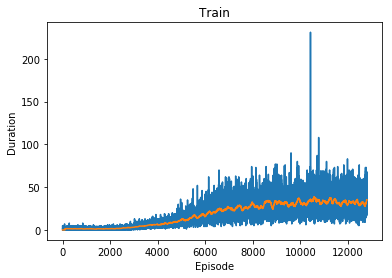

In [10]:
# количество эпизодов, которые играем
NUM_EPISODES = 100000
TEST_EPS = 0.05
# количество кадров, между которыми обучаем модель
OPTIMIZE_MODEL_STEP = 5
# количество кадров, между которыми обновляем target-модель
TARGET_UPDATE=10000

# несколько шагов для разогрева модели()
STEPS_BEFORE_TRAIN = 50000

# параметры для e-greedy стратегии выбора действия
EPS_START = 1
EPS_END = 0.1
EPS_DECAY = 1000000

policy_net.train()
target_net.eval()

state_holder = StateHolder()
test_rewards = []

# Общее число 
steps_done = 0
eps = EPS_START
# Задание 3. Заполнить пропуски в нижеприведенном коде.

for e in tqdm.tqdm(range(NUM_EPISODES)):
    
    # Инициализации разлинычх переменных
    # env - среды
    # state_holder - хранителя состояния
    # lives - количества жизней в начале эпизода игры (Важно!)
    env.reset()
    state_holder.reset()
    state_holder.push(get_screen())
    state = state_holder.get()
    lives = 5    
    ep_rewards = []
    print(eps, steps_done)
    for t in count():
        
        # Рассчет eps_threshold'а для e-greedy
        eps = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
        # Шаг одного кадра игры 
        action = select_action(state, eps)
        _, reward, done, info = env.step(action.item())
        ep_rewards.append(reward)
        reward = torch.tensor([reward], device = device)

        
        
        if not done:
            state_holder.push(get_screen())
            next_state = state_holder.get()            
            if info['ale.lives']!= lives:
                lives = info['ale.lives']
                memory.push(state,action , None, reward)
            else:
                memory.push(state,action , next_state, reward)
        else:
            next_state=None
            memory.push(state,action , next_state, reward)
            
        steps_done += 1
        state = next_state
        # где:
        # reward - награда, полученная в рамках последнего действия
        # done - флаг окончания эпизода
        # info - важная системная информация
        
        # Код обработки перехода
        # Работа с ReplayMemory

    
        
        # Задание 3.1. Необходимо дополниь код следующим трюком, который значительно
        # улучшает сходимость обучения. В случае, если эпизод не закончился, но агент на 
        # очередном шаге потерял жизнь, то такой переход надо класть в ReplayMemory как финальный.
        # При этом, необходимо далее продолжать эпизод игры, пока не получите done == True
        # Тет самым вы научите агента понимать, что терять жизни по дороге - плохо.
        
        # Шаг оптимизации
        if (steps_done > STEPS_BEFORE_TRAIN) and steps_done % OPTIMIZE_MODEL_STEP == 0:
            optimize_model()
        
        # Шаг обновления target'сети
        if steps_done % TARGET_UPDATE == 0:
            print("Target net updated!")
            target_net.load_state_dict(policy_net.state_dict())
        
        # Код завершающий эпизод игры/обучения
        if done:
            train_rewards.append(np.sum(ep_rewards))
            # Суммарный reward(не дисконтированный) за последний эпизод
            print("Episode score : {}".format(train_rewards[-1]))
            # Средний reward по последним 100 эпизодам
            print("Mean score : {}".format(np.mean(train_rewards[-100:])))
            
            plot_rewards()
            break 


            
            
            





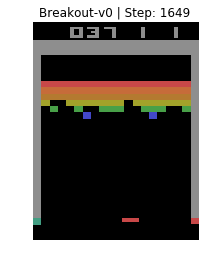

Total game reward : 37.0


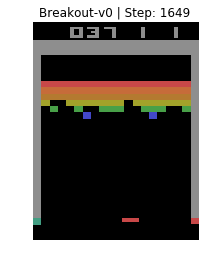

In [11]:
# Тут код для тестирования.
# Задание 4. Просто выполнить данную ячейку и проверить вашего агента, насколько он хорош !?

TEST_EPS = 0.05

def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % (env.spec.id, step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())
def select_action(state,eps_threshold):
    global steps_done
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
            math.exp(-1. * steps_done / EPS_DECAY)
    
    steps_done += 1
    sample = random.random()
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(ACTIONS_NUM)]], device=device, dtype=torch.long)

policy_net.eval()
env.reset()
state_holder.reset()
    
state_holder.push(get_screen())

total_reward = 0

for i in count():
    # Выбрать и выполнить нове действие
    action = select_action(state_holder.get(), TEST_EPS)
    _, reward, done, _ = env.step(action.item())
    total_reward += reward
    # Получаем новое состояние
    if not done:
        state_holder.push(get_screen())
    else:
        break
    show_state(env, i)
    
print("Total game reward : {}".format(total_reward))

In [14]:
import pickle
with open('data.pickle', 'wb') as f:
    pickle.dump(policy_net, f)
with open('data2.pickle', 'wb') as f:
    pickle.dump(target_net, f)

In [15]:
policy_net.save_weights("policy_model.h5")

AttributeError: 'DQN' object has no attribute 'save_weights'

In [16]:
import json
json = policy_net.toJSON()

AttributeError: 'DQN' object has no attribute 'toJSON'

In [19]:
torch.save(policy_net, './policy')

/home/a.oleshko/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type DQN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [20]:
torch.save(policy_net.state_dict(), './weights')